In [40]:
import os
import re
import logging
import datetime
import json
import csv
from statistics import fmean
from typing import Dict, List, Callable, Union
from graph_of_thoughts import controller, language_models, operations, prompter, parser
from graph_of_thoughts.vector_db import azure_embedding



# This is a hack to also allow execution of this file from the examples directory
try:
    from . import utils
except ImportError:
    import utils

class ALZKBPrompter(prompter.Prompter):
    """
    ALZKBPrompter provides the generation of prompts specific to the
    ALZKB example for the language models.

    Inherits from the Prompter class and implements its abstract methods.
    """
    
    alzkb_prompt_start = """You have access to a knowledge graph of Alzheimer's disease. The knowledge graph contains node types: Gene, DrugClass, Drug, Disease, Pathway, BiologicalProcess, MolecularFunction, CellularComponent, Symptom, BodyPart.
    The knowledge graph contains relationships: "CHEMICAL BINDS GENE","CHEMICAL INCREASES EXPRESSION", "CHEMICAL DECREASES EXPRESSION", "DRUG IN CLASS", "DRUG TREATS DISEASE", "DRUG CAUSES EFFECT", "GENE PARTICIPATES IN BIOLOGICAL PROCESS", "GENE IN PATHWAY", "GENE INTERACTS WITH GENE", "GENE HAS MOLECULAR FUNCTION", "GENE ASSOCIATED WITH CELLULAR COMPONENT", "GENE ASSOCIATES WITH DISEASE", "BODYPART OVER EXPRESSES GENE", "BODYPART UNDEREXPRESSES GENE", "SYMPTOM MANIFESTATION OF DISEASE", "DISEASE LOCALIZES TO ANATOMY", "DISEASE ASSOCIATES WITH DISEASE".
    """
    
    io_prompt = """<Instruction> You are an Alzheimer's data specialist AI assistant dedicated to providing information and support related to Alzheimer's disease.
Your primary goal is to assist users by offering factual and relevant information based on your access to a comprehensive knowledge graph associated with Alzheimer's. 
Your responses are focused on addressing queries related to Alzheimer's, and you do not provide information unrelated to the topic. 
You will also only answer based on the knowledge within the knowledge graph within the <Knowledge> tags. 
You will notice there will be gene symbols in the knowledge, and there are subtle differences between the gene names.
You will need to be careful that the names are exact with you use them in context. There may be single differences in numbers and letters.
For example, the gene "APOE" is not the same as gene "APOE1". Another example is the gene "IQCK" is not the same as gene "IQCG".
You will need to be careful of specific biological terms. For example, the term "amino" is different from the term "amine".
If you are providing a list, be sure not to list duplicates. 
Your demeanor is empathetic and concise as you aim to help users understand and navigate Alzheimer's-related concerns.
You will be provided knowledge within the <Knowledge> tags and must answer the question in the <Question> tags.
{additional_instruction}
</Instruction> 
<Knowledge>
{knowledge}
</Knowledge>
<Question>{question}</Question>"""
        
    few_shot_prompt = """<Instruction> You are an Alzheimer's data specialist AI assistant dedicated to providing information and support related to Alzheimer's disease.
Your primary goal is to assist users by offering factual and relevant information based on your access to a comprehensive knowledge graph associated with Alzheimer's. 
Your responses are focused on addressing queries related to Alzheimer's, and you do not provide information unrelated to the topic. 
You will also only answer based on the knowledge within the knowledge graph within the <Knowledge> tags. 
You will notice there will be gene symbols in the knowledge, and there are subtle differences between the gene names.
You will need to be careful that the names are exact with you use them in context. There may be single differences in numbers and letters.
For example, the gene "APOE" is not the same as gene "APOE1". Another example is the gene "IQCK" is not the same as gene "IQCG".
You will need to be careful of specific biological terms. For example, the term "amino" is different from the term "amine".
If you are providing a list, be sure not to list duplicates. 
Your demeanor is empathetic and concise as you aim to help users understand and navigate Alzheimer's-related concerns.
You will be provided knowledge within the <Knowledge> tags and must answer the question in the <Question> tags.
{additional_instruction}
</Instruction> 
<Knowledge>
{knowledge}
</Knowledge>
<Question>{question}</Question>

<Approach>
To answer the question, follow these steps:
1. Identify the relevant nodes in the knowledge graph.
2. Identify the relevant relationships between the nodes.
3. Generate a response based on the identified nodes and relationships.
</Approach>

<Examples>
Input: True or False Question: AP2M1 is not subject to decreased expression by the drug Botulinum toxin type A
Reasoning: The knowledge graph contains the node AP2M1 and the node Botulinum toxin type A. The knowledge provided contains no link from AP2M1 to Botulinum toxin type A. Therefore, the answer is TRUE.
Output: True

Input: List the body parts/anatomy which commonly over-express the genes METTL5 and STYXL2
Reasoning: In the knowledge graph, we detect that there is the knowledge: "The gene STYXL2 is associated with the heart because the body part over-expresses the gene" and also the knowledge: "The gene METTL5 is associated with the heart because the body part over-expresses the gene". There are other body parts associated with those genes, but they are not associated with both. Therefore, the answer is "heart".
Output: heart

Input: Which of the following genes is not under-expressed in testis? 1. FLT1 2. TLE2 3. PDS5A 4. CSF1 5. MGST1
Reasoning: In the knowledge graph, we detect that FLT1, TLE2, CSF1, MGST1 are associated with testis because the body part under-expresses the gene. We also detect that PDS5A is associated with testis because the body part over-expresses the gene. Therefore, the answer is PDS5A.
Output: 3. PDS5A
</Examples>
"""

    cot_instruction_prompt = """You are an AI prompt simplifier with access to a knowledge graph of Alzheimer's disease. You will receive a query related to simplifying the query into parts that can be separated by relationship between nodes.
The knowledge graph contains node types: Gene, DrugClass, Drug, Disease, Pathway, BiologicalProcess, MolecularFunction, CellularComponent, Symptom, BodyPart. 
Gene nodes have gene type as a property.
The knowledge graph contains relationships: "CHEMICAL BINDS GENE","CHEMICAL INCREASES EXPRESSION", "CHEMICAL DECREASES EXPRESSION", "DRUG IN CLASS", "DRUG TREATS DISEASE", "DRUG CAUSES EFFECT", "GENE PARTICIPATES IN BIOLOGICAL PROCESS", "GENE IN PATHWAY", "GENE INTERACTS WITH GENE", "GENE HAS MOLECULAR FUNCTION", "GENE ASSOCIATED WITH CELLULAR COMPONENT", "GENE ASSOCIATES WITH DISEASE", "BODYPART OVER EXPRESSES GENE", "BODYPART UNDEREXPRESSES GENE", "SYMPTOM MANIFESTATION OF DISEASE", "DISEASE LOCALIZES TO ANATOMY", "DISEASE ASSOCIATES WITH DISEASE".
From the query, split it into multiple instructions of simple single node to Relationship to node format that would answer the query. Start the instructions from specifics node names. The format of each <Node> tag would be Node Title-Relationship-Node Title. If there are any specific nodes and not a node type, put a ! before and after the word. For instance, Alzheimer's is a specific Disease node, so it should be labeled "!Alzheimer's Disease!".
<Example> 
<Query>List the drugs that can treat Alzheimer's Disease</Query>
<Instructions>
<Node>Drug-DRUG TREATS DISEASE-!Alzheimer's Disease!</Node>
</Instructions>
</Example>

<Example>
<Query>Provide a list of all genes associated with Alzheimer's Disease</Query>
<Instructions>
<Node>Gene-GENE ASSOCIATES WITH DISEASE-!Alzheimer's Disease!</Node>
</Instructions>
</Example>

<Example>
<Query>Which classes of drugs can be used to treat Alzheimer's disease?</Query>
<Instructions>
<Node>Drug-DRUG TREATS DISEASE-!Alzheimer's Disease!</Node>
<Node>DrugClass-DRUGINCLASS-Drug</Node>
</Instructions>
</Example>

<Example>
<Query>List ncRNA type genes that are associated with Alzheimer's Disease</Query>
<Instructions>
<Node>Gene-GENE ASSOCIATES WITH DISEASE-!Alzheimer's Disease!</Node>
<Node>Gene-GeneType-!ncRNA!</Node>
</Instructions>
</Example>

<Example>
<Query>List the body parts overexpressing the gene ACE</Query>
<Instructions>
<Node>BodyPart-BODYPART OVEREXPRESSES GENE-!ACE!</Node>
</Instructions>
</Example>

<Query>{question}</Query
"""

    got_split_prompt = """<Instruction> Split the following input text into individual sentences.
Output each sentence in the following format without any additional text or thoughts:
{{
    "Sentence 1": "Some sentence text ...",
    "Sentence 2": "Some sentence text ...",
    "Sentence 3": "Some sentence text ...",
    ...
}} </Instruction>

<Example>
Input:
Journeying westward, she admired the art in Italy and sipped coffee in France. The music of Spain and the history of Greece deepened her love for Europe. The Nordic beauty of Norway, Sweden, Finland, and Denmark took her breath away. She danced in Ireland, explored castles in Scotland, and marveled at the architecture in Germany and Russia. Italy, Norway, Sweden and Germany will always stay her favourite destinations to visit.
Output: 
{{
    "Sentence 1": "Journeying westward, she admired the art in Italy and sipped coffee in France. ",
    "Sentence 2": "The music of Spain and the history of Greece deepened her love for Europe. "
    "Sentence 3": "The Nordic beauty of Norway, Sweden, Finland, and Denmark took her breath away.",
    "Sentence 4": "She danced in Ireland, explored castles in Scotland, and marveled at the architecture in Germany and Russia.",
    "Sentence 5": "Italy, Norway, Sweden and Germany will always stay her favourite destinations to visit."
}}
</Example>

Input:
{input}
"""

    sentence_improve_prompt = """<Instruction> The following two inputs represent an initial input text (usually a sinlge sentence) and a dictionary of countries and their frequencies of explicit appearance in the input text/sentence. The dictionary is incorrect and might not contain all countries, contain extra countries or countries with incorrect frequencies.
Fix the dictionary such that it has the correct frequencies for each country and only contains countries that are explicitly named in the text/sentence. </Instruction>

<Approach>
To fix the incorrect dictionary of countries follow these steps:
1. Iterate through the input text/sentence and find all countries that are explicitly mentioned.
2. For each of these countries, count how many times they are explicitly mentioned in the input text/sentence.
3. Compare the frequency of each country in the input text with the frequency of the country in the incorrect dictionary and update the frequency in the incorrect dictionary if they are different.

</Approach>

<Examples>
Input:
Alexandra boarded the first flight of her grand journey, starting from Canada. 
Incorrect Dictionary:
{{
    "Canada": 1,
    "Mexico": 1,
    "Argentina": 1
}}
Reason: The input text only names Canada once, but the incorrect dictionary contains Mexico and Argentina which do not appear in the input text.
Output: 
{{
    "Canada": 1
}}

Input:
A quick detour to Peru and Paraguay allowed him to experience the vibrancy of the local cultures before returning back to Canada through Peru, Brazil and Mexico.
Incorrect Dictionary:
{{
    "Peru": 3,
    "Argentina": 1,
    "Canada": 1,
    "Brazil": 1,
    "Mexico": 1
}}
Reason: The input text names Peru twice, but the incorrect dictionary lists it with a frequency of 3 instead of 2. The incorrect dictionary also contains Argentina which does not appear in the input text and is missing Paraguay.
Output: 
{{
    "Peru": 2,
    "Paraguay": 1,
    "Canada": 1,
    "Brazil": 1,
    "Mexico": 1
}}

Input:
She danced in Ireland and Russia, explored castles in England, and marveled at the architecture in Germany and Russia. 
Incorrect Dictionary:
{{
    "Ireland": 1,
    "England": 1,
    "Germany": 1,
    "Russia": 1
}}
Reason: The input text names Russia twice each, but the incorrect dictionary lists Russia with a frequency of 1 instead of 2. The incorrect dictionary also contains England which does not appear in the input text and is missing Scotland.
Output: 
{{
    "Ireland": 1,
    "Scotland": 1,
    "Germany": 1,
    "Russia": 2
}}
</Examples>

Input: 
{input}
Incorrect Dictionary: 
{incorrect_dict}
"""

    count_prompt_sentence = """<Instruction> Count the frequency of how many times each country is explicitly named in the input text. Output only the frequency of each country that appears at least once in the following json format; make sure to keep the same spelling and output no additional text:
{{
    "country1": frequency1,
    "country2": frequency2,
    ...
}}
</Instruction>

<Approach>
To count the frequency for each country follow these steps:
1. Create an empty dictionary.
2. Iterate through the text word by word.
3. If the word corresponds to a country, add the country to the dictionary and set its value to 1 if it is not already in the dictionary. If the word is already in the dictionary, increment its value by 1.
</Approach>

<Examples>
Input:
Alexandra explored the rainforests of Brazil and danced the tango in Argentina.
Output: 
{{
    "Brazil": 1,
    "Argentina": 1    
}}

Input:
In Norway she found stones that were identical to those in Sweden, indicating a deep-rooted cultural connection between Sweden and Norway.
Output:
{{
    "Norway": 2,
    "Sweden": 2
}}

Input:
A quick detour to Uruguay and Paraguay allowed him to experience the vibrancy of the local cultures before returning back to Canada through Peru, Brazil and Mexico.
Output: 
{{
    "Uruguay": 1,
    "Paraguay": 1,
    "Canada": 1,
    "Peru": 1,
    "Brazil": 1,
    "Mexico": 1
}}

Input:
Italy, Sweden, Sweden and Germany will always stay her favourite destinations to visit.
Output:
{{
    "Italy": 1,
    "Sweden": 2,
    "Germany": 1
}}
</Examples>

Input:
{input}
Output:
"""

    
    score_prompt_base = """We are comparing if a response is equivalent to the ground truth.
<GroundTruth>{ground_truth}</GroundTruth>
<Answer>{answer}</Answer>
Please score the response on a scale of 0 to 10, where 0 is not equivalent and 10 is equivalent.
You may have to compare two unordered lists, so please score the response based on the following criteria:
1. The lists contain the same number of elements.
2. The lists contain the same elements, but may be in a different order.
If you have a True or False question, please score the response as 10 if the response is equal to the ground truth and 0 if the response is inequal.
You may provide reasoning for your scoring, but the final score should be between the tags <Score> and </Score>, without any additional text within those tags.
"""



    def __init__(self,vector_db, lm) -> None:
        """
        Inits the prompter.
        """
        self.vector_db = vector_db
        self.lm = lm
        pass
    
    def aggregation_prompt(self, state_dicts: List[Dict], **kwargs) -> str:
        """
        Generate an aggregation prompt for the language model.

        :param state_dicts: The thought states that should be aggregated.
        :type state_dicts: List[Dict]
        :param kwargs: Additional keyword arguments.
        :return: The aggregation prompt.
        :rtype: str
        :raise AssertionError: If not exactly two thought states are provided.
        """
        assert len(state_dicts) == 2, "Expected two states for aggregation prompt."

        return self.io_prompt.format(
            input1=state_dicts[0]["current"],
            input2=state_dicts[1]["current"],
        )

        if len(state_dicts[0]["parts"]) > 0 and len(state_dicts[0]["parts"]) < len(
            state_dicts[0]["documents"]
        ):
            prompt = self.aggregate_sub_prompt_base.format(
                num_ndas=len(state_dicts),
            )
            for i, state_dict in enumerate(state_dicts):
                prompt += self.aggregate_sub_prompt_generate.format(
                    nda=state_dict["current"], num=i + 1
                )
            return prompt
        else:
            prompt = self.aggregate_full_prompt_base.format(
                num_ndas=len(state_dicts[0]["documents"]),
                num_ndas_summary=len(state_dicts),
            )
            for i, document in enumerate(state_dicts[0]["documents"]):
                prompt += self.aggregate_full_prompt_block1.format(
                    document=document, num=i + 1
                )
            prompt += self.aggregate_full_prompt_mid.format(
                num_ndas_summary=len(state_dicts),
            )
            for i, state_dict in enumerate(state_dicts):
                prompt += self.aggregate_full_prompt_block2.format(
                    summary=state_dict["current"], num=i + 1
                )
            return prompt

    def generate_prompt(
        self,
        num_branches: int,
        question: str,
        question_type: str,
        method: str,
        current: str,
        **kwargs,
    ) -> str:
        """
        Generate a generate prompt for the language model.

        :param num_branches: The number of responses the prompt should ask the LM to generate.
        :type num_branches: int
        :param documents: The list of documents to be merged.
        :type documents: List[str]
        :param method: Method for which the generate prompt is generated.
        :type method: str
        :param parts: Indices of the already processed document parts.
        :type parts: Set[str]
        :param current: The intermediate solution.
        :type current: str
        :param kwargs: Additional keyword arguments.
        :return: The generate prompt.
        :rtype: str
        :raise AssertionError: If method is not implemented yet.
        """
        

        if question_type == "true/false":
            additional_instruction = "You will be asked to answer the question with only a TRUE or FALSE response."
            # check if "True or False Question: " is in the question
            if "True or False Question: " in question:
                statement_to_embed = question[question.index("True or False Question: ") + len("True or False Question: "):]
            else:
                statement_to_embed = question
                question = "True or False Question: " + question
        elif question_type == "multiple choice":
            additional_instruction = "You will be asked to answer the question with only the multiple choice number response. For instance, if the correct answer is '2', you will need to answer '2'."
            # check if "? 1." is in the question and separate the question from the choice
            if "? 1." in question:
                statement_to_embed = question[:question.index("? 1.")]
            else:
                statement_to_embed = question
        elif question_type == "list":
            additional_instruction = "You will be asked to answer the question with only the list with each element separated by a newline."
            statement_to_embed = question
        else:
            additional_instruction = ""
            statement_to_embed = question
            
        # print("statement_to_embed:", statement_to_embed)
        # print("question:", question)
        embedded_question = self.lm.get_embedding(statement_to_embed)
        # print(embedded_question)
        knowledge_array,distances = self.vector_db.get_knowledge(embedded_question)
        # print(knowledge_array)
        knowledge = "/n".join(knowledge_array)
        
        prompt = ""
        assert num_branches == 1, "Branching should be done via multiple requests."
        if method.startswith("io"):
            # print(self.io_prompt.format(knowledge=knowledge, question=question, additional_instruction=additional_instruction))
            return self.io_prompt.format(knowledge=knowledge, question=question, additional_instruction=additional_instruction)
        elif method.startswith("fewshot"):
            return self.few_shot_prompt.format(knowledge=knowledge, question=question, additional_instruction=additional_instruction)
        elif method.startswith("cot"):
            prompt += self.alzkb_prompt_start + self.cot_prompt.format(knowledge=knowledge, question=question, additional_instruction=additional_instruction)
            return prompt
        # elif method.startswith("got"):
        #     if (current is None or current == "") and kwargs["phase"] == 0:
        #         if method == "got8":
        #             return self.got_split_prompt2.format(input=input)
        #         if method == "gotx":
        #             return self.got_split_prompt3.format(input=input)
        #         return self.got_split_prompt.format(input=input)

        #     if kwargs["phase"] == 1:
        #         if method == "gotx":
        #             return self.count_prompt_sentence.format(input=kwargs["sub_text"])
        #         return self.count_prompt_cot.format(input=kwargs["sub_text"])

        #     if (
        #         "sub_text" in kwargs
        #         and kwargs["sub_text"] != ""
        #         and len(kwargs["sub_text"]) < len(original) * 0.75
        #     ):
        #         original = kwargs["sub_text"]
        #     if method == "gotx":
        #         return self.sentence_improve_prompt.format(
        #             input=original, incorrect_dict=current
        #         )
        #     return self.tot_improve_prompt.format(
        #         input=original, incorrect_dict=current
        #     )
        else:
            assert False, "Not implemented yet."

    def improve_prompt(self, **kwargs) -> str:
        """
        Generate an improve prompt for the language model.

        :param kwargs: Additional keyword arguments.
        :return: The improve prompt.
        :rtype: str
        """
        pass

    def validation_prompt(self, **kwargs) -> str:
        """
        Generate a validation prompt for the language model.

        :param kwargs: Additional keyword arguments.
        :return: The validation prompt.
        :rtype: str
        """
        pass

    def score_prompt(self, state_dicts: List[Dict], **kwargs) -> str:
        """
        Generate a score prompt for the language model.

        :param state_dicts: The thought states that should be scored,
                            if more than one, they should be scored together.
        :type state_dicts: List[Dict]
        :param kwargs: Additional keyword arguments.
        :return: The score prompt.
        :rtype: str
        :raise AssertionError: If more than one thought state is supplied.
        """

        # perform individual scoring
        prompt = self.score_prompt_base.format(
            answer=state_dicts[0]["current"],
            ground_truth=state_dicts[0]["ground_truth"],
        )
        return prompt
    
class ALZKBParser(parser.Parser):
    """
    ALZKBParser provides the parsing of language model reponses specific to the
    ALZKB example.

    Inherits from the Parser class and implements its abstract methods.
    """

    def __init__(self) -> None:
        """
        Inits the response cache.
        """
        self.cache = {}
        
    def strip_answer_helper(self, text: str, tag: str = "") -> str:
        """
        Helper function to remove tags from a text.

        :param text: The input text.
        :type text: str
        :param tag: The tag to be stripped. Defaults to "".
        :type tag: str
        :return: The stripped text.
        :rtype: str
        """

        text = text.strip()
        if "Output:" in text:
            text = text[text.index("Output:") + len("Output:") :].strip()
        if tag != "":
            start = text.rfind(f"<{tag}>")
            end = text.rfind(f"</{tag}>")
            if start != -1 and end != -1:
                text = text[start + len(f"<{tag}>") : end].strip()
            elif start != -1:
                logging.warning(
                    f"Only found the start tag <{tag}> in answer: {text}. Returning everything after the tag."
                )
                text = text[start + len(f"<{tag}>") :].strip()
            elif end != -1:
                logging.warning(
                    f"Only found the end tag </{tag}> in answer: {text}. Returning everything before the tag."
                )
                text = text[:end].strip()
            else:
                logging.warning(
                    f"Could not find any tag {tag} in answer: {text}. Returning the full answer."
                )
        return text

    def parse_aggregation_answer(
        self, states: List[Dict], texts: List[str]
    ) -> Union[Dict, List[Dict]]:
        """
        Parse the response from the language model for an aggregation prompt.

        :param states: The thought states used to generate the prompt.
        :type states: List[Dict]
        :param texts: The responses to the prompt from the language model.
        :type texts: List[str]
        :return: The new thought states after parsing the respones from the language model.
        :rtype: Union[Dict, List[Dict]]
        :raise AssertionError: If not exactly two thought states are provided.
        """

        assert len(states) == 2, "Expected two states for aggregation answer."
        new_states = []
        for text in texts:
            answers = text.strip().split("/n")
            if any(["Output" in answer for answer in answers]):
                # cut elements until last output is found
                for answer in reversed(answers):
                    if "Output" in answer:
                        answers = answers[answers.index(answer) :]
                        break

            answers_stripped = [
                answer for answer in answers if "[" in answer and "]" in answer
            ]
            if len(answers_stripped) == 0:
                for answer in answers:
                    answer = "[" + answer + "]"
                    try:
                        answer_converted = utils.string_to_list(answer)
                        if len(answer_converted) > 0:
                            answers_stripped.append(answer)
                    except:
                        pass
            if len(answers_stripped) == 0:
                logging.warning(
                    f"Could not parse aggregation answer: {text}. Returning empty list."
                )
                answer = "[]"
            else:
                answer = [
                    answer[answer.index("[") : answer.index("]") + 1]
                    for answer in answers_stripped
                ][0]
            states = sorted(states, key=lambda x: x["part"])
            merged_subsets = states[0]["subset"][:-1] + ", " + states[1]["subset"][1:]
            new_state = states[0].copy()
            new_state["current"] = answer
            new_state["subset"] = merged_subsets
            new_states.append(new_state)
        return new_states

    def parse_improve_answer(self, state: Dict, texts: List[str]) -> Dict:
        """
        Parse the response from the language model for an improve prompt.

        :param state: The thought state used to generate the prompt.
        :type state: Dict
        :param texts: The responses to the prompt from the language model.
        :type texts: List[str]
        :return: The new thought state after parsing the responses from the language model.
        :rtype: Dict
        """
        pass

    def parse_generate_answer(self, state: Dict, texts: List[str]) -> List[Dict]:
        """
        Parse the response from the language model for a generate prompt.

        :param state: The thought state used to generate the prompt.
        :type state: Dict
        :param texts: The responses to the prompt from the language model.
        :type texts: List[str]
        :return: The new thought states after parsing the respones from the language model.
        :rtype: List[Dict]
        """

        new_states = []
        print("parse_generate_answer text:", texts)
        
        for text in texts:
            if state["method"].startswith("io") or state["method"].startswith("cot") or state["method"].startswith("fewshot"):
                try:
                    if state["method"].startswith("fewshot"):
                        #remove <Output> tag
                        text = self.strip_answer_helper(text, "Output")
                    if state["question_type"] == "true/false":
                        if "TRUE" in text.upper():
                            answer = "TRUE"
                        elif "FALSE" in text.upper():
                            answer = "FALSE"
                        else:
                            answer = "FALSE"
                    elif state["question_type"] == "multiple choice":
                        #white strip to remove any spaces and check for numbers in the first couple of characters
                        if any(char.isdigit() for char in text[:3]):
                            answer = text[0]
                        else:
                            logging.warning(
                                f"Could not parse step answer: {text}. Returning empty."
                            )
                            continue
                    elif state["question_type"] == "list":
                        temp_answer = text.strip().split("/n")
                        answer = [x for x in temp_answer if x != '']
                        #check for empty answers
                        if len(answer) == 0:
                            logging.warning(
                                f"Could not parse step answer: {text}. Returning empty."
                            )
                            continue
                        
                    else:
                        answer = text.strip()
                        
                        
                    new_state = state.copy()
                    new_state["current"] = answer
                    new_state["phase"] = new_state["phase"] + 1
                    new_states.append(new_state)
                except Exception as e:
                    logging.error(
                        f"Could not parse step answer: {text}. Encountered exception: {e}"
                    )
                        
                        
            elif state["method"].startswith("got") and state["phase"] == 0:
                # We expect a json which contains the two lists named "List 1" and "List 2"
                # cut everything until the opening bracket and everything after the closing bracket

                try:
                    text = text[text.index("{") : text.index("}") + 1]
                    json_dict = json.loads(text)
                    if len(json_dict.keys()) != 2:
                        logging.warning(
                            f"Expected 2 lists in json, but found {len(json_dict.keys())}."
                        )
                    for key, value in json_dict.items():
                        if "List" not in key:
                            logging.warning(
                                f"Expected key to contain 'List', but found {key}."
                            )
                            continue
                        if not isinstance(value, list):
                            value = utils.string_to_list(value)
                        new_state = state.copy()
                        new_state["current"] = ""
                        new_state["subset"] = str(value)
                        new_state["phase"] = 1
                        new_state["part"] = key
                        new_states.append(new_state)
                except Exception as e:
                    logging.error(
                        f"Could not parse step answer: {text}. Encountered exception: {e}"
                    )
            else:
                answers = text.strip().split("/n")
                answers = [
                    answer for answer in answers if "[" in answer and "]" in answer
                ]
                if any(["Output" in answer for answer in answers]):
                    # cut elements until last output is found
                    for answer in reversed(answers):
                        if "Output" in answer:
                            answers = answers[answers.index(answer) :]
                            break

                answers = [
                    answer[answer.index("[") : answer.index("]") + 1]
                    for answer in answers
                ]
                if len(answers) == 0:
                    logging.warning(
                        f"Could not parse step answer: {text}. Returning empty list."
                    )
                    answer = "[]"
                else:
                    if len(answers) > 1:
                        logging.warning(
                            f"Multiple answers found for step answer: {text}. Using the first one."
                        )
                    answer = answers[0]

                new_state = state.copy()
                new_state["current"] = answer
                new_state["phase"] = 2
                new_states.append(new_state)
        return new_states

    def parse_validation_answer(self, state: Dict, texts: List[str]) -> bool:
        """
        Parse the response from the language model for a validation prompt.

        :param state: The thought state used to generate the prompt.
        :type state: Dict
        :param texts: The responses to the prompt from the language model.
        :type texts: List[str]
        :return: Whether the thought state is valid or not.
        :rtype: bool
        """
        pass

    def parse_score_answer(self, states: List[Dict], texts: List[str]) -> List[float]:
        """
        Parse the response from the language model for a score prompt.

        :param states: The thought states used to generate the prompt.
        :type states: List[Dict]
        :param texts: The responses to the prompt from the language model.
        :type texts: List[str]
        :return: The scores for the thought states.
        :rtype: List[float]
        """
        assert len(states) == 1, "Only one state is allowed for scoring."
        if len(states) == 1:
            # individual scoring
            redundancy_scores = []
            retain_scores = []
            for text in texts:
                answer = self.strip_answer_helper(text, "Score")
                res = re.findall(r"/d+/.?/d*", answer)
                if len(res) == 1:
                    redundancy_scores.append(float(res[0]))
                elif len(res) > 1:
                    logging.warning(
                        f"Found multiple scores in answer: {text}. Returning the last one."
                    )
                    redundancy_scores.append(float(res[-1]))
                else:
                    logging.warning(
                        f"Could not find any score in answer: {text}. Ignoring this answer."
                    )
            if len(redundancy_scores) == 0:
                logging.warning(
                    f"Could not find any valid score in any answer. Returning 0.0."
                )
                return [0.0]
            mean_redundancy = fmean(redundancy_scores)
            print("mean_score:", mean_redundancy)
            return [mean_redundancy]
            # mean_retain = fmean(retain_scores)
            # f1 = 2 * mean_redundancy * mean_retain / (mean_redundancy + mean_retain)
            # return [f1]


def io() -> operations.GraphOfOperations:
    """
    Generates the Graph of Operations for the IO method.

    :return: Graph of Operations
    :rtype: GraphOfOperations
    """
    operations_graph = operations.GraphOfOperations()

    operations_graph.append_operation(operations.Generate(1, 1))
    operations_graph.append_operation(operations.Score(1, False))
    # operations_graph.append_operation(operations.GroundTruth())

    return operations_graph

def fewshot() -> operations.GraphOfOperations:
    """
    Generates the Graph of Operations for the FewShot method.

    :return: Graph of Operations
    :rtype: GraphOfOperations
    """
    operations_graph = operations.GraphOfOperations()

    operations_graph.append_operation(operations.Generate(1, 1))
    operations_graph.append_operation(operations.Score(1, False))
    # operations_graph.append_operation(operations.GroundTruth())

    return operations_graph

def cot() -> operations.GraphOfOperations:
    """
    Generates the Graph of Operations for the CoT method.

    :return: Graph of Operations
    :rtype: GraphOfOperations
    """
    operations_graph = operations.GraphOfOperations()

    operations_graph.append_operation(operations.Generate(1, 1))
    operations_graph.append_operation(operations.Score(1, False))

    return operations_graph


def tot() -> operations.GraphOfOperations:
    """
    Generates the Graph of Operations for the ToT method.

    :return: Graph of Operations
    :rtype: GraphOfOperations
    """
    operations_graph = operations.GraphOfOperations()

    branch_factor = 10

    operations_graph.append_operation(operations.Generate(1, branch_factor))
    operations_graph.append_operation(operations.Score(3, False))
    keep_best_1 = operations.KeepBestN(1, True)
    operations_graph.append_operation(keep_best_1)

    for _ in range(2):
        operations_graph.append_operation(operations.Generate(1, branch_factor))
        operations_graph.append_operation(operations.Score(3, False))
        keep_best_2 = operations.KeepBestN(1, True)
        keep_best_2.add_predecessor(keep_best_1)
        operations_graph.append_operation(keep_best_2)
        keep_best_1 = keep_best_2

    return operations_graph


def got() -> operations.GraphOfOperations:
    """
    Generates the Graph of Operations for the GoT method, where full documents
    are merged.

    :return: Graph of Operations
    :rtype: GraphOfOperations
    """
    operations_graph = operations.GraphOfOperations()

    operations_graph.append_operation(operations.Generate(1, 5))
    operations_graph.append_operation(operations.Score(3, False))
    keep_best = operations.KeepBestN(3, True)
    operations_graph.append_operation(keep_best)
    operations_graph.append_operation(operations.Aggregate(5))
    operations_graph.append_operation(operations.Score(3, False))
    keep_best2 = operations.KeepBestN(1, True)
    keep_best2.add_predecessor(keep_best)
    operations_graph.append_operation(keep_best2)
    operations_graph.append_operation(operations.Generate(1, 10))
    operations_graph.append_operation(operations.Score(3, False))
    keep_best3 = operations.KeepBestN(1, True)
    keep_best3.add_predecessor(keep_best2)
    operations_graph.append_operation(keep_best3)

    return operations_graph


def got2() -> operations.GraphOfOperations:
    """
    Generates the Graph of Operations for the GoT2 method, where partial
    documents are merged.

    :return: Graph of Operations
    :rtype: GraphOfOperations
    """
    operations_graph = operations.GraphOfOperations()

    sub_parts = []
    for i in range(0, 4, 2):  # should be at most 16 parts
        sub_text = operations.Selector(
            lambda thoughts, list_id=i: [
                operations.Thought(
                    state={**thoughts[0].state, "parts": {list_id, list_id + 1}}
                )
            ]
        )
        operations_graph.add_operation(sub_text)
        gen_nda = operations.Generate(1, 5)
        gen_nda.add_predecessor(sub_text)
        operations_graph.add_operation(gen_nda)
        score_nda = operations.Score(3, False)
        score_nda.add_predecessor(gen_nda)
        operations_graph.add_operation(score_nda)
        keep_best_nda = operations.KeepBestN(1, True)
        keep_best_nda.add_predecessor(score_nda)
        operations_graph.add_operation(keep_best_nda)

        sub_parts.append(keep_best_nda)

    while len(sub_parts) > 1:
        new_sub_parts = []
        for i in range(0, len(sub_parts), 2):
            if i + 1 == len(sub_parts):
                new_sub_parts.append(sub_parts[i])
                continue
            aggregate = operations.Aggregate(5)
            aggregate.add_predecessor(sub_parts[i])
            aggregate.add_predecessor(sub_parts[i + 1])
            operations_graph.add_operation(aggregate)
            score = operations.Score(3, False)
            score.add_predecessor(aggregate)
            operations_graph.add_operation(score)
            keep_best = operations.KeepBestN(1, True)
            keep_best.add_predecessor(score)
            operations_graph.add_operation(keep_best)

            gen_nda = operations.Generate(1, 5)
            gen_nda.add_predecessor(keep_best)
            operations_graph.add_operation(gen_nda)
            score_nda = operations.Score(3, False)
            score_nda.add_predecessor(gen_nda)
            operations_graph.add_operation(score_nda)
            keep_best_nda = operations.KeepBestN(1, True)
            keep_best_nda.add_predecessor(score_nda)
            keep_best_nda.add_predecessor(keep_best)
            operations_graph.add_operation(keep_best_nda)

            new_sub_parts.append(keep_best_nda)
        sub_parts = new_sub_parts

    return operations_graph




C:\Users\matsumoton\AppData\Local\Temp\ipykernel_22256\1396590777.py:16: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  from . import utils


In [8]:
#get json files in directory
import json
import os
directory = r'C:/Users/matsumoton/Box/CAIRE Work Folder/AlzKB – Neo4J and LLMs Project/AlzKB_LLM_Evaluation'
questions = {}
for filename in os.listdir(directory):
    if filename.endswith(".json"):
        with open(os.path.join(directory, filename)) as f:
            questions[filename] = json.load(f)

In [10]:
import dill
dill.dump(questions, open("questions.pkl", "wb"))


C:\Users\matsumoton\AppData\Local\Temp\ipykernel_27432\2676934179.py:2: ResourceWarning: unclosed file <_io.BufferedWriter name='questions.pkl'>
  dill.dump(questions, open("questions.pkl", "wb"))


In [23]:
from graph_of_thoughts import controller, language_models, operations

from graph_of_thoughts.vector_db.weaviate import WeaviateClient
import logging
import dill
import time

question = "True or False Question: AP2M1 is not subject to decreased expression by the drug Botulinum toxin type A"
answer = "TRUE"
question_type = "true/false"

question= "List the body parts/anatomy which commonly over-express the genes METTL5 and STYXL2"
answer = "heart"
question_type = "list"

question = "List the genes in the pathway Regulation of gap junction activity"
answer= "TJP1, SRC, GJA1"
question_type = "list"

def fewshot() -> operations.GraphOfOperations:
    """
    Generates the Graph of Operations for the IO method.

    :return: Graph of Operations
    :rtype: GraphOfOperations
    """
    operations_graph = operations.GraphOfOperations()

    operations_graph.append_operation(operations.Generate(1, 1))
    operations_graph.append_operation(operations.Score(1, False))
    # operations_graph.append_operation(operations.GroundTruth())

    return operations_graph
# Retrieve the Graph of Operations
fewshot = fewshot()

config_file = "config.json"
config_file = "config_v1.json"

# Configure the Language Model (Assumes config.json is in the current directory with OpenAI API key)
lm = language_models.AzureGPT(config_file, model_name="azuregpt")
vdb = WeaviateClient(config_file)

# Create the Controller
try:
    ctrl = controller.Controller(
    lm, 
    fewshot, 
    ALZKBPrompter(vdb,lm), 
    ALZKBParser(),
    # The following dictionary is used to configure the initial thought state
    {
        "question": question,
        "ground_truth" : answer,
        "question_type": question_type,
        "current": "",
        "phase": 0,
        "method": "fewshot"
        # "method" : "got"
    }
    )
    
    # ctrl.logger.setLevel(logging.DEBUG)

    # Run the Controller and generate the output graph
    ctrl.run()
except Exception as e:
    print(e)
# delete the controller to free up memory
del ctrl

parse_generate_answer text: ['GJA1\nTJP1\nSRC']
mean_score: 10.0


In [42]:
import dill

dill.dump(operations_log, open("operations_log_fewshot.pkl", "wb"))

C:\Users\matsumoton\AppData\Local\Temp\ipykernel_22256\3327271383.py:3: ResourceWarning: unclosed file <_io.BufferedWriter name='operations_log_fewshot.pkl'>
  dill.dump(operations_log, open("operations_log_fewshot.pkl", "wb"))


In [37]:
for json_file, questions in operations_log.items():
    print(json_file)
    for question, answers in questions.items():
        print(question)
        
        output = []
        for operation in answers:
            operation_serialized = {
                "operation": operation.operation_type.name,
                "thoughts": [thought.state for thought in operation.get_thoughts()],
            }
            if any([thought.scored for thought in operation.get_thoughts()]):
                operation_serialized["scored"] = [
                    thought.scored for thought in operation.get_thoughts()
                ]
                operation_serialized["scores"] = [
                    thought.score for thought in operation.get_thoughts()
                ]
            if any([thought.validated for thought in operation.get_thoughts()]):
                operation_serialized["validated"] = [
                    thought.validated for thought in operation.get_thoughts()
                ]
                operation_serialized["validity"] = [
                    thought.valid for thought in operation.get_thoughts()
                ]
            if any(
                [
                    thought.compared_to_ground_truth
                    for thought in operation.get_thoughts()
                ]
            ):
                operation_serialized["compared_to_ground_truth"] = [
                    thought.compared_to_ground_truth
                    for thought in operation.get_thoughts()
                ]
                operation_serialized["problem_solved"] = [
                    thought.solved for thought in operation.get_thoughts()
                ]
            # print(operation_serialized)
            output.append(operation_serialized)
        if output[1]["scores"][0] == 0.0:
            print(output)
        # print(output)
    break

MCQ_1hop.json
Which of the following binds to the drug Leucovorin? 1. CAD 2. PDS5B 3. SEL1L 4. ABCC2 5. RMI1
Which of the following binds to the drug Chlormerodrin? 1. PDS5A 2. RMI1 3. CAD 4. PDS5B 5. SLC12A1
Which of the following binds to the drug Papaverine? 1. SEL1L 2. CAD 3. PDS5B 4. PDS5A 5. PDE4B
Which of the following binds to the drug Ethchlorvynol? 1. RMI1 2. GABRB3 3. SEL1L 4. PDS5B 5. CAD
Which of the following binds to the drug Methimazole? 1. PDS5B 2. PDS5A 3. CYP3A4 4. RMI1 5. SEL1L
Which of the following binds to the drug Amoxapine? 1. RMI1 2. SEL1L 3. CAD 4. PDS5A 5. HTR1A
[{'operation': 'generate', 'thoughts': [{'question': 'Which of the following binds to the drug Amoxapine? 1. RMI1 2. SEL1L 3. CAD 4. PDS5A 5. HTR1A', 'ground_truth': '5', 'question_type': 'multiple choice', 'current': '2', 'phase': 1, 'method': 'io'}]}, {'operation': 'score', 'thoughts': [{'question': 'Which of the following binds to the drug Amoxapine? 1. RMI1 2. SEL1L 3. CAD 4. PDS5A 5. HTR1A', 'gr

In [17]:

output = []
for operation in operations_log['MCQ_1hop.json']['Which of the following binds to the drug Leucovorin? 1. CAD 2. PDS5B 3. SEL1L 4. ABCC2 5. RMI1']:
    operation_serialized = {
        "operation": operation.operation_type.name,
        "thoughts": [thought.state for thought in operation.get_thoughts()],
    }
    if any([thought.scored for thought in operation.get_thoughts()]):
        operation_serialized["scored"] = [
            thought.scored for thought in operation.get_thoughts()
        ]
        operation_serialized["scores"] = [
            thought.score for thought in operation.get_thoughts()
        ]
    if any([thought.validated for thought in operation.get_thoughts()]):
        operation_serialized["validated"] = [
            thought.validated for thought in operation.get_thoughts()
        ]
        operation_serialized["validity"] = [
            thought.valid for thought in operation.get_thoughts()
        ]
    if any(
        [
            thought.compared_to_ground_truth
            for thought in operation.get_thoughts()
        ]
    ):
        operation_serialized["compared_to_ground_truth"] = [
            thought.compared_to_ground_truth
            for thought in operation.get_thoughts()
        ]
        operation_serialized["problem_solved"] = [
            thought.solved for thought in operation.get_thoughts()
        ]
    output.append(operation_serialized)
output

[{'operation': 'generate',
  'thoughts': [{'question': 'Which of the following binds to the drug Leucovorin? 1. CAD 2. PDS5B 3. SEL1L 4. ABCC2 5. RMI1',
    'ground_truth': '4',
    'question_type': 'multiple choice',
    'current': '4',
    'phase': 1,
    'method': 'io'}]},
 {'operation': 'score',
  'thoughts': [{'question': 'Which of the following binds to the drug Leucovorin? 1. CAD 2. PDS5B 3. SEL1L 4. ABCC2 5. RMI1',
    'ground_truth': '4',
    'question_type': 'multiple choice',
    'current': '4',
    'phase': 1,
    'method': 'io'}],
  'scored': [True],
  'scores': [10.0]}]

In [14]:
from graph_of_thoughts import controller, language_models, operations

from graph_of_thoughts.vector_db.weaviate import WeaviateClient
import logging
import dill
import time
with open("questions.pkl", "rb") as f:
    questions = dill.load(f)

# Problem input

# operations_log = {}
with open("operations_log_io.pkl", "rb") as f:
    operations_log = dill.load(f)
    


for json_file,values in questions.items():
    print(json_file)
    if json_file.startswith("MCQ"):
      question_type = "multiple choice"
    elif json_file.startswith("True_or_False"):
      question_type = "true/false"
    elif json_file.startswith("OpenEnded_1hop"):
      question_type = "list"
    elif json_file.startswith("OpenEnded_2hop"):
      question_type = "list"
    elif json_file.startswith("OpenEnded_genes"):
      question_type = "open ended"
    
    if json_file not in operations_log:
      operations_log[json_file] = {}
    for question in values:
        print('question:', question["question"])
        print('answer:', question["answer"])
        
        if question["question"] in operations_log[json_file]:
          # print("already done")
          continue

        def io() -> operations.GraphOfOperations:
          """
          Generates the Graph of Operations for the IO method.

          :return: Graph of Operations
          :rtype: GraphOfOperations
          """
          operations_graph = operations.GraphOfOperations()

          operations_graph.append_operation(operations.Generate(1, 1))
          operations_graph.append_operation(operations.Score(1, False))
          # operations_graph.append_operation(operations.GroundTruth())

          return operations_graph
        # Retrieve the Graph of Operations
        io = io()

        config_file = "config.json"
        config_file = "config_v1.json"

        # Configure the Language Model (Assumes config.json is in the current directory with OpenAI API key)
        lm = language_models.AzureGPT(config_file, model_name="azuregpt")
        vdb = WeaviateClient(config_file)
        
        # Create the Controller
        try:
          ctrl = controller.Controller(
            lm, 
            io, 
            ALZKBPrompter(vdb,lm), 
            ALZKBParser(),
            # The following dictionary is used to configure the initial thought state
            {
              "question": question["question"],
              "ground_truth" : question["answer"],
              "question_type": question_type,
              "current": "",
              "phase": 0,
              "method": "io"
              # "method" : "got"
            }
          )
          
          # ctrl.logger.setLevel(logging.DEBUG)

          # Run the Controller and generate the output graph
          ctrl.run()
        except Exception as e:
          print(e)
        # ctrl.output_graph("output_got.json")
        operations_log[json_file][question["question"]] = ctrl.graph.operations
        
        # delete the controller to free up memory
        del ctrl
        # time.sleep(1)
        #break
  #break
    



MCQ_1hop.json
question: Which of the following binds to the drug Leucovorin? 1. CAD 2. PDS5B 3. SEL1L 4. ABCC2 5. RMI1
answer: 4
question: Which of the following binds to the drug Chlormerodrin? 1. PDS5A 2. RMI1 3. CAD 4. PDS5B 5. SLC12A1
answer: 5
question: Which of the following binds to the drug Papaverine? 1. SEL1L 2. CAD 3. PDS5B 4. PDS5A 5. PDE4B
answer: 5
question: Which of the following binds to the drug Ethchlorvynol? 1. RMI1 2. GABRB3 3. SEL1L 4. PDS5B 5. CAD
answer: 2
question: Which of the following binds to the drug Methimazole? 1. PDS5B 2. PDS5A 3. CYP3A4 4. RMI1 5. SEL1L
answer: 3
question: Which of the following binds to the drug Amoxapine? 1. RMI1 2. SEL1L 3. CAD 4. PDS5A 5. HTR1A
answer: 5
question: Which of the following binds to the drug Amobarbital? 1. PDS5B 2. RMI1 3. GABRA5 4. PDS5A 5. CAD
answer: 3
question: Which of the following binds to the drug Doxazosin? 1. PDS5B 2. SEL1L 3. CAD 4. PDS5A 5. KCNH7
answer: 5
question: Which of the following binds to the drug 

INFO:backoff:Backing off chat(...) for 0.9s (openai.BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 22927 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}})
INFO:backoff:Backing off chat(...) for 0.0s (openai.BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 22927 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}})
INFO:backoff:Backing off chat(...) for 0.2s (openai.BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 22927 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'message

Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 22927 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}}
question: List the genes which are over-expressed in nipple
answer: NUSAP1, KBTBD4, RBMS1, ADORA2B, KLHL28, GGA3, HLA-C, DCD, ARPC2, EPHX3, SPSB3, TSPAN14, ITGA11, ACAD9, USP39, TMTC3, FOXK2, CDON, ASCL2, PPIF, GNA11, MYLK, RBMX2, WFDC5, PTER, RAB11FIP1, CBX4, CISH, SLC25A5, ANKRD35, GNB4, POU2F2, FKBP14, DYNC2I2, SERPINH1, GPATCH2L, C5orf46, TSHZ3, THAP4, APOE, OGDH, LOXL1, MYEOV, SLC35E1, MICALL1, NFX1, TSPAN5, MAF1, PRELP, CPED1, ZBTB7B, NLRP1, TPM2, NSFL1C, SFXN3, ANO1, FBXO17, LRRC1, PNPLA3, MAP3K1, PEAK1, COL1A2, NIPAL4, EFEMP2, TRIB3, PLEKHA2, CSNK2A1, PWP1, PUF60, NABP2, KATNB1, COL6A2, BAZ2A, PM20D1, EIF4A3, CCL28, SLCO3A1, SKI, SINHCAF, C1QTNF12, TSPO, COL18A1, METTL16, TCF19, DHRS1, ATPAF2, NFAT5, CCDC5

INFO:backoff:Backing off chat(...) for 0.7s (openai.BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, you requested 16468 tokens (15268 in the messages, 1200 in the completion). Please reduce the length of the messages or completion.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}})


parse_generate_answer text: ['GCN1\nGTF3C1\nIFT122\nFIG4\nGTF2F1\nPOT1\nGET1\nGTF3C5\nPTPRA\nVIPAS39\nPROX1\nIFT140\nGTF2F2\nIFT56\nIFT27\nC1orf56\nMAT2A\nGTF2A2\nPAIP1\nTPD52\nPPP2R3C\nC1orf115\nGPR158\nDNAH5\nIFT172\nHID1\nIFT22\nIFT80\nPABPC1L\nPIP5K1A\nPANK4\nC22orf15\nPPP1R16A\nHTRA1\nGLG1\nIFT88\nPRELID3B\nPER1\nPTPRN\nCEP104\nH1-10\nTCTN1\nIFT81\nC1orf53\nHAPLN1\nPPIP5K1\nPTP4A3\nPRR14\nSUPT16H\nPPP2R2D\nHARS1\nGPR50\nMR1\nGPR19\nDDX42\nSLC25A22\nGHRHR\nIFT52\nIFT57\nPTPRG\nIFT46\nPPIP5K2\nC1orf122\nCIB1\nSLC35G1\nVPS9D1\nTPRG1L\nSLC25A14\nGFPT1\nFGFR1\nSLC25A45\nUSP22\nNAT14\nCOPG1\nMRPL49\nPTN\nPTBP1\nPPP2R2C\nHMGN5\nNAP1L5\nFKBP14\nHM13\nGATAD2A\nSLC22A14\nTEX261\nSLC46A1\nP4HA2\nTRAPPC14\nGPR173\nH2BC21\nMRPL23\nPLAG1\nHIC2\nMAU2\nPLEKHG4B\nCITED1\nTPD52L2\nC1orf50\nSLC6A15\nPREPL\nN4BP2L1\nPTPRS\nPPP1R21\nPITX1\nDNAH7\nPOU2F1\nPTPN13\nSUPT5H\nACTR3B\nVARS1\nC14orf93\nTSC22D1\nSUPT6H\nCEP290\nSLC25A39\nP4HB\nLDOC1\nHINT1\nP3H4\nVGF\nACTL6B\nP3H1\nPPP2R2B\nCTTN\nCEP44\nACTR6\

INFO:backoff:Backing off chat(...) for 1.7s (openai.BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, you requested 16468 tokens (15268 in the messages, 1200 in the completion). Please reduce the length of the messages or completion.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}})
INFO:backoff:Backing off chat(...) for 3.5s (openai.BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, you requested 16468 tokens (15268 in the messages, 1200 in the completion). Please reduce the length of the messages or completion.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}})
INFO:backoff:Backing off chat(...) for 1.7s (openai.BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, you requested 16468 tokens (15268 

Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, you requested 16468 tokens (15268 in the messages, 1200 in the completion). Please reduce the length of the messages or completion.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}}
question: List the genes which are over-expressed in mammalian vulva
answer: SBSN, SS18, PPP4C, ERAP2, ITPR2, GNAI1, PCOLCE, DDR1, RBBP9, GSTK1, BCL3, LMNB1, CRYBG3, S100A14, IGFBP5, SCRIB, GORASP2, HOXC10, PPP2R2C, BAG3, TMPRSS13, TFAP2A, TALDO1, ID1, FAM210B, CITED4, ALKBH7, ISG20L2, HDGF, EIF3I, RECK, PRPF4B, SAP30L, OPN3, L3MBTL2, PTBP1, KATNA1, DNAJB6, OGT, GPR87, MTERF4, CENPT, TES, PDIK1L, AAR2, MED14, SERPINB7, SDCBP2, SERTAD2, TXNL4B, PPP2R3A, HLA-G, SCEL, SURF4, TTC39B, NXN, ANTXR1, SPSB2, SHISA5, TM9SF4, BCAP31, PPP2R5C, WDR26, KRT16, COMMD5, GPR107, IL17RC, SF3B5, ADM, MAN1A1, HOXC11, TACSTD2, C1QBP, TAGAP, EPHX3, CNOT2, NCOA3, SMAD2, RABGGTA, PEX13, IN

INFO:backoff:Backing off chat(...) for 0.6s (openai.BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 21751 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}})


parse_generate_answer text: ['LINC02693\nCH25H\nLOC101929552\nCEP290\nCXXC5\nC16orf89\nC22orf39\nC1orf94\nC16orf92\nC1orf146\nC22orf23\nC1orf185\nLOC100287290\nFAM149A\nFAM98B\nLINC03040\nC1orf198\nBEX5\nLOC100505555\nFAM98A\nC1orf115\nC1orf159\nFAM89B\nCXXC4\nC16orf96\nCEP19\nFAM104B\nDDX51\nH2BC18\nING4\nDNAH11\nC1orf216\nC20orf96\nGET1\nC16orf74\nC15orf62\nFAM98C\nC22orf46P\nC1orf87\nTEX44\nFAM107B\nDNAH5\nBRF1\nFAM219A\nTEX29\nFAM153A\nUSP54\nCT55\nSERINC5\nCEP78\nMED29\nC2orf73\nC1orf141\nFAM107A\nDEUP1\nNAT14\nFAM181A\nUSP46\nENC1\nVSX1\nUSP43\nTEX35\nBEX4\nING1\nCEP97\nC17orf107\nTSEN15\nCEP15\nC16orf46\nFAM47E\nUSP49\nPROCA1\nCEP85\nC2orf49\nFAM199X\nGTF3C6\nFAM217B\nMARK4\nC19orf25\nC1orf122\nOR2L13\nFAM218A\nCAND2\nBEX1\nFAM43B\nIFT27\nCEP41\nFAM221A\nFAM78B\nTPD52\nCOL25A1\nUSP11\nFAM229B\nLIN28B\nCREB5\nPRELID3A\nUSP35\nBEX3\nSERINC3\nC2orf15\nTEX26\nZNF584\nC2orf76\nDDX47\nRAD54B\nTPD52L1\nUPF3A\nFAM229A\nFBXL21P\nFAM86B1\nTRIM46\nPREX1\nTRIM59\nTEX15\nTRIM45\nFAM13C\nFAM1

INFO:backoff:Backing off chat(...) for 1.5s (openai.BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 21751 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}})
INFO:backoff:Backing off chat(...) for 1.5s (openai.BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 21751 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}})
INFO:backoff:Backing off chat(...) for 5.8s (openai.BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 21751 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'message

Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 21751 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}}
question: List the genes which are over-expressed in blood
answer: RASSF7, NFE2, PPIB, SF3B1, RIPK1, CHD1, SEMA4D, TRIOBP, CAPG, PAK1, SOCS3, GBP4, GZMB, WDR48, HNRNPH2, RAB2B, CDKN2D, CYRIA, PRKAR1A, KDM6B, LRRC25, ZNF200, SLC22A1, MADD, PTPRN2, TCF7, SETDB2, TIGD3, ZNF74, ST3GAL2, LETM2, S100A4, ATG7, DHRS7, TGOLN2, ZFP82, ZDHHC17, RAB35, CCNI, JAKMIP1, SPCS3, KCNN4, TMCC1, MX2, SPOPL, LSMEM1, PRELID1, C11orf68, NCSTN, ELK3, ALOX12, TECPR1, FAM8A1, GPR65, SMPD2, CMTM3, PCNA, DNAJC4, GIMAP2, TDP2, ASXL2, ZNF777, NPL, PRKCZ, CCDC167, KLF7, GON4L, BICDL1, PCSK7, SIAH2, TMEM156, OSBPL3, TSPAN33, WDR4, ETV3, FBXO42, IDS, N4BP2, BST1, MAP3K8, PTPN7, ANP32E, CHRNG, TMEM40, TRIM10, HAP1, OGA, SORL1, SLC25A39, MAP3K14, P

INFO:backoff:Backing off chat(...) for 0.8s (openai.BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 20504 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}})


parse_generate_answer text: ['C14orf119\nLINC02693\nC14orf93\nLINC03040\nGEN1\nCXXC1\nING5\nUNC119\nDDX21\nSUPT4H1\nCCL28\nC2orf15\nSET\nMED25\nCEP295\nLY6G5C\nCIB1\nDDX59\nCDC14A\nDDX23\nH2BC5\nDDX17\nMED14\nBIRC2\nUNC93B1\nDDX49\nCEP104\nING1\nSUPT20H\nPRELID1\nDDX46\nNUP58\nNUP153\nH2BC21\nCDC25B\nNUP93\nC21orf58\nBECN1\nDDX20\nC15orf39\nLY96\nMED11\nC1orf56\nCEP95\nBIRC3\nPROK2\nDDX41\nN4BP1\nUNC13D\nDDX28\nDDX39A\nCA13\nGNA15\nNUP98\nMED23\nTSEN54\nC17orf99\nDDX39B\nMED18\nH1-4\nMIS18BP1\nRAD21\nF13A1\nCYTH4\nMED26\nBICD1\nMED29\nACTR5\nBICDL1\nFAM118A\nLY75\nSTAT5B\nDDX27\nH4C8\nCEP152\nCD244\nPREX1\nSETD1B\nDDX3X\nDDX54\nLOC400499\nCCT6A\nFAM104A\nDDX56\nRAD9B\nZBED5\nDEGS1\nCTC1\nREC8\nMED22\nC2orf88\nCARS1\nGTF3C2\nDDX18\nHM13\nCD274\nN4BP2\nCEP85\nCYTH1\nGATC\nHS1BP3\nRELA\nDDX3Y\nTBL1X\nMAD1L1\nCASP5\nN4BP2L1\nCD226\nCIR1\nMYBL1\nCEP19\nC1orf43\nCBX5\nC21orf91\nCELF1\nVPREB3\nVPS26C\nEXOSC5\nNUP214\nCELF2\nCDC123\nCEP41\nC1orf162\nCDC34\nHENMT1\nVPS13C\nCCDC152\nCD74\nCEP164

INFO:backoff:Backing off chat(...) for 0.8s (openai.BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 20504 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}})
INFO:backoff:Backing off chat(...) for 0.5s (openai.BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 20504 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}})
INFO:backoff:Backing off chat(...) for 3.4s (openai.BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 20504 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'message

Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 20504 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}}
question: List the genes which are over-expressed in adipose tissue
answer: GALNT2, COPA, TTLL12, ABCA12, TTC3, CCDC149, HMG20B, CYP26B1, VSIG4, ALG9, RELA, FGF7, MYH9, FAM171B, EEF1AKMT3, COL6A3, WFDC5, EPRS1, CD81, TGFB1I1, PTGIS, BLTP1, NRIP1, YAP1, TPSD1, SNX12, SCARA5, EPAS1, CTHRC1, ZSCAN2, ANXA2, DNMBP, PNMA8B, SOD3, PPP1R1A, DTX1, ETV5, REEP2, PRKAB1, ENTPD3, ICMT, CYB5A, DCBLD1, RHOJ, ACER1, SH2D4A, ARHGEF11, MMP11, TBCD, GNS, WIZ, DLD, PGR, DVL3, TMEM140, CSF1, TMTC1, NUCKS1, CFAP97, ARHGAP24, SRPX, HOXD8, TEAD1, CDH5, FOLR2, KCTD12, EGFLAM, FGFR1, CTSL, RO60, ARL6IP1, LIMCH1, STBD1, SLC7A2, MMP28, DPM3, LORICRIN, ACSL5, OLFM1, WWC2, HARS1, USP13, YWHAE, CTSC, ZFHX4, OR51E1, HEG1, PRICKLE2, FAM180A, MARK

INFO:backoff:Backing off chat(...) for 0.7s (openai.BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 23244 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}})


parse_generate_answer text: ['GEN1\nC14orf93\nC1orf159\nC1orf54\nLINC01619\nCH25H\nC1orf162\nC1orf115\nMAK16\nABCC1\nGPR152\nH2AC18\nH2AC19\nHEG1\nIFT57\nFAM151A\nC2orf15\nC14orf180\nDDX21\nLOC400499\nGPR146\nHRCT1\nSUPT6H\nC16orf78\nHID1\nC5orf52\nC15orf62\nH2BC5\nC16orf74\nC15orf39\nC5orf58\nC16orf89\nH1-4\nCOL26A1\nCEP295\nGUK1\nC2orf16\nMRE11\nDDX42\nHACL1\nIFT52\nHIC1\nCEP152\nC1orf131\nADGRE1\nC16orf54\nC2orf81\nCOL14A1\nCASP5\nPRELID1\nS100A16\nGPR176\nMRPL58\nTRAPPC14\nBICC1\nGPR183\nCXCL14\nENTR1\nEN1\nGPR156\nDOK1\nDNAH14\nCOL27A1\nCTHRC1\nREC114\nGINS1\nHMGN1\nHARS1\nCASP1\nVSIG1\nE2F5\nE4F1\nADGRA1\nC11orf96\nLDOC1\nGLDN\nGRHL1\nATAD5\nSTAT5A\nADGRE5\nMED15\nC6orf141\nHIC2\nACTG2\nMRPL28\nCD151\nIFT43\nGPR132\nE2F4\nZNF296\nGPR174\nCOL23A1\nGNA14\nTANC1\nBECN1\nH1-7\nZBED1\nHAGHL\nADGRG5\nCCL28\nHAPLN3\nMRPL54\nNUP107\nGAR1\nCA11\nHSF5\nCOLEC11\nSTEAP1B\nH2AC20\nLOC100505555\nFBXL22\nADPRH\nMED22\nFAM107A\nMRPL16\nC1orf174\nFAM117A\nDNAH1\nSUPV3L1\nMRPL52\nTAL1\nOR51E1\nZNF

INFO:backoff:Backing off chat(...) for 1.3s (openai.BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 23244 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}})
INFO:backoff:Backing off chat(...) for 1.2s (openai.BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 23244 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}})
INFO:backoff:Backing off chat(...) for 6.2s (openai.BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 23244 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'message

Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 23244 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}}
question: List the genes which are over-expressed in smooth muscle tissue
answer: JPT1, ZFPM2, ABCA1, RBFOX2, PAMR1, GBE1, IQGAP1, ARMCX2, PSMA3, FBL, PPIB, HMGA1, GALNT2, PFKP, TMEM248, CD47, PKD2, ABCF2, ASPH, SLC1A5, CALR, PSMB1, LRRC17, IGF2BP2, SF3B3, TCEAL9, LMNA, NAP1L1, NPM1, ITGB1, COL6A3, MARS1, PPP2R5C, NME7, TP53I3, PRPF31, SNX3, SMPD1, DPYSL3, NF2, ADM, IGF2BP3, GLT8D1, C3, RPS24, RRBP1, ANXA11, TIMM17A, NID1, HSD11B1, PSMC4, MYH10, CAPZA1, CPD, LRP12, TGFB1I1, NRP1, CHP1, LDHB, HSPH1, CCT5, MPST, RPS6KA2, CAPRIN1, PRSS3, DNAJC10, BCAT1, PXN, PLA2G4A, GYS1, LTBP1, DRAM1, NUCB2, CCL2, NFKBIA, SND1, RRAS2, SLC16A3, NACA, CD200, ANXA5, RARS1, AMIGO2, GMPPA, ANXA2, POLR2B, EMC7, SRSF9, BTF3, RPL35A, PTTG1

INFO:backoff:Backing off chat(...) for 0.1s (openai.BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 18189 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}})


parse_generate_answer text: ['DDX47\nUSP47\nMEF2D\nZBED5\nZNF292\nHEG1\nZNF146\nMEF2C\nCXXC5\nING5\nINPP5D\nEEF1D\nZXDB\nFXYD5\nLOC102723728\nREEP5\nZNF621\nSUPT7L\nH2BC5\nUSP22\nDDX17\nFXYD7\nEEF2K\nSERINC1\nZNF785\nUSP45\nLY6E\nZNF316\nZNF786\nPEX26\nEIF2B5\nZNF121\nZBED1\nBECN1\nDDX19A\nEIF5A\nCCL25\nMEF2A\nZNF619\nCYTH4\nZNF408\nDDX54\nZNF106\nCYTH1\nCTCF\nMXI1\nCCL19\nSETD5\nGIMAP1\nHIGD2A\nSP1\nZNF799\nFAM89A\nTANC1\nZNF25\nZNF491\nZEB2\nMAT2B\nH1-10\nZNF772\nHTR3C\nEPHA2\nFAM98C\nZNF484\nZNF283\nZNF664\nUSP28\nREEP3\nTEP1\nCCL28\nPRELID1\nCASP8\nPPIF\nCITED2\nPEX11A\nCTIF\nMED14\nZFYVE26\nEPN1\nC1orf115\nSUMF2\nCTSA\nLIN7C\nFAM151A\nLY75\nZNF841\nSTAT1\nXBP1\nZEB1\nSIRT5\nEEF1B2\nACTR1B\nINSIG2\nZNF169\nSFXN5\nFXYD1\nZNF317\nZFP36\nCCL11\nCCL5\nFAM107A\nZNF154\nDEGS1\nGATC\nZNF620\nZNF480\nZNF862\nZNF445\nDUSP26\nGIMAP1-GIMAP5\nEIF1AX\nC22orf39\nDIP2C\nZBED10P\nSERPINA11\nCEBPA\nHSF4\nMED11\nMEGF9\nPEX19\nSET\nCTNNA1\nS100A14\nUSP13\nGPR146\nVSIG4\nCTBP1\nZNF699\nSUMF1\nZNF629\n

INFO:backoff:Backing off chat(...) for 1.7s (openai.BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 18189 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}})
INFO:backoff:Backing off chat(...) for 1.5s (openai.BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 18189 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}})
INFO:backoff:Backing off chat(...) for 0.0s (openai.BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 18189 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'message

Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 18189 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}}
question: List the genes which are under-expressed in nipple
answer: SLC25A31, AKR1B1, KIF2C, WT1, PPP1R21, RNF148, LNP1, ELMO1, FAM228B, SLCO6A1, HDAC2, PRTFDC1, PSD2, RPL7, RASGEF1A, CCP110, PCDH10, SETX, CDC5L, ZYG11B, SEC31B, TRMT13, ASPHD1, POLB, CRELD1, IFIT3, AHSA1, ARID4B, GCA, ITFG1, RDH16, EBF2, IQCF2, LRRC8D, ELMO2, TCP1, AP3D1, CNTN2, CALM1, MYOM1, CLDN18, DPCD, KANK3, LARS2, LRRC40, CIMIP4, TMEM130, TEX38, PFDN6, HMBOX1, KCMF1, FTH1, IFI44, UBLCP1, CARD16, MYL10, TFR2, UHRF2, TAGLN3, GRAMD1B, TMED5, FAM24A, NRXN2, PLA2G4C, RTCA, MFSD4A, CDO1, GPD2, PIGH, KCTD7, TSSK2, OLIG2, SFPQ, FAAH, DHX29, ADCY1, BLTP3B, RNF112, ZBTB18, SSH2, ATP2B1, IL17C, NIPAL3, HGD, ATCAY, CLN8, SERP2, MROH2B, ITM2C, SCN2B, KI

INFO:backoff:Backing off chat(...) for 0.5s (openai.BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 19400 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}})


parse_generate_answer text: ['MED26\nMED15\nMED31\nMED1\nMED23\nLY75\nMED8\nMIB1\nMAB21L4\nMED13L\nREV1\nCT62\nCXXC1\nLY96\nMED24\nINPP5A\nMYO5B\nCT83\nMRPL49\nCOL28A1\nMRPL58\nMRPL39\nREG1A\nMKNK2\nMYO5C\nCTHRC1\nH1-7\nNMRK1\nMED12\nMRPL57\nMKNK1\nMRPL37\nMYO1C\nN4BP2L2\nCIB1\nMYO1B\nMRPL35\nMYO18B\nLOC100505555\nMRPL22\nN4BP1\nH2BC5\nMYL12B\nMRPL14\nMRPL44\nMYO15B\nMRPL32\nCIB4\nMRPL54\nIFT122\nMRE11\nMS4A5\nCTNNB1\nMR1\nF13A1\nIFT56\nMRPL16\nINPP5K\nMYO1G\nC1orf115\nPTPN21\nMRPL36\nCOL27A1\nMS4A14\nMRPL13\nCOL21A1\nMATN2\nMRPL23\nTRAPPC11\nCTNNAL1\nDEFB119\nGNA15\nMRPL17\nMKRN1\nDDX55\nGPR146\nG3BP1\nMRC2\nMYO9A\nUSP44\nMRPL33\nHEMK1\nNUP58\nC1orf56\nGNA11\nS100A14\nMID1\nMS4A7\nACTC1\nMRPS18B\nGCN1\nPTPN14\nFAM209B\nREC114\nDEF6\nUBP1\nEN2\nMOV10L1\nCOL14A1\nINO80C\nMRPL11\nOBSL1\nHNRNPAB\nMYL9\nMYL2\nMXRA5\nING1\nPHLDB2\nUNC45A\nCTNND1\nACTL9\nMBD3L1\nC1orf116\nTENT5B\nRAP2C\nPABPC1L\nLDB1\nH1-10\nMRPS18A\nMS4A6A\nP3H1\nINPP4B\nUNC45B\nS100A16\nACTL6A\nMLEC\nCA13\nACACB\nP4HA2\nPP

INFO:backoff:Backing off chat(...) for 1.5s (openai.BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 19400 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}})
INFO:backoff:Backing off chat(...) for 2.0s (openai.BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 19400 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}})
INFO:backoff:Backing off chat(...) for 5.6s (openai.BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 19400 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'message

Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 19400 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}}
question: List the genes which are under-expressed in midbrain
answer: IL20RB, CENPS-CORT, ZNF551, FSD2, MCM6, RNF216, MELK, PPP6R3, ELP5, AP1M2, PDCD11, THRB, UBTF, SGSM3, N4BP2L1, PPL, GALNT3, ABHD2, PLEKHN1, SNAI2, TARBP2, TMEM54, SELE, LYZL4, PKP1, RPL31, SMLR1, GID4, SLC35E4, DSPP, GRHL3, FBXL12, AKR1B10, PGM2, PLN, IL18, VEGFC, MARCHF7, TMOD1, TBC1D22B, PPP2R5E, TMEM68, EIF3K, LOX, ZC3H7B, RCAN3, CCDC168, USP2, SOCS2, ZBTB43, RNF32, TNFSF13B, NFKBIZ, RPL3, NME4, SSMEM1, DAB2, VEZT, PDIA4, ZNF581, DNAJB12, RERE, HECTD1, VWF, ADAMTS5, COBLL1, G2E3, SBSN, SLK, EGR1, PITPNM3, COL15A1, HSPA5, ZNF438, PPP1R13L, ATP8B1, TSPAN1, ZBTB48, RPS3, IYD, PLA2G4A, OBSCN, SHE, ADAM33, MMP8, SSR1, TREM1, SMPDL3A, UBAP2, PPCDC

INFO:backoff:Backing off chat(...) for 0.2s (openai.BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 19114 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}})
INFO:backoff:Backing off chat(...) for 0.8s (openai.BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 19114 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}})
INFO:backoff:Backing off chat(...) for 2.1s (openai.BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 19114 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'message

Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 19114 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}}
question: List the genes which are under-expressed in bronchus
answer: SLITRK1, KIF3A, ADAM22, ANGPTL3, SF3B1, BRINP1, TEX46, SNAP91, CAMSAP2, AK5, GLRX2, TSC1, LSAMP, RTN4, GAS7, TRIM23, MIR9-1HG, INSYN1, ZNF85, SLC35F1, THRA, OGDHL, AZU1, DYNC1I1, PSRC1, ANGPTL1, TRUB1, SEC61A2, PIH1D2, PAQR8, CAP2, KLHL10, PTN, PCNT, GSG1, PDHA2, PGLYRP2, NES, CCDC88A, MAPK1, CREBBP, SLC22A16, NFE2, CCDC96, GPR158, FBXW11, TSPAN16, UBE3A, HEPACAM, CNTNAP4, SCOC, GABRB2, CCDC54, KCNJ10, PLPPR1, PCDH9, OSBPL11, FAM168B, GDAP1, POMGNT1, PEG10, SNCA, DEFB119, HIPK2, RNF133, MBD3L1, GUCY1A2, USP13, MCMDC2, SLCO1B1, MTPAP, MAGEH1, CNTN1, ACRV1, GPATCH2L, B3GAT1, CPM, KIF5C, AGPAT4, CGRRF1, KCTD2, POLR3F, CYFIP2, MTFR1L, MAOB, COX20, 

INFO:backoff:Backing off chat(...) for 0.9s (openai.BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 16732 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}})


parse_generate_answer text: ['UNC5C\nPRC1\nHEG1\nPAG1\nGPR146\nPPP2R5A\nPROCR\nUNC5B\nPPP2R5C\nLINC02693\nPTPN21\nDEFB119\nCT62\nACTG2\nUSP39\nPROK1\nPCTP\nINPP5D\nGPR161\nPTPRB\nACTC1\nPTP4A1\nPRELID1\nPFN1\nPANK1\nHAPLN2\nACTR1B\nCAB39L\nMRE11\nPPP2R5B\nUSP46\nSUPT4H1\nPPIF\nMRPL16\nMRPL58\nUSP54\nPPP1R14C\nPTPN5\nC1orf198\nP4HA1\nMRPL52\nACTR2\nATG16L1\nCT83\nC1orf216\nCAB39\nHPCA\nGPR87\nH1-2\nPTP4A2\nPTPN14\nPPP1R15A\nHGFAC\nGPRC5B\nPPP1R1A\nACTL9\nACTRT3\nPPP2R2A\nM6PR\nACTR3\nPAIP2B\nPTPRD\nINSIG1\nGLDN\nPROM1\nACTN1\nHGD\nPPP1R14A\nDNAH8\nPRR22\nTRARG1\nUNC45B\nCTNNA1\nGUK1\nMRPL37\nPI15\nATP6V1G3\nPLN\nPDPN\nPIGH\nMRPL35\nPPIA\nCTIF\nPUM2\nPARD6G\nGIMAP1-GIMAP5\nPRTN3\nC5orf47\nPPP1R15B\nDEF6\nIK\nGRHPR\nNAP1L1\nC1orf54\nC8G\nATG16L2\nATP6V1G2\nFAR1\nACTN2\nC16orf89\nSLC25A5\nDEFA4\nTRIAP1\nPATL1\nMATN2\nPABPC1\nPTPN11\nGPR155\nPIP4K2A\nPOU3F2\nUSP25\nPACC1\nPARD3\nMAB21L4\nMPRIP\nPAFAH1B1\nC1orf162\nPITPNC1\nPPIH\nSLC35A4\nGINS1\nSLC16A5\nINO80\nPTPRZ1\nPPP1R16B\nRAPGEF5\nGNA

INFO:backoff:Backing off chat(...) for 1.4s (openai.BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 16732 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}})
INFO:backoff:Backing off chat(...) for 3.3s (openai.BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 16732 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}})
INFO:backoff:Backing off chat(...) for 3.0s (openai.BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 16732 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'message

Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 16732 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}}
question: List the genes which are under-expressed in mammalian vulva
answer: NOSTRIN, HECTD4, ANK3, PPFIA1, MAN1C1, VGLL4, EPB41L2, RBBP6, C6orf136, H2AZ2, ZDHHC21, PAAF1, SERINC3, THSD7A, CEP15, ANKRD23, TMEM239, GNG3, VPS11, SLC4A8, PPM1H, ALDH3B1, ATP6V0E2, PADI1, KATNAL1, WDR19, PSME3IP1, PPIG, KCNMB4, DOCK5, PP2D1, CRISP2, HMGB4, UQCR11, NSD3, CARNS1, ZNF565, LYAR, NCOA2, RSF1, NDRG3, MYRIP, SRGN, ZYG11B, NALCN, LYRM2, AKAP3, CADPS, ZKSCAN1, ALKBH5, ATP8A1, SAMD4B, NTRK3, FAM149A, PLN, KAT6B, SLC12A2, UBE2H, SORL1, PER1, SEC22C, TAOK1, CDC34, HTATSF1, RNF150, PIKFYVE, PRRG1, TNK2, RAB31, CIR1, QNG1, GYPB, PATZ1, LIMS1, KIF3B, PRKCE, NXPE3, RIMKLB, CCDC93, PSMG4, HSD17B6, SNX22, ZFTA, CCDC83, ISG15, SART3, GP

INFO:backoff:Backing off chat(...) for 0.6s (openai.BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 19040 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}})


parse_generate_answer text: ['GEN1\nMAK16\nUNC119B\nUNC93B1\nH2AC19\nMED26\nC14orf119\nUSP39\nREG4\nOR51E1\nLY96\nCEP55\nLY75\nUNC45B\nC14orf93\nMRE11\nUSP44\nMED22\nOR51E2\nINO80\nC14orf39\nDEFB119\nEP400\nCEP44\nBIRC5\nVPREB3\nMED11\nMED13\nUSP53\nEN1\nPRELID2\nREG1A\nC14orf28\nCDC25B\nDDX21\nREG1B\nMED18\nCITED4\nEBI3\nTRIM29\nPRR29\nUSP28\nC1orf56\nDEFB129\nCDC26\nDDX50\nGPR89B\nCEP164\nCDC25A\nZBED4\nTEX47\nACTR5\nPRELID1\nH4C8\nUBR5\nCCL19\nCWC15\nUNC13D\nCDC25C\nEEF1B2\nNUP35\nMRC1\nC16orf54\nH1-4\nUPF1\nIFT56\nINO80C\nTRARG1\nPRODH2\nHIGD2A\nCTR9\nDDX59\nCCL26\nCEP83\nMIX23\nPROK2\nNUP85\nUSP19\nNAT9\nN4BP1\nC1orf226\nINO80D\nMAT1A\nCDC45\nDDX19B\nCREB3L2\nCREBRF\nCASP14\nMED20\nMAB21L4\nCCL25\nNR5A1\nCCL28\nNUP37\nE2F8\nGNG5\nMRPL46\nN4BP2\nCREB3L4\nCWC22\nEFL1\nPROM2\nFAM104A\nUSP38\nCTHRC1\nGTF3C5\nC1orf116\nNUP43\nCEP135\nUSP36\nC15orf48\nC1orf162\nEXD3\nC14orf180\nDET1\nZNF784\nH1-3\nMRC2\nUSP15\nBRK1\nPLEKHG1\nNUCB2\nBIRC3\nEEF1D\nTSEN54\nLRRC28\nMRPL58\nC17orf58\nPROK1\n

INFO:backoff:Backing off chat(...) for 0.6s (openai.BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 19040 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}})
INFO:backoff:Backing off chat(...) for 0.3s (openai.BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 19040 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}})
INFO:backoff:Backing off chat(...) for 4.5s (openai.BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 19040 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'message

Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 19040 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}}
question: List the genes which are under-expressed in blood
answer: MAMLD1, BMI1, MAPK11, FBXO31, MSH3, EBF1, IFT43, AIFM1, CFAP69, SLC25A11, ZNF512B, CCK, TMEM187, SLC24A3, TMEM97, SAT2, TSR2, VPS50, RABL6, KIF9, HDHD2, SLC25A13, LAMTOR3, SLC30A6, RAPGEF4, FADS3, MSH2, PTPN9, PPIC, PI4K2A, LZTS2, COX6B1, RBSN, XG, MRPL47, HEY1, RPS6, APOL4, DOCK7, DNAJA3, IDE, GMFB, FGFR2, FBXL17, ABHD15, SMURF1, SOCS4, OLFML2B, AP4M1, SLCO2B1, ADAMTS15, TSPAN11, NAB1, PCDH1, GPR176, MRPS35, RIN1, EPHX2, HSPB8, CRYBG2, OARD1, POLR2M, NRAS, SLC16A14, ANKRD46, STX1A, MFGE8, DNAJC14, IRGQ, ERGIC3, PPP2R3A, CPNE3, PTPRZ1, CDC16, CLU, IFRD2, ABLIM1, PPARG, LPAR1, KARS1, SLIT2, PDE9A, ZNF358, SEMA3F, GNAL, SCN4B, USP18, ANAPC13, CCDC59

INFO:backoff:Backing off chat(...) for 0.9s (openai.BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 27822 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}})
INFO:backoff:Backing off chat(...) for 1.4s (openai.BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 27822 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}})
INFO:backoff:Backing off chat(...) for 0.1s (openai.BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 27822 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'message

Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 27822 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}}
question: List the genes which are under-expressed in adipose tissue
answer: CIBAR2, PDX1, SIRT2, SPINT2, KIAA0753, BRINP1, TIAM2, SLC4A8, TP53TG3, DLG3, ZNF292, SRRT, TRIM17, POP1, UBASH3A, UBA7, ATG4D, LEFTY1, SLC4A1AP, MICAL2, ST6GAL1, LHFPL1, CD247, NKRF, NPY2R, PRUNE1, HORMAD1, NEUROG2, DPF3, CBX3, CAMK2G, SERP2, RHOF, ADAM30, LIN28B, BCL11B, TMEM82, BRD8, STK17A, H2BC5, TM4SF19, ELAPOR1, OCM, SPACDR, PCDH17, MBP, YY1AP1, CAPN13, FKBP11, PLEKHA6, DCC, ATXN1, PTPRZ1, BTN3A3, P2RY10, FAM24B, DNER, SERPINA11, PAX5, STARD4, CXCR6, DHRS7, ZNF771, PCDH10, DOCK3, SMG8, MGME1, CD47, MTERF1, AMMECR1, SCAMP5, SACM1L, MFSD2A, KIAA2012, EDAR, PRPF19, SEMA4D, SSPOP, ZNF674, ST8SIA1, DEFB118, ZFYVE27, IL1B, HS3ST3B1, ARAP2

INFO:backoff:Backing off chat(...) for 0.3s (openai.BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 26730 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}})


parse_generate_answer text: ['ADI1\nIFT122\nUNC119B\nPRADC1\nADAL\nHAP1\nUSP47\nIFT81\nIFT88\nUNC5D\nGPR153\nDEFB119\nREG1A\nIFT172\nTRIM29\nADPRHL1\nACTR1A\nAADAC\nGPR158\nADO\nGPR39\nGPR107\nLOC101929552\nADGRV1\nADPRM\nIFT22\nMRPL55\nMED25\nIFT140\nCASP9\nREG4\nGID8\nDNAH11\nICA1L\nIFT74\nING4\nCAB39\nFIG4\nUNC79\nATAD1\nEFL1\nADK\nMRPL35\nCREG1\nPROM1\nDNAH5\nUSP54\nGET1\nC1orf56\nLINC03040\nGPR87\nMRPL14\nUSP46\nC22orf39\nINPP5A\nLAD1\nACTL9\nERP44\nUSP37\nACTRT1\nMAT1A\nGADD45A\nACTA1\nH1-8\nUNC45B\nTIPRL\nC1orf216\nC1orf94\nTRAPPC11\nHABP4\nHMX2\nUSP53\nACTR3B\nGDNF\nDEFB129\nPRODH2\nGATC\nPROM2\nC1orf105\nMRPL36\nZNF415\nADCK2\nADIG\nCWC27\nACAD8\nPRODH\nHACD3\nHIGD1B\nMRPL44\nACTR8\nGPR108\nMRPL37\nACTC1\nDEFB105A\nDEFA5\nALAD\nTRIM55\nACADL\nCOL28A1\nHABP2\nHAT1\nUSP43\nAAGAB\nINPP5F\nZXDB\nTHEGL\nCA8\nATAD2\nH1-6\nABCC5\nHBP1\nINSIG1\nDEFB118\nCT47A8\nC1orf50\nHLF\nMRPL43\nGLG1\nDEFA4\nREG3A\nREG3G\nGCN1\nC1orf116\nPABPC1L2A\nGPRASP3\nCT47A7\nC1orf226\nC22orf31\nGID4\nUSP44\

INFO:backoff:Backing off chat(...) for 0.4s (openai.BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 26730 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}})
INFO:backoff:Backing off chat(...) for 2.0s (openai.BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 26730 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}})
INFO:backoff:Backing off chat(...) for 3.0s (openai.BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 26730 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'message

Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 26730 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}}
question: List the genes which are under-expressed in smooth muscle tissue
answer: CASC3, MAN1C1, RASSF2, RIDA, BEX1, GABRB1, B4GAT1, R3HDM2, CAMKK2, FCN3, SLC48A1, NIBAN1, ADA2, ACSL1, PEG10, FKBP4, NXF1, CDH1, CRH, VSIG4, PSG11, EPB41L1, CIT, NDRG1, STXBP1, SCAP, DNM3, WDR82, TMEM176B, SH3TC1, OGT, C7, S100A9, P2RY13, C5AR1, DSP, MAST4, AMD1, NPTXR, GLUL, CA4, PSG5, TBXAS1, PAK3, GABBR1, PAQR6, SCG3, HOXC6, CYP19A1, CD48, PSD3, APOA1, CYRIA, TLN2, CHST15, TASOR, PRMT2, KRT14, CALM1, AQP1, THRA, OLFM1, FAM111A, NDFIP1, TSPOAP1, EPS15, PDE2A, RPS6KA1, MTMR9, DHCR24, BCL11B, LCP1, HLA-F, PPP2R5A, TERF2IP, LYST, SRRM2, CLASP2, PTPRD, OGDHL, ASXL2, SEZ6L, SLCO2B1, FAM13B, TM7SF2, PCSK6, FOXJ3, CFD, VCAM1, LEP, KAT6A,

INFO:backoff:Backing off chat(...) for 1.0s (openai.BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, you requested 17508 tokens (16308 in the messages, 1200 in the completion). Please reduce the length of the messages or completion.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}})
INFO:backoff:Backing off chat(...) for 1.4s (openai.BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, you requested 17508 tokens (16308 in the messages, 1200 in the completion). Please reduce the length of the messages or completion.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}})
INFO:backoff:Backing off chat(...) for 3.5s (openai.BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, you requested 17508 tokens (16308 

Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, you requested 17508 tokens (16308 in the messages, 1200 in the completion). Please reduce the length of the messages or completion.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}}
question: List the genes which are commonly under-expressed in cardiac ventricle and brain
answer: SNRNP200, TMEM256, DNASE1L3, NBN, PLA2R1, ZFAND2B, TMEM200B, ADGRG3, TENT4B, PYCARD, DIDO1, DPP3, ELAVL1, NPNT, GLMP, RNF213, MEST, SEL1L3, EML3, SSR1, SLC66A3, MTMR12, RNF40, RAI14, KLHL10, TMEM216, ALAS2, ADCY7, SSRP1, CD44, NOMO3, RCC2, NXF1, SYK, TMC5, MCM3AP, SNRPB2, HORMAD1, INPP5D, TRAF7, CLPTM1L, CMTR2, TMEM45A, FXR1, PTPN6, PIGU, SPIN4, TMCO5A, LAMTOR4, DGAT2, TMT1A, SYTL1, TRAM1, BOLL, RNF149, DOCK11, PPHLN1, ERGIC1, PGLS, JCHAIN, HBM, TTPAL, NT5C2, RAB34, KCNE3, SUMF2, SETD2, ST14, RPA1, WASHC5, PKHD1, SRSF6, RPS6, LYZ, CCDC97, PRRG4, CYP3A5, ACMSD, NOP14, 

In [41]:
from graph_of_thoughts import controller, language_models, operations

from graph_of_thoughts.vector_db.weaviate import WeaviateClient
import logging
import dill
import time
with open("questions.pkl", "rb") as f:
    questions = dill.load(f)

# Problem input

operations_log = {}
# with open("operations_log_cot.pkl", "rb") as f:
#     operations_log = dill.load(f)
    


for json_file,values in questions.items():
    print(json_file)
    if json_file.startswith("MCQ"):
      question_type = "multiple choice"
    elif json_file.startswith("True_or_False"):
      question_type = "true/false"
    elif json_file.startswith("OpenEnded_1hop"):
      question_type = "list"
    elif json_file.startswith("OpenEnded_2hop"):
      question_type = "list"
    elif json_file.startswith("OpenEnded_genes"):
      question_type = "open ended"
    
    if json_file not in operations_log:
      operations_log[json_file] = {}
    for question in values:
        print('question:', question["question"])
        print('answer:', question["answer"])
        
        if question["question"] in operations_log[json_file]:
          # print("already done")
          continue

        def fewshot() -> operations.GraphOfOperations:
          """
          Generates the Graph of Operations for the IO method.

          :return: Graph of Operations
          :rtype: GraphOfOperations
          """
          operations_graph = operations.GraphOfOperations()

          operations_graph.append_operation(operations.Generate(1, 1))
          operations_graph.append_operation(operations.Score(1, False))
          # operations_graph.append_operation(operations.GroundTruth())

          return operations_graph
        # Retrieve the Graph of Operations
        fewshot = fewshot()

        config_file = "config.json"
        config_file = "config_v1.json"

        # Configure the Language Model (Assumes config.json is in the current directory with OpenAI API key)
        lm = language_models.AzureGPT(config_file, model_name="azuregpt")
        vdb = WeaviateClient(config_file)
        
        # Create the Controller
        try:
          ctrl = controller.Controller(
            lm, 
            fewshot, 
            ALZKBPrompter(vdb,lm), 
            ALZKBParser(),
            # The following dictionary is used to configure the initial thought state
            {
              "question": question["question"],
              "ground_truth" : question["answer"],
              "question_type": question_type,
              "current": "",
              "phase": 0,
              "method": "fewshot"
              # "method" : "got"
            }
          )
          
          # ctrl.logger.setLevel(logging.DEBUG)

          # Run the Controller and generate the output graph
          ctrl.run()
        except Exception as e:
          print(e)
        # ctrl.output_graph("output_got.json")
        operations_log[json_file][question["question"]] = ctrl.graph.operations
        
        # delete the controller to free up memory
        del ctrl
        # time.sleep(1)
        #break
  #break
    



MCQ_1hop.json
question: Which of the following binds to the drug Leucovorin? 1. CAD 2. PDS5B 3. SEL1L 4. ABCC2 5. RMI1
answer: 4
parse_generate_answer text: ['<Output>4. ABCC2</Output>']
mean_score: 10.0
question: Which of the following binds to the drug Chlormerodrin? 1. PDS5A 2. RMI1 3. CAD 4. PDS5B 5. SLC12A1
answer: 5


</Examples>. Returning the full answer.


parse_generate_answer text: ['<Question>Which of the following binds to the drug Chlormerodrin? 1. PDS5A 2. RMI1 3. CAD 4. PDS5B 5. SLC12A1</Question>\n<Approach>\nTo answer this question, we need to identify the gene that is associated with the drug Chlormerodrin in the knowledge graph. We will look for the relationship between the gene and the drug.\n</Approach>\n<Examples>\nInput: Which of the following binds to the drug Chlormerodrin? 1. PDS5A 2. RMI1 3. CAD 4. PDS5B 5. SLC12A1\nOutput: 5. SLC12A1\n</Examples>']
mean_score: 10.0
question: Which of the following binds to the drug Papaverine? 1. SEL1L 2. CAD 3. PDS5B 4. PDS5A 5. PDE4B
answer: 5
parse_generate_answer text: ['<Output>5. PDE4B</Output>']
mean_score: 10.0
question: Which of the following binds to the drug Ethchlorvynol? 1. RMI1 2. GABRB3 3. SEL1L 4. PDS5B 5. CAD
answer: 2
parse_generate_answer text: ['<Output>2. GABRB3</Output>']
mean_score: 10.0
question: Which of the following binds to the drug Methimazole? 1. PDS5B 2.

</Examples>. Returning the full answer.


parse_generate_answer text: ['<Question>Which of the following binds to the drug Methimazole? 1. PDS5B 2. PDS5A 3. CYP3A4 4. RMI1 5. SEL1L</Question>\n<Approach>\nTo answer this question, we need to identify the gene that binds to the drug Methimazole. We can do this by searching for the relationship between the gene and the drug in the knowledge graph.\n</Approach>\n<Examples>\nInput: Which of the following binds to the drug Methimazole? 1. PDS5B 2. PDS5A 3. CYP3A4 4. RMI1 5. SEL1L\nOutput: 3. CYP3A4\n</Examples>']
mean_score: 10.0
question: Which of the following binds to the drug Amoxapine? 1. RMI1 2. SEL1L 3. CAD 4. PDS5A 5. HTR1A
answer: 5
parse_generate_answer text: ['<Output>5. HTR1A</Output>']
mean_score: 10.0
question: Which of the following binds to the drug Amobarbital? 1. PDS5B 2. RMI1 3. GABRA5 4. PDS5A 5. CAD
answer: 3
parse_generate_answer text: ['<Output>3. GABRA5</Output>']
mean_score: 10.0
question: Which of the following binds to the drug Doxazosin? 1. PDS5B 2. SEL1L

parse_generate_answer text: ['The gene subject to increased expression by the drug Terbinafine is not listed in the knowledge graph. Therefore, the answer is none of the above.']
question: Which of the following is subject to increased expression by the drug Etofenamate? 1. PDS5B 2. RMI1 3. CES1 4. PDS5A 5. CAD
answer: 3
parse_generate_answer text: ['<Output>3. CES1</Output>']
mean_score: 10.0
question: Which of the following is subject to increased expression by the drug Testosterone? 1. PDS5B 2. SEL1L 3. CAD 4. PDS5A 5. P4HA2
answer: 5


parse_generate_answer text: ['The gene P4HA2 is subject to increased expression by the drug Testosterone. Therefore, the correct answer is 5. P4HA2.']
question: Which of the following is subject to increased expression by the drug Clopidogrel? 1. SEL1L 2. CAD 3. PDS5A 4. FGFR2 5. RMI1
answer: 4
parse_generate_answer text: ['<Output>4. FGFR2</Output>']
mean_score: 10.0
question: Which of the following is subject to increased expression by the drug Naloxone? 1. ST6GALNAC2 2. SEL1L 3. RMI1 4. PDS5B 5. CAD
answer: 1
parse_generate_answer text: ['<Output>1. ST6GALNAC2</Output>']
mean_score: 10.0
question: Which of the following is subject to increased expression by the drug Alizapride? 1. PDS5A 2. PDS5B 3. SEL1L 4. FOXO4 5. CAD
answer: 4
parse_generate_answer text: ['<Output>4. FOXO4</Output>']
mean_score: 10.0
question: Which of the following is subject to decreased expression by the drug Nalbuphine? 1. SEL1L 2. CAD 3. PDS5B 4. PDS5A 5. ATP6V1D
answer: 5
parse_generate_answer text: ['<Outp

parse_generate_answer text: ['The gene BDH1 is subject to decreased expression by the drug Testosterone propionate. Therefore, the correct answer is 2. BDH1.']
question: Which of the following is subject to decreased expression by the drug Ivermectin? 1. PDS5B 2. PDS5A 3. MCM2 4. RMI1 5. SEL1L
answer: 3
parse_generate_answer text: ['<Output>3. MCM2</Output>']
mean_score: 10.0
question: Which of the following is subject to decreased expression by the drug Pazopanib? 1. RMI1 2. SEL1L 3. CAD 4. PDS5A 5. NCAPD2
answer: 5
parse_generate_answer text: ['<Output>5. NCAPD2</Output>']
mean_score: 10.0
question: Which of the following is subject to decreased expression by the drug Oxiconazole? 1. PDS5B 2. RMI1 3. ATP6V1D 4. PDS5A 5. CAD
answer: 3
parse_generate_answer text: ['<Output>3. ATP6V1D</Output>']
mean_score: 10.0
question: Which of the following is subject to decreased expression by the drug Bosentan? 1. PDS5B 2. SEL1L 3. CAD 4. PDS5A 5. PSMB8
answer: 5
parse_generate_answer text: ['<Out

parse_generate_answer text: ['The drug Isotretinoin is part of the Retinoids drug class. Therefore, the correct answer is 5. Retinoids.']
question: Which of the following classes includes the drug Gadodiamide? 1. Magnetic Resonance Contrast Activity 2. GABA B Agonists 3. Cytochrome P450 2C19 Inhibitors 4. Opioid Antagonists 5. Dyes
answer: 1
parse_generate_answer text: ['<Output>1. Magnetic Resonance Contrast Activity</Output>']
mean_score: 10.0
question: Which of the following can be treated by the drug Quetiapine? 1. Alzheimer's Disease, Focal Onset 2. Alzheimer Disease, Late Onset 3. Alzheimer's Disease 4. Alzheimer Disease, Familial, 3, with Spastic Paraparesis and Apraxia 5. Alzheimer Disease, Early Onset
answer: 3
parse_generate_answer text: ["<Output>3. Alzheimer's Disease</Output>"]
mean_score: 10.0
question: Which of the following can be treated by the drug Memantine? 1. Alzheimer Disease, Familial, 3, with Spastic Paraparesis and Apraxia 2. Alzheimer Disease, Early Onset 3. A

parse_generate_answer text: ["<Output>1. Alzheimer's Disease, Focal Onset"]
mean_score: 0.0
question: Which of the following can be treated by the drug Ropinirole? 1. Alzheimer Disease, Early Onset 2. Alzheimer disease, familial, type 3 3. Alzheimer Disease, Late Onset 4. Alzheimer's Disease 5. Alzheimer Disease, Familial, 3, with Spastic Paraparesis and Apraxia
answer: 4
parse_generate_answer text: ["<Output>4. Alzheimer's Disease</Output>"]
mean_score: 10.0
question: Which of the following can be treated by the drug Benzatropine? 1. Alzheimer's Disease 2. Alzheimer Disease, Early Onset 3. Alzheimer Disease, Familial, 3, with Spastic Paraparesis and Apraxia 4. Alzheimer's Disease, Focal Onset 5. Alzheimer disease, familial, type 3
answer: 1
parse_generate_answer text: ["<Output>1. Alzheimer's Disease</Output>"]
mean_score: 10.0
question: Which of the following can be treated by the drug Rivastigmine? 1. Alzheimer Disease, Late Onset 2. Alzheimer's Disease, Focal Onset 3. Alzheimer Dis

parse_generate_answer text: ["The drug Naltrexone can affect Alzheimer's Disease, Late Onset. Therefore, the correct answer is 4. Alzheimer Disease, Late Onset."]
question: Which of the following can be affected by the drug Ziprasidone? 1. Alzheimer's Disease, Focal Onset 2. Alzheimer Disease, Familial, 3, with Spastic Paraparesis and Apraxia 3. Alzheimer's Disease 4. Alzheimer Disease, Late Onset 5. Alzheimer disease, familial, type 3
answer: 3


parse_generate_answer text: ["The drug Ziprasidone can affect Alzheimer's Disease. Therefore, the correct answer is 3. Alzheimer's Disease."]
question: Which of the following binds to the gene ATP8A1? 1. Botulinum toxin type A 2. Trastuzumab 3. Streptokinase 4. Hyaluronidase (ovine) 5. Phosphatidyl serine
answer: 5
parse_generate_answer text: ['<Output>5. Phosphatidyl serine</Output>']
mean_score: 10.0
question: Which of the following binds to the gene SEC14L4? 1. Vitamin E 2. Rituximab 3. Insulin pork 4. Muromonab 5. Trastuzumab
answer: 1


parse_generate_answer text: ['The gene SEC14L4 is associated with the molecular function vitamin E binding. Therefore, the correct answer is 1. Vitamin E.']
question: Which of the following binds to the gene STK3? 1. Trastuzumab 2. Streptokinase 3. Sunitinib 4. Botulinum toxin type A 5. Muromonab
answer: 3


parse_generate_answer text: ['The gene STK3 is associated with the drug Sunitinib because the chemical or drug binds the gene. Therefore, the correct answer is 3. Sunitinib.']
question: Which of the following binds to the gene SULT2A1? 1. Digoxin Immune Fab (Ovine) 2. Streptokinase 3. Botulinum toxin type A 4. Insulin pork 5. Acetaminophen
answer: 5
parse_generate_answer text: ['<Output>5. Acetaminophen</Output>']
mean_score: 10.0
question: Which of the following binds to the gene NPY1R? 1. Duloxetine 2. Botulinum toxin type A 3. Insulin pork 4. Ibritumomab tiuxetan 5. Trastuzumab
answer: 1
parse_generate_answer text: ['<Output>1. Duloxetine</Output>']
mean_score: 10.0
question: Which of the following binds to the gene CXCR4? 1. Insulin pork 2. Framycetin 3. Streptokinase 4. Ibritumomab tiuxetan 5. Pancrelipase
answer: 2
parse_generate_answer text: ['<Output>2</Output>']
mean_score: 10.0
question: Which of the following binds to the gene SEC14L3? 1. Pancrelipase 2. Digoxin Immune Fab (

</Examples>. Returning the full answer.


parse_generate_answer text: ['<Question>Which of the following increases the gene expression of ABCC1? 1. Trastuzumab 2. Streptokinase 3. Vitamin A 4. Botulinum toxin type A 5. Muromonab</Question>\n<Approach>\nTo answer this question, we need to identify the drug that increases the gene expression of ABCC1 in the knowledge graph. We will look for the association between ABCC1 and the drugs mentioned in the options.\n</Approach>\n<Examples>\nInput: Which of the following increases the gene expression of ABCC1? 1. Trastuzumab 2. Streptokinase 3. Vitamin A 4. Botulinum toxin type A 5. Muromonab\nOutput: 3. Vitamin A\n</Examples>']
mean_score: 10.0
question: Which of the following increases the gene expression of MCM3AP? 1. Digoxin Immune Fab (Ovine) 2. Streptokinase 3. Botulinum toxin type A 4. Insulin pork 5. Varenicline
answer: 5
parse_generate_answer text: ['<Output>5. Varenicline</Output>']
mean_score: 10.0
question: Which of the following increases the gene expression of APAF1? 1. T

parse_generate_answer text: ['The correct answer is: 1. Treprostinil']
question: Which of the following increases the gene expression of FDXR? 1. Insulin pork 2. Clofarabine 3. Streptokinase 4. Ibritumomab tiuxetan 5. Pancrelipase
answer: 2
parse_generate_answer text: ['<Output>2. Clofarabine</Output>']
mean_score: 10.0
question: Which of the following increases the gene expression of YIF1A? 1. Pancrelipase 2. Digoxin Immune Fab (Ovine) 3. Rituximab 4. Muromonab 5. Estradiol
answer: 5


parse_generate_answer text: ['The gene YIF1A is associated with the drug Estradiol because the chemical or drug increases the gene expression. Therefore, the correct answer is 5. Estradiol.']
question: Which of the following increases the gene expression of ECM1? 1. Digoxin Immune Fab (Ovine) 2. Insulin pork 3. Hyaluronidase (ovine) 4. Botulinum toxin type A 5. Mycophenolic acid
answer: 5
parse_generate_answer text: ['<Output>5. Mycophenolic acid</Output>']
mean_score: 10.0
question: Which of the following increases the gene expression of ACD? 1. Crizotinib 2. Insulin pork 3. Streptokinase 4. Hyaluronidase (ovine) 5. Muromonab
answer: 1


parse_generate_answer text: ['The gene ACD is involved in the biological process positive regulation of telomerase activity because the gene participates in the biological process. Therefore, the correct answer is 2. Insulin pork.']
question: Which of the following increases the gene expression of CTNND1? 1. Botulinum toxin type A 2. Muromonab 3. Trastuzumab 4. Methoxsalen 5. Digoxin Immune Fab (Ovine)
answer: 4


parse_generate_answer text: ['The correct answer is: None of the options.']
question: Which of the following increases the gene expression of ITFG1? 1. Muromonab 2. Streptokinase 3. Busulfan 4. Hyaluronidase (ovine) 5. Digoxin Immune Fab (Ovine)
answer: 3
parse_generate_answer text: ['<Output>3. Busulfan</Output>']
mean_score: 10.0
question: Which of the following decreases the gene expression of FKBP9? 1. Trastuzumab 2. Streptokinase 3. Omacetaxine mepesuccinate 4. Botulinum toxin type A 5. Muromonab
answer: 3


</Examples>. Returning the full answer.


parse_generate_answer text: ['<Question>Which of the following decreases the gene expression of FKBP9? 1. Trastuzumab 2. Streptokinase 3. Omacetaxine mepesuccinate 4. Botulinum toxin type A 5. Muromonab</Question>\n<Approach>\nTo answer this question, we need to identify the drug that is associated with the gene FKBP9 and decreases its gene expression. We will search for the gene FKBP9 in the knowledge graph and find its associated drug. Then, we will check if any of the given options match the associated drug.\n</Approach>\n<Examples>\nInput: Which of the following decreases the gene expression of FKBP9? 1. Trastuzumab 2. Streptokinase 3. Omacetaxine mepesuccinate 4. Botulinum toxin type A 5. Muromonab\nOutput: 4. Botulinum toxin type A\n</Examples>']
mean_score: 0.0
question: Which of the following decreases the gene expression of USO1? 1. Digoxin Immune Fab (Ovine) 2. Streptokinase 3. Botulinum toxin type A 4. Insulin pork 5. Menadione
answer: 5
parse_generate_answer text: ['<Output

parse_generate_answer text: ['The correct answer is 3. Streptokinase.']
question: Which of the following decreases the gene expression of EXOSC4? 1. Botulinum toxin type A 2. Muromonab 3. Trastuzumab 4. Tamoxifen 5. Digoxin Immune Fab (Ovine)
answer: 4


parse_generate_answer text: ['The correct answer is 4. Tamoxifen.']
question: Which of the following decreases the gene expression of STN1? 1. Muromonab 2. Streptokinase 3. Digoxin 4. Hyaluronidase (ovine) 5. Digoxin Immune Fab (Ovine)
answer: 3
parse_generate_answer text: ['<Output>3. Digoxin</Output>']
mean_score: 10.0
question: Which of the following decreases the gene expression of FBL? 1. Epirubicin 2. Trastuzumab 3. Insulin pork 4. Hyaluronidase (ovine) 5. Streptokinase
answer: 1
parse_generate_answer text: ['<Output>1. Epirubicin</Output>']
mean_score: 10.0
question: Which of the following biological processes involves the gene LGALS9? 1. tube morphogenesis 2. renal system vasculature development 3. single organismal cell-cell adhesion 4. purine nucleotide metabolic process 5. regulation of interleukin-6 production
answer: 5
parse_generate_answer text: ['<Output>5. regulation of interleukin-6 production</Output>']
mean_score: 10.0
question: Which of the following biological proc


Therefore, the answer is 1. chemokine-mediated signaling pathway.. Returning the full answer.

Therefore, the answer is 1. chemokine-mediated signaling pathway.. Returning empty.


parse_generate_answer text: ['The gene ACKR1 is involved in the biological process chemokine-mediated signaling pathway because the gene participates in the biological process.\n\nTherefore, the answer is 1. chemokine-mediated signaling pathway.']
question: Which of the following biological processes involves the gene KIAA0753? 1. purine nucleotide metabolic process 2. microtubule-based process 3. response to lipopolysaccharide 4. response to low-density lipoprotein particle 5. positive regulation of dopamine metabolic process
answer: 2



Therefore, the correct answer is 2. microtubule-based process.. Returning the full answer.

Therefore, the correct answer is 2. microtubule-based process.. Returning empty.


parse_generate_answer text: ['The gene KIAA0753 is involved in the biological process microtubule-based process because the gene participates in the biological process.\n\nTherefore, the correct answer is 2. microtubule-based process.']
question: Which of the following biological processes involves the gene DGAT2? 1. positive regulation of dopamine metabolic process 2. tube morphogenesis 3. amine biosynthetic process 4. regulation of nervous system development 5. terpenoid metabolic process
answer: 5


parse_generate_answer text: ['The gene DGAT2 is involved in the biological process terpenoid metabolic process. Therefore, the correct answer is 5. terpenoid metabolic process.']
question: Which of the following biological processes involves the gene SELE? 1. tube morphogenesis 2. purine nucleotide metabolic process 3. negative regulation of transmembrane transport 4. purine deoxyribonucleotide metabolic process 5. leukocyte migration involved in inflammatory response
answer: 5


parse_generate_answer text: ['The biological process involving the gene SELE is leukocyte migration involved in inflammatory response. Therefore, the correct answer is 5.']
question: Which of the following biological processes involves the gene PSG1? 1. female pregnancy 2. purine nucleotide metabolic process 3. response to lipopolysaccharide 4. negative regulation of transmembrane transport 5. regulation of nervous system development
answer: 1



Therefore, the answer is 1. female pregnancy.. Returning the full answer.

Therefore, the answer is 1. female pregnancy.. Returning empty.


parse_generate_answer text: ['The gene PSG1 is involved in the biological process female pregnancy because the gene participates in the biological process.\n\nTherefore, the answer is 1. female pregnancy.']
question: Which of the following biological processes involves the gene CAMTA2? 1. renal system vasculature development 2. regulation of nervous system development 3. negative regulation of protein complex assembly 4. cardiac muscle adaptation 5. tube morphogenesis
answer: 4



Therefore, the correct answer is 4. cardiac muscle adaptation.. Returning the full answer.

Therefore, the correct answer is 4. cardiac muscle adaptation.. Returning empty.


parse_generate_answer text: ['The gene CAMTA2 is involved in the biological process cardiac muscle adaptation because the gene participates in the biological process.\n\nTherefore, the correct answer is 4. cardiac muscle adaptation.']
question: Which of the following biological processes involves the gene ANO5? 1. regulation of nervous system development 2. response to lipopolysaccharide 3. inorganic anion transmembrane transport 4. negative regulation of transmembrane transport 5. tube morphogenesis
answer: 3
parse_generate_answer text: ['<Output>3. inorganic anion transmembrane transport</Output>']
mean_score: 10.0
question: Which of the following biological processes involves the gene LY75? 1. inflammatory response 2. negative regulation of protein complex assembly 3. purine nucleotide metabolic process 4. negative regulation of transmembrane transport 5. response to lipopolysaccharide
answer: 1



Therefore, the answer is 1. inflammatory response.. Returning the full answer.

Therefore, the answer is 1. inflammatory response.. Returning empty.


parse_generate_answer text: ['The gene LY75 is involved in the biological process inflammatory response because the gene participates in the biological process.\n\nTherefore, the answer is 1. inflammatory response.']
question: Which of the following biological processes involves the gene KNG1? 1. amine biosynthetic process 2. negative regulation of endopeptidase activity 3. response to lipopolysaccharide 4. renal system vasculature development 5. response to low-density lipoprotein particle
answer: 2


parse_generate_answer text: ['The gene KNG1 is involved in the biological process negative regulation of endopeptidase activity. Therefore, the correct answer is 2.']
question: Which of the following pathways contains the gene SNRPA? 1. mRNA Processing 2. Hypertrophy Model 3. Timolol Action Pathway 4. Metabolism of lipids and lipoproteins 5. Ketobemidone  Action Pathway
answer: 1
parse_generate_answer text: ['<Output>1. mRNA Processing</Output>']
mean_score: 10.0
question: Which of the following pathways contains the gene PHKG1? 1. Timolol Action Pathway 2. Insulin signaling pathway - Homo sapiens (human) 3. Bopindolol Action Pathway 4. Metabolism of lipids and lipoproteins 5. Carteolol Action Pathway
answer: 2
parse_generate_answer text: ['<Output>2. Insulin signaling pathway - Homo sapiens (human)</Output>']
mean_score: 10.0
question: Which of the following pathways contains the gene SYCE1? 1. Carteolol Action Pathway 2. Interaction between L1 and Ankyrins 3. Activation of TRKA recep

parse_generate_answer text: ['The gene ENY2 is not involved in any of the listed pathways. Therefore, the answer is none of the above.']
question: Which of the following pathways contains the gene PPIL1? 1. mRNA Splicing - Major Pathway 2. Timolol Action Pathway 3. Bopindolol Action Pathway 4. Warburg Effect 5. beta-Alanine metabolism - Homo sapiens (human)
answer: 1
parse_generate_answer text: ['<Output>1. mRNA Splicing - Major Pathway</Output>']
mean_score: 10.0
question: Which of the following pathways contains the gene TRPT1? 1. Hypertrophy Model 2. beta-Alanine metabolism - Homo sapiens (human) 3. Ketobemidone  Action Pathway 4. tRNA splicing 5. Interaction between L1 and Ankyrins
answer: 4


Therefore, the answer is 4. tRNA splicing.. Returning the full answer.
Therefore, the answer is 4. tRNA splicing.. Returning empty.


parse_generate_answer text: ['The gene TRPT1 is involved in the tRNA splicing pathway because the gene is in the pathway.\nTherefore, the answer is 4. tRNA splicing.']
question: Which of the following pathways contains the gene H2BC17? 1. beta-Alanine metabolism - Homo sapiens (human) 2. Bopindolol Action Pathway 3. RNA Polymerase I Transcription 4. Warburg Effect 5. Interaction between L1 and Ankyrins
answer: 3


parse_generate_answer text: ['The gene H2BC17 is involved in the following pathway: 1. beta-Alanine metabolism - Homo sapiens (human)']
question: Which of the following pathways contains the gene LRRFIP1? 1. Signaling by cytosolic FGFR1 fusion mutants 2. Ketobemidone  Action Pathway 3. Timolol Action Pathway 4. Warburg Effect 5. Bopindolol Action Pathway
answer: 1
parse_generate_answer text: ['<Output>1. Signaling by cytosolic FGFR1 fusion mutants</Output>']
mean_score: 10.0
question: Which of the following pathways contains the gene NCR1? 1. Activation of TRKA receptors 2. Immunoregulatory interactions between a Lymphoid and a non-Lymphoid cell 3. Bopindolol Action Pathway 4. Hypertrophy Model 5. Metabolism of lipids and lipoproteins
answer: 2


parse_generate_answer text: ['The gene NCR1 is involved in the following pathway: 2. Immunoregulatory interactions between a Lymphoid and a non-Lymphoid cell.']
question: Which of the following pathways contains the gene FAM98B? 1. Hypertrophy Model 2. Warburg Effect 3. Activation of TRKA receptors 4. beta-Alanine metabolism - Homo sapiens (human) 5. tRNA processing in the nucleus
answer: 5
parse_generate_answer text: ['<Output>5. tRNA processing in the nucleus</Output>']
mean_score: 10.0
question: Which of the following is a gene which interacts with the gene EBI3? 1. NR2F6 2. CANX 3. DNAJC10 4. CAD 5. MAT2B
answer: 2
parse_generate_answer text: ['<Output>2. CANX</Output>']
mean_score: 10.0
question: Which of the following is a gene which interacts with the gene NDUFAF5? 1. MAT2B 2. RMI1 3. SEL1L 4. PDS5A 5. UBC
answer: 5


To answer the question, follow these steps:
1. Identify the relevant nodes in the knowledge graph.
2. Identify the relevant relationships between the nodes.
3. Generate a response based on the identified nodes and relationships.
</Approach>. Returning the full answer.
To answer the question, follow these steps:
1. Identify the relevant nodes in the knowledge graph.
2. Identify the relevant relationships between the nodes.
3. Generate a response based on the identified nodes and relationships.
</Approach>. Returning empty.


parse_generate_answer text: ['<Approach>\nTo answer the question, follow these steps:\n1. Identify the relevant nodes in the knowledge graph.\n2. Identify the relevant relationships between the nodes.\n3. Generate a response based on the identified nodes and relationships.\n</Approach>']
question: Which of the following is a gene which interacts with the gene ACTA2? 1. RMI1 2. NR2F6 3. FASN 4. LRRC41 5. CCT4
answer: 5
parse_generate_answer text: ['<Output>5. CCT4</Output>']
mean_score: 10.0
question: Which of the following is a gene which interacts with the gene PDX1? 1. IAPP 2. NR2F6 3. DNAJC10 4. FASN 5. PDS5A
answer: 1
parse_generate_answer text: ['<Output>1. IAPP</Output>']
mean_score: 10.0
question: Which of the following is a gene which interacts with the gene FDX1? 1. LRRC41 2. PDS5A 3. PDS5B 4. CYP11B2 5. RMI1
answer: 4
parse_generate_answer text: ['<Output>4. CYP11B2</Output>']
mean_score: 10.0
question: Which of the following is a gene which interacts with the gene MFF? 1. PD

To answer the question, follow these steps:
1. Identify the relevant nodes in the knowledge graph.
2. Identify the relevant relationships between the nodes.
3. Generate a response based on the identified nodes and relationships.
</Approach>. Returning the full answer.
To answer the question, follow these steps:
1. Identify the relevant nodes in the knowledge graph.
2. Identify the relevant relationships between the nodes.
3. Generate a response based on the identified nodes and relationships.
</Approach>. Returning empty.


parse_generate_answer text: ['<Approach>\nTo answer the question, follow these steps:\n1. Identify the relevant nodes in the knowledge graph.\n2. Identify the relevant relationships between the nodes.\n3. Generate a response based on the identified nodes and relationships.\n</Approach>']
question: Which of the following is a gene which interacts with the gene BHMT? 1. BBS1 2. PDS5B 3. NR2F6 4. FASN 5. DNAJC10
answer: 1
parse_generate_answer text: ['<Output>1. BBS1</Output>']
mean_score: 10.0
question: Which of the following is a gene which interacts with the gene CASC3? 1. SEL1L 2. CDK6 3. DNAJC10 4. LRRC41 5. CAD
answer: 2
parse_generate_answer text: ['<Output>2</Output>']
mean_score: 10.0
question: Which of the following is a gene which interacts with the gene RCAN1? 1. LRRC41 2. FASN 3. SEL1L 4. PDS5A 5. APP
answer: 5
parse_generate_answer text: ['<Output>5. APP</Output>']
mean_score: 10.0
question: Which of the following is a gene which interacts with the gene IMPA1? 1. FASN 2. MAT

parse_generate_answer text: ['The gene CALB1 interacts with the gene IMPA1. Therefore, the correct answer is 4. CALB1.']
question: Which of the following molecular functions is attributed to the gene RASGRF2? 1. serine-type peptidase activity 2. lipid binding 3. phosphoprotein phosphatase activity 4. bradykinin receptor binding 5. guanyl-nucleotide exchange factor activity
answer: 5
parse_generate_answer text: ['<Output>5. guanyl-nucleotide exchange factor activity</Output>']
mean_score: 10.0
question: Which of the following molecular functions is attributed to the gene MOGAT1? 1. lipid binding 2. carbon-oxygen lyase activity 3. primary amine oxidase activity 4. polyubiquitin binding 5. transferase activity, transferring acyl groups
answer: 5
parse_generate_answer text: ['<Output>5. transferase activity, transferring acyl groups</Output>']
mean_score: 10.0
question: Which of the following molecular functions is attributed to the gene ASIC1? 1. inorganic cation transmembrane transporter

parse_generate_answer text: ['The molecular function attributed to the gene ASIC1 is: 1. inorganic cation transmembrane transporter activity.']
question: Which of the following molecular functions is attributed to the gene SULT6B1? 1. polyubiquitin binding 2. bradykinin receptor binding 3. alcohol dehydrogenase activity, zinc-dependent 4. transferase activity, transferring sulfur-containing groups 5. lipid binding
answer: 4
parse_generate_answer text: ['<Output>4. transferase activity, transferring sulfur-containing groups</Output>']
mean_score: 10.0
question: Which of the following molecular functions is attributed to the gene KCMF1? 1. bradykinin receptor binding 2. oxidoreductase activity, acting on the aldehyde or oxo group of donors, oxygen as acceptor 3. ligase activity 4. primary amine oxidase activity 5. lipid binding
answer: 3
parse_generate_answer text: ['<Output>3. ligase activity</Output>']
mean_score: 10.0
question: Which of the following molecular functions is attributed 

parse_generate_answer text: ['The molecular function attributed to the gene PIWIL1 is kinase binding. Therefore, the answer is 1.']
question: Which of the following molecular functions is attributed to the gene NRAS? 1. phosphoprotein phosphatase activity 2. GTP binding 3. oxidoreductase activity, acting on the aldehyde or oxo group of donors, oxygen as acceptor 4. polyubiquitin binding 5. protein kinase activity
answer: 2


parse_generate_answer text: ['The molecular function attributed to the gene NRAS is: 2. GTP binding']
question: Which of the following molecular functions is attributed to the gene OLR1? 1. polyubiquitin binding 2. primary amine oxidase activity 3. phosphoprotein phosphatase activity 4. bradykinin receptor binding 5. low-density lipoprotein receptor activity
answer: 5


parse_generate_answer text: ['The molecular function attributed to the gene OLR1 is 5. low-density lipoprotein receptor activity.']
question: Which of the following molecular functions is attributed to the gene MAML2? 1. primary amine oxidase activity 2. serine-type peptidase activity 3. oxidoreductase activity, acting on the aldehyde or oxo group of donors, oxygen as acceptor 4. transcription factor activity, transcription factor binding 5. bradykinin receptor binding
answer: 4


parse_generate_answer text: ['The gene MAML2 is involved in the molecular function transcription factor activity, transcription factor binding. Therefore, the correct answer is 4. transcription factor activity, transcription factor binding.']
question: Which of the following molecular functions is attributed to the gene PML? 1. bradykinin receptor binding 2. transcription coactivator activity 3. lipid binding 4. oxidoreductase activity, acting on the aldehyde or oxo group of donors, oxygen as acceptor 5. primary amine oxidase activity
answer: 2


parse_generate_answer text: ['The molecular function attributed to the gene PML is transcription coactivator activity. Therefore, the answer is 2.']
question: Which of the following cellular components is linked to the gene PRR5? 1. peroxisomal membrane 2. proteinaceous extracellular matrix 3. endoplasmic reticulum membrane 4. membrane microdomain 5. TOR complex
answer: 5
parse_generate_answer text: ['<Output>5. TOR complex</Output>']
mean_score: 10.0
question: Which of the following cellular components is linked to the gene CTNNB1? 1. neuron projection 2. coated membrane 3. inhibin-betaglycan-ActRII complex 4. proteinaceous extracellular matrix 5. podosome
answer: 1
parse_generate_answer text: ['<Output>1. neuron projection</Output>']
mean_score: 10.0
question: Which of the following cellular components is linked to the gene FUT5? 1. membrane microdomain 2. podosome 3. perinuclear region of cytoplasm 4. Golgi stack 5. peroxisomal membrane
answer: 4
parse_generate_answer text: ['<Outpu

To answer the question, follow these steps:
1. Identify the relevant nodes in the knowledge graph.
2. Identify the relevant relationships between the nodes.
3. Generate a response based on the identified nodes and relationships.
</Approach>. Returning the full answer.
To answer the question, follow these steps:
1. Identify the relevant nodes in the knowledge graph.
2. Identify the relevant relationships between the nodes.
3. Generate a response based on the identified nodes and relationships.
</Approach>. Returning empty.


parse_generate_answer text: ['<Approach>\nTo answer the question, follow these steps:\n1. Identify the relevant nodes in the knowledge graph.\n2. Identify the relevant relationships between the nodes.\n3. Generate a response based on the identified nodes and relationships.\n</Approach>']
question: Which of the following is associated with the gene HFE? 1. Alzheimer Disease, Late Onset 2. Dementia due to Alzheimer's disease (disorder) 3. Alzheimer Disease 12 4. Alzheimer Disease 7 5. Alzheimer Disease, Familial, 3, with Spastic Paraparesis and Apraxia
answer: 1
parse_generate_answer text: ['<Output>3. Alzheimer Disease 12</Output>']
mean_score: 0.0
question: Which of the following is associated with the gene ACE? 1. Non-Alzheimer's dementia (e.g., Lewy body dementia, vascular or multi-infarct dementia; mixed dementia; frontotemporal dementia such as Pick's disease; and dementia related to stroke, Parkinson's or Creutzfeldt-Jakob diseases) 2. Alzheimer Disease, Familial, 3, with Spastic 

parse_generate_answer text: ['The correct answer is: 4. Alzheimer Disease, Late Onset']
question: Which of the following is associated with the gene IDE? 1. Alzheimer Disease, Familial, 3, with Spastic Paraparesis and Apraxia 2. Alzheimer Disease 12 3. Alzheimer Disease, Late Onset 4. Alzheimer Disease 7 5. Prodromal Alzheimer's disease
answer: 3
parse_generate_answer text: ['<Output>2. Alzheimer Disease 12</Output>']
mean_score: 0.0
question: Which of the following is associated with the gene CASP3? 1. Familial Alzheimer Disease (FAD) 2. Familial Alzheimer-like prion disease 3. Dementia due to Alzheimer's disease (disorder) 4. Alzheimer Disease 7 5. Alzheimer Disease 12
answer: 1
parse_generate_answer text: ['<Output>4. Alzheimer Disease 7</Output>']
mean_score: 0.0
question: Which of the following is associated with the gene SOD2? 1. Alzheimer Disease 9 2. Alzheimer's Disease 3. Alzheimer Disease 12 4. Non-Alzheimer's dementia (e.g., Lewy body dementia, vascular or multi-infarct deme

parse_generate_answer text: ["The correct answer is 2. Alzheimer's Disease."]
question: Which of the following is associated with the gene CHRNB2? 1. Non-Alzheimer's dementia (e.g., Lewy body dementia, vascular or multi-infarct dementia; mixed dementia; frontotemporal dementia such as Pick's disease; and dementia related to stroke, Parkinson's or Creutzfeldt-Jakob diseases) 2. Alzheimer Disease 7 3. Alzheimer Disease 9 4. Alzheimer Disease, Familial, 3, with Spastic Paraparesis and Apraxia 5. Familial Alzheimer Disease (FAD)
answer: 5


parse_generate_answer text: ['The gene CHRNB2 is associated with Alzheimer Disease 9. Therefore, the answer is 3. Alzheimer Disease 9.']
question: Which of the following is associated with the gene BCHE? 1. Alzheimer Disease 7 2. Alzheimer Disease 14 3. Alzheimer Disease 12 4. Alzheimer Disease, Late Onset 5. Alzheimer Disease, Familial, 3, with Spastic Paraparesis and Apraxia
answer: 4


parse_generate_answer text: ['The gene BCHE is associated with Alzheimer Disease, Late Onset. Therefore, the correct answer is 4. Alzheimer Disease, Late Onset.']
question: Which of the following is associated with the gene MIR4467? 1. Alzheimer Disease, Familial, 3, with Spastic Paraparesis and Apraxia 2. Alzheimer's Disease 3. Prodromal Alzheimer's disease 4. Alzheimer Disease 12 5. Alzheimer Disease 7
answer: 2
parse_generate_answer text: ['<Output>2</Output>']
mean_score: 10.0
question: Which of the following is associated with the gene CD33? 1. Alzheimer Disease 9 2. Alzheimer Disease 7 3. Non-amnestic Alzheimer disease 4. Alzheimer Disease, Familial, 3, with Spastic Paraparesis and Apraxia 5. Alzheimer's Disease
answer: 5
parse_generate_answer text: ['<Output>1. Alzheimer Disease 9</Output>']
mean_score: 0.0
question: Which of the following is associated with the gene MIR708? 1. Non-amnestic Alzheimer disease 2. Alzheimer Disease 7 3. Alzheimer Disease 12 4. Dementia due to Alzhe

parse_generate_answer text: ['The gene SLC35E4 is associated with the brain because the body part over-expresses the gene. Therefore, the correct answer is 4. brain.']
question: Which of the following over-expresses the gene MICA? 1. parasympathetic nervous system 2. testis 3. uterine cervix 4. sympathetic nervous system 5. peripheral nervous system
answer: 3


parse_generate_answer text: ['The gene MICA is associated with the following body part(s) because it over-expresses the gene: 1. lung 2. bronchus']
question: Which of the following over-expresses the gene MTIF2? 1. heart 2. parasympathetic nervous system 3. sympathetic nervous system 4. peripheral nervous system 5. uterine cervix
answer: 1
parse_generate_answer text: ['<Output>1. heart</Output>']
mean_score: 10.0
question: Which of the following over-expresses the gene REXO4? 1. islet of Langerhans 2. blood 3. uterine cervix 4. tendon 5. pituitary gland
answer: 2
parse_generate_answer text: ['<Output>1. islet of Langerhans</Output>']
mean_score: 0.0
question: Which of the following over-expresses the gene ZNF12? 1. testis 2. peripheral nervous system 3. islet of Langerhans 4. lymph node 5. thyroid gland
answer: 5
parse_generate_answer text: ['<Output>1. testis</Output>']
mean_score: 0.0
question: Which of the following over-expresses the gene BCCIP? 1. peripheral nervous system 2. sens

parse_generate_answer text: ['The gene ZIC3 is over-expressed in the brain. Therefore, the correct answer is 2. brain.']
question: Which of the following over-expresses the gene GTF2H5? 1. islet of Langerhans 2. peripheral nervous system 3. pituitary gland 4. lymph node 5. testis
answer: 5
parse_generate_answer text: ['<Output>5. testis</Output>']
mean_score: 10.0
question: Which of the following over-expresses the gene MEX3C? 1. pituitary gland 2. peripheral nervous system 3. uterine cervix 4. sympathetic nervous system 5. myometrium
answer: 5
parse_generate_answer text: ['<Output>1. pituitary gland</Output>']
mean_score: 0.0
question: Which of the following over-expresses the gene MOS? 1. sympathetic nervous system 2. lymph node 3. testis 4. peripheral nervous system 5. uterine cervix
answer: 3
parse_generate_answer text: ['<Output>3. testis</Output>']
mean_score: 10.0
question: Which of the following under-expresses the gene ASTN2? 1. parasympathetic nervous system 2. testis 3. bone

parse_generate_answer text: ['The correct answer is 2. testis.']
question: Which of the following under-expresses the gene ASB7? 1. adipose tissue 2. parasympathetic nervous system 3. sympathetic nervous system 4. peripheral nervous system 5. uterine cervix
answer: 1
parse_generate_answer text: ['<Output>1. adipose tissue</Output>']
mean_score: 10.0
question: Which of the following under-expresses the gene FANCI? 1. islet of Langerhans 2. medulla oblongata 3. uterine cervix 4. tendon 5. pituitary gland
answer: 2


parse_generate_answer text: ['The gene FANCI is not under-expressed in the islet of Langerhans, medulla oblongata, uterine cervix, tendon, or pituitary gland.']
question: Which of the following under-expresses the gene PRG2? 1. macula 2. sympathetic nervous system 3. pituitary gland 4. parasympathetic nervous system 5. prostate gland
answer: 5


parse_generate_answer text: ['The correct answer is 5. prostate gland.']
question: Which of the following under-expresses the gene SCRN1? 1. peripheral nervous system 2. sense organ 3. uterine cervix 4. adrenal gland 5. lymph node
answer: 4


parse_generate_answer text: ['The gene SCRN1 is under-expressed in the adrenal gland. Therefore, the correct answer is 4. adrenal gland.']
question: Which of the following under-expresses the gene EXD2? 1. lymph node 2. adrenal gland 3. nose 4. uterine cervix 5. peripheral nervous system
answer: 2
parse_generate_answer text: ['<Output>2. adrenal gland</Output>']
mean_score: 10.0
question: Which of the following under-expresses the gene ANAPC5? 1. islet of Langerhans 2. peripheral nervous system 3. pituitary gland 4. lymph node 5. testis
answer: 5
parse_generate_answer text: ['<Output>5</Output>']
mean_score: 10.0
question: Which of the following under-expresses the gene ANO1? 1. peripheral nervous system 2. sense organ 3. testis 4. uterine cervix 5. pituitary gland
answer: 5


parse_generate_answer text: ['The gene ANO1 is under-expressed in the peripheral nervous system, not the testis. Therefore, the correct answer is 1. peripheral nervous system.']
question: Which of the following under-expresses the gene GRB7? 1. sympathetic nervous system 2. lymph node 3. brain 4. peripheral nervous system 5. uterine cervix
answer: 3


</Examples>. Returning the full answer.


parse_generate_answer text: ['<Question>Which of the following under-expresses the gene GRB7? 1. sympathetic nervous system 2. lymph node 3. brain 4. peripheral nervous system 5. uterine cervix</Question>\n<Approach>\nTo answer this question, we need to identify the body part that is associated with under-expression of the gene GRB7. We will search for the relationship between GRB7 and different body parts in the knowledge graph and select the body part that is associated with under-expression of GRB7.\n</Approach>\n<Examples>\nInput: Which of the following under-expresses the gene GRB7? 1. sympathetic nervous system 2. lymph node 3. brain 4. peripheral nervous system 5. uterine cervix\nOutput: 3. brain\n</Examples>']
mean_score: 10.0
question: Which of the following under-expresses the gene DHRS3? 1. sympathetic nervous system 2. blood 3. pituitary gland 4. sense organ 5. nose
answer: 2


parse_generate_answer text: ['The correct answer is 2. blood.']
question: Which of the following belongs to the drug class Serotonin 3 Receptor Antagonists? 1. Dolasetron 2. Trastuzumab 3. Insulin pork 4. Hyaluronidase (ovine) 5. Streptokinase
answer: 1
parse_generate_answer text: ['<Output>1. Dolasetron</Output>']
mean_score: 10.0
question: Which of the following belongs to the drug class Non-Nucleoside Analog? 1. Rituximab 2. Etravirine 3. Streptokinase 4. Botulinum toxin type A 5. Ibritumomab tiuxetan
answer: 2


parse_generate_answer text: ['The answer is 2. Etravirine.']
question: Which of the following belongs to the drug class Adrenergic beta3-Agonists? 1. Botulinum toxin type A 2. Hyaluronidase (ovine) 3. Rituximab 4. Muromonab 5. Mirabegron
answer: 5
parse_generate_answer text: ['<Output>5. Mirabegron</Output>']
mean_score: 10.0
question: Which of the following belongs to the drug class Organic Cation Transporter 1 Inhibitors? 1. Hyaluronidase (ovine) 2. Pancrelipase 3. Streptokinase 4. Crizotinib 5. Muromonab
answer: 4
parse_generate_answer text: ['<Output>4. Crizotinib</Output>']
mean_score: 10.0
question: Which of the following belongs to the drug class Serotonin 1b Receptor Agonists? 1. Muromonab 2. Almotriptan 3. Digoxin Immune Fab (Ovine) 4. Streptokinase 5. Hyaluronidase (ovine)
answer: 2
parse_generate_answer text: ['<Output>2. Almotriptan</Output>']
mean_score: 10.0
question: Which of the following belongs to the drug class Increased Cellular Death? 1. Rituximab 2. Hyaluronidase 

parse_generate_answer text: ['The drug Levocarnitine belongs to the drug class Carnitine. Therefore, the answer is 2. Levocarnitine.']
question: Which of the following belongs to the drug class Prostaglandin Receptor Agonists? 1. Muromonab 2. Ibritumomab tiuxetan 3. Botulinum toxin type A 4. Tafluprost 5. Streptokinase
answer: 4
parse_generate_answer text: ['<Output>4. Tafluprost</Output>']
mean_score: 10.0
question: Which of the following drugs treats Alzheimer's Disease? 1. Rituximab 2. Haloperidol 3. Streptokinase 4. Botulinum toxin type A 5. Ibritumomab tiuxetan
answer: 2


parse_generate_answer text: ["The drug Haloperidol treats Alzheimer's Disease. Therefore, the answer is 2."]
question: Which of the following drugs affects Alzheimer's Disease? 1. Botulinum toxin type A 2. Hyaluronidase (ovine) 3. Rituximab 4. Muromonab 5. Naltrexone
answer: 5


parse_generate_answer text: ["The drug Naltrexone affects Alzheimer's Disease. Therefore, the answer is 5."]
question: Which of the following is a gene associated with the disease Alzheimer Disease, Familial, 3, with Spastic Paraparesis and Apraxia? 1. FASN 2. MAT2B 3. DNAJC10 4. PSEN1 5. PDS5A
answer: 4
parse_generate_answer text: ['<Output>4. PSEN1</Output>']
mean_score: 10.0
question: Which of the following is a gene associated with the disease Familial Alzheimer-like prion disease? 1. PDS5A 2. PRNP 3. RMI1 4. DNAJC10 5. FASN
answer: 2
parse_generate_answer text: ['<Output>2. PRNP</Output>']
mean_score: 10.0
question: Which of the following is a gene associated with the disease Familial Alzheimer Disease (FAD)? 1. SEL1L 2. FASN 3. CAD 4. PDS5A 5. NPY
answer: 5
parse_generate_answer text: ['<Output>1. SEL1L</Output>']
mean_score: 0.0
question: Which of the following is a gene associated with the disease Alzheimer Disease 9? 1. CAD 2. FASN 3. DNAJC10 4. NR2F6 5. ABCA7
answer: 5


parse_generate_answer text: ['The gene associated with the disease Alzheimer Disease 9 is ABCA7. Therefore, the answer is 5. ABCA7.']
question: Which of the following is a gene associated with the disease Alzheimer's Disease, Focal Onset? 1. NR2F6 2. PDS5A 3. NPY 4. FASN 5. DNAJC10
answer: 3


parse_generate_answer text: ["The gene associated with the disease Alzheimer's Disease, Focal Onset is: 3. NPY"]
question: Which of the following is a gene associated with the disease Alzheimer Disease, Late Onset? 1. NR2F6 2. NPY 3. CAD 4. MAT2B 5. RMI1
answer: 2


parse_generate_answer text: ['<Output>1. NR2F6']
mean_score: 0.0
question: Which of the following is a gene associated with the disease Alzheimer Disease, Early Onset? 1. PDS5A 2. CAD 3. LRRC41 4. NOS3 5. DNAJC10
answer: 4


parse_generate_answer text: ['The gene associated with the disease Alzheimer Disease, Early Onset is: 1. PDS5A']
question: Which of the following is a gene associated with the disease Alzheimer's Disease? 1. NR2F6 2. SEL1L 3. PDS5A 4. INPP5D 5. FASN
answer: 4


parse_generate_answer text: ["The gene associated with the disease Alzheimer's Disease is: 4. INPP5D"]
question: Which of the following is a gene associated with the disease Alzheimer disease, familial, type 3? 1. PSEN1 2. FASN 3. RMI1 4. CAD 5. MAT2B
answer: 1
parse_generate_answer text: ['<Output>1. PSEN1</Output>']
mean_score: 10.0
question: Which of the following is a symptom of Alzheimer's Disease? 1. Coma, Post-Head Injury 2. Apraxia, Ideomotor 3. Virilism 4. Coffin-Lowry Syndrome 5. Hot Flashes
answer: 2


parse_generate_answer text: ["The symptom of Alzheimer's Disease is Apraxia, Ideomotor. Therefore, the answer is 2."]
question: Which of the following is a symptom of Familial Alzheimer Disease (FAD)? 1. Pruritus 2. Hot Flashes 3. Eructation 4. Coma, Post-Head Injury 5. Aphasia, Primary Progressive
answer: 5


parse_generate_answer text: ['The symptom of Familial Alzheimer Disease (FAD) is Aphasia, Primary Progressive. Therefore, the answer is 5.']
question: Which of the following is a site of localization of Alzheimer's Disease? 1. pituitary gland 2. sympathetic nervous system 3. nose 4. lymph node 5. telencephalon
answer: 5


parse_generate_answer text: ['The correct answer is 5. telencephalon.']
question: Which of the following is a site of localization of Familial Alzheimer Disease (FAD)? 1. pituitary gland 2. peripheral nervous system 3. uterine cervix 4. sympathetic nervous system 5. dura mater
answer: 5


parse_generate_answer text: ['The site of localization of Familial Alzheimer Disease (FAD) is the brain. Therefore, the correct answer is 1. pituitary gland.']
question: Which of the following is associated with the disease Alzheimer's Disease? 1. Alzheimer disease, familial, type 3 2. Familial Alzheimer-like prion disease 3. Prodromal Alzheimer's disease 4. Alzheimer Disease 9 5. Familial Alzheimer Disease (FAD)
answer: 5


parse_generate_answer text: ['The correct answer is: 5. Familial Alzheimer Disease (FAD)']
question: Which of the following is associated with the disease Familial Alzheimer Disease (FAD)? 1. Alzheimer Disease 9 2. Alzheimer Disease, Late Onset 3. Alzheimer's Disease 4. Familial Alzheimer-like prion disease 5. Prodromal Alzheimer's disease
answer: 3


parse_generate_answer text: ['The correct answer is: 1. Alzheimer Disease 9']
question: Which of the following is a gene which participates in the biological process cellular response to gamma radiation? 1. NR2F6 2. PDS5A 3. GTF2H5 4. FASN 5. DNAJC10
answer: 3


</Examples>. Returning the full answer.


parse_generate_answer text: ['<Question>Which of the following is a gene which participates in the biological process cellular response to gamma radiation? 1. NR2F6 2. PDS5A 3. GTF2H5 4. FASN 5. DNAJC10</Question>\n<Approach>\nTo answer this question, we need to identify the gene that participates in the biological process of cellular response to gamma radiation. We will search for the gene in the knowledge graph and select the correct option from the given choices.\n</Approach>\n<Examples>\nInput: Which of the following is a gene which participates in the biological process cellular response to gamma radiation? 1. NR2F6 2. PDS5A 3. GTF2H5 4. FASN 5. DNAJC10\nOutput: 3. GTF2H5\n</Examples>']
mean_score: 10.0
question: Which of the following is a gene which participates in the biological process negative regulation of mast cell activation involved in immune response? 1. NR2F6 2. RABGEF1 3. CAD 4. MAT2B 5. RMI1
answer: 2
parse_generate_answer text: ['<Output>2. RABGEF1</Output>']
mean_sc

parse_generate_answer text: ['The gene that participates in the biological process aromatic compound catabolic process is not listed among the options provided.']
question: Which of the following is a gene which participates in the biological process positive regulation of metanephric mesenchymal cell migration? 1. PDGFA 2. FASN 3. RMI1 4. CAD 5. MAT2B
answer: 1
parse_generate_answer text: ['<Output>1. PDGFA</Output>']
mean_score: 10.0
question: Which of the following is a gene which participates in the biological process positive regulation of T-helper 17 cell differentiation? 1. IL23R 2. PDS5B 3. CAD 4. DNAJC10 5. SEL1L
answer: 1
parse_generate_answer text: ['<Output>1. IL23R</Output>']
mean_score: 10.0
question: Which of the following is a gene which participates in the biological process regulation of arginine metabolic process? 1. DNAJC10 2. RMI1 3. LRRC41 4. SLC7A7 5. CAD
answer: 4
parse_generate_answer text: ['<Output>4. SLC7A7</Output>']
mean_score: 10.0
question: Which of the 

</Examples>. Returning the full answer.


parse_generate_answer text: ['<Question>Which of the following is a gene which participates in the biological process positive regulation of pancreatic juice secretion? 1. PDS5A 2. DNAJC10 3. MAT2B 4. LRRC41 5. NR1H2</Question>\n<Approach>\nTo answer this question, we need to identify the gene that participates in the biological process of positive regulation of pancreatic juice secretion. We will search for the gene in the knowledge graph and select the correct option from the given choices.\n</Approach>\n<Examples>\nInput: Which of the following is a gene which participates in the biological process positive regulation of pancreatic juice secretion? 1. PDS5A 2. DNAJC10 3. MAT2B 4. LRRC41 5. NR1H2\nOutput: 5. NR1H2\n</Examples>']
mean_score: 10.0
question: Which of the following is a gene which participates in the biological process tricarboxylic acid cycle? 1. PDS5A 2. MDH1B 3. NR2F6 4. LRRC41 5. CAD
answer: 2


parse_generate_answer text: ['The gene MDH1B participates in the biological process tricarboxylic acid cycle. Therefore, the correct answer is 2. MDH1B.']
question: Which of the following is a gene in the pathway Regulation of the apoptosome activity? 1. NR2F6 2. AVEN 3. CAD 4. MAT2B 5. RMI1
answer: 2


parse_generate_answer text: ['The gene AVEN is involved in the Regulation of the apoptosome activity pathway because the gene is in the pathway. Therefore, the correct answer is 2. AVEN.']
question: Which of the following is a gene in the pathway Biosynthesis of A2E, implicated in retinal degradation? 1. PDS5A 2. CAD 3. LRRC41 4. NAPEPLD 5. DNAJC10
answer: 4
parse_generate_answer text: ['<Output>4. NAPEPLD</Output>']
mean_score: 10.0
question: Which of the following is a gene in the pathway Macroautophagy? 1. NR2F6 2. SEL1L 3. PDS5A 4. ATG3 5. FASN
answer: 4


parse_generate_answer text: ['The gene ATG3 is involved in the Macroautophagy pathway because the gene is in the pathway. Therefore, the answer is 4. ATG3.']
question: Which of the following is a gene in the pathway S33 mutants of beta-catenin aren't phosphorylated? 1. AMER1 2. FASN 3. RMI1 4. CAD 5. MAT2B
answer: 1
parse_generate_answer text: ['<Output>1. AMER1</Output>']
mean_score: 10.0
question: Which of the following is a gene in the pathway Formation of the cornified envelope? 1. PI3 2. PDS5B 3. CAD 4. DNAJC10 5. SEL1L
answer: 1


parse_generate_answer text: ['The gene in the pathway "Formation of the cornified envelope" is LCE5A. Therefore, the answer is 3. LCE5A.']
question: Which of the following is a gene in the pathway Insulin receptor recycling? 1. DNAJC10 2. RMI1 3. LRRC41 4. ATP6V1C2 5. CAD
answer: 4
parse_generate_answer text: ['<Output>4. ATP6V1C2</Output>']
mean_score: 10.0
question: Which of the following is a gene in the pathway Signal Transduction? 1. DNAJC10 2. ANXA1 3. CAD 4. LRRC41 5. NUP62
answer: 2


parse_generate_answer text: ['The gene in the pathway Signal Transduction is OR5I1. Therefore, the answer is 1. OR5I1.']
question: Which of the following is a gene in the pathway Triglyceride catabolism? 1. PDS5A 2. DNAJC10 3. MAT2B 4. LRRC41 5. FABP12
answer: 5
parse_generate_answer text: ['<Output>5. FABP12</Output>']
mean_score: 10.0
question: Which of the following is a gene in the pathway BMAL1:CLOCK,NPAS2 activates circadian gene expression? 1. PDS5A 2. TGS1 3. NR2F6 4. LRRC41 5. CAD
answer: 2
parse_generate_answer text: ['<Output>2. TGS1</Output>']
mean_score: 10.0
question: Which of the following is a gene in the pathway Adrenergic signaling in cardiomyocytes - Homo sapiens (human)? 1. CAD 2. PDS5B 3. CACNB3 4. PDS5A 5. FASN
answer: 3


parse_generate_answer text: ['The gene CACNB3 is involved in the Adrenergic signaling in cardiomyocytes - Homo sapiens (human) pathway because the gene is in the pathway. Therefore, the correct answer is 3. CACNB3.']
question: Which of the following genes performs the molecular function phosphatidylinositol trisphosphate phosphatase activity? 1. PDS5A 2. CAD 3. LRRC41 4. TPTE2 5. DNAJC10
answer: 4
parse_generate_answer text: ['<Output>4. TPTE2</Output>']
mean_score: 10.0
question: Which of the following genes performs the molecular function thyroid-stimulating hormone receptor activity? 1. NR2F6 2. SEL1L 3. PDS5A 4. PAX8 5. FASN
answer: 4
parse_generate_answer text: ['<Output>4. PAX8</Output>']
mean_score: 10.0
question: Which of the following genes performs the molecular function succinate-CoA ligase (ADP-forming) activity? 1. SUCLG1 2. FASN 3. RMI1 4. CAD 5. MAT2B
answer: 1
parse_generate_answer text: ['<Output>1. SUCLG1</Output>']
mean_score: 10.0
question: Which of the following ge

To answer the question, follow these steps:
1. Identify the relevant nodes in the knowledge graph.
2. Identify the relevant relationships between the nodes.
3. Generate a response based on the identified nodes and relationships.
</Approach>. Returning the full answer.
To answer the question, follow these steps:
1. Identify the relevant nodes in the knowledge graph.
2. Identify the relevant relationships between the nodes.
3. Generate a response based on the identified nodes and relationships.
</Approach>. Returning empty.


parse_generate_answer text: ['<Approach>\nTo answer the question, follow these steps:\n1. Identify the relevant nodes in the knowledge graph.\n2. Identify the relevant relationships between the nodes.\n3. Generate a response based on the identified nodes and relationships.\n</Approach>']
question: Which of the following genes performs the molecular function L-serine transmembrane transporter activity? 1. DNAJC10 2. RMI1 3. LRRC41 4. SERINC4 5. CAD
answer: 4


<Approach>
To answer this question, we need to identify the gene that performs the molecular function L-serine transmembrane transporter activity. We will search for the gene in the knowledge graph and provide the corresponding number as the answer.
</Approach>
<Knowledge>
The gene SLC1A4 is involved in the molecular function L-serine transmembrane transporter activity
The gene SLC7A10 is involved in the molecular function L-serine transmembrane transporter activity
The gene SERINC4 is involved in the molecular function L-serine transmembrane transporter activity
The gene SLC38A7 is involved in the molecular function L-serine transmembrane transporter activity
The gene SERINC5 is involved in the molecular function L-serine transmembrane transporter activity
The gene SERINC1 is involved in the molecular function L-serine transmembrane transporter activity
The gene SERINC2 is involved in the molecular function L-serine transmembrane transporter activity
The gene SERINC3 is involved in th

parse_generate_answer text: ['<Question>Which of the following genes performs the molecular function L-serine transmembrane transporter activity? 1. DNAJC10 2. RMI1 3. LRRC41 4. SERINC4 5. CAD</Question>\n<Approach>\nTo answer this question, we need to identify the gene that performs the molecular function L-serine transmembrane transporter activity. We will search for the gene in the knowledge graph and provide the corresponding number as the answer.\n</Approach>\n<Knowledge>\nThe gene SLC1A4 is involved in the molecular function L-serine transmembrane transporter activity\nThe gene SLC7A10 is involved in the molecular function L-serine transmembrane transporter activity\nThe gene SERINC4 is involved in the molecular function L-serine transmembrane transporter activity\nThe gene SLC38A7 is involved in the molecular function L-serine transmembrane transporter activity\nThe gene SERINC5 is involved in the molecular function L-serine transmembrane transporter activity\nThe gene SERINC1 i

parse_generate_answer text: ['The gene associated with the cellular component dense body is not provided in the knowledge graph.']
question: Which of the following is a gene associated with the cellular component contractile fiber? 1. KCNJ8 2. FASN 3. RMI1 4. CAD 5. MAT2B
answer: 1
parse_generate_answer text: ['<Output>1. KCNJ8</Output>']
mean_score: 10.0
question: Which of the following is a gene associated with the cellular component Noc complex? 1. NOC4L 2. PDS5B 3. CAD 4. DNAJC10 5. SEL1L
answer: 1
parse_generate_answer text: ['<Output>1. NOC4L</Output>']
mean_score: 10.0
question: Which of the following is a gene associated with the cellular component postsynapse? 1. DNAJC10 2. RMI1 3. LRRC41 4. CHRNE 5. CAD
answer: 4
parse_generate_answer text: ['<Output>4. CHRNE</Output>']
mean_score: 10.0
question: Which of the following is a gene associated with the cellular component interleukin-12 complex? 1. MAT2B 2. IL12B 3. SEL1L 4. DNAJC10 5. LRRC41
answer: 2
parse_generate_answer text: 

parse_generate_answer text: ['The gene associated with the cellular component U5 snRNP is SNRPN.']
question: Which of the following is a gene associated with the cellular component neuronal cell body? 1. RMI1 2. PDS5B 3. CST3 4. PDS5A 5. NR2F6
answer: 3


parse_generate_answer text: ['The gene associated with the cellular component neuronal cell body is NEUROG1. Therefore, the answer is 1. NEUROG1.']
question: Which of the following is a gene associated with the cellular component filopodium? 1. PDS5B 2. PDS5A 3. SEL1L 4. RIPOR2 5. LRRC41
answer: 4
parse_generate_answer text: ['<Output>4. RIPOR2</Output>']
mean_score: 10.0
question: Which of the following is a gene associated with the cellular component MCM complex? 1. PDS5A 2. LRRC41 3. CAD 4. MMS22L 5. DNAJC10
answer: 4


parse_generate_answer text: ['The gene associated with the cellular component MCM complex is MCM4. Therefore, the answer is 4. MMS22L.']
question: Which of the following genes is over-expressed in female gonad? 1. INTS15 2. NUP62 3. MAT2B 4. NR2F6 5. VAMP7
answer: 1
parse_generate_answer text: ['<Output>1. INTS15</Output>']
mean_score: 10.0
question: Which of the following genes is over-expressed in nipple? 1. NUSAP1 2. PDS5B 3. CAD 4. NUP62 5. SEL1L
answer: 1
parse_generate_answer text: ['<Output>1. NUSAP1</Output>']
mean_score: 10.0
question: Which of the following genes is over-expressed in adipose tissue? 1. TP53I3 2. MAT2B 3. AKR7A2 4. GALNT2 5. NR2F6
answer: 4
parse_generate_answer text: ['<Output>1. TP53I3 is not over-expressed in adipose tissue.\n2. MAT2B is not over-expressed in adipose tissue.\n3. AKR7A2 is not over-expressed in adipose tissue.\n4. GALNT2 is not over-expressed in adipose tissue.\n5. NR2F6 is not over-expressed in adipose tissue.</Output>']
mean_score: 0.0
que

parse_generate_answer text: ['The gene over-expressed in bone marrow is MYL4. Therefore, the answer is 1. MYL4.']
question: Which of the following genes is over-expressed in testis? 1. SEL1L 2. AKR7A2 3. TMCO6 4. MUTYH 5. GOLGA4
answer: 5
parse_generate_answer text: ['<Output>1. SEL1L is not over-expressed in testis.\n2. AKR7A2 is not over-expressed in testis.\n3. TMCO6 is not over-expressed in testis.\n4. MUTYH is not over-expressed in testis.\n5. GOLGA4 is not over-expressed in testis.</Output>']
mean_score: 0.0
question: Which of the following genes is over-expressed in saliva-secreting gland? 1. PDS5A 2. RAB2A 3. NR2F6 4. NUP62 5. CAD
answer: 2


parse_generate_answer text: ['The gene over-expressed in the saliva-secreting gland is SUPT3H. Therefore, the answer is 1. SUPT3H.']
question: Which of the following genes is over-expressed in heart? 1. CAD 2. PDS5B 3. PRKCH 4. PDS5A 5. FASN
answer: 3


parse_generate_answer text: ['The gene PDS5A is not over-expressed in the heart. Therefore, the correct answer is 4. PDS5A.']
question: Which of the following genes is over-expressed in telencephalon? 1. SEL1L 2. PDS5A 3. CAD 4. RAC1 5. BGLAP
answer: 4


parse_generate_answer text: ['The gene over-expressed in the telencephalon is not listed among the options provided.']
question: Which of the following genes is over-expressed in brain? 1. PDS5A 2. NUP62 3. CAD 4. PCDHGA11 5. LRRC41
answer: 4


parse_generate_answer text: ['The gene PDS5A is not over-expressed in the brain. Therefore, the correct answer is 1. PDS5A.']
question: Which of the following genes is over-expressed in pituitary gland? 1. MAT2B 2. FASN 3. SEL1L 4. USP35 5. NR2F6
answer: 4


parse_generate_answer text: ['<Output>1. MAT2B']
mean_score: 0.0
question: Which of the following genes is under-expressed in female gonad? 1. TRIM16 2. PDS5B 3. CAD 4. DNAJC10 5. SEL1L
answer: 1
parse_generate_answer text: ['<Output>1. TRIM16</Output>']
mean_score: 10.0
question: Which of the following genes is under-expressed in nipple? 1. BGLAP 2. NR2F6 3. TMCO6 4. SLC25A31 5. FASN
answer: 4


parse_generate_answer text: ['The gene under-expressed in the nipple is NIPSNAP2. Therefore, the answer is 5. NIPSNAP2.']
question: Which of the following genes is under-expressed in adipose tissue? 1. LRRC41 2. CIBAR2 3. SEL1L 4. NUP62 5. BGLAP
answer: 2


parse_generate_answer text: ['The gene LRRC41 is not under-expressed in adipose tissue. Therefore, the correct answer is 1. LRRC41.']
question: Which of the following genes is under-expressed in bone marrow? 1. PDS5A 2. LRRC41 3. DNAJC10 4. NUP62 5. PUF60
answer: 5


parse_generate_answer text: ['The gene PDS5A is not under-expressed in bone marrow.']
question: Which of the following genes is under-expressed in testis? 1. PDS5A 2. CYP4F3 3. LRRC41 4. TMCO6 5. RMI1
answer: 2


parse_generate_answer text: ['The gene PDS5A is not under-expressed in testis.']
question: Which of the following genes is under-expressed in saliva-secreting gland? 1. RMI1 2. SEL1L 3. MNDA 4. PDS5A 5. MAT2B
answer: 3


parse_generate_answer text: ['The gene PDS5A is not under-expressed in the saliva-secreting gland.']
question: Which of the following genes is under-expressed in heart? 1. RMI1 2. SEL1L 3. FASN 4. KLF1 5. TP53I3
answer: 4


parse_generate_answer text: ['<Output>1. RMI1']
mean_score: 0.0
question: Which of the following genes is under-expressed in telencephalon? 1. PDS5A 2. LRRC41 3. CAD 4. FAM120A 5. DNAJC10
answer: 4


parse_generate_answer text: ['The gene under-expressed in the telencephalon is not listed among the options provided.']
question: Which of the following genes is under-expressed in brain? 1. MAT2B 2. FASN 3. SEL1L 4. PLA2G2A 5. NR2F6
answer: 4


parse_generate_answer text: ['The gene under-expressed in the brain is LY75. Therefore, the answer is 7. LY75.']
question: Which of the following genes is under-expressed in pituitary gland? 1. PDS5B 2. NR2F6 3. RMI1 4. SLC35F2 5. MAT2B
answer: 4


parse_generate_answer text: ['<Output>1. PDS5B']
mean_score: 0.0
question: Which of the following diseases localizes to nervous system? 1. Prodromal Alzheimer's disease 2. Alzheimer Disease, Familial, 3, with Spastic Paraparesis and Apraxia 3. Alzheimer Disease 7 4. Alzheimer's Disease 5. Alzheimer disease, familial, type 3
answer: 4


parse_generate_answer text: ['The answer is 2. Alzheimer Disease, Familial, 3, with Spastic Paraparesis and Apraxia.']
question: Which of the following diseases localizes to embryo? 1. Non-amnestic Alzheimer disease 2. Alzheimer's Disease 3. Alzheimer Disease, Early Onset 4. Prodromal Alzheimer's disease 5. Alzheimer Disease 7
answer: 2


parse_generate_answer text: ['The correct answer is 1. Non-amnestic Alzheimer disease.']
question: Which of the following diseases localizes to telencephalic ventricle? 1. Alzheimer Disease, Late Onset 2. Prodromal Alzheimer's disease 3. Non-amnestic Alzheimer disease 4. Alzheimer Disease 7 5. Alzheimer's Disease
answer: 5


parse_generate_answer text: ['The correct answer is 1. Alzheimer Disease, Late Onset.']
question: Which of the following diseases localizes to corticospinal tract? 1. Alzheimer Disease, Late Onset 2. Alzheimer's Disease 3. Alzheimer Disease 9 4. Alzheimer Disease 7 5. Alzheimer disease, familial, type 3
answer: 2


parse_generate_answer text: ["The correct answer is 2. Alzheimer's Disease."]
question: Which of the following diseases localizes to central nervous system? 1. Alzheimer Disease, Familial, 3, with Spastic Paraparesis and Apraxia 2. Alzheimer Disease, Early Onset 3. Familial Alzheimer Disease (FAD) 4. Alzheimer's Disease, Focal Onset 5. Alzheimer Disease 9
answer: 3


parse_generate_answer text: ['The answer is 1. Alzheimer Disease, Familial, 3, with Spastic Paraparesis and Apraxia.']
question: Which of the following diseases localizes to blood plasma? 1. Alzheimer's Disease, Focal Onset 2. Alzheimer Disease, Late Onset 3. Alzheimer Disease, Early Onset 4. Familial Alzheimer Disease (FAD) 5. Alzheimer Disease 7
answer: 4


parse_generate_answer text: ["The correct answer is 1. Alzheimer's Disease, Focal Onset."]
question: Which of the following diseases localizes to pupil? 1. Alzheimer Disease, Late Onset 2. Alzheimer Disease 7 3. Alzheimer disease, familial, type 3 4. Alzheimer's Disease 5. Prodromal Alzheimer's disease
answer: 4


parse_generate_answer text: ['The correct answer is 1. Alzheimer Disease, Late Onset.']
question: Which of the following diseases localizes to forebrain? 1. Alzheimer Disease 9 2. Alzheimer Disease, Familial, 3, with Spastic Paraparesis and Apraxia 3. Alzheimer Disease, Early Onset 4. Alzheimer's Disease 5. Familial Alzheimer-like prion disease
answer: 4


parse_generate_answer text: ['The correct answer is 1. Alzheimer Disease 9.']
question: Which of the following diseases localizes to cerebellum? 1. Alzheimer Disease, Early Onset 2. Alzheimer Disease 9 3. Alzheimer Disease, Familial, 3, with Spastic Paraparesis and Apraxia 4. Alzheimer's Disease 5. Non-amnestic Alzheimer disease
answer: 4


parse_generate_answer text: ['The correct answer is 1. Alzheimer Disease, Early Onset.']
question: Which of the following diseases localizes to lymphoid tissue? 1. Alzheimer Disease, Familial, 3, with Spastic Paraparesis and Apraxia 2. Non-amnestic Alzheimer disease 3. Alzheimer Disease, Late Onset 4. Alzheimer Disease, Early Onset 5. Familial Alzheimer Disease (FAD)
answer: 5


parse_generate_answer text: ['The disease that localizes to lymphoid tissue is Familial Alzheimer Disease (FAD). Therefore, the answer is 5. Familial Alzheimer Disease (FAD).']
question: Which of the following diseases presents the symptom Aphasia, Broca? 1. Non-amnestic Alzheimer disease 2. Alzheimer's Disease 3. Alzheimer Disease, Early Onset 4. Prodromal Alzheimer's disease 5. Alzheimer Disease 7
answer: 2


To answer the question, follow these steps:
1. Identify the relevant nodes in the knowledge graph.
2. Identify the relevant relationships between the nodes.
3. Generate a response based on the identified nodes and relationships.
</Approach>

The symptom Aphasia, Broca is associated with Alzheimer's Disease because it is a manifestation of the disease. Therefore, the correct answer is 2. Alzheimer's Disease.. Returning the full answer.
To answer the question, follow these steps:
1. Identify the relevant nodes in the knowledge graph.
2. Identify the relevant relationships between the nodes.
3. Generate a response based on the identified nodes and relationships.
</Approach>

The symptom Aphasia, Broca is associated with Alzheimer's Disease because it is a manifestation of the disease. Therefore, the correct answer is 2. Alzheimer's Disease.. Returning empty.


parse_generate_answer text: ["<Approach>\nTo answer the question, follow these steps:\n1. Identify the relevant nodes in the knowledge graph.\n2. Identify the relevant relationships between the nodes.\n3. Generate a response based on the identified nodes and relationships.\n</Approach>\n\nThe symptom Aphasia, Broca is associated with Alzheimer's Disease because it is a manifestation of the disease. Therefore, the correct answer is 2. Alzheimer's Disease."]
question: Which of the following diseases presents the symptom Sleep Initiation and Maintenance Disorders? 1. Alzheimer's Disease, Focal Onset 2. Alzheimer Disease 7 3. Prodromal Alzheimer's disease 4. Dementia due to Alzheimer's disease (disorder) 5. Familial Alzheimer Disease (FAD)
answer: 5
parse_generate_answer text: ['<Output>5. Familial Alzheimer Disease (FAD)</Output>']
mean_score: 10.0
question: Which of the following diseases presents the symptom Gait Ataxia? 1. Alzheimer Disease, Late Onset 2. Familial Alzheimer Disease (FA

parse_generate_answer text: ['The symptom Gait Ataxia is associated with Familial Alzheimer Disease (FAD). Therefore, the correct answer is 2. Familial Alzheimer Disease (FAD).']
question: Which of the following diseases presents the symptom Aphasia, Wernicke? 1. Alzheimer Disease, Familial, 3, with Spastic Paraparesis and Apraxia 2. Alzheimer Disease, Early Onset 3. Familial Alzheimer Disease (FAD) 4. Alzheimer's Disease, Focal Onset 5. Alzheimer Disease 9
answer: 3


parse_generate_answer text: ['The symptom Aphasia, Wernicke is associated with Familial Alzheimer Disease (FAD) because the symptom is a manifestation of the disease. Therefore, the answer is 3. Familial Alzheimer Disease (FAD).']
question: Which of the following diseases presents the symptom Memory Disorders? 1. Alzheimer Disease, Early Onset 2. Alzheimer's Disease, Focal Onset 3. Alzheimer disease, familial, type 3 4. Alzheimer's Disease 5. Dementia due to Alzheimer's disease (disorder)
answer: 4


To answer the question, follow these steps:
1. Identify the relevant nodes in the knowledge graph.
2. Identify the relevant relationships between the nodes.
3. Generate a response based on the identified nodes and relationships.
</Approach>. Returning the full answer.
To answer the question, follow these steps:
1. Identify the relevant nodes in the knowledge graph.
2. Identify the relevant relationships between the nodes.
3. Generate a response based on the identified nodes and relationships.
</Approach>. Returning empty.


parse_generate_answer text: ['<Approach>\nTo answer the question, follow these steps:\n1. Identify the relevant nodes in the knowledge graph.\n2. Identify the relevant relationships between the nodes.\n3. Generate a response based on the identified nodes and relationships.\n</Approach>']
question: Which of the following diseases presents the symptom Insomnia, Fatal Familial? 1. Alzheimer Disease, Late Onset 2. Alzheimer Disease 7 3. Alzheimer disease, familial, type 3 4. Familial Alzheimer Disease (FAD) 5. Prodromal Alzheimer's disease
answer: 4


To answer the question, follow these steps:
1. Identify the relevant nodes in the knowledge graph.
2. Identify the relevant relationships between the nodes.
3. Generate a response based on the identified nodes and relationships.
</Approach>

The relevant nodes in the knowledge graph for this question are:
- Insomnia, Fatal Familial
- Alzheimer Disease, Late Onset
- Alzheimer disease, familial, type 3
- Familial Alzheimer Disease (FAD)

The relationships between the nodes are:
- Insomnia, Fatal Familial is associated with Familial Alzheimer Disease (FAD) because the symptom is a manifestation of the disease.

Based on this information, we can conclude that the disease that presents the symptom Insomnia, Fatal Familial is Familial Alzheimer Disease (FAD).

Therefore, the answer is 4. Familial Alzheimer Disease (FAD).. Returning the full answer.
To answer the question, follow these steps:
1. Identify the relevant nodes in the knowledge graph.
2. Identify the relevant relationships between

parse_generate_answer text: ['<Approach>\nTo answer the question, follow these steps:\n1. Identify the relevant nodes in the knowledge graph.\n2. Identify the relevant relationships between the nodes.\n3. Generate a response based on the identified nodes and relationships.\n</Approach>\n\nThe relevant nodes in the knowledge graph for this question are:\n- Insomnia, Fatal Familial\n- Alzheimer Disease, Late Onset\n- Alzheimer disease, familial, type 3\n- Familial Alzheimer Disease (FAD)\n\nThe relationships between the nodes are:\n- Insomnia, Fatal Familial is associated with Familial Alzheimer Disease (FAD) because the symptom is a manifestation of the disease.\n\nBased on this information, we can conclude that the disease that presents the symptom Insomnia, Fatal Familial is Familial Alzheimer Disease (FAD).\n\nTherefore, the answer is 4. Familial Alzheimer Disease (FAD).']
question: Which of the following diseases presents the symptom Neurobehavioral Manifestations? 1. Alzheimer Dise

parse_generate_answer text: ['The correct answer is 1. Alzheimer Disease.']
question: Which of the following diseases presents the symptom Muscle Rigidity? 1. Alzheimer's Disease, Focal Onset 2. Familial Alzheimer-like prion disease 3. Alzheimer disease, familial, type 3 4. Alzheimer's Disease 5. Alzheimer Disease 9
answer: 4


parse_generate_answer text: ["The symptom Muscle Rigidity is associated with Alzheimer's Disease. Therefore, the correct answer is 1. Alzheimer's Disease, Focal Onset."]
question: Which of the following diseases presents the symptom Paraparesis, Spastic? 1. Alzheimer Disease, Familial, 3, with Spastic Paraparesis and Apraxia 2. Non-amnestic Alzheimer disease 3. Alzheimer Disease, Late Onset 4. Alzheimer Disease, Early Onset 5. Alzheimer's Disease
answer: 5


parse_generate_answer text: ['The symptom Paraparesis, Spastic is associated with Alzheimer Disease, Familial, 3, with Spastic Paraparesis and Apraxia. Therefore, the answer is 1. Alzheimer Disease, Familial, 3, with Spastic Paraparesis and Apraxia.']
question: Which of the following diseases presents the symptom Supranuclear Palsy, Progressive? 1. Alzheimer's Disease 2. Alzheimer disease, familial, type 3 3. Familial Alzheimer-like prion disease 4. Alzheimer Disease, Early Onset 5. Alzheimer Disease, Familial, 3, with Spastic Paraparesis and Apraxia
answer: 1
parse_generate_answer text: ["<Output>1. Alzheimer's Disease</Output>"]
mean_score: 10.0
question: Which of the following does not bind to the drug Trospium? 1. CHRM3 2. CHRM2 3. CHRM1 4. PDS5A 5. CYP2D6
answer: 4
parse_generate_answer text: ['<Output>3. CHRM1</Output>']
mean_score: 0.0
question: Which of the following does not bind to the drug Fenoldopam? 1. ADRA1B 2. DRD2 3. RMI1 4. DRD1 5. ADRA1A
answer: 3
parse_generate_answe

parse_generate_answer text: ['The correct answer is 3. CPSF4.']
question: Which of the following is not subject to reduced expression by the drug Thiotepa? 1. ATP11B 2. PDS5A 3. RSU1 4. CORO1A 5. ZNF395
answer: 2
parse_generate_answer text: ['<Output>4. CORO1A</Output>']
mean_score: 0.0
question: Which of the following is not subject to reduced expression by the drug Amiodarone? 1. RHOA 2. PRPF4 3. PDS5B 4. VAPB 5. NUP88
answer: 3
parse_generate_answer text: ['<Output>4. VAPB</Output>']
mean_score: 0.0
question: Which of the following is not subject to reduced expression by the drug Temozolomide? 1. DLD 2. RBM34 3. CHMP4A 4. CSRP1 5. PDS5A
answer: 5
parse_generate_answer text: ['<Output>4. CSRP1</Output>']
mean_score: 0.0
question: Which of the following is not subject to reduced expression by the drug Metaxalone? 1. MRPS2 2. CHMP4A 3. MRPL12 4. SEL1L 5. MRPS16
answer: 4
parse_generate_answer text: ['<Output>4. SEL1L</Output>']
mean_score: 10.0
question: Which of the following is not s

parse_generate_answer text: ['The gene CNDP2 is not subject to reduced expression by the drug Chloropyramine. Therefore, the correct answer is 4. CNDP2.']
question: Which of the following is not subject to reduced expression by the drug Isoprenaline? 1. DDX10 2. EIF5 3. PDS5A 4. UGDH 5. BAD
answer: 3
parse_generate_answer text: ['<Output>4. UGDH</Output>']
mean_score: 0.0
question: Which of the following is not subject to reduced expression by the drug Donepezil? 1. IER3 2. ARL4C 3. CCL2 4. PDS5A 5. CDC20
answer: 4
parse_generate_answer text: ['<Output>3. CCL2</Output>']
mean_score: 0.0
question: Which of the following is not subject to reduced expression by the drug Fluvoxamine? 1. PDS5B 2. AKR1B10 3. TUBB6 4. HERPUD1 5. PFN1
answer: 1
parse_generate_answer text: ['<Output>3. TUBB6</Output>']
mean_score: 0.0
question: Which of the following is not subject to reduced expression by the drug Citalopram? 1. PDS5A 2. BACE2 3. VAT1 4. SCAND1 5. RNH1
answer: 1
parse_generate_answer text: ['<

</Examples>. Returning the full answer.


parse_generate_answer text: ['<Question>Which of the following classes does not include the drug Oritavancin? 1. Cytochrome P450 2C19 Inhibitors 2. Cytochrome P450 2D6 Inducers 3. Cytochrome P450 3A4 Inducers 4. Lipoglycopeptides 5. Cytochrome P450 2C8 Inhibitors</Question>\n<Approach>\nTo answer this question, we need to identify the class that does not include the drug Oritavancin. We will search for the drug Oritavancin in the knowledge graph and determine its associated class. Then, we will compare it with the given options to find the class that does not include Oritavancin.\n</Approach>\n<Examples>\nInput: Which of the following classes does not include the drug Oritavancin? 1. Cytochrome P450 2C19 Inhibitors 2. Cytochrome P450 2D6 Inducers 3. Cytochrome P450 3A4 Inducers 4. Lipoglycopeptides 5. Cytochrome P450 2C8 Inhibitors\nOutput: 4. Lipoglycopeptides\n</Examples>']
mean_score: 0.0
question: Which of the following classes does not include the drug Atazanavir? 1. UDP Glucurono

parse_generate_answer text: ['The gene GABRD does not bind to the drug Bromazepam. Therefore, the answer is 1. Bromazepam.']
question: Which of the following does not bind to the gene AVPR2? 1. Desmopressin 2. Terlipressin 3. Tolvaptan 4. Conivaptan 5. Trastuzumab
answer: 5


parse_generate_answer text: ['The gene AVPR2 does not bind to the drug Trastuzumab. Therefore, the answer is 5. Trastuzumab.']
question: Which of the following does not bind to the gene CALM3? 1. Hyaluronidase (ovine) 2. Phenoxybenzamine 3. Perphenazine 4. Fluphenazine 5. Melatonin
answer: 1
parse_generate_answer text: ['<Output>1. Hyaluronidase (ovine)</Output>']
mean_score: 10.0
question: Which of the following does not bind to the gene EPHA6? 1. Vandetanib 2. Hyaluronidase (ovine) 3. Gefitinib 4. Erlotinib 5. Sorafenib
answer: 2
parse_generate_answer text: ['<Output>2. Hyaluronidase (ovine)</Output>']
mean_score: 10.0
question: Which of the following does not bind to the gene FLT4? 1. Sunitinib 2. Regorafenib 3. Trastuzumab 4. Sorafenib 5. Pazopanib
answer: 3
parse_generate_answer text: ['<Output>3. Trastuzumab</Output>']
mean_score: 10.0
question: Which of the following does not bind to the gene CA6? 1. Nilotinib 2. Spermine 3. Botulinum toxin type A 4. Sulpiride 5. Methazolamide
a

parse_generate_answer text: ['The correct answer is 4. Botulinum toxin type A.']
question: Which of the following does not decrease the gene expression of ELP1? 1. Mitoxantrone 2. Pentamidine 3. Ibritumomab tiuxetan 4. Treprostinil 5. Menadione
answer: 3
parse_generate_answer text: ['<Output>4. Treprostinil</Output>']
mean_score: 0.0
question: Which of the following does not decrease the gene expression of CCN2? 1. Simvastatin 2. Dasatinib 3. Pancrelipase 4. Nefazodone 5. Sitagliptin
answer: 3
parse_generate_answer text: ['<Output>2. Dasatinib</Output>']
mean_score: 0.0
question: Which of the following does not decrease the gene expression of C2CD5? 1. Etoposide 2. Cladribine 3. Mitoxantrone 4. Paroxetine 5. Rituximab
answer: 5
parse_generate_answer text: ['<Output>4. Paroxetine</Output>']
mean_score: 0.0
question: Which of the following does not decrease the gene expression of VDAC3? 1. Niclosamide 2. Botulinum toxin type A 3. Cyclosporine 4. Crizotinib 5. Thioridazine
answer: 2


parse_generate_answer text: ['The correct answer is 3. Cyclosporine.']
question: Which of the following does not decrease the gene expression of RAE1? 1. Ibritumomab tiuxetan 2. Pitavastatin 3. Simvastatin 4. Tamoxifen 5. Amodiaquine
answer: 1
parse_generate_answer text: ['<Output>5. Amodiaquine</Output>']
mean_score: 0.0
question: Which of the following does not decrease the gene expression of HERPUD1? 1. Ondansetron 2. Fluvoxamine 3. Trastuzumab 4. Icosapent 5. Quinacrine
answer: 3
parse_generate_answer text: ['<Output>3. Trastuzumab</Output>']
mean_score: 10.0
question: Which of the following does not decrease the gene expression of TIPIN? 1. Idarubicin 2. Crizotinib 3. Doxorubicin 4. Simvastatin 5. Insulin pork
answer: 5
parse_generate_answer text: ['<Output>4. Simvastatin</Output>']
mean_score: 0.0
question: Which of the following does not decrease the gene expression of SUV39H1? 1. Disulfiram 2. Thioridazine 3. Pancrelipase 4. Lovastatin 5. Nonoxynol-9
answer: 3
parse_generate_an

parse_generate_answer text: ['The correct answer is 2. negative regulation of transmembrane transport.']
question: Which of the following biological processes does not involve ALDH1A3? 1. camera-type eye development 2. primary alcohol metabolic process 3. amine biosynthetic process 4. retinal metabolic process 5. eye morphogenesis
answer: 3


parse_generate_answer text: ['The correct answer is: 3. amine biosynthetic process']
question: Which of the following biological processes does not involve ZMYND15? 1. male gamete generation 2. amine biosynthetic process 3. gamete generation 4. spermatogenesis 5. sexual reproduction
answer: 2


parse_generate_answer text: ['The biological process that does not involve ZMYND15 is the amine biosynthetic process. Therefore, the answer is 2.']
question: Which of the following biological processes does not involve RGS3? 1. response to low-density lipoprotein particle 2. regulation of GTPase activity 3. negative regulation of kinase activity 4. negative regulation of transferase activity 5. regulation of MAPK cascade
answer: 1


parse_generate_answer text: ['The correct answer is: 1. response to low-density lipoprotein particle']
question: Which of the following biological processes does not involve KDM2A? 1. negative regulation of transmembrane transport 2. neuroepithelial cell differentiation 3. embryonic morphogenesis 4. oxidation-reduction process 5. positive regulation of protein ubiquitination
answer: 1
parse_generate_answer text: ['<Output>3. embryonic morphogenesis</Output>']
mean_score: 0.0
question: Which of the following biological processes does not involve ACMSD? 1. organic cyclic compound catabolic process 2. indole-containing compound metabolic process 3. cellular amino acid metabolic process 4. cellular amino acid catabolic process 5. negative regulation of protein complex assembly
answer: 5
parse_generate_answer text: ['<Output>1. organic cyclic compound catabolic process</Output>']
mean_score: 0.0
question: Which of the following biological processes does not involve ABCA12? 1. keratinocyte d

parse_generate_answer text: ['The correct answer is 5. negative regulation of protein complex assembly.']
question: Which of the following biological processes does not involve F11R? 1. entry into cell of other organism involved in symbiotic interaction 2. interaction with host 3. transmembrane receptor protein serine/threonine kinase signaling pathway 4. viral entry into host cell 5. negative regulation of transmembrane transport
answer: 5


parse_generate_answer text: ['The correct answer is: 3. transmembrane receptor protein serine/threonine kinase signaling pathway']
question: Which of the following biological processes does not involve OR52D1? 1. detection of chemical stimulus 2. detection of chemical stimulus involved in sensory perception of smell 3. detection of chemical stimulus involved in sensory perception 4. detection of stimulus involved in sensory perception 5. amine biosynthetic process
answer: 5
parse_generate_answer text: ['<Output>3. detection of chemical stimulus involved in sensory perception</Output>']
mean_score: 0.0
question: Which of the following pathways does not contain the genes TLL2? 1. Aminosugars metabolism 2. Collagen formation 3. Bopindolol Action Pathway 4. Assembly of collagen fibrils and other multimeric structures 5. Collagen biosynthesis and modifying enzymes
answer: 3
parse_generate_answer text: ['<Output>4. Assembly of collagen fibrils and other multimeric structures</Output>']
mean_

parse_generate_answer text: ['The correct answer is 2. Hypertrophy Model.']
question: Which of the following pathways does not contain the genes THOC7? 1. RNA transport - Homo sapiens (human) 2. Cleavage of Growing Transcript in the Termination Region  3. Metabolism of lipids and lipoproteins 4. mRNA 3'-end processing 5. Transport of Mature mRNA derived from an Intron-Containing Transcript
answer: 3


parse_generate_answer text: ['The correct answer is: 3. Metabolism of lipids and lipoproteins']
question: Which of the following pathways does not contain the genes ASMT? 1. Amine-derived hormones 2. Tryptophan Metabolism 3. Metabolism of amino acids and derivatives 4. Warburg Effect 5. Aminosugars metabolism
answer: 4
parse_generate_answer text: ['<Output>3. Metabolism of amino acids and derivatives</Output>']
mean_score: 0.0
question: Which of the following pathways does not contain the genes CD247? 1. Warburg Effect 2. Immune System 3. Downstream signaling in na&#xef;ve CD8+ T cells 4. Translocation of ZAP-70 to Immunological synapse 5. PD-L1 expression and PD-1 checkpoint pathway in cancer
answer: 1
parse_generate_answer text: ['<Output>3. Downstream signaling in na&#xef;ve CD8+ T cells</Output>']
mean_score: 0.0
question: Which of the following pathways does not contain the genes AP1S2? 1. Metabolism of lipids and lipoproteins 2. Vesicle-mediated transport 3. Immune System 4. Huma

parse_generate_answer text: ['The answer is 4. Hypertrophy Model.']
question: Which of the following is not a gene which interacts with the gene FGF3? 1. FGFR1 2. LRRC41 3. RPS2 4. EBNA1BP2 5. FGFR4
answer: 2
parse_generate_answer text: ['<Output>2. LRRC41</Output>']
mean_score: 10.0
question: Which of the following is not a gene which interacts with the gene CHM? 1. RAB4A 2. FASN 3. RAB1A 4. RAB3B 5. RAB7B
answer: 2
parse_generate_answer text: ['<Output>1. RAB4A</Output>']
mean_score: 0.0
question: Which of the following is not a gene which interacts with the gene RPL23? 1. ATP1A1 2. MYBBP1A 3. IGF2BP1 4. SEL1L 5. RPL4
answer: 4
parse_generate_answer text: ['<Output>5. RPL4</Output>']
mean_score: 0.0
question: Which of the following is not a gene which interacts with the gene ADAM17? 1. TNFSF11 2. TGFA 3. DLG1 4. APP 5. RMI1
answer: 5
parse_generate_answer text: ['<Output>4. APP</Output>']
mean_score: 0.0
question: Which of the following is not a gene which interacts with the gene RGS

parse_generate_answer text: ['The correct answer is 5. primary amine oxidase activity.']
question: Which of the following molecular functions is not attributed to KLC3? 1. motor activity 2. protein complex binding 3. cytoskeletal protein binding 4. primary amine oxidase activity 5. microtubule motor activity
answer: 4


parse_generate_answer text: ['The molecular function that is not attributed to KLC3 is 4. primary amine oxidase activity.']
question: Which of the following molecular functions is not attributed to LNX1? 1. ubiquitin-like protein transferase activity 2. protein domain specific binding 3. serine-type peptidase activity 4. PDZ domain binding 5. ubiquitin-protein transferase activity
answer: 3
parse_generate_answer text: ['<Output>3. serine-type peptidase activity</Output>']
mean_score: 10.0
question: Which of the following molecular functions is not attributed to ANKFY1? 1. GTPase binding 2. bradykinin receptor binding 3. lipid binding 4. Ras GTPase binding 5. phospholipid binding
answer: 2
parse_generate_answer text: ['<Output>3. lipid binding</Output>']
mean_score: 0.0
question: Which of the following cellular components is not linked to TNP1? 1. germ cell nucleus 2. axolemma 3. nucleosome 4. chromatin 5. chromosome
answer: 2
parse_generate_answer text: ['<Output>2. axolemma</Output>']

parse_generate_answer text: ['The cellular component that is not linked to EEF2K is the excitatory synapse. Therefore, the answer is 1. excitatory synapse.']
question: Which of the following cellular components is not linked to LIMA1? 1. peroxisomal membrane 2. contractile actin filament bundle 3. cell surface furrow 4. brush border 5. cell-substrate junction
answer: 1
parse_generate_answer text: ['<Output>4. brush border</Output>']
mean_score: 0.0
question: Which of the following cellular components is not linked to TRIP10? 1. inhibin-betaglycan-ActRII complex 2. trans-Golgi network 3. lysosome 4. phagocytic cup 5. Golgi subcompartment
answer: 1


parse_generate_answer text: ['The answer is 5. Golgi subcompartment.']
question: Which of the following cellular components is not linked to NAA16? 1. protein acetyltransferase complex 2. NatA complex 3. transferase complex 4. transcription factor complex 5. endoplasmic reticulum membrane
answer: 5
parse_generate_answer text: ['<Output>3. transferase complex</Output>']
mean_score: 0.0
question: Which of the following cellular components is not linked to PF4? 1. membrane microdomain 2. platelet alpha granule 3. secretory granule 4. vesicle lumen 5. platelet alpha granule lumen
answer: 1
parse_generate_answer text: ['<Output>1. membrane microdomain</Output>']
mean_score: 10.0
question: Which of the following cellular components is not linked to CDK5R1? 1. somatodendritic compartment 2. endoplasmic reticulum membrane 3. postsynaptic specialization 4. perinuclear region of cytoplasm 5. axon
answer: 2
parse_generate_answer text: ['<Output>2. endoplasmic reticulum membrane</Output>']
mean_sc

parse_generate_answer text: ['The correct answer is: 1. Familial Alzheimer Disease (FAD)']
question: Which of the following is not associated with the gene MIR146A? 1. Alzheimer's Disease 2. Alzheimer Disease 9 3. Alzheimer Disease, Late Onset 4. Alzheimer Disease, Early Onset 5. Familial Alzheimer Disease (FAD)
answer: 2
parse_generate_answer text: ['<Output>2. Alzheimer Disease 9</Output>']
mean_score: 10.0
question: Which of the following is not associated with the gene MS4A4A? 1. Alzheimer's Disease, Focal Onset 2. Alzheimer's Disease 3. Familial Alzheimer Disease (FAD) 4. Dementia due to Alzheimer's disease (disorder) 5. Alzheimer Disease, Early Onset
answer: 4


parse_generate_answer text: ['<Approach>\nTo answer the question, follow these steps:\n1. Identify the relevant nodes in the knowledge graph.\n2. Identify the relevant relationships between the nodes.\n3. Generate a response based on the identified nodes and relationships.\n</Approach>\n\nThe gene MS4A4A is not mentioned in the provided knowledge graph. Therefore, it is not associated with any of the options given. \n\nOutput: None of the options are associated with the gene MS4A4A.']
question: Which of the following is not associated with the gene MIR505? 1. Alzheimer's Disease, Focal Onset 2. Familial Alzheimer Disease (FAD) 3. Alzheimer Disease, Early Onset 4. Alzheimer's Disease 5. Alzheimer Disease 7
answer: 5
parse_generate_answer text: ["<Output>1. Alzheimer's Disease, Focal Onset</Output>"]
mean_score: 0.0
question: Which of the following is not associated with the gene SLC2A4? 1. Alzheimer Disease, Late Onset 2. Familial Alzheimer Disease (FAD) 3. Alzheimer Disease, Early Onse

parse_generate_answer text: ["The gene SLC30A4 is not associated with Alzheimer Disease, Early Onset (1), Alzheimer's Disease, Focal Onset (2), Alzheimer Disease, Late Onset (3), or Alzheimer's Disease (4). However, it is associated with Alzheimer Disease, Familial, 3, with Spastic Paraparesis and Apraxia (5). Therefore, the correct answer is 2. Alzheimer's Disease, Focal Onset."]
question: Which of the following is not associated with the gene BCL2? 1. Alzheimer Disease, Early Onset 2. Alzheimer's Disease 3. Familial Alzheimer Disease (FAD) 4. Dementia due to Alzheimer's disease (disorder) 5. Alzheimer Disease, Late Onset
answer: 4
parse_generate_answer text: ['<Output>1. Alzheimer Disease, Early Onset</Output>']
mean_score: 0.0
question: Which of the following does not over-express the gene ABCC6? 1. cortex of kidney 2. islet of Langerhans 3. lung 4. liver 5. saliva-secreting gland
answer: 2


parse_generate_answer text: ['The correct answer is 2. islet of Langerhans.']
question: Which of the following does not over-express the gene ANKS6? 1. cortex of kidney 2. pituitary gland 3. adrenal gland 4. trachea 5. adipose tissue
answer: 2


parse_generate_answer text: ['The gene ANKS6 is not associated with the adrenal gland because the body part does not over-express the gene. Therefore, the correct answer is 3. adrenal gland.']
question: Which of the following does not over-express the gene ZNF835? 1. prostate gland 2. brain 3. cerebellum 4. sympathetic nervous system 5. female gonad
answer: 4
parse_generate_answer text: ['<Output>1. prostate gland</Output>']
mean_score: 0.0
question: Which of the following does not over-express the gene C8orf58? 1. adrenal gland 2. parasympathetic nervous system 3. adipose tissue 4. lymph node 5. nipple
answer: 2
parse_generate_answer text: ['<Output>3. adipose tissue</Output>']
mean_score: 0.0
question: Which of the following does not over-express the gene POLDIP3? 1. endometrium 2. female gonad 3. blood 4. sympathetic nervous system 5. myometrium
answer: 4
parse_generate_answer text: ['<Output>1. endometrium</Output>']
mean_score: 0.0
question: Which of the following does not over-ex

parse_generate_answer text: ['The gene VPS41 is associated with the adrenal gland because the body part under-expresses the gene. Therefore, the correct answer is 3. spinal cord.']
question: Which of the following does not over-express the gene MAPKAP1? 1. pituitary gland 2. liver 3. cardiac ventricle 4. adrenal cortex 5. heart
answer: 1


parse_generate_answer text: ['The gene MAPKAP1 is associated with the pituitary gland because the body part under-expresses the gene. Therefore, the correct answer is 1. pituitary gland.']
question: Which of the following does not over-express the gene CTDSPL? 1. nipple 2. peripheral nervous system 3. saliva-secreting gland 4. heart 5. trigeminal ganglion
answer: 2


The gene CTDSPL is associated with the spinal cord because the body part under-expresses the gene.
The gene CTDSPL is associated with the bone marrow because the body part under-expresses the gene.
The gene CTDSPL2 is associated with the liver because the body part under-expresses the gene.
The gene CTDSPL2 is associated with the spinal cord because the body part under-expresses the gene.
The gene CTDSPL2 is associated with the blood because the body part over-expresses the gene.

The gene CTDSPL does not over-express in the heart. Therefore, the answer is 4. heart.. Returning the full answer.
The gene CTDSPL is associated with the spinal cord because the body part under-expresses the gene.
The gene CTDSPL is associated with the bone marrow because the body part under-expresses the gene.
The gene CTDSPL2 is associated with the liver because the body part under-expresses the gene.
The gene CTDSPL2 is associated with the spinal cord because the body part under-expresses the gene.
The gen

parse_generate_answer text: ['The gene CTDSPL is associated with the blood because the body part under-expresses the gene.\nThe gene CTDSPL is associated with the spinal cord because the body part under-expresses the gene.\nThe gene CTDSPL is associated with the bone marrow because the body part under-expresses the gene.\nThe gene CTDSPL2 is associated with the liver because the body part under-expresses the gene.\nThe gene CTDSPL2 is associated with the spinal cord because the body part under-expresses the gene.\nThe gene CTDSPL2 is associated with the blood because the body part over-expresses the gene.\n\nThe gene CTDSPL does not over-express in the heart. Therefore, the answer is 4. heart.']
question: Which of the following does not over-express the gene SHOC1? 1. cortex of kidney 2. blood 3. adrenal cortex 4. sympathetic nervous system 5. testis
answer: 4


parse_generate_answer text: ['The gene SHOC1 is associated with the cortex of kidney because the body part over-expresses the gene. The gene SHOC1 is not associated with the blood, adrenal cortex, sympathetic nervous system, or testis. Therefore, the correct answer is 2. blood.']
question: Which of the following does not over-express the gene ZNF585A? 1. cardiac atrium 2. trigeminal ganglion 3. pituitary gland 4. testis 5. cerebellum
answer: 4


parse_generate_answer text: ['The correct answer is 3. pituitary gland.']
question: Which of the following does not under-express the gene JSRP1? 1. heart 2. nose 3. mammalian vulva 4. urethra 5. spinal cord
answer: 2



From the knowledge graph, we can see that the gene JSRP1 is associated with the spinal cord because the body part under-expresses the gene. 

Therefore, the body part that does not under-express the gene JSRP1 is the nose.

Answer: 2. nose. Returning the full answer.

From the knowledge graph, we can see that the gene JSRP1 is associated with the spinal cord because the body part under-expresses the gene. 

Therefore, the body part that does not under-express the gene JSRP1 is the nose.

Answer: 2. nose. Returning empty.


parse_generate_answer text: ['To answer the question, we need to identify the body parts that under-express the gene JSRP1. \n\nFrom the knowledge graph, we can see that the gene JSRP1 is associated with the spinal cord because the body part under-expresses the gene. \n\nTherefore, the body part that does not under-express the gene JSRP1 is the nose.\n\nAnswer: 2. nose']
question: Which of the following does not under-express the gene ETV5? 1. saliva-secreting gland 2. parasympathetic nervous system 3. cardiac atrium 4. mammalian vulva 5. blood
answer: 2


parse_generate_answer text: ['The correct answer is 5. blood.']
question: Which of the following does not under-express the gene NKAIN4? 1. saliva-secreting gland 2. islet of Langerhans 3. adrenal gland 4. adrenal cortex 5. pituitary gland
answer: 2
parse_generate_answer text: ['<Output>3. adrenal gland</Output>']
mean_score: 0.0
question: Which of the following does not under-express the gene CDC27? 1. mammalian vulva 2. blood 3. medulla oblongata 4. cortex of kidney 5. peripheral nervous system
answer: 5
parse_generate_answer text: ['<Output>4. cortex of kidney</Output>']
mean_score: 0.0
question: Which of the following does not under-express the gene PGAM5? 1. lung 2. prostate gland 3. parasympathetic nervous system 4. testis 5. brain
answer: 3
parse_generate_answer text: ['<Output>2. prostate gland</Output>']
mean_score: 0.0
question: Which of the following does not under-express the gene UBR3? 1. bone marrow 2. parasympathetic nervous system 3. adrenal gland 4. blood 5. bronchus
a

parse_generate_answer text: ['The gene UBR3 is not under-expressed in the adrenal gland. Therefore, the answer is 3. adrenal gland.']
question: Which of the following does not under-express the gene ERMN? 1. female gonad 2. macula 3. bronchus 4. endometrium 5. cardiac ventricle
answer: 2


parse_generate_answer text: ['The correct answer is 3. bronchus.']
question: Which of the following does not under-express the gene FLNC? 1. cortex of kidney 2. sympathetic nervous system 3. adrenal cortex 4. blood 5. telencephalon
answer: 2


parse_generate_answer text: ['The correct answer is 4. blood.']
question: Which of the following does not under-express the gene SCYL3? 1. spinal cord 2. midbrain 3. adipose tissue 4. tendon 5. cardiac ventricle
answer: 4
parse_generate_answer text: ['<Output>3. adipose tissue</Output>']
mean_score: 0.0
question: Which of the following does not under-express the gene ZNF337? 1. saliva-secreting gland 2. tendon 3. blood 4. nipple 5. cortex of kidney
answer: 2


parse_generate_answer text: ['The gene ZNF337 is associated with the blood because the body part under-expresses the gene. Therefore, the correct answer is 3. blood.']
question: Which of the following does not belong to the drug class Central Nervous System Stimulation? 1. Dextroamphetamine 2. Pancrelipase 3. Metamfetamine 4. Lisdexamfetamine 5. Methylphenidate
answer: 2


<Approach>
To answer this question, we need to identify the drugs that belong to the Central Nervous System Stimulation drug class and determine which one does not belong. We can do this by examining the knowledge graph for information about the drug class and the drugs mentioned in the question.
</Approach>
<Knowledge>
The drug Metamfetamine is part of the Central Nervous System Stimulation drug class because the chemical or drug in the drug class
</Knowledge>. Returning the full answer.
<Approach>
To answer this question, we need to identify the drugs that belong to the Central Nervous System Stimulation drug class and determine which one does not belong. We can do this by examining the knowledge graph for information about the drug class and the drugs mentioned in the question.
</Approach>
<Knowledge>
The drug Metamfetamine is part of the Central Nervous System Stimulation drug class because the chemical or drug in the drug class
</Knowledge>. Returning empty.


parse_generate_answer text: ['<Question>Which of the following does not belong to the drug class Central Nervous System Stimulation? 1. Dextroamphetamine 2. Pancrelipase 3. Metamfetamine 4. Lisdexamfetamine 5. Methylphenidate</Question>\n<Approach>\nTo answer this question, we need to identify the drugs that belong to the Central Nervous System Stimulation drug class and determine which one does not belong. We can do this by examining the knowledge graph for information about the drug class and the drugs mentioned in the question.\n</Approach>\n<Knowledge>\nThe drug Metamfetamine is part of the Central Nervous System Stimulation drug class because the chemical or drug in the drug class\n</Knowledge>']
question: Which of the following does not belong to the drug class Adrenergic alpha2-Agonists? 1. Guanfacine 2. Clonidine 3. Dexmedetomidine 4. Tizanidine 5. Hyaluronidase (ovine)
answer: 5
parse_generate_answer text: ['<Output>5. Hyaluronidase (ovine)</Output>']
mean_score: 10.0
question

parse_generate_answer text: ['The correct answer is 2. Streptokinase.']
question: Which of the following does not belong to the drug class Neuromuscular Nondepolarizing Blockade? 1. Pancuronium 2. Muromonab 3. Atracurium besylate 4. Rocuronium 5. Cisatracurium
answer: 2
parse_generate_answer text: ['<Output>2. Muromonab</Output>']
mean_score: 10.0
question: Which of the following does not belong to the drug class Sulfonylurea Compounds? 1. Chlorpropamide 2. Tolazamide 3. Glipizide 4. Tolbutamide 5. Muromonab
answer: 5
parse_generate_answer text: ['<Output>5. Muromonab</Output>']
mean_score: 10.0
question: Which of the following does not belong to the drug class Cytochrome P450 3A Inhibitors? 1. Saquinavir 2. Digoxin Immune Fab (Ovine) 3. Ivacaftor 4. Ritonavir 5. Atazanavir
answer: 2
parse_generate_answer text: ['<Output>2. Digoxin Immune Fab (Ovine)</Output>']
mean_score: 10.0
question: Which of the following does not belong to the drug class Histamine H2 Receptor Antagonists? 1. Niza

parse_generate_answer text: ["The gene UNC5C is not associated with the disease Alzheimer's Disease. Therefore, the correct answer is 2. UNC5C."]
question: Which of the following is not a symptom of Alzheimer's Disease? 1. Virilism 2. Myoclonus 3. Alcohol Amnestic Disorder 4. Perceptual Disorders 5. Anomia
answer: 1


parse_generate_answer text: ['The correct answer is: 1. Virilism']
question: Which of the following is not a symptom of Familial Alzheimer Disease (FAD)? 1. Causalgia 2. Memory Disorders 3. Perceptual Disorders 4. Dysarthria 5. Aphasia, Primary Progressive
answer: 1


parse_generate_answer text: ['The correct answer is 1. Causalgia.']
question: Which of the following is not a site of localization of Alzheimer's Disease? 1. olfactory nerve 2. forebrain 3. uterine cervix 4. cerebellar cortex 5. telencephalon
answer: 3


parse_generate_answer text: ['The correct answer is 3. uterine cervix.']
question: Which of the following is not a site of localization of Familial Alzheimer Disease (FAD)? 1. lymphoid tissue 2. dura mater 3. spinal cord 4. cerebellum 5. nose
answer: 5
parse_generate_answer text: ['<Output>1. lymphoid tissue</Output>']
mean_score: 0.0
question: Which of the following is not a gene which participates in the biological process negative regulation of hexokinase activity? 1. MIDN 2. FOXA2 3. COX11 4. LRRC41 5. RANBP2
answer: 4
parse_generate_answer text: ['<Output>4. LRRC41</Output>']
mean_score: 10.0
question: Which of the following is not a gene which participates in the biological process positive regulation of chromatin modification? 1. LRRC41 2. H1-5 3. RNF20 4. SMARCB1 5. SKIC8
answer: 1
parse_generate_answer text: ['<Output>1. LRRC41</Output>']
mean_score: 10.0
question: Which of the following is not a gene which participates in the biological process ventral spinal cord interneuron

parse_generate_answer text: ['The correct answer is 1. HDAC4.']
question: Which of the following is not a gene associated with the cellular component insulin-responsive compartment? 1. DENND4C 2. RAB10 3. MYO5A 4. RAB4B 5. NR2F6
answer: 5
parse_generate_answer text: ['<Output>3. MYO5A</Output>']
mean_score: 0.0
question: Which of the following is not a gene associated with the cellular component heterochromatin? 1. NR2F6 2. MBD3 3. UBE2B 4. CBX2 5. CBX8
answer: 1


</Examples>. Returning the full answer.


parse_generate_answer text: ['<Question>Which of the following is not a gene associated with the cellular component heterochromatin? 1. NR2F6 2. MBD3 3. UBE2B 4. CBX2 5. CBX8</Question>\n<Approach>\nTo answer this question, we need to identify the genes that are associated with the cellular component heterochromatin and compare them with the given options. We will search for the genes in the knowledge graph and determine if they are associated with the cellular component heterochromatin.\n</Approach>\n<Examples>\nInput: Which of the following is not a gene associated with the cellular component heterochromatin? 1. NR2F6 2. MBD3 3. UBE2B 4. CBX2 5. CBX8\nOutput: 1. NR2F6\n</Examples>']
mean_score: 10.0
question: Which of the following is not a gene associated with the cellular component NuRD complex? 1. FASN 2. SALL2 3. RBBP4 4. CHD4 5. NACC2
answer: 1
parse_generate_answer text: ['<Output>1. FASN</Output>']
mean_score: 10.0
question: Which of the following is not a gene associated with

parse_generate_answer text: ['The gene ZNF286B is not over-expressed in the cerebellum. Therefore, the answer is 1. ZNF286B.']
question: Which of the following genes is not over-expressed in testis? 1. SLC39A13 2. NRDC 3. ACTR8 4. TMCO6 5. FAM222A
answer: 4


The gene VSIG4 is associated with the testis because the body part under-expresses the gene.
The gene VSIG10 is associated with the testis because the body part under-expresses the gene.
The gene C1orf198 is associated with the testis because the body part under-expresses the gene.
The gene C22orf39 is associated with the testis because the body part under-expresses the gene.
The gene CXXC5 is associated with the testis because the body part under-expresses the gene.
The gene PGRMC1 is associated with the testis because the body part under-expresses the gene.
The gene ING5 is associated with the testis because the body part under-expresses the gene.
The gene BICD1 is associated with the testis because the body part under-expresses the gene.
The gene ING4 is associated with the testis because the body part under-expresses the gene.
The gene CTCF is associated with the testis because the body part under-expresses the gene.
The gene C1orf116 is associated with the testis because the body 

parse_generate_answer text: ['The gene NOTCH1 is associated with the testis because the body part under-expresses the gene.\nThe gene VSIG4 is associated with the testis because the body part under-expresses the gene.\nThe gene VSIG10 is associated with the testis because the body part under-expresses the gene.\nThe gene C1orf198 is associated with the testis because the body part under-expresses the gene.\nThe gene C22orf39 is associated with the testis because the body part under-expresses the gene.\nThe gene CXXC5 is associated with the testis because the body part under-expresses the gene.\nThe gene PGRMC1 is associated with the testis because the body part under-expresses the gene.\nThe gene ING5 is associated with the testis because the body part under-expresses the gene.\nThe gene BICD1 is associated with the testis because the body part under-expresses the gene.\nThe gene ING4 is associated with the testis because the body part under-expresses the gene.\nThe gene CTCF is associ

The gene NOTCH3 is associated with the adipose tissue because the body part over-expresses the gene.
The gene NOTCH2 is associated with the adipose tissue because the body part over-expresses the gene.
The gene TENT5C is associated with the adipose tissue because the body part under-expresses the gene.
The gene GEN1 is associated with the adipose tissue because the body part under-expresses the gene.
The gene VSIG1 is associated with the adipose tissue because the body part under-expresses the gene.
The gene VSIG4 is associated with the adipose tissue because the body part over-expresses the gene.
The gene ING5 is associated with the adipose tissue because the body part under-expresses the gene.
The gene TSEN54 is associated with the adipose tissue because the body part under-expresses the gene.
The gene ACACB is associated with the adipose tissue because the body part over-expresses the gene.
The gene CEP295 is associated with the adipose tissue because the body part under-expresses t

parse_generate_answer text: ['The gene NOTCH4 is associated with the adipose tissue because the body part over-expresses the gene.\nThe gene NOTCH3 is associated with the adipose tissue because the body part over-expresses the gene.\nThe gene NOTCH2 is associated with the adipose tissue because the body part over-expresses the gene.\nThe gene TENT5C is associated with the adipose tissue because the body part under-expresses the gene.\nThe gene GEN1 is associated with the adipose tissue because the body part under-expresses the gene.\nThe gene VSIG1 is associated with the adipose tissue because the body part under-expresses the gene.\nThe gene VSIG4 is associated with the adipose tissue because the body part over-expresses the gene.\nThe gene ING5 is associated with the adipose tissue because the body part under-expresses the gene.\nThe gene TSEN54 is associated with the adipose tissue because the body part under-expresses the gene.\nThe gene ACACB is associated with the adipose tissue 

parse_generate_answer text: ['The gene PDS5A is not over-expressed in smooth muscle tissue. Therefore, the answer is 1. PDS5A.']
question: Which of the following genes is not under-expressed in telencephalon? 1. MAT2B 2. SEC61A1 3. P4HA2 4. GPSM3 5. EPPIN
answer: 1


parse_generate_answer text: ['The gene P4HA2 is not under-expressed in the telencephalon. Therefore, the correct answer is 3. P4HA2.']
question: Which of the following genes is not under-expressed in saliva-secreting gland? 1. CAPN5 2. FHL1 3. HCFC2 4. GRIA3 5. SEL1L
answer: 5


The gene SUPT16H is associated with the saliva-secreting gland because the body part under-expresses the gene
The gene SUPT6H is associated with the saliva-secreting gland because the body part under-expresses the gene
The gene SUPT7L is associated with the saliva-secreting gland because the body part under-expresses the gene
The gene VSIR is associated with the saliva-secreting gland because the body part under-expresses the gene
The gene SLC35F1 is associated with the saliva-secreting gland because the body part under-expresses the gene
The gene SLC35F6 is associated with the saliva-secreting gland because the body part under-expresses the gene
The gene VPS35L is associated with the saliva-secreting gland because the body part under-expresses the gene
The gene ENC1 is associated with the saliva-secreting gland because the body part under-expresses the gene
The gene SLC35B4 is associated with the saliva-secreting gland because the body part under-expresses the gene
The gene SLC35G2 is

parse_generate_answer text: ['The gene NOTCH3 is associated with the saliva-secreting gland because the body part under-expresses the gene\nThe gene SUPT16H is associated with the saliva-secreting gland because the body part under-expresses the gene\nThe gene SUPT6H is associated with the saliva-secreting gland because the body part under-expresses the gene\nThe gene SUPT7L is associated with the saliva-secreting gland because the body part under-expresses the gene\nThe gene VSIR is associated with the saliva-secreting gland because the body part under-expresses the gene\nThe gene SLC35F1 is associated with the saliva-secreting gland because the body part under-expresses the gene\nThe gene SLC35F6 is associated with the saliva-secreting gland because the body part under-expresses the gene\nThe gene VPS35L is associated with the saliva-secreting gland because the body part under-expresses the gene\nThe gene ENC1 is associated with the saliva-secreting gland because the body part under-e

parse_generate_answer text: ['The gene that is not under-expressed in the cerebellum is 2. SMLR1.']
question: Which of the following genes is not under-expressed in testis? 1. FLT1 2. TLE2 3. PDS5A 4. CSF1 5. MGST1
answer: 3


parse_generate_answer text: ['3. PDS5A']
mean_score: 10.0
question: Which of the following genes is not under-expressed in urethra? 1. MAT2B 2. ARAP2 3. KBTBD11 4. AGPAT3 5. NCAN
answer: 1


parse_generate_answer text: ['The gene that is not under-expressed in the urethra is 3. KBTBD11.']
question: Which of the following genes is not under-expressed in cardiac ventricle? 1. CCDC136 2. ZNF473 3. TXNDC16 4. DHPS 5. MUTYH
answer: 5


parse_generate_answer text: ['The gene that is not under-expressed in the cardiac ventricle is 3. TXNDC16.']
question: Which of the following genes is not under-expressed in trachea? 1. CLASP1 2. DNAJC10 3. ACYP2 4. MTHFR 5. SPOCK3
answer: 2


parse_generate_answer text: ['The gene ACYP2 is not under-expressed in the trachea.']
question: Which of the following genes is not under-expressed in adipose tissue? 1. PDS5A 2. TCEAL5 3. TTC34 4. DMXL2 5. ADNP
answer: 1


parse_generate_answer text: ['The gene PDS5A is not under-expressed in adipose tissue.']
question: Which of the following genes is not under-expressed in prostate gland? 1. FASN 2. CNGB3 3. DDX4 4. PIK3R5 5. MTPN
answer: 1


parse_generate_answer text: ['The gene that is not under-expressed in the prostate gland is 2. CNGB3.']
question: Which of the following genes is not under-expressed in smooth muscle tissue? 1. LCK 2. CAD 3. INPP5E 4. EGFR 5. PRKD2
answer: 2


parse_generate_answer text: ['The gene INPP5E is not under-expressed in smooth muscle tissue. Therefore, the correct answer is 3. INPP5E.']
MCQ_2hop.json
question: Which of the following binds to the genes ABCB1 and CYP2C8 ? 1. Letosteine 2. 4-(4-FLUOROPHENYL)-1-CYCLOROPROPYLMETHYL-5-(4-PYRIDYL)-IMIDAZOLE 3. Eptacog alfa pegol (activated) 4. Corynebacterium diphtheriae 5. Ketamine
answer: 5
parse_generate_answer text: ['<Output>5. Ketamine</Output>']
mean_score: 10.0
question: Which of the following binds to the genes CYP2C9 and CYP2C19 ? 1. D-phenylalanyl-N-benzyl-L-prolinamide 2. Selegiline 3. Quinestrol 4. Rolofylline 5. Sour cherry
answer: 2
parse_generate_answer text: ['<Output>2. Selegiline</Output>']
mean_score: 10.0
question: Which of the following binds to the genes SLC22A7 and CYP3A7 ? 1. Tacrine 2. PSI-697 3. Rifampicin 4. MK-3207 5. AUM-601
answer: 3
parse_generate_answer text: ['<Output>3. Rifampicin</Output>']
mean_score: 10.0
question: Which of the following binds to the

parse_generate_answer text: ['The gene PTDSS1 is not associated with any other gene in the knowledge graph. The gene SMPD4 is associated with the gene SMPD3 because the gene interacts with the gene SMPD3. Therefore, the correct answer is none of the above.']
question: Which of the following binds to the genes HDAC2 and CYP2C19 ? 1. Lovastatin 2. Human Umbilical Cord Mesenchymal Stem Cells 3. Alclometasone 4. AMG 424 5. Azemiglitazone
answer: 1


parse_generate_answer text: ['The correct answer is: None of the above.']
question: Which of the following binds to the genes OPRM1 and CYP3A4 ? 1. Fluocinolone acetonide 2. 1-{[1-(2-AMINO-3-PHENYL-PROPIONYL)-PYRROLIDINE-2-CARBONYL]-AMINO}-2-(3-CYANO-PHENYL)-ETHANEBORONIC ACID 3. Loperamide 4. Monofluorophosphate ion 5. Bitolterol
answer: 3
parse_generate_answer text: ['<Output>3. Loperamide</Output>']
mean_score: 10.0
question: Which of the following binds to the drugs Arsenic trioxide and ATP ? 1. LOC126806746 2. AKT1 3. LOC127269832 4. LOC129389284 5. HOXB-AS4
answer: 2
parse_generate_answer text: ['<Output>2. AKT1</Output>']
mean_score: 10.0
question: Which of the following binds to the drugs Ridogrel and Dinoprost tromethamine ? 1. TBXA2R 2. SLC18A2 3. MIR1193 4. LOC127830302 5. PPP2CB
answer: 1
parse_generate_answer text: ['<Output>1. TBXA2R</Output>']
mean_score: 10.0
question: Which of the following binds to the drugs Acitretin and Vitamin A ? 1. PHACTR2 2. NDUFB2P1 3. RBP1 4. 

parse_generate_answer text: ['The gene ZNF586 is not mentioned in the provided knowledge graph, so we cannot determine its gene expression. The gene RPP38 is also not mentioned in the knowledge graph. Therefore, we cannot determine which of the given options increases the gene expression of ZNF586 and RPP38.']
question: Which of the following increases the gene expression of TATDN2 and TRAPPC6A ? 1. Formic acid 2. Efavaleukin alfa 3. Imipenem 4. Olea europaea pollen 5. LY-3023414
answer: 3
parse_generate_answer text: ['<Output>3. Imipenem</Output>']
mean_score: 10.0
question: Which of the following increases the gene expression of GHR and PTGS2 ? 1. Anacetrapib 2. Propylthiouracil 3. Maropitant 4. GUANOSINE-2',3'-O-ETHYLIDENEPHOSPHONATE 5. Calcitonin eel
answer: 2
parse_generate_answer text: ['<Output>2. Propylthiouracil</Output>']
mean_score: 10.0
question: Which of the following increases the gene expression of CNOT4 and BCL7B ? 1. 3-(4-{2-[2-(2-bromo-acetylamino)-ethyldisulfanyl]-et

parse_generate_answer text: ['The gene expression of RNF167 and AMDHD2 is increased by 5. 4-(Acetylamino)-3-[(Aminoacetyl)Amino]Benzoic Acid.']
question: Which of the following increases the gene expression of E2F2 and CSTA ? 1. Aconitate Ion 2. Patidistrogene bexoparvovec 3. Mephentermine 4. Beta-(2-Naphthyl)-Alanine 5. Dichlorobenzyl alcohol
answer: 3
parse_generate_answer text: ['<Output>3. Mephentermine</Output>']
mean_score: 10.0
question: Which of the following increases the gene expression of TCTA and YME1L1 ? 1. Niraparib 2. Mucor circinelloides f. lusitanicus 3. N-[2-(5-methyl-4H-1,2,4-triazol-3-yl)phenyl]-7H-pyrrolo[2,3-d]pyrimidin-4-amine 4. Chlorcyclizine 5. SB-743921
answer: 4
parse_generate_answer text: ['<Output>1. Niraparib 2. Mucor circinelloides f. lusitanicus 3. N-[2-(5-methyl-4H-1,2,4-triazol-3-yl)phenyl]-7H-pyrrolo[2,3-d]pyrimidin-4-amine 4. Chlorcyclizine 5. SB-743921</Output>']
mean_score: 0.0
question: Which of the following increases the gene expression of PTGS

parse_generate_answer text: ['The correct answer is 2. MRPS7.']
question: Which of the following is subject to increased expression by the drugs Niclosamide and Ivermectin ? 1. LOC127272675 2. HSPA13 3. LOC127270750 4. LOC127827223 5. LOC127816343
answer: 2
parse_generate_answer text: ['<Output>3. LOC127270750</Output>']
mean_score: 0.0
question: Which of the following is subject to increased expression by the drugs Bisacodyl and Podofilox ? 1. MAP7D1 2. LOC127827555 3. PTPRK-AS1 4. LOC127819199 5. LOC127891215
answer: 1


parse_generate_answer text: ['The correct answer is 1. MAP7D1']
question: Which of the following is subject to increased expression by the drugs Paclitaxel and Mebendazole ? 1. SH2B3 2. LOC127275915 3. LOC127819839 4. LOC644060 5. HERC3
answer: 1


parse_generate_answer text: ['The correct answer is: 1. SH2B3']
question: Which of the following is subject to increased expression by the drugs Vincristine and Cyproheptadine ? 1. LOC127409533 2. CARF 3. DNTTIP2 4. LOC105371239 5. LOC127459955
answer: 3


parse_generate_answer text: ['<Output>1. LOC127409533']
mean_score: 0.0
question: Which of the following is subject to increased expression by the drugs Digoxin and Digitoxin ? 1. LOC121175364 2. LOC124908268 3. LOC124900771 4. CRKL 5. LOC127891320
answer: 4
parse_generate_answer text: ['<Output>4. CRKL</Output>']
mean_score: 10.0
question: Which of the following is subject to increased expression by the drugs Desipramine and Amiodarone ? 1. HAPLN3 2. LOC127828197 3. ACAT2 4. LOC127895053 5. LOC127889212
answer: 3
parse_generate_answer text: ['<Output>3. ACAT2</Output>']
mean_score: 10.0
question: Which of the following is subject to increased expression by the drugs Temsirolimus and Vemurafenib ? 1. LOC127273895 2. LOC127828584 3. ZFAND1 4. CNN3-DT 5. LOC128316602
answer: 3
parse_generate_answer text: ['<Output>3. ZFAND1</Output>']
mean_score: 10.0
question: Which of the following decreases the gene expression of ZNF589 and RPS4Y1 ? 1. MultiStem 2. Gemcitabine 3. Bromopride 4. Sodium 


From the knowledge graph, we can see that the gene VPS28 is associated with the drug Fenbufen, and the gene LAP3 is also associated with the drug Fenbufen. 

Therefore, the correct answer is 5. Fenbufen.. Returning the full answer.

From the knowledge graph, we can see that the gene VPS28 is associated with the drug Fenbufen, and the gene LAP3 is also associated with the drug Fenbufen. 

Therefore, the correct answer is 5. Fenbufen.. Returning empty.


parse_generate_answer text: ['To answer the question, we need to identify the drugs that decrease the gene expression of VPS28 and LAP3. \n\nFrom the knowledge graph, we can see that the gene VPS28 is associated with the drug Fenbufen, and the gene LAP3 is also associated with the drug Fenbufen. \n\nTherefore, the correct answer is 5. Fenbufen.']
question: Which of the following decreases the gene expression of PCNA and POLR2L ? 1. (2s,5s)-5-Carboxymethylproline 2. Influenza A virus A/Brisbane/10/2010 (H1N1) antigen (MDCK cell derived, propiolactone inactivated) 3. Tenamfetamine 4. Sertindole 5. Samarium
answer: 4


parse_generate_answer text: ['The correct answer is: 4. Sertindole']
question: Which of the following decreases the gene expression of MBOAT7 and PRKAG2 ? 1. ATL1102 2. 2-(Beta-D-Glucopyranosyl)-5-Methyl-1,2,3-Benzimidazole 3. TZP-102 4. Vildagliptin 5. Ruxolitinib
answer: 5
parse_generate_answer text: ['<Output>5. Ruxolitinib</Output>']
mean_score: 10.0
question: Which of the following decreases the gene expression of ARNT2 and DIPK1A ? 1. Fezakinumab 2. Flupirtine 3. S-[2-({N-[(2S)-2-hydroxy-3,3-dimethyl-4-(phosphonooxy)butanoyl]-beta-alanyl}amino)ethyl] octanethioate 4. Obiltoxaximab 5. Oxaliplatin
answer: 2
parse_generate_answer text: ['<Output>2</Output>']
mean_score: 10.0
question: Which of the following decreases the gene expression of POLR2G and DDIT4 ? 1. Vincristine 2. Carbazochrome sulfonic acid 3. alpha-methylthiofentanyl 4. Pegteograstim 5. Latanoprostene bunod
answer: 1
parse_generate_answer text: ['<Output>1. Vincristine</Output>']
mean_score: 10.0
question: Which of the

parse_generate_answer text: ['The correct answer is: 2. LOC127404553']
question: Which of the following is subject to decreased expression by the drugs Bortezomib and Thioridazine ? 1. LOC127890319 2. OR4K11P 3. SNORD113-8 4. LOC126859916 5. POLR2L
answer: 5
parse_generate_answer text: ['<Output>4. LOC126859916</Output>']
mean_score: 0.0
question: Which of the following is subject to decreased expression by the drugs Menadione and Quinacrine ? 1. LOC129389065 2. LOC111946252 3. LOC127819703 4. LOC127409249 5. RSAD1
answer: 5


parse_generate_answer text: ['The correct answer is 1. LOC129389065.']
question: Which of the following is subject to decreased expression by the drugs Cerulenin and Afatinib ? 1. MIR4471 2. LOC127886157 3. LOC129662571 4. LOC127828177 5. ATAD3A
answer: 5
parse_generate_answer text: ['<Output>5. ATAD3A</Output>']
mean_score: 10.0
question: Which of the following is subject to decreased expression by the drugs Vinblastine and Docetaxel ? 1. LOC124900760 2. MCM5 3. RNU6-1332P 4. TRY-GTA6-1 5. LOC100419794
answer: 2


parse_generate_answer text: ['The correct answer is 2. MCM5.']
question: Which of the following is subject to decreased expression by the drugs Raloxifene and Crizotinib ? 1. LOC105378450 2. TIMM10 3. LOC127407832 4. NPRL3 5. LOC127405556
answer: 2


parse_generate_answer text: ['<Output>1. LOC105378450']
mean_score: 0.0
question: Which of the following is subject to decreased expression by the drugs Fluconazole and Omacetaxine mepesuccinate ? 1. WFS1 2. LMOD1 3. LOC127886202 4. LOC105370601 5. LOC127897131
answer: 1
parse_generate_answer text: ['<Output>1. WFS1</Output>']
mean_score: 10.0
question: Which of the following is subject to decreased expression by the drugs Mebendazole and Vinorelbine ? 1. FWS 2. LOC127407369 3. MAT2B 4. LRP4-AS1 5. LOC127399092
answer: 3


parse_generate_answer text: ['The correct answer is 3. MAT2B.']
question: Which of the following belongs to the drug classes Androgen Receptor Agonists and Androstanes ? 1. [[4-(Aminomethyl)Phenyl]Amino]Oxo-Acetic Acid, 2. Danazol 3. Quinapril 4. 1-(3-(2,4-DIMETHYLTHIAZOL-5-YL)-4-OXO-2,4-DIHYDROINDENO[1,2-C]PYRAZOL-5-YL)-3-(4-METHYLPIPERAZIN-1-YL)UREA 5. Nicotinaldehyde
answer: 2


To answer the question, follow these steps:
1. Identify the relevant nodes in the knowledge graph.
2. Identify the relevant relationships between the nodes.
3. Generate a response based on the identified nodes and relationships.
</Approach>. Returning the full answer.
To answer the question, follow these steps:
1. Identify the relevant nodes in the knowledge graph.
2. Identify the relevant relationships between the nodes.
3. Generate a response based on the identified nodes and relationships.
</Approach>. Returning empty.


parse_generate_answer text: ['<Approach>\nTo answer the question, follow these steps:\n1. Identify the relevant nodes in the knowledge graph.\n2. Identify the relevant relationships between the nodes.\n3. Generate a response based on the identified nodes and relationships.\n</Approach>']
question: Which of the following belongs to the drug classes Serotonin 1d Receptor Agonists and Serotonin 1b Receptor Agonists ? 1. Natalizumab 2. Tyramine 3. Indigotindisulfonic acid 4. Zolmitriptan 5. 4-({5-[(4-AMINOCYCLOHEXYL)AMINO][1,2,4]TRIAZOLO[1,5-A]PYRIMIDIN-7-YL}AMINO)BENZENESULFONAMIDE
answer: 4
parse_generate_answer text: ['<Output>4. Zolmitriptan</Output>']
mean_score: 10.0
question: Which of the following belongs to the drug classes Esters and Local Anesthesia ? 1. Chloroprocaine 2. Iopamidol 3. Icariin 4. Manganese gluconate 5. Delafloxacin
answer: 1
parse_generate_answer text: ['<Output>1. Chloroprocaine</Output>']
mean_score: 10.0
question: Which of the following belongs to the drug cla


The drug Acetylcysteine belongs to the Reduction Activity drug class because it increases the concentration of glutathione in the body.

Therefore, the correct answer is 5. Acetylcysteine.. Returning the full answer.

The drug Acetylcysteine belongs to the Reduction Activity drug class because it increases the concentration of glutathione in the body.

Therefore, the correct answer is 5. Acetylcysteine.. Returning empty.


parse_generate_answer text: ['To answer the question, we need to identify the drug classes Increased Glutathione Concentration and Reduction Activity and check if any of the given drugs belong to those classes.\n\nThe drug Acetylcysteine belongs to the Reduction Activity drug class because it increases the concentration of glutathione in the body.\n\nTherefore, the correct answer is 5. Acetylcysteine.']
question: Which of the following belongs to the drug classes GABA B Agonists and GABA A Agonists ? 1. Baclofen 2. Castanospermine 3. Poractant alfa 4. Etomidate 5. Silmitasertib
answer: 1


</Examples>. Returning the full answer.


parse_generate_answer text: ['<Question>Which of the following belongs to the drug classes GABA B Agonists and GABA A Agonists ? 1. Baclofen 2. Castanospermine 3. Poractant alfa 4. Etomidate 5. Silmitasertib</Question>\n<Approach>\nTo answer this question, we need to identify the drugs that belong to both the GABA B Agonists and GABA A Agonists drug classes. We will search for each drug in the knowledge graph and check if it is associated with both drug classes.\n</Approach>\n<Examples>\nInput: Which of the following belongs to the drug classes GABA B Agonists and GABA A Agonists ? 1. Baclofen 2. Castanospermine 3. Poractant alfa 4. Etomidate 5. Silmitasertib\nOutput: 1. Baclofen\n</Examples>']
mean_score: 10.0
question: Which of the following belongs to the drug classes Local Anesthesia and Amides ? 1. Ethyl methoxycinnamate 2. BMS-690514 3. Pipethanate 4. S-Hexylglutathione 5. Lidocaine
answer: 5
parse_generate_answer text: ['<Output>5. Lidocaine</Output>']
mean_score: 10.0
question:

1. Go-6976
2. Clidinium
3. N-(dibenzo[b,d]thiophen-3-ylsulfonyl)-L-valine
4. Homatropine methylbromide
5. Copper gluconate

Therefore, the correct answer is 2. Clidinium.. Returning the full answer.
1. Go-6976
2. Clidinium
3. N-(dibenzo[b,d]thiophen-3-ylsulfonyl)-L-valine
4. Homatropine methylbromide
5. Copper gluconate

Therefore, the correct answer is 2. Clidinium.. Returning empty.


parse_generate_answer text: ['The drug classes GI Motility Alteration and Digestive/GI System Activity Alteration include the following options:\n1. Go-6976\n2. Clidinium\n3. N-(dibenzo[b,d]thiophen-3-ylsulfonyl)-L-valine\n4. Homatropine methylbromide\n5. Copper gluconate\n\nTherefore, the correct answer is 2. Clidinium.']
question: Which of the following classes includes the drugs Prasugrel and Ticagrelor ? 1. P2Y12 Receptor Antagonists 2. Carbonic Anhydrase Inhibitors 3. Adrenergic alpha2-Agonists 4. Non-Nucleoside Reverse Transcriptase Inhibitors 5. Neuraminidase Inhibitors
answer: 1
parse_generate_answer text: ['<Output>1. P2Y12 Receptor Antagonists</Output>']
mean_score: 10.0
question: Which of the following classes includes the drugs Almotriptan and Sumatriptan ? 1. Dipeptidyl Peptidase 4 Inhibitors 2. Allergens 3. Sulfonylurea Compounds 4. Increased Cytokine Production 5. Serotonin 1d Receptor Agonists
answer: 5
parse_generate_answer text: ['<Output>5. Serotonin 1d Receptor Agon

Therefore, the correct answer is 1. DIRAS3.. Returning the full answer.
Therefore, the correct answer is 1. DIRAS3.. Returning empty.


parse_generate_answer text: ['The gene DIRAS3 participates in the biological processes regulation of gene expression, epigenetic, and regulation of protein serine/threonine kinase activity.\nTherefore, the correct answer is 1. DIRAS3.']
question: Which of the following is a gene which participates in the biological processes head development and inorganic cation transmembrane transport ? 1. UQCRQ 2. LOC107984043 3. LOC124904078 4. LOC128966578 5. LOC129662850
answer: 1
parse_generate_answer text: ['<Output>2. LOC107984043</Output>']
mean_score: 0.0
question: Which of the following is a gene which participates in the biological processes regulation of chemotaxis and inflammatory response ? 1. LOC124902573 2. LOC127897982 3. CXCL8 4. MIR6877 5. LOC127817259
answer: 3


parse_generate_answer text: ['The gene CXCL8 is involved in the biological processes regulation of chemotaxis and inflammatory response. Therefore, the correct answer is 3. CXCL8.']
question: Which of the following is a gene which participates in the biological processes ERBB signaling pathway and negative regulation of phosphate metabolic process ? 1. LOC124905835 2. PTPRR 3. LOC127266866 4. LOC127885430 5. LOC126806705
answer: 2
parse_generate_answer text: ['<Output>2. PTPRR</Output>']
mean_score: 10.0
question: Which of the following is a gene which participates in the biological processes receptor-mediated endocytosis and regulation of vasculature development ? 1. LOC127270494 2. LOC127819979 3. LOC100418885 4. LOC110120871 5. STAB1
answer: 5
parse_generate_answer text: ['<Output>5. STAB1</Output>']
mean_score: 10.0
question: Which of the following is a gene which participates in the biological processes negative regulation of antigen processing and presentation of peptide antigen 

parse_generate_answer text: ['The gene HLA-DOA participates in the biological processes negative regulation of antigen processing and presentation of peptide antigen and antigen processing and presentation of exogenous peptide antigen. Therefore, the correct answer is 5. HLA-DOA.']
question: Which of the following is a gene which participates in the biological processes regulation of actin cytoskeleton organization and muscle cell differentiation ? 1. LOC127823904 2. MIR297 3. LOC127817734 4. FHOD3 5. LOC126806971
answer: 4


parse_generate_answer text: ['The gene FHOD3 participates in the biological processes regulation of actin cytoskeleton organization and muscle cell differentiation. Therefore, the correct answer is 4. FHOD3.']
question: Which of the following is a gene which participates in the biological processes positive regulation of I-kappaB kinase/NF-kappaB signaling and Notch signaling pathway ? 1. LOC125387244 2. MIB2 3. LOC124296656 4. LOC127269979 5. SLC46A3
answer: 2
parse_generate_answer text: ['<Output>2. MIB2</Output>']
mean_score: 10.0
question: Which of the following is a gene which participates in the biological processes second-messenger-mediated signaling and calcium-mediated signaling ? 1. LOC127888865 2. LOC127886504 3. RCAN1 4. LOC127405374 5. LOC127404023
answer: 3
parse_generate_answer text: ['<Output>3. RCAN1</Output>']
mean_score: 10.0
question: Which of the following biological processes involves the genes TINF2 and PUM3 ? 1. pyrimidine deoxyribonucleoside diphosphate biosynt

1. Regulation of protein ADP-ribosylation
2. Regulation of telomere maintenance via telomerase lengthening

Therefore, the correct answer is 4. Regulation of protein ADP-ribosylation.. Returning the full answer.
1. Regulation of protein ADP-ribosylation
2. Regulation of telomere maintenance via telomerase lengthening

Therefore, the correct answer is 4. Regulation of protein ADP-ribosylation.. Returning empty.


parse_generate_answer text: ['The biological processes involving the genes TINF2 and PUM3 are:\n1. Regulation of protein ADP-ribosylation\n2. Regulation of telomere maintenance via telomerase lengthening\n\nTherefore, the correct answer is 4. Regulation of protein ADP-ribosylation.']
question: Which of the following biological processes involves the genes PRAM1 and ABR ? 1. regulation of neutrophil activation 2. spliceosomal snRNP assembly 3. regulation of protein linear polyubiquitination 4. CD40 signaling pathway 5. regulation of nucleotide-binding oligomerization domain containing 2 signaling pathway
answer: 1


parse_generate_answer text: ['The biological process that involves both the genes PRAM1 and ABR is the regulation of neutrophil activation. Therefore, the correct answer is 1. regulation of neutrophil activation.']
question: Which of the following biological processes involves the genes SLC26A6 and SLC12A2 ? 1. regulation of glycogen catabolic process 2. mammary gland specification 3. cardiac muscle contraction 4. acrosome reaction 5. transepithelial chloride transport
answer: 5
parse_generate_answer text: ['<Output>5. transepithelial chloride transport</Output>']
mean_score: 10.0
question: Which of the following biological processes involves the genes IFNA2 and CTPS1 ? 1. negative regulation of phosphatidylinositol 3-kinase activity 2. determination of left/right symmetry 3. negative regulation of mitotic cell cycle phase transition 4. lymphocyte activation 5. histone H3-K4 demethylation
answer: 4


parse_generate_answer text: ['The biological process that involves the genes IFNA2 and CTPS1 is lymphocyte activation.']
question: Which of the following biological processes involves the genes COL18A1 and ANO6 ? 1. positive regulation of endothelial cell apoptotic process 2. paracrine signaling 3. skeletal muscle acetylcholine-gated channel clustering 4. positive regulation of organelle organization 5. modulation by organism of immune response of other organism involved in symbiotic interaction
answer: 1


1. multicellular organismal metabolic process
2. single-organism catabolic process
3. organ morphogenesis
4. response to inorganic substance
5. collagen metabolic process
6. regulation of cellular component movement
7. regulation of cell motility
8. angiogenesis
9. regulation of cellular component organization
10. regulation of organelle organization
11. regulation of cell morphogenesis involved in differentiation
12. collagen catabolic process
13. collagen biosynthetic process
14. response to acid chemical
15. response to water

Therefore, the correct answer is: None of the above.. Returning the full answer.
1. multicellular organismal metabolic process
2. single-organism catabolic process
3. organ morphogenesis
4. response to inorganic substance
5. collagen metabolic process
6. regulation of cellular component movement
7. regulation of cell motility
8. angiogenesis
9. regulation of cellular component organization
10. regulation of organelle organization
11. regulation of cell morphog

parse_generate_answer text: ['The biological processes involving the genes COL18A1 and ANO6 are:\n1. multicellular organismal metabolic process\n2. single-organism catabolic process\n3. organ morphogenesis\n4. response to inorganic substance\n5. collagen metabolic process\n6. regulation of cellular component movement\n7. regulation of cell motility\n8. angiogenesis\n9. regulation of cellular component organization\n10. regulation of organelle organization\n11. regulation of cell morphogenesis involved in differentiation\n12. collagen catabolic process\n13. collagen biosynthetic process\n14. response to acid chemical\n15. response to water\n\nTherefore, the correct answer is: None of the above.']
question: Which of the following biological processes involves the genes NOS3 and FAS ? 1. neutrophil mediated killing of gram-negative bacterium 2. heme oxidation 3. negative regulation of t-circle formation 4. spinal cord ventral commissure morphogenesis 5. cellular response to reactive oxyge

parse_generate_answer text: ['The biological process that involves the genes SLC6A5 and SLC6A20 is glycine import.']
question: Which of the following biological processes involves the genes TGFB2 and CRISPLD1 ? 1. nucleotide phosphorylation 2. negative regulation of lipoprotein metabolic process 3. regulation of keratinocyte migration 4. head morphogenesis 5. regulation of chaperone-mediated protein complex assembly
answer: 4


parse_generate_answer text: ['The biological process that involves the genes TGFB2 and CRISPLD1 is not mentioned in the provided knowledge.']
question: Which of the following biological processes involves the genes RDH13 and RDH11 ? 1. response to light intensity 2. ornithine metabolic process 3. slow-twitch skeletal muscle fiber contraction 4. deoxyribonucleoside monophosphate catabolic process 5. regulation of TRAIL-activated apoptotic signaling pathway
answer: 1



From the provided knowledge, we can see that the gene RDH13 is involved in the biological process oxidation-reduction process, while the gene RDH11 is involved in multiple biological processes, including cellular hormone metabolic process, hormone metabolic process, organic hydroxy compound metabolic process, oxidation-reduction process, vitamin metabolic process, diterpenoid metabolic process, cellular aldehyde metabolic process, retinal metabolic process, cellular response to abiotic stimulus, retinol metabolic process, cellular response to radiation, alcohol metabolic process, response to radiation, detection of external stimulus, retinoid metabolic process, detection of stimulus, detection of abiotic stimulus, detection of light stimulus, detection of visible light, and phototransduction.

Therefore, the correct answer is: 1. response to light intensity.. Returning the full answer.

From the provided knowledge, we can see that the gene RDH13 is involved in the biological process o

parse_generate_answer text: ['To answer the question, we need to identify the biological processes involving the genes RDH13 and RDH11. \n\nFrom the provided knowledge, we can see that the gene RDH13 is involved in the biological process oxidation-reduction process, while the gene RDH11 is involved in multiple biological processes, including cellular hormone metabolic process, hormone metabolic process, organic hydroxy compound metabolic process, oxidation-reduction process, vitamin metabolic process, diterpenoid metabolic process, cellular aldehyde metabolic process, retinal metabolic process, cellular response to abiotic stimulus, retinol metabolic process, cellular response to radiation, alcohol metabolic process, response to radiation, detection of external stimulus, retinoid metabolic process, detection of stimulus, detection of abiotic stimulus, detection of light stimulus, detection of visible light, and phototransduction.\n\nTherefore, the correct answer is: 1. response to ligh

parse_generate_answer text: ['The gene CDKN2A is a gene in the pathways Oxidative Stress Induced Senescence and miR-targeted genes in epithelium - TarBase. Therefore, the correct answer is 2. CDKN2A.']
question: Which of the following is a gene in the pathways The phototransduction cascade and Visual phototransduction ? 1. LOC127266777 2. LOC127398471 3. PRKCE 4. HMGB3P19 5. METAP1
answer: 5
parse_generate_answer text: ['<Output>5. METAP1</Output>']
mean_score: 10.0
question: Which of the following is a gene in the pathways Nuclear Receptors Meta-Pathway and NRF2 pathway ? 1. LOC127889773 2. SLC39A13 3. ESAM-AS1 4. LOC129664639 5. SNORA2C
answer: 2


parse_generate_answer text: ['The gene SLC39A13 is involved in the Nuclear Receptors Meta-Pathway pathway but not in the NRF2 pathway. Therefore, the correct answer is 2. SLC39A13.']
question: Which of the following is a gene in the pathways formation of the beta-catenin:TCF transactivating complex and Aminosugars metabolism ? 1. OFD1P12Y 2. LOC127458403 3. LOC127822701 4. MRPS7P1 5. BCL9
answer: 5


parse_generate_answer text: ['The gene BCL9 is involved in the formation of the beta-catenin:TCF transactivating complex pathway and the Aminosugars metabolism pathway. Therefore, the correct answer is 5. BCL9.']
question: Which of the following is a gene in the pathways Estrogen signaling pathway - Homo sapiens (human) and Formation of the cornified envelope ? 1. LOC127893222 2. LOC121838597 3. LOC127403484 4. KRT19 5. TIPINP1
answer: 4
parse_generate_answer text: ['<Output>4. KRT19</Output>']
mean_score: 10.0
question: Which of the following is a gene in the pathways EGFR1 and MAPK signaling pathway - Homo sapiens (human) ? 1. RPL36AP47 2. STUT4 3. MTND2P25 4. LOC127897017 5. PTPRR
answer: 5


parse_generate_answer text: ['The gene EGFR is involved in the MAPK signaling pathway - Homo sapiens (human) pathway because the gene is in the pathway.']
question: Which of the following is a gene in the pathways Intraflagellar transport and Cilium Assembly ? 1. LOC107986494 2. IFT20 3. LOC127397082 4. LOC127826004 5. LOC127889686
answer: 2
parse_generate_answer text: ['<Output>2. IFT20</Output>']
mean_score: 10.0
question: Which of the following is a gene in the pathways Herpes simplex infection - Homo sapiens (human) and Generic Transcription Pathway ? 1. LOC127882693 2. LOC127406241 3. ZNF705A 4. PHOX2A 5. LOC127398906
answer: 3


parse_generate_answer text: ['The gene ZNF705A is a gene in the pathways "Herpes simplex infection - Homo sapiens (human)" and "Generic Transcription Pathway". Therefore, the correct answer is 3. ZNF705A.']
question: Which of the following is a gene in the pathways Ferroptosis and Amino acid and oligopeptide SLC transporters ? 1. DEL10Q26 2. MGAT4EP 3. NNO3 4. SLC7A11 5. LOC127897268
answer: 4


parse_generate_answer text: ['The gene SLC7A11 is involved in the pathways Ferroptosis and Amino acid and oligopeptide SLC transporters. Therefore, the correct answer is 4. SLC7A11.']
question: Which of the following is a gene in the pathways Metabolism of lipids and lipoproteins and Sphingolipid metabolism ? 1. LOC127397438 2. LOC124904816 3. CPTP 4. LOC127151779 5. LOC127275779
answer: 3


parse_generate_answer text: ['The gene in the pathways "Metabolism of lipids and lipoproteins" and "Sphingolipid metabolism" is not listed in the provided knowledge. Therefore, none of the options (1, 2, 3, 4, 5) are correct.']
question: Which of the following pathways contains the genes ABCG2 and ABCB1 ? 1. Activated NTRK3 signals through PI3K 2. Lamivudine Pathway, Pharmacokinetics/Pharmacodynamics 3. Glycosphingolipid metabolism 4. Defective ABCC2 causes Dubin-Johnson syndrome 5. Betazole Action Pathway
answer: 2


parse_generate_answer text: ['<Output>1. Activated NTRK3 signals through PI3K']
mean_score: 0.0
question: Which of the following pathways contains the genes ASB15 and CAV1 ? 1. Autodegradation of the E3 ubiquitin ligase COP1 2. NOSTRIN mediated eNOS trafficking 3. TP53 Regulates Transcription of Genes Involved in G2 Cell Cycle Arrest 4. 5-Phosphoribose 1-diphosphate biosynthesis 5. RUNX1 regulates transcription of genes involved in interleukin signaling
answer: 2


parse_generate_answer text: ['The pathway that contains the genes ASB15 and CAV1 is the NOSTRIN mediated eNOS trafficking pathway. Therefore, the answer is 2. NOSTRIN mediated eNOS trafficking.']
question: Which of the following pathways contains the genes GMPPB and PMM2 ? 1. Fatty Acyl-CoA Biosynthesis 2. glutamate removal from folates 3. Synthesis of GDP-mannose 4. Biosynthesis of D-series resolvins 5. FOXO-mediated transcription of cell cycle genes
answer: 3
parse_generate_answer text: ['<Output>3. Synthesis of GDP-mannose</Output>']
mean_score: 10.0
question: Which of the following pathways contains the genes RIPK1 and TRAF2 ? 1. tnfr1 signaling pathway 2. Beta defensins 3. Sulfite oxidase deficiency 4. urea cycle 5. links between pyk2 and map kinases
answer: 1
parse_generate_answer text: ['<Output>1. tnfr1 signaling pathway</Output>']
mean_score: 10.0
question: Which of the following pathways contains the genes UBC and RPA3 ? 1. PTK6 Expression 2. Graft-versus-host disease - Homo 

parse_generate_answer text: ['The pathway that contains the genes SLC25A6 and TGFB1 is not provided in the knowledge graph. Therefore, the correct answer is none of the above.']
question: Which of the following pathways contains the genes MIF and DCT ? 1. PAOs oxidise polyamines to amines 2. bile acid biosynthesis, neutral pathway 3. Defective RHAG causes regulator type Rh-null hemolytic anemia (RHN) 4. Tyrosinemia Type I 5. VLDL assembly
answer: 4
parse_generate_answer text: ['<Output>4. Tyrosinemia Type I</Output>']
mean_score: 10.0
question: Which of the following is a gene which interacts with the genes UBC and TRAF4 ? 1. LOC127821991 2. MIR4444-2 3. LOC129389845 4. RNU1-95P 5. TBC1D8
answer: 5
parse_generate_answer text: ['<Output>5. TBC1D8</Output>']
mean_score: 10.0
question: Which of the following is a gene which interacts with the genes CEBPG and NFATC1 ? 1. RPL6P22 2. IL4 3. LOC127276270 4. LOC127821882 5. LOC126805857
answer: 2
parse_generate_answer text: ['<Output>2</Output

parse_generate_answer text: ['The gene that interacts with both KRTAP10-9 and UBC is not listed in the knowledge graph. Therefore, the answer is none of the above.']
question: Which of the following is a gene which interacts with the genes GDI2 and SEC23A ? 1. LOC127401542 2. GLRA2 3. LOC127271640 4. SYT6 5. MPTX1
answer: 2
parse_generate_answer text: ['<Output>2. GLRA2</Output>']
mean_score: 10.0
question: Which of the following is a gene which interacts with the genes GADD45G and IKZF1 ? 1. LOC127897147 2. LOC113002586 3. RWDD2B 4. LOC127891127 5. LOC127825035
answer: 3
parse_generate_answer text: ['<Output>3. RWDD2B</Output>']
mean_score: 10.0
question: Which of the following genes performs the molecular functions transmembrane transporter activity and hydrolase activity, acting on acid anhydrides, catalyzing transmembrane movement of substances ? 1. FOXI1 2. LOC100506639 3. TAP1 4. LOC124906181 5. LOC127459967
answer: 3


parse_generate_answer text: ['The gene that performs the molecular functions transmembrane transporter activity and hydrolase activity, acting on acid anhydrides, catalyzing transmembrane movement of substances is not listed in the provided options.']
question: Which of the following genes performs the molecular functions oxidoreductase activity, oxidizing metal ions and oxidoreductase activity ? 1. FTH1 2. LOC127895777 3. HECTD3 4. LOC127893025 5. LOC127273811
answer: 1
parse_generate_answer text: ['<Output>1. FTH1</Output>']
mean_score: 10.0
question: Which of the following genes performs the molecular functions phospholipase activity and carboxylic ester hydrolase activity ? 1. LOC124908749 2. ATP5MC2P5 3. PLA2G12A 4. LOC127274078 5. MTMR12P1
answer: 3
parse_generate_answer text: ['<Output>3. PLA2G12A</Output>']
mean_score: 10.0
question: Which of the following genes performs the molecular functions succinate-CoA ligase (ADP-forming) activity and ligase activity ? 1. SUCLG1 2. LRRC3

parse_generate_answer text: ['The gene CACNA1B performs the molecular functions substrate-specific channel activity and high voltage-gated calcium channel activity. Therefore, the correct answer is 1. CACNA1B.']
question: Which of the following genes performs the molecular functions symporter activity and solute:proton symporter activity ? 1. LOC127458503 2. LOC127884202 3. FCRL1 4. GPR141 5. SLC2A12
answer: 5
parse_generate_answer text: ['<Output>5. SLC2A12</Output>']
mean_score: 10.0
question: Which of the following genes performs the molecular functions hydrolase activity, acting on carbon-nitrogen (but not peptide) bonds and pantetheine hydrolase activity ? 1. VNN2 2. DHRS3 3. LOC127276028 4. LOC127275022 5. trnN
answer: 1
parse_generate_answer text: ['<Output>1. VNN2</Output>']
mean_score: 10.0
question: Which of the following genes performs the molecular functions hydrolase activity, acting on ester bonds and aminoacyl-tRNA hydrolase activity ? 1. MALL 2. PTRHD1 3. LOC127267618 4

parse_generate_answer text: ['The gene DNA2 performs the molecular functions DNA-dependent ATPase activity and ATPase activity, coupled. Therefore, the correct answer is 1. DNA2.']
question: Which of the following genes performs the molecular functions Ras GTPase binding and small GTPase binding ? 1. LOC129662248 2. LOC112939918 3. LOC127460854 4. RNU6-101P 5. PIH1D2
answer: 5
parse_generate_answer text: ['<Output>2. LOC112939918</Output>']
mean_score: 0.0
question: Which of the following molecular functions is attributed to the genes FKBP14 and FKBP3 ? 1. macrolide binding 2. galactosyltransferase activity 3. lipid antigen binding 4. thymidine kinase activity 5. enhancer sequence-specific DNA binding
answer: 1
parse_generate_answer text: ['<Output>1. macrolide binding</Output>']
mean_score: 10.0
question: Which of the following molecular functions is attributed to the genes AGRN and ST8SIA3 ? 1. histone acetyltransferase activity (H4-K5 specific) 2. beta-glucosidase activity 3. sialic

4. ferrous iron transmembrane transporter activity. Returning the full answer.
4. ferrous iron transmembrane transporter activity. Returning empty.


parse_generate_answer text: ['The molecular functions attributed to the genes SLC39A14 and SLC40A1 are:\n4. ferrous iron transmembrane transporter activity']
question: Which of the following molecular functions is attributed to the genes FN1 and PARK7 ? 1. PDZ domain binding 2. lipase inhibitor activity 3. chloride channel inhibitor activity 4. 3-hydroxyacyl-CoA dehydrogenase activity 5. mercury ion binding
answer: 5


1. FN1: enzyme activator activity
2. PARK7: antioxidant activity

Therefore, the correct answer is:
1. Enzyme activator activity
2. Antioxidant activity. Returning the full answer.
1. FN1: enzyme activator activity
2. PARK7: antioxidant activity

Therefore, the correct answer is:
1. Enzyme activator activity
2. Antioxidant activity. Returning empty.


parse_generate_answer text: ['The molecular functions attributed to the genes FN1 and PARK7 are:\n1. FN1: enzyme activator activity\n2. PARK7: antioxidant activity\n\nTherefore, the correct answer is:\n1. Enzyme activator activity\n2. Antioxidant activity']
question: Which of the following molecular functions is attributed to the genes PKD2L1 and KCNV1 ? 1. LRR domain binding 2. potassium channel activity 3. ribosomal small subunit binding 4. NAD(P)H oxidase activity 5. phosphoric diester hydrolase activity
answer: 2
parse_generate_answer text: ['<Output>2. potassium channel activity</Output>']
mean_score: 10.0
question: Which of the following molecular functions is attributed to the genes SESTD1 and DAPP1 ? 1. chloride channel inhibitor activity 2. chondroitin sulfate binding 3. octanoyltransferase activity 4. phosphatidylinositol-3,4-bisphosphate binding 5. alpha-1,6-mannosylglycoprotein 6-beta-N-acetylglucosaminyltransferase activity
answer: 4
parse_generate_answer text: ['<Output>4

1. DNA topoisomerase binding
2. DNA topoisomerase activity
3. Protein modification by small protein conjugation or removal
4. Protein sumoylation
5. Ligase activity
6. Ubiquitin-protein transferase activity
7. Ubiquitin-like protein ligase activity
8. Ubiquitin-like protein transferase activity
9. Protein monoubiquitination
10. Protein K48-linked ubiquitination
11. Protein ubiquitination
12. Protein catabolic process
13. Proteasomal protein catabolic process
14. Modification-dependent protein catabolic process
15. Cellular protein catabolic process
16. Protein modification by small protein conjugation
17. Protein modification by small protein conjugation or removal
18. Protein heterodimerization activity
19. Protein kinase binding
20. Protein kinase C binding
21. Protein kinase C binding
22. Protein heterodimerization activity
23. Protein homodimerization activity
24. ATPase activity
25. ATPase regulator activity
26. ATPase activator activity
27. ATPase regulator activity
28. ATPase ac

parse_generate_answer text: ['The molecular functions attributed to the genes SETMAR and TOPORS are:\n1. DNA topoisomerase binding\n2. DNA topoisomerase activity\n3. Protein modification by small protein conjugation or removal\n4. Protein sumoylation\n5. Ligase activity\n6. Ubiquitin-protein transferase activity\n7. Ubiquitin-like protein ligase activity\n8. Ubiquitin-like protein transferase activity\n9. Protein monoubiquitination\n10. Protein K48-linked ubiquitination\n11. Protein ubiquitination\n12. Protein catabolic process\n13. Proteasomal protein catabolic process\n14. Modification-dependent protein catabolic process\n15. Cellular protein catabolic process\n16. Protein modification by small protein conjugation\n17. Protein modification by small protein conjugation or removal\n18. Protein heterodimerization activity\n19. Protein kinase binding\n20. Protein kinase C binding\n21. Protein kinase C binding\n22. Protein heterodimerization activity\n23. Protein homodimerization activity

1. symporter activity
2. active transmembrane transporter activity
3. solute:sodium symporter activity
4. ion transmembrane transporter activity
5. substrate-specific transmembrane transporter activity

Therefore, the correct answer is 3. glycine:sodium symporter activity.. Returning the full answer.
1. symporter activity
2. active transmembrane transporter activity
3. solute:sodium symporter activity
4. ion transmembrane transporter activity
5. substrate-specific transmembrane transporter activity

Therefore, the correct answer is 3. glycine:sodium symporter activity.. Returning empty.


parse_generate_answer text: ['The molecular functions attributed to the genes SLC6A5 and SLC6A20 are:\n1. symporter activity\n2. active transmembrane transporter activity\n3. solute:sodium symporter activity\n4. ion transmembrane transporter activity\n5. substrate-specific transmembrane transporter activity\n\nTherefore, the correct answer is 3. glycine:sodium symporter activity.']
question: Which of the following molecular functions is attributed to the genes SLC38A7 and SLC19A2 ? 1. oxidoreductase activity, acting on paired donors, with incorporation or reduction of molecular oxygen, reduced flavin or flavoprotein as one donor, and incorporation of one atom of oxygen 2. phosphopyruvate hydratase activity 3. interleukin-2 binding 4. drug transmembrane transporter activity 5. MAP-kinase scaffold activity
answer: 4


4. drug transmembrane transporter activity. Returning the full answer.
4. drug transmembrane transporter activity. Returning empty.


parse_generate_answer text: ['The molecular functions attributed to the genes SLC38A7 and SLC19A2 are:\n4. drug transmembrane transporter activity']
question: Which of the following is a gene associated with the cellular components basolateral plasma membrane and supramolecular fiber ? 1. TRE-TTC4-1 2. LOC127892247 3. LOC125446228 4. MAP7 5. LOC126860942
answer: 4


parse_generate_answer text: ['The gene associated with both the cellular components basolateral plasma membrane and supramolecular fiber is MAP7. Therefore, the correct answer is 4. MAP7.']
question: Which of the following is a gene associated with the cellular components extrinsic component of plasma membrane and side of membrane ? 1. LOC127814746 2. SCUBE1 3. CST4 4. TRN-GTT9-2 5. MIR4445
answer: 2


parse_generate_answer text: ['The gene associated with the cellular components extrinsic component of plasma membrane and side of membrane is GNA12.']
question: Which of the following is a gene associated with the cellular components mitochondrial matrix and mitochondrial envelope ? 1. LOC127819012 2. LOC127408216 3. TP53TG3GP 4. SUCLG1 5. LOC124907522
answer: 4


parse_generate_answer text: ['The gene associated with the cellular components mitochondrial matrix and mitochondrial envelope is not listed among the options provided.']
question: Which of the following is a gene associated with the cellular components nucleosome and protein-DNA complex ? 1. LOC124902603 2. P2RX3 3. H2BC11 4. LOC127272329 5. LOC127406746
answer: 3
parse_generate_answer text: ['<Output>3. H2BC11</Output>']
mean_score: 10.0
question: Which of the following is a gene associated with the cellular components ESC/E(Z) complex and histone methyltransferase complex ? 1. LOC124907342 2. OR7E41P 3. C1orf105 4. LOC100420449 5. PHF19
answer: 5


parse_generate_answer text: ['The gene associated with the cellular components ESC/E(Z) complex and histone methyltransferase complex is 5. PHF19.']
question: Which of the following is a gene associated with the cellular components keratin filament and supramolecular fiber ? 1. LOC127460414 2. KRTAP2-4 3. LOC127401571 4. LOC127892790 5. LOC127892543
answer: 2
parse_generate_answer text: ['<Output>2. KRTAP2-4</Output>']
mean_score: 10.0
question: Which of the following is a gene associated with the cellular components cell-substrate adherens junction and cytoplasmic region ? 1. MICB 2. LOC129389012 3. LOC105370573 4. ZNF299P 5. TRPV4
answer: 5


parse_generate_answer text: ['The gene associated with the cellular components cell-substrate adherens junction and cytoplasmic region is not listed among the options provided.']
question: Which of the following is a gene associated with the cellular components NuA4 histone acetyltransferase complex and acetyltransferase complex ? 1. MEAF6 2. LOC124903812 3. LOC124901239 4. LOC127895661 5. LOC124629378
answer: 1


parse_generate_answer text: ['The gene associated with the cellular components NuA4 histone acetyltransferase complex and acetyltransferase complex is MEAF6. Therefore, the answer is 1. MEAF6.']
question: Which of the following is a gene associated with the cellular components mitochondrial matrix and glycine cleavage complex ? 1. LOC105375386 2. LINC00896 3. GCSH 4. LOC126859954 5. OR5AP2
answer: 3
parse_generate_answer text: ['<Output>3. GCSH</Output>']
mean_score: 10.0
question: Which of the following is a gene associated with the cellular components endosome membrane and endosome ? 1. PPIP5K1 2. LOC127276458 3. LOC127818038 4. LOC100420547 5. IRF7
answer: 5


parse_generate_answer text: ['The gene associated with the cellular components endosome membrane and endosome is: 1. PPIP5K1']
question: Which of the following cellular components is linked to the genes DDN and DRP2 ? 1. Golgi cisterna membrane 2. Dsl1p complex 3. endoplasmic reticulum palmitoyltransferase complex 4. mitochondrial inner membrane protein insertion complex 5. synaptic membrane
answer: 5
parse_generate_answer text: ['<Output>5. synaptic membrane</Output>']
mean_score: 10.0
question: Which of the following cellular components is linked to the genes VAMP7 and HEXB ? 1. terminal cisterna 2. phagocytic vesicle 3. azurophil granule 4. Cul2-RING ubiquitin ligase complex 5. Hrd1p ubiquitin ligase complex
answer: 3
parse_generate_answer text: ['<Output>2. phagocytic vesicle</Output>']
mean_score: 0.0
question: Which of the following cellular components is linked to the genes FBL and UTP6 ? 1. mitochondrial ribosome 2. small-subunit processome 3. MLL1/2 complex 4. cAMP-dependent p

parse_generate_answer text: ['The cellular components linked to the genes FBL and UTP6 are the small-subunit processome. Therefore, the answer is 2. small-subunit processome.']
question: Which of the following cellular components is linked to the genes SDHC and SDHA ? 1. caveola 2. integral component of lumenal side of endoplasmic reticulum membrane 3. intermediate-density lipoprotein particle 4. fumarate reductase complex 5. GARP complex
answer: 4


1. Mitochondrial membrane
2. Mitochondrial protein complex
3. Mitochondrial inner membrane
4. Organelle inner membrane
5. Respiratory chain
6. Succinate dehydrogenase complex
7. Succinate dehydrogenase complex (ubiquinone)
8. Inner mitochondrial membrane protein complex

Therefore, the correct answer is: 2. integral component of lumenal side of endoplasmic reticulum membrane. Returning the full answer.
1. Mitochondrial membrane
2. Mitochondrial protein complex
3. Mitochondrial inner membrane
4. Organelle inner membrane
5. Respiratory chain
6. Succinate dehydrogenase complex
7. Succinate dehydrogenase complex (ubiquinone)
8. Inner mitochondrial membrane protein complex

Therefore, the correct answer is: 2. integral component of lumenal side of endoplasmic reticulum membrane. Returning empty.


parse_generate_answer text: ['The cellular components linked to the genes SDHC and SDHA are:\n1. Mitochondrial membrane\n2. Mitochondrial protein complex\n3. Mitochondrial inner membrane\n4. Organelle inner membrane\n5. Respiratory chain\n6. Succinate dehydrogenase complex\n7. Succinate dehydrogenase complex (ubiquinone)\n8. Inner mitochondrial membrane protein complex\n\nTherefore, the correct answer is: 2. integral component of lumenal side of endoplasmic reticulum membrane']
question: Which of the following cellular components is linked to the genes MTDH and MMP13 ? 1. intercellular canaliculus 2. microtubule associated complex 3. synaptic cleft 4. Swr1 complex 5. nuclear lamina
answer: 1


1. Intercellular canaliculus
2. Cell-cell junction

Therefore, the answer is 1. Intercellular canaliculus, 2. Cell-cell junction.. Returning the full answer.
1. Intercellular canaliculus
2. Cell-cell junction

Therefore, the answer is 1. Intercellular canaliculus, 2. Cell-cell junction.. Returning empty.


parse_generate_answer text: ['The cellular components linked to the genes MTDH and MMP13 are:\n1. Intercellular canaliculus\n2. Cell-cell junction\n\nTherefore, the answer is 1. Intercellular canaliculus, 2. Cell-cell junction.']
question: Which of the following cellular components is linked to the genes ARL6IP1 and BCAP31 ? 1. Sec61 translocon complex 2. Mre11 complex 3. Slx1-Slx4 complex 4. macropinosome 5. acrosomal vesicle
answer: 1
parse_generate_answer text: ['<Output>1. Sec61 translocon complex</Output>']
mean_score: 10.0
question: Which of the following cellular components is linked to the genes KCNS3 and CACNB2 ? 1. terminal cisterna 2. cell cortex region 3. plasma membrane protein complex 4. sarcolemma 5. calcineurin complex
answer: 3
parse_generate_answer text: ['<Output>3. plasma membrane protein complex</Output>']
mean_score: 10.0
question: Which of the following cellular components is linked to the genes ESR1 and KIF2C ? 1. chromosome 2. transferase complex 3. EARP comple


From the knowledge graph, we can see that the gene BACE1 is associated with Alzheimer Disease, Early Onset. However, there is no mention of BACE1 being associated with Alzheimer Disease, Late Onset. 

Therefore, the correct answer is:
2. BACE1. Returning the full answer.

From the knowledge graph, we can see that the gene BACE1 is associated with Alzheimer Disease, Early Onset. However, there is no mention of BACE1 being associated with Alzheimer Disease, Late Onset. 

Therefore, the correct answer is:
2. BACE1. Returning empty.


parse_generate_answer text: ['To answer the question, we need to identify the genes associated with both Alzheimer Disease, Early Onset and Alzheimer Disease, Late Onset. \n\nFrom the knowledge graph, we can see that the gene BACE1 is associated with Alzheimer Disease, Early Onset. However, there is no mention of BACE1 being associated with Alzheimer Disease, Late Onset. \n\nTherefore, the correct answer is:\n2. BACE1']
question: Which of the following is a gene associated with the diseases Alzheimer's Disease and Alzheimer Disease, Late Onset ? 1. LOC126806961 2. IL1B 3. LOC124489752 4. LOC127403048 5. LOC126807260
answer: 2


parse_generate_answer text: ["The gene IL1B is associated with the diseases Alzheimer's Disease and Alzheimer Disease, Late Onset. Therefore, the correct answer is 2. IL1B."]
question: Which of the following is a gene associated with the diseases Alzheimer Disease, Late Onset and Alzheimer's Disease ? 1. LOC127829779 2. RPL21P76 3. LOC127402384 4. LOC127270200 5. HFE
answer: 5
parse_generate_answer text: ['<Output>5. HFE</Output>']
mean_score: 10.0
question: Which of the following is a gene associated with the diseases Alzheimer Disease, Early Onset and Familial Alzheimer Disease (FAD) ? 1. ANXA6 2. LOC124902516 3. IGF2R 4. LOC127897290 5. LOC127409461
answer: 3
parse_generate_answer text: ['<Output>2. LOC124902516</Output>']
mean_score: 0.0
question: Which of the following is a gene associated with the diseases Alzheimer's Disease and Familial Alzheimer Disease (FAD) ? 1. LOC105373419 2. ELOCP4 3. DYNLL1P1 4. LOC105375511 5. INPP5D
answer: 5
parse_generate_answer text: ['<Output>5. IN

parse_generate_answer text: ["The gene associated with both Alzheimer's Disease and Alzheimer's Disease, Focal Onset is: 1. GSK3B"]
question: Which of the following is a gene associated with the diseases Alzheimer's Disease, Focal Onset and Familial Alzheimer Disease (FAD) ? 1. LOC127815494 2. LOC127408253 3. LOC129661881 4. SLC44A3-AS1 5. PSEN2
answer: 5
parse_generate_answer text: ['<Output>5. PSEN2</Output>']
mean_score: 10.0
question: Which of the following is a gene associated with the diseases Alzheimer Disease, Early Onset and Familial Alzheimer Disease (FAD) ? 1. LINC02546 2. SNAR-I 3. LOC127821497 4. LOC127267148 5. LOC105369851
answer: 2
parse_generate_answer text: ['<Output>2. SNAR-I</Output>']
mean_score: 10.0
question: Which of the following is associated with the genes MIR100 and INPP5D ? 1. Alzheimer Disease, Familial, 3, with Spastic Paraparesis and Apraxia 2. Non-Alzheimer's dementia (e.g., Lewy body dementia, vascular or multi-infarct dementia; mixed dementia; frontot


From the provided knowledge, we can see that there is no direct association between the genes MIR100 and INPP5D. Therefore, none of the options provided are associated with both genes. 

Therefore, the answer is none of the above options.. Returning the full answer.

From the provided knowledge, we can see that there is no direct association between the genes MIR100 and INPP5D. Therefore, none of the options provided are associated with both genes. 

Therefore, the answer is none of the above options.. Returning empty.


parse_generate_answer text: ['To answer the question, we need to identify the associations between the genes MIR100 and INPP5D in the knowledge graph. \n\nFrom the provided knowledge, we can see that there is no direct association between the genes MIR100 and INPP5D. Therefore, none of the options provided are associated with both genes. \n\nTherefore, the answer is none of the above options.']
question: Which of the following is associated with the genes MPO and SLC2A4 ? 1. Alzheimer disease type 1 2. Dementia due to Alzheimer's disease (disorder) 3. Alzheimer Disease, Late Onset 4. Alzheimer Disease, Familial, 3, with Spastic Paraparesis and Apraxia 5. Lewy Body Variant of Alzheimer Disease
answer: 3


parse_generate_answer text: ['The answer is 1. Alzheimer disease type 1.']
question: Which of the following is associated with the genes MTHFR and SLC2A4 ? 1. Non-amnestic Alzheimer disease 2. Alzheimer's Disease, Focal Onset 3. Alzheimer Disease 12 4. Prodromal Alzheimer's disease 5. Familial Alzheimer-like prion disease
answer: 2


parse_generate_answer text: ["The correct answer is: 2. Alzheimer's Disease, Focal Onset"]
question: Which of the following is associated with the genes MPO and SLC2A4 ? 1. Non-amnestic Alzheimer disease 2. Alzheimer Disease, Early Onset 3. Familial Alzheimer-like prion disease 4. Lewy Body Variant of Alzheimer Disease 5. Familial Alzheimer's disease of early onset
answer: 2
parse_generate_answer text: ['<Output>2. Alzheimer Disease, Early Onset</Output>']
mean_score: 10.0
question: Which of the following is associated with the genes CRH and PLCG2 ? 1. Familial Alzheimer-like prion disease 2. Non-Alzheimer's dementia (e.g., Lewy body dementia, vascular or multi-infarct dementia; mixed dementia; frontotemporal dementia such as Pick's disease; and dementia related to stroke, Parkinson's or Creutzfeldt-Jakob diseases) 3. Familial Alzheimer Disease (FAD) 4. Alzheimer Disease 12 5. Alzheimer Disease, Familial, 3, with Spastic Paraparesis and Unusual Plaques
answer: 3


parse_generate_answer text: ['The correct answer is: 5. Alzheimer Disease, Familial, 3, with Spastic Paraparesis and Unusual Plaques']
question: Which of the following over-expresses the genes SYNE1 and ARL15 ? 1. hip 2. retina 3. oviduct 4. facial muscle 5. adrenal cortex
answer: 5


parse_generate_answer text: ['The correct answer is 5. adrenal cortex.']
question: Which of the following over-expresses the genes SEC16B and RHOC ? 1. skeleton 2. heart 3. nail 4. eyelid 5. forebrain
answer: 2


parse_generate_answer text: ['The correct answer is 1. skeleton.']
question: Which of the following over-expresses the genes DIO2 and SF3B2 ? 1. blood 2. common carotid artery plus branches 3. pituitary gland 4. popliteal artery 5. substantia propria of cornea
answer: 3


parse_generate_answer text: ['The genes DIO2 and SF3B2 are over-expressed in the blood. Therefore, the answer is 1. blood.']
question: Which of the following over-expresses the genes AGAP1 and RAC1 ? 1. hepatic vein 2. midbrain 3. submandibular gland 4. corpus luteum 5. synovial membrane of synovial joint
answer: 2
parse_generate_answer text: ['<Output>1. hepatic vein</Output>']
mean_score: 0.0
question: Which of the following over-expresses the genes MBD2 and RGS5 ? 1. spinal nerve 2. ovarian follicle 3. vertebral bone 2 4. soft palate 5. urethra
answer: 5
parse_generate_answer text: ['<Output>2. ovarian follicle</Output>']
mean_score: 0.0
question: Which of the following over-expresses the genes GOLT1B and PTPRF ? 1. trigeminal ganglion 2. pulmonary artery 3. epiphysis 4. trachea 5. smooth muscle tissue
answer: 5


parse_generate_answer text: ['The correct answer is 5. smooth muscle tissue.']
question: Which of the following over-expresses the genes ZNF148 and RPL36 ? 1. eyelash 2. mouth 3. radial artery 4. uterus 5. autonomic nervous system
answer: 4


parse_generate_answer text: ['The correct answer is 4. uterus.']
question: Which of the following over-expresses the genes POLR2C and SLC29A3 ? 1. brainstem 2. radial nerve 3. liver 4. cardiovascular system 5. trigeminal nerve
answer: 3


parse_generate_answer text: ['The correct answer is 3. liver.']
question: Which of the following over-expresses the genes MRPS36 and KLHL31 ? 1. cerumen 2. meninx 3. scapula 4. cardiac ventricle 5. fourth ventricle
answer: 4


parse_generate_answer text: ['The correct answer is 4. cardiac ventricle.']
question: Which of the following over-expresses the genes CD34 and RIPOR3 ? 1. subclavian artery 2. cornea 3. vas deferens 4. common bile duct 5. endometrium
answer: 5


parse_generate_answer text: ['The correct answer is 5. endometrium.']
question: Which of the following genes is over-expressed in cardiac atrium and trigeminal ganglion ? 1. LOC127884932 2. PDLIM7 3. LOC124902905 4. LOC127822321 5. KCTD9
answer: 5


parse_generate_answer text: ['The gene over-expressed in both the cardiac atrium and trigeminal ganglion is not provided in the knowledge graph.']
question: Which of the following genes is over-expressed in trachea and pituitary gland ? 1. LOC127895790 2. LOC127815114 3. TTTY7B 4. UBXN10 5. LOC126806060
answer: 4


parse_generate_answer text: ['The gene over-expressed in both the trachea and pituitary gland is not listed among the options provided.']
question: Which of the following genes is over-expressed in bone marrow and lymph node ? 1. LOC127891702 2. RNU6-233P 3. LOC129388490 4. VPREB3 5. LOC127885867
answer: 4


parse_generate_answer text: ['The gene VPREB3 is over-expressed in both bone marrow and lymph node. Therefore, the correct answer is 4. VPREB3.']
question: Which of the following genes is over-expressed in mammalian vulva and adrenal gland ? 1. LOC127891911 2. LOC127897879 3. LOC124905092 4. LOC127457798 5. KLHL18
answer: 5


parse_generate_answer text: ['The gene that is over-expressed in both mammalian vulva and adrenal gland is LOC127891911. Therefore, the answer is 1. LOC127891911.']
question: Which of the following genes is over-expressed in brain and bronchus ? 1. LOC127891718 2. PLXND1 3. LCN1 4. LOC127398131 5. LOC127397385
answer: 3


parse_generate_answer text: ['The gene over-expressed in both the brain and bronchus is not provided in the knowledge graph.']
question: Which of the following genes is over-expressed in testis and trachea ? 1. LOC127824021 2. RPL23AP12 3. LOC127458103 4. AACS 5. H2BC20P
answer: 4


parse_generate_answer text: ['The gene over-expressed in both testis and trachea is not listed among the options provided.']
question: Which of the following genes is over-expressed in mammalian vulva and nipple ? 1. LOC107985460 2. SERPINA12 3. MIRLET7IHG 4. LOC127400827 5. LOC121832823
answer: 2


parse_generate_answer text: ['The correct answer is: None of the above.']
question: Which of the following genes is over-expressed in trachea and brain ? 1. AKAP14 2. LOC127274682 3. LOC127457306 4. LOC107985827 5. LOC127820719
answer: 1



Answer: None of the above (0). Returning the full answer.

Answer: None of the above (0). Returning empty.


parse_generate_answer text: ['The gene LOC127274682 is over-expressed in the trachea, but there is no information available about its expression in the brain. The gene LOC127457306 is not associated with any body part in the knowledge graph. The gene LOC107985827 is not associated with any body part in the knowledge graph. The gene LOC127820719 is not associated with any body part in the knowledge graph. Therefore, none of the given genes are over-expressed in both the trachea and the brain.\n\nAnswer: None of the above (0)']
question: Which of the following genes is over-expressed in trachea and saliva-secreting gland ? 1. SLC39A8 2. LOC127896712 3. LOC126805767 4. LOC129390610 5. KIR2DL2
answer: 1


parse_generate_answer text: ['The gene that is over-expressed in both the trachea and saliva-secreting gland is not provided in the knowledge graph. Therefore, the correct answer is not listed.']
question: Which of the following genes is over-expressed in liver and adipose tissue ? 1. LOC107985880 2. AGPAT2 3. LOC124906913 4. DLL4 5. LOC127408615
answer: 2


parse_generate_answer text: ['The gene over-expressed in both liver and adipose tissue is not listed among the options provided.']
question: Which of the following under-expresses the genes ISL1 and PIK3AP1 ? 1. saliva-secreting gland 2. thyroid gland 3. nasal cavity 4. masseter muscle 5. adrenal cortex
answer: 5
parse_generate_answer text: ['<Output>5. adrenal cortex</Output>']
mean_score: 10.0
question: Which of the following under-expresses the genes USP44 and SSTR4 ? 1. spinal nucleus of trigeminal nerve 2. heart 3. optic tract 4. periosteum 5. biliary system
answer: 2
parse_generate_answer text: ['<Output>5. biliary system</Output>']
mean_score: 0.0
question: Which of the following under-expresses the genes PLSCR2 and TYMP ? 1. pituitary gland 2. rib 3. loop of Henle 4. hindlimb 5. parasympathetic nervous system
answer: 1


parse_generate_answer text: ['The correct answer is 1. pituitary gland.']
question: Which of the following under-expresses the genes HMMR and ISY1-RAB43 ? 1. jaw skeleton 2. ventral pancreatic duct 3. abducens nerve 4. sebaceous gland 5. midbrain
answer: 5


parse_generate_answer text: ['The correct answer is 5. midbrain.']
question: Which of the following under-expresses the genes STRBP and AHSP ? 1. eyelash 2. endocrine gland 3. ankle joint 4. urethra 5. zona reticularis of adrenal gland
answer: 4


parse_generate_answer text: ['The correct answer is 2. endocrine gland.']
question: Which of the following under-expresses the genes AK5 and PRF1 ? 1. myometrium 2. knee 3. smooth muscle tissue 4. maxillary sinus 5. kidney
answer: 3


parse_generate_answer text: ['The correct answer is 5. kidney.']
question: Which of the following under-expresses the genes CLTA and MARK4 ? 1. bronchus 2. sciatic nerve 3. immune system 4. internal capsule of telencephalon 5. uterus
answer: 5


parse_generate_answer text: ['The correct answer is 5. uterus.']
question: Which of the following under-expresses the genes ZFYVE21 and ETV3 ? 1. fourth ventricle 2. malleus bone 3. telencephalon 4. cornea 5. liver
answer: 5


parse_generate_answer text: ['The correct answer is 1. fourth ventricle.']
question: Which of the following under-expresses the genes BTF3 and GPM6B ? 1. scrotum 2. renal papilla 3. cardiac ventricle 4. external ear 5. popliteal artery
answer: 3


parse_generate_answer text: ['The correct answer is 3. cardiac ventricle.']
question: Which of the following under-expresses the genes CIAO2B and ACTC1 ? 1. telencephalic ventricle 2. forelimb zeugopod 3. cochlea 4. endometrium 5. spinal nucleus of trigeminal nerve
answer: 4


parse_generate_answer text: ['The correct answer is 4. endometrium.']
question: Which of the following genes is under-expressed in testis and trachea ? 1. LOC129660958 2. LOC127407382 3. LOC124909200 4. POGLUT1 5. LOC101929551
answer: 4


parse_generate_answer text: ['The gene under-expressed in both testis and trachea is LOC129660958. Therefore, the answer is 1. LOC129660958.']
question: Which of the following genes is under-expressed in heart and adipose tissue ? 1. LOC127886253 2. LOC127409130 3. LOC127822557 4. LINC02685 5. CD96
answer: 5


parse_generate_answer text: ['The gene under-expressed in both heart and adipose tissue is LOC127886253. Therefore, the answer is 1. LOC127886253.']
question: Which of the following genes is under-expressed in pituitary gland and testis ? 1. LOC107987343 2. DAPK2 3. LOC127396918 4. LOC127888424 5. LOC126860118
answer: 2


parse_generate_answer text: ['The gene under-expressed in both the pituitary gland and testis is LOC107987343. Therefore, the answer is 1. LOC107987343.']
question: Which of the following genes is under-expressed in adrenal gland and bone marrow ? 1. LOC125138304 2. LOC127269576 3. NAA20 4. RPL19P21 5. LOC127276020
answer: 3


parse_generate_answer text: ['The correct answer is 1. LOC125138304']
question: Which of the following genes is under-expressed in brain and adrenal gland ? 1. TBC1D23 2. LOC127894218 3. LOC127269090 4. AGK 5. LOC440786
answer: 1


parse_generate_answer text: ['The gene LOC127894218 is under-expressed in the brain and adrenal gland. Therefore, the correct answer is 2. LOC127894218.']
question: Which of the following genes is under-expressed in cerebellum and spinal cord ? 1. LOC127398448 2. RPS3AP44 3. TRBV4-2 4. LOC126805926 5. RBM46
answer: 5


parse_generate_answer text: ['The gene under-expressed in both cerebellum and spinal cord is not mentioned in the knowledge graph. Therefore, none of the options provided (1. LOC127398448, 2. RPS3AP44, 3. TRBV4-2, 4. LOC126805926, 5. RBM46) are correct.']
question: Which of the following genes is under-expressed in bone marrow and adrenal gland ? 1. GPR137B 2. LOC105370191 3. LOC124903117 4. MAST2 5. MDFIC2
answer: 1


parse_generate_answer text: ['The gene under-expressed in both bone marrow and adrenal gland is GPR137B. Therefore, the answer is 1. GPR137B.']
question: Which of the following genes is under-expressed in lymph node and lung ? 1. LOC127824871 2. LOC127884503 3. RRAGB 4. S100A12 5. LOC123956239
answer: 3


parse_generate_answer text: ['The correct answer is 1. LOC127824871.']
question: Which of the following genes is under-expressed in adrenal gland and bone marrow ? 1. LOC127889219 2. EHBP1 3. LOC127815480 4. LOC127274199 5. LOC107984674
answer: 2


parse_generate_answer text: ['The gene under-expressed in both the adrenal gland and bone marrow is not provided in the knowledge graph.']
question: Which of the following genes is under-expressed in spinal cord and trigeminal ganglion ? 1. LOC127888035 2. LOC111216273 3. LOC127815751 4. LOC124908983 5. ZNF574
answer: 5


The gene LOC111216273 is not under-expressed in the spinal cord and trigeminal ganglion. 
The gene LOC127815751 is not under-expressed in the spinal cord and trigeminal ganglion. 
The gene LOC124908983 is not under-expressed in the spinal cord and trigeminal ganglion. 
The gene ZNF574 is not under-expressed in the spinal cord and trigeminal ganglion. 

Therefore, the correct answer is none of the above.. Returning the full answer.
The gene LOC111216273 is not under-expressed in the spinal cord and trigeminal ganglion. 
The gene LOC127815751 is not under-expressed in the spinal cord and trigeminal ganglion. 
The gene LOC124908983 is not under-expressed in the spinal cord and trigeminal ganglion. 
The gene ZNF574 is not under-expressed in the spinal cord and trigeminal ganglion. 

Therefore, the correct answer is none of the above.. Returning empty.


parse_generate_answer text: ['The gene LOC127888035 is not under-expressed in the spinal cord and trigeminal ganglion. \nThe gene LOC111216273 is not under-expressed in the spinal cord and trigeminal ganglion. \nThe gene LOC127815751 is not under-expressed in the spinal cord and trigeminal ganglion. \nThe gene LOC124908983 is not under-expressed in the spinal cord and trigeminal ganglion. \nThe gene ZNF574 is not under-expressed in the spinal cord and trigeminal ganglion. \n\nTherefore, the correct answer is none of the above.']
question: Which of the following is a symptom of Alzheimer's Disease and Familial Alzheimer Disease (FAD) ? 1. Hearing Loss, Bilateral 2. Fetal Weight 3. Primary Progressive Nonfluent Aphasia 4. Decerebrate State 5. Kleine-Levin Syndrome
answer: 3


parse_generate_answer text: ["The symptom of Primary Progressive Nonfluent Aphasia is associated with both Alzheimer's Disease and Familial Alzheimer Disease (FAD). Therefore, the correct answer is 3. Primary Progressive Nonfluent Aphasia."]
question: Which of the following is a symptom of Alzheimer's Disease and Familial Alzheimer Disease (FAD) ? 1. Sleep Initiation and Maintenance Disorders 2. Low Back Pain 3. Anoxia 4. Body Temperature Changes 5. Purpura, Hyperglobulinemic
answer: 1


parse_generate_answer text: ['The symptom "Sleep Initiation and Maintenance Disorders" is associated with Alzheimer\'s Disease and Familial Alzheimer Disease (FAD). Therefore, the correct answer is 1. Sleep Initiation and Maintenance Disorders.']
question: Which of the following is a symptom of Alzheimer's Disease and Familial Alzheimer Disease (FAD) ? 1. Machado-Joseph Disease 2. Paralysis 3. Muscle Cramp 4. Dysuria 5. Aphasia, Primary Progressive
answer: 5


parse_generate_answer text: ['The correct answer is: 5. Aphasia, Primary Progressive']
question: Which of the following is a symptom of Familial Alzheimer Disease (FAD) and Alzheimer's Disease ? 1. Pseudophakia 2. Lethargy 3. Myoclonus 4. Urinary Incontinence 5. Stuttering
answer: 3


parse_generate_answer text: ["The symptom of Myoclonus is associated with both Familial Alzheimer Disease (FAD) and Alzheimer's Disease. Therefore, the correct answer is 3. Myoclonus."]
question: Which of the following is a symptom of Familial Alzheimer Disease (FAD) and Alzheimer's Disease ? 1. Dysgeusia 2. Neuroacanthocytosis 3. Intellectual Disability 4. Agnosia 5. Neuralgia, Postherpetic
answer: 4



From the knowledge graph, we can see that Agnosia is associated with both Familial Alzheimer Disease (FAD) and Alzheimer's Disease. Therefore, the correct answer is 4. Agnosia.. Returning the full answer.

From the knowledge graph, we can see that Agnosia is associated with both Familial Alzheimer Disease (FAD) and Alzheimer's Disease. Therefore, the correct answer is 4. Agnosia.. Returning empty.


parse_generate_answer text: ["To answer the question, we need to identify the symptoms associated with both Familial Alzheimer Disease (FAD) and Alzheimer's Disease. \n\nFrom the knowledge graph, we can see that Agnosia is associated with both Familial Alzheimer Disease (FAD) and Alzheimer's Disease. Therefore, the correct answer is 4. Agnosia."]
question: Which of the following is a symptom of Alzheimer's Disease and Familial Alzheimer Disease (FAD) ? 1. Musculoskeletal Pain 2. Thinness 3. Alkalosis, Respiratory 4. Aphasia, Conduction 5. Hallucinations
answer: 5


parse_generate_answer text: ["The symptom of Aphasia, Conduction is associated with both Alzheimer's Disease and Familial Alzheimer Disease (FAD). Therefore, the correct answer is 4. Aphasia, Conduction."]
question: Which of the following is a symptom of Familial Alzheimer Disease (FAD) and Alzheimer's Disease ? 1. Hyperlactatemia 2. Memory Disorders 3. Sleep Arousal Disorders 4. Schnitzler Syndrome 5. Tachypnea
answer: 2



From the knowledge graph, we can see that Memory Disorders is associated with both Familial Alzheimer Disease (FAD) and Alzheimer's Disease. 

Therefore, the correct answer is:
2. Memory Disorders. Returning the full answer.

From the knowledge graph, we can see that Memory Disorders is associated with both Familial Alzheimer Disease (FAD) and Alzheimer's Disease. 

Therefore, the correct answer is:
2. Memory Disorders. Returning empty.


parse_generate_answer text: ["To answer the question, we need to identify the symptoms associated with both Familial Alzheimer Disease (FAD) and Alzheimer's Disease. \n\nFrom the knowledge graph, we can see that Memory Disorders is associated with both Familial Alzheimer Disease (FAD) and Alzheimer's Disease. \n\nTherefore, the correct answer is:\n2. Memory Disorders"]
question: Which of the following is a symptom of Alzheimer's Disease and Familial Alzheimer Disease (FAD) ? 1. Stupor 2. Shoulder Pain 3. Cerebrospinal Fluid Leak 4. Aphasia, Wernicke 5. Hypocapnia
answer: 4


parse_generate_answer text: ["The symptom of Aphasia, Wernicke is associated with both Alzheimer's Disease and Familial Alzheimer Disease (FAD). Therefore, the correct answer is 4. Aphasia, Wernicke."]
question: Which of the following is a symptom of Alzheimer's Disease and Familial Alzheimer Disease (FAD) ? 1. Hypercalciuria 2. Gait Ataxia 3. Emaciation 4. Gastroparesis 5. Apraxias
answer: 5


parse_generate_answer text: ["The symptom of Alzheimer's Disease and Familial Alzheimer Disease (FAD) is Apraxias. Therefore, the answer is 5. Apraxias."]
question: Which of the following is a symptom of Alzheimer's Disease and Familial Alzheimer Disease (FAD) ? 1. Ecchymosis 2. Confusion 3. Dyspnea 4. Amnesia, Retrograde 5. Respiratory Paralysis
answer: 2


parse_generate_answer text: ["The symptom of Alzheimer's Disease and Familial Alzheimer Disease (FAD) is 2. Confusion."]
question: Which of the following diseases presents the symptoms Urinary Incontinence, Urge and Aging, Premature ? 1. Alzheimer Disease, Familial, 3, with Spastic Paraparesis and Apraxia 2. Alzheimer's Disease 3. Alzheimer Disease, Late Onset 4. Familial Alzheimer's disease of early onset 5. Alzheimer disease, familial, type 3
answer: 2


parse_generate_answer text: ['The correct answer is 1. Alzheimer Disease, Familial, 3, with Spastic Paraparesis and Apraxia.']
question: Which of the following diseases presents the symptoms Gait Disorders, Neurologic and Muscle Weakness ? 1. Alzheimer Disease, Early Onset 2. Alzheimer Disease, Familial, 3, with Spastic Paraparesis and Unusual Plaques 3. Familial Alzheimer Disease (FAD) 4. Familial Alzheimer's disease of early onset 5. Alzheimer Disease, Familial, 3, with Spastic Paraparesis and Apraxia
answer: 3



From the knowledge graph, we can see that "Gait Disorders, Neurologic" is associated with Alzheimer's Disease and Familial Alzheimer Disease (FAD). However, "Muscle Weakness" is not specifically mentioned in the knowledge graph.

Based on the given options, the disease that presents both symptoms is "Alzheimer Disease, Familial, 3, with Spastic Paraparesis and Apraxia" (Option 5).

Therefore, the answer is 5. Alzheimer Disease, Familial, 3, with Spastic Paraparesis and Apraxia.. Returning the full answer.

From the knowledge graph, we can see that "Gait Disorders, Neurologic" is associated with Alzheimer's Disease and Familial Alzheimer Disease (FAD). However, "Muscle Weakness" is not specifically mentioned in the knowledge graph.

Based on the given options, the disease that presents both symptoms is "Alzheimer Disease, Familial, 3, with Spastic Paraparesis and Apraxia" (Option 5).

Therefore, the answer is 5. Alzheimer Disease, Familial, 3, with Spastic Paraparesis and Apraxia.. Ret

parse_generate_answer text: ['To answer the question, we need to identify the diseases that present the symptoms "Gait Disorders, Neurologic" and "Muscle Weakness". \n\nFrom the knowledge graph, we can see that "Gait Disorders, Neurologic" is associated with Alzheimer\'s Disease and Familial Alzheimer Disease (FAD). However, "Muscle Weakness" is not specifically mentioned in the knowledge graph.\n\nBased on the given options, the disease that presents both symptoms is "Alzheimer Disease, Familial, 3, with Spastic Paraparesis and Apraxia" (Option 5).\n\nTherefore, the answer is 5. Alzheimer Disease, Familial, 3, with Spastic Paraparesis and Apraxia.']
question: Which of the following diseases localizes to corticospinal tract and nervous system ? 1. Alzheimer Disease, Familial, 3, with Spastic Paraparesis and Unusual Plaques 2. Alzheimer disease, familial, type 3 3. Alzheimer's Disease 4. Lewy Body Variant of Alzheimer Disease 5. Alzheimer Disease, Familial, 3, with Spastic Paraparesis a

parse_generate_answer text: ['The correct answer is 1. Alzheimer Disease, Familial, 3, with Spastic Paraparesis and Unusual Plaques.']
question: Which of the following diseases localizes to dura mater and brainstem ? 1. Alzheimer Disease, Familial, 3, with Spastic Paraparesis and Apraxia 2. Familial Alzheimer's disease of early onset 3. Alzheimer Disease, Early Onset 4. Familial Alzheimer Disease (FAD) 5. Alzheimer Disease, Familial, 3, with Spastic Paraparesis and Unusual Plaques
answer: 4



From the provided knowledge, we can see that the disease "Familial Alzheimer Disease (FAD)" localizes to the brainstem. However, there is no information about the localization of this disease to the dura mater. 

Therefore, the correct answer is:
1. Alzheimer Disease, Familial, 3, with Spastic Paraparesis and Apraxia. Returning the full answer.

From the provided knowledge, we can see that the disease "Familial Alzheimer Disease (FAD)" localizes to the brainstem. However, there is no information about the localization of this disease to the dura mater. 

Therefore, the correct answer is:
1. Alzheimer Disease, Familial, 3, with Spastic Paraparesis and Apraxia. Returning empty.


parse_generate_answer text: ['To answer the question, we need to identify the diseases that localize to both the dura mater and brainstem. \n\nFrom the provided knowledge, we can see that the disease "Familial Alzheimer Disease (FAD)" localizes to the brainstem. However, there is no information about the localization of this disease to the dura mater. \n\nTherefore, the correct answer is:\n1. Alzheimer Disease, Familial, 3, with Spastic Paraparesis and Apraxia']
question: Which of the following is a site of localization of Familial Alzheimer Disease (FAD) and Alzheimer's Disease ? 1. area postrema 2. radial nerve 3. brain 4. eyelid 5. cochlear duct of membranous labyrinth
answer: 3


parse_generate_answer text: ["The site of localization for both Familial Alzheimer Disease (FAD) and Alzheimer's Disease is the brain. Therefore, the correct answer is 3. brain."]
question: Which of the following is a site of localization of Familial Alzheimer Disease (FAD) and Alzheimer's Disease ? 1. pancreas 2. sebum 3. artery 4. cerebellum 5. fourth ventricle
answer: 4


parse_generate_answer text: ["The site of localization for Familial Alzheimer Disease (FAD) and Alzheimer's Disease is the brain."]
question: Which of the following is a site of localization of Alzheimer's Disease and Familial Alzheimer Disease (FAD) ? 1. common bile duct 2. thoracic vertebra 3. manual digit 4. glenohumeral joint 5. cerebellar cortex
answer: 5


parse_generate_answer text: ['The correct answer is 5. cerebellar cortex.']
question: Which of the following is a site of localization of Alzheimer's Disease and Familial Alzheimer Disease (FAD) ? 1. ejaculatory duct 2. purkinje fiber 3. central nervous system 4. oval window 5. popliteal artery
answer: 3


parse_generate_answer text: ["The site of localization for both Alzheimer's Disease and Familial Alzheimer Disease (FAD) is the central nervous system. Therefore, the correct answer is 3. central nervous system."]
question: Which of the following drugs does not commonly bind to the genes ALB and HTR1A ? 1. Chlorpromazine 2. Thioproperazine 3. Queuine 4. Acepromazine 5. Pipotiazine
answer: 3
parse_generate_answer text: ['<Output>3. Queuine</Output>']
mean_score: 10.0
question: Which of the following drugs does not commonly bind to the genes CYP1A2 and CYP3A4 ? 1. Zafirlukast 2. Clomifene 3. Perphenazine 4. Roxithromycin 5. 1-[3,3-Dimethyl-2-(2-Methylamino-Propionylamino)-Butyryl]-Pyrrolidine-2-Carboxylic Acid(1,2,3,4-Tetrahydro-Naphthalen-1-Yl)-Amide
answer: 5
parse_generate_answer text: ['<Output>3. Perphenazine</Output>']
mean_score: 0.0
question: Which of the following drugs does not commonly bind to the genes CYP3A4 and NR1I2 ? 1. Estradiol 2. Docetaxel 3. Ethinylestradiol 4. Rifamp

parse_generate_answer text: ['The correct answer is 3. Temelimab.']
question: Which of the following is not a drug which commonly decreases expression of the genes GDF15 and CDC20 ? 1. Pancuronium 2. Levonorgestrel 3. Gabapentin enacarbil 4. Clobetasol propionate 5. Paromomycin
answer: 3
parse_generate_answer text: ['<Output>3. Gabapentin enacarbil</Output>']
mean_score: 10.0
question: Which of the following is not a drug which commonly decreases expression of the genes CDCA4 and PIN1 ? 1. 9-(6-deoxy-beta-D-allofuranosyl)-6-methylpurine 2. Cyclosporine 3. Terbinafine 4. Pitavastatin 5. Thioridazine
answer: 1
parse_generate_answer text: ['<Output>3. Terbinafine</Output>']
mean_score: 0.0
question: Which of the following is not a drug which commonly decreases expression of the genes CDC20 and NPDC1 ? 1. Bisacodyl 2. Thiabendazole 3. Amcinonide 4. Pitavastatin 5. Paromomycin
answer: 3
parse_generate_answer text: ['<Output>5. Paromomycin</Output>']
mean_score: 0.0
question: Which of the fo

parse_generate_answer text: ['The gene subject to decreased expression by both the drugs Betamethasone and Thiotepa is not LINC01310.']
question: Which of the following is not a gene subject to decreased expression by both the drugs Afatinib and Digitoxin ? 1. RPS4Y1 2. ABCF3 3. TIMM9 4. CCNA2 5. LOC100130849
answer: 5
parse_generate_answer text: ['<Output>3. TIMM9</Output>']
mean_score: 0.0
question: Which of the following is not a gene subject to decreased expression by both the drugs Betamethasone and Dexamethasone ? 1. CCDC86 2. TTC17 3. PAPSS2 4. LOC100967223 5. TXNRD1
answer: 4
parse_generate_answer text: ['<Output>3. PAPSS2</Output>']
mean_score: 0.0
question: Which of the following is not a gene subject to decreased expression by both the drugs Mebendazole and Podofilox ? 1. POLG2 2. SUOX 3. LOC127398747 4. MTHFD2 5. BRIP1
answer: 3
parse_generate_answer text: ['<Output>3. LOC127398747</Output>']
mean_score: 10.0
question: Which of the following is not a gene subject to decreas

parse_generate_answer text: ['The gene subject to decreased expression by both the drugs Perhexiline and Niclosamide is PRPF4. Therefore, the correct answer is 4. PRPF4.']
question: Which of the following is not a drug which commonly belongs to the drug classes Non-Nucleoside Analog and Non-Nucleoside Reverse Transcriptase Inhibitors ? 1. Etravirine 2. Nevirapine 3. Rilpivirine 4. Farampator 5. Delavirdine
answer: 4
parse_generate_answer text: ['<Output>4. Farampator</Output>']
mean_score: 10.0
question: Which of the following is not a drug which commonly belongs to the drug classes Nucleoside Analog and Nucleoside Reverse Transcriptase Inhibitors ? 1. Telbivudine 2. Stavudine 3. Zidovudine 4. Didanosine 5. Idoxuridine
answer: 5
parse_generate_answer text: ['<Output>4. Didanosine</Output>']
mean_score: 0.0
question: Which of the following is not a drug which commonly belongs to the drug classes Increased Sympathetic Activity and Appetite Suppression ? 1. Phendimetrazine 2. Benzphetamin

parse_generate_answer text: ['The gene ZNF787 is not a gene which commonly participates in the biological processes multicellular organismal homeostasis and anatomical structure homeostasis. Therefore, the answer is 3. ZNF787.']
question: Which of the following is not a gene which commonly participates in the biological processes tRNA metabolic process and tRNA processing ? 1. KARS1 2. PUS1 3. LOC124902721 4. CTU2 5. TRIT1
answer: 3
parse_generate_answer text: ['<Output>3. LOC124902721</Output>']
mean_score: 10.0
question: Which of the following is not a gene which commonly participates in the biological processes hindbrain development and response to drug ? 1. BCL2 2. LOC127459052 3. MDK 4. TP53 5. GNPAT
answer: 2


Therefore, the answer is 2. LOC127459052.. Returning the full answer.
Therefore, the answer is 2. LOC127459052.. Returning empty.


parse_generate_answer text: ['The gene LOC127459052 is not a gene which commonly participates in the biological processes hindbrain development and response to drug.\nTherefore, the answer is 2. LOC127459052.']
question: Which of the following is not a gene which commonly participates in the biological processes hemostasis and regulation of mitotic cell cycle ? 1. APP 2. HRAS 3. SIN3A 4. LOC127405166 5. PDPN
answer: 4
parse_generate_answer text: ['<Output>4. LOC127405166</Output>']
mean_score: 10.0
question: Which of the following is not a gene which commonly participates in the biological processes intrinsic apoptotic signaling pathway and apoptotic signaling pathway ? 1. STK24 2. LOC127892453 3. SIVA1 4. CYP1B1 5. NOL3
answer: 2
parse_generate_answer text: ['<Output>2. LOC127892453</Output>']
mean_score: 10.0
question: Which of the following biological processes does not involve both the genes PPP1R15B and NCK1 ? 1. positive regulation of myeloid leukocyte cytokine production involve

parse_generate_answer text: ['The answer is 4. posttranscriptional regulation of gene expression.']
question: Which of the following biological processes does not involve both the genes SEMA3F and NRP1 ? 1. negative regulation of behavior 2. regulation of growth 3. positive regulation of cell cycle phase transition 4. stem cell development 5. regulation of cell morphogenesis
answer: 3



From the knowledge graph, we can see that SEMA3F is involved in the biological processes negative regulation of developmental process, negative regulation of cell morphogenesis involved in differentiation, negative regulation of neuron projection development, negative regulation of cell differentiation, negative regulation of cell projection organization, negative regulation of axonogenesis, regulation of neuron projection development, regulation of axonogenesis, regulation of cell morphogenesis involved in differentiation, regulation of nervous system development, regionalization, nerve development, cell morphogenesis involved in neuron differentiation, and stem cell differentiation.

On the other hand, NRP1 is involved in the biological processes semaphorin-plexin signaling pathway, semaphorin-plexin signaling pathway involved in neuron projection guidance, semaphorin-plexin signaling pathway involved in axon guidance, semaphorin receptor activity, semaphorin receptor complex, negat

parse_generate_answer text: ['To answer the question, we need to identify the biological processes involving both the genes SEMA3F and NRP1. Then, we can determine which of the given options is not among those processes.\n\nFrom the knowledge graph, we can see that SEMA3F is involved in the biological processes negative regulation of developmental process, negative regulation of cell morphogenesis involved in differentiation, negative regulation of neuron projection development, negative regulation of cell differentiation, negative regulation of cell projection organization, negative regulation of axonogenesis, regulation of neuron projection development, regulation of axonogenesis, regulation of cell morphogenesis involved in differentiation, regulation of nervous system development, regionalization, nerve development, cell morphogenesis involved in neuron differentiation, and stem cell differentiation.\n\nOn the other hand, NRP1 is involved in the biological processes semaphorin-plex


From the knowledge graph, we can see that both EXOSC6 and DXO are involved in the biological processes "heterocycle catabolic process" and "nucleobase-containing compound catabolic process". 

Therefore, the biological process that does not involve both EXOSC6 and DXO is "mRNA metabolic process".

Therefore, the answer is 2. mRNA metabolic process.. Returning the full answer.

From the knowledge graph, we can see that both EXOSC6 and DXO are involved in the biological processes "heterocycle catabolic process" and "nucleobase-containing compound catabolic process". 

Therefore, the biological process that does not involve both EXOSC6 and DXO is "mRNA metabolic process".

Therefore, the answer is 2. mRNA metabolic process.. Returning empty.


parse_generate_answer text: ['To answer the question, we need to identify the biological processes involving both the genes EXOSC6 and DXO. Then, we can determine which of the given options is not among those processes.\n\nFrom the knowledge graph, we can see that both EXOSC6 and DXO are involved in the biological processes "heterocycle catabolic process" and "nucleobase-containing compound catabolic process". \n\nTherefore, the biological process that does not involve both EXOSC6 and DXO is "mRNA metabolic process".\n\nTherefore, the answer is 2. mRNA metabolic process.']
question: Which of the following biological processes does not involve both the genes RAB6A and RAB3B ? 1. protein methylation 2. regulation of single-species biofilm formation 3. antigen processing and presentation 4. methylation 5. peptidyl-cysteine methylation
answer: 2
parse_generate_answer text: ['<Output>2. regulation of single-species biofilm formation</Output>']
mean_score: 10.0
question: Which of the followi

parse_generate_answer text: ['The correct answer is 3. cellular response to decreased oxygen levels.']
question: Which of the following biological processes does not involve both the genes DVL1 and GRIN1 ? 1. behavior 2. regulation of cell projection organization 3. cell part morphogenesis 4. negative regulation of mononuclear cell migration 5. cell-cell signaling
answer: 4


parse_generate_answer text: ['The correct answer is 4. negative regulation of mononuclear cell migration.']
question: Which of the following biological processes does not involve both the genes GANC and GAA ? 1. protein K48-linked deubiquitination 2. maltose metabolic process 3. oligosaccharide metabolic process 4. carbohydrate metabolic process 5. single-organism carbohydrate metabolic process
answer: 1
parse_generate_answer text: ['<Output>3. oligosaccharide metabolic process</Output>']
mean_score: 0.0
question: Which of the following biological processes does not involve both the genes ASCL2 and ZFP36L1 ? 1. in utero embryonic development 2. embryonic organ development 3. prostate gland stromal morphogenesis 4. spongiotrophoblast layer development 5. embryonic placenta development
answer: 3
parse_generate_answer text: ['<Output>3. prostate gland stromal morphogenesis</Output>']
mean_score: 10.0
question: Which of the following biological processes does not involve both the genes ALD


From the knowledge graph, we can see that ALDOA is involved in the biological process "glycolytic process" and HIF1A is involved in various biological processes such as "regulation of glycolytic process," "regulation of aerobic respiration," and "regulation of cellular respiration."

None of the given options mention the biological processes "glycolytic process," "regulation of glycolytic process," "regulation of aerobic respiration," or "regulation of cellular respiration." Therefore, the answer is 2. regulation of body fluid levels.. Returning the full answer.

From the knowledge graph, we can see that ALDOA is involved in the biological process "glycolytic process" and HIF1A is involved in various biological processes such as "regulation of glycolytic process," "regulation of aerobic respiration," and "regulation of cellular respiration."

None of the given options mention the biological processes "glycolytic process," "regulation of glycolytic process," "regulation of aerobic resp

parse_generate_answer text: ['To answer the question, we need to identify the biological processes that involve both the genes ALDOA and HIF1A. Then, we can determine which of the given options does not involve both genes.\n\nFrom the knowledge graph, we can see that ALDOA is involved in the biological process "glycolytic process" and HIF1A is involved in various biological processes such as "regulation of glycolytic process," "regulation of aerobic respiration," and "regulation of cellular respiration."\n\nNone of the given options mention the biological processes "glycolytic process," "regulation of glycolytic process," "regulation of aerobic respiration," or "regulation of cellular respiration." Therefore, the answer is 2. regulation of body fluid levels.']
question: Which of the following is not a gene commonly involved in the pathways Olfactory Signaling Pathway and GPCR downstream signaling ? 1. OR6B2 2. SNRPF-DT 3. OR51F2 4. OR4N2 5. OR5M8
answer: 2
parse_generate_answer text: [

parse_generate_answer text: ['The answer is 1. C-MYB transcription factor network.']
question: Which of the following is not a pathway which contains both the genes TFDP2 and LIN9 ? 1. Mitotic G1-G1/S phases 2. Dual incision reaction in TC-NER 3. Transcription of E2F targets under negative control by DREAM complex 4. Cell Cycle, Mitotic 5. Cyclin E associated events during G1/S transition 
answer: 2


parse_generate_answer text: ['The correct answer is 2. Dual incision reaction in TC-NER.']
question: Which of the following is not a pathway which contains both the genes PRKAR1A and PRKACB ? 1. CDK-mediated phosphorylation and removal of Cdc6 2. Signaling by PDGF 3. regulation of bad phosphorylation 4. Downstream signaling of activated FGFR4 5. cystic fibrosis transmembrane conductance regulator (cftr) and beta 2 adrenergic receptor (b2ar) pathway
answer: 1


parse_generate_answer text: ['The correct answer is 2. Signaling by PDGF.']
question: Which of the following is not a pathway which contains both the genes ADRA2B and ADRA2A ? 1. ID 2. Signal Transduction 3. Amine ligand-binding receptors 4. Platelet activation, signaling and aggregation 5. G alpha (z) signalling events
answer: 1
parse_generate_answer text: ['<Output>3. Amine ligand-binding receptors</Output>']
mean_score: 0.0
question: Which of the following is not a pathway which contains both the genes DOLK and SRD5A3 ? 1. Asparagine N-linked glycosylation 2. N-Glycan biosynthesis - Homo sapiens (human) 3. PAR1-mediated thrombin signaling events 4. Metabolism of proteins 5. Synthesis of Dolichyl-phosphate
answer: 3
parse_generate_answer text: ['<Output>3. PAR1-mediated thrombin signaling events</Output>']
mean_score: 10.0
question: Which of the following is not a gene which commonly interacts with the genes PML and SMARCA5 ? 1. SATB1 2. LOC127408703 3. CDK2 4. MYC 5. HDAC2
answer: 2

parse_generate_answer text: ['The gene TRPM8 is not a gene which commonly performs the molecular functions passive transmembrane transporter activity and substrate-specific transmembrane transporter activity. Therefore, the answer is 2. TRPM8.']
question: Which of the following is not a gene which commonly performs the molecular functions ubiquitin-protein transferase activity and ubiquitin-like protein ligase activity ? 1. MED12 2. RNU6-440P 3. RBBP6 4. RNF122 5. UBE2T
answer: 2
parse_generate_answer text: ['<Output>1. MED12</Output>']
mean_score: 0.0
question: Which of the following is not a gene which commonly performs the molecular functions Rab guanyl-nucleotide exchange factor activity and Rab GTPase binding ? 1. RIN3 2. RAB3GAP2 3. LOC127818659 4. RABGEF1 5. ALS2
answer: 3
parse_generate_answer text: ['<Output>3. LOC127818659</Output>']
mean_score: 10.0
question: Which of the following molecular functions is not attributed to both the genes MRM1 and FTSJ3 ? 1. O-methyltransferas


From the knowledge graph, we can see that the molecular functions attributed to ABCG1 are:
- ATPase activity
- Protein transporter activity
- Lipid-transporting ATPase activity
- Transmembrane transporter activity
- P-P-bond-hydrolysis-driven transmembrane transporter activity
- Glycoprotein transporter activity
- Sterol-transporting ATPase activity
- Phospholipid transporter activity
- Carbohydrate derivative transporter activity
- Organic hydroxy compound transmembrane transporter activity
- ADP binding
- Protein homodimerization activity
- Cholesterol binding
- Toxin transporter activity
- Lipid binding
- Lipid transporter activity
- Sterol transporter activity
- Primary active transmembrane transporter activity
- Nucleoside-triphosphatase activity
- Hydrolase activity, acting on acid anhydrides, catalyzing transmembrane movement of substances
- Hydrolase activity, acting on acid anhydrides

The molecular functions attributed to ABCA12 are:
- ATPase activity
- Active transmembrane 

parse_generate_answer text: ['To answer the question, we need to identify the molecular functions attributed to both the genes ABCG1 and ABCA12 and then determine which molecular function is not shared by both genes.\n\nFrom the knowledge graph, we can see that the molecular functions attributed to ABCG1 are:\n- ATPase activity\n- Protein transporter activity\n- Lipid-transporting ATPase activity\n- Transmembrane transporter activity\n- P-P-bond-hydrolysis-driven transmembrane transporter activity\n- Glycoprotein transporter activity\n- Sterol-transporting ATPase activity\n- Phospholipid transporter activity\n- Carbohydrate derivative transporter activity\n- Organic hydroxy compound transmembrane transporter activity\n- ADP binding\n- Protein homodimerization activity\n- Cholesterol binding\n- Toxin transporter activity\n- Lipid binding\n- Lipid transporter activity\n- Sterol transporter activity\n- Primary active transmembrane transporter activity\n- Nucleoside-triphosphatase activity

parse_generate_answer text: ['The correct answer is 4. pheromone receptor activity.']
question: Which of the following molecular functions is not attributed to both the genes BPNT2 and IMPA1 ? 1. inositol monophosphate 1-phosphatase activity 2. polyubiquitin binding 3. inositol monophosphate 3-phosphatase activity 4. phosphoric ester hydrolase activity 5. phosphatase activity
answer: 2
parse_generate_answer text: ['<Output>2. polyubiquitin binding</Output>']
mean_score: 10.0
question: Which of the following molecular functions is not attributed to both the genes PLAAT3 and ABHD3 ? 1. phospholipase A2 activity 2. carboxylic ester hydrolase activity 3. phosphatidylserine 1-acylhydrolase activity 4. 3-chloroallyl aldehyde dehydrogenase activity 5. phosphatidylcholine 1-acylhydrolase activity
answer: 4


parse_generate_answer text: ['The molecular function that is not attributed to both the genes PLAAT3 and ABHD3 is 4. 3-chloroallyl aldehyde dehydrogenase activity.']
question: Which of the following molecular functions is not attributed to both the genes OTUD7B and USP19 ? 1. peptidase activity, acting on L-amino acid peptides 2. ubiquitinyl hydrolase activity 3. histone demethylase activity (H3-K36 specific) 4. ubiquitin-like protein-specific protease activity 5. peptidase activity
answer: 3
parse_generate_answer text: ['<Output>3. histone demethylase activity (H3-K36 specific)</Output>']
mean_score: 10.0
question: Which of the following is not a gene commonly associated with the cellular components axon and neuron projection ? 1. AQP1 2. KCNIP3 3. LOC127407352 4. IGF2BP1 5. CNTN4
answer: 3


parse_generate_answer text: ['The gene that is not commonly associated with the cellular components axon and neuron projection is 3. LOC127407352.']
question: Which of the following is not a gene commonly associated with the cellular components centrosome and microtubule organizing center ? 1. XRCC4 2. SLC16A1 3. POLR3G 4. SSNA1 5. WDR35
answer: 3
parse_generate_answer text: ['<Output>2. SLC16A1</Output>']
mean_score: 0.0
question: Which of the following is not a gene commonly associated with the cellular components postsynaptic density and neuronal postsynaptic density ? 1. MAPK8IP2 2. CAMK2A 3. PALM 4. CNKSR2 5. LOC129662644
answer: 5
parse_generate_answer text: ['<Output>5. LOC129662644</Output>']
mean_score: 10.0
question: Which of the following is not a gene commonly associated with the cellular components microtubule organizing center and actin cytoskeleton ? 1. CLIC5 2. HSP90B2P 3. CROCC 4. PRKCZ 5. TOPBP1
answer: 2


parse_generate_answer text: ['The gene commonly associated with the cellular components microtubule organizing center and actin cytoskeleton is not CLIC5, HSP90B2P, CROCC, PRKCZ, or TOPBP1.']
question: Which of the following is not a gene commonly associated with the cellular components transferase complex, transferring phosphorus-containing groups and ribose phosphate diphosphokinase complex ? 1. PRPSAP1 2. PRPS2 3. LINC02731 4. PRPSAP2 5. PRPS1
answer: 3
parse_generate_answer text: ['<Output>3. LINC02731</Output>']
mean_score: 10.0
question: Which of the following is not a gene commonly associated with the cellular components lysosome and lysosomal membrane ? 1. ATP6V0D1 2. AP2A1 3. MIOS 4. HLA-DOA 5. LOC127829926
answer: 5
parse_generate_answer text: ['<Output>4. HLA-DOA</Output>']
mean_score: 0.0
question: Which of the following is not a gene commonly associated with the cellular components spindle and microtubule ? 1. DYNLT1 2. NEK7 3. SNORD115-28 4. RMDN3 5. CKAP5
answer: 3
parse

parse_generate_answer text: ['The answer is 2. nuclear outer membrane.']
question: Which of the following cellular components is not linked to both the genes TRDN and CASQ1 ? 1. microtubule associated complex 2. sarcoplasm 3. sarcoplasmic reticulum lumen 4. endoplasmic reticulum membrane 5. sarcoplasmic reticulum
answer: 1


To answer the question, follow these steps:
1. Identify the relevant nodes in the knowledge graph.
2. Identify the relevant relationships between the nodes.
3. Generate a response based on the identified nodes and relationships.

In this case, we need to identify the cellular components linked to both the genes TRDN and CASQ1. Then, we can compare those components to the given options and determine which one is not linked to both genes.
</Approach>

<Knowledge>
The gene TRDN is involved in the cellular component junctional membrane complex
The gene TRDN is involved in the cellular component transporter complex
The gene TRADD is involved in the cellular component receptor complex
The gene TRDN is involved in the cellular component membrane protein complex
The gene TRDN is involved in the cellular component transmembrane transporter complex
The gene CASQ1 is involved in the cellular component endoplasmic reticulum subcompartment
The gene TRDN is involved in the cellular component cation 

parse_generate_answer text: ['<Approach>\nTo answer the question, follow these steps:\n1. Identify the relevant nodes in the knowledge graph.\n2. Identify the relevant relationships between the nodes.\n3. Generate a response based on the identified nodes and relationships.\n\nIn this case, we need to identify the cellular components linked to both the genes TRDN and CASQ1. Then, we can compare those components to the given options and determine which one is not linked to both genes.\n</Approach>\n\n<Knowledge>\nThe gene TRDN is involved in the cellular component junctional membrane complex\nThe gene TRDN is involved in the cellular component transporter complex\nThe gene TRADD is involved in the cellular component receptor complex\nThe gene TRDN is involved in the cellular component membrane protein complex\nThe gene TRDN is involved in the cellular component transmembrane transporter complex\nThe gene CASQ1 is involved in the cellular component endoplasmic reticulum subcompartment\nTh

parse_generate_answer text: ['The correct answer is 1. CHD-type complex.']
question: Which of the following cellular components is not linked to both the genes NDUFS5 and NDUFA13 ? 1. Lewy body 2. mitochondrial envelope 3. respiratory chain complex I 4. respiratory chain 5. mitochondrial membrane
answer: 1



From the knowledge graph, we can see that NDUFS5 is involved in the cellular component membrane protein complex, while NDUFA13 is involved in the cellular component NADH dehydrogenase complex, organelle inner membrane, and mitochondrial protein complex. 

None of these cellular components are linked to both NDUFS5 and NDUFA13. Therefore, the answer is none of the options provided. 

4. respiratory chain. Returning the full answer.

From the knowledge graph, we can see that NDUFS5 is involved in the cellular component membrane protein complex, while NDUFA13 is involved in the cellular component NADH dehydrogenase complex, organelle inner membrane, and mitochondrial protein complex. 

None of these cellular components are linked to both NDUFS5 and NDUFA13. Therefore, the answer is none of the options provided. 

4. respiratory chain. Returning empty.


parse_generate_answer text: ['To answer the question, we need to identify the cellular components linked to both the genes NDUFS5 and NDUFA13. \n\nFrom the knowledge graph, we can see that NDUFS5 is involved in the cellular component membrane protein complex, while NDUFA13 is involved in the cellular component NADH dehydrogenase complex, organelle inner membrane, and mitochondrial protein complex. \n\nNone of these cellular components are linked to both NDUFS5 and NDUFA13. Therefore, the answer is none of the options provided. \n\n4. respiratory chain']
question: Which of the following cellular components is not linked to both the genes HUS1B and HUS1 ? 1. nucleolus 2. condensed chromosome 3. endoplasmic reticulum exit site 4. nuclear chromosome 5. condensed nuclear chromosome
answer: 3


parse_generate_answer text: ['The answer is 3. endoplasmic reticulum exit site.']
question: Which of the following genes is not commonly associated with the diseases Alzheimer Disease, Late Onset and Familial Alzheimer Disease (FAD) ? 1. CST3 2. CRH 3. WWOX 4. LOC127816903 5. SNAR-I
answer: 4
parse_generate_answer text: ['<Output>3. WWOX</Output>']
mean_score: 0.0
question: Which of the following genes is not commonly associated with the diseases Alzheimer's Disease, Focal Onset and Alzheimer's Disease ? 1. CASP3 2. CYP2D6 3. MTHFR 4. SNAR-I 5. LOC105378271
answer: 5
parse_generate_answer text: ['<Output>2. CYP2D6</Output>']
mean_score: 0.0
question: Which of the following genes is not commonly associated with the diseases Alzheimer's Disease and Alzheimer Disease, Early Onset ? 1. CRH 2. HLA-DRB5 3. MIR100 4. LOC127406786 5. GAPDHS
answer: 4
parse_generate_answer text: ['<Output>4. LOC127406786</Output>']
mean_score: 10.0
question: Which of the following genes is not commonly associat

parse_generate_answer text: ['The correct answer is 1. Familial Alzheimer Disease (FAD).']
question: Which of the following is a disease not commonly associated with the genes SNAR-I and EPHA1 ? 1. Familial Alzheimer Disease (FAD) 2. Alzheimer's Disease, Focal Onset 3. Dementia due to Alzheimer's disease (disorder) 4. Alzheimer Disease, Early Onset 5. Alzheimer's Disease
answer: 3


parse_generate_answer text: ['The correct answer is 1. Familial Alzheimer Disease (FAD)']
question: Which of the following is a disease not commonly associated with the genes SNAR-I and CR1 ? 1. Alzheimer Disease, Late Onset 2. Alzheimer Disease, Early Onset 3. Alzheimer's Disease 4. Familial Alzheimer Disease (FAD) 5. Lewy Body Variant of Alzheimer Disease
answer: 5


parse_generate_answer text: ["The correct answer is 3. Alzheimer's Disease."]
question: Which of the following is a disease not commonly associated with the genes SNAR-I and MAOB ? 1. Alzheimer Disease, Late Onset 2. Alzheimer Disease, Early Onset 3. Alzheimer's Disease 4. Familial Alzheimer Disease (FAD) 5. Non-Alzheimer's dementia (e.g., Lewy body dementia, vascular or multi-infarct dementia; mixed dementia; frontotemporal dementia such as Pick's disease; and dementia related to stroke, Parkinson's or Creutzfeldt-Jakob diseases)
answer: 5


</Examples>. Returning the full answer.


parse_generate_answer text: ["<Approach>\nTo answer the question, follow these steps:\n1. Identify the relevant genes in the knowledge graph.\n2. Determine the diseases commonly associated with each gene.\n3. Compare the diseases associated with the genes SNAR-I and MAOB to the given options.\n4. Identify the disease that is not commonly associated with these genes.\n5. Provide the corresponding multiple choice number as the answer.\n</Approach>\n\n<Examples>\nInput: Which of the following is a disease not commonly associated with the genes SNAR-I and MAOB ? 1. Alzheimer Disease, Late Onset 2. Alzheimer Disease, Early Onset 3. Alzheimer's Disease 4. Familial Alzheimer Disease (FAD) 5. Non-Alzheimer's dementia (e.g., Lewy body dementia, vascular or multi-infarct dementia; mixed dementia; frontotemporal dementia such as Pick's disease; and dementia related to stroke, Parkinson's or Creutzfeldt-Jakob diseases)\nOutput: 5. Non-Alzheimer's dementia (e.g., Lewy body dementia, vascular or mul


From the knowledge graph, we can see that the gene PRRG4 is associated with the adrenal gland because the body part over-expresses the gene. However, there is no information about the gene PAFAH2 in the knowledge graph.

Therefore, we can conclude that the correct answer is 2. blood, as it is not mentioned in the knowledge graph that blood over-expresses the genes PRRG4 and PAFAH2.

Answer: 2. blood. Returning the full answer.

From the knowledge graph, we can see that the gene PRRG4 is associated with the adrenal gland because the body part over-expresses the gene. However, there is no information about the gene PAFAH2 in the knowledge graph.

Therefore, we can conclude that the correct answer is 2. blood, as it is not mentioned in the knowledge graph that blood over-expresses the genes PRRG4 and PAFAH2.

Answer: 2. blood. Returning empty.


parse_generate_answer text: ['To answer the question, we need to identify the body parts that do not over-express the genes PRRG4 and PAFAH2. \n\nFrom the knowledge graph, we can see that the gene PRRG4 is associated with the adrenal gland because the body part over-expresses the gene. However, there is no information about the gene PAFAH2 in the knowledge graph.\n\nTherefore, we can conclude that the correct answer is 2. blood, as it is not mentioned in the knowledge graph that blood over-expresses the genes PRRG4 and PAFAH2.\n\nAnswer: 2. blood']
question: Which of the following does not over-express the genes MID1 and RPS16 ? 1. adrenal gland 2. myometrium 3. tibial nerve 4. endometrium 5. nipple
answer: 3
parse_generate_answer text: ['<Output>3. tibial nerve</Output>']
mean_score: 10.0
question: Which of the following does not over-express the genes UBE2D3 and ZNF451 ? 1. adrenal cortex 2. nipple 3. bone marrow 4. sinoatrial node 5. endometrium
answer: 4
parse_generate_answer text:

parse_generate_answer text: ['The correct answer is 3. popliteal artery.']
question: Which of the following genes is not over-expressed in both mammalian vulva and saliva-secreting gland ? 1. EIF3I 2. ERO1A 3. DCAF8 4. IRF6 5. LOC112268472
answer: 5
parse_generate_answer text: ['<Output>4. IRF6</Output>']
mean_score: 0.0
question: Which of the following genes is not over-expressed in both telencephalon and uterine cervix ? 1. LOC129661133 2. DIO2 3. CHD3 4. GUCY1A1 5. NDP
answer: 1
parse_generate_answer text: ['<Output>3. CHD3</Output>']
mean_score: 0.0
question: Which of the following genes is not over-expressed in both adrenal gland and testis ? 1. LPAR2 2. LOC101928988 3. FEN1 4. CPSF3 5. EGLN2
answer: 2



From the given knowledge, we can identify the following genes that are associated with the adrenal gland:

- NOTCH1
- NOTCH3
- TEX35
- TEX38
- VSIG1
- GEN1
- TEX44
- FIG4
- TEX47
- GET1
- TENT5C
- H2AC19
- TEX11
- TRIM55
- TPRG1L
- TEX14
- PGRMC1
- AGTR1
- TENT5D
- H2AC18
- THEGL
- ZGRF1
- ACTR1A
- IFT122
- IFT88
- C1orf162
- IFT81
- TENT5A
- REG1A
- TRIM29
- ACTR3B
- TRIM45
- TENT5B
- HTR3C
- ZXDB
- VSIG10L
- HAT1
- BICDL1
- AAGAB
- C1orf159
- ACTRT1
- GATC
- TEX30
- OR13C3
- TEX13A
- REG3G
- ING4
- CTHRC1
- UNC119B
- TRIM54
- FUT1
- C1orf226
- C1orf216
- TRIM16L
- C1orf116
- E2F3
- REG4
- H2BC5
- TRIM13
- HEG1
- ATG4C
- TRAPPC11
- CNOT4
- CNOT6
- TRIM36
- ING1
- TANC1
- TRIM46
- ATG4A
- HIGD1B
- TAB3
- GADD45A
- TSPAN32
- ACACB
- HSH2D
- PROM1
- C1orf56
- TACC1
- C1orf115
- GPR158
- E2F1
- TTC38
- REG3A
- TSPAN11
- E2F5
- TRIM69
- TSEN54
- TRIM47
- GPR153
- C1orf54
- H2AC20
- UNC119
- TCIRG1
- TBL1X
- HID1
- CNOT7
- PRADC1
- IFT172
- E2F4
- TSPAN33
- GXYLT1
- MIX23
- TACC2
- CH25H
-

parse_generate_answer text: ['To answer the question, we need to identify the genes that are not over-expressed in both the adrenal gland and testis. \n\nFrom the given knowledge, we can identify the following genes that are associated with the adrenal gland:\n\n- NOTCH1\n- NOTCH3\n- TEX35\n- TEX38\n- VSIG1\n- GEN1\n- TEX44\n- FIG4\n- TEX47\n- GET1\n- TENT5C\n- H2AC19\n- TEX11\n- TRIM55\n- TPRG1L\n- TEX14\n- PGRMC1\n- AGTR1\n- TENT5D\n- H2AC18\n- THEGL\n- ZGRF1\n- ACTR1A\n- IFT122\n- IFT88\n- C1orf162\n- IFT81\n- TENT5A\n- REG1A\n- TRIM29\n- ACTR3B\n- TRIM45\n- TENT5B\n- HTR3C\n- ZXDB\n- VSIG10L\n- HAT1\n- BICDL1\n- AAGAB\n- C1orf159\n- ACTRT1\n- GATC\n- TEX30\n- OR13C3\n- TEX13A\n- REG3G\n- ING4\n- CTHRC1\n- UNC119B\n- TRIM54\n- FUT1\n- C1orf226\n- C1orf216\n- TRIM16L\n- C1orf116\n- E2F3\n- REG4\n- H2BC5\n- TRIM13\n- HEG1\n- ATG4C\n- TRAPPC11\n- CNOT4\n- CNOT6\n- TRIM36\n- ING1\n- TANC1\n- TRIM46\n- ATG4A\n- HIGD1B\n- TAB3\n- GADD45A\n- TSPAN32\n- ACACB\n- HSH2D\n- PROM1\n- C1orf56\n-


From the given knowledge, we can see that the gene PEX7 is associated with the cortex of the kidney because the body part over-expresses the gene. However, there is no information about the gene TNIP1, LOC126861338, MRPL16, or MOCS2 in relation to the heart or cortex of the kidney. 

Therefore, the gene that is not over-expressed in both the heart and cortex of the kidney is TNIP1.

Answer: 1. TNIP1. Returning the full answer.

From the given knowledge, we can see that the gene PEX7 is associated with the cortex of the kidney because the body part over-expresses the gene. However, there is no information about the gene TNIP1, LOC126861338, MRPL16, or MOCS2 in relation to the heart or cortex of the kidney. 

Therefore, the gene that is not over-expressed in both the heart and cortex of the kidney is TNIP1.

Answer: 1. TNIP1. Returning empty.


parse_generate_answer text: ['To answer the question, we need to identify the genes that are not over-expressed in both the heart and cortex of the kidney. \n\nFrom the given knowledge, we can see that the gene PEX7 is associated with the cortex of the kidney because the body part over-expresses the gene. However, there is no information about the gene TNIP1, LOC126861338, MRPL16, or MOCS2 in relation to the heart or cortex of the kidney. \n\nTherefore, the gene that is not over-expressed in both the heart and cortex of the kidney is TNIP1.\n\nAnswer: 1. TNIP1']
question: Which of the following genes is not over-expressed in both prostate gland and testis ? 1. TMED3 2. PDE4DIPP2 3. SOX4 4. WDR90 5. TPSD1
answer: 2



Based on the knowledge graph, the following genes are associated with the prostate gland because the body part over-expresses the gene:
- PROK2
- PROK1
- PROCA1

The following genes are associated with the testis because the body part over-expresses the gene:
- PROK1
- PROCA1
- PRC1

Therefore, the gene that is not over-expressed in both the prostate gland and testis is:
3. SOX4. Returning the full answer.

Based on the knowledge graph, the following genes are associated with the prostate gland because the body part over-expresses the gene:
- PROK2
- PROK1
- PROCA1

The following genes are associated with the testis because the body part over-expresses the gene:
- PROK1
- PROCA1
- PRC1

Therefore, the gene that is not over-expressed in both the prostate gland and testis is:
3. SOX4. Returning empty.


parse_generate_answer text: ['To answer the question, we need to identify the genes that are not over-expressed in both the prostate gland and testis. \n\nBased on the knowledge graph, the following genes are associated with the prostate gland because the body part over-expresses the gene:\n- PROK2\n- PROK1\n- PROCA1\n\nThe following genes are associated with the testis because the body part over-expresses the gene:\n- PROK1\n- PROCA1\n- PRC1\n\nTherefore, the gene that is not over-expressed in both the prostate gland and testis is:\n3. SOX4']
question: Which of the following genes is not over-expressed in both lymph node and endometrium ? 1. CHTF18 2. SERPINH1 3. DTYMK 4. LOC127408406 5. EIF4A1
answer: 4
parse_generate_answer text: ['<Output>3. DTYMK</Output>']
mean_score: 0.0
question: Which of the following genes is not over-expressed in both telencephalon and prostate gland ? 1. TMEM268 2. CAMKK2 3. BASP1 4. PTPRN2 5. LOC127829004
answer: 5
parse_generate_answer text: ['<Output>4. 

parse_generate_answer text: ['The correct answer is 2. midbrain.']
question: Which of the following does not under-express the genes CCT6B and RASGRF2 ? 1. adrenal cortex 2. endometrium 3. mammalian vulva 4. heart 5. saliva-secreting gland
answer: 4
parse_generate_answer text: ['<Output>1. adrenal cortex</Output>']
mean_score: 0.0
question: Which of the following does not under-express the genes CPNE1 and LAMB3 ? 1. spinal cord 2. cardiac ventricle 3. lumbosacral nerve plexus 4. midbrain 5. medulla oblongata
answer: 3


parse_generate_answer text: ['<Output>1. spinal cord']
mean_score: 0.0
question: Which of the following does not under-express the genes RAP1GAP and IQCF3 ? 1. myometrium 2. uterine cervix 3. lymph node 4. ovarian follicle 5. heart
answer: 4
parse_generate_answer text: ['<Output>3. lymph node</Output>']
mean_score: 0.0
question: Which of the following genes is not under-expressed in both spinal cord and brain ? 1. LCK 2. LOC127819813 3. RBPMS2 4. EP400 5. NR2F2
answer: 2


The gene VSIG1 is associated with the spinal cord because the body part under-expresses the gene
The gene VSIG2 is associated with the spinal cord because the body part under-expresses the gene
The gene VSIG10 is associated with the spinal cord because the body part under-expresses the gene
The gene VSIG10L is associated with the spinal cord because the body part under-expresses the gene
The gene CIB4 is associated with the spinal cord because the body part under-expresses the gene
The gene CBR3 is associated with the spinal cord because the body part under-expresses the gene
The gene VPS13D is associated with the spinal cord because the body part under-expresses the gene
The gene CIB1 is associated with the spinal cord because the body part under-expresses the gene
The gene VPS13B is associated with the spinal cord because the body part under-expresses the gene
The gene VPS13A is associated with the spinal cord because the body part under-expresses the gene
The gene VPS37C is associat

parse_generate_answer text: ['The gene NOTCH3 is associated with the spinal cord because the body part under-expresses the gene\nThe gene VSIG1 is associated with the spinal cord because the body part under-expresses the gene\nThe gene VSIG2 is associated with the spinal cord because the body part under-expresses the gene\nThe gene VSIG10 is associated with the spinal cord because the body part under-expresses the gene\nThe gene VSIG10L is associated with the spinal cord because the body part under-expresses the gene\nThe gene CIB4 is associated with the spinal cord because the body part under-expresses the gene\nThe gene CBR3 is associated with the spinal cord because the body part under-expresses the gene\nThe gene VPS13D is associated with the spinal cord because the body part under-expresses the gene\nThe gene CIB1 is associated with the spinal cord because the body part under-expresses the gene\nThe gene VPS13B is associated with the spinal cord because the body part under-express

The gene VSIG1 is associated with the spinal cord because the body part under-expresses the gene
The gene VPS28 is associated with the spinal cord because the body part under-expresses the gene
The gene VPS36 is associated with the spinal cord because the body part under-expresses the gene
The gene VPS54 is associated with the spinal cord because the body part under-expresses the gene
The gene VSIG10 is associated with the spinal cord because the body part under-expresses the gene
The gene VAMP8 is associated with the spinal cord because the body part under-expresses the gene
The gene VASP is associated with the spinal cord because the body part under-expresses the gene
The gene VSIG2 is associated with the spinal cord because the body part under-expresses the gene
The gene VPS13D is associated with the spinal cord because the body part under-expresses the gene
The gene VPS25 is associated with the spinal cord because the body part under-expresses the gene
The gene VPS37C is associated

parse_generate_answer text: ['The gene NOTCH3 is associated with the spinal cord because the body part under-expresses the gene\nThe gene VSIG1 is associated with the spinal cord because the body part under-expresses the gene\nThe gene VPS28 is associated with the spinal cord because the body part under-expresses the gene\nThe gene VPS36 is associated with the spinal cord because the body part under-expresses the gene\nThe gene VPS54 is associated with the spinal cord because the body part under-expresses the gene\nThe gene VSIG10 is associated with the spinal cord because the body part under-expresses the gene\nThe gene VAMP8 is associated with the spinal cord because the body part under-expresses the gene\nThe gene VASP is associated with the spinal cord because the body part under-expresses the gene\nThe gene VSIG2 is associated with the spinal cord because the body part under-expresses the gene\nThe gene VPS13D is associated with the spinal cord because the body part under-expresse

The gene NOTCH3 is associated with the midbrain because the body part under-expresses the gene
The gene NOTCH2 is associated with the midbrain because the body part under-expresses the gene
The gene CHD1 is associated with the midbrain because the body part under-expresses the gene
The gene CHD4 is associated with the midbrain because the body part under-expresses the gene
The gene CHD3 is associated with the midbrain because the body part under-expresses the gene
The gene CHD9 is associated with the midbrain because the body part under-expresses the gene
The gene CHD2 is associated with the midbrain because the body part under-expresses the gene
The gene CARD8 is associated with the midbrain because the body part under-expresses the gene
The gene CARD16 is associated with the midbrain because the body part under-expresses the gene
The gene CARD6 is associated with the midbrain because the body part under-expresses the gene
The gene CHCHD1 is associated with the midbrain because the bo

parse_generate_answer text: ['The gene NOTCH1 is associated with the midbrain because the body part under-expresses the gene\nThe gene NOTCH3 is associated with the midbrain because the body part under-expresses the gene\nThe gene NOTCH2 is associated with the midbrain because the body part under-expresses the gene\nThe gene CHD1 is associated with the midbrain because the body part under-expresses the gene\nThe gene CHD4 is associated with the midbrain because the body part under-expresses the gene\nThe gene CHD3 is associated with the midbrain because the body part under-expresses the gene\nThe gene CHD9 is associated with the midbrain because the body part under-expresses the gene\nThe gene CHD2 is associated with the midbrain because the body part under-expresses the gene\nThe gene CARD8 is associated with the midbrain because the body part under-expresses the gene\nThe gene CARD16 is associated with the midbrain because the body part under-expresses the gene\nThe gene CARD6 is ass

The gene NOTUM is associated with the adrenal gland because the body part under-expresses the gene.
The gene SMG1 is associated with the adrenal gland because the body part under-expresses the gene.
The gene VSIG2 is associated with the adrenal gland because the body part under-expresses the gene.
The gene VSIG10 is associated with the adrenal gland because the body part under-expresses the gene.
The gene VSIG8 is associated with the adrenal gland because the body part under-expresses the gene.
The gene SMG5 is associated with the adrenal gland because the body part under-expresses the gene.
The gene SMG7 is associated with the adrenal gland because the body part under-expresses the gene.
The gene SMARCA1 is associated with the adrenal gland because the body part under-expresses the gene.
The gene MYO18B is associated with the adrenal gland because the body part under-expresses the gene.
The gene SMARCD3 is associated with the adrenal gland because the body part under-expresses the gen

parse_generate_answer text: ['The gene NOTCH2 is associated with the adrenal gland because the body part under-expresses the gene.\nThe gene NOTUM is associated with the adrenal gland because the body part under-expresses the gene.\nThe gene SMG1 is associated with the adrenal gland because the body part under-expresses the gene.\nThe gene VSIG2 is associated with the adrenal gland because the body part under-expresses the gene.\nThe gene VSIG10 is associated with the adrenal gland because the body part under-expresses the gene.\nThe gene VSIG8 is associated with the adrenal gland because the body part under-expresses the gene.\nThe gene SMG5 is associated with the adrenal gland because the body part under-expresses the gene.\nThe gene SMG7 is associated with the adrenal gland because the body part under-expresses the gene.\nThe gene SMARCA1 is associated with the adrenal gland because the body part under-expresses the gene.\nThe gene MYO18B is associated with the adrenal gland because

parse_generate_answer text: ['The gene that is not under-expressed in both the cortex of kidney and medulla oblongata is 3. FMR1NB.']
question: Which of the following genes is not under-expressed in both adrenal gland and adipose tissue ? 1. ADCY2 2. DLG2 3. UNC5D 4. LOC126806510 5. GABARAPL2
answer: 4


parse_generate_answer text: ['The gene that is not under-expressed in both adrenal gland and adipose tissue is 2. DLG2.']
question: Which of the following genes is not under-expressed in both bone marrow and lymph node ? 1. LOC129662432 2. NME7 3. UNC13B 4. PRNP 5. OSBP
answer: 1


parse_generate_answer text: ['The gene UNC13B is not under-expressed in both bone marrow and lymph node.']
question: Which of the following genes is not under-expressed in both medulla oblongata and pituitary gland ? 1. IL1R1 2. PDCL2 3. EQTN 4. CRACR2A 5. LOC127404467
answer: 5


The gene NOTCH1 is associated with the pituitary gland because the body part under-expresses the gene.
The gene PITPNB is associated with the medulla oblongata because the body part under-expresses the gene.
The gene NOTCH2 is associated with the medulla oblongata because the body part under-expresses the gene.
The gene NOTCH2 is associated with the pituitary gland because the body part under-expresses the gene.
The gene PITPNM3 is associated with the medulla oblongata because the body part under-expresses the gene.
The gene MED11 is associated with the pituitary gland because the body part under-expresses the gene.
The gene MEDAG is associated with the pituitary gland because the body part under-expresses the gene.
The gene MED13L is associated with the pituitary gland because the body part under-expresses the gene.
The gene P3H1 is associated with the medulla oblongata because the body part under-expresses the gene.
The gene MED1 is associated with the pituitary gland because the bod

parse_generate_answer text: ['The gene NOTCH3 is associated with the pituitary gland because the body part under-expresses the gene.\nThe gene NOTCH1 is associated with the pituitary gland because the body part under-expresses the gene.\nThe gene PITPNB is associated with the medulla oblongata because the body part under-expresses the gene.\nThe gene NOTCH2 is associated with the medulla oblongata because the body part under-expresses the gene.\nThe gene NOTCH2 is associated with the pituitary gland because the body part under-expresses the gene.\nThe gene PITPNM3 is associated with the medulla oblongata because the body part under-expresses the gene.\nThe gene MED11 is associated with the pituitary gland because the body part under-expresses the gene.\nThe gene MEDAG is associated with the pituitary gland because the body part under-expresses the gene.\nThe gene MED13L is associated with the pituitary gland because the body part under-expresses the gene.\nThe gene P3H1 is associated w

parse_generate_answer text: ['The gene that is not under-expressed in both adipose tissue and spinal cord is 2. SEMA4B.']
question: Which of the following genes is not under-expressed in both adrenal gland and brain ? 1. DSE 2. RBPMS2 3. LOC127895797 4. TCAIM 5. NECTIN4
answer: 3


The gene CBR4 is associated with the adrenal gland because the body part under-expresses the gene.
The gene CREB3L4 is associated with the adrenal gland because the body part under-expresses the gene.
The gene CREBRF is associated with the adrenal gland because the body part under-expresses the gene.
The gene VSIG2 is associated with the adrenal gland because the body part under-expresses the gene.
The gene CREB3L1 is associated with the adrenal gland because the body part under-expresses the gene.
The gene NOTUM is associated with the adrenal gland because the body part under-expresses the gene.
The gene CREB3 is associated with the adrenal gland because the body part under-expresses the gene.
The gene UNC119B is associated with the adrenal gland because the body part under-expresses the gene.
The gene VSIG8 is associated with the adrenal gland because the body part under-expresses the gene.
The gene VSX1 is associated with the adrenal gland because the body part under-expresses the g

parse_generate_answer text: ['The gene NOTCH2 is associated with the adrenal gland because the body part under-expresses the gene.\nThe gene CBR4 is associated with the adrenal gland because the body part under-expresses the gene.\nThe gene CREB3L4 is associated with the adrenal gland because the body part under-expresses the gene.\nThe gene CREBRF is associated with the adrenal gland because the body part under-expresses the gene.\nThe gene VSIG2 is associated with the adrenal gland because the body part under-expresses the gene.\nThe gene CREB3L1 is associated with the adrenal gland because the body part under-expresses the gene.\nThe gene NOTUM is associated with the adrenal gland because the body part under-expresses the gene.\nThe gene CREB3 is associated with the adrenal gland because the body part under-expresses the gene.\nThe gene UNC119B is associated with the adrenal gland because the body part under-expresses the gene.\nThe gene VSIG8 is associated with the adrenal gland be

parse_generate_answer text: ['Based on the knowledge provided, the symptom "Hypokinesia" is not associated with both Familial Alzheimer Disease (FAD) and Alzheimer\'s Disease. Therefore, the correct answer is 1. Hypokinesia.']
question: Which of the following is not a symptom of both Alzheimer's Disease and Familial Alzheimer Disease (FAD) ? 1. Headache 2. Myoclonus 3. Memory Disorders 4. Primary Progressive Nonfluent Aphasia 5. Aphasia, Wernicke
answer: 1
parse_generate_answer text: ['<Output>1. Headache</Output>']
mean_score: 10.0
question: Which of the following is not a symptom of both Familial Alzheimer Disease (FAD) and Alzheimer's Disease ? 1. Apraxias 2. Sleep Initiation and Maintenance Disorders 3. Confusion 4. Oral Hemorrhage 5. Perceptual Disorders
answer: 4
parse_generate_answer text: ['<Output>4. Oral Hemorrhage</Output>']
mean_score: 10.0
question: Which of the following is not a symptom of both Familial Alzheimer Disease (FAD) and Alzheimer's Disease ? 1. Confusion 2. Ap


From the knowledge graph, we can see that Memory Disorders, Primary Progressive Nonfluent Aphasia, and Agnosia are all symptoms associated with both Alzheimer's Disease and Familial Alzheimer Disease (FAD). 

However, Mydriasis and Myoclonus are not mentioned in the knowledge graph as symptoms associated with either Alzheimer's Disease or Familial Alzheimer Disease (FAD). 

Therefore, the answer is: 1. Mydriasis. Returning the full answer.

From the knowledge graph, we can see that Memory Disorders, Primary Progressive Nonfluent Aphasia, and Agnosia are all symptoms associated with both Alzheimer's Disease and Familial Alzheimer Disease (FAD). 

However, Mydriasis and Myoclonus are not mentioned in the knowledge graph as symptoms associated with either Alzheimer's Disease or Familial Alzheimer Disease (FAD). 

Therefore, the answer is: 1. Mydriasis. Returning empty.


parse_generate_answer text: ["To answer the question, we need to identify the symptoms that are associated with both Alzheimer's Disease and Familial Alzheimer Disease (FAD) in the knowledge graph. \n\nFrom the knowledge graph, we can see that Memory Disorders, Primary Progressive Nonfluent Aphasia, and Agnosia are all symptoms associated with both Alzheimer's Disease and Familial Alzheimer Disease (FAD). \n\nHowever, Mydriasis and Myoclonus are not mentioned in the knowledge graph as symptoms associated with either Alzheimer's Disease or Familial Alzheimer Disease (FAD). \n\nTherefore, the answer is: 1. Mydriasis"]
question: Which of the following is not a symptom of both Alzheimer's Disease and Familial Alzheimer Disease (FAD) ? 1. Aphasia, Wernicke 2. Apraxias 3. Aphasia, Primary Progressive 4. Post-Exercise Hypotension 5. Memory Disorders
answer: 4
parse_generate_answer text: ['<Output>4. Post-Exercise Hypotension</Output>']
mean_score: 10.0
question: Which of the following is not 

parse_generate_answer text: ['The gene symbol for ribosomal protein L5 pseudogene 11 is RPL5P11. Therefore, the correct answer is 3. RPL5P11.']
question: Which of the following is the gene symbol of PPP1R2C family member C? 1. AQP12A 2. RNU6-465P 3. RN7SKP165 4. ENPP5 5. PPP1R2C
answer: 5
parse_generate_answer text: ['<Output>5. PPP1R2C</Output>']
mean_score: 10.0
question: Which of the following is the gene symbol of RNA, U6 small nuclear 887, pseudogene? 1. RSL24D1P6 2. RNU6-887P 3. SPDYE18 4. GLIS1 5. GMPR
answer: 2


parse_generate_answer text: ['The gene symbol of RNA, U6 small nuclear 887, pseudogene is RNU6-887P. Therefore, the answer is 2. RNU6-887P.']
question: Which of the following is the gene symbol of F-box and WD repeat domain containing 10B? 1. LINC02023 2. MIR103B1 3. ZCRB1P1 4. FBXW10B 5. WDPCP
answer: 4
parse_generate_answer text: ['<Output>4. FBXW10B</Output>']
mean_score: 10.0
question: Which of the following is the gene symbol of kallikrein related peptidase 4? 1. INMT 2. PECR 3. GABRR3 4. KLK4 5. HMGCS2
answer: 4
parse_generate_answer text: ['<Output>4. KLK4</Output>']
mean_score: 10.0
question: Which of the following is the gene symbol of PHB1 pseudogene 12? 1. SZT2-AS1 2. SLC66A1 3. LINC03015 4. PHB1P12 5. GRK1
answer: 4
parse_generate_answer text: ['<Output>4. PHB1P12</Output>']
mean_score: 10.0
question: Which of the following is the gene symbol of RNA, U6 small nuclear 1135, pseudogene? 1. GDAP2 2. RNU6-1135P 3. DSCR9 4. MYO1F 5. KCTD9P1
answer: 2
parse_generate_answer text: 

parse_generate_answer text: ['The gene symbol for cystatin 9-like pseudogene 2 is 4. CST9LP2.']
question: Which of the following is the gene symbol of COP9 signalosome subunit 8 pseudogene 3? 1. GPR45 2. KRT18P12 3. PPM1A 4. PDE8B 5. COPS8P3
answer: 5
parse_generate_answer text: ['<Output>5. COPS8P3</Output>']
mean_score: 10.0
question: Which of the following is the gene symbol of KICSTOR subunit 2? 1. QTRT2 2. FAM153B 3. IQCJ-SCHIP1 4. KICS2 5. BCAS2P1
answer: 4
parse_generate_answer text: ['<Output>4. KICS2</Output>']
mean_score: 10.0
question: Which of the following is the gene symbol of mannose binding lectin 2? 1. MBL2 2. NBDY 3. HIF1AP1 4. MIR3118-3 5. TANGO6
answer: 1
parse_generate_answer text: ['<Output>1. MBL2</Output>']
mean_score: 10.0
question: Which of the following is the gene symbol of leucine rich repeat containing 28? 1. LINC02317 2. LRRC28 3. LRP3 4. B3GAT3P1 5. PSMB3
answer: 2


parse_generate_answer text: ['The gene symbol for leucine rich repeat containing 28 is LRRC28. Therefore, the correct answer is 2. LRRC28.']
question: Which of the following is the gene symbol of RNA, 5S ribosomal pseudogene 120? 1. ELOA-AS1 2. MIR378H 3. LINC01053 4. LINC00159 5. RNA5SP120
answer: 5


<Approach>
To answer this question, we need to find the gene symbol for RNA, 5S ribosomal pseudogene 120 in the knowledge graph. We will search for the correct gene symbol and provide it as the answer.
</Approach>
<Prediction>5</Prediction>. Returning the full answer.
<Approach>
To answer this question, we need to find the gene symbol for RNA, 5S ribosomal pseudogene 120 in the knowledge graph. We will search for the correct gene symbol and provide it as the answer.
</Approach>
<Prediction>5</Prediction>. Returning empty.


parse_generate_answer text: ['<Question>Which of the following is the gene symbol of RNA, 5S ribosomal pseudogene 120? 1. ELOA-AS1 2. MIR378H 3. LINC01053 4. LINC00159 5. RNA5SP120</Question>\n<Approach>\nTo answer this question, we need to find the gene symbol for RNA, 5S ribosomal pseudogene 120 in the knowledge graph. We will search for the correct gene symbol and provide it as the answer.\n</Approach>\n<Prediction>5</Prediction>']
question: Which of the following is the gene symbol of peroxisomal biogenesis factor 12 pseudogene 1? 1. ZDHHC3 2. ANKRD50 3. HMGB1P34 4. TSPY19P 5. PEX12P1
answer: 5


parse_generate_answer text: ['The gene symbol for peroxisomal biogenesis factor 12 pseudogene 1 is PEX12P1. Therefore, the correct answer is 5. PEX12P1.']
question: Which of the following is the gene symbol of ribosomal protein L35a pseudogene 14? 1. SNORD113-6 2. RPL35AP14 3. ZNF581 4. CPDP1 5. HMGN2P43
answer: 2


parse_generate_answer text: ['2. RPL35AP14']
mean_score: 10.0
question: Which of the following is the gene symbol of lymphocyte antigen 9? 1. LY9 2. PART1 3. CYP4F26P 4. SOX9-AS1 5. BCORP1
answer: 1
parse_generate_answer text: ['<Output>1. LY9</Output>']
mean_score: 10.0
question: Which of the following type is the gene ASCL3? 1. unknown 2. pseudo 3. other 4. ncRNA 5. protein-coding
answer: 5


</Examples>. Returning the full answer.


parse_generate_answer text: ['<Question>Which of the following type is the gene ASCL3? 1. unknown 2. pseudo 3. other 4. ncRNA 5. protein-coding</Question>\n<Approach>\nTo answer this question, we need to identify the type of gene ASCL3 in the knowledge graph. We will search for the gene ASCL3 and determine its type based on the associated information.\n</Approach>\n<Examples>\nInput: Which of the following type is the gene ASCL3? 1. unknown 2. pseudo 3. other 4. ncRNA 5. protein-coding\nOutput: 5. protein-coding\n</Examples>']
mean_score: 10.0
question: Which of the following type is the gene ABCC3? 1. unknown 2. protein-coding 3. ncRNA 4. pseudo 5. other
answer: 2
parse_generate_answer text: ['<Output>2</Output>']
mean_score: 10.0
question: Which of the following type is the gene MMAA? 1. pseudo 2. ncRNA 3. other 4. protein-coding 5. unknown
answer: 4
parse_generate_answer text: ['<Output>4. protein-coding</Output>']
mean_score: 10.0
question: Which of the following type is the gene R

<Approach>
To answer this question, we need to find information about the gene TMEM217B in the knowledge graph and determine its type.
1. Search for the gene TMEM217B in the knowledge graph.
2. Identify the type of the gene TMEM217B.
3. Provide the corresponding multiple-choice number as the answer.
</Approach>. Returning the full answer.
<Approach>
To answer this question, we need to find information about the gene TMEM217B in the knowledge graph and determine its type.
1. Search for the gene TMEM217B in the knowledge graph.
2. Identify the type of the gene TMEM217B.
3. Provide the corresponding multiple-choice number as the answer.
</Approach>. Returning empty.


parse_generate_answer text: ['<Question>Which of the following type is the gene TMEM217B? 1. other 2. pseudo 3. ncRNA 4. protein-coding 5. unknown</Question>\n<Approach>\nTo answer this question, we need to find information about the gene TMEM217B in the knowledge graph and determine its type.\n1. Search for the gene TMEM217B in the knowledge graph.\n2. Identify the type of the gene TMEM217B.\n3. Provide the corresponding multiple-choice number as the answer.\n</Approach>\n']
question: Which of the following type is the gene FGF11? 1. unknown 2. protein-coding 3. ncRNA 4. pseudo 5. other
answer: 2
parse_generate_answer text: ['<Output>2</Output>']
mean_score: 10.0
question: Which of the following type is the gene RPS20? 1. other 2. unknown 3. ncRNA 4. protein-coding 5. pseudo
answer: 4
parse_generate_answer text: ['<Output>4. protein-coding</Output>']
mean_score: 10.0
question: Which of the following type is the gene LRRFIP2P1? 1. other 2. ncRNA 3. unknown 4. protein-coding 5. pseudo
a

</Examples>. Returning the full answer.


parse_generate_answer text: ['<Question>Which of the following type is the gene RNU6-328P? 1. ncRNA 2. unknown 3. other 4. pseudo 5. protein-coding</Question>\n<Approach>\nTo answer this question, we need to find the type of the gene RNU6-328P in the knowledge graph.\n</Approach>\n<Examples>\nInput: Which of the following type is the gene RNU6-328P? 1. ncRNA 2. unknown 3. other 4. pseudo 5. protein-coding\nOutput: 4. pseudo\n</Examples>']
mean_score: 10.0
question: Which of the following type is the gene TRIM72? 1. protein-coding 2. ncRNA 3. other 4. pseudo 5. unknown
answer: 1
parse_generate_answer text: ['<Output>1. protein-coding</Output>']
mean_score: 10.0
question: Which of the following type is the gene NOTCH2NLR? 1. ncRNA 2. protein-coding 3. pseudo 4. other 5. unknown
answer: 2
parse_generate_answer text: ['<Output>2. protein-coding</Output>']
mean_score: 10.0
question: Which of the following type is the gene CDC23? 1. pseudo 2. other 3. ncRNA 4. unknown 5. protein-coding
answe

</Examples>. Returning the full answer.


parse_generate_answer text: ['<Question>Which of the following type is the gene DUX4L5? 1. protein-coding 2. unknown 3. pseudo 4. other 5. ncRNA</Question>\n<Approach>\nTo answer this question, we need to identify the type of gene DUX4L5 in the knowledge graph. We will search for the node representing gene DUX4L5 and check its associated information to determine its type.\n</Approach>\n<Examples>\nInput: Which of the following type is the gene DUX4L5? 1. protein-coding 2. unknown 3. pseudo 4. other 5. ncRNA\nOutput: 3. pseudo\n</Examples>']
mean_score: 10.0
question: Which of the following type is the gene PCDHGC4? 1. pseudo 2. protein-coding 3. other 4. ncRNA 5. unknown
answer: 2
parse_generate_answer text: ['<Output>2</Output>']
mean_score: 10.0
question: Which of the following type is the gene SPATA45? 1. other 2. ncRNA 3. protein-coding 4. pseudo 5. unknown
answer: 3
parse_generate_answer text: ['<Output>3. protein-coding</Output>']
mean_score: 10.0
OpenEnded_1hop.json
question: Li

GPATCH8
MAMLD1
NFKB2
PLSCR1
PTGS2
PRKAG2. Returning the full answer.


parse_generate_answer text: ['AR\nGPATCH8\nMAMLD1\nNFKB2\nPLSCR1\nPTGS2\nPRKAG2']
mean_score: 8.0
question: List the genes which bind to the drug Loxapine
answer: HTR2C, CHRM1, HTR1B, DRD4, HTR3A, SLC6A4, CHRM4, HTR5A, HRH4, HRH1, ADRA2B, ADRA2A, HTR2A, DRD1, SLC6A2, HTR1D, CHRM2, CHRM5, DRD3, HTR1A, DRD2, ADRA1B, DRD5, ADRA2C, HRH2, ADRA1A, HTR1E, ADRB1, HTR7, CHRM3, SLC6A3, HTR6


DRD1
DRD3
DRD2
DRD4
HRH1
HTR5A
HRH4
SLC6A4
HTR6
SLC6A2
HTR7
SLC6A3
HTR1A
HRH2
HTR1B
HTR2A
HTR1E
HTR2C
HTR3A
HTR1D
ADRB1
CHRM5
CHRM1
ADRA1B
ADRA1A
ADRA2B
CHRM3
ADRA2C
CHRM4
ADRA2A. Returning the full answer.


parse_generate_answer text: ['DRD5\nDRD1\nDRD3\nDRD2\nDRD4\nHRH1\nHTR5A\nHRH4\nSLC6A4\nHTR6\nSLC6A2\nHTR7\nSLC6A3\nHTR1A\nHRH2\nHTR1B\nHTR2A\nHTR1E\nHTR2C\nHTR3A\nHTR1D\nADRB1\nCHRM5\nCHRM1\nADRA1B\nADRA1A\nADRA2B\nCHRM3\nADRA2C\nCHRM4\nADRA2A']
mean_score: 10.0
question: List the genes which bind to the drug Cyclothiazide
answer: CA4, FXYD2, CA2, SLC12A3, CA1, SLC22A6


CA2
SLC22A6
CA4
SLC12A3
FXYD2. Returning the full answer.


parse_generate_answer text: ['CA1\nCA2\nSLC22A6\nCA4\nSLC12A3\nFXYD2']
mean_score: 10.0
question: List the genes which bind to the drug Pentosan polysulfate
answer: FGF2, FGF1, FGF4


FGF2
FGF4. Returning the full answer.


parse_generate_answer text: ['FGF1\nFGF2\nFGF4']
mean_score: 10.0
question: List the genes which bind to the drug Bambuterol
answer: ADRB2, BCHE


parse_generate_answer text: ['GABRD']
mean_score: 0.0
question: List the genes which bind to the drug Tubocurarine
answer: SLC22A2, ACHE, CHRND, CHRNA2, CHRNB1, CHRM2, CHRNA1, SLC22A1, HTR3A


CHRNA2
CHRNB1
SLC22A1
CHRND
SLC22A2
HTR3A
ACHE
CHRM2. Returning the full answer.


parse_generate_answer text: ['CHRNA1\nCHRNA2\nCHRNB1\nSLC22A1\nCHRND\nSLC22A2\nHTR3A\nACHE\nCHRM2']
mean_score: 10.0
question: List the genes which bind to the drug Apixaban
answer: CYP2C19, ABCB1, CYP3A4, CYP2J2, CYP2C8, ABCG2, CYP1A2, F10, CYP3A5, CYP2C9


CYP2C19
CYP3A5
CYP3A4
CYP2J2
CYP1A2
CYP2C9
ABCG2
F10
ABCB1. Returning the full answer.


parse_generate_answer text: ['CYP2C8\nCYP2C19\nCYP3A5\nCYP3A4\nCYP2J2\nCYP1A2\nCYP2C9\nABCG2\nF10\nABCB1']
mean_score: 10.0
question: List the genes which bind to the drug Fluorescein
answer: ABCB11, SLC22A6, ABCC1, CYP1A1


ABCB11
SLC22A6
CYP1A1. Returning the full answer.


parse_generate_answer text: ['ABCC1\nABCB11\nSLC22A6\nCYP1A1']
mean_score: 10.0
question: List the genes which bind to the drug Propranolol
answer: CYP3A5, HTR1B, ORM1, CYP3A7, CYP2D6, CYP3A7-CYP3A51P, CYP2C19, HTR1A, CYP1A2, ABCB1, ADRB3, SLC22A2, ADRB1, ADRB2, CYP1A1, CYP3A4


ADRB2
ADRB3
HTR1A
HTR1B
CYP3A7
CYP1A1
CYP1A2
CYP3A5
CYP2D6
CYP3A7-CYP3A51P
CYP3A4
SLC22A2
ORM1
CYP2C19. Returning the full answer.


parse_generate_answer text: ['ADRB1\nADRB2\nADRB3\nHTR1A\nHTR1B\nCYP3A7\nCYP1A1\nCYP1A2\nCYP3A5\nCYP2D6\nCYP3A7-CYP3A51P\nCYP3A4\nSLC22A2\nORM1\nCYP2C19']
mean_score: 8.0
question: List the genes which bind to the drug Nafarelin
answer: GNRHR


parse_generate_answer text: ['GNRHR']
mean_score: 10.0
question: List the genes which bind to the drug Fenoprofen
answer: PTGS1, PTGS2, ALB


PTGS2
ALB. Returning the full answer.


parse_generate_answer text: ['PTGS1\nPTGS2\nALB']
mean_score: 10.0
question: List the genes which bind to the drug Moxifloxacin
answer: TOP2A


parse_generate_answer text: ['TOP2A']
mean_score: 10.0
question: List the genes which bind to the drug Cefamandole
answer: PTPN7, SLC22A11, SLC22A7, SLC22A8, SLC22A6


SLC22A11
SLC22A6
SLC22A8. Returning the full answer.


parse_generate_answer text: ['SLC22A7\nSLC22A11\nSLC22A6\nSLC22A8']
mean_score: 8.0
question: List the genes which bind to the drug Methylnaltrexone
answer: OPRK1, OPRM1, CYP2D6


CYP2D6
OPRK1. Returning the full answer.


parse_generate_answer text: ['OPRM1\nCYP2D6\nOPRK1']
mean_score: 10.0
question: List the genes which bind to the drug Probenecid
answer: SLC22A12, ABCC5, CYP2C19, ALB, ABCC3, ABCC11, CYP2C8, SLCO1C1, SLC22A11, SLC22A8, SLC2A9, SLC22A7, SLC16A7, PANX1, CYP3A4, SLC22A1, SLC22A5, ABCC2, ABCC1, ABCB1, SLC22A6, ABCC6, SLC22A2, SLC22A10, SLC16A1, SLCO1A2, CYP2C9, ABCC4, SLC10A1


ABCC1
ABCB1
ABCC5
ABCC6
ABCC2
ABCC4
ABCC3
SLC22A5
SLC16A7
SLC16A1
SLC22A6
SLC22A11
SLC22A7
SLC22A12
SLC22A1
SLC10A1
SLC22A8
PANX1
SLC22A10
SLC22A2
ALB
SLC2A9
CYP3A4
CYP2C19
SLCO1C1
CYP2C8
SLCO1A2
CYP2C9. Returning the full answer.


parse_generate_answer text: ['ABCC11\nABCC1\nABCB1\nABCC5\nABCC6\nABCC2\nABCC4\nABCC3\nSLC22A5\nSLC16A7\nSLC16A1\nSLC22A6\nSLC22A11\nSLC22A7\nSLC22A12\nSLC22A1\nSLC10A1\nSLC22A8\nPANX1\nSLC22A10\nSLC22A2\nALB\nSLC2A9\nCYP3A4\nCYP2C19\nSLCO1C1\nCYP2C8\nSLCO1A2\nCYP2C9']
mean_score: 10.0
question: List the genes which bind to the drug Vismodegib
answer: ORM1, ABCB1, CYP2C9, CYP3A4, SHH, CYP2C19, ALB, SMO, ABCG2, CYP2C8


ABCG2
ORM1
ALB
CYP3A4
SHH
CYP2C19
CYP2C8
CYP2C9. Returning the full answer.


parse_generate_answer text: ['ABCB1\nABCG2\nORM1\nALB\nCYP3A4\nSHH\nCYP2C19\nCYP2C8\nCYP2C9']
mean_score: 8.0
question: List the genes which bind to the drug Tetrabenazine
answer: DRD2, CYP2D6, SLC18A2, CBR1


DRD2
SLC18A2
CYP2D6
PROS1
GRB7
GJA1
SUV39H1
IPO13
PLA2G4A
HPRT1. Returning the full answer.


parse_generate_answer text: ['CBR1\nDRD2\nSLC18A2\nCYP2D6\nPROS1\nGRB7\nGJA1\nSUV39H1\nIPO13\nPLA2G4A\nHPRT1']
mean_score: 5.0
question: List the genes which bind to the drug Indinavir
answer: SLCO1A2, ABCB1, CYP2D6, SLC22A1, ABCC2, CYP2C19, CYP3A7-CYP3A51P, CYP3A5, CYP2C9, CYP3A7, SLCO1B1, ABCC1, CYP3A4


SLC22A1
ABCC1
CYP3A7
ABCB1
ABCC2
CYP3A5
CYP3A4
CYP2D6
SLCO1B1
CYP2C19
SLCO1A2
CYP2C9. Returning the full answer.


parse_generate_answer text: ['CYP3A7-CYP3A51P\nSLC22A1\nABCC1\nCYP3A7\nABCB1\nABCC2\nCYP3A5\nCYP3A4\nCYP2D6\nSLCO1B1\nCYP2C19\nSLCO1A2\nCYP2C9']
mean_score: 8.0
question: List the genes which bind to the drug Lopinavir
answer: CYP2C9, CYP2B6, CYP1A2, CYP2D6, CYP3A4, CYP2C19, ABCB1


ABCB1
CYP1A2
CYP3A4
CYP2D6
CYP2C19
CYP2C9
FKBP14
NUCB2. Returning the full answer.


parse_generate_answer text: ['CYP2B6\nABCB1\nCYP1A2\nCYP3A4\nCYP2D6\nCYP2C19\nCYP2C9\nFKBP14\nNUCB2']
mean_score: 8.0
question: List the genes which bind to the drug Chlorphenesin
answer: CYP3A4, CYP19A1, PTGS2, XDH, BCHE


BCHE
CYP3A4
PTGS2
CYP19A1. Returning the full answer.


parse_generate_answer text: ['XDH\nBCHE\nCYP3A4\nPTGS2\nCYP19A1']
mean_score: 10.0
question: List the genes subject to increased expression by the drug Prednisolone
answer: ZFP36, PRKAG2, TSC22D3, NFKBIA, MUC1


NFKBIA
ZFP36
TSC22D3
PRKAG2. Returning the full answer.


parse_generate_answer text: ['MUC1\nNFKBIA\nZFP36\nTSC22D3\nPRKAG2']
mean_score: 10.0
question: List the genes subject to increased expression by the drug Phenoxymethylpenicillin
answer: EPHB2, SATB1, CTNNAL1, HSD17B11, SUV39H1, CDK6


EPHB2
SUV39H1
CDK6
SATB1
HSD17B11. Returning the full answer.


parse_generate_answer text: ['CTNNAL1\nEPHB2\nSUV39H1\nCDK6\nSATB1\nHSD17B11']
mean_score: 10.0
question: List the genes subject to increased expression by the drug Mephentermine
answer: CSTA, E2F2


CSTA. Returning the full answer.


parse_generate_answer text: ['MEF2C\nCSTA']
mean_score: 8.0
question: List the genes subject to increased expression by the drug Tubocurarine
answer: AGR2, MAL, SQOR, CDH1, CCDC92, COL11A1, HERC6, C2CD2, EPCAM, SELL, SESN1


AGR2
EPCAM
SESN1
MAL
SELL. Returning the full answer.


parse_generate_answer text: ['HERC6\nAGR2\nEPCAM\nSESN1\nMAL\nSELL']
mean_score: 8.0
question: List the genes subject to increased expression by the drug Dextropropoxyphene
answer: PAK1, GHR, SLC1A4, XBP1, SGCB, HP, UBQLN2, HERC6, RBKS


HERC6
SGCB
GHR
PAK1
RBKS
SLC1A4
XBP1
HP. Returning the full answer.


parse_generate_answer text: ['UBQLN2\nHERC6\nSGCB\nGHR\nPAK1\nRBKS\nSLC1A4\nXBP1\nHP']
mean_score: 10.0
question: List the genes subject to increased expression by the drug Calcipotriol
answer: TXNRD1, TCEA2, AARS1, ZFP36, HMOX1, INPP4B, NET1, ADGRE5, MMP1, IGFBP3, GADD45A, PHGDH, BNIP3, NPC1, CDKN1A, PDGFA, ALDOC, PCK2, DDIT4, NFKBIA, SQOR, POLD4, IL1B, HERC6


PCK2
INPP4B
CDKN1A
DDIT4
NET1
NFKBIA
POLD4
ALDOC
TCEA2
IL1B
HERC6
TXNRD1
BNIP3
NPC1
ZFP36
HMOX1
PDGFA
AARS1
ADGRE5
PHGDH
MMP1. Returning the full answer.


parse_generate_answer text: ['GADD45A\nPCK2\nINPP4B\nCDKN1A\nDDIT4\nNET1\nNFKBIA\nPOLD4\nALDOC\nTCEA2\nIL1B\nHERC6\nTXNRD1\nBNIP3\nNPC1\nZFP36\nHMOX1\nPDGFA\nAARS1\nADGRE5\nPHGDH\nMMP1']
mean_score: 8.0
question: List the genes subject to increased expression by the drug Efavirenz
answer: IKBKB, TBX2


TBX2. Returning the full answer.


parse_generate_answer text: ['IKBKB\nTBX2']
mean_score: 10.0
question: List the genes subject to increased expression by the drug Thalidomide
answer: SMARCD2, TSC22D3, INTS3, FKBP5, NFKBIA, JADE2, LPL, DDIT4, TGFBR2, CCND3


TSC22D3
NFKBIA
FKBP5
CCND3
INTS3
JADE2
LPL
ARL4C
RAI14
THY1
TMEM97
TSC22D3
MCOLN1
THUMPD2
MLLT11
TTLL1
CYP2E1
HMGCS1
THUMPD2
CYP1A2
IER3
CYP1A1
TRIB3
IDI1
E2F2
GRB7
MSMO1
NSDHL
TIMP1
C2CD2
CDK19
PDLIM1
MLLT11
DNAJA3
PTPN6
ZNF395
MVD
MAMLD1
CTSL
DDB2
TMEM45A
TCEAL4
MLLT11
CYP3A5
THSD7A
TTLL1
CCDC85B
DUSP4
TPP1
SC5D
TTLL1
TTLL3
E2F2
MEF2C
MYLK
TBC1D2
SREBF2
TBC1D17
DHX58
TNIP1
DTL
NFKB1
MAL
VAT1
DDB2
TM7SF2
P4HTM
MAMLD1
DDIT4
GADD45A
SLC2A6
RELB
THAP11
P4HTM
DNAJC4
STXBP1
TBC1D15
DHDDS
MTHFD2
DDB2
HMGCR
THY1
ELOVL6
TCTN1
MAMLD1
TMEM14B
HSD17B7
E2F2
TNNC1
ALDOC
MOK
MAMLD1
PIDD1
TBC1D17
GTF2F1
TCTN1
TICAM1
GNPDA1
TCTN1
ZNF274
GLI2
DHX58
THUMPD2
CYP2C19
MEF2C
DCUN1D4
TCTN1
ARNT2
MEF2C
TPMT
MYC
CYP2C9
HMOX1
DHDDS
PMAIP1
TMEM140
CCDC85B
DDB2
TMEM80
TBC1D31
CDKN1A
CREB1
GADD45A
NFKB2
DUSP4
TERT
THOC7
MICAL1
DHDDS
PTTG1IP
TCTA
E2F2
SQSTM1
MTHFD2
PTGS1
DHCR7
RRP8
POLD4
IKBKB
CDKN1A
TBXA2R
TTC13
JADE2
DDB2
TERT. Returning the full answer.


parse_generate_answer text: ['TGFBR2\nTSC22D3\nNFKBIA\nFKBP5\nCCND3\nINTS3\nJADE2\nLPL\nARL4C\nRAI14\nTHY1\nTMEM97\nTSC22D3\nMCOLN1\nTHUMPD2\nMLLT11\nTTLL1\nCYP2E1\nHMGCS1\nTHUMPD2\nCYP1A2\nIER3\nCYP1A1\nTRIB3\nIDI1\nE2F2\nGRB7\nMSMO1\nNSDHL\nTIMP1\nC2CD2\nCDK19\nPDLIM1\nMLLT11\nDNAJA3\nPTPN6\nZNF395\nMVD\nMAMLD1\nCTSL\nDDB2\nTMEM45A\nTCEAL4\nMLLT11\nCYP3A5\nTHSD7A\nTTLL1\nCCDC85B\nDUSP4\nTPP1\nSC5D\nTTLL1\nTTLL3\nE2F2\nMEF2C\nMYLK\nTBC1D2\nSREBF2\nTBC1D17\nDHX58\nTNIP1\nDTL\nNFKB1\nMAL\nVAT1\nDDB2\nTM7SF2\nP4HTM\nMAMLD1\nDDIT4\nGADD45A\nSLC2A6\nRELB\nTHAP11\nP4HTM\nDNAJC4\nSTXBP1\nTBC1D15\nDHDDS\nMTHFD2\nDDB2\nHMGCR\nTHY1\nELOVL6\nTCTN1\nMAMLD1\nTMEM14B\nHSD17B7\nE2F2\nTNNC1\nALDOC\nMOK\nMAMLD1\nPIDD1\nTBC1D17\nGTF2F1\nTCTN1\nTICAM1\nGNPDA1\nTCTN1\nZNF274\nGLI2\nDHX58\nTHUMPD2\nCYP2C19\nMEF2C\nDCUN1D4\nTCTN1\nARNT2\nMEF2C\nTPMT\nMYC\nCYP2C9\nHMOX1\nDHDDS\nPMAIP1\nTMEM140\nCCDC85B\nDDB2\nTMEM80\nTBC1D31\nCDKN1A\nCREB1\nGADD45A\nNFKB2\nDUSP4\nTERT\nTHOC7\nMICAL1\nDHDDS\nPTTG1IP\nTCTA\nE

parse_generate_answer text: ['PROS1']
mean_score: 0.0
question: List the genes subject to increased expression by the drug Mitomycin
answer: LCAT, CDK2, RIOK3, EED, ZDHHC4, FAS, GTF2B, MBD1, CCDC92, PTGS2, IKBKB, PMAIP1, HLA-B, SNAI2, TAP1, CCDC90B, DDB2, POLR2K, PLK3, IER5, GABARAPL1, MARCHF2, INPP1, HLA-G, PUS3, CSNK2A2, UFM1, EOLA1, FOS, SUPT7L, TUSC2, CDK5R1, TUBB6, FBXL6, GTF2F1, UBE2A, TXNL4B, FOSL1, CCNL2, LDB1, IL1B, ABHD3, TXLNA, FDXR, MICB, PSMD2, MEA1, TFIP11, PPP2R5B, CDC37L1, PAQR3, CCNE1, TCEA2, FAM53C, TERF2IP, DUSP14, COQ8A, SPAG4, CXCR4, ST6GALNAC2, UBQLN2, NFATC4, SESN1, ZMYM6, TBP, PRPF4, FOXO4, CYCS, CXXC1, GPS2, ZMAT3, TRAPPC6A, ZNF12, SYK, EGF, STK19, DUSP3, ZNF200, TAF11, MAD2L1BP, RPS6KB2, SAMD9, LGMN, MLLT11, ULBP2, IRF9, SLC10A3, POLE3, POLR1C, COL11A1, VDR, ADO, PHKG2, ID2, PHF1, ABCB6, SCAND1, GPC1, LCMT2, NFKBIE, RMC1, UBXN6, RING1, PERP, CPSF4, CYB5R1, TCTN1, ZNF668, PLCB3, TBCCD1, TIGAR, TUFT1, SGCB, YJU2B, PSMB8, HLA-C, NFKB2, SLC25A14, RBM22, GLA, ABHD4

MIS12
MRM2
RMC1
TCTN1
MICB
MLLT11
CYB5R1
H2BC21
CDC37
MBD1
CYCS
GPER1
C2CD2L
TRMT1
PCK2
PMAIP1
MED17
TTC4
GADD45A
ADO
MAD2L1BP
GADD45B
DDB2
ZMAT3
DNAJC4
PPP2R5B
ERF
INPP1
ATP6V0B
RRP8
CDC37L1
PIDD1
PERP
CSRNP2
DSG2
DMTF1
IFT25
LGMN
SLC25A14
SGCB
PUS3
MCOLN1
P4HTM
TAF11
TOE1
GPS2
PPM1D
PSMD2
AEN
CCDC92
SLC25A4
GTF2F1
SUPT7L
CTSL
POMGNT1
UFM1
DNAJB2
ALDOC
BECN1
GNPDA1
POLR1C
GTF2B
GAA
NXF1
GATA2
SLC12A4
SLC31A2
ZDHHC11
UTP14A
HERC6
RXYLT1
GNL2
GPC1
RGS2
LDB1
PSMB8
ZDHHC4
KHDC4
ABCB6
PRPF4
SCAND1
HIRIP3
CCP110
CCDC90B
UBXN6
TRIM26
ZBTB48
S100A13
LIN37
NISCH
ZNF274
KCTD5
IER5
TSC22D3
ULBP2
MEA1
CDK5R1
ZNF45
TICAM1
KLHL21
ID2
LSR
CCNE1
SLC10A3
NFKBIE
PRKCQ
FAM53C
PNP
PHKG2
CCNL2
TERT
TUSC2
HLA-G
UBE2A
SESN1
CCNE2
YJU2B
GAMT
POLR2K
CDK2
IKBKB
LCMT2
CPSF4
IL1B
CDKN1A
LCAT
EMC7
VDR
NFKB2
GOLGA8B
FBXL6
EML3
ZNF668
PHF1
ZNF12
TESK1
COL11A1
RPS6KB2
E2F2
TXLNA
NENF
TCEA2
ADRB2
POLR3F
TXNL4B
CASP3
CSNK2A2
IKZF1
MFAP1
EED
FDXR
MARCHF2
GLA
TRAPPC6A
PSME2
UBE2Q1
ABHD4
PLK3
GABARAPL1
FUCA1
ST6GALNAC2
H

parse_generate_answer text: ['CXXC1\nMIS12\nMRM2\nRMC1\nTCTN1\nMICB\nMLLT11\nCYB5R1\nH2BC21\nCDC37\nMBD1\nCYCS\nGPER1\nC2CD2L\nTRMT1\nPCK2\nPMAIP1\nMED17\nTTC4\nGADD45A\nADO\nMAD2L1BP\nGADD45B\nDDB2\nZMAT3\nDNAJC4\nPPP2R5B\nERF\nINPP1\nATP6V0B\nRRP8\nCDC37L1\nPIDD1\nPERP\nCSRNP2\nDSG2\nDMTF1\nIFT25\nLGMN\nSLC25A14\nSGCB\nPUS3\nMCOLN1\nP4HTM\nTAF11\nTOE1\nGPS2\nPPM1D\nPSMD2\nAEN\nCCDC92\nSLC25A4\nGTF2F1\nSUPT7L\nCTSL\nPOMGNT1\nUFM1\nDNAJB2\nALDOC\nBECN1\nGNPDA1\nPOLR1C\nGTF2B\nGAA\nNXF1\nGATA2\nSLC12A4\nSLC31A2\nZDHHC11\nUTP14A\nHERC6\nRXYLT1\nGNL2\nGPC1\nRGS2\nLDB1\nPSMB8\nZDHHC4\nKHDC4\nABCB6\nPRPF4\nSCAND1\nHIRIP3\nCCP110\nCCDC90B\nUBXN6\nTRIM26\nZBTB48\nS100A13\nLIN37\nNISCH\nZNF274\nKCTD5\nIER5\nTSC22D3\nULBP2\nMEA1\nCDK5R1\nZNF45\nTICAM1\nKLHL21\nID2\nLSR\nCCNE1\nSLC10A3\nNFKBIE\nPRKCQ\nFAM53C\nPNP\nPHKG2\nCCNL2\nTERT\nTUSC2\nHLA-G\nUBE2A\nSESN1\nCCNE2\nYJU2B\nGAMT\nPOLR2K\nCDK2\nIKBKB\nLCMT2\nCPSF4\nIL1B\nCDKN1A\nLCAT\nEMC7\nVDR\nNFKB2\nGOLGA8B\nFBXL6\nEML3\nZNF668\nPHF1\nZNF12\n

PIGB
VAV3
KCTD5
RGS2
NNT
DNM1
TSPAN6
CNPY3
TLK2
SPAG4
SATB1
MSRA
SYNGR3
ERBB3
HLA-DMA
RHOA. Returning the full answer.


parse_generate_answer text: ['MYO10\nPIGB\nVAV3\nKCTD5\nRGS2\nNNT\nDNM1\nTSPAN6\nCNPY3\nTLK2\nSPAG4\nSATB1\nMSRA\nSYNGR3\nERBB3\nHLA-DMA\nRHOA']
mean_score: 8.0
question: List the genes subject to increased expression by the drug Tryptophan
answer: ADGRE5


TPH1
WARS1
SLC16A2
WARS2
TPH2
TDO2
SLC16A10
TSC1
TATDN2
TSC22D3
MAMLD1
ALDOC
TRIB1
VAV3
ID2
TCTA
TRAPPC6A
TSC22D3
TRIB1
TRAPPC6A
NPC1
TCTN1
TRAPPC6A
TRAPPC6A
TRIB3
TRIB1
TRAPPC6A
TSC22D3
TRIB3
TRAPPC6A
NPC1
TBC1D17
TRAPPC6A
TSC22D3
TRIB3
TRAPPC6A
TRAPPC6A
TRAPPC6A
NPC1
TBC1D17
TRAPPC6A
TRAPPC6A
TRAPPC6A
TRAPPC6A
TRAPPC6A
TRAPPC6A
TRAPPC6A
TRAPPC6A
TRAPPC6A
TRAPPC6A
TRAPPC6A
TRAPPC6A
TRAPPC6A
TRAPPC6A
TRAPPC6A
TRAPPC6A
TRAPPC6A
TRAPPC6A
TRAPPC6A
TRAPPC6A
TRAPPC6A
TRAPPC6A
TRAPPC6A
TRAPPC6A
TRAPPC6A
TRAPPC6A
TRAPPC6A
TRAPPC6A
TRAPPC6A
TRAPPC6A
TRAPPC6A
TRAPPC6A
TRAPPC6A
TRAPPC6A
TRAPPC6A
TRAPPC6A
TRAPPC6A
TRAPPC6A
TRAPPC6A
TRAPPC6A
TRAPPC6A
TRAPPC6A
TRAPPC6A
TRAPPC6A
TRAPPC6A
TRAPPC6A
TRAPPC6A
TRAPPC6A
TRAPPC6A
TRAPPC6A
TRAPPC6A
TRAPPC6A
TRAPPC6A
TRAPPC6A
TRAPPC6A
TRAPPC6A
TRAPPC6A
TRAPPC6A
TRAPPC6A
TRAPPC6A
TRAPPC6A
TRAPPC6A
TRAPPC6A
TRAPPC6A
TRAPPC6A
TRAPPC6A
TRAPPC6A
TRAPPC6A
TRAPPC6A
TRAPPC6A
TRAPPC6A
TRAPPC6A
TRAPPC6A
TRAPPC6A
TRAPPC6A
TRAPPC6A
TRAPPC6A
TRAPPC6A
TRAPPC6A
TRAPPC6A
TR

parse_generate_answer text: ['TRAPPC6A\nTPH1\nWARS1\nSLC16A2\nWARS2\nTPH2\nTDO2\nSLC16A10\nTSC1\nTATDN2\nTSC22D3\nMAMLD1\nALDOC\nTRIB1\nVAV3\nID2\nTCTA\nTRAPPC6A\nTSC22D3\nTRIB1\nTRAPPC6A\nNPC1\nTCTN1\nTRAPPC6A\nTRAPPC6A\nTRIB3\nTRIB1\nTRAPPC6A\nTSC22D3\nTRIB3\nTRAPPC6A\nNPC1\nTBC1D17\nTRAPPC6A\nTSC22D3\nTRIB3\nTRAPPC6A\nTRAPPC6A\nTRAPPC6A\nNPC1\nTBC1D17\nTRAPPC6A\nTRAPPC6A\nTRAPPC6A\nTRAPPC6A\nTRAPPC6A\nTRAPPC6A\nTRAPPC6A\nTRAPPC6A\nTRAPPC6A\nTRAPPC6A\nTRAPPC6A\nTRAPPC6A\nTRAPPC6A\nTRAPPC6A\nTRAPPC6A\nTRAPPC6A\nTRAPPC6A\nTRAPPC6A\nTRAPPC6A\nTRAPPC6A\nTRAPPC6A\nTRAPPC6A\nTRAPPC6A\nTRAPPC6A\nTRAPPC6A\nTRAPPC6A\nTRAPPC6A\nTRAPPC6A\nTRAPPC6A\nTRAPPC6A\nTRAPPC6A\nTRAPPC6A\nTRAPPC6A\nTRAPPC6A\nTRAPPC6A\nTRAPPC6A\nTRAPPC6A\nTRAPPC6A\nTRAPPC6A\nTRAPPC6A\nTRAPPC6A\nTRAPPC6A\nTRAPPC6A\nTRAPPC6A\nTRAPPC6A\nTRAPPC6A\nTRAPPC6A\nTRAPPC6A\nTRAPPC6A\nTRAPPC6A\nTRAPPC6A\nTRAPPC6A\nTRAPPC6A\nTRAPPC6A\nTRAPPC6A\nTRAPPC6A\nTRAPPC6A\nTRAPPC6A\nTRAPPC6A\nTRAPPC6A\nTRAPPC6A\nTRAPPC6A\nTRAPPC6A\nTRAPPC6A\nTR

PAK1
IKBKE
IGHMBP2
GOLT1B
RRP1B
S100A13
ATP6V0B
USP22
ENOPH1
SLC25A4
POLR2K
GTPBP8
TCEAL4
TOP2A
OXCT1
ADI1
MRPL19
CSRP1
HDGFL3
CHMP4A
ABCF3
MTHFD2
RALA
RPS4Y1
ERBB3
TNIP1
EBNA1BP2
NPC1
CHMP4A
ABCF3
MTHFD2
RALA
RPS4Y1
ERBB3
TNIP1
EBNA1BP2
NPC1. Returning the full answer.


parse_generate_answer text: ['TRAPPC6A\nPAK1\nIKBKE\nIGHMBP2\nGOLT1B\nRRP1B\nS100A13\nATP6V0B\nUSP22\nENOPH1\nSLC25A4\nPOLR2K\nGTPBP8\nTCEAL4\nTOP2A\nOXCT1\nADI1\nMRPL19\nCSRP1\nHDGFL3\nCHMP4A\nABCF3\nMTHFD2\nRALA\nRPS4Y1\nERBB3\nTNIP1\nEBNA1BP2\nNPC1\nCHMP4A\nABCF3\nMTHFD2\nRALA\nRPS4Y1\nERBB3\nTNIP1\nEBNA1BP2\nNPC1']
mean_score: 8.0
question: List the genes subject to increased expression by the drug Lincomycin
answer: RRP8, GPATCH8


GPATCH8. Returning the full answer.


parse_generate_answer text: ['RRP8\nGPATCH8']
mean_score: 10.0
question: List the genes subject to increased expression by the drug Mestranol
answer: UBQLN2, SRC, ADRB2


ADRB2
UBQLN2
HSD17B10. Returning the full answer.


parse_generate_answer text: ['SRC\nADRB2\nUBQLN2\nHSD17B10']
mean_score: 8.0
question: List the genes subject to increased expression by the drug Sulfamethoxazole
answer: SLC1A4


NNT
PTGS1
PCNA. Returning the full answer.


parse_generate_answer text: ['SLC1A4\nNNT\nPTGS1\nPCNA']
mean_score: 5.0
question: List the genes subject to increased expression by the drug Ciclopirox
answer: EIF4EBP1, SPAG4, ENO2, P4HA1, HBEGF, HILPDA, MXI1, PFKL, NFIL3, RALGDS, GRB10, IGFBP3, ATP1B1, GBE1, TP53BP2, ACKR3, SESN1, NDRG1, KCTD5, CXCR4, KDM3A, CEMIP2, EGFR, CDKN1A, PPP2R5B, RNMT, RELB, MTHFD2, HK1, DDB2, ERO1A, TLCD3A, BNIP3L, SERPINE1, WDR45B, TNIP1, PFKFB3, GLRX, RIOK3, ALDOC, PDGFA, EDEM1, FOSL1, CADM1, BLCAP, DNAJB2, TXNRD1, RLF, SYNGR3, BAMBI, P4HA2, AK4, BHLHE40, DENND5A, KLHL21, PPME1, ALDOA, FOXO3, JMJD6, ABCC5, INSIG2, SLC2A1, PLOD2, GADD45A, PTGS2, CYTH1, PDK1, PLOD1, TICAM1, PYGL, PCK2, FAM162A, PHGDH, RRAGA, NPC1, KDM5B, DUSP14, ANKZF1, PGK1, DDIT4, PGAM1, OXSR1, BNIP3, HK2, PGM1, RIT1, PPARD, GHR, PPP1R13L, WIF1, TUFT1, EGLN1, NRN1, HMGCS1, GPATCH8, HMOX1


PPP2R5B
CYTH1
P4HA1
MXI1
P4HA2
GADD45A
PCK2
TNIP1
DDB2
PYGL
TICAM1
DNAJB2
ATP1B1
TLCD3A
DUSP14
GBE1
BLCAP
GPATCH8
RIT1
GHR
CEMIP2
DDIT4
TXNRD1
ERO1A
BHLHE40
PPME1
ABCC5
RLF
ALDOC
KCTD5
JMJD6
BNIP3L
SLC2A1
PLOD1
WIF1
FAM162A
GLRX
NPC1
TUFT1
EIF4EBP1
PGAM1
CXCR4
TP53BP2
PGM1
AK4
WDR45B
KLHL21
CDKN1A
PLOD2
HK1
INSIG2
DENND5A
BNIP3
PGK1
GRB10
HILPDA
RIOK3
CADM1
HMGCS1
NRN1
PTGS2
KDM5B
PPARD
NDRG1
PFKL
PDGFA
PFKFB3
FOSL1
HMOX1
RALGDS
PDK1
HK2
RELB
MTHFD2
ANKZF1
SESN1
RNMT
ACKR3
SERPINE1
KDM3A
EGLN1
NFIL3
ENO2
ALDOA
RRAGA
PHGDH
SYNGR3
FOXO3
EDEM1
BAMBI. Returning the full answer.


parse_generate_answer text: ['PPP1R13L\nPPP2R5B\nCYTH1\nP4HA1\nMXI1\nP4HA2\nGADD45A\nPCK2\nTNIP1\nDDB2\nPYGL\nTICAM1\nDNAJB2\nATP1B1\nTLCD3A\nDUSP14\nGBE1\nBLCAP\nGPATCH8\nRIT1\nGHR\nCEMIP2\nDDIT4\nTXNRD1\nERO1A\nBHLHE40\nPPME1\nABCC5\nRLF\nALDOC\nKCTD5\nJMJD6\nBNIP3L\nSLC2A1\nPLOD1\nWIF1\nFAM162A\nGLRX\nNPC1\nTUFT1\nEIF4EBP1\nPGAM1\nCXCR4\nTP53BP2\nPGM1\nAK4\nWDR45B\nKLHL21\nCDKN1A\nPLOD2\nHK1\nINSIG2\nDENND5A\nBNIP3\nPGK1\nGRB10\nHILPDA\nRIOK3\nCADM1\nHMGCS1\nNRN1\nPTGS2\nKDM5B\nPPARD\nNDRG1\nPFKL\nPDGFA\nPFKFB3\nFOSL1\nHMOX1\nRALGDS\nPDK1\nHK2\nRELB\nMTHFD2\nANKZF1\nSESN1\nRNMT\nACKR3\nSERPINE1\nKDM3A\nEGLN1\nNFIL3\nENO2\nALDOA\nRRAGA\nPHGDH\nSYNGR3\nFOXO3\nEDEM1\nBAMBI']
mean_score: 8.0
question: List the genes subject to increased expression by the drug Altretamine
answer: ST6GALNAC2


parse_generate_answer text: ['ALDOC']
mean_score: 0.0
question: List the genes subject to increased expression by the drug Sulfadimethoxine
answer: CES1, GPATCH8, ARL4C, TRAPPC6A, AGR2, NNT


TRAPPC6A
GPATCH8
AGR2
ARL4C
NNT. Returning the full answer.


parse_generate_answer text: ['CES1\nTRAPPC6A\nGPATCH8\nAGR2\nARL4C\nNNT']
mean_score: 8.0
question: List the genes subject to increased expression by the drug Clofazimine
answer: HP, HERPUD1


parse_generate_answer text: ['CFLAR']
mean_score: 0.0
question: List the genes subject to decreased expression by the drug Flucytosine
answer: RRS1, IGFBP3, MYC, C1QBP, TRIB1, TWNK, LIG1, GRWD1, MRPL12, CCDC85B, ST7


MYC
LIG1
MRPL12
RRS1
TWNK
IGFBP3. Returning the full answer.


parse_generate_answer text: ['GRWD1\nMYC\nLIG1\nMRPL12\nRRS1\nTWNK\nIGFBP3']
mean_score: 8.0
question: List the genes subject to decreased expression by the drug Astemizole
answer: MRPS16, NOSIP, POLR2I, CDC20, RPS4Y1


POLR2I
RPS4Y1
CDC20
NOSIP. Returning the full answer.


parse_generate_answer text: ['MRPS16\nPOLR2I\nRPS4Y1\nCDC20\nNOSIP']
mean_score: 8.0
question: List the genes subject to decreased expression by the drug Stavudine
answer: PPP2R3C, UBQLN2, CDKN1B, ACOT9, ANKRD10, COTL1, NUP85, ABHD6, PIN1, TNIP1


NUP85
PIN1
COTL1
TNIP1
CDKN1B
ABHD6
UBQLN2
ACOT9. Returning the full answer.


parse_generate_answer text: ['PPP2R3C\nNUP85\nPIN1\nCOTL1\nTNIP1\nCDKN1B\nABHD6\nUBQLN2\nACOT9']
mean_score: 8.0
question: List the genes subject to decreased expression by the drug Clofarabine
answer: MKI67, KIF15, CENPA, LBR, GET1, KIFC1, KIF4A, TACC3, BUB1, NCAPH, ELOVL6, CDC25C, CDC20, PTTG1, HMG20B, GTSE1, TTK, UBE2C, GPSM2, CEP55, DLGAP5, DEPDC1, PIMREG, PBK, CCNF, HSPA1A, RPIA, DARS2, NUP93, KIF22, VPS28, CCNB2, NCAPD2, CENPF, TMEM109, NDC80, KIF23, ASPM, NUSAP1, TROAP, H2BC12, TPX2, JRK, TLE1, TSEN2, CDKN3, CIT, PSRC1, AURKA, PARPBP, KIF18B, DAG1, KIF20B, KIF2C, ESPL1, KPNA2, SPAG5, HMMR, ARL6IP1, KIF11, CENPE, TMCO6, TOP2A, RACGAP1, CDCA3, HJURP, PHKB, PLK1, CCNB1, CDC25B, KIF14, PRC1, CDCA8, KIF20A, C2CD5, CDK1, PAFAH1B3, CCNA2, AURKB, NEK2, HDAC6, FOXM1, KIF18A, SPC25, PIK3C2B, BIRC5


C2CD5
CEP55
ARL6IP1
BIRC5
PRC1
LBR
CDC25C
BUB1
H2BC12
NUP93
CDC20
KIF2C
KIF20B
KIF18B
KIF4A
NUSAP1
KIF20A
KIF18A
PAFAH1B3
GET1
DEPDC1
KIF14
PSRC1
MKI67
TOP2A
CIT
KIF15
KIF11
KIFC1
ESPL1
CCNB1
NCAPD2
PLK1
CENPF
DAG1
NCAPH
KIF22
KIF23
CCNB2
AURKB
HMG20B
FOXM1
TMCO6
KPNA2
CCNF
SPC25
UBE2C
NDC80
PIK3C2B
CDCA8
VPS28
CENPA
CDCA3
HSPA1A
TACC3
PHKB
ELOVL6
TSEN2
GTSE1
RPIA
CCNA2
TMEM109
DLGAP5
SPAG5
CDK1
CDKN3
TLE1
PIMREG
CENPE
HMMR
GPSM2
DARS2
HJURP
ASPM
PBK
JRK
HDAC6
TTK
AURKA
TPX2
PARPBP
NEK2
PTTG1
CEP55
PTTG1
MYC. Returning the full answer.


parse_generate_answer text: ['CDC25B\nC2CD5\nCEP55\nARL6IP1\nBIRC5\nPRC1\nLBR\nCDC25C\nBUB1\nH2BC12\nNUP93\nCDC20\nKIF2C\nKIF20B\nKIF18B\nKIF4A\nNUSAP1\nKIF20A\nKIF18A\nPAFAH1B3\nGET1\nDEPDC1\nKIF14\nPSRC1\nMKI67\nTOP2A\nCIT\nKIF15\nKIF11\nKIFC1\nESPL1\nCCNB1\nNCAPD2\nPLK1\nCENPF\nDAG1\nNCAPH\nKIF22\nKIF23\nCCNB2\nAURKB\nHMG20B\nFOXM1\nTMCO6\nKPNA2\nCCNF\nSPC25\nUBE2C\nNDC80\nPIK3C2B\nCDCA8\nVPS28\nCENPA\nCDCA3\nHSPA1A\nTACC3\nPHKB\nELOVL6\nTSEN2\nGTSE1\nRPIA\nCCNA2\nTMEM109\nDLGAP5\nSPAG5\nCDK1\nCDKN3\nTLE1\nPIMREG\nCENPE\nHMMR\nGPSM2\nDARS2\nHJURP\nASPM\nPBK\nJRK\nHDAC6\nTTK\nAURKA\nTPX2\nPARPBP\nNEK2\nPTTG1\nCEP55\nPTTG1\nMYC']
mean_score: 8.0
question: List the genes subject to decreased expression by the drug Ponatinib
answer: FOSL1, IER3, EBNA1BP2, PPARG, TEX10, PCNA, SLIRP, CDK4, POP5, MRPL17, TRIAP1, PSMG1, PNP, CSRP1, SPCS1, DUSP4, MRPL12, GRPEL1, CRK, TIPIN, GRWD1, TRIP6, TSPAN3, SRPRB, MAK16, RAB5IF, UAP1, LYPLA1, PRAF2, HPRT1, TSPAN4, RPL36AL, HSPA8, YRDC, SH3BGRL3, IFRD2, 

CCT5
HAT1
PGM1
PPA1
TEX10
PNP
PUF60
ATP6V0B
HNRNPAB
PFN1
RAB5IF
POP5
ATP5MC1
TPI1
SLC25A46
ABCF3
SFXN1
PAFAH1B3
ACOT9
BUD23
MRPL12
POLDIP2
GNB2
SPCS1
MYCBP
EMP3
TSPAN4
UAP1
SLC35B1
PFKP
USP22
PCNA
CYCS
TIPIN
GRWD1
MYC
EBNA1BP2
SLC25A32
S100A13
EED
PSMB8
JMJD6
RPS11
MRPL17
PGAM1
RALA
NOP16
TXLNA
DRAP1
CDC20
PPIF
PRAF2
MIF
TSPAN3
S100A6
NHP2
NME1
CAPN2
MRPS28
ASCC3
CLTB
TAF10
MT2A
SRPRB
S100A2
C1QBP
MRPS16
RPL27A
TIPARP
RABAC1
ETFB
CCND1
DNAJB1
STX1A
SACS
RAE1
POLR3D
MRPS7
TRIAP1
CCND3
BZW1
COTL1
PRMT1
BCL10
TMEM11
SLC20A1
RPL36AL
ACTN4
POLR2I
UQCR10
DUSP6
FAM216A
TOMM34
CNOT7
DUSP4
HSPA8
FTL
CHEK2
GRPEL1
CRK
BCL7B
TRIP6
MGAT2
EIF4A1
LGALS1
UBE2C
HPRT1
POLR2L
CSTF3
PSMG1
SCAND1
ANXA2
DLD
EMC6
CSRP1
SNRPF
SH3BGRL3
YRDC
UBE2S
OXSR1
EIF2S1
STAMBP
VDAC1
AKIRIN1
IER3
BRMS1
IFRD2
DPYSL2
CANT1
CEMIP2
CDK4
NUDCD3
ADI1
LYPLA1
CHMP7
PPARG
SRM
HSD17B10
SERPINE1
SNAPC1
RPS4Y1
TNFRSF12A
SLIRP
PPP1R13B
LOXL1
COX8A
ARFIP2
STUB1
UGDH
FOSL1
PLEKHM1
NOSIP
ALDOA
TIMM9
PTK2B
PNP
OXA1L
COQ10B
MKNK1
PTPN6
PIK

parse_generate_answer text: ['PPP2R2A\nCCT5\nHAT1\nPGM1\nPPA1\nTEX10\nPNP\nPUF60\nATP6V0B\nHNRNPAB\nPFN1\nRAB5IF\nPOP5\nATP5MC1\nTPI1\nSLC25A46\nABCF3\nSFXN1\nPAFAH1B3\nACOT9\nBUD23\nMRPL12\nPOLDIP2\nGNB2\nSPCS1\nMYCBP\nEMP3\nTSPAN4\nUAP1\nSLC35B1\nPFKP\nUSP22\nPCNA\nCYCS\nTIPIN\nGRWD1\nMYC\nEBNA1BP2\nSLC25A32\nS100A13\nEED\nPSMB8\nJMJD6\nRPS11\nMRPL17\nPGAM1\nRALA\nNOP16\nTXLNA\nDRAP1\nCDC20\nPPIF\nPRAF2\nMIF\nTSPAN3\nS100A6\nNHP2\nNME1\nCAPN2\nMRPS28\nASCC3\nCLTB\nTAF10\nMT2A\nSRPRB\nS100A2\nC1QBP\nMRPS16\nRPL27A\nTIPARP\nRABAC1\nETFB\nCCND1\nDNAJB1\nSTX1A\nSACS\nRAE1\nPOLR3D\nMRPS7\nTRIAP1\nCCND3\nBZW1\nCOTL1\nPRMT1\nBCL10\nTMEM11\nSLC20A1\nRPL36AL\nACTN4\nPOLR2I\nUQCR10\nDUSP6\nFAM216A\nTOMM34\nCNOT7\nDUSP4\nHSPA8\nFTL\nCHEK2\nGRPEL1\nCRK\nBCL7B\nTRIP6\nMGAT2\nEIF4A1\nLGALS1\nUBE2C\nHPRT1\nPOLR2L\nCSTF3\nPSMG1\nSCAND1\nANXA2\nDLD\nEMC6\nCSRP1\nSNRPF\nSH3BGRL3\nYRDC\nUBE2S\nOXSR1\nEIF2S1\nSTAMBP\nVDAC1\nAKIRIN1\nIER3\nBRMS1\nIFRD2\nDPYSL2\nCANT1\nCEMIP2\nCDK4\nNUDCD3\nADI1\nLYPLA1\n

PRR7
ISOC1
BPHL. Returning the full answer.


parse_generate_answer text: ['PPP2R5E\nPRR7\nISOC1\nBPHL']
mean_score: 10.0
question: List the genes subject to decreased expression by the drug Toremifene
answer: TRAP1, JMJD6, PPRC1, DPH2, HAT1, GOLT1B, ITGAE, CDCA8, CCDC86, PSRC1, CDC20, ZDHHC6, CD320, TIMM9, RFC5, EXOSC5, MRTO4, THAP11, CCNB1, BYSL, KIF20A, ELAC2, PCNA, TWNK, PRSS23, RUVBL1, UBE2C, SHB, PWP2, TUBB6, NUP85, GRWD1, ADRM1, RPS4Y1, GMNN, MRPS2, RRP12, CCNB2, PMM2, TEX10, AURKB, PIH1D1


CDC20
CDCA8
CCNB1
CCNB2
DSCC1
ELAC2
EXOSC5
GOLT1B
GRWD1
HAT1
IQCK
JMJD6
KIF20A
MRPL12
MRPS2
MRTO4
NUP85
PCNA
PIH1D1
PPRC1
PRSS23
PSRC1
RASIP1
RRP12
RUVBL1
SHB
TEX10
THAP11
TIMM9
TOMM70
TP53
TRAP1
TSC22D3
TUBB6
UBE2C
ZDHHC6. Returning the full answer.


parse_generate_answer text: ['CCDC86\nCDC20\nCDCA8\nCCNB1\nCCNB2\nDSCC1\nELAC2\nEXOSC5\nGOLT1B\nGRWD1\nHAT1\nIQCK\nJMJD6\nKIF20A\nMRPL12\nMRPS2\nMRTO4\nNUP85\nPCNA\nPIH1D1\nPPRC1\nPRSS23\nPSRC1\nRASIP1\nRRP12\nRUVBL1\nSHB\nTEX10\nTHAP11\nTIMM9\nTOMM70\nTP53\nTRAP1\nTSC22D3\nTUBB6\nUBE2C\nZDHHC6']
mean_score: 8.0
question: List the genes subject to decreased expression by the drug Ranolazine
answer: MRPS16, SDHB, TPI1, ATP6V1D


SDHB
ATP6V1D. Returning the full answer.


parse_generate_answer text: ['RAN\nSDHB\nATP6V1D']
mean_score: 7.0
question: List the genes subject to decreased expression by the drug Conjugated estrogens
answer: RTN2, CHIC2


parse_generate_answer text: ['HAT1']
mean_score: 0.0
question: List the genes subject to decreased expression by the drug Methotrexate
answer: CDK1, NCAPH, RAE1, SCARB1, CCDC86, ANKRD10, HSPA1A, DPH2, HDAC2, LMNB2, CDCA3, CENPE, NEK2, KIF14, KIF2C, KIF4A, ARL6IP1, NOL11, SPDL1, GTF2E2, PSRC1, HSD17B10, ZW10, NUP88, RPN1, PUF60, CCNA2, KIF23, HJURP, TMEM50A, UBE2C, SLC35F2, GRWD1, MKI67, NOP16, RPIA, TCERG1, BAG3, KIF20A, HMMR, RAN, ITGAE, SFPQ, GTF2A2, CDC20, RXYLT1, CDKN3, CCNB2, SMC4, AURKA, TPX2, UTP20, TACC3, GTSE1, KPNA2, CCNF, SACM1L, CCT5, CDCA8, JMJD6, CENPA, AGO2, TOP2A, PRC1, RRP12, HMGCS1, DEPDC1, LBR, RUVBL1, EBNA1BP2, DLGAP5, NOSIP, ASPM, NOP56, BIRC5, CKAP5, CCNB1, BUB1, H2BC12, COTL1, UBE2S, SRSF2, EIF5, PIMREG, PLK1, RPP38, PTTG1, CENPF, ELAVL1, KIF18A, NAA15, LRRC59, CDC25C, SPAG5, TROAP, CDC25B, KIF18B


GTF2E2
MKI67
CCT5
ARL6IP1
COTL1
PRC1
SACM1L
TMEM50A
SLC35F2
NOP56
JMJD6
H2BC12
DEPDC1
TOP2A
NOL11
CDC25B
PSRC1
LMNB2
NAA15
RPP38
GTSE1
LBR
KIF2C
CDC25C
BIRC5
RXYLT1
EIF5
KIF18B
KIF20A
RUVBL1
LRRC59
KIF4A
NOP16
KIF18A
KIF14
RRP12
TACC3
SRSF2
EBNA1BP2
HMMR
KIF23
ZW10
CCDC86
RAE1
NUP88
GRWD1
CDC20
RAN
HSPA1A
ELAVL1
DPH2
PUF60
TCERG1
RPN1
TPX2
KPNA2
UTP20
BUB1
UBE2C
TROAP
CENPF
PIMREG
CDCA8
PTTG1
HSD17B10
PLK1
SPAG5
CCNB1
ITGAE
UBE2S
HMGCS1
CDCA3
NCAPH
SPDL1
CCNF
CCNB2
CCNA2
AURKA
RPIA
ASPM
AGO2
SCARB1
DLGAP5
HJURP
CENPA
ANKRD10
CKAP5
NEK2
SFPQ
CDKN3
NOSIP
CDK1
HDAC2
CENPE
BAG3
PIMREG
CDCA8
PTTG1
HSD17B10
PLK1
SPAG5
CCNB1
ITGAE
UBE2S
HMGCS1
CDCA3
NCAPH
SPDL1
CCNF
CCNB2
CCNA2
AURKA
RPIA
ASPM
AGO2
SCARB1
DLGAP5
HJURP
CENPA
ANKRD10
CKAP5
NEK2
SFPQ
CDKN3
NOSIP
CDK1
HDAC2
CENPE
BAG3. Returning the full answer.


parse_generate_answer text: ['GTF2A2\nGTF2E2\nMKI67\nCCT5\nARL6IP1\nCOTL1\nPRC1\nSACM1L\nTMEM50A\nSLC35F2\nNOP56\nJMJD6\nH2BC12\nDEPDC1\nTOP2A\nNOL11\nCDC25B\nPSRC1\nLMNB2\nNAA15\nRPP38\nGTSE1\nLBR\nKIF2C\nCDC25C\nBIRC5\nRXYLT1\nEIF5\nKIF18B\nKIF20A\nRUVBL1\nLRRC59\nKIF4A\nNOP16\nKIF18A\nKIF14\nRRP12\nTACC3\nSRSF2\nEBNA1BP2\nHMMR\nKIF23\nZW10\nCCDC86\nRAE1\nNUP88\nGRWD1\nCDC20\nRAN\nHSPA1A\nELAVL1\nDPH2\nPUF60\nTCERG1\nRPN1\nTPX2\nKPNA2\nUTP20\nBUB1\nUBE2C\nTROAP\nCENPF\nPIMREG\nCDCA8\nPTTG1\nHSD17B10\nPLK1\nSPAG5\nCCNB1\nITGAE\nUBE2S\nHMGCS1\nCDCA3\nNCAPH\nSPDL1\nCCNF\nCCNB2\nCCNA2\nAURKA\nRPIA\nASPM\nAGO2\nSCARB1\nDLGAP5\nHJURP\nCENPA\nANKRD10\nCKAP5\nNEK2\nSFPQ\nCDKN3\nNOSIP\nCDK1\nHDAC2\nCENPE\nBAG3\nPIMREG\nCDCA8\nPTTG1\nHSD17B10\nPLK1\nSPAG5\nCCNB1\nITGAE\nUBE2S\nHMGCS1\nCDCA3\nNCAPH\nSPDL1\nCCNF\nCCNB2\nCCNA2\nAURKA\nRPIA\nASPM\nAGO2\nSCARB1\nDLGAP5\nHJURP\nCENPA\nANKRD10\nCKAP5\nNEK2\nSFPQ\nCDKN3\nNOSIP\nCDK1\nHDAC2\nCENPE\nBAG3']
mean_score: 8.0
question: List the genes subjec

NUP85
DDB2
DRAP1
GDF15
RAP1GAP
MACF1
MID1
S100A6
FHL2
DUSP4
SUZ12
KIF2C
LBR
FOSL1
LIG1
NME1
PRSS23
HSPA1A
SQSTM1
PSMD2
IER3
PNP
ARL4C
CCL2
PTGS2
CTSL
RFC2
TXNRD1
MTHFD2
SMAD3
LIF
HMOX1
RELB
PHGDH
UGDH
PCNA
TYMS
AMIGO2
IGFBP3
TIMELESS. Returning the full answer.


parse_generate_answer text: ['C2CD5\nNUP85\nDDB2\nDRAP1\nGDF15\nRAP1GAP\nMACF1\nMID1\nS100A6\nFHL2\nDUSP4\nSUZ12\nKIF2C\nLBR\nFOSL1\nLIG1\nNME1\nPRSS23\nHSPA1A\nSQSTM1\nPSMD2\nIER3\nPNP\nARL4C\nCCL2\nPTGS2\nCTSL\nRFC2\nTXNRD1\nMTHFD2\nSMAD3\nLIF\nHMOX1\nRELB\nPHGDH\nUGDH\nPCNA\nTYMS\nAMIGO2\nIGFBP3\nTIMELESS']
mean_score: 8.0
question: List the genes subject to decreased expression by the drug Cyclizine
answer: UBQLN2, ZDHHC6, TNIP1, TES, SNX7


ZDHHC6
TNIP1
TES
SNX7
UBQLN2
CPVL
PAK6
TRAPPC6A
CEBPA
GPATCH8
CCDC86
CXCL2
STXBP1
CC2D2B
MIF
ACD
CCDC86
CCNB2
CRYZ
CDK1
CACYBP
CCND1
ATP6V1D
CTSL
FIS1
CCND3
CCNB1
H2BC12
ATP5MC1
CYBC1
CSE1L
CDC45
ATP6V0B
H2BC6
CYB5A
ATP6V0B
H2AC6
CYC1
CCNB2
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCDC86
CCD

parse_generate_answer text: ['CYCS\nZDHHC6\nTNIP1\nTES\nSNX7\nUBQLN2\nCPVL\nPAK6\nTRAPPC6A\nCEBPA\nGPATCH8\nCCDC86\nCXCL2\nSTXBP1\nCC2D2B\nMIF\nACD\nCCDC86\nCCNB2\nCRYZ\nCDK1\nCACYBP\nCCND1\nATP6V1D\nCTSL\nFIS1\nCCND3\nCCNB1\nH2BC12\nATP5MC1\nCYBC1\nCSE1L\nCDC45\nATP6V0B\nH2BC6\nCYB5A\nATP6V0B\nH2AC6\nCYC1\nCCNB2\nCCDC86\nCCDC86\nCCDC86\nCCDC86\nCCDC86\nCCDC86\nCCDC86\nCCDC86\nCCDC86\nCCDC86\nCCDC86\nCCDC86\nCCDC86\nCCDC86\nCCDC86\nCCDC86\nCCDC86\nCCDC86\nCCDC86\nCCDC86\nCCDC86\nCCDC86\nCCDC86\nCCDC86\nCCDC86\nCCDC86\nCCDC86\nCCDC86\nCCDC86\nCCDC86\nCCDC86\nCCDC86\nCCDC86\nCCDC86\nCCDC86\nCCDC86\nCCDC86\nCCDC86\nCCDC86\nCCDC86\nCCDC86\nCCDC86\nCCDC86\nCCDC86\nCCDC86\nCCDC86\nCCDC86\nCCDC86\nCCDC86\nCCDC86\nCCDC86\nCCDC86\nCCDC86\nCCDC86\nCCDC86\nCCDC86\nCCDC86\nCCDC86\nCCDC86\nCCDC86\nCCDC86\nCCDC86\nCCDC86\nCCDC86\nCCDC86\nCCDC86\nCCDC86\nCCDC86\nCCDC86\nCCDC86\nCCDC86\nCCDC86\nCCDC86\nCCDC86\nCCDC86\nCCDC86\nCCDC86\nCCDC86\nCCDC86\nCCDC86\nCCDC86\nCCDC86\nCCDC86\nCCDC86\nCCDC86\nCCDC

CDC25B
MRPS2
NAA40
NAA10
NCL
NPTX2
NUBP2
NUP62
NUP85
NUP107
PPP2R5E
PUF60
RPS4Y1
S100A6
SLC25A46
ZNHIT1. Returning the full answer.


parse_generate_answer text: ['ADI1\nCDC25B\nMRPS2\nNAA40\nNAA10\nNCL\nNPTX2\nNUBP2\nNUP62\nNUP85\nNUP107\nPPP2R5E\nPUF60\nRPS4Y1\nS100A6\nSLC25A46\nZNHIT1']
mean_score: 5.0
question: List the genes subject to decreased expression by the drug Citalopram
answer: OXA1L, VAT1, RRP12, SCAND1, COTL1, TSPAN4, BACE2, RNH1


SCAND1
VAT1
RRP12
RNH1. Returning the full answer.


parse_generate_answer text: ['COTL1\nSCAND1\nVAT1\nRRP12\nRNH1']
mean_score: 8.0
question: List the genes subject to decreased expression by the drug Latamoxef
answer: DLD, IFRD2, ACAT2, ITGAE, CDC25B


ACAT2
DLD
ITGAE
IFRD2. Returning the full answer.


parse_generate_answer text: ['CDC25B\nACAT2\nDLD\nITGAE\nIFRD2']
mean_score: 10.0
question: List the genes subject to decreased expression by the drug Irbesartan
answer: PRR7, LPGAT1, MYC, IER3, TUBB6, TIMM9, EIF4EBP1, CCL2


parse_generate_answer text: ['IER3']
mean_score: 10.0
question: List the genes subject to decreased expression by the drug Fluvastatin
answer: TBP, SIVA1, PUS7, CCNB2, NXT1, MRPL12, IGFBP3, TPM1, VRK1, PAICS, ABCE1, WDR43, ENOPH1, CDK1, NLE1, GNPDA1, WDR3, EED, PCNA, MRPL19, PLK1, PRPF4, NOP14, POLA2, EXOSC9, NUP85, GABPB1, PSMG1, SDHB, MAD2L1, NFKBIA, RRP15, PSMB8, GTF2A2, IFRD2, TEX10, PRMT1, KIF2C, ATF1, GINS2, TOMM34, NUP88, BIRC5, SPDL1, TIMELESS, TLCD3A, MCM2, TUBB6, EBNA1BP2, HSPA14, RAE1, EXOSC4, TIPIN, RFC3, KIF18B, SLC35B1, POLR1G, CYCS, CLTB, URB2, TMEM109, MTERF3, FOSL1, TRIP13, CCN1, RUVBL1, AURKA, ZWINT, FXN, RFC2, TOP2A, DTL, LMNB1, SNRPA1, LIG1, RRP1B, POLR3K, HDAC2, NOLC1, CCDC86, NME1, MRPS2, PRSS23, PARP1, CD320, HAT1, PSMA4, SPR, CDC20, RRS1, MCM7, TIMM9, CDC6, MYL9, COPS3, FHL2, CCNA2, EMC8, ATP1B1, CCDC85B, MCM6, TXNDC9, RFC5, NPM3, EXOSC2, GEMIN4, WDR77, POLE2, GTPBP8, RAD51, SUV39H1, WDR12, NOC3L, MCM3, MCMBP, MYC, CCND1, SRM, DDX10, DPH2, FEN1, TYMS, CDC25A, CD

ATP1B1
BIRC5
CCDC85B
CDC20
CDC25A
CDC45
CCNA2
CCND1
CCNB2
CCN1
CCRP1
CD320
CDK1
CDK4
CCT5
CLTB
COPS3
CSRP1
CTPS1
CYCS
DDX10
DPH2
DTL
DXS9879E
EED
EBNA1BP2
EMC8
ENOPH1
EXOSC2
EXOSC4
EXOSC9
EZHI2
FAM216A
FEN1
FHL2
FJX1
FOSL1
FXN
GABPB1
GEMIN4
GINS2
GNPDA1
GTF2A2
GTPBP8
H2BC21
HAT1
HDAC2
HSPA14
IFRD2
IGFBP3
IQCK
KIF18B
KIF2C
LMNB1
LIG1
MAD2L1
MCMBP
MCM2
MCM3
MCM6
MCM7
MRPL12
MRPL19
MRPL42
MRPS2
MRTO4
MTERF3
MTERF4
MTERF5
MTERF6
MTERF8
MTERF9
MTERF10
MTERF11
MTERF12
MTERF13
MTERF14
MTERF15
MTERF16
MTERF17
MTERF18
MTERF19
MTERF20
MTERF21
MTERF22
MTERF23
MTERF24
MTERF25
MTERF26
MTERF27
MTERF28
MTERF29
MTERF30
MTERF31
MTERF32
MTERF33
MTERF34
MTERF35
MTERF36
MTERF37
MTERF38
MTERF39
MTERF40
MTERF41
MTERF42
MTERF43
MTERF44
MTERF45
MTERF46
MTERF47
MTERF48
MTERF49
MTERF50
MTERF51
MTERF52
MTERF53
MTERF54
MTERF55
MTERF56
MTERF57
MTERF58
MTERF59
MTERF60
MTERF61
MTERF62
MTERF63
MTERF64
MTERF65
MTERF66
MTERF67
MTERF68
MTERF69
MTERF70
MTERF71
MTERF72
MTERF73
MTERF74
MTERF75
MTERF76
MTERF77
MTERF78
MTERF

parse_generate_answer text: ['ABCE1\nATP1B1\nBIRC5\nCCDC85B\nCDC20\nCDC25A\nCDC45\nCCNA2\nCCND1\nCCNB2\nCCN1\nCCRP1\nCD320\nCDK1\nCDK4\nCCT5\nCLTB\nCOPS3\nCSRP1\nCTPS1\nCYCS\nDDX10\nDPH2\nDTL\nDXS9879E\nEED\nEBNA1BP2\nEMC8\nENOPH1\nEXOSC2\nEXOSC4\nEXOSC9\nEZHI2\nFAM216A\nFEN1\nFHL2\nFJX1\nFOSL1\nFXN\nGABPB1\nGEMIN4\nGINS2\nGNPDA1\nGTF2A2\nGTPBP8\nH2BC21\nHAT1\nHDAC2\nHSPA14\nIFRD2\nIGFBP3\nIQCK\nKIF18B\nKIF2C\nLMNB1\nLIG1\nMAD2L1\nMCMBP\nMCM2\nMCM3\nMCM6\nMCM7\nMRPL12\nMRPL19\nMRPL42\nMRPS2\nMRTO4\nMTERF3\nMTERF4\nMTERF5\nMTERF6\nMTERF8\nMTERF9\nMTERF10\nMTERF11\nMTERF12\nMTERF13\nMTERF14\nMTERF15\nMTERF16\nMTERF17\nMTERF18\nMTERF19\nMTERF20\nMTERF21\nMTERF22\nMTERF23\nMTERF24\nMTERF25\nMTERF26\nMTERF27\nMTERF28\nMTERF29\nMTERF30\nMTERF31\nMTERF32\nMTERF33\nMTERF34\nMTERF35\nMTERF36\nMTERF37\nMTERF38\nMTERF39\nMTERF40\nMTERF41\nMTERF42\nMTERF43\nMTERF44\nMTERF45\nMTERF46\nMTERF47\nMTERF48\nMTERF49\nMTERF50\nMTERF51\nMTERF52\nMTERF53\nMTERF54\nMTERF55\nMTERF56\nMTERF57\nMTERF58\nMTERF59

parse_generate_answer text: ['H2BC21']
mean_score: 0.0
question: List the genes subject to decreased expression by the drug Yohimbine
answer: PFN1


parse_generate_answer text: ['YBX3']
mean_score: 0.0
question: List the genes subject to decreased expression by the drug Ethionamide
answer: TIMM9, ZDHHC6, HAT1, SUZ12


ZDHHC6
SUZ12
TIMM9. Returning the full answer.


parse_generate_answer text: ['HAT1\nZDHHC6\nSUZ12\nTIMM9']
mean_score: 10.0
question: List the classes which include the drug Hydroxyzine
answer: Histamine Receptor Antagonists


Histamine H1 Receptor Antagonists drug class
Benzodiazepines drug class. Returning the full answer.


parse_generate_answer text: ['Histamine Receptor Antagonists drug class\nHistamine H1 Receptor Antagonists drug class\nBenzodiazepines drug class']
mean_score: 5.0
question: List the classes which include the drug Azelaic acid
answer: Decreased Protein Synthesis, Decreased Sebaceous Gland Activity


Nucleoside Analog. Returning the full answer.


parse_generate_answer text: ['Nucleic Acid Synthesis Inhibitors\nNucleoside Analog']
mean_score: 5.0
question: List the classes which include the drug Trimethadione
answer: Decreased Central Nervous System Disorganized Electrical Activity


Cytochrome P450 2C8 Inhibitors
Organic Cation Transporter 2 Inhibitors
Adrenal Steroid Synthesis Inhibitors
Thiazides
Sulfonylurea Compounds
Methylated Sulfonamides
Emesis Suppression
Corticosteroid Hormone Receptor Agonists
Biguanides
Vitamin A
Decreased Central Nervous System Disorganized Electrical Activity. Returning the full answer.


parse_generate_answer text: ['Dihydrofolate Reductase Inhibitors\nCytochrome P450 2C8 Inhibitors\nOrganic Cation Transporter 2 Inhibitors\nAdrenal Steroid Synthesis Inhibitors\nThiazides\nSulfonylurea Compounds\nMethylated Sulfonamides\nEmesis Suppression\nCorticosteroid Hormone Receptor Agonists\nBiguanides\nVitamin A\nDecreased Central Nervous System Disorganized Electrical Activity']
mean_score: 8.0
question: List the classes which include the drug Ethosuximide
answer: Decreased Central Nervous System Disorganized Electrical Activity


parse_generate_answer text: ['Decreased Central Nervous System Disorganized Electrical Activity drug class']
mean_score: 8.0
question: List the classes which include the drug Enoxaparin
answer: Heparin, Low-Molecular-Weight


Factor Xa Inhibitors drug class. Returning the full answer.


parse_generate_answer text: ['Heparin, Low-Molecular-Weight drug class\nFactor Xa Inhibitors drug class']
mean_score: 5.0
question: List the classes which include the drug Levodopa
answer: DOPA Decarboxylase Inhibitors


Catecholamines. Returning the full answer.


parse_generate_answer text: ['DOPA Decarboxylase Inhibitors\nCatecholamines']
mean_score: 8.0
question: List the classes which include the drug Mitotane
answer: Cytochrome P450 3A4 Inducers


Alkylating Activity
Cytochrome P450 3A4 Inhibitors
Adrenal Steroid Synthesis Inhibitors
Thyroid Hormone Synthesis Inhibitors. Returning the full answer.


parse_generate_answer text: ['Cytochrome P450 3A4 Inducers\nAlkylating Activity\nCytochrome P450 3A4 Inhibitors\nAdrenal Steroid Synthesis Inhibitors\nThyroid Hormone Synthesis Inhibitors']
mean_score: 5.0
question: List the classes which include the drug Amlexanox
answer: Decreased Histamine Release


Penicillins
Monobactams
Aminoglycosides
Cephalosporins
Cytochrome P450 3A4 Inhibitors
Xanthines
Azoles
Cytochrome P450 3A4 Inducers
Cytochrome P450 3A4 Inhibitors
P-Glycoprotein Inducers
Polyenes
Amphenicols
Quinolones
Macrolides
M2 Protein Inhibitors
Amides
Benzodiazepines
Sulfonamides
Dihydropyridines
Cyclooxygenase Inhibitors
Methylated Sulfonamides
Nonsteroidal Anti-inflammatory Compounds
Lipoglycopeptides
Thiazides
Angiotensin 2 Type 1 Receptor Antagonists
beta Lactamase Inhibitors
Sulfonamides
Calcium Channel Antagonists
Increased Diuresis
Nonsteroidal Anti-inflammatory Compounds
5-Lipoxygenase Inhibitors
Cholinergic Antagonists
Heparin, Low-Molecular-Weight
Amino Acids
Allergens
Centrally-mediated Muscle Relaxation
Vitamin A
Sulfones
Cholinergic Muscarinic Antagonists
beta Lactamase Inhibitors
Hematologic Activity Alteration. Returning the full answer.


parse_generate_answer text: ['Decreased Histamine Release\nPenicillins\nMonobactams\nAminoglycosides\nCephalosporins\nCytochrome P450 3A4 Inhibitors\nXanthines\nAzoles\nCytochrome P450 3A4 Inducers\nCytochrome P450 3A4 Inhibitors\nP-Glycoprotein Inducers\nPolyenes\nAmphenicols\nQuinolones\nMacrolides\nM2 Protein Inhibitors\nAmides\nBenzodiazepines\nSulfonamides\nDihydropyridines\nCyclooxygenase Inhibitors\nMethylated Sulfonamides\nNonsteroidal Anti-inflammatory Compounds\nLipoglycopeptides\nThiazides\nAngiotensin 2 Type 1 Receptor Antagonists\nbeta Lactamase Inhibitors\nSulfonamides\nCalcium Channel Antagonists\nIncreased Diuresis\nNonsteroidal Anti-inflammatory Compounds\n5-Lipoxygenase Inhibitors\nCholinergic Antagonists\nHeparin, Low-Molecular-Weight\nAmino Acids\nAllergens\nCentrally-mediated Muscle Relaxation\nVitamin A\nSulfones\nCholinergic Muscarinic Antagonists\nbeta Lactamase Inhibitors\nHematologic Activity Alteration']
mean_score: 8.0
question: List the classes which includ

Ergolines drug class
Dopamine D2 Antagonists drug class. Returning the full answer.


parse_generate_answer text: ['Cholinergic Antagonists drug class\nErgolines drug class\nDopamine D2 Antagonists drug class']
mean_score: 7.0
question: List the classes which include the drug Bortezomib
answer: Proteasome Inhibitors


- Drug. Returning the full answer.


parse_generate_answer text: ['Bortezomib is included in the following classes:\n- Drug']
mean_score: 5.0
question: List the classes which include the drug Norgestimate
answer: Progesterone Congeners


ABCC2
PGR
DDIT4
CDK6
ESR1
EDEM1
Desogestrel
MRPL12
PUF60
Methylergometrine
Ethinylestradiol
Medroxyprogesterone acetate
PUF60
Methylergometrine
Ethinylestradiol
Medroxyprogesterone acetate. Returning the full answer.


parse_generate_answer text: ['Progesterone Congeners drug class\nABCC2\nPGR\nDDIT4\nCDK6\nESR1\nEDEM1\nDesogestrel\nMRPL12\nPUF60\nMethylergometrine\nEthinylestradiol\nMedroxyprogesterone acetate\nPUF60\nMethylergometrine\nEthinylestradiol\nMedroxyprogesterone acetate']
mean_score: 8.0
question: List the classes which include the drug Isradipine
answer: Dihydropyridines, Calcium Channel Antagonists


Calcium Channel Antagonists drug class. Returning the full answer.


parse_generate_answer text: ['Dihydropyridines drug class\nCalcium Channel Antagonists drug class']
mean_score: 8.0
question: List the classes which include the drug Ceftibuten
answer: Cephalosporins


parse_generate_answer text: ['Cephalosporins drug class']
mean_score: 8.0
question: List the classes which include the drug Telmisartan
answer: Angiotensin 2 Receptor Antagonists


Decreased Blood Pressure
Cytochrome P450 3A Inhibitors
UGT1A1 Inhibitors
Cytochrome P450 2C19 Inhibitors
Organic Anion Transporting Polypeptide 2B1 Inhibitors
Cytochrome P450 3A4 Inhibitors
P-Glycoprotein Inhibitors
Cytochrome P450 3A Inhibitors
UGT1A4 Inhibitors
UGT1A3 Inhibitors
UGT1A6 Inhibitors
Cytochrome P450 3A5 Inhibitors
Cytochrome P450 2C8 Inhibitors
Organic Anion Transporting Polypeptide 1B1 Inhibitors
Organic Anion Transporting Polypeptide 1B3 Inhibitors
Cytochrome P450 2C8 Inhibitors
PPAR alpha. Returning the full answer.


parse_generate_answer text: ['Angiotensin 2 Receptor Antagonists\nDecreased Blood Pressure\nCytochrome P450 3A Inhibitors\nUGT1A1 Inhibitors\nCytochrome P450 2C19 Inhibitors\nOrganic Anion Transporting Polypeptide 2B1 Inhibitors\nCytochrome P450 3A4 Inhibitors\nP-Glycoprotein Inhibitors\nCytochrome P450 3A Inhibitors\nUGT1A4 Inhibitors\nUGT1A3 Inhibitors\nUGT1A6 Inhibitors\nCytochrome P450 3A5 Inhibitors\nCytochrome P450 2C8 Inhibitors\nOrganic Anion Transporting Polypeptide 1B1 Inhibitors\nOrganic Anion Transporting Polypeptide 1B3 Inhibitors\nCytochrome P450 2C8 Inhibitors\nPPAR alpha']
mean_score: 8.0
question: List the classes which include the drug Carvedilol
answer: Adrenergic beta1-Antagonists, Adrenergic beta2-Antagonists


Adrenergic beta1-Antagonists
Cardiac Rhythm Alteration
P-Glycoprotein Inhibitors
Dihydropyridines
Cytochrome P450 2D6 Inhibitors
Cytochrome P450 3A Inhibitors
Cytochrome P450 2C9 Inhibitors
Cytochrome P450 2E1 Inhibitors
Cytochrome P450 1A2 Inhibitors
Cytochrome P450 2C9 Inhibitors
Cytochrome P450 3A4 Inhibitors
Cytochrome P450 2C9 Inhibitors
Cytochrome P450 3A4 Inhibitors
Cytochrome P450 2C9 Inhibitors
Cytochrome P450 1A2 Inhibitors
Cytochrome P450 2D6 Inhibitors
Cytochrome P450 3A4 Inhibitors
Cytochrome P450 2C9 Inhibitors
Cytochrome P450 3A4 Inhibitors
Cytochrome P450 2C9 Inhibitors
Cytochrome P450 3A4 Inhibitors
Cytochrome P450 2C9 Inhibitors
Cytochrome P450 3A4 Inhibitors
Cytochrome P450 2C9 Inhibitors
Cytochrome P450 3A4 Inhibitors
Cytochrome P450 2C9 Inhibitors
Cytochrome P450 3A4 Inhibitors
Cytochrome P450 2C9 Inhibitors
Cytochrome P450 3A4 Inhibitors
Cytochrome P450 2C9 Inhibitors
Cytochrome P450 3A4 Inhibitors
Cytochrome P450 2C9 Inhibitors
Cytochrome P450 3A4 Inhibitors
Cyto

parse_generate_answer text: ['Adrenergic beta2-Antagonists\nAdrenergic beta1-Antagonists\nCardiac Rhythm Alteration\nP-Glycoprotein Inhibitors\nDihydropyridines\nCytochrome P450 2D6 Inhibitors\nCytochrome P450 3A Inhibitors\nCytochrome P450 2C9 Inhibitors\nCytochrome P450 2E1 Inhibitors\nCytochrome P450 1A2 Inhibitors\nCytochrome P450 2C9 Inhibitors\nCytochrome P450 3A4 Inhibitors\nCytochrome P450 2C9 Inhibitors\nCytochrome P450 3A4 Inhibitors\nCytochrome P450 2C9 Inhibitors\nCytochrome P450 1A2 Inhibitors\nCytochrome P450 2D6 Inhibitors\nCytochrome P450 3A4 Inhibitors\nCytochrome P450 2C9 Inhibitors\nCytochrome P450 3A4 Inhibitors\nCytochrome P450 2C9 Inhibitors\nCytochrome P450 3A4 Inhibitors\nCytochrome P450 2C9 Inhibitors\nCytochrome P450 3A4 Inhibitors\nCytochrome P450 2C9 Inhibitors\nCytochrome P450 3A4 Inhibitors\nCytochrome P450 2C9 Inhibitors\nCytochrome P450 3A4 Inhibitors\nCytochrome P450 2C9 Inhibitors\nCytochrome P450 3A4 Inhibitors\nCytochrome P450 2C9 Inhibitors\nCytochr

parse_generate_answer text: ['Sulfonamides drug class\n']
mean_score: 0.0
question: List the classes which include the drug Nitisinone
answer: Hydroxyphenylpyruvate Dioxygenase Inhibitors


- Hydroxyphenylpyruvate Dioxygenase Inhibitors. Returning the full answer.


parse_generate_answer text: ['Nitisinone is part of the following drug classes:\n- Hydroxyphenylpyruvate Dioxygenase Inhibitors']
mean_score: 8.0
question: List the classes which include the drug Levocarnitine
answer: Carnitine


Folic Acid drug class
Carnitine drug class. Returning the full answer.


parse_generate_answer text: ['Thyroxine drug class\nFolic Acid drug class\nCarnitine drug class']
mean_score: 5.0
question: List the classes which include the drug Cyclobenzaprine
answer: Centrally-mediated Muscle Relaxation


Benzodiazepines drug class
Cytochrome P450 2D6 Inhibitors drug class
Cytochrome P450 3A4 Inhibitors drug class
Protein Synthesis Inhibitors drug class
Decreased Protein Synthesis drug class
Cyclooxygenase Inhibitors drug class
P-Glycoprotein Inhibitors drug class
GABA A Agonists drug class
GABA B Agonists drug class. Returning the full answer.


parse_generate_answer text: ['Centrally-mediated Muscle Relaxation drug class\nBenzodiazepines drug class\nCytochrome P450 2D6 Inhibitors drug class\nCytochrome P450 3A4 Inhibitors drug class\nProtein Synthesis Inhibitors drug class\nDecreased Protein Synthesis drug class\nCyclooxygenase Inhibitors drug class\nP-Glycoprotein Inhibitors drug class\nGABA A Agonists drug class\nGABA B Agonists drug class']
mean_score: 5.0
question: List the classes which include the drug Colchicine
answer: P-Glycoprotein Interactions, Cytochrome P450 3A4 Inhibitors


P-Glycoprotein Interactions. Returning the full answer.


parse_generate_answer text: ['Cytochrome P450 3A4 Inhibitors\nP-Glycoprotein Interactions']
mean_score: 10.0
question: List the diseases which can be treated by the drug Quetiapine
answer: Alzheimer's Disease


parse_generate_answer text: ["Alzheimer's Disease"]
mean_score: 10.0
question: List the diseases which can be treated by the drug Benzatropine
answer: Alzheimer's Disease


parse_generate_answer text: ["Alzheimer's Disease"]
mean_score: 10.0
question: List the diseases which can be treated by the drug Donepezil
answer: Alzheimer's Disease


parse_generate_answer text: ["Alzheimer's Disease is associated with the drug Donepezil."]
mean_score: 8.0
question: List the diseases which can be treated by the drug Selegiline
answer: Alzheimer's Disease


parse_generate_answer text: ["Alzheimer's Disease"]
mean_score: 10.0
question: List the diseases which can be treated by the drug Memantine
answer: Alzheimer's Disease


parse_generate_answer text: ["Alzheimer's Disease"]
mean_score: 10.0
question: List the diseases which can be treated by the drug Rivastigmine
answer: Alzheimer's Disease


parse_generate_answer text: ["Alzheimer's Disease"]
mean_score: 10.0
question: List the diseases which can be treated by the drug Haloperidol
answer: Alzheimer's Disease


parse_generate_answer text: ["Alzheimer's Disease"]
mean_score: 10.0
question: List the diseases which can be treated by the drug Ropinirole
answer: Alzheimer's Disease


parse_generate_answer text: ["Alzheimer's Disease"]
mean_score: 10.0
question: List the diseases which can be treated by the drug Galantamine
answer: Alzheimer's Disease


parse_generate_answer text: ["Alzheimer's Disease"]
mean_score: 10.0
question: List the diseases which can be affected by the drug Ziprasidone
answer: Alzheimer's Disease


parse_generate_answer text: ["Alzheimer's Disease"]
mean_score: 10.0
question: List the diseases which can be affected by the drug Naltrexone
answer: Alzheimer's Disease


parse_generate_answer text: ["Alzheimer's Disease"]
mean_score: 10.0
question: List the drugs which bind to the gene DGUOK
answer: Nelarabine


parse_generate_answer text: ['DGUOK is associated with the drug Nelarabine because the chemical or drug binds the gene.']
mean_score: 5.0
question: List the drugs which bind to the gene TCN1
answer: Cyanocobalamin, Hydroxocobalamin


Cyanocobalamin. Returning the full answer.


parse_generate_answer text: ['Hydroxocobalamin\nCyanocobalamin']
mean_score: 10.0
question: List the drugs which bind to the gene CTH
answer: Cysteine


1. Cysteine
2. Cerulenin
3. Niclosamide
4. Afatinib
5. Thioridazine
6. Ivermectin
7. Bortezomib
8. Everolimus
9. Sorafenib
10. Vemurafenib
11. Azacitidine. Returning the full answer.


parse_generate_answer text: ['CTH is associated with the following drugs:\n1. Cysteine\n2. Cerulenin\n3. Niclosamide\n4. Afatinib\n5. Thioridazine\n6. Ivermectin\n7. Bortezomib\n8. Everolimus\n9. Sorafenib\n10. Vemurafenib\n11. Azacitidine']
mean_score: 8.0
question: List the drugs which bind to the gene ABAT
answer: Alanine, Valproic acid, Pyruvic acid, Vigabatrin, Phenelzine


Pyruvic acid
Phenelzine
Alanine
Vigabatrin. Returning the full answer.


parse_generate_answer text: ['Valproic acid\nPyruvic acid\nPhenelzine\nAlanine\nVigabatrin']
mean_score: 8.0
question: List the drugs which bind to the gene ATP2C1
answer: Enflurane, Sevoflurane, Halothane, Desflurane, Methoxyflurane, Isoflurane


Daunorubicin
Dactinomycin
Desflurane
Deslanoside
Enflurane
Halothane
Isoflurane
Sevoflurane. Returning the full answer.


parse_generate_answer text: ['Clemastine\nDaunorubicin\nDactinomycin\nDesflurane\nDeslanoside\nEnflurane\nHalothane\nIsoflurane\nSevoflurane']
mean_score: 5.0
question: List the drugs which bind to the gene NOS1
answer: Citrulline, Doxorubicin, Flavin adenine dinucleotide


Flavin adenine dinucleotide
Tetrahydrobiopterin
Cadmium ion
Coenzyme
Tetrapyrrole
Heme
Iron ion
Nitric-oxide synthase activity
Protein homodimerization activity
Oxidoreductase activity
FMN binding
NADP binding
Monooxygenase activity
Excitatory synapse
Synapse
Postsynapse
Cation channel complex
Postsynaptic density
Caveola
Neuron spine
Calcium channel complex. Returning the full answer.


parse_generate_answer text: ['Doxorubicin\nFlavin adenine dinucleotide\nTetrahydrobiopterin\nCadmium ion\nCoenzyme\nTetrapyrrole\nHeme\nIron ion\nNitric-oxide synthase activity\nProtein homodimerization activity\nOxidoreductase activity\nFMN binding\nNADP binding\nMonooxygenase activity\nExcitatory synapse\nSynapse\nPostsynapse\nCation channel complex\nPostsynaptic density\nCaveola\nNeuron spine\nCalcium channel complex']
mean_score: 5.0
question: List the drugs which bind to the gene SLC1A4
answer: Alanine


parse_generate_answer text: ['SLC1A4 is not present in the knowledge graph. Therefore, there are no drugs associated with the gene SLC1A4.']
mean_score: 5.0
question: List the drugs which bind to the gene WARS2
answer: Tryptophan


Dasatinib. Returning the full answer.


parse_generate_answer text: ['Bosutinib\nDasatinib']
mean_score: 5.0
question: List the drugs which bind to the gene ALDH2
answer: Guanidine, Nitric Oxide, Disulfiram, Nitroglycerin, Amyl Nitrite, Benzyl alcohol


Disulfiram
Nitric Oxide
Nitroglycerin. Returning the full answer.


parse_generate_answer text: ['Amyl Nitrite\nDisulfiram\nNitric Oxide\nNitroglycerin']
mean_score: 8.0
question: List the drugs which bind to the gene MPO
answer: Tolmetin, Octreotide, Aminosalicylic acid, Mesalazine, Dapsone, Cisplatin, Propylthiouracil, Nabumetone, Cefdinir, Levocarnitine, Ticlopidine, Oxaliplatin, Carboplatin, Melatonin, Cysteamine, Cefaclor, Enoxaparin, Calcipotriol


Aminosalicylic acid
Ticlopidine
Enoxaparin
Levocarnitine
Nabumetone
Carboplatin
Mesalazine
Oxaliplatin
Melatonin
Octreotide
Cefdinir
Cisplatin
Cefaclor
Propylthiouracil
Calcipotriol. Returning the full answer.


parse_generate_answer text: ['Cysteamine\nAminosalicylic acid\nTiclopidine\nEnoxaparin\nLevocarnitine\nNabumetone\nCarboplatin\nMesalazine\nOxaliplatin\nMelatonin\nOctreotide\nCefdinir\nCisplatin\nCefaclor\nPropylthiouracil\nCalcipotriol']
mean_score: 10.0
question: List the drugs which bind to the gene CYP4F12
answer: Fingolimod


Fingolimod. Returning the full answer.


parse_generate_answer text: ['Clofibrate\nFingolimod']
mean_score: 5.0
question: List the drugs which bind to the gene ACACA
answer: Biotin


parse_generate_answer text: ['ATP']
mean_score: 0.0
question: List the drugs which bind to the gene SNRK
answer: Sunitinib


parse_generate_answer text: ['Sunitinib']
mean_score: 10.0
question: List the drugs which bind to the gene NDUFA1
answer: Metformin


parse_generate_answer text: ['NDUFA1 is a protein-coding gene for NADH:ubiquinone oxidoreductase subunit A1. There is no information available about drugs that specifically bind to the gene NDUFA1 in the provided knowledge.']
mean_score: 5.0
question: List the drugs which bind to the gene PGK1
answer: Lamivudine


parse_generate_answer text: ['PGK1 is associated with the drug Lamivudine because the chemical or drug binds the gene.']
mean_score: 8.0
question: List the drugs which bind to the gene HCN4
answer: Dronedarone


parse_generate_answer text: ['Dronedarone']
mean_score: 10.0
question: List the drugs which bind to the gene GSTA5
answer: Glutathione


Clofibrate
Busulfan
Vitamin E
Azathioprine
Etacrynic acid
Chloroquine
Reserpine
Chlorambucil
Oxaliplatin
Carboplatin
Clomipramine
Etoposide
Afatinib
Dabrafenib
Temsirolimus
Vemurafenib
Erlotinib
Sunitinib
Crizotinib
Dasatinib
Gefitinib
Suramin
Gestodene
Granisetron
Gestodene
Granisetron
Gefitinib
Gestodene
Granisetron
Gestodene
Granisetron
Gefitinib
Gestodene
Granisetron
Gefitinib
Gestodene
Granisetron
Gefitinib
Gestodene
Granisetron
Gefitinib
Gestodene
Granisetron
Gefitinib
Gestodene
Granisetron
Gefitinib
Gestodene
Granisetron
Gefitinib
Gestodene
Granisetron
Gefitinib
Gestodene
Granisetron
Gefitinib
Gestodene
Granisetron
Gefitinib
Gestodene
Granisetron
Gefitinib
Gestodene
Granisetron
Gefitinib
Gestodene
Granisetron
Gefitinib
Gestodene
Granisetron
Gefitinib
Gestodene
Granisetron
Gefitinib
Gestodene
Granisetron
Gefitinib
Gestodene
Granisetron
Gefitinib
Gestodene
Granisetron
Gefitinib
Gestodene
Granisetron
Gefitinib
Gestodene
Granisetron
Gefitinib
Gestodene
Granisetron
Gefitinib
Gestoden

parse_generate_answer text: ['Glutathione\nClofibrate\nBusulfan\nVitamin E\nAzathioprine\nEtacrynic acid\nChloroquine\nReserpine\nChlorambucil\nOxaliplatin\nCarboplatin\nClomipramine\nEtoposide\nAfatinib\nDabrafenib\nTemsirolimus\nVemurafenib\nErlotinib\nSunitinib\nCrizotinib\nDasatinib\nGefitinib\nSuramin\nGestodene\nGranisetron\nGestodene\nGranisetron\nGefitinib\nGestodene\nGranisetron\nGestodene\nGranisetron\nGefitinib\nGestodene\nGranisetron\nGefitinib\nGestodene\nGranisetron\nGefitinib\nGestodene\nGranisetron\nGefitinib\nGestodene\nGranisetron\nGefitinib\nGestodene\nGranisetron\nGefitinib\nGestodene\nGranisetron\nGefitinib\nGestodene\nGranisetron\nGefitinib\nGestodene\nGranisetron\nGefitinib\nGestodene\nGranisetron\nGefitinib\nGestodene\nGranisetron\nGefitinib\nGestodene\nGranisetron\nGefitinib\nGestodene\nGranisetron\nGefitinib\nGestodene\nGranisetron\nGefitinib\nGestodene\nGranisetron\nGefitinib\nGestodene\nGranisetron\nGefitinib\nGestodene\nGranisetron\nGefitinib\nGestodene\nGr

parse_generate_answer text: ['SLC13A2 is not associated with any drugs in the knowledge graph.']
mean_score: 0.0
question: List the drugs which bind to the gene CASP1
answer: Minocycline


parse_generate_answer text: ['Caspofungin']
mean_score: 0.0
question: List the drugs which bind to the gene SLC51A
answer: Dinoprostone, Digoxin, Conjugated estrogens


Succinic acid
Liotrix
Aspartic acid
Pramipexole
Clodronic acid
Doxepin
Doxepin
gamma-Hydroxybutyric acid
Succinic acid
Clodronic acid
Succinic acid
Liotrix
Didanosine
Sirolimus
Novobiocin
Succinic acid
Liotrix
Maprotiline
Succinic acid
Liotrix
gamma-Hydroxybutyric acid
Liotrix
Proline
gamma-Hydroxybutyric acid
Proline
Cystine
Cystine
Cystine
Cystine
Cystine
Cystine
Cystine
Cystine
Cystine
Cystine
Cystine
Cystine
Cystine
Cystine
Cystine
Cystine
Cystine
Cystine
Cystine
Cystine
Cystine
Cystine
Cystine
Cystine
Cystine
Cystine
Cystine
Cystine
Cystine
Cystine
Cystine
Cystine
Cystine
Cystine
Cystine
Cystine
Cystine
Cystine
Cystine
Cystine
Cystine
Cystine
Cystine
Cystine
Cystine
Cystine
Cystine
Cystine
Cystine
Cystine
Cystine
Cystine
Cystine
Cystine
Cystine
Cystine
Cystine
Cystine
Cystine
Cystine
Cystine
Cystine
Cystine
Cystine
Cystine
Cystine
Cystine
Cystine
Cystine
Cystine
Cystine
Cystine
Cystine
Cystine
Cystine
Cystine
Cystine
Cystine
Cystine
Cystine
Cystine
Cystine
Cystine
Cystine
Cystine


parse_generate_answer text: ['Clodronic acid\nSuccinic acid\nLiotrix\nAspartic acid\nPramipexole\nClodronic acid\nDoxepin\nDoxepin\ngamma-Hydroxybutyric acid\nSuccinic acid\nClodronic acid\nSuccinic acid\nLiotrix\nDidanosine\nSirolimus\nNovobiocin\nSuccinic acid\nLiotrix\nMaprotiline\nSuccinic acid\nLiotrix\ngamma-Hydroxybutyric acid\nLiotrix\nProline\ngamma-Hydroxybutyric acid\nProline\nCystine\nCystine\nCystine\nCystine\nCystine\nCystine\nCystine\nCystine\nCystine\nCystine\nCystine\nCystine\nCystine\nCystine\nCystine\nCystine\nCystine\nCystine\nCystine\nCystine\nCystine\nCystine\nCystine\nCystine\nCystine\nCystine\nCystine\nCystine\nCystine\nCystine\nCystine\nCystine\nCystine\nCystine\nCystine\nCystine\nCystine\nCystine\nCystine\nCystine\nCystine\nCystine\nCystine\nCystine\nCystine\nCystine\nCystine\nCystine\nCystine\nCystine\nCystine\nCystine\nCystine\nCystine\nCystine\nCystine\nCystine\nCystine\nCystine\nCystine\nCystine\nCystine\nCystine\nCystine\nCystine\nCystine\nCystine\nCystin

Omacetaxine mepesuccinate
Cerulenin
Reserpine
Trametinib
Ouabain
Dexmedetomidine
Dactinomycin
Topotecan
Afatinib
Crizotinib
Phenelzine
Mycophenolic acid
Digoxin
Cyproheptadine
Temsirolimus
Sirolimus
Varenicline
Quinacrine
Gemcitabine
Estradiol
Dasatinib
Vemurafenib
Clopidogrel
Dasatinib
Vemurafenib
Clopidogrel
Dasatinib
Vemurafenib
Clopidogrel
Dasatinib
Vemurafenib
Clopidogrel
Dasatinib
Vemurafenib
Clopidogrel
Dasatinib
Vemurafenib
Clopidogrel
Dasatinib
Vemurafenib
Clopidogrel
Dasatinib
Vemurafenib
Clopidogrel
Dasatinib
Vemurafenib
Clopidogrel
Dasatinib
Vemurafenib
Clopidogrel
Dasatinib
Vemurafenib
Clopidogrel
Dasatinib
Vemurafenib
Clopidogrel
Dasatinib
Vemurafenib
Clopidogrel
Dasatinib
Vemurafenib
Clopidogrel
Dasatinib
Vemurafenib
Clopidogrel
Dasatinib
Vemurafenib
Clopidogrel
Dasatinib
Vemurafenib
Clopidogrel
Dasatinib
Vemurafenib
Clopidogrel
Dasatinib
Vemurafenib
Clopidogrel
Dasatinib
Vemurafenib
Clopidogrel
Dasatinib
Vemurafenib
Clopidogrel
Dasatinib
Vemurafenib
Clopidogrel
Dasatini

parse_generate_answer text: ['Perhexiline\nOmacetaxine mepesuccinate\nCerulenin\nReserpine\nTrametinib\nOuabain\nDexmedetomidine\nDactinomycin\nTopotecan\nAfatinib\nCrizotinib\nPhenelzine\nMycophenolic acid\nDigoxin\nCyproheptadine\nTemsirolimus\nSirolimus\nVarenicline\nQuinacrine\nGemcitabine\nEstradiol\nDasatinib\nVemurafenib\nClopidogrel\nDasatinib\nVemurafenib\nClopidogrel\nDasatinib\nVemurafenib\nClopidogrel\nDasatinib\nVemurafenib\nClopidogrel\nDasatinib\nVemurafenib\nClopidogrel\nDasatinib\nVemurafenib\nClopidogrel\nDasatinib\nVemurafenib\nClopidogrel\nDasatinib\nVemurafenib\nClopidogrel\nDasatinib\nVemurafenib\nClopidogrel\nDasatinib\nVemurafenib\nClopidogrel\nDasatinib\nVemurafenib\nClopidogrel\nDasatinib\nVemurafenib\nClopidogrel\nDasatinib\nVemurafenib\nClopidogrel\nDasatinib\nVemurafenib\nClopidogrel\nDasatinib\nVemurafenib\nClopidogrel\nDasatinib\nVemurafenib\nClopidogrel\nDasatinib\nVemurafenib\nClopidogrel\nDasatinib\nVemurafenib\nClopidogrel\nDasatinib\nVemurafenib\nClo

Cycloserine
Crizotinib
Lenalidomide
Betamethasone
Budesonide
Guanabenz
Dexamethasone
Betahistine
Brinzolamide
Ritodrine
Naltrexone
Lamotrigine
Clomipramine
Donepezil
Nalbuphine
Hexylcaine. Returning the full answer.


parse_generate_answer text: ['Thalidomide\nCycloserine\nCrizotinib\nLenalidomide\nBetamethasone\nBudesonide\nGuanabenz\nDexamethasone\nBetahistine\nBrinzolamide\nRitodrine\nNaltrexone\nLamotrigine\nClomipramine\nDonepezil\nNalbuphine\nHexylcaine']
mean_score: 8.0
question: List the drugs which increase expression of the gene MRPL23
answer: Betamethasone, Dexamethasone, Estradiol


Dexamethasone
Betamethasone
Dexamethasone
Betamethasone
Dexamethasone. Returning the full answer.


parse_generate_answer text: ['Betamethasone\nDexamethasone\nBetamethasone\nDexamethasone\nBetamethasone\nDexamethasone']
mean_score: 5.0
question: List the drugs which increase expression of the gene ILK
answer: Vinorelbine, Mebendazole, Vinblastine, Raloxifene, Vincristine, Podofilox


Vincristine
Podofilox
Vinblastine
Vinorelbine. Returning the full answer.


parse_generate_answer text: ['Raloxifene\nVincristine\nPodofilox\nVinblastine\nVinorelbine']
mean_score: 8.0
question: List the drugs which increase expression of the gene BMAL2
answer: Podofilox, Vinblastine, Vinorelbine


Podofilox
Vinblastine
Vinorelbine. Returning the full answer.


parse_generate_answer text: ['Bortezomib\nPodofilox\nVinblastine\nVinorelbine']
mean_score: 8.0
question: List the drugs which increase expression of the gene PYGB
answer: Vinblastine, Mebendazole, Podofilox


Podofilox
Vinblastine. Returning the full answer.


parse_generate_answer text: ['Mebendazole\nPodofilox\nVinblastine']
mean_score: 10.0
question: List the drugs which increase expression of the gene PLOD2
answer: Ciclopirox


parse_generate_answer text: ['Ciclopirox\n']
mean_score: 10.0
question: List the drugs which increase expression of the gene BBS4
answer: Irinotecan


parse_generate_answer text: ['BBS4 is not associated with any drugs that increase its expression.']
mean_score: 0.0
question: List the drugs which increase expression of the gene PSME4
answer: Bisacodyl


parse_generate_answer text: ['Cerulenin']
mean_score: 0.0
question: List the drugs which increase expression of the gene DUSP22
answer: Gefitinib, Thioridazine, Gemcitabine, Dabrafenib


Niclosamide. Returning the full answer.


parse_generate_answer text: ['Ouabain\nNiclosamide']
mean_score: 0.0
question: List the drugs which increase expression of the gene FOSB
answer: Clofarabine, Menadione, Cladribine, Gemcitabine, Digoxin, Digitoxin, Topotecan, Quinacrine, Ouabain, Vorinostat, Omacetaxine mepesuccinate, Niclosamide


Topotecan
Niclosamide
Vorinostat
Clofarabine
Omacetaxine mepesuccinate
Quinacrine
Gemcitabine
Digitoxin
Menadione
Digoxin
Cladribine
Dasatinib
Cerulenin. Returning the full answer.


parse_generate_answer text: ['Ouabain\nTopotecan\nNiclosamide\nVorinostat\nClofarabine\nOmacetaxine mepesuccinate\nQuinacrine\nGemcitabine\nDigitoxin\nMenadione\nDigoxin\nCladribine\nDasatinib\nCerulenin']
mean_score: 8.0
question: List the drugs which increase expression of the gene GNA15
answer: Methoxsalen, Daunorubicin, Epirubicin, Treprostinil, Menadione, Gefitinib, Erlotinib, Gemcitabine, Mitoxantrone, Dactinomycin, Topotecan, Clopidogrel, Doxorubicin, Sirolimus, Acyclovir, Idarubicin, Biperiden, Clobetasol propionate, Estriol, Pitavastatin, Ponatinib


parse_generate_answer text: ['GNA15 is not associated with any drugs that increase its expression.']
mean_score: 0.0
question: List the drugs which increase expression of the gene SAP18
answer: Quinacrine


parse_generate_answer text: ['Afatinib']
mean_score: 0.0
question: List the drugs which increase expression of the gene TCN1
answer: Pindolol, Glucosamine, Timolol


Timolol
Pindolol. Returning the full answer.


parse_generate_answer text: ['Glucosamine\nTimolol\nPindolol']
mean_score: 10.0
question: List the drugs which increase expression of the gene TSC22D3
answer: Fulvestrant, Vemurafenib, Nonoxynol-9, Dabrafenib, Triclosan, Crizotinib, Iopanoic acid, Bosutinib, Niclosamide, Trametinib, Ponatinib, Pitavastatin, Afatinib, Thiothixene, Omacetaxine mepesuccinate, Donepezil, Tolazamide, Tacrolimus, Mitoxantrone, Clomifene, Fluvastatin, Prednicarbate, Budesonide, Sunitinib, Topotecan, Thalidomide, Fluocinonide, Pimozide, Perhexiline, Chloroxine, Rimexolone, Dexamethasone, Perphenazine, Hydrocortisone, Sirolimus, Dasatinib, Pentamidine, Flurandrenolide, Erlotinib, Fluorometholone, Thioridazine, Fluocinolone acetonide, Mitomycin, Simvastatin, Alitretinoin, Promazine, Gefitinib, Bortezomib, Sorafenib, Naltrexone, Betamethasone, Flunisolide, Triprolidine, Beclomethasone dipropionate, Triamcinolone, Fluticasone propionate, Toremifene, Desoximetasone, Ipratropium, Epinephrine, Treprostinil, Teniposid

Topotecan
Cerulenin
Ponatinib
Teniposide
Trametinib
Perhexiline
Thiothixene
Mitomycin
Iopanoic acid
Niclosamide
Triprolidine
Bosutinib
Sunitinib
Cyclosporine
Toremifene
Gefitinib
Afatinib
Treprostinil
Crizotinib
Tacrolimus
Chloroxine
Flutamide
Erlotinib
Rimexolone
Thalidomide
Reserpine
Sorafenib
Pentamidine
Dabrafenib
Thioridazine
Donepezil
Pimozide
Clomifene
Dasatinib
Gemcitabine
Medrysone
Ketorolac
Pitavastatin
Flunisolide
Digitoxin
Fluvastatin
Vemurafenib
Tamoxifen
Bortezomib
Promazine
Triclosan
Irbesartan
Perphenazine
Flurandrenolide
Amcinonide
Linezolid
Ipratropium
Fulvestrant
Prednicarbate
Tretinoin
Nonoxynol-9
Budesonide
Digoxin
Mitoxantrone
Lovastatin
Fluocinolone acetonide
Triamcinolone
Orlistat
Azacitidine
Dexamethasone
Fluocinonide
Menadione
Epinephrine
Naltrexone
Methylprednisolone
Simvastatin
Raloxifene
Alitretinoin
Fluorometholone
Ivermectin
Econazole
Rosuvastatin
Betamethasone
Beclomethasone dipropionate
Paroxetine
Prednisolone
Isotretinoin
Diflorasone
Hydrocortisone
Clo

parse_generate_answer text: ['Tolazamide\nTopotecan\nCerulenin\nPonatinib\nTeniposide\nTrametinib\nPerhexiline\nThiothixene\nMitomycin\nIopanoic acid\nNiclosamide\nTriprolidine\nBosutinib\nSunitinib\nCyclosporine\nToremifene\nGefitinib\nAfatinib\nTreprostinil\nCrizotinib\nTacrolimus\nChloroxine\nFlutamide\nErlotinib\nRimexolone\nThalidomide\nReserpine\nSorafenib\nPentamidine\nDabrafenib\nThioridazine\nDonepezil\nPimozide\nClomifene\nDasatinib\nGemcitabine\nMedrysone\nKetorolac\nPitavastatin\nFlunisolide\nDigitoxin\nFluvastatin\nVemurafenib\nTamoxifen\nBortezomib\nPromazine\nTriclosan\nIrbesartan\nPerphenazine\nFlurandrenolide\nAmcinonide\nLinezolid\nIpratropium\nFulvestrant\nPrednicarbate\nTretinoin\nNonoxynol-9\nBudesonide\nDigoxin\nMitoxantrone\nLovastatin\nFluocinolone acetonide\nTriamcinolone\nOrlistat\nAzacitidine\nDexamethasone\nFluocinonide\nMenadione\nEpinephrine\nNaltrexone\nMethylprednisolone\nSimvastatin\nRaloxifene\nAlitretinoin\nFluorometholone\nIvermectin\nEconazole\nRosu

parse_generate_answer text: ['ABCC2 is associated with the drug Cerulenin because the chemical or drug increases the gene expression.']
mean_score: 8.0
question: List the drugs which increase expression of the gene SERPINA1
answer: Thioridazine, Nicotine, Erlotinib, Levonorgestrel, Menadione, Dexmedetomidine, Dasatinib, Nilotinib, Ponatinib


Nilotinib
Erlotinib
Dasatinib
Menadione
Nicotine. Returning the full answer.


parse_generate_answer text: ['Dexmedetomidine\nNilotinib\nErlotinib\nDasatinib\nMenadione\nNicotine']
mean_score: 8.0
question: List the drugs which increase expression of the gene PDHX
answer: Digoxin, Tolbutamide, Quinacrine, Ouabain, Digitoxin, Bisacodyl


- Tolbutamide
- Ouabain
- Quinacrine
- Digoxin
- Digitoxin
- Ponatinib
- Biperiden
- Ciclopirox
- Perhexiline
- Pazopanib
- Topotecan
- Pentamidine
- Thiothixene
- Perhexiline
- Methyldopa
- Teniposide
- Papaverine
- Phensuximide
- Nitazoxanide
- Dexrazoxane
- Piperacillin
- Paroxetine
- Paclitaxel
- Idarubicin
- Doxorubicin
- Cyclosporine
- Dactinomycin
- Trametinib
- Vorinostat
- Dexmedetomidine
- Dabrafenib
- Zuclopenthixol
- Mycophenolic acid
- Treprostinil
- Doxapram
- Phensuximide
- Diazoxide
- Enoxacin
- Azacitidine
- Bortezomib
- Reserpine
- Dasatinib
- Sulfadoxine
- Digoxin
- Colchicine
- Azacitidine
- Cerulenin
- Clomifene
- Omacetaxine mepesuccinate
- Pimozide. Returning the full answer.


parse_generate_answer text: ['PDHX is associated with the following drugs that increase gene expression:\n- Tolbutamide\n- Ouabain\n- Quinacrine\n- Digoxin\n- Digitoxin\n- Ponatinib\n- Biperiden\n- Ciclopirox\n- Perhexiline\n- Pazopanib\n- Topotecan\n- Pentamidine\n- Thiothixene\n- Perhexiline\n- Methyldopa\n- Teniposide\n- Papaverine\n- Phensuximide\n- Nitazoxanide\n- Dexrazoxane\n- Piperacillin\n- Paroxetine\n- Paclitaxel\n- Idarubicin\n- Doxorubicin\n- Cyclosporine\n- Dactinomycin\n- Trametinib\n- Vorinostat\n- Dexmedetomidine\n- Dabrafenib\n- Zuclopenthixol\n- Mycophenolic acid\n- Treprostinil\n- Doxapram\n- Phensuximide\n- Diazoxide\n- Enoxacin\n- Azacitidine\n- Bortezomib\n- Reserpine\n- Dasatinib\n- Sulfadoxine\n- Digoxin\n- Colchicine\n- Azacitidine\n- Cerulenin\n- Clomifene\n- Omacetaxine mepesuccinate\n- Pimozide']
mean_score: 8.0
question: List the drugs which increase expression of the gene LPAR2
answer: Treprostinil, Simvastatin, Ondansetron, Dactinomycin, Diazoxide, Clopi

Diazoxide
Dabrafenib
Simvastatin
Ondansetron
Clopidogrel. Returning the full answer.


parse_generate_answer text: ['Dactinomycin\nDiazoxide\nDabrafenib\nSimvastatin\nOndansetron\nClopidogrel']
mean_score: 8.0
question: List the drugs which increase expression of the gene PCYOX1L
answer: Betamethasone, Dexamethasone, Fulvestrant


Betamethasone. Returning the full answer.


parse_generate_answer text: ['Dexamethasone\nBetamethasone']
mean_score: 8.0
question: List the drugs which decrease expression of the gene NUSAP1
answer: Albendazole, Teniposide, Sorafenib, Ivermectin, Mebendazole, Vincristine, Thioridazine, Clofarabine, Vinorelbine, Menadione, Cyclosporine, Gemcitabine, Vinblastine, Etoposide, Perhexiline, Irinotecan, Podofilox, Fulvestrant, Cerulenin, Cytarabine, Ciclopirox, Etacrynic acid, Calcipotriol, Niclosamide


Niclosamide
Cerulenin
Cyclosporine
Clofarabine
Gemcitabine
Etacrynic acid
Fulvestrant
Etoposide
Irinotecan
Vincristine
Vinorelbine
Vinblastine
Thioridazine
Sorafenib
Ciclopirox
Podofilox
Ivermectin
Mebendazole
Calcipotriol
Albendazole. Returning the full answer.


parse_generate_answer text: ['Cytarabine\nNiclosamide\nCerulenin\nCyclosporine\nClofarabine\nGemcitabine\nEtacrynic acid\nFulvestrant\nEtoposide\nIrinotecan\nVincristine\nVinorelbine\nVinblastine\nThioridazine\nSorafenib\nCiclopirox\nPodofilox\nIvermectin\nMebendazole\nCalcipotriol\nAlbendazole']
mean_score: 8.0
question: List the drugs which decrease expression of the gene ELOB
answer: Amodiaquine, Cefalotin, Tranexamic acid, Zidovudine, Tranylcypromine, Varenicline


Tranylcypromine
Varenicline
Tranexamic acid
Zidovudine
Amodiaquine. Returning the full answer.


parse_generate_answer text: ['Cefalotin\nTranylcypromine\nVarenicline\nTranexamic acid\nZidovudine\nAmodiaquine']
mean_score: 8.0
question: List the drugs which decrease expression of the gene GATA2
answer: Treprostinil


Mycophenolic acid
Topotecan. Returning the full answer.


parse_generate_answer text: ['Tretinoin\nMycophenolic acid\nTopotecan']
mean_score: 2.0
question: List the drugs which decrease expression of the gene CSTB
answer: Azacitidine


Topotecan
Dactinomycin
Epirubicin
Vorinostat
Idarubicin
Mitoxantrone
Doxorubicin
Daunorubicin
Teniposide
Paclitaxel
Irinotecan
Mitomycin
Cyclosporine
Methotrexate
Cytarabine
Streptozocin
Cisplatin
Carboplatin
Oxaliplatin
Etoposide
Vinblastine
Vincristine
Vinorelbine
Docetaxel
Cabazitaxel
Pemetrexed
Fluorouracil
Capecitabine
Tegafur
Temozolomide
Lomustine
Procarbazine
Altretamine
Melphalan
Carmustine
Liposomal doxorubicin
Eribulin
Ixabepilone
Pralatrexate
Belinostat
Romidepsin
Panobinostat
Valproic acid
Hydroxyurea
Clofarabine
Cladribine
Fludarabine
Mercaptopurine
Thioguanine
Azacitidine
Decitabine
Ruxolitinib
Fedratinib
Pacritinib
Momelotinib
Itacitinib
Baricitinib
Tofacitinib
Upadacitinib
Ruxolitinib phosphate
Fedratinib phosphate
Pacritinib phosphate
Momelotinib phosphate
Itacitinib phosphate
Baricitinib phosphate
Tofacitinib phosphate
Upadacitinib phosphate
Ruxolitinib sulfate
Fedratinib sulfate
Pacritinib sulfate
Momelotinib sulfate
Itacitinib sulfate
Baricitinib sulfate
Tofacitini

parse_generate_answer text: ['Gemcitabine\nTopotecan\nDactinomycin\nEpirubicin\nVorinostat\nIdarubicin\nMitoxantrone\nDoxorubicin\nDaunorubicin\nTeniposide\nPaclitaxel\nIrinotecan\nMitomycin\nCyclosporine\nMethotrexate\nCytarabine\nStreptozocin\nCisplatin\nCarboplatin\nOxaliplatin\nEtoposide\nVinblastine\nVincristine\nVinorelbine\nDocetaxel\nCabazitaxel\nPemetrexed\nFluorouracil\nCapecitabine\nTegafur\nTemozolomide\nLomustine\nProcarbazine\nAltretamine\nMelphalan\nCarmustine\nLiposomal doxorubicin\nEribulin\nIxabepilone\nPralatrexate\nBelinostat\nRomidepsin\nPanobinostat\nValproic acid\nHydroxyurea\nClofarabine\nCladribine\nFludarabine\nMercaptopurine\nThioguanine\nAzacitidine\nDecitabine\nRuxolitinib\nFedratinib\nPacritinib\nMomelotinib\nItacitinib\nBaricitinib\nTofacitinib\nUpadacitinib\nRuxolitinib phosphate\nFedratinib phosphate\nPacritinib phosphate\nMomelotinib phosphate\nItacitinib phosphate\nBaricitinib phosphate\nTofacitinib phosphate\nUpadacitinib phosphate\nRuxolitinib sulfa

Dactinomycin. Returning the full answer.


parse_generate_answer text: ['Methyldopa\nDactinomycin']
mean_score: 5.0
question: List the drugs which decrease expression of the gene TAF9B
answer: Ciclopirox


parse_generate_answer text: ["My apologies, but I'm unable to provide the information you're looking for."]
mean_score: 0.0
question: List the drugs which decrease expression of the gene TBPL1
answer: Daunorubicin, Topotecan, Dactinomycin, Temsirolimus


Topotecan
Temsirolimus
Daunorubicin. Returning the full answer.


parse_generate_answer text: ['Dactinomycin\nTopotecan\nTemsirolimus\nDaunorubicin']
mean_score: 8.0
question: List the drugs which decrease expression of the gene WDR74
answer: Quinacrine, Mycophenolic acid, Treprostinil


Treprostinil
Mycophenolic acid. Returning the full answer.


parse_generate_answer text: ['Quinacrine\nTreprostinil\nMycophenolic acid']
mean_score: 10.0
question: List the drugs which decrease expression of the gene NOC3L
answer: Crizotinib, Afatinib, Everolimus, Doxorubicin, Mitoxantrone, Fluvastatin, Quinacrine, Sirolimus, Simvastatin, Epirubicin, Treprostinil, Levonorgestrel, Raloxifene, Lovastatin


Perhexiline
Sirolimus
Crizotinib
Levonorgestrel
Mitoxantrone
Quinacrine
Everolimus
Raloxifene
Fluvastatin
Afatinib
Lovastatin
Epirubicin. Returning the full answer.


parse_generate_answer text: ['Doxorubicin\nPerhexiline\nSirolimus\nCrizotinib\nLevonorgestrel\nMitoxantrone\nQuinacrine\nEverolimus\nRaloxifene\nFluvastatin\nAfatinib\nLovastatin\nEpirubicin']
mean_score: 8.0
question: List the drugs which decrease expression of the gene RCN1
answer: Everolimus


Cefalotin. Returning the full answer.


parse_generate_answer text: ['Cerulenin\nCefalotin']
mean_score: 0.0
question: List the drugs which decrease expression of the gene TOR3A
answer: Vinblastine


parse_generate_answer text: ['Donepezil']
mean_score: 0.0
question: List the drugs which decrease expression of the gene DRAP1
answer: Amodiaquine, Alitretinoin, Betamethasone, Flunisolide, Fluticasone propionate, Diflorasone, Gefitinib, Erlotinib, Triamcinolone, Ipratropium, Simvastatin, Dasatinib, Varenicline, Isotretinoin, Clobetasol propionate, Loperamide, Tretinoin, Paroxetine, Prednicarbate, Budesonide, Dexamethasone, Dabrafenib, Ponatinib, Afatinib


Amiodarone
Betamethasone
Budesonide
Clobetasol propionate
Dabrafenib
Dasatinib
Dexamethasone
Diflorasone
Erlotinib
Flunisolide
Fluticasone propionate
Gefitinib
Ipratropium
Isotretinoin
Loperamide
Prednicarbate
Tretinoin
Triamcinolone
Varenicline. Returning the full answer.


parse_generate_answer text: ['Alitretinoin\nAmiodarone\nBetamethasone\nBudesonide\nClobetasol propionate\nDabrafenib\nDasatinib\nDexamethasone\nDiflorasone\nErlotinib\nFlunisolide\nFluticasone propionate\nGefitinib\nIpratropium\nIsotretinoin\nLoperamide\nPrednicarbate\nTretinoin\nTriamcinolone\nVarenicline']
mean_score: 7.0
question: List the drugs which decrease expression of the gene ANXA4
answer: Digoxin, Digitoxin, Varenicline, Estradiol, Ouabain


Varenicline
Estradiol
Digoxin
Digitoxin. Returning the full answer.


parse_generate_answer text: ['Ouabain\nVarenicline\nEstradiol\nDigoxin\nDigitoxin']
mean_score: 8.0
question: List the drugs which decrease expression of the gene HMMR
answer: Floxuridine, Teniposide, Gemcitabine, Raloxifene, Cyclosporine, Clofarabine, Bortezomib, Menadione, Pyrimethamine, Methotrexate, Mitomycin, Cladribine, Ivermectin, Trifluridine, Fulvestrant, Etoposide, Idarubicin, Irinotecan, Topotecan, Ciclopirox, Cytarabine


Topotecan
Idarubicin
Gemcitabine
Clofarabine
Bortezomib
Methotrexate
Cyclosporine
Pyrimethamine
Fulvestrant
Menadione
Floxuridine
Raloxifene
Irinotecan
Trifluridine
Cladribine
Ciclopirox
Etoposide. Returning the full answer.


parse_generate_answer text: ['Cytarabine\nTopotecan\nIdarubicin\nGemcitabine\nClofarabine\nBortezomib\nMethotrexate\nCyclosporine\nPyrimethamine\nFulvestrant\nMenadione\nFloxuridine\nRaloxifene\nIrinotecan\nTrifluridine\nCladribine\nCiclopirox\nEtoposide']
mean_score: 8.0
question: List the drugs which decrease expression of the gene UBE2N
answer: Thioridazine, Dasatinib


parse_generate_answer text: ['Dabrafenib']
mean_score: 0.0
question: List the drugs which decrease expression of the gene CDC25C
answer: Cyclosporine, Methotrexate, Gemcitabine, Teniposide, Cladribine, Clofarabine, Irinotecan, Cytarabine, Ciclopirox, Etoposide


Teniposide
Niclosamide
Clofarabine
Gemcitabine
Etoposide
Methotrexate
Cladribine
Paclitaxel
Irinotecan
Rifabutin
Thiothixene
Dasatinib
Vinblastine
Everolimus
Sunitinib
Sirolimus
Vemurafenib
Fulvestrant
Omacetaxine mepesuccinate. Returning the full answer.


parse_generate_answer text: ['Cyclosporine\nTeniposide\nNiclosamide\nClofarabine\nGemcitabine\nEtoposide\nMethotrexate\nCladribine\nPaclitaxel\nIrinotecan\nRifabutin\nThiothixene\nDasatinib\nVinblastine\nEverolimus\nSunitinib\nSirolimus\nVemurafenib\nFulvestrant\nOmacetaxine mepesuccinate']
mean_score: 5.0
question: List the drugs which decrease expression of the gene ZNF586
answer: Everolimus, Glyburide, Mefenamic acid


parse_generate_answer text: ['ZNF586 is not associated with any drugs in the knowledge graph.']
mean_score: 0.0
question: List the drugs which decrease expression of the gene DENND2D
answer: Tranexamic acid, Oxandrolone, Terbinafine, Ciclopirox, Bisacodyl


parse_generate_answer text: ['Dactinomycin']
mean_score: 0.0
question: List the drugs which decrease expression of the gene ESR1
answer: Colchicine, Vorinostat


Colchicine
Estramustine. Returning the full answer.


parse_generate_answer text: ['Vorinostat\nColchicine\nEstramustine']
mean_score: 8.0
question: List the drugs which decrease expression of the gene FBL
answer: Epirubicin, Testosterone, Levonorgestrel, Mitoxantrone, Doxorubicin, Dactinomycin, Cerulenin, Idarubicin, Varenicline, Norethisterone, Danazol, Everolimus


Dactinomycin
Idarubicin
Everolimus
Doxorubicin
Epirubicin
Danazol
Mitoxantrone
Levonorgestrel
Varenicline
Testosterone
Norethisterone. Returning the full answer.


parse_generate_answer text: ['Cerulenin\nDactinomycin\nIdarubicin\nEverolimus\nDoxorubicin\nEpirubicin\nDanazol\nMitoxantrone\nLevonorgestrel\nVarenicline\nTestosterone\nNorethisterone']
mean_score: 8.0
question: List the biological processes involving the gene FOXE1
answer: embryonic organ development, regulation of hormone levels, skin epidermis development, molting cycle process, hair follicle development, thyroid hormone generation, embryonic morphogenesis, cell motility, skin development, digestive tract development, hair follicle morphogenesis, hematopoietic or lymphoid organ development, tissue morphogenesis, organ morphogenesis, soft palate development, embryo development, digestive system development, thymus development, negative regulation of transcription from RNA polymerase II promoter, tube development, epidermis morphogenesis, endocrine system development, epidermis development, thyroid hormone metabolic process, localization of cell, cell migration, organic hydroxy compo

- Localization of cell
- Gland development
- Cellular modified amino acid metabolic process
- Hormone metabolic process
- Organic hydroxy compound metabolic process
- Molting cycle process
- Phenol-containing compound metabolic process
- Embryo development
- Embryonic morphogenesis
- Skin development
- Embryonic organ development
- Organ morphogenesis
- Digestive system development
- Negative regulation of transcription from RNA polymerase II promoter
- Hair cycle
- Regulation of hormone levels
- Tissue morphogenesis
- Cell migration. Returning the full answer.


parse_generate_answer text: ['The biological processes involving the gene FOXE1 are:\n- Localization of cell\n- Gland development\n- Cellular modified amino acid metabolic process\n- Hormone metabolic process\n- Organic hydroxy compound metabolic process\n- Molting cycle process\n- Phenol-containing compound metabolic process\n- Embryo development\n- Embryonic morphogenesis\n- Skin development\n- Embryonic organ development\n- Organ morphogenesis\n- Digestive system development\n- Negative regulation of transcription from RNA polymerase II promoter\n- Hair cycle\n- Regulation of hormone levels\n- Tissue morphogenesis\n- Cell migration']
mean_score: 8.0
question: List the biological processes involving the gene GLYR1
answer: oxidation-reduction process


phosphogluconate dehydrogenase (decarboxylating) activity
oxidoreductase activity
histone binding
methylated histone binding
cofactor binding. Returning the full answer.


parse_generate_answer text: ['glycine metabolic process\nphosphogluconate dehydrogenase (decarboxylating) activity\noxidoreductase activity\nhistone binding\nmethylated histone binding\ncofactor binding']
mean_score: 5.0
question: List the biological processes involving the gene FMOD
answer: extracellular structure organization, cell morphogenesis involved in neuron differentiation, aminoglycan metabolic process, aminoglycan catabolic process, glycosaminoglycan metabolic process, aminoglycan biosynthetic process, neuron projection morphogenesis, cellular response to transforming growth factor beta stimulus, keratan sulfate catabolic process, organonitrogen compound catabolic process, axon development, single-organism catabolic process, keratan sulfate biosynthetic process, keratan sulfate metabolic process, cellular protein complex assembly, carbohydrate derivative catabolic process, neuron projection development, glycosaminoglycan biosynthetic process, mucopolysaccharide metabolic pro

1. Organonitrogen compound catabolic process
2. Cell morphogenesis involved in differentiation
3. Single-organism catabolic process
4. Cell part morphogenesis
5. Cell projection morphogenesis
6. Carbohydrate metabolic process
7. Carbohydrate derivative biosynthetic process
8. Macromolecule catabolic process
9. Cellular protein complex assembly
10. Cell morphogenesis involved in neuron differentiation
11. Cellular macromolecular complex assembly
12. Mucopolysaccharide metabolic process
13. Glycosaminoglycan metabolic process
14. Neuron projection development
15. Neuron projection morphogenesis
16. Glycosaminoglycan biosynthetic process
17. Sulfur compound metabolic process
18. Carbohydrate derivative catabolic process
19. Glycosaminoglycan catabolic process
20. Sulfur compound catabolic process
21. Sulfur compound biosynthetic process
22. Keratan sulfate metabolic process
23. Keratan sulfate biosynthetic process
24. Keratan sulfate catabolic process
25. Aminoglycan biosynthetic process


parse_generate_answer text: ['FMOD is involved in the following biological processes:\n1. Organonitrogen compound catabolic process\n2. Cell morphogenesis involved in differentiation\n3. Single-organism catabolic process\n4. Cell part morphogenesis\n5. Cell projection morphogenesis\n6. Carbohydrate metabolic process\n7. Carbohydrate derivative biosynthetic process\n8. Macromolecule catabolic process\n9. Cellular protein complex assembly\n10. Cell morphogenesis involved in neuron differentiation\n11. Cellular macromolecular complex assembly\n12. Mucopolysaccharide metabolic process\n13. Glycosaminoglycan metabolic process\n14. Neuron projection development\n15. Neuron projection morphogenesis\n16. Glycosaminoglycan biosynthetic process\n17. Sulfur compound metabolic process\n18. Carbohydrate derivative catabolic process\n19. Glycosaminoglycan catabolic process\n20. Sulfur compound catabolic process\n21. Sulfur compound biosynthetic process\n22. Keratan sulfate metabolic process\n23. Ker

- Regulation of cell activation
- Negative regulation of protein modification process
- Regulation of immune response
- Regulation of adaptive immune response
- Negative regulation of phosphorylation
- Negative regulation of protein phosphorylation
- Negative regulation of peptidyl-tyrosine phosphorylation
- Negative regulation of protein phosphorylation
- Negative regulation of peptidyl-tyrosine phosphorylation

Please note that the list provided does not contain any duplicates.. Returning the full answer.


parse_generate_answer text: ['SAMSN1 is involved in the following biological processes:\n- Regulation of cell activation\n- Negative regulation of protein modification process\n- Regulation of immune response\n- Regulation of adaptive immune response\n- Negative regulation of phosphorylation\n- Negative regulation of protein phosphorylation\n- Negative regulation of peptidyl-tyrosine phosphorylation\n- Negative regulation of protein phosphorylation\n- Negative regulation of peptidyl-tyrosine phosphorylation\n\nPlease note that the list provided does not contain any duplicates.']
mean_score: 8.0
question: List the biological processes involving the gene TMEM265
answer: response to biotic stimulus


- Response to biotic stimulus
- Transmembrane protein 265
- Protein-coding gene

Please note that the gene TMEM265 is not directly associated with any specific biological processes in the provided knowledge.. Returning the full answer.


parse_generate_answer text: ['The biological processes involving the gene TMEM265 are:\n- Response to biotic stimulus\n- Transmembrane protein 265\n- Protein-coding gene\n\nPlease note that the gene TMEM265 is not directly associated with any specific biological processes in the provided knowledge.']
mean_score: 8.0
question: List the biological processes involving the gene TRIM25
answer: response to other organism, protein ubiquitination, protein modification by small protein conjugation or removal, negative regulation of viral life cycle, response to biotic stimulus, DNA metabolic process, regulation of cytokine production, modification-dependent macromolecule catabolic process, response to steroid hormone, negative regulation of type I interferon production, cellular response to cytokine stimulus, ERAD pathway, single-organism catabolic process, response to interferon-gamma, viral process, protein monoubiquitination, symbiosis, encompassing mutualism through parasitism, response to 

- Multi-organism cellular process
- Protein modification by small protein conjugation
- Protein modification by small protein conjugation or removal
- Cellular protein catabolic process
- Proteolysis involved in cellular protein catabolic process
- Protein catabolic process
- Modification-dependent protein catabolic process
- Protein ubiquitination involved in ubiquitin-dependent protein catabolic process
- DNA biosynthetic process
- Regulation of multi-organism process
- Regulation of sequence-specific DNA binding transcription factor activity
- Positive regulation of intracellular signal transduction
- Positive regulation of sequence-specific DNA binding transcription factor activity
- Ubiquitin-dependent protein catabolic process
- Modification-dependent macromolecule catabolic process
- DNA metabolic process
- Protein ubiquitination
- Immune effector process
- Interspecies interaction between organisms
- Regulation of cytokine production
- Viral process
- Macromolecule catabolic pr

parse_generate_answer text: ['The biological processes involving the gene TRIM25 are:\n- Multi-organism cellular process\n- Protein modification by small protein conjugation\n- Protein modification by small protein conjugation or removal\n- Cellular protein catabolic process\n- Proteolysis involved in cellular protein catabolic process\n- Protein catabolic process\n- Modification-dependent protein catabolic process\n- Protein ubiquitination involved in ubiquitin-dependent protein catabolic process\n- DNA biosynthetic process\n- Regulation of multi-organism process\n- Regulation of sequence-specific DNA binding transcription factor activity\n- Positive regulation of intracellular signal transduction\n- Positive regulation of sequence-specific DNA binding transcription factor activity\n- Ubiquitin-dependent protein catabolic process\n- Modification-dependent macromolecule catabolic process\n- DNA metabolic process\n- Protein ubiquitination\n- Immune effector process\n- Interspecies inter

- Regulation of cell development
- Regulation of binding
- Multi-organism cellular process
- Localization of cell
- Regulation of response to external stimulus
- Positive regulation of cell development
- Protein phosphorylation
- Regulation of cellular response to stress
- Positive regulation of protein kinase activity
- Regulation of protein kinase activity
- Positive regulation of protein kinase activity
- Regulation of protein serine/threonine kinase activity
- Regulation of GTPase activity
- Regulation of kinase activity
- Behavior
- Ephrin receptor signaling pathway
- Regulation of cell projection organization
- Regulation of protein serine/threonine kinase activity
- Positive regulation of cell differentiation
- Positive regulation of intracellular signal transduction
- Regulation of MAP kinase activity
- Positive regulation of cell morphogenesis involved in differentiation
- Regulation of protein serine/threonine kinase activity
- Regulation of GTPase activity
- Regulation of Rh

parse_generate_answer text: ['The biological processes involving the gene EPHA4 are:\n- Regulation of cell development\n- Regulation of binding\n- Multi-organism cellular process\n- Localization of cell\n- Regulation of response to external stimulus\n- Positive regulation of cell development\n- Protein phosphorylation\n- Regulation of cellular response to stress\n- Positive regulation of protein kinase activity\n- Regulation of protein kinase activity\n- Positive regulation of protein kinase activity\n- Regulation of protein serine/threonine kinase activity\n- Regulation of GTPase activity\n- Regulation of kinase activity\n- Behavior\n- Ephrin receptor signaling pathway\n- Regulation of cell projection organization\n- Regulation of protein serine/threonine kinase activity\n- Positive regulation of cell differentiation\n- Positive regulation of intracellular signal transduction\n- Regulation of MAP kinase activity\n- Positive regulation of cell morphogenesis involved in differentiation\

- Anion transport
- Vitamin metabolic process
- Cation transport
- Brain development
- Vitamin transport
- Sodium ion transmembrane transport
- Carboxylic acid metabolic process
- Inorganic ion transmembrane transport
- Transepithelial transport
- Organic anion transport
- Water-soluble vitamin metabolic process
- Monosaccharide metabolic process
- L-ascorbic acid metabolic process
- Carbohydrate metabolic process
- Inorganic cation transmembrane transport
- Cation transmembrane transport
- Sodium ion transport
- Carboxylic acid transport
- Ion transmembrane transport

Please note that the list provided is based on the information available in the knowledge graph and may not be exhaustive.. Returning the full answer.


parse_generate_answer text: ['SLC23A1 is involved in the following biological processes:\n- Anion transport\n- Vitamin metabolic process\n- Cation transport\n- Brain development\n- Vitamin transport\n- Sodium ion transmembrane transport\n- Carboxylic acid metabolic process\n- Inorganic ion transmembrane transport\n- Transepithelial transport\n- Organic anion transport\n- Water-soluble vitamin metabolic process\n- Monosaccharide metabolic process\n- L-ascorbic acid metabolic process\n- Carbohydrate metabolic process\n- Inorganic cation transmembrane transport\n- Cation transmembrane transport\n- Sodium ion transport\n- Carboxylic acid transport\n- Ion transmembrane transport\n\nPlease note that the list provided is based on the information available in the knowledge graph and may not be exhaustive.']
mean_score: 8.0
question: List the biological processes involving the gene VAV1
answer: cell migration, regulation of GTPase activity, fibroblast growth factor receptor signaling pathway, a

- Cell activation
- Regulation of cell activation
- Regulation of defense response
- Activation of immune response
- Immune effector process
- Positive regulation of cell activation
- Regulation of immune response
- Positive regulation of defense response
- Regulation of immune effector process
- Regulation of innate immune response
- Localization of cell
- Regulation of small GTPase mediated signal transduction
- Immune response-regulating signaling pathway
- Positive regulation of innate immune response
- Regulation of T cell activation
- Cellular response to growth factor stimulus
- T cell activation
- Immune response-activating signal transduction
- Regulation of small GTPase mediated signal transduction
- Positive regulation of immune response
- Immune response-activating cell surface receptor signaling pathway
- Regulation of cell killing
- Regulation of GTPase activity
- Positive regulation of cell killing
- Positive regulation of immune effector process
- Response to wounding
-

parse_generate_answer text: ['The biological processes involving the gene VAV1 are:\n- Cell activation\n- Regulation of cell activation\n- Regulation of defense response\n- Activation of immune response\n- Immune effector process\n- Positive regulation of cell activation\n- Regulation of immune response\n- Positive regulation of defense response\n- Regulation of immune effector process\n- Regulation of innate immune response\n- Localization of cell\n- Regulation of small GTPase mediated signal transduction\n- Immune response-regulating signaling pathway\n- Positive regulation of innate immune response\n- Regulation of T cell activation\n- Cellular response to growth factor stimulus\n- T cell activation\n- Immune response-activating signal transduction\n- Regulation of small GTPase mediated signal transduction\n- Positive regulation of immune response\n- Immune response-activating cell surface receptor signaling pathway\n- Regulation of cell killing\n- Regulation of GTPase activity\n- P

nucleotide metabolic process
nucleoside metabolic process
glycosyl compound metabolic process
ribonucleotide metabolic process
purine nucleoside triphosphate metabolic process
purine nucleoside metabolic process
nucleoside phosphate metabolic process
ATP metabolic process
purine-containing compound metabolic process
purine nucleotide metabolic process
nucleoside triphosphate metabolic process
purine nucleoside monophosphate metabolic process
ribonucleoside triphosphate metabolic process
purine ribonucleoside triphosphate metabolic process
purine ribonucleoside monophosphate metabolic process
ribonucleoside metabolic process
purine ribonucleoside metabolic process
purine ribonucleotide metabolic process
ribose phosphate metabolic process
mitochondrion organization
oxidation-reduction process
ATP synthesis coupled electron transport
mitochondrial translation
protease binding
cofactor binding
NADH dehydrogenase (ubiquinone) activity
NADH dehydrogenase activity
NADH dehydrogenase complex a

parse_generate_answer text: ['nucleobase-containing small molecule metabolic process\nnucleotide metabolic process\nnucleoside metabolic process\nglycosyl compound metabolic process\nribonucleotide metabolic process\npurine nucleoside triphosphate metabolic process\npurine nucleoside metabolic process\nnucleoside phosphate metabolic process\nATP metabolic process\npurine-containing compound metabolic process\npurine nucleotide metabolic process\nnucleoside triphosphate metabolic process\npurine nucleoside monophosphate metabolic process\nribonucleoside triphosphate metabolic process\npurine ribonucleoside triphosphate metabolic process\npurine ribonucleoside monophosphate metabolic process\nribonucleoside metabolic process\npurine ribonucleoside metabolic process\npurine ribonucleotide metabolic process\nribose phosphate metabolic process\nmitochondrion organization\noxidation-reduction process\nATP synthesis coupled electron transport\nmitochondrial translation\nprotease binding\ncofa

parse_generate_answer text: ['The gene PON2 is involved in the biological process aromatic compound catabolic process because the gene participates in the biological process.']
mean_score: 5.0
question: List the biological processes involving the gene LDLRAP1
answer: regulation of protein localization to cell periphery, cholesterol homeostasis, regulation of steroid metabolic process, positive regulation of lipid metabolic process, receptor-mediated endocytosis of low-density lipoprotein particle involved in cholesterol transport, positive regulation of steroid metabolic process, regulation of cholesterol metabolic process, lipid homeostasis, receptor-mediated endocytosis, low-density lipoprotein particle clearance, amyloid precursor protein metabolic process, organic hydroxy compound metabolic process, steroid metabolic process, sterol metabolic process, regulation of cellular protein localization, lipid transport, receptor internalization, intracellular lipid transport, receptor meta

sterol metabolic process
amyloid precursor protein metabolic process
receptor internalization
regulation of protein localization
regulation of cellular protein localization
receptor metabolic process
regulation of binding
positive regulation of lipid metabolic process
lipid homeostasis
intracellular lipid transport
positive regulation of cholesterol metabolic process
intracellular cholesterol transport
regulation of protein binding
lipid transport
cholesterol transport
regulation of establishment of protein localization
intracellular sterol transport
regulation of protein localization to plasma membrane
low-density lipoprotein particle clearance
receptor-mediated endocytosis of low-density lipoprotein particle involved in cholesterol transport
endocytosis
cholesterol homeostasis
positive regulation of receptor-mediated endocytosis
regulation of plasma lipoprotein particle levels
organic hydroxy compound metabolic process
receptor-mediated endocytosis
steroid metabolic process
positive 

parse_generate_answer text: ['lipid localization\nsterol metabolic process\namyloid precursor protein metabolic process\nreceptor internalization\nregulation of protein localization\nregulation of cellular protein localization\nreceptor metabolic process\nregulation of binding\npositive regulation of lipid metabolic process\nlipid homeostasis\nintracellular lipid transport\npositive regulation of cholesterol metabolic process\nintracellular cholesterol transport\nregulation of protein binding\nlipid transport\ncholesterol transport\nregulation of establishment of protein localization\nintracellular sterol transport\nregulation of protein localization to plasma membrane\nlow-density lipoprotein particle clearance\nreceptor-mediated endocytosis of low-density lipoprotein particle involved in cholesterol transport\nendocytosis\ncholesterol homeostasis\npositive regulation of receptor-mediated endocytosis\nregulation of plasma lipoprotein particle levels\norganic hydroxy compound metabolic

regulation of GTPase activity
positive regulation of GTPase activity
regulation of G-protein coupled acetylcholine receptor signaling pathway. Returning the full answer.


parse_generate_answer text: ['regulation of G-protein coupled receptor protein signaling pathway\nregulation of GTPase activity\npositive regulation of GTPase activity\nregulation of G-protein coupled acetylcholine receptor signaling pathway']
mean_score: 8.0
question: List the biological processes involving the gene AMER2
answer: regulation of Wnt signaling pathway, Wnt signaling pathway, negative regulation of Wnt signaling pathway, ectoderm development, regulation of canonical Wnt signaling pathway, negative regulation of canonical Wnt signaling pathway


parse_generate_answer text: ['AMER2 is not mentioned in the provided knowledge. Therefore, there are no biological processes involving the gene AMER2 in the knowledge graph.']
mean_score: 0.0
question: List the biological processes involving the gene ALG1L2
answer: carbohydrate metabolic process, carbohydrate derivative biosynthetic process, protein glycosylation, glycoprotein metabolic process, glycoprotein biosynthetic process, single-organism carbohydrate metabolic process, mannosylation, glycosylation, macromolecule glycosylation


glycoprotein metabolic process
carbohydrate derivative biosynthetic process
protein glycosylation
carbohydrate metabolic process. Returning the full answer.


parse_generate_answer text: ['glycoprotein biosynthetic process\nglycoprotein metabolic process\ncarbohydrate derivative biosynthetic process\nprotein glycosylation\ncarbohydrate metabolic process']
mean_score: 8.0
question: List the biological processes involving the gene INVS
answer: embryo development, urogenital system development, embryonic organ development, heart development, regulation of Wnt signaling pathway, circulatory system development, renal system development, cardiovascular system development, embryonic heart tube left/right pattern formation, post-embryonic development, Wnt signaling pathway, left/right pattern formation, tube development, pancreas development, negative regulation of canonical Wnt signaling pathway, regionalization, regulation of canonical Wnt signaling pathway, embryonic heart tube development, pattern specification process, negative regulation of Wnt signaling pathway, kidney development


1. Post-embryonic development
2. Regionalization
3. Kidney development
4. Embryonic organ development
5. Renal system development
6. Embryo development
7. Circulatory system development
8. Regulation of canonical Wnt signaling pathway
9. Heart development
10. Wnt signaling pathway
11. Cardiovascular system development
12. Regulation of Wnt signaling pathway
13. Pancreas development
14. Embryonic heart tube development
15. Left/right pattern formation
16. Regulation of embryonic development
17. Regulation of growth
18. Organ morphogenesis
19. Regulation of cellular component movement
20. Regulation of catabolic process
21. Activation of protein kinase activity
22. Modification of morphology or physiology of other organism involved in symbiotic interaction
23. Innervation
24. Positive regulation of glycoprotein biosynthetic process
25. Positive regulation of glycoprotein metabolic process
26. Positive regulation of catabolic process
27. Positive regulation of glycolytic process
28. Posit

parse_generate_answer text: ['The gene INVS is involved in the following biological processes:\n1. Post-embryonic development\n2. Regionalization\n3. Kidney development\n4. Embryonic organ development\n5. Renal system development\n6. Embryo development\n7. Circulatory system development\n8. Regulation of canonical Wnt signaling pathway\n9. Heart development\n10. Wnt signaling pathway\n11. Cardiovascular system development\n12. Regulation of Wnt signaling pathway\n13. Pancreas development\n14. Embryonic heart tube development\n15. Left/right pattern formation\n16. Regulation of embryonic development\n17. Regulation of growth\n18. Organ morphogenesis\n19. Regulation of cellular component movement\n20. Regulation of catabolic process\n21. Activation of protein kinase activity\n22. Modification of morphology or physiology of other organism involved in symbiotic interaction\n23. Innervation\n24. Positive regulation of glycoprotein biosynthetic process\n25. Positive regulation of glycoprotei

biological process cellular homeostasis
biological process leukocyte activation
biological process regulation of ion transport
biological process regulation of anion transport
biological process leukocyte differentiation
biological process ion transmembrane transport
biological process lymphocyte activation
biological process anion transport
biological process regulation of cellular component size
biological process B cell activation
biological process hemopoiesis
biological process regulation of cell size
biological process anion transmembrane transport
biological process regulation of anatomical structure size
biological process lymphocyte differentiation
biological process immune system development
biological process B cell differentiation
biological process response to osmotic stress
biological process cell volume homeostasis
biological process anion transport
biological process pre-B cell differentiation
biological process regulation of cell projection organization
biological proc

parse_generate_answer text: ['biological process cell activation\nbiological process cellular homeostasis\nbiological process leukocyte activation\nbiological process regulation of ion transport\nbiological process regulation of anion transport\nbiological process leukocyte differentiation\nbiological process ion transmembrane transport\nbiological process lymphocyte activation\nbiological process anion transport\nbiological process regulation of cellular component size\nbiological process B cell activation\nbiological process hemopoiesis\nbiological process regulation of cell size\nbiological process anion transmembrane transport\nbiological process regulation of anatomical structure size\nbiological process lymphocyte differentiation\nbiological process immune system development\nbiological process B cell differentiation\nbiological process response to osmotic stress\nbiological process cell volume homeostasis\nbiological process anion transport\nbiological process pre-B cell differe

1. Cell activation
2. Intracellular protein transport
3. Response to drug
4. Endosomal transport
5. Phospholipid binding
6. Retrograde transport, endosome to plasma membrane
7. Cytoplasmic transport
8. Leukocyte activation
9. Phosphatidylinositol-3-phosphate binding
10. Phosphatidylinositol phosphate binding
11. Lipid binding
12. Natural killer cell activation
13. Membrane protein complex formation
14. Endosome membrane formation
15. Early endosome membrane formation
16. Endosome to plasma membrane retrograde transport
17. Endosome organization
18. Endosome to lysosome transport
19. Endocytic vesicle formation
20. Endocytosis
21. Endosome to Golgi retrograde transport
22. Golgi vesicle transport
23. Protein oligomerization
24. Cytokinetic process
25. Protein to membrane docking
26. Protein complex binding
27. Protein localization to cell surface
28. Organelle fission
29. Protein to membrane docking
30. Protein complex binding. Returning the full answer.


parse_generate_answer text: ['The biological processes involving the gene SNX27 are:\n1. Cell activation\n2. Intracellular protein transport\n3. Response to drug\n4. Endosomal transport\n5. Phospholipid binding\n6. Retrograde transport, endosome to plasma membrane\n7. Cytoplasmic transport\n8. Leukocyte activation\n9. Phosphatidylinositol-3-phosphate binding\n10. Phosphatidylinositol phosphate binding\n11. Lipid binding\n12. Natural killer cell activation\n13. Membrane protein complex formation\n14. Endosome membrane formation\n15. Early endosome membrane formation\n16. Endosome to plasma membrane retrograde transport\n17. Endosome organization\n18. Endosome to lysosome transport\n19. Endocytic vesicle formation\n20. Endocytosis\n21. Endosome to Golgi retrograde transport\n22. Golgi vesicle transport\n23. Protein oligomerization\n24. Cytokinetic process\n25. Protein to membrane docking\n26. Protein complex binding\n27. Protein localization to cell surface\n28. Organelle fission\n29. Pr

1. Protein complex binding
2. Calcium-dependent phospholipid binding
3. Calcium-dependent protein binding
4. Endocytosis
5. Response to inorganic substance
6. Phospholipid binding
7. Secretory vesicle
8. Cell division
9. Antigen binding
10. Response to calcium ion
11. Lipid binding
12. MHC protein complex binding
13. S100 protein binding
14. Phosphatidylethanolamine binding
15. Response to metal ion
16. Phosphatidylserine binding
17. Calcium-dependent phospholipid binding
18. Calcium ion binding
19. Sphingomyelin binding
20. Phospholipid transporter activity. Returning the full answer.


parse_generate_answer text: ['The biological processes involving the gene ANXA11 are:\n1. Protein complex binding\n2. Calcium-dependent phospholipid binding\n3. Calcium-dependent protein binding\n4. Endocytosis\n5. Response to inorganic substance\n6. Phospholipid binding\n7. Secretory vesicle\n8. Cell division\n9. Antigen binding\n10. Response to calcium ion\n11. Lipid binding\n12. MHC protein complex binding\n13. S100 protein binding\n14. Phosphatidylethanolamine binding\n15. Response to metal ion\n16. Phosphatidylserine binding\n17. Calcium-dependent phospholipid binding\n18. Calcium ion binding\n19. Sphingomyelin binding\n20. Phospholipid transporter activity']
mean_score: 5.0
question: List the pathways which contain the gene LAT
answer: Axon guidance, SOS-mediated signalling, Prolonged ERK activation events, IRS-mediated signalling, Signaling by FGFR2, Signaling by Type 1 Insulin-like Growth Factor 1 Receptor (IGF1R), SHC1 events in ERBB4 signaling, Adaptive Immune System, Th17 ce

1. DAP12 interactions pathway
2. Signalling to p38 via RIT and RIN pathway
3. Axon guidance pathway
4. DAP12 signaling pathway
5. Signalling to RAS pathway
6. Developmental Biology pathway
7. Signaling by Interleukins pathway
8. Class I PI3K signaling events pathway
9. Signaling by GPCR pathway
10. Signaling events mediated by PTP1B pathway
11. SOS-mediated signalling pathway
12. T cell receptor signaling pathway pathway
13. Frs2-mediated activation pathway
14. GPVI-mediated activation cascade pathway
15. Signal Transduction pathway
16. Signaling by ERBB4 pathway
17. IRS-mediated signalling pathway
18. TCR pathway
19. Yersinia infection pathway
20. Signalling by NGF pathway
21. Th1 and Th2 cell differentiation pathway
22. PD-L1 expression and PD-1 checkpoint pathway in cancer pathway
23. Rap1 signaling pathway - Homo sapiens (human) pathway
24. ARMS-mediated activation pathway
25. NGF signalling via TRKA from the plasma membrane pathway
26. Signaling by FGFR1 pathway
27. Signaling by E

parse_generate_answer text: ['Pathways that contain the gene LAT are:\n1. DAP12 interactions pathway\n2. Signalling to p38 via RIT and RIN pathway\n3. Axon guidance pathway\n4. DAP12 signaling pathway\n5. Signalling to RAS pathway\n6. Developmental Biology pathway\n7. Signaling by Interleukins pathway\n8. Class I PI3K signaling events pathway\n9. Signaling by GPCR pathway\n10. Signaling events mediated by PTP1B pathway\n11. SOS-mediated signalling pathway\n12. T cell receptor signaling pathway pathway\n13. Frs2-mediated activation pathway\n14. GPVI-mediated activation cascade pathway\n15. Signal Transduction pathway\n16. Signaling by ERBB4 pathway\n17. IRS-mediated signalling pathway\n18. TCR pathway\n19. Yersinia infection pathway\n20. Signalling by NGF pathway\n21. Th1 and Th2 cell differentiation pathway\n22. PD-L1 expression and PD-1 checkpoint pathway in cancer pathway\n23. Rap1 signaling pathway - Homo sapiens (human) pathway\n24. ARMS-mediated activation pathway\n25. NGF signall

- Protein repair pathway. Returning the full answer.


parse_generate_answer text: ['Pathways which contain the gene PCMT1:\n- Protein repair pathway']
mean_score: 8.0
question: List the pathways which contain the gene HSPB7
answer: Differentiation of white and brown adipocyte


parse_generate_answer text: ['Cellular response to heat stress pathway']
mean_score: 0.0
question: List the pathways which contain the gene KCNK16
answer: Phase 4 - resting membrane potential, Tandem pore domain potassium channels, TWIK-related alkaline pH activated K+ channel (TALK), Potassium Channels, Neuronal System


Tandem pore domain potassium channels pathway
Neuronal System pathway
Activation of G protein gated Potassium channels pathway
Classical Kir channels pathway
TWIK related potassium channel (TREK) pathway
Potassium transport channels pathway
Voltage gated Potassium channels pathway
Ca2+ activated K+ channels pathway
TWIK-related spinal cord K+ channel (TRESK) pathway
Ectoderm Differentiation pathway
TWIK-releated acid-sensitive K+ channel (TASK) pathway
Inwardly rectifying K+ channels pathway
Interaction between L1 and Ankyrins pathway
ATP sensitive Potassium channels pathway
G Protein Signaling Pathways pathway
TarBasePathway pathway
Interaction between L1 and Ankyrins pathway
Ca2+ activated K+ channels pathway
Transmembrane transport of small molecules pathway
Ion homeostasis pathway
</Output>. Returning everything before the tag.


parse_generate_answer text: ['Potassium Channels pathway\nTandem pore domain potassium channels pathway\nNeuronal System pathway\nActivation of G protein gated Potassium channels pathway\nClassical Kir channels pathway\nTWIK related potassium channel (TREK) pathway\nPotassium transport channels pathway\nVoltage gated Potassium channels pathway\nCa2+ activated K+ channels pathway\nTWIK-related spinal cord K+ channel (TRESK) pathway\nEctoderm Differentiation pathway\nTWIK-releated acid-sensitive K+ channel (TASK) pathway\nInwardly rectifying K+ channels pathway\nInteraction between L1 and Ankyrins pathway\nATP sensitive Potassium channels pathway\nG Protein Signaling Pathways pathway\nTarBasePathway pathway\nInteraction between L1 and Ankyrins pathway\nCa2+ activated K+ channels pathway\nTransmembrane transport of small molecules pathway\nIon homeostasis pathway\n</Output>']
mean_score: 5.0
question: List the pathways which contain the gene YBX3
answer: Tight junction - Homo sapiens (hum

mRNA Processing pathway
Noncanonical activation of NOTCH3 pathway
RalA downstream regulated genes pathway
SIDS Susceptibility Pathways pathway
Processing of Capped Intron-Containing Pre-mRNA pathway
BDNF signaling pathway pathway
Signaling events mediated by PTP1B pathway
Rb in Cancer pathway
Regulation of TP53 Activity through Phosphorylation pathway
Regulation of TP53 Activity through Methylation pathway
Regulation of TP53 Activity through Acetylation pathway
Regulation of TP53 Activity through Association with Co-factors pathway
Regulation of TP53 Activity through Association with Other Factors pathway
Regulation of TP53 Activity through Association with Chromatin pathway
Regulation of TP53 Activity through Association with DNA pathway
Regulation of TP53 Activity through Association with RNA pathway
Regulation of TP53 Activity through Association with Proteins pathway
Regulation of TP53 Activity through Association with Small Molecules pathway
Regulation of TP53 Activity through Ass

parse_generate_answer text: ['mRNA Splicing pathway\nmRNA Processing pathway\nNoncanonical activation of NOTCH3 pathway\nRalA downstream regulated genes pathway\nSIDS Susceptibility Pathways pathway\nProcessing of Capped Intron-Containing Pre-mRNA pathway\nBDNF signaling pathway pathway\nSignaling events mediated by PTP1B pathway\nRb in Cancer pathway\nRegulation of TP53 Activity through Phosphorylation pathway\nRegulation of TP53 Activity through Methylation pathway\nRegulation of TP53 Activity through Acetylation pathway\nRegulation of TP53 Activity through Association with Co-factors pathway\nRegulation of TP53 Activity through Association with Other Factors pathway\nRegulation of TP53 Activity through Association with Chromatin pathway\nRegulation of TP53 Activity through Association with DNA pathway\nRegulation of TP53 Activity through Association with RNA pathway\nRegulation of TP53 Activity through Association with Proteins pathway\nRegulation of TP53 Activity through Associatio

NOD-like receptor signaling pathway - Homo sapiens (human) pathway
Molecular function enzyme regulator activity
Molecular function enzyme inhibitor activity
Molecular function endopeptidase regulator activity
Molecular function peptidase regulator activity
Molecular function endopeptidase inhibitor activity
Molecular function peptidase inhibitor activity. Returning the full answer.


parse_generate_answer text: ['Nucleotide-binding domain, leucine rich repeat containing receptor (NLR) signaling pathways pathway\nNOD-like receptor signaling pathway - Homo sapiens (human) pathway\nMolecular function enzyme regulator activity\nMolecular function enzyme inhibitor activity\nMolecular function endopeptidase regulator activity\nMolecular function peptidase regulator activity\nMolecular function endopeptidase inhibitor activity\nMolecular function peptidase inhibitor activity']
mean_score: 5.0
question: List the pathways which contain the gene APC2
answer: Gastric cancer, Breast cancer, Aminosugars metabolism, Signaling pathways regulating pluripotency of stem cells - Homo sapiens (human), HTLV-I infection - Homo sapiens (human), Hippo signaling pathway - Homo sapiens (human), Colorectal cancer - Homo sapiens (human), Regulation of Actin Cytoskeleton, MicroRNAs in cancer - Homo sapiens (human), Pathways in cancer - Homo sapiens (human), Cushing syndrome, Hepatocellular car

1. Breast cancer pathway
2. Pathways in cancer - Homo sapiens (human) pathway
3. Gastric cancer pathway
4. Hepatocellular carcinoma pathway
5. Colorectal cancer - Homo sapiens (human) pathway
6. Basal cell carcinoma - Homo sapiens (human) pathway
7. Human papillomavirus infection pathway
8. Endometrial cancer - Homo sapiens (human) pathway
9. Regulation of Actin Cytoskeleton pathway
10. Cushing syndrome pathway
11. Wnt signaling pathway - Homo sapiens (human) pathway
12. Hippo signaling pathway - Homo sapiens (human) pathway
13. Signaling pathways regulating pluripotency of stem cells - Homo sapiens (human) pathway
14. HTLV-I infection - Homo sapiens (human) pathway
15. MicroRNAs in cancer - Homo sapiens (human) pathway
16. Regulation of actin cytoskeleton - Homo sapiens (human) pathway. Returning the full answer.


parse_generate_answer text: ['Pathways that contain the gene APC2 are:\n1. Breast cancer pathway\n2. Pathways in cancer - Homo sapiens (human) pathway\n3. Gastric cancer pathway\n4. Hepatocellular carcinoma pathway\n5. Colorectal cancer - Homo sapiens (human) pathway\n6. Basal cell carcinoma - Homo sapiens (human) pathway\n7. Human papillomavirus infection pathway\n8. Endometrial cancer - Homo sapiens (human) pathway\n9. Regulation of Actin Cytoskeleton pathway\n10. Cushing syndrome pathway\n11. Wnt signaling pathway - Homo sapiens (human) pathway\n12. Hippo signaling pathway - Homo sapiens (human) pathway\n13. Signaling pathways regulating pluripotency of stem cells - Homo sapiens (human) pathway\n14. HTLV-I infection - Homo sapiens (human) pathway\n15. MicroRNAs in cancer - Homo sapiens (human) pathway\n16. Regulation of actin cytoskeleton - Homo sapiens (human) pathway']
mean_score: 8.0
question: List the pathways which contain the gene ABCB4
answer: Nuclear Receptors in Lipid Metab

Transmembrane transport of small molecules pathway
Farnesoid X Receptor Pathway pathway
Nuclear Receptors Meta-Pathway pathway
Nuclear Receptors in Lipid Metabolism and Toxicity pathway
Defective ABCB4 causes progressive familial intrahepatic cholestasis 3, intrahepatic cholestasis of pregnancy 3 and gallbladder disease 1 pathway
Arachidonic acid metabolism pathway
ABC transporters in lipid homeostasis pathway
Drug Induction of Bile Acid Pathway pathway
Methotrexate Pathway (Brain Cell), Pharmacokinetics pathway
Drug Induction of Bile Acid Pathway pathway
Doxorubicin Pathway, Pharmacokinetics pathway
Nuclear Receptors in Lipid Metabolism and Toxicity pathway
Doxorubicin Metabolism Pathway pathway
Nuclear Receptors Meta-Pathway pathway
Nuclear Receptors in Lipid Metabolism and Toxicity pathway
Nuclear Receptors Meta-Pathway pathway
Nuclear Receptors in Lipid Metabolism and Toxicity pathway
Nuclear Receptors Meta-Pathway pathway
Nuclear Receptors in Lipid Metabolism and Toxicity pathway


parse_generate_answer text: ['ABC transporters - Homo sapiens (human) pathway\nTransmembrane transport of small molecules pathway\nFarnesoid X Receptor Pathway pathway\nNuclear Receptors Meta-Pathway pathway\nNuclear Receptors in Lipid Metabolism and Toxicity pathway\nDefective ABCB4 causes progressive familial intrahepatic cholestasis 3, intrahepatic cholestasis of pregnancy 3 and gallbladder disease 1 pathway\nArachidonic acid metabolism pathway\nABC transporters in lipid homeostasis pathway\nDrug Induction of Bile Acid Pathway pathway\nMethotrexate Pathway (Brain Cell), Pharmacokinetics pathway\nDrug Induction of Bile Acid Pathway pathway\nDoxorubicin Pathway, Pharmacokinetics pathway\nNuclear Receptors in Lipid Metabolism and Toxicity pathway\nDoxorubicin Metabolism Pathway pathway\nNuclear Receptors Meta-Pathway pathway\nNuclear Receptors in Lipid Metabolism and Toxicity pathway\nNuclear Receptors Meta-Pathway pathway\nNuclear Receptors in Lipid Metabolism and Toxicity pathway\nNu

SLC-mediated transmembrane transport pathway
Sodium/Proton exchangers pathway
Transport of inorganic cations/anions and amino acids/oligopeptides pathway
SLC-mediated transmembrane transport pathway
Sodium/Proton exchangers pathway
Transport of inorganic cations/anions and amino acids/oligopeptides pathway. Returning the full answer.


parse_generate_answer text: ['Transmembrane transport of small molecules pathway\nSLC-mediated transmembrane transport pathway\nSodium/Proton exchangers pathway\nTransport of inorganic cations/anions and amino acids/oligopeptides pathway\nSLC-mediated transmembrane transport pathway\nSodium/Proton exchangers pathway\nTransport of inorganic cations/anions and amino acids/oligopeptides pathway']
mean_score: 8.0
question: List the pathways which contain the gene SIGIRR
answer: Toll Like Receptor 2 (TLR2) Cascade, Toll Like Receptor TLR1:TLR2 Cascade, Regulation of toll-like receptor signaling pathway, Activated TLR4 signalling, Interleukin-37 signaling, Toll Like Receptor TLR6:TLR2 Cascade, Innate Immune System, Immune System, Toll Like Receptor 4 (TLR4) Cascade, MyD88:MAL(TIRAP) cascade initiated on plasma membrane, Toll-Like Receptors Cascades


Toll Like Receptor TLR1:TLR2 Cascade pathway
Toll Like Receptor TLR6:TLR2 Cascade pathway
MyD88:MAL(TIRAP) cascade initiated on plasma membrane pathway
Toll Like Receptor 2 (TLR2) Cascade pathway
Toll Like Receptor 4 (TLR4) Cascade pathway
Activated TLR4 signalling pathway
Interleukin-37 signaling pathway
Innate Immune System pathway
Immune System pathway
Toll-Like Receptors Cascades pathway. Returning the full answer.


parse_generate_answer text: ['Regulation of toll-like receptor signaling pathway pathway\nToll Like Receptor TLR1:TLR2 Cascade pathway\nToll Like Receptor TLR6:TLR2 Cascade pathway\nMyD88:MAL(TIRAP) cascade initiated on plasma membrane pathway\nToll Like Receptor 2 (TLR2) Cascade pathway\nToll Like Receptor 4 (TLR4) Cascade pathway\nActivated TLR4 signalling pathway\nInterleukin-37 signaling pathway\nInnate Immune System pathway\nImmune System pathway\nToll-Like Receptors Cascades pathway']
mean_score: 10.0
question: List the pathways which contain the gene PLAAT3
answer: Glycerophospholipid biosynthesis, Acyl chain remodelling of PI, Regulation of lipolysis in adipocytes - Homo sapiens (human), alpha-Linolenic acid metabolism - Homo sapiens (human), Metabolic pathways, Metabolism of lipids and lipoproteins, Metabolism, phospholipases, Acyl chain remodelling of PE, Arachidonic acid metabolism - Homo sapiens (human), Linoleic acid metabolism - Homo sapiens (human), Acyl chain remodellin

Phospholipases pathway
Acyl chain remodelling of PC pathway
Acyl chain remodelling of PE pathway
Acyl chain remodelling of PI pathway
Acyl chain remodelling of PS pathway
Ras signaling pathway - Homo sapiens (human) pathway
Metabolism pathway
Phospholipid metabolism pathway
Glycerophospholipid biosynthesis pathway
alpha-Linolenic acid metabolism - Homo sapiens (human) pathway
Arachidonic acid metabolism - Homo sapiens (human) pathway
Linoleic acid metabolism - Homo sapiens (human) pathway. Returning the full answer.


parse_generate_answer text: ['Metabolic pathways pathway\nPhospholipases pathway\nAcyl chain remodelling of PC pathway\nAcyl chain remodelling of PE pathway\nAcyl chain remodelling of PI pathway\nAcyl chain remodelling of PS pathway\nRas signaling pathway - Homo sapiens (human) pathway\nMetabolism pathway\nPhospholipid metabolism pathway\nGlycerophospholipid biosynthesis pathway\nalpha-Linolenic acid metabolism - Homo sapiens (human) pathway\nArachidonic acid metabolism - Homo sapiens (human) pathway\nLinoleic acid metabolism - Homo sapiens (human) pathway']
mean_score: 8.0
question: List the pathways which contain the gene RELB
answer: RANKL-RANK Signaling Pathway, TNFR2 non-canonical NF-kB pathway, IL12-mediated signaling events, Immune System, CD209 (DC-SIGN) signaling, Cytokine Signaling in Immune system, CLEC7A (Dectin-1) signaling, TWEAK Signaling Pathway, Epstein-Barr virus infection - Homo sapiens (human), TSLP, Tacrolimus/Cyclosporine Pathway, Pharmacodynamics, TNFalpha, TSLP 

1. Alternative NF-kappaB pathway
2. TSLP pathway
3. TWEAK Signaling Pathway
4. TNFR2 non-canonical NF-kB pathway
5. IL12-mediated signaling events pathway
6. NIK-->noncanonical NF-kB signaling pathway
7. C-type lectin receptor signaling pathway
8. NF-kappa B signaling pathway - Homo sapiens (human)
9. TSLP Signaling Pathway
10. Atypical NF-kappaB pathway
11. MAPK signaling pathway - Homo sapiens (human)
12. Immune System pathway
13. TNFalpha pathway
14. Innate Immune System pathway
15. RANKL-RANK Signaling Pathway
16. Cytokine Signaling in Immune system pathway
17. Dectin-1 mediated noncanonical NF-kB signaling pathway
18. Epstein-Barr virus infection - Homo sapiens (human)
19. Interleukin-1 processing pathway
20. RAGE pathway
21. B Cell Receptor Signaling Pathway
22. IL1 pathway
23. IL11 pathway
24. IL2 pathway
25. Canonical NF-kappaB pathway
26. CD209 (DC-SIGN) signaling pathway
27. CLEC7A (Dectin-1) signaling pathway
28. Interleukin-11 Signaling Pathway
29. LPA receptor mediated eve

parse_generate_answer text: ['The pathways that contain the gene RELB are:\n1. Alternative NF-kappaB pathway\n2. TSLP pathway\n3. TWEAK Signaling Pathway\n4. TNFR2 non-canonical NF-kB pathway\n5. IL12-mediated signaling events pathway\n6. NIK-->noncanonical NF-kB signaling pathway\n7. C-type lectin receptor signaling pathway\n8. NF-kappa B signaling pathway - Homo sapiens (human)\n9. TSLP Signaling Pathway\n10. Atypical NF-kappaB pathway\n11. MAPK signaling pathway - Homo sapiens (human)\n12. Immune System pathway\n13. TNFalpha pathway\n14. Innate Immune System pathway\n15. RANKL-RANK Signaling Pathway\n16. Cytokine Signaling in Immune system pathway\n17. Dectin-1 mediated noncanonical NF-kB signaling pathway\n18. Epstein-Barr virus infection - Homo sapiens (human)\n19. Interleukin-1 processing pathway\n20. RAGE pathway\n21. B Cell Receptor Signaling Pathway\n22. IL1 pathway\n23. IL11 pathway\n24. IL2 pathway\n25. Canonical NF-kappaB pathway\n26. CD209 (DC-SIGN) signaling pathway\n27. 

Translesion synthesis by REV1 pathway
Resolution of AP sites via the multiple-nucleotide patch replacement pathway pathway
Activation of the pre-replicative complex pathway
Homologous Recombination Repair pathway
DNA Damage Response pathway
Homologous recombination repair of replication-independent double-strand breaks pathway
DNA Replication Pre-Initiation pathway
Meiotic recombination pathway
Double-Strand Break Repair pathway
Resolution of Abasic Sites (AP sites) pathway
Regulation of HSF1-mediated heat shock response pathway
HDR through Homologous Recombination (HRR) pathway. Returning the full answer.


parse_generate_answer text: ['DNA Replication pathway\nTranslesion synthesis by REV1 pathway\nResolution of AP sites via the multiple-nucleotide patch replacement pathway pathway\nActivation of the pre-replicative complex pathway\nHomologous Recombination Repair pathway\nDNA Damage Response pathway\nHomologous recombination repair of replication-independent double-strand breaks pathway\nDNA Replication Pre-Initiation pathway\nMeiotic recombination pathway\nDouble-Strand Break Repair pathway\nResolution of Abasic Sites (AP sites) pathway\nRegulation of HSF1-mediated heat shock response pathway\nHDR through Homologous Recombination (HRR) pathway']
mean_score: 0.0
question: List the pathways which contain the gene IFNAR1
answer: Measles - Homo sapiens (human), Osteoclast Signaling, Human papillomavirus infection, Cytokine Signaling in Immune system, Natural killer cell mediated cytotoxicity - Homo sapiens (human), Immune System, Regulation of IFNA signaling, Downstream signaling in na&#xe

Toll-like receptor signaling pathway
Regulation of toll-like receptor signaling pathway
Cytokine-cytokine receptor interaction - Homo sapiens (human) pathway
Pathways in cancer - Homo sapiens (human) pathway
Measles - Homo sapiens (human) pathway
NOD-like receptor signaling pathway - Homo sapiens (human) pathway
Epstein-Barr virus infection - Homo sapiens (human) pathway
Osteoclast Signaling pathway
Hepatitis C - Homo sapiens (human) pathway
PI3K-Akt signaling pathway - Homo sapiens (human) pathway
Jak-STAT signaling pathway - Homo sapiens (human) pathway
Hepatitis B - Homo sapiens (human) pathway
Human papillomavirus infection pathway
Influenza A - Homo sapiens (human) pathway
Jak-STAT signaling pathway - Homo sapiens (human) pathway. Returning the full answer.


parse_generate_answer text: ['Interferon alpha/beta signaling pathway\nToll-like receptor signaling pathway\nRegulation of toll-like receptor signaling pathway\nCytokine-cytokine receptor interaction - Homo sapiens (human) pathway\nPathways in cancer - Homo sapiens (human) pathway\nMeasles - Homo sapiens (human) pathway\nNOD-like receptor signaling pathway - Homo sapiens (human) pathway\nEpstein-Barr virus infection - Homo sapiens (human) pathway\nOsteoclast Signaling pathway\nHepatitis C - Homo sapiens (human) pathway\nPI3K-Akt signaling pathway - Homo sapiens (human) pathway\nJak-STAT signaling pathway - Homo sapiens (human) pathway\nHepatitis B - Homo sapiens (human) pathway\nHuman papillomavirus infection pathway\nInfluenza A - Homo sapiens (human) pathway\nJak-STAT signaling pathway - Homo sapiens (human) pathway']
mean_score: 8.0
question: List the pathways which contain the gene EXOSC9
answer: Regulation of mRNA stability by proteins that bind AU-rich elements, mRNA decay by 3' 

KSRP (KHSRP) binds and destabilizes mRNA pathway
mRNA decay by 3' to 5' exoribonuclease pathway
Regulation of mRNA stability by proteins that bind AU-rich elements pathway
Deadenylation-dependent mRNA decay pathway
ATF4 activates genes pathway
Butyrate Response Factor 1 (BRF1) binds and destabilizes mRNA pathway
RNA degradation - Homo sapiens (human) pathway
Tristetraprolin (TTP, ZFP36) binds and destabilizes mRNA pathway. Returning the full answer.


parse_generate_answer text: ["Major pathway of rRNA processing in the nucleolus and cytosol pathway\nKSRP (KHSRP) binds and destabilizes mRNA pathway\nmRNA decay by 3' to 5' exoribonuclease pathway\nRegulation of mRNA stability by proteins that bind AU-rich elements pathway\nDeadenylation-dependent mRNA decay pathway\nATF4 activates genes pathway\nButyrate Response Factor 1 (BRF1) binds and destabilizes mRNA pathway\nRNA degradation - Homo sapiens (human) pathway\nTristetraprolin (TTP, ZFP36) binds and destabilizes mRNA pathway"]
mean_score: 10.0
question: List the pathways which contain the gene ST6GALNAC4
answer: Asparagine N-linked glycosylation, Glycosphingolipid biosynthesis - ganglio series - Homo sapiens (human), Globo Sphingolipid Metabolism, Metabolic pathways, Metabolism of proteins, Glycosphingolipid biosynthesis - ganglioseries, O-linked glycosylation, Post-translational protein modification, Synthesis of substrates in N-glycan biosythesis, Biosynthesis of the N-glycan prec

Post-translational protein modification pathway
O-linked glycosylation of mucins pathway
O-linked glycosylation pathway
Synthesis of substrates in N-glycan biosythesis pathway
Asparagine N-linked glycosylation pathway
Metabolism of proteins pathway
Glycosphingolipid biosynthesis - ganglio series - Homo sapiens (human) pathway
Biosynthesis of the N-glycan precursor (dolichol lipid-linked oligosaccharide, LLO) and transfer to a nascent protein pathway
Glycosaminoglycan metabolism pathway
Glycosphingolipid biosynthesis - lacto and neolacto series - Homo sapiens (human) pathway
N-Glycan biosynthesis pathway
Sialic acid metabolism pathway
Termination of O-glycan biosynthesis pathway
Globo Sphingolipid Metabolism pathway
Signal Transduction pathway
Pre-NOTCH Expression and Processing pathway
Transport to the Golgi and subsequent modification pathway
N-Glycan antennae elongation pathway
N-glycan antennae elongation in the medial/trans-Golgi pathway
Various types of N-glycan biosynthesis pathw

parse_generate_answer text: ['Metabolic pathways pathway\nPost-translational protein modification pathway\nO-linked glycosylation of mucins pathway\nO-linked glycosylation pathway\nSynthesis of substrates in N-glycan biosythesis pathway\nAsparagine N-linked glycosylation pathway\nMetabolism of proteins pathway\nGlycosphingolipid biosynthesis - ganglio series - Homo sapiens (human) pathway\nBiosynthesis of the N-glycan precursor (dolichol lipid-linked oligosaccharide, LLO) and transfer to a nascent protein pathway\nGlycosaminoglycan metabolism pathway\nGlycosphingolipid biosynthesis - lacto and neolacto series - Homo sapiens (human) pathway\nN-Glycan biosynthesis pathway\nSialic acid metabolism pathway\nTermination of O-glycan biosynthesis pathway\nGlobo Sphingolipid Metabolism pathway\nSignal Transduction pathway\nPre-NOTCH Expression and Processing pathway\nTransport to the Golgi and subsequent modification pathway\nN-Glycan antennae elongation pathway\nN-glycan antennae elongation in

tRNA processing in the nucleus pathway. Returning the full answer.


parse_generate_answer text: ['tRNA splicing pathway\ntRNA processing in the nucleus pathway']
mean_score: 10.0
question: List the pathways which contain the gene FOXF1
answer: FOXA2 and FOXA3 transcription factor networks


1. FOXA2 and FOXA3 transcription factor networks pathway
2. Ectoderm Differentiation pathway
3. Cardiac Progenitor Differentiation pathway. Returning the full answer.


parse_generate_answer text: ['FOXF1 is involved in the following pathways:\n1. FOXA2 and FOXA3 transcription factor networks pathway\n2. Ectoderm Differentiation pathway\n3. Cardiac Progenitor Differentiation pathway']
mean_score: 8.0
question: List the pathways which contain the gene PPA2
answer: Pyrophosphate hydrolysis, Oxidative phosphorylation - Homo sapiens (human), Mitochondrial tRNA aminoacylation, tRNA Aminoacylation, Gene Expression


- Gene Expression pathway
- tRNA Aminoacylation pathway
- Mitochondrial tRNA aminoacylation pathway
- Pyrophosphate hydrolysis pathway
- Oxidative phosphorylation - Homo sapiens (human) pathway. Returning the full answer.


parse_generate_answer text: ['Pathways that contain the gene PPA2 are:\n- Gene Expression pathway\n- tRNA Aminoacylation pathway\n- Mitochondrial tRNA aminoacylation pathway\n- Pyrophosphate hydrolysis pathway\n- Oxidative phosphorylation - Homo sapiens (human) pathway']
mean_score: 8.0
question: List the pathways which contain the gene RTN4RL2
answer: Post-translational modification: synthesis of GPI-anchored proteins


Post-translational modification: synthesis of GPI-anchored proteins pathway
Cellular component cell surface
Molecular function enzyme regulator activity
Cellular component external side of plasma membrane
p75NTR regulates axonogenesis pathway
Spinal Cord Injury pathway
Axonal growth inhibition (RHOA activation) pathway
Cellular component side of membrane
p75(NTR)-mediated signaling pathway
miR-targeted genes in lymphocytes - TarBase pathway
miR-targeted genes in leukocytes - TarBase pathway
miR-targeted genes in squamous cell - TarBase pathway
miR-targeted genes in epithelium - TarBase pathway
Signal Transduction pathway. Returning the full answer.


parse_generate_answer text: ["Alzheimer's disease - Homo sapiens (human) pathway\nPost-translational modification: synthesis of GPI-anchored proteins pathway\nCellular component cell surface\nMolecular function enzyme regulator activity\nCellular component external side of plasma membrane\np75NTR regulates axonogenesis pathway\nSpinal Cord Injury pathway\nAxonal growth inhibition (RHOA activation) pathway\nCellular component side of membrane\np75(NTR)-mediated signaling pathway\nmiR-targeted genes in lymphocytes - TarBase pathway\nmiR-targeted genes in leukocytes - TarBase pathway\nmiR-targeted genes in squamous cell - TarBase pathway\nmiR-targeted genes in epithelium - TarBase pathway\nSignal Transduction pathway"]
mean_score: 5.0
question: List the genes which interact with the gene NDUFA1
answer: GOLGB1, UBC, TRIM63, SMURF2


NDUFA7
GOLGB1
TRIM63
UBC. Returning the full answer.


parse_generate_answer text: ['NDUFA4\nNDUFA7\nGOLGB1\nTRIM63\nUBC']
mean_score: 8.0
question: List the genes which interact with the gene PACSIN2
answer: APC, FASLG, CARS1, DNM2, DNM1, HSPA8, HSPA1A, MEOX2, SHBG, TERF1, UBC, WIPF1, WAS, SYNJ1, WASL, MAP4K4, KHDRBS1, ASAP1, ASB15, TRPV4, SBK1, VASN, PACSIN1, MICALL1, TERF2IP, PACSIN3, CYFIP2, APBB1IP, PLEKHF2


- PACSIN3
- APBB1IP
- CYFIP2
- HSPA1A
- SYNJ1
- MAP4K4
- WAS
- VASN
- ASAP1
- DNM2
- CARS1
- SBK1. Returning the full answer.


parse_generate_answer text: ['PACSIN2 interacts with the following genes:\n- PACSIN3\n- APBB1IP\n- CYFIP2\n- HSPA1A\n- SYNJ1\n- MAP4K4\n- WAS\n- VASN\n- ASAP1\n- DNM2\n- CARS1\n- SBK1']
mean_score: 5.0
question: List the genes which interact with the gene PRF1
answer: CALR, GZMB, KRT31, TRIM54, SRGN, DDX24


1. GZMB
2. KRT31
3. SRGN
4. TRIM54. Returning the full answer.


parse_generate_answer text: ['PRF1 is associated with the following genes:\n1. GZMB\n2. KRT31\n3. SRGN\n4. TRIM54']
mean_score: 5.0
question: List the genes which interact with the gene TNFRSF18
answer: TRAF1, TRAF3, TRAF2, LNX1, TNFSF18


parse_generate_answer text: ['TNFSF18']
mean_score: 10.0
question: List the genes which interact with the gene DNAJB1
answer: HSPA4, HSPA1A, HSPA8, HSF1, HSPA1B, A2M, AKT1, ANK2, APP, CENPE, CFTR, NQO1, CYP2C8, FANCC, FANCA, GLB1, GPR37, PSEN2, SEC61B, MAST1, CDC37, OTUD4, PHLDA1, PLEKHO1, ECSIT, BRMS1, NRAS, ISG15, MAP3K3, DNAJC3, ZNF16, PTGES3, PRKAA2, STIP1, PRKN, PRKCH, TERF1, UBC, STUB1, ATG2A, IKBKE, SERP1, TTC1, TELO2, CUL3, SOD1, WIPI2


GLB1
IKBKE
HSF1
HSPA1A
HSPA1B
HSPA4
HSPA8
ZNF16
SERP1
ATG2A
CDC37
MAST1
STIP1
ISG15
ANK2
PRKAA2
PTGES3
MAP3K3
ECSIT
PRKN
WIPI2
CYP2C8
FANCC
SEC61B
PHLDA1
NQO1
ANKZF1
SUMO4
SNX5
BRMS1
GPR37
PSEN2
TTC1
STUB1
ISG15
PHLDA1
NQO1
ANKZF1
SUMO4
SNX5
BRMS1
GPR37
PSEN2
TTC1
STUB1
ISG15
PHLDA1
NQO1
ANKZF1
SUMO4
SNX5
BRMS1
GPR37
PSEN2
TTC1
STUB1
ISG15
PHLDA1
NQO1
ANKZF1
SUMO4
SNX5
BRMS1
GPR37
PSEN2
TTC1
STUB1
ISG15
PHLDA1
NQO1
ANKZF1
SUMO4
SNX5
BRMS1
GPR37
PSEN2
TTC1
STUB1
ISG15
PHLDA1
NQO1
ANKZF1
SUMO4
SNX5
BRMS1
GPR37
PSEN2
TTC1
STUB1
ISG15
PHLDA1
NQO1
ANKZF1
SUMO4
SNX5
BRMS1
GPR37
PSEN2
TTC1
STUB1
ISG15
PHLDA1
NQO1
ANKZF1
SUMO4
SNX5
BRMS1
GPR37
PSEN2
TTC1
STUB1
ISG15
PHLDA1
NQO1
ANKZF1
SUMO4
SNX5
BRMS1
GPR37
PSEN2
TTC1
STUB1
ISG15
PHLDA1
NQO1
ANKZF1
SUMO4
SNX5
BRMS1
GPR37
PSEN2
TTC1
STUB1
ISG15
PHLDA1
NQO1
ANKZF1
SUMO4
SNX5
BRMS1
GPR37
PSEN2
TTC1
STUB1
ISG15
PHLDA1
NQO1
ANKZF1
SUMO4
SNX5
BRMS1
GPR37
PSEN2
TTC1
STUB1
ISG15
PHLDA1
NQO1
ANKZF1
SUMO4
SNX5
BRMS1
GPR37
PSEN2
TTC1
STUB1
ISG15
PHLDA1
N

parse_generate_answer text: ['DNAJA2\nGLB1\nIKBKE\nHSF1\nHSPA1A\nHSPA1B\nHSPA4\nHSPA8\nZNF16\nSERP1\nATG2A\nCDC37\nMAST1\nSTIP1\nISG15\nANK2\nPRKAA2\nPTGES3\nMAP3K3\nECSIT\nPRKN\nWIPI2\nCYP2C8\nFANCC\nSEC61B\nPHLDA1\nNQO1\nANKZF1\nSUMO4\nSNX5\nBRMS1\nGPR37\nPSEN2\nTTC1\nSTUB1\nISG15\nPHLDA1\nNQO1\nANKZF1\nSUMO4\nSNX5\nBRMS1\nGPR37\nPSEN2\nTTC1\nSTUB1\nISG15\nPHLDA1\nNQO1\nANKZF1\nSUMO4\nSNX5\nBRMS1\nGPR37\nPSEN2\nTTC1\nSTUB1\nISG15\nPHLDA1\nNQO1\nANKZF1\nSUMO4\nSNX5\nBRMS1\nGPR37\nPSEN2\nTTC1\nSTUB1\nISG15\nPHLDA1\nNQO1\nANKZF1\nSUMO4\nSNX5\nBRMS1\nGPR37\nPSEN2\nTTC1\nSTUB1\nISG15\nPHLDA1\nNQO1\nANKZF1\nSUMO4\nSNX5\nBRMS1\nGPR37\nPSEN2\nTTC1\nSTUB1\nISG15\nPHLDA1\nNQO1\nANKZF1\nSUMO4\nSNX5\nBRMS1\nGPR37\nPSEN2\nTTC1\nSTUB1\nISG15\nPHLDA1\nNQO1\nANKZF1\nSUMO4\nSNX5\nBRMS1\nGPR37\nPSEN2\nTTC1\nSTUB1\nISG15\nPHLDA1\nNQO1\nANKZF1\nSUMO4\nSNX5\nBRMS1\nGPR37\nPSEN2\nTTC1\nSTUB1\nISG15\nPHLDA1\nNQO1\nANKZF1\nSUMO4\nSNX5\nBRMS1\nGPR37\nPSEN2\nTTC1\nSTUB1\nISG15\nPHLDA1\nNQO1\nANKZF1\nSUMO4\nSN

parse_generate_answer text: ['EEPD1 is associated with the gene UBC because the gene interacts with the gene.']
mean_score: 8.0
question: List the genes which interact with the gene KCNK16
answer: OTX1


KCNJ15
KCNJ10. Returning the full answer.


parse_generate_answer text: ['KCNJ2\nKCNJ15\nKCNJ10']
mean_score: 8.0
question: List the genes which interact with the gene PMM2
answer: SUMO2, UBC, ACY3


SUMO2
ACY3
UBC. Returning the full answer.


parse_generate_answer text: ['PMM1\nSUMO2\nACY3\nUBC']
mean_score: 8.0
question: List the genes which interact with the gene CTPS1
answer: ARRB2, CDK2, CS, FAM107A, IKBKE, PINX1, NEDD8, PCLAF, YWHAG, CAND1, HLA-C, COPS5, BCAR3, CUL5, CUL3, RAD21, TRAF6, PRKAB1, HLA-B, FBXO6, YWHAZ, CUL2, CUL1, UBC, YWHAB, SUMO2


- CAND1
- CS
- COPS5
- PRKAB1
- SUMO2
- CUL2
- FAM107A
- CUL1
- RAD21
- CUL3
- HLA-C
- CUL5
- IKBKE
- BCAR3
- ARRB2
- FBXO6
- UBC
- PINX1
- HLA-B. Returning the full answer.


parse_generate_answer text: ['CTPS1 interacts with the following genes:\n- CAND1\n- CS\n- COPS5\n- PRKAB1\n- SUMO2\n- CUL2\n- FAM107A\n- CUL1\n- RAD21\n- CUL3\n- HLA-C\n- CUL5\n- IKBKE\n- BCAR3\n- ARRB2\n- FBXO6\n- UBC\n- PINX1\n- HLA-B']
mean_score: 8.0
question: List the genes which interact with the gene CHAF1B
answer: APP, CDK1, CDK2, RBBP4, SUMO2, UBC, H3C4, H3C11, H3-4, H3C10, H3C8, H3C3, PCLAF, CNOT6L, SETDB1, ASF1B, ASF1A, H3C6, CHAF1A, H3C12, H3C7, CNOT6, BAZ1B, CBX5, H3C1, H3C2, BANF1


- CHAF1A
- BANF1
- H3C8
- H3-4
- H3C11
- H3C7
- H3C1
- H3C12
- H3C6
- H3C4
- CBX5
- PCLAF
- ASF1A
- RBBP4
- ASF1B
- H3C2
- CBX1
- MBD1
- BAZ1B
- PCBD2
- H3C10
- CCNA2
- HMGB2
- CNOT6L
- H3C3
- H3C2
- CENPA
- SETDB1
- ASF1A
- SUMO2
- RBFOX2
- H3C3
- BLM
- FYN
- CNOT6L
- GFI1
- YWHAQ
- PLCG1
- SUMO1
- UBC
- CNOT6
- DDX41
- REL
- TCF4
- SUMO3
- TCERG1
- DMAP1
- PCNA
- YWHAE
- SET
- YWHAZ
- ANP32B
- XRCC6
- PLCG1
- XRCC5
- YWHAB
- ANP32A
- WNK1
- XPC
- WRN
- NPM1
- XRCC5
- XRCC6
- TCERG1
- DDX41
- TRIM28
- LZTR1
- NCK1
- SUMO1
- YWHAQ
- SUMO2
- CHFR
- REL
- SUMO3
- YWHAG
- WRN
- DMAP1
- PCNA
- YWHAE
- SET
- YWHAZ
- ANP32B
- XRCC6
- WNK1
- XPC
- XRCC5
- NPM1
- ANP32A. Returning the full answer.


parse_generate_answer text: ['CHAF1B is associated with the following genes:\n- CHAF1A\n- BANF1\n- H3C8\n- H3-4\n- H3C11\n- H3C7\n- H3C1\n- H3C12\n- H3C6\n- H3C4\n- CBX5\n- PCLAF\n- ASF1A\n- RBBP4\n- ASF1B\n- H3C2\n- CBX1\n- MBD1\n- BAZ1B\n- PCBD2\n- H3C10\n- CCNA2\n- HMGB2\n- CNOT6L\n- H3C3\n- H3C2\n- CENPA\n- SETDB1\n- ASF1A\n- SUMO2\n- RBFOX2\n- H3C3\n- BLM\n- FYN\n- CNOT6L\n- GFI1\n- YWHAQ\n- PLCG1\n- SUMO1\n- UBC\n- CNOT6\n- DDX41\n- REL\n- TCF4\n- SUMO3\n- TCERG1\n- DMAP1\n- PCNA\n- YWHAE\n- SET\n- YWHAZ\n- ANP32B\n- XRCC6\n- PLCG1\n- XRCC5\n- YWHAB\n- ANP32A\n- WNK1\n- XPC\n- WRN\n- NPM1\n- XRCC5\n- XRCC6\n- TCERG1\n- DDX41\n- TRIM28\n- LZTR1\n- NCK1\n- SUMO1\n- YWHAQ\n- SUMO2\n- CHFR\n- REL\n- SUMO3\n- YWHAG\n- WRN\n- DMAP1\n- PCNA\n- YWHAE\n- SET\n- YWHAZ\n- ANP32B\n- XRCC6\n- WNK1\n- XPC\n- XRCC5\n- NPM1\n- ANP32A']
mean_score: 5.0
question: List the genes which interact with the gene CDKL2
answer: CBL, APP


parse_generate_answer text: ['CDKL2 is associated with the genes CBL and PRKG2 because they interact with CDKL2.']
mean_score: 8.0
question: List the genes which interact with the gene CD47
answer: FAS, BNIP3, GNAI1, P2RY2, UBC, ITGA2, ITGA2B, UBQLN1, FCER2, COL4A3, RHAG, ITGB1, ITGAV, SIRPG, THBS1, SYNE4, ITGB3, PTK2, ESR1, EPB42, SIRPA


1. ITGAV
2. EPB42
3. COL4A3
4. ITGA2B
5. ITGB1
6. THBS1
7. ITGB3
8. UBQLN1
9. SYNE4
10. GNAI1
11. PTK2
12. RHAG
13. FCER2
14. ITGA2
15. P2RY2
16. BNIP3
17. SIRPG
18. UBC
19. FAS
20. SIRPA. Returning the full answer.


parse_generate_answer text: ['CD47 interacts with the following genes:\n1. ITGAV\n2. EPB42\n3. COL4A3\n4. ITGA2B\n5. ITGB1\n6. THBS1\n7. ITGB3\n8. UBQLN1\n9. SYNE4\n10. GNAI1\n11. PTK2\n12. RHAG\n13. FCER2\n14. ITGA2\n15. P2RY2\n16. BNIP3\n17. SIRPG\n18. UBC\n19. FAS\n20. SIRPA']
mean_score: 8.0
question: List the genes which interact with the gene MAN2C1
answer: UBC, PRRC2A, BRCA1


1. UBC. Returning the full answer.


parse_generate_answer text: ['MAN2C1 interacts with the following genes:\n1. UBC']
mean_score: 5.0
question: List the genes which interact with the gene PGM3
answer: APP, CUL3, UBC


parse_generate_answer text: ['PGM3 is associated with the gene UBC because the gene interacts with the gene.']
mean_score: 5.0
question: List the genes which interact with the gene SLC30A7
answer: CD40, UBC


parse_generate_answer text: ['SLC30A7 is associated with the gene UBC because the gene interacts with the gene.']
mean_score: 5.0
question: List the genes which interact with the gene UPF3B
answer: EIF4G1, HBB, EIF6, MAGOH, NCBP1, PARN, UPF1, RBBP6, UBC, CUL5, EIF4A3, PCLAF, RBM8A, THRAP3, ALYREF, NXF1, MCRS1, COPS5, RNPS1, XRN2, CASC3, EXOSC2, UPF2, ITGB3BP, USP21, PDP1, XRN1, TTC19, EXOSC4, CAND1, UPF3A, DCP2


UPF2
UPF3A
SF3B3
EIF4A3
UBC
EIF3B
EIF3F
EIF6
USP21
EIF4G1
ILF3
GTF3C4
EIF3A
GTF3C1
ITGB3BP
CASC3
RBBP6
PABPC1
ATAD3B
NCBP1
EIF2A
EIF2S2
EIF4A1
EIF4G1
EIF4A1
EIF4G1
EIF4A1
EIF4G1
EIF4A1
EIF4G1
EIF4A1
EIF4G1
EIF4A1
EIF4G1
EIF4A1
EIF4G1
EIF4A1
EIF4G1
EIF4A1
EIF4G1
EIF4A1
EIF4G1
EIF4A1
EIF4G1
EIF4A1
EIF4G1
EIF4A1
EIF4G1
EIF4A1
EIF4G1
EIF4A1
EIF4G1
EIF4A1
EIF4G1
EIF4A1
EIF4G1
EIF4A1
EIF4G1
EIF4A1
EIF4G1
EIF4A1
EIF4G1
EIF4A1
EIF4G1
EIF4A1
EIF4G1
EIF4A1
EIF4G1
EIF4A1
EIF4G1
EIF4A1
EIF4G1
EIF4A1
EIF4G1
EIF4A1
EIF4G1
EIF4A1
EIF4G1
EIF4A1
EIF4G1
EIF4A1
EIF4G1
EIF4A1
EIF4G1
EIF4A1
EIF4G1
EIF4A1
EIF4G1
EIF4A1
EIF4G1
EIF4A1
EIF4G1
EIF4A1
EIF4G1
EIF4A1
EIF4G1
EIF4A1
EIF4G1
EIF4A1
EIF4G1
EIF4A1
EIF4G1
EIF4A1
EIF4G1
EIF4A1
EIF4G1
EIF4A1
EIF4G1
EIF4A1
EIF4G1
EIF4A1
EIF4G1
EIF4A1
EIF4G1
EIF4A1
EIF4G1
EIF4A1
EIF4G1
EIF4A1
EIF4G1
EIF4A1
EIF4G1
EIF4A1
EIF4G1
EIF4A1
EIF4G1
EIF4A1
EIF4G1
EIF4A1
EIF4G1
EIF4A1
EIF4G1
EIF4A1
EIF4G1
EIF4A1
EIF4G1
EIF4A1
EIF4G1
EIF4A1
EIF4G1
EIF4A1
EIF4G1
EIF4A1
EIF4G1
EIF4A1
EIF

parse_generate_answer text: ['UPF1\nUPF2\nUPF3A\nSF3B3\nEIF4A3\nUBC\nEIF3B\nEIF3F\nEIF6\nUSP21\nEIF4G1\nILF3\nGTF3C4\nEIF3A\nGTF3C1\nITGB3BP\nCASC3\nRBBP6\nPABPC1\nATAD3B\nNCBP1\nEIF2A\nEIF2S2\nEIF4A1\nEIF4G1\nEIF4A1\nEIF4G1\nEIF4A1\nEIF4G1\nEIF4A1\nEIF4G1\nEIF4A1\nEIF4G1\nEIF4A1\nEIF4G1\nEIF4A1\nEIF4G1\nEIF4A1\nEIF4G1\nEIF4A1\nEIF4G1\nEIF4A1\nEIF4G1\nEIF4A1\nEIF4G1\nEIF4A1\nEIF4G1\nEIF4A1\nEIF4G1\nEIF4A1\nEIF4G1\nEIF4A1\nEIF4G1\nEIF4A1\nEIF4G1\nEIF4A1\nEIF4G1\nEIF4A1\nEIF4G1\nEIF4A1\nEIF4G1\nEIF4A1\nEIF4G1\nEIF4A1\nEIF4G1\nEIF4A1\nEIF4G1\nEIF4A1\nEIF4G1\nEIF4A1\nEIF4G1\nEIF4A1\nEIF4G1\nEIF4A1\nEIF4G1\nEIF4A1\nEIF4G1\nEIF4A1\nEIF4G1\nEIF4A1\nEIF4G1\nEIF4A1\nEIF4G1\nEIF4A1\nEIF4G1\nEIF4A1\nEIF4G1\nEIF4A1\nEIF4G1\nEIF4A1\nEIF4G1\nEIF4A1\nEIF4G1\nEIF4A1\nEIF4G1\nEIF4A1\nEIF4G1\nEIF4A1\nEIF4G1\nEIF4A1\nEIF4G1\nEIF4A1\nEIF4G1\nEIF4A1\nEIF4G1\nEIF4A1\nEIF4G1\nEIF4A1\nEIF4G1\nEIF4A1\nEIF4G1\nEIF4A1\nEIF4G1\nEIF4A1\nEIF4G1\nEIF4A1\nEIF4G1\nEIF4A1\nEIF4G1\nEIF4A1\nEIF4G1\nEIF4A1\nEIF4G1\nEIF4A1

- KHDRBS1
- GRB2
- NCK1
- PIK3R1
- FYN
- ABL1
- CALM3
- CRK
- SRC
- UBC. Returning the full answer.


parse_generate_answer text: ['DOCK3 is associated with the following genes:\n- KHDRBS1\n- GRB2\n- NCK1\n- PIK3R1\n- FYN\n- ABL1\n- CALM3\n- CRK\n- SRC\n- UBC']
mean_score: 7.0
question: List the genes which interact with the gene TNNI3K
answer: AIP, TNNI3, MYBPC3, HSP90AA1, HADHB, FABP3, ACTC1, ACTA1


- TNNI3
- ACTC1
- AIP
- HSP90AA1
- MYBPC3
- FABP3
- HADHB. Returning the full answer.


parse_generate_answer text: ['TNNI3K interacts with the following genes:\n- TNNI3\n- ACTC1\n- AIP\n- HSP90AA1\n- MYBPC3\n- FABP3\n- HADHB']
mean_score: 8.0
question: List the genes which interact with the gene MCM4
answer: MCC, MCM3, LIG4, MCM2, CDK1, CDC5L, CDK2, DDB1, EEF1A1, EEF1A2, EEF2, ERCC4, H2AX, HARS1, TLX2, ITGA4, KARS1, UBE2M, VCAM1, RPA1, RPS2, ORC5, RPL8, RPS23, RPL26, CUL1, RPL12, NAE1, MCM7, RPA2, RPL21, RPL10A, SUMO2, CUL5, YWHAG, UBD, UBC, RPS20, SSRP1, EMG1, ORC2, CUL4B, SCN1A, PRPF3, ORC1, RPL18, HAUS1, RPL9, MCM8, SUPT16H, CUL3, RPL27, RPS13, PIAS1, TARS1, RPS8, DDX19B, MCM5, RPS6, RPS3, CUL4A, RPS14, CDT1, USP7, RPL7A, RPL5, DBF4, PIAS2, CUL2, NEDD8, H2BC21, RPS16, RPL11, H3-4, RPS15A, CCNA1, EIF2A, GCN1, ORC4, SIRT7, ARHGEF4, RPS4X, ORC6, RPS11, RPL23, H4C6, YWHAH, RPL6, RAD21, RPL14, RPL31, RPL7, RPS7, HDAC5, RPL30, MCM6, PCNA, GSTK1, RPL29, RPL35A, SUMO3, RPL24, RPL13, CDC7, MCM10, ORC3, PSMD2, SF3B3


MCM5
MCM2
MCM7
MCM8
MCM10
MCC
PRPF3
H4C6
EEF1A1
GCN1
H4C8
H4C14
H4C12
H4C4
H4C11
H4C2
H4C3
H4C16
H4C5
H4C1
H3-4
EIF2A
EEF1A2
PSMD2
MCPH1
MOB4
H4C13
H4C9
H4C15
MCMBP
GINS3
MPP3
MCM3AP
AKAP8
MCM3
MCM10
SUMO3
SUMO2
PRPF3
RPL24
H2BC21
RPL29
RPL23
DCUN1D1
RPL27
SCNM1
CDC5L
RPL14
CUL4A
RPL31
RPL11
ITGA4
NAE1
SF3B3
DDX19B
SMC1A
RPL26
CUL3
CDT1
RPL21
SCN1A
CUL1
CDK2
DBF4
CUL4B
TLX2
ING5
CUL2
RPL18
ARHGEF4
BRCC3
RPL8
CDK4
RPL30
RPL6. Returning the full answer.


parse_generate_answer text: ['MCM6\nMCM5\nMCM2\nMCM7\nMCM8\nMCM10\nMCC\nPRPF3\nH4C6\nEEF1A1\nGCN1\nH4C8\nH4C14\nH4C12\nH4C4\nH4C11\nH4C2\nH4C3\nH4C16\nH4C5\nH4C1\nH3-4\nEIF2A\nEEF1A2\nPSMD2\nMCPH1\nMOB4\nH4C13\nH4C9\nH4C15\nMCMBP\nGINS3\nMPP3\nMCM3AP\nAKAP8\nMCM3\nMCM10\nSUMO3\nSUMO2\nPRPF3\nRPL24\nH2BC21\nRPL29\nRPL23\nDCUN1D1\nRPL27\nSCNM1\nCDC5L\nRPL14\nCUL4A\nRPL31\nRPL11\nITGA4\nNAE1\nSF3B3\nDDX19B\nSMC1A\nRPL26\nCUL3\nCDT1\nRPL21\nSCN1A\nCUL1\nCDK2\nDBF4\nCUL4B\nTLX2\nING5\nCUL2\nRPL18\nARHGEF4\nBRCC3\nRPL8\nCDK4\nRPL30\nRPL6']
mean_score: 5.0
question: List the genes which interact with the gene PBRM1
answer: ACTL6A, MAPK14, PHB1, PTS, SMARCA4, SMARCD2, SMARCC2, SMARCB1, SMARCE1, SMARCC1, SMARCD1, ARID1A, SCHIP1, ARID2, CHD7, IQCJ-SCHIP1, ZNF512B


- PHB1
- SMARCB1
- SMARCD1
- ACTL6A
- SMARCC1
- SCHIP1
- SMARCD2
- SMARCA4
- SMARCE1
- SMARCC2
- MAPK14
- ARID1A
- PTS
- ARID2
- CHD7. Returning the full answer.


parse_generate_answer text: ['PBRM1 interacts with the following genes:\n- PHB1\n- SMARCB1\n- SMARCD1\n- ACTL6A\n- SMARCC1\n- SCHIP1\n- SMARCD2\n- SMARCA4\n- SMARCE1\n- SMARCC2\n- MAPK14\n- ARID1A\n- PTS\n- ARID2\n- CHD7']
mean_score: 8.0
question: List the molecular functions attributed to the gene TAAR2
answer: G-protein coupled receptor activity, trace-amine receptor activity, G-protein coupled amine receptor activity


molecular function trace-amine receptor activity
molecular function G-protein coupled amine receptor activity. Returning the full answer.


parse_generate_answer text: ['molecular function G-protein coupled receptor activity\nmolecular function trace-amine receptor activity\nmolecular function G-protein coupled amine receptor activity']
mean_score: 10.0
question: List the molecular functions attributed to the gene GADD45A
answer: regulatory region DNA binding, core promoter binding, regulatory region nucleic acid binding, transcription regulatory region DNA binding


molecular function transcription regulatory region DNA binding
molecular function regulatory region nucleic acid binding. Returning the full answer.


parse_generate_answer text: ['molecular function regulatory region DNA binding\nmolecular function transcription regulatory region DNA binding\nmolecular function regulatory region nucleic acid binding']
mean_score: 8.0
question: List the molecular functions attributed to the gene RASGEF1B
answer: guanyl-nucleotide exchange factor activity, Ras guanyl-nucleotide exchange factor activity


parse_generate_answer text: ['molecular function Ras guanyl-nucleotide exchange factor activity']
mean_score: 8.0
question: List the molecular functions attributed to the gene KIF28P
answer: hydrolase activity, acting on acid anhydrides, in phosphorus-containing anhydrides, nucleoside-triphosphatase activity, motor activity, microtubule binding, tubulin binding, protein complex binding, hydrolase activity, acting on acid anhydrides, ATPase activity, pyrophosphatase activity, microtubule motor activity, cytoskeletal protein binding


molecular function motor activity
molecular function cytoskeletal protein binding
molecular function tubulin binding
molecular function microtubule binding
molecular function protein complex binding
molecular function microtubule motor activity
molecular function nucleoside-triphosphatase activity
molecular function pyrophosphatase activity
molecular function hydrolase activity, acting on acid anhydrides
molecular function hydrolase activity, acting on acid anhydrides, in phosphorus-containing anhydrides. Returning the full answer.


parse_generate_answer text: ['molecular function ATPase activity\nmolecular function motor activity\nmolecular function cytoskeletal protein binding\nmolecular function tubulin binding\nmolecular function microtubule binding\nmolecular function protein complex binding\nmolecular function microtubule motor activity\nmolecular function nucleoside-triphosphatase activity\nmolecular function pyrophosphatase activity\nmolecular function hydrolase activity, acting on acid anhydrides\nmolecular function hydrolase activity, acting on acid anhydrides, in phosphorus-containing anhydrides']
mean_score: 8.0
question: List the molecular functions attributed to the gene MUC5AC
answer: structural molecule activity, extracellular matrix structural constituent


molecular function extracellular matrix structural constituent. Returning the full answer.


parse_generate_answer text: ['molecular function structural molecule activity\nmolecular function extracellular matrix structural constituent']
mean_score: 8.0
question: List the molecular functions attributed to the gene TBC1D3C
answer: GTPase regulator activity, nucleoside-triphosphatase regulator activity, enzyme regulator activity, enzyme activator activity, GTPase activator activity


molecular function enzyme activator activity
molecular function GTPase regulator activity
molecular function GTPase activator activity
molecular function nucleoside-triphosphatase regulator activity
molecular function GTPase activator activity
molecular function GTPase regulator activity
molecular function nucleoside-triphosphatase regulator activity. Returning the full answer.


parse_generate_answer text: ['molecular function enzyme regulator activity\nmolecular function enzyme activator activity\nmolecular function GTPase regulator activity\nmolecular function GTPase activator activity\nmolecular function nucleoside-triphosphatase regulator activity\nmolecular function GTPase activator activity\nmolecular function GTPase regulator activity\nmolecular function nucleoside-triphosphatase regulator activity']
mean_score: 8.0
question: List the molecular functions attributed to the gene PDLIM2
answer: cytoskeletal protein binding, filamin binding, alpha-actinin binding, muscle alpha-actinin binding, myosin binding, myosin heavy chain binding, actinin binding


molecular function filamin binding
molecular function myosin binding
molecular function actinin binding
molecular function alpha-actinin binding
molecular function muscle alpha-actinin binding
molecular function protein kinase binding
molecular function kinase binding
molecular function protein kinase C binding
molecular function myosin heavy chain binding
molecular function actin binding
molecular function protein N-terminus binding. Returning the full answer.


parse_generate_answer text: ['molecular function cytoskeletal protein binding\nmolecular function filamin binding\nmolecular function myosin binding\nmolecular function actinin binding\nmolecular function alpha-actinin binding\nmolecular function muscle alpha-actinin binding\nmolecular function protein kinase binding\nmolecular function kinase binding\nmolecular function protein kinase C binding\nmolecular function myosin heavy chain binding\nmolecular function actin binding\nmolecular function protein N-terminus binding']
mean_score: 5.0
question: List the molecular functions attributed to the gene AP3S2
answer: protein transporter activity


parse_generate_answer text: ['molecular function protein transporter activity']
mean_score: 8.0
question: List the molecular functions attributed to the gene IGBP1
answer: protein complex binding, phosphatase binding, protein phosphatase 2A binding, protein phosphatase regulator activity, phosphatase regulator activity, protein phosphatase binding, mitogen-activated protein kinase kinase binding, kinase binding, protein phosphatase type 2A regulator activity, protein kinase binding, enzyme regulator activity, protein domain specific binding


- Enzyme regulator activity
- Protein domain specific binding
- Protein phosphatase regulator activity
- Protein complex binding
- Phosphatase regulator activity
- Protein phosphatase binding
- Protein phosphatase type 2A regulator activity
- Protein kinase binding
- Kinase binding
- Mitogen-activated protein kinase kinase binding
- Protein phosphatase 2A binding
- Phosphatase binding
- Molecular function associated with IGBP1: Immunoglobulin binding protein 1. Returning the full answer.


parse_generate_answer text: ['The gene IGBP1 is involved in the following molecular functions:\n- Enzyme regulator activity\n- Protein domain specific binding\n- Protein phosphatase regulator activity\n- Protein complex binding\n- Phosphatase regulator activity\n- Protein phosphatase binding\n- Protein phosphatase type 2A regulator activity\n- Protein kinase binding\n- Kinase binding\n- Mitogen-activated protein kinase kinase binding\n- Protein phosphatase 2A binding\n- Phosphatase binding\n- Molecular function associated with IGBP1: Immunoglobulin binding protein 1']
mean_score: 8.0
question: List the molecular functions attributed to the gene TYSND1
answer: serine-type peptidase activity, peptidase activity, acting on L-amino acid peptides, protease binding, peptidase activity, serine hydrolase activity, endopeptidase activity, serine-type endopeptidase activity


molecular function protease binding
molecular function serine-type endopeptidase activity
molecular function serine-type peptidase activity
molecular function endopeptidase activity
molecular function peptidase activity
molecular function peptidase activity, acting on L-amino acid peptides. Returning the full answer.


parse_generate_answer text: ['molecular function serine hydrolase activity\nmolecular function protease binding\nmolecular function serine-type endopeptidase activity\nmolecular function serine-type peptidase activity\nmolecular function endopeptidase activity\nmolecular function peptidase activity\nmolecular function peptidase activity, acting on L-amino acid peptides']
mean_score: 8.0
question: List the molecular functions attributed to the gene COPS4
answer: cysteine-type peptidase activity, peptidase activity, peptidase activity, acting on L-amino acid peptides, ubiquitin-like protein-specific protease activity, NEDD8-specific protease activity


molecular function peptidase activity
molecular function cysteine-type peptidase activity
molecular function NEDD8-specific protease activity
molecular function peptidase activity, acting on L-amino acid peptides. Returning the full answer.


parse_generate_answer text: ['molecular function ubiquitin-like protein-specific protease activity\nmolecular function peptidase activity\nmolecular function cysteine-type peptidase activity\nmolecular function NEDD8-specific protease activity\nmolecular function peptidase activity, acting on L-amino acid peptides']
mean_score: 8.0
question: List the molecular functions attributed to the gene BCOR
answer: transcription factor activity, transcription factor binding, transcription factor activity, protein binding, transcription cofactor activity, ubiquitin-like protein transferase activity, heat shock protein binding, regulatory region DNA binding, transcription regulatory region DNA binding, histone deacetylase binding, transcription corepressor activity, ubiquitin-protein transferase activity, transcription factor binding, regulatory region nucleic acid binding


molecular function transcription factor activity, protein binding
molecular function transcription factor binding
molecular function transcription corepressor activity
molecular function regulatory region DNA binding
molecular function ubiquitin-protein transferase activity
molecular function ubiquitin-like protein transferase activity
molecular function transcription factor activity, transcription factor binding
molecular function transcription regulatory region DNA binding
molecular function heat shock protein binding
molecular function histone deacetylase binding
molecular function regulatory region nucleic acid binding. Returning the full answer.


parse_generate_answer text: ['molecular function transcription cofactor activity\nmolecular function transcription factor activity, protein binding\nmolecular function transcription factor binding\nmolecular function transcription corepressor activity\nmolecular function regulatory region DNA binding\nmolecular function ubiquitin-protein transferase activity\nmolecular function ubiquitin-like protein transferase activity\nmolecular function transcription factor activity, transcription factor binding\nmolecular function transcription regulatory region DNA binding\nmolecular function heat shock protein binding\nmolecular function histone deacetylase binding\nmolecular function regulatory region nucleic acid binding']
mean_score: 8.0
question: List the molecular functions attributed to the gene ZNF708
answer: core promoter proximal region sequence-specific DNA binding, core promoter proximal region DNA binding, sequence-specific double-stranded DNA binding, regulatory region nucleic acid 

molecular function transcription regulatory region sequence-specific DNA binding
molecular function sequence-specific double-stranded DNA binding
molecular function double-stranded DNA binding
molecular function transcription regulatory region DNA binding
molecular function RNA polymerase II regulatory region sequence-specific DNA binding
molecular function regulatory region nucleic acid binding
molecular function core promoter proximal region DNA binding
molecular function RNA polymerase II core promoter proximal region sequence-specific DNA binding. Returning the full answer.


parse_generate_answer text: ['molecular function regulatory region DNA binding\nmolecular function transcription regulatory region sequence-specific DNA binding\nmolecular function sequence-specific double-stranded DNA binding\nmolecular function double-stranded DNA binding\nmolecular function transcription regulatory region DNA binding\nmolecular function RNA polymerase II regulatory region sequence-specific DNA binding\nmolecular function regulatory region nucleic acid binding\nmolecular function core promoter proximal region DNA binding\nmolecular function RNA polymerase II core promoter proximal region sequence-specific DNA binding']
mean_score: 8.0
question: List the molecular functions attributed to the gene SIGLEC8
answer: carbohydrate binding


parse_generate_answer text: ['molecular function carbohydrate binding']
mean_score: 8.0
question: List the molecular functions attributed to the gene MGAT4A
answer: UDP-glycosyltransferase activity, transferase activity, transferring glycosyl groups, alpha-1,3-mannosylglycoprotein 4-beta-N-acetylglucosaminyltransferase activity, acetylglucosaminyltransferase activity, transferase activity, transferring hexosyl groups


UDP-glycosyltransferase activity
transferase activity, transferring glycosyl groups
transferase activity, transferring hexosyl groups
acetylglucosaminyltransferase activity
post-translational protein modification
glycoprotein metabolic process
transferase activity, transferring glycosyl groups
transferase activity, transferring hexosyl groups
transferase activity, transferring hexosyl groups
transferase activity, transferring glycosyl groups
transferase activity, transferring hexosyl groups
transferase activity, transferring glycosyl groups
transferase activity, transferring hexosyl groups
transferase activity, transferring hexosyl groups
transferase activity, transferring hexosyl groups
transferase activity, transferring hexosyl groups
transferase activity, transferring hexosyl groups
transferase activity, transferring hexosyl groups
transferase activity, transferring hexosyl groups
transferase activity, transferring hexosyl groups
transferase activity, transferring hexosyl groups
tra

parse_generate_answer text: ['alpha-1,3-mannosylglycoprotein 4-beta-N-acetylglucosaminyltransferase activity\nUDP-glycosyltransferase activity\ntransferase activity, transferring glycosyl groups\ntransferase activity, transferring hexosyl groups\nacetylglucosaminyltransferase activity\npost-translational protein modification\nglycoprotein metabolic process\ntransferase activity, transferring glycosyl groups\ntransferase activity, transferring hexosyl groups\ntransferase activity, transferring hexosyl groups\ntransferase activity, transferring glycosyl groups\ntransferase activity, transferring hexosyl groups\ntransferase activity, transferring glycosyl groups\ntransferase activity, transferring hexosyl groups\ntransferase activity, transferring hexosyl groups\ntransferase activity, transferring hexosyl groups\ntransferase activity, transferring hexosyl groups\ntransferase activity, transferring hexosyl groups\ntransferase activity, transferring hexosyl groups\ntransferase activity, tra

molecular function phospholipid binding
molecular function GTPase binding
molecular function cardiolipin binding
molecular function phosphatidylglycerol binding. Returning the full answer.


parse_generate_answer text: ['molecular function lipid binding\nmolecular function phospholipid binding\nmolecular function GTPase binding\nmolecular function cardiolipin binding\nmolecular function phosphatidylglycerol binding']
mean_score: 10.0
question: List the molecular functions attributed to the gene SUV39H1
answer: lysine N-methyltransferase activity, S-adenosylmethionine-dependent methyltransferase activity, double-stranded DNA binding, histone methyltransferase activity (H3-K9 specific), transcription regulatory region sequence-specific DNA binding, protein methyltransferase activity, transferase activity, transferring one-carbon groups, protein N-terminus binding, sequence-specific double-stranded DNA binding, RNA polymerase II regulatory region sequence-specific DNA binding, regulatory region DNA binding, regulatory region nucleic acid binding, histone-lysine N-methyltransferase activity, protein-lysine N-methyltransferase activity, histone methyltransferase activity, RNA p

molecular function methyltransferase activity
molecular function protein-lysine N-methyltransferase activity
molecular function S-adenosylmethionine-dependent methyltransferase activity
molecular function N-methyltransferase activity
molecular function histone methyltransferase activity (H3-K9 specific)
molecular function chromatin binding
molecular function lysine N-methyltransferase activity
molecular function regulatory region DNA binding
molecular function sequence-specific double-stranded DNA binding
molecular function transcription regulatory region DNA binding
molecular function double-stranded DNA binding
molecular function regulatory region nucleic acid binding
molecular function transcription regulatory region sequence-specific DNA binding
cellular component nuclear chromosome
cellular component chromatin
cellular component chromosome
cellular component nuclear lamina
cellular component heterochromatin
cellular component chromosomal region
cellular component nuclear periphery

parse_generate_answer text: ['molecular function protein methyltransferase activity\nmolecular function methyltransferase activity\nmolecular function protein-lysine N-methyltransferase activity\nmolecular function S-adenosylmethionine-dependent methyltransferase activity\nmolecular function N-methyltransferase activity\nmolecular function histone methyltransferase activity (H3-K9 specific)\nmolecular function chromatin binding\nmolecular function lysine N-methyltransferase activity\nmolecular function regulatory region DNA binding\nmolecular function sequence-specific double-stranded DNA binding\nmolecular function transcription regulatory region DNA binding\nmolecular function double-stranded DNA binding\nmolecular function regulatory region nucleic acid binding\nmolecular function transcription regulatory region sequence-specific DNA binding\ncellular component nuclear chromosome\ncellular component chromatin\ncellular component chromosome\ncellular component nuclear lamina\ncellula

molecular function LRR domain binding
molecular function regulatory region DNA binding
molecular function sequence-specific double-stranded DNA binding
molecular function regulatory region nucleic acid binding
molecular function transcription regulatory region DNA binding
molecular function double-stranded DNA binding
molecular function RNA polymerase II regulatory region sequence-specific DNA binding
molecular function transcription regulatory region sequence-specific DNA binding
molecular function RNA polymerase II regulatory region DNA binding
molecular function leucine zipper domain binding
molecular function core promoter proximal region DNA binding
molecular function RNA polymerase II transcription factor activity, sequence-specific DNA binding
molecular function transcriptional activator activity, RNA polymerase II transcription regulatory region sequence-specific binding
molecular function core promoter proximal region sequence-specific DNA binding
molecular function transcript

parse_generate_answer text: ['molecular function protein domain specific binding\nmolecular function LRR domain binding\nmolecular function regulatory region DNA binding\nmolecular function sequence-specific double-stranded DNA binding\nmolecular function regulatory region nucleic acid binding\nmolecular function transcription regulatory region DNA binding\nmolecular function double-stranded DNA binding\nmolecular function RNA polymerase II regulatory region sequence-specific DNA binding\nmolecular function transcription regulatory region sequence-specific DNA binding\nmolecular function RNA polymerase II regulatory region DNA binding\nmolecular function leucine zipper domain binding\nmolecular function core promoter proximal region DNA binding\nmolecular function RNA polymerase II transcription factor activity, sequence-specific DNA binding\nmolecular function transcriptional activator activity, RNA polymerase II transcription regulatory region sequence-specific binding\nmolecular fun

molecular function electron carrier activity
molecular function cytochrome-c oxidase activity
molecular function transmembrane transporter activity
molecular function ion transmembrane transporter activity
molecular function cation transmembrane transporter activity
molecular function substrate-specific transmembrane transporter activity
molecular function heme-copper terminal oxidase activity
molecular function oxidoreductase activity, acting on NAD(P)H, heme protein as acceptor
molecular function monovalent inorganic cation transmembrane transporter activity
molecular function oxidoreductase activity, acting on the CH-CH group of donors
molecular function oxidoreductase activity, acting on a heme group of donors, oxygen as acceptor
molecular function inorganic cation transmembrane transporter activity
molecular function hydrogen ion transmembrane transporter activity. Returning the full answer.


parse_generate_answer text: ['molecular function oxidoreductase activity\nmolecular function electron carrier activity\nmolecular function cytochrome-c oxidase activity\nmolecular function transmembrane transporter activity\nmolecular function ion transmembrane transporter activity\nmolecular function cation transmembrane transporter activity\nmolecular function substrate-specific transmembrane transporter activity\nmolecular function heme-copper terminal oxidase activity\nmolecular function oxidoreductase activity, acting on NAD(P)H, heme protein as acceptor\nmolecular function monovalent inorganic cation transmembrane transporter activity\nmolecular function oxidoreductase activity, acting on the CH-CH group of donors\nmolecular function oxidoreductase activity, acting on a heme group of donors, oxygen as acceptor\nmolecular function inorganic cation transmembrane transporter activity\nmolecular function hydrogen ion transmembrane transporter activity']
mean_score: 10.0
question: Lis

molecular function symporter activity
molecular function ion transmembrane transporter activity
molecular function cation transmembrane transporter activity
molecular function transmembrane transporter activity
molecular function substrate-specific transmembrane transporter activity
molecular function active transmembrane transporter activity
molecular function solute:proton symporter activity
molecular function carbohydrate transporter activity
molecular function glucose transmembrane transporter activity
molecular function sugar transmembrane transporter activity
molecular function hexose transmembrane transporter activity
molecular function glucose binding. Returning the full answer.


parse_generate_answer text: ['molecular function solute:cation symporter activity\nmolecular function symporter activity\nmolecular function ion transmembrane transporter activity\nmolecular function cation transmembrane transporter activity\nmolecular function transmembrane transporter activity\nmolecular function substrate-specific transmembrane transporter activity\nmolecular function active transmembrane transporter activity\nmolecular function solute:proton symporter activity\nmolecular function carbohydrate transporter activity\nmolecular function glucose transmembrane transporter activity\nmolecular function sugar transmembrane transporter activity\nmolecular function hexose transmembrane transporter activity\nmolecular function glucose binding']
mean_score: 8.0
question: List the cellular components linked to the gene FBXO9
answer: transferase complex, cullin-RING ubiquitin ligase complex, SCF ubiquitin ligase complex, ubiquitin ligase complex


cellular component SCF ubiquitin ligase complex
cellular component cullin-RING ubiquitin ligase complex
cellular component transferase complex. Returning the full answer.


parse_generate_answer text: ['cellular component ubiquitin ligase complex\ncellular component SCF ubiquitin ligase complex\ncellular component cullin-RING ubiquitin ligase complex\ncellular component transferase complex']
mean_score: 8.0
question: List the cellular components linked to the gene ORAI1
answer: basolateral plasma membrane, vacuole, plasma membrane region, autophagosome


cellular component basolateral plasma membrane
cellular component autophagosome. Returning the full answer.


parse_generate_answer text: ['cellular component plasma membrane region\ncellular component basolateral plasma membrane\ncellular component autophagosome']
mean_score: 8.0
question: List the cellular components linked to the gene NBAS
answer: nuclear outer membrane-endoplasmic reticulum membrane network, endoplasmic reticulum membrane, Dsl1p complex


endoplasmic reticulum membrane
Dsl1p complex
biological process cellular macromolecule catabolic process
biological process cellular nitrogen compound catabolic process
biological process regulation of cellular catabolic process
biological process nucleobase-containing compound catabolic process
biological process negative regulation of cellular catabolic process
biological process RNA catabolic process
biological process Golgi vesicle transport
mRNA metabolic process. Returning the full answer.


parse_generate_answer text: ['nuclear outer membrane-endoplasmic reticulum membrane network\nendoplasmic reticulum membrane\nDsl1p complex\nbiological process cellular macromolecule catabolic process\nbiological process cellular nitrogen compound catabolic process\nbiological process regulation of cellular catabolic process\nbiological process nucleobase-containing compound catabolic process\nbiological process negative regulation of cellular catabolic process\nbiological process RNA catabolic process\nbiological process Golgi vesicle transport\nmRNA metabolic process']
mean_score: 5.0
question: List the cellular components linked to the gene UBN1
answer: occluding junction, cell-cell junction, bicellular tight junction, apical junction complex, PML body, nuclear body


nuclear body
occluding junction
bicellular tight junction
apical junction complex
PML body. Returning the full answer.


parse_generate_answer text: ['cell-cell junction\nnuclear body\noccluding junction\nbicellular tight junction\napical junction complex\nPML body']
mean_score: 10.0
question: List the cellular components linked to the gene ADAMTS15
answer: extracellular matrix, proteinaceous extracellular matrix


parse_generate_answer text: ['cellular component proteinaceous extracellular matrix']
mean_score: 8.0
question: List the cellular components linked to the gene ATP6V0D1
answer: apical part of cell, synaptic vesicle, proton-transporting V-type ATPase, V0 domain, endosome membrane, microtubule organizing center, cytoplasmic vesicle membrane, lysosome, presynapse, early endosome, vesicle membrane, lysosomal membrane, lytic vacuole, membrane protein complex, proton-transporting V-type ATPase complex, vacuolar proton-transporting V-type ATPase complex, plasma membrane region, apical plasma membrane, axon terminus, endocytic vesicle membrane, vacuolar membrane, phagocytic vesicle, exocytic vesicle, transport vesicle, endocytic vesicle, lytic vacuole membrane, endosome, neuron projection terminus, phagocytic vesicle membrane, proton-transporting two-sector ATPase complex, proton-transporting domain, vacuole, neuron projection, synapse, proton-transporting two-sector ATPase complex, secretory 

cellular component membrane protein complex
cellular component plasma membrane region
cellular component endosome
cellular component lysosome
cellular component cytoplasmic vesicle membrane
cellular component vacuolar membrane
cellular component endosome membrane
cellular component apical plasma membrane
cellular component phagocytic vesicle
cellular component transport vesicle
cellular component exocytic vesicle
cellular component synapse
cellular component adherens junction
cellular component cell-substrate adherens junction
cellular component focal adhesion
cellular component microvillus
cellular component cilium
cellular component axon
cellular component neuron projection
cellular component early endosome
cellular component centrosome
cellular component secretory vesicle
cellular component cell leading edge. Returning the full answer.


parse_generate_answer text: ['cellular component vesicle membrane\ncellular component membrane protein complex\ncellular component plasma membrane region\ncellular component endosome\ncellular component lysosome\ncellular component cytoplasmic vesicle membrane\ncellular component vacuolar membrane\ncellular component endosome membrane\ncellular component apical plasma membrane\ncellular component phagocytic vesicle\ncellular component transport vesicle\ncellular component exocytic vesicle\ncellular component synapse\ncellular component adherens junction\ncellular component cell-substrate adherens junction\ncellular component focal adhesion\ncellular component microvillus\ncellular component cilium\ncellular component axon\ncellular component neuron projection\ncellular component early endosome\ncellular component centrosome\ncellular component secretory vesicle\ncellular component cell leading edge']
mean_score: 5.0
question: List the cellular components linked to the gene TRIM69
answe

cellular component nuclear speck
cellular component nuclear speck. Returning the full answer.


parse_generate_answer text: ['cellular component nuclear body\ncellular component nuclear speck\ncellular component nuclear speck']
mean_score: 8.0
question: List the cellular components linked to the gene KIF4A
answer: kinesin complex, chromosome, spindle, axon, spindle microtubule, supramolecular fiber, midbody, nuclear matrix, polymeric cytoskeletal fiber, neuron projection, microtubule associated complex, nuclear periphery, microtubule


nuclear matrix
kinesin complex
axon
microtubule associated complex
supramolecular fiber
midbody
nuclear periphery
polymeric cytoskeletal fiber
neuron projection
spindle microtubule. Returning the full answer.


parse_generate_answer text: ['cellular component chromosome\nnuclear matrix\nkinesin complex\naxon\nmicrotubule associated complex\nsupramolecular fiber\nmidbody\nnuclear periphery\npolymeric cytoskeletal fiber\nneuron projection\nspindle microtubule']
mean_score: 8.0
question: List the cellular components linked to the gene SIPA1
answer: transport vesicle, perinuclear region of cytoplasm


parse_generate_answer text: ['cellular component perinuclear region of cytoplasm']
mean_score: 8.0
question: List the cellular components linked to the gene IPO7
answer: nuclear envelope, nuclear pore


cellular component nuclear pore. Returning the full answer.


parse_generate_answer text: ['cellular component nuclear envelope\ncellular component nuclear pore']
mean_score: 10.0
question: List the cellular components linked to the gene KCNIP2
answer: ion channel complex, cation channel complex, membrane protein complex, transporter complex, plasma membrane protein complex, potassium channel complex, voltage-gated potassium channel complex, transmembrane transporter complex


cellular component cation channel complex
cellular component membrane protein complex
cellular component potassium channel complex
cellular component transporter complex
cellular component plasma membrane protein complex. Returning the full answer.


parse_generate_answer text: ['cellular component ion channel complex\ncellular component cation channel complex\ncellular component membrane protein complex\ncellular component potassium channel complex\ncellular component transporter complex\ncellular component plasma membrane protein complex']
mean_score: 8.0
question: List the cellular components linked to the gene MRPL2
answer: large ribosomal subunit, ribosome, mitochondrial matrix, mitochondrial membrane, organellar ribosome, mitochondrial ribosome, organellar large ribosomal subunit, ribonucleoprotein complex, ribosomal subunit, organelle inner membrane, mitochondrial large ribosomal subunit, intracellular ribonucleoprotein complex, mitochondrial inner membrane, mitochondrial envelope


ribosome
mitochondrial membrane
ribosomal subunit
mitochondrial matrix
mitochondrial ribosome
organellar ribosome. Returning the full answer.


parse_generate_answer text: ['ribonucleoprotein complex\nribosome\nmitochondrial membrane\nribosomal subunit\nmitochondrial matrix\nmitochondrial ribosome\norganellar ribosome']
mean_score: 8.0
question: List the cellular components linked to the gene CHIT1
answer: vacuole, lysosome, lytic vacuole


cellular component vacuole
cellular component endosome
cellular component organelle subcompartment
cellular component lytic vacuole. Returning the full answer.


parse_generate_answer text: ['cellular component lysosome\ncellular component vacuole\ncellular component endosome\ncellular component organelle subcompartment\ncellular component lytic vacuole']
mean_score: 8.0
question: List the cellular components linked to the gene DCAF5
answer: cullin-RING ubiquitin ligase complex, ubiquitin ligase complex, Cul4-RING E3 ubiquitin ligase complex, transferase complex


cellular component cullin-RING ubiquitin ligase complex
cellular component transferase complex
cellular component Cul4-RING E3 ubiquitin ligase complex. Returning the full answer.


parse_generate_answer text: ['cellular component ubiquitin ligase complex\ncellular component cullin-RING ubiquitin ligase complex\ncellular component transferase complex\ncellular component Cul4-RING E3 ubiquitin ligase complex']
mean_score: 8.0
question: List the cellular components linked to the gene ACOT9
answer: mitochondrial matrix


cellular component peroxisomal matrix
molecular function acetyl-CoA hydrolase activity
molecular function carboxylic ester hydrolase activity
molecular function thiolester hydrolase activity. Returning the full answer.


parse_generate_answer text: ['cellular component mitochondrial matrix\ncellular component peroxisomal matrix\nmolecular function acetyl-CoA hydrolase activity\nmolecular function carboxylic ester hydrolase activity\nmolecular function thiolester hydrolase activity']
mean_score: 5.0
question: List the cellular components linked to the gene DSTN
answer: cortical cytoskeleton, cell cortex, cytoplasmic region, cortical actin cytoskeleton, actin cytoskeleton


cellular component cell cortex
cellular component actin cytoskeleton
cellular component cortical cytoskeleton
cellular component cortical actin cytoskeleton. Returning the full answer.


parse_generate_answer text: ['cellular component cytoplasmic region\ncellular component cell cortex\ncellular component actin cytoskeleton\ncellular component cortical cytoskeleton\ncellular component cortical actin cytoskeleton']
mean_score: 8.0
question: List the cellular components linked to the gene CCDC116
answer: centrosome, microtubule organizing center


cellular component microtubule organizing center
cellular component microtubule organizing center
cellular component centriolar satellite. Returning the full answer.


parse_generate_answer text: ['cellular component centrosome\ncellular component microtubule organizing center\ncellular component microtubule organizing center\ncellular component centriolar satellite']
mean_score: 8.0
question: List the cellular components linked to the gene RBL1
answer: transcription factor complex


parse_generate_answer text: ['cellular component transcription factor complex']
mean_score: 8.0
question: List the cellular components linked to the gene ACAT1
answer: mitochondrial inner membrane, mitochondrial envelope, mitochondrial membrane, mitochondrial matrix, organelle inner membrane


mitochondrial matrix
mitochondrial envelope
mitochondrial inner membrane
organelle inner membrane. Returning the full answer.


parse_generate_answer text: ['mitochondrial membrane\nmitochondrial matrix\nmitochondrial envelope\nmitochondrial inner membrane\norganelle inner membrane']
mean_score: 10.0
question: List the cellular components linked to the gene NSUN2
answer: ribonucleoprotein complex, spindle, intracellular ribonucleoprotein complex, ribonucleoprotein granule, nucleolus, chromatoid body, cytoplasmic ribonucleoprotein granule


cellular component ribonucleoprotein complex
cellular component intracellular ribonucleoprotein complex
cellular component chromatoid body
cellular component spindle
cellular component ribonucleoprotein granule
cellular component cytoplasmic ribonucleoprotein granule. Returning the full answer.


parse_generate_answer text: ['cellular component nucleolus\ncellular component ribonucleoprotein complex\ncellular component intracellular ribonucleoprotein complex\ncellular component chromatoid body\ncellular component spindle\ncellular component ribonucleoprotein granule\ncellular component cytoplasmic ribonucleoprotein granule']
mean_score: 8.0
question: List the diseases associated with the gene EPHA1
answer: Alzheimer's Disease, Focal Onset, Alzheimer Disease, Late Onset, Familial Alzheimer Disease (FAD), Alzheimer's Disease, Alzheimer Disease, Early Onset


Alzheimer Disease, Late Onset. Returning the full answer.


parse_generate_answer text: ['Alzheimer Disease, Early Onset\nAlzheimer Disease, Late Onset']
mean_score: 8.0
question: List the diseases associated with the gene PSEN1
answer: Alzheimer's Disease, Alzheimer's Disease, Focal Onset, Alzheimer Disease, Late Onset, Alzheimer Disease, Early Onset, Alzheimer Disease, Familial, 3, with Spastic Paraparesis and Apraxia, Alzheimer disease, familial, type 3, Familial Alzheimer Disease (FAD)


Alzheimer Disease, Early Onset
Alzheimer Disease, Late Onset
Alzheimer Disease, Familial, 3, with Spastic Paraparesis and Apraxia
Familial Alzheimer Disease (FAD)
Alzheimer's Disease, Focal Onset. Returning the full answer.


parse_generate_answer text: ["Alzheimer's Disease\nAlzheimer Disease, Early Onset\nAlzheimer Disease, Late Onset\nAlzheimer Disease, Familial, 3, with Spastic Paraparesis and Apraxia\nFamilial Alzheimer Disease (FAD)\nAlzheimer's Disease, Focal Onset"]
mean_score: 8.0
question: List the diseases associated with the gene CR1
answer: Familial Alzheimer Disease (FAD), Alzheimer Disease, Late Onset, Alzheimer's Disease, Alzheimer Disease, Early Onset, Alzheimer's Disease, Focal Onset


parse_generate_answer text: ['CR1 is associated with the blood and bone marrow because these body parts over-express the gene.']
mean_score: 0.0
question: List the diseases associated with the gene PPARG
answer: Alzheimer's Disease, Alzheimer's Disease, Focal Onset, Familial Alzheimer Disease (FAD), Alzheimer Disease, Late Onset, Alzheimer Disease, Early Onset


Alzheimer Disease, Late Onset. Returning the full answer.


parse_generate_answer text: ['Alzheimer Disease, Early Onset\nAlzheimer Disease, Late Onset']
mean_score: 8.0
question: List the diseases associated with the gene NOS3
answer: Alzheimer's Disease, Familial Alzheimer Disease (FAD), Alzheimer Disease, Early Onset, Alzheimer's Disease, Focal Onset, Alzheimer Disease, Late Onset


Alzheimer Disease, Late Onset
Familial Alzheimer Disease (FAD)
Alzheimer's Disease, Focal Onset. Returning the full answer.


parse_generate_answer text: ["Alzheimer Disease, Early Onset\nAlzheimer Disease, Late Onset\nFamilial Alzheimer Disease (FAD)\nAlzheimer's Disease, Focal Onset"]
mean_score: 8.0
question: List the diseases associated with the gene CASS4
answer: Alzheimer Disease, Early Onset, Alzheimer's Disease, Alzheimer Disease, Late Onset, Alzheimer's Disease, Focal Onset, Familial Alzheimer Disease (FAD)


parse_generate_answer text: ['CASS4 is not associated with any diseases in the provided knowledge.']
mean_score: 0.0
question: List the diseases associated with the gene MIR146A
answer: Familial Alzheimer Disease (FAD), Alzheimer Disease, Late Onset, Alzheimer's Disease, Alzheimer's Disease, Focal Onset, Alzheimer Disease, Early Onset


Alzheimer Disease, Late Onset
Familial Alzheimer Disease (FAD)
Alzheimer's Disease, Focal Onset. Returning the full answer.


parse_generate_answer text: ["Alzheimer Disease, Early Onset\nAlzheimer Disease, Late Onset\nFamilial Alzheimer Disease (FAD)\nAlzheimer's Disease, Focal Onset"]
mean_score: 10.0
question: List the diseases associated with the gene MPO
answer: Alzheimer's Disease, Focal Onset, Alzheimer Disease, Early Onset, Alzheimer Disease, Late Onset, Familial Alzheimer Disease (FAD), Alzheimer's Disease


Alzheimer Disease, Early Onset
Alzheimer Disease, Late Onset
Alzheimer's Disease, Focal Onset
Familial Alzheimer Disease (FAD). Returning the full answer.


parse_generate_answer text: ["Alzheimer's Disease\nAlzheimer Disease, Early Onset\nAlzheimer Disease, Late Onset\nAlzheimer's Disease, Focal Onset\nFamilial Alzheimer Disease (FAD)"]
mean_score: 10.0
question: List the diseases associated with the gene HFE
answer: Alzheimer Disease, Late Onset, Alzheimer's Disease, Focal Onset, Alzheimer's Disease, Alzheimer Disease, Early Onset, Familial Alzheimer Disease (FAD)


parse_generate_answer text: ['Alzheimer Disease, Early Onset']
mean_score: 5.0
question: List the diseases associated with the gene MIR296
answer: Familial Alzheimer Disease (FAD), Alzheimer Disease, Early Onset, Alzheimer Disease, Late Onset, Alzheimer's Disease, Focal Onset, Alzheimer's Disease


Alzheimer Disease, Late Onset
Familial Alzheimer Disease (FAD)
Alzheimer's Disease, Focal Onset. Returning the full answer.


parse_generate_answer text: ["Alzheimer Disease, Early Onset\nAlzheimer Disease, Late Onset\nFamilial Alzheimer Disease (FAD)\nAlzheimer's Disease, Focal Onset"]
mean_score: 10.0
question: List the diseases associated with the gene PGRMC1
answer: Alzheimer Disease, Late Onset, Alzheimer Disease, Early Onset, Alzheimer's Disease, Alzheimer's Disease, Focal Onset, Familial Alzheimer Disease (FAD)


parse_generate_answer text: ["PGRMC1 is associated with the disease Alzheimer's Disease."]
mean_score: 0.0
question: List the diseases associated with the gene SLC30A6
answer: Familial Alzheimer Disease (FAD), Alzheimer Disease, Early Onset, Alzheimer's Disease, Focal Onset, Alzheimer's Disease, Alzheimer Disease, Late Onset


Alzheimer Disease, Late Onset
Familial Alzheimer Disease (FAD)
Alzheimer's Disease, Focal Onset. Returning the full answer.


parse_generate_answer text: ["Alzheimer Disease, Early Onset\nAlzheimer Disease, Late Onset\nFamilial Alzheimer Disease (FAD)\nAlzheimer's Disease, Focal Onset"]
mean_score: 10.0
question: List the diseases associated with the gene IQCK
answer: Alzheimer's Disease, Focal Onset, Familial Alzheimer Disease (FAD), Alzheimer Disease, Early Onset, Alzheimer's Disease, Alzheimer Disease, Late Onset


Alzheimer's Disease, Focal Onset. Returning the full answer.


parse_generate_answer text: ["Alzheimer's Disease\nAlzheimer's Disease, Focal Onset"]
mean_score: 8.0
question: List the diseases associated with the gene SLC2A4
answer: Alzheimer's Disease, Focal Onset, Alzheimer's Disease, Alzheimer Disease, Late Onset, Familial Alzheimer Disease (FAD), Alzheimer Disease, Early Onset


Alzheimer Disease, Late Onset
Familial Alzheimer Disease (FAD)
Alzheimer's Disease, Focal Onset. Returning the full answer.


parse_generate_answer text: ["Alzheimer Disease, Early Onset\nAlzheimer Disease, Late Onset\nFamilial Alzheimer Disease (FAD)\nAlzheimer's Disease, Focal Onset"]
mean_score: 8.0
question: List the diseases associated with the gene UNC5C
answer: Alzheimer's Disease


parse_generate_answer text: ["Alzheimer's Disease"]
mean_score: 10.0
question: List the diseases associated with the gene VEGFA
answer: Alzheimer Disease, Late Onset, Alzheimer's Disease, Focal Onset, Familial Alzheimer Disease (FAD), Alzheimer Disease, Early Onset, Alzheimer's Disease


1. Bladder Cancer
2. Coronary Vasculature Development
3. Coronary Vasculature Morphogenesis
4. Hypertrophy Model
5. Kaposi Sarcoma-Associated Herpesvirus Infection
6. Lung Development
7. Post-Embryonic Development
8. Post-Embryonic Organ Development
9. Regulation of Vasculature Development
10. Renal System Development
11. Vascular Process in Circulatory System
12. Vasculature Development
13. Vasculature Development in Circulatory System
14. Vascular Endothelial Growth Factor Signaling Pathway
15. Vascular Endothelial Growth Factor Receptor Signaling Pathway
16. Vascular Endothelial Growth Factor Receptor Signaling Pathway in Diabetic Complications
17. Vascular Endothelial Growth Factor Receptor Signaling Pathway in Diabetic Complications
18. Vascular Endothelial Growth Factor Receptor Signaling Pathway in Diabetic Complications
19. Vascular Endothelial Growth Factor Receptor Signaling Pathway in Diabetic Complications
20. Vascular Endothelial Growth Factor Receptor Signaling Pathway in

parse_generate_answer text: ['VEGFA is associated with the following diseases:\n1. Bladder Cancer\n2. Coronary Vasculature Development\n3. Coronary Vasculature Morphogenesis\n4. Hypertrophy Model\n5. Kaposi Sarcoma-Associated Herpesvirus Infection\n6. Lung Development\n7. Post-Embryonic Development\n8. Post-Embryonic Organ Development\n9. Regulation of Vasculature Development\n10. Renal System Development\n11. Vascular Process in Circulatory System\n12. Vasculature Development\n13. Vasculature Development in Circulatory System\n14. Vascular Endothelial Growth Factor Signaling Pathway\n15. Vascular Endothelial Growth Factor Receptor Signaling Pathway\n16. Vascular Endothelial Growth Factor Receptor Signaling Pathway in Diabetic Complications\n17. Vascular Endothelial Growth Factor Receptor Signaling Pathway in Diabetic Complications\n18. Vascular Endothelial Growth Factor Receptor Signaling Pathway in Diabetic Complications\n19. Vascular Endothelial Growth Factor Receptor Signaling Path

Familial Alzheimer Disease (FAD)
Alzheimer Disease, Late Onset
Alzheimer Disease, Early Onset
Alzheimer's Disease, Focal Onset. Returning the full answer.


parse_generate_answer text: ["Alzheimer's Disease\nFamilial Alzheimer Disease (FAD)\nAlzheimer Disease, Late Onset\nAlzheimer Disease, Early Onset\nAlzheimer's Disease, Focal Onset"]
mean_score: 10.0
question: List the diseases associated with the gene ENO1
answer: Alzheimer Disease, Early Onset, Alzheimer Disease, Late Onset, Alzheimer's Disease, Focal Onset, Familial Alzheimer Disease (FAD), Alzheimer's Disease


Alzheimer Disease, Early Onset
Alzheimer Disease, Late Onset
Familial Alzheimer Disease (FAD)
Alzheimer's Disease, Focal Onset. Returning the full answer.


parse_generate_answer text: ["Alzheimer's Disease\nAlzheimer Disease, Early Onset\nAlzheimer Disease, Late Onset\nFamilial Alzheimer Disease (FAD)\nAlzheimer's Disease, Focal Onset"]
mean_score: 8.0
question: List the diseases associated with the gene BCHE
answer: Alzheimer Disease, Late Onset, Alzheimer's Disease, Focal Onset, Alzheimer's Disease, Familial Alzheimer Disease (FAD), Alzheimer Disease, Early Onset


Alzheimer Disease, Early Onset
Familial Alzheimer Disease (FAD)
Alzheimer Disease, Late Onset
Alzheimer's Disease, Focal Onset. Returning the full answer.


parse_generate_answer text: ["Alzheimer's Disease\nAlzheimer Disease, Early Onset\nFamilial Alzheimer Disease (FAD)\nAlzheimer Disease, Late Onset\nAlzheimer's Disease, Focal Onset"]
mean_score: 10.0
question: List the diseases associated with the gene HLA-DRB5
answer: Alzheimer's Disease, Alzheimer Disease, Late Onset, Familial Alzheimer Disease (FAD), Alzheimer's Disease, Focal Onset, Alzheimer Disease, Early Onset


- No diseases are associated with the gene HLA-DRB5.. Returning the full answer.


parse_generate_answer text: ['HLA-DRB5 is associated with the following diseases:\n- No diseases are associated with the gene HLA-DRB5.']
mean_score: 0.0
question: List the body parts/anatomy which over-express the gene CENPQ
answer: medulla oblongata, adrenal gland, brain


medulla oblongata. Returning the full answer.


parse_generate_answer text: ['brain\nmedulla oblongata']
mean_score: 8.0
question: List the body parts/anatomy which over-express the gene SCAMP4
answer: adrenal gland, thyroid gland, adipose tissue, female gonad, brain


telencephalon
midbrain
medulla oblongata. Returning the full answer.


parse_generate_answer text: ['brain\ntelencephalon\nmidbrain\nmedulla oblongata']
mean_score: 5.0
question: List the body parts/anatomy which over-express the gene SRF
answer: uterine cervix, adrenal gland, prostate gland, cardiac ventricle, cardiac atrium, nipple, myometrium, vagina, smooth muscle tissue, heart, urethra, blood


liver
medulla oblongata. Returning the full answer.


parse_generate_answer text: ['adrenal gland\nliver\nmedulla oblongata']
mean_score: 2.0
question: List the body parts/anatomy which over-express the gene NDST3
answer: adrenal gland, cerebellum, brain


parse_generate_answer text: ['medulla oblongata']
mean_score: 0.0
question: List the body parts/anatomy which over-express the gene CTAG1B
answer: lung, testis, lymph node


cortex of kidney. Returning the full answer.


parse_generate_answer text: ['brain\ncortex of kidney']
mean_score: 0.0
question: List the body parts/anatomy which over-express the gene ZNF582
answer: mammalian vulva


parse_generate_answer text: ['brain']
mean_score: 0.0
question: List the body parts/anatomy which over-express the gene EBF1
answer: adrenal gland, lymph node, uterine cervix, testis, urethra, heart, vagina, adipose tissue, trigeminal ganglion, endometrium, myometrium, nipple, cerebellum, cardiac atrium


myometrium
testis
adrenal gland
endometrium
cardiac atrium
nipple
uterine cervix. Returning the full answer.


parse_generate_answer text: ['adipose tissue\nmyometrium\ntestis\nadrenal gland\nendometrium\ncardiac atrium\nnipple\nuterine cervix']
mean_score: 8.0
question: List the body parts/anatomy which over-express the gene FAM89B
answer: brain, lymph node


parse_generate_answer text: ['brain']
mean_score: 8.0
question: List the body parts/anatomy which over-express the gene ZNF786
answer: nipple, cerebellum, myometrium, mammalian vulva, blood, lymph node


parse_generate_answer text: ['brain']
mean_score: 0.0
question: List the body parts/anatomy which over-express the gene BMS1
answer: myometrium, endometrium, urethra


medulla oblongata
midbrain
spinal cord. Returning the full answer.


parse_generate_answer text: ['brain\nmedulla oblongata\nmidbrain\nspinal cord']
mean_score: 0.0
question: List the body parts/anatomy which over-express the gene TM6SF1
answer: bone marrow, spinal cord, midbrain, telencephalon, blood


midbrain
blood
bone marrow
spinal cord. Returning the full answer.


parse_generate_answer text: ['telencephalon\nmidbrain\nblood\nbone marrow\nspinal cord']
mean_score: 10.0
question: List the body parts/anatomy which over-express the gene LRBA
answer: liver, thyroid gland, cortex of kidney, mammalian vulva, saliva-secreting gland, blood, urethra, pituitary gland


pituitary gland
liver
blood. Returning the full answer.


parse_generate_answer text: ['cortex of kidney\npituitary gland\nliver\nblood']
mean_score: 8.0
question: List the body parts/anatomy which over-express the gene PPP1R9B
answer: blood, adrenal gland, cerebellum, brain


parse_generate_answer text: ['heart']
mean_score: 0.0
question: List the body parts/anatomy which over-express the gene FOXE1
answer: mammalian vulva, trachea, thyroid gland


parse_generate_answer text: ['adrenal gland']
mean_score: 0.0
question: List the body parts/anatomy which over-express the gene GBP7
answer: liver, lung


liver. Returning the full answer.


parse_generate_answer text: ['lung\nliver']
mean_score: 10.0
question: List the body parts/anatomy which over-express the gene RRAGB
answer: female gonad, prostate gland, thyroid gland, brain


female gonad
prostate gland. Returning the full answer.


parse_generate_answer text: ['blood\nfemale gonad\nprostate gland']
mean_score: 7.0
question: List the body parts/anatomy which over-express the gene SMIM7
answer: liver, adrenal gland, thyroid gland, nipple, trigeminal ganglion, myometrium, saliva-secreting gland, urethra, pituitary gland


blood
testis
heart
lung
female gonad
cerebellum
medulla oblongata
midbrain
cardiac atrium
cardiac ventricle
uterine cervix
myometrium. Returning the full answer.


parse_generate_answer text: ['brain\nblood\ntestis\nheart\nlung\nfemale gonad\ncerebellum\nmedulla oblongata\nmidbrain\ncardiac atrium\ncardiac ventricle\nuterine cervix\nmyometrium']
mean_score: 5.0
question: List the body parts/anatomy which over-express the gene UBE2F
answer: bone marrow, blood, heart, midbrain, medulla oblongata, cardiac atrium, spinal cord


blood
spinal cord
midbrain. Returning the full answer.


parse_generate_answer text: ['bone marrow\nblood\nspinal cord\nmidbrain']
mean_score: 6.0
question: List the body parts/anatomy which over-express the gene KCTD10
answer: nipple, adrenal gland, thyroid gland, lung, uterine cervix, urethra, adipose tissue, vagina, trigeminal ganglion, myometrium


parse_generate_answer text: ['cortex of kidney']
mean_score: 0.0
question: List the body parts/anatomy which over-express the gene TLE1
answer: uterine cervix, liver, adrenal cortex, endometrium, trigeminal ganglion, myometrium, uterus, vagina, adipose tissue, saliva-secreting gland, testis, urethra


spinal cord. Returning the full answer.


parse_generate_answer text: ['liver\nspinal cord']
mean_score: 2.0
question: List the body parts/anatomy which under-express the gene PTGFR
answer: blood, adrenal gland, brain


spinal cord
pituitary gland
medulla oblongata. Returning the full answer.


parse_generate_answer text: ['brain\nspinal cord\npituitary gland\nmedulla oblongata']
mean_score: 5.0
question: List the body parts/anatomy which under-express the gene ALKBH1
answer: adrenal gland, medulla oblongata, adipose tissue, brain


- Brain
- Medulla oblongata
- Adrenal gland. Returning the full answer.


parse_generate_answer text: ['The body parts/anatomy that under-express the gene ALKBH1 are:\n- Brain\n- Medulla oblongata\n- Adrenal gland']
mean_score: 8.0
question: List the body parts/anatomy which under-express the gene STARD13
answer: pituitary gland, adrenal gland, bone marrow, spinal cord, cerebellum, medulla oblongata, midbrain, cortex of kidney, testis, blood, lymph node


parse_generate_answer text: ['spinal cord']
mean_score: 0.0
question: List the body parts/anatomy which under-express the gene PRXL2A
answer: bone marrow, adrenal gland, lung, cerebellum, myometrium, adrenal cortex, testis, female gonad, lymph node, blood, uterine cervix


lymph node
adrenal gland
adrenal cortex. Returning the full answer.


parse_generate_answer text: ['lung\nlymph node\nadrenal gland\nadrenal cortex']
mean_score: 7.0
question: List the body parts/anatomy which under-express the gene YJEFN3
answer: liver, lung, adipose tissue, heart


spinal cord
midbrain. Returning the full answer.


parse_generate_answer text: ['brain\nspinal cord\nmidbrain']
mean_score: 2.0
question: List the body parts/anatomy which under-express the gene GABRR2
answer: urethra, brain


cortex of kidney
adrenal gland
spinal cord. Returning the full answer.


parse_generate_answer text: ['liver\ncortex of kidney\nadrenal gland\nspinal cord']
mean_score: 2.0
question: List the body parts/anatomy which under-express the gene OSTM1
answer: adrenal gland, liver, endometrium, saliva-secreting gland, blood


endometrium. Returning the full answer.


parse_generate_answer text: ['brain\nendometrium']
mean_score: 5.0
question: List the body parts/anatomy which under-express the gene SDF2L1
answer: brain, spinal cord, cerebellum, medulla oblongata, midbrain


parse_generate_answer text: ['spinal cord']
mean_score: 5.0
question: List the body parts/anatomy which under-express the gene INPP5B
answer: heart


parse_generate_answer text: ['spinal cord']
mean_score: 0.0
question: List the body parts/anatomy which under-express the gene UBE4A
answer: adrenal gland, lung, cardiac ventricle, nipple, adrenal cortex, blood


adrenal cortex
adrenal gland. Returning the full answer.


parse_generate_answer text: ['lung\nadrenal cortex\nadrenal gland']
mean_score: 7.0
question: List the body parts/anatomy which under-express the gene BAG1
answer: uterine cervix, adrenal gland, spinal cord, medulla oblongata, midbrain, trigeminal ganglion, myometrium, adrenal cortex, endometrium, smooth muscle tissue, female gonad, lymph node


adrenal gland
adrenal cortex
myometrium
trigeminal ganglion
adrenal gland
adrenal cortex. Returning the full answer.


parse_generate_answer text: ['liver\nadrenal gland\nadrenal cortex\nmyometrium\ntrigeminal ganglion\nadrenal gland\nadrenal cortex']
mean_score: 5.0
question: List the body parts/anatomy which under-express the gene CCNYL1
answer: cerebellum, brain, blood, pituitary gland


blood
pituitary gland. Returning the full answer.


parse_generate_answer text: ['cerebellum\nblood\npituitary gland']
mean_score: 8.0
question: List the body parts/anatomy which under-express the gene PIM2
answer: heart, adipose tissue


blood
bone marrow
spinal cord
female gonad. Returning the full answer.


parse_generate_answer text: ['brain\nblood\nbone marrow\nspinal cord\nfemale gonad']
mean_score: 2.0
question: List the body parts/anatomy which under-express the gene PGM5
answer: thyroid gland, bone marrow, liver, spinal cord, pituitary gland, blood, brain, saliva-secreting gland, cortex of kidney, trigeminal ganglion, midbrain, medulla oblongata


bone marrow
liver
spinal cord
medulla oblongata
pituitary gland
midbrain. Returning the full answer.


parse_generate_answer text: ['brain\nbone marrow\nliver\nspinal cord\nmedulla oblongata\npituitary gland\nmidbrain']
mean_score: 8.0
question: List the body parts/anatomy which under-express the gene PAQR3
answer: pituitary gland, adrenal gland, liver, medulla oblongata, blood


medulla oblongata
pituitary gland. Returning the full answer.


parse_generate_answer text: ['blood\nmedulla oblongata\npituitary gland']
mean_score: 7.0
question: List the body parts/anatomy which under-express the gene TRIM66
answer: spinal cord, myometrium, heart


heart
myometrium
liver
cortex of kidney
lymph node
medulla oblongata
midbrain
telencephalon
adrenal gland
adrenal cortex
cardiac atrium
cardiac ventricle
endometrium
adrenal cortex
adrenal gland
telencephalon
cardiac atrium
cardiac ventricle
endometrium. Returning the full answer.


parse_generate_answer text: ['brain\nheart\nmyometrium\nliver\ncortex of kidney\nlymph node\nmedulla oblongata\nmidbrain\ntelencephalon\nadrenal gland\nadrenal cortex\ncardiac atrium\ncardiac ventricle\nendometrium\nadrenal cortex\nadrenal gland\ntelencephalon\ncardiac atrium\ncardiac ventricle\nendometrium']
mean_score: 5.0
question: List the body parts/anatomy which under-express the gene RHOG
answer: pituitary gland, prostate gland, thyroid gland, myometrium, cortex of kidney, endometrium, uterus, testis


pituitary gland
blood
bone marrow
testis. Returning the full answer.


parse_generate_answer text: ['endometrium\npituitary gland\nblood\nbone marrow\ntestis']
mean_score: 5.0
question: List the body parts/anatomy which under-express the gene NUDT11
answer: liver, cardiac atrium, nipple, adrenal cortex, cortex of kidney, saliva-secreting gland, heart


adrenal cortex
nipple. Returning the full answer.


parse_generate_answer text: ['brain\nadrenal cortex\nnipple']
mean_score: 5.0
question: List the body parts/anatomy which under-express the gene ZNF98
answer: liver, cerebellum, adipose tissue


spinal cord. Returning the full answer.


parse_generate_answer text: ['brain\nspinal cord']
mean_score: 2.0
question: List the body parts/anatomy which under-express the gene SDC4
answer: pituitary gland, adrenal gland, bone marrow, cerebellum, trigeminal ganglion, myometrium, female gonad, lymph node, blood


lymph node. Returning the full answer.


parse_generate_answer text: ['bone marrow\nlymph node']
mean_score: 8.0
question: List the drugs which belong to the drug class Streptogramins
answer: Dalfopristin, Quinupristin



- Dalfopristin. Returning the full answer.


parse_generate_answer text: ['Streptogramins are a class of drugs used in the treatment of various infections. Based on the information in the knowledge graph, the drugs that belong to the drug class Streptogramins are:\n\n- Dalfopristin']
mean_score: 5.0
question: List the drugs which belong to the drug class Organic Anion Transporting Polypeptide 1B3 Inhibitors
answer: Simeprevir, Dabrafenib


Simeprevir
Dabrafenib. Returning the full answer.


parse_generate_answer text: ['Eltrombopag\nSimeprevir\nDabrafenib']
mean_score: 8.0
question: List the drugs which belong to the drug class Proteasome Inhibitors
answer: Carfilzomib, Bortezomib
parse_generate_answer text: ['<Output>There are no drugs listed in the knowledge graph that belong to the drug class Proteasome Inhibitors.</Output>']
mean_score: 0.0
question: List the drugs which belong to the drug class Cytochrome P450 3A5 Inhibitors
answer: Ticagrelor, Boceprevir, Ketoconazole


Boceprevir
Ketoconazole
Clarithromycin
Simeprevir
Fluconazole
Amprenavir
Ritonavir
Pazopanib
Lomitapide. Returning the full answer.


parse_generate_answer text: ['Atazanavir\nBoceprevir\nKetoconazole\nClarithromycin\nSimeprevir\nFluconazole\nAmprenavir\nRitonavir\nPazopanib\nLomitapide']
mean_score: 5.0
question: List the drugs which belong to the drug class Ultrasound Contrast Activity
answer: Perflutren


parse_generate_answer text: ['Perflutren']
mean_score: 10.0
question: List the drugs which belong to the drug class mTOR Inhibitors
answer: Sirolimus


parse_generate_answer text: ['Sirolimus']
mean_score: 10.0
question: List the drugs which belong to the drug class Heparin, Low-Molecular-Weight
answer: Enoxaparin


parse_generate_answer text: ['Enoxaparin']
mean_score: 10.0
question: List the drugs which belong to the drug class Pyrethrins
answer: Permethrin


- Permethrin. Returning the full answer.


parse_generate_answer text: ['Pyrethrins are a type of drug class. Here are the drugs that belong to the Pyrethrins drug class:\n- Permethrin']
mean_score: 8.0
question: List the drugs which belong to the drug class Stimulation Large Intestine Fluid/Electrolyte Secretion
answer: Bisacodyl, Lactulose


parse_generate_answer text: ['Bisacodyl']
mean_score: 8.0
question: List the drugs which belong to the drug class Decreased Central Nervous System Disorganized Electrical Activity
answer: Lacosamide, Methsuximide, Primidone, Gabapentin, Oxcarbazepine, Tiagabine, Zonisamide, Felbamate, Fosphenytoin, Levetiracetam, Ethotoin, Phenytoin, Trimethadione, Lamotrigine, Carbamazepine, Topiramate, Valproic acid, Ethosuximide


Phenytoin
Zonisamide
Carbamazepine
Ethosuximide
Fosphenytoin
Oxcarbazepine
Methsuximide
Levetiracetam
Lamotrigine
Gabapentin
Primidone
Tiagabine
Trimethadione
Felbamate
Topiramate. Returning the full answer.


parse_generate_answer text: ['Ethotoin\nPhenytoin\nZonisamide\nCarbamazepine\nEthosuximide\nFosphenytoin\nOxcarbazepine\nMethsuximide\nLevetiracetam\nLamotrigine\nGabapentin\nPrimidone\nTiagabine\nTrimethadione\nFelbamate\nTopiramate']
mean_score: 8.0
question: List the drugs which belong to the drug class Thyroxine
answer: Levothyroxine


parse_generate_answer text: ['Levothyroxine']
mean_score: 10.0
question: List the drugs which belong to the drug class Penicillins
answer: Ticarcillin, Amoxicillin, Benzylpenicillin, Ampicillin, Phenoxymethylpenicillin, Carbenicillin, Nafcillin, Dicloxacillin, Oxacillin


Ampicillin
Benzylpenicillin
Carbenicillin
Cyclacillin
Dicloxacillin
Phenoxymethylpenicillin. Returning the full answer.


parse_generate_answer text: ['Amoxicillin\nAmpicillin\nBenzylpenicillin\nCarbenicillin\nCyclacillin\nDicloxacillin\nPhenoxymethylpenicillin']
mean_score: 5.0
question: List the drugs which belong to the drug class Microsomal Triglyceride Transfer Protein Inhibitors
answer: Lomitapide


parse_generate_answer text: ['Lomitapide']
mean_score: 10.0
question: List the drugs which belong to the drug class UGT2B15 Inhibitors
answer: Eltrombopag


parse_generate_answer text: ['Eltrombopag']
mean_score: 10.0
question: List the drugs which belong to the drug class Pyridines
answer: Zolpidem


- Zolpidem. Returning the full answer.


parse_generate_answer text: ['Pyridines are a drug class. The drugs that belong to the Pyridines drug class are:\n- Zolpidem']
mean_score: 8.0
question: List the drugs which belong to the drug class Organic Anion Transporter 1 Inhibitors
answer: Dabrafenib


Dabrafenib. Returning the full answer.


parse_generate_answer text: ['Simeprevir\nDabrafenib']
mean_score: 5.0
question: List the drugs which belong to the drug class Decreased Platelet Production
answer: Anagrelide


Treprostinil
Pazopanib
Anagrelide
Pentoxifylline
Zileuton
Clopidogrel
Cilostazol
Vemurafenib
Carbinoxamine
Ticlopidine
Dicoumarol
Cytarabine
Dipyridamole
Pindolol
Papaverine
Teniposide
Vidarabine
Nonoxynol-9
Ponatinib
Clofarabine
Acenocoumarol
Dipyridamole
Bromfenac
Thiothixene
Maprotiline
Cladribine
Sapropterin
Nizatidine
Cloroxine
Perhexiline
Chlorambucil
Fluvastatin
Nilotinib
Bortezomib
Thiotepa
Chlorambucil
Plerixafor
Calcitriol
Levonorgestrel
Niclosamide
Clopidogrel
Sapropterin
Pitavastatin
Enalapril
Profenamine
Trametinib
Mefenamic acid
Raltitrexed. Returning the full answer.


parse_generate_answer text: ['Menadione\nTreprostinil\nPazopanib\nAnagrelide\nPentoxifylline\nZileuton\nClopidogrel\nCilostazol\nVemurafenib\nCarbinoxamine\nTiclopidine\nDicoumarol\nCytarabine\nDipyridamole\nPindolol\nPapaverine\nTeniposide\nVidarabine\nNonoxynol-9\nPonatinib\nClofarabine\nAcenocoumarol\nDipyridamole\nBromfenac\nThiothixene\nMaprotiline\nCladribine\nSapropterin\nNizatidine\nCloroxine\nPerhexiline\nChlorambucil\nFluvastatin\nNilotinib\nBortezomib\nThiotepa\nChlorambucil\nPlerixafor\nCalcitriol\nLevonorgestrel\nNiclosamide\nClopidogrel\nSapropterin\nPitavastatin\nEnalapril\nProfenamine\nTrametinib\nMefenamic acid\nRaltitrexed']
mean_score: 5.0
question: List the drugs which belong to the drug class Decreased Parasympathetic Acetylcholine Activity
answer: Clidinium


parse_generate_answer text: ['Clidinium']
mean_score: 10.0
question: List the drugs which belong to the drug class Non-Nucleoside Reverse Transcriptase Inhibitors
answer: Rilpivirine, Etravirine, Nevirapine, Efavirenz, Delavirdine


Efavirenz
Nevirapine
Rilpivirine
Delavirdine. Returning the full answer.


parse_generate_answer text: ['Etravirine\nEfavirenz\nNevirapine\nRilpivirine\nDelavirdine']
mean_score: 10.0
question: List the drugs which belong to the drug class Leukotriene Receptor Antagonists
answer: Montelukast, Zafirlukast


Zafirlukast. Returning the full answer.


parse_generate_answer text: ['Montelukast\nZafirlukast']
mean_score: 10.0
question: List the drugs which treat Alzheimer's Disease
answer: Haloperidol, Benzatropine, Galantamine, Ropinirole, Rivastigmine, Donepezil, Memantine, Selegiline, Quetiapine


Donepezil
Benzatropine
Galantamine
Rivastigmine
Ropinirole
Selegiline
Quetiapine
Haloperidol. Returning the full answer.


parse_generate_answer text: ['Memantine\nDonepezil\nBenzatropine\nGalantamine\nRivastigmine\nRopinirole\nSelegiline\nQuetiapine\nHaloperidol']
mean_score: 8.0
question: List the drugs which affect Alzheimer's Disease
answer: Naltrexone, Ziprasidone


Donepezil
Benzatropine
Galantamine
Ropinirole
Selegiline
Rivastigmine
Haloperidol
Quetiapine. Returning the full answer.


parse_generate_answer text: ['Memantine\nDonepezil\nBenzatropine\nGalantamine\nRopinirole\nSelegiline\nRivastigmine\nHaloperidol\nQuetiapine']
mean_score: 2.0
question: List the genes associated with the disease Alzheimer Disease, Familial, 3, with Spastic Paraparesis and Apraxia
answer: PSEN1


parse_generate_answer text: ['PSEN1']
mean_score: 10.0
question: List the genes associated with the disease Alzheimer Disease, Late Onset
answer: NPY, MIR3622B, MIR4467, SNAR-I, MIR708, MIR766, MIR100, MIR146A, MIR375, MIR296, MIR505, IQCK, SLC30A6, CASS4, TREM2, MS4A4A, WWOX, ABI3, GAPDHS, PCDH11X, CD2AP, NCSTN, BACE1, ARC, CYP46A1, PGRMC1, TOMM40, ABCA7, ADAMTS1, PICALM, VEGFA, SLC30A4, VSNL1, TPI1, TFAM, TF, TNF, SOD2, SLC2A4, NECTIN2, RELN, PYY, PSEN2, PSEN1, PRNP, PPARG, PLCG2, PLAU, NOS3, ADAM10, A2M, ACHE, APOE, AMFR, APOC1, APP, BIN1, ATP5F1A, BDNF, BCL2, BAX, BCHE, CASP3, CALM1, CHRNB2, CD33, CHRNA7, CLU, CRH, CST3, TPP1, CR1, CYP2D6, DHCR24, DPYSL2, ACE, EPHA1, ENO1, EIF2S1, ESR1, F2, GSK3B, HLA-DRB5, HMOX1, HFE, INSR, IGF1, IGF2R, IL1B, INS, IGF2, IDE, INPP5D, IGF1R, MAPT, LEP, MAOB, MPO, MTHFR


IDE
RELN
SLC2A4
MS4A4A
CHRNA7
SLC30A6
ABCA7
SLC30A4
CASS4
PGRMC1
ATP5F1A
IL1B
LEP
PLCG2
BAX
PSEN1
ACE
F2
ARC
PLAU
APOC1
BIN1
TREM2
PRNP
PSEN2
TF
CD2AP
A2M
BACE1
CYP46A1
AMFR
APP
MIR3622B
MAPT
PICALM
TOMM40
TFAM
SNAR-I
CALM1
CASP3
MPO
MIR296
VSNL1
MIR4467
DPYSL2
NOS3
CHRNB2
DHCR24
BCL2
HMOX1
BCHE
MIR146A
HFE
ACHE
MIR766
ABI3
MIR708
MAOB
IGF1
ADAM10
HLA-DRB5
PPARG
CYP2D6
BDNF
MIR100
NECTIN2
TNF
BIN1
MS4A4A
ESR1
SOD2
LEP
APOE
ABCA7
RELN
PGRMC1
IL1B
SLC30A4
MIR505
SLC30A6
IQCK
PLCG2
PSEN1
IGF1R
IDE
F2
IGF2
BAX
CST3
PSEN2
PLAU
ATP5F1A
WWOX
VEGFA
MIR375
APOC1
MTHFR
CD2AP
TOMM40
VSNL1
NCSTN
IGF2R
PRNP
CYP46A1
PICALM
MIR296
MIR4467
SNAR-I
MIR3622B
CALM1
MAPT
CASP3
TF
TREM2
NOS3
APP
MPO
BACE1
DHCR24
A2M
ACE
PYY
DPYSL2
MIR146A
AMFR
TFAM
CRH
BCL2
MIR708
CHRNB2
CD33
MIR766
ADAMTS1
SORL1
IDE
BIN1
ACE
NCSTN
BACE1
IGF2R
CD2AP
PLAU
PLCG2. Returning the full answer.


parse_generate_answer text: ['APOE\nIDE\nRELN\nSLC2A4\nMS4A4A\nCHRNA7\nSLC30A6\nABCA7\nSLC30A4\nCASS4\nPGRMC1\nATP5F1A\nIL1B\nLEP\nPLCG2\nBAX\nPSEN1\nACE\nF2\nARC\nPLAU\nAPOC1\nBIN1\nTREM2\nPRNP\nPSEN2\nTF\nCD2AP\nA2M\nBACE1\nCYP46A1\nAMFR\nAPP\nMIR3622B\nMAPT\nPICALM\nTOMM40\nTFAM\nSNAR-I\nCALM1\nCASP3\nMPO\nMIR296\nVSNL1\nMIR4467\nDPYSL2\nNOS3\nCHRNB2\nDHCR24\nBCL2\nHMOX1\nBCHE\nMIR146A\nHFE\nACHE\nMIR766\nABI3\nMIR708\nMAOB\nIGF1\nADAM10\nHLA-DRB5\nPPARG\nCYP2D6\nBDNF\nMIR100\nNECTIN2\nTNF\nBIN1\nMS4A4A\nESR1\nSOD2\nLEP\nAPOE\nABCA7\nRELN\nPGRMC1\nIL1B\nSLC30A4\nMIR505\nSLC30A6\nIQCK\nPLCG2\nPSEN1\nIGF1R\nIDE\nF2\nIGF2\nBAX\nCST3\nPSEN2\nPLAU\nATP5F1A\nWWOX\nVEGFA\nMIR375\nAPOC1\nMTHFR\nCD2AP\nTOMM40\nVSNL1\nNCSTN\nIGF2R\nPRNP\nCYP46A1\nPICALM\nMIR296\nMIR4467\nSNAR-I\nMIR3622B\nCALM1\nMAPT\nCASP3\nTF\nTREM2\nNOS3\nAPP\nMPO\nBACE1\nDHCR24\nA2M\nACE\nPYY\nDPYSL2\nMIR146A\nAMFR\nTFAM\nCRH\nBCL2\nMIR708\nCHRNB2\nCD33\nMIR766\nADAMTS1\nSORL1\nIDE\nBIN1\nACE\nNCSTN\nBACE1\nIGF2R\nCD2AP\n

parse_generate_answer text: ['PSEN1']
mean_score: 10.0
question: List the genes associated with the disease Alzheimer Disease 9
answer: ABCA7


parse_generate_answer text: ['ABCA7']
mean_score: 10.0
question: List the genes associated with the disease Familial Alzheimer-like prion disease
answer: PRNP


parse_generate_answer text: ['PRNP']
mean_score: 10.0
question: List the genes associated with the disease Alzheimer Disease, Early Onset
answer: NOS3, MIR3622B, MIR4467, SNAR-I, MIR766, MIR708, MIR375, MIR296, MIR505, MIR146A, MIR100, IQCK, CASS4, SLC30A6, MS4A4A, WWOX, ABI3, TREM2, GAPDHS, PCDH11X, BACE1, CD2AP, NCSTN, ARC, PGRMC1, CYP46A1, TOMM40, ABCA7, ADAMTS1, PICALM, SLC30A4, VEGFA, VSNL1, TPI1, TF, TNF, TFAM, SOD2, SLC2A4, NECTIN2, PYY, PRNP, PSEN1, RELN, PSEN2, PLCG2, PPARG, PLAU, NPY, A2M, ACHE, ADAM10, APOC1, BIN1, APOE, AMFR, APP, BCL2, BCHE, BAX, BDNF, ATP5F1A, CASP3, CALM1, CD33, CHRNB2, CHRNA7, TPP1, CLU, CR1, CRH, CST3, DPYSL2, ACE, DHCR24, CYP2D6, EIF2S1, EPHA1, ENO1, ESR1, F2, GSK3B, HLA-DRB5, HFE, HMOX1, IL1B, INSR, INS, IGF1, INPP5D, IGF2, IDE, IGF1R, IGF2R, MAPT, MAOB, LEP, MPO, MTHFR


CHRNA7
MS4A4A
PGRMC1
ABCA7
IDE
F2
CASS4
PSEN1
ATP5F1A
RELN
SLC2A4
APOC1
BIN1
SLC30A6
PLCG2
SLC30A4
ACE
BAX
PSEN2
IL1B
TF
TREM2
PLAU
PRNP
BACE1
SNAR-I
CD2AP
CYP46A1
MIR3622B
MAPT
MPO
MIR4467
TFAM
LEP
APP
PICALM
MIR296
VSNL1
NOS3
AMFR
CASP3
CALM1
CD33
A2M
TOMM40
DPYSL2
HMOX1
CHRNB2
MIR766
DHCR24
BCL2
MIR708
MIR146A
HLA-DRB5
BCHE
BDNF
ADAM10
MIR100
IGF1
ACHE
MAOB
MIR505
NPY. Returning the full answer.


parse_generate_answer text: ['APOE\nCHRNA7\nMS4A4A\nPGRMC1\nABCA7\nIDE\nF2\nCASS4\nPSEN1\nATP5F1A\nRELN\nSLC2A4\nAPOC1\nBIN1\nSLC30A6\nPLCG2\nSLC30A4\nACE\nBAX\nPSEN2\nIL1B\nTF\nTREM2\nPLAU\nPRNP\nBACE1\nSNAR-I\nCD2AP\nCYP46A1\nMIR3622B\nMAPT\nMPO\nMIR4467\nTFAM\nLEP\nAPP\nPICALM\nMIR296\nVSNL1\nNOS3\nAMFR\nCASP3\nCALM1\nCD33\nA2M\nTOMM40\nDPYSL2\nHMOX1\nCHRNB2\nMIR766\nDHCR24\nBCL2\nMIR708\nMIR146A\nHLA-DRB5\nBCHE\nBDNF\nADAM10\nMIR100\nIGF1\nACHE\nMAOB\nMIR505\nNPY']
mean_score: 8.0
question: List the genes associated with the disease Familial Alzheimer Disease (FAD)
answer: NPY, MIR3622B, MIR4467, SNAR-I, MIR766, MIR708, MIR296, MIR146A, MIR100, MIR375, MIR505, IQCK, SLC30A6, CASS4, MS4A4A, TREM2, ABI3, WWOX, PCDH11X, GAPDHS, BACE1, CD2AP, NCSTN, ARC, PGRMC1, CYP46A1, ABCA7, TOMM40, ADAMTS1, PICALM, VEGFA, VSNL1, SLC30A4, TPI1, TNF, TFAM, TF, SORL1, SOD2, SLC2A4, NECTIN2, PYY, RELN, PSEN2, PRNP, PSEN1, PPARG, PLCG2, PLAU, NOS3, A2M, ADAM10, ACHE, BIN1, APOE, APOC1, AMFR, APP, BCL2, 

ATP5F1A
MS4A4A
TFAM
SLC2A4
IDE
CASS4
EPHA1
TF
CHRNA7
SLC30A6
APOE
SLC30A4
HFE
CD33
IL1B
PSEN1
RELN
CYP46A1
PGRMC1
PLCG2
A2M
BAX
INPP5D
APOC1
PSEN2
ACE
BACE1
SNAR-I
CASP3
CALM1
MIR3622B
ADAM10
ARC
BCL2
BIN1
HLA-DRB5
MIR296
PLAU
AMFR
VSNL1
MIR4467
PRNP
CHRNB2
TNF
HMOX1
APP
MAPT
GAPDHS
PICALM
DHCR24
INS
IGF1R
IGF1
MIR708
SOD2
GSK3B
BDNF
MAOB
LEP
DPYSL2
ESR1
MIR146A
MIR766
CST3
MIR100
VEGFA
CYP2D6
TREM2
TOMM40
IGF2
NOS3
IGF2R
NECTIN2
MPO
MIR505
SORL1
BCHE
INSR
IQCK
TPP1
MTHFR
TPI1
ACHE
MIR375
NCSTN
NPY
PPARG
WWOX
ADAMTS1
PYY
CRH. Returning the full answer.


parse_generate_answer text: ['F2\nATP5F1A\nMS4A4A\nTFAM\nSLC2A4\nIDE\nCASS4\nEPHA1\nTF\nCHRNA7\nSLC30A6\nAPOE\nSLC30A4\nHFE\nCD33\nIL1B\nPSEN1\nRELN\nCYP46A1\nPGRMC1\nPLCG2\nA2M\nBAX\nINPP5D\nAPOC1\nPSEN2\nACE\nBACE1\nSNAR-I\nCASP3\nCALM1\nMIR3622B\nADAM10\nARC\nBCL2\nBIN1\nHLA-DRB5\nMIR296\nPLAU\nAMFR\nVSNL1\nMIR4467\nPRNP\nCHRNB2\nTNF\nHMOX1\nAPP\nMAPT\nGAPDHS\nPICALM\nDHCR24\nINS\nIGF1R\nIGF1\nMIR708\nSOD2\nGSK3B\nBDNF\nMAOB\nLEP\nDPYSL2\nESR1\nMIR146A\nMIR766\nCST3\nMIR100\nVEGFA\nCYP2D6\nTREM2\nTOMM40\nIGF2\nNOS3\nIGF2R\nNECTIN2\nMPO\nMIR505\nSORL1\nBCHE\nINSR\nIQCK\nTPP1\nMTHFR\nTPI1\nACHE\nMIR375\nNCSTN\nNPY\nPPARG\nWWOX\nADAMTS1\nPYY\nCRH']
mean_score: 8.0
question: List the genes associated with the disease Alzheimer's Disease, Focal Onset
answer: NPY, MIR3622B, MIR4467, SNAR-I, MIR766, MIR708, MIR505, MIR146A, MIR100, MIR296, MIR375, IQCK, SLC30A6, CASS4, TREM2, WWOX, MS4A4A, ABI3, GAPDHS, PCDH11X, NCSTN, BACE1, CD2AP, ARC, CYP46A1, PGRMC1, TOMM40, ABCA7, ADAMTS1, PICALM, VEG

ATP5F1A
TF
IDE
CASS4
SLC2A4
MS4A4A
CHRNA7
RELN
APOC1
SLC30A4
SLC30A6
EPHA1
MIR3622B
PLCG2
CD2AP
MIR4467
PSEN1
MPO
TFAM
PLAU
IL1B
A2M
BAX
AMFR
PSEN2
LEP
PGRMC1
BCL2
CASP3
ACE
APP
BIN1
MIR296
BACE1
SNAR-I
PICALM
TREM2
CYP46A1
CD33
ARC
PRNP
CALM1
MAPT
MIR708
NOS3
TOMM40
MIR766
BDNF
MIR146A
DPYSL2
HFE
ADAM10
TPP1
IGF1
TNF
DHCR24
MIR100
MIR505
ACHE
IGF1R
VEGFA
MIR375
NCSTN
HLA-DRB5
CHRNB2
MAOB
WWOX
NECTIN2
IGF2
BCHE
ABI3
SOD2
MTHFR
IGF2R
CYP2D6
CST3
NPY
ESR1
PPARG
CRH
ATP5F1A
MS4A4A
TF
ATP5F1A
CHRNA7
ADAMTS1
ABCA7
APOE
TFAM
CASS4
APOC1
PYY
MPO
BAX
PSEN1
RELN
PLAU
CD2AP
PICALM
MAPT
PSEN2
MS4A4A
TF
F2
PLCG2
BCL2
APOE
CASP3
BIN1
SLC2A4
IDE
A2M
AMFR
SLC30A4
PGRMC1
TFAM
SLC30A6
HMOX1
CD33
MIR708
SNAR-I
TREM2
CYP46A1
CASS4
MIR3622B
ABCA7
MIR4467
MIR296
CHRNA7
LEP
APOC1
IL1B
NOS3
RELN
MPO
BAX
TOMM40
VSNL1
ATP5F1A
MIR766
BDNF
BACE1
CALM1
A2M
PRNP
MIR146A
PSEN1
SLC2A4
IDE
ACE
MIR100
SLC30A6
SLC30A4
MIR505
TREM2
PLAU
CD2AP
AMFR
HMOX1
PSEN2
MAPT
PICALM
APP
CASP3
MAOB
ADAM10
BCL2
HLA-DRB5
F2
MIR3622B
C

parse_generate_answer text: ['APOE\nATP5F1A\nTF\nIDE\nCASS4\nSLC2A4\nMS4A4A\nCHRNA7\nRELN\nAPOC1\nSLC30A4\nSLC30A6\nEPHA1\nMIR3622B\nPLCG2\nCD2AP\nMIR4467\nPSEN1\nMPO\nTFAM\nPLAU\nIL1B\nA2M\nBAX\nAMFR\nPSEN2\nLEP\nPGRMC1\nBCL2\nCASP3\nACE\nAPP\nBIN1\nMIR296\nBACE1\nSNAR-I\nPICALM\nTREM2\nCYP46A1\nCD33\nARC\nPRNP\nCALM1\nMAPT\nMIR708\nNOS3\nTOMM40\nMIR766\nBDNF\nMIR146A\nDPYSL2\nHFE\nADAM10\nTPP1\nIGF1\nTNF\nDHCR24\nMIR100\nMIR505\nACHE\nIGF1R\nVEGFA\nMIR375\nNCSTN\nHLA-DRB5\nCHRNB2\nMAOB\nWWOX\nNECTIN2\nIGF2\nBCHE\nABI3\nSOD2\nMTHFR\nIGF2R\nCYP2D6\nCST3\nNPY\nESR1\nPPARG\nCRH\nATP5F1A\nMS4A4A\nTF\nATP5F1A\nCHRNA7\nADAMTS1\nABCA7\nAPOE\nTFAM\nCASS4\nAPOC1\nPYY\nMPO\nBAX\nPSEN1\nRELN\nPLAU\nCD2AP\nPICALM\nMAPT\nPSEN2\nMS4A4A\nTF\nF2\nPLCG2\nBCL2\nAPOE\nCASP3\nBIN1\nSLC2A4\nIDE\nA2M\nAMFR\nSLC30A4\nPGRMC1\nTFAM\nSLC30A6\nHMOX1\nCD33\nMIR708\nSNAR-I\nTREM2\nCYP46A1\nCASS4\nMIR3622B\nABCA7\nMIR4467\nMIR296\nCHRNA7\nLEP\nAPOC1\nIL1B\nNOS3\nRELN\nMPO\nBAX\nTOMM40\nVSNL1\nATP5F1A\nMIR766\nBDNF

RELN
MS4A4A
CHRNA7
SLC2A4
IDE
APOE
PLCG2
SLC30A6
SLC30A4
APOC1
ACE
CASS4
ATP5F1A
ARC
PSEN1
PLAU
PSEN2
BIN1
A2M
CD2AP
MIR296
MIR3622B
APP
PRNP
MIR146A
TREM2
CYP46A1
PICALM
MIR708
CD33
MAPT
SNAR-I
TFAM
LEP
TOMM40
DHCR24
MIR100
VSNL1
BAX
TF
CALM1
CHRNB2
F2
BACE1
MIR505
AMFR
IGF1
SORL1
MPO
ABI3
HMOX1
ADAM10
ACHE
PPARG
HFE
TNF
NOS3
BCL2
NECTIN2
BCHE
MAOB
HLA-DRB5
CST3
IGF2
CYP2D6
MTHFR
NPY
IGF2R
WWOX
BDNF
SOD2
PRNP
TPI1
NCSTN
SLC2A4
PLAU
PGRMC1
SLC30A6
IDE
APOE
A2M
MS4A4A
RELN
SLC30A4
CHRNA7
PYY
CHRNA7
SLC2A4
CYP46A1
CASS4
CHRNA7
IDE
BIN1
SLC2A4
MIR4467
SNAR-I
F2
EPHA1
PLAU
APOE
IL1B
APOC1
ADAMTS1
PLCG2
SNAR-I
MIR3622B
SLC30A4
PSEN1
SLC30A6
PLCG2
CASS4
SNAR-I
PLAU
MS4A4A
ATP5F1A
GSK3B
MIR296
BIN1
INPP5D
MIR3622B
VSNL1
TPP1
CASS4
SLC30A4
MS4A4A
PRNP
MIR146A
DHCR24
APOE
MIR3622B
MIR296
APP
PRNP
HLA-DRB5
PGRMC1
DPYSL2
RELN
BIN1
PSEN1
MIR4467
PRNP
A2M
PSEN2
CRH
PSEN1
MIR296
SLC30A6
ABCA7
F2
PGRMC1
PSEN2
APP
ABCA7
MIR4467
PSEN2
CD33
CD2AP
F2
PICALM
MIR146A
TOMM40
TREM2
HMOX1
CHRNB2
MIR146A
CD2AP

parse_generate_answer text: ['ABCA7\nRELN\nMS4A4A\nCHRNA7\nSLC2A4\nIDE\nAPOE\nPLCG2\nSLC30A6\nSLC30A4\nAPOC1\nACE\nCASS4\nATP5F1A\nARC\nPSEN1\nPLAU\nPSEN2\nBIN1\nA2M\nCD2AP\nMIR296\nMIR3622B\nAPP\nPRNP\nMIR146A\nTREM2\nCYP46A1\nPICALM\nMIR708\nCD33\nMAPT\nSNAR-I\nTFAM\nLEP\nTOMM40\nDHCR24\nMIR100\nVSNL1\nBAX\nTF\nCALM1\nCHRNB2\nF2\nBACE1\nMIR505\nAMFR\nIGF1\nSORL1\nMPO\nABI3\nHMOX1\nADAM10\nACHE\nPPARG\nHFE\nTNF\nNOS3\nBCL2\nNECTIN2\nBCHE\nMAOB\nHLA-DRB5\nCST3\nIGF2\nCYP2D6\nMTHFR\nNPY\nIGF2R\nWWOX\nBDNF\nSOD2\nPRNP\nTPI1\nNCSTN\nSLC2A4\nPLAU\nPGRMC1\nSLC30A6\nIDE\nAPOE\nA2M\nMS4A4A\nRELN\nSLC30A4\nCHRNA7\nPYY\nCHRNA7\nSLC2A4\nCYP46A1\nCASS4\nCHRNA7\nIDE\nBIN1\nSLC2A4\nMIR4467\nSNAR-I\nF2\nEPHA1\nPLAU\nAPOE\nIL1B\nAPOC1\nADAMTS1\nPLCG2\nSNAR-I\nMIR3622B\nSLC30A4\nPSEN1\nSLC30A6\nPLCG2\nCASS4\nSNAR-I\nPLAU\nMS4A4A\nATP5F1A\nGSK3B\nMIR296\nBIN1\nINPP5D\nMIR3622B\nVSNL1\nTPP1\nCASS4\nSLC30A4\nMS4A4A\nPRNP\nMIR146A\nDHCR24\nAPOE\nMIR3622B\nMIR296\nAPP\nPRNP\nHLA-DRB5\nPGRMC1\nDPYSL2\nRELN\

Confusion
Agnosia
Paresis
Hallucinations
Sensation Disorders
Aphasia
Blindness, Cortical
Aphasia, Conduction
Gait Disorders, Neurologic
Vision Disorders
Paresthesia
Insomnia, Fatal Familial
Aphasia, Primary Progressive
Supranuclear Palsy, Progressive
Perceptual Disorders
Primary Progressive Nonfluent Aphasia
Ataxia
Apraxias
Aphasia, Wernicke
Huntington Disease
Gait Ataxia
Hypokinesia
Alien Hand Syndrome
Echolalia
Hemianopsia
Dysarthria
Dystonia
Myoclonus
Hemifacial Spasm
Cerebellar Ataxia
Spinocerebellar Ataxias. Returning the full answer.


parse_generate_answer text: ['Memory Disorders\nConfusion\nAgnosia\nParesis\nHallucinations\nSensation Disorders\nAphasia\nBlindness, Cortical\nAphasia, Conduction\nGait Disorders, Neurologic\nVision Disorders\nParesthesia\nInsomnia, Fatal Familial\nAphasia, Primary Progressive\nSupranuclear Palsy, Progressive\nPerceptual Disorders\nPrimary Progressive Nonfluent Aphasia\nAtaxia\nApraxias\nAphasia, Wernicke\nHuntington Disease\nGait Ataxia\nHypokinesia\nAlien Hand Syndrome\nEcholalia\nHemianopsia\nDysarthria\nDystonia\nMyoclonus\nHemifacial Spasm\nCerebellar Ataxia\nSpinocerebellar Ataxias']
mean_score: 10.0
question: List the symptoms of Alzheimer's Disease
answer: Apraxia, Ideomotor, Memory Disorders, Language Disorders, Aphasia, Primary Progressive, Amnesia, Retrograde, Muscle Rigidity, Down Syndrome, Olfaction Disorders, Sleep Disorders, Psychomotor Disorders, Agnosia, Alcohol Amnestic Disorder, Delirium, Learning Disorders, Anomia, Supranuclear Palsy, Progressive, Primary Progressi

Amnesia
Prodromal Symptoms
Hallucinations
Agnosia
Aging, Premature
Language Disorders
Delirium
Aphasia
Anomia
Down Syndrome
Amnesia, Retrograde
Learning Disorders
Speech Disorders
Confusion
Agraphia
Communication Disorders
Sleep Disorders
Dyslexia, Acquired
Perceptual Disorders
Neurobehavioral Manifestations
Gait Disorders, Neurologic
Paraparesis, Spastic
Psychomotor Disorders
Prosopagnosia
Aphasia, Primary Progressive
Persistent Vegetative State
Aphasia, Wernicke. Returning the full answer.


parse_generate_answer text: ['Memory Disorders\nAmnesia\nProdromal Symptoms\nHallucinations\nAgnosia\nAging, Premature\nLanguage Disorders\nDelirium\nAphasia\nAnomia\nDown Syndrome\nAmnesia, Retrograde\nLearning Disorders\nSpeech Disorders\nConfusion\nAgraphia\nCommunication Disorders\nSleep Disorders\nDyslexia, Acquired\nPerceptual Disorders\nNeurobehavioral Manifestations\nGait Disorders, Neurologic\nParaparesis, Spastic\nPsychomotor Disorders\nProsopagnosia\nAphasia, Primary Progressive\nPersistent Vegetative State\nAphasia, Wernicke']
mean_score: 8.0
question: List the sites of localization of Familial Alzheimer Disease (FAD)
answer: dura mater, brainstem, spinal cord, cerebellar cortex, brain, blood plasma, central nervous system, cerebellum, lymphoid tissue


parse_generate_answer text: ['The sites of localization of Familial Alzheimer Disease (FAD) are the brain and the central nervous system.']
mean_score: 0.0
question: List the sites of localization of Alzheimer's Disease
answer: telencephalon, telencephalic ventricle, blood vessel, brain, corticospinal tract, locus ceruleus, neuropil, cerebellum, embryo, choroid plexus, parasympathetic nervous system, pupil, nervous system, cerebellar nuclear complex, forebrain, optic tract, diagonal band of Broca, central nervous system, olfactory nerve, cerebellar cortex


The neuropil
The forebrain
The locus ceruleus
The nervous system
The central nervous system
The embryo
The telencephalon
The choroid plexus
The pupil
The corticospinal tract
The cerebellar nuclear complex
The telencephalic ventricle
The cerebellar cortex
The diagonal band of Broca
The olfactory nerve
The optic tract. Returning the full answer.


parse_generate_answer text: ['The brain\nThe neuropil\nThe forebrain\nThe locus ceruleus\nThe nervous system\nThe central nervous system\nThe embryo\nThe telencephalon\nThe choroid plexus\nThe pupil\nThe corticospinal tract\nThe cerebellar nuclear complex\nThe telencephalic ventricle\nThe cerebellar cortex\nThe diagonal band of Broca\nThe olfactory nerve\nThe optic tract']
mean_score: 8.0
question: List the diseases associated with the disease Familial Alzheimer Disease (FAD)
answer: Alzheimer's Disease



- Alzheimer's Disease
- Alzheimer Disease, Late Onset
- Alzheimer Disease, Early Onset
- Alzheimer's Disease, Focal Onset
- Alzheimer Disease 9
- Alzheimer Disease, Familial, Type 3
- Alzheimer Disease, Familial, 3, with Spastic Paraparesis and Apraxia
- Alzheimer Disease, Early Onset

Please note that the list provided is not exhaustive and there may be other diseases associated with Familial Alzheimer Disease (FAD) that are not mentioned here.. Returning the full answer.


parse_generate_answer text: ["Familial Alzheimer Disease (FAD) is associated with the following diseases:\n\n- Alzheimer's Disease\n- Alzheimer Disease, Late Onset\n- Alzheimer Disease, Early Onset\n- Alzheimer's Disease, Focal Onset\n- Alzheimer Disease 9\n- Alzheimer Disease, Familial, Type 3\n- Alzheimer Disease, Familial, 3, with Spastic Paraparesis and Apraxia\n- Alzheimer Disease, Early Onset\n\nPlease note that the list provided is not exhaustive and there may be other diseases associated with Familial Alzheimer Disease (FAD) that are not mentioned here."]
mean_score: 8.0
question: List the diseases associated with the disease Alzheimer's Disease
answer: Familial Alzheimer Disease (FAD)



1. Familial Alzheimer Disease (FAD)
2. Down Syndrome
3. Aging, Premature
4. Huntington Disease
5. Learning Disorders
6. Language Disorders
7. Speech Disorders
8. Aphasia
9. Dyslexia, Acquired
10. Apraxias
11. Psychomotor Disorders
12. Paraparesis, Spastic
13. Olfaction Disorders
14. Prosopagnosia
15. Menkes Kinky Hair Syndrome
16. Myoclonus

Please note that this is not an exhaustive list, and there may be other diseases associated with Alzheimer's Disease.. Returning the full answer.


parse_generate_answer text: ["Alzheimer's Disease is associated with the following diseases:\n\n1. Familial Alzheimer Disease (FAD)\n2. Down Syndrome\n3. Aging, Premature\n4. Huntington Disease\n5. Learning Disorders\n6. Language Disorders\n7. Speech Disorders\n8. Aphasia\n9. Dyslexia, Acquired\n10. Apraxias\n11. Psychomotor Disorders\n12. Paraparesis, Spastic\n13. Olfaction Disorders\n14. Prosopagnosia\n15. Menkes Kinky Hair Syndrome\n16. Myoclonus\n\nPlease note that this is not an exhaustive list, and there may be other diseases associated with Alzheimer's Disease."]
mean_score: 8.0
question: List the genes which participate in the biological process regulation of vasodilation
answer: UTS2B, SMTNL1, ACE2, SCPEP1, UTS2, APLN, KAT2B, PLA2G6, UCN, VIP, PTPRM, PTAFR, PPARD, NPR1, P2RY2, P2RY1, NPPB, NOS3, NOS2, NOS1, NPPC, MTNR1B, INS, HMOX1, HMGCR, UTS2R, GPER1, GJA1, GJA5, F2RL1, ESR2, ECE1, EPHX2, ACE, CRP, CPS1, CHGA, CALCA, ALOX12, ADRA2A, AGT, ADM, AGTR2, ADORA1, ADCYAP1, ADCY6, A

INS
ADRA2A
KAT2B
NOS3
CALCA
ECE1
ADRB2
NOS1
F2RL1
ADCYAP1
VIP
NOS2
GJA1
GPER1
GJA5
ADCY6
AGTR1
NPR1
UCN
UTS2B
ACE2
AGT
HMOX1
AGTR2
CHGA
PLA2G6
EPHX2
ALOX12
ADORA1
UTS2
ESR2
P2RY1
P2RY2
UTS2R
PTAFR
MTNR1B
NPPB
APLN
PTPRM
ADM
PPARD. Returning the full answer.


parse_generate_answer text: ['ACE\nINS\nADRA2A\nKAT2B\nNOS3\nCALCA\nECE1\nADRB2\nNOS1\nF2RL1\nADCYAP1\nVIP\nNOS2\nGJA1\nGPER1\nGJA5\nADCY6\nAGTR1\nNPR1\nUCN\nUTS2B\nACE2\nAGT\nHMOX1\nAGTR2\nCHGA\nPLA2G6\nEPHX2\nALOX12\nADORA1\nUTS2\nESR2\nP2RY1\nP2RY2\nUTS2R\nPTAFR\nMTNR1B\nNPPB\nAPLN\nPTPRM\nADM\nPPARD']
mean_score: 8.0
question: List the genes which participate in the biological process positive regulation of synaptic transmission
answer: RAB3B, NPS, LRRTM1, STX1B, SNAP47, SHANK3, SYT12, KISS1R, DTNBP1, NETO1, PINK1, NLGN2, CLSTN2, RETN, NLGN3, SHANK1, NPTN, LRRTM2, SLC24A2, NLGN1, CLSTN1, SHANK2, RIMS1, RAB3GAP1, UNC13A, IGSF9B, CUX2, PLK2, UTS2, NMU, UNC13B, RGS14, FLOT1, RIMS2, CLSTN3, NRXN1, SYNJ1, SPHK1, LGI1, HAP1, WNT7A, TNR, NR2E1, TAC1, TACR1, SYT1, VAMP2, TACR2, SNAP25, STX3, STX4, SNCA, STX1A, CCL2, SLC1A3, SLC8A2, SLC8A3, S100B, PTEN, PTGS2, RAPSN, PTGER4, ADORA1, ADRA1A, ADCYAP1, ABAT, ARRB2, CA7, CA2, BRAF, CRHR2, CHRNB2, CRH, DRD1, DNM1, DLG4, DBI, DRD2, DRD4, TOR1A, P

SLC24A2
CA2
SLC8A2
CA7
HAP1
NR2E1
S100B
GPER1
UNC13A
NTSR1
SLC8A3
SLC1A3
RELN
SNCA
RAB3B
GSK3B
UNC13B
NTRK1
NTRK2
SERPINE2
GRIN2A
RGS14
TACR1
SYT1
GRIN1
RAB3GAP1
TACR2
KIF5B
GRIN2B
TOR1A
TAC1
NRXN1
ADCYAP1
HNRNPK
VAMP2
PRKCE
NGFR
NETO1
FLOT1
ABAT
PLK2
PTGER4
PTK2B
PTGS2
STX1A
RELN
PRKN
OXTR
NLGN2
PTN
STX1B
NPTN
SHANK1
ADRA1A
DRD1
GRIK1
GRIK2
SNAP47
RAB3B
SYT12
DLG4
RASGRF2
NLGN1
NLGN3
CUX2
SHANK2
NPS
DRD2
NTRK1
NTRK2
CHRNB2
SNAP25
DRD4
PINK1
GLUL
SPHK1
WNT7A
NGFR
MAPK1
RAB3GAP1
NMU
PTEN
KISS1
BRAF
CLSTN1
RAPSN
IGSF9B
LGI1
PTK2B
FLOT1
GLUL
PRKCZ
SHANK3
KISS1R
NEUROD2
UTS2
LAMA2
NRXN1
ARRB2
CLSTN2
PTGS2
NGFR
STX4
LRRTM1
DBI
ITPR3
CA2
ADORA1
DTNBP1
HAP1
STX3
GFAP
CLSTN3
DRD1
CCL2
NPS
ADCYAP1
LRRTM2
NLGN1
CA7
TNR
OXTR
TAC1
RETN
NLGN2
GRIK1
TAC1
NOS1
DRD4
CHRNB2
TACR1
PRKCE
NLGN3
IFNG
NPTN
PINK1
NLGN1
PTPN5
DRD2
DNM1
OXT
TACR2
RELN
RIMS1
UTS2
SHANK3
NLGN2
TNR
TACR1
CRHR2
MECP2
OXTR
KIF5B
LAMA2
SYNJ1
NRGN
HNRNPK
NEUROD2
PTGS2
CREB1
NTSR1
ARRB2
DRD1
TPBG
NPS
ANAPC2
SYNJ1
RIMS2
CRTC1
NPTN
GIP


parse_generate_answer text: ['SYNJ1\nSLC24A2\nCA2\nSLC8A2\nCA7\nHAP1\nNR2E1\nS100B\nGPER1\nUNC13A\nNTSR1\nSLC8A3\nSLC1A3\nRELN\nSNCA\nRAB3B\nGSK3B\nUNC13B\nNTRK1\nNTRK2\nSERPINE2\nGRIN2A\nRGS14\nTACR1\nSYT1\nGRIN1\nRAB3GAP1\nTACR2\nKIF5B\nGRIN2B\nTOR1A\nTAC1\nNRXN1\nADCYAP1\nHNRNPK\nVAMP2\nPRKCE\nNGFR\nNETO1\nFLOT1\nABAT\nPLK2\nPTGER4\nPTK2B\nPTGS2\nSTX1A\nRELN\nPRKN\nOXTR\nNLGN2\nPTN\nSTX1B\nNPTN\nSHANK1\nADRA1A\nDRD1\nGRIK1\nGRIK2\nSNAP47\nRAB3B\nSYT12\nDLG4\nRASGRF2\nNLGN1\nNLGN3\nCUX2\nSHANK2\nNPS\nDRD2\nNTRK1\nNTRK2\nCHRNB2\nSNAP25\nDRD4\nPINK1\nGLUL\nSPHK1\nWNT7A\nNGFR\nMAPK1\nRAB3GAP1\nNMU\nPTEN\nKISS1\nBRAF\nCLSTN1\nRAPSN\nIGSF9B\nLGI1\nPTK2B\nFLOT1\nGLUL\nPRKCZ\nSHANK3\nKISS1R\nNEUROD2\nUTS2\nLAMA2\nNRXN1\nARRB2\nCLSTN2\nPTGS2\nNGFR\nSTX4\nLRRTM1\nDBI\nITPR3\nCA2\nADORA1\nDTNBP1\nHAP1\nSTX3\nGFAP\nCLSTN3\nDRD1\nCCL2\nNPS\nADCYAP1\nLRRTM2\nNLGN1\nCA7\nTNR\nOXTR\nTAC1\nRETN\nNLGN2\nGRIK1\nTAC1\nNOS1\nDRD4\nCHRNB2\nTACR1\nPRKCE\nNLGN3\nIFNG\nNPTN\nPINK1\nNLGN1\nPTPN5\nDRD2\nDNM1\

NR4A3
HGF
NFE2L2
MET
PYCR1
GPR37L1
PARK7
GPR37
PINK1
TRAP1
TXN
EPOR
PSAP
RACK1
NR4A3
PINK1
TRAP1
TXN
PYCR1
ENDOG
HDAC6
PARK7
LRRK2
HIF1A
STAT3
PTGER4
NOL3
OXR1
HMOX1
INS
PDCD10
NONO
HIGD2A
MPV17L
NME5
HIGD1A
OXR1
P4HB
MMP3
HGF
HTR2B
NOX1
HSH2D
PDCD10
HIF1A
HP
BAG5
HAX1
GPR37L1
MPV17L
PINK1
GPR37
PYCR1
HYOU1
MT3
SOD2
HP
GPX1
HYOU1
HSPH1
ZC3H12A. Returning the full answer.


parse_generate_answer text: ['HSPH1\nNR4A3\nHGF\nNFE2L2\nMET\nPYCR1\nGPR37L1\nPARK7\nGPR37\nPINK1\nTRAP1\nTXN\nEPOR\nPSAP\nRACK1\nNR4A3\nPINK1\nTRAP1\nTXN\nPYCR1\nENDOG\nHDAC6\nPARK7\nLRRK2\nHIF1A\nSTAT3\nPTGER4\nNOL3\nOXR1\nHMOX1\nINS\nPDCD10\nNONO\nHIGD2A\nMPV17L\nNME5\nHIGD1A\nOXR1\nP4HB\nMMP3\nHGF\nHTR2B\nNOX1\nHSH2D\nPDCD10\nHIF1A\nHP\nBAG5\nHAX1\nGPR37L1\nMPV17L\nPINK1\nGPR37\nPYCR1\nHYOU1\nMT3\nSOD2\nHP\nGPX1\nHYOU1\nHSPH1\nZC3H12A']
mean_score: 5.0
question: List the genes which participate in the biological process corpus callosum morphogenesis
answer: PRDM8, TSKU, SZT2, PAFAH1B1


PRDM8
SZT2
TSKU. Returning the full answer.


parse_generate_answer text: ['PAFAH1B1\nPRDM8\nSZT2\nTSKU']
mean_score: 10.0
question: List the genes which participate in the biological process regulation of cell-cell adhesion mediated by integrin
answer: FERMT3, SWAP70, CXCL13, PIEZO1, CCL5, PODXL, DPP4, ADA


ITGB1BP1
ADA
CYP1B1
IFT74
PTPN6
ADAM9
CCL21
PTPN11
LYN
MUC1
CXCL13
EFNA1
TGFB2
TESC
PDE3B
HRG
RAC3
EPHA2
PLAU
RET
CD247
ACER2
FOXC2
SERPINE1
EPHA8
IL27
ITGAL
IL21
COL26A1
SNAI2
SWAP70
ITGA6
CD274
ADAM9
ITGAV
COL16A1
PTK2
PIK3CG
ENG
ZAP70
CD74
ITGA4
ADAM15
ITGA5
ITGB1
IL36B
IFT74
ITGAL
ITGB1
TGFB2
CD276
NCKAP1L
CD74
ADAMDEC1
ITGA3
SWAP70
SFRP2
CCL21
TGFBI
LPXN
CD276
ITGB1BP1
IL15
COL16A1
IL1B
ITGB1BP1
ADAM9
DENND6A
CD247
ADAM17
IL36B
IL7
ITGA5
CYP1B1
RAC3
VSIG4
ITGB1BP1
EBI3
ADAM10
PAG1
PRELID1
CIB1
IL1RN
CTNNB1
CD164
L1CAM
ITGA2
ITGA6
AIF1
DENND6A
ADAM15
CIB1
CTNNB1
IGF1
CXCL13
IL23A
COL8A1
ITGB1
IL12B
CXCL13
AP3B1
IL1B
ITGB1BP1
TGFBR2
CCL5
AP3B1
CCL5
IL7R
IL15
DENND6A
ADAM22
ADAM15
ADAM8
CIB1
COL26A1
TGFBR2
IL12A
CTNNA1
CD247
CD47
BCAS3
ITGA11
IGF1
IL7R
AIF1
IL12B
HES1
S100A9
NCKAP1L
PAG1
ITGA5
TIGIT
AP3D1
ANGPT1
IL1RN
CD47
MAD1L1
IL23A
MAD1L1
RET
TIGIT
PLG
CD300A
FERMT3
IL12A
ITGA2
IL23R
CDH17
FOXC2
IL18
ITGA5
REG3A
EBI3
COL16A1
KIF26B
JAM2
ADK
ZC3H8
IFNB1
CD24
IGF2
BTN2A2
VSIG4
ANGP

parse_generate_answer text: ['CIB1\nITGB1BP1\nADA\nCYP1B1\nIFT74\nPTPN6\nADAM9\nCCL21\nPTPN11\nLYN\nMUC1\nCXCL13\nEFNA1\nTGFB2\nTESC\nPDE3B\nHRG\nRAC3\nEPHA2\nPLAU\nRET\nCD247\nACER2\nFOXC2\nSERPINE1\nEPHA8\nIL27\nITGAL\nIL21\nCOL26A1\nSNAI2\nSWAP70\nITGA6\nCD274\nADAM9\nITGAV\nCOL16A1\nPTK2\nPIK3CG\nENG\nZAP70\nCD74\nITGA4\nADAM15\nITGA5\nITGB1\nIL36B\nIFT74\nITGAL\nITGB1\nTGFB2\nCD276\nNCKAP1L\nCD74\nADAMDEC1\nITGA3\nSWAP70\nSFRP2\nCCL21\nTGFBI\nLPXN\nCD276\nITGB1BP1\nIL15\nCOL16A1\nIL1B\nITGB1BP1\nADAM9\nDENND6A\nCD247\nADAM17\nIL36B\nIL7\nITGA5\nCYP1B1\nRAC3\nVSIG4\nITGB1BP1\nEBI3\nADAM10\nPAG1\nPRELID1\nCIB1\nIL1RN\nCTNNB1\nCD164\nL1CAM\nITGA2\nITGA6\nAIF1\nDENND6A\nADAM15\nCIB1\nCTNNB1\nIGF1\nCXCL13\nIL23A\nCOL8A1\nITGB1\nIL12B\nCXCL13\nAP3B1\nIL1B\nITGB1BP1\nTGFBR2\nCCL5\nAP3B1\nCCL5\nIL7R\nIL15\nDENND6A\nADAM22\nADAM15\nADAM8\nCIB1\nCOL26A1\nTGFBR2\nIL12A\nCTNNA1\nCD247\nCD47\nBCAS3\nITGA11\nIGF1\nIL7R\nAIF1\nIL12B\nHES1\nS100A9\nNCKAP1L\nPAG1\nITGA5\nTIGIT\nAP3D1\nANGPT1\nIL1R

LHX6
NR2E1
DAB1
FOXB1
HTR6
PSEN1
MDGA1
FGF13
CNTN2
NDEL1
NKX2-1
FUT10
RELN
LRP8
FBXO45
LAMB1
DAB2IP
NRP1
CXCL12
ARL13B
GLI3
RAC1
FGFR1
PEX13
FEZF2
CCDC141
PAFAH1B1
CX3CR1
BMERB1
MBOAT7
DISC1
POU3F2
DRD1
ADGRG1
EFHC1
POU3F3
TNR
SRGAP2
DRD2
DIXDC1
NRG1
SRGAP2C
CXCR4
CDK5R2
CDK5R1
SLIT2
LRPK2
CUL5
NR2E1
DAB2IP
NRG3
SEMA3A
ROBO1
RTN4
EGFR
LAMB1
CDK5
DISC1
GLI3
BMERB1
LRP8
DCX
RELN
SOCS7
ADGRG1
SRF
CDK5R2
CDK5R1
PAFAH1B1
MBOAT7
CDK5
ARX
SRGAP2C
OGDH
SRGAP2
CTNNA2. Returning the full answer.


parse_generate_answer text: ['CTNNB1\nLHX6\nNR2E1\nDAB1\nFOXB1\nHTR6\nPSEN1\nMDGA1\nFGF13\nCNTN2\nNDEL1\nNKX2-1\nFUT10\nRELN\nLRP8\nFBXO45\nLAMB1\nDAB2IP\nNRP1\nCXCL12\nARL13B\nGLI3\nRAC1\nFGFR1\nPEX13\nFEZF2\nCCDC141\nPAFAH1B1\nCX3CR1\nBMERB1\nMBOAT7\nDISC1\nPOU3F2\nDRD1\nADGRG1\nEFHC1\nPOU3F3\nTNR\nSRGAP2\nDRD2\nDIXDC1\nNRG1\nSRGAP2C\nCXCR4\nCDK5R2\nCDK5R1\nSLIT2\nLRPK2\nCUL5\nNR2E1\nDAB2IP\nNRG3\nSEMA3A\nROBO1\nRTN4\nEGFR\nLAMB1\nCDK5\nDISC1\nGLI3\nBMERB1\nLRP8\nDCX\nRELN\nSOCS7\nADGRG1\nSRF\nCDK5R2\nCDK5R1\nPAFAH1B1\nMBOAT7\nCDK5\nARX\nSRGAP2C\nOGDH\nSRGAP2\nCTNNA2']
mean_score: 8.0
question: List the genes which participate in the biological process keratinization
answer: LCE6A, LCE2D, LCE1E, LCE1B, LCE2C, LCE1F, LCE1C, HRNR, LCE3A, LCE3E, LCE3C, LCE1A, LCE1D, LCE2A, LCE3B, LCE5A, SPRR4, LCE4A, TMEM79, CNFN, LCE3D, SHARPIN, PPHLN1, ABCA12, LCE2B, CASP14, KAZN, TGM3, TGM1, TCHH, SPRR1B, SPRR2F, SPRR2A, SPRR1A, SPRR2D, SPRR2E, SPRR2B, SPRR2G, SPRR3, PPL, LORICRIN, KRT16, KRT17, KRT2

LCE1B
LCE1C
LCE1D
LCE1E
LCE1F
LCE2A
LCE2B
LCE2C
LCE2D
LCE3A
LCE3B
LCE3C
LCE3D
LCE3E
LCE4A
LCE5A
LCE6A
SPRR1A
SPRR1B
SPRR2A
SPRR2B
SPRR2D
SPRR2E
SPRR2F
SPRR2G
SPRR3
SPRR4
IVL
KRT10
KRT16
KRT17
KRT2
KRT25
KRT27
KRT36
KRT84
KRT85
KRT15
KRT14
KRT31
KRT32
KRT34
KRT5
KRT71
KRT76
ABCA12
AKR1C3
APCDD1
CASP14
CDC42
CDH3
CERS3
CLIC4
CNFN
CRCT1
CSTA
CYP27B1
DNASE1L2
DSP
DSG4
E2F7
EGFR
EPHA2
EREG
EVPL
FLG
FLNB
FOXN1
HOXA7
HRNR
IFT74
IRF6
JAG1
KLK14
KLK5
KPLCE
LATS1
LATS2
LELP1
LORICRIN
MAP2K1
MED1
NME2
PAX6
PIP5K1A
PKP1
PKP2
PKP4
PDS5A
PPL
PPHLN1
PRKD1
PRKCH
RBPJ
REG3A
REG3G
S100A7
SAV1
SDR16C5
SFN
SHARPIN
SRSF6
ST14
STK4
STYXL2
TCHH
TGM1
TGM3
TFAP2C
TFAP2D
TFAP2E
TFAP2F
TFAP2A
TFAP2B
TFAP2D
TFAP2E
TFAP2F
TFAP2G
TLE2
TMEM79
TP63
TP73
TSG101
WNT16
WNT5A
YAP1. Returning the full answer.


parse_generate_answer text: ['LCE1A\nLCE1B\nLCE1C\nLCE1D\nLCE1E\nLCE1F\nLCE2A\nLCE2B\nLCE2C\nLCE2D\nLCE3A\nLCE3B\nLCE3C\nLCE3D\nLCE3E\nLCE4A\nLCE5A\nLCE6A\nSPRR1A\nSPRR1B\nSPRR2A\nSPRR2B\nSPRR2D\nSPRR2E\nSPRR2F\nSPRR2G\nSPRR3\nSPRR4\nIVL\nKRT10\nKRT16\nKRT17\nKRT2\nKRT25\nKRT27\nKRT36\nKRT84\nKRT85\nKRT15\nKRT14\nKRT31\nKRT32\nKRT34\nKRT5\nKRT71\nKRT76\nABCA12\nAKR1C3\nAPCDD1\nCASP14\nCDC42\nCDH3\nCERS3\nCLIC4\nCNFN\nCRCT1\nCSTA\nCYP27B1\nDNASE1L2\nDSP\nDSG4\nE2F7\nEGFR\nEPHA2\nEREG\nEVPL\nFLG\nFLNB\nFOXN1\nHOXA7\nHRNR\nIFT74\nIRF6\nJAG1\nKLK14\nKLK5\nKPLCE\nLATS1\nLATS2\nLELP1\nLORICRIN\nMAP2K1\nMED1\nNME2\nPAX6\nPIP5K1A\nPKP1\nPKP2\nPKP4\nPDS5A\nPPL\nPPHLN1\nPRKD1\nPRKCH\nRBPJ\nREG3A\nREG3G\nS100A7\nSAV1\nSDR16C5\nSFN\nSHARPIN\nSRSF6\nST14\nSTK4\nSTYXL2\nTCHH\nTGM1\nTGM3\nTFAP2C\nTFAP2D\nTFAP2E\nTFAP2F\nTFAP2A\nTFAP2B\nTFAP2D\nTFAP2E\nTFAP2F\nTFAP2G\nTLE2\nTMEM79\nTP63\nTP73\nTSG101\nWNT16\nWNT5A\nYAP1']
mean_score: 8.0
question: List the genes which participate in the biological pro

BTBD9
HCRTR2
SIX3
STAR
SRD5A1
TH
CRY1
NPAS2
BHLHE41
PER3
PER2
AHCY
DDX5
LEP
LGR4
HCRTR1
RPS27A
CREB1
ALB
CPT1A
CLOCK
GHRHR
MYBBP1A
NCOR1
SLC6A4
DRD3
MTNR1B
DRD1
PROK2
BMAL1
ATP7B
BTRC
GSK3B
PROX1
RAI1
PROK1
ID1
CSNK1D
NCOA2
BHLHE40
RORA
RELB
BMAL2
HNRNPR
PPP1CB
MC3R
PAX4
UBA52
CSNK1E
KCND2
TOP1
THRAP3
PROKR2
RPE65
CUL1
F7
SYNCRIP
JUN
CDK4
CRY2
TP53
HNRNPU
ID4
CIART
CREM
KDM5A
PROKR1
PPP1CA
ZFHX3
PTGER4
UBB
NOS2
HS3ST2
SLC9A3
DBP
DHX9
CLDN4
PPP1CC
HNF1B
FBXL3
NPAS2
PTGER3
GHRH
SREBF1
SKP1
CAVIN3
NR1D1
CLOCK
ID2
HNRNPD
BMAL2
DDC
METTL3
IL6
HCRTR1
HTR7
PER1
PER3
BHLHE40
GNA11
SRD5A1
TH
AHCY
NCOA2
MTNR1A
UTS2R
RORC
FBXL21P
MTNR1B
NTRK3
ALB
KCNA2
GHRL
CRH
NTRK2
LIPC
CRY1
ADCY1
DRD4
AHR
ADA
UTS2
NTRK1
CST3
DRD3
PPARGC1A
NRIP1
TYMS
HDAC1
HDAC3
EP300
NAGLU
CIPC
HEBP1
HCRTR2
AGRP
ADORA1
SOX14
SRD5A1
DRD2
TPTEP2-CSNK1E
MC3R
KLF9
KLF10
ID3
FBXL3
USP2
NPS
HCRTR1
PPP1CB
NR2F6
CRX
NGFR
CSNK1D
NPY2R
OGT
CRY2
CRTC1
JUND
KMT2A
STAR
SIN3A
PRMT5
TP53
GHRHR
AANAT
CLOCK
RBM4
ADK
GNAQ
HDAC2
CSNK1E. Returnin

parse_generate_answer text: ['CST3\nBTBD9\nHCRTR2\nSIX3\nSTAR\nSRD5A1\nTH\nCRY1\nNPAS2\nBHLHE41\nPER3\nPER2\nAHCY\nDDX5\nLEP\nLGR4\nHCRTR1\nRPS27A\nCREB1\nALB\nCPT1A\nCLOCK\nGHRHR\nMYBBP1A\nNCOR1\nSLC6A4\nDRD3\nMTNR1B\nDRD1\nPROK2\nBMAL1\nATP7B\nBTRC\nGSK3B\nPROX1\nRAI1\nPROK1\nID1\nCSNK1D\nNCOA2\nBHLHE40\nRORA\nRELB\nBMAL2\nHNRNPR\nPPP1CB\nMC3R\nPAX4\nUBA52\nCSNK1E\nKCND2\nTOP1\nTHRAP3\nPROKR2\nRPE65\nCUL1\nF7\nSYNCRIP\nJUN\nCDK4\nCRY2\nTP53\nHNRNPU\nID4\nCIART\nCREM\nKDM5A\nPROKR1\nPPP1CA\nZFHX3\nPTGER4\nUBB\nNOS2\nHS3ST2\nSLC9A3\nDBP\nDHX9\nCLDN4\nPPP1CC\nHNF1B\nFBXL3\nNPAS2\nPTGER3\nGHRH\nSREBF1\nSKP1\nCAVIN3\nNR1D1\nCLOCK\nID2\nHNRNPD\nBMAL2\nDDC\nMETTL3\nIL6\nHCRTR1\nHTR7\nPER1\nPER3\nBHLHE40\nGNA11\nSRD5A1\nTH\nAHCY\nNCOA2\nMTNR1A\nUTS2R\nRORC\nFBXL21P\nMTNR1B\nNTRK3\nALB\nKCNA2\nGHRL\nCRH\nNTRK2\nLIPC\nCRY1\nADCY1\nDRD4\nAHR\nADA\nUTS2\nNTRK1\nCST3\nDRD3\nPPARGC1A\nNRIP1\nTYMS\nHDAC1\nHDAC3\nEP300\nNAGLU\nCIPC\nHEBP1\nHCRTR2\nAGRP\nADORA1\nSOX14\nSRD5A1\nDRD2\nTPTEP2-CSNK1E\nMC

RGN
DGAT2
PLIN5
NR1H2
GPLD1
AADAC
PNPLA2
CTDNEP1
CNEP1R1
GPAM
ABHD5
LDLR
SCARB1
APOC2
SREBF1
APOA5
APOA1
APOC3
APOH
TGFB1
APOA4
LMF1
HTR2A
HTR2C
HTR2B
ATG14
TBL1XR1
AGTR1
THRSP
GPIHBP1
PNLIP
APOA4
APOA1
APOA5
TCF7L2
C3
GPLD1
PLIN5
APOH
TCF7L2
PANK2
MLYCD
TWIST1
LPL
ATG14
PTGS2
ABCD2
RGN
TCF7L2
HTR2B
CNEP1R1
HTR2A
FITM2
INSIG1
FBXW7
HTR2B
RGN
PLA2G4A
LMF1
FABP1
HTR2C
DGAT2
HTR2A
PNPLA2
TGFB1
AGT
MLYCD
CPT1A
C3
PLIN5
NT5E
INSIG2
TNFAIP8L3
NR1H3
CPT1A
TWIST1
GPLD1
SREBF1
GPAM
FABP1
NR1H2
FITM2
INS
PLIN5
AADAC
CTDNEP1
NR1H3
AGTR1
EEF1A2
CNEP1R1
RGN
NR4A3
CTDNEP1
FABP3
THRSP
GPLD1
PLIN5
APOH
TCF7L2
PANK2
MLYCD
TWIST1
LIPF
AADAC
PIK3CG
LDLR
TECR
CAT
FGF2
TEK
CCL19
FITM1
XBP1
FLT1
HTR2B
TNFRSF1A
HTR2C
NR1H2
MLXIPL
IRS2
ABCG1
SERPINA12
PLIN5
CPT1A
FITM2
PDGFB
CCNC
APOC3
GPAM
TWIST1
MID1IP1
ABCD2
FABP2. Returning the full answer.


parse_generate_answer text: ['TCF7L2\nRGN\nDGAT2\nPLIN5\nNR1H2\nGPLD1\nAADAC\nPNPLA2\nCTDNEP1\nCNEP1R1\nGPAM\nABHD5\nLDLR\nSCARB1\nAPOC2\nSREBF1\nAPOA5\nAPOA1\nAPOC3\nAPOH\nTGFB1\nAPOA4\nLMF1\nHTR2A\nHTR2C\nHTR2B\nATG14\nTBL1XR1\nAGTR1\nTHRSP\nGPIHBP1\nPNLIP\nAPOA4\nAPOA1\nAPOA5\nTCF7L2\nC3\nGPLD1\nPLIN5\nAPOH\nTCF7L2\nPANK2\nMLYCD\nTWIST1\nLPL\nATG14\nPTGS2\nABCD2\nRGN\nTCF7L2\nHTR2B\nCNEP1R1\nHTR2A\nFITM2\nINSIG1\nFBXW7\nHTR2B\nRGN\nPLA2G4A\nLMF1\nFABP1\nHTR2C\nDGAT2\nHTR2A\nPNPLA2\nTGFB1\nAGT\nMLYCD\nCPT1A\nC3\nPLIN5\nNT5E\nINSIG2\nTNFAIP8L3\nNR1H3\nCPT1A\nTWIST1\nGPLD1\nSREBF1\nGPAM\nFABP1\nNR1H2\nFITM2\nINS\nPLIN5\nAADAC\nCTDNEP1\nNR1H3\nAGTR1\nEEF1A2\nCNEP1R1\nRGN\nNR4A3\nCTDNEP1\nFABP3\nTHRSP\nGPLD1\nPLIN5\nAPOH\nTCF7L2\nPANK2\nMLYCD\nTWIST1\nLIPF\nAADAC\nPIK3CG\nLDLR\nTECR\nCAT\nFGF2\nTEK\nCCL19\nFITM1\nXBP1\nFLT1\nHTR2B\nTNFRSF1A\nHTR2C\nNR1H2\nMLXIPL\nIRS2\nABCG1\nSERPINA12\nPLIN5\nCPT1A\nFITM2\nPDGFB\nCCNC\nAPOC3\nGPAM\nTWIST1\nMID1IP1\nABCD2\nFABP2']
mean_score: 5.0
questio

ZC3H12A
GBP1
RELA
ABCE1
BAD
CGAS
F2RL1
CCT5
BST2
SERINC5
IFI44
GBP3
AP1S1
CHUK
DEFA1B
HERC5
ZC3HAV1
ENO1
SLFN11
URI1
IVNS1ABP
EEF1G
DDX41
IFIT1B
DDX21
LILRB1
SERINC3
CCL19
IL33
IFIT5
CD207
MX1
IKBKB
IFIT1
DEFA1
IRF1
HYAL1
IFIH1
CCL22
IFI16
UNC13D
CCL11
IKBKG
FAM111A
IKBKE
BTBD17
DNAJC3
UNC93B1
ISG15
IRF5
SPON2
HYAL3
MX2
DHX58
CCL8
IFIT2
ZNF175
IRF7
IFI44L
PRF1
HYAL2
SPACA3
BANF1
ABCC9
IFIT3
ATG7
FGR
DEFA3
IFNAR1
IFNW1
IRF9
TRIM25
IRF3
LCN2
IFNK
TRIM56
STAT1
GATA3
PTPRC
TRIM22
MAVS
IFNAR2
PIM2
NPC2
ISG20
IFNA16
IFNA14
ABCF3
SHFL
IFNA5
POLR3G
IFNA13
DDX1
NCBP3
IFNA4
LSM14A
TRIM6
PCBP2
YJU2B
CCL5
TRIM34
RSAD2
PSMB9
POLR3B
POLR3H
IFNA21
BCL3
DHX36
TRIM11
IFNA6
TNF
STAT2
NLRC5
OAS1
IFNA2
IFNA1
CARD9
RPS15A
TRIM5
POLR3C
BNIP3
MEF2C
RIGI
TPT1
GTF2F1
CRCP
OAS3
IFNA10
XCL1
POLR3A
PRKRA
DDX3X
HNRNPUL1
DDX60
POLR3K
TNFSF4
OAS2
BCL2L1
IFNA7
IFNA8
HMGA1
PLSCR1
ZC3H12A
IFNE
ILF3
DDIT4
POLR3F
AIMP1
GPAM
BCL2L11
CFL1
IFNA17
PMAIP1
IFITM1
ADARB1
LGALS9
POLR3D
HMGA2
BNIP3L
BCL2
GLI2
EIF2AK4
FOSL1
HSPB1


parse_generate_answer text: ['BECN1\nZC3H12A\nGBP1\nRELA\nABCE1\nBAD\nCGAS\nF2RL1\nCCT5\nBST2\nSERINC5\nIFI44\nGBP3\nAP1S1\nCHUK\nDEFA1B\nHERC5\nZC3HAV1\nENO1\nSLFN11\nURI1\nIVNS1ABP\nEEF1G\nDDX41\nIFIT1B\nDDX21\nLILRB1\nSERINC3\nCCL19\nIL33\nIFIT5\nCD207\nMX1\nIKBKB\nIFIT1\nDEFA1\nIRF1\nHYAL1\nIFIH1\nCCL22\nIFI16\nUNC13D\nCCL11\nIKBKG\nFAM111A\nIKBKE\nBTBD17\nDNAJC3\nUNC93B1\nISG15\nIRF5\nSPON2\nHYAL3\nMX2\nDHX58\nCCL8\nIFIT2\nZNF175\nIRF7\nIFI44L\nPRF1\nHYAL2\nSPACA3\nBANF1\nABCC9\nIFIT3\nATG7\nFGR\nDEFA3\nIFNAR1\nIFNW1\nIRF9\nTRIM25\nIRF3\nLCN2\nIFNK\nTRIM56\nSTAT1\nGATA3\nPTPRC\nTRIM22\nMAVS\nIFNAR2\nPIM2\nNPC2\nISG20\nIFNA16\nIFNA14\nABCF3\nSHFL\nIFNA5\nPOLR3G\nIFNA13\nDDX1\nNCBP3\nIFNA4\nLSM14A\nTRIM6\nPCBP2\nYJU2B\nCCL5\nTRIM34\nRSAD2\nPSMB9\nPOLR3B\nPOLR3H\nIFNA21\nBCL3\nDHX36\nTRIM11\nIFNA6\nTNF\nSTAT2\nNLRC5\nOAS1\nIFNA2\nIFNA1\nCARD9\nRPS15A\nTRIM5\nPOLR3C\nBNIP3\nMEF2C\nRIGI\nTPT1\nGTF2F1\nCRCP\nOAS3\nIFNA10\nXCL1\nPOLR3A\nPRKRA\nDDX3X\nHNRNPUL1\nDDX60\nPOLR3K\nTNFSF4\nOAS2

ATP5MC2
ATP5MC3. Returning the full answer.


parse_generate_answer text: ['ATP5MC1\nATP5MC2\nATP5MC3']
mean_score: 0.0
question: List the genes which participate in the biological process morphogenesis of an epithelial bud
answer: RDH10, SOSTDC1, NOG, TP63, PTHLH, HHEX, GLI2, FGF10, FGFR2


FGF10
FGFR2
HHEX
PTHLH
GLI2
SOSTDC1
NOG
EPHA2
EPB41L5
BTRC
B4GALT1
EGF
MET
BMP2
PLET1
HEG1
CEP290
EPHA7
HES1
IFT57
RDH10
AREG
DAG1
MEGF8
EFNB2
CITED1
BMP7
EPB41L5
BAX
PARD3
MAP3K7
MYC
TEAD2
PAX3
RBPJ
SETD2
PAX2
PFN1
EPB41L5
HBEGF
PRKACB
LIN7C
PRKD2
BCL11B
PSEN1
ENG
GNA13
MAP3K1
MESP1
PAX8
HGF
IFT172
PLXND1
FZD5
HECTD1
EPHA2
KIF20B
GATAD2A
LGR4
VEGFC
HNF1B
BCL10
LHX1
MED12
FUZ
ZEB2
LEF1
PGR
ENAH
FOLR1
PLOD3
MED12
PGR
EDN1
KIF26B
DAG1
AREG
PARD3
BMP4
IFT122
MAP3K7
MYC
CITED1
TEAD2
ENG
PAX3
MET
RBPJ
SETD2
PAX2
PFN1
EPB41L5
BAK1
HBEGF
BAK1
PRKACB
LIN7C
PRKD2
SIX1
BCL11B
PSEN1
EPB41L5
ENG
GNA13
FGF1
MAP3K1
MESP1
PAX8
HGF
IFT172
PLXNB2
SEC24B
FUZ
MYC
SOX17
FOXF1
PFN1
TCF21
EDN1
BMP2
ARHGAP35
GRB2
TRIM28
NR3C1
ID1
BCL10
GATAD2A
RBM15
SETDB2
GNA13
FGF2
BBS7
SYNE4
LHX1
SPINT1
CITED1
MICAL2
FOXF2. Returning the full answer.


parse_generate_answer text: ['TP63\nFGF10\nFGFR2\nHHEX\nPTHLH\nGLI2\nSOSTDC1\nNOG\nEPHA2\nEPB41L5\nBTRC\nB4GALT1\nEGF\nMET\nBMP2\nPLET1\nHEG1\nCEP290\nEPHA7\nHES1\nIFT57\nRDH10\nAREG\nDAG1\nMEGF8\nEFNB2\nCITED1\nBMP7\nEPB41L5\nBAX\nPARD3\nMAP3K7\nMYC\nTEAD2\nPAX3\nRBPJ\nSETD2\nPAX2\nPFN1\nEPB41L5\nHBEGF\nPRKACB\nLIN7C\nPRKD2\nBCL11B\nPSEN1\nENG\nGNA13\nMAP3K1\nMESP1\nPAX8\nHGF\nIFT172\nPLXND1\nFZD5\nHECTD1\nEPHA2\nKIF20B\nGATAD2A\nLGR4\nVEGFC\nHNF1B\nBCL10\nLHX1\nMED12\nFUZ\nZEB2\nLEF1\nPGR\nENAH\nFOLR1\nPLOD3\nMED12\nPGR\nEDN1\nKIF26B\nDAG1\nAREG\nPARD3\nBMP4\nIFT122\nMAP3K7\nMYC\nCITED1\nTEAD2\nENG\nPAX3\nMET\nRBPJ\nSETD2\nPAX2\nPFN1\nEPB41L5\nBAK1\nHBEGF\nBAK1\nPRKACB\nLIN7C\nPRKD2\nSIX1\nBCL11B\nPSEN1\nEPB41L5\nENG\nGNA13\nFGF1\nMAP3K1\nMESP1\nPAX8\nHGF\nIFT172\nPLXNB2\nSEC24B\nFUZ\nMYC\nSOX17\nFOXF1\nPFN1\nTCF21\nEDN1\nBMP2\nARHGAP35\nGRB2\nTRIM28\nNR3C1\nID1\nBCL10\nGATAD2A\nRBM15\nSETDB2\nGNA13\nFGF2\nBBS7\nSYNE4\nLHX1\nSPINT1\nCITED1\nMICAL2\nFOXF2']
mean_score: 5.0
question: L

A2M
C8G
C4BPB. Returning the full answer.


parse_generate_answer text: ['SERPING1\nA2M\nC8G\nC4BPB']
mean_score: 5.0
question: List the genes which participate in the biological process zymogen inhibition
answer: BIRC8, BCL2L12, BIRC7, NLRC4, NOL3, BIRC2, BIRC5, XIAP, BIRC3


BCL2L12
BIRC2
NOL3
BIRC8
BIRC7
BIRC3
XIAP
NLRC4. Returning the full answer.


parse_generate_answer text: ['BIRC5\nBCL2L12\nBIRC2\nNOL3\nBIRC8\nBIRC7\nBIRC3\nXIAP\nNLRC4']
mean_score: 8.0
question: List the genes which participate in the biological process hormone biosynthetic process
answer: AKR1B15, FDX2, CHST9, STARD5, SRD5A3, CHST8, HSD17B11, WNT4, DUOX1, HSD17B7, HSD17B12, DUOX2, RDH8, STARD3, CACNA1H, HSD17B6, AKR1C3, HSD17B8, TPO, TG, STAR, SRD5A1, SRD5A2, SCP2, MED1, LHB, HSD3B2, HFE, HSD17B1, HSD3B1, HSD17B3, FSHB, FDXR, FDX1, CYP17A1, CYP19A1, CYP21A2, CYP11B2, DIO2, DIO1, CYP11A1, CYP11B1, DIO3, SCARB1, ASMT, AKR1B1, ADM, AANAT


LHB
DIO3
MED1
HSD17B6
DIO2
HSD17B11
HSD17B7
HSD17B12
HSD17B3
HSD17B1
HSD17B8
HSD3B2
HSD3B1
TG
STAR
FSHB
CYP21A2
STARD5
AKR1B15
HFE
AANAT
FDX2
FDX1
CYP11B2
AKR1B1
CYP11A1
CYP17A1
CYP19A1
CHST9
TPO
CYP11B1
STARD3
CACNA1H
CHST8
AKR1C3
SRD5A3
SRD5A2
SRD5A1
NR3C1. Returning the full answer.


parse_generate_answer text: ['DIO1\nLHB\nDIO3\nMED1\nHSD17B6\nDIO2\nHSD17B11\nHSD17B7\nHSD17B12\nHSD17B3\nHSD17B1\nHSD17B8\nHSD3B2\nHSD3B1\nTG\nSTAR\nFSHB\nCYP21A2\nSTARD5\nAKR1B15\nHFE\nAANAT\nFDX2\nFDX1\nCYP11B2\nAKR1B1\nCYP11A1\nCYP17A1\nCYP19A1\nCHST9\nTPO\nCYP11B1\nSTARD3\nCACNA1H\nCHST8\nAKR1C3\nSRD5A3\nSRD5A2\nSRD5A1\nNR3C1']
mean_score: 5.0
question: List the genes which participate in the biological process sex differentiation
answer: FKBP4, CCDC182, TSPY10, TSPY4, TSPY8, DMRTC1B, TSPY3, RAD21L1, LHX8, SOHLH1, SCX, STRA8, RBMY1B, GPR149, ASPM, RNASE10, KLHL10, JMJD1C, RDH10, TBC1D20, DNAJC19, NOBOX, RNF38, OSR1, ZFP42, RXFP2, DACH2, TOX2, CBX2, NUP210L, ZNF830, KIF18A, ARID5B, IMMP2L, TSPY2, DMRTC2, WDR48, DMRTB1, DMRTA1, DMRTC1, STRA6, PLEKHA1, DMRTA2, DMRT3, TEX15, LHX9, TEX11, ANKRD7, CHD7, KDM3A, LGR4, TESC, WNT4, ARID4B, SIX4, ASB1, TFPT, DHH, SOX8, NUPR1, SPO11, NIPBL, TIPARP, SIRT1, PATZ1, DNAAF11, ZFPM2, ACSBG1, FNDC3A, NCOA6, INSL6, DMC1, NCOA2, PRDX4, SYCP2, MERTK, B

DNAJC19
MAS1
TEX15
BIK
RAD21L1
LHX1
ING2
LHX9
YBX3
JMJD1C
LGR4
GPR149
CASP2
SOX15
GATA6
STAT5B
LHX8
ZFP42
GATA1
STAR
GJB2
TEX11
BMP15
NR5A1
HSD17B4
STAT5A
BAK1
GATA4
GATA3
ZNF830
SALL1
ADAM15
HSD17B3
PGR
CBX2
DHH
BMP5
HMGCS1
AGT
AR
HOXD13
WDR48
FOXF2
DACH2
DACH1
BMP6
SF1
FZD4
BMP4
FGF7
CTNNA1
BCL2L1
BCL2L11
HOXA13
BASP1
DNAAF11
CHAT
RBP4
RBMY1B
SRY
WT1
HSD17B10
KDR
HMGB2
BAX
SDC1
MAMLD1
VGF
LHB
BMPR1B
SOX2
BMPR1A
LHCGR
BCL2L2
DMRT1
INHBB
DMRT2
NOS3
CTNNB1
KDM5A
DHCR24
REC8
FGF10
RNF38
HNF4A
FGF9
AXL
SOX8
STRA6
HOXA10
TGFBR1
HOXA11
HNF1B
CST3
REN
ANG
SGPL1
KDM3A
PITX2
SLIT3
PTPN11
TCF21
INHBA
SPO11
NIPBL
TBC1D20
DMRT3
MGST1
EREG
FGF8
ZFPM2
TP63
SOX9
DMRTB1
LHX1
SCX
HOXA9
WNT2B
TEX11
CSDE1
LRP6
AHR
SOX15
NKX3-1
INSL6
ACSBG1
SHH
SLIT2
HNRNPK
AMHR2
ADCYAP1R1
IRX5
STRA8
PTPRN
SRD5A2
INSL3
RAB13
WNT5A
FNDC3A
WNT9B
ATRX
KLHL10
NKX2-1
IMMP2L
NUP210L
FOXL2
NCOA6
DMC1
TCF7
NCOA2
LHX9
CASP2
SOHLH1
SRD5A1
PBX1
UBB
LFNG
GATA6
BCL2
LHX8
NCOA1
WNT7A
BRCA2
LEP
PATZ1
TCF7L2
WNT4
TAF4
BMP15
PLA2G4A
HSD1

parse_generate_answer text: ['SIX4\nDNAJC19\nMAS1\nTEX15\nBIK\nRAD21L1\nLHX1\nING2\nLHX9\nYBX3\nJMJD1C\nLGR4\nGPR149\nCASP2\nSOX15\nGATA6\nSTAT5B\nLHX8\nZFP42\nGATA1\nSTAR\nGJB2\nTEX11\nBMP15\nNR5A1\nHSD17B4\nSTAT5A\nBAK1\nGATA4\nGATA3\nZNF830\nSALL1\nADAM15\nHSD17B3\nPGR\nCBX2\nDHH\nBMP5\nHMGCS1\nAGT\nAR\nHOXD13\nWDR48\nFOXF2\nDACH2\nDACH1\nBMP6\nSF1\nFZD4\nBMP4\nFGF7\nCTNNA1\nBCL2L1\nBCL2L11\nHOXA13\nBASP1\nDNAAF11\nCHAT\nRBP4\nRBMY1B\nSRY\nWT1\nHSD17B10\nKDR\nHMGB2\nBAX\nSDC1\nMAMLD1\nVGF\nLHB\nBMPR1B\nSOX2\nBMPR1A\nLHCGR\nBCL2L2\nDMRT1\nINHBB\nDMRT2\nNOS3\nCTNNB1\nKDM5A\nDHCR24\nREC8\nFGF10\nRNF38\nHNF4A\nFGF9\nAXL\nSOX8\nSTRA6\nHOXA10\nTGFBR1\nHOXA11\nHNF1B\nCST3\nREN\nANG\nSGPL1\nKDM3A\nPITX2\nSLIT3\nPTPN11\nTCF21\nINHBA\nSPO11\nNIPBL\nTBC1D20\nDMRT3\nMGST1\nEREG\nFGF8\nZFPM2\nTP63\nSOX9\nDMRTB1\nLHX1\nSCX\nHOXA9\nWNT2B\nTEX11\nCSDE1\nLRP6\nAHR\nSOX15\nNKX3-1\nINSL6\nACSBG1\nSHH\nSLIT2\nHNRNPK\nAMHR2\nADCYAP1R1\nIRX5\nSTRA8\nPTPRN\nSRD5A2\nINSL3\nRAB13\nWNT5A\nFNDC3A\nWNT9B\nATRX

HOXA3
HOXD3
PLXNA4. Returning the full answer.


parse_generate_answer text: ['HOXB3\nHOXA3\nHOXD3\nPLXNA4']
mean_score: 10.0
question: List the genes which participate in the biological process diacylglycerol catabolic process
answer: LIPE, DAGLA, APOA2


LIPE
APOA2. Returning the full answer.


parse_generate_answer text: ['DAGLA\nLIPE\nAPOA2']
mean_score: 10.0
question: List the genes which participate in the biological process neutrophil mediated killing of gram-negative bacterium
answer: TREM1, TUSC2


TREM1
TUSC2. Returning the full answer.


parse_generate_answer text: ['NCF1\nTREM1\nTUSC2']
mean_score: 8.0
question: List the genes which participate in the biological process positive regulation by symbiont of host apoptotic process
answer: CCR2, BCL2L11, BAD


parse_generate_answer text: ['BCL2L11']
mean_score: 8.0
question: List the genes in the pathway Regulation of the Fanconi anemia pathway
answer: FANCI, ZBTB32, USP1, UBA52, UBC, UBB, RPS27A, FANCD2, ATM, ATR


FANCI
UBA52
FANCF
ATR
FAN1
USP1
FANCC
FANCA
ZBTB32
RPS27A
FANCG
FANCL
FANCM
UBB
FAAP24
UBC
FAAP20
RAD1
RAD17
RAD50
MUS81
RFC5
TOP3A
RFC4
ATRIP
RFC3
WDR48
RAD9A
HES1
CHEK1
TOPBP1
PALB2
NBN
MRE11
HUS1
POLN
EME1
CENPS
BLM
RPA1
RPA2
BRCA1
DCLRE1A
CENPX
BRCA2
RMI1
RPS27A
RPA3
FAAP100
XRCC3
FAAP20
FANCL
DCLRE1B
FANCF
ATM
SLX1A
FANCB
UBE2T
FANCD2
SLX4
REV1
UBE2T
ERCC1
WDR48
FANCL
ATR
FANCE
FAAP100
HES1
TOP3A
ERCC4
FANCD2
CENPS-CORT
RPA1
PGAM2
POLI
RAD51
RAD51C
BLM
MLH1
RPA2
BRCA1
RPA4
RPA3
CENPX
SLX4
CENPS
BRCA2
UBE2T
FANCC
RMI1
POLK
TELO2
BRIP1
RMI2
FANCA
FANCI. Returning the full answer.


parse_generate_answer text: ['FANCD2\nFANCI\nUBA52\nFANCF\nATR\nFAN1\nUSP1\nFANCC\nFANCA\nZBTB32\nRPS27A\nFANCG\nFANCL\nFANCM\nUBB\nFAAP24\nUBC\nFAAP20\nRAD1\nRAD17\nRAD50\nMUS81\nRFC5\nTOP3A\nRFC4\nATRIP\nRFC3\nWDR48\nRAD9A\nHES1\nCHEK1\nTOPBP1\nPALB2\nNBN\nMRE11\nHUS1\nPOLN\nEME1\nCENPS\nBLM\nRPA1\nRPA2\nBRCA1\nDCLRE1A\nCENPX\nBRCA2\nRMI1\nRPS27A\nRPA3\nFAAP100\nXRCC3\nFAAP20\nFANCL\nDCLRE1B\nFANCF\nATM\nSLX1A\nFANCB\nUBE2T\nFANCD2\nSLX4\nREV1\nUBE2T\nERCC1\nWDR48\nFANCL\nATR\nFANCE\nFAAP100\nHES1\nTOP3A\nERCC4\nFANCD2\nCENPS-CORT\nRPA1\nPGAM2\nPOLI\nRAD51\nRAD51C\nBLM\nMLH1\nRPA2\nBRCA1\nRPA4\nRPA3\nCENPX\nSLX4\nCENPS\nBRCA2\nUBE2T\nFANCC\nRMI1\nPOLK\nTELO2\nBRIP1\nRMI2\nFANCA\nFANCI']
mean_score: 7.0
question: List the genes in the pathway Androgen and Estrogen Metabolism
answer: UGT2B11, UGT2B17, SULT2B1, SULT1E1, AKR1D1, SRD5A1, HSD3B1, HSD17B1, HSD17B3, CYP19A1, CYP17A1, STS


CYP17A1
HSD17B3
HSD3B1
CYP19A1
SULT2B1
SULT1E1
CYP3A43
SRD5A1
CYP4F11
CYP2A13
CYP2E1
UGT2B11
UGT2B17
ABCC11
COPG1
ABCC1
ABCC4
CYP2F1
COPG2
CYP4F12
CYP1A1
CYP4F8
CYP11B2
CYP1A2
CYP1B1
CYP19A1
CYP11B1
UGT2B15
HSD17B12
ABCC3
CYP2A7
CYP4Z1
MGST1
CYP4B1
HSD11B1
AKR1D1
HSD17B2
UGT2B28
CYP3A5
CYP2B6
GSTZ1
CYP3A7
CYP4X1
CYP2A6
MGST2
UGT1A5
UGT1A6
HSD11B2
UGT2B11
HSD3B2
UGT1A7
UGT2B17
COPB1
CYP2C8
MGST3
UGT1A3
UGT2B7
UGT1A9
MPO
UGT2B4
UGT1A4
COPB2
CYP2C18
UGT1A1
CYP3A7-CYP3A51P
CYP2S1
CYP2D6
ARCN1
CYP2J2
CYP3A4
STS
GSTK1
SRD5A1
SRD5A3
COPE
SRD5A2
CYP2C9
SLC10A1
PRDX6
UGT1A10
ARSL
RDH8
AKR1C1
COPA
SLCO1B1
TPO. Returning the full answer.


parse_generate_answer text: ['HSD17B1\nCYP17A1\nHSD17B3\nHSD3B1\nCYP19A1\nSULT2B1\nSULT1E1\nCYP3A43\nSRD5A1\nCYP4F11\nCYP2A13\nCYP2E1\nUGT2B11\nUGT2B17\nABCC11\nCOPG1\nABCC1\nABCC4\nCYP2F1\nCOPG2\nCYP4F12\nCYP1A1\nCYP4F8\nCYP11B2\nCYP1A2\nCYP1B1\nCYP19A1\nCYP11B1\nUGT2B15\nHSD17B12\nABCC3\nCYP2A7\nCYP4Z1\nMGST1\nCYP4B1\nHSD11B1\nAKR1D1\nHSD17B2\nUGT2B28\nCYP3A5\nCYP2B6\nGSTZ1\nCYP3A7\nCYP4X1\nCYP2A6\nMGST2\nUGT1A5\nUGT1A6\nHSD11B2\nUGT2B11\nHSD3B2\nUGT1A7\nUGT2B17\nCOPB1\nCYP2C8\nMGST3\nUGT1A3\nUGT2B7\nUGT1A9\nMPO\nUGT2B4\nUGT1A4\nCOPB2\nCYP2C18\nUGT1A1\nCYP3A7-CYP3A51P\nCYP2S1\nCYP2D6\nARCN1\nCYP2J2\nCYP3A4\nSTS\nGSTK1\nSRD5A1\nSRD5A3\nCOPE\nSRD5A2\nCYP2C9\nSLC10A1\nPRDX6\nUGT1A10\nARSL\nRDH8\nAKR1C1\nCOPA\nSLCO1B1\nTPO']
mean_score: 5.0
question: List the genes in the pathway purine deoxyribonucleosides salvage
answer: NME1-NME2, NME2P1, NME7, AK5, NME6, NME5, NME4, NME3, NME1, NME2, GUK1, DGUOK, DCK


GUK1
NME5
NME6
NME1
NME2P1
NME4
NME3
NME2
DGUOK
NME1-NME2
AK5
DCK. Returning the full answer.


parse_generate_answer text: ['NME7\nGUK1\nNME5\nNME6\nNME1\nNME2P1\nNME4\nNME3\nNME2\nDGUOK\nNME1-NME2\nAK5\nDCK']
mean_score: 10.0
question: List the genes in the pathway Regulation of gap junction activity
answer: TJP1, SRC, GJA1


TJP1
SRC. Returning the full answer.


parse_generate_answer text: ['GJA1\nTJP1\nSRC']
mean_score: 10.0
question: List the genes in the pathway N-glycan antennae elongation in the medial/trans-Golgi
answer: ST8SIA6, ST8SIA3, MGAT4C, MGAT4A, MGAT4B, B4GALT5, B4GALT6, B4GALT2, B4GALT4, B4GALT3, ST8SIA2, ST6GAL1, ST3GAL4, MAN2A1, MGAT5, MGAT2, MAN2A2, MGAT3, FUT8, B4GALT1


ST8SIA6
ST3GAL4
B4GALT5
MGAT4A
B4GALT6
B4GALT1
ST8SIA3
MGAT4B
ST8SIA2
B4GALT2
B4GALT3
MGAT4C
MGAT2
MAN2A1
B4GALT4
MGAT5
FUT8
MGAT3
MAN2A2. Returning the full answer.


parse_generate_answer text: ['ST6GAL1\nST8SIA6\nST3GAL4\nB4GALT5\nMGAT4A\nB4GALT6\nB4GALT1\nST8SIA3\nMGAT4B\nST8SIA2\nB4GALT2\nB4GALT3\nMGAT4C\nMGAT2\nMAN2A1\nB4GALT4\nMGAT5\nFUT8\nMGAT3\nMAN2A2']
mean_score: 8.0
question: List the genes in the pathway Plus-strand DNA synthesis
answer: PPIAP22, PPIA


PPIA. Returning the full answer.


parse_generate_answer text: ['PPIAP22\nPPIA']
mean_score: 10.0
question: List the genes in the pathway Fatty Acids bound to GPR40 (FFAR1) regulate insulin secretion
answer: PLCB1, GNA14, PLCB3, PLCB2, FFAR1, GNAQ, GNA15, GNA11


GNA11
GNA14
GNA15
GNAQ
PLCB1
PLCB3
PLCB2. Returning the full answer.


parse_generate_answer text: ['FFAR1\nGNA11\nGNA14\nGNA15\nGNAQ\nPLCB1\nPLCB3\nPLCB2']
mean_score: 8.0
question: List the genes in the pathway Defective MMAA causes methylmalonic aciduria type cblA
answer: MMAA, MMUT


parse_generate_answer text: ['MMAA']
mean_score: 10.0
question: List the genes in the pathway Regulation of Microtubule Cytoskeleton
answer: SPRED1, PHLDB2, WNT3A, TAOK1, PARD6A, CLASP1, MAPRE1, KIF2C, TPPP, TESK2, MAPKAPK2, AURKB, TRIO, TIAM1, STAT3, SRC, CLIP1, RHO, ROCK1, RAC1, PTPRA, PTEN, PRKACA, PRKCA, PIK3CA, PAK1, MARK1, MAPT, LIMK1, MAP1B, STMN1, GSK3B, GNAQ, F2RL2, EPHB2, MARK2, DVL1, DIAPH1, DPYSL2, CDC42, CFL2, CDK1, CAMK4, APC, AKT1, ABL1


MARK1
CDC42
MAP1B
MAPT
MARK2
RAC1
DIAPH1
TESK2
ABL1
TRIO
CDK1
PTPRA
LIMK1
TIAM1
CAMK4
TPPP
DVL1
MAPRE1
ROCK1
AURKB
EPHB2
STMN1
SPRED1
GSK3B
PIK3CA
PHLDB2
GNAQ
F2RL2
SRC
PTEN
PAK1
CFL2
PRKACA
STAT3
RHO
MAPKAPK2
WNT3A
TAOK1
DPYSL2
CLIP1
PRKCA
CIB1. Returning the full answer.


parse_generate_answer text: ['KIF2C\nMARK1\nCDC42\nMAP1B\nMAPT\nMARK2\nRAC1\nDIAPH1\nTESK2\nABL1\nTRIO\nCDK1\nPTPRA\nLIMK1\nTIAM1\nCAMK4\nTPPP\nDVL1\nMAPRE1\nROCK1\nAURKB\nEPHB2\nSTMN1\nSPRED1\nGSK3B\nPIK3CA\nPHLDB2\nGNAQ\nF2RL2\nSRC\nPTEN\nPAK1\nCFL2\nPRKACA\nSTAT3\nRHO\nMAPKAPK2\nWNT3A\nTAOK1\nDPYSL2\nCLIP1\nPRKCA\nCIB1']
mean_score: 8.0
question: List the genes in the pathway Caspase-mediated cleavage of cytoskeletal proteins
answer: DBNL, VIM, SPTAN1, PLEC, MAPT, GSN, GAS2, CASP6, CASP8, CASP7, CASP3, ADD1


CASP6
CASP3
CASP7
GAS2
MAPT
PLEC
GSN
ADD1
VIM
DBNL
SPTAN1. Returning the full answer.


parse_generate_answer text: ['CASP8\nCASP6\nCASP3\nCASP7\nGAS2\nMAPT\nPLEC\nGSN\nADD1\nVIM\nDBNL\nSPTAN1']
mean_score: 10.0
question: List the genes in the pathway superpathway of conversion of glucose to acetyl CoA and entry into the TCA cycle
answer: LOC642969, GAPDHS, SUCLG1, SUCLA2, SUCLG2, TPI1, SDHC, SDHB, SDHA, SDHD, PDHA2, PGK1, PDHB, PFKL, PGAM1, PKLR, PFKP, PFKM, PGK2, PKM, PDHA1, PGAM2, OGDH, MDH1, MDH2, IDH3A, IDH3B, IDH3G, HK3, HK2, HK1, GPI, GAPDH, GCK, FH, ENO3, ENO1, ENO2, DLAT, DLST, DLD, CS, BPGM, ALDOB, ALDOC, ALDOA, ACO1, ACO2


ACO2
LOC642969
CS
GCK
ENO1
SUCLG1
ENO2
SUCLG2
GAPDHS
TPI1
SUCLA2
ENO3
PGK1
ALDOC
SDHA
PDHA2
PGAM2
PGAM1
PGK2
HK1
MDH1
HK2
PFKP
GAPDH
MDH2
GPI
PDHA1
ALDOA
PFKM
HK3
ALDOB
PFKL
SDHC
FH
DLAT
DLD
PKM
DLST
PDHB
PKLR
OGDH
SDHD
SDHB. Returning the full answer.


parse_generate_answer text: ['ACO1\nACO2\nLOC642969\nCS\nGCK\nENO1\nSUCLG1\nENO2\nSUCLG2\nGAPDHS\nTPI1\nSUCLA2\nENO3\nPGK1\nALDOC\nSDHA\nPDHA2\nPGAM2\nPGAM1\nPGK2\nHK1\nMDH1\nHK2\nPFKP\nGAPDH\nMDH2\nGPI\nPDHA1\nALDOA\nPFKM\nHK3\nALDOB\nPFKL\nSDHC\nFH\nDLAT\nDLD\nPKM\nDLST\nPDHB\nPKLR\nOGDH\nSDHD\nSDHB']
mean_score: 10.0
question: List the genes in the pathway Gamma-carboxylation, transport, and amino-terminal cleavage of proteins
answer: PROZ, PROS1, PROC, FURIN, GAS6, GGCX, F10, F2, F7, F9


F7
F9
F2
GAS6
PROZ
PROC
GGCX
PROS1
FURIN. Returning the full answer.


parse_generate_answer text: ['F10\nF7\nF9\nF2\nGAS6\nPROZ\nPROC\nGGCX\nPROS1\nFURIN']
mean_score: 10.0
question: List the genes in the pathway Beta oxidation of lauroyl-CoA to decanoyl-CoA-CoA
answer: HADH, HADHA, HADHB, ECHS1, ACADL


ECHS1
HADHA
HADHB. Returning the full answer.


parse_generate_answer text: ['ACADL\nECHS1\nHADHA\nHADHB']
mean_score: 8.0
question: List the genes in the pathway ATF6 (ATF6-alpha) activates chaperones
answer: MBTPS2, ATF6, MBTPS1, HSPA5


ATF4
XBP1
HSPA5
HSP90B1
NFYC
NFYB
NFYA
CALR
MBTPS1
DDIT3. Returning the full answer.


parse_generate_answer text: ['ATF6\nATF4\nXBP1\nHSPA5\nHSP90B1\nNFYC\nNFYB\nNFYA\nCALR\nMBTPS1\nDDIT3']
mean_score: 5.0
question: List the genes in the pathway estrogen responsive protein efp controls cell cycle and breast tumors growth
answer: SMURF1, CCNB2, TRIM25, TP53, SFN, ESR1, CDK1, CDK8, CDK7, CDK3, CDK5, CCNB1, CDK6, CDK2, CDK4


CDK1
CDK7
CDK3
CDK2
CDK4
CCNB2
CCNB1
TRIM25
SMURF1. Returning the full answer.


parse_generate_answer text: ['CDK5\nCDK1\nCDK7\nCDK3\nCDK2\nCDK4\nCCNB2\nCCNB1\nTRIM25\nSMURF1']
mean_score: 8.0
question: List the genes in the pathway Ethylmorphine Action Pathway
answer: GRIN3A, KCNIP2, CACNA2D2, SLC6A3, SCN1B, SLC6A4, SCN10A, SLC6A2, POMC, PCSK2, OPRM1, KCND2, HTR1A, GRIN2A, GRIN1, DRD1, CHRNB2, CHRNA4, CACNB1, CACNA1A, ATP1A4, ATP1A2, FXYD2, ATP1B1, ATP1B3, ATP1B2, ATP1A3, ATP1A1, ADRA1A


ATP1B1
OPRM1
ATP1B2
ATP1A2
ATP1A1
ATP1A4
POMC
ATP1A3
ADRA1A
HTR1A
CACNB1
FXYD2
CHRNA4
KCND2
CACNA1A
KCNIP2
CHRNB2
SLC6A4
GRIN2A
GRIN1
SLC6A2
CACNA2D2
SLC6A3
GRIN3A
DRD1
SCN1B
SCN10A. Returning the full answer.


parse_generate_answer text: ['ATP1B3\nATP1B1\nOPRM1\nATP1B2\nATP1A2\nATP1A1\nATP1A4\nPOMC\nATP1A3\nADRA1A\nHTR1A\nCACNB1\nFXYD2\nCHRNA4\nKCND2\nCACNA1A\nKCNIP2\nCHRNB2\nSLC6A4\nGRIN2A\nGRIN1\nSLC6A2\nCACNA2D2\nSLC6A3\nGRIN3A\nDRD1\nSCN1B\nSCN10A']
mean_score: 10.0
question: List the genes in the pathway Beta5 beta6 beta7 and beta8 integrin cell surface interactions
answer: LINC02478, EDIL3, MADCAM1, VTN, VCAM1, TGFBR1, SDC1, PLAUR, PLAU, ITGB7, ITGB5, ITGB8, ITGAV, ITGB6, ITGA4, CCN1, FN1, FBN1


ITGB5
ITGB7
ITGB8
FBN1
FN1
ITGA4
ITGAV
TGFBR1
MADCAM1
VTN
SDC1
VCAM1
CCN1. Returning the full answer.


parse_generate_answer text: ['ITGB6\nITGB5\nITGB7\nITGB8\nFBN1\nFN1\nITGA4\nITGAV\nTGFBR1\nMADCAM1\nVTN\nSDC1\nVCAM1\nCCN1']
mean_score: 8.0
question: List the genes in the pathway Fibronectin matrix formation
answer: CEACAM6, ITGB1, ITGA5, FN1, CEACAM8, CEACAM1


ITGB1
CEACAM6
ITGA5
CEACAM1
CEACAM8. Returning the full answer.


parse_generate_answer text: ['FN1\nITGB1\nCEACAM6\nITGA5\nCEACAM1\nCEACAM8']
mean_score: 10.0
question: List the genes in the pathway Biosynthesis of EPA-derived SPMs
answer: PTGS2


parse_generate_answer text: ['PTGS2']
mean_score: 10.0
question: List the genes in the pathway Defective ABCB11 causes progressive familial intrahepatic cholestasis 2 and benign recurrent intrahepatic cholestasis 2
answer: ABCB11


parse_generate_answer text: ['ABCB11']
mean_score: 10.0
question: List the genes which perform the molecular function oxidoreductase activity, acting on the aldehyde or oxo group of donors, NAD or NADP as acceptor
answer: ALDH1L2, ALDH16A1, FAR1, ALDH8A1, FAR2, AKR1B10, GAPDHS, ALDH1L1, ALDH1A2, ALDH4A1, AKR1C3, PDHX, ALDH5A1, ALDH18A1, PDHA1, PDHB, OGDH, ALDH6A1, GAPDH, DLAT, DLD, AKR1C4, ALDH7A1, ALDH3B2, ALDH1A3, ALDH3A1, ALDH3B1, ALDH9A1, ALDH3A2, ALDH1B1, ALDH2, ALDH1A1, ADH5, ADH4


FAR1
ALDH5A1
ALDH6A1
ALDH7A1
ALDH16A1
ALDH3B1
ALDH3B2
ALDH4A1
ALDH1L2
ALDH1L1
ALDH3A2
FAR2
DLD
PDHA1
ALDH1A2
ALDH3A1
MDH1B
ALDH1A1
MDH2
ALDH1A3
AOX1
OGDH
ALDH8A1
ALDH1B1. Returning the full answer.


parse_generate_answer text: ['ALDH2\nFAR1\nALDH5A1\nALDH6A1\nALDH7A1\nALDH16A1\nALDH3B1\nALDH3B2\nALDH4A1\nALDH1L2\nALDH1L1\nALDH3A2\nFAR2\nDLD\nPDHA1\nALDH1A2\nALDH3A1\nMDH1B\nALDH1A1\nMDH2\nALDH1A3\nAOX1\nOGDH\nALDH8A1\nALDH1B1']
mean_score: 8.0
question: List the genes which perform the molecular function 5'-flap endonuclease activity
answer: SLX1A, SLX4, SLX1B, FAN1, FEN1, DNA2


FEN1
FAN1
SLX4
SLX1B
SLX1A. Returning the full answer.


parse_generate_answer text: ['DNA2\nFEN1\nFAN1\nSLX4\nSLX1B\nSLX1A']
mean_score: 10.0
question: List the genes which perform the molecular function exopeptidase activity
answer: JOSD1, AGBL3, METAP1D, LVRN, FOLH1B, NUDT16, CPO, AGBL1, CPA5, GGT6, JOSD2, DPP9, SCRN2, CNDP1, AGBL4, ATXN3L, AOPEP, ASRGL1, NPEPL1, AGBL2, SCRN3, AGBL5, ACE2, ERAP2, XPNPEP3, DPEP3, SCPEP1, DPEP2, CLTRN, CNDP2, CPA6, RNPEPL1, PGPEP1, CPVL, DPP8, CPA4, ERAP1, UCHL5, TRHDE, DPP7, LAP3, BACE1, DNPEP, METAP1, AGTPBP1, METAP2, PRSS16, CPQ, DPP3, ZMPSTE24, AEBP1, APEH, ANPEP, BLMH, CPA3, CPM, CPB1, CPA1, CPN1, TPP1, CPE, CPB2, CPA2, CPD, DPEP1, CTSH, ACE, CTSV, DPP4, ENPEP, F11, FAP, GGT1, GGT5, GGT7, FOLH1, HPN, LNPEP, LTA4H, MME, ATXN3, PHEX, PEPD, CTSA, PREP, PRCP, RNPEP, TPP2, XPNPEP2, UCHL1, XPNPEP1, USP5, GGH, CPZ, USP13, PREPL, NPEPPS, NAALAD2, NAALADL1, SCRN1


ENPEP
LNPEP
PGPEP1
ACE
RNPEP
PHEX
XPNPEP2
NPEPL1
XPNPEP1
MME
ANPEP
NPEPPS
USP13
ERAP1
CTSA
XPNPEP3
CPE
AOPEP
USP5
AEBP1
CPO
ZMPSTE24
HPN
ERAP2
RNPEPL1
GGH
FOLH1B
FOLH1
FAP
METAP1
DNPEP
F11
CPA2
CPA5
SCPEP1
METAP1D
METAP2
CPD
PRCP
ACE2
PREPL
DPEP2
TPP2
DPEP1
TPP1
CPA1
CPB1
CPN1
CLTRN
PRSS16
CPVL
ATXN3L
PREP
CPQ
CPZ
CPA4
DPEP3
CNDP1
CNDP2
UCHL5
LTA4H
AGTPBP1
BACE1
CPM
NAALADL1
LAP3
JOSD2
CTSV
JOSD1
CPA3
CNDP1
CNDP2
UCHL5
LTA4H
AGTPBP1
BACE1
CPM
NAALADL1
LAP3
JOSD2
CTSV
JOSD1
CPA3
SCPEP1
AEBP1
CNDP1
CNDP2
UCHL5
LTA4H
F7
BLMH
CPE
PHEX
UCHL1
USP16
IDE
ATXN3
LVRN
MASP2
USP8
MASP1
ESPL1
USP7
USP13
USP1
NAALAD2
HPN
USP37
PMPCA
APEH
XPNPEP1
F11
CTSH
ASRGL1
USP14
MEP1A
MEP1B
F2
HM13
USP2
GGT5
GGT6
USP9X
GGT7
USP6
XPNPEP2
PLAT
GZMH
XPNPEP1
USP5
PLG
GGT1
GZMM
GZMB
DPP8
ESPL1
MMP1
HPR
PEF1
C2
PROZ
F12
ZMPSTE24
USP11
CTSE
HP
MMP16
XPNPEP3
LPA
PAPPA
NUDT16
DPP7
DPP3
USP12
ACE
USP49
PROC
USP15
AGBL4
CASP2
CPS1
MMP7
ENPEP
CPZ
PRSS16
AGBL5
YME1L1
AGBL2
MMP8
ENPEP
CASP8
CTSG
CASP1
PAPLN
AGBL1
HABP2
MMP28

parse_generate_answer text: ['APEH\nENPEP\nLNPEP\nPGPEP1\nACE\nRNPEP\nPHEX\nXPNPEP2\nNPEPL1\nXPNPEP1\nMME\nANPEP\nNPEPPS\nUSP13\nERAP1\nCTSA\nXPNPEP3\nCPE\nAOPEP\nUSP5\nAEBP1\nCPO\nZMPSTE24\nHPN\nERAP2\nRNPEPL1\nGGH\nFOLH1B\nFOLH1\nFAP\nMETAP1\nDNPEP\nF11\nCPA2\nCPA5\nSCPEP1\nMETAP1D\nMETAP2\nCPD\nPRCP\nACE2\nPREPL\nDPEP2\nTPP2\nDPEP1\nTPP1\nCPA1\nCPB1\nCPN1\nCLTRN\nPRSS16\nCPVL\nATXN3L\nPREP\nCPQ\nCPZ\nCPA4\nDPEP3\nCNDP1\nCNDP2\nUCHL5\nLTA4H\nAGTPBP1\nBACE1\nCPM\nNAALADL1\nLAP3\nJOSD2\nCTSV\nJOSD1\nCPA3\nCNDP1\nCNDP2\nUCHL5\nLTA4H\nAGTPBP1\nBACE1\nCPM\nNAALADL1\nLAP3\nJOSD2\nCTSV\nJOSD1\nCPA3\nSCPEP1\nAEBP1\nCNDP1\nCNDP2\nUCHL5\nLTA4H\nF7\nBLMH\nCPE\nPHEX\nUCHL1\nUSP16\nIDE\nATXN3\nLVRN\nMASP2\nUSP8\nMASP1\nESPL1\nUSP7\nUSP13\nUSP1\nNAALAD2\nHPN\nUSP37\nPMPCA\nAPEH\nXPNPEP1\nF11\nCTSH\nASRGL1\nUSP14\nMEP1A\nMEP1B\nF2\nHM13\nUSP2\nGGT5\nGGT6\nUSP9X\nGGT7\nUSP6\nXPNPEP2\nPLAT\nGZMH\nXPNPEP1\nUSP5\nPLG\nGGT1\nGZMM\nGZMB\nDPP8\nESPL1\nMMP1\nHPR\nPEF1\nC2\nPROZ\nF12\nZMPSTE24\nUSP11\nCTSE\

DNMT3B
DNMT3A. Returning the full answer.


parse_generate_answer text: ['DNMT1\nDNMT3B\nDNMT3A']
mean_score: 10.0
question: List the genes which perform the molecular function isocitrate dehydrogenase (NADP+) activity
answer: IDH2, IDH1


IDH1. Returning the full answer.


parse_generate_answer text: ['IDH2\nIDH1']
mean_score: 10.0
question: List the genes which perform the molecular function PTB domain binding
answer: INSR, INPP5D, APP


1. INPP5D
2. APP
3. INSR. Returning the full answer.


parse_generate_answer text: ['PTB domain binding is associated with the following genes:\n1. INPP5D\n2. APP\n3. INSR']
mean_score: 8.0
question: List the genes which perform the molecular function rRNA (adenine) methyltransferase activity
answer: BMT2, METTL16, TFB2M, TFB1M, METTL25B, DIMT1


METTL25B
DIMT1
BMT2
TFB1M
TFB2M. Returning the full answer.


parse_generate_answer text: ['METTL16\nMETTL25B\nDIMT1\nBMT2\nTFB1M\nTFB2M']
mean_score: 8.0
question: List the genes which perform the molecular function lipid-transporting ATPase activity
answer: ABCG4, ABCA12, ABCG1


ATP8B1
ATP8A2
ATP8B2
ATP9B
ATP11A
ATP8B3
ATP11B
ATP10A
ATP8B4
ATP9A
ATP10B
ATP10D
ATP11C. Returning the full answer.


parse_generate_answer text: ['ATP8A1\nATP8B1\nATP8A2\nATP8B2\nATP9B\nATP11A\nATP8B3\nATP11B\nATP10A\nATP8B4\nATP9A\nATP10B\nATP10D\nATP11C']
mean_score: 5.0
question: List the genes which perform the molecular function SH3 domain binding
answer: CNTNAP1, NCF1, WIPF3, FMN1, MAPK15, ZNF384, DAB2IP, ENKUR, KHDRBS2, ARHGAP27, SIRPA, MVB12A, MYPN, SHANK3, AFAP1L2, REPS1, CRB3, SH3BP5L, CTTNBP2, SH3BGRL2, ESPN, SGIP1, MICAL1, ZNF106, ELMO3, ARHGAP31, ELMO2, DENND1A, PLSCR4, ENAH, PLSCR3, ARHGAP17, EVL, ERRFI1, NCKIPSD, SH3KBP1, SHANK1, SOCS7, CABYR, OSTF1, INPP5J, PTPN22, ITGB1BP2, CBLC, CD2AP, SH3BP1, RIMS1, SHANK2, PTTG2, CIT, NOXA1, KHDRBS3, LANCL1, KHDRBS1, EFS, ELMO1, ABI2, DNAJC6, TOM1L1, QKI, BCAR1, SH3BP5, DOCK4, SH2D2A, PTTG1, USP8, ADAM10, ABL1, ARHGAP1, ARHGAP6, CBL, CASP9, CD3E, DNM2, DPYSL3, CYBA, DOCK3, DOCK1, DTX1, DRD4, EPS15, GJA1, FUT8, GRIK5, HCLS1, GPX1, RAPGEF1, GRB2, INPPL1, INPP5D, ILK, LYN, MAPT, LRP2, PAK3, PRKN, PLSCR1, RAD9A, PTPN6, PTPN12, SH3BGRL, SH3BP2, SH3BGR,

SH3BP5
SH3BP2
SH3BP5L
SH3KBP1
SH2D2A
USP8
PTPN6
KHDRBS3
SGIP1
MVB12A
PTPN22
MYPN
FUT8
SYNGAP1
PTPN12
KHDRBS1
SOCS7
UVRAG
PLSCR3
ZNF106
GRB2
LYN
ABL1
PAK3
PLSCR1
TP53BP2
ARHGAP1
INPP5D
SKAP1
CD3E
MICAL1
DOCK1
MAPT
KHDRBS2
ADAM17
SH3PXD2B
SH3BGR
DNAJC6
CBLC
INPP5J
CYBA
SOS1
ARHGAP31
OSTF1
CIT
LRP2
DOCK3
MAPK15
CBL
ARHGAP17
SH3GL1
SH3BGRL2
ARHGAP27
EFS
SH3YL1
INPP5J
CYBA
SH3RF2
ARHGAP31
OSTF1
CIT
LRP2
DOCK3
MAPK15
CBL
ARHGAP17
SH3GL1
SH3BGRL2
ARHGAP27
EFS
SH3YL1
INPP5J
CYBA
SH3RF2
ARHGAP31
OSTF1
CIT
LRP2
DOCK3
MAPK15
CBL
SHB
ARHGAP17
SH3GL1
SH3RF2
DPYSL3
ARHGAP6
RAD9A
PTTG1
SHC3
DRD4
WIPF3
SH3BGRL
SHC3
HCLS1
QKI
TOM1L1
EVL
ZNF384
SHC3
VASP
SYNGR3
SRC
SH3BP4
SH3PXD2B
PTTG2
DAB2IP
PLSCR4
DOCK4
ESPN
CASP9
SIRPA
SH3BP4
NCKIPSD
ADAM10
DENND1A
ADAM15
INPPL1
PRKN
ENAH
RAPGEF1
AFAP1L2
SH3PXD2B
ADAM19
CCDC6
DTX1
SHCBP1
FMN1
ADAM9
ABI2
LANCL1
CD2AP
GJA1
CABYR
SH3BGRL2
SHC1
ITGB1BP2
GPX1
SH3BP1
CRB3
SH3PXD2B
SHC1
NCF1
CTTNBP2
SH3GL3
SH3PXD2B
SHC1
SYP
SHANK3
SKAP1
SH3RF1
SHC2
SH3PXD2B
SHOC2
SHC2
SH3P

parse_generate_answer text: ['SHANK3\nSH3BP5\nSH3BP2\nSH3BP5L\nSH3KBP1\nSH2D2A\nUSP8\nPTPN6\nKHDRBS3\nSGIP1\nMVB12A\nPTPN22\nMYPN\nFUT8\nSYNGAP1\nPTPN12\nKHDRBS1\nSOCS7\nUVRAG\nPLSCR3\nZNF106\nGRB2\nLYN\nABL1\nPAK3\nPLSCR1\nTP53BP2\nARHGAP1\nINPP5D\nSKAP1\nCD3E\nMICAL1\nDOCK1\nMAPT\nKHDRBS2\nADAM17\nSH3PXD2B\nSH3BGR\nDNAJC6\nCBLC\nINPP5J\nCYBA\nSOS1\nARHGAP31\nOSTF1\nCIT\nLRP2\nDOCK3\nMAPK15\nCBL\nARHGAP17\nSH3GL1\nSH3BGRL2\nARHGAP27\nEFS\nSH3YL1\nINPP5J\nCYBA\nSH3RF2\nARHGAP31\nOSTF1\nCIT\nLRP2\nDOCK3\nMAPK15\nCBL\nARHGAP17\nSH3GL1\nSH3BGRL2\nARHGAP27\nEFS\nSH3YL1\nINPP5J\nCYBA\nSH3RF2\nARHGAP31\nOSTF1\nCIT\nLRP2\nDOCK3\nMAPK15\nCBL\nSHB\nARHGAP17\nSH3GL1\nSH3RF2\nDPYSL3\nARHGAP6\nRAD9A\nPTTG1\nSHC3\nDRD4\nWIPF3\nSH3BGRL\nSHC3\nHCLS1\nQKI\nTOM1L1\nEVL\nZNF384\nSHC3\nVASP\nSYNGR3\nSRC\nSH3BP4\nSH3PXD2B\nPTTG2\nDAB2IP\nPLSCR4\nDOCK4\nESPN\nCASP9\nSIRPA\nSH3BP4\nNCKIPSD\nADAM10\nDENND1A\nADAM15\nINPPL1\nPRKN\nENAH\nRAPGEF1\nAFAP1L2\nSH3PXD2B\nADAM19\nCCDC6\nDTX1\nSHCBP1\nFMN1\nADAM9\nABI

ACER2. Returning the full answer.


parse_generate_answer text: ['ACER1\nACER2']
mean_score: 10.0
question: List the genes which perform the molecular function transmembrane receptor protein serine/threonine kinase binding
answer: BMP8A, SYNJ2BP, PYCARD, MAGI2, NODAL, SMAD6, INHBA, BMP4, BMP8B, BMP5, BMP6, BMP7, BMP3, BMP2


BMP2
BMP8A
BMP7
BMP5
BMP3
INHBA
BMP6
BMP4
PYCARD
NODAL
MOS
MAPK13
MAPK1
BMP2
MAP3K2
MAP3K12
BMP8A
BMP8B
MAP3K20
MAP3K21
MAP3K1
MAPK14
MAP3K13
MAP3K7
ACVR1B
BMPR1B
MAP4K1
ACVR1C
MAP3K11
MAP3K14
BMP7
MAP3K3
BMP5
MAP4K2
MAP4K3
TGFBR1
MAPK7
MAP3K6
MAPK6
MAPK11
TGFBR2
MAP3K15
BMP6
ACVR2B
MAP3K4
MAP4K5
ACVR2A
MAP3K9
MAP3K10
MAPK8
MAPK15
TGFBR3. Returning the full answer.


parse_generate_answer text: ['BMP8B\nBMP2\nBMP8A\nBMP7\nBMP5\nBMP3\nINHBA\nBMP6\nBMP4\nPYCARD\nNODAL\nMOS\nMAPK13\nMAPK1\nBMP2\nMAP3K2\nMAP3K12\nBMP8A\nBMP8B\nMAP3K20\nMAP3K21\nMAP3K1\nMAPK14\nMAP3K13\nMAP3K7\nACVR1B\nBMPR1B\nMAP4K1\nACVR1C\nMAP3K11\nMAP3K14\nBMP7\nMAP3K3\nBMP5\nMAP4K2\nMAP4K3\nTGFBR1\nMAPK7\nMAP3K6\nMAPK6\nMAPK11\nTGFBR2\nMAP3K15\nBMP6\nACVR2B\nMAP3K4\nMAP4K5\nACVR2A\nMAP3K9\nMAP3K10\nMAPK8\nMAPK15\nTGFBR3']
mean_score: 7.0
question: List the genes which perform the molecular function phosphatidylinositol N-acetylglucosaminyltransferase activity
answer: PIGP, PIGQ, PIGC, PIGH, PIGA


PIGC
PIGH
PIGQ
PIGA. Returning the full answer.


parse_generate_answer text: ['PIGP\nPIGC\nPIGH\nPIGQ\nPIGA']
mean_score: 8.0
question: List the genes which perform the molecular function glutamate-ammonia ligase activity
answer: LGSN, GLUL


LGSN. Returning the full answer.


parse_generate_answer text: ['GLUL\nLGSN']
mean_score: 10.0
question: List the genes which perform the molecular function ubiquitinyl hydrolase activity
answer: OTUB1, USP17L23, USP17L20, USP17L12, USP17L13, USP17L11, USP17L18, USP17L22, USP17L15, USP17L17, USP17L10, USP17L21, USP17L19, USP17L5, USP17L3, USP17L4, USP17L7, USP17L8, USP17L1, USP41, USP27X, USP17L2, USP50, OTUD7A, USP54, USP51, USP12, OTUD1, OTUD6A, MYSM1, JOSD2, USP43, USP30, USP45, USP38, USP32, OTULIN, ATXN3L, VCPIP1, USP48, USP44, USP26, USP42, ALG13, USP46, BRCC3, OTUB2, USP29, USP31, USP28, USP35, USP36, USP37, OTUD7B, CYLD, ATXN3, TNFAIP3, UFD1, USP4, USP1, UCHL1, USP7, UCHL3, USP9X, USP11, USP9Y, BAP1, USP5, EIF3F, USP10, USP14, USP13, USP8, USP2, USP6, USP34, USP15, JOSD1, USP3, STAMBP, USP16, TNIP1, USP39, USP19, USP20, USP18, COPS5, USP33, USP24, USP22, OTUD3, USP49, USP21, USP25, UCHL5, OTUD6B, ANKZF1, USP40, ZRANB1, YOD1, USP47, USP53, OTUD4, OTUD5


USP51
USP6
USP42
USP5
USP7
USP54
USP38
USP26
USP50
USP14
USP1
USP44
USP9Y
USP43
UCHL5
USP2
USP16
USP46
USP41
USP13
USP40
USP8
UFD1
USP49
USP11
USP28
USP15
USP37
USP48
UCHL1
ALG13
USP20
UCHL3
USP39
USP25
USP45
USP36
USP22
USP4
USP32
USP29
USP21
USP12
USP3
USP24
USP9X
USP35
USP31
CYLD
USP19
USP30
USP33
USP10
USP17L15
USP17L13
USP47
USP17L5
USP17L1
USP17L17
USP14
USP17L7
USP17L23
USP17L22
USP26
USP18
USP17L8
USP17L11
USP27X
USP17L21
USP17L2
USP16
USP1
USP50
USP46
USP17L4
USP2
USP5
USP28
USP41
USP8
USP13
USP43
USP44
USP17L3
USP9Y
USP39
USP34
USP7
USP20
USP17L20
USP17L18
USP40
USP15
USP49
UCHL5
USP29
UCHL1
UCHL3
USP45
USP22
UFD1
MYSM1
USP21
CYLD
USP12
USP36
USP48
USP33
USP30
USP4
USP25
USP19
USP3
USP32
USP17L10
USP11
YOD1
ALG13
TNIP1
USP10
ZRANB1
USP9X
UBA1
USP31
JOSD1
OTUB1
UBA1
USP35
UBA7
USP37
JOSD2
UBA6
USP17L8
ATXN3
USP17L15
UHRF1
USP24
USP17L12
USP17L17
OTULIN
UBR5
USP47
UBE2QL1
OTUB2
USP18
UBR5
USP17L13
UBE2QL1
USP17L5
UBE2H
COPS5
UHRF1
UBR1
USP17L23
USP17L2
UBR1
UBA1
USP17L21
USP17L

parse_generate_answer text: ['USP53\nUSP51\nUSP6\nUSP42\nUSP5\nUSP7\nUSP54\nUSP38\nUSP26\nUSP50\nUSP14\nUSP1\nUSP44\nUSP9Y\nUSP43\nUCHL5\nUSP2\nUSP16\nUSP46\nUSP41\nUSP13\nUSP40\nUSP8\nUFD1\nUSP49\nUSP11\nUSP28\nUSP15\nUSP37\nUSP48\nUCHL1\nALG13\nUSP20\nUCHL3\nUSP39\nUSP25\nUSP45\nUSP36\nUSP22\nUSP4\nUSP32\nUSP29\nUSP21\nUSP12\nUSP3\nUSP24\nUSP9X\nUSP35\nUSP31\nCYLD\nUSP19\nUSP30\nUSP33\nUSP10\nUSP17L15\nUSP17L13\nUSP47\nUSP17L5\nUSP17L1\nUSP17L17\nUSP14\nUSP17L7\nUSP17L23\nUSP17L22\nUSP26\nUSP18\nUSP17L8\nUSP17L11\nUSP27X\nUSP17L21\nUSP17L2\nUSP16\nUSP1\nUSP50\nUSP46\nUSP17L4\nUSP2\nUSP5\nUSP28\nUSP41\nUSP8\nUSP13\nUSP43\nUSP44\nUSP17L3\nUSP9Y\nUSP39\nUSP34\nUSP7\nUSP20\nUSP17L20\nUSP17L18\nUSP40\nUSP15\nUSP49\nUCHL5\nUSP29\nUCHL1\nUCHL3\nUSP45\nUSP22\nUFD1\nMYSM1\nUSP21\nCYLD\nUSP12\nUSP36\nUSP48\nUSP33\nUSP30\nUSP4\nUSP25\nUSP19\nUSP3\nUSP32\nUSP17L10\nUSP11\nYOD1\nALG13\nTNIP1\nUSP10\nZRANB1\nUSP9X\nUBA1\nUSP31\nJOSD1\nOTUB1\nUBA1\nUSP35\nUBA7\nUSP37\nJOSD2\nUBA6\nUSP17L8\nATXN3\nU

AGXT. Returning the full answer.


parse_generate_answer text: ['GPT\nAGXT']
mean_score: 8.0
question: List the genes which perform the molecular function alanine transmembrane transporter activity
answer: SLC36A3, SLC36A2, SLC36A1, SLC36A4, SLC38A7, SLC38A3, SLC1A4


SLC36A1
SLC1A4
SLC36A4
SLC36A2
SLC38A3
SLC36A3. Returning the full answer.


parse_generate_answer text: ['SLC38A7\nSLC36A1\nSLC1A4\nSLC36A4\nSLC36A2\nSLC38A3\nSLC36A3']
mean_score: 10.0
question: List the genes which perform the molecular function cysteine-type endopeptidase regulator activity involved in apoptotic process
answer: BIRC8, NLRP12, LEF1, PYCARD, RPS27L, BEX3, TNFAIP8, BCL2L13, PRDX5, CARD8, NLRP1, PRDX3, RACK1, NOD1, CASP8AP2, NOL3, TNFSF14, VIL1, TFAP2B, SNCA, RPS6KA1, RPS6KA3, MAPK9, SERPINB9, NKX3-1, MT3, GAS6, CTSH, DPEP1, CDKN1B, CD27, CASP1, FOXL2, AVP, BAD, ARRB1, APAF1, BIRC3, XIAP, BIRC5, BIRC2


CASP1
BIRC2
TNFAIP8
GAS6
DPEP1
BIRC5
TFAP2B
CASP8AP2
BEX3
TNFSF14
LEF1
AVP
BCL2L13
BIRC8
NOL3
XIAP
BIRC3
CTSH
CASP2
NKX3-1
MT3
CASP7
CARD8
CASP14
BAD
PYCARD
CASP10
NLRP1
RPS27L
MAPK9
CD27
CASP6
CASP8
CDKN1B
NOD1
RPS6KA3
CASP3
VIL1
NLRP12
TFAP2B
TNFAIP8
DPEP1
SNCA
CTSH
SERPINB9
RPS6KA1
FOXL2
PRDX5
CASP9
BIRC3
BEX3
TNFSF14
BIRC8
LEF1
NKX3-1
AVP
NOL3
ARRB1
NLRP1
BCL2L13
PRDX3
BAD
CDKN1B
XIAP
CFLAR
RPS6KA3
CARD8
MAPK9
RPS27L
MT3
NLRP12
RPS6KA1
NOD1
CLC
SERPINB9
CD27
PYCARD
CASP7
RACK1
ARRB1
CASP10
VIL1
CASP3
PYCARD
CASP8
PRDX5
SNCA
PRDX3
FAM162A
LY96
CFLAR
GAS6
CASP8AP2
CSNK2A1
EPHA7
CTSC
BEX3
IFT57
CYCS
EIF2AK3
USP47
BCL2L13
BCL2L11
BIRC7
DNAJB6
S100A8
LY96
TNFAIP8
BIRC5
FAM162A
S100A9
PMAIP1
BCL10
RACK1
APAF1
TFAP2B
BCL2L10
BCL2L12
CASP7
DNAJA3
CYCS
CASP1
FAM162A
TNFSF10
CASP2
PARK7
BAK1
REST
CASP3
APAF1
CASP7
TNFSF14
DDX3X
P2RX1
ACER2
AIFM1
SERPINB9
NLRC4
MAP2K5
DLC1
CASP8
BIRC2
BCAP31
CRYAB
TNFSF15
TNFRSF10A
CASP8AP2
MAP3K5
DPEP1
LY96
PDCD5
CD14
CASP3
TNFRSF10B
LY96
NKX3-1
ARL6IP5
GPER

parse_generate_answer text: ['APAF1\nCASP1\nBIRC2\nTNFAIP8\nGAS6\nDPEP1\nBIRC5\nTFAP2B\nCASP8AP2\nBEX3\nTNFSF14\nLEF1\nAVP\nBCL2L13\nBIRC8\nNOL3\nXIAP\nBIRC3\nCTSH\nCASP2\nNKX3-1\nMT3\nCASP7\nCARD8\nCASP14\nBAD\nPYCARD\nCASP10\nNLRP1\nRPS27L\nMAPK9\nCD27\nCASP6\nCASP8\nCDKN1B\nNOD1\nRPS6KA3\nCASP3\nVIL1\nNLRP12\nTFAP2B\nTNFAIP8\nDPEP1\nSNCA\nCTSH\nSERPINB9\nRPS6KA1\nFOXL2\nPRDX5\nCASP9\nBIRC3\nBEX3\nTNFSF14\nBIRC8\nLEF1\nNKX3-1\nAVP\nNOL3\nARRB1\nNLRP1\nBCL2L13\nPRDX3\nBAD\nCDKN1B\nXIAP\nCFLAR\nRPS6KA3\nCARD8\nMAPK9\nRPS27L\nMT3\nNLRP12\nRPS6KA1\nNOD1\nCLC\nSERPINB9\nCD27\nPYCARD\nCASP7\nRACK1\nARRB1\nCASP10\nVIL1\nCASP3\nPYCARD\nCASP8\nPRDX5\nSNCA\nPRDX3\nFAM162A\nLY96\nCFLAR\nGAS6\nCASP8AP2\nCSNK2A1\nEPHA7\nCTSC\nBEX3\nIFT57\nCYCS\nEIF2AK3\nUSP47\nBCL2L13\nBCL2L11\nBIRC7\nDNAJB6\nS100A8\nLY96\nTNFAIP8\nBIRC5\nFAM162A\nS100A9\nPMAIP1\nBCL10\nRACK1\nAPAF1\nTFAP2B\nBCL2L10\nBCL2L12\nCASP7\nDNAJA3\nCYCS\nCASP1\nFAM162A\nTNFSF10\nCASP2\nPARK7\nBAK1\nREST\nCASP3\nAPAF1\nCASP7\nTNFSF14\nDDX

CTPS2. Returning the full answer.


parse_generate_answer text: ['CTPS1\nCTPS2']
mean_score: 10.0
question: List the genes which perform the molecular function tapasin binding
answer: TAP1, TAP2


TAP2. Returning the full answer.


parse_generate_answer text: ['TAP1\nTAP2']
mean_score: 10.0
question: List the genes which perform the molecular function isomerase activity
answer: RPE, PPIAL4E, PPIAL4D, PPIAL4F, PPIAL4A, PPIAL4G, RPEL1, PPIAL4C, PGAM4, TTC9C, PGM2L1, PPIL6, FUOM, RPUSD3, QSOX2, PDILT, TTC9B, GALM, NAXE, GNPDA2, PUS10, TRUB1, TOP1MT, RPUSD1, ERP27, PUSL1, PPIL4, DSEL, IDI2, MCEE, EBPL, RPUSD4, PUS7L, TXNDC5, HYI, PTGES2, TMX1, PUS1, TXNDC2, PUS3, MRI1, PDIA2, ALOXE3, SRR, PBLD, FKBP10, FKBPL, TMX4, ERO1B, FKBP14, ENOSF1, TMX3, PGM2, PUS7, PPIL1, ISYNA1, PPIL3, FKBP11, FKBP7, GLRX2, ERO1A, TXNDC11, DSE, RPUSD2, HPGDS, TRUB2, AMACR, PPWD1, FKBP8, TTC9, PPIL2, GLCE, FKBP9, ERP44, RPIA, PDIA5, PTGES3, ECI2, PPIH, PPIE, CWC27, EBP, GNPDA1, PDIA6, PIGK, PPIF, GNE, DHRS9, PTGES, PPIG, PDIA4, TOP3B, FKBP6, TOP2A, TPI1, GFUS, TOP3A, TOP2B, TOP1, TBXAS1, RPE65, ALOX12, ALOX15, BPGM, DDT, ECI1, DKC1, DCT, ECH1, EHHADH, FKBP1A, FKBP1B, FKBP5, FKBP3, FKBP2, FKBP4, GALE, GSTZ1, GPI, PDIA3, HMGCS1, HSD17B4, HSD3B1,

MIF
MRI1
MPI
HYI
GALE
IDI2
PMM1
MMUT
IDI1
GFUS
P4HB
PMM2
PIN1
PPIB
PPIL2
PGM1
PPIF
PPIL1
PGAM1
PIN4
MCEE
PPIA
PGAM2
PPIH
PGM2L1
ERO1B
PPIG
PTGIS
TTC9B
PGM2
ISYNA1
PPIL3
PGAM4
CWC27
AMACR
ERO1A
PPIC
PPIL6
PPIE
TOP3A
TTC9C
TTC9
PPIAL4G
ITPK1
HPGDS
TOP3B
PGM3
GNPDA2
RPIA
PPIAL4C
PPIL4
GSTZ1
ECI1
PPIAL4D
DHRS9
GLCE
EBP
GNPDA1
PPIAL4A
EBPL
PPIAL4E
TPI1
NAXE
ECH1
GALM
ECI2
TOP1
DSE
PBLD
DKC1
TOP2A
PIGK
FKBP1A
PPIAL4F
ERP44
PDIA5
FKBP2
QSOX2
TMX4
TOP2B
ENOSF1
TMX3
FKBP1B
HMGCS1
TMX1
PDIA2
SRR
NKTR
FKBP6
FKBP3
PDIA3
ERP27
QSOX1
PPID
TOP1MT
PDIA6
HSD3B1
PDIA4
FKBP4
BPGM
PDILT
HSD3B2
DSEL
EHHADH
FKBP5
FKBP7
ALOXE3
PTPA
PTGES
FKBP14
GPI
PUS7L
HSD17B4
DDT
PUS7
LSS
FKBPL
PTGES2
PTGDS
ALOX12
FKBP11
PUS1
FKBP10
FKBP8
PUS3
PPWD1
ALOX15
RPE
TXNDC2
FKBP9
RENBP
RANBP2
TXNDC11
TBXAS1
ITGB3
TXNDC5
PTGES3
RPE65
PUSL1
PUS10
DCT
PPIF
PPIB
PPIA
CWC27
PPIE
PPIH
PPIL2
PPIG
PPIAL4G
PPIL1
PIN1
RPEL1
PPIAL4D
PPIAL4F
PPIAL4C
PPIC
PPIAL4E
PPIAL4A
PPIL3
PIN4
FKBP2
PPIL6
RPUSD1
PPIL4
RPUSD2
TTC9
GSTZ1
RPUSD4
FKBP1A
FKB

parse_generate_answer text: ['GNE\nMIF\nMRI1\nMPI\nHYI\nGALE\nIDI2\nPMM1\nMMUT\nIDI1\nGFUS\nP4HB\nPMM2\nPIN1\nPPIB\nPPIL2\nPGM1\nPPIF\nPPIL1\nPGAM1\nPIN4\nMCEE\nPPIA\nPGAM2\nPPIH\nPGM2L1\nERO1B\nPPIG\nPTGIS\nTTC9B\nPGM2\nISYNA1\nPPIL3\nPGAM4\nCWC27\nAMACR\nERO1A\nPPIC\nPPIL6\nPPIE\nTOP3A\nTTC9C\nTTC9\nPPIAL4G\nITPK1\nHPGDS\nTOP3B\nPGM3\nGNPDA2\nRPIA\nPPIAL4C\nPPIL4\nGSTZ1\nECI1\nPPIAL4D\nDHRS9\nGLCE\nEBP\nGNPDA1\nPPIAL4A\nEBPL\nPPIAL4E\nTPI1\nNAXE\nECH1\nGALM\nECI2\nTOP1\nDSE\nPBLD\nDKC1\nTOP2A\nPIGK\nFKBP1A\nPPIAL4F\nERP44\nPDIA5\nFKBP2\nQSOX2\nTMX4\nTOP2B\nENOSF1\nTMX3\nFKBP1B\nHMGCS1\nTMX1\nPDIA2\nSRR\nNKTR\nFKBP6\nFKBP3\nPDIA3\nERP27\nQSOX1\nPPID\nTOP1MT\nPDIA6\nHSD3B1\nPDIA4\nFKBP4\nBPGM\nPDILT\nHSD3B2\nDSEL\nEHHADH\nFKBP5\nFKBP7\nALOXE3\nPTPA\nPTGES\nFKBP14\nGPI\nPUS7L\nHSD17B4\nDDT\nPUS7\nLSS\nFKBPL\nPTGES2\nPTGDS\nALOX12\nFKBP11\nPUS1\nFKBP10\nFKBP8\nPUS3\nPPWD1\nALOX15\nRPE\nTXNDC2\nFKBP9\nRENBP\nRANBP2\nTXNDC11\nTBXAS1\nITGB3\nTXNDC5\nPTGES3\nRPE65\nPUSL1\nPUS10\nDCT\nPPIF\nP

NUP107
NUP85
NUP37
SEC13
SEH1L
AHCTF1. Returning the full answer.


parse_generate_answer text: ['NUP43\nNUP107\nNUP85\nNUP37\nSEC13\nSEH1L\nAHCTF1']
mean_score: 8.0
question: List the genes associated with the cellular component cytoplasmic membrane-bounded vesicle lumen
answer: SERPINA1, ZG16, DEFA1B, SPACA7, SCGB3A2, GHRL, SCG3, BACE1, MMRN1, HSPH1, HYOU1, VEGFA, VWF, VEGFC, VEGFB, HSP90B1, TGFB3, LEFTY2, TGFB1, TF, THBS1, TMSB4X, TGFB2, TIMP1, SPARC, SAA1, PROS1, PPBP, SERPINF2, SRGN, POMC, PLG, PCSK1, ADA, A2M, ACTN4, ACTN2, ACTN1, APOE, ALDOA, FASLG, APOA1, ALB, APP, APOB, SERPING1, CALR, CLU, CFD, DEFA3, DEFA5, DEFA1, DBH, EGF, VEGFD, FN1, F5, FGB, F13A1, FGG, F8, FGA, GAS6, GIP, GCG, HBB, HBA1, HBA2, HRG, HGF, HPX, HSP90AA1, HP, IGF1, INS, IGF2, KNG1, LTF, SERPINE1, PF4, PDGFB, PDGFA, PCSK2


F13A1
FN1
F8
F5
HP
PLG
GAS6
CALR
PF4
SRGN
VEGFD
HPX
DEFA1B
CFD
PPBP
DEFA5
PROS1
KNG1
HYOU1
VEGFB
BACE1
LTF
VEGFC
SAA1
VEGFA
HRG
MMRN1
APP
SERPING1
LAMP3
POMC
APOE
DEFA1
CLU
SPARC
PDGFB
THBS1
PDGFA
APOA1
ALB
HGF
TF
SERPINE1
SCG3
GCG
VWF
ACTN1
GHRL
HBA1
DBH
FGG
HSPH1
HBB
HBA2
FGB
FASLG
FGA
SPACA7
EGF
TIMP1
SERPINF2
INS
ADA
DEFA3
CYBB
SCGB3A2
HSP90B1
LAMP1
SERPINA1
HSP90AA1
LMAN1
TMSB4X
IGF1
ACTN4
GIP
ACTN2
A2M
ALDOA
CLVS1
SYPL1
APOB
SLC26A6
CYCS
PLA1A
CD74
CYBA
TGFB1
VAMP1
CLVS2
LAMP5
PCSK1
HLA-B
FOLR1
BCL2L1
COLEC12
SUN1
VAMP2
HLA-C
LNPEP
CFD
IGF2
SYTL4
LAMP3
FN1
VAMP7
LRP1
PLA2G4D
TGFB2
HP
PCSK2
CYBB
F8
TGFB3
SLC32A1
HLA-G
VAMP3
SLC17A6
CUZD1
CACYBP
SLC6A17
CLTCL1
HYOU1
RALA
SLC45A2
CACYBP
HLA-A
VAMP5
F5
VAMP8
CYBA
LAMP1
SLC11A1
WLS
NPC1L1
CLTC
CD74
LEFTY2
SNX21
SLC17A5
SLC17A7
ZDHHC17
LAMP2
SNX22
ZG16
CNGB1
CD74
SYN2
GAS6
SRGN
SLC17A8
ZDHHC13
SYNRG
HLA-F
ZP3
ULK2
DNAJC5
SNX15
DLG4
CNIH1
CALR
SNX17
SLC18A1
CALY
AP1B1
ATP6V0D1
ATP6V0D2
HIP1
YKT6
AP2B1
SLC2A8
DNM1L
C2CD5
CES1
VMA21
ATP6V

parse_generate_answer text: ['ZG16\nF13A1\nFN1\nF8\nF5\nHP\nPLG\nGAS6\nCALR\nPF4\nSRGN\nVEGFD\nHPX\nDEFA1B\nCFD\nPPBP\nDEFA5\nPROS1\nKNG1\nHYOU1\nVEGFB\nBACE1\nLTF\nVEGFC\nSAA1\nVEGFA\nHRG\nMMRN1\nAPP\nSERPING1\nLAMP3\nPOMC\nAPOE\nDEFA1\nCLU\nSPARC\nPDGFB\nTHBS1\nPDGFA\nAPOA1\nALB\nHGF\nTF\nSERPINE1\nSCG3\nGCG\nVWF\nACTN1\nGHRL\nHBA1\nDBH\nFGG\nHSPH1\nHBB\nHBA2\nFGB\nFASLG\nFGA\nSPACA7\nEGF\nTIMP1\nSERPINF2\nINS\nADA\nDEFA3\nCYBB\nSCGB3A2\nHSP90B1\nLAMP1\nSERPINA1\nHSP90AA1\nLMAN1\nTMSB4X\nIGF1\nACTN4\nGIP\nACTN2\nA2M\nALDOA\nCLVS1\nSYPL1\nAPOB\nSLC26A6\nCYCS\nPLA1A\nCD74\nCYBA\nTGFB1\nVAMP1\nCLVS2\nLAMP5\nPCSK1\nHLA-B\nFOLR1\nBCL2L1\nCOLEC12\nSUN1\nVAMP2\nHLA-C\nLNPEP\nCFD\nIGF2\nSYTL4\nLAMP3\nFN1\nVAMP7\nLRP1\nPLA2G4D\nTGFB2\nHP\nPCSK2\nCYBB\nF8\nTGFB3\nSLC32A1\nHLA-G\nVAMP3\nSLC17A6\nCUZD1\nCACYBP\nSLC6A17\nCLTCL1\nHYOU1\nRALA\nSLC45A2\nCACYBP\nHLA-A\nVAMP5\nF5\nVAMP8\nCYBA\nLAMP1\nSLC11A1\nWLS\nNPC1L1\nCLTC\nCD74\nLEFTY2\nSNX21\nSLC17A5\nSLC17A7\nZDHHC17\nLAMP2\nSNX22\nZG16\nCNGB1\

ATF4. Returning the full answer.


parse_generate_answer text: ['HERPUD1\nATF4']
mean_score: 10.0
question: List the genes associated with the cellular component protein-lipid complex
answer: GPIHBP1, APOA5, APOO, SELENOS, APOM, APOBR, LSR, PCYOX1, APOL1, PEX3, PLA2G7, VLDLR, SORL1, SAA2, SAA4, SAA1, PON1, MSR1, LDLR, LPL, LCAT, LIPC, LPA, HPR, HDLBP, CLU, CETP, APOF, APOE, APOC2, APOA1, BIN1, APOC3, APOA2, APOA4, APOH, APOB, APOC1, APOC4, ABCA1


LPA
LCAT
APOL1
VLDLR
LSR
LPL
PLA2G7
APOA1
PON1
APOC1
APOA2
LDLR
APOO
APOBR
APOF
APOM
HDLBP
APOE
CLU
APOA5
APOC2
APOA4
APOC4
GPIHBP1
BIN1
SAA1
PCYOX1
APOH
APOB
PEX3
SAA4
ABCA1
SORL1
APOC3
SAA2. Returning the full answer.


parse_generate_answer text: ['LIPC\nLPA\nLCAT\nAPOL1\nVLDLR\nLSR\nLPL\nPLA2G7\nAPOA1\nPON1\nAPOC1\nAPOA2\nLDLR\nAPOO\nAPOBR\nAPOF\nAPOM\nHDLBP\nAPOE\nCLU\nAPOA5\nAPOC2\nAPOA4\nAPOC4\nGPIHBP1\nBIN1\nSAA1\nPCYOX1\nAPOH\nAPOB\nPEX3\nSAA4\nABCA1\nSORL1\nAPOC3\nSAA2']
mean_score: 8.0
question: List the genes associated with the cellular component cytoplasmic ribonucleoprotein granule
answer: PABPC4, NANOS3, ZC3H12D, NANOS2, PAN3, TDRD6, TUBB, PATL1, DCP2, APOBEC3F, AGO3, APOBEC3H, PATL2, EXD1, AGO4, TDRD5, DCP1B, ASZ1, DIS3L2, PIWIL4, APOBEC3D, TRIM71, RC3H1, UHMK1, TDRD9, HENMT1, WTIP, AJUBA, MEX3A, TRIM5, BTBD6, MAEL, EDC3, ZC3H12A, MEX3B, CPEB1, LIN28A, LSM2, APOBEC3G, PNRC2, BTBD2, EIF4ENIF1, TDRD1, DCP1A, PIWIL2, RC3H2, NSUN2, XRN1, DDX4, OGFOD1, BTBD1, YTHDF2, MOV10L1, CNOT7, DDX25, AGO2, LSM1, LSM14A, TNRC6A, AGO1, LSM3, PABPC1, NOCT, CARHSP1, EDC4, LSM4, PUM2, TDRD7, CNOT1, LARP4B, TNRC6B, LSM6, TDRKH, ATXN2L, IGF2BP1, PQBP1, PAN2, G3BP1, CLOCK, PUM1, ROCK2, INA, CNOT8, LIMD1, CNOT9

HNRNPU
RPL6
RPLP0
RPL28
RC3H1
PNRC2
NCL
RC3H2
NANOS3
PAN2
TNRC6A
NSUN2
NANOS2
RAC1
TNRC6B
PUM1
YBX1
CPEB1
CIRBP
POLR2G
LIN28A
TOP1
ZFP36
CDC42
PQBP1
RPS6
EIF4ENIF1
PAN3
GRSF1
SNRPG
PABPC4
HENMT1
TRIM71
DDX1
DDX6
RBM4
ATXN2
EIF4E
G3BP1
MBNL1
CNOT1
BTBD6
PABPC1
POLR2D
HTT
UPF1
MYH1
ZC3H12A
TUBB
STAU1
ZC3H12D
DDX3Y
HENMT1
PUM2
ZC3H12D
DDX28
SNRPG
ZFP36
TIAL1
TRIM5
PAN3
FMR1
TRIM71
DDX3Y
ROCK2
TUBB
CARHSP1
MBNL1
LARP4B
UHMK1
CNOT8
YTHDF2
STAU1
ATXN2
CNOT9
BTBD1
DDX3X
CAPRIN1
CNOT3
YTHDF2
RPS4X
LARP4B
TOP1
LSM1
RPS4X
MAEL
PUM2
MEX3A
CNOT3
TDRD5
TDRD6
TRIM21
CARHSP1
PATL1
TDRD1
BMAL1
GRB7
MEX3B
UHMK1
PSMC3
DHX9
PATL1
TDRKH
TUBA1A
LSM6
CNOT2
LSM4
HTT
DDX4
BTBD2
MEX3A
LSM14A
EXD1
TIAL1
CNOT9
TDRD7
KHSRP
ROCK2
SQSTM1
IGF2BP1
FXR1
PSMC2
DHX30
TIA1
TDRD9
LSM2
IQGAP1
PSMC3
PIWIL1
BMAL1
BTBD2
DIS3L2
GRB7
TUBA1A
IQGAP1
MEX3B
CNOT2
TRIM5
INA
WTIP
MAPT
MOV10L1. Returning the full answer.


parse_generate_answer text: ['XRN1\nHNRNPU\nRPL6\nRPLP0\nRPL28\nRC3H1\nPNRC2\nNCL\nRC3H2\nNANOS3\nPAN2\nTNRC6A\nNSUN2\nNANOS2\nRAC1\nTNRC6B\nPUM1\nYBX1\nCPEB1\nCIRBP\nPOLR2G\nLIN28A\nTOP1\nZFP36\nCDC42\nPQBP1\nRPS6\nEIF4ENIF1\nPAN3\nGRSF1\nSNRPG\nPABPC4\nHENMT1\nTRIM71\nDDX1\nDDX6\nRBM4\nATXN2\nEIF4E\nG3BP1\nMBNL1\nCNOT1\nBTBD6\nPABPC1\nPOLR2D\nHTT\nUPF1\nMYH1\nZC3H12A\nTUBB\nSTAU1\nZC3H12D\nDDX3Y\nHENMT1\nPUM2\nZC3H12D\nDDX28\nSNRPG\nZFP36\nTIAL1\nTRIM5\nPAN3\nFMR1\nTRIM71\nDDX3Y\nROCK2\nTUBB\nCARHSP1\nMBNL1\nLARP4B\nUHMK1\nCNOT8\nYTHDF2\nSTAU1\nATXN2\nCNOT9\nBTBD1\nDDX3X\nCAPRIN1\nCNOT3\nYTHDF2\nRPS4X\nLARP4B\nTOP1\nLSM1\nRPS4X\nMAEL\nPUM2\nMEX3A\nCNOT3\nTDRD5\nTDRD6\nTRIM21\nCARHSP1\nPATL1\nTDRD1\nBMAL1\nGRB7\nMEX3B\nUHMK1\nPSMC3\nDHX9\nPATL1\nTDRKH\nTUBA1A\nLSM6\nCNOT2\nLSM4\nHTT\nDDX4\nBTBD2\nMEX3A\nLSM14A\nEXD1\nTIAL1\nCNOT9\nTDRD7\nKHSRP\nROCK2\nSQSTM1\nIGF2BP1\nFXR1\nPSMC2\nDHX30\nTIA1\nTDRD9\nLSM2\nIQGAP1\nPSMC3\nPIWIL1\nBMAL1\nBTBD2\nDIS3L2\nGRB7\nTUBA1A\nIQGAP1\nMEX3B\nCNOT2

C8G
ACTC1
F13A1
ACTG1
C4A
CIB2
PFN1
C1S
C4B
ACTG2
FN1
C1QB
C9
CFHR1
CD5L
C4BPA
HP
C1R
AMBP
CP
APOL1
ZBTB38
HSPA1L
HSPA8
HBE1
ACTA1
HSPA1A
C1QC
HSPA6
LGALS3BP
HSPA1B
ITGA2B
CFHR3
SDCBP
HBB
F2
PSMC5
ZNF559-ZNF177
CLIC1
JCHAIN
TF
CPN2
TFRC
INTS11
ITIH1
HSPA2
FCN2
A1BG
GC
ITIH4
IGLL1
IGLL5
APCS
PZP
ZNF177
FCN3
APOA1
TMPRSS13
A2M
PON1
SLC4A1
KRT1
HPR
ANXA5
HBA1
CFH
PLG
HPX
APOA5
ITIH2
FGA
FGG
ANGPTL4
HRG
APOA2
SLC2A1
GSN
ACTB
HBA2
APOA4
ENG
PROS1
TGFB1
C3
KDM4D
DNPEP
APOE
SERPING1
HBG2
FGB
AFM
ACSM1
POTEF
SERPINC1
CLU
VTN
AHSG
STOM
POTEE
ORM1
YWHAZ
GRIPAP1
PRSS1
ALB
SERPINA3
SERPINF2
OAZ3
CFB
BCHE
ORM2. Returning the full answer.


parse_generate_answer text: ['C8A\nC8G\nACTC1\nF13A1\nACTG1\nC4A\nCIB2\nPFN1\nC1S\nC4B\nACTG2\nFN1\nC1QB\nC9\nCFHR1\nCD5L\nC4BPA\nHP\nC1R\nAMBP\nCP\nAPOL1\nZBTB38\nHSPA1L\nHSPA8\nHBE1\nACTA1\nHSPA1A\nC1QC\nHSPA6\nLGALS3BP\nHSPA1B\nITGA2B\nCFHR3\nSDCBP\nHBB\nF2\nPSMC5\nZNF559-ZNF177\nCLIC1\nJCHAIN\nTF\nCPN2\nTFRC\nINTS11\nITIH1\nHSPA2\nFCN2\nA1BG\nGC\nITIH4\nIGLL1\nIGLL5\nAPCS\nPZP\nZNF177\nFCN3\nAPOA1\nTMPRSS13\nA2M\nPON1\nSLC4A1\nKRT1\nHPR\nANXA5\nHBA1\nCFH\nPLG\nHPX\nAPOA5\nITIH2\nFGA\nFGG\nANGPTL4\nHRG\nAPOA2\nSLC2A1\nGSN\nACTB\nHBA2\nAPOA4\nENG\nPROS1\nTGFB1\nC3\nKDM4D\nDNPEP\nAPOE\nSERPING1\nHBG2\nFGB\nAFM\nACSM1\nPOTEF\nSERPINC1\nCLU\nVTN\nAHSG\nSTOM\nPOTEE\nORM1\nYWHAZ\nGRIPAP1\nPRSS1\nALB\nSERPINA3\nSERPINF2\nOAZ3\nCFB\nBCHE\nORM2']
mean_score: 8.0
question: List the genes associated with the cellular component mitochondrial inner membrane presequence translocase complex
answer: TIMM23B, TIMM23, TIMM50, TIMM21, PAM16, TIMM10, TIMM17A, TIMM17B, SLC25A6


TIMM50
TIMM21
PAM16
TIMM10
TIMM23
TIMM17B
TIMM17A
TIMM23B. Returning the full answer.


parse_generate_answer text: ['SLC25A6\nTIMM50\nTIMM21\nPAM16\nTIMM10\nTIMM23\nTIMM17B\nTIMM17A\nTIMM23B']
mean_score: 10.0
question: List the genes associated with the cellular component peroxisomal matrix
answer: ACOT6, PAOX, ACOT4, FAR1, LONP2, FAR2, CROT, HAO1, PIPOX, HAO2, HACL1, AMACR, MLYCD, PRDX5, ECI2, ACOT8, GRHPR, AGPS, GNPAT, ACOX2, ACOX3, SCP2, PEX5, ABCD3, POMC, PEX7, PHYH, IDE, IDH1, HSD17B4, FABP1, DAO, CRAT, CRYM, CAT, BAAT, ACAA1, AGXT, ACOX1


HACL1
GNPAT
PEX5
LONP2
HSD17B4
FAR1
ACOT6
ACOT4
ACOT8
AMACR
MLYCD
PHYH
HAO1
CRAT
BAAT
DAO
FAR2
PRDX5
IDE
SCP2
PIPOX
ACOX1
HAO2
ACOX2
AGXT
ABCD3
AGPS
CROT
GRHPR
CRYM
ECI2. Returning the full answer.


parse_generate_answer text: ['ACAA1\nHACL1\nGNPAT\nPEX5\nLONP2\nHSD17B4\nFAR1\nACOT6\nACOT4\nACOT8\nAMACR\nMLYCD\nPHYH\nHAO1\nCRAT\nBAAT\nDAO\nFAR2\nPRDX5\nIDE\nSCP2\nPIPOX\nACOX1\nHAO2\nACOX2\nAGXT\nABCD3\nAGPS\nCROT\nGRHPR\nCRYM\nECI2']
mean_score: 8.0
question: List the genes associated with the cellular component NatC complex
answer: NAT16, NAA30, NAA38, NAA35


NAA50
NAA16
NAA11
NAA10. Returning the full answer.


parse_generate_answer text: ['NAA15\nNAA50\nNAA16\nNAA11\nNAA10']
mean_score: 2.0
question: List the genes associated with the cellular component cell wall
answer: PGGHG, CAMP


parse_generate_answer text: ['VWC2']
mean_score: 0.0
question: List the genes associated with the cellular component axonal growth cone
answer: BOC, RTN4R, SHTN1, PARD3, TRPV2, PARD6A, FLRT3, COBL, CLASP2, OLFM1, NRXN1, MAPK8IP1, AATK, TIAM1, PTCH1, LIMK1, L1CAM, GPM6A, FKBP4, EPHA4, APC


GPM6A
L1CAM
EPHA4
LIMK1
PTCH1
AATK
COBL
RTN4R
PARD6A
TIAM1
OLFM1
APC
CLASP2
MAPK8IP1
SHTN1
BOC
TRPV2. Returning the full answer.


parse_generate_answer text: ['NRXN1\nGPM6A\nL1CAM\nEPHA4\nLIMK1\nPTCH1\nAATK\nCOBL\nRTN4R\nPARD6A\nTIAM1\nOLFM1\nAPC\nCLASP2\nMAPK8IP1\nSHTN1\nBOC\nTRPV2']
mean_score: 8.0
question: List the genes associated with the cellular component Pwp2p-containing subcomplex of 90S preribosome
answer: UTP6, UTP18, WDR3, TBL3, PWP2


parse_generate_answer text: ['PWP2']
mean_score: 10.0
question: List the genes associated with the cellular component nuclear condensin complex
answer: NCAPD3, NCAPD2


NCAPD3
NCAPH
NCAPG
SMC2
SMC4. Returning the full answer.


parse_generate_answer text: ['NCAPD2\nNCAPD3\nNCAPH\nNCAPG\nSMC2\nSMC4']
mean_score: 5.0
question: List the genes associated with the cellular component U2-type prespliceosome
answer: PRPF40A, LUC7L, PRPF39, LSM7, LUC7L2, LUC7L3, SF3B1, PRPF40B, U2AF2, SF3A1, SF3A2, SNRPB, SNRPC, SNRNP70, SNRPG, SNRPN


SNRPC
LUC7L2
SNRPB
LUC7L3
LUC7L
SF3A2
SF3A1
PRPF40A
SNRPN
LSM7
SF3B1
PRPF40B
SNRNP70
PRPF39
SNRPG. Returning the full answer.


parse_generate_answer text: ['U2AF2\nSNRPC\nLUC7L2\nSNRPB\nLUC7L3\nLUC7L\nSF3A2\nSF3A1\nPRPF40A\nSNRPN\nLSM7\nSF3B1\nPRPF40B\nSNRNP70\nPRPF39\nSNRPG']
mean_score: 10.0
question: List the genes associated with the cellular component acrosomal membrane
answer: TMEM225, IZUMO1, FAM170B, ATP8B3, TMEM190, SPACA3, SPACA1, TEX101, TEKT3, PCSK4, EQTN, PLA1A, SUN1, TRIP11, RND2, IFT88, ZP3, SERPINA5, CD46, FLOT2, CAV2, CAV1, BSG


ATP8B3
CAV1
CAV2
CD46
CYLC1
EQTN
FAM170B
FLOT2
IFT88
IQCF1
IZUMO1
PLA1A
RACGAP1
RND2
SERPINA5
SPACA1
SPACA3
SUN1
TCP1
TEKT3
TEX101
TMEM190
TMEM225
TRIP11
ZP3. Returning the full answer.


parse_generate_answer text: ['ACR\nATP8B3\nCAV1\nCAV2\nCD46\nCYLC1\nEQTN\nFAM170B\nFLOT2\nIFT88\nIQCF1\nIZUMO1\nPLA1A\nRACGAP1\nRND2\nSERPINA5\nSPACA1\nSPACA3\nSUN1\nTCP1\nTEKT3\nTEX101\nTMEM190\nTMEM225\nTRIP11\nZP3']
mean_score: 7.0
question: List the genes associated with the cellular component MutSbeta complex
answer: MSH3, MSH2


MSH3. Returning the full answer.


parse_generate_answer text: ['MSH2\nMSH3']
mean_score: 10.0
question: List the genes associated with the cellular component SMN-Sm protein complex
answer: GEMIN6, GEMIN7, GEMIN8, GEMIN4, GEMIN5, DDX20, STRAP, GEMIN2, SNRPD1, SNRPD2, SNRPG, SNRPB, SMN2, SMN1, SNRPD3, SNRPF, SNRPE


SMN2
SNRPD1
SNRPD2
SNRPF
SNRPD3
SNRPE
SNRPB
SNRPG
DDX20
GEMIN7
GEMIN4
GEMIN2
GEMIN6
GEMIN5
GEMIN8
STRAP. Returning the full answer.


parse_generate_answer text: ['SMN1\nSMN2\nSNRPD1\nSNRPD2\nSNRPF\nSNRPD3\nSNRPE\nSNRPB\nSNRPG\nDDX20\nGEMIN7\nGEMIN4\nGEMIN2\nGEMIN6\nGEMIN5\nGEMIN8\nSTRAP']
mean_score: 10.0
question: List the genes associated with the cellular component precatalytic spliceosome
answer: PHF5A, PRPF38A, SF3B5, LSM2, PRPF38B, SF3B6, RBMX2, CRNKL1, LSM3, PRPF31, SNRNP27, SF3B2, SNRNP35, BCAS2, SNRNP40, SNRPD2, SNRPD3, SNRNP70, SNRPG, SNRPE, SNRPD1, PLRG1


SNRPD2
SNRPD3
BCAS2
SNRNP27
SNRNP35
SNRNP70
SNRPG
SNRPE
CRNKL1
SF3B5
SF3B6
SF3B2
PRPF38A
SNRNP40
LSM2
PRPF31
PHF5A
LSM3
PRPF38B
PLRG1
RBMX2. Returning the full answer.


parse_generate_answer text: ['SNRPD1\nSNRPD2\nSNRPD3\nBCAS2\nSNRNP27\nSNRNP35\nSNRNP70\nSNRPG\nSNRPE\nCRNKL1\nSF3B5\nSF3B6\nSF3B2\nPRPF38A\nSNRNP40\nLSM2\nPRPF31\nPHF5A\nLSM3\nPRPF38B\nPLRG1\nRBMX2']
mean_score: 10.0
question: List the genes associated with the cellular component dendrite
answer: CNR2, CCR2, ELFN1, GRID2IP, ATXN1L, SKOR1, HCN1, BRINP3, CNIH2, KLHL17, SLC17A8, AQP11, ADCY4, DAB2IP, CNIH3, SLC32A1, UHMK1, TRIM9, AZIN2, ZFYVE27, CPT1C, SEZ6, LRRK2, SNAP47, DNER, LMTK3, IFT20, KNDC1, JPH4, PPP1R9B, CNTNAP4, PTPN5, KIRREL3, TPGS1, ATCAY, TMEM185A, TANC1, SHANK3, RGS8, SHARPIN, DTNBP1, SYNDIG1, SPG11, WLS, CTTNBP2, CPEB4, SRCIN1, PSD2, MAF1, TTLL7, RAB17, MLPH, LYNX1, CPEB1, LRFN3, DLGAP3, ELOVL5, PREX1, IGSF9, LRRC7, SLC12A5, SNX14, LRRC4, DENND1A, BCAN, SLC5A7, MYL7, RPTOR, SLC4A10, AMIGO1, ALS2, KLHL1, MAGEE1, HCN3, TENM2, NLGN4X, ANKS1B, PPP1R9A, ADCY10, SLC7A10, DPYSL5, GOPC, SEPTIN11, PLXDC1, IFT57, KIRREL1, ABITRAM, MAP1S, PALMD, PI4K2A, CAMK2N1, TRAPPC4, NLGN3, PEX5L

SYN1
CACNA1B
CACNA1A
CTNNB1
CHRNA3
SLC32A1
CHRNA5
CHRNA4
CTNND1
SLC1A4
NR1D1
CIB1
CDK5R1
SLC9A6
NOS1
DRD1
KCNJ14
SLC5A7
MYO1D
KCNJ4
SLC12A5
GNAS
RAB5A
SLC8A1
SLC1A3
ZDHHC5
NF1
DENND1A
CPT1C
SORT1
CTNND2
GNG13
MYL7
RIN1
DRD4
DRD2
KCND1
SLC38A2
NGDN
KCNJ2
CRTC1
SLC8A2
SYNGAP1
CHL1
SLC8A3
KNDC1
CDK5
KCND2
MAP1B
SLC17A8
TANC1
GNAO1
STAT1
PREX1
RANGAP1
DVL1
GRM1
SCN8A
PSEN1
RAB27A
ICA1
SAMD4A
ATP1A2
DAB2IP
GRID2
GRM6
HNRNPR
GABRB1
ITGB1
PTPN5
CAMK2N1
CDKL5
BECN1
JPH4
SYNDIG1
GNB1
ATP1A3
KCND3
MAP1S
MAP2
CALB1
NEURL1
SRCIN1
NCS1
RPL28
KCNK1
CCL2
CNR2
HPCA
SNX14
GRM2
LAMP1
BCAN
KCNN2
NRGN
GPM6A
GPER1
SUMO1
DNM3
MYH10
CNTNAP2
YBX1
KCNH1
HCN1
WFS1
KPNA1
CADM1
ZWINT
FUS
NTRK1
KLHL1
TENM2
KCNC1
NCDN
GRK4
CAPRIN1
RELN
ZNF385A
NTSR1
TMEM185A
RAB8A
KCNE3
KCNB1
RAB17
NTRK2
KCNA1
KCNC2
APOE
ACAD9
CCN3
KLHL20
SLC7A10
PLCB4
DICER1
ACTN2
KCNIP1
IFT20
SNAP47
LSM1
CTTNBP2
APBB1
KCNA2
TNK2
CAMK2B
GSK3B
FMR1
MME
GRM7
KCNB2
HCN3
CPEB1
NUMA1
EPHA4
ATXN1L
DLG4
COMT
STAU1
MAPT
APP
GRIA1
THY1
SYNPO
DBN1
DNER
DCX


parse_generate_answer text: ['CACNA1C\nSYN1\nCACNA1B\nCACNA1A\nCTNNB1\nCHRNA3\nSLC32A1\nCHRNA5\nCHRNA4\nCTNND1\nSLC1A4\nNR1D1\nCIB1\nCDK5R1\nSLC9A6\nNOS1\nDRD1\nKCNJ14\nSLC5A7\nMYO1D\nKCNJ4\nSLC12A5\nGNAS\nRAB5A\nSLC8A1\nSLC1A3\nZDHHC5\nNF1\nDENND1A\nCPT1C\nSORT1\nCTNND2\nGNG13\nMYL7\nRIN1\nDRD4\nDRD2\nKCND1\nSLC38A2\nNGDN\nKCNJ2\nCRTC1\nSLC8A2\nSYNGAP1\nCHL1\nSLC8A3\nKNDC1\nCDK5\nKCND2\nMAP1B\nSLC17A8\nTANC1\nGNAO1\nSTAT1\nPREX1\nRANGAP1\nDVL1\nGRM1\nSCN8A\nPSEN1\nRAB27A\nICA1\nSAMD4A\nATP1A2\nDAB2IP\nGRID2\nGRM6\nHNRNPR\nGABRB1\nITGB1\nPTPN5\nCAMK2N1\nCDKL5\nBECN1\nJPH4\nSYNDIG1\nGNB1\nATP1A3\nKCND3\nMAP1S\nMAP2\nCALB1\nNEURL1\nSRCIN1\nNCS1\nRPL28\nKCNK1\nCCL2\nCNR2\nHPCA\nSNX14\nGRM2\nLAMP1\nBCAN\nKCNN2\nNRGN\nGPM6A\nGPER1\nSUMO1\nDNM3\nMYH10\nCNTNAP2\nYBX1\nKCNH1\nHCN1\nWFS1\nKPNA1\nCADM1\nZWINT\nFUS\nNTRK1\nKLHL1\nTENM2\nKCNC1\nNCDN\nGRK4\nCAPRIN1\nRELN\nZNF385A\nNTSR1\nTMEM185A\nRAB8A\nKCNE3\nKCNB1\nRAB17\nNTRK2\nKCNA1\nKCNC2\nAPOE\nACAD9\nCCN3\nKLHL20\nSLC7A10\nPLCB4\nDICER1\nAC

CDC16
CDC14A
CDC20
CDC27
CDC25B
CDC45
CENPJ
CCDC116
CDK1
HAP1
CCDC141
CHEK1
CDK6
CNTLN
AAAS
CDK2
C2CD3
CSPP1
HSPA6
CEP41
CCDC61
CEP250
CCDC77
TSEN2
CEP126
CEP104
CCDC14
CEP120
TTC28
KIF24
BLOC1S2
CCDC81
CCDC113
CETN1
CEP112
SPATC1
CIB1
HSPA1A
CEP152
MPLKIP
KIF15
CTNNB1
SAXO1
CDK5RAP2
CAMSAP2
CCDC28B
CCDC15
CETN2
CEP44
CEP162
CCDC92
ZFYVE26
KLHL21
CEP76
NCAPG
PAX2
CCSAP
CEP20
UNC119
SPICE1
CDK5RAP3
PCM1
TOPBP1
CEP164
CNTROB
MASTL
C4orf47
PSEN2
DCAF13
SPAG5
CCDC85B
CCDC78
KLHL22
PLA2G3
CEP128
CEP131
CEP72
ATP6V0D1
TOP2A
COP1
CEP290
RAB6C
ESPL1
STARD9
LEO1
CEP350
CCT4
CCDC13
TTC8
RGS14
CEP85
CEP192
CCDC8
DCAF12
HSPA1B
CEP89
KIF13A
STIL
CUL7
ZMYND10
USP2
KIF20B
BCL2L1
CCT5
APEX1
TTC19
CCT8
KIF2A
CEP95
CEP295
KIF23
PSEN1
CDKL2
MIB1
PCNA
MAPRE1
CAMSAP3
CEP43
MZT1
TCP1
DYNC1H1
BICDL1
VPS4A
CEP85L
CETN3
MAP7D3
RAD18
CTDP1
TUBG1
CSNK1D
CSNK1A1
CAMK2N2
MARK4
RAB8A
TBC1D31
CYLD
CAPG
MAD1L1
TTC12
NME1
ZNF274
CEP135
DZIP1
VPS4B
SYTL4
DZIP1L
CCHCR1
CEP70
CEP83
ZNF12
RAB11A
CCNE1
STK26
SCLT1
CCDC38
P

parse_generate_answer text: ['CCDC146\nCDC16\nCDC14A\nCDC20\nCDC27\nCDC25B\nCDC45\nCENPJ\nCCDC116\nCDK1\nHAP1\nCCDC141\nCHEK1\nCDK6\nCNTLN\nAAAS\nCDK2\nC2CD3\nCSPP1\nHSPA6\nCEP41\nCCDC61\nCEP250\nCCDC77\nTSEN2\nCEP126\nCEP104\nCCDC14\nCEP120\nTTC28\nKIF24\nBLOC1S2\nCCDC81\nCCDC113\nCETN1\nCEP112\nSPATC1\nCIB1\nHSPA1A\nCEP152\nMPLKIP\nKIF15\nCTNNB1\nSAXO1\nCDK5RAP2\nCAMSAP2\nCCDC28B\nCCDC15\nCETN2\nCEP44\nCEP162\nCCDC92\nZFYVE26\nKLHL21\nCEP76\nNCAPG\nPAX2\nCCSAP\nCEP20\nUNC119\nSPICE1\nCDK5RAP3\nPCM1\nTOPBP1\nCEP164\nCNTROB\nMASTL\nC4orf47\nPSEN2\nDCAF13\nSPAG5\nCCDC85B\nCCDC78\nKLHL22\nPLA2G3\nCEP128\nCEP131\nCEP72\nATP6V0D1\nTOP2A\nCOP1\nCEP290\nRAB6C\nESPL1\nSTARD9\nLEO1\nCEP350\nCCT4\nCCDC13\nTTC8\nRGS14\nCEP85\nCEP192\nCCDC8\nDCAF12\nHSPA1B\nCEP89\nKIF13A\nSTIL\nCUL7\nZMYND10\nUSP2\nKIF20B\nBCL2L1\nCCT5\nAPEX1\nTTC19\nCCT8\nKIF2A\nCEP95\nCEP295\nKIF23\nPSEN1\nCDKL2\nMIB1\nPCNA\nMAPRE1\nCAMSAP3\nCEP43\nMZT1\nTCP1\nDYNC1H1\nBICDL1\nVPS4A\nCEP85L\nCETN3\nMAP7D3\nRAD18\nCTDP1\nTUBG1\n

C1orf146
H2AC19
DDX11
GEN1
TEX55
TEX56P
LOC101929552
SUPT16H
TEX101
DDX25
TEX22
TEX44
TEX14
TEX26
DDX24
SUPT5H
H2AC18
TEX38
DDX49
DEUP1
SUPT3H
TEX36
IFT122
DDX20
DDX50
TEX47
TEX35
CEP295
TEX264
C1orf159
C1orf56
C1orf105
C14orf28
C1orf94
C14orf39
C1orf185
DDX19B
DDX27
MRE11
C1orf141
CEP152
C14orf178
TEX11
ZNF416
C16orf92
SUPT20H
CT62
DDX3Y
C15orf39
DNAH14
C16orf95
CT47A5
DNAH17
OR52D1
NUP153
REV1
C15orf48
C16orf96
USP44
CT55
CT47A11
GINS1
TEX15
TEX13A
CT47A6
DDX43
CWC15
CTAGE1
CEP290
CITED1
TEX19
CT47A9
PROM1
C11orf96
DUSP15
ZNF318
ACTRT1
IFT57
REP15
DDX10
CEP112
C1orf87
C1orf127
EXD1
IFT140
CTAGE6
REC114
FXYD6-FXYD2
VSIG1
ACTR8
CEP44
EXD2
CT47A1
TEX29
DDX39A
CTAGE8
C16orf46
CTAGE9
CEP55
DDX4
CT47A8
CCDC146
C22orf23
ZNF415
HSF5
H1-7
DEFB119
HESX1
CEP192
FBXL16
LOC100287290
ZNF454
IFT56
CT47B1
H2AC20
TENT5C
SERINC5
C5orf46
ACTG2
DUSP22
FBXL22
FAM118A
H1-6
C1orf50
C16orf78
ACTRT2
TSEN34
IFT172
PRR23E
CT45A1
COL25A1
CT47A2
ZNF646
TENT5D
C6orf118
CT45A5
IFT46
CEP164
PEX11G
CT83
DUSP28
DUSP2

parse_generate_answer text: ['TEX46\nC1orf146\nH2AC19\nDDX11\nGEN1\nTEX55\nTEX56P\nLOC101929552\nSUPT16H\nTEX101\nDDX25\nTEX22\nTEX44\nTEX14\nTEX26\nDDX24\nSUPT5H\nH2AC18\nTEX38\nDDX49\nDEUP1\nSUPT3H\nTEX36\nIFT122\nDDX20\nDDX50\nTEX47\nTEX35\nCEP295\nTEX264\nC1orf159\nC1orf56\nC1orf105\nC14orf28\nC1orf94\nC14orf39\nC1orf185\nDDX19B\nDDX27\nMRE11\nC1orf141\nCEP152\nC14orf178\nTEX11\nZNF416\nC16orf92\nSUPT20H\nCT62\nDDX3Y\nC15orf39\nDNAH14\nC16orf95\nCT47A5\nDNAH17\nOR52D1\nNUP153\nREV1\nC15orf48\nC16orf96\nUSP44\nCT55\nCT47A11\nGINS1\nTEX15\nTEX13A\nCT47A6\nDDX43\nCWC15\nCTAGE1\nCEP290\nCITED1\nTEX19\nCT47A9\nPROM1\nC11orf96\nDUSP15\nZNF318\nACTRT1\nIFT57\nREP15\nDDX10\nCEP112\nC1orf87\nC1orf127\nEXD1\nIFT140\nCTAGE6\nREC114\nFXYD6-FXYD2\nVSIG1\nACTR8\nCEP44\nEXD2\nCT47A1\nTEX29\nDDX39A\nCTAGE8\nC16orf46\nCTAGE9\nCEP55\nDDX4\nCT47A8\nCCDC146\nC22orf23\nZNF415\nHSF5\nH1-7\nDEFB119\nHESX1\nCEP192\nFBXL16\nLOC100287290\nZNF454\nIFT56\nCT47B1\nH2AC20\nTENT5C\nSERINC5\nC5orf46\nACTG2\nDUSP2

INFO:backoff:Backing off chat(...) for 0.1s (openai.BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 22915 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}})
INFO:backoff:Backing off chat(...) for 1.2s (openai.BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 22915 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}})
INFO:backoff:Backing off chat(...) for 1.6s (openai.BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 22915 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'message

Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 22915 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}}
question: List the genes which are over-expressed in nipple
answer: NUSAP1, KBTBD4, RBMS1, ADORA2B, KLHL28, GGA3, HLA-C, DCD, ARPC2, EPHX3, SPSB3, TSPAN14, ITGA11, ACAD9, USP39, TMTC3, FOXK2, CDON, ASCL2, PPIF, GNA11, MYLK, RBMX2, WFDC5, PTER, RAB11FIP1, CBX4, CISH, SLC25A5, ANKRD35, GNB4, POU2F2, FKBP14, DYNC2I2, SERPINH1, GPATCH2L, C5orf46, TSHZ3, THAP4, APOE, OGDH, LOXL1, MYEOV, SLC35E1, MICALL1, NFX1, TSPAN5, MAF1, PRELP, CPED1, ZBTB7B, NLRP1, TPM2, NSFL1C, SFXN3, ANO1, FBXO17, LRRC1, PNPLA3, MAP3K1, PEAK1, COL1A2, NIPAL4, EFEMP2, TRIB3, PLEKHA2, CSNK2A1, PWP1, PUF60, NABP2, KATNB1, COL6A2, BAZ2A, PM20D1, EIF4A3, CCL28, SLCO3A1, SKI, SINHCAF, C1QTNF12, TSPO, COL18A1, METTL16, TCF19, DHRS1, ATPAF2, NFAT5, CCDC5

NUP58
NUP155
NIP7
NUP188
RNF149
N4BP1
LINC02693
RNF216
RNF217
RNF213
NUP205
RNF125
RNF39
RNF43
RNF185
RNF150
RNF135
RNF26
N4BP2
ZNF584
GNG12
NFX1
TNRC18
ZNF398
MRC2
CEP104
ZNF274
ZNF148
RNF126
ZNF451
ZNF786
ZNF436
ZNF395
ZNF785
RNF24
UNC45A
GNA15
NAB2
ZNF320
N4BP2L2
ZNF224
ZNF628
RNF144B
ZNF747
ZNF394
ZNF573
ZNF581
ZNF446
NHP2
DDX21
ZNF827
ZNF346
RNF169
ZNF561
NOP53
STAT5B
ZNF764
PTPN14
PEAK1
ZNF282
CEP164
GNA11
NOL9
ZNF500
TANC1
NOL6
MRPL14
MRPL23
ZNF503
ZNF689
ZNF131
NUP210
NUSAP1
ZNF672
BECN1
INSIG1
C15orf39
NOP14
ZNF703
CEP350
C12orf75
NIPAL4
RNF19A
ZNF587B
CXCL14
ZNF185
NUBPL
HNRNPAB
MRPL54
ZNF440
ZNF213
DDX28
USP39
EPC1
DDX51
NR2F2
PTPN21
MYL5
C1orf198
ZNF217
RNF40
MRPL49
ZNF768
S100A14
NTF3
ZNF551
RPL35
MAML3
ZNF430
NOLC1
TEX264
ZNF750
RPL28
EPN2
S100A16
MRPL11
USP42
DDX24
PI15
BNIPL
ZNF207
RPL38
ZNF16
CEP68
TNIP2
C1orf116
RNF103-CHMP3
ZNF609
CITED2
CXCL12
ZNF81
BICD2
RPL22
ENOSF1
C16orf74
NID1
ZNF57
CCL28
RPL36
DDX49
NME6
PCNX1
PNRC1
HNRNPR
NBEAL1
RAB14
INPP5B
NR2C2AP
BICDL1
NA

parse_generate_answer text: ['NUP98\nNUP58\nNUP155\nNIP7\nNUP188\nRNF149\nN4BP1\nLINC02693\nRNF216\nRNF217\nRNF213\nNUP205\nRNF125\nRNF39\nRNF43\nRNF185\nRNF150\nRNF135\nRNF26\nN4BP2\nZNF584\nGNG12\nNFX1\nTNRC18\nZNF398\nMRC2\nCEP104\nZNF274\nZNF148\nRNF126\nZNF451\nZNF786\nZNF436\nZNF395\nZNF785\nRNF24\nUNC45A\nGNA15\nNAB2\nZNF320\nN4BP2L2\nZNF224\nZNF628\nRNF144B\nZNF747\nZNF394\nZNF573\nZNF581\nZNF446\nNHP2\nDDX21\nZNF827\nZNF346\nRNF169\nZNF561\nNOP53\nSTAT5B\nZNF764\nPTPN14\nPEAK1\nZNF282\nCEP164\nGNA11\nNOL9\nZNF500\nTANC1\nNOL6\nMRPL14\nMRPL23\nZNF503\nZNF689\nZNF131\nNUP210\nNUSAP1\nZNF672\nBECN1\nINSIG1\nC15orf39\nNOP14\nZNF703\nCEP350\nC12orf75\nNIPAL4\nRNF19A\nZNF587B\nCXCL14\nZNF185\nNUBPL\nHNRNPAB\nMRPL54\nZNF440\nZNF213\nDDX28\nUSP39\nEPC1\nDDX51\nNR2F2\nPTPN21\nMYL5\nC1orf198\nZNF217\nRNF40\nMRPL49\nZNF768\nS100A14\nNTF3\nZNF551\nRPL35\nMAML3\nZNF430\nNOLC1\nTEX264\nZNF750\nRPL28\nEPN2\nS100A16\nMRPL11\nUSP42\nDDX24\nPI15\nBNIPL\nZNF207\nRPL38\nZNF16\nCEP68\nTNIP2\nC1orf

MED29
MAB21L2
CH25H
MED7
MYL6B
C1orf216
C1orf198
FAM149A
C1orf122
MXI1
MYO5A
ENC1
DDX25
GATD1
HIGD1B
PGRMC1
MARK1
FIG4
ACTR1A
FAM219A
NAP1L5
CA14
B4GAT1
C5orf58
CTNNA2
GDE1
MAP6D1
INPP5D
DDX24
MAGEH1
FAM217B
PREX1
GPR176
FAM98A
INPP5F
OXTR
S100A1
INSIG1
FAM221A
MYT1L
GPR158
CBX5
GPM6A
FAM107A
GET1
BHLHE41
MTCH1
HENMT1
GPR137B
NAP1L1
CBX1
PTPN11
ACTR6
MAP7D1
C11orf96
DDX5
SLC25A14
MAN1C1
PTPN5
FAM107B
PTP4A1
PHACTR1
GSK3B
DOP1A
GABRG1
METTL21A
SLC25A13
FAM172A
MT1H
B3GAT1
G3BP2
MOBP
VMA21
C1orf21
NAP1L4
FBXL16
PPP2R5B
MAP1B
CDC14B
MYO10
MARCKSL1
LDOC1
RAPGEF5
FAM199X
NAP1L3
PEX5L
MPPED2
PHLDB1
IFT80
C6orf89
HMGN5
CNTN1
CTTNBP2
SLC5A11
FAM234A
GPD1
SLC25A23
FBXL17
FAM222A
MAP1LC3B
FAM167A
RAB5A
DOK5
CTNNA3
FAM133A
GATAD2B
GAB1
OLIG1
CEP104
FAM229B
SFXN5
CTNNBIP1
CBR4
FAM50B
RAB28
CCDC88A
RAB11A
MAP1A
FBXL5
FAM169A
NAT14
SLC14A1
HS3ST5
HEG1
UHMK1
POU3F2
BICD1
C2orf69. Returning the full answer.


parse_generate_answer text: ['CXXC5\nMED29\nMAB21L2\nCH25H\nMED7\nMYL6B\nC1orf216\nC1orf198\nFAM149A\nC1orf122\nMXI1\nMYO5A\nENC1\nDDX25\nGATD1\nHIGD1B\nPGRMC1\nMARK1\nFIG4\nACTR1A\nFAM219A\nNAP1L5\nCA14\nB4GAT1\nC5orf58\nCTNNA2\nGDE1\nMAP6D1\nINPP5D\nDDX24\nMAGEH1\nFAM217B\nPREX1\nGPR176\nFAM98A\nINPP5F\nOXTR\nS100A1\nINSIG1\nFAM221A\nMYT1L\nGPR158\nCBX5\nGPM6A\nFAM107A\nGET1\nBHLHE41\nMTCH1\nHENMT1\nGPR137B\nNAP1L1\nCBX1\nPTPN11\nACTR6\nMAP7D1\nC11orf96\nDDX5\nSLC25A14\nMAN1C1\nPTPN5\nFAM107B\nPTP4A1\nPHACTR1\nGSK3B\nDOP1A\nGABRG1\nMETTL21A\nSLC25A13\nFAM172A\nMT1H\nB3GAT1\nG3BP2\nMOBP\nVMA21\nC1orf21\nNAP1L4\nFBXL16\nPPP2R5B\nMAP1B\nCDC14B\nMYO10\nMARCKSL1\nLDOC1\nRAPGEF5\nFAM199X\nNAP1L3\nPEX5L\nMPPED2\nPHLDB1\nIFT80\nC6orf89\nHMGN5\nCNTN1\nCTTNBP2\nSLC5A11\nFAM234A\nGPD1\nSLC25A23\nFBXL17\nFAM222A\nMAP1LC3B\nFAM167A\nRAB5A\nDOK5\nCTNNA3\nFAM133A\nGATAD2B\nGAB1\nOLIG1\nCEP104\nFAM229B\nSFXN5\nCTNNBIP1\nCBR4\nFAM50B\nRAB28\nCCDC88A\nRAB11A\nMAP1A\nFBXL5\nFAM169A\nNAT14\nSLC14A1\nHS3

ACTB
EN1
MAOB
S100A1
CASP5
CMA1
NR4A2
LMX1A
HES1
PHOX2A
FOXB1
UCHL5
ZNF148
ATP5PB
OTX1
COX6B1
GLUD1
CNP
LMX1A
HES3
GDF7
OTX2
MSX1
RAD1
GNB4
NR4A2
FGF9
ATP5PF
KAT2A
FZD6
ZNF430
EN1
TAL2
DYNLL1
MAG
CKB
LRP6
BASP1
CDC42
FGFR1
PLP1
FGFR3
FZD6
KDM2B
BARHL1
FZD3
DLG5
FGFR2
POTEE
PITX3
FZD1
GBX2
INA
WNT5A
KDM7A
CALM1
MPDZ
TFAP2D
CXCR2
HSPA5
WLS
BMPR2
MBP
HES1
CCDC14
CALM3
SYPL2
CALM2
MAP1B
PADI2
SIRT2
WNT3A
FZD3
WNT5A
SYNGR3
MAPKAP1
LDHA
NDRG2
WNT3A
SMAD1
DKK1
FZD6
APLP2
TTBK1
LRP6
NDST1
YWHAE
GBX2
SMAD9
HES1
MINK1
YWHAQ
HES3
SEC16A
RFX4
WNT1
WNT3A
LMX1B
MAP1A
WNT1
FZD3
LIN7A
MAP4
DMTN
WNT1
EN2
UQCRQ
H2BC26
WNT2
BMPR2
EN1
SHH
OPHN1
LRP6
BRD1
YWHAH
WNT2
KDM2B
MAP1B
MAP2
MAP3K7
GLI1
LIN7B
MAP1B
LIN7A
GBX2
BRINP3
NDUFS3
H2BC15
H2AB1
H2BC5
H2BC21
H2AC6
PITX3
GLI2
MIB1
RYK
EGR2
LOC102724334
H2BC13
NKX6-1
H2AC18
MINK1
H4C13
MAP1B
H3C12
H2BC11
H4C15
MPDZ
H2BC6
H2BC14
OTX2
H2BC7
H3C15
H3C1
H3C13
H3C6
MAP1A
MARK4
H2BC17
H4C16
H2AC7
MYO16
H2AC20
NR4A2
H3C8
LIN7C
H3-3B
PDPK1
H4C12
MPDZ
H3C14
LIN7B
FOXA2

parse_generate_answer text: ['EN2\nACTB\nEN1\nMAOB\nS100A1\nCASP5\nCMA1\nNR4A2\nLMX1A\nHES1\nPHOX2A\nFOXB1\nUCHL5\nZNF148\nATP5PB\nOTX1\nCOX6B1\nGLUD1\nCNP\nLMX1A\nHES3\nGDF7\nOTX2\nMSX1\nRAD1\nGNB4\nNR4A2\nFGF9\nATP5PF\nKAT2A\nFZD6\nZNF430\nEN1\nTAL2\nDYNLL1\nMAG\nCKB\nLRP6\nBASP1\nCDC42\nFGFR1\nPLP1\nFGFR3\nFZD6\nKDM2B\nBARHL1\nFZD3\nDLG5\nFGFR2\nPOTEE\nPITX3\nFZD1\nGBX2\nINA\nWNT5A\nKDM7A\nCALM1\nMPDZ\nTFAP2D\nCXCR2\nHSPA5\nWLS\nBMPR2\nMBP\nHES1\nCCDC14\nCALM3\nSYPL2\nCALM2\nMAP1B\nPADI2\nSIRT2\nWNT3A\nFZD3\nWNT5A\nSYNGR3\nMAPKAP1\nLDHA\nNDRG2\nWNT3A\nSMAD1\nDKK1\nFZD6\nAPLP2\nTTBK1\nLRP6\nNDST1\nYWHAE\nGBX2\nSMAD9\nHES1\nMINK1\nYWHAQ\nHES3\nSEC16A\nRFX4\nWNT1\nWNT3A\nLMX1B\nMAP1A\nWNT1\nFZD3\nLIN7A\nMAP4\nDMTN\nWNT1\nEN2\nUQCRQ\nH2BC26\nWNT2\nBMPR2\nEN1\nSHH\nOPHN1\nLRP6\nBRD1\nYWHAH\nWNT2\nKDM2B\nMAP1B\nMAP2\nMAP3K7\nGLI1\nLIN7B\nMAP1B\nLIN7A\nGBX2\nBRINP3\nNDUFS3\nH2BC15\nH2AB1\nH2BC5\nH2BC21\nH2AC6\nPITX3\nGLI2\nMIB1\nRYK\nEGR2\nLOC102724334\nH2BC13\nNKX6-1\nH2AC18\nMINK1\nH4C13

CXCL16
C16orf54
PROM1
MUC15
CIB1
MUC13
LRRC14
TNRC18
CXCL1
CXCL12
CXCL2
BUD23
CXCL9
CTHRC1
STEAP1
TEX9
TSEN34
DDX23
CBR3
TBC1D22A
HID1
PI16
C1orf87
LRRC34
SIX4
TSPAN14
BIRC3
CXCL8
LY75
PRR15
LRRC18
MUC16
LRRC23
LRRC46
ING1
CXCL3
PRR29
PER1
PTBP1
HM13
DNAH5
TSPAN13
CTC1
ERP44
MX1
LY9
S100A14
GDF15
IFT57
CITED2
CTNNB1
HES1
IFT27
LRRC59
C6orf58
H2BC5
ST14
PROS1
C5AR1
MUC7
BBIP1
CD79A
COL28A1
ACTG2
PROM2
TRAK1
COL14A1
LTBP1
STAT3
C11orf96
UNC93B1
FOXF2
IFT81
ELN
IFT22
LAMC1
RAB25
GCH1
PXDC1
TSPAN11
MYH14
PAX9
SIX2
TECPR1
MUC5B
EMB
MYO5C
ETS1
MUC20
PTK2
CARS1
DAW1
NUCB2
MYO1C
MUC4
TSPAN1
ANAPC16
FAM114A1
SLC39A14
OPRPN
MYO5B
SIT1
MUC1
MXRA5
MYL9
TCTN1
TBC1D8
BRD2
TNFAIP8L1
OXTR
CXCR4
BICC1
CHRDL1
CCDC146
PHF11
MED24
HAPLN1
SP140
KRT14
NXF1
TTC29
FOXC1
SOX9
PEX7
C11orf16
P4HB
EGR1
STK38
BAZ1A
TRIM14
SAT1
PTBP3
CCL28
MXD1
RPL18
UBXN11
IFT43
EPHA2
MORN5
IFT140
S100A11
NOP53
MYH11
EPHX1
NR4A1
RAB34
BMP2
DNAH10
FAM117A
C11orf80
LAMC2
STAT6
ATG101
STK39
PYCR1
FAM83H
IFT46
C9orf152
RAB36
COL15A1
T

parse_generate_answer text: ['CH25H\nCXCL16\nC16orf54\nPROM1\nMUC15\nCIB1\nMUC13\nLRRC14\nTNRC18\nCXCL1\nCXCL12\nCXCL2\nBUD23\nCXCL9\nCTHRC1\nSTEAP1\nTEX9\nTSEN34\nDDX23\nCBR3\nTBC1D22A\nHID1\nPI16\nC1orf87\nLRRC34\nSIX4\nTSPAN14\nBIRC3\nCXCL8\nLY75\nPRR15\nLRRC18\nMUC16\nLRRC23\nLRRC46\nING1\nCXCL3\nPRR29\nPER1\nPTBP1\nHM13\nDNAH5\nTSPAN13\nCTC1\nERP44\nMX1\nLY9\nS100A14\nGDF15\nIFT57\nCITED2\nCTNNB1\nHES1\nIFT27\nLRRC59\nC6orf58\nH2BC5\nST14\nPROS1\nC5AR1\nMUC7\nBBIP1\nCD79A\nCOL28A1\nACTG2\nPROM2\nTRAK1\nCOL14A1\nLTBP1\nSTAT3\nC11orf96\nUNC93B1\nFOXF2\nIFT81\nELN\nIFT22\nLAMC1\nRAB25\nGCH1\nPXDC1\nTSPAN11\nMYH14\nPAX9\nSIX2\nTECPR1\nMUC5B\nEMB\nMYO5C\nETS1\nMUC20\nPTK2\nCARS1\nDAW1\nNUCB2\nMYO1C\nMUC4\nTSPAN1\nANAPC16\nFAM114A1\nSLC39A14\nOPRPN\nMYO5B\nSIT1\nMUC1\nMXRA5\nMYL9\nTCTN1\nTBC1D8\nBRD2\nTNFAIP8L1\nOXTR\nCXCR4\nBICC1\nCHRDL1\nCCDC146\nPHF11\nMED24\nHAPLN1\nSP140\nKRT14\nNXF1\nTTC29\nFOXC1\nSOX9\nPEX7\nC11orf16\nP4HB\nEGR1\nSTK38\nBAZ1A\nTRIM14\nSAT1\nPTBP3\nCCL28\nMXD1\nRP

EP400
TNRC18
DDX42
USP22
CEP44
MYO15A
CEP152
MYO15B
SUPT16H
NUP107
MRC2
DDX11
HM13
PRC1
CEP95
NUP98
ACTN1
CD248
MYO5C
NUP35
NUP42
NUP54
CEP55
CEP192
COL15A1
NUP58
USP21
TANC1
USP47
STAG1
EXOSC8
CEP83
MOV10
COL27A1
H2BC21
DDX17
DNAH14
COL21A1
ING5
MIB1
IFT122
GINS1
COL14A1
EPOR
HGF
TSEN34
MYH11
EXD3
GCN1
MYO1C
MRPL17
CXXC1
NUP85
RAD18
H2BC5
COL5A1
COP1
GSE1
PTPN14
IFT56
SERPINH1
NUP37
NUP43
POM121
MIS18A
TNRC6A
CEP162
USP49
SERINC2
ENTR1
CDC25A
MYO1B
CEP43
CXCL12
COL12A1
MATN2
RAD54B
IFT80
MYC
EXT2
MID1
PUM1
ING4
COL16A1
IFT88
MUC16
IFT81
MUS81
TMA16
NUP62
CEP78
UNC45A
IFT52
USP40
IFT74
GDF11
C17orf58
USP48
MIS18BP1
SUPT20H
GINS4
DDX20
IFT20
DDX18
RAD1
USP51
E2F5
EXOC7
ERI1
PTGR1
TCTN1
IFT140
SOX17
FAM117A
CEP164
FAM118A
C5orf15
MRPS25
LAMC1
E2F6
HIF1A
CCDC146
HIC1
EFCAB11
ZNF318
MED23
SIX5
CDC23
SUN1
C21orf58
CTNNB1
VSIG10
REC8
NUP160
CEP135
C19orf44
SETD1A
HOXA11
IFT43
ENKD1
DDX56
ENPP1
ANAPC16
NOP58
BIRC5
ZBED5
CCDC117
ELFN1
COL7A1
GPR153
EXTL2
MKI67
CEP120
TAF11
INTS14
SETD1B
RAD52


parse_generate_answer text: ['CEP290\nEP400\nTNRC18\nDDX42\nUSP22\nCEP44\nMYO15A\nCEP152\nMYO15B\nSUPT16H\nNUP107\nMRC2\nDDX11\nHM13\nPRC1\nCEP95\nNUP98\nACTN1\nCD248\nMYO5C\nNUP35\nNUP42\nNUP54\nCEP55\nCEP192\nCOL15A1\nNUP58\nUSP21\nTANC1\nUSP47\nSTAG1\nEXOSC8\nCEP83\nMOV10\nCOL27A1\nH2BC21\nDDX17\nDNAH14\nCOL21A1\nING5\nMIB1\nIFT122\nGINS1\nCOL14A1\nEPOR\nHGF\nTSEN34\nMYH11\nEXD3\nGCN1\nMYO1C\nMRPL17\nCXXC1\nNUP85\nRAD18\nH2BC5\nCOL5A1\nCOP1\nGSE1\nPTPN14\nIFT56\nSERPINH1\nNUP37\nNUP43\nPOM121\nMIS18A\nTNRC6A\nCEP162\nUSP49\nSERINC2\nENTR1\nCDC25A\nMYO1B\nCEP43\nCXCL12\nCOL12A1\nMATN2\nRAD54B\nIFT80\nMYC\nEXT2\nMID1\nPUM1\nING4\nCOL16A1\nIFT88\nMUC16\nIFT81\nMUS81\nTMA16\nNUP62\nCEP78\nUNC45A\nIFT52\nUSP40\nIFT74\nGDF11\nC17orf58\nUSP48\nMIS18BP1\nSUPT20H\nGINS4\nDDX20\nIFT20\nDDX18\nRAD1\nUSP51\nE2F5\nEXOC7\nERI1\nPTGR1\nTCTN1\nIFT140\nSOX17\nFAM117A\nCEP164\nFAM118A\nC5orf15\nMRPS25\nLAMC1\nE2F6\nHIF1A\nCCDC146\nHIC1\nEFCAB11\nZNF318\nMED23\nSIX5\nCDC23\nSUN1\nC21orf58\nCTNNB1\nVSI

LOC101929552
THEGL
ACTC1
EFL1
CEP44
SUPT20H
HIGD2A
C22orf39
DDX42
PTPN14
TPD52
FAM149A
FAM98C
PEX11A
FBXL22
ACTG2
H1-10
H1-4
PEX14
EXTL2
PROSER2
OR51E1
DDX17
C15orf48
GDF15
ACTR6
DDX50
USP21
PLEKHG7
GPR143
STEAP1
REV1
UNC13B
ING4
EPHA7
HID1
STAG2
PRAC1
VSIG10
OR51E2
ACTN1
CEP290
UPF2
RPL14
EPC1
GRHL1
SIX4
VSIG2
C1orf116
TTC22
FAM83H
C17orf50
CXXC1
RPL39
PLAGL1
HMGN1
GJC1
PRELID3A
UNC45A
GTF2H1
TTC21B
C20orf96
SERINC2
TTC14
ST14
PEX6
RPL41
GPR161
PTK7
HES1
PAK6
EPHA3
C1orf21
TNRC18
VPS36
TRIM17
RPL22
C19orf48P
FAM13C
GADD45G
LRP11
USP40
PHC1
MOV10
GRTP1
ENTREP1
IFT27
EPN3
RPL36
PRSS53
STAT6
STEAP2
LAMC1
MAMDC2
UPK3A
FBXL12
LAG3
FOLH1
FAM114A1
RAB44
FAM219B
FARP1
ELP2
PRSS23
UNC5D
FAM117B
RPL11
CAB39L
RPL26
HGD
TTC39A
C19orf33
RPL18
SERPINA11
RPL13
ZG16B
RPL19
PTGR1
VPS37C
ALX1
GNG12
COL19A1
RPL34
RPL29
GRHL2
GPR156
PABPC1L
RPL31
ECI1
MRPL49
VPS37A
FBXL4
EEF1A1
PIN4
S100A11
STK36
VPS13B
TSC22D1
C19orf81
PUM2
MYH11
RPS14
ENPP5
PABPC1
PRSS16
STK39
EID1
RAB23
SERPINB11
PRR33
OPRK1
PEX2
COL1

parse_generate_answer text: ['PROM2\nLOC101929552\nTHEGL\nACTC1\nEFL1\nCEP44\nSUPT20H\nHIGD2A\nC22orf39\nDDX42\nPTPN14\nTPD52\nFAM149A\nFAM98C\nPEX11A\nFBXL22\nACTG2\nH1-10\nH1-4\nPEX14\nEXTL2\nPROSER2\nOR51E1\nDDX17\nC15orf48\nGDF15\nACTR6\nDDX50\nUSP21\nPLEKHG7\nGPR143\nSTEAP1\nREV1\nUNC13B\nING4\nEPHA7\nHID1\nSTAG2\nPRAC1\nVSIG10\nOR51E2\nACTN1\nCEP290\nUPF2\nRPL14\nEPC1\nGRHL1\nSIX4\nVSIG2\nC1orf116\nTTC22\nFAM83H\nC17orf50\nCXXC1\nRPL39\nPLAGL1\nHMGN1\nGJC1\nPRELID3A\nUNC45A\nGTF2H1\nTTC21B\nC20orf96\nSERINC2\nTTC14\nST14\nPEX6\nRPL41\nGPR161\nPTK7\nHES1\nPAK6\nEPHA3\nC1orf21\nTNRC18\nVPS36\nTRIM17\nRPL22\nC19orf48P\nFAM13C\nGADD45G\nLRP11\nUSP40\nPHC1\nMOV10\nGRTP1\nENTREP1\nIFT27\nEPN3\nRPL36\nPRSS53\nSTAT6\nSTEAP2\nLAMC1\nMAMDC2\nUPK3A\nFBXL12\nLAG3\nFOLH1\nFAM114A1\nRAB44\nFAM219B\nFARP1\nELP2\nPRSS23\nUNC5D\nFAM117B\nRPL11\nCAB39L\nRPL26\nHGD\nTTC39A\nC19orf33\nRPL18\nSERPINA11\nRPL13\nZG16B\nRPL19\nPTGR1\nVPS37C\nALX1\nGNG12\nCOL19A1\nRPL34\nRPL29\nGRHL2\nGPR156\nPABPC1L\nRP

CITED2
CUX1
CXCL14
CIB1
C14orf93
MED11
PRELID1
RAP2C
HMX2
CDC14A
DDX56
C1orf115
C1orf226
RAI14
KCNK5
PROM2
CDC14B
C16orf89
ZBED1
TEX261
C1orf43
CA4
CTNNAL1
C16orf87
PCNX4
KCNJ15
RAB29
SERINC2
TEX264
KCNJ16
DDX10
GATD1
PROM1
RGL1
DOK4
RAB1A
ACACB
PANK1
RER1
PRODH2
C16orf86
DNAJC25
MXD4
ANK2
CREG1
CEP104
KCNK10
TOP1
MRPL49
SNX14
N4BP2L2
CYS1
PRKD1
GADD45A
KCNJ1
PROS1
CYC1
LNX1
EMX2
COLEC11
RNF183
EPOR
GK
NAT8
EMX1
MRPL34
SFXN4
NR3C2
XPR1
C4orf33
SNX29
LAD1
ENY2
C15orf40
MRS2
FOXI1
CAT
PTPRB
CASZ1
CTSC
MED8
CACFD1
COTL1
NAT8B
GNA11
ACAT1
CTSL
ANK3
MRI1
GATD3
RAB5C
DAG1
C5orf15
C11orf54
MRPL44
ACAD8
CASP6
REN
ANKIB1
RGL3
CCDC198
SNX4
DNAJC19
IFT88
PTPN14
MRPL58
PRKAB1
FAM149A
RNF207
MRPL22
CTH
RAB17
HEMK1
CTNS
NXF1
ENO1
PIN4
CCDC148
C4orf19
ENKD1
PXN
DNAJC22
KLK1
KLHL14
CBR4
NMRK1
GLG1
DNAJC16
GPR39
TEX30
ACTR3C
MIX23
TSEN34
DUSP15
KLKB1
PRODH
NME5
RNF114
C12orf75
C5orf24
COPS6
NR2F2
CTSA
PRR15
CTSO
CROT
CNDP2
RPP14
RNF185
NR1H4
KCNJ10
ANAPC16
PRDX1
ENOSF1
IRX1
SNX27
CLK4
ABCD4
AK4
STK3
GN

parse_generate_answer text: ['CXXC5\nCITED2\nCUX1\nCXCL14\nCIB1\nC14orf93\nMED11\nPRELID1\nRAP2C\nHMX2\nCDC14A\nDDX56\nC1orf115\nC1orf226\nRAI14\nKCNK5\nPROM2\nCDC14B\nC16orf89\nZBED1\nTEX261\nC1orf43\nCA4\nCTNNAL1\nC16orf87\nPCNX4\nKCNJ15\nRAB29\nSERINC2\nTEX264\nKCNJ16\nDDX10\nGATD1\nPROM1\nRGL1\nDOK4\nRAB1A\nACACB\nPANK1\nRER1\nPRODH2\nC16orf86\nDNAJC25\nMXD4\nANK2\nCREG1\nCEP104\nKCNK10\nTOP1\nMRPL49\nSNX14\nN4BP2L2\nCYS1\nPRKD1\nGADD45A\nKCNJ1\nPROS1\nCYC1\nLNX1\nEMX2\nCOLEC11\nRNF183\nEPOR\nGK\nNAT8\nEMX1\nMRPL34\nSFXN4\nNR3C2\nXPR1\nC4orf33\nSNX29\nLAD1\nENY2\nC15orf40\nMRS2\nFOXI1\nCAT\nPTPRB\nCASZ1\nCTSC\nMED8\nCACFD1\nCOTL1\nNAT8B\nGNA11\nACAT1\nCTSL\nANK3\nMRI1\nGATD3\nRAB5C\nDAG1\nC5orf15\nC11orf54\nMRPL44\nACAD8\nCASP6\nREN\nANKIB1\nRGL3\nCCDC198\nSNX4\nDNAJC19\nIFT88\nPTPN14\nMRPL58\nPRKAB1\nFAM149A\nRNF207\nMRPL22\nCTH\nRAB17\nHEMK1\nCTNS\nNXF1\nENO1\nPIN4\nCCDC148\nC4orf19\nENKD1\nPXN\nDNAJC22\nKLK1\nKLHL14\nCBR4\nNMRK1\nGLG1\nDNAJC16\nGPR39\nTEX30\nACTR3C\nMIX23\nTSEN3

CTNNAL1
TRAK1
CTNNA1
TRNP1
C1orf54
CH25H
TNNC1
C11orf96
C1orf216
TRMT112
MYO1C
TSC22D1
TRAPPC1
C1orf198
TRAPPC3L
VPS26A
TRAM1
C16orf89
VPS35L
TRIB1
TRIM45
COL27A1
GTF2A1
VPS13C
TRAPPC10
PTPN14
GPR107
TRAPPC12
TPRG1L
MS4A6A
GXYLT1
NTRK1
PTPN21
COL28A1
DIP2C
SLC35G1
MYL12B
TMEM14C
C1orf50
COL23A1
TRIB2
TRIO
NTRK2
TMEM150C
ACTR1A
MYO1B
TIGD6
VSIG4
CACNA1B
TMEM50B
PTPDC1
C12orf76
CXCL11
FAM162B
FAM219B
N4BP2L1
TMEM14A
COL21A1
TMEM245
GPR158
PGRMC1
SLC35F1
TRIM22
TSC22D3
FAM219A
TRPC1
TSC22D4
F13A1
GADD45B
SUPT4H1
GSK3B
RAP1GDS1
SLC35G2
RAP1A
MYO5A
TENT5A
SLC44A1
COL14A1
GLT8D1
GPR161
TMEM176A
MS4A7
MTHFD1L
EXOC8
CACNA1A
SLC35D2
PTPN13
DIP2B
GASK1B
TMEM176B
OPRK1
TMEM132C
TMEM87A
TCEAL7
SLC25A36
CTNND1
SLC36A1
TRIM37
DDX1
TCTA
PEX11B
TMEM117
TRIP6
FAM199X
C1orf21
TMEM255A
COL15A1
NTRK3
CACNA2D1
HTRA1
TRIM36
GLDN
FAM172A
GPR137B
CAB39L
CTNNA3
REC8
HACD3
TRPA1
SLC47A1
GLG1
CXCL16
FAM91A1
RAP1A
FAM171A1
INSIG1
TRIM6
TMEM35A
TMEM132E
COL5A1
GPM6A
GET1
GNAI1
RABGAP1L
TMEM132B
SLC39A13
GAP43
C5AR

parse_generate_answer text: ['CTNNB1\nCTNNAL1\nTRAK1\nCTNNA1\nTRNP1\nC1orf54\nCH25H\nTNNC1\nC11orf96\nC1orf216\nTRMT112\nMYO1C\nTSC22D1\nTRAPPC1\nC1orf198\nTRAPPC3L\nVPS26A\nTRAM1\nC16orf89\nVPS35L\nTRIB1\nTRIM45\nCOL27A1\nGTF2A1\nVPS13C\nTRAPPC10\nPTPN14\nGPR107\nTRAPPC12\nTPRG1L\nMS4A6A\nGXYLT1\nNTRK1\nPTPN21\nCOL28A1\nDIP2C\nSLC35G1\nMYL12B\nTMEM14C\nC1orf50\nCOL23A1\nTRIB2\nTRIO\nNTRK2\nTMEM150C\nACTR1A\nMYO1B\nTIGD6\nVSIG4\nCACNA1B\nTMEM50B\nPTPDC1\nC12orf76\nCXCL11\nFAM162B\nFAM219B\nN4BP2L1\nTMEM14A\nCOL21A1\nTMEM245\nGPR158\nPGRMC1\nSLC35F1\nTRIM22\nTSC22D3\nFAM219A\nTRPC1\nTSC22D4\nF13A1\nGADD45B\nSUPT4H1\nGSK3B\nRAP1GDS1\nSLC35G2\nRAP1A\nMYO5A\nTENT5A\nSLC44A1\nCOL14A1\nGLT8D1\nGPR161\nTMEM176A\nMS4A7\nMTHFD1L\nEXOC8\nCACNA1A\nSLC35D2\nPTPN13\nDIP2B\nGASK1B\nTMEM176B\nOPRK1\nTMEM132C\nTMEM87A\nTCEAL7\nSLC25A36\nCTNND1\nSLC36A1\nTRIM37\nDDX1\nTCTA\nPEX11B\nTMEM117\nTRIP6\nFAM199X\nC1orf21\nTMEM255A\nCOL15A1\nNTRK3\nCACNA2D1\nHTRA1\nTRIM36\nGLDN\nFAM172A\nGPR137B\nCAB39L\nCTNNA

IFT122
FIG4
GTF2F1
POT1
GET1
GTF3C5
PTPRA
VIPAS39
PROX1
IFT140
GTF2F2
IFT56
IFT27
C1orf56
MAT2A
GTF2A2
PAIP1
TPD52
PPP2R3C
C1orf115
GPR158
DNAH5
IFT172
HID1
IFT22
IFT80
PABPC1L
PIP5K1A
PANK4
C22orf15
PPP1R16A
HTRA1
GLG1
IFT88
PRELID3B
PER1
PTPRN
CEP104
H1-10
TCTN1
IFT81
C1orf53
HAPLN1
PPIP5K1
PTP4A3
PRR14
SUPT16H
PPP2R2D
HARS1
GPR50
MR1
GPR19
DDX42
SLC25A22
GHRHR
IFT52
IFT57
PTPRG
IFT46
PPIP5K2
C1orf122
CIB1
SLC35G1
VPS9D1
TPRG1L
SLC25A14
GFPT1
FGFR1
SLC25A45
USP22
NAT14
COPG1
MRPL49
PTN
PTBP1
PPP2R2C
HMGN5
NAP1L5
FKBP14
HM13
GATAD2A
SLC22A14
TEX261
SLC46A1
P4HA2
TRAPPC14
GPR173
H2BC21
MRPL23
PLAG1
HIC2
MAU2
PLEKHG4B
CITED1
TPD52L2
C1orf50
SLC6A15
PREPL
N4BP2L1
PTPRS
PPP1R21
PITX1
DNAH7
POU2F1
PTPN13
SUPT5H
ACTR3B
VARS1
C14orf93
TSC22D1
SUPT6H
CEP290
SLC25A39
P4HB
LDOC1
HINT1
P3H4
VGF
ACTL6B
P3H1
PPP2R2B
CTTN
CEP44
ACTR6
PATJ
COL28A1
CCL26
LINC03040
GPR6
MIB1
POU1F1
HYOU1
ING5
SLC39A14
PPIG
ZC4H2
MRPL54
PPP1R9A
PTCH1
IFT20
SLC44A5
PPIB
P4HA3
TRMT112
PPL
ATP6V1H
C22orf23
PTOV1
IFT74
PGR

parse_generate_answer text: ['GTF3C1\nIFT122\nFIG4\nGTF2F1\nPOT1\nGET1\nGTF3C5\nPTPRA\nVIPAS39\nPROX1\nIFT140\nGTF2F2\nIFT56\nIFT27\nC1orf56\nMAT2A\nGTF2A2\nPAIP1\nTPD52\nPPP2R3C\nC1orf115\nGPR158\nDNAH5\nIFT172\nHID1\nIFT22\nIFT80\nPABPC1L\nPIP5K1A\nPANK4\nC22orf15\nPPP1R16A\nHTRA1\nGLG1\nIFT88\nPRELID3B\nPER1\nPTPRN\nCEP104\nH1-10\nTCTN1\nIFT81\nC1orf53\nHAPLN1\nPPIP5K1\nPTP4A3\nPRR14\nSUPT16H\nPPP2R2D\nHARS1\nGPR50\nMR1\nGPR19\nDDX42\nSLC25A22\nGHRHR\nIFT52\nIFT57\nPTPRG\nIFT46\nPPIP5K2\nC1orf122\nCIB1\nSLC35G1\nVPS9D1\nTPRG1L\nSLC25A14\nGFPT1\nFGFR1\nSLC25A45\nUSP22\nNAT14\nCOPG1\nMRPL49\nPTN\nPTBP1\nPPP2R2C\nHMGN5\nNAP1L5\nFKBP14\nHM13\nGATAD2A\nSLC22A14\nTEX261\nSLC46A1\nP4HA2\nTRAPPC14\nGPR173\nH2BC21\nMRPL23\nPLAG1\nHIC2\nMAU2\nPLEKHG4B\nCITED1\nTPD52L2\nC1orf50\nSLC6A15\nPREPL\nN4BP2L1\nPTPRS\nPPP1R21\nPITX1\nDNAH7\nPOU2F1\nPTPN13\nSUPT5H\nACTR3B\nVARS1\nC14orf93\nTSC22D1\nSUPT6H\nCEP290\nSLC25A39\nP4HB\nLDOC1\nHINT1\nP3H4\nVGF\nACTL6B\nP3H1\nPPP2R2B\nCTTN\nCEP44\nACTR6\nPATJ\

INFO:backoff:Backing off chat(...) for 0.6s (openai.BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, you requested 16463 tokens (15263 in the messages, 1200 in the completion). Please reduce the length of the messages or completion.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}})
INFO:backoff:Backing off chat(...) for 1.1s (openai.BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, you requested 16463 tokens (15263 in the messages, 1200 in the completion). Please reduce the length of the messages or completion.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}})
INFO:backoff:Backing off chat(...) for 6.9s (openai.BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, you requested 16463 tokens (15263 

Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, you requested 16463 tokens (15263 in the messages, 1200 in the completion). Please reduce the length of the messages or completion.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}}
question: List the genes which are over-expressed in mammalian vulva
answer: SBSN, SS18, PPP4C, ERAP2, ITPR2, GNAI1, PCOLCE, DDR1, RBBP9, GSTK1, BCL3, LMNB1, CRYBG3, S100A14, IGFBP5, SCRIB, GORASP2, HOXC10, PPP2R2C, BAG3, TMPRSS13, TFAP2A, TALDO1, ID1, FAM210B, CITED4, ALKBH7, ISG20L2, HDGF, EIF3I, RECK, PRPF4B, SAP30L, OPN3, L3MBTL2, PTBP1, KATNA1, DNAJB6, OGT, GPR87, MTERF4, CENPT, TES, PDIK1L, AAR2, MED14, SERPINB7, SDCBP2, SERTAD2, TXNL4B, PPP2R3A, HLA-G, SCEL, SURF4, TTC39B, NXN, ANTXR1, SPSB2, SHISA5, TM9SF4, BCAP31, PPP2R5C, WDR26, KRT16, COMMD5, GPR107, IL17RC, SF3B5, ADM, MAN1A1, HOXC11, TACSTD2, C1QBP, TAGAP, EPHX3, CNOT2, NCOA3, SMAD2, RABGGTA, PEX13, IN

VPS25
NUP98
MREG
RACGAP1
NUP42
RAB14
LY6G6C
VPS26A
DDX21
RAB22A
SUPT4H1
TEX44
PPP2R5A
VPS13D
VTI1A
PUM1
NUP155
NUP35
NUP88
DDX11
VPS36
MYL12B
RAB25
PRELID3B
GNA15
SLC44A5
MRPL44
PIP5K1A
RAB38
EREG
REG4
RAB11FIP1
VAV3
SLC50A1
DDX55
PPP2R5C
GTF3C5
PROM2
RAB27A
SLC35A4
SLC35F6
GINS1
RAB27B
RAB5C
RAB4A
VIT
RAP2C
PPIP5K1
PPP1R14C
LOC100505555
RPL22L1
MS4A4A
VPS33B
SLC35F5
PPP1R13L
VPS37C
VIM
MRPL22
PPIP5K2
RAPGEFL1
FAM114A1
PPP2R3A
MRPL14
SLC44A1
MOV10
PROCR
CITED4
VAT1
LY75
LAMC1
MYO1C
DDX46
SLC35E1
GTF2H1
HMGA1
PMAIP1
FAM118A
RAB11A
SLC25A39
SET
NUP37
RAB18
RAB23
MRPL36
PRC1
PIR
RPL28
MED14
DDX19A
VSIG10L
PLEKHG4
RAB7A
PI16
GATAD2A
SLC25A43
PPP2R2C
GCH1
MTHFD2L
S100A7A
PIK3C2G
EXT2
COL28A1
MYC
EEF1A1
MYH14
RNF149
NUP205
CITED2
PIM1
MRPL23
RAB35
TNIP1
SLC35A2
XG
E2F6
RNF144B
MXD1
MYT1
MESP2
VPS4B
MVK
RPL38
WDR26
CASP14
SLC46A2
SLC44A2
GTF2E2
MYO1B
WDR46
PIK3C2B
MIS18A
SLC22A18
RAB3D
WEE1
MICALL1
C14orf119
SLC25A24
SLC35F2
MRPL11
DAB2
MUCL1
RAB34
RPL22
FAM98C
SLC35A3
MYO1D
MYD88
RNF145
RAB1

parse_generate_answer text: ['MAB21L4\nVPS25\nNUP98\nMREG\nRACGAP1\nNUP42\nRAB14\nLY6G6C\nVPS26A\nDDX21\nRAB22A\nSUPT4H1\nTEX44\nPPP2R5A\nVPS13D\nVTI1A\nPUM1\nNUP155\nNUP35\nNUP88\nDDX11\nVPS36\nMYL12B\nRAB25\nPRELID3B\nGNA15\nSLC44A5\nMRPL44\nPIP5K1A\nRAB38\nEREG\nREG4\nRAB11FIP1\nVAV3\nSLC50A1\nDDX55\nPPP2R5C\nGTF3C5\nPROM2\nRAB27A\nSLC35A4\nSLC35F6\nGINS1\nRAB27B\nRAB5C\nRAB4A\nVIT\nRAP2C\nPPIP5K1\nPPP1R14C\nLOC100505555\nRPL22L1\nMS4A4A\nVPS33B\nSLC35F5\nPPP1R13L\nVPS37C\nVIM\nMRPL22\nPPIP5K2\nRAPGEFL1\nFAM114A1\nPPP2R3A\nMRPL14\nSLC44A1\nMOV10\nPROCR\nCITED4\nVAT1\nLY75\nLAMC1\nMYO1C\nDDX46\nSLC35E1\nGTF2H1\nHMGA1\nPMAIP1\nFAM118A\nRAB11A\nSLC25A39\nSET\nNUP37\nRAB18\nRAB23\nMRPL36\nPRC1\nPIR\nRPL28\nMED14\nDDX19A\nVSIG10L\nPLEKHG4\nRAB7A\nPI16\nGATAD2A\nSLC25A43\nPPP2R2C\nGCH1\nMTHFD2L\nS100A7A\nPIK3C2G\nEXT2\nCOL28A1\nMYC\nEEF1A1\nMYH14\nRNF149\nNUP205\nCITED2\nPIM1\nMRPL23\nRAB35\nTNIP1\nSLC35A2\nXG\nE2F6\nRNF144B\nMXD1\nMYT1\nMESP2\nVPS4B\nMVK\nRPL38\nWDR26\nCASP14\nSLC46A2\nS

TPD52L1
GET1
TPD52
N4BP2L1
DDX42
FIG4
SERINC1
ATP6V1G2
TANC2
DDX25
PREPL
NAP1L2
TSC22D1
SLC25A22
MARK1
TSC22D4
B4GAT1
CTIF
DDX24
SYN1
ATP6V1C1
TRAK1
PTN
ACTR1A
RAB14
PTPRO
NAP1L3
EXTL2
TIPRL
ATP6V1H
ATP6V1E1
SLC25A14
ATP6V0E2
GPR22
HTRA1
RAPGEFL1
OTUB1
TTC19
TCEAL1
ATP6V1B2
PIN1
USP22
ATP6V1A
PTPRA
PTPRZ1
PTPRE
NR4A2
ACTR3B
TECPR2
RELN
TNPO2
LDOC1
RAP1GDS1
ATP6V0A1
SLC44A1
CA14
TRO
PTPRD
THRA
BEX4
FAM98A
MAP1A
FAM149A
TSPAN13
SUPT7L
VPS45
RAPGAP1L
SERINC3
SLC24A3
ELAVL4
PIP5K1C
PTPRN
DOP1A
SLC25A12
CAMTA1
SLC25A4
NEDD4L
SYN2
RAPGEF5
CEND1
LY6H
VPS13D
PSEN1
BEX1
C1orf216
MYL6B
NEUROD1
ENTREP2
VAMP1
ZNF415
SLC22A17
RAPGEF2
RAB15
TNK2
B3GAT1
MAP1LC3B
RAPGEF4
PUM1
VPS41
TRAK2
PEX11B
TSPAN5
TACC1
SORT1
ANK1
NDEL1
VAMP4
RAB22A
NR2E1
CNTNAP1
TCEAL2
SULT4A1
GOT1
SLC12A5
NTRK2
XYLT1
RAB3GAP1
TBC1D12
VGF
PHACTR1
TNKS
R3HDM1
VAMP2
RNF14
SLC11A2
CEP68
PER3
SLC35G2
PLEKHB1
TNIK
TAC1
CTNNA2
RABGAP1
PTPN11
NBEA
GTDC1
BEGAIN
ENO2
ATAT1
RNF208
TENM4
BDNF
SYNE1
SLC6A15
CACNA1I
FAM171A1
NREP
MYT1L
SYNJ1


parse_generate_answer text: ['ENC1\nTPD52L1\nGET1\nTPD52\nN4BP2L1\nDDX42\nFIG4\nSERINC1\nATP6V1G2\nTANC2\nDDX25\nPREPL\nNAP1L2\nTSC22D1\nSLC25A22\nMARK1\nTSC22D4\nB4GAT1\nCTIF\nDDX24\nSYN1\nATP6V1C1\nTRAK1\nPTN\nACTR1A\nRAB14\nPTPRO\nNAP1L3\nEXTL2\nTIPRL\nATP6V1H\nATP6V1E1\nSLC25A14\nATP6V0E2\nGPR22\nHTRA1\nRAPGEFL1\nOTUB1\nTTC19\nTCEAL1\nATP6V1B2\nPIN1\nUSP22\nATP6V1A\nPTPRA\nPTPRZ1\nPTPRE\nNR4A2\nACTR3B\nTECPR2\nRELN\nTNPO2\nLDOC1\nRAP1GDS1\nATP6V0A1\nSLC44A1\nCA14\nTRO\nPTPRD\nTHRA\nBEX4\nFAM98A\nMAP1A\nFAM149A\nTSPAN13\nSUPT7L\nVPS45\nRAPGAP1L\nSERINC3\nSLC24A3\nELAVL4\nPIP5K1C\nPTPRN\nDOP1A\nSLC25A12\nCAMTA1\nSLC25A4\nNEDD4L\nSYN2\nRAPGEF5\nCEND1\nLY6H\nVPS13D\nPSEN1\nBEX1\nC1orf216\nMYL6B\nNEUROD1\nENTREP2\nVAMP1\nZNF415\nSLC22A17\nRAPGEF2\nRAB15\nTNK2\nB3GAT1\nMAP1LC3B\nRAPGEF4\nPUM1\nVPS41\nTRAK2\nPEX11B\nTSPAN5\nTACC1\nSORT1\nANK1\nNDEL1\nVAMP4\nRAB22A\nNR2E1\nCNTNAP1\nTCEAL2\nSULT4A1\nGOT1\nSLC12A5\nNTRK2\nXYLT1\nRAB3GAP1\nTBC1D12\nVGF\nPHACTR1\nTNKS\nR3HDM1\nVAMP2\nRNF14\nSL

CTHRC1
CH25H
CXCL14
REV1
TRIP13
CTNNA1
TECPR1
MUC15
TRAF5
CTSC
GCH1
CXCL16
TTC22
ACTRT3
MUC13
MRC2
MUC16
C1orf116
ACTN1
CXCL1
TRIM27
ACTG2
TSEN34
TRMT5
TRAF7
TTC29
CXCL2
TSC22D1
CTNNB1
IFT56
TTC21A
PTK2
TRIM26
TICAM1
PTK6
TSPAN14
CXCL12
TRAM1
TRIB1
TCTN3
TSPAN13
ST14
NKX2-1
CTNND1
IFT27
TCN1
TRAF4
TFF1
VTCN1
C1orf87
IFT57
STEAP1
CCL26
MCCC1
TTC39A
TESC
KRT14
XPR1
ING1
CXCL3
IFT46
PRR15
S100A14
DNAH5
IFT140
TMC5
MUC20
TTC39C
IFT22
ANAPC16
VSIG2
UNC13B
TSC22D3
TOB1
ERO1B
CXCL8
PROM1
ETNK1
TRIP6
CCL28
HES1
CHRDL1
GPR39
MUC5B
CCL19
GDF15
TRIM29
TENT5C
TRAF3IP1
CITED2
TNIP2
NKX3-1
PI16
S100A11
CD248
C5AR1
H2BC5
HID1
KCNK5
ATG101
MUC1
TRIP10
EPHA2
MUC4
OCEL1
H1-10
HM13
TASP1
TNFAIP8L1
TOM1L1
TBC1D8
EPRS1
CEP95
TEKT1
CD151
KRT13
OXTR
TSPAN1
CIB1
CCDC146
MRPL23
PRR29
MOV10
ZG16B
SIX4
USP43
TENT5A
SOX15
MUC7
DNAH1
GNE
TEX9
ID1
PER1
IFT172
LY75
PYCR1
TAP1
SAT1
MYO1C
TACSTD2
RNF114
TNFRSF14
PTCH2
TACC2
RNF145
TRMT2B
PEX13
TRIM7
CEP41
ERP44
CD79A
SIX2
IFT43
TFF3
TRAF3IP2
ACTA2
PTBP1
FAM117A
MYO5C


parse_generate_answer text: ['TRAK1\nCTHRC1\nCH25H\nCXCL14\nREV1\nTRIP13\nCTNNA1\nTECPR1\nMUC15\nTRAF5\nCTSC\nGCH1\nCXCL16\nTTC22\nACTRT3\nMUC13\nMRC2\nMUC16\nC1orf116\nACTN1\nCXCL1\nTRIM27\nACTG2\nTSEN34\nTRMT5\nTRAF7\nTTC29\nCXCL2\nTSC22D1\nCTNNB1\nIFT56\nTTC21A\nPTK2\nTRIM26\nTICAM1\nPTK6\nTSPAN14\nCXCL12\nTRAM1\nTRIB1\nTCTN3\nTSPAN13\nST14\nNKX2-1\nCTNND1\nIFT27\nTCN1\nTRAF4\nTFF1\nVTCN1\nC1orf87\nIFT57\nSTEAP1\nCCL26\nMCCC1\nTTC39A\nTESC\nKRT14\nXPR1\nING1\nCXCL3\nIFT46\nPRR15\nS100A14\nDNAH5\nIFT140\nTMC5\nMUC20\nTTC39C\nIFT22\nANAPC16\nVSIG2\nUNC13B\nTSC22D3\nTOB1\nERO1B\nCXCL8\nPROM1\nETNK1\nTRIP6\nCCL28\nHES1\nCHRDL1\nGPR39\nMUC5B\nCCL19\nGDF15\nTRIM29\nTENT5C\nTRAF3IP1\nCITED2\nTNIP2\nNKX3-1\nPI16\nS100A11\nCD248\nC5AR1\nH2BC5\nHID1\nKCNK5\nATG101\nMUC1\nTRIP10\nEPHA2\nMUC4\nOCEL1\nH1-10\nHM13\nTASP1\nTNFAIP8L1\nTOM1L1\nTBC1D8\nEPRS1\nCEP95\nTEKT1\nCD151\nKRT13\nOXTR\nTSPAN1\nCIB1\nCCDC146\nMRPL23\nPRR29\nMOV10\nZG16B\nSIX4\nUSP43\nTENT5A\nSOX15\nMUC7\nDNAH1\nGNE\nTEX9\nID1\n

IFT88
IFT57
IFT22
IFT140
E4F1
LOC101929552
IFT52
GNA14
IFT80
C1orf56
TCTN1
IFT74
TNRC18
TEX261
THEGL
IFT43
CITED2
C1orf53
TTC14
TTI1
TCTA
GTF2H3
TATDN1
THOC1
CTAGE9
TECTB
HAT1
GTF3C1
SUPT5H
C16orf96
HEG1
C16orf89
GLG1
TNNC1
PTPN14
HMGN1
NTRK2
FAM83H
C1orf127
C2orf15
TBC1D13
LDOC1
EXOC8
IFT20
TTC23
SET
PTPN21
C15orf48
E2F3
TTC7A
TAF1C
VSIG2
TAF7
ACTR6
TTC19
TPD52
TWF1
GCN1
TBC1D17
BEX5
TAF8
VSIG10
MAT2A
TUT4
FAM227A
TAF6L
MYH14
TRMT112
DNAH7
GNG12
TBC1D1
TOM1L1
H1-4
TFAM
H2BC18
FAM13A
GPR143
FAM53A
NUP54
NUP93
TNNI1
NR4A1
C16orf46
TBL1XR1
C5orf24
TMT1A
TCTN3
NUP133
GPR107
FAM47E
CEP295
FBXL16
TMEM147
GATD1
TBC1D4
TOE1
ING4
TAF1B
MYL11
NUP98
EXOSC2
ENTREP1
DNAH6
H4C11
FAM111A
TTF1
TIGD7
TRMT13
PTPN13
BEX1
F11R
MATN2
TPD52L1
GBE1
TTC17
VMA21
TNNT1
TACC2
NFX1
FAM161A
H2BC5
IER2
THOC2
MED14
MYL12B
CCDC146
EVC2
ING5
ENOSF1
GOLGB1
DDX50
RAB25
C20orf96
COL27A1
CCL28
CTNNAL1
TENT5C
CTTN
ENO4
PRELID3A
UNC119B
TRIP11
RAB23
TOM1L2
C6orf89
STAG1
ACTN2
LY75
DDX23
DDX56
H1-10
EXOSC7
TASP1
FAM200A
TTC

parse_generate_answer text: ['IFT122\nIFT88\nIFT57\nIFT22\nIFT140\nE4F1\nLOC101929552\nIFT52\nGNA14\nIFT80\nC1orf56\nTCTN1\nIFT74\nTNRC18\nTEX261\nTHEGL\nIFT43\nCITED2\nC1orf53\nTTC14\nTTI1\nTCTA\nGTF2H3\nTATDN1\nTHOC1\nCTAGE9\nTECTB\nHAT1\nGTF3C1\nSUPT5H\nC16orf96\nHEG1\nC16orf89\nGLG1\nTNNC1\nPTPN14\nHMGN1\nNTRK2\nFAM83H\nC1orf127\nC2orf15\nTBC1D13\nLDOC1\nEXOC8\nIFT20\nTTC23\nSET\nPTPN21\nC15orf48\nE2F3\nTTC7A\nTAF1C\nVSIG2\nTAF7\nACTR6\nTTC19\nTPD52\nTWF1\nGCN1\nTBC1D17\nBEX5\nTAF8\nVSIG10\nMAT2A\nTUT4\nFAM227A\nTAF6L\nMYH14\nTRMT112\nDNAH7\nGNG12\nTBC1D1\nTOM1L1\nH1-4\nTFAM\nH2BC18\nFAM13A\nGPR143\nFAM53A\nNUP54\nNUP93\nTNNI1\nNR4A1\nC16orf46\nTBL1XR1\nC5orf24\nTMT1A\nTCTN3\nNUP133\nGPR107\nFAM47E\nCEP295\nFBXL16\nTMEM147\nGATD1\nTBC1D4\nTOE1\nING4\nTAF1B\nMYL11\nNUP98\nEXOSC2\nENTREP1\nDNAH6\nH4C11\nFAM111A\nTTF1\nTIGD7\nTRMT13\nPTPN13\nBEX1\nF11R\nMATN2\nTPD52L1\nGBE1\nTTC17\nVMA21\nTNNT1\nTACC2\nNFX1\nFAM161A\nH2BC5\nIER2\nTHOC2\nMED14\nMYL12B\nCCDC146\nEVC2\nING5\nENOSF1\nGOLG

C1orf122
C1orf141
C1orf146
C1orf185
C1orf198
C1orf21
C1orf216
C1orf87
C1orf92
C22orf23
C22orf39
C22orf46P
C2orf15
C2orf49
C2orf69
C2orf73
C2orf76
C2orf81
C2orf88
C5orf47
C9orf106
C9orf131
C9orf135
C9orf16
C9orf3
C9orf41
C9orf43
C9orf47
C9orf50
C9orf54
C9orf57
C9orf64
C9orf66
C9orf72
C9orf78
C9orf84
C9orf85
C9orf91
C9orf92
C9orf95
C9orf96
C9orf97
C9orf98
C9orf99
CAB39L
CA11
CBR1
CCDC102A
CCDC102B
CCDC102BP1
CCDC102BP2
CCDC102BP3
CCDC102BP4
CCDC102BP5
CCDC102BP6
CCDC102BP7
CCDC102BP8
CCDC102BP9
CCDC102BP10
CCDC102BP11
CCDC102BP12
CCDC102BP13
CCDC102BP14
CCDC102BP15
CCDC102BP16
CCDC102BP17
CCDC102BP18
CCDC102BP19
CCDC102BP20
CCDC102BP21
CCDC102BP22
CCDC102BP23
CCDC102BP24
CCDC102BP25
CCDC102BP26
CCDC102BP27
CCDC102BP28
CCDC102BP29
CCDC102BP30
CCDC102BP31
CCDC102BP32
CCDC102BP33
CCDC102BP34
CCDC102BP35
CCDC102BP36
CCDC102BP37
CCDC102BP38
CCDC102BP39
CCDC102BP40
CCDC102BP41
CCDC102BP42
CCDC102BP43
CCDC102BP44
CCDC102BP45
CCDC102BP46
CCDC102BP47
CCDC102BP48
CCDC102BP49
CCDC102BP50
CCDC102BP5

parse_generate_answer text: ['C1orf115\nC1orf122\nC1orf141\nC1orf146\nC1orf185\nC1orf198\nC1orf21\nC1orf216\nC1orf87\nC1orf92\nC22orf23\nC22orf39\nC22orf46P\nC2orf15\nC2orf49\nC2orf69\nC2orf73\nC2orf76\nC2orf81\nC2orf88\nC5orf47\nC9orf106\nC9orf131\nC9orf135\nC9orf16\nC9orf3\nC9orf41\nC9orf43\nC9orf47\nC9orf50\nC9orf54\nC9orf57\nC9orf64\nC9orf66\nC9orf72\nC9orf78\nC9orf84\nC9orf85\nC9orf91\nC9orf92\nC9orf95\nC9orf96\nC9orf97\nC9orf98\nC9orf99\nCAB39L\nCA11\nCBR1\nCCDC102A\nCCDC102B\nCCDC102BP1\nCCDC102BP2\nCCDC102BP3\nCCDC102BP4\nCCDC102BP5\nCCDC102BP6\nCCDC102BP7\nCCDC102BP8\nCCDC102BP9\nCCDC102BP10\nCCDC102BP11\nCCDC102BP12\nCCDC102BP13\nCCDC102BP14\nCCDC102BP15\nCCDC102BP16\nCCDC102BP17\nCCDC102BP18\nCCDC102BP19\nCCDC102BP20\nCCDC102BP21\nCCDC102BP22\nCCDC102BP23\nCCDC102BP24\nCCDC102BP25\nCCDC102BP26\nCCDC102BP27\nCCDC102BP28\nCCDC102BP29\nCCDC102BP30\nCCDC102BP31\nCCDC102BP32\nCCDC102BP33\nCCDC102BP34\nCCDC102BP35\nCCDC102BP36\nCCDC102BP37\nCCDC102BP38\nCCDC102BP39\nCCDC102BP40\nC

INFO:backoff:Backing off chat(...) for 0.8s (openai.BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 22068 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}})
INFO:backoff:Backing off chat(...) for 0.8s (openai.BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 22068 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}})
INFO:backoff:Backing off chat(...) for 2.6s (openai.BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 22068 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'message

Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 22068 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}}
question: List the genes which are over-expressed in blood
answer: RASSF7, NFE2, PPIB, SF3B1, RIPK1, CHD1, SEMA4D, TRIOBP, CAPG, PAK1, SOCS3, GBP4, GZMB, WDR48, HNRNPH2, RAB2B, CDKN2D, CYRIA, PRKAR1A, KDM6B, LRRC25, ZNF200, SLC22A1, MADD, PTPRN2, TCF7, SETDB2, TIGD3, ZNF74, ST3GAL2, LETM2, S100A4, ATG7, DHRS7, TGOLN2, ZFP82, ZDHHC17, RAB35, CCNI, JAKMIP1, SPCS3, KCNN4, TMCC1, MX2, SPOPL, LSMEM1, PRELID1, C11orf68, NCSTN, ELK3, ALOX12, TECPR1, FAM8A1, GPR65, SMPD2, CMTM3, PCNA, DNAJC4, GIMAP2, TDP2, ASXL2, ZNF777, NPL, PRKCZ, CCDC167, KLF7, GON4L, BICDL1, PCSK7, SIAH2, TMEM156, OSBPL3, TSPAN33, WDR4, ETV3, FBXO42, IDS, N4BP2, BST1, MAP3K8, PTPN7, ANP32E, CHRNG, TMEM40, TRIM10, HAP1, OGA, SORL1, SLC25A39, MAP3K14, P

LINC02693
C14orf93
LINC03040
GEN1
CXXC1
ING5
UNC119
DDX21
SUPT4H1
CCL28
C2orf15
SET
MED25
CEP295
LY6G5C
CIB1
DDX59
CDC14A
DDX23
H2BC5
DDX17
MED14
BIRC2
UNC93B1
DDX49
CEP104
ING1
SUPT20H
PRELID1
DDX46
NUP58
NUP153
H2BC21
CDC25B
NUP93
C21orf58
BECN1
DDX20
C15orf39
LY96
MED11
C1orf56
CEP95
BIRC3
PROK2
DDX41
N4BP1
UNC13D
DDX28
DDX39A
CA13
GNA15
NUP98
MED23
TSEN54
C17orf99
DDX39B
MED18
H1-4
MIS18BP1
RAD21
F13A1
CYTH4
MED26
BICD1
MED29
ACTR5
BICDL1
FAM118A
LY75
STAT5B
DDX27
H4C8
CEP152
CD244
PREX1
SETD1B
DDX3X
DDX54
LOC400499
CCT6A
FAM104A
DDX56
RAD9B
ZBED5
DEGS1
CTC1
REC8
MED22
C2orf88
CARS1
GTF3C2
DDX18
HM13
CD274
N4BP2
CEP85
CYTH1
GATC
HS1BP3
RELA
DDX3Y
TBL1X
MAD1L1
CASP5
N4BP2L1
CD226
CIR1
MYBL1
CEP19
C1orf43
CBX5
C21orf91
CELF1
VPREB3
VPS26C
EXOSC5
NUP214
CELF2
CDC123
CEP41
C1orf162
CDC34
HENMT1
VPS13C
CCDC152
CD74
CEP164
LY6E
DOK2
VPS9D1
CCDC159
MED16
VPS33B
CCDC174
CDC37
ACTR6
PRODH2
CD101
ZBED4
BHLHE40
TSEN34
THOC5
FAM53B
PROCA1
ORAI2
ERO1B
ING3
RAD9A
FAM13B
MAT2A
CAB39
C19orf25
CEP9

parse_generate_answer text: ['C14orf119\nLINC02693\nC14orf93\nLINC03040\nGEN1\nCXXC1\nING5\nUNC119\nDDX21\nSUPT4H1\nCCL28\nC2orf15\nSET\nMED25\nCEP295\nLY6G5C\nCIB1\nDDX59\nCDC14A\nDDX23\nH2BC5\nDDX17\nMED14\nBIRC2\nUNC93B1\nDDX49\nCEP104\nING1\nSUPT20H\nPRELID1\nDDX46\nNUP58\nNUP153\nH2BC21\nCDC25B\nNUP93\nC21orf58\nBECN1\nDDX20\nC15orf39\nLY96\nMED11\nC1orf56\nCEP95\nBIRC3\nPROK2\nDDX41\nN4BP1\nUNC13D\nDDX28\nDDX39A\nCA13\nGNA15\nNUP98\nMED23\nTSEN54\nC17orf99\nDDX39B\nMED18\nH1-4\nMIS18BP1\nRAD21\nF13A1\nCYTH4\nMED26\nBICD1\nMED29\nACTR5\nBICDL1\nFAM118A\nLY75\nSTAT5B\nDDX27\nH4C8\nCEP152\nCD244\nPREX1\nSETD1B\nDDX3X\nDDX54\nLOC400499\nCCT6A\nFAM104A\nDDX56\nRAD9B\nZBED5\nDEGS1\nCTC1\nREC8\nMED22\nC2orf88\nCARS1\nGTF3C2\nDDX18\nHM13\nCD274\nN4BP2\nCEP85\nCYTH1\nGATC\nHS1BP3\nRELA\nDDX3Y\nTBL1X\nMAD1L1\nCASP5\nN4BP2L1\nCD226\nCIR1\nMYBL1\nCEP19\nC1orf43\nCBX5\nC21orf91\nCELF1\nVPREB3\nVPS26C\nEXOSC5\nNUP214\nCELF2\nCDC123\nCEP41\nC1orf162\nCDC34\nHENMT1\nVPS13C\nCCDC152\nCD74\nCEP164

INFO:backoff:Backing off chat(...) for 0.3s (openai.BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 20504 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}})
INFO:backoff:Backing off chat(...) for 3.9s (openai.BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 20504 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}})
INFO:backoff:Backing off chat(...) for 5.2s (openai.BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 20504 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'message

Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 20504 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}}
question: List the genes which are over-expressed in adipose tissue
answer: GALNT2, COPA, TTLL12, ABCA12, TTC3, CCDC149, HMG20B, CYP26B1, VSIG4, ALG9, RELA, FGF7, MYH9, FAM171B, EEF1AKMT3, COL6A3, WFDC5, EPRS1, CD81, TGFB1I1, PTGIS, BLTP1, NRIP1, YAP1, TPSD1, SNX12, SCARA5, EPAS1, CTHRC1, ZSCAN2, ANXA2, DNMBP, PNMA8B, SOD3, PPP1R1A, DTX1, ETV5, REEP2, PRKAB1, ENTPD3, ICMT, CYB5A, DCBLD1, RHOJ, ACER1, SH2D4A, ARHGEF11, MMP11, TBCD, GNS, WIZ, DLD, PGR, DVL3, TMEM140, CSF1, TMTC1, NUCKS1, CFAP97, ARHGAP24, SRPX, HOXD8, TEAD1, CDH5, FOLR2, KCTD12, EGFLAM, FGFR1, CTSL, RO60, ARL6IP1, LIMCH1, STBD1, SLC7A2, MMP28, DPM3, LORICRIN, ACSL5, OLFM1, WWC2, HARS1, USP13, YWHAE, CTSC, ZFHX4, OR51E1, HEG1, PRICKLE2, FAM180A, MARK

ACTG1
FAM149A
HIGD1B
HEG1
ACACB
ACTR8
IFT122
SUPT16H
STAG1
GSE1
CEP112
TANC1
IFT52
MRC1
SUPT6H
EN1
PER1
C14orf180
FAM219A
ADCYAP1R1
STAT5A
NUP155
CEP44
DDX42
ATP6V1C1
CD248
FLAD1
SUPT5H
SIX5
USP53
MRC2
SIX2
ACTG2
C1orf198
CD151
SORT1
DEFB132
SS18
TRARG1
HACE1
EXT2
PRC1
ACTR1A
ADAM15
UNC45A
PEX14
SERINC1
CD207
CXCL14
FAM162B
TTC28
OR51E1
CEP295NL
CASP14
CAB39L
BOD1
NUP107
MARK1
FAM234A
PEX11A
ABCD1
PROCR
XG
LHCGR
LY6G6C
ZBED1
H2BC1
PEX19
FUT1
DBX2
HIC1
JUP
PRELID2
CITED2
GADD45A
EFCAB14
DAB2
GLG1
TEAD1
TEAD2
LDB2
GPR152
TRIM29
CEP131
GLDN
HES1
C1orf115
DNAJC14
SETBP1
ABCD2
S100A16
ADIPOR2
COL14A1
SERINC5
PEX5
CCL19
JCAD
TPD52L1
GADD45B
APOLD1
PER2
GPR146
COPG1
GNA11
ADCY4
MARK4
DEFA1
PDGFB
HARS1
DAG1
RPL14
CEP68
CIB2
STEAP1
FAM114A1
UNC13B
INHBB
ADM
HECW2
MYO16
F13A1
SUN1
ACADL
TRMT112
FOXJ2
MIB1
E2F2
EXOC6B
ENTREP1
PRELID3B
REEP2
VSIG4
FLG2
PPP2R5E
ACADS
PGR
MYO18A
RAD23A
MS4A4A
DEFA1B
ENPP1
LRR1
GNA12
CCT6B
LTBP1
STARD8
TACC1
ECH1
MAMDC2
ENPP2
ADGRA2
NUP205
RECK
CTHRC1
FTH1
FAM180A
PI

parse_generate_answer text: ['MAK16\nACTG1\nFAM149A\nHIGD1B\nHEG1\nACACB\nACTR8\nIFT122\nSUPT16H\nSTAG1\nGSE1\nCEP112\nTANC1\nIFT52\nMRC1\nSUPT6H\nEN1\nPER1\nC14orf180\nFAM219A\nADCYAP1R1\nSTAT5A\nNUP155\nCEP44\nDDX42\nATP6V1C1\nCD248\nFLAD1\nSUPT5H\nSIX5\nUSP53\nMRC2\nSIX2\nACTG2\nC1orf198\nCD151\nSORT1\nDEFB132\nSS18\nTRARG1\nHACE1\nEXT2\nPRC1\nACTR1A\nADAM15\nUNC45A\nPEX14\nSERINC1\nCD207\nCXCL14\nFAM162B\nTTC28\nOR51E1\nCEP295NL\nCASP14\nCAB39L\nBOD1\nNUP107\nMARK1\nFAM234A\nPEX11A\nABCD1\nPROCR\nXG\nLHCGR\nLY6G6C\nZBED1\nH2BC1\nPEX19\nFUT1\nDBX2\nHIC1\nJUP\nPRELID2\nCITED2\nGADD45A\nEFCAB14\nDAB2\nGLG1\nTEAD1\nTEAD2\nLDB2\nGPR152\nTRIM29\nCEP131\nGLDN\nHES1\nC1orf115\nDNAJC14\nSETBP1\nABCD2\nS100A16\nADIPOR2\nCOL14A1\nSERINC5\nPEX5\nCCL19\nJCAD\nTPD52L1\nGADD45B\nAPOLD1\nPER2\nGPR146\nCOPG1\nGNA11\nADCY4\nMARK4\nDEFA1\nPDGFB\nHARS1\nDAG1\nRPL14\nCEP68\nCIB2\nSTEAP1\nFAM114A1\nUNC13B\nINHBB\nADM\nHECW2\nMYO16\nF13A1\nSUN1\nACADL\nTRMT112\nFOXJ2\nMIB1\nE2F2\nEXOC6B\nENTREP1\nPRELID3

C1orf54
C1orf162
C1orf115
C2orf15
C14orf180
C16orf78
C5orf52
C15orf62
C16orf74
C15orf39
C5orf58
C16orf89
C16orf54
C2orf81
C16orf54
C2orf16
C11orf96
C1orf174
C6orf141
CIB1
ADPRS. Returning the full answer.


parse_generate_answer text: ['C1orf159\nC1orf54\nC1orf162\nC1orf115\nC2orf15\nC14orf180\nC16orf78\nC5orf52\nC15orf62\nC16orf74\nC15orf39\nC5orf58\nC16orf89\nC16orf54\nC2orf81\nC16orf54\nC2orf16\nC11orf96\nC1orf174\nC6orf141\nCIB1\nADPRS']


INFO:backoff:Backing off chat(...) for 0.8s (openai.BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 22312 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}})
INFO:backoff:Backing off chat(...) for 0.4s (openai.BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 22312 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}})
INFO:backoff:Backing off chat(...) for 3.7s (openai.BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 22312 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'message

Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 22312 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}}
question: List the genes which are over-expressed in smooth muscle tissue
answer: JPT1, ZFPM2, ABCA1, RBFOX2, PAMR1, GBE1, IQGAP1, ARMCX2, PSMA3, FBL, PPIB, HMGA1, GALNT2, PFKP, TMEM248, CD47, PKD2, ABCF2, ASPH, SLC1A5, CALR, PSMB1, LRRC17, IGF2BP2, SF3B3, TCEAL9, LMNA, NAP1L1, NPM1, ITGB1, COL6A3, MARS1, PPP2R5C, NME7, TP53I3, PRPF31, SNX3, SMPD1, DPYSL3, NF2, ADM, IGF2BP3, GLT8D1, C3, RPS24, RRBP1, ANXA11, TIMM17A, NID1, HSD11B1, PSMC4, MYH10, CAPZA1, CPD, LRP12, TGFB1I1, NRP1, CHP1, LDHB, HSPH1, CCT5, MPST, RPS6KA2, CAPRIN1, PRSS3, DNAJC10, BCAT1, PXN, PLA2G4A, GYS1, LTBP1, DRAM1, NUCB2, CCL2, NFKBIA, SND1, RRAS2, SLC16A3, NACA, CD200, ANXA5, RARS1, AMIGO2, GMPPA, ANXA2, POLR2B, EMC7, SRSF9, BTF3, RPL35A, PTTG1

PTTG1. Returning the full answer.


parse_generate_answer text: ['MPST\nPTTG1']
mean_score: 5.0
question: List the genes which are over-expressed in uterus
answer: CAST, PWP1, DICER1, CPQ, TLN1, NFE2L2, SPRY1, PGF, MPHOSPH10, KCNMA1, PIK3C2A, ZC3H15, PSME4, TCF7L1, IER3, ECHDC2, OSBPL9, LIMA1, PDGFRA, ZFPM2, HOXA11, MBTPS1, USP25, ARHGEF40, NT5E, SPEGNB, TIA1, HSPB1, IGF1R, AP1S2, TRAPPC2, CDC27, CCT6A, ESF1, ACVR1, ANXA1, KIF5B, VPS54, RPS9, SERPINF1, PDZRN3, CAV2, MRPS10, COL16A1, COL4A6, ATF3, RAB11FIP2, PDS5B, NPTN, ZNF337, DES, RWDD1, LMCD1, TGFBR3, KMT5B, IRS1, KAT6B, TPM2, ARL1, AKAP13, FGFR2, SEMA4C, ECM2, LEMD3, PALLD, ZNF532, TENT5A, EEF1D, ADIRF, TTC28, KLC1, DDX17, RPL11, NXF1, EFR3A, TPR, CD9, HOXA5, SPOP, EHBP1, ANGPTL2, TMEM43, AOC3, NR4A1, PDCD4, EIF3D, ZFYVE16, KTN1, TBC1D2B, ACKR1, RPS21, ZFTA, DAAM1, PDLIM5, MAP4K3, CTNNA1, TRAF5, MAOB, SLC16A7, DDX27, PKD2, ECPAS, DENR, PTGER3, JCAD, DPYD, HNRNPDL, LTBP4, RECK, CRISPLD2, CSTF3, COQ8A, UBXN4, ARHGAP6, STAG2, TRIO, NUDT9, TGFBR2, COL1A2, FNBP4, RASIP1, 

USP25
CITED2
STAT5B
USP34
CD151
NUP54
HES1
CD248
ZNF292
PROS1
ZBED5
WASHC4
ZNF146
PUM1
CDC27
STAG2
ZC3H15
WT1
RAP2C
UBR5
STAT6
EEF1D
ZC3H13
PPP2R5E
STAG1
UTP14C
ELAVL1
DNAJC13
ACACB
MYO15B
WEE1
ZCCHC24
FEM1B
PRR14
USO1
LUC7L3
UBE3A
CEP57
MRC2
FBXL7
ACTG2
ZNF22
DDX17
BIRC2
ZC3H11A
DDX27
DDX18
CDC42EP3
GADD45A
RPL35
MARK3
ZNF148
ZNF91
SLC35E1
RNF103
ZNF395
NUCB2
ZNF24
RPL15
RAB23
ZNF337
SLC35D1
MEF2A
CDK17
FAM13A
GUCY1A1
TENT5A
MIS12
CCT6A
MYH11
PCNX4
RPL36
RPL22
ZNF532
SUMO2
PRPF39
REV3L
PLCE1
ZNF330
FAM114A1
ZNF248
EMP2
MED23
EEF2
UBE4B
ZEB1
RPL18
RPL11
NUP160
MATN2
EIF3L
ID1
RAI14
ZNF83
RPL13
VPS13B
ERAP1
ESF1
GNG12
SETD5
PPP1R12B
FGFR1
ZNF638
CXCL12
MRPL57
ZNF12
GATA6
EIF3E
FOXJ2
EIF3A
CELF1
MED13
UFL1
RPL34
RPL27
C7
COL21A1
MXRA5
MYL9
EIF3H
DDX3X
PPP2R3A
IER3
EMP3
STK26
ZFYVE16
HIF1A
ZC3H7A
CREB3L2
MATR3
S100A10
ZNF516
ISOC1
FXYD6-FXYD2
RSU1
RPL35A
COL14A1
ACTN1
EFR3A
RPL5
METAP1
USP47
CTNNA1
RPL31
WDR13
SERPINH1
ZFP36L1
TBL1X
KTN1
JUN
CD44
FUBP1
WASF2
CUX1
CREB1
EIF1AX
GATA2
LRRC17

parse_generate_answer text: ['REV1\nUSP25\nCITED2\nSTAT5B\nUSP34\nCD151\nNUP54\nHES1\nCD248\nZNF292\nPROS1\nZBED5\nWASHC4\nZNF146\nPUM1\nCDC27\nSTAG2\nZC3H15\nWT1\nRAP2C\nUBR5\nSTAT6\nEEF1D\nZC3H13\nPPP2R5E\nSTAG1\nUTP14C\nELAVL1\nDNAJC13\nACACB\nMYO15B\nWEE1\nZCCHC24\nFEM1B\nPRR14\nUSO1\nLUC7L3\nUBE3A\nCEP57\nMRC2\nFBXL7\nACTG2\nZNF22\nDDX17\nBIRC2\nZC3H11A\nDDX27\nDDX18\nCDC42EP3\nGADD45A\nRPL35\nMARK3\nZNF148\nZNF91\nSLC35E1\nRNF103\nZNF395\nNUCB2\nZNF24\nRPL15\nRAB23\nZNF337\nSLC35D1\nMEF2A\nCDK17\nFAM13A\nGUCY1A1\nTENT5A\nMIS12\nCCT6A\nMYH11\nPCNX4\nRPL36\nRPL22\nZNF532\nSUMO2\nPRPF39\nREV3L\nPLCE1\nZNF330\nFAM114A1\nZNF248\nEMP2\nMED23\nEEF2\nUBE4B\nZEB1\nRPL18\nRPL11\nNUP160\nMATN2\nEIF3L\nID1\nRAI14\nZNF83\nRPL13\nVPS13B\nERAP1\nESF1\nGNG12\nSETD5\nPPP1R12B\nFGFR1\nZNF638\nCXCL12\nMRPL57\nZNF12\nGATA6\nEIF3E\nFOXJ2\nEIF3A\nCELF1\nMED13\nUFL1\nRPL34\nRPL27\nC7\nCOL21A1\nMXRA5\nMYL9\nEIF3H\nDDX3X\nPPP2R3A\nIER3\nEMP3\nSTK26\nZFYVE16\nHIF1A\nZC3H7A\nCREB3L2\nMATR3\nS100A10\nZNF516

ZBED5
HEG1
ZNF146
CXXC5
ING5
INPP5D
EEF1D
ZXDB
FXYD5
LOC102723728
REEP5
ZNF621
SUPT7L
H2BC5
USP22
DDX17
FXYD7
EEF2K
SERINC1
ZNF785
USP45
LY6E
ZNF316
ZNF786
PEX26
EIF2B5
ZNF121
ZBED1
BECN1
DDX19A
EIF5A
CCL25
MEF2A
ZNF619
CYTH4
ZNF408
DDX54
ZNF106
CYTH1
CTCF
MXI1
CCL19
SETD5
GIMAP1
HIGD2A
SP1
ZNF799
FAM89A
TANC1
ZNF25
ZNF491
ZEB2
MAT2B
H1-10
ZNF772
HTR3C
EPHA2
FAM98C
ZNF484
ZNF283
ZNF664
USP28
REEP3
TEP1
CCL28
PRELID1
CASP8
PPIF
CITED2
PEX11A
CTIF
MED14
ZFYVE26
EPN1
C1orf115
SUMF2
CTSA
LIN7C
FAM151A
LY75
ZNF841
STAT1
XBP1
ZEB1
SIRT5
EEF1B2
ACTR1B
INSIG2
ZNF169
SFXN5
FXYD1
ZNF317
ZFP36
CCL11
CCL5
FAM107A
ZNF154
DEGS1
GATC
ZNF620
ZNF480
ZNF862
ZNF445
DUSP26
GIMAP1-GIMAP5
EIF1AX
C22orf39
DIP2C
ZBED10P
SERPINA11
CEBPA
HSF4
MED11
MEGF9
PEX19
SET
CTNNA1
S100A14
USP13
GPR146
VSIG4
CTBP1
ZNF699
SUMF1
ZNF629
TAL1
CDC25B
EDF1
GIMAP2
HES4
CD151
REPIN1
ZNF561
GNA15
EXD3
ZNF580
ZNF148
DUSP16
C1orf198
EPOR
FOLH1
FXYD3
PROX1
FAM219A
VSIG10
GDF15
PDLIM5
CNTF
TOP1
BICD1
C1orf116
FAM172A
CTSC
MED29
PDLIM1

parse_generate_answer text: ['MEF2D\nZBED5\nHEG1\nZNF146\nCXXC5\nING5\nINPP5D\nEEF1D\nZXDB\nFXYD5\nLOC102723728\nREEP5\nZNF621\nSUPT7L\nH2BC5\nUSP22\nDDX17\nFXYD7\nEEF2K\nSERINC1\nZNF785\nUSP45\nLY6E\nZNF316\nZNF786\nPEX26\nEIF2B5\nZNF121\nZBED1\nBECN1\nDDX19A\nEIF5A\nCCL25\nMEF2A\nZNF619\nCYTH4\nZNF408\nDDX54\nZNF106\nCYTH1\nCTCF\nMXI1\nCCL19\nSETD5\nGIMAP1\nHIGD2A\nSP1\nZNF799\nFAM89A\nTANC1\nZNF25\nZNF491\nZEB2\nMAT2B\nH1-10\nZNF772\nHTR3C\nEPHA2\nFAM98C\nZNF484\nZNF283\nZNF664\nUSP28\nREEP3\nTEP1\nCCL28\nPRELID1\nCASP8\nPPIF\nCITED2\nPEX11A\nCTIF\nMED14\nZFYVE26\nEPN1\nC1orf115\nSUMF2\nCTSA\nLIN7C\nFAM151A\nLY75\nZNF841\nSTAT1\nXBP1\nZEB1\nSIRT5\nEEF1B2\nACTR1B\nINSIG2\nZNF169\nSFXN5\nFXYD1\nZNF317\nZFP36\nCCL11\nCCL5\nFAM107A\nZNF154\nDEGS1\nGATC\nZNF620\nZNF480\nZNF862\nZNF445\nDUSP26\nGIMAP1-GIMAP5\nEIF1AX\nC22orf39\nDIP2C\nZBED10P\nSERPINA11\nCEBPA\nHSF4\nMED11\nMEGF9\nPEX19\nSET\nCTNNA1\nS100A14\nUSP13\nGPR146\nVSIG4\nCTBP1\nZNF699\nSUMF1\nZNF629\nTAL1\nCDC25B\nEDF1\nGIMAP2\nH

INFO:backoff:Backing off chat(...) for 1.6s (openai.BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 18168 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}})
INFO:backoff:Backing off chat(...) for 3.7s (openai.BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 18168 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}})
INFO:backoff:Backing off chat(...) for 2.3s (openai.BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 18168 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'message

Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 18168 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}}
question: List the genes which are under-expressed in nipple
answer: SLC25A31, AKR1B1, KIF2C, WT1, PPP1R21, RNF148, LNP1, ELMO1, FAM228B, SLCO6A1, HDAC2, PRTFDC1, PSD2, RPL7, RASGEF1A, CCP110, PCDH10, SETX, CDC5L, ZYG11B, SEC31B, TRMT13, ASPHD1, POLB, CRELD1, IFIT3, AHSA1, ARID4B, GCA, ITFG1, RDH16, EBF2, IQCF2, LRRC8D, ELMO2, TCP1, AP3D1, CNTN2, CALM1, MYOM1, CLDN18, DPCD, KANK3, LARS2, LRRC40, CIMIP4, TMEM130, TEX38, PFDN6, HMBOX1, KCMF1, FTH1, IFI44, UBLCP1, CARD16, MYL10, TFR2, UHRF2, TAGLN3, GRAMD1B, TMED5, FAM24A, NRXN2, PLA2G4C, RTCA, MFSD4A, CDO1, GPD2, PIGH, KCTD7, TSSK2, OLIG2, SFPQ, FAAH, DHX29, ADCY1, BLTP3B, RNF112, ZBTB18, SSH2, ATP2B1, IL17C, NIPAL3, HGD, ATCAY, CLN8, SERP2, MROH2B, ITM2C, SCN2B, KI

NINL
NIN
NREP
RNF146
ZNF473
ZNF415
RNF148
NAP1L5
USP53
NOL8
NAP1L3
RNF182
ZNF692
RNF13
RNF112
ZNF445
ZNF536
RNF14
NCDN
NAP1L2
RNF157
ZNF275
RNF133
ZNF559
ZNF621
ZNF638
ZNF146
ZNF664
NAP1L4
RNF114
ZNF449
NOP58
NAP1L1
CEP295
ZNF532
USP46
ZNF326
USP47
FIG4
ZNF793
ZNF365
ZNF641
CEP290
ZNF618
ZNF93
NUCB2
UNC5C
RNF38
ZNF862
NAPB
RNF32
ZNF608
UNC13A
ZNF248
RNF8
ZNF644
MRNIP
ZNF76
RNF11
USP45
NME5
EPPIN
NOL10
ZNF302
ZNF789
ZNF277
ZNF704
NMRK1
ZNF655
UNC80
ZNF25
ZNF91
ZNF337
ZNF182
USP28
EPOR
ZNF512
ZNF106
ZNF540
ZNF667
RNF130
ENPP5
NIPAL3
ZNF585B
NLRC4
CEP95
NUP210L
NRCAM
RNF6
ZNF43
RNF20
NDNF
USP25
MRPL44
NIM1K
USP48
ZNF85
IFT88
NEK4
ZNF189
IFT57
CIPC
TEX46
NME7
ZNF615
MRPL47
KNDC1
ENPP2
NACC2
USP24
GNG7
NEK7
DNAAF9
ZNF83
CEP97
ZNF853
NEDD4L
NBN
ENPP4
NKAPL
NBR1
IFT172
NFE2
NCBP1
INPP5F
ZNF75D
RNF144A
NEK3
USP38
CIRBP
ZNF211
IFT81
USP16
CEBPZ
TNIK
ERP44
HNRNPU
TEX47
NACAD
NIPA1
MED14
TRAPPC13
HNRNPDL
NIPSNAP2
IPCEF1
ZNF354A
IFT80
REEP5
PRR22
ZNF75A
NDP
TENT5C
NEK1
EIF4G3
NAT8L
LNP1
NCOA7
BNIP

parse_generate_answer text: ['NUP50\nNINL\nNIN\nNREP\nRNF146\nZNF473\nZNF415\nRNF148\nNAP1L5\nUSP53\nNOL8\nNAP1L3\nRNF182\nZNF692\nRNF13\nRNF112\nZNF445\nZNF536\nRNF14\nNCDN\nNAP1L2\nRNF157\nZNF275\nRNF133\nZNF559\nZNF621\nZNF638\nZNF146\nZNF664\nNAP1L4\nRNF114\nZNF449\nNOP58\nNAP1L1\nCEP295\nZNF532\nUSP46\nZNF326\nUSP47\nFIG4\nZNF793\nZNF365\nZNF641\nCEP290\nZNF618\nZNF93\nNUCB2\nUNC5C\nRNF38\nZNF862\nNAPB\nRNF32\nZNF608\nUNC13A\nZNF248\nRNF8\nZNF644\nMRNIP\nZNF76\nRNF11\nUSP45\nNME5\nEPPIN\nNOL10\nZNF302\nZNF789\nZNF277\nZNF704\nNMRK1\nZNF655\nUNC80\nZNF25\nZNF91\nZNF337\nZNF182\nUSP28\nEPOR\nZNF512\nZNF106\nZNF540\nZNF667\nRNF130\nENPP5\nNIPAL3\nZNF585B\nNLRC4\nCEP95\nNUP210L\nNRCAM\nRNF6\nZNF43\nRNF20\nNDNF\nUSP25\nMRPL44\nNIM1K\nUSP48\nZNF85\nIFT88\nNEK4\nZNF189\nIFT57\nCIPC\nTEX46\nNME7\nZNF615\nMRPL47\nKNDC1\nENPP2\nNACC2\nUSP24\nGNG7\nNEK7\nDNAAF9\nZNF83\nCEP97\nZNF853\nNEDD4L\nNBN\nENPP4\nNKAPL\nNBR1\nIFT172\nNFE2\nNCBP1\nINPP5F\nZNF75D\nRNF144A\nNEK3\nUSP38\nCIRBP\nZNF211\nIF

MED15
MED31
MED1
MED23
LY75
MED8
MIB1
MAB21L4
MED13L
REV1
CT62
CXXC1
LY96
MED24
INPP5A
MYO5B
CT83
MRPL49
COL28A1
MRPL58
MRPL39
REG1A
MKNK2
MYO5C
CTHRC1
H1-7
NMRK1
MED12
MRPL57
MKNK1
MRPL37
MYO1C
N4BP2L2
CIB1
MYO1B
MRPL35
MYO18B
LOC100505555
MRPL22
N4BP1
H2BC5
MYL12B
MRPL14
MRPL44
MYO15B
MRPL32
CIB4
MRPL54
IFT122
MRE11
MS4A5
CTNNB1
MR1
F13A1
IFT56
MRPL16
INPP5K
MYO1G
C1orf115
PTPN21
MRPL36
COL27A1
MS4A14
MRPL13
COL21A1
MATN2
MRPL23
TRAPPC11
CTNNAL1
DEFB119
GNA15
MRPL17
MKRN1
DDX55
GPR146
G3BP1
MRC2
MYO9A
USP44
MRPL33
HEMK1
NUP58
C1orf56
GNA11
S100A14
MID1
MS4A7
ACTC1
MRPS18B
GCN1
PTPN14
FAM209B
REC114
DEF6
UBP1
EN2
MOV10L1
COL14A1
INO80C
MRPL11
OBSL1
HNRNPAB
MYL9
MYL2
MXRA5
ING1
PHLDB2
UNC45A
CTNND1
ACTL9
MBD3L1
C1orf116
TENT5B
RAP2C
PABPC1L
LDB1
H1-10
MRPS18A
MS4A6A
P3H1
INPP4B
UNC45B
S100A16
ACTL6A
MLEC
CA13
ACACB
P4HA2
PPP2R5C
GPR87
PER1
GATAD2A
GADD45G
RAB27B
DDX21
ACTL7A
ACTN1
LAMC1
NFXL1
NUP85
SIX5
BHLHE40
HNRNPUL1
ACTR5
MKRN2
DDX19A
ATG4A
LY6D
TENT5C
MYL7
INO80D
NUP155
PREB
ACTRT

parse_generate_answer text: ['MED26\nMED15\nMED31\nMED1\nMED23\nLY75\nMED8\nMIB1\nMAB21L4\nMED13L\nREV1\nCT62\nCXXC1\nLY96\nMED24\nINPP5A\nMYO5B\nCT83\nMRPL49\nCOL28A1\nMRPL58\nMRPL39\nREG1A\nMKNK2\nMYO5C\nCTHRC1\nH1-7\nNMRK1\nMED12\nMRPL57\nMKNK1\nMRPL37\nMYO1C\nN4BP2L2\nCIB1\nMYO1B\nMRPL35\nMYO18B\nLOC100505555\nMRPL22\nN4BP1\nH2BC5\nMYL12B\nMRPL14\nMRPL44\nMYO15B\nMRPL32\nCIB4\nMRPL54\nIFT122\nMRE11\nMS4A5\nCTNNB1\nMR1\nF13A1\nIFT56\nMRPL16\nINPP5K\nMYO1G\nC1orf115\nPTPN21\nMRPL36\nCOL27A1\nMS4A14\nMRPL13\nCOL21A1\nMATN2\nMRPL23\nTRAPPC11\nCTNNAL1\nDEFB119\nGNA15\nMRPL17\nMKRN1\nDDX55\nGPR146\nG3BP1\nMRC2\nMYO9A\nUSP44\nMRPL33\nHEMK1\nNUP58\nC1orf56\nGNA11\nS100A14\nMID1\nMS4A7\nACTC1\nMRPS18B\nGCN1\nPTPN14\nFAM209B\nREC114\nDEF6\nUBP1\nEN2\nMOV10L1\nCOL14A1\nINO80C\nMRPL11\nOBSL1\nHNRNPAB\nMYL9\nMYL2\nMXRA5\nING1\nPHLDB2\nUNC45A\nCTNND1\nACTL9\nMBD3L1\nC1orf116\nTENT5B\nRAP2C\nPABPC1L\nLDB1\nH1-10\nMRPS18A\nMS4A6A\nP3H1\nINPP4B\nUNC45B\nS100A16\nACTL6A\nMLEC\nCA13\nACACB\nP4HA2\nPP

INFO:backoff:Backing off chat(...) for 1.2s (openai.BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 19400 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}})
INFO:backoff:Backing off chat(...) for 1.8s (openai.BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 19400 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}})
INFO:backoff:Backing off chat(...) for 1.5s (openai.BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 19400 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'message

Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 19400 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}}
question: List the genes which are under-expressed in midbrain
answer: IL20RB, CENPS-CORT, ZNF551, FSD2, MCM6, RNF216, MELK, PPP6R3, ELP5, AP1M2, PDCD11, THRB, UBTF, SGSM3, N4BP2L1, PPL, GALNT3, ABHD2, PLEKHN1, SNAI2, TARBP2, TMEM54, SELE, LYZL4, PKP1, RPL31, SMLR1, GID4, SLC35E4, DSPP, GRHL3, FBXL12, AKR1B10, PGM2, PLN, IL18, VEGFC, MARCHF7, TMOD1, TBC1D22B, PPP2R5E, TMEM68, EIF3K, LOX, ZC3H7B, RCAN3, CCDC168, USP2, SOCS2, ZBTB43, RNF32, TNFSF13B, NFKBIZ, RPL3, NME4, SSMEM1, DAB2, VEZT, PDIA4, ZNF581, DNAJB12, RERE, HECTD1, VWF, ADAMTS5, COBLL1, G2E3, SBSN, SLK, EGR1, PITPNM3, COL15A1, HSPA5, ZNF438, PPP1R13L, ATP8B1, TSPAN1, ZBTB48, RPS3, IYD, PLA2G4A, OBSCN, SHE, ADAM33, MMP8, SSR1, TREM1, SMPDL3A, UBAP2, PPCDC

MED8
MED13
MED15
MED16
MED19
MED24
MED26
MED31
MID1
MIDN
MATN2
MRPL14
MRPL23
MRPL34
MRPL35
MRE11
MYL2
MYL3
MYL4
MYL7
MYL9
MYL12B
MYO1B
MYO5C
MYO18B
NUP35
NUP37
NUP42
NUP54
NUP62
NUP85
NUP93
NUP98
NUP107
NUP153
NUP155
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205
NUP205

parse_generate_answer text: ['MED1\nMED8\nMED13\nMED15\nMED16\nMED19\nMED24\nMED26\nMED31\nMID1\nMIDN\nMATN2\nMRPL14\nMRPL23\nMRPL34\nMRPL35\nMRE11\nMYL2\nMYL3\nMYL4\nMYL7\nMYL9\nMYL12B\nMYO1B\nMYO5C\nMYO18B\nNUP35\nNUP37\nNUP42\nNUP54\nNUP62\nNUP85\nNUP93\nNUP98\nNUP107\nNUP153\nNUP155\nNUP205\nNUP205\nNUP205\nNUP205\nNUP205\nNUP205\nNUP205\nNUP205\nNUP205\nNUP205\nNUP205\nNUP205\nNUP205\nNUP205\nNUP205\nNUP205\nNUP205\nNUP205\nNUP205\nNUP205\nNUP205\nNUP205\nNUP205\nNUP205\nNUP205\nNUP205\nNUP205\nNUP205\nNUP205\nNUP205\nNUP205\nNUP205\nNUP205\nNUP205\nNUP205\nNUP205\nNUP205\nNUP205\nNUP205\nNUP205\nNUP205\nNUP205\nNUP205\nNUP205\nNUP205\nNUP205\nNUP205\nNUP205\nNUP205\nNUP205\nNUP205\nNUP205\nNUP205\nNUP205\nNUP205\nNUP205\nNUP205\nNUP205\nNUP205\nNUP205\nNUP205\nNUP205\nNUP205\nNUP205\nNUP205\nNUP205\nNUP205\nNUP205\nNUP205\nNUP205\nNUP205\nNUP205\nNUP205\nNUP205\nNUP205\nNUP205\nNUP205\nNUP205\nNUP205\nNUP205\nNUP205\nNUP205\nNUP205\nNUP205\nNUP205\nNUP205\nNUP205\nNUP205\nNUP205\

INFO:backoff:Backing off chat(...) for 1.4s (openai.BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 19610 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}})
INFO:backoff:Backing off chat(...) for 1.8s (openai.BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 19610 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}})
INFO:backoff:Backing off chat(...) for 1.1s (openai.BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 19610 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'message

Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 19610 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}}
question: List the genes which are under-expressed in bronchus
answer: SLITRK1, KIF3A, ADAM22, ANGPTL3, SF3B1, BRINP1, TEX46, SNAP91, CAMSAP2, AK5, GLRX2, TSC1, LSAMP, RTN4, GAS7, TRIM23, MIR9-1HG, INSYN1, ZNF85, SLC35F1, THRA, OGDHL, AZU1, DYNC1I1, PSRC1, ANGPTL1, TRUB1, SEC61A2, PIH1D2, PAQR8, CAP2, KLHL10, PTN, PCNT, GSG1, PDHA2, PGLYRP2, NES, CCDC88A, MAPK1, CREBBP, SLC22A16, NFE2, CCDC96, GPR158, FBXW11, TSPAN16, UBE3A, HEPACAM, CNTNAP4, SCOC, GABRB2, CCDC54, KCNJ10, PLPPR1, PCDH9, OSBPL11, FAM168B, GDAP1, POMGNT1, PEG10, SNCA, DEFB119, HIPK2, RNF133, MBD3L1, GUCY1A2, USP13, MCMDC2, SLCO1B1, MTPAP, MAGEH1, CNTN1, ACRV1, GPATCH2L, B3GAT1, CPM, KIF5C, AGPAT4, CGRRF1, KCTD2, POLR3F, CYFIP2, MTFR1L, MAOB, COX20, 

TEX38
USP46
HELQ
UQCR11
USP48
ING4
TEX46
EXD1
ACTL9
CA11
MARK3
CUX1
FAR1
BEX1
BCAT1
DEFA4
BTRC
PREPL
USP15
LDB3
UQCRB
UBR3
ELP2
USP13
BICD1
FBXL16
SUPT7L
ZNF415
GUCY1A2
GPR158
CUEDC2
DEFB123
NLRC4
CRBN
ENHO
PREX1
ELAVL3
PGR
GLDN
UQCC6
EPN2
ELAVL4
BEX3
HSF5
UNG
PSEN1
SFXN5
BAZ1B
TSEN15
PRR22
TANC2
MRAS
SPATA45
HABP4
FAM219A
BRD8
FAM209B
CNTN1
EEF1A2
DNAH8
ACBD5
PCBP4
BRAP
PEX5
TSPAN5
ST18
CTNNA2
SMARCD3
SYNPR
PRKACB
LRRN3
GNAZ
CCDC158
FAM217B
REEP1
EXOC5
TRAK2
ZNF302
BRAF
CTNNA3
SOX30
ENPP2
THRA
C11orf65
CNDP1
FAM217A
LNP1
CA1
RAN
LRRC4C
C12orf76
ZEB2
ERBB4
PRR18
PEX5L
IQCF5
PSRC1
CNRIP1
PRR14L
SORT1
MYBPC1
CAND2
PACC1
PEA15
LYRM7
UBE2B
PAX8
ATP6V1G2
SOX6
SLC35F1
PRKAR1B
MYO5A
EGLN1
KAT14
MLC1
MTR
LRRC40
TLCD5
TSPAN16
LYNX1
BRDT
UBE3A
RNF38
MRPS14
TRUB1
COPS9
UBL3
KLF7
SERPINA7
GPR137B
ZNF85
ATG9A
LECT2
STUM
BTBD7
MPC1
KIF1B
NAP1L5
C12orf50
C2orf69
CSE1L
PRSS54
CCDC168
RABEP1
SUCLG1
USP30
RAB11FIP4
RNF182
FAM98B
SLC35B4
ZNF25
USP6
UBE4B
PTEN
HBM
HAPLN2
SLC12A5
LMF1
SLC25A27
SLC44A1
EMC1

parse_generate_answer text: ['MRPL35\nTEX38\nUSP46\nHELQ\nUQCR11\nUSP48\nING4\nTEX46\nEXD1\nACTL9\nCA11\nMARK3\nCUX1\nFAR1\nBEX1\nBCAT1\nDEFA4\nBTRC\nPREPL\nUSP15\nLDB3\nUQCRB\nUBR3\nELP2\nUSP13\nBICD1\nFBXL16\nSUPT7L\nZNF415\nGUCY1A2\nGPR158\nCUEDC2\nDEFB123\nNLRC4\nCRBN\nENHO\nPREX1\nELAVL3\nPGR\nGLDN\nUQCC6\nEPN2\nELAVL4\nBEX3\nHSF5\nUNG\nPSEN1\nSFXN5\nBAZ1B\nTSEN15\nPRR22\nTANC2\nMRAS\nSPATA45\nHABP4\nFAM219A\nBRD8\nFAM209B\nCNTN1\nEEF1A2\nDNAH8\nACBD5\nPCBP4\nBRAP\nPEX5\nTSPAN5\nST18\nCTNNA2\nSMARCD3\nSYNPR\nPRKACB\nLRRN3\nGNAZ\nCCDC158\nFAM217B\nREEP1\nEXOC5\nTRAK2\nZNF302\nBRAF\nCTNNA3\nSOX30\nENPP2\nTHRA\nC11orf65\nCNDP1\nFAM217A\nLNP1\nCA1\nRAN\nLRRC4C\nC12orf76\nZEB2\nERBB4\nPRR18\nPEX5L\nIQCF5\nPSRC1\nCNRIP1\nPRR14L\nSORT1\nMYBPC1\nCAND2\nPACC1\nPEA15\nLYRM7\nUBE2B\nPAX8\nATP6V1G2\nSOX6\nSLC35F1\nPRKAR1B\nMYO5A\nEGLN1\nKAT14\nMLC1\nMTR\nLRRC40\nTLCD5\nTSPAN16\nLYNX1\nBRDT\nUBE3A\nRNF38\nMRPS14\nTRUB1\nCOPS9\nUBL3\nKLF7\nSERPINA7\nGPR137B\nZNF85\nATG9A\nLECT2\nSTUM\nBTBD7\nMP

ELN
ECH1
LY96
UNC80
CT62
PROX1
DEFB119
CEP15
SERINC1
MUC15
ACTC1
HSF5
EPHA4
EMB
REEP5
GNA15
TEX47
MRPL54
TEX46
EPHA3
CEBPG
GCH1
IMP4
REPS2
GPR176
PER1
STK39
EMP2
F8
MRPL37
MRPL34
PEX5L
RAD21
EXD1
REEP1
BECN1
ACTL9
HACL1
CCL28
DDX25
LNX1
CXXC5
MAP1A
ACTRT3
ACTR1A
ENPP5
S100A14
PEX19
ST18
ACTA1
TENT5C
MAB21L4
EGR1
PRELID3B
GPR158
MAP1B
EGF
SERINC3
ENO2
MYH14
HABP4
GDE1
USP12
CAB39L
ETHE1
MEGF9
MOV10L1
ATP6V1G2
BEX5
CXCL14
MYO5A
IL16
ACACB
IRX2
STK31
F7
IRX3
CCL11
MLC1
MAP1LC3B
CITED2
ACTN2
USPL1
DNAH8
SUN2
FAM217A
MAP7
S100A1
LAD1
PGC
C8G
GATM
TEX14
BICDL1
UBB
TSEN15
MAP7D1
STUM
MAPRE2
EIF1B
INSIG1
FAM219A
ELL2
TECPR1
ZEB2
ZIC1
LNP1
RELN
PREX1
EIF5
CCL2
CTIF
NAP1L5
LIX1
ERMN
INPP1
ENO1
PPP1R15A
TENT5A
C22orf23
ATP6V1E1
INPP5D
LRRC34
DEFB123
INO80C
CAB39
TRIM29
EEF1A2
MXI1
CHP1
MS4A6E
ACTL6B
MS4A5
EGR3
MICU1
PIN1
HORMAD1
SYN1
PRADC1
SERP2
TRIM47
MPP1
SOX30
PRR22
MS4A14
PRODH
PEA15
CHPT1
MS4A6A
PLN
FUT8
RETREG1
KLF15
CAV2
INHBB
SERPINB13
HINT1
SERPINB5
ENPP4
MAP6D1
MAP3K5
UPF1
GIMAP1-GIMAP

parse_generate_answer text: ['UNC13A\nELN\nECH1\nLY96\nUNC80\nCT62\nPROX1\nDEFB119\nCEP15\nSERINC1\nMUC15\nACTC1\nHSF5\nEPHA4\nEMB\nREEP5\nGNA15\nTEX47\nMRPL54\nTEX46\nEPHA3\nCEBPG\nGCH1\nIMP4\nREPS2\nGPR176\nPER1\nSTK39\nEMP2\nF8\nMRPL37\nMRPL34\nPEX5L\nRAD21\nEXD1\nREEP1\nBECN1\nACTL9\nHACL1\nCCL28\nDDX25\nLNX1\nCXXC5\nMAP1A\nACTRT3\nACTR1A\nENPP5\nS100A14\nPEX19\nST18\nACTA1\nTENT5C\nMAB21L4\nEGR1\nPRELID3B\nGPR158\nMAP1B\nEGF\nSERINC3\nENO2\nMYH14\nHABP4\nGDE1\nUSP12\nCAB39L\nETHE1\nMEGF9\nMOV10L1\nATP6V1G2\nBEX5\nCXCL14\nMYO5A\nIL16\nACACB\nIRX2\nSTK31\nF7\nIRX3\nCCL11\nMLC1\nMAP1LC3B\nCITED2\nACTN2\nUSPL1\nDNAH8\nSUN2\nFAM217A\nMAP7\nS100A1\nLAD1\nPGC\nC8G\nGATM\nTEX14\nBICDL1\nUBB\nTSEN15\nMAP7D1\nSTUM\nMAPRE2\nEIF1B\nINSIG1\nFAM219A\nELL2\nTECPR1\nZEB2\nZIC1\nLNP1\nRELN\nPREX1\nEIF5\nCCL2\nCTIF\nNAP1L5\nLIX1\nERMN\nINPP1\nENO1\nPPP1R15A\nTENT5A\nC22orf23\nATP6V1E1\nINPP5D\nLRRC34\nDEFB123\nINO80C\nCAB39\nTRIM29\nEEF1A2\nMXI1\nCHP1\nMS4A6E\nACTL6B\nMS4A5\nEGR3\nMICU1\nPIN1\nHORM

PRODH
PRODH2
MEF2C
CT55
DEFB119
GPR152
ULBP3
ZEB2
SYN1
TEX30
ACTRT1
ACTRT3
USP13
GLDN
EIF5
SYNPR
TAL1
RAPGEF5
DEFA4
UBL3
PCNX1
PLD1
REG3G
DEFB118
XPR1
SLFN14
EXD1
PEX5
PLEKHJ1
PREX1
C16orf96
C1orf162
PCNX3
C19orf38
MEP1A
XBP1
GPR141
C18orf63
INO80D
C1orf216
DUSP29
DEFB104A
TAL2
PEX5L
EVI5L
DEFB106A
FUT11
CT47B1
DEFB105B
RAB43
USP2
MED18
GTF3C6
HTR3C
C19orf84
DEFB104B
ZIC1
GALK1
RAPGEF4
ST18
ZNF497
CXXC5
SIGLEC14
SERPINA9
SERPINA1
DEFB106B
ACTL9
INPP1
UBAP1
TRRAP
FAM89A
HES6
LRP8
LELP1
CEP295NL
TSEN15
GATAD2A
DRC7
PALD1
PLK4
SERPINA3
DEFB107B
PLEKHM3
TRAPPC10
C9orf57
LIN54
HPCAL1
NME9
INKA2
RELL1
UBE2E3
LYPD8
ACTN2
SIGLEC5
C16orf90
GAB4
SYNPO
GML
ATG13
SPECC1
PRAP1
TEK
C20orf141
KLF13
GTF2A1
C1orf185
LYPD2
SERPINA7
GSG1
LRRC36
ZNF790
GDF2
DEFB125
PRSS38
C19orf67
GIMAP1
TEX2
LIM2
LIN28B
UCP3
FOXR1
AGFG1
PHACTR3
EIF4G3
GNAS
SERPINB1
NME1
PLEKHM2
PHLDB1
IKZF3
FOXN2
C4orf17
GTDC1
BEST1
PEAK3
DNAH12
PRSS55
CASS4
PEAK1
ZNF772
FAM217A
S100A1
OR13C3
GAB2
SPIC
C5orf60
CXorf66
RELT
SOX21
DUSP7
DU

parse_generate_answer text: ['PROX1\nPRODH\nPRODH2\nMEF2C\nCT55\nDEFB119\nGPR152\nULBP3\nZEB2\nSYN1\nTEX30\nACTRT1\nACTRT3\nUSP13\nGLDN\nEIF5\nSYNPR\nTAL1\nRAPGEF5\nDEFA4\nUBL3\nPCNX1\nPLD1\nREG3G\nDEFB118\nXPR1\nSLFN14\nEXD1\nPEX5\nPLEKHJ1\nPREX1\nC16orf96\nC1orf162\nPCNX3\nC19orf38\nMEP1A\nXBP1\nGPR141\nC18orf63\nINO80D\nC1orf216\nDUSP29\nDEFB104A\nTAL2\nPEX5L\nEVI5L\nDEFB106A\nFUT11\nCT47B1\nDEFB105B\nRAB43\nUSP2\nMED18\nGTF3C6\nHTR3C\nC19orf84\nDEFB104B\nZIC1\nGALK1\nRAPGEF4\nST18\nZNF497\nCXXC5\nSIGLEC14\nSERPINA9\nSERPINA1\nDEFB106B\nACTL9\nINPP1\nUBAP1\nTRRAP\nFAM89A\nHES6\nLRP8\nLELP1\nCEP295NL\nTSEN15\nGATAD2A\nDRC7\nPALD1\nPLK4\nSERPINA3\nDEFB107B\nPLEKHM3\nTRAPPC10\nC9orf57\nLIN54\nHPCAL1\nNME9\nINKA2\nRELL1\nUBE2E3\nLYPD8\nACTN2\nSIGLEC5\nC16orf90\nGAB4\nSYNPO\nGML\nATG13\nSPECC1\nPRAP1\nTEK\nC20orf141\nKLF13\nGTF2A1\nC1orf185\nLYPD2\nSERPINA7\nGSG1\nLRRC36\nZNF790\nGDF2\nDEFB125\nPRSS38\nC19orf67\nGIMAP1\nTEX2\nLIM2\nLIN28B\nUCP3\nFOXR1\nAGFG1\nPHACTR3\nEIF4G3\nGNAS\nSERPI

MAK16
CT62
CTHRC1
GPR158
FIG4
CCL28
IK
ENC1
C1orf116
COG5
CZIB
GPR153
MED26
C1orf198
UNC5C
KANK4
KAT8
NFX1
ACTL9
ACTRT3
MX1
RELN
LY96
GK2
RAP1A
CASP4
MARK4
PROCR
C1QC
LIMK2
COP1
MX2
MED27
CASP1
C1orf216
TEX46
CERS5
CASP3
HID1
CTSK
RNF148
PTK6
CXCL16
ZNF292
GPR161
C22orf23
LRP8
KIF2C
DDX42
CASC3
N4BP2L1
ACTR1A
PRC1
SP4
GPR176
MRC2
LRRC49
DDX6
LIX1
AK5
ACTC1
DNAH8
ACTL6B
INPP5D
GSK3B
RIN3
PRR22
CKAP5
FKBP14
INPP5A
UNC80
CYTH1
KAT6A
CIZ1
MKI67
LRP4
DEF6
CDC25C
RAB35
INPP5F
TEX47
TEX38
RAB26
CCT6B
KIF3C
CDC123
HIC1
LRRN3
CNOT2
CA11
LDB3
ENOX2
RNF141
DDX4
GID4
CEP41
COPS3
CEP68
NR3C1
C6orf132
NAP1L5
RNF103
GASK1B
RGL4
KIF1A
NUP107
GNA15
ACTN1
ACTG2
FOXK2
FKBP15
C1QB
ING1
CST7
RAB23
C6orf141
RUBCN
ELN
CAV2
NPR2
CTNND2
LY6D
RNF145
ACTN2
RNF175
RAPGEF5
KASH5
RNASET2
TEX14
PANK2
RECK
CKAP4
RAB3C
RAB27A
INSIG1
KIF5C
KIF21B
SYNPO2
RAPGEF4
C21orf91
ZNF415
C2orf49
MED6
MED30
NUP93
GPRASP1
MEDAG
NUP62
LRP1
C1orf21
DEFB119
MS4A5
CPLX2
CNTN2
CNTN1
FXYD5
C1S
CDC42
GATA4
KNDC1
PRKACB
GLDN
RAB4B
MN1
NAP1

parse_generate_answer text: ['C8G\nMAK16\nCT62\nCTHRC1\nGPR158\nFIG4\nCCL28\nIK\nENC1\nC1orf116\nCOG5\nCZIB\nGPR153\nMED26\nC1orf198\nUNC5C\nKANK4\nKAT8\nNFX1\nACTL9\nACTRT3\nMX1\nRELN\nLY96\nGK2\nRAP1A\nCASP4\nMARK4\nPROCR\nC1QC\nLIMK2\nCOP1\nMX2\nMED27\nCASP1\nC1orf216\nTEX46\nCERS5\nCASP3\nHID1\nCTSK\nRNF148\nPTK6\nCXCL16\nZNF292\nGPR161\nC22orf23\nLRP8\nKIF2C\nDDX42\nCASC3\nN4BP2L1\nACTR1A\nPRC1\nSP4\nGPR176\nMRC2\nLRRC49\nDDX6\nLIX1\nAK5\nACTC1\nDNAH8\nACTL6B\nINPP5D\nGSK3B\nRIN3\nPRR22\nCKAP5\nFKBP14\nINPP5A\nUNC80\nCYTH1\nKAT6A\nCIZ1\nMKI67\nLRP4\nDEF6\nCDC25C\nRAB35\nINPP5F\nTEX47\nTEX38\nRAB26\nCCT6B\nKIF3C\nCDC123\nHIC1\nLRRN3\nCNOT2\nCA11\nLDB3\nENOX2\nRNF141\nDDX4\nGID4\nCEP41\nCOPS3\nCEP68\nNR3C1\nC6orf132\nNAP1L5\nRNF103\nGASK1B\nRGL4\nKIF1A\nNUP107\nGNA15\nACTN1\nACTG2\nFOXK2\nFKBP15\nC1QB\nING1\nCST7\nRAB23\nC6orf141\nRUBCN\nELN\nCAV2\nNPR2\nCTNND2\nLY6D\nRNF145\nACTN2\nRNF175\nRAPGEF5\nKASH5\nRNASET2\nTEX14\nPANK2\nRECK\nCKAP4\nRAB3C\nRAB27A\nINSIG1\nKIF5C\nKIF21B\nSYN

TRIAP1
TRMT61A
ENC1
TRPT1
C1orf115
TCTN1
TRIM54
TRDN
TENT5C
C1orf56
CTRBS2
REC114
H1-7
C1orf116
CXXC1
TRIP13
TRABD
HNRNPUL1
TPD52L1
CT62
MYO5C
PRELID2
CACNA1H
REV1
GCN1
TRAFD1
TENT5B
VPS13D
ACTC1
HNRNPUL2
VPS37C
CEP295
REG1A
HAPLN2
TRIM29
MOV10L1
MAB21L4
C5orf47
GPR162
VPS13A
FAM209B
TRIM11
TNNI1
MYO5B
NT5C1B
DNAH8
C5orf58
TRIM42
TRMT9B
TRIM59
GTF3C1
HID1
TNRC6A
TSEN54
ACTG2
SUPV3L1
BICDL1
C12orf75
FAM117B
TRIM28
CREB3L1
HEG1
UNC5A
TRIML1
TRIM14
GPR84
TRAF3IP2
TMEM151A
CTTNBP2
FAM107A
PEX11A
C15orf39
HMCN1
EVI5L
MTRF1
MS4A5
FAM104A
C9orf57
VSIG10
SUPT6H
VSIG2
GPATCH2L
C11orf16
MS4A14
NR1I2
TMEM131L
C16orf78
IFT56
C12orf50
C6orf132
C6orf58
TNRC6B
CCT8L2
CCHCR1
C9orf152
GPR87
UNC5B
CCDC88A
MED25
PRR15L
TMCO5A
DNAH1
MS4A6E
HABP2
GGN
C20orf144
VEPH1
PTPN1
SERPINC1
GTPBP1
VNN1
SCNN1G
MEF2D
GIMAP1-GIMAP5
CC2D1A
PABPC1L
SLC46A1
RAB27A
USP21
FAM107B
SLC25A5
FAM167A
CT83
MYO18B
CNDP1
LY6H
SLC25A39
CCDC169-SOHLH2
CCDC88C
MYO1G
C8orf44
TEX46
GIMAP1
DEF6
MCCC1
DEFB119
TINAGL1
CALN1
C5orf46
MRPL35


parse_generate_answer text: ['TRAPPC2L\nTRIAP1\nTRMT61A\nENC1\nTRPT1\nC1orf115\nTCTN1\nTRIM54\nTRDN\nTENT5C\nC1orf56\nCTRBS2\nREC114\nH1-7\nC1orf116\nCXXC1\nTRIP13\nTRABD\nHNRNPUL1\nTPD52L1\nCT62\nMYO5C\nPRELID2\nCACNA1H\nREV1\nGCN1\nTRAFD1\nTENT5B\nVPS13D\nACTC1\nHNRNPUL2\nVPS37C\nCEP295\nREG1A\nHAPLN2\nTRIM29\nMOV10L1\nMAB21L4\nC5orf47\nGPR162\nVPS13A\nFAM209B\nTRIM11\nTNNI1\nMYO5B\nNT5C1B\nDNAH8\nC5orf58\nTRIM42\nTRMT9B\nTRIM59\nGTF3C1\nHID1\nTNRC6A\nTSEN54\nACTG2\nSUPV3L1\nBICDL1\nC12orf75\nFAM117B\nTRIM28\nCREB3L1\nHEG1\nUNC5A\nTRIML1\nTRIM14\nGPR84\nTRAF3IP2\nTMEM151A\nCTTNBP2\nFAM107A\nPEX11A\nC15orf39\nHMCN1\nEVI5L\nMTRF1\nMS4A5\nFAM104A\nC9orf57\nVSIG10\nSUPT6H\nVSIG2\nGPATCH2L\nC11orf16\nMS4A14\nNR1I2\nTMEM131L\nC16orf78\nIFT56\nC12orf50\nC6orf132\nC6orf58\nTNRC6B\nCCT8L2\nCCHCR1\nC9orf152\nGPR87\nUNC5B\nCCDC88A\nMED25\nPRR15L\nTMCO5A\nDNAH1\nMS4A6E\nHABP2\nGGN\nC20orf144\nVEPH1\nPTPN1\nSERPINC1\nGTPBP1\nVNN1\nSCNN1G\nMEF2D\nGIMAP1-GIMAP5\nCC2D1A\nPABPC1L\nSLC46A1\nRAB27A\nUS

PRC1
HEG1
PAG1
GPR146
PPP2R5A
PROCR
UNC5B
PPP2R5C
LINC02693
PTPN21
DEFB119
CT62
ACTG2
USP39
PROK1
PCTP
INPP5D
GPR161
PTPRB
ACTC1
PTP4A1
PRELID1
PFN1
PANK1
HAPLN2
ACTR1B
CAB39L
MRE11
PPP2R5B
USP46
SUPT4H1
PPIF
MRPL16
MRPL58
USP54
PPP1R14C
PTPN5
C1orf198
P4HA1
MRPL52
ACTR2
ATG16L1
CT83
C1orf216
CAB39
HPCA
GPR87
H1-2
PTP4A2
PTPN14
PPP1R15A
HGFAC
GPRC5B
PPP1R1A
ACTL9
ACTRT3
PPP2R2A
M6PR
ACTR3
PAIP2B
PTPRD
INSIG1
GLDN
PROM1
ACTN1
HGD
PPP1R14A
DNAH8
PRR22
TRARG1
UNC45B
CTNNA1
GUK1
MRPL37
PI15
ATP6V1G3
PLN
PDPN
PIGH
MRPL35
PPIA
CTIF
PUM2
PARD6G
GIMAP1-GIMAP5
PRTN3
C5orf47
PPP1R15B
DEF6
IK
GRHPR
NAP1L1
C1orf54
C8G
ATG16L2
ATP6V1G2
FAR1
ACTN2
C16orf89
SLC25A5
DEFA4
TRIAP1
PATL1
MATN2
PABPC1
PTPN11
GPR155
PIP4K2A
POU3F2
USP25
PACC1
PARD3
MAB21L4
MPRIP
PAFAH1B1
C1orf162
PITPNC1
PPIH
SLC35A4
GINS1
SLC16A5
INO80
PTPRZ1
PPP1R16B
RAPGEF5
GNA15
GATA6
HAL
HVCN1
LRP1
HSF5
GUCY1A2
ENTR1
SLC12A5
PLEKHG3
SLC25A11
ENO1
SLC44A1
ATG4C
SERPINC1
SLC25A43
FAM149A
SLC35F1
PPP4R1
PLIN4
INF2
PDPK1
ENAH
MKI67
GGH
FU

parse_generate_answer text: ['UNC5C\nPRC1\nHEG1\nPAG1\nGPR146\nPPP2R5A\nPROCR\nUNC5B\nPPP2R5C\nLINC02693\nPTPN21\nDEFB119\nCT62\nACTG2\nUSP39\nPROK1\nPCTP\nINPP5D\nGPR161\nPTPRB\nACTC1\nPTP4A1\nPRELID1\nPFN1\nPANK1\nHAPLN2\nACTR1B\nCAB39L\nMRE11\nPPP2R5B\nUSP46\nSUPT4H1\nPPIF\nMRPL16\nMRPL58\nUSP54\nPPP1R14C\nPTPN5\nC1orf198\nP4HA1\nMRPL52\nACTR2\nATG16L1\nCT83\nC1orf216\nCAB39\nHPCA\nGPR87\nH1-2\nPTP4A2\nPTPN14\nPPP1R15A\nHGFAC\nGPRC5B\nPPP1R1A\nACTL9\nACTRT3\nPPP2R2A\nM6PR\nACTR3\nPAIP2B\nPTPRD\nINSIG1\nGLDN\nPROM1\nACTN1\nHGD\nPPP1R14A\nDNAH8\nPRR22\nTRARG1\nUNC45B\nCTNNA1\nGUK1\nMRPL37\nPI15\nATP6V1G3\nPLN\nPDPN\nPIGH\nMRPL35\nPPIA\nCTIF\nPUM2\nPARD6G\nGIMAP1-GIMAP5\nPRTN3\nC5orf47\nPPP1R15B\nDEF6\nIK\nGRHPR\nNAP1L1\nC1orf54\nC8G\nATG16L2\nATP6V1G2\nFAR1\nACTN2\nC16orf89\nSLC25A5\nDEFA4\nTRIAP1\nPATL1\nMATN2\nPABPC1\nPTPN11\nGPR155\nPIP4K2A\nPOU3F2\nUSP25\nPACC1\nPARD3\nMAB21L4\nMPRIP\nPAFAH1B1\nC1orf162\nPITPNC1\nPPIH\nSLC35A4\nGINS1\nSLC16A5\nINO80\nPTPRZ1\nPPP1R16B\nRAPGEF5\nGNA

INFO:backoff:Backing off chat(...) for 0.8s (openai.BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 16732 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}})
INFO:backoff:Backing off chat(...) for 1.4s (openai.BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 16732 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}})
INFO:backoff:Backing off chat(...) for 6.0s (openai.BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 16732 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'message

Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 16732 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}}
question: List the genes which are under-expressed in mammalian vulva
answer: NOSTRIN, HECTD4, ANK3, PPFIA1, MAN1C1, VGLL4, EPB41L2, RBBP6, C6orf136, H2AZ2, ZDHHC21, PAAF1, SERINC3, THSD7A, CEP15, ANKRD23, TMEM239, GNG3, VPS11, SLC4A8, PPM1H, ALDH3B1, ATP6V0E2, PADI1, KATNAL1, WDR19, PSME3IP1, PPIG, KCNMB4, DOCK5, PP2D1, CRISP2, HMGB4, UQCR11, NSD3, CARNS1, ZNF565, LYAR, NCOA2, RSF1, NDRG3, MYRIP, SRGN, ZYG11B, NALCN, LYRM2, AKAP3, CADPS, ZKSCAN1, ALKBH5, ATP8A1, SAMD4B, NTRK3, FAM149A, PLN, KAT6B, SLC12A2, UBE2H, SORL1, PER1, SEC22C, TAOK1, CDC34, HTATSF1, RNF150, PIKFYVE, PRRG1, TNK2, RAB31, CIR1, QNG1, GYPB, PATZ1, LIMS1, KIF3B, PRKCE, NXPE3, RIMKLB, CCDC93, PSMG4, HSD17B6, SNX22, ZFTA, CCDC83, ISG15, SART3, GP

USP47
VAPA
NAP1L3
NAP1L2
MIB1
USP28
NAP1L1
NAP1L4
VPS45
CWC22
UNC80
VPS11
RAB29
ENC1
M6PR
RABGAP1L
CWC27
USP54
PROM1
RAB11FIP5
USP49
VSTM4
VPS41
UNC13A
IFT88
CWC15
PGC
CAB39L
CEP295
WIPF3
MEF2A
EPOR
VPS37B
PPP2R5B
PIP5K1C
PPP1R14A
MED25
CEP290
MEF2D
IFT122
IFT22
PPIG
VPS13C
TEX46
USP1
MEF2C
RAB11FIP3
EEF1A2
PPP2R3C
VPS8
CXXC5
USP11
LNX1
MLEC
VAT1L
RAB11FIP4
VPS13B
SLC46A1
MYL6B
WAC
FIG4
SLC35F1
SLC25A28
LUC7L3
RABEP1
RAP1A
RAB3A
CACNA1B
PRPF38B
RABGAP1
GNA11
FAM149A
TEX47
PPP1R1A
ZNF292
RNF148
EME1
USP13
INPP5F
GNE
RAPGEF1
MYO5C
INPP5A
RNF14
USP36
USP48
MICAL1
CACNA1A
PPP1R12A
RAPGEF2
GUCY1A2
CIPC
RAB12
SLC25A38
PPP1R9A
RAPGEF4
NME5
PPM1A
UACA
SLC25A44
MLC1
MTHFD1L
UBB
SLC25A45
MOV10L1
CIRBP
PPM1H
NFE2L1
SLC46A3
WDR27
TEX38
WARS1
PPP1R3E
PPP2R2B
ENPP5
EVL
RAB9B
HM13
PPP1R12C
MATCAP1
MS4A6E
SUPT6H
WDR72
C8G
SUPT7L
MGRN1
RNF144A
MRPL1
TENT5C
PIN1
PPP1R12B
VSIG10
USP16
SLC25A42
ZNF428
CEP104
USP6
VSIG2
GMPR
PPP1R1B
RAB3C
RPP14
PPP1R16B
GATAD2B
ZNF420
SLC25A29
SLC38A7
PPP1R3F
SYNPR
RAPGEF3

parse_generate_answer text: ['NAP1L5\nUSP47\nVAPA\nNAP1L3\nNAP1L2\nMIB1\nUSP28\nNAP1L1\nNAP1L4\nVPS45\nCWC22\nUNC80\nVPS11\nRAB29\nENC1\nM6PR\nRABGAP1L\nCWC27\nUSP54\nPROM1\nRAB11FIP5\nUSP49\nVSTM4\nVPS41\nUNC13A\nIFT88\nCWC15\nPGC\nCAB39L\nCEP295\nWIPF3\nMEF2A\nEPOR\nVPS37B\nPPP2R5B\nPIP5K1C\nPPP1R14A\nMED25\nCEP290\nMEF2D\nIFT122\nIFT22\nPPIG\nVPS13C\nTEX46\nUSP1\nMEF2C\nRAB11FIP3\nEEF1A2\nPPP2R3C\nVPS8\nCXXC5\nUSP11\nLNX1\nMLEC\nVAT1L\nRAB11FIP4\nVPS13B\nSLC46A1\nMYL6B\nWAC\nFIG4\nSLC35F1\nSLC25A28\nLUC7L3\nRABEP1\nRAP1A\nRAB3A\nCACNA1B\nPRPF38B\nRABGAP1\nGNA11\nFAM149A\nTEX47\nPPP1R1A\nZNF292\nRNF148\nEME1\nUSP13\nINPP5F\nGNE\nRAPGEF1\nMYO5C\nINPP5A\nRNF14\nUSP36\nUSP48\nMICAL1\nCACNA1A\nPPP1R12A\nRAPGEF2\nGUCY1A2\nCIPC\nRAB12\nSLC25A38\nPPP1R9A\nRAPGEF4\nNME5\nPPM1A\nUACA\nSLC25A44\nMLC1\nMTHFD1L\nUBB\nSLC25A45\nMOV10L1\nCIRBP\nPPM1H\nNFE2L1\nSLC46A3\nWDR27\nTEX38\nWARS1\nPPP1R3E\nPPP2R2B\nENPP5\nEVL\nRAB9B\nHM13\nPPP1R12C\nMATCAP1\nMS4A6E\nSUPT6H\nWDR72\nC8G\nSUPT7L\nMGRN1\nRNF14

CT62
LY75
IFT56
ZBED1
IFT88
REG1A
ZBED2
MAT1A
HEG1
PROM1
TES
RELA
TSEN34
MATN2
TRIAP1
ACTG2
INHBE
CEP104
INHA
TENT5C
PTBP1
ELAVL1
PLN
DEF6
GAR1
TNP1
SERPINC1
CTNND1
NUP98
LTF
MAB21L2
PRC1
CTSC
ACTL6A
NUP62
EHBP1L1
ACTN2
CTC1
NUP155
TSPAN14
HAL
PRODH2
HNRNPUL1
ETHE1
TRIB1
ENG
TTC28
ACACB
SERP1
TNIP1
RPL28
TEK
C8A
SYNE2
USP39
ZXDC
TPT1
JUP
HBP1
TNNT1
ETNK2
TLN1
CEP112
PCTP
PTPRB
LAD1
LYL1
FLII
ZNF473
MRPL22
MLEC
GCH1
LTBP1
TFCP2L1
PALLD
CREB3L2
TAP1
H2BC5
NID1
NEK2
LTBP2
TESMIN
SERPIND1
NAT8
LAMC1
TEX14
ACTL7A
TIE1
GNA15
TSPAN8
C1orf54
CTSL
UBA52
TRIM22
SLC25A38
CETN1
TEAD4
STAT1
MNDA
IL32
NR1I2
ENOSF1
REEP4
NUP188
RAB27A
MYL11
NEB
CIB1
HES1
LITAF
DDX27
SLC29A1
ERP29
SPINT1
MS4A6A
GANAB
TRIM28
GATA6
NEK4
TRIM14
VAV3
VASP
ATRAID
LGMN
ETFA
MYL2
NUP88
TSPAN4
NUP43
SLC35D1
SPDEF
TRAM1
SLC47A1
RAP1A
ALAD
MYL12B
VAV1
ECE1
RAB32
HGD
PLAT
PLEK
CYBC1
SYNCRIP
TNIP2
ENPP1
NINL
SLC25A13
TAF7L
MIS18A
VNN1
EMP2
TAF4
GATA2
TTC38
NUP62CL
ECH1
SAT1
MGP
DDX11
MUS81
TGFB1I1
PECR
SPINK2
RPL27
MEP1A
PTK6
CEN

parse_generate_answer text: ['TAL1\nCT62\nLY75\nIFT56\nZBED1\nIFT88\nREG1A\nZBED2\nMAT1A\nHEG1\nPROM1\nTES\nRELA\nTSEN34\nMATN2\nTRIAP1\nACTG2\nINHBE\nCEP104\nINHA\nTENT5C\nPTBP1\nELAVL1\nPLN\nDEF6\nGAR1\nTNP1\nSERPINC1\nCTNND1\nNUP98\nLTF\nMAB21L2\nPRC1\nCTSC\nACTL6A\nNUP62\nEHBP1L1\nACTN2\nCTC1\nNUP155\nTSPAN14\nHAL\nPRODH2\nHNRNPUL1\nETHE1\nTRIB1\nENG\nTTC28\nACACB\nSERP1\nTNIP1\nRPL28\nTEK\nC8A\nSYNE2\nUSP39\nZXDC\nTPT1\nJUP\nHBP1\nTNNT1\nETNK2\nTLN1\nCEP112\nPCTP\nPTPRB\nLAD1\nLYL1\nFLII\nZNF473\nMRPL22\nMLEC\nGCH1\nLTBP1\nTFCP2L1\nPALLD\nCREB3L2\nTAP1\nH2BC5\nNID1\nNEK2\nLTBP2\nTESMIN\nSERPIND1\nNAT8\nLAMC1\nTEX14\nACTL7A\nTIE1\nGNA15\nTSPAN8\nC1orf54\nCTSL\nUBA52\nTRIM22\nSLC25A38\nCETN1\nTEAD4\nSTAT1\nMNDA\nIL32\nNR1I2\nENOSF1\nREEP4\nNUP188\nRAB27A\nMYL11\nNEB\nCIB1\nHES1\nLITAF\nDDX27\nSLC29A1\nERP29\nSPINT1\nMS4A6A\nGANAB\nTRIM28\nGATA6\nNEK4\nTRIM14\nVAV3\nVASP\nATRAID\nLGMN\nETFA\nMYL2\nNUP88\nTSPAN4\nNUP43\nSLC35D1\nSPDEF\nTRAM1\nSLC47A1\nRAP1A\nALAD\nMYL12B\nVAV1\nECE1\n

TSEN15
TRIM37
TANC2
NREP
ACTL9
EXD1
TNP1
ZIC1
ELP5
TEX14
CTNND2
TTC1
GPR158
MTR
TSPAN5
CHN1
ZNF415
FAR1
EVI5L
ELAVL3
TRO
TBC1D13
C1orf216
TRIM69
ACTL6B
GTDC1
DEFB119
EEF1A2
NUP42
SYN1
CA11
TNIK
ELAVL4
PRR22
ATP6V1G2
MLC1
TRIM9
VPS41
MEF2C
GNAZ
SYNPR
ENPP2
TSPAN16
MRPL35
CTTNBP2
TNKS
ZSCAN26
TSC22D4
VPS52
TSC1
USP4
SFXN5
DNAH8
ZNF473
TCFL5
PHACTR3
ST18
CNDP1
ENHO
ETNPPL
CNTN1
F8
NT5C1B
SUPT7L
ZNF785
TCAIM
GUCY1A2
USP9X
GLDN
NAP1L5
NKX2-2
RNF14
FAM219A
ZNF783
TCEAL7
ATP6V1C1
VSIG10
REPS2
CUX1
SLC35F1
ZNF592
ZEB2
RAD21
TKTL1
UQCC6
USP6
ZNF577
CCT8L2
PREX1
MOV10L1
GPATCH11
FAM217A
TEK
FAM209B
GPR137B
ELP2
ZDHHC21
ATP6V1E1
PEX5
SLC44A1
NLRC4
BICD1
ZNF184
TSPAN7
LNP1
ZNF536
CHCT1
NAP1L3
MICU1
PSRC1
GUCY1B1
TEKT5
GNG7
TBC1D4
ATRN
HSF5
RNF38
TOM1L2
EIF4G3
GGN
SUCLG1
GPATCH2L
LIMCH1
GATD3
LRRC34
C12orf76
GTF2H2C
ZNF25
TLCD5
PREPL
EIF2S1
NAT8L
SLC38A7
RNF148
FAM107A
SLC12A5
MAGEH1
GSG1
PTPN11
RAPGEF5
UQCC1
IQCF5
ZC3H13
ZNF567
ZNF667
ZNF689
CSE1L
PEX5L
RNF157
CNTN2
UCHL1
GNG2
SOX6
PPP2R5B
SORT1
Z

parse_generate_answer text: ['CTNNA2\nTSEN15\nTRIM37\nTANC2\nNREP\nACTL9\nEXD1\nTNP1\nZIC1\nELP5\nTEX14\nCTNND2\nTTC1\nGPR158\nMTR\nTSPAN5\nCHN1\nZNF415\nFAR1\nEVI5L\nELAVL3\nTRO\nTBC1D13\nC1orf216\nTRIM69\nACTL6B\nGTDC1\nDEFB119\nEEF1A2\nNUP42\nSYN1\nCA11\nTNIK\nELAVL4\nPRR22\nATP6V1G2\nMLC1\nTRIM9\nVPS41\nMEF2C\nGNAZ\nSYNPR\nENPP2\nTSPAN16\nMRPL35\nCTTNBP2\nTNKS\nZSCAN26\nTSC22D4\nVPS52\nTSC1\nUSP4\nSFXN5\nDNAH8\nZNF473\nTCFL5\nPHACTR3\nST18\nCNDP1\nENHO\nETNPPL\nCNTN1\nF8\nNT5C1B\nSUPT7L\nZNF785\nTCAIM\nGUCY1A2\nUSP9X\nGLDN\nNAP1L5\nNKX2-2\nRNF14\nFAM219A\nZNF783\nTCEAL7\nATP6V1C1\nVSIG10\nREPS2\nCUX1\nSLC35F1\nZNF592\nZEB2\nRAD21\nTKTL1\nUQCC6\nUSP6\nZNF577\nCCT8L2\nPREX1\nMOV10L1\nGPATCH11\nFAM217A\nTEK\nFAM209B\nGPR137B\nELP2\nZDHHC21\nATP6V1E1\nPEX5\nSLC44A1\nNLRC4\nBICD1\nZNF184\nTSPAN7\nLNP1\nZNF536\nCHCT1\nNAP1L3\nMICU1\nPSRC1\nGUCY1B1\nTEKT5\nGNG7\nTBC1D4\nATRN\nHSF5\nRNF38\nTOM1L2\nEIF4G3\nGGN\nSUCLG1\nGPATCH2L\nLIMCH1\nGATD3\nLRRC34\nC12orf76\nGTF2H2C\nZNF25\nTLCD5\nPREPL\

ACTR1A
ACTG2
ACTL9
ACTR5
ACTR3B
ACTR3
ACTR2
ACTL7A
ACTR2
ACTL7A. Returning the full answer.


parse_generate_answer text: ['ACTRT1\nACTR1A\nACTG2\nACTL9\nACTR5\nACTR3B\nACTR3\nACTR2\nACTL7A\nACTR2\nACTL7A']
mean_score: 5.0
question: List the genes which are under-expressed in brain
answer: PLA2G2A, SPTLC1, GTF2E2, CLDN15, CRB3, ATG4D, SUDS3, EREG, SRA1, UBD, PPP1R13L, NFATC4, CSF2RA, HOXB13, CD300LB, SPATC1, ANXA11, TIMM23, MUC13, CCDC116, CCT6A, RALA, SRSF7, FAM174C, MMP12, SLC38A9, TMEM52, HAND1, ADGRF4, DSP, MCCC2, ATP6V0D2, SLC43A1, TTC38, GSC, TMBIM1, METTL1, POU2F3, HLX, PTGIR, CEP20, ASB11, CSH1, ERGIC1, CHCHD3, F11R, RPS17, C12orf75, CCNT1, CHEK2, TGM1, PLSCR2, GARRE1, CCDC141, EDC3, RPS6KA1, ZNF217, RMI2, ELOF1, GRTP1, LRRC25, MAGEC2, RWDD2B, TIMP4, GUSB, TMEM250, RASSF6, LRMDA, SKAP2, CHID1, ZSWIM4, SLCO1B3, SLC19A3, DNAJC25, FUCA1, BRIP1, MCEE, HLA-DRA, RPL5, TET2, IPO8, NHLRC4, CDCA7L, C17orf58, PKP1, EIF5B, SAV1, VGLL1, ZNF503, EMSY, EFL1, KIF16B, GDF3, GIGYF1, SLC2A8, ARL14, SCGB2A2, TIMD4, TCN1, C1QTNF2, CDV3, GDF15, SDF2L1, ICAM3, COL5A1, NAA40, KLHL38, ZNF655, 

REG4
OR51E1
LY96
CEP55
LY75
UNC45B
MRE11
USP44
MED22
OR51E2
INO80
CEP44
BIRC5
VPREB3
MED11
MED13
USP53
EN1
PRELID2
REG1A
CDC25B
DDX21
REG1B
MED18
CITED4
EBI3
TRIM29
PRR29
USP28
C1orf56
DEFB129
CDC26
DDX50
GPR89B
CEP164
CDC25A
ZBED4
TEX47
ACTR5
PRELID1
H4C8
UBR5
CCL19
CWC15
UNC13D
CDC25C
EEF1B2
NUP35
MRC1
C16orf54
H1-4
UPF1
IFT56
INO80C
TRARG1
PRODH2
HIGD2A
CTR9
DDX59
CCL26
CEP83
MIX23
PROK2
NUP85
USP19
NAT9
N4BP1
C1orf226
INO80D
MAT1A
CDC45
DDX19B
CREB3L2
CREBRF
CASP14
MED20
MAB21L4
CCL25
NR5A1
CCL28
NUP37
E2F8
GNG5
MRPL46
N4BP2
CREB3L4
CWC22
EFL1
PROM2
FAM104A
USP38
CTHRC1
GTF3C5
C1orf116
NUP43
CEP135
USP36
C15orf48
C1orf162
EXD3
C14orf180
DET1
ZNF784
H1-3
MRC2
USP15
BRK1
PLEKHG1
NUCB2
BIRC3
EEF1D
TSEN54
LRRC28
MRPL58
C17orf58
PROK1
E2F6
TRIM55
DEPDC7
STAT5A
MIS18BP1
LDB1
VSIG10
E2F4
DDX20
PLEKHG2
MED13L
MED24
NR1H3
C5orf58
VSIG4
TPD52L3
MRPL14
DDX56
PEX13
INPP5D
CEP131
PLEKHG7
CDC42EP5
RAD18
PRR15
ZNF783
LRRC25
SETD1A
ZNF395
CD248
COL27A1
BRI3
NUP205
NR1H4
MED6
ZNF592
ZNF416
BRAT1
MR

parse_generate_answer text: ['USP39\nREG4\nOR51E1\nLY96\nCEP55\nLY75\nUNC45B\nMRE11\nUSP44\nMED22\nOR51E2\nINO80\nCEP44\nBIRC5\nVPREB3\nMED11\nMED13\nUSP53\nEN1\nPRELID2\nREG1A\nCDC25B\nDDX21\nREG1B\nMED18\nCITED4\nEBI3\nTRIM29\nPRR29\nUSP28\nC1orf56\nDEFB129\nCDC26\nDDX50\nGPR89B\nCEP164\nCDC25A\nZBED4\nTEX47\nACTR5\nPRELID1\nH4C8\nUBR5\nCCL19\nCWC15\nUNC13D\nCDC25C\nEEF1B2\nNUP35\nMRC1\nC16orf54\nH1-4\nUPF1\nIFT56\nINO80C\nTRARG1\nPRODH2\nHIGD2A\nCTR9\nDDX59\nCCL26\nCEP83\nMIX23\nPROK2\nNUP85\nUSP19\nNAT9\nN4BP1\nC1orf226\nINO80D\nMAT1A\nCDC45\nDDX19B\nCREB3L2\nCREBRF\nCASP14\nMED20\nMAB21L4\nCCL25\nNR5A1\nCCL28\nNUP37\nE2F8\nGNG5\nMRPL46\nN4BP2\nCREB3L4\nCWC22\nEFL1\nPROM2\nFAM104A\nUSP38\nCTHRC1\nGTF3C5\nC1orf116\nNUP43\nCEP135\nUSP36\nC15orf48\nC1orf162\nEXD3\nC14orf180\nDET1\nZNF784\nH1-3\nMRC2\nUSP15\nBRK1\nPLEKHG1\nNUCB2\nBIRC3\nEEF1D\nTSEN54\nLRRC28\nMRPL58\nC17orf58\nPROK1\nE2F6\nTRIM55\nDEPDC7\nSTAT5A\nMIS18BP1\nLDB1\nVSIG10\nE2F4\nDDX20\nPLEKHG2\nMED13L\nMED24\nNR1H3\nC5orf

INFO:backoff:Backing off chat(...) for 1.1s (openai.BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 18977 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}})
INFO:backoff:Backing off chat(...) for 0.9s (openai.BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 18977 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}})
INFO:backoff:Backing off chat(...) for 5.0s (openai.BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 18977 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'message

Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 18977 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}}
question: List the genes which are under-expressed in blood
answer: MAMLD1, BMI1, MAPK11, FBXO31, MSH3, EBF1, IFT43, AIFM1, CFAP69, SLC25A11, ZNF512B, CCK, TMEM187, SLC24A3, TMEM97, SAT2, TSR2, VPS50, RABL6, KIF9, HDHD2, SLC25A13, LAMTOR3, SLC30A6, RAPGEF4, FADS3, MSH2, PTPN9, PPIC, PI4K2A, LZTS2, COX6B1, RBSN, XG, MRPL47, HEY1, RPS6, APOL4, DOCK7, DNAJA3, IDE, GMFB, FGFR2, FBXL17, ABHD15, SMURF1, SOCS4, OLFML2B, AP4M1, SLCO2B1, ADAMTS15, TSPAN11, NAB1, PCDH1, GPR176, MRPS35, RIN1, EPHX2, HSPB8, CRYBG2, OARD1, POLR2M, NRAS, SLC16A14, ANKRD46, STX1A, MFGE8, DNAJC14, IRGQ, ERGIC3, PPP2R3A, CPNE3, PTPRZ1, CDC16, CLU, IFRD2, ABLIM1, PPARG, LPAR1, KARS1, SLIT2, PDE9A, ZNF358, SEMA3F, GNAL, SCN4B, USP18, ANAPC13, CCDC59

UNC50
UNC13B
CXXC5
INF2
UNC13A
HIGD1B
EN1
UNC45A
BIRC5
EFL1
UNG
MED13
OR51E1
MED15
RELN
ENAH
CEP290
COLEC11
SUPT5H
IFT57
CITED1
MED9
UNC5C
HEG1
INSIG1
CD248
REEP5
USP53
HID1
IFT122
DET1
ELN
PRELID2
CCL19
IFT27
USE1
GLDN
DDX19B
SERINC1
INSIG2
SUPT16H
IFT88
CXXC4
HES4
TEX261
CCL25
MED8
PRC1
MARK1
PROCR
IFT81
INPP5F
EMP2
SYN1
ID1
HARS1
HINT1
CTHRC1
DDX19A
GET1
REEP1
LY6H
PLEKHG5
MED7
INPP5E
INPP5A
EEF1E1
EEF1A1
CITED2
NUP155
C14orf28
CITED4
USP46
CALD1
GNA14
IFT80
SUPT6H
HES1
EVI5
CCT5
CD109
CDC73
BEX1
EVI5L
ELP5
USP47
CCL13
MARK4
BEX4
IFT52
MED20
CCL21
HEMK1
DDX5
DDX51
MREG
CARM1
ACTR8
ING4
EIF2B5
REEP2
RAD54B
REV3L
CA11
EEF1A2
GNE
RECQL5
DNA2
NUP107
IFT22
PRELID3B
PLEKHG1
ELAVL4
SUGCT
COMP
MID1
ACACB
MIB1
RAD23B
C2orf76
MED24
IFT46
SERINC3
ACTRT3
CDC27
CREG1
PER1
CD164
C2orf49
NUP85
IFT140
IRX5
ELAVL3
MIS18A
NUP54
C6orf89
BICC1
BHLHE22
SUPT7L
TRIM29
NAP1L5
CCDC146
USP51
CHMP5
BEND5
EXD2
C16orf89
REX1BD
PREB
INO80
CEP57L1
H1-10
RAD23A
LOC100505555
DOK5
ENG
ACTL6B
PLEKHG4
HARS2
CEP57
STAT

parse_generate_answer text: ['UNC5B\nUNC50\nUNC13B\nCXXC5\nINF2\nUNC13A\nHIGD1B\nEN1\nUNC45A\nBIRC5\nEFL1\nUNG\nMED13\nOR51E1\nMED15\nRELN\nENAH\nCEP290\nCOLEC11\nSUPT5H\nIFT57\nCITED1\nMED9\nUNC5C\nHEG1\nINSIG1\nCD248\nREEP5\nUSP53\nHID1\nIFT122\nDET1\nELN\nPRELID2\nCCL19\nIFT27\nUSE1\nGLDN\nDDX19B\nSERINC1\nINSIG2\nSUPT16H\nIFT88\nCXXC4\nHES4\nTEX261\nCCL25\nMED8\nPRC1\nMARK1\nPROCR\nIFT81\nINPP5F\nEMP2\nSYN1\nID1\nHARS1\nHINT1\nCTHRC1\nDDX19A\nGET1\nREEP1\nLY6H\nPLEKHG5\nMED7\nINPP5E\nINPP5A\nEEF1E1\nEEF1A1\nCITED2\nNUP155\nC14orf28\nCITED4\nUSP46\nCALD1\nGNA14\nIFT80\nSUPT6H\nHES1\nEVI5\nCCT5\nCD109\nCDC73\nBEX1\nEVI5L\nELP5\nUSP47\nCCL13\nMARK4\nBEX4\nIFT52\nMED20\nCCL21\nHEMK1\nDDX5\nDDX51\nMREG\nCARM1\nACTR8\nING4\nEIF2B5\nREEP2\nRAD54B\nREV3L\nCA11\nEEF1A2\nGNE\nRECQL5\nDNA2\nNUP107\nIFT22\nPRELID3B\nPLEKHG1\nELAVL4\nSUGCT\nCOMP\nMID1\nACACB\nMIB1\nRAD23B\nC2orf76\nMED24\nIFT46\nSERINC3\nACTRT3\nCDC27\nCREG1\nPER1\nCD164\nC2orf49\nNUP85\nIFT140\nIRX5\nELAVL3\nMIS18A\nNUP54\nC6o

INFO:backoff:Backing off chat(...) for 0.2s (openai.BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 27809 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}})
INFO:backoff:Backing off chat(...) for 0.4s (openai.BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 27809 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}})
INFO:backoff:Backing off chat(...) for 3.0s (openai.BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 27809 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'message

Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 27809 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}}
question: List the genes which are under-expressed in adipose tissue
answer: CIBAR2, PDX1, SIRT2, SPINT2, KIAA0753, BRINP1, TIAM2, SLC4A8, TP53TG3, DLG3, ZNF292, SRRT, TRIM17, POP1, UBASH3A, UBA7, ATG4D, LEFTY1, SLC4A1AP, MICAL2, ST6GAL1, LHFPL1, CD247, NKRF, NPY2R, PRUNE1, HORMAD1, NEUROG2, DPF3, CBX3, CAMK2G, SERP2, RHOF, ADAM30, LIN28B, BCL11B, TMEM82, BRD8, STK17A, H2BC5, TM4SF19, ELAPOR1, OCM, SPACDR, PCDH17, MBP, YY1AP1, CAPN13, FKBP11, PLEKHA6, DCC, ATXN1, PTPRZ1, BTN3A3, P2RY10, FAM24B, DNER, SERPINA11, PAX5, STARD4, CXCR6, DHRS7, ZNF771, PCDH10, DOCK3, SMG8, MGME1, CD47, MTERF1, AMMECR1, SCAMP5, SACM1L, MFSD2A, KIAA2012, EDAR, PRPF19, SEMA4D, SSPOP, ZNF674, ST8SIA1, DEFB118, ZFYVE27, IL1B, HS3ST3B1, ARAP2

UNC119B
UNC119
DEF6
PROM1
EED
ING5
DEFB129
H2BC21
ADO
TEX55
USP42
REC8
DEFB118
UNC5D
H2BC5
REEP1
ACTRT1
IFT80
PROM2
ACTR6
JCHAIN
USP28
TRAPPC14
UNC5C
DEFB127
XBP1
TEX47
CIB1
LY6G5C
ADAM19
ZBED5
TRIM14
TRIM46
TSEN54
CEP192
ZNF292
USP54
UNC13D
ENPP5
SP140
E2F5
HSF5
ADAT2
C20orf96
HAP1
TRIM22
ADPRS
ATP6V1E2
TRIM17
NUP58
GCH1
LRRC49
PUM2
H4C8
BEX4
TRIM21
BICD1
CEP97
C22orf39
LRRC26
CEP85
CA11
CCL28
USP48
NUP42
CD247
BEX1
TRIM23
N4BP2L2
PANK4
ACTRT3
CD274
MAT2B
ADM2
ADAM30
EPC1
CEP78
NAT16
ZNF296
C15orf48
LIN28B
FAM117A
SUPT20H
ABCC4
FAM151B
TRIM59
CEP43
ATAD2
TENT5C
ADCY2
REPS1
NPIPB15
LGR6
PRODH2
MED11
TPD52
TRIM69
PLAG1
FAM217B
BICDL1
DNAH8
TRIM13
KIF27
MIB2
EVL
CXorf66
CEP135
TRIM33
STIP1
LDB3
MED31
RESF1
PACC1
GIMAP7
LRRC43
COG2
FOLH1
C1QL4
ZNF398
LUC7L3
SLF1
LTA
VSIG1
CD226
COIL
PANK2
ENO4
DDX28
DNAH12
HGD
ST20
LIM2
VPREB3
GPR143
STAP1
FAM78A
MAP7
C1QL3
ATP5MC2
ABCC5
BEX2
AP1G2
HESX1
LRCOL1
TTC16
TENT5A
AREL1
MS4A12
FBXL16
SOX30
SOX21
KIF22
NOP58
SHFL
LECT2
HSH2D
GPR174
SP4
TTC17
ERP2

parse_generate_answer text: ['CEP295\nUNC119B\nUNC119\nDEF6\nPROM1\nEED\nING5\nDEFB129\nH2BC21\nADO\nTEX55\nUSP42\nREC8\nDEFB118\nUNC5D\nH2BC5\nREEP1\nACTRT1\nIFT80\nPROM2\nACTR6\nJCHAIN\nUSP28\nTRAPPC14\nUNC5C\nDEFB127\nXBP1\nTEX47\nCIB1\nLY6G5C\nADAM19\nZBED5\nTRIM14\nTRIM46\nTSEN54\nCEP192\nZNF292\nUSP54\nUNC13D\nENPP5\nSP140\nE2F5\nHSF5\nADAT2\nC20orf96\nHAP1\nTRIM22\nADPRS\nATP6V1E2\nTRIM17\nNUP58\nGCH1\nLRRC49\nPUM2\nH4C8\nBEX4\nTRIM21\nBICD1\nCEP97\nC22orf39\nLRRC26\nCEP85\nCA11\nCCL28\nUSP48\nNUP42\nCD247\nBEX1\nTRIM23\nN4BP2L2\nPANK4\nACTRT3\nCD274\nMAT2B\nADM2\nADAM30\nEPC1\nCEP78\nNAT16\nZNF296\nC15orf48\nLIN28B\nFAM117A\nSUPT20H\nABCC4\nFAM151B\nTRIM59\nCEP43\nATAD2\nTENT5C\nADCY2\nREPS1\nNPIPB15\nLGR6\nPRODH2\nMED11\nTPD52\nTRIM69\nPLAG1\nFAM217B\nBICDL1\nDNAH8\nTRIM13\nKIF27\nMIB2\nEVL\nCXorf66\nCEP135\nTRIM33\nSTIP1\nLDB3\nMED31\nRESF1\nPACC1\nGIMAP7\nLRRC43\nCOG2\nFOLH1\nC1QL4\nZNF398\nLUC7L3\nSLF1\nLTA\nVSIG1\nCD226\nCOIL\nPANK2\nENO4\nDDX28\nDNAH12\nHGD\nST20\nLIM2\nV

IFT122
UNC119B
PRADC1
ADAL
HAP1
USP47
IFT81
IFT88
UNC5D
GPR153
DEFB119
REG1A
IFT172
TRIM29
ADPRHL1
ACTR1A
AADAC
GPR158
ADO
GPR39
GPR107
LOC101929552
ADGRV1
ADPRM
IFT22
MRPL55
MED25
IFT140
CASP9
REG4
GID8
DNAH11
ICA1L
IFT74
ING4
CAB39
FIG4
UNC79
ATAD1
EFL1
ADK
MRPL35
CREG1
PROM1
DNAH5
USP54
GET1
C1orf56
LINC03040
GPR87
MRPL14
USP46
C22orf39
INPP5A
LAD1
ACTL9
ERP44
USP37
ACTRT1
MAT1A
GADD45A
ACTA1
H1-8
UNC45B
TIPRL
C1orf216
C1orf94
TRAPPC11
HABP4
HMX2
USP53
ACTR3B
GDNF
DEFB129
PRODH2
GATC
PROM2
C1orf105
MRPL36
ZNF415
ADCK2
ADIG
CWC27
ACAD8
PRODH
HACD3
HIGD1B
MRPL44
ACTR8
GPR108
MRPL37
ACTC1
DEFB105A
DEFA5
ALAD
TRIM55
ACADL
COL28A1
HABP2
HAT1
USP43
AAGAB
INPP5F
ZXDB
THEGL
CA8
ATAD2
H1-6
ABCC5
HBP1
INSIG1
DEFB118
CT47A8
C1orf50
HLF
MRPL43
GLG1
DEFA4
REG3A
REG3G
GCN1
C1orf116
PABPC1L2A
GPRASP3
CT47A7
C1orf226
C22orf31
GID4
USP44
DEF8
C1orf198
SERINC5
C1QL3
C1orf141
ATP5F1C
C6orf58
ABCC4
EIF5
MIB1
INPP5J
M6PR
DEFB121
GPR155
C1orf43
HDAC5
HDAC11
DEFB104A
C6orf89
C5orf46
USP34
MRPL34
REEP5
C1o

parse_generate_answer text: ['ADI1\nIFT122\nUNC119B\nPRADC1\nADAL\nHAP1\nUSP47\nIFT81\nIFT88\nUNC5D\nGPR153\nDEFB119\nREG1A\nIFT172\nTRIM29\nADPRHL1\nACTR1A\nAADAC\nGPR158\nADO\nGPR39\nGPR107\nLOC101929552\nADGRV1\nADPRM\nIFT22\nMRPL55\nMED25\nIFT140\nCASP9\nREG4\nGID8\nDNAH11\nICA1L\nIFT74\nING4\nCAB39\nFIG4\nUNC79\nATAD1\nEFL1\nADK\nMRPL35\nCREG1\nPROM1\nDNAH5\nUSP54\nGET1\nC1orf56\nLINC03040\nGPR87\nMRPL14\nUSP46\nC22orf39\nINPP5A\nLAD1\nACTL9\nERP44\nUSP37\nACTRT1\nMAT1A\nGADD45A\nACTA1\nH1-8\nUNC45B\nTIPRL\nC1orf216\nC1orf94\nTRAPPC11\nHABP4\nHMX2\nUSP53\nACTR3B\nGDNF\nDEFB129\nPRODH2\nGATC\nPROM2\nC1orf105\nMRPL36\nZNF415\nADCK2\nADIG\nCWC27\nACAD8\nPRODH\nHACD3\nHIGD1B\nMRPL44\nACTR8\nGPR108\nMRPL37\nACTC1\nDEFB105A\nDEFA5\nALAD\nTRIM55\nACADL\nCOL28A1\nHABP2\nHAT1\nUSP43\nAAGAB\nINPP5F\nZXDB\nTHEGL\nCA8\nATAD2\nH1-6\nABCC5\nHBP1\nINSIG1\nDEFB118\nCT47A8\nC1orf50\nHLF\nMRPL43\nGLG1\nDEFA4\nREG3A\nREG3G\nGCN1\nC1orf116\nPABPC1L2A\nGPRASP3\nCT47A7\nC1orf226\nC22orf31\nGID4\nUSP44\

INFO:backoff:Backing off chat(...) for 0.6s (openai.BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 26730 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}})
INFO:backoff:Backing off chat(...) for 0.5s (openai.BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 26730 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}})
INFO:backoff:Backing off chat(...) for 1.4s (openai.BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 26730 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'message

Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 26730 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}}
question: List the genes which are under-expressed in smooth muscle tissue
answer: CASC3, MAN1C1, RASSF2, RIDA, BEX1, GABRB1, B4GAT1, R3HDM2, CAMKK2, FCN3, SLC48A1, NIBAN1, ADA2, ACSL1, PEG10, FKBP4, NXF1, CDH1, CRH, VSIG4, PSG11, EPB41L1, CIT, NDRG1, STXBP1, SCAP, DNM3, WDR82, TMEM176B, SH3TC1, OGT, C7, S100A9, P2RY13, C5AR1, DSP, MAST4, AMD1, NPTXR, GLUL, CA4, PSG5, TBXAS1, PAK3, GABBR1, PAQR6, SCG3, HOXC6, CYP19A1, CD48, PSD3, APOA1, CYRIA, TLN2, CHST15, TASOR, PRMT2, KRT14, CALM1, AQP1, THRA, OLFM1, FAM111A, NDFIP1, TSPOAP1, EPS15, PDE2A, RPS6KA1, MTMR9, DHCR24, BCL11B, LCP1, HLA-F, PPP2R5A, TERF2IP, LYST, SRRM2, CLASP2, PTPRD, OGDHL, ASXL2, SEZ6L, SLCO2B1, FAM13B, TM7SF2, PCSK6, FOXJ3, CFD, VCAM1, LEP, KAT6A,

S100A1
INSIG1
S100A12
ENC1
S100A9
SP110
GATM
USP46
PUM1
GSE1
S100A8
MYL11
FIG4
MCCC1
PUM2
PGC
SYN1
LY6H
REEP1
RAD21
SPI1
SIT1
SMARCD1
EMP2
CCL19
LY75
RELN
SUGP2
MAP1A
GCM1
SRRM2
MYL2
SNX5
USPL1
SVEP1
SOX10
ACACB
INPP5A
SPG11
STUM
SAT1
CYTH1
CCL25
SYNE1
SPINK2
STK39
SYNE2
STAT5B
SPP1
COL14A1
SNX27
INPP5E
SNN
JCHAIN
RAG1
LEP
INPP5D
GATA3
H1-10
SPAG16
H2BC21
STK24
UBB
CEP15
EBI3
INPP5F
ZIC1
PMP22
VSIG4
HMGN3
F13A1
TPD52
ACTR1B
FAM117A
ELP1
TRIM29
EVL
RAPGEF5
GUCY1A1
STOML1
MICALL1
HECA
CA11
CITED1
MEGF9
PEX5
REPIN1
GPM6A
ADGRE5
CSH2
PREPL
SYNJ1
SCG2
CAT
SPINT1
TAC1
RANBP2
CASP1
PRR14
SNX10
SUN1
N4BP2L2
STK10
MYB
PMAIP1
EFCAB14
INPP1
MYH11
GPD1L
MRPL34
MEF2A
MEF2C
N4BP1
LAMP3
SETD1B
CCL21
KAT5
LHX2
MITF
SERPINA1
EIF1B
SLC48A1
GTSE1
ACTR3B
GDI1
EPCAM
PIN1
VAMP8
IMPA2
RAPGEF2
MAGEF1
RNF114
SERPINA5
GNG3
JUN
SPINT2
INPP5K
MAGEH1
CASP8
RAMP1
MXI1
SMC1A
MLC1
GPM6B
STX16
PSIP1
SMARCC2
SPEN
MYH1
GUSB
RGL2
PRSS16
ENO2
RESF1
BEX4
USP11
SERPINB1
GUCY1B1
USP6
SGPP1
MYT1L
SDC1
DUSP9
TIPRL
DIO1
SUMO3
K

parse_generate_answer text: ['SNU13\nS100A1\nINSIG1\nS100A12\nENC1\nS100A9\nSP110\nGATM\nUSP46\nPUM1\nGSE1\nS100A8\nMYL11\nFIG4\nMCCC1\nPUM2\nPGC\nSYN1\nLY6H\nREEP1\nRAD21\nSPI1\nSIT1\nSMARCD1\nEMP2\nCCL19\nLY75\nRELN\nSUGP2\nMAP1A\nGCM1\nSRRM2\nMYL2\nSNX5\nUSPL1\nSVEP1\nSOX10\nACACB\nINPP5A\nSPG11\nSTUM\nSAT1\nCYTH1\nCCL25\nSYNE1\nSPINK2\nSTK39\nSYNE2\nSTAT5B\nSPP1\nCOL14A1\nSNX27\nINPP5E\nSNN\nJCHAIN\nRAG1\nLEP\nINPP5D\nGATA3\nH1-10\nSPAG16\nH2BC21\nSTK24\nUBB\nCEP15\nEBI3\nINPP5F\nZIC1\nPMP22\nVSIG4\nHMGN3\nF13A1\nTPD52\nACTR1B\nFAM117A\nELP1\nTRIM29\nEVL\nRAPGEF5\nGUCY1A1\nSTOML1\nMICALL1\nHECA\nCA11\nCITED1\nMEGF9\nPEX5\nREPIN1\nGPM6A\nADGRE5\nCSH2\nPREPL\nSYNJ1\nSCG2\nCAT\nSPINT1\nTAC1\nRANBP2\nCASP1\nPRR14\nSNX10\nSUN1\nN4BP2L2\nSTK10\nMYB\nPMAIP1\nEFCAB14\nINPP1\nMYH11\nGPD1L\nMRPL34\nMEF2A\nMEF2C\nN4BP1\nLAMP3\nSETD1B\nCCL21\nKAT5\nLHX2\nMITF\nSERPINA1\nEIF1B\nSLC48A1\nGTSE1\nACTR3B\nGDI1\nEPCAM\nPIN1\nVAMP8\nIMPA2\nRAPGEF2\nMAGEF1\nRNF114\nSERPINA5\nGNG3\nJUN\nSPINT2\nINPP5K\

USP11
ENC1
EBI3
UCP3
MRPL49
NUP93
CITED1
CCL19
UBL5
SERINC3
REEP1
REEP2
LY96
EEF1A2
UBE2C
EPOR
UCHL1
EIF5A
SUPT4H1
S100A1
CCL25
REEP5
GDE1
CUEDC2
S100A12
GET1
TRAPPC14
BIRC5
S100A9
ZNF528
H2BC5
ZNF574
HINT1
CEP15
CA11
LY75
ELAVL4
RAPGEF5
MED25
C1orf115
PLXNC1
EGR3
EIF3I
ELOVL4
S100A8
WIPF1
ACTL6B
ZNF365
STK39
CYC1
MEGF9
CCL8
ACTR3B
HYOU1
GPR65
BIRC3
MARK4
FUT7
ENO3
LRRN3
CASP8
EML2
ELOVL1
NUSAP1
GDF15
UBB
KIF3C
WIF1
KIF21B
HAX1
LY6H
UBE2M
SNU13
USF2
CTNNA2
MYL11
ZNF217
PRPF19
STK17A
INSIG1
CYB561
ZNF143
VSIG4
RAPGEF4
WDR47
RANGAP1
SUMO3
HPCAL4
RAB15
LAMP3
UQCRC1
FUT9
STEAP1
SYN1
KIF1B
STARD7
UBE2D1
ZIC1
SMARCA4
PPP1R13L
EIF2AK1
CASP1
SLC34A2
WASF1
USP22
CASP4
RAB5C
INF2
EXOC7
WASF3
ST14
EFNA3
CYFIP2
NAP1L3
CEND1
CD79A
DDX24
CCDC28A
C1orf116
CD247
LILRA5
CORO7
CXCL2
C1orf216
SLC25A22
GTSE1
CELSR2
DUSP5
CXCL13
SLC48A1
WARS1
PPP2R5B
EPHB4
ENOPH1
CXCL1
EGFL6
PPP1R16B
BEX1
CYTH1
PPP1CA
CA4
EZR
SLC25A44
STOML1
ENO2
RNF44
KIF5C
ZNF267
IFIT1
ELF4
PIN1
SLC35B1
EI24
CSH2
INPP5D
ARPP19
ARPP21
GAD

parse_generate_answer text: ['USP46\nUSP11\nENC1\nEBI3\nUCP3\nMRPL49\nNUP93\nCITED1\nCCL19\nUBL5\nSERINC3\nREEP1\nREEP2\nLY96\nEEF1A2\nUBE2C\nEPOR\nUCHL1\nEIF5A\nSUPT4H1\nS100A1\nCCL25\nREEP5\nGDE1\nCUEDC2\nS100A12\nGET1\nTRAPPC14\nBIRC5\nS100A9\nZNF528\nH2BC5\nZNF574\nHINT1\nCEP15\nCA11\nLY75\nELAVL4\nRAPGEF5\nMED25\nC1orf115\nPLXNC1\nEGR3\nEIF3I\nELOVL4\nS100A8\nWIPF1\nACTL6B\nZNF365\nSTK39\nCYC1\nMEGF9\nCCL8\nACTR3B\nHYOU1\nGPR65\nBIRC3\nMARK4\nFUT7\nENO3\nLRRN3\nCASP8\nEML2\nELOVL1\nNUSAP1\nGDF15\nUBB\nKIF3C\nWIF1\nKIF21B\nHAX1\nLY6H\nUBE2M\nSNU13\nUSF2\nCTNNA2\nMYL11\nZNF217\nPRPF19\nSTK17A\nINSIG1\nCYB561\nZNF143\nVSIG4\nRAPGEF4\nWDR47\nRANGAP1\nSUMO3\nHPCAL4\nRAB15\nLAMP3\nUQCRC1\nFUT9\nSTEAP1\nSYN1\nKIF1B\nSTARD7\nUBE2D1\nZIC1\nSMARCA4\nPPP1R13L\nEIF2AK1\nCASP1\nSLC34A2\nWASF1\nUSP22\nCASP4\nRAB5C\nINF2\nEXOC7\nWASF3\nST14\nEFNA3\nCYFIP2\nNAP1L3\nCEND1\nCD79A\nDDX24\nCCDC28A\nC1orf116\nCD247\nLILRA5\nCORO7\nCXCL2\nC1orf216\nSLC25A22\nGTSE1\nCELSR2\nDUSP5\nCXCL13\nSLC48A1\nWARS1

DDX6
NOS1
DYNC2H1
MAN2A1
NEUROG3
NEUROD1
NEUROD6
GNB4
DRD2
DRD1
NF2
CAV1
NEUROD2
LGALS1
DLC1
NEUROG2
NECTIN1
NME1
GDI1
NAP1L2
FZD4
NEURL1
NEU1
NME1
NOS1
DYNC2H1
DRD2
NAP1L2
FZD4
NEUROG2
DLL4
ENC1
NME1
NDUFS4
DLG1
ABL1
NR4A2
DVL1
NDRG4
NDEL1
FZD3
NR4A2
NHEJ1
SALL3
NME7
GBA2
SALL1
CXCL12
GLI2
FOXN4
MYO16
DRD1
NRP1
DAB2IP
VAX1
NFIB
DVL3
FZD1
GLI1
GLI2
CDH4
TNFRSF21
SYNDIG1
MAL
DLX1
CLSTN1
HAPLN2
CCL5
GDF11
CLSTN2
LINGO1
SIX1
GLI3
GDF7
STAT3
DNAH5
S100A1
UNC5D
GOLGA4
NTRK2
SPINT1
IL1B
NDN
NLGN1
DVL2
ABL2
NR4A2
CDC20
EPHA7
DLL1
NTRK2
NLGN4X
GNAO1
DLG5
CDH11
NEUROG3
NDRG1
PCP4
CIB1
GBA2
NAB1
DLX2
SIX4
GDPD5
NIPBL
S100A8
SALL3
GLI2
GLI3
NDEL1
TBX6
UNC5D
NME5
NEDD4L
S100A9
MNX1
CX3CL1
NEUROG2
MEN1
RELA
GRHL3
NAGLU
TLE6
NFIB
NLGN2
NDRG1
NKX6-2
EPHA4
CDH11
CD9
TSPO
EN1
NR2E1
DUSP10
NDUFS3
CITED1
DAB1
DAB2IP
DLL3
FRMD7
ALDH5A1
LEP
WDR1
NLGN3
DLX1
EPHA4
DLL4
NRP1. Returning the full answer.


parse_generate_answer text: ['NF1\nDDX6\nNOS1\nDYNC2H1\nMAN2A1\nNEUROG3\nNEUROD1\nNEUROD6\nGNB4\nDRD2\nDRD1\nNF2\nCAV1\nNEUROD2\nLGALS1\nDLC1\nNEUROG2\nNECTIN1\nNME1\nGDI1\nNAP1L2\nFZD4\nNEURL1\nNEU1\nNME1\nNOS1\nDYNC2H1\nDRD2\nNAP1L2\nFZD4\nNEUROG2\nDLL4\nENC1\nNME1\nNDUFS4\nDLG1\nABL1\nNR4A2\nDVL1\nNDRG4\nNDEL1\nFZD3\nNR4A2\nNHEJ1\nSALL3\nNME7\nGBA2\nSALL1\nCXCL12\nGLI2\nFOXN4\nMYO16\nDRD1\nNRP1\nDAB2IP\nVAX1\nNFIB\nDVL3\nFZD1\nGLI1\nGLI2\nCDH4\nTNFRSF21\nSYNDIG1\nMAL\nDLX1\nCLSTN1\nHAPLN2\nCCL5\nGDF11\nCLSTN2\nLINGO1\nSIX1\nGLI3\nGDF7\nSTAT3\nDNAH5\nS100A1\nUNC5D\nGOLGA4\nNTRK2\nSPINT1\nIL1B\nNDN\nNLGN1\nDVL2\nABL2\nNR4A2\nCDC20\nEPHA7\nDLL1\nNTRK2\nNLGN4X\nGNAO1\nDLG5\nCDH11\nNEUROG3\nNDRG1\nPCP4\nCIB1\nGBA2\nNAB1\nDLX2\nSIX4\nGDPD5\nNIPBL\nS100A8\nSALL3\nGLI2\nGLI3\nNDEL1\nTBX6\nUNC5D\nNME5\nNEDD4L\nS100A9\nMNX1\nCX3CL1\nNEUROG2\nMEN1\nRELA\nGRHL3\nNAGLU\nTLE6\nNFIB\nNLGN2\nNDRG1\nNKX6-2\nEPHA4\nCDH11\nCD9\nTSPO\nEN1\nNR2E1\nDUSP10\nNDUFS3\nCITED1\nDAB1\nDAB2IP\nDLL3\nFRMD7\nALDH5

parse_generate_answer text: ['Lymphoma']
mean_score: 0.0
question: List the diseases which localize to cerebellar cortex
answer: Familial Alzheimer Disease (FAD), Alzheimer's Disease


PTPN11
CACNA1A
NFIX
ATXN2
CEND1
HERC1
CBLN1
KIF14
RFX4
FAIM2
LHX5
LHX1
GLI2
USP9X
MAP2K1
DLL1
ATP2B2
KLHL1
RERE
SERPINE2
SEZ6L
LRRC4B
UQCRQ
DAB2IP
AGTR2
KNDC1
PCNT
EZHI2
MDK
TRNP1
AGTPBP1
CDK5
AARS1
NRXN1
ARCN1
FOXP2
GBX2
SDF4
PTBP2
PPARGC1A
HAP1
OGDH
CDK5R1
LRP6. Returning the full answer.


parse_generate_answer text: ['PROX1\nPTPN11\nCACNA1A\nNFIX\nATXN2\nCEND1\nHERC1\nCBLN1\nKIF14\nRFX4\nFAIM2\nLHX5\nLHX1\nGLI2\nUSP9X\nMAP2K1\nDLL1\nATP2B2\nKLHL1\nRERE\nSERPINE2\nSEZ6L\nLRRC4B\nUQCRQ\nDAB2IP\nAGTR2\nKNDC1\nPCNT\nEZHI2\nMDK\nTRNP1\nAGTPBP1\nCDK5\nAARS1\nNRXN1\nARCN1\nFOXP2\nGBX2\nSDF4\nPTBP2\nPPARGC1A\nHAP1\nOGDH\nCDK5R1\nLRP6']
mean_score: 5.0
question: List the diseases which localize to embryo
answer: Alzheimer's Disease
parse_generate_answer text: ['<Output>No diseases localize to the embryo.</Output>']
mean_score: 0.0
question: List the diseases which localize to olfactory nerve
answer: Alzheimer's Disease


parse_generate_answer text: ['OR14L1']
mean_score: 0.0
question: List the diseases which localize to cerebellar nuclear complex
answer: Alzheimer's Disease


parse_generate_answer text: ['NFIB']
mean_score: 0.0
question: List the diseases which localize to telencephalon
answer: Alzheimer's Disease


parse_generate_answer text: ["Alzheimer's Disease"]
mean_score: 10.0
question: List the diseases which localize to cerebellum
answer: Alzheimer's Disease, Familial Alzheimer Disease (FAD)


parse_generate_answer text: ["Alzheimer's Disease"]
mean_score: 10.0
question: List the diseases which localize to blood vessel
answer: Alzheimer's Disease


COL8A1
COL15A1
ZBTB14
C1GALT1
CAV1
B4GALT1
COL4A1
COL3A1
COL5A1
COL1A1
DLL1
COL4A2
COL1A2
COL18A1
FLT1
VEGFA
ACVRL1
ANGPTL6
EPHB4
TBX2
NF1
EPHA1
VEGFA
ACVRL1
ANGPTL6
EPHB4
TBX2
NF1
EPHA1
VEGFA
ACVRL1
ANGPTL6
EPHB4
TBX2
NF1
EPHA1
VEGFA
ACVRL1
ANGPTL6
EPHB4
TBX2
NF1
EPHA1
VEGFA
ACVRL1
ANGPTL6
EPHB4
TBX2
NF1
EPHA1
VEGFA
ACVRL1
ANGPTL6
EPHB4
TBX2
NF1
EPHA1
VEGFA
ACVRL1
ANGPTL6
EPHB4
TBX2
NF1
EPHA1
VEGFA
ACVRL1
ANGPTL6
EPHB4
TBX2
NF1
EPHA1
VEGFA
ACVRL1
ANGPTL6
EPHB4
TBX2
NF1
EPHA1
VEGFA
ACVRL1
ANGPTL6
EPHB4
TBX2
NF1
EPHA1
VEGFA
ACVRL1
ANGPTL6
EPHB4
TBX2
NF1
EPHA1
VEGFA
ACVRL1
ANGPTL6
EPHB4
TBX2
NF1
EPHA1
VEGFA
ACVRL1
ANGPTL6
EPHB4
TBX2
NF1
EPHA1
VEGFA
ACVRL1
ANGPTL6
EPHB4
TBX2
NF1
EPHA1
VEGFA
ACVRL1
ANGPTL6
EPHB4
TBX2
NF1
EPHA1
VEGFA
ACVRL1
ANGPTL6
EPHB4
TBX2
NF1
EPHA1
VEGFA
ACVRL1
ANGPTL6
EPHB4
TBX2
NF1
EPHA1
VEGFA
ACVRL1
ANGPTL6
EPHB4
TBX2
NF1
EPHA1
VEGFA
ACVRL1
ANGPTL6
EPHB4
TBX2
NF1
EPHA1
VEGFA
ACVRL1
ANGPTL6
EPHB4
TBX2
NF1
EPHA1
VEGFA
ACVRL1
ANGPTL6
EPHB4
TBX2
NF1
EPHA1
VEGFA
ACVRL1
AN

parse_generate_answer text: ['COL8A2\nCOL8A1\nCOL15A1\nZBTB14\nC1GALT1\nCAV1\nB4GALT1\nCOL4A1\nCOL3A1\nCOL5A1\nCOL1A1\nDLL1\nCOL4A2\nCOL1A2\nCOL18A1\nFLT1\nVEGFA\nACVRL1\nANGPTL6\nEPHB4\nTBX2\nNF1\nEPHA1\nVEGFA\nACVRL1\nANGPTL6\nEPHB4\nTBX2\nNF1\nEPHA1\nVEGFA\nACVRL1\nANGPTL6\nEPHB4\nTBX2\nNF1\nEPHA1\nVEGFA\nACVRL1\nANGPTL6\nEPHB4\nTBX2\nNF1\nEPHA1\nVEGFA\nACVRL1\nANGPTL6\nEPHB4\nTBX2\nNF1\nEPHA1\nVEGFA\nACVRL1\nANGPTL6\nEPHB4\nTBX2\nNF1\nEPHA1\nVEGFA\nACVRL1\nANGPTL6\nEPHB4\nTBX2\nNF1\nEPHA1\nVEGFA\nACVRL1\nANGPTL6\nEPHB4\nTBX2\nNF1\nEPHA1\nVEGFA\nACVRL1\nANGPTL6\nEPHB4\nTBX2\nNF1\nEPHA1\nVEGFA\nACVRL1\nANGPTL6\nEPHB4\nTBX2\nNF1\nEPHA1\nVEGFA\nACVRL1\nANGPTL6\nEPHB4\nTBX2\nNF1\nEPHA1\nVEGFA\nACVRL1\nANGPTL6\nEPHB4\nTBX2\nNF1\nEPHA1\nVEGFA\nACVRL1\nANGPTL6\nEPHB4\nTBX2\nNF1\nEPHA1\nVEGFA\nACVRL1\nANGPTL6\nEPHB4\nTBX2\nNF1\nEPHA1\nVEGFA\nACVRL1\nANGPTL6\nEPHB4\nTBX2\nNF1\nEPHA1\nVEGFA\nACVRL1\nANGPTL6\nEPHB4\nTBX2\nNF1\nEPHA1\nVEGFA\nACVRL1\nANGPTL6\nEPHB4\nTBX2\nNF1\nEPHA1\nVEGFA\nACVR

parse_generate_answer text: ["Alzheimer's Disease"]
mean_score: 10.0
question: List the diseases which localize to pupil
answer: Alzheimer's Disease


parse_generate_answer text: ['Pupil is not associated with any diseases in the provided knowledge.']
mean_score: 0.0
question: List the diseases which localize to blood plasma
answer: Familial Alzheimer Disease (FAD)


Hemophilia B
Hemophilia C
Von Willebrand disease
Factor II deficiency
Factor V deficiency
Factor VII deficiency
Factor X deficiency
Factor XI deficiency
Factor XII deficiency
Factor XIII deficiency. Returning the full answer.


parse_generate_answer text: ['Hemophilia A\nHemophilia B\nHemophilia C\nVon Willebrand disease\nFactor II deficiency\nFactor V deficiency\nFactor VII deficiency\nFactor X deficiency\nFactor XI deficiency\nFactor XII deficiency\nFactor XIII deficiency']
mean_score: 0.0
question: List the diseases which localize to diagonal band of Broca
answer: Alzheimer's Disease


parse_generate_answer text: ["Alzheimer's Disease"]
mean_score: 10.0
question: List the diseases which localize to telencephalic ventricle
answer: Alzheimer's Disease


parse_generate_answer text: ["Alzheimer's Disease"]
mean_score: 10.0
question: List the diseases which localize to neuropil
answer: Alzheimer's Disease


NRP1
NEURL1
NRP2
NEFL
PCP4
SEMA3C
SEMA7A
NEFH
DLGAP2
SEMA3F
NETO1
PICALM
SEMA3A
SEMA3G
SEMA3E
SEMA3D
NAIP
PITPNA
NAPG
SEMA3B
NEUROG2
NRP1
VEGFA
NF1
NEFM
PALS1
NDUFV2
NAPA
IL1RAPL1
NDRG1
PALLD
CNRIP1
HPN
PDLIM5
PCP2
NF2
NEK3
NME1
IL1R1
PDLIM5
KPNA1
NDUFS1
NOS1
NEUROD1
DLG4
DLGAP3
PPP1CA
NECTIN1
PTPN5
PPP1R9A
NEFL
NDUFS3
CNIH2
NF1
PPP1R9B
PLP1
EPB41L3
NEUROD1
NEFM
NDUFA10
NF1
CNTNAP1
NPFF
PDPK1
PTPRZ1
DLG4
TULP1
NOS1
PDCD6IP
PTPN5
PALMD
PALM
GNB4
NEUROG1
PLLP
NEFH
CNIH2
INPP5K
NF2
DLG4
NF1
NRP1
PTPN13
LRP4
NAPA
PICALM
NAPA
NR1D1
PTPN5
PDHA1
NEFM
NDN
NEURL1
SIPA1L1
NEUROG1
DLD
NEURL1
NPY1R
NEFH
NEK3
PALS1
PDE4B
NEURL1
PTPRO
PALM
NEFL
DLG1
DLGAP1
GNB2
ILK
NEFL
CNTNAP1
LPAR1
IL1RAPL1
ABL2
GIPC1
ILK
PALM
TULP1
CNP
LRP1
GNB5
NFIB
NEURL1
LDLRAP1
DRD1
CNIH3
PDIA3
NECTIN1
DLG1
LRP4
NOS1AP
NPFF
EPB41L3
LAMP1
LRP1
PTPN5
NEUROD1
EPB41L3
NELL2
DLG1
BNIP3
LPAR1
PPP1CC
DPYSL2
NEK1
NGB
NAIP
DLG3
NPTN
TNFRSF21
PTPN5
LIMK1
NEFH
SIPA1L1
NR1D1
DLG2
PLCB1
PTPRF
NF2
ABLIM1
PALLD
NEURL1
NF1
NPFF
NCMAP
NPBWR1


parse_generate_answer text: ['NEUROG1\nNRP1\nNEURL1\nNRP2\nNEFL\nPCP4\nSEMA3C\nSEMA7A\nNEFH\nDLGAP2\nSEMA3F\nNETO1\nPICALM\nSEMA3A\nSEMA3G\nSEMA3E\nSEMA3D\nNAIP\nPITPNA\nNAPG\nSEMA3B\nNEUROG2\nNRP1\nVEGFA\nNF1\nNEFM\nPALS1\nNDUFV2\nNAPA\nIL1RAPL1\nNDRG1\nPALLD\nCNRIP1\nHPN\nPDLIM5\nPCP2\nNF2\nNEK3\nNME1\nIL1R1\nPDLIM5\nKPNA1\nNDUFS1\nNOS1\nNEUROD1\nDLG4\nDLGAP3\nPPP1CA\nNECTIN1\nPTPN5\nPPP1R9A\nNEFL\nNDUFS3\nCNIH2\nNF1\nPPP1R9B\nPLP1\nEPB41L3\nNEUROD1\nNEFM\nNDUFA10\nNF1\nCNTNAP1\nNPFF\nPDPK1\nPTPRZ1\nDLG4\nTULP1\nNOS1\nPDCD6IP\nPTPN5\nPALMD\nPALM\nGNB4\nNEUROG1\nPLLP\nNEFH\nCNIH2\nINPP5K\nNF2\nDLG4\nNF1\nNRP1\nPTPN13\nLRP4\nNAPA\nPICALM\nNAPA\nNR1D1\nPTPN5\nPDHA1\nNEFM\nNDN\nNEURL1\nSIPA1L1\nNEUROG1\nDLD\nNEURL1\nNPY1R\nNEFH\nNEK3\nPALS1\nPDE4B\nNEURL1\nPTPRO\nPALM\nNEFL\nDLG1\nDLGAP1\nGNB2\nILK\nNEFL\nCNTNAP1\nLPAR1\nIL1RAPL1\nABL2\nGIPC1\nILK\nPALM\nTULP1\nCNP\nLRP1\nGNB5\nNFIB\nNEURL1\nLDLRAP1\nDRD1\nCNIH3\nPDIA3\nNECTIN1\nDLG1\nLRP4\nNOS1AP\nNPFF\nEPB41L3\nLAMP1\nLRP1\nPTPN5\nNEUR

parse_generate_answer text: ["Alzheimer's Disease"]
mean_score: 10.0
question: List the diseases which localize to brain
answer: Alzheimer's Disease, Familial Alzheimer Disease (FAD)


parse_generate_answer text: ["Alzheimer's Disease"]
mean_score: 10.0
question: List the diseases which localize to locus ceruleus
answer: Alzheimer's Disease


parse_generate_answer text: ['CLU']
mean_score: 5.0
question: List the diseases which localize to optic tract
answer: Alzheimer's Disease
parse_generate_answer text: ['<Output>There are no diseases in the knowledge graph that localize to the optic tract.</Output>']
mean_score: 0.0
question: List the diseases which localize to corticospinal tract
answer: Alzheimer's Disease


parse_generate_answer text: ['Diseases that localize to the corticospinal tract are not available in the provided knowledge.']
mean_score: 0.0
question: List the diseases which present the symptom Apraxias
answer: Familial Alzheimer Disease (FAD), Alzheimer's Disease


parse_generate_answer text: ['Alzheimer Disease, Familial, 3, with Spastic Paraparesis and Apraxia']
mean_score: 5.0
question: List the diseases which present the symptom Prosopagnosia
answer: Alzheimer's Disease


parse_generate_answer text: ['Alzheimer Disease, Familial, 3, with Spastic Paraparesis and Apraxia']
mean_score: 5.0
question: List the diseases which present the symptom Hemianopsia
answer: Familial Alzheimer Disease (FAD)



1. Stroke
2. Brain tumor
3. Traumatic brain injury
4. Multiple sclerosis
5. Optic nerve damage
6. Migraine
7. Pituitary gland disorders
8. Retinal disorders

Please note that this is not an exhaustive list, and there may be other diseases that can cause hemianopsia. It is important to consult with a healthcare professional for a proper diagnosis and treatment.. Returning the full answer.


parse_generate_answer text: ['Hemianopsia is a symptom that is commonly associated with the following diseases:\n\n1. Stroke\n2. Brain tumor\n3. Traumatic brain injury\n4. Multiple sclerosis\n5. Optic nerve damage\n6. Migraine\n7. Pituitary gland disorders\n8. Retinal disorders\n\nPlease note that this is not an exhaustive list, and there may be other diseases that can cause hemianopsia. It is important to consult with a healthcare professional for a proper diagnosis and treatment.']
mean_score: 0.0
question: List the diseases which present the symptom Neurobehavioral Manifestations
answer: Alzheimer's Disease


parse_generate_answer text: ["Alzheimer's Disease"]
mean_score: 10.0
question: List the diseases which present the symptom Blindness, Cortical
answer: Familial Alzheimer Disease (FAD)


parse_generate_answer text: ['Cortical blindness is a condition characterized by the loss of vision due to damage to the occipital cortex of the brain. It can be caused by various factors such as stroke, brain injury, or certain medical conditions. However, based on the provided knowledge, there is no information available about diseases specifically associated with the symptom of cortical blindness.']
mean_score: 0.0
question: List the diseases which present the symptom Sleep Initiation and Maintenance Disorders
answer: Familial Alzheimer Disease (FAD), Alzheimer's Disease



1. Alzheimer's Disease
2. Sudden Infant Death Syndrome (SIDS)
3. Melatonin Metabolism and Effects Pathway

Please note that this list may not be exhaustive and there may be other diseases associated with Sleep Initiation and Maintenance Disorders.. Returning the full answer.


parse_generate_answer text: ["Sleep Initiation and Maintenance Disorders are associated with the following diseases:\n\n1. Alzheimer's Disease\n2. Sudden Infant Death Syndrome (SIDS)\n3. Melatonin Metabolism and Effects Pathway\n\nPlease note that this list may not be exhaustive and there may be other diseases associated with Sleep Initiation and Maintenance Disorders."]
mean_score: 5.0
question: List the diseases which present the symptom Agnosia
answer: Alzheimer's Disease, Familial Alzheimer Disease (FAD)


parse_generate_answer text: ["I'm sorry, but I don't have any information on diseases that present the symptom Agnosia in the provided knowledge graph."]
mean_score: 0.0
question: List the diseases which present the symptom Muscle Spasticity
answer: Familial Alzheimer Disease (FAD)


parse_generate_answer text: ['Muscle Spasticity is not mentioned in the provided knowledge.']
mean_score: 0.0
question: List the diseases which present the symptom Aphasia, Broca
answer: Alzheimer's Disease


parse_generate_answer text: ["Alzheimer's Disease"]
mean_score: 10.0
question: List the diseases which present the symptom Spinocerebellar Ataxias
answer: Familial Alzheimer Disease (FAD)


parse_generate_answer text: ['Familial Alzheimer Disease (FAD)']
mean_score: 10.0
question: List the diseases which present the symptom Neurogenic Inflammation
answer: Alzheimer's Disease


parse_generate_answer text: ['Neurogenic Inflammation is not mentioned in the provided knowledge graph.']
mean_score: 0.0
question: List the diseases which present the symptom Communication Disorders
answer: Alzheimer's Disease


parse_generate_answer text: ["Alzheimer's Disease"]
mean_score: 10.0
question: List the diseases which present the symptom Anomia
answer: Alzheimer's Disease


parse_generate_answer text: ["Alzheimer's Disease"]
mean_score: 10.0
question: List the diseases which present the symptom Gait Disorders, Neurologic
answer: Familial Alzheimer Disease (FAD), Alzheimer's Disease


parse_generate_answer text: ['Alzheimer Disease, Familial, 3, with Spastic Paraparesis and Apraxia']
mean_score: 5.0
question: List the diseases which present the symptom Gait Ataxia
answer: Familial Alzheimer Disease (FAD)


parse_generate_answer text: ['Familial Alzheimer Disease (FAD)']
mean_score: 10.0
question: List the diseases which present the symptom Alien Hand Syndrome
answer: Familial Alzheimer Disease (FAD)


parse_generate_answer text: ['Alzheimer Disease, Familial, 3, with Spastic Paraparesis and Apraxia']
mean_score: 5.0
question: List the diseases which present the symptom Paresthesia
answer: Familial Alzheimer Disease (FAD)


parse_generate_answer text: ['Alzheimer Disease, Familial, 3, with Spastic Paraparesis and Apraxia']
mean_score: 5.0
question: List the diseases which present the symptom Vision Disorders
answer: Familial Alzheimer Disease (FAD)


parse_generate_answer text: ['Cystinosis, ocular nonnephropathic']
mean_score: 0.0
question: List the diseases which present the symptom Olfaction Disorders
answer: Alzheimer's Disease


parse_generate_answer text: ["I'm sorry, but I don't have any information on diseases that present the symptom Olfaction Disorders in the provided knowledge."]
mean_score: 0.0
question: List the diseases which present the symptom Muscle Weakness
answer: Familial Alzheimer Disease (FAD)


parse_generate_answer text: ["Muscle Weakness is not associated with Alzheimer's Disease."]
mean_score: 0.0
OpenEnded_2hop.json
question: List the drugs which commonly bind to the genes BTK and CYP1B1
answer: Mitoxantrone, Dasatinib


Dasatinib
Clozapine
Mitoxantrone
Erlotinib
Daunorubicin. Returning the full answer.


parse_generate_answer text: ['Bosutinib\nDasatinib\nClozapine\nMitoxantrone\nErlotinib\nDaunorubicin']
mean_score: 7.0
question: List the drugs which commonly bind to the genes HRH1 and CYP2C8
answer: Loratadine, Perphenazine, Brompheniramine, Amitriptyline, Mirtazapine, Azelastine, Carbinoxamine, Clozapine, Thioridazine


- Carbinoxamine
- Cyproheptadine
- Phenindamine
- Cinnarizine
- Citalopram
- Zuclopenthixol
- Sertindole
- Maprotiline
- Amoxapine
- Isothipendyl
- Chlorcyclizine
- Ifenprodil
- Dimetindene
- Aripiprazole
- Diphenylpyraline
- Chloropyramine
- Orphenadrine
- Ketotifen
- Brompheniramine
- Levocabastine
- Alimemazine
- Mianserin
- Flunarizine
- Escitalopram
- Emedastine

CYP2C8 is associated with the drugs:
- Rifampicin
- Cocaine
- Halofantrine
- Raloxifene
- Cimetidine
- Verapamil
- Phenprocoumon
- Zafirlukast
- Erlotinib
- Ponatinib
- Amiodarone
- Amprenavir
- Amlodipine
- Mefenamic acid
- Dabrafenib
- Nilvadipine
- Felodipine
- Clopidogrel
- Candesartan cilexetil
- Warfarin
- Eltrombopag
- Carbinoxamine
- Saquinavir
- Ticlopidine
- Ethinylestradiol
- Phenelzine
- Zidovudine
- Meloxicam
- Nilutamide
- Apixaban
- Quinidine
- Cyclosporine
- Losartan
- Atorvastatin
- Sulfaphenazole
- Cyclophosphamide
- Clozapine
- Piroxicam
- Regorafenib
- Enzalutamide
- Thioridazine
- Acetylsalicylic acid

parse_generate_answer text: ['HRH1 is associated with the drugs:\n- Carbinoxamine\n- Cyproheptadine\n- Phenindamine\n- Cinnarizine\n- Citalopram\n- Zuclopenthixol\n- Sertindole\n- Maprotiline\n- Amoxapine\n- Isothipendyl\n- Chlorcyclizine\n- Ifenprodil\n- Dimetindene\n- Aripiprazole\n- Diphenylpyraline\n- Chloropyramine\n- Orphenadrine\n- Ketotifen\n- Brompheniramine\n- Levocabastine\n- Alimemazine\n- Mianserin\n- Flunarizine\n- Escitalopram\n- Emedastine\n\nCYP2C8 is associated with the drugs:\n- Rifampicin\n- Cocaine\n- Halofantrine\n- Raloxifene\n- Cimetidine\n- Verapamil\n- Phenprocoumon\n- Zafirlukast\n- Erlotinib\n- Ponatinib\n- Amiodarone\n- Amprenavir\n- Amlodipine\n- Mefenamic acid\n- Dabrafenib\n- Nilvadipine\n- Felodipine\n- Clopidogrel\n- Candesartan cilexetil\n- Warfarin\n- Eltrombopag\n- Carbinoxamine\n- Saquinavir\n- Ticlopidine\n- Ethinylestradiol\n- Phenelzine\n- Zidovudine\n- Meloxicam\n- Nilutamide\n- Apixaban\n- Quinidine\n- Cyclosporine\n- Losartan\n- Atorvastatin\

Cefaloridine
Cefotiam
Cefalotin
Cefradine
Cloxacillin
Cefazolin
Cefamandole
Cefacetrile
Cefadroxil
Cefotaxime
Cefixime
Cefoperazone
Ceftriaxone
Cefacetrile
Cefadroxil
Cefotaxime
Cefixime
Cefoperazone
Ceftriaxone. Returning the full answer.


parse_generate_answer text: ['Cinoxacin\nCefaloridine\nCefotiam\nCefalotin\nCefradine\nCloxacillin\nCefazolin\nCefamandole\nCefacetrile\nCefadroxil\nCefotaxime\nCefixime\nCefoperazone\nCeftriaxone\nCefacetrile\nCefadroxil\nCefotaxime\nCefixime\nCefoperazone\nCeftriaxone']
mean_score: 2.0
question: List the drugs which commonly bind to the genes ADRA2B and SLC22A2
answer: Phenoxybenzamine, Prazosin, Pramipexole, Norepinephrine, Epinephrine


- Doxepin
- Lisuride
- Dipivefrin
- Pramipexole
- Levonordefrin
- Dronedarone
- Guanabenz
- Ropinirole
- Pergolide
- Bromocriptine
- Ziprasidone
- Carvedilol
- Paliperidone
- Olanzapine
- Loxapine
- Clomipramine
- Fluspirilene
- Etomidate

SLC22A2 is not associated with any drugs in the provided knowledge.. Returning the full answer.


parse_generate_answer text: ['ADRA2B is associated with the drugs:\n- Doxepin\n- Lisuride\n- Dipivefrin\n- Pramipexole\n- Levonordefrin\n- Dronedarone\n- Guanabenz\n- Ropinirole\n- Pergolide\n- Bromocriptine\n- Ziprasidone\n- Carvedilol\n- Paliperidone\n- Olanzapine\n- Loxapine\n- Clomipramine\n- Fluspirilene\n- Etomidate\n\nSLC22A2 is not associated with any drugs in the provided knowledge.']
mean_score: 5.0
question: List the drugs which commonly bind to the genes MGAM and GANAB
answer: Miglitol


Voglibose. Returning the full answer.


parse_generate_answer text: ['Miglitol\nVoglibose']
mean_score: 8.0
question: List the drugs which commonly bind to the genes OAZ2 and SLC25A2
answer: Ornithine


parse_generate_answer text: ['SLC25A2 is not associated with any drugs in the provided knowledge graph. OAZ2 is associated with the drug Ornithine because the chemical or drug binds the gene. Therefore, the drug commonly binding to the genes OAZ2 and SLC25A2 is Ornithine.']
mean_score: 8.0
question: List the drugs which commonly bind to the genes PTGS2 and ALB
answer: Piroxicam, Diclofenac, Fenoprofen, Ketoprofen, Sulindac, Magnesium salicylate, Celecoxib, Acetylsalicylic acid, Indomethacin, Bismuth subsalicylate, Salicylic acid, Naproxen, Diflunisal, Ibuprofen, Etodolac, Flurbiprofen


- Macitentan
- Ketoprofen
- Gefitinib
- Phenprocoumon
- Pipotiazine
- Thioproperazine
- Liotrix
- Telaprevir
- Flurbiprofen
- Irinotecan
- Ibuprofen
- Phenytoin
- Erlotinib
- Probenecid
- Celecoxib
- Prasugrel
- Gadofosveset trisodium
- Cefotetan
- Pitavastatin
- Vandetanib
- Fenoprofen
- Gadobenic acid
- Fosphenytoin
- Indomethacin
- Vismodegib
- Metacycline
- Sulindac
- Cefalotin
- Methotrexate
- Cefpiramide
- Lutein
- Acenocoumarol
- Imatinib
- Tacrolimus
- Ivacaftor
- Ketazolam
- Methyltestosterone
- Cefonicid
- Piroxicam
- Vemurafenib
- Simeprevir
- Sulfamethizole
- Alfentanil
- Cefmetazole
- Azapropazone
- Thiothixene
- Fospropofol
- Etacrynic acid
- Dronedarone
- Etodolac
- Warfarin
- Valsartan
- Acetylsalicylic acid
- Diazepam
- Fluoxetine
- Losartan
- Iodipamide
- Abiraterone
- Diclofenac
- Estrone sulfate
- Cefazolin
- Captopril
- Mycophenolate mofetil
- Sulfamethazine
- Halothane
- Mirabegron
- Prednisone
- Enzalutamide
- Clonazepam
- Tocainide
- Tetracycline
- Chlorpromazin

parse_generate_answer text: ['ALB is associated with the following drugs:\n- Macitentan\n- Ketoprofen\n- Gefitinib\n- Phenprocoumon\n- Pipotiazine\n- Thioproperazine\n- Liotrix\n- Telaprevir\n- Flurbiprofen\n- Irinotecan\n- Ibuprofen\n- Phenytoin\n- Erlotinib\n- Probenecid\n- Celecoxib\n- Prasugrel\n- Gadofosveset trisodium\n- Cefotetan\n- Pitavastatin\n- Vandetanib\n- Fenoprofen\n- Gadobenic acid\n- Fosphenytoin\n- Indomethacin\n- Vismodegib\n- Metacycline\n- Sulindac\n- Cefalotin\n- Methotrexate\n- Cefpiramide\n- Lutein\n- Acenocoumarol\n- Imatinib\n- Tacrolimus\n- Ivacaftor\n- Ketazolam\n- Methyltestosterone\n- Cefonicid\n- Piroxicam\n- Vemurafenib\n- Simeprevir\n- Sulfamethizole\n- Alfentanil\n- Cefmetazole\n- Azapropazone\n- Thiothixene\n- Fospropofol\n- Etacrynic acid\n- Dronedarone\n- Etodolac\n- Warfarin\n- Valsartan\n- Acetylsalicylic acid\n- Diazepam\n- Fluoxetine\n- Losartan\n- Iodipamide\n- Abiraterone\n- Diclofenac\n- Estrone sulfate\n- Cefazolin\n- Captopril\n- Mycophenol

CA7 is associated with the drugs Mafenide, Spermine, and Zonisamide.. Returning the full answer.


parse_generate_answer text: ['CYP3A4 is associated with the drugs Carbamazepine, Cyclosporine, Dexamethasone, Fluconazole, Fluvoxamine, Itraconazole, Ketoconazole, Nefazodone, Nelfinavir, Pimozide, Quinidine, Ritonavir, Saquinavir, Tacrolimus, Telithromycin, and Voriconazole.\nCA7 is associated with the drugs Mafenide, Spermine, and Zonisamide.']
mean_score: 0.0
question: List the drugs which commonly bind to the genes P2RY12 and PPARD
answer: Treprostinil


- Treprostinil
- Sulindac
- Icosapent
- Bezafibrate
- Cerulenin
- Vorinostat
- Nonoxynol-9
- Pioglitazone
- Papaverine
- Idarubicin
- Dactinomycin
- Methylergometrine
- Ciclopirox
- Floxuridine
- Rosiglitazone
- Pentamidine
- Vinorelbine
- Bortezomib
- Tamibarotene
- Podofilox
- Gemcitabine
- Alitretinoin
- Vincristine
- L-Glutamine
- Vinblastine
- Everolimus

P2RY12 is associated with the drugs:
- Treprostinil
- Prasugrel
- Clopidogrel
- Epoprostenol
- Ticlopidine
- Ticagrelor

Note: The list of drugs provided is based on the information available in the knowledge graph. It may not be an exhaustive list of all drugs associated with the genes PPARD and P2RY12.. Returning the full answer.


parse_generate_answer text: ['PPARD is associated with the drugs:\n- Treprostinil\n- Sulindac\n- Icosapent\n- Bezafibrate\n- Cerulenin\n- Vorinostat\n- Nonoxynol-9\n- Pioglitazone\n- Papaverine\n- Idarubicin\n- Dactinomycin\n- Methylergometrine\n- Ciclopirox\n- Floxuridine\n- Rosiglitazone\n- Pentamidine\n- Vinorelbine\n- Bortezomib\n- Tamibarotene\n- Podofilox\n- Gemcitabine\n- Alitretinoin\n- Vincristine\n- L-Glutamine\n- Vinblastine\n- Everolimus\n\nP2RY12 is associated with the drugs:\n- Treprostinil\n- Prasugrel\n- Clopidogrel\n- Epoprostenol\n- Ticlopidine\n- Ticagrelor\n\nNote: The list of drugs provided is based on the information available in the knowledge graph. It may not be an exhaustive list of all drugs associated with the genes PPARD and P2RY12.']
mean_score: 8.0
question: List the drugs which commonly bind to the genes CYP3A4 and CYP2C19
answer: Enzalutamide, Ketobemidone, Podofilox, Olanzapine, Nicardipine, Ethanol, Bromazepam, Quazepam, Nortriptyline, Oxiconazole, Oxc

- Macitentan
- Celecoxib
- Etoricoxib
- Zafirlukast
- Amprenavir
- Trabectedin
- Simeprevir
- Telaprevir
- Atazanavir
- Clopidogrel
- Cevimeline
- Rivaroxaban
- Boceprevir
- Sitaxentan
- Etravirine

CYP2C19 is associated with the following drugs:
- Etoricoxib
- Acenocoumarol
- Zafirlukast
- Cimetidine
- Macitentan
- Clarithromycin
- Tranylcypromine
- Amprenavir
- Moclobemide
- Trabectedin
- Amiodarone
- Lumiracoxib
- Oxiconazole
- Amoxicillin
- Clevidipine
- Apixaban
- Clozapine
- Tipranavir
- Fluvoxamine
- Rilpivirine
- Doxepin
- Lopinavir
- Ethotoin
- Probenecid
- Indomethacin
- Indinavir
- Etravirine
- Carbinoxamine
- Ibuprofen
- Benzatropine
- Sitaxentan
- Voriconazole
- Doxazosin
- Citalopram
- Meprobamate
- Sorafenib
- Methsuximide
- Olanzapine
- Saquinavir
- Rifampicin
- Valproic acid
- Verapamil
- Brompheniramine
- Thioridazine
- Tioconazole
- Prasugrel
- Diclofenac
- Lovastatin
- Gefitinib
- Delavirdine
- Oxcarbazepine
- Telmisartan
- Cisapride
- Warfarin
- Teniposide
- Desipr

parse_generate_answer text: ['CYP3A4 is associated with the following drugs:\n- Macitentan\n- Celecoxib\n- Etoricoxib\n- Zafirlukast\n- Amprenavir\n- Trabectedin\n- Simeprevir\n- Telaprevir\n- Atazanavir\n- Clopidogrel\n- Cevimeline\n- Rivaroxaban\n- Boceprevir\n- Sitaxentan\n- Etravirine\n\nCYP2C19 is associated with the following drugs:\n- Etoricoxib\n- Acenocoumarol\n- Zafirlukast\n- Cimetidine\n- Macitentan\n- Clarithromycin\n- Tranylcypromine\n- Amprenavir\n- Moclobemide\n- Trabectedin\n- Amiodarone\n- Lumiracoxib\n- Oxiconazole\n- Amoxicillin\n- Clevidipine\n- Apixaban\n- Clozapine\n- Tipranavir\n- Fluvoxamine\n- Rilpivirine\n- Doxepin\n- Lopinavir\n- Ethotoin\n- Probenecid\n- Indomethacin\n- Indinavir\n- Etravirine\n- Carbinoxamine\n- Ibuprofen\n- Benzatropine\n- Sitaxentan\n- Voriconazole\n- Doxazosin\n- Citalopram\n- Meprobamate\n- Sorafenib\n- Methsuximide\n- Olanzapine\n- Saquinavir\n- Rifampicin\n- Valproic acid\n- Verapamil\n- Brompheniramine\n- Thioridazine\n- Tioconazole

Clorazepic acid
Ketazolam
Triazolam
Diazepam
Lorazepam
Eszopiclone
Clonazepam. Returning the full answer.


parse_generate_answer text: ['Flunitrazepam\nClorazepic acid\nKetazolam\nTriazolam\nDiazepam\nLorazepam\nEszopiclone\nClonazepam']
mean_score: 8.0
question: List the drugs which commonly bind to the genes LRAT and DHRS4
answer: Vitamin A



DHRS4 is associated with the drugs Vitamin A and Vorinostat.

Therefore, the drugs that commonly bind to the genes LRAT and DHRS4 are Vitamin A.. Returning the full answer.


parse_generate_answer text: ['LRAT is associated with the drugs Vitamin A, Doxepin, Loxapine, Amoxapine, Mianserin, Loratadine, Roxatidine acetate, Doxylamine, Diphenylpyraline, Desloratadine, Doxepin, Lurasidone, Levocabastine, Lisuride, Sertindole, Remoxipride, Aripiprazole, Loxapine, Mirtazapine, Rotigotine, Risperidone, Bromodiphenhydramine, Clofedanol, Brompheniramine, Asenapine, Azatadine, Alcaftadine, Methylergometrine, Fluspirilene, Methotrexate, Pemetrexed, and Liotrix.\n\nDHRS4 is associated with the drugs Vitamin A and Vorinostat.\n\nTherefore, the drugs that commonly bind to the genes LRAT and DHRS4 are Vitamin A.']
mean_score: 8.0
question: List the drugs which commonly bind to the genes TBXA2R and TBXAS1
answer: Ridogrel


Dinoprost tromethamine
Sulfasalazine. Returning the full answer.


parse_generate_answer text: ['Ridogrel\nDinoprost tromethamine\nSulfasalazine']
mean_score: 8.0
question: List the drugs which commonly bind to the genes RARB and RARA
answer: Tretinoin, Acitretin, Isotretinoin, Alitretinoin, Tamibarotene, Tazarotene, Adapalene


Adapalene
Alitretinoin
Isotretinoin
Acitretin
Tamibarotene
Tretinoin. Returning the full answer.


parse_generate_answer text: ['Tazarotene\nAdapalene\nAlitretinoin\nIsotretinoin\nAcitretin\nTamibarotene\nTretinoin']
mean_score: 10.0
question: List the drugs which commonly bind to the genes GABRB3 and NR1H4
answer: Ivermectin


- Glutethimide
- Meprobamate
- Methyprylon
- Thiamylal
- Butalbital
- Nitrazepam
- Ethchlorvynol
- Piperazine
- Adinazolam
- Talbutal
- Triazolam
- Bromazepam
- Alprazolam
- Halazepam
- Estazolam
- Flurazepam
- Quazepam

NR1H4 is not associated with any drugs in the knowledge graph.. Returning the full answer.


parse_generate_answer text: ['GABRB3 is associated with the drugs:\n- Glutethimide\n- Meprobamate\n- Methyprylon\n- Thiamylal\n- Butalbital\n- Nitrazepam\n- Ethchlorvynol\n- Piperazine\n- Adinazolam\n- Talbutal\n- Triazolam\n- Bromazepam\n- Alprazolam\n- Halazepam\n- Estazolam\n- Flurazepam\n- Quazepam\n\nNR1H4 is not associated with any drugs in the knowledge graph.']
mean_score: 0.0
question: List the drugs which commonly bind to the genes HRH1 and PTK2
answer: Chloropyramine


- Diphenylpyraline
- Maprotiline
- Phenindamine
- Doxepin
- Ketotifen
- Sertindole
- Chloropyramine
- Ifenprodil
- Bepotastine
- Isothipendyl
- Betahistine
- Pheniramine
- Orphenadrine
- Thioridazine
- Dimetindene
- Pimozide
- Tripelennamine
- Mequitazine
- Zuclopenthixol
- Benzatropine
- Promethazine
- Cyproheptadine
- Promazine
- Chlorcyclizine
- Mepyramine
- Brompheniramine
- Doxylamine
- Chlorpromazine
- Triprolidine
- Fluphenazine
- Thiothixene
- Emedastine
- Methotrimeprazine
- Chlorpheniramine
- Perphenazine
- Alimemazine
- Cetirizine
- Bromodiphenhydramine
- Epinastine
- Carbinoxamine
- Trimipramine
- Fluspirilene
- Cinnarizine
- Cyclizine
- Aceprometazine
- Tolazoline
- Clozapine
- Amoxapine
- Citalopram
- Trifluoperazine
- Mesoridazine
- Paliperidone
- Astemizole
- Aripiprazole
- Desipramine
- Diphenhydramine
- Haloperidol
- Levocabastine
- Azatadine
- Hydroxyzine
- Alcaftadine
- Iloperidone
- Clofedanol
- Escitalopram
- Buclizine
- Nortriptyline
- Mirtazapine
- Amitriptyline

parse_generate_answer text: ['HRH1 is associated with the drugs:\n- Diphenylpyraline\n- Maprotiline\n- Phenindamine\n- Doxepin\n- Ketotifen\n- Sertindole\n- Chloropyramine\n- Ifenprodil\n- Bepotastine\n- Isothipendyl\n- Betahistine\n- Pheniramine\n- Orphenadrine\n- Thioridazine\n- Dimetindene\n- Pimozide\n- Tripelennamine\n- Mequitazine\n- Zuclopenthixol\n- Benzatropine\n- Promethazine\n- Cyproheptadine\n- Promazine\n- Chlorcyclizine\n- Mepyramine\n- Brompheniramine\n- Doxylamine\n- Chlorpromazine\n- Triprolidine\n- Fluphenazine\n- Thiothixene\n- Emedastine\n- Methotrimeprazine\n- Chlorpheniramine\n- Perphenazine\n- Alimemazine\n- Cetirizine\n- Bromodiphenhydramine\n- Epinastine\n- Carbinoxamine\n- Trimipramine\n- Fluspirilene\n- Cinnarizine\n- Cyclizine\n- Aceprometazine\n- Tolazoline\n- Clozapine\n- Amoxapine\n- Citalopram\n- Trifluoperazine\n- Mesoridazine\n- Paliperidone\n- Astemizole\n- Aripiprazole\n- Desipramine\n- Diphenhydramine\n- Haloperidol\n- Levocabastine\n- Azatadine\n- 

Aprindine
Amprenavir
Methylphenidate
Darifenacin
Rimonabant
Zafirlukast
Aripiprazole
Maprotiline
Carbinoxamine
Zalcitabine
Doxepin
Fluvoxamine
Biperiden
Mexiletine
Cinnarizine
Cevimeline
Ponatinib
Perhexiline
Citalopram
Cocaine
Moclobemide
Chlorzoxazone
Cilostazol
Methyprylon
Doxepin
Chlorpheniramine
Lopinavir
Dronedarone
Ranolazine
Tipranavir
Cinacalcet
Mequitazine
Captopril
Triprolidine
Iloperidone
Lercanidipine
Mianserin
Levomilnacipran
Clozapine
Felodipine
Pazopanib
Perphenazine
Mesoridazine
Dexmethylphenidate
Tamoxifen
Doxazosin
Clomipramine
Betaxolol
Amlodipine
Cyclobenzaprine
Venlafaxine
Idarubicin
Oxprenolol
Sildenafil
Chlordiazepoxide
Reboxetine
Tetrabenazine
Amodiaquine
Gefitinib
Ethylmorphine
Promethazine
Bisoprolol
Nelfinavir
Acebutolol
Fingolimod
Buprenorphine
Dextropropoxyphene. Returning the full answer.


parse_generate_answer text: ['Cimetidine\nAprindine\nAmprenavir\nMethylphenidate\nDarifenacin\nRimonabant\nZafirlukast\nAripiprazole\nMaprotiline\nCarbinoxamine\nZalcitabine\nDoxepin\nFluvoxamine\nBiperiden\nMexiletine\nCinnarizine\nCevimeline\nPonatinib\nPerhexiline\nCitalopram\nCocaine\nMoclobemide\nChlorzoxazone\nCilostazol\nMethyprylon\nDoxepin\nChlorpheniramine\nLopinavir\nDronedarone\nRanolazine\nTipranavir\nCinacalcet\nMequitazine\nCaptopril\nTriprolidine\nIloperidone\nLercanidipine\nMianserin\nLevomilnacipran\nClozapine\nFelodipine\nPazopanib\nPerphenazine\nMesoridazine\nDexmethylphenidate\nTamoxifen\nDoxazosin\nClomipramine\nBetaxolol\nAmlodipine\nCyclobenzaprine\nVenlafaxine\nIdarubicin\nOxprenolol\nSildenafil\nChlordiazepoxide\nReboxetine\nTetrabenazine\nAmodiaquine\nGefitinib\nEthylmorphine\nPromethazine\nBisoprolol\nNelfinavir\nAcebutolol\nFingolimod\nBuprenorphine\nDextropropoxyphene']
mean_score: 2.0
question: List the drugs which commonly bind to the genes ADRB2 and GAL

- Bupranolol
- Labetalol
- Metipranolol
- Indacaterol
- Fenoterol
- Droxidopa
- Betaxolol
- Arbutamine
- Bopindolol
- Orciprenaline
- Nadolol
- Pindolol
- Procaterol
- Pirbuterol
- Bevantolol
- Sotalol
- Penbutolol
- Levobunolol
- Propafenone
- Metoprolol
- Acebutolol
- Bisoprolol
- Bromocriptine
- Carvedilol
- Esmolol
- Atenolol
- Timolol
- Dobutamine
- Phenoxybenzamine
- Mestranol
- Vorinostat
- Cefotiam
- Pseudoephedrine
- Norepinephrine
- Terbutaline
- Asenapine
- Ephedrine
- Mirtazapine
- Clenbuterol
- Formoterol
- Isoetharine
- Epinephrine
- Carteolol
- Lisuride
- Oxprenolol
- Salbutamol
- Desipramine
- Isoprenaline
- Mirtazapine
- Talbutal
- Methyprylon
- Methyprylon
- Methyprylon
- Methyprylon
- Methyprylon
- Methyprylon
- Methyprylon
- Methyprylon
- Methyprylon
- Methyprylon
- Methyprylon
- Methyprylon
- Methyprylon
- Methyprylon
- Methyprylon
- Methyprylon
- Methyprylon
- Methyprylon
- Methyprylon
- Methyprylon
- Methyprylon
- Methyprylon
- Methyprylon
- Methyprylon
- Methypr

parse_generate_answer text: ['The drugs that commonly bind to the genes ADRB2 and GALR3 are:\n- Bupranolol\n- Labetalol\n- Metipranolol\n- Indacaterol\n- Fenoterol\n- Droxidopa\n- Betaxolol\n- Arbutamine\n- Bopindolol\n- Orciprenaline\n- Nadolol\n- Pindolol\n- Procaterol\n- Pirbuterol\n- Bevantolol\n- Sotalol\n- Penbutolol\n- Levobunolol\n- Propafenone\n- Metoprolol\n- Acebutolol\n- Bisoprolol\n- Bromocriptine\n- Carvedilol\n- Esmolol\n- Atenolol\n- Timolol\n- Dobutamine\n- Phenoxybenzamine\n- Mestranol\n- Vorinostat\n- Cefotiam\n- Pseudoephedrine\n- Norepinephrine\n- Terbutaline\n- Asenapine\n- Ephedrine\n- Mirtazapine\n- Clenbuterol\n- Formoterol\n- Isoetharine\n- Epinephrine\n- Carteolol\n- Lisuride\n- Oxprenolol\n- Salbutamol\n- Desipramine\n- Isoprenaline\n- Mirtazapine\n- Talbutal\n- Methyprylon\n- Methyprylon\n- Methyprylon\n- Methyprylon\n- Methyprylon\n- Methyprylon\n- Methyprylon\n- Methyprylon\n- Methyprylon\n- Methyprylon\n- Methyprylon\n- Methyprylon\n- Methyprylon\n- Meth

CYP2C8 is associated with the drugs Benzyl alcohol, Zafirlukast, Enzalutamide, Almotriptan, Erlotinib, Phenelzine, Isoniazid, Sorafenib, Cocaine, Ponatinib, Trametinib, Dabrafenib, Nilutamide, Montelukast, Bupropion, Vismodegib, Carbinoxamine, Cimetidine, Probenecid, Phenprocoumon, Selegiline, Liotrix, Alimemazine, Zalcitabine, Albendazole, Albendazole, Albendazole, Albendazole, Albendazole, Albendazole, Albendazole, Albendazole, Albendazole, Albendazole, Albendazole, Albendazole, Albendazole, Albendazole, Albendazole, Albendazole, Albendazole, Albendazole, Albendazole, Albendazole, Albendazole, Albendazole, Albendazole, Albendazole, Albendazole, Albendazole, Albendazole, Albendazole, Albendazole, Albendazole, Albendazole, Albendazole, Albendazole, Albendazole, Albendazole, Albendazole, Albendazole, Albendazole, Albendazole, Albendazole, Albendazole, Albendazole, Albendazole, Albendazole, Albendazole, Albendazole, Albendazole, Albendazole, Albendazole, Albendazole, Albendazole, Albenda

parse_generate_answer text: ['ALB is associated with the drugs Celecoxib, Macitentan, Acenocoumarol, Ibuprofen, Phenprocoumon, Cefpiramide, Probenecid, Cefonicid, Liotrix, Metacycline, Cloxacillin, Lutein, Erlotinib, Ivacaftor, Telaprevir, Dronedarone, Flurbiprofen, Cefalotin, Pitavastatin, Cefmetazole, Phenytoin, Gadobenic acid, Cephalexin, Oxcarbazepine, Irinotecan, Warfarin, Cefoperazone, Valsartan, Etodolac, Tacrolimus, Diclofenac, Vandetanib, Tocainide, Abiraterone, Fluoxetine, Saquinavir, Azapropazone, Thioproperazine, Acetylsalicylic acid, Enzalutamide, Sulfinpyrazone, Nilvadipine, Rifapentine, Imatinib, Alfentanil, Acetylsalicylic acid, Rosuvastatin, Enzalutamide, Medroxyprogesterone acetate, Abiraterone, Tioconazole, Vismodegib, Aminophenazone, Enzalutamide, and Thioproperazine.\nCYP2C8 is associated with the drugs Benzyl alcohol, Zafirlukast, Enzalutamide, Almotriptan, Erlotinib, Phenelzine, Isoniazid, Sorafenib, Cocaine, Ponatinib, Trametinib, Dabrafenib, Nilutamide, Montelu

CYP2B6 is associated with the drug Roxithromycin because the chemical or drug binds the gene.
CYP2B6 is associated with the drug Voriconazole because the chemical or drug binds the gene.
CYP2B6 is associated with the drug Rilpivirine because the chemical or drug binds the gene.
CYP2B6 is associated with the drug Ropivacaine because the chemical or drug binds the gene.
CYP2B6 is associated with the drug Amlodipine because the chemical or drug binds the gene.
CYP2B6 is associated with the drug Valproic acid because the chemical or drug binds the gene.
CYP2B6 is associated with the drug Fluvoxamine because the chemical or drug binds the gene.
CYP2B6 is associated with the drug Mexiletine because the chemical or drug binds the gene.
CYP2B6 is associated with the drug Cinnarizine because the chemical or drug binds the gene.
CYP2B6 is associated with the drug Verapamil because the chemical or drug binds the gene.
CYP2B6 is associated with the drug Efavirenz because the chemical or drug binds

parse_generate_answer text: ['CYP2B6 is associated with the drug Prasugrel because the chemical or drug binds the gene.\nCYP2B6 is associated with the drug Roxithromycin because the chemical or drug binds the gene.\nCYP2B6 is associated with the drug Voriconazole because the chemical or drug binds the gene.\nCYP2B6 is associated with the drug Rilpivirine because the chemical or drug binds the gene.\nCYP2B6 is associated with the drug Ropivacaine because the chemical or drug binds the gene.\nCYP2B6 is associated with the drug Amlodipine because the chemical or drug binds the gene.\nCYP2B6 is associated with the drug Valproic acid because the chemical or drug binds the gene.\nCYP2B6 is associated with the drug Fluvoxamine because the chemical or drug binds the gene.\nCYP2B6 is associated with the drug Mexiletine because the chemical or drug binds the gene.\nCYP2B6 is associated with the drug Cinnarizine because the chemical or drug binds the gene.\nCYP2B6 is associated with the drug Vera

ALPG
ALPL
CCDC92
ENPP1
GTPBP8
IMPDH1
INTS3
IQCK
JMJD6
NR1I2
NT5C2
PEX11A
TNIP1
TSPAN4. Returning the full answer.


parse_generate_answer text: ['ADK\nALPG\nALPL\nCCDC92\nENPP1\nGTPBP8\nIMPDH1\nINTS3\nIQCK\nJMJD6\nNR1I2\nNT5C2\nPEX11A\nTNIP1\nTSPAN4']
mean_score: 10.0
question: List the genes which commonly bind to the drugs Felodipine and Bepridil
answer: PDE1B, PDE1A, CALM1, CACNA2D2, CACNA1H, CALM3, CACNA1C, ABCB1, CYP2D6, TNNC1, CACNA1D, CALM2


CACNA1D
CACNA2D1
PDE1A
PDE1B
ABCAB1. Returning the full answer.


parse_generate_answer text: ['CACNB2\nCACNA1D\nCACNA2D1\nPDE1A\nPDE1B\nABCAB1']
mean_score: 5.0
question: List the genes which commonly bind to the drugs Crizotinib and Pazopanib
answer: PLK4, BMPR1B, CYP3A4, LCK, TAOK3, MAP3K2, CSF1R, ABCB1, LIMK2, STK10, MAP3K19, LYN, EPHB6


PTK2
RPS6KB1
EPHA8
EPHA6
EPHA2
CASK
EPHA5
EPHA3
PRKD1
PRKD3
IKBKE
EPHA7
EPHA4
RIPK2
EPHB6
PLK4
ABCB1
TESK1
TIE1
ACVR1B
ABL1
INSRR
ROS1
EPHB4
ABL2
YES1
TEK
FGFR1
RAP1GAP
AP1G2
NTRK1
LCK
BAZ2B
FGFR2
TP53BP1
STK16
TP53BP2
LIMK1
TXK
ITK
LIMK2
CYP3A5
TNK1
LYN
FGR
TNK2
DCLK1
BMP2K
CEBPD
STK35
CYP3A4
CDK7
BLK
MAP4K1
ZC3H12A
MAP4K5
STK10
MAP3K2
TAOK2
MAP4K2
MUSK
MET
ABL1
LCK
STK4
STK3
MAP3K12
MAP3K3
MAP3K2
NEK9
AURKA
KDM5A
NUAK2
POLD4
SIK2
CCDC28A
INSIG1
TNIP1
CAS10
NR3C1
TJP1
MAP3K19
PRAF2
NUPR1
KIF3C
TAPBP
KDM3A
NR1H2
LRP10
GDPD5
COL11A1
FBXL12. Returning the full answer.


parse_generate_answer text: ['PTK2B\nPTK2\nRPS6KB1\nEPHA8\nEPHA6\nEPHA2\nCASK\nEPHA5\nEPHA3\nPRKD1\nPRKD3\nIKBKE\nEPHA7\nEPHA4\nRIPK2\nEPHB6\nPLK4\nABCB1\nTESK1\nTIE1\nACVR1B\nABL1\nINSRR\nROS1\nEPHB4\nABL2\nYES1\nTEK\nFGFR1\nRAP1GAP\nAP1G2\nNTRK1\nLCK\nBAZ2B\nFGFR2\nTP53BP1\nSTK16\nTP53BP2\nLIMK1\nTXK\nITK\nLIMK2\nCYP3A5\nTNK1\nLYN\nFGR\nTNK2\nDCLK1\nBMP2K\nCEBPD\nSTK35\nCYP3A4\nCDK7\nBLK\nMAP4K1\nZC3H12A\nMAP4K5\nSTK10\nMAP3K2\nTAOK2\nMAP4K2\nMUSK\nMET\nABL1\nLCK\nSTK4\nSTK3\nMAP3K12\nMAP3K3\nMAP3K2\nNEK9\nAURKA\nKDM5A\nNUAK2\nPOLD4\nSIK2\nCCDC28A\nINSIG1\nTNIP1\nCAS10\nNR3C1\nTJP1\nMAP3K19\nPRAF2\nNUPR1\nKIF3C\nTAPBP\nKDM3A\nNR1H2\nLRP10\nGDPD5\nCOL11A1\nFBXL12']
mean_score: 5.0
question: List the genes which commonly bind to the drugs Dipyridamole and Tadalafil
answer: PDE5A, PDE11A


PDE11A
PDE3B
PDE1C
PDE1B
PDE3A
PDE4A
PDE1A
PDE6H
PDE6G
PDE7A
PDE7B
PDE6B
PDE6A
PDE2A
PDE8A
PDE8B. Returning the full answer.


parse_generate_answer text: ['PDE5A\nPDE11A\nPDE3B\nPDE1C\nPDE1B\nPDE3A\nPDE4A\nPDE1A\nPDE6H\nPDE6G\nPDE7A\nPDE7B\nPDE6B\nPDE6A\nPDE2A\nPDE8A\nPDE8B']
mean_score: 5.0
question: List the genes which commonly bind to the drugs Pindolol and Zolmitriptan
answer: HTR1B, HTR1A


HTR1B
HTR1D
HTR1F
HTR1A
MAOA. Returning the full answer.


parse_generate_answer text: ['CYP1A2\nHTR1B\nHTR1D\nHTR1F\nHTR1A\nMAOA']
mean_score: 8.0
question: List the genes which commonly bind to the drugs Doxorubicin and Metformin
answer: NDUFS3, NDUFS7, NDUFS2


NDUFV2
NDUFC1
NDUFB6
NDUFA8
NDUFV3
NDUFA13
NDUFA6
NDUFAB1
NDUFC2
NDUFA4
NDUFA10
NDUFB8
NDUFB11
NDUFA12
NDUFAF1
NDUFA1
NDUFA11
NDUFA5
NDUFB1
NDUFB4
NDUFAF4
NDUFA2
NDUFS8
NDUFA7
NDUFS6
NDUFB7
NDUFA9
NDUFB5
NDUFAF2
NDUFB3
NDUFS4
NDUFS5
NDUFS2
NDUFA3
NDUFB9
NDUFB2
NDUFS3
NDUFA4L2
PRKAB1
SLC47A1. Returning the full answer.


parse_generate_answer text: ['NDUFV1\nNDUFV2\nNDUFC1\nNDUFB6\nNDUFA8\nNDUFV3\nNDUFA13\nNDUFA6\nNDUFAB1\nNDUFC2\nNDUFA4\nNDUFA10\nNDUFB8\nNDUFB11\nNDUFA12\nNDUFAF1\nNDUFA1\nNDUFA11\nNDUFA5\nNDUFB1\nNDUFB4\nNDUFAF4\nNDUFA2\nNDUFS8\nNDUFA7\nNDUFS6\nNDUFB7\nNDUFA9\nNDUFB5\nNDUFAF2\nNDUFB3\nNDUFS4\nNDUFS5\nNDUFS2\nNDUFA3\nNDUFB9\nNDUFB2\nNDUFS3\nNDUFA4L2\nPRKAB1\nSLC47A1']
mean_score: 5.0
question: List the genes which commonly bind to the drugs Digoxin and Deslanoside
answer: ATP1A4, ATP1B1, ATP1B3, ATP1A2, FXYD2, ATP1A3, ATP1B2, ATP1A1


SLC22A8
SLC51A
SLCO1B1
SLCO1C1
SLCO1B3
SLCO4C1
SLCO1A2
SLCO4A1
SLCO2B1
ATP1B1
ATP1B2
ATP1A2
ATP1A1
ATP1B3
ATP1A4
ABCB1
ATP1A3
ABCB11. Returning the full answer.


parse_generate_answer text: ['SLC51B\nSLC22A8\nSLC51A\nSLCO1B1\nSLCO1C1\nSLCO1B3\nSLCO4C1\nSLCO1A2\nSLCO4A1\nSLCO2B1\nATP1B1\nATP1B2\nATP1A2\nATP1A1\nATP1B3\nATP1A4\nABCB1\nATP1A3\nABCB11']
mean_score: 5.0
question: List the genes which commonly bind to the drugs Mitiglinide and Ibuprofen
answer: UGT1A3, PPARG, UGT2B7


UGT2B7
PPARG
KCNJ11
UGT1A3. Returning the full answer.


parse_generate_answer text: ['ABCC8\nUGT2B7\nPPARG\nKCNJ11\nUGT1A3']
mean_score: 8.0
question: List the genes which commonly bind to the drugs Sunitinib and Bosutinib
answer: SLK, CSNK1E, MAST1, IRAK4, CSF1R, YES1, CYP3A4, NUAK2, PHKG1, CSNK1A1, MAP2K5, AXL, FGR, MAP3K2, MAP3K12, ABCB1, CHEK2, CAMK2G, MERTK, MAP3K19, ROCK1, ALK, MAP4K4, MAP2K1, ULK3, STK24, TAOK3, TYRO3, FYN, STK10, IRAK1, MAP3K3, PDGFRB, PTK2B, LRRK2, MAP4K5, STK4, STK33, RPS6KB1, BMP2K, STK3, MAP4K1, MAP3K7, MAP2K2, TBK1, HIPK4, TNIK, BLK, CLK1, MAP4K2, TPTEP2-CSNK1E


RPS6KB1
IKBKE
PTK2
SIK3
CSK
PAK3
PIP4K2B
CSNK1A1
KDR
PKN1
SBK1
RPS6KA1
RPS6KA2
RPS6KA5
ABCC2
STK26
BRD4
STK16
SLK
TBK1
STK38
ABCB1
STK24
STK36
ABCC4
EPHB2
STK17B
CSNK1G2
STK39
EPHB4
PDGFRB
STK10
PHKG1
STK33
CSNK2A1
CASK
BTK
DAPK1
STK17A
SYK
EPHB6
YES1
DAPK2
STK11
JAK2
BMP2K
SRC
STK35
ABCG2
ITK
STK4
MAST1
TPTEP2-CSNK1E
HIPK4
CSNK1E
DAPK3
STK3
GRK1
PKMYT1
CSNK1A1L
NIM1K
EPHA8
STK10
BLK
EIF2AK1
TNK2
CDK2
KIT
YES1
HCK
CDK16
CSNK1A1
GRK4
OXSR1
NTRK1
WEE1
EPHA5
SRMS
C8orf44-SGK3
GRK7
HIPK4
RIOK2
HIPK2
EPHA4
LATS2
TNIK
EPHA2
CDK14
SNRK
CSF1R
LCK
SGK3
TNIK
PRPF4B
RIOK1
TNK1
HIPK3
ROCK1
CSF1R
ABL1
FRK
TBK1
PHKG1
LRRK2
EPHA3
FYN
FGR
PLK2
PHKG2
CHEK2
FGR
CLK4
EGFR
HBP1
TXK
CYP3A7-CYP3A51P
DCLK3
PLK4
ROCK1
CLK1
TLK2
PRKAA1
TYK2
VRK2
ABL2
MYLK
CYP3A4
AXL
PRPF4
DYRK1A
PRKAA2
DYRK2
CLK2
INSR
LYN
FYN
MAP2K1
TLK1
CILK1
NUAK2
SREBF2
FLT1
BMPR2
MYLK2
MYLK3
AXL
RET
TPTEP2-CSNK1E
ERBB4
SLC2A6
BMP2K
MYLK4
FLT4
ERBB3
CLK1
MAP2K5
MAP2K2
DMPK
KCNH2
MERTK
MAP2K1
TAOK3
ALK
HUNK
TYRO3
MAP4K1
CLK3
ERN1
MAP4K5
NUAK

parse_generate_answer text: ['PTK2B\nRPS6KB1\nIKBKE\nPTK2\nSIK3\nCSK\nPAK3\nPIP4K2B\nCSNK1A1\nKDR\nPKN1\nSBK1\nRPS6KA1\nRPS6KA2\nRPS6KA5\nABCC2\nSTK26\nBRD4\nSTK16\nSLK\nTBK1\nSTK38\nABCB1\nSTK24\nSTK36\nABCC4\nEPHB2\nSTK17B\nCSNK1G2\nSTK39\nEPHB4\nPDGFRB\nSTK10\nPHKG1\nSTK33\nCSNK2A1\nCASK\nBTK\nDAPK1\nSTK17A\nSYK\nEPHB6\nYES1\nDAPK2\nSTK11\nJAK2\nBMP2K\nSRC\nSTK35\nABCG2\nITK\nSTK4\nMAST1\nTPTEP2-CSNK1E\nHIPK4\nCSNK1E\nDAPK3\nSTK3\nGRK1\nPKMYT1\nCSNK1A1L\nNIM1K\nEPHA8\nSTK10\nBLK\nEIF2AK1\nTNK2\nCDK2\nKIT\nYES1\nHCK\nCDK16\nCSNK1A1\nGRK4\nOXSR1\nNTRK1\nWEE1\nEPHA5\nSRMS\nC8orf44-SGK3\nGRK7\nHIPK4\nRIOK2\nHIPK2\nEPHA4\nLATS2\nTNIK\nEPHA2\nCDK14\nSNRK\nCSF1R\nLCK\nSGK3\nTNIK\nPRPF4B\nRIOK1\nTNK1\nHIPK3\nROCK1\nCSF1R\nABL1\nFRK\nTBK1\nPHKG1\nLRRK2\nEPHA3\nFYN\nFGR\nPLK2\nPHKG2\nCHEK2\nFGR\nCLK4\nEGFR\nHBP1\nTXK\nCYP3A7-CYP3A51P\nDCLK3\nPLK4\nROCK1\nCLK1\nTLK2\nPRKAA1\nTYK2\nVRK2\nABL2\nMYLK\nCYP3A4\nAXL\nPRPF4\nDYRK1A\nPRKAA2\nDYRK2\nCLK2\nINSR\nLYN\nFYN\nMAP2K1\nTLK1\nCILK1\nNUAK2\nSRE

MTTP
ABCB1. Returning the full answer.


parse_generate_answer text: ['CYP3A4\nMTTP\nABCB1']
mean_score: 8.0
question: List the genes which commonly bind to the drugs Calcipotriol and Ketoconazole
answer: CYP24A1


CYP26A1
CYP51A1
CYP27B1
CYP2B6
CYP11B2
CYP3A7-CYP3A51P
CYP1A2
CYP21A2
CYP2D6
CYP11B1
CYP2A6
CYP3A7
CYP1B1
CYP2C8
CYP1A1
CYP11A1
CYP3A4
CYP17A1
CYP3A5
ABCB11. Returning the full answer.


parse_generate_answer text: ['CYP24A1\nCYP26A1\nCYP51A1\nCYP27B1\nCYP2B6\nCYP11B2\nCYP3A7-CYP3A51P\nCYP1A2\nCYP21A2\nCYP2D6\nCYP11B1\nCYP2A6\nCYP3A7\nCYP1B1\nCYP2C8\nCYP1A1\nCYP11A1\nCYP3A4\nCYP17A1\nCYP3A5\nABCB11']
mean_score: 5.0
question: List the genes which commonly bind to the drugs Glyburide and Glipizide
answer: CYP2C9, CYP3A4, KCNJ11, ABCC8


ABCC1
ABCC2
ABCC3
ABCC9
SLC22A6
SLC15A2
SLC15A1
SLCO1A2
SLCO1B1
SLCO2B1
ABCB1
ABCB11
ABCG2
ALB
CYP3A4
CYP2C9
CYP2C19
CYP2C8
CYP2D6
PPARG
KCNJ11
KCNJ1
SLC22A7
ABCA1
CPT1A
INPP4B
CASP10
IQCK
ALB
SLCO1B3
DPP8
DPP4
TM9SF3
LRP10
GRN
TLR4
GLUL
APPBP2
VEGFA
SLCO1B1
ABCC5
SLC22A8
CYP2A6
UGT2B7
DPP9
MRPS16
JMJD6
SLC22A3
ERAP2
TIMM9
UGT2B4
CFTR
GANC
ABCC4
SLC22A1
SLC22A2
PPP1R13B
UGT1A9
TBP
GLRX
SLCO4C1
SLC5A6
GLUD1
UBQLN2
ADRB2
PYGL
PRKAB1
CA5B
EXT1
PPP2R5E
ARL4C
NPDC1
GLYAT
SLC5A1
SLC5A4
SLC12A3
GLYATL1
GLYATL2
DIPK1A
KIF14
RRS1
GAA
GANAB
SLC5A11
PYGL
JADE2
PLCB3
GANC
CHN1
TGFB3
KCNJ8
PLEKHM1
GAA
SERPINA3
CHN1
TGFB3
KCNJ8
PLEKHM1
GAA
SERPINA3
CHN1
TGFB3
KCNJ8
PLEKHM1
GAA
SERPINA3
CHN1
TGFB3
KCNJ8
PLEKHM1
GAA
SERPINA3
CHN1
TGFB3
KCNJ8
PLEKHM1
GAA
SERPINA3
CHN1
TGFB3
KCNJ8
PLEKHM1
GAA
SERPINA3
CHN1
TGFB3
KCNJ8
PLEKHM1
GAA
SERPINA3
CHN1
TGFB3
KCNJ8
PLEKHM1
GAA
SERPINA3
CHN1
TGFB3
KCNJ8
PLEKHM1
GAA
SERPINA3
CHN1
TGFB3
KCNJ8
PLEKHM1
GAA
SERPINA3
CHN1
TGFB3
KCNJ8
PLEKHM1
GAA
SERPINA3
CHN1
TGFB3
KCNJ

parse_generate_answer text: ['ABCC8\nABCC1\nABCC2\nABCC3\nABCC9\nSLC22A6\nSLC15A2\nSLC15A1\nSLCO1A2\nSLCO1B1\nSLCO2B1\nABCB1\nABCB11\nABCG2\nALB\nCYP3A4\nCYP2C9\nCYP2C19\nCYP2C8\nCYP2D6\nPPARG\nKCNJ11\nKCNJ1\nSLC22A7\nABCA1\nCPT1A\nINPP4B\nCASP10\nIQCK\nALB\nSLCO1B3\nDPP8\nDPP4\nTM9SF3\nLRP10\nGRN\nTLR4\nGLUL\nAPPBP2\nVEGFA\nSLCO1B1\nABCC5\nSLC22A8\nCYP2A6\nUGT2B7\nDPP9\nMRPS16\nJMJD6\nSLC22A3\nERAP2\nTIMM9\nUGT2B4\nCFTR\nGANC\nABCC4\nSLC22A1\nSLC22A2\nPPP1R13B\nUGT1A9\nTBP\nGLRX\nSLCO4C1\nSLC5A6\nGLUD1\nUBQLN2\nADRB2\nPYGL\nPRKAB1\nCA5B\nEXT1\nPPP2R5E\nARL4C\nNPDC1\nGLYAT\nSLC5A1\nSLC5A4\nSLC12A3\nGLYATL1\nGLYATL2\nDIPK1A\nKIF14\nRRS1\nGAA\nGANAB\nSLC5A11\nPYGL\nJADE2\nPLCB3\nGANC\nCHN1\nTGFB3\nKCNJ8\nPLEKHM1\nGAA\nSERPINA3\nCHN1\nTGFB3\nKCNJ8\nPLEKHM1\nGAA\nSERPINA3\nCHN1\nTGFB3\nKCNJ8\nPLEKHM1\nGAA\nSERPINA3\nCHN1\nTGFB3\nKCNJ8\nPLEKHM1\nGAA\nSERPINA3\nCHN1\nTGFB3\nKCNJ8\nPLEKHM1\nGAA\nSERPINA3\nCHN1\nTGFB3\nKCNJ8\nPLEKHM1\nGAA\nSERPINA3\nCHN1\nTGFB3\nKCNJ8\nPLEKHM1\nGAA\nSERPINA3\n

SLC22A5
SLC22A1
GAMT
SLC22A4
SLC22A8
ALDH2
SLC22A2
SLC22A3. Returning the full answer.


parse_generate_answer text: ['DLG4\nSLC22A5\nSLC22A1\nGAMT\nSLC22A4\nSLC22A8\nALDH2\nSLC22A2\nSLC22A3']
mean_score: 0.0
question: List the genes which commonly bind to the drugs Glyburide and Salicylic acid
answer: CYP2C9, SLC22A7, ABCB1, SLC22A6, ALB, SLCO2B1


SLC16A1
SLC22A11
SLC22A8
SLC22A7
ABCB1
SLC22A10
AKR1C1
SLCO2B1
ALB. Returning the full answer.


parse_generate_answer text: ['SLC22A6\nSLC16A1\nSLC22A11\nSLC22A8\nSLC22A7\nABCB1\nSLC22A10\nAKR1C1\nSLCO2B1\nALB']
mean_score: 7.0
question: List the genes which commonly bind to the drugs Nilotinib and Vandetanib
answer: ABCG2, FGR, ABL1, LCK, EPHA8, EPHA6, TEK, ABL2, LYN, CYP3A4, PDGFRB, EPHB6, BLK, MAP2K5


MKNK1
LYN
BLK
LCK
RIPK2
LTK
KDR
ABL1
EPHB6
PDGFRB
PLK4
STK35
ABL2
SLK
TEK
FLT4
CA14
FYN
FLT3
EPHA8
FGR
EPHA6
ABCC1
VEGFA
YES1
FMO1
EPHA5
AXL
ALB
EPHB2
CYP3A4
EGFR
RET
BMPR1B
EPHB3
EPHB4
EPHA8
ABCB1
TYRO3
CA7
ERBB3
BLK
ORM1
SRC
CDC42BPB
FMO3
MAP2K5
LCK
CA9
EPHA6
ABCG2
ABL2
CA6
CA12
EPHA2
BRAF
CYP2B6
CA1
MAP4K5
MAP3K19
TEK
KIT
EPHA4
HCK
EPHA3
CA4
PDGFRA
CYP2D6
IRAK4
CA2
ABCG2
FGR
FRK
CYP2C8
CA3
CYP3A4
DENND2D
CEBPD
UGT1A1
CYP2C9
CSF1R
MAPK14
MAPK11
NTRK1
MAP2K5
XBP1
MAPK8
NFKB2
DSG2
NR3C1
TNIK
GNAI1
MAP4K1
ADRB2
KCTD5
C2CD2
GADD45A
TNK2
NFKBIA
IKBKE
ADO
E2F2
NTRK1
EPHB2
NTRK1
ABL1
ZC3H12A
LYN
ATP11B
IKZF1
RPP38
IL1B
NR1I2
SLC31A2
BDKRB2
JADE2
TNK1
TNIP1
TNIK
LYN
IKBKE
TNK1
CILK1
PIP4K2C
PIP4K2B
ABL1
IKBKE
MYT1
MYLK
PKN1
KDR
CDK14
DAPK1
ABL2
MYLK3
MYLK2
RELB
BLK
LYN
PAK3
DAPK3
NEK11
DAPK2
NEK9
LIMK2
LYN
LIMK1
SERPINA3
STK17B
ITK
NIM1K
SLC1A4
STK33
ABL1
JAK2
UFM1
PDGFRB
CCL20
BIRC3
STK17A
DCK
CDK16
STK38
MYLK4
JAK3
TNK2
FYN
NUAK1
ABL1
CXCL8
LYN
RIPK2
STK16
ABCB1
ITK. Returning the full ans

parse_generate_answer text: ['PTK6\nMKNK1\nLYN\nBLK\nLCK\nRIPK2\nLTK\nKDR\nABL1\nEPHB6\nPDGFRB\nPLK4\nSTK35\nABL2\nSLK\nTEK\nFLT4\nCA14\nFYN\nFLT3\nEPHA8\nFGR\nEPHA6\nABCC1\nVEGFA\nYES1\nFMO1\nEPHA5\nAXL\nALB\nEPHB2\nCYP3A4\nEGFR\nRET\nBMPR1B\nEPHB3\nEPHB4\nEPHA8\nABCB1\nTYRO3\nCA7\nERBB3\nBLK\nORM1\nSRC\nCDC42BPB\nFMO3\nMAP2K5\nLCK\nCA9\nEPHA6\nABCG2\nABL2\nCA6\nCA12\nEPHA2\nBRAF\nCYP2B6\nCA1\nMAP4K5\nMAP3K19\nTEK\nKIT\nEPHA4\nHCK\nEPHA3\nCA4\nPDGFRA\nCYP2D6\nIRAK4\nCA2\nABCG2\nFGR\nFRK\nCYP2C8\nCA3\nCYP3A4\nDENND2D\nCEBPD\nUGT1A1\nCYP2C9\nCSF1R\nMAPK14\nMAPK11\nNTRK1\nMAP2K5\nXBP1\nMAPK8\nNFKB2\nDSG2\nNR3C1\nTNIK\nGNAI1\nMAP4K1\nADRB2\nKCTD5\nC2CD2\nGADD45A\nTNK2\nNFKBIA\nIKBKE\nADO\nE2F2\nNTRK1\nEPHB2\nNTRK1\nABL1\nZC3H12A\nLYN\nATP11B\nIKZF1\nRPP38\nIL1B\nNR1I2\nSLC31A2\nBDKRB2\nJADE2\nTNK1\nTNIP1\nTNIK\nLYN\nIKBKE\nTNK1\nCILK1\nPIP4K2C\nPIP4K2B\nABL1\nIKBKE\nMYT1\nMYLK\nPKN1\nKDR\nCDK14\nDAPK1\nABL2\nMYLK3\nMYLK2\nRELB\nBLK\nLYN\nPAK3\nDAPK3\nNEK11\nDAPK2\nNEK9\nLIMK2\nLYN\nLIMK1\

ABCC1
TUBB1
TUBB3
ABCC2
NR1I2
SLCO1B3
TUBB2A
ABCC10
TUBB4A
TUBB4B
TUBB2B
CYP2B6
CYP1B1
SLC22A7
CYP3A5
CYP3A4. Returning the full answer.


parse_generate_answer text: ['ABCB1\nABCC1\nTUBB1\nTUBB3\nABCC2\nNR1I2\nSLCO1B3\nTUBB2A\nABCC10\nTUBB4A\nTUBB4B\nTUBB2B\nCYP2B6\nCYP1B1\nSLC22A7\nCYP3A5\nCYP3A4']
mean_score: 8.0
question: List the genes which commonly bind to the drugs Hesperetin and Ezetimibe
answer: ABCG2, SOAT1


ABCC2
SOAT1
UGT1A1
UGT1A3
UGT2B7
UGT2B15
ANPEP
NPC1L1
ABCC3
ABCG8
CYP3A4
ABCB1. Returning the full answer.


parse_generate_answer text: ['ABCG2\nABCC2\nSOAT1\nUGT1A1\nUGT1A3\nUGT2B7\nUGT2B15\nANPEP\nNPC1L1\nABCC3\nABCG8\nCYP3A4\nABCB1']
mean_score: 5.0
question: List the genes which commonly bind to the drugs Carfilzomib and Bortezomib
answer: PSMB1, PSMB5, PSMB8, PSMB2


PSMB2
PSMB5
PSMB8
PSMB9
PSMD1
PSMD2
CTSG
ABCB1. Returning the full answer.


parse_generate_answer text: ['PSMB1\nPSMB2\nPSMB5\nPSMB8\nPSMB9\nPSMD1\nPSMD2\nCTSG\nABCB1']
mean_score: 7.0
question: List the genes which commonly bind to the drugs ATP and Sunitinib
answer: ABCC2, ABCB1, PRKAA1, ALK


DAPK1
PKN1
DAPK3
DAPK2
ABCB1
PIP4K2B
ITK
RPS6KB1
RPS6KA1
CSNK1G2
STK24
ABCG2
RPS6KA5
RPS6KA3
CSNK2A1
STK38
PAK3
CSNK1A1L
KDR
RPS6KA2
ABCC4
TNK1
GRK4
STK4
CSNK1A1
GRK1
TPTEP2-CSNK1E
C8orf44-SGK3
CSNK1E
CYP3A7-CYP3A51P
CDK14
ABCC2
PHKG1
STK11
SGK3
STK16
MAP2K1
STK33
SBK1
CDK16
PHKG2
NTRK1
STK17A
KIT
GRK7
MAP2K5
CYP3A4
AXL
EPHB6
MAP4K1
STK10
PRKAA1
STK17B
MAP2K2
CYP3A7
HIPK4
TNIK
MAP4K2
STK39
MAP3K7
MAP3K2
YES1
MAP4K4
MAP3K12
NIM1K
TAOK3
LATS2
PDGFRB
DYRK1A
PRKAA2
CYP3A5
HIPK3
MAP3K3
SNRK
PRPF4B
TBK1
HIPK2
TLK2
MAP3K19
AURKC
ROCK1
PRPF4
BLK
KCNH2
CLK4
FLT4
TYK2
MAST1
FLT1
BMP2K
OXSR1
JAK2
MYLK
MYLK4
NUAK1
MYLK3
DYRK2
FYN
MYLK2
CLK1
ALK
BRD4
DCLK3
FGR
RIOK2
NUAK2
RIOK1
CLK2
TYRO3
INSR
FLT3
HBP1
CSF1R
MERTK
RET
PDGFRA
ERN1
HUNK
GTPBP8
IKBKB
CILK1
SLC2A6
TSC22D3
HBP1
CSF1R
MERTK
RET
PDGFRA
ERN1
HUNK
GTPBP8
IKBKB
CILK1
SLC2A6
TSC22D3. Returning the full answer.


parse_generate_answer text: ['PTK2B\nDAPK1\nPKN1\nDAPK3\nDAPK2\nABCB1\nPIP4K2B\nITK\nRPS6KB1\nRPS6KA1\nCSNK1G2\nSTK24\nABCG2\nRPS6KA5\nRPS6KA3\nCSNK2A1\nSTK38\nPAK3\nCSNK1A1L\nKDR\nRPS6KA2\nABCC4\nTNK1\nGRK4\nSTK4\nCSNK1A1\nGRK1\nTPTEP2-CSNK1E\nC8orf44-SGK3\nCSNK1E\nCYP3A7-CYP3A51P\nCDK14\nABCC2\nPHKG1\nSTK11\nSGK3\nSTK16\nMAP2K1\nSTK33\nSBK1\nCDK16\nPHKG2\nNTRK1\nSTK17A\nKIT\nGRK7\nMAP2K5\nCYP3A4\nAXL\nEPHB6\nMAP4K1\nSTK10\nPRKAA1\nSTK17B\nMAP2K2\nCYP3A7\nHIPK4\nTNIK\nMAP4K2\nSTK39\nMAP3K7\nMAP3K2\nYES1\nMAP4K4\nMAP3K12\nNIM1K\nTAOK3\nLATS2\nPDGFRB\nDYRK1A\nPRKAA2\nCYP3A5\nHIPK3\nMAP3K3\nSNRK\nPRPF4B\nTBK1\nHIPK2\nTLK2\nMAP3K19\nAURKC\nROCK1\nPRPF4\nBLK\nKCNH2\nCLK4\nFLT4\nTYK2\nMAST1\nFLT1\nBMP2K\nOXSR1\nJAK2\nMYLK\nMYLK4\nNUAK1\nMYLK3\nDYRK2\nFYN\nMYLK2\nCLK1\nALK\nBRD4\nDCLK3\nFGR\nRIOK2\nNUAK2\nRIOK1\nCLK2\nTYRO3\nINSR\nFLT3\nHBP1\nCSF1R\nMERTK\nRET\nPDGFRA\nERN1\nHUNK\nGTPBP8\nIKBKB\nCILK1\nSLC2A6\nTSC22D3\nHBP1\nCSF1R\nMERTK\nRET\nPDGFRA\nERN1\nHUNK\nGTPBP8\nIKBKB\nCILK1\nSLC2A6

SLC16A7
SLC22A6
SLC22A12
SLC22A5
SLC22A11
SLC22A7
SLC22A1
SLC10A1
SLC22A12
SLC22A10
SLC2A9
SLC22A2
SLC22A6
SLC2A9. Returning the full answer.


parse_generate_answer text: ['SLC22A6\nSLC16A7\nSLC22A6\nSLC22A12\nSLC22A5\nSLC22A11\nSLC22A7\nSLC22A1\nSLC10A1\nSLC22A12\nSLC22A10\nSLC2A9\nSLC22A2\nSLC22A6\nSLC2A9']
mean_score: 5.0
question: List the drugs which commonly increase expression of the genes EDEM1 and PRKCD
answer: Simvastatin, Medrysone, Amcinonide, Quinacrine


- Doxapram
- Perhexiline
- Sirolimus
- Paroxetine
- Cerulenin
- Cyclosporine
- Propranolol
- Moclobemide
- Pimozide
- Lopinavir
- Reserpine
- Progesterone
- Thioridazine
- Danazol
- Teniposide
- Alimemazine
- Bromocriptine
- Varenicline
- Norgestimate
- Levonorgestrel
- Mitoxantrone
- Gemcitabine
- Medrysone
- Nelfinavir
- Methylergometrine
- Bethanechol
- Aminolevulinic acid
- Quinacrine
- Amcinonide
- Testosterone

PRKCD:
- Dexamethasone
- Molindone
- Rimexolone
- Epinephrine
- Memantine
- Pentamidine
- Amcinonide
- Budesonide
- Flurandrenolide
- Betamethasone
- Desoximetasone
- Beclomethasone dipropionate
- Amcinonide
- Triamcinolone
- Raloxifene
- Vorinostat
- Fulvestrant
- Fluorometholone
- Alitretinoin
- Amcinonide
- Quinacrine
- Flucytosine
- Amcinonide
- Rosiglitazone
- Hydrocortisone
- Diflorasone
- Clobetasol propionate
- Isotretinoin
- Amcinonide
- Doxorubicin
- Fluocinonide
- Tamoxifen
- Flunisolide
- Erlotinib
- Digoxin
- Atorvastatin
- Methyldopa
- Methyldopa
- Methyldopa

parse_generate_answer text: ['EDEM1:\n- Doxapram\n- Perhexiline\n- Sirolimus\n- Paroxetine\n- Cerulenin\n- Cyclosporine\n- Propranolol\n- Moclobemide\n- Pimozide\n- Lopinavir\n- Reserpine\n- Progesterone\n- Thioridazine\n- Danazol\n- Teniposide\n- Alimemazine\n- Bromocriptine\n- Varenicline\n- Norgestimate\n- Levonorgestrel\n- Mitoxantrone\n- Gemcitabine\n- Medrysone\n- Nelfinavir\n- Methylergometrine\n- Bethanechol\n- Aminolevulinic acid\n- Quinacrine\n- Amcinonide\n- Testosterone\n\nPRKCD:\n- Dexamethasone\n- Molindone\n- Rimexolone\n- Epinephrine\n- Memantine\n- Pentamidine\n- Amcinonide\n- Budesonide\n- Flurandrenolide\n- Betamethasone\n- Desoximetasone\n- Beclomethasone dipropionate\n- Amcinonide\n- Triamcinolone\n- Raloxifene\n- Vorinostat\n- Fulvestrant\n- Fluorometholone\n- Alitretinoin\n- Amcinonide\n- Quinacrine\n- Flucytosine\n- Amcinonide\n- Rosiglitazone\n- Hydrocortisone\n- Diflorasone\n- Clobetasol propionate\n- Isotretinoin\n- Amcinonide\n- Doxorubicin\n- Fluocinonide\n

- Teniposide
- Ponatinib
- Temsirolimus
- Vitamin A
- Dasatinib
- Irinotecan
- Cytarabine
- Alitretinoin
- Isotretinoin
- Tretinoin
- Acyclovir

TBX2 is not associated with any drugs in the knowledge graph.. Returning the full answer.


parse_generate_answer text: ['IKBKB is associated with the drugs:\n- Teniposide\n- Ponatinib\n- Temsirolimus\n- Vitamin A\n- Dasatinib\n- Irinotecan\n- Cytarabine\n- Alitretinoin\n- Isotretinoin\n- Tretinoin\n- Acyclovir\n\nTBX2 is not associated with any drugs in the knowledge graph.']
mean_score: 5.0
question: List the drugs which commonly increase expression of the genes HPRT1 and SKIC8
answer: Tetrabenazine


parse_generate_answer text: ['Tetrabenazine']
mean_score: 10.0
question: List the drugs which commonly increase expression of the genes FOXO3 and GDPD5
answer: Tretinoin, Norethisterone, Isotretinoin, Levonorgestrel, Danazol, Alitretinoin, Testosterone


Mitoxantrone. Returning the full answer.


parse_generate_answer text: ['Doxapram\nMitoxantrone']
mean_score: 0.0
question: List the drugs which commonly increase expression of the genes NPRL3 and HLA-DRA
answer: Busulfan


parse_generate_answer text: ['HLA-DRA']
mean_score: 0.0
question: List the drugs which commonly increase expression of the genes DMTF1 and RASA1
answer: Meclofenamic acid


- Temsirolimus
- Cerulenin
- Teniposide
- Mitomycin
- Mycophenolic acid
- Cyclosporine
- Meclofenamic acid
- Omacetaxine mepesuccinate
- Sirolimus
- Ouabain
- Trametinib
- Niclosamide
- Clofarabine
- Treprostinil
- Everolimus
- Vinblastine
- Gefitinib
- Digitoxin
- Afatinib
- Digoxin
- Podofilox
- Methimazole
- Ivermectin
- Terbinafine

RASA1:
- Meclofenamic acid
- Ibudilast
- Aminohippuric acid
- Fulvestrant
- Betamethasone
- Methyldopa
- Dexrazoxane
- Phensuximide
- Metaxalone
- Rimonabant
- Dabrafenib
- Benzylpenicillin
- Mexiletine
- Rescinnamine
- Orciprenaline
- Reserpine
- Dexrazoxane
- Phentolamine
- Cefalotin
- Methylergometrine
- Methotrexate
- Ouabain
- Cefotiam
- Methylergometrine
- Methyldopa
- Methyldopa
- Methyldopa
- Methyldopa
- Methyldopa
- Methyldopa
- Methyldopa
- Methyldopa
- Methyldopa
- Methyldopa
- Methyldopa
- Methyldopa
- Methyldopa
- Methyldopa
- Methyldopa
- Methyldopa
- Methyldopa
- Methyldopa
- Methyldopa
- Methyldopa
- Methyldopa
- Methyldopa
- Methyldopa

parse_generate_answer text: ['DMTF1:\n- Temsirolimus\n- Cerulenin\n- Teniposide\n- Mitomycin\n- Mycophenolic acid\n- Cyclosporine\n- Meclofenamic acid\n- Omacetaxine mepesuccinate\n- Sirolimus\n- Ouabain\n- Trametinib\n- Niclosamide\n- Clofarabine\n- Treprostinil\n- Everolimus\n- Vinblastine\n- Gefitinib\n- Digitoxin\n- Afatinib\n- Digoxin\n- Podofilox\n- Methimazole\n- Ivermectin\n- Terbinafine\n\nRASA1:\n- Meclofenamic acid\n- Ibudilast\n- Aminohippuric acid\n- Fulvestrant\n- Betamethasone\n- Methyldopa\n- Dexrazoxane\n- Phensuximide\n- Metaxalone\n- Rimonabant\n- Dabrafenib\n- Benzylpenicillin\n- Mexiletine\n- Rescinnamine\n- Orciprenaline\n- Reserpine\n- Dexrazoxane\n- Phentolamine\n- Cefalotin\n- Methylergometrine\n- Methotrexate\n- Ouabain\n- Cefotiam\n- Methylergometrine\n- Methyldopa\n- Methyldopa\n- Methyldopa\n- Methyldopa\n- Methyldopa\n- Methyldopa\n- Methyldopa\n- Methyldopa\n- Methyldopa\n- Methyldopa\n- Methyldopa\n- Methyldopa\n- Methyldopa\n- Methyldopa\n- Methyldopa\n

- Icosapent
- Suramin
- Daunorubicin
- Stavudine
- Tubocurarine
- Thioproperazine
- Diazoxide
- Indinavir
- Calcifediol
- Carbidopa
- Clarithromycin
- Azelastine
- Mesalazine

RAB11FIP1 is not associated with any drugs that commonly increase gene expression.. Returning the full answer.


parse_generate_answer text: ['EPCAM is associated with the following drugs that commonly increase gene expression:\n- Icosapent\n- Suramin\n- Daunorubicin\n- Stavudine\n- Tubocurarine\n- Thioproperazine\n- Diazoxide\n- Indinavir\n- Calcifediol\n- Carbidopa\n- Clarithromycin\n- Azelastine\n- Mesalazine\n\nRAB11FIP1 is not associated with any drugs that commonly increase gene expression.']
mean_score: 8.0
question: List the drugs which commonly increase expression of the genes RRP8 and MLLT11
answer: Glyburide, Irinotecan, Quinacrine, Bortezomib, Ropinirole, Mitomycin, Cytarabine, Clofarabine


Methylergometrine
Mitomycin
Lenalidomide
Teniposide
Bortezomib
Cytarabine
Trametinib
Cerulenin
Methotrexate
Irinotecan
Clofarabine
Erythromycin
Nitrofural
Omacetaxine mepesuccinate
Lincomycin
Isoxsuprine
Methocarbamol
Etacrynic acid
Ouabain
Alitretinoin
Nifedipine
Bromfenac
Azacitidine
Cilostazol
Losartan
Gemcitabine
Phenoxybenzamine
Pitavastatin
Glyburide
Quinacrine
Suprofen
Ponatinib
Gemfibrozil
Perhexiline
Dexamethasone
Isotretinoin
Tretinoin
Lovastatin
Rosiglitazone
Phenformin
Estradiol
Emedastine
Carbimazole
Cyproheptadine
Sorafenib
Cyclosporine
Sirolimus
Chlorambucil
Mycophenolate mofetil
Mycophenolic acid
Betamethasone
Phenoxybenzamine
Pitavastatin
Glyburide
Quinacrine
Suprofen
Ponatinib
Gemfibrozil
Perhexiline
Dexamethasone
Isotretinoin
Tretinoin
Lovastatin
Rosiglitazone
Phenformin
Estradiol
Emedastine
Carbimazole
Cyproheptadine
Sorafenib
Cyclosporine
Sirolimus
Chlorambucil
Mycophenolate mofetil
Mycophenolic acid
Betamethasone
Phenoxybenzamine
Pitavastatin
Glyburide
Quinacrine


parse_generate_answer text: ['Ropinirole\nMethylergometrine\nMitomycin\nLenalidomide\nTeniposide\nBortezomib\nCytarabine\nTrametinib\nCerulenin\nMethotrexate\nIrinotecan\nClofarabine\nErythromycin\nNitrofural\nOmacetaxine mepesuccinate\nLincomycin\nIsoxsuprine\nMethocarbamol\nEtacrynic acid\nOuabain\nAlitretinoin\nNifedipine\nBromfenac\nAzacitidine\nCilostazol\nLosartan\nGemcitabine\nPhenoxybenzamine\nPitavastatin\nGlyburide\nQuinacrine\nSuprofen\nPonatinib\nGemfibrozil\nPerhexiline\nDexamethasone\nIsotretinoin\nTretinoin\nLovastatin\nRosiglitazone\nPhenformin\nEstradiol\nEmedastine\nCarbimazole\nCyproheptadine\nSorafenib\nCyclosporine\nSirolimus\nChlorambucil\nMycophenolate mofetil\nMycophenolic acid\nBetamethasone\nPhenoxybenzamine\nPitavastatin\nGlyburide\nQuinacrine\nSuprofen\nPonatinib\nGemfibrozil\nPerhexiline\nDexamethasone\nIsotretinoin\nTretinoin\nLovastatin\nRosiglitazone\nPhenformin\nEstradiol\nEmedastine\nCarbimazole\nCyproheptadine\nSorafenib\nCyclosporine\nSirolimus\nChlo

Crizotinib
Mycophenolic acid
Gefitinib
Niclosamide
Cerulenin
Teniposide
Perhexiline
Mitoxantrone
Thiothixene
Mitomycin
Topotecan
Phenylpropanolamine
Novobiocin
Doxorubicin
Promazine
Aminohippuric acid
Trifluoperazine
Irinotecan
Paroxetine
Sirolimus
Alimemazine
Trimipramine
Epirubicin
Chlorpromazine
Vemurafenib
Dasatinib
Treprostinil
Varenicline
Toremifene
Emedastine
Chlorpromazine
Perphenazine
Dasatinib
Digoxin
Dabrafenib
Medrysone
Thioridazine
Pitavastatin
Norethisterone
Flunisolide
Norethisterone
Amcinonide
Fulvestrant
Sirolimus
Digitoxin
Budesonide
Alizapride
Varenicline
Tamoxifen
Dextrothyroxine
Amlodipine
Azacitidine
Sertraline
Alitretinoin
Medroxyprogesterone acetate
Dexamethasone
Fluorometholone
Lovastatin
Vemurafenib
Flurandrenolide
Fluvastatin
Reserpine
Atorvastatin
Methyltestosterone
Betamethasone
Triamcinolone
Levonorgestrel
Thioridazine
Rosuvastatin
Sumatriptan
Fulvestrant
Testosterone
Norethisterone
Levothyroxine
Danazol
Beclomethasone dipropionate
Simvastatin
Clobetasol p

parse_generate_answer text: ['Cefalotin\nCrizotinib\nMycophenolic acid\nGefitinib\nNiclosamide\nCerulenin\nTeniposide\nPerhexiline\nMitoxantrone\nThiothixene\nMitomycin\nTopotecan\nPhenylpropanolamine\nNovobiocin\nDoxorubicin\nPromazine\nAminohippuric acid\nTrifluoperazine\nIrinotecan\nParoxetine\nSirolimus\nAlimemazine\nTrimipramine\nEpirubicin\nChlorpromazine\nVemurafenib\nDasatinib\nTreprostinil\nVarenicline\nToremifene\nEmedastine\nChlorpromazine\nPerphenazine\nDasatinib\nDigoxin\nDabrafenib\nMedrysone\nThioridazine\nPitavastatin\nNorethisterone\nFlunisolide\nNorethisterone\nAmcinonide\nFulvestrant\nSirolimus\nDigitoxin\nBudesonide\nAlizapride\nVarenicline\nTamoxifen\nDextrothyroxine\nAmlodipine\nAzacitidine\nSertraline\nAlitretinoin\nMedroxyprogesterone acetate\nDexamethasone\nFluorometholone\nLovastatin\nVemurafenib\nFlurandrenolide\nFluvastatin\nReserpine\nAtorvastatin\nMethyltestosterone\nBetamethasone\nTriamcinolone\nLevonorgestrel\nThioridazine\nRosuvastatin\nSumatriptan\nFul

Roxithromycin
Tretinoin. Returning the full answer.


parse_generate_answer text: ['Flurbiprofen\nRoxithromycin\nTretinoin']
mean_score: 0.0
question: List the drugs which commonly increase expression of the genes ALDOC and NPC1
answer: Alimemazine, Fluphenazine, Nitazoxanide, Afatinib, Calcipotriol, Maprotiline, Nortriptyline, Perphenazine, Chlorprothixene, Reserpine, Thiothixene, Perhexiline, Loperamide, Chloroxine, Amlodipine, Trifluoperazine, Clomifene, Ciclopirox, Amiodarone, Everolimus, Triflupromazine, Ketoconazole, Pimozide, Thioridazine, Astemizole, Orlistat, Sertraline, Chlorpromazine, Paroxetine, Vorinostat, Bosutinib


Alimemazine
Bosutinib
Podofilox
Cerulenin
Alitretinoin
Ouabain
Loperamide
Cyclosporine
Everolimus
Afatinib
Perhexiline
Reserpine
Sorafenib
Clofarabine
Vorinostat
Papaverine
Amlodipine
Thiothixene
Ciclopirox
Mycophenolic acid
Maprotiline
Amiodarone
Chloroxine
Orlistat
Vinorelbine
Vincristine
Astemizole
Doxorubicin
Rescinnamine
Vinblastine
Chlorprothixene
Fluphenazine
Nitazoxanide
Gemcitabine
Idarubicin
Digoxin
Lovastatin
Mitomycin
Mycophenolate mofetil
Nortriptyline
Dactinomycin
Promazine
Epirubicin
Perphenazine
Bortezomib
Fluvastatin
Trifluoperazine
Tretinoin
Triflupromazine
Trimipramine
Mitoxantrone
Isotretinoin
Zalcitabine
Fluspirilene
Ketoconazole
Ciclopirox
Niclosamide
Paroxetine
Sertraline
Dabrafenib
Terbinafine
Disulfiram
Simvastatin
Topotecan
Orciprenaline
Doxepin
Zalcitabine
Vorinostat
Doxorubicin
Idarubicin
Salmeterol
Dactinomycin
Omacetaxine mepesuccinate
Teniposide
Ponatinib
Idarubicin
Vorinostat
Doxorubicin
Topotecan. Returning the full answer.


parse_generate_answer text: ['Niclosamide\nAlimemazine\nBosutinib\nPodofilox\nCerulenin\nAlitretinoin\nOuabain\nLoperamide\nCyclosporine\nEverolimus\nAfatinib\nPerhexiline\nReserpine\nSorafenib\nClofarabine\nVorinostat\nPapaverine\nAmlodipine\nThiothixene\nCiclopirox\nMycophenolic acid\nMaprotiline\nAmiodarone\nChloroxine\nOrlistat\nVinorelbine\nVincristine\nAstemizole\nDoxorubicin\nRescinnamine\nVinblastine\nChlorprothixene\nFluphenazine\nNitazoxanide\nGemcitabine\nIdarubicin\nDigoxin\nLovastatin\nMitomycin\nMycophenolate mofetil\nNortriptyline\nDactinomycin\nPromazine\nEpirubicin\nPerphenazine\nBortezomib\nFluvastatin\nTrifluoperazine\nTretinoin\nTriflupromazine\nTrimipramine\nMitoxantrone\nIsotretinoin\nZalcitabine\nFluspirilene\nKetoconazole\nCiclopirox\nNiclosamide\nParoxetine\nSertraline\nDabrafenib\nTerbinafine\nDisulfiram\nSimvastatin\nTopotecan\nOrciprenaline\nDoxepin\nZalcitabine\nVorinostat\nDoxorubicin\nIdarubicin\nSalmeterol\nDactinomycin\nOmacetaxine mepesuccinate\nTenipo

- Hexetidine
- Danazol
- Estrone
- Exemestane
- Iopamidol
- Cefotiam
- Estriol
- Candesartan cilexetil
- Norgestimate
- Gefitinib
- Alendronic acid
- Metixene
- Dexamethasone
- Orciprenaline
- Spironolactone
- Liotrix
- Tenofovir disoproxil
- Dipyridamole
- Acetylcysteine
- Aminosalicylic acid
- Etidronic acid
- Testosterone
- Fulvestrant
- Anagrelide
- Betamethasone
- Bretylium
- Itraconazole
- Sulfadoxine
- Carbinoxamine
- Letrozole
- Zileuton
- Azacitidine
- Tizanidine
- Pindolol
- Dorzolamide
- Ouabain
- Phenoxymethylpenicillin
- Cetirizine
- Digoxin
- Melatonin
- Imiquimod
- Omacetaxine mepesuccinate
- Vitamin E
- Enalapril
- Warfarin
- Omacetaxine mepesuccinate
- Phenoxymethylpenicillin
- Cetirizine
- Digoxin
- Quetiapine
- Oxcarbazepine
- Glyburide

HSD17B11:
- Sirolimus
- Danazol
- Thioridazine
- Azathioprine
- Raloxifene
- Phenoxymethylpenicillin
- Perhexiline
- Afatinib
- Tamoxifen
- Amiodarone
- Raltitrexed. Returning the full answer.


parse_generate_answer text: ['CDK6:\n- Hexetidine\n- Danazol\n- Estrone\n- Exemestane\n- Iopamidol\n- Cefotiam\n- Estriol\n- Candesartan cilexetil\n- Norgestimate\n- Gefitinib\n- Alendronic acid\n- Metixene\n- Dexamethasone\n- Orciprenaline\n- Spironolactone\n- Liotrix\n- Tenofovir disoproxil\n- Dipyridamole\n- Acetylcysteine\n- Aminosalicylic acid\n- Etidronic acid\n- Testosterone\n- Fulvestrant\n- Anagrelide\n- Betamethasone\n- Bretylium\n- Itraconazole\n- Sulfadoxine\n- Carbinoxamine\n- Letrozole\n- Zileuton\n- Azacitidine\n- Tizanidine\n- Pindolol\n- Dorzolamide\n- Ouabain\n- Phenoxymethylpenicillin\n- Cetirizine\n- Digoxin\n- Melatonin\n- Imiquimod\n- Omacetaxine mepesuccinate\n- Vitamin E\n- Enalapril\n- Warfarin\n- Omacetaxine mepesuccinate\n- Phenoxymethylpenicillin\n- Cetirizine\n- Digoxin\n- Quetiapine\n- Oxcarbazepine\n- Glyburide\n\nHSD17B11:\n- Sirolimus\n- Danazol\n- Thioridazine\n- Azathioprine\n- Raloxifene\n- Phenoxymethylpenicillin\n- Perhexiline\n- Afatinib\n- Tamoxi

- Doxorubicin
- Enoxacin
- Dicloxacillin
- Dienestrol
- Epirubicin
- Mitoxantrone
- Idarubicin
- Mitomycin
- Idoxuridine
- Afatinib
- Bosutinib
- Teniposide
- Methyldopa
- Nalidixic acid
- Dabrafenib
- Sirolimus
- Daunorubicin
- Dextropropoxyphene
- Quinacrine
- Bretylium
- Niacin
- Temsirolimus
- Lapatinib
- Nitrendipine
- Estriol
- Dasatinib
- Tubocurarine
- Calcipotriol
- Alitretinoin
- Isotretinoin

WIF1 is associated with the following drugs:
- Doxorubicin
- Topotecan
- Mycophenolic acid
- Idarubicin
- Temsirolimus
- Daunorubicin
- Erlotinib
- Ciclopirox
- Epirubicin
- Irinotecan
- Thiotepa
- Dactinomycin
- Thioridazine
- Spironolactone
- Tiagabine
- Sirolimus
- Gefitinib
- Sirolimus
- Afatinib
- Diphenylpyraline
- Niclosamide
- Cefotiam
- Dinoprostone
- Stavudine
- Raloxifene
- Nilotinib
- Dabrafenib
- Sirolimus
- Cerulenin
- Afatinib
- Perphenazine
- Nisoldipine
- Praziquantel
- Estradiol
- Vinorelbine
- Levonorgestrel
- Nelfinavir
- Dinoprostone
- Trametinib
- Paclitaxel
- Tems

parse_generate_answer text: ['HERC6 is associated with the following drugs:\n- Doxorubicin\n- Enoxacin\n- Dicloxacillin\n- Dienestrol\n- Epirubicin\n- Mitoxantrone\n- Idarubicin\n- Mitomycin\n- Idoxuridine\n- Afatinib\n- Bosutinib\n- Teniposide\n- Methyldopa\n- Nalidixic acid\n- Dabrafenib\n- Sirolimus\n- Daunorubicin\n- Dextropropoxyphene\n- Quinacrine\n- Bretylium\n- Niacin\n- Temsirolimus\n- Lapatinib\n- Nitrendipine\n- Estriol\n- Dasatinib\n- Tubocurarine\n- Calcipotriol\n- Alitretinoin\n- Isotretinoin\n\nWIF1 is associated with the following drugs:\n- Doxorubicin\n- Topotecan\n- Mycophenolic acid\n- Idarubicin\n- Temsirolimus\n- Daunorubicin\n- Erlotinib\n- Ciclopirox\n- Epirubicin\n- Irinotecan\n- Thiotepa\n- Dactinomycin\n- Thioridazine\n- Spironolactone\n- Tiagabine\n- Sirolimus\n- Gefitinib\n- Sirolimus\n- Afatinib\n- Diphenylpyraline\n- Niclosamide\n- Cefotiam\n- Dinoprostone\n- Stavudine\n- Raloxifene\n- Nilotinib\n- Dabrafenib\n- Sirolimus\n- Cerulenin\n- Afatinib\n- Perphe

Gefitinib
Dactinomycin
Mitomycin
Ponatinib
Chlorprothixene
Cytarabine
Idarubicin
Teniposide
Vitamin A
Doxorubicin
Maprotiline
Sunitinib
Epirubicin
Irinotecan
Dasatinib
Trioxsalen
Dabrafenib
Vemurafenib
Etoposide
Sirolimus
Temsirolimus
Pyrimethamine
Thioridazine
Alitretinoin
Acyclovir
Tretinoin
Methotrexate
Isotretinoin
Raloxifene
Miconazole
Tramadol
Fulvestrant
Ivermectin
Prednicarbate
Etoricoxib
Paroxetine
Thioproperazine
Simvastatin
Roxithromycin
Amodiaquine
Mebeverine
Mebendazole
Clozapine
Clofazimine
Clofibrate
Clofarabine
Colchicine
Podofilox
Digoxin
Nitazoxanide
Benzylpenicillin
Hexachlorophene
Isoprenaline
Chloroxine
Bacampicillin
Budesonide
Nitrofurantoin
Nitrofurazone
Nitrofurantoin
Nitrofurazone
Nitrofurantoin
Nitrofurazone
Nitrofurantoin
Nitrofurazone
Nitrofurantoin
Nitrofurazone
Nitrofurantoin
Nitrofurazone
Nitrofurantoin
Nitrofurazone
Nitrofurantoin
Nitrofurazone
Nitrofurantoin
Nitrofurazone
Nitrofurantoin
Nitrofurazone
Nitrofurantoin
Nitrofurazone
Nitrofurantoin
Nitrofura

parse_generate_answer text: ['Chloramphenicol\nGefitinib\nDactinomycin\nMitomycin\nPonatinib\nChlorprothixene\nCytarabine\nIdarubicin\nTeniposide\nVitamin A\nDoxorubicin\nMaprotiline\nSunitinib\nEpirubicin\nIrinotecan\nDasatinib\nTrioxsalen\nDabrafenib\nVemurafenib\nEtoposide\nSirolimus\nTemsirolimus\nPyrimethamine\nThioridazine\nAlitretinoin\nAcyclovir\nTretinoin\nMethotrexate\nIsotretinoin\nRaloxifene\nMiconazole\nTramadol\nFulvestrant\nIvermectin\nPrednicarbate\nEtoricoxib\nParoxetine\nThioproperazine\nSimvastatin\nRoxithromycin\nAmodiaquine\nMebeverine\nMebendazole\nClozapine\nClofazimine\nClofibrate\nClofarabine\nColchicine\nPodofilox\nDigoxin\nNitazoxanide\nBenzylpenicillin\nHexachlorophene\nIsoprenaline\nChloroxine\nBacampicillin\nBudesonide\nNitrofurantoin\nNitrofurazone\nNitrofurantoin\nNitrofurazone\nNitrofurantoin\nNitrofurazone\nNitrofurantoin\nNitrofurazone\nNitrofurantoin\nNitrofurazone\nNitrofurantoin\nNitrofurazone\nNitrofurantoin\nNitrofurazone\nNitrofurantoin\nNitrofu

Teniposide
Temsirolimus
Topotecan
Ponatinib
Perhexiline
Methotrexate
Ponatinib
Trametinib
Toremifene
Exemestane
Norethisterone
Methyltestosterone
Testosterone
Gemcitabine
Treprostinil
Mycophenolate mofetil
Mitoxantrone
Dabrafenib
Aminolevulinic acid
Raloxifene
Crizotinib
Danazol
Epirubicin
Clopidogrel
Alitretinoin
Tretinoin
Doxorubicin
Tamoxifen
Mitomycin
Idarubicin
Levonorgestrel
Calcipotriol
Pyrimethamine
Pitavastatin
Calcitriol
Fulvestrant
Chlorpromazine
Cerulenin
Paclitaxel
Etacrynic acid
Moclobemide
Niclosamide
Sulfinpyrazone
Tolnaftate
Lovastatin
Thioridazine
Ivermectin
Tolbutamide
Cromoglicic acid
Afatinib
Quinacrine
Flucytosine
Vorinostat
Dasatinib
Isotretinoin
Methoxsalen
Iopamidol
Podofilox
Omacetaxine mepesuccinate
Tolazamide
Cefalotin
Medroxyprogesterone acetate
Ivermectin
Tolazamide
Cefotiam
Estriol
Cerulenin
Teniposide
Bretylium
Methyldopa
Tranylcypromine
Tolazamide
Cerulenin
Teniposide
Mitoxantrone
Teniposide
Omacetaxine mepesuccinate
Teniposide
Trametinib
Teniposide
Nic

parse_generate_answer text: ['Mycophenolic acid\nTeniposide\nTemsirolimus\nTopotecan\nPonatinib\nPerhexiline\nMethotrexate\nPonatinib\nTrametinib\nToremifene\nExemestane\nNorethisterone\nMethyltestosterone\nTestosterone\nGemcitabine\nTreprostinil\nMycophenolate mofetil\nMitoxantrone\nDabrafenib\nAminolevulinic acid\nRaloxifene\nCrizotinib\nDanazol\nEpirubicin\nClopidogrel\nAlitretinoin\nTretinoin\nDoxorubicin\nTamoxifen\nMitomycin\nIdarubicin\nLevonorgestrel\nCalcipotriol\nPyrimethamine\nPitavastatin\nCalcitriol\nFulvestrant\nChlorpromazine\nCerulenin\nPaclitaxel\nEtacrynic acid\nMoclobemide\nNiclosamide\nSulfinpyrazone\nTolnaftate\nLovastatin\nThioridazine\nIvermectin\nTolbutamide\nCromoglicic acid\nAfatinib\nQuinacrine\nFlucytosine\nVorinostat\nDasatinib\nIsotretinoin\nMethoxsalen\nIopamidol\nPodofilox\nOmacetaxine mepesuccinate\nTolazamide\nCefalotin\nMedroxyprogesterone acetate\nIvermectin\nTolazamide\nCefotiam\nEstriol\nCerulenin\nTeniposide\nBretylium\nMethyldopa\nTranylcypromine

Sulfamethizole
Mecamylamine
Misoprostol
Acetaminophen
Entacapone
Sulfadoxine
Remoxipride
Gemcitabine
Ropinirole
Sulfadimethoxine
Betamethasone
Aminohippuric acid
Aminocaproic acid
Varenicline
Nicardipine
Paromomycin
Dexamethasone
Quetiapine
Latamoxef
Trifluoperazine
Tamoxifen
Ifosfamide
Olanzapine
Hydroflumethiazide
Auranofin
Fluconazole
alpha-Linolenic acid
Clarithromycin
Mesalazine
Afatinib
Adenosine phosphate
Everolimus
Temozolomide
Vorinostat
Olanzapine
Hydroflumethiazide
Auranofin
Fluconazole
alpha-Linolenic acid
Clarithromycin
Mesalazine
Terbinafine
Olanzapine
Niclosamide. Returning the full answer.


parse_generate_answer text: ['Mepenzolate\nSulfamethizole\nMecamylamine\nMisoprostol\nAcetaminophen\nEntacapone\nSulfadoxine\nRemoxipride\nGemcitabine\nRopinirole\nSulfadimethoxine\nBetamethasone\nAminohippuric acid\nAminocaproic acid\nVarenicline\nNicardipine\nParomomycin\nDexamethasone\nQuetiapine\nLatamoxef\nTrifluoperazine\nTamoxifen\nIfosfamide\nOlanzapine\nHydroflumethiazide\nAuranofin\nFluconazole\nalpha-Linolenic acid\nClarithromycin\nMesalazine\nAfatinib\nAdenosine phosphate\nEverolimus\nTemozolomide\nVorinostat\nOlanzapine\nHydroflumethiazide\nAuranofin\nFluconazole\nalpha-Linolenic acid\nClarithromycin\nMesalazine\nTerbinafine\nOlanzapine\nNiclosamide']
mean_score: 5.0
question: List the drugs which commonly increase expression of the genes TERT and SYK
answer: Doxorubicin, Clopidogrel, Mitoxantrone, Dactinomycin, Topotecan, Daunorubicin, Mitomycin, Epirubicin, Menadione, Biperiden, Idarubicin, Ponatinib


Biperiden
Ponatinib
Mitomycin
Gefitinib
Erlotinib
Mitoxantrone
Idarubicin
Doxorubicin
Epirubicin
Daunorubicin
Busulfan
Doxyrubicin
Everolimus
Crizotinib
Teniposide
Azacitidine
Clopidogrel
Sirolimus
Temsirolimus. Returning the full answer.


parse_generate_answer text: ['Topotecan\nBiperiden\nPonatinib\nMitomycin\nGefitinib\nErlotinib\nMitoxantrone\nIdarubicin\nDoxorubicin\nEpirubicin\nDaunorubicin\nBusulfan\nDoxyrubicin\nEverolimus\nCrizotinib\nTeniposide\nAzacitidine\nClopidogrel\nSirolimus\nTemsirolimus']
mean_score: 5.0
question: List the drugs which commonly increase expression of the genes PLCB3 and ACLY
answer: Felbamate


- Nicergoline
- Chlorpromazine
- Thiothixene
- Fluphenazine
- Felbamate
- Phensuximide
- Terconazole
- Trifluoperazine
- Fluspirilene
- Amlodipine
- Sertraline
- Reserpine
- Vinorelbine
- Thioridazine
- Roxithromycin
- Rosiglitazone

PLCB3 is associated with the following drugs:
- Mitomycin
- Cladribine
- Fulvestrant
- Everolimus
- Clarithromycin
- Raloxifene
- Irinotecan
- Gemcitabine
- Vorinostat
- Tramadol
- Diclofenamide
- Glyburide
- Fluocinonide
- Albendazole
- Betamethasone
- Estriol
- Carbamazepine
- Dexamethasone
- Pitavastatin
- Azelastine
- Fluocinonide
- Albendazole
- Felbamate
- Betamethasone
- Estriol
- Carbamazepine
- Dexamethasone
- Pitavastatin
- Azelastine
- Fluocinonide
- Albendazole
- Felbamate
- Betamethasone
- Estriol
- Carbamazepine
- Dexamethasone
- Pitavastatin
- Azelastine
- Fluocinonide
- Albendazole
- Felbamate
- Betamethasone
- Estriol
- Carbamazepine
- Dexamethasone
- Pitavastatin
- Azelastine
- Fluocinonide
- Albendazole
- Felbamate
- Betamethasone
- Estr

parse_generate_answer text: ['ACLY is associated with the following drugs:\n- Nicergoline\n- Chlorpromazine\n- Thiothixene\n- Fluphenazine\n- Felbamate\n- Phensuximide\n- Terconazole\n- Trifluoperazine\n- Fluspirilene\n- Amlodipine\n- Sertraline\n- Reserpine\n- Vinorelbine\n- Thioridazine\n- Roxithromycin\n- Rosiglitazone\n\nPLCB3 is associated with the following drugs:\n- Mitomycin\n- Cladribine\n- Fulvestrant\n- Everolimus\n- Clarithromycin\n- Raloxifene\n- Irinotecan\n- Gemcitabine\n- Vorinostat\n- Tramadol\n- Diclofenamide\n- Glyburide\n- Fluocinonide\n- Albendazole\n- Betamethasone\n- Estriol\n- Carbamazepine\n- Dexamethasone\n- Pitavastatin\n- Azelastine\n- Fluocinonide\n- Albendazole\n- Felbamate\n- Betamethasone\n- Estriol\n- Carbamazepine\n- Dexamethasone\n- Pitavastatin\n- Azelastine\n- Fluocinonide\n- Albendazole\n- Felbamate\n- Betamethasone\n- Estriol\n- Carbamazepine\n- Dexamethasone\n- Pitavastatin\n- Azelastine\n- Fluocinonide\n- Albendazole\n- Felbamate\n- Betamethason

- Methylergometrine
- Dactinomycin
- Crizotinib
- Erlotinib
- Cabergoline
- Everolimus
- Topotecan
- Doxorubicin
- Mitoxantrone
- Imatinib
- Dabrafenib
- Epirubicin
- Clarithromycin
- Disulfiram
- Terbinafine
- Clobetasol propionate

AGL is associated with the drugs:
- Gefitinib
- Mitoxantrone
- Topotecan
- Rifapentine
- Chloramphenicol
- Temsirolimus
- Dactinomycin
- Teniposide
- Idarubicin
- Diazoxide
- Ponatinib
- Dabrafenib
- Epirubicin
- Flurbiprofen
- Cabergoline
- Mesalazine
- Doxorubicin
- Rimonabant
- Dextromethorphan
- Tramadol
- Mycophenolic acid
- Ethotoin
- Suprofen
- Dinoprostone
- Carbamoylcholine
- Dasatinib
- Famciclovir
- Daunorubicin
- Ketoprofen
- Cilostazol
- Treprostinil
- Sorafenib
- Iohexol
- Estradiol
- Perhexiline
- Trifluoperazine
- Bosutinib
- Betamethasone
- Iopamidol
- Medroxyprogesterone acetate
- Cefotiam

Note: The list of drugs associated with each gene is not exhaustive and may not include all possible drugs.. Returning the full answer.


parse_generate_answer text: ['MEF2C is associated with the drugs:\n- Methylergometrine\n- Dactinomycin\n- Crizotinib\n- Erlotinib\n- Cabergoline\n- Everolimus\n- Topotecan\n- Doxorubicin\n- Mitoxantrone\n- Imatinib\n- Dabrafenib\n- Epirubicin\n- Clarithromycin\n- Disulfiram\n- Terbinafine\n- Clobetasol propionate\n\nAGL is associated with the drugs:\n- Gefitinib\n- Mitoxantrone\n- Topotecan\n- Rifapentine\n- Chloramphenicol\n- Temsirolimus\n- Dactinomycin\n- Teniposide\n- Idarubicin\n- Diazoxide\n- Ponatinib\n- Dabrafenib\n- Epirubicin\n- Flurbiprofen\n- Cabergoline\n- Mesalazine\n- Doxorubicin\n- Rimonabant\n- Dextromethorphan\n- Tramadol\n- Mycophenolic acid\n- Ethotoin\n- Suprofen\n- Dinoprostone\n- Carbamoylcholine\n- Dasatinib\n- Famciclovir\n- Daunorubicin\n- Ketoprofen\n- Cilostazol\n- Treprostinil\n- Sorafenib\n- Iohexol\n- Estradiol\n- Perhexiline\n- Trifluoperazine\n- Bosutinib\n- Betamethasone\n- Iopamidol\n- Medroxyprogesterone acetate\n- Cefotiam\n\nNote: The list of drugs

Crizotinib
Everolimus
Erlotinib
Dactinomycin
Gefitinib
Topotecan. Returning the full answer.


parse_generate_answer text: ['Vorinostat\nCrizotinib\nEverolimus\nErlotinib\nDactinomycin\nGefitinib\nTopotecan']
mean_score: 2.0
question: List the genes commonly subject to increased expression by the drugs Vincristine and Podofilox
answer: RALA, NECTIN2, KLHL21, SMTN, DUSP3, KPNA4, AXL, MAST2, DUSP14, CAV2, OXSR1, PPP1R15A, AXIN1, GLIPR1, DDA1, TRIP4, SYNGR3, ETS1, MARK3, ACOT9, NPC1, RNF19B, CSNK1E, TNFRSF12A, IKZF1, MICALL1, ACTN4, CDKN1A, SERPINE1, RELB, GADD45A, FHL2, PPP2CB, DHDDS, CCNB1, GRB10, DNAJB2, JMJD6, MICAL1, CDC42BPB, F3, FOSL1, TMEM184B, PPP1R13L, LAMC2, MAP7D1, TP53BP2, KCTD5, DAXX, EHD4, EREG, PLEKHM2, DRAP1, MYH9, KLF6, PRKAG2, CSRP1, DUSP8, KLF7, TPM1, MAFF, EPHA2, PSMD9, STK10, KIF5C, PSMD2, ILK, MFSD12, KCMF1, CAB39, CENPE, SPHK1, DLGAP4, INPP1, ACTR3, PMAIP1, MAPKAPK2, H2BC4, JUN, PEA15, PPARD, HOMER2, SRF, ZYX, TICAM1, MYO5A, PLAUR, MARK4, ATF3, SAP30BP, TUBB2A, PXN, ITGA5, NFKBIB, BIRC2, TXNRD1, DNTTIP2, HBEGF


CYTH1
CAB39
CD44
CYTH2
GDI1
CAV1
FLII
CST6
TP53BP2
AXL
F3
CDR2L
BIRC2
BICD2
C2CD2
TBC1D1
DRAP1
CDKN1A
CTNNA1
DYNC1I2
CAV2
H2BC21
JUN
NPC1
PFKP
PPP1R13L
GADD45A
KLF6
CDA
MARK3
ZYX
PPP2CB
TBC1D2
LBR
KCMF1
TES
PPP1R15A
PXN
MARK4
HGS
MICALL1
PTPRF
GJB3
EREG
CENPE
GPC1
NFKBIE
PPBP
GRB10
MLXIP
INPP1
TCL1A
CAVIN1
DSG2
H2BC4
KCNK1
PYGB
CXCR4
MCOLN1
NCK2
EMP3
PSMD9
PRSS23
PLIN3
CCNB1
DAXX
DNM1L
CDC42BPB
JPT2
MICAL2
FHL2
PMAIP1
IRGQ
KCTD5
NFKB2
PSMD2
ETS1
PLEK2
CSGALNACT2
ZNF274
TJP1
DUSP14
JMJD6
IKZF1
KLHL21
RNF19B
RIPOR1
RALA
SCRN1
PLEKHM2
LAMC2
TGFB1I1
PDLIM7
SRF
UPP1
KPNA4
CNIH4
DNAJB2
EPHA2
DMTF1
SFN
CFLAR
USP15
DUSP8
MAST2
STAM2
KLHL18
AXIN1
CAPN1
STX4
NR1H2
MFSD12
NECTIN2
TICAM1
RTCA
DENND5A
STX2
DUSP3
ACOT9
LAMB3
CAPN2
DUSP4
TRIP4
EHD1
ACTR3
DDA1
PEA15
JOSD1
CSNK1E
SGCB
MAFF
DHDDS
STK10
EHD4
ACTN1
SPINT1
CEP170B
FSTL3
CSRP1
RELB
SH2B3
PPARD
CLTB
TAGLN2
IER3
WASF2
PLAUR
NRAS
NTAN1
RALB
FOSL1
PRKAG2
MAP7D1
DYNLT3
RSU1
TMBIM1
PHLDA2
ACTN4
ILK
RTN4
GLIPR1
HSPB1
MAP1S
APBA3
ELOVL1
RHBDF1
ANXA

parse_generate_answer text: ['VCL\nCYTH1\nCAB39\nCD44\nCYTH2\nGDI1\nCAV1\nFLII\nCST6\nTP53BP2\nAXL\nF3\nCDR2L\nBIRC2\nBICD2\nC2CD2\nTBC1D1\nDRAP1\nCDKN1A\nCTNNA1\nDYNC1I2\nCAV2\nH2BC21\nJUN\nNPC1\nPFKP\nPPP1R13L\nGADD45A\nKLF6\nCDA\nMARK3\nZYX\nPPP2CB\nTBC1D2\nLBR\nKCMF1\nTES\nPPP1R15A\nPXN\nMARK4\nHGS\nMICALL1\nPTPRF\nGJB3\nEREG\nCENPE\nGPC1\nNFKBIE\nPPBP\nGRB10\nMLXIP\nINPP1\nTCL1A\nCAVIN1\nDSG2\nH2BC4\nKCNK1\nPYGB\nCXCR4\nMCOLN1\nNCK2\nEMP3\nPSMD9\nPRSS23\nPLIN3\nCCNB1\nDAXX\nDNM1L\nCDC42BPB\nJPT2\nMICAL2\nFHL2\nPMAIP1\nIRGQ\nKCTD5\nNFKB2\nPSMD2\nETS1\nPLEK2\nCSGALNACT2\nZNF274\nTJP1\nDUSP14\nJMJD6\nIKZF1\nKLHL21\nRNF19B\nRIPOR1\nRALA\nSCRN1\nPLEKHM2\nLAMC2\nTGFB1I1\nPDLIM7\nSRF\nUPP1\nKPNA4\nCNIH4\nDNAJB2\nEPHA2\nDMTF1\nSFN\nCFLAR\nUSP15\nDUSP8\nMAST2\nSTAM2\nKLHL18\nAXIN1\nCAPN1\nSTX4\nNR1H2\nMFSD12\nNECTIN2\nTICAM1\nRTCA\nDENND5A\nSTX2\nDUSP3\nACOT9\nLAMB3\nCAPN2\nDUSP4\nTRIP4\nEHD1\nACTR3\nDDA1\nPEA15\nJOSD1\nCSNK1E\nSGCB\nMAFF\nDHDDS\nSTK10\nEHD4\nACTN1\nSPINT1\nCEP170B\nFSTL3\

RRP8
MCOLN1
MLLT11
IKZF1
NNT
GET1
HP
PEX11A
SERPINA3
TRAK2
TRIB1. Returning the full answer.


parse_generate_answer text: ['GHR\nRRP8\nMCOLN1\nMLLT11\nIKZF1\nNNT\nGET1\nHP\nPEX11A\nSERPINA3\nTRAK2\nTRIB1']
mean_score: 8.0
question: List the genes commonly subject to increased expression by the drugs Trametinib and Thioridazine
answer: VAT1, CEMIP2, WBP1L, MAGED2, SERPINA3, SATB1, KDM5B, HOOK2, NADSYN1, FOXO4, NFKBIA, COL16A1, HMOX1, TSC22D3, ABHD4, QPRT, CBLB, DDIT4, WIF1, IRF7, BACE2, TRAK2, ATF6, SQSTM1, MINDY1


TP53BP2
TRIB1
TRAPPC6A
TRIB3
TBC1D17
TSC22D3
TMEM39A
TMEM41B
TMEM43
TMEM97
TCTA
PPP2R5A
CTH
TMEM140
CDKN1A
TNFRSF1B
CEBPD
TNIP1
TF
CTSD
ITGB5
CDK7
CD55
TFF1
PIK3IP1
ATP6V0B
TFE3
XBP1
BAZ2B
H2BC8
TES
RAB6A
H2BC21
NUCB2
RAP1GAP
CEBPB
CCDC28A
GRN
CYP51A1
ST7
GPR137B
CEBPG
WBP1L
EIF4EBP1
RAB31
SH3BP5
ATP2B1
CEMIP2
ABCC5
VGLL4
ST3GAL5
RAP1GAP
H2BC21
NUCB2
RAB6A
H2BC21
NUCB2
RAB6A
H2BC21
NUCB2
RAB6A
H2BC21
NUCB2
RAB6A
H2BC21
NUCB2
RAB6A
H2BC21
NUCB2
RAB6A
H2BC21
NUCB2
RAB6A
H2BC21
NUCB2
RAB6A
H2BC21
NUCB2
RAB6A
H2BC21
NUCB2
RAB6A
H2BC21
NUCB2
RAB6A
H2BC21
NUCB2
RAB6A
H2BC21
NUCB2
RAB6A
H2BC21
NUCB2
RAB6A
H2BC21
NUCB2
RAB6A
H2BC21
NUCB2
RAB6A
H2BC21
NUCB2
RAB6A
H2BC21
NUCB2
RAB6A
H2BC21
NUCB2
RAB6A
H2BC21
NUCB2
RAB6A
H2BC21
NUCB2
RAB6A
H2BC21
NUCB2
RAB6A
H2BC21
NUCB2
RAB6A
H2BC21
NUCB2
RAB6A
H2BC21
NUCB2
RAB6A
H2BC21
NUCB2
RAB6A
H2BC21
NUCB2
RAB6A
H2BC21
NUCB2
RAB6A
H2BC21
NUCB2
RAB6A
H2BC21
NUCB2
RAB6A
H2BC21
NUCB2
RAB6A
H2BC21
NUCB2
RAB6A
H2BC21
NUCB2
RAB6A
H2BC21
NUCB2
RAB6A
H2BC21
NUCB2
R

parse_generate_answer text: ['TRAK2\nTP53BP2\nTRIB1\nTRAPPC6A\nTRIB3\nTBC1D17\nTSC22D3\nTMEM39A\nTMEM41B\nTMEM43\nTMEM97\nTCTA\nPPP2R5A\nCTH\nTMEM140\nCDKN1A\nTNFRSF1B\nCEBPD\nTNIP1\nTF\nCTSD\nITGB5\nCDK7\nCD55\nTFF1\nPIK3IP1\nATP6V0B\nTFE3\nXBP1\nBAZ2B\nH2BC8\nTES\nRAB6A\nH2BC21\nNUCB2\nRAP1GAP\nCEBPB\nCCDC28A\nGRN\nCYP51A1\nST7\nGPR137B\nCEBPG\nWBP1L\nEIF4EBP1\nRAB31\nSH3BP5\nATP2B1\nCEMIP2\nABCC5\nVGLL4\nST3GAL5\nRAP1GAP\nH2BC21\nNUCB2\nRAB6A\nH2BC21\nNUCB2\nRAB6A\nH2BC21\nNUCB2\nRAB6A\nH2BC21\nNUCB2\nRAB6A\nH2BC21\nNUCB2\nRAB6A\nH2BC21\nNUCB2\nRAB6A\nH2BC21\nNUCB2\nRAB6A\nH2BC21\nNUCB2\nRAB6A\nH2BC21\nNUCB2\nRAB6A\nH2BC21\nNUCB2\nRAB6A\nH2BC21\nNUCB2\nRAB6A\nH2BC21\nNUCB2\nRAB6A\nH2BC21\nNUCB2\nRAB6A\nH2BC21\nNUCB2\nRAB6A\nH2BC21\nNUCB2\nRAB6A\nH2BC21\nNUCB2\nRAB6A\nH2BC21\nNUCB2\nRAB6A\nH2BC21\nNUCB2\nRAB6A\nH2BC21\nNUCB2\nRAB6A\nH2BC21\nNUCB2\nRAB6A\nH2BC21\nNUCB2\nRAB6A\nH2BC21\nNUCB2\nRAB6A\nH2BC21\nNUCB2\nRAB6A\nH2BC21\nNUCB2\nRAB6A\nH2BC21\nNUCB2\nRAB6A\nH2BC21\nNUCB2\nRAB6A\

DDAH2
TSC22D3
DUSP6
RB1
DDB2
DNAJC13
CTSN
GNA15
CSNK1D
RAD50
CTSD
PTPN1
DNAJB2
CSNK1D
RAB8B
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1D
CSNK1

parse_generate_answer text: ['PTK2B\nDDAH2\nTSC22D3\nDUSP6\nRB1\nDDB2\nDNAJC13\nCTSN\nGNA15\nCSNK1D\nRAD50\nCTSD\nPTPN1\nDNAJB2\nCSNK1D\nRAB8B\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\nCSNK1D\n

PROS1
TSC22D3
PTK2B
TP53BP1
CCND3
TMUB2
TREM1
PTPN1
TMEM94
CTDSP1
RAB8B
PTPRC
CTSL
CREG1
CEBPD
FGFR3
CXCL2
CD58
GPR137B
BCL2L2
CCNB2
TXNRD1
CDK1
PHF21A
ETFB
CDKN1A
IQCK
BCL3
ZC3H11A
MOB1A
RB1
KIF2C
KIF11
DDB2
CD63
HIF1A
KAT6B
PSMD10
KDM6B
PRKAG2
GOLGB1
CENPE
CRIP1
PLK1
KIF4A
POLD4
CDC25B
RNF167
UBR2
TLE1
ZW10
HARS2
ADGRE1
PLSCR1
TDP2
SAT1
STX1A
UBR7
IL1R2
RUBCN
GABARAPL1
TSPYL4
MYL9
CSNK1D
GLRX
HBP1
DMTF1
NIT1
S100A13
CEP57
SUPT7L
STT3A
ZNF226
EIF4EBP2
PHIP
EPHA3
BLTP1
PRCP
ST6GALNAC2
BLOC1S1
VAV3
ZFYVE16
TXNIP
PIK3C2B
SH3BP5
CARHSP1
ID1
PNRC1
PPIC
LMBRD1
ATG4B
GABARAP
RGL2
GABARAPL2
HSD17B11
NCAPG
HOXA5
LRP10
DNAJB2
PKIG
SYNJ1
SLC25A24
PDE1A
IP6K2
WIF1
PFKFB3
CCR1
IL4R
S100A12
BNIP3L
PPARD
CSRNP2
MAP2K1
DDIT4
SGK1
CASP9
BMAL1
CRYAB. Returning the full answer.


parse_generate_answer text: ['TRIB1\nPROS1\nTSC22D3\nPTK2B\nTP53BP1\nCCND3\nTMUB2\nTREM1\nPTPN1\nTMEM94\nCTDSP1\nRAB8B\nPTPRC\nCTSL\nCREG1\nCEBPD\nFGFR3\nCXCL2\nCD58\nGPR137B\nBCL2L2\nCCNB2\nTXNRD1\nCDK1\nPHF21A\nETFB\nCDKN1A\nIQCK\nBCL3\nZC3H11A\nMOB1A\nRB1\nKIF2C\nKIF11\nDDB2\nCD63\nHIF1A\nKAT6B\nPSMD10\nKDM6B\nPRKAG2\nGOLGB1\nCENPE\nCRIP1\nPLK1\nKIF4A\nPOLD4\nCDC25B\nRNF167\nUBR2\nTLE1\nZW10\nHARS2\nADGRE1\nPLSCR1\nTDP2\nSAT1\nSTX1A\nUBR7\nIL1R2\nRUBCN\nGABARAPL1\nTSPYL4\nMYL9\nCSNK1D\nGLRX\nHBP1\nDMTF1\nNIT1\nS100A13\nCEP57\nSUPT7L\nSTT3A\nZNF226\nEIF4EBP2\nPHIP\nEPHA3\nBLTP1\nPRCP\nST6GALNAC2\nBLOC1S1\nVAV3\nZFYVE16\nTXNIP\nPIK3C2B\nSH3BP5\nCARHSP1\nID1\nPNRC1\nPPIC\nLMBRD1\nATG4B\nGABARAP\nRGL2\nGABARAPL2\nHSD17B11\nNCAPG\nHOXA5\nLRP10\nDNAJB2\nPKIG\nSYNJ1\nSLC25A24\nPDE1A\nIP6K2\nWIF1\nPFKFB3\nCCR1\nIL4R\nS100A12\nBNIP3L\nPPARD\nCSRNP2\nMAP2K1\nDDIT4\nSGK1\nCASP9\nBMAL1\nCRYAB']
mean_score: 5.0
question: List the genes commonly subject to increased expression by the drugs Siroli

VPS28
PPP1R13B
RAB21
SIL1
GNA15
KAT6B
CES1
TMEM94
SYF2
SATB1
SIRT5
PIK3IP1
RAB5B
IKZF1
STX1A
HMGA2
SYNE2
NET1
RAB31
HSD17B11
TBC1D17
MAU2
MMP1
CD55
TTLL1
GDI1
GET1
MUC1
PRKCD
XBP1
LAPTM4A
KDM5A
ESYT1
PAN2
GOLGB1
NR1H2
DDR1
CYTH2
PLA2G6
GNAI2
SLC24A1
TCTN1
TMEM140
MYL9
STK10
SREBF2
CIRBP
STX7
HMGCL
LPGAT1
GPER1
GADD45B
PIK3CA
GAA
NPC1
ZMYM6
PDK4
NUCB2
SYF2
STK10
TMEM50A
ST6GALNAC2
PDXDC1
SLC38A10
CRIP1
POLD4
STX4
MYC
KLHL9
TSC22D3
PRR14
ADGRG1
SLC38A2
ATG14
CTSF
CD40
FAXDC2
TSC22D3
P4HA2
TNS2
DHRS12
MNT
GOLGB1
CASP10
KLF2
PHKB
GCC2
KLHL24
NIT1
FAM114A1
TTC31
THG1L
SYK
PDK2
TP53
GSN
HYOU1
ZNF638
CCNA1
SLC2A10
ERBB3
TXNRD1
DYNLT3
ATP11B
VAT1
NOP53
RNF5
RUSF1
SOCS2
PDK2
POLD4
NIT1
E2F2
ST6GALNAC2
LRP10
ADAT1
HERC6
IFT27
DENND2D
GPR137B
ZFP36
KLHDC2
H2BC12
S100A13
GPR153
ULK1
RBKS
HBB
RNF44
LMF2
CDK19
PLA2G6
HGSNAT
IRF9
GMPR2
ZNF586
SOS2
HDAC6
CASP9
HBP1
MED12
MARF1
TKFC
CEP68
TCTA
KDM5A
PBXIP1
MNT
PNRC1
CRTAP
CAPN1
LPAR2
PEX11B
TCEA2
ITGB5
NUCB2
SLC7A7
STN1
HMGCR
WDR45
LAMA3
CBLB
MXD3
OS9


parse_generate_answer text: ['SLC35E2B\nVPS28\nPPP1R13B\nRAB21\nSIL1\nGNA15\nKAT6B\nCES1\nTMEM94\nSYF2\nSATB1\nSIRT5\nPIK3IP1\nRAB5B\nIKZF1\nSTX1A\nHMGA2\nSYNE2\nNET1\nRAB31\nHSD17B11\nTBC1D17\nMAU2\nMMP1\nCD55\nTTLL1\nGDI1\nGET1\nMUC1\nPRKCD\nXBP1\nLAPTM4A\nKDM5A\nESYT1\nPAN2\nGOLGB1\nNR1H2\nDDR1\nCYTH2\nPLA2G6\nGNAI2\nSLC24A1\nTCTN1\nTMEM140\nMYL9\nSTK10\nSREBF2\nCIRBP\nSTX7\nHMGCL\nLPGAT1\nGPER1\nGADD45B\nPIK3CA\nGAA\nNPC1\nZMYM6\nPDK4\nNUCB2\nSYF2\nSTK10\nTMEM50A\nST6GALNAC2\nPDXDC1\nSLC38A10\nCRIP1\nPOLD4\nSTX4\nMYC\nKLHL9\nTSC22D3\nPRR14\nADGRG1\nSLC38A2\nATG14\nCTSF\nCD40\nFAXDC2\nTSC22D3\nP4HA2\nTNS2\nDHRS12\nMNT\nGOLGB1\nCASP10\nKLF2\nPHKB\nGCC2\nKLHL24\nNIT1\nFAM114A1\nTTC31\nTHG1L\nSYK\nPDK2\nTP53\nGSN\nHYOU1\nZNF638\nCCNA1\nSLC2A10\nERBB3\nTXNRD1\nDYNLT3\nATP11B\nVAT1\nNOP53\nRNF5\nRUSF1\nSOCS2\nPDK2\nPOLD4\nNIT1\nE2F2\nST6GALNAC2\nLRP10\nADAT1\nHERC6\nIFT27\nDENND2D\nGPR137B\nZFP36\nKLHDC2\nH2BC12\nS100A13\nGPR153\nULK1\nRBKS\nHBB\nRNF44\nLMF2\nCDK19\nPLA2G6\nHGSNAT\nIRF9\

BCL2L2. Returning the full answer.


parse_generate_answer text: ['TP53BP1\nBCL2L2']
mean_score: 5.0
question: List the genes commonly subject to increased expression by the drugs Vinblastine and Mebendazole
answer: CDA, CAPN2, KLHL21, SMTN, NFKB2, DUSP3, PHLDA2, MAST2, STX1A, DUSP4, AXIN1, PLOD3, SYNGR3, MYDGF, IFRD1, MAP1B, CSNK1E, TNFRSF12A, ZDHHC18, GAL, MICALL1, ACTN4, RELB, GADD45A, FHL2, DHDDS, ERO1A, NFKBIE, GRB10, CLTB, DNAJB2, NFKB1, ICAM1, HGS, JMJD6, CDC42BPB, RALB, FOSL1, RSU1, PPP1R13L, TP53BP2, KCTD5, DAXX, EREG, TPD52L2, DRAP1, KLF6, ACTN1, PRKAG2, FLNA, LSR, GNA11, TPM1, SLC1A4, CLCF1, EPHA2, RAB35, PSMD9, KIF5C, PSMD2, MAFG, ILK, STK25, MFSD12, C2CD2, HOMER3, CAB39, PYGB, INPP1, IL4R, PMAIP1, LRP10, GFOD1, JUN, CAVIN1, AURKA, ZYX, PLAUR, PPARG, CDK7, IER3, EDEM1, TUBB2A, PXN, ITGA5, NFKBIB, MAP7D1, HBEGF


BCL7B
DVL1
MUS81
MYDGF
TP53BP2
MLXIP
MYO10
ZBTB7A
CAB39
B4GALT2
H2BC21
KIF13B
VARS1
KIF20A
KIF2C
KIF5C
GNA11
GADD45A
CCND1
DNAJC11
GMEB2
BHLHE40
ATP13A1
DRAP1
GATAD2A
RABEP2
CDC42BPB
NFKBIE
NFKBIB
CYB561
TPD52L2
BTN2A1
CD320
ZYX
DNAJB2
C2CD2
PPP1R13L
FYN
MOK
PMAIP1
DAXX
MAST2
PLEKHM2
MICALL1
PYGB
ATP13A2
DAZAP1
RBM6
MVP
RAB35
RBM34
CLTB
DHX30
NXF1
ZFP36
ZDHHC18
KLHL21
NFKB1
PXN
DFFB
SLC52A2
LMNB2
JUN
GRB10
IKBKB
MAP1B
KLF6
JMJD6
CEBPG
RANGAP1
PANK4
DUSP3
NFKB2
SLC35B1
CDK7
DUSP4
ZCCHC8
CAVIN1
PHKG2
ERO1A
CASP3
EDEM1
JPT2
CLSTN1
DHDDS
STEAP3
NOP2
TRAF3
PHGDH
AP3D1
GFOD1
POLR1C
HIP1R
PHC2
CDA
INPP5E
HBEGF
RALGDS
MFSD12
PODXL
INPP1
ANKRD27
POFUT2
ACTN1
MAPK8IP3
ZDHHC18
MYO1E
MLLT11
PCMT1
TIMM22
HIVEP2
MICAL1
GJB3
PPP2CB
ICMT
MYH9
SLC1A4
STUB1
PLAUR
SLTM
DVL1. Returning the full answer.


parse_generate_answer text: ['MYC\nBCL7B\nDVL1\nMUS81\nMYDGF\nTP53BP2\nMLXIP\nMYO10\nZBTB7A\nCAB39\nB4GALT2\nH2BC21\nKIF13B\nVARS1\nKIF20A\nKIF2C\nKIF5C\nGNA11\nGADD45A\nCCND1\nDNAJC11\nGMEB2\nBHLHE40\nATP13A1\nDRAP1\nGATAD2A\nRABEP2\nCDC42BPB\nNFKBIE\nNFKBIB\nCYB561\nTPD52L2\nBTN2A1\nCD320\nZYX\nDNAJB2\nC2CD2\nPPP1R13L\nFYN\nMOK\nPMAIP1\nDAXX\nMAST2\nPLEKHM2\nMICALL1\nPYGB\nATP13A2\nDAZAP1\nRBM6\nMVP\nRAB35\nRBM34\nCLTB\nDHX30\nNXF1\nZFP36\nZDHHC18\nKLHL21\nNFKB1\nPXN\nDFFB\nSLC52A2\nLMNB2\nJUN\nGRB10\nIKBKB\nMAP1B\nKLF6\nJMJD6\nCEBPG\nRANGAP1\nPANK4\nDUSP3\nNFKB2\nSLC35B1\nCDK7\nDUSP4\nZCCHC8\nCAVIN1\nPHKG2\nERO1A\nCASP3\nEDEM1\nJPT2\nCLSTN1\nDHDDS\nSTEAP3\nNOP2\nTRAF3\nPHGDH\nAP3D1\nGFOD1\nPOLR1C\nHIP1R\nPHC2\nCDA\nINPP5E\nHBEGF\nRALGDS\nMFSD12\nPODXL\nINPP1\nANKRD27\nPOFUT2\nACTN1\nMAPK8IP3\nZDHHC18\nMYO1E\nMLLT11\nPCMT1\nTIMM22\nHIVEP2\nMICAL1\nGJB3\nPPP2CB\nICMT\nMYH9\nSLC1A4\nSTUB1\nPLAUR\nSLTM\nDVL1']
mean_score: 5.0
question: List the genes commonly subject to increased expres

DDR1
PTK2B
CTSL
MYL10
SNX13
SESN1
PIK3R3
SULT1A1
VPS11
GNA15
IKBKB
PIK3C3
RAB21
SULT1A2
PPP1R13B
C1RL
DUSP6
PPP2R5A
RBKS
PTPN6
CTSF
TSC22D3
DHRS12
TCTN1
PIK3IP1
TTC31
SOS2
DUSP4
SLC27A3
CASP10
CAT
SYNE2
MUC1
CASP9
DNAJC12
CDK19
IKZF1
TTLL1
TP53
GLRX
TSKU
BEST1
RAP1GAP
VPS13B
PCK2
CDK19
IKZF1
PTK2B
TTLL1
TP53BP1
TMEM94
ERCC5
NR1H2
MKKS
XBP1
CCNA1
AARS1
NIT1
PNRC1
MED12
MZF1
SELENOP
FGFR2
PDK2
OS9
NUPR1
HGSNAT
SYK
SH3BP5
INTS3
GRN
DENND2D
FAXDC2
ACACB
PEX11A
ZMIZ1
HBP1
EPHX1
BTN3A3
SLC38A2
GPR137B
ZMYM2
P4HA2
TMEM140
NOL3
PROS1
BCKDHA
MYL9
HYOU1
MED12
CTSD
GOLPH3L
OCEL1
TSC22D3
IKBKE
MXD3
BTG1
WDR13
CRTAP
GPRC5C
SOCS2
VAV3
TCEAL4
CD55
ORAI3. Returning the full answer.


parse_generate_answer text: ['SLC22A18\nDDR1\nPTK2B\nCTSL\nMYL10\nSNX13\nSESN1\nPIK3R3\nSULT1A1\nVPS11\nGNA15\nIKBKB\nPIK3C3\nRAB21\nSULT1A2\nPPP1R13B\nC1RL\nDUSP6\nPPP2R5A\nRBKS\nPTPN6\nCTSF\nTSC22D3\nDHRS12\nTCTN1\nPIK3IP1\nTTC31\nSOS2\nDUSP4\nSLC27A3\nCASP10\nCAT\nSYNE2\nMUC1\nCASP9\nDNAJC12\nCDK19\nIKZF1\nTTLL1\nTP53\nGLRX\nTSKU\nBEST1\nRAP1GAP\nVPS13B\nPCK2\nCDK19\nIKZF1\nPTK2B\nTTLL1\nTP53BP1\nTMEM94\nERCC5\nNR1H2\nMKKS\nXBP1\nCCNA1\nAARS1\nNIT1\nPNRC1\nMED12\nMZF1\nSELENOP\nFGFR2\nPDK2\nOS9\nNUPR1\nHGSNAT\nSYK\nSH3BP5\nINTS3\nGRN\nDENND2D\nFAXDC2\nACACB\nPEX11A\nZMIZ1\nHBP1\nEPHX1\nBTN3A3\nSLC38A2\nGPR137B\nZMYM2\nP4HA2\nTMEM140\nNOL3\nPROS1\nBCKDHA\nMYL9\nHYOU1\nMED12\nCTSD\nGOLPH3L\nOCEL1\nTSC22D3\nIKBKE\nMXD3\nBTG1\nWDR13\nCRTAP\nGPRC5C\nSOCS2\nVAV3\nTCEAL4\nCD55\nORAI3']
mean_score: 5.0
question: List the genes commonly subject to increased expression by the drugs Fulvestrant and Bisacodyl
answer: CDK6, HBP1, MCOLN1, KDM5B, RGS2, MBNL2, HECA, RELB, LGALS8, NFKBIA, SMAD3, HBB

CDK5R1
H2BC21
BCAS3
SF3B1
GEM
ATP6V0C
UBR5
UBXN7
PER1
ZFX
PUM1
ATP6V1C1
H2BC4
FOXJ3
GADD45A
PPP1R13B
ZFP36
NFE2L2
UBE2H
HES1
UFM1
RB1CC1
FKBP14
MED17
GFOD1
MARCHF7
ZFAND3
NUP58
PPP1R15A
RAPGEF2
FOS
CXCR4
CYP1A1
FOXO1
CDK11A
SERINC1
NF1
FOSL1
TXNL4B
CDK6
KLF7
RAB21
SRSF4
ZNF292
UBAP1
NXF1
DUSP4
MTF2
H4C8
IST1
HOXA5
TFAP2A
PTBP2
FNBP4
CD55
BCAP29
PDHX
MCOLN1
CNOT2
LGALS8
KLHL24
CNOT4
ZNF274
ATP1B1
IKZF5
CGGBP1
KAT6A
STK17B
PTPN12
BRD1
CSGALNACT2
BHLHE40
CCNL1
KBTBD2
POLR3F
CREBBP
MAU2
BRD4
BNIP2
DCP1A
SGCB
RIT1
EGR1
BNIP3L
NFIL3
RGS2
WDR7
IER3
ID2
IL13RA2
MAFG
KTN1
</Output>. Returning everything before the tag.


parse_generate_answer text: ['BCL7B\nCDK5R1\nH2BC21\nBCAS3\nSF3B1\nGEM\nATP6V0C\nUBR5\nUBXN7\nPER1\nZFX\nPUM1\nATP6V1C1\nH2BC4\nFOXJ3\nGADD45A\nPPP1R13B\nZFP36\nNFE2L2\nUBE2H\nHES1\nUFM1\nRB1CC1\nFKBP14\nMED17\nGFOD1\nMARCHF7\nZFAND3\nNUP58\nPPP1R15A\nRAPGEF2\nFOS\nCXCR4\nCYP1A1\nFOXO1\nCDK11A\nSERINC1\nNF1\nFOSL1\nTXNL4B\nCDK6\nKLF7\nRAB21\nSRSF4\nZNF292\nUBAP1\nNXF1\nDUSP4\nMTF2\nH4C8\nIST1\nHOXA5\nTFAP2A\nPTBP2\nFNBP4\nCD55\nBCAP29\nPDHX\nMCOLN1\nCNOT2\nLGALS8\nKLHL24\nCNOT4\nZNF274\nATP1B1\nIKZF5\nCGGBP1\nKAT6A\nSTK17B\nPTPN12\nBRD1\nCSGALNACT2\nBHLHE40\nCCNL1\nKBTBD2\nPOLR3F\nCREBBP\nMAU2\nBRD4\nBNIP2\nDCP1A\nSGCB\nRIT1\nEGR1\nBNIP3L\nNFIL3\nRGS2\nWDR7\nIER3\nID2\nIL13RA2\nMAFG\nKTN1\n</Output>']
mean_score: 5.0
question: List the genes commonly subject to increased expression by the drugs Benzylpenicillin and Ponatinib
answer: ELP1


PXN
DFFB
MKNK1
ZNF318
EML3
CASC3
CNPY3
FLOT1
PHIP
ANO1
LCN2
DTX4
PIK3CA
SESN1
AGL
MRTFA
TRAPPC6A
HAL
TSC22D3
GFOD1
FARP1
HS2ST1
WDR7
CPSF4
RFNG
HOOK2
DDIT4
TCEA2
LAMA3
GSS
WBP1L
CYTH1
PLEKHM1
TPD52L2
MSRA
PXN
MALT1
PPP1R15A. Returning the full answer.


parse_generate_answer text: ['PPP1R13B\nPXN\nDFFB\nMKNK1\nZNF318\nEML3\nCASC3\nCNPY3\nFLOT1\nPHIP\nANO1\nLCN2\nDTX4\nPIK3CA\nSESN1\nAGL\nMRTFA\nTRAPPC6A\nHAL\nTSC22D3\nGFOD1\nFARP1\nHS2ST1\nWDR7\nCPSF4\nRFNG\nHOOK2\nDDIT4\nTCEA2\nLAMA3\nGSS\nWBP1L\nCYTH1\nPLEKHM1\nTPD52L2\nMSRA\nPXN\nMALT1\nPPP1R15A']
mean_score: 5.0
question: List the genes commonly subject to increased expression by the drugs Teniposide and Cerulenin
answer: ABCB6, FOSL1, GNPDA1, KLHL21, CCDC92, MCOLN1, ATG4A, KCTD5, RGS2, PMAIP1, SNX11, LRP10, EAPP, CDKN1A, ZNF274, CADM1, NUDT9, PHKG2, JUN, GADD45A, FOXO4, SFN, DMTF1, TXNL4B, EGR1, TSC22D3, TRIB1, DHDDS, ZFP36, ABHD4, UBQLN2, NR1H2, BRAP, AKAP8L, DDIT4, ATG13, P4HA2, GADD45B, ATF3, EDEM1, DNAJB2, COQ8A, TERF2IP, TFIP11, TUFT1, GPC1, COL11A1, NXF1, LIN37, MINDY1


TCTN1
C1orf50
CRELD2
CROT
CEBPD
GPER1
JUN
CUL9
GTF2F1
IER5
TCEAL1
MYL5
CCDC90B
CASP10
AEN
HERC6
CCDC92
TNFRSF10C
KRT17
LIN37
CDKN1A
KRT5
KCTD5
TINF2
CCL2
CXCL2
H2BC21
GADD45A
GTF2B
SLC31A2
SESN1
PTPN6
SUPT7L
ETHE1
ZNF337
GADD45B
NR1H2
KLHL21
IER3
CASP8
ZNF274
TNFRSF10B
YJU2B
PEX16
CD83
TNIP1
P4HA2
SLC25A4
SLC12A4
TCEA2
TMEM140
P4HTM
DDB2
TICAM1
SLC2A6
MICALL1
PEX12
CSRNP2
POLR1C
DDR1
DNASE1L1
MAN2C1
HEXA
POMGNT1
HLA-C
BHLHE40
MCOLN1
BECN1
RAB11FIP2
DNAJB2
TDP2
ZC3H12A
TRIB1
LRP10
TXNL4B
DHX58
TBP
LYRM9
WDR7
TRAPPC6A
GOLGA8B
SERPINB5
VPS11
RRP8
ECH1
BIRC3
KIAA0753
LIMK2
RRAD
XPC
PIDD1
CTSL
DUSP11
GAA
ZNF140
DNAJB1
CTH
DUSP14
BAX
SLC9A1
RBKS
ALDOC
TRIAP1
DNAJB9
RALGDS
RAD9A
COL11A1
RPS6KA1
GNPDA1
EPHA2
DUSP8
NFKBIE
FDXR
GPC1
HYOU1
BLCAP
DHDDS
PLK3
C2CD2
GOLT1B
CPT1A
TRAFD1
CHEK2
DMTF1
ADO
CEP57
IFT20
CEMIP2
ME1
AAMDC
CSF2
CSTA
EGR1
KRT6A
FOSL1
DNAJB4. Returning the full answer.


parse_generate_answer text: ['CYB5R1\nTCTN1\nC1orf50\nCRELD2\nCROT\nCEBPD\nGPER1\nJUN\nCUL9\nGTF2F1\nIER5\nTCEAL1\nMYL5\nCCDC90B\nCASP10\nAEN\nHERC6\nCCDC92\nTNFRSF10C\nKRT17\nLIN37\nCDKN1A\nKRT5\nKCTD5\nTINF2\nCCL2\nCXCL2\nH2BC21\nGADD45A\nGTF2B\nSLC31A2\nSESN1\nPTPN6\nSUPT7L\nETHE1\nZNF337\nGADD45B\nNR1H2\nKLHL21\nIER3\nCASP8\nZNF274\nTNFRSF10B\nYJU2B\nPEX16\nCD83\nTNIP1\nP4HA2\nSLC25A4\nSLC12A4\nTCEA2\nTMEM140\nP4HTM\nDDB2\nTICAM1\nSLC2A6\nMICALL1\nPEX12\nCSRNP2\nPOLR1C\nDDR1\nDNASE1L1\nMAN2C1\nHEXA\nPOMGNT1\nHLA-C\nBHLHE40\nMCOLN1\nBECN1\nRAB11FIP2\nDNAJB2\nTDP2\nZC3H12A\nTRIB1\nLRP10\nTXNL4B\nDHX58\nTBP\nLYRM9\nWDR7\nTRAPPC6A\nGOLGA8B\nSERPINB5\nVPS11\nRRP8\nECH1\nBIRC3\nKIAA0753\nLIMK2\nRRAD\nXPC\nPIDD1\nCTSL\nDUSP11\nGAA\nZNF140\nDNAJB1\nCTH\nDUSP14\nBAX\nSLC9A1\nRBKS\nALDOC\nTRIAP1\nDNAJB9\nRALGDS\nRAD9A\nCOL11A1\nRPS6KA1\nGNPDA1\nEPHA2\nDUSP8\nNFKBIE\nFDXR\nGPC1\nHYOU1\nBLCAP\nDHDDS\nPLK3\nC2CD2\nGOLT1B\nCPT1A\nTRAFD1\nCHEK2\nDMTF1\nADO\nCEP57\nIFT20\nCEMIP2\nME1\nAAMDC\nCSF2\

GPER1
PPP1R13B
PCK2
PTK2B
DDR1
PRR15L
VPS39
RAB26
XBP1
PTPN6
PEX11A
VPS11
RAD50
PNRC1
KAT6B
PDK2
CTSO
C6orf47
PECR
CTSD
CAT
PLEKHM1
GPRC5C
TPP1
DNAJC12
VPS13B
GAS1
SNX13
BDKRB2
P4HTM
CASP9
GAA
SOX2
SESN1
PBX1
MKKS
TP53BP1
PIK3C2B
SIL1
CEBPD
PRKCQ
C14orf132
PBXIP1
CTSL
NUPR1
HBP1
SSBP2
CDK19
MED12
C1R
C2CD5
GLRX
BCKDHA
NOP53
SERPINA1
ATP11B
GRN
BEST1
ACACB
PHF21A
SYNE2
HS1BP3
OS9
SETDB1
GCC2
NIT1
PER1
CEBPA
CDK19
TBC1D17
B4GAT1
PPARGC1A
NMRK1
HDAC6
HOXA5
SATB1
MYL10
UBA7
C1RL
UBXN2B
RFX5
PLAAT4
NR1H2
MZF1
NUCB2
PLCB1
CCNA1
ACBD4
CCPG1
GOLGB1
ABHD6
PIGB
DIAPH2
WBP1L
PHGDH
CCDC25
SPG11
PIK3C3
PHKA1
INSIG1
SYF2
ABCB6
PIK3R3
TSKU
ABHD4
NOL3
IKZF1
VAV3
PROS1
BBS1
CREG1
GOLPH3L
INTS3
SLC22A18
TF
RGS2
SPDEF
PDGFRL
CCDC28A
TBC1D17
MUC1
SLC12A7
HDAC4
TMT1A
AARS1
ERCC5
SPAG4
FAXDC2
DHCR24
IKBKE
EPHX1
ZNF638
HS1BP3
RNPEPL1
ABCC5
ZFP36
TRMT1L
HSD17B14
MARF1
ECH1
LRPAP1
SARS1
TSC1
TSC22D3
GRN
KIT
WDR7
FOXO4
HBP1
SLC35E2B
AARS1
EPHA3
MBTPS1
SULT1A1
KDM5A
H2BC21
NPEPL1
TSC1
SH3BP5
ARAP1
SC5D
OCEL1
SUL

parse_generate_answer text: ['PPP2R5A\nGPER1\nPPP1R13B\nPCK2\nPTK2B\nDDR1\nPRR15L\nVPS39\nRAB26\nXBP1\nPTPN6\nPEX11A\nVPS11\nRAD50\nPNRC1\nKAT6B\nPDK2\nCTSO\nC6orf47\nPECR\nCTSD\nCAT\nPLEKHM1\nGPRC5C\nTPP1\nDNAJC12\nVPS13B\nGAS1\nSNX13\nBDKRB2\nP4HTM\nCASP9\nGAA\nSOX2\nSESN1\nPBX1\nMKKS\nTP53BP1\nPIK3C2B\nSIL1\nCEBPD\nPRKCQ\nC14orf132\nPBXIP1\nCTSL\nNUPR1\nHBP1\nSSBP2\nCDK19\nMED12\nC1R\nC2CD5\nGLRX\nBCKDHA\nNOP53\nSERPINA1\nATP11B\nGRN\nBEST1\nACACB\nPHF21A\nSYNE2\nHS1BP3\nOS9\nSETDB1\nGCC2\nNIT1\nPER1\nCEBPA\nCDK19\nTBC1D17\nB4GAT1\nPPARGC1A\nNMRK1\nHDAC6\nHOXA5\nSATB1\nMYL10\nUBA7\nC1RL\nUBXN2B\nRFX5\nPLAAT4\nNR1H2\nMZF1\nNUCB2\nPLCB1\nCCNA1\nACBD4\nCCPG1\nGOLGB1\nABHD6\nPIGB\nDIAPH2\nWBP1L\nPHGDH\nCCDC25\nSPG11\nPIK3C3\nPHKA1\nINSIG1\nSYF2\nABCB6\nPIK3R3\nTSKU\nABHD4\nNOL3\nIKZF1\nVAV3\nPROS1\nBBS1\nCREG1\nGOLPH3L\nINTS3\nSLC22A18\nTF\nRGS2\nSPDEF\nPDGFRL\nCCDC28A\nTBC1D17\nMUC1\nSLC12A7\nHDAC4\nTMT1A\nAARS1\nERCC5\nSPAG4\nFAXDC2\nDHCR24\nIKBKE\nEPHX1\nZNF638\nHS1BP3\nRNPEPL1\nABCC

H2AC6
H2BC4
H2BC5
H2BC6
H2BC7
H2BC9
H2BC10
H2BC12
H2BC21
NR3C1
MOK
NR4A1
MARCHF7
MED13
MAPK1IP1L
MAP3K14
MKLN1
MACO1
NUP58
NFKBIE
NFKBIB
NFKB2
NFKB1
NFE2L2
NXF1
NUP58
PPP1R15A
PPP2R3C
PTEN
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1
PTENP1

parse_generate_answer text: ['H2AC14\nH2AC6\nH2BC4\nH2BC5\nH2BC6\nH2BC7\nH2BC9\nH2BC10\nH2BC12\nH2BC21\nNR3C1\nMOK\nNR4A1\nMARCHF7\nMED13\nMAPK1IP1L\nMAP3K14\nMKLN1\nMACO1\nNUP58\nNFKBIE\nNFKBIB\nNFKB2\nNFKB1\nNFE2L2\nNXF1\nNUP58\nPPP1R15A\nPPP2R3C\nPTEN\nPTENP1\nPTENP1\nPTENP1\nPTENP1\nPTENP1\nPTENP1\nPTENP1\nPTENP1\nPTENP1\nPTENP1\nPTENP1\nPTENP1\nPTENP1\nPTENP1\nPTENP1\nPTENP1\nPTENP1\nPTENP1\nPTENP1\nPTENP1\nPTENP1\nPTENP1\nPTENP1\nPTENP1\nPTENP1\nPTENP1\nPTENP1\nPTENP1\nPTENP1\nPTENP1\nPTENP1\nPTENP1\nPTENP1\nPTENP1\nPTENP1\nPTENP1\nPTENP1\nPTENP1\nPTENP1\nPTENP1\nPTENP1\nPTENP1\nPTENP1\nPTENP1\nPTENP1\nPTENP1\nPTENP1\nPTENP1\nPTENP1\nPTENP1\nPTENP1\nPTENP1\nPTENP1\nPTENP1\nPTENP1\nPTENP1\nPTENP1\nPTENP1\nPTENP1\nPTENP1\nPTENP1\nPTENP1\nPTENP1\nPTENP1\nPTENP1\nPTENP1\nPTENP1\nPTENP1\nPTENP1\nPTENP1\nPTENP1\nPTENP1\nPTENP1\nPTENP1\nPTENP1\nPTENP1\nPTENP1\nPTENP1\nPTENP1\nPTENP1\nPTENP1\nPTENP1\nPTENP1\nPTENP1\nPTENP1\nPTENP1\nPTENP1\nPTENP1\nPTENP1\nPTENP1\nPTENP1\nPTENP1\nPTENP1\n

ELP1
DUSP14
GTF2A2
CYBRD1
MKNK1
CASC3
POP4
EZH2
DNMT1
FBXL12
CMTR1
FUT1
LPCAT3
PHKB
IHZF1
RBM8A
TNFSF10
RNH1
ME2
LGMN
PRKCQ
GNS
CNPY3
PRKX
KIF5C
SSBP2
EGF
MED12
SRP14
CFB
HIP1
RGL2
ATP10B
PRAF2
TNNC1
GDI1
CPM
RING1
DRAP1
NUCB2
CCDC92
FAM20B
GLO1
PACSIN3
KIAA0753
RELB
HLA-C
NR1H2
PRCP
YIPF3
CHPF
SESN1
PSME2
CSTA
FRS2
DNASE1L1
PLD3
SYK
PLXNA3
CXCR4
FAM172A
CPT2
COL5A2
WDR7
NYNRIN
DDX60
SPINT1
ITFG1
MEGF8
ABHD6. Returning the full answer.


parse_generate_answer text: ['EML3\nELP1\nDUSP14\nGTF2A2\nCYBRD1\nMKNK1\nCASC3\nPOP4\nEZH2\nDNMT1\nFBXL12\nCMTR1\nFUT1\nLPCAT3\nPHKB\nIHZF1\nRBM8A\nTNFSF10\nRNH1\nME2\nLGMN\nPRKCQ\nGNS\nCNPY3\nPRKX\nKIF5C\nSSBP2\nEGF\nMED12\nSRP14\nCFB\nHIP1\nRGL2\nATP10B\nPRAF2\nTNNC1\nGDI1\nCPM\nRING1\nDRAP1\nNUCB2\nCCDC92\nFAM20B\nGLO1\nPACSIN3\nKIAA0753\nRELB\nHLA-C\nNR1H2\nPRCP\nYIPF3\nCHPF\nSESN1\nPSME2\nCSTA\nFRS2\nDNASE1L1\nPLD3\nSYK\nPLXNA3\nCXCR4\nFAM172A\nCPT2\nCOL5A2\nWDR7\nNYNRIN\nDDX60\nSPINT1\nITFG1\nMEGF8\nABHD6']
mean_score: 2.0
question: List the genes commonly subject to increased expression by the drugs Vorinostat and Cerulenin
answer: FOS, CEMIP2, ANO10, MNAT1, CCDC92, MCOLN1, ATG4A, KCTD5, NOSIP, RGS2, PIK3C3, CDKN1A, DHRS2, CALCOCO2, ABHD3, PHKG2, TBPL1, FOXO4, HSPA1A, DNAJB1, PPARD, HMOX1, RMC1, CCDC28A, DHDDS, FKBP14, DNAJB4, DDIT4, GADD45B, ATF3, KDM5A, CHMP1B, RAD9A, ATP6V1C1, NPC1, NFIL3, TXNRD1, CGRRF1, NCOA3


CETN2
CREG1
CYB5R1
C2CD2L
CEMIP2
MLEC
CYLD
CYFIP2
CITED2
CUL9
GDE1
KIF5C
CMTR1
GRN
NUP93
CDKN1C
CPVL
CGRRF1
CDKN2D
CD55
AKR1A1
CES1
RNF103
KLHL21
CHEK2
CDKN1A
CCDC28A
CAP1
CDKN1A
CCND3
RIN3
ZNF131
CHIC2
XBP1
GOLT1B
ZNF274
DNAJC6
CARS1
CEP57
ZNF473
EPRS1
CSRP1
LGMN
KCTD5
FYN
FER
CNOT4
KCMF1
CCDC92
PCMT1
CBLB
CTR9
CDK19
JUN
NXF1
MAU2
TBC1D31
PIR
ME1
CPT1A
CTSL
CEBPG
DDX24
TCTA
RALA
PIN1
BUD31
BEST1
CORO1A
CDK7
RAP1GAP
H2BC21
CCDC28A
CCNG2
NIT1
CGRRF1
FKBP1B
MLLT11
PCK2
CHKA
TUT7
PRR4
NMRK1
STAM2
CCDC92
CBR1
RBKS
CEMIP2
MYCBP2
POLD4
ZNF589
AKR1C1
GTF2E2
CBR3
PI4K2A
CRIPT
GRB10
RAD9A
B3GAT3
GADD45B
CDK5
GDI1
CTSA
GARS1
CDK11A
MRPL18
FKBP14
BIN3
CSRNP2
CASP9
GCC1
RMC1
CTNNBL1
ACAA1
HBP1
LYRM1
KCTD5
UBE2L6
ZFP36
PTPN1
HYOU1
MCOLN1
PKIG
AKR1C2
ATP6V1D
LIN37
GTF2A2
GNAI2
LRP10
STYXL1
FAM53C
AARS1
PNP
TES
JMJD6
RGS2
ALDOC
P4HA2
NR1H2
PRAF2
DHRS2
CLDND1
DUSP14
GCDH
GCLM
DNAJB1
ALAD
PLS1
DHX16
MNAT1
DNAJB2
PRKCD
ATP6V1C1
IFT20
AKR1C3
AVPI1
SLC25A4
ABCC2
TCFL5
USPL1
POLB
RGS2
DPM1
DRAP1
KDM5A
DNAJ

parse_generate_answer text: ['CIB1\nCETN2\nCREG1\nCYB5R1\nC2CD2L\nCEMIP2\nMLEC\nCYLD\nCYFIP2\nCITED2\nCUL9\nGDE1\nKIF5C\nCMTR1\nGRN\nNUP93\nCDKN1C\nCPVL\nCGRRF1\nCDKN2D\nCD55\nAKR1A1\nCES1\nRNF103\nKLHL21\nCHEK2\nCDKN1A\nCCDC28A\nCAP1\nCDKN1A\nCCND3\nRIN3\nZNF131\nCHIC2\nXBP1\nGOLT1B\nZNF274\nDNAJC6\nCARS1\nCEP57\nZNF473\nEPRS1\nCSRP1\nLGMN\nKCTD5\nFYN\nFER\nCNOT4\nKCMF1\nCCDC92\nPCMT1\nCBLB\nCTR9\nCDK19\nJUN\nNXF1\nMAU2\nTBC1D31\nPIR\nME1\nCPT1A\nCTSL\nCEBPG\nDDX24\nTCTA\nRALA\nPIN1\nBUD31\nBEST1\nCORO1A\nCDK7\nRAP1GAP\nH2BC21\nCCDC28A\nCCNG2\nNIT1\nCGRRF1\nFKBP1B\nMLLT11\nPCK2\nCHKA\nTUT7\nPRR4\nNMRK1\nSTAM2\nCCDC92\nCBR1\nRBKS\nCEMIP2\nMYCBP2\nPOLD4\nZNF589\nAKR1C1\nGTF2E2\nCBR3\nPI4K2A\nCRIPT\nGRB10\nRAD9A\nB3GAT3\nGADD45B\nCDK5\nGDI1\nCTSA\nGARS1\nCDK11A\nMRPL18\nFKBP14\nBIN3\nCSRNP2\nCASP9\nGCC1\nRMC1\nCTNNBL1\nACAA1\nHBP1\nLYRM1\nKCTD5\nUBE2L6\nZFP36\nPTPN1\nHYOU1\nMCOLN1\nPKIG\nAKR1C2\nATP6V1D\nLIN37\nGTF2A2\nGNAI2\nLRP10\nSTYXL1\nFAM53C\nAARS1\nPNP\nTES\nJMJD6\nRGS2\nALDOC\nP4

HACD2
BICD2
DNAJC15
PECR
HIGD2A
ATP1A1
GADD45B
GAA
RAB4A
CYB5A
TATDN2
MYC
CYTH1
CRTAP
EBP
EIF4A3
GET1
TNFAIP3
SLC25A16
CEBPD
BLCAP
KBTBD11
CRYZ
PPIC
SLC25A15
MUC1
SLC22A5
ETFB
CRIP1
SLC31A2
PTPN12
GPATCH8
VAPB
CHPT1
MAP3K6
TSEN2
MBD2
NFKBIA
DNAJB1
PEBP1
DUS1L
CASP2
TSC22D3
HMGA2
PER1
EVL
ABCF3
DUSP1
TRIAP1
INTS12
PCYOX1L
CCND3
RRP1B
SATB1
CBR1
PEX11B
EML3
CAPN1
CHP1
SS18L2
RRP8
GYS1
THOC7
NOL3
SESN1
SLC19A2
PLCB3
TGFBR2
HSPB1
SLC37A4
BNIP3
JADE1
IMP3
SNX11
FKBP5
HNRNPF
RPS6KA1
MEGF9
RAF1
ZFAND5
CDK5R1
ZHX3
RASSF4
GPC1
NNMT
DDIT4
MRPL23
MKRN2
NNT
ARL6IP5
JADE2
DENND2D
S100A2
FRAT2
ADO
FSTL3
HK1
CDKN1A
PIAS3
FAIM
ASAH1
PSMD10
CTSD
GRPEL1
PLA2G15
JPT2
PHKA1
ZFP36
MVP
COX6B1
STK39
INPP1
RPL36AL
STAT3
PDLIM1
SHOC2
PDK4
NCOA4
SRSF2
PXMP2
MRPL12
RRS1
ACSL1
PROS1
GLRX
DEXI
IMPDH1
MRPL3
HSD17B11
KLF6
SELENOT
SSBP1
CSTA
PLOD3
ADAM10
TIMM23
CDK6
GSPT1
GCLM
KLF2
HACD2
MRPS7
TIMM22
BLCAP
MAL
NFIL3
TATDN2
PRKAG2
TIMM13
ESD
ATP1A1
SLA
PDSS1
AMD1
STOM
GPC1
MSRA
RGS2
GLUL
FOXO3
BAG3
METRN
SQSTM1
KEAP1


parse_generate_answer text: ['MECR\nHACD2\nBICD2\nDNAJC15\nPECR\nHIGD2A\nATP1A1\nGADD45B\nGAA\nRAB4A\nCYB5A\nTATDN2\nMYC\nCYTH1\nCRTAP\nEBP\nEIF4A3\nGET1\nTNFAIP3\nSLC25A16\nCEBPD\nBLCAP\nKBTBD11\nCRYZ\nPPIC\nSLC25A15\nMUC1\nSLC22A5\nETFB\nCRIP1\nSLC31A2\nPTPN12\nGPATCH8\nVAPB\nCHPT1\nMAP3K6\nTSEN2\nMBD2\nNFKBIA\nDNAJB1\nPEBP1\nDUS1L\nCASP2\nTSC22D3\nHMGA2\nPER1\nEVL\nABCF3\nDUSP1\nTRIAP1\nINTS12\nPCYOX1L\nCCND3\nRRP1B\nSATB1\nCBR1\nPEX11B\nEML3\nCAPN1\nCHP1\nSS18L2\nRRP8\nGYS1\nTHOC7\nNOL3\nSESN1\nSLC19A2\nPLCB3\nTGFBR2\nHSPB1\nSLC37A4\nBNIP3\nJADE1\nIMP3\nSNX11\nFKBP5\nHNRNPF\nRPS6KA1\nMEGF9\nRAF1\nZFAND5\nCDK5R1\nZHX3\nRASSF4\nGPC1\nNNMT\nDDIT4\nMRPL23\nMKRN2\nNNT\nARL6IP5\nJADE2\nDENND2D\nS100A2\nFRAT2\nADO\nFSTL3\nHK1\nCDKN1A\nPIAS3\nFAIM\nASAH1\nPSMD10\nCTSD\nGRPEL1\nPLA2G15\nJPT2\nPHKA1\nZFP36\nMVP\nCOX6B1\nSTK39\nINPP1\nRPL36AL\nSTAT3\nPDLIM1\nSHOC2\nPDK4\nNCOA4\nSRSF2\nPXMP2\nMRPL12\nRRS1\nACSL1\nPROS1\nGLRX\nDEXI\nIMPDH1\nMRPL3\nHSD17B11\nKLF6\nSELENOT\nSSBP1\nCSTA\nPLOD3\nAD

CYP1A2. Returning the full answer.


parse_generate_answer text: ['CYP2D6\nCYP1A2']
mean_score: 5.0
question: List the genes commonly subject to increased expression by the drugs Bortezomib and Haloprogin
answer: FOSL1, ATF3, ZFP36, HERPUD1, IER3, JUN, GADD45A, PTGS2, DNAJB1, HSPA6, DDIT4, NFIL3, RGS2, HMOX1


GOLT1B
DDX42
P4HA2
HSPH1
HSPB1
MLLT11
TP53BP1
AKAP17A
KLHL21
MRPL18
TP53BP2
HMGCS1
GTF2B
PRKRIP1
PMAIP1
TBC1D15
HSPA4L
HSPA1A
TPD52L2
ZNF473
GTF3C3
DHX29
PHKG2
SERPINH1
HSPD1
FUT1
HSP90AB1
ZC3H15
HYOU1
HIVEP1
BRF2
TNFAIP3
PSMD14
TEX10
ULBP2
EPRS1
KLHL18
KLHDC10
HSPA5
PSMD1
GABPB1
BRAP
GADD45A
SUPT7L
HSPA13
NR1H2
GABARAPL1
UBXN7
PRKD2
IKZF5
TESK1
TXNL4B
HMOX1
PSMD2
BLMH
DNAJB9
PPP1R15A
ZW10
ATG101
POFUT2
CXCL2
LGMN
GPATCH8
KCTD5
TLK2
TMEM39A
NXF1
DNAJB1
GFPT1
MED17
AP1G1
DNAJB6
JMJD6
TXNL1
HMGCR
UPF3B
CYB5R1
MTHFD2
STAM2
FHL2
DNAJB2
ATP2C1
USP7
ALAS1
IGHMBP2
KDM5A
UBXN4
POLR3F
USP14
GARS1
MAP3K7
CGRRF1
TSC22D3
ZFP36
MARS1
DNAJC2
SLC7A11
GCLM
GCC1
CYB5R4
GRB10
HERPUD1
BSDC1
ST13
UBE2A
CTH
SERINC1
USP16
RRP12
RRP8
CHIC2
KCMF1
HSPA9
PHGDH
TBPL1
DNAJB4
ZRSR2
UBE3C
TRIB1
ABHD4
KCTD9
JUN
GOSR2
PIK3C3
SNX13
MAP1LC3B
TSPYL2
AKAP8L
SLC31A1
PI4K2A
EIF2AK3
AHCTF1
DNM1L
CASP3
MACO1
UFM1
EGF
STAM
ZNF189
DNAJA1
CSNK2A2
PSAP
TXNRD1
DFFA
ACBD3
CHAC1
CASP10
FRS2
MAN2B1
CASP7
CDK7
TFIP11
UFD1
TRIB3
RBM48

parse_generate_answer text: ['HBP1\nGOLT1B\nDDX42\nP4HA2\nHSPH1\nHSPB1\nMLLT11\nTP53BP1\nAKAP17A\nKLHL21\nMRPL18\nTP53BP2\nHMGCS1\nGTF2B\nPRKRIP1\nPMAIP1\nTBC1D15\nHSPA4L\nHSPA1A\nTPD52L2\nZNF473\nGTF3C3\nDHX29\nPHKG2\nSERPINH1\nHSPD1\nFUT1\nHSP90AB1\nZC3H15\nHYOU1\nHIVEP1\nBRF2\nTNFAIP3\nPSMD14\nTEX10\nULBP2\nEPRS1\nKLHL18\nKLHDC10\nHSPA5\nPSMD1\nGABPB1\nBRAP\nGADD45A\nSUPT7L\nHSPA13\nNR1H2\nGABARAPL1\nUBXN7\nPRKD2\nIKZF5\nTESK1\nTXNL4B\nHMOX1\nPSMD2\nBLMH\nDNAJB9\nPPP1R15A\nZW10\nATG101\nPOFUT2\nCXCL2\nLGMN\nGPATCH8\nKCTD5\nTLK2\nTMEM39A\nNXF1\nDNAJB1\nGFPT1\nMED17\nAP1G1\nDNAJB6\nJMJD6\nTXNL1\nHMGCR\nUPF3B\nCYB5R1\nMTHFD2\nSTAM2\nFHL2\nDNAJB2\nATP2C1\nUSP7\nALAS1\nIGHMBP2\nKDM5A\nUBXN4\nPOLR3F\nUSP14\nGARS1\nMAP3K7\nCGRRF1\nTSC22D3\nZFP36\nMARS1\nDNAJC2\nSLC7A11\nGCLM\nGCC1\nCYB5R4\nGRB10\nHERPUD1\nBSDC1\nST13\nUBE2A\nCTH\nSERINC1\nUSP16\nRRP12\nRRP8\nCHIC2\nKCMF1\nHSPA9\nPHGDH\nTBPL1\nDNAJB4\nZRSR2\nUBE3C\nTRIB1\nABHD4\nKCTD9\nJUN\nGOSR2\nPIK3C3\nSNX13\nMAP1LC3B\nTSPYL2\nAKAP8L\nSL

DUSP1
DUS1L
GORASP1
MYC
VAPB
CDKN1A
SS18L2
PIK3R1
HIGD2A
PTPN12
TATDN2
BICD2
RAB4A
MKRN2
CCND3
PER1
GET1
NOL3
KLF2
CASP2
HNRNPF
CYTH1
TSEN2
ATP1A1
DENND2D
DEXI
RRP8
PRKAG2
KLF9
ZFP36
GTF2E2
RRP1B
PRKCD
CRIP1
CHPT1
STOM
KBTBD11
PEX11B
RRS1
HACD2
CHP1
CDK19
STAT3
ZHX3
GCDH
TXNIP
MRPL3
CYB5R1
MAP3K6
FSTL3
TNFAIP3
PDSS1
IMPDH1
GADD45B
GYS1
MRPL12
JPT2
MVP
CEBPD
P4HA2
STX1A
MBD2
IRS2
FKBP14
CIB1
CGRRF1
SERPINE1
HSD17B11
PLOD3
ABCF3
GLRX
CAPN1
CRYZ

Vorinostat:
DDX24
DHX16
DUSP14
DPM1
DHRS2
DHDDS
GDE1
C2CD2L
BEST1
GDF11
ATP6V1D
DCTN3
DNAJC6
GTF2A2
NUP93
CDK6
THOC7
GDI1
KDM5A
CCDC28A
DAXX
AAMDC
CCDC92
GDF11
ATP6V1D
DCTN3
DNAJC6
GTF2A2
NUP93
CDK6
THOC7
GDI1
KDM5A
CCDC28A
DAXX
AAMDC
CCDC92
DNAJC15
GCC2
CITED2
AKR1A1
CAS9
GCC2
CITED2
AKR1A1
CAS9
CHPT1
ACTR6
RGS2
CTSA
GET3
CETN2
CAPN1
CRYZ. Returning the full answer.


parse_generate_answer text: ['Dexamethasone:\nDUSP1\nDUS1L\nGORASP1\nMYC\nVAPB\nCDKN1A\nSS18L2\nPIK3R1\nHIGD2A\nPTPN12\nTATDN2\nBICD2\nRAB4A\nMKRN2\nCCND3\nPER1\nGET1\nNOL3\nKLF2\nCASP2\nHNRNPF\nCYTH1\nTSEN2\nATP1A1\nDENND2D\nDEXI\nRRP8\nPRKAG2\nKLF9\nZFP36\nGTF2E2\nRRP1B\nPRKCD\nCRIP1\nCHPT1\nSTOM\nKBTBD11\nPEX11B\nRRS1\nHACD2\nCHP1\nCDK19\nSTAT3\nZHX3\nGCDH\nTXNIP\nMRPL3\nCYB5R1\nMAP3K6\nFSTL3\nTNFAIP3\nPDSS1\nIMPDH1\nGADD45B\nGYS1\nMRPL12\nJPT2\nMVP\nCEBPD\nP4HA2\nSTX1A\nMBD2\nIRS2\nFKBP14\nCIB1\nCGRRF1\nSERPINE1\nHSD17B11\nPLOD3\nABCF3\nGLRX\nCAPN1\nCRYZ\n\nVorinostat:\nDDX24\nDHX16\nDUSP14\nDPM1\nDHRS2\nDHDDS\nGDE1\nC2CD2L\nBEST1\nGDF11\nATP6V1D\nDCTN3\nDNAJC6\nGTF2A2\nNUP93\nCDK6\nTHOC7\nGDI1\nKDM5A\nCCDC28A\nDAXX\nAAMDC\nCCDC92\nGDF11\nATP6V1D\nDCTN3\nDNAJC6\nGTF2A2\nNUP93\nCDK6\nTHOC7\nGDI1\nKDM5A\nCCDC28A\nDAXX\nAAMDC\nCCDC92\nDNAJC15\nGCC2\nCITED2\nAKR1A1\nCAS9\nGCC2\nCITED2\nAKR1A1\nCAS9\nCHPT1\nACTR6\nRGS2\nCTSA\nGET3\nCETN2\nCAPN1\nCRYZ']
mean_score: 5.0
question: List the

Cyclosporine
Gemcitabine
Idarubicin
Mitomycin
Mycophenolate mofetil
Niclosamide
Perhexiline
Teniposide
Thioridazine
Topotecan. Returning the full answer.


parse_generate_answer text: ['Cytarabine\nCyclosporine\nGemcitabine\nIdarubicin\nMitomycin\nMycophenolate mofetil\nNiclosamide\nPerhexiline\nTeniposide\nThioridazine\nTopotecan']
mean_score: 5.0
question: List the drugs which commonly decrease expression of the genes TRIB1 and IGFBP3
answer: Doxapram, Norethisterone, Testosterone propionate, Dexamethasone, Dabrafenib, Levonorgestrel, Danazol, Exemestane, Estradiol, Betamethasone, Flucytosine, Testosterone, Aminolevulinic acid


Doxapram
Moclobemide
Dabrafenib
Afatinib
Bortezomib
Aminolevulinic acid
Exemestane
Testosterone
Norethisterone
Medrysone
Methyltestosterone
Sertraline
Beclomethasone dipropionate
Naltrexone
Levonorgestrel
Amcinonide
Fluocinonide
Betamethasone
Flurandrenolide
Dexamethasone
Flucytosine
Fluocinolone acetonide
Flunisolide
Estradiol
Desoximetasone
Perphenazine
Lovastatin
Budesonide
Diflorasone
Fluvastatin
Clobetasol propionate
Testosterone propionate
Hydrocortisone
Balsalazide
Asenapine
Crizotinib
Acepromazine
Alprazolam
Mepenzolate
Sildenafil
Doxylamine
Chlorpromazine
Tamibarotene
Lovastatin
Budesonide
Diflorasone
Fluvastatin
Clobetasol propionate
Testosterone propionate
Hydrocortisone
Balsalazide
Asenapine
Crizotinib
Acepromazine
Alprazolam
Mepenzolate
Sildenafil
Doxylamine
Chlorpromazine
Tamibarotene
Lovastatin
Budesonide
Diflorasone
Fluvastatin
Clobetasol propionate
Testosterone propionate
Hydrocortisone
Balsalazide
Asenapine
Crizotinib
Acepromazine
Alprazolam
Mepenzolate
Sildenafil
Dox

parse_generate_answer text: ['Triamcinolone\nDoxapram\nMoclobemide\nDabrafenib\nAfatinib\nBortezomib\nAminolevulinic acid\nExemestane\nTestosterone\nNorethisterone\nMedrysone\nMethyltestosterone\nSertraline\nBeclomethasone dipropionate\nNaltrexone\nLevonorgestrel\nAmcinonide\nFluocinonide\nBetamethasone\nFlurandrenolide\nDexamethasone\nFlucytosine\nFluocinolone acetonide\nFlunisolide\nEstradiol\nDesoximetasone\nPerphenazine\nLovastatin\nBudesonide\nDiflorasone\nFluvastatin\nClobetasol propionate\nTestosterone propionate\nHydrocortisone\nBalsalazide\nAsenapine\nCrizotinib\nAcepromazine\nAlprazolam\nMepenzolate\nSildenafil\nDoxylamine\nChlorpromazine\nTamibarotene\nLovastatin\nBudesonide\nDiflorasone\nFluvastatin\nClobetasol propionate\nTestosterone propionate\nHydrocortisone\nBalsalazide\nAsenapine\nCrizotinib\nAcepromazine\nAlprazolam\nMepenzolate\nSildenafil\nDoxylamine\nChlorpromazine\nTamibarotene\nLovastatin\nBudesonide\nDiflorasone\nFluvastatin\nClobetasol propionate\nTestosterone

Amoxicillin
Menadione
Cinchocaine
Nalbuphine
Nortriptyline
Ezetimibe
Glipizide. Returning the full answer.


parse_generate_answer text: ['Fluspirilene\nAmoxicillin\nMenadione\nCinchocaine\nNalbuphine\nNortriptyline\nEzetimibe\nGlipizide']
mean_score: 7.0
question: List the drugs which commonly decrease expression of the genes TENT4A and PRKACA
answer: Ofloxacin, Glyburide, Dexamethasone, Lansoprazole, Pindolol, Levofloxacin, Carbinoxamine, Pazopanib, Betamethasone


Ofloxacin
Dexamethasone
Betamethasone
Pindolol
Lansoprazole
Levofloxacin
Pindolol
Mitotane
Probenecid
Enalapril
Nitrazepam
Glyburide
Nicergoline
Lansoprazole
Ofloxacin
Lenalidomide
Ursodeoxycholic acid
Sumatriptan
Sitagliptin. Returning the full answer.


parse_generate_answer text: ['Pazopanib\nOfloxacin\nDexamethasone\nBetamethasone\nPindolol\nLansoprazole\nLevofloxacin\nPindolol\nMitotane\nProbenecid\nEnalapril\nNitrazepam\nGlyburide\nNicergoline\nLansoprazole\nOfloxacin\nLenalidomide\nUrsodeoxycholic acid\nSumatriptan\nSitagliptin']
mean_score: 5.0
question: List the drugs which commonly decrease expression of the genes KIF20A and NUP85
answer: Mitoxantrone, Ivermectin, Gemcitabine, Levonorgestrel, Cerulenin, Crizotinib, Menadione, Teniposide, Raloxifene, Gefitinib, Disulfiram, Dabrafenib, Azacitidine, Perhexiline, Bortezomib, Nonoxynol-9, Idarubicin, Niclosamide, Doxorubicin, Dactinomycin, Topotecan, Lovastatin, Epirubicin, Toremifene, Nilotinib, Thioridazine, Sorafenib, Cyclosporine, Fulvestrant, Daunorubicin, Mitomycin, Erlotinib, Amodiaquine, Vorinostat, Triclosan


Nisoldipine
Nitrofural
Teniposide
Thiothixene
Cefalotin
Nifedipine
Nilotinib
Dactinomycin
Cyproterone acetate
Mifepristone
Cyclosporine
Nitazoxanide
Cerulenin
Epirubicin
Perhexiline
Topotecan
Cytarabine
Pentamidine
Doxorubicin
Idarubicin
Gemcitabine
Clofarabine
Mitomycin
Floxuridine
Adenosine
Crizotinib
Sulfacetamide
Vidarabine
Raloxifene
Tacrolimus
Remoxipride
Bromfenac
Paclitaxel
Pheniramine
Mycophenolic acid
Gemcitabine
Bupropion
Monobenzone
Sorafenib
Nonoxynol-9
Phenylpropanolamine
Zalcitabine
Prednicarbate
Daunorubicin
Sunitinib
Temsirolimus
Mirtazapine
Reserpine
Methotrexate
Norethisterone
Etacrynic acid
Medrysone
Toremifene
Sulfathiazole
Everolimus
Nizatidine
Phenylpropanolamine
Auranofin
Zalcitabine
Sorafenib
Nonoxynol-9
Mycophenolic acid
Etacrynic acid
Daunorubicin
Mitomycin
Floxuridine
Adenosine
Crizotinib
Bromfenac
Niclosamide
Gemcitabine
Cyclosporine
Niclosamide
Mycophenolic acid
Gemcitabine
Cyclosporine
Mycophenolate mofetil
Gemcitabine
Cyclosporine
Mycophenolic acid
Gemci

parse_generate_answer text: ['Niclosamide\nNisoldipine\nNitrofural\nTeniposide\nThiothixene\nCefalotin\nNifedipine\nNilotinib\nDactinomycin\nCyproterone acetate\nMifepristone\nCyclosporine\nNitazoxanide\nCerulenin\nEpirubicin\nPerhexiline\nTopotecan\nCytarabine\nPentamidine\nDoxorubicin\nIdarubicin\nGemcitabine\nClofarabine\nMitomycin\nFloxuridine\nAdenosine\nCrizotinib\nSulfacetamide\nVidarabine\nRaloxifene\nTacrolimus\nRemoxipride\nBromfenac\nPaclitaxel\nPheniramine\nMycophenolic acid\nGemcitabine\nBupropion\nMonobenzone\nSorafenib\nNonoxynol-9\nPhenylpropanolamine\nZalcitabine\nPrednicarbate\nDaunorubicin\nSunitinib\nTemsirolimus\nMirtazapine\nReserpine\nMethotrexate\nNorethisterone\nEtacrynic acid\nMedrysone\nToremifene\nSulfathiazole\nEverolimus\nNizatidine\nPhenylpropanolamine\nAuranofin\nZalcitabine\nSorafenib\nNonoxynol-9\nMycophenolic acid\nEtacrynic acid\nDaunorubicin\nMitomycin\nFloxuridine\nAdenosine\nCrizotinib\nBromfenac\nNiclosamide\nGemcitabine\nCyclosporine\nNiclosamid

Thiotepa
Novobiocin
Carbinoxamine
Varenicline
Mepivacaine
Amlexanox
Valaciclovir
Flupirtine
Pindolol
Niclosamide
Lapatinib
Crizotinib
Itraconazole
Mycophenolic acid
Gefitinib
Dabrafenib
Levocabastine
Sirolimus
Estradiol
Ergometrine
Promazine
Cyclosporine
Gemcitabine
Vorinostat
Mycophenolate mofetil
Trametinib
Diloxanide
Dactinomycin
Dexamethasone
Iloperidone
Nitrendipine
Levocabastine
Sirolimus
Betamethasone
Mycophenolate mofetil
Doxorubicin
Vincristine
Cyclosporine
Epirubicin
Ciclopirox
Pimozide
Ethotoin
Carbinoxamine
Bosutinib
Perhexiline
Sunitinib
Cerulenin
Doxorubicin
Vincristine
Epirubicin
Cerulenin
Podofilox
Vitamin E
Everolimus
Dactinomycin
Gemcitabine
Thiothixene
Alimemazine
Ethynodiol diacetate
Triflupromazine
Moclobemide
Amlodipine
Niclosamide
Decitabine
Idarubicin
Dactinomycin
Mycophenolic acid
Ceforanide
Caffeine
Lidocaine
Loxapine
Aminolevulinic acid
Dexamethasone
Dactinomycin
Vinblastine
Glyburide
Butenafine
Melatonin
Dactinomycin
Pazopanib
Digoxin
Paroxetine
Vorinostat
D

parse_generate_answer text: ['Doxepin\nThiotepa\nNovobiocin\nCarbinoxamine\nVarenicline\nMepivacaine\nAmlexanox\nValaciclovir\nFlupirtine\nPindolol\nNiclosamide\nLapatinib\nCrizotinib\nItraconazole\nMycophenolic acid\nGefitinib\nDabrafenib\nLevocabastine\nSirolimus\nEstradiol\nErgometrine\nPromazine\nCyclosporine\nGemcitabine\nVorinostat\nMycophenolate mofetil\nTrametinib\nDiloxanide\nDactinomycin\nDexamethasone\nIloperidone\nNitrendipine\nLevocabastine\nSirolimus\nBetamethasone\nMycophenolate mofetil\nDoxorubicin\nVincristine\nCyclosporine\nEpirubicin\nCiclopirox\nPimozide\nEthotoin\nCarbinoxamine\nBosutinib\nPerhexiline\nSunitinib\nCerulenin\nDoxorubicin\nVincristine\nEpirubicin\nCerulenin\nPodofilox\nVitamin E\nEverolimus\nDactinomycin\nGemcitabine\nThiothixene\nAlimemazine\nEthynodiol diacetate\nTriflupromazine\nMoclobemide\nAmlodipine\nNiclosamide\nDecitabine\nIdarubicin\nDactinomycin\nMycophenolic acid\nCeforanide\nCaffeine\nLidocaine\nLoxapine\nAminolevulinic acid\nDexamethasone

- Icosapent
- Methoxsalen
- Haloprogin
- Vitamin A
- Plerixafor
- Mitomycin
- Temsirolimus
- Ponatinib
- Maprotiline
- Suramin
- Niclosamide
- Ganciclovir
- Acetylcysteine
- Ethotoin
- Dipivefrin
- Chloramphenicol
- Auranofin
- Crizotinib
- Pralidoxime
- Estriol
- Phenoxymethylpenicillin
- Gefitinib
- Sulfathiazole
- Gentamicin
- Biperiden
- Penciclovir
- Docetaxel
- Trioxsalen
- Remoxipride
- Carbamazepine
- Sunitinib
- Toremifene
- Moclobemide
- Tacrolimus
- Profenamine
- Cefixime
- Gemcitabine
- Danazol
- Azathioprine
- Perhexiline
- Erlotinib
- Nilotinib
- Quinacrine
- Canrenoic acid
- Paclitaxel
- Phentolamine
- Anagrelide
- Menadione
- Benzylpenicillin
- Doxylamine
- Etoposide
- Podofilox
- Vinblastine
- Estradiol
- Bortezomib
- Idarubicin
- Etofenamate
- Miconazole
- Pitavastatin
- Diethylstilbestrol
- Estrone
- Lapatinib
- Astemizole
- Afatinib
- Cabergoline
- Indinavir
- Ketorolac
- Felbamate
- Ticlopidine
- Cortisone acetate
- Carbimazole
- Tamoxifen
- Dasatinib
- Prednisolon

parse_generate_answer text: ['RPS4Y1 is associated with the following drugs that commonly decrease gene expression:\n- Icosapent\n- Methoxsalen\n- Haloprogin\n- Vitamin A\n- Plerixafor\n- Mitomycin\n- Temsirolimus\n- Ponatinib\n- Maprotiline\n- Suramin\n- Niclosamide\n- Ganciclovir\n- Acetylcysteine\n- Ethotoin\n- Dipivefrin\n- Chloramphenicol\n- Auranofin\n- Crizotinib\n- Pralidoxime\n- Estriol\n- Phenoxymethylpenicillin\n- Gefitinib\n- Sulfathiazole\n- Gentamicin\n- Biperiden\n- Penciclovir\n- Docetaxel\n- Trioxsalen\n- Remoxipride\n- Carbamazepine\n- Sunitinib\n- Toremifene\n- Moclobemide\n- Tacrolimus\n- Profenamine\n- Cefixime\n- Gemcitabine\n- Danazol\n- Azathioprine\n- Perhexiline\n- Erlotinib\n- Nilotinib\n- Quinacrine\n- Canrenoic acid\n- Paclitaxel\n- Phentolamine\n- Anagrelide\n- Menadione\n- Benzylpenicillin\n- Doxylamine\n- Etoposide\n- Podofilox\n- Vinblastine\n- Estradiol\n- Bortezomib\n- Idarubicin\n- Etofenamate\n- Miconazole\n- Pitavastatin\n- Diethylstilbestrol\n- Es

Phenylpropanolamine
Ponatinib
Aminocaproic acid
Butenafine
Fluspirilene
Ropivacaine
Aminolevulinic acid
Gefitinib
Cerulenin
Vorinostat
Norfloxacin
Treprostinil
Afatinib
Iohexol
Paroxetine
Danazol
Bortezomib
Ivermectin
Hydroflumethiazide
Terbinafine
Sirolimus
Chlorhexidine
Gemcitabine
Digitoxin
Everolimus
Alitretinoin
Betamethasone
Dexamethasone
Pitavastatin
Spironolactone
Tolnaftate
Flurbiprofen
Azacitidine
Toremifene
Raloxifene
Vemurafenib
Mitoxantrone
Quinacrine
Azithromycin
Suramin
Ponatinib
Ruxolitinib
Riboflavin
Benzylpenicillin
Calcipotriol
Fluvastatin
Methotrexate. Returning the full answer.


parse_generate_answer text: ['Tiaprofenic acid\nPhenylpropanolamine\nPonatinib\nAminocaproic acid\nButenafine\nFluspirilene\nRopivacaine\nAminolevulinic acid\nGefitinib\nCerulenin\nVorinostat\nNorfloxacin\nTreprostinil\nAfatinib\nIohexol\nParoxetine\nDanazol\nBortezomib\nIvermectin\nHydroflumethiazide\nTerbinafine\nSirolimus\nChlorhexidine\nGemcitabine\nDigitoxin\nEverolimus\nAlitretinoin\nBetamethasone\nDexamethasone\nPitavastatin\nSpironolactone\nTolnaftate\nFlurbiprofen\nAzacitidine\nToremifene\nRaloxifene\nVemurafenib\nMitoxantrone\nQuinacrine\nAzithromycin\nSuramin\nPonatinib\nRuxolitinib\nRiboflavin\nBenzylpenicillin\nCalcipotriol\nFluvastatin\nMethotrexate']
mean_score: 0.0
question: List the drugs which commonly decrease expression of the genes CCNB2 and TLE1
answer: Phenoxybenzamine, Mitoxantrone, Levorphanol, Mycophenolic acid, Cerulenin, Clofarabine, Teniposide, Irinotecan, Digitoxin, Bortezomib, Idarubicin, Doxorubicin, Dactinomycin, Topotecan, Busulfan, Epirubicin, Daunoru

Teniposide
Clemastine
Niclosamide
Toremifene
Cerulenin
Chlorambucil
Methylergometrine
Topotecan
Betahistine
Perhexiline
Mycophenolate mofetil
Methotrexate
Mitoxantrone
Cytarabine
Methyldopa
Pralidoxime
Gemcitabine
Levonorgestrel
Ifenprodil
Mycophenolic acid
Dabrafenib
Ouabain
Cyclosporine
Tizanidine
Dactinomycin
Donepezil
Bortezomib
Clofarabine
Guanabenz
Mitomycin
Doxorubicin
Etacrynic acid
Quinacrine
Flutamide
Acetaminophen
Sirolimus
Reserpine
Crizotinib
Levocabastine
Niclosamide
Etoposide
Adenosine
Tamoxifen
Irnotecan
Vemurafenib
Chloroxine
Clomifene
Chloramphenicol
Crotamiton
Vorinostat
Idarubicin
Alitretinoin
Levorphanol
Tubocurarine
Raloxifene
Floxuridine
Daunorubicin
Medrysone
Phenoxybenzamine
Ciclopirox
Vidarabine
Mesoridazine
Rosiglitazone
Pyrimethamine
Isotretinoin
Cilostazol
Cladribine
Methoxsalen
Famciclovir
Pitavastatin
Paroxetine
Mebendazole
Menadione
Afatinib
Procaterol
Gabapentin
Temsirolimus
Erlotinib
Bosutinib
Clarithromycin
Lapatinib
Trametinib
Cytarabine
Mesoridazine

parse_generate_answer text: ['Moclobemide\nTeniposide\nClemastine\nNiclosamide\nToremifene\nCerulenin\nChlorambucil\nMethylergometrine\nTopotecan\nBetahistine\nPerhexiline\nMycophenolate mofetil\nMethotrexate\nMitoxantrone\nCytarabine\nMethyldopa\nPralidoxime\nGemcitabine\nLevonorgestrel\nIfenprodil\nMycophenolic acid\nDabrafenib\nOuabain\nCyclosporine\nTizanidine\nDactinomycin\nDonepezil\nBortezomib\nClofarabine\nGuanabenz\nMitomycin\nDoxorubicin\nEtacrynic acid\nQuinacrine\nFlutamide\nAcetaminophen\nSirolimus\nReserpine\nCrizotinib\nLevocabastine\nNiclosamide\nEtoposide\nAdenosine\nTamoxifen\nIrnotecan\nVemurafenib\nChloroxine\nClomifene\nChloramphenicol\nCrotamiton\nVorinostat\nIdarubicin\nAlitretinoin\nLevorphanol\nTubocurarine\nRaloxifene\nFloxuridine\nDaunorubicin\nMedrysone\nPhenoxybenzamine\nCiclopirox\nVidarabine\nMesoridazine\nRosiglitazone\nPyrimethamine\nIsotretinoin\nCilostazol\nCladribine\nMethoxsalen\nFamciclovir\nPitavastatin\nParoxetine\nMebendazole\nMenadione\nAfatini

Cefixime
Benzylpenicillin
Metaraminol
Chlormezanone
Ponatinib
Dactinomycin
Triflupromazine
Crizotinib
Amitriptyline
Perhexiline
Quinacrine
Etidronic acid
Omacetaxine mepesuccinate
Etidronic acid
Perhexiline
Ponatinib
Niclosamide
Mitomycin
Cerulenin
Thioridazine
Gatifloxacin
Fluspirilene
Leflunomide
Zidovudine
Astemizole
Hexetidine
Niclosamide
Fluoxetine
Metaxalone
Vorinostat
Ouabain
Chlorprothixene
Niclosamide
Mycophenolic acid
Cyclosporine
Teniposide
Paroxetine
Cladribine
Loperamide
Chlorpromazine
Tamoxifen
Moclobemide
Sulfadimethoxine
Thiothixene
Cefalotin
Niclosamide
Fluoxetine
Metaxalone
Vorinostat
Ouabain
Chlorprothixene
Niclosamide
Mycophenolic acid
Cyclosporine
Teniposide
Paroxetine
Cladribine
Perhexiline
Loperamide
Chlorpromazine
Tamoxifen
Moclobemide
Sulfadimethoxine
Riluzole
Cefalotin
Perhexiline
Chloroxine
Cerulenin
Clopidogrel
Amodiaquine
Levonorgestrel
Miconazole
Dactinomycin
Crizotinib
Niclosamide
Ponatinib
Bortezomib
Nortriptyline
Acetylsalicylic acid
Chlorpromazine
Bort

parse_generate_answer text: ['Cefotiam\nCefixime\nBenzylpenicillin\nMetaraminol\nChlormezanone\nPonatinib\nDactinomycin\nTriflupromazine\nCrizotinib\nAmitriptyline\nPerhexiline\nQuinacrine\nEtidronic acid\nOmacetaxine mepesuccinate\nEtidronic acid\nPerhexiline\nPonatinib\nNiclosamide\nMitomycin\nCerulenin\nThioridazine\nGatifloxacin\nFluspirilene\nLeflunomide\nZidovudine\nAstemizole\nHexetidine\nNiclosamide\nFluoxetine\nMetaxalone\nVorinostat\nOuabain\nChlorprothixene\nNiclosamide\nMycophenolic acid\nCyclosporine\nTeniposide\nParoxetine\nCladribine\nLoperamide\nChlorpromazine\nTamoxifen\nMoclobemide\nSulfadimethoxine\nThiothixene\nCefalotin\nNiclosamide\nFluoxetine\nMetaxalone\nVorinostat\nOuabain\nChlorprothixene\nNiclosamide\nMycophenolic acid\nCyclosporine\nTeniposide\nParoxetine\nCladribine\nPerhexiline\nLoperamide\nChlorpromazine\nTamoxifen\nMoclobemide\nSulfadimethoxine\nRiluzole\nCefalotin\nPerhexiline\nChloroxine\nCerulenin\nClopidogrel\nAmodiaquine\nLevonorgestrel\nMiconazole\

Icosapent
Profenamine
Methoxsalen
Biperiden
Dipivefrin
Etoposide
Phenoxymethylpenicillin
Vitamin A
Auranofin
Suramin
Ponatinib
Erlotinib
Maprotiline
Haloprogin
Canrenoic acid
Niclosamide
Benzonatate
Acetylcysteine
Benzylpenicillin
Remoxipride
Phentolamine
Perhexiline
Gefitinib
Lapatinib
Moclobemide
Mitomycin
Afatinib
Loperamide
Quinacrine
Pralidoxime
Docetaxel
Dinoprostone
Crizotinib
Nilotinib
Toremifene
Paclitaxel
Trioxsalen
Doxylamine
Gentamicin
Cefixime
Tenofovir disoproxil
Sunitinib
Paroxetine
Temsirolimus
Ampicillin
Chloramphenicol
Sulfathiazole
Azathioprine
Pitavastatin
Estradiol
Estrone
Indinavir
Idarubicin
Estriol
Olopatadine
Pilocarpine
Fluoxetine
Danazol
Gemcitabine
Ketorolac
Bupropion
Astemizole
Triflupromazine
Podofilox
L-Glutamine
Tacrolimus
Cephalexin
Cabergoline
Vinblastine
Ziprasidone
Carbamazepine
Ganciclovir
Penciclovir
Anagrelide
Arformoterol
Alitretinoin
Prednisolone
Dexamethasone
Tamoxifen
Menadione
Cortisone acetate
Budesonide
Bortezomib
Famotidine
Betamethasone
I

parse_generate_answer text: ['Etofenamate\nIcosapent\nProfenamine\nMethoxsalen\nBiperiden\nDipivefrin\nEtoposide\nPhenoxymethylpenicillin\nVitamin A\nAuranofin\nSuramin\nPonatinib\nErlotinib\nMaprotiline\nHaloprogin\nCanrenoic acid\nNiclosamide\nBenzonatate\nAcetylcysteine\nBenzylpenicillin\nRemoxipride\nPhentolamine\nPerhexiline\nGefitinib\nLapatinib\nMoclobemide\nMitomycin\nAfatinib\nLoperamide\nQuinacrine\nPralidoxime\nDocetaxel\nDinoprostone\nCrizotinib\nNilotinib\nToremifene\nPaclitaxel\nTrioxsalen\nDoxylamine\nGentamicin\nCefixime\nTenofovir disoproxil\nSunitinib\nParoxetine\nTemsirolimus\nAmpicillin\nChloramphenicol\nSulfathiazole\nAzathioprine\nPitavastatin\nEstradiol\nEstrone\nIndinavir\nIdarubicin\nEstriol\nOlopatadine\nPilocarpine\nFluoxetine\nDanazol\nGemcitabine\nKetorolac\nBupropion\nAstemizole\nTriflupromazine\nPodofilox\nL-Glutamine\nTacrolimus\nCephalexin\nCabergoline\nVinblastine\nZiprasidone\nCarbamazepine\nGanciclovir\nPenciclovir\nAnagrelide\nArformoterol\nAlitreti

Epirubicin
Mitoxantrone
Daunorubicin
Dactinomycin
Topotecan
Cerulenin
Afatinib
Vinblastine
Irinotecan
Thiotepa
Menadione
Paroxetine
Suramin
Bortezomib
Paclitaxel
Thioridazine
Dabrafenib
Ouabain
Quinacrine
Suramin
Vincristine
Varenicline
Idarubicin
Bupropion
Imatinib
Ubiquitin C-terminal hydrolase L1 (UCHL1). Returning the full answer.


parse_generate_answer text: ['Doxorubicin\nEpirubicin\nMitoxantrone\nDaunorubicin\nDactinomycin\nTopotecan\nCerulenin\nAfatinib\nVinblastine\nIrinotecan\nThiotepa\nMenadione\nParoxetine\nSuramin\nBortezomib\nPaclitaxel\nThioridazine\nDabrafenib\nOuabain\nQuinacrine\nSuramin\nVincristine\nVarenicline\nIdarubicin\nBupropion\nImatinib\nUbiquitin C-terminal hydrolase L1 (UCHL1)']
mean_score: 0.0
question: List the drugs which commonly decrease expression of the genes CRYZ and ATP6V1D
answer: Tretinoin, Bupropion, Isotretinoin, Mebendazole, Alitretinoin, Vemurafenib


Everolimus
Vemurafenib
Methyldopa
Gemcitabine
Perhexiline
Ouabain
Irinotecan
Ciclopirox
Molindone
Digoxin
Nitrofural
Azacitidine
Cyclophosphamide
Clemastine
Vitamin A
Valaciclovir
Cefotiam
Famciclovir
Reserpine
Alitretinoin
Vitamin E
Itraconazole
Liotrix
Etidronic acid
Thioridazine
Vinblastine
Isotretinoin
Nalbuphine
Maprotiline
Temozolomide
Nefazodone
Docetaxel
Temsirolimus
Oxiconazole
Flutamide
Isoxsuprine
Mifepristone
Dorzolamide
Ranolazine
Suramin
Gefitinib
Tretinoin
L-Glutamine
Ponatinib
Dienestrol
Vinorelbine
Maprotiline
Nizatidine
Temozolomide
Nefazodone
Docetaxel
Temsirolimus
Oxiconazole
Flutamide
Isoxsuprine
Mifepristone
Dorzolamide
Ranolazine
Suramin
Gefitinib
Tretinoin
L-Glutamine
Ponatinib
Dienestrol
Vinorelbine
Maprotiline
Nizatidine
Temozolomide
Nefazodone
Docetaxel
Temsirolimus
Oxiconazole
Flutamide
Isoxsuprine
Mifepristone
Dorzolamide
Ranolazine
Suramin
Gefitinib
Tretinoin
L-Glutamine
Ponatinib
Dienestrol
Vinorelbine
Maprotiline
Nizatidine
Temozolomide
Nefazodone
Doceta

parse_generate_answer text: ['Niclosamide\nEverolimus\nVemurafenib\nMethyldopa\nGemcitabine\nPerhexiline\nOuabain\nIrinotecan\nCiclopirox\nMolindone\nDigoxin\nNitrofural\nAzacitidine\nCyclophosphamide\nClemastine\nVitamin A\nValaciclovir\nCefotiam\nFamciclovir\nReserpine\nAlitretinoin\nVitamin E\nItraconazole\nLiotrix\nEtidronic acid\nThioridazine\nVinblastine\nIsotretinoin\nNalbuphine\nMaprotiline\nTemozolomide\nNefazodone\nDocetaxel\nTemsirolimus\nOxiconazole\nFlutamide\nIsoxsuprine\nMifepristone\nDorzolamide\nRanolazine\nSuramin\nGefitinib\nTretinoin\nL-Glutamine\nPonatinib\nDienestrol\nVinorelbine\nMaprotiline\nNizatidine\nTemozolomide\nNefazodone\nDocetaxel\nTemsirolimus\nOxiconazole\nFlutamide\nIsoxsuprine\nMifepristone\nDorzolamide\nRanolazine\nSuramin\nGefitinib\nTretinoin\nL-Glutamine\nPonatinib\nDienestrol\nVinorelbine\nMaprotiline\nNizatidine\nTemozolomide\nNefazodone\nDocetaxel\nTemsirolimus\nOxiconazole\nFlutamide\nIsoxsuprine\nMifepristone\nDorzolamide\nRanolazine\nSurami

Cytarabine
Crizotinib
Dactinomycin
Doxorubicin
Epirubicin
Floxuridine
Gemcitabine
Idarubicin
Mycophenolate mofetil
Mycophenolic acid
Teniposide
Vidarabine. Returning the full answer.


parse_generate_answer text: ['Ciclopirox\nCytarabine\nCrizotinib\nDactinomycin\nDoxorubicin\nEpirubicin\nFloxuridine\nGemcitabine\nIdarubicin\nMycophenolate mofetil\nMycophenolic acid\nTeniposide\nVidarabine']
mean_score: 2.0
question: List the drugs which commonly decrease expression of the genes SCAND1 and NPDC1
answer: Bisacodyl, Bortezomib, Imatinib, Nilotinib, Fluspirilene


Cerulenin
Carbamoylcholine
Cefepime
Biperiden
Paclitaxel
Benzylpenicillin
Dactinomycin
Diphenylpyraline
Podofilox
Doxorubicin
Bortezomib
Nizatidine
Ponatinib
Afatinib
Fluspirilene
Gefitinib
Quinacrine
Vincristine
Reserpine
Daunorubicin
Vinorelbine
Ipratropium
Estriol
Cilostazol
Quetiapine
Citalopram
Vemurafenib
Colchicine
Amodiaquine
Desoximetasone. Returning the full answer.


parse_generate_answer text: ['Ceforanide\nCerulenin\nCarbamoylcholine\nCefepime\nBiperiden\nPaclitaxel\nBenzylpenicillin\nDactinomycin\nDiphenylpyraline\nPodofilox\nDoxorubicin\nBortezomib\nNizatidine\nPonatinib\nAfatinib\nFluspirilene\nGefitinib\nQuinacrine\nVincristine\nReserpine\nDaunorubicin\nVinorelbine\nIpratropium\nEstriol\nCilostazol\nQuetiapine\nCitalopram\nVemurafenib\nColchicine\nAmodiaquine\nDesoximetasone\n']
mean_score: 0.0
question: List the drugs which commonly decrease expression of the genes EED and TIPARP
answer: Dactinomycin, Topotecan, Daunorubicin, Afatinib, Ponatinib


Ponatinib
Epirubicin
Idarubicin
Dactinomycin
Mitoxantrone
Afatinib
Doxorubicin
Tamoxifen
Sorafenib
Daunorubicin
Fulvestrant
Sirolimus
Perhexiline
Temsirolimus
Cyclosporine
Niclosamide
Podofilox
Raloxifene
Methyldopa
Paroxetine
Dabrafenib
Tiaprofenic acid
Icosapent
Cefalotin
Teniposide
Paclitaxel
Cefotiam
Gefitinib
Everolimus
Treprostinil
Mycophenolic acid
Moclobemide
Methoxsalen
Flupirtine
Tolnaftate
Etidronic acid
Etacrynic acid
Biperiden
Erlotinib
Etoricoxib
Mycophenolate mofetil
Irinotecan
Omacetaxine mepesuccinate
Pentamidine
Etidronic acid
Etoposide
Etidronic acid
Etoposide
Etidronic acid
Etoposide
Etidronic acid
Etoposide
Etidronic acid
Etoposide
Etidronic acid
Etoposide
Etidronic acid
Etoposide
Etidronic acid
Etoposide
Etidronic acid
Etoposide
Etidronic acid
Etoposide
Etidronic acid
Etoposide
Etidronic acid
Etoposide
Etidronic acid
Etoposide
Etidronic acid
Etoposide
Etidronic acid
Etoposide
Etidronic acid
Etoposide
Etidronic acid
Etoposide
Etidronic acid
Etoposide
Etidronic acid

parse_generate_answer text: ['Topotecan\nPonatinib\nEpirubicin\nIdarubicin\nDactinomycin\nMitoxantrone\nAfatinib\nDoxorubicin\nTamoxifen\nSorafenib\nDaunorubicin\nFulvestrant\nSirolimus\nPerhexiline\nTemsirolimus\nCyclosporine\nNiclosamide\nPodofilox\nRaloxifene\nMethyldopa\nParoxetine\nDabrafenib\nTiaprofenic acid\nIcosapent\nCefalotin\nTeniposide\nPaclitaxel\nCefotiam\nGefitinib\nEverolimus\nTreprostinil\nMycophenolic acid\nMoclobemide\nMethoxsalen\nFlupirtine\nTolnaftate\nEtidronic acid\nEtacrynic acid\nBiperiden\nErlotinib\nEtoricoxib\nMycophenolate mofetil\nIrinotecan\nOmacetaxine mepesuccinate\nPentamidine\nEtidronic acid\nEtoposide\nEtidronic acid\nEtoposide\nEtidronic acid\nEtoposide\nEtidronic acid\nEtoposide\nEtidronic acid\nEtoposide\nEtidronic acid\nEtoposide\nEtidronic acid\nEtoposide\nEtidronic acid\nEtoposide\nEtidronic acid\nEtoposide\nEtidronic acid\nEtoposide\nEtidronic acid\nEtoposide\nEtidronic acid\nEtoposide\nEtidronic acid\nEtoposide\nEtidronic acid\nEtoposide\nE

Thiotepa
Phenoxymethylpenicillin
Papaverine
Mitomycin
Epirubicin
Doxorubicin
Paclitaxel
Gliquidone
Teniposide
Maprotiline
Pindolol
Cyclosporine
Isoxsuprine
Gemcitabine
Ropinirole
Nicardipine
Dipyridamole
Ranolazine
Isoxsuprine
Gefitinib
Erythromycin
Cytarabine
Methyldopa
Thioridazine
Gemcitabine
Topotecan
Ropinirole
Nicardipine
Pindolol
Irinotecan
Dipyridamole
Ranolazine
Isoxsuprine
Erythromycin
Cytarabine
Methyldopa
Thioridazine
Gemcitabine
Topotecan
Ropinirole
Nicardipine
Pindolol
Irinotecan
Dipyridamole
Ranolazine
Isoxsuprine
Erythromycin
Cytarabine
Methyldopa
Thioridazine
Gemcitabine
Topotecan
Ropinirole
Nicardipine
Pindolol
Irinotecan
Dipyridamole
Ranolazine
Isoxsuprine
Erythromycin
Cytarabine
Methyldopa
Thioridazine
Gemcitabine
Topotecan
Ropinirole
Nicardipine
Pindolol
Irinotecan
Dipyridamole
Ranolazine
Isoxsuprine
Erythromycin
Cytarabine
Methyldopa
Thioridazine
Gemcitabine
Topotecan
Ropinirole
Nicardipine
Pindolol
Irinotecan
Dipyridamole
Ranolazine
Isoxsuprine
Erythromycin
Cytar

parse_generate_answer text: ['Vitamin A\nThiotepa\nPhenoxymethylpenicillin\nPapaverine\nMitomycin\nEpirubicin\nDoxorubicin\nPaclitaxel\nGliquidone\nTeniposide\nMaprotiline\nPindolol\nCyclosporine\nIsoxsuprine\nGemcitabine\nRopinirole\nNicardipine\nDipyridamole\nRanolazine\nIsoxsuprine\nGefitinib\nErythromycin\nCytarabine\nMethyldopa\nThioridazine\nGemcitabine\nTopotecan\nRopinirole\nNicardipine\nPindolol\nIrinotecan\nDipyridamole\nRanolazine\nIsoxsuprine\nErythromycin\nCytarabine\nMethyldopa\nThioridazine\nGemcitabine\nTopotecan\nRopinirole\nNicardipine\nPindolol\nIrinotecan\nDipyridamole\nRanolazine\nIsoxsuprine\nErythromycin\nCytarabine\nMethyldopa\nThioridazine\nGemcitabine\nTopotecan\nRopinirole\nNicardipine\nPindolol\nIrinotecan\nDipyridamole\nRanolazine\nIsoxsuprine\nErythromycin\nCytarabine\nMethyldopa\nThioridazine\nGemcitabine\nTopotecan\nRopinirole\nNicardipine\nPindolol\nIrinotecan\nDipyridamole\nRanolazine\nIsoxsuprine\nErythromycin\nCytarabine\nMethyldopa\nThioridazine\nGe

Nafcillin
Sirolimus
Iopamidol
Sulfacetamide
Treprostinil
Idarubicin
Crizotinib
Trametinib
Dipivefrin
Mitomycin
Topotecan
Gefitinib
Phenoxymethylpenicillin
Dactinomycin
Gatifloxacin
Epirubicin
Hexetidine
Temsirolimus
Vitamin A
Bosutinib
Mitoxantrone
Bortezomib
Nilotinib
Maprotiline
Metrizamide
Methyldopa
Fluspirilene
Cerulenin
Doxorubicin
Everolimus
Ponatinib
Testosterone
Toremifene
Isotretinoin
Bromfenac
Niclosamide
Alitretinoin
Chloramphenicol
Gemcitabine
Haloprogin
Daunorubicin
Levonorgestrel
Gabapentin
Quinacrine
Tiaprofenic acid
Dasatinib
Sulfadimethoxine
Tamoxifen
Lovastatin
Irbesartan
Pitavastatin
Thalidomide
Teniposide
Carbamoylcholine
Ouabain
Thioridazine
Bacitracin
Ropivacaine
Afatinib
Mycophenolic acid
Metronidazole
Nizatidine
Dabrafenib
Alprenolol
Fluvastatin
Betamethasone
Mecamylamine
Digoxin
Raloxifene
Cerulenin
Clarithromycin
Amodiaquine
Atorvastatin
Tretinoin
Azathioprine
Glipizide
Glyburide
Famciclovir
Diazoxide
Balsalazide
Azathioprine
Glyburide
Famciclovir
Diazoxide
B

parse_generate_answer text: ['Tamibarotene\nNafcillin\nSirolimus\nIopamidol\nSulfacetamide\nTreprostinil\nIdarubicin\nCrizotinib\nTrametinib\nDipivefrin\nMitomycin\nTopotecan\nGefitinib\nPhenoxymethylpenicillin\nDactinomycin\nGatifloxacin\nEpirubicin\nHexetidine\nTemsirolimus\nVitamin A\nBosutinib\nMitoxantrone\nBortezomib\nNilotinib\nMaprotiline\nMetrizamide\nMethyldopa\nFluspirilene\nCerulenin\nDoxorubicin\nEverolimus\nPonatinib\nTestosterone\nToremifene\nIsotretinoin\nBromfenac\nNiclosamide\nAlitretinoin\nChloramphenicol\nGemcitabine\nHaloprogin\nDaunorubicin\nLevonorgestrel\nGabapentin\nQuinacrine\nTiaprofenic acid\nDasatinib\nSulfadimethoxine\nTamoxifen\nLovastatin\nIrbesartan\nPitavastatin\nThalidomide\nTeniposide\nCarbamoylcholine\nOuabain\nThioridazine\nBacitracin\nRopivacaine\nAfatinib\nMycophenolic acid\nMetronidazole\nNizatidine\nDabrafenib\nAlprenolol\nFluvastatin\nBetamethasone\nMecamylamine\nDigoxin\nRaloxifene\nCerulenin\nClarithromycin\nAmodiaquine\nAtorvastatin\nTretin

Biperiden
Teniposide
Cefalotin
Dactinomycin
Niclosamide
Perhexiline
Mitoxantrone
Pimozide
Cerulenin
Tamibarotene
Medrysone
Cyclosporine
Remoxipride
Topotecan
Paroxetine
Gemcitabine
Pitavastatin
Thiothixene
Sirolimus
Ceforanide
Crizotinib
Gefitinib
Bosutinib
Cerulenin
Aminolevulinic acid
Vorinostat
Idarubicin
Epirubicin
Chlorpromazine
Azathioprine
Triflupromazine
Sertraline
Chloroxine
Fluvastatin
Thioridazine
Quinacrine
Dasatinib. Returning the full answer.


parse_generate_answer text: ['Ponatinib\nBiperiden\nTeniposide\nCefalotin\nDactinomycin\nNiclosamide\nPerhexiline\nMitoxantrone\nPimozide\nCerulenin\nTamibarotene\nMedrysone\nCyclosporine\nRemoxipride\nTopotecan\nParoxetine\nGemcitabine\nPitavastatin\nThiothixene\nSirolimus\nCeforanide\nCrizotinib\nGefitinib\nBosutinib\nCerulenin\nAminolevulinic acid\nVorinostat\nIdarubicin\nEpirubicin\nChlorpromazine\nAzathioprine\nTriflupromazine\nSertraline\nChloroxine\nFluvastatin\nThioridazine\nQuinacrine\nDasatinib']
mean_score: 5.0
question: List the drugs which commonly decrease expression of the genes FANCI and RFC2
answer: Niclosamide, Cyclosporine, Fulvestrant, Podofilox, Ivermectin, Vincristine, Pitavastatin, Paroxetine, Thioridazine


Raloxifene
Thioridazine. Returning the full answer.


parse_generate_answer text: ['Fulvestrant\nRaloxifene\nThioridazine']
mean_score: 5.0
question: List the genes commonly subject to decreased expression by the drugs Probenecid and Irinotecan
answer: PEG10, PTPRK, PHKA1, BUB1B


PPP2R5A
PRC1
TBC1D5
H2BC6
PPP2R5E
TBL1XR1
H2BC9
TTC28
DEPDC1
C2CD5
MYC
BIRC5
MYCBP2
KIAA0586
H2BC12
CEP55
RB1
NUP93
NUP37
KIF20B
INPP4B
KAT6B
RAD50
CDC27
KPNA2
PSRC1
ST7
MKI67
KIF18B
PLEKHA5
PTPN12
RACGAP1
KIF2C
CENPF
CDC25C
NUP88
CCNB1
NCAPD2
EPB41L2
DCAF6
KAT6A
RBMX
MRPL19
ELP4
DIAPH2
SRBD1
ZMYND8
NCAPG
GPD2
CIT
UBR5
PDS5A
GTF2E2
RAP1GDS1
HNRNPA2B1
TDP1
MRPL3
DDX10
MRTFB
KIF2A
UGP2
KIF11
EPHB2
BUB1B
KIF20A
UBE2C
PCMT1
CDC20
KIF4A
ANAPC1
BUB1
KIF15
KIF14
SLC25A13
PARN
CCNB2
SENP6
SLC35F2
PTPRK
EXT1
PLK1
LBR
KIF18A
KIF23
TOP2A
KIFC1
CKAP5
UBE3C
STAG1
TSEN2
USP22
KHDRBS3
ITFG1
EHBP1
RREB1
CCNA2
NUSAP1
COPB2
CASK
PTK2
MBNL1
CENPA
MYO10
BCL2
ZMIZ1
IGF2BP2
GTSE1
LPP
SPC25
PGM1
COTL1
CDKN3
TCF12
BRD7
HMG20B
CENPE
ELAVL1
PHKB
MPZL1
NRIP1
TAF4
EML4
NCAPH
PBK
IST1
MNAT1
RUVBL1
MACF1
PIK3CB
PARPBP
HSPA1A
TPX2
PTTG1
RAI14
USP34
PIMREG
TTK
CENPI
PPRC1
HSPA8
PHKA1
CDCA8
PPARG
TACC3
ERCC6L
RSU1
CCNF
HMGA2
SRI
IMP3
HJURP
R3HDM1
GPSM2
PEG10
CDCA3
PAK4
PDIA5
ANO10
NDC80
MKI67
CLSTN1
TULP4
AK4
ATG5
MAP

parse_generate_answer text: ['H2BC7\nPPP2R5A\nPRC1\nTBC1D5\nH2BC6\nPPP2R5E\nTBL1XR1\nH2BC9\nTTC28\nDEPDC1\nC2CD5\nMYC\nBIRC5\nMYCBP2\nKIAA0586\nH2BC12\nCEP55\nRB1\nNUP93\nNUP37\nKIF20B\nINPP4B\nKAT6B\nRAD50\nCDC27\nKPNA2\nPSRC1\nST7\nMKI67\nKIF18B\nPLEKHA5\nPTPN12\nRACGAP1\nKIF2C\nCENPF\nCDC25C\nNUP88\nCCNB1\nNCAPD2\nEPB41L2\nDCAF6\nKAT6A\nRBMX\nMRPL19\nELP4\nDIAPH2\nSRBD1\nZMYND8\nNCAPG\nGPD2\nCIT\nUBR5\nPDS5A\nGTF2E2\nRAP1GDS1\nHNRNPA2B1\nTDP1\nMRPL3\nDDX10\nMRTFB\nKIF2A\nUGP2\nKIF11\nEPHB2\nBUB1B\nKIF20A\nUBE2C\nPCMT1\nCDC20\nKIF4A\nANAPC1\nBUB1\nKIF15\nKIF14\nSLC25A13\nPARN\nCCNB2\nSENP6\nSLC35F2\nPTPRK\nEXT1\nPLK1\nLBR\nKIF18A\nKIF23\nTOP2A\nKIFC1\nCKAP5\nUBE3C\nSTAG1\nTSEN2\nUSP22\nKHDRBS3\nITFG1\nEHBP1\nRREB1\nCCNA2\nNUSAP1\nCOPB2\nCASK\nPTK2\nMBNL1\nCENPA\nMYO10\nBCL2\nZMIZ1\nIGF2BP2\nGTSE1\nLPP\nSPC25\nPGM1\nCOTL1\nCDKN3\nTCF12\nBRD7\nHMG20B\nCENPE\nELAVL1\nPHKB\nMPZL1\nNRIP1\nTAF4\nEML4\nNCAPH\nPBK\nIST1\nMNAT1\nRUVBL1\nMACF1\nPIK3CB\nPARPBP\nHSPA1A\nTPX2\nPTTG1\nRAI14\nUSP34

RAB5C
TUBB6
TRIB3
RABEPK
ITGB1BP1
TOR1A
EEF1A2
DDX47
TLK2
PAM16
H2AZ1
NUP85
CYB561
LAS1L
BABAM1
TACO1
JPT1
THAP11
UTP14A
TOMM40
DDX39A
METTL17
WBP11
NUBP2
GDF15
PTPRK
GATA3
UTP18
HAT1
YTHDF1
UBR7
PGAM1
NOL11
NME1
PTCD3
ARID4B
DNAAF5
H2BC12
SLC31A1
NUDT9
TIMM10
POLR1D
METTL3
PSMB7
HACD3
COPB2
RTRAF
KPNA2
PCMT1
PLK1
DENND2D
GSTZ1
PDGFA
PIN1
TARBP1
PFDN1
PRPF4
TIMM9
MRPL58
CCNB1IP1
MRPL46
ADGRG1
RRP12
CEBPB
CBX3
GRN
HMG20B
CD320
DTYMK
MRTO4
GET3
SAP30BP
EIF5
PWP1
LGALS1
URM1
EIF3B
MRPS2
PRR7
PSME1
MSL3
RFC2
GPS1
NEDD8
AMZ2
MELK
MRPL4
RFC3
KRT8
COPS7A
MRPS7
CCDC86
MFSD10
INTS12
CCNB1
SNRPB
ALKBH1
ADSL
LYRM2
CNBP
ACD
ARPP19
CUL3
MRPS11
DERA
ENOPH1
PRMT5
ACOT9
APEX1
CDK7
BPHL
NGDN
CEP15
PMM2
DNM1L
CDC20
CDKN3
RNPS1
RPA3
GNPAT
RPIA
ADH5
CIAPIN1
CDCA4
CAST
COG2
CDCA3
IARS2
HOMER2
SPRED2
OXA1L
TIGAR
CLIC1
PARP2
CCNF
SURF2
EXOSC2
DCK
PSMD2
SEC61G
ATP6V0B
IER3
SNRPA1
HOOK2
GTPBP1
NVL
TBPL1
CCDC86
TERT
TBPL1
RPN1
ATP6V1D
SLC5A6
SPRED2
PTPN6
TAF9B
TENT4A
C2CD2L
GTF2E2
GDF15
TAF5
GTF2A2
MEF2C
TBL1XR

parse_generate_answer text: ['PPP2R3C\nRAB5C\nTUBB6\nTRIB3\nRABEPK\nITGB1BP1\nTOR1A\nEEF1A2\nDDX47\nTLK2\nPAM16\nH2AZ1\nNUP85\nCYB561\nLAS1L\nBABAM1\nTACO1\nJPT1\nTHAP11\nUTP14A\nTOMM40\nDDX39A\nMETTL17\nWBP11\nNUBP2\nGDF15\nPTPRK\nGATA3\nUTP18\nHAT1\nYTHDF1\nUBR7\nPGAM1\nNOL11\nNME1\nPTCD3\nARID4B\nDNAAF5\nH2BC12\nSLC31A1\nNUDT9\nTIMM10\nPOLR1D\nMETTL3\nPSMB7\nHACD3\nCOPB2\nRTRAF\nKPNA2\nPCMT1\nPLK1\nDENND2D\nGSTZ1\nPDGFA\nPIN1\nTARBP1\nPFDN1\nPRPF4\nTIMM9\nMRPL58\nCCNB1IP1\nMRPL46\nADGRG1\nRRP12\nCEBPB\nCBX3\nGRN\nHMG20B\nCD320\nDTYMK\nMRTO4\nGET3\nSAP30BP\nEIF5\nPWP1\nLGALS1\nURM1\nEIF3B\nMRPS2\nPRR7\nPSME1\nMSL3\nRFC2\nGPS1\nNEDD8\nAMZ2\nMELK\nMRPL4\nRFC3\nKRT8\nCOPS7A\nMRPS7\nCCDC86\nMFSD10\nINTS12\nCCNB1\nSNRPB\nALKBH1\nADSL\nLYRM2\nCNBP\nACD\nARPP19\nCUL3\nMRPS11\nDERA\nENOPH1\nPRMT5\nACOT9\nAPEX1\nCDK7\nBPHL\nNGDN\nCEP15\nPMM2\nDNM1L\nCDC20\nCDKN3\nRNPS1\nRPA3\nGNPAT\nRPIA\nADH5\nCIAPIN1\nCDCA4\nCAST\nCOG2\nCDCA3\nIARS2\nHOMER2\nSPRED2\nOXA1L\nTIGAR\nCLIC1\nPARP2\nCCNF\nSURF2\n

NUP85
TOP2A
CASC3
DBF4
NUP43
LBR
RAN
TOP2B
PRC1
BRCA1
PUM1
NUP88
AARS1
BIRC2
STIL
SETD5
SEC24B. Returning the full answer.


parse_generate_answer text: ['DDX42\nNUP85\nTOP2A\nCASC3\nDBF4\nNUP43\nLBR\nRAN\nTOP2B\nPRC1\nBRCA1\nPUM1\nNUP88\nAARS1\nBIRC2\nSTIL\nSETD5\nSEC24B']
mean_score: 5.0
question: List the genes commonly subject to decreased expression by the drugs Isotretinoin and Tretinoin
answer: RALA, PCCB, TRIB3, CLIC4, UAP1L1, BAG3, DUSP14, HMGCS1, PUF60, SLC35A1, S100A4, ARID5B, PRR7, TLE1, PAFAH1B3, SMC1A, TUBA1A, DDAH1, VDAC1, NPDC1, PCMT1, GATA3, CEBPA, ST7, ICMT, CCDC86, CCDC85B, MYC, GAS2L1, ADH5, IARS2, NRAS, COBL, PXDN, CCNB1, MPC2, CD320, PIN1, CLTB, NT5DC2, ATP6V1D, ST6GALNAC2, ID2, MAPK9, ENOPH1, HSPB1, CNDP2, BLVRA, HMG20B, EFNA3, BDH1, IGFBP2, SLC25A4, EVL, GNB5, GOLT1B, DRAP1, DPYSL2, TYMS, POP4, RPS4Y1, H2BC12, HSPA1A, TUBB6, AKT1, HAT1, TIMM9, TSPAN4, SPDEF, STUB1, MRPS2, CRYZ, MBOAT7, BNIP3, PPP2R5A, YBX3, PDGFA, GLRX, DNM1L, RNH1, ANXA2, HSPA8, NUP85, UBE2S, NUCB2, ITGB1BP1, SLC35F2, GNAS, SLC7A5, GTF2A2, BCL2, MTHFD2, CDC25B


CCDC85B
CD320
CNDP2
DUSP14
GAS2L1
GOLT1B
H2BC12
HAT1
HMG20B
ITGB1BP1
MYC
NT5DC2
NUCB2
PCMT1
PIN1
PPP2R5A
PRR7
SLC25A4
SLC35A1
ST7
TSPAN4
TYMS. Returning the full answer.


parse_generate_answer text: ['ATP6V1D\nCCDC85B\nCD320\nCNDP2\nDUSP14\nGAS2L1\nGOLT1B\nH2BC12\nHAT1\nHMG20B\nITGB1BP1\nMYC\nNT5DC2\nNUCB2\nPCMT1\nPIN1\nPPP2R5A\nPRR7\nSLC25A4\nSLC35A1\nST7\nTSPAN4\nTYMS']
mean_score: 7.0
question: List the genes commonly subject to decreased expression by the drugs Varenicline and Azacitidine
answer: EBP, TKT, COX8A, SNRPA, HSPA8, OXA1L, MIF, PSMB2, MLEC, BAG3, SPR, TMEM109, PCBD1, ETFB, IARS2, CANT1, RPA3, ITGB1BP1, PSME1, HAT1, TIMELESS, TRAP1, CDC20, STUB1, TRAPPC3, MPC2, MRPL12, CDC25B, PAFAH1B3, HSPE1, HSPD1, BIRC5, TUBA1A, TPI1, ZWINT, NPDC1, TMEM50A, ELAC2, TK1, HSPB1


NT5DC2
NR2F6
ZMYM3
TNNT1
CEP55
PRC1
ZDHHC6
GTF2A2
B4GAT1
NCAPG2
HAT1
GNB5
MLLT11
ATP5MC3
TM9SF2
SLC25A5
GNAI2
ARL6IP5
HMG20B
TK1
CCND1
TMEM50A
LBR
SNN
CCNB2
SLC25A23
GRN
SLC27A5
C1GALT1C1
MAD2L1
GINS2
ANXA11
MXD3
CBR3
GINS1
PGRMC1
PAFAH1B3
PAK4
BLVRA
TOP2A
NCAPH
PIN1
ZWINT
CCNA2
FOXM1
CS
NPDC1
PIK3C2B
ALDOC
BIRC5
ITGB1BP1
CBR1
PCBD1
GLRX
PCNA
BAD
MLEC
CDC45
CREG1
LIG1
SLC25A10
PAQR4
CDC25B
CDC20
MRPL16
NME4
MYBL2
SLC16A3
CD320
ECI2
STMN1
DDB2
LMNB1
GET1
CLTC
GAS2L1
AP1B1
GDE1
ELAC2
NDUFA2
SLC2A4RG
ERG28
POLD1
CRTAP
GPD1L
COX6B1
BNIP3
SPC25
DSCC1
HOXA10
TMEM109
MYCBP
PCCB
SNRNP25
RRM1
QARS1
SMARCD2
PYGL
ABHD10
ANXA2
RRM2
PCMT1
AKT1
PSME1
MAN2B1
WDR76
MRPL12
MDH1
PSMB2
TYMS
KRT18
LRPAP1
LSM3
RPS6KA1
PAM
NDUFA7
MIF
MPC2
TNFSF10
CCNG1
FEN1
UQCR10
TWSG1
STX4
RPA3
CETN2
PSME2
ZNHIT1
KIF20A
PHB2
NDUFB3
RBBP7
POP4
PLCB3
CDCA3
TRIM14
CDK1
DAG1
CLSTN1
CAPNS1
PGAM1
RPA1
BLMH
SYPL1
MCM6
PGM1
ALDOA
TUBB6
CAMK2G
SCP2
ICMT
IARS2
GAMT
FASN
CSTB
TFDP1
RFC5
PCLAF
PRSS23
SNRPA
COX8A
HSPA1A
LIPA
NAGA
TSPA

parse_generate_answer text: ['NUP85\nNT5DC2\nNR2F6\nZMYM3\nTNNT1\nCEP55\nPRC1\nZDHHC6\nGTF2A2\nB4GAT1\nNCAPG2\nHAT1\nGNB5\nMLLT11\nATP5MC3\nTM9SF2\nSLC25A5\nGNAI2\nARL6IP5\nHMG20B\nTK1\nCCND1\nTMEM50A\nLBR\nSNN\nCCNB2\nSLC25A23\nGRN\nSLC27A5\nC1GALT1C1\nMAD2L1\nGINS2\nANXA11\nMXD3\nCBR3\nGINS1\nPGRMC1\nPAFAH1B3\nPAK4\nBLVRA\nTOP2A\nNCAPH\nPIN1\nZWINT\nCCNA2\nFOXM1\nCS\nNPDC1\nPIK3C2B\nALDOC\nBIRC5\nITGB1BP1\nCBR1\nPCBD1\nGLRX\nPCNA\nBAD\nMLEC\nCDC45\nCREG1\nLIG1\nSLC25A10\nPAQR4\nCDC25B\nCDC20\nMRPL16\nNME4\nMYBL2\nSLC16A3\nCD320\nECI2\nSTMN1\nDDB2\nLMNB1\nGET1\nCLTC\nGAS2L1\nAP1B1\nGDE1\nELAC2\nNDUFA2\nSLC2A4RG\nERG28\nPOLD1\nCRTAP\nGPD1L\nCOX6B1\nBNIP3\nSPC25\nDSCC1\nHOXA10\nTMEM109\nMYCBP\nPCCB\nSNRNP25\nRRM1\nQARS1\nSMARCD2\nPYGL\nABHD10\nANXA2\nRRM2\nPCMT1\nAKT1\nPSME1\nMAN2B1\nWDR76\nMRPL12\nMDH1\nPSMB2\nTYMS\nKRT18\nLRPAP1\nLSM3\nRPS6KA1\nPAM\nNDUFA7\nMIF\nMPC2\nTNFSF10\nCCNG1\nFEN1\nUQCR10\nTWSG1\nSTX4\nRPA3\nCETN2\nPSME2\nZNHIT1\nKIF20A\nPHB2\nNDUFB3\nRBBP7\nPOP4\nPLCB3\nCDCA3

PCLAF
ARL6IP5
C1GALT1C1
CLSTN1
B4GAT1
HAT1
NCAPH
CLTC
PRC1
GTF2A2
GRN
ATP5MC3
PCNA
MLLT11
ZMYM3
CDC25B
PCBD1
CS
PAFAH1B3
CREG1
NCAPG2
SCP2
CDC20
FOXM1
SLC25A5
CD320
NUP85
NR2F6
ZDHHC6
GNB5
SLC25A23
GPD1L
ALDOC
SLC27A5
GNAI2
MYBL2
MLEC
CCNB2
MYCBP
LBR
PGRMC1
TM9SF2
BIRC5
CCND1
BLMH
NT5DC2
GINS1
MRPL16
CBR3
CRTAP
BAD
BLVRA
POLD1
CBR1
PCCB
GINS2
TOP2A
DSCC1
PLOD1
MXD3
GDE1
SLC16A3
PIN1
GAS2L1
DDB2
COX6B1
TK1
HOXA10
GLRX
CRYZ
ANXA11
ITGB1BP1
CCNA2
GET1
MIF
PCMT1
NPDC1
LIG1
IARS2
TMEM50A
CCNG1
SLC25A10
MAD2L1
SYPL1
RFC5
MRPL12
PAK4
HMG20B
TFDP1
PAQR4
NME4
FEN1
AP1B1
RPS6KA1
KIF20A
QARS1
CSTB
ELAC2
ABHD10
PYGL
RPA3
CEP55
SLC2A4RG
ECI2
ASF1B
PIK3C2B
CDCA3
MDH1
PHB2
SPC25
LRPAP1
RPA1
FDFT1
POP4
BNIP3
TNNT1
POLR2I
CDC25B
ALDOA
DAG1
ICMT
ZWINT
MPC2
SPR
ARL6IP1
ETFB
CAPNS1
LMNB1
RRM1
CDK1
CIT
PLCB3
SNN
COX8A
WDR76
STMN1
ANXA2
NDUFA2
STX4
RRM2
UQCR10
BDH1
PRC1
PAM
CDC20
TUBA1A
TWF2
PSME1
CETN2
PGM1
KRT18
TWSG1
TMEM109
PSMB2
HSPA1A
MAN2B1
RBBP7
CDC25C
BIRC5
DHRS1
MCM6
NCAPD2
AKT1
SMARCD2
ESPL1
NDUF

parse_generate_answer text: ['CEP55\nPCLAF\nARL6IP5\nC1GALT1C1\nCLSTN1\nB4GAT1\nHAT1\nNCAPH\nCLTC\nPRC1\nGTF2A2\nGRN\nATP5MC3\nPCNA\nMLLT11\nZMYM3\nCDC25B\nPCBD1\nCS\nPAFAH1B3\nCREG1\nNCAPG2\nSCP2\nCDC20\nFOXM1\nSLC25A5\nCD320\nNUP85\nNR2F6\nZDHHC6\nGNB5\nSLC25A23\nGPD1L\nALDOC\nSLC27A5\nGNAI2\nMYBL2\nMLEC\nCCNB2\nMYCBP\nLBR\nPGRMC1\nTM9SF2\nBIRC5\nCCND1\nBLMH\nNT5DC2\nGINS1\nMRPL16\nCBR3\nCRTAP\nBAD\nBLVRA\nPOLD1\nCBR1\nPCCB\nGINS2\nTOP2A\nDSCC1\nPLOD1\nMXD3\nGDE1\nSLC16A3\nPIN1\nGAS2L1\nDDB2\nCOX6B1\nTK1\nHOXA10\nGLRX\nCRYZ\nANXA11\nITGB1BP1\nCCNA2\nGET1\nMIF\nPCMT1\nNPDC1\nLIG1\nIARS2\nTMEM50A\nCCNG1\nSLC25A10\nMAD2L1\nSYPL1\nRFC5\nMRPL12\nPAK4\nHMG20B\nTFDP1\nPAQR4\nNME4\nFEN1\nAP1B1\nRPS6KA1\nKIF20A\nQARS1\nCSTB\nELAC2\nABHD10\nPYGL\nRPA3\nCEP55\nSLC2A4RG\nECI2\nASF1B\nPIK3C2B\nCDCA3\nMDH1\nPHB2\nSPC25\nLRPAP1\nRPA1\nFDFT1\nPOP4\nBNIP3\nTNNT1\nPOLR2I\nCDC25B\nALDOA\nDAG1\nICMT\nZWINT\nMPC2\nSPR\nARL6IP1\nETFB\nCAPNS1\nLMNB1\nRRM1\nCDK1\nCIT\nPLCB3\nSNN\nCOX8A\nWDR76\nSTMN1\nANXA2\

SPR
PIN1
FHL2
GDF15
PRPF4
KIF2C
PLS1
AARS1
XBP1
RNF167
SLC35F2
GET1
SLC25A46
HAT1
MYC
GOLT1B
SLC5A6
USP22
EBNA1BP2
MRPL19
FKBP14
BNIP3
ABCF3
PAICS
HDGFL3
BNIP3L
MRPS16
S100A13
USP1
CHEK2
SLC25A4
ILK
PCMT1
ZNHIT6
RALA
ARPP19
COTL1
TNIP1
DNAJB2
RRP1B
TSPAN4
CTSL
FOXJ3
CTNNAL1
ATP6V0B
BLCAP
PSMD9
CASP7
GTPBP8
CNDP2
RPIA
TOP2A
LOXL1
TCEAL4
ADGRE5
SACM1L
TM9SF3
POLR2K
MIF
TLE1
ERBB2
DLD
TXNRD1
PPARG
STX1A
DECR1
MTHFD2
LSM6
ACAT2
NPC1
PRKAG2
SDHB
MRPS16
CCNB1
STXBP1
TXLNA
CDC45
CCNB2
SCAND1
DNAJB2
RRP1B
TSPAN4
CTSL
FOXJ3
CTNNAL1
ATP6V0B
BLCAP
PSMD9
CASP7
GTPBP8
CNDP2
RPIA
TOP2A
LOXL1
TCEAL4
ADGRE5
SACM1L
MRPL12
TM9SF3
POLR2I
NPC1
PRKAG2
SDHB
MRPS16
DUSP4
CCNB1
STXBP1
TXLNA
CDC45
CCNB2
SCAND1
EBNA1BP2
GMNN
PRR7
PLEKHA5
CHMP4A
IFRD2
RPS6KA1
PCNA
KHDC4
OXSR1
STUB1
PRKCD
DYNLT3
KTN1
PSMG1
ECD
TNIP1
TXNDC9
NNT
OXCT1
TATDN2
TSPAN3
CCND3
HDAC6
GJA1
ASCC3
PSMD9
NPDC1
ACOT9
ENOPH1
FBL
DIPK1A
TSPAN4
TMEM184C
CHMP4A
BUB1
ATP6V1D
DUSP4
DCK
MYC
ASF1B
PUF60
CDK4
SOX2
MYC
TIMM9
MAPK1IP1L
HSPA1A
DUSP4
KIF2C

parse_generate_answer text: ['DDX42\nSPR\nPIN1\nFHL2\nGDF15\nPRPF4\nKIF2C\nPLS1\nAARS1\nXBP1\nRNF167\nSLC35F2\nGET1\nSLC25A46\nHAT1\nMYC\nGOLT1B\nSLC5A6\nUSP22\nEBNA1BP2\nMRPL19\nFKBP14\nBNIP3\nABCF3\nPAICS\nHDGFL3\nBNIP3L\nMRPS16\nS100A13\nUSP1\nCHEK2\nSLC25A4\nILK\nPCMT1\nZNHIT6\nRALA\nARPP19\nCOTL1\nTNIP1\nDNAJB2\nRRP1B\nTSPAN4\nCTSL\nFOXJ3\nCTNNAL1\nATP6V0B\nBLCAP\nPSMD9\nCASP7\nGTPBP8\nCNDP2\nRPIA\nTOP2A\nLOXL1\nTCEAL4\nADGRE5\nSACM1L\nTM9SF3\nPOLR2K\nMIF\nTLE1\nERBB2\nDLD\nTXNRD1\nPPARG\nSTX1A\nDECR1\nMTHFD2\nLSM6\nACAT2\nNPC1\nPRKAG2\nSDHB\nMRPS16\nCCNB1\nSTXBP1\nTXLNA\nCDC45\nCCNB2\nSCAND1\nDNAJB2\nRRP1B\nTSPAN4\nCTSL\nFOXJ3\nCTNNAL1\nATP6V0B\nBLCAP\nPSMD9\nCASP7\nGTPBP8\nCNDP2\nRPIA\nTOP2A\nLOXL1\nTCEAL4\nADGRE5\nSACM1L\nMRPL12\nTM9SF3\nPOLR2I\nNPC1\nPRKAG2\nSDHB\nMRPS16\nDUSP4\nCCNB1\nSTXBP1\nTXLNA\nCDC45\nCCNB2\nSCAND1\nEBNA1BP2\nGMNN\nPRR7\nPLEKHA5\nCHMP4A\nIFRD2\nRPS6KA1\nPCNA\nKHDC4\nOXSR1\nSTUB1\nPRKCD\nDYNLT3\nKTN1\nPSMG1\nECD\nTNIP1\nTXNDC9\nNNT\nOXCT1\nTATDN2\nTSPAN3\

MRPL58
MRPS2
PPP2R3C
MSL3
MRPL4
TRIB3
MRPS7
MRPS11
PAM16
RAB5C
PSME1
RABEPK
EEF1A2
DDX47
AMZ2
PCMT1
MFSD10
DDX39A
MRTO4
NUP85
PSMB7
HAT1
MELK
PRMT5
GDF15
HMG20B
HACD3
GSTZ1
PRPF4
ARID4B
LAS1L
DERA
URM1
CYB561
JPT1
H2BC12
DNM1L
GRN
RTRAF
DTYMK
PIN1
CEP15
NEDD8
GATA3
PMM2
TIMM10
NUDT9
RRP12
ADGRG1
GPS1
PTPRK
UBR7
BABAM1
UTP14A
PRR7
DENND2D
TIMM9
POLR1D
TOMM40
GET3
TACO1
TLK2
ITGB1BP1
TOR1A
PLK1
YTHDF1
CD320
PTCD3
NOL11
NUBP2
PGAM1
PWP1
SLC31A1
UTP18
WBP11
CBX3
KRT8
LYRM2
PFDN1
DNAAF5
TUBB6
THAP11
ACD
KPNA2
EIF5
APEX1
LGALS1
CEBPB
CCDC86
ARPP19
PARP2
CDC20
HOMER2
EIF3B
RPIA
RPA3
PDGFA
SNRPB
RFC2
RFC3
CCNB1IP1
RNPS1
ADSL
TARBP1
CIAPIN1
COPB2
INTS12
CNBP
CUL3
CDCA4
CDKN3
CDK7
IARS2
ENOPH1
CLIC1
SAP30BP
CDCA3
OXA1L
COPS7A
IER3
ACOT9
CAST
SPRED2
GNPAT
DCK
CCNB1
CREB1
ADH5
NGDN
SNRPA1
COG2
SEC61G
EXOSC2
SURF2
CCNF
HOOK2
MEF2C
BPHL
TIGAR
MRPS16
MCUR1
DNAJB6
ALKBH1
NUDT9
TERT
MTERF3
QARS1
AKR1B10
MTERF3
DMTF1
TRIB1
GTPBP1
MTERF3
ZMIZ1
MTERF3
TP53BP2
TRMT5
DMTF1
TRIB1
GTPBP1
MTERF3
ZMIZ1
NME1
TM9

parse_generate_answer text: ['MRPL46\nMRPL58\nMRPS2\nPPP2R3C\nMSL3\nMRPL4\nTRIB3\nMRPS7\nMRPS11\nPAM16\nRAB5C\nPSME1\nRABEPK\nEEF1A2\nDDX47\nAMZ2\nPCMT1\nMFSD10\nDDX39A\nMRTO4\nNUP85\nPSMB7\nHAT1\nMELK\nPRMT5\nGDF15\nHMG20B\nHACD3\nGSTZ1\nPRPF4\nARID4B\nLAS1L\nDERA\nURM1\nCYB561\nJPT1\nH2BC12\nDNM1L\nGRN\nRTRAF\nDTYMK\nPIN1\nCEP15\nNEDD8\nGATA3\nPMM2\nTIMM10\nNUDT9\nRRP12\nADGRG1\nGPS1\nPTPRK\nUBR7\nBABAM1\nUTP14A\nPRR7\nDENND2D\nTIMM9\nPOLR1D\nTOMM40\nGET3\nTACO1\nTLK2\nITGB1BP1\nTOR1A\nPLK1\nYTHDF1\nCD320\nPTCD3\nNOL11\nNUBP2\nPGAM1\nPWP1\nSLC31A1\nUTP18\nWBP11\nCBX3\nKRT8\nLYRM2\nPFDN1\nDNAAF5\nTUBB6\nTHAP11\nACD\nKPNA2\nEIF5\nAPEX1\nLGALS1\nCEBPB\nCCDC86\nARPP19\nPARP2\nCDC20\nHOMER2\nEIF3B\nRPIA\nRPA3\nPDGFA\nSNRPB\nRFC2\nRFC3\nCCNB1IP1\nRNPS1\nADSL\nTARBP1\nCIAPIN1\nCOPB2\nINTS12\nCNBP\nCUL3\nCDCA4\nCDKN3\nCDK7\nIARS2\nENOPH1\nCLIC1\nSAP30BP\nCDCA3\nOXA1L\nCOPS7A\nIER3\nACOT9\nCAST\nSPRED2\nGNPAT\nDCK\nCCNB1\nCREB1\nADH5\nNGDN\nSNRPA1\nCOG2\nSEC61G\nEXOSC2\nSURF2\nCCNF\nHOOK2\nME

PTPN12
PRKDC
ST7
PPP2R3C
PTPN2
PRC1
TEX10
CSE1L
GABPB1
MRPS7
RUVBL1
AARS1
TYMS
ATF1
CYCS
NCK2
ANO10
RPS4Y1
CHD1
CENPN
VRK1
ENOPH1
LSM3. Returning the full answer.


parse_generate_answer text: ['PPP2R5A\nPTPN12\nPRKDC\nST7\nPPP2R3C\nPTPN2\nPRC1\nTEX10\nCSE1L\nGABPB1\nMRPS7\nRUVBL1\nAARS1\nTYMS\nATF1\nCYCS\nNCK2\nANO10\nRPS4Y1\nCHD1\nCENPN\nVRK1\nENOPH1\nLSM3']
mean_score: 5.0
question: List the genes commonly subject to decreased expression by the drugs Cyclosporine and Podofilox
answer: SMC2, MSH6, NUSAP1, AURKB, UBE2C, RFC2, ASF1B, CCDC85B, SPR, TMEM109, RFC5, ADH5, TYMS, CDK1, HSPA1A, MCM5, PUF60, PCLAF, UNG, PCNA, TIMELESS, FANCI, SUZ12, FEN1, DTL, LIG1, MPC2, MRPL12, COG4, MCM6, CDC45, EED, EXOSC4, PIK3R4, MCM2, ZWINT, TOP2A, BRCA1, MCM3, THAP11, DLD, CDC25B, GINS1


C1R
C3
C1S
C2CD5
CYP4F3
CAT
TTC38
ATP5F1A
CDC25B
SCAND1
CDC45
CEP76
ATP5MC2
CYBA
CRYL1
PAAF1
CCDC85B
SLC27A5
SLC5A6
CEBPA
PSIP1
LY6E
COG4
ATP1B1
ABCF3
CRTAP
FIS1
SLC16A4
PAN2
CPNE3
COG2
ISOC1
PRIM1
ABCC6
RFC5
PUF60
DDB2
CFI
PDHX
PCLAF
NAT10
PIGC
ABCB6
NOP53
RPL34
SLC37A4
GNPDA1
RPL22
BET1
TP53
TOP2A
HOXA10
PPA2
GINS1
PEX11B
ELP1
IMP3
CDK1
PEG10
TBP
AKR1C3
LAGE3
FMO5
POLG2
HOXA5
CDK4
GCDH
FAH
PCCB
NUP88
PAICS
FGA
GALE
AKR7A2
WFS1
NUSAP1
SLC11A2
KAT6B
DET1
EED
HSPA1A
FEN1
MCM7
ABHD10
KAT6A
SLC2A10
PGM1
GATD3
SMC2
NUP210
RFC2
MCM5
PRC1
USP1
TXNDC9
ETFB
CENPS
MCM6
NR1H3
DUT
PLK1
POLR3K
NFKBIA
MSH6
TRMT5
CDC25A
PSMG1
LIG1
FGFR4
NISCH
NIPSNAP1
TOMM70
SKP2
CISD1
TM9SF2
CDC25C
HLF
DUSP6
ZDHHC6
PBLD
TKFC
AHCY
PDIA6
RAD54B
PIK3C2B
POLR2G
EAPP
LYRM1
ALG6
RPS8
FZD7
UBE2C
COQ8A
PCLAF
NFS1
POLE2
NIT2
GAMT
MFF
RACGAP1
WDR5B
ALG8
TFDP1
ASF1B
UBE2A
KPNA2
PHGDH
MCM3
POLA2
PCNA
MCM2
UQCR10
SKIC2
PDSS1
SUZ12
STAT1
NDUFA2
MTHFD1
CHEK2
ATF6
MKI67
GEMIN4
MINPP1
UNG
DNAJC9
POLR3B
OIP5
HMOX1
MYD88
MRPL12
HACD3

parse_generate_answer text: ['CPS1\nC1R\nC3\nC1S\nC2CD5\nCYP4F3\nCAT\nTTC38\nATP5F1A\nCDC25B\nSCAND1\nCDC45\nCEP76\nATP5MC2\nCYBA\nCRYL1\nPAAF1\nCCDC85B\nSLC27A5\nSLC5A6\nCEBPA\nPSIP1\nLY6E\nCOG4\nATP1B1\nABCF3\nCRTAP\nFIS1\nSLC16A4\nPAN2\nCPNE3\nCOG2\nISOC1\nPRIM1\nABCC6\nRFC5\nPUF60\nDDB2\nCFI\nPDHX\nPCLAF\nNAT10\nPIGC\nABCB6\nNOP53\nRPL34\nSLC37A4\nGNPDA1\nRPL22\nBET1\nTP53\nTOP2A\nHOXA10\nPPA2\nGINS1\nPEX11B\nELP1\nIMP3\nCDK1\nPEG10\nTBP\nAKR1C3\nLAGE3\nFMO5\nPOLG2\nHOXA5\nCDK4\nGCDH\nFAH\nPCCB\nNUP88\nPAICS\nFGA\nGALE\nAKR7A2\nWFS1\nNUSAP1\nSLC11A2\nKAT6B\nDET1\nEED\nHSPA1A\nFEN1\nMCM7\nABHD10\nKAT6A\nSLC2A10\nPGM1\nGATD3\nSMC2\nNUP210\nRFC2\nMCM5\nPRC1\nUSP1\nTXNDC9\nETFB\nCENPS\nMCM6\nNR1H3\nDUT\nPLK1\nPOLR3K\nNFKBIA\nMSH6\nTRMT5\nCDC25A\nPSMG1\nLIG1\nFGFR4\nNISCH\nNIPSNAP1\nTOMM70\nSKP2\nCISD1\nTM9SF2\nCDC25C\nHLF\nDUSP6\nZDHHC6\nPBLD\nTKFC\nAHCY\nPDIA6\nRAD54B\nPIK3C2B\nPOLR2G\nEAPP\nLYRM1\nALG6\nRPS8\nFZD7\nUBE2C\nCOQ8A\nPCLAF\nNFS1\nPOLE2\nNIT2\nGAMT\nMFF\nRACGAP1\nWDR5B\nAL

MLLT11
PPP2R2A
KPNA2
MTHFD2
MYC
TXLNA
KAT6A
PDS5A
PPRC1
TPX2
XBP1
ATP1B1
G3BP1
PUM1
PLK1
NCAPG
PCNA
CDC25A
PLK4
KIF20A
GABPB1
TICAM1
DDX42
MRPL12
KAT7
CDC25B
POLR2I
CENPA
GPATCH8
CDKN1B
MSH6
MAT2A
GGNBP2
PSMC6
DDX39A
KIF2A
JPT1
TAF5
MKI67
KIF2C
MRPL17
C2CD5
NUP85
MRPS2
CDC42EP4
TDP1
SUPT16H
CEBPA
TOP2A
TLCD3A
HSPA1A
CDCA8
KIF18B
TACC3
KIF18A
WIPF2
TAF4
NUP62
NT5DC2
TCERG1
RAD9A
MGA
B4GAT1
HSP90AA1
NUP43
SMNDC1
RPL36AL
ATP6V1D
TXNRD1
USP6NL
MRPS2
RPP38
VAPB
B4GAT1
BRCA1
TARDBP
CTCF
ELP1
PNP
NCAPH
TIPARP
TOP2A
USP22
TOMM70
KIF14
CDC20
CEBPB
GINS1
CASC3
DNAJB1
RRP1B
CCNA2
TMEM97
TATDN2
PRPF4
TMEM109
TXNDC9
CYTH1
TBP
NOL8
TPX2
EEF1B2
BRPF1
CDCA4
HSPA8
CCT4
PFKP
TMED10
MSH6
ABL1
MAP3K4
NOL11
MELK
KIF23
TIPIN
TASOR2
TOPBP1
AATF
ZCCHC8
GEMIN4
MPHOSPH10
MELK
NUP88
SUZ12
DUSP4
TMEM11
IMP3
RABIF
MYC
HMGA2
MTHFD2
ZDHHC7
TSEN2
CCNB2
C2CD5
ZC3H4
TBL1XR1
LASP1
VGLL4
CDC123
CDCA3
CRTAP
HAT1
CENPN
ZBTB11
SPDL1
RCHY1
WEE1
KEAP1
PUF60
SUV39H1
MKRN2
NET1
POLG2
APEX1
JADE1
RNF111
IST1
WEE1
TEFM
JMJD6
CSTF

parse_generate_answer text: ['PPP1R8\nMLLT11\nPPP2R2A\nKPNA2\nMTHFD2\nMYC\nTXLNA\nKAT6A\nPDS5A\nPPRC1\nTPX2\nXBP1\nATP1B1\nG3BP1\nPUM1\nPLK1\nNCAPG\nPCNA\nCDC25A\nPLK4\nKIF20A\nGABPB1\nTICAM1\nDDX42\nMRPL12\nKAT7\nCDC25B\nPOLR2I\nCENPA\nGPATCH8\nCDKN1B\nMSH6\nMAT2A\nGGNBP2\nPSMC6\nDDX39A\nKIF2A\nJPT1\nTAF5\nMKI67\nKIF2C\nMRPL17\nC2CD5\nNUP85\nMRPS2\nCDC42EP4\nTDP1\nSUPT16H\nCEBPA\nTOP2A\nTLCD3A\nHSPA1A\nCDCA8\nKIF18B\nTACC3\nKIF18A\nWIPF2\nTAF4\nNUP62\nNT5DC2\nTCERG1\nRAD9A\nMGA\nB4GAT1\nHSP90AA1\nNUP43\nSMNDC1\nRPL36AL\nATP6V1D\nTXNRD1\nUSP6NL\nMRPS2\nRPP38\nVAPB\nB4GAT1\nBRCA1\nTARDBP\nCTCF\nELP1\nPNP\nNCAPH\nTIPARP\nTOP2A\nUSP22\nTOMM70\nKIF14\nCDC20\nCEBPB\nGINS1\nCASC3\nDNAJB1\nRRP1B\nCCNA2\nTMEM97\nTATDN2\nPRPF4\nTMEM109\nTXNDC9\nCYTH1\nTBP\nNOL8\nTPX2\nEEF1B2\nBRPF1\nCDCA4\nHSPA8\nCCT4\nPFKP\nTMED10\nMSH6\nABL1\nMAP3K4\nNOL11\nMELK\nKIF23\nTIPIN\nTASOR2\nTOPBP1\nAATF\nZCCHC8\nGEMIN4\nMPHOSPH10\nMELK\nNUP88\nSUZ12\nDUSP4\nTMEM11\nIMP3\nRABIF\nMYC\nHMGA2\nMTHFD2\nZDHHC7\nTSEN2\nCC

IMP3
MRPL58
MRPL15
TP53
MRPL19
METTL13
MRPS27
MRPL17
NMRK1
MRPL34
CNDP2
MRPS33
DNAJB1
GEMIN6
MRPL3
MRPS16
NUP37
CYBC1
MSRB1
NIT2
MTHFD2
MRPS2
B4GAT1
PAN2
PCNA
HAX1
CZIB
CTBP1
MPI
C2CD5
CDC20
FUT8
ATMIN
BRCA1
ATIC
CTCFL
NT5DC2
ATRAID
LCMT2
CDC25B
MAGEF1
NUDCD3
NIF3L1
IMPA2
PMS1
RMND5B
GLT8D1
MKKS
RNF187
DOLK
TSEN2
ANXA4
BNIP3
CEBPA
CCNA2
TTLL1
CCNB2
CYTH1
TRIOBP
CETN3
TCFL5
DDIT4
CENPB
MPI
ZDHHC7
DCTPP1
ZDHHC6
PATZ1
TRAK2
UNG
DERA
CCDC92
NTHL1
SACM1L
CBR3
CTSL
CBR1
EPRS1
RUVBL1
POP4
NSMCE4A
DAG1
ACTR1B
PRMT2
RPP40
TLE1
CCDC85B
NACC2
NR2F6
INTS3
RITA1
RRP1B
PIK3C2B
PPA2
RBM34
KIFBP
PPM1B
TBL1XR1
RABEPK
GMPPA
PSMB8
PIP4K2B
PCYOX1L
SUOX
</Answer>. Returning the full answer.


parse_generate_answer text: ['MRPL24\nIMP3\nMRPL58\nMRPL15\nTP53\nMRPL19\nMETTL13\nMRPS27\nMRPL17\nNMRK1\nMRPL34\nCNDP2\nMRPS33\nDNAJB1\nGEMIN6\nMRPL3\nMRPS16\nNUP37\nCYBC1\nMSRB1\nNIT2\nMTHFD2\nMRPS2\nB4GAT1\nPAN2\nPCNA\nHAX1\nCZIB\nCTBP1\nMPI\nC2CD5\nCDC20\nFUT8\nATMIN\nBRCA1\nATIC\nCTCFL\nNT5DC2\nATRAID\nLCMT2\nCDC25B\nMAGEF1\nNUDCD3\nNIF3L1\nIMPA2\nPMS1\nRMND5B\nGLT8D1\nMKKS\nRNF187\nDOLK\nTSEN2\nANXA4\nBNIP3\nCEBPA\nCCNA2\nTTLL1\nCCNB2\nCYTH1\nTRIOBP\nCETN3\nTCFL5\nDDIT4\nCENPB\nMPI\nZDHHC7\nDCTPP1\nZDHHC6\nPATZ1\nTRAK2\nUNG\nDERA\nCCDC92\nNTHL1\nSACM1L\nCBR3\nCTSL\nCBR1\nEPRS1\nRUVBL1\nPOP4\nNSMCE4A\nDAG1\nACTR1B\nPRMT2\nRPP40\nTLE1\nCCDC85B\nNACC2\nNR2F6\nINTS3\nRITA1\nRRP1B\nPIK3C2B\nPPA2\nRBM34\nKIFBP\nPPM1B\nTBL1XR1\nRABEPK\nGMPPA\nPSMB8\nPIP4K2B\nPCYOX1L\nSUOX\n</Answer>']
mean_score: 5.0
question: List the genes commonly subject to decreased expression by the drugs Digoxin and Ouabain
answer: POP5, PRUNE2, PHGDH, NIT2, KIFBP, GLT8D1, BAG3, ZNF32, RWDD2B, SCCPDH, CETN3, TWF2

B4GAT1
CYBC1
TEX264
OXLD1
FBXL15
ABCF3
NUP37
UBL4A
UBE3C
XBP1
TBC1D16
DNAJB1
FUT8
OXSM
GLT8D1
MAT2A
OXA1L
TBC1D31
PAFAH1B3
PCBD1
CTBP1
TP53
CDC25B
SLC25A46
CNDP2
HOXA10
RUVBL1
CEBPA
PAAF1
SUV39H1
ALG6
GLRX
SUOX
BRCA1
DCLRE1A
C2CD5
CBR3
AARS1
CBR1
MDH1
SAC3D1
DAG1
HAX1
GEMIN6
PIN1
CCT4
BCKDK
PIP4K2B
ZW10
NOL3
BNIP3
BDH1
GFUS
ANXA4
CDC20
PIK3C2B
SACM1L
ZDHHC6
CCDC85B
JADE2
SLC24A1
CENPB
PYGL
CCNA2
XPOT
PCYOX1L
SCAND1
ATMIN
IMP3
CCDC92
AKR1B1
ACTR1B
PCNA
IMPA2
THYN1
MSH2
LOXL1
ADO
NIF3L1
CCDC51
DLD
TSEN2
BLVRA
CTSL
THAP11
COA3
DOLK
TCEA2
UROS
PSMB8
CHEK2
SLC37A4
TTLL1
PRIM1
SPG21
GNPAT
TUBG1
TCEAL4
AKR1B10
LPCAT4
RIOX1
MRPL58
UMPS
ZBTB14
ZC3H4
POP5
PRR7
NIT2
HSPA1A
HSPA8
TRAPPC12
ASB13
DCTPP1
PWP1
ARPC5
BRCC3
RRP1B
RRAGA
PSIP1
RNF187
PPA2
DDIT4
NR2F6
NTHL1
AKR7A2
FARS2
SNX17
LCMT2
LIPA
MRPL15
POLR2I
TXNDC9
MRPL19
SAMM50
RXYLT1
STN1
TCFL5
EPRS1
PGM1
MRPL24
TDP1
CHMP7
PLK1
TRMT1L
RPA1
MRPS16
TLCD3A
KIFBP
RRS1
NIPSNAP1
PRSS23
RPIA
ZFP64
ZMYM3
EIF4ENIF1
CSTF2T
GLOD4
BAG3
POP4
TMEM187
TRAK2
ST

parse_generate_answer text: ['OCEL1\nB4GAT1\nCYBC1\nTEX264\nOXLD1\nFBXL15\nABCF3\nNUP37\nUBL4A\nUBE3C\nXBP1\nTBC1D16\nDNAJB1\nFUT8\nOXSM\nGLT8D1\nMAT2A\nOXA1L\nTBC1D31\nPAFAH1B3\nPCBD1\nCTBP1\nTP53\nCDC25B\nSLC25A46\nCNDP2\nHOXA10\nRUVBL1\nCEBPA\nPAAF1\nSUV39H1\nALG6\nGLRX\nSUOX\nBRCA1\nDCLRE1A\nC2CD5\nCBR3\nAARS1\nCBR1\nMDH1\nSAC3D1\nDAG1\nHAX1\nGEMIN6\nPIN1\nCCT4\nBCKDK\nPIP4K2B\nZW10\nNOL3\nBNIP3\nBDH1\nGFUS\nANXA4\nCDC20\nPIK3C2B\nSACM1L\nZDHHC6\nCCDC85B\nJADE2\nSLC24A1\nCENPB\nPYGL\nCCNA2\nXPOT\nPCYOX1L\nSCAND1\nATMIN\nIMP3\nCCDC92\nAKR1B1\nACTR1B\nPCNA\nIMPA2\nTHYN1\nMSH2\nLOXL1\nADO\nNIF3L1\nCCDC51\nDLD\nTSEN2\nBLVRA\nCTSL\nTHAP11\nCOA3\nDOLK\nTCEA2\nUROS\nPSMB8\nCHEK2\nSLC37A4\nTTLL1\nPRIM1\nSPG21\nGNPAT\nTUBG1\nTCEAL4\nAKR1B10\nLPCAT4\nRIOX1\nMRPL58\nUMPS\nZBTB14\nZC3H4\nPOP5\nPRR7\nNIT2\nHSPA1A\nHSPA8\nTRAPPC12\nASB13\nDCTPP1\nPWP1\nARPC5\nBRCC3\nRRP1B\nRRAGA\nPSIP1\nRNF187\nPPA2\nDDIT4\nNR2F6\nNTHL1\nAKR7A2\nFARS2\nSNX17\nLCMT2\nLIPA\nMRPL15\nPOLR2I\nTXNDC9\nMRPL19\nSAMM50\n

TP53
THEM6
TTC31
CZIB
NUP37
CDC20
C2CD5
CCT4
ZDHHC6
ZW10
ATIC
HAX1
CDC25B
DNAJB1
GEMIN6
PCNA
CYBC1
MAT2A
MRPL58
IMP3
MLH1
NIT2
PYCR1
B4GAT1
CCDC92
CCDC51
TBC1D16
NACC2
NUDCD3
PRR7
CTSL
ATRAID
CBR3
MRPL24
CTBP1
PAN2
MRPL15
GLT8D1
FUT8
CBR1
CCDC85B
CENPB
RUVBL1
RNF187
TRIOBP
TCFL5
ALG6
DDIT4
MRPL19
CCNB2
ATMIN
NTHL1
NT5DC2
MDH1
NPDC1
MRPL34
NIF3L1
SUCLG1
GLRX
ABCF3
ANXA4
TTLL1
SACM1L
PCBD1
COQ9
MRPL17
PYGL
CETN3
DERA
CHEK2
GFUS
EPRS1
AARS1
DAG1
THYN1
DCTPP1
DOLK
THAP11
MRPL3
OCEL1
TSEN2
CCNA2
KEAP1
DLD
BRCA1
UNG
MRPS16
BNIP3
TRAK2
G6PD
ELP1
LCMT2
RRS1
PGM1
MRPS33
SNX17
NMRK1
TDP1
TRMT1L
PLGRKT
PCYOX1L
TCEA2
ACTR1B
GNPAT
PWP1
MTHFD1
CHMP7
MRPS27
RPP40
RRAGA
ZFP64
ZNF32
SPR
RRP1B
STARD7
SLC25A46
DDX50
AKR1B1
RXYLT1
ADO
SCCPDH
ARPC5
POP5
COG2
MPI
BCKDK
PLK1
NR2F6
HPF1
BRCC3
TWF2
BLVRA
CEBPA
PIP4K2B
SUOX
COA3
MTIF2
BDH1
KLHDC2
FAM89B
UBL4A
SPATA20
RITA1
PAAF1
HSPA8
SLC37A4
MTHFD2
IMPA2
ZBTB14
RABEPK
LRRC20
AKR7A2
GMPPA
MRPS2
MSRB1
HSPA1A
UBE3C
PHGDH
GLOD4
SLC24A1
TXNDC9
COPS7A
WASHC3
RPIA
TL

parse_generate_answer text: ['CNDP2\nTP53\nTHEM6\nTTC31\nCZIB\nNUP37\nCDC20\nC2CD5\nCCT4\nZDHHC6\nZW10\nATIC\nHAX1\nCDC25B\nDNAJB1\nGEMIN6\nPCNA\nCYBC1\nMAT2A\nMRPL58\nIMP3\nMLH1\nNIT2\nPYCR1\nB4GAT1\nCCDC92\nCCDC51\nTBC1D16\nNACC2\nNUDCD3\nPRR7\nCTSL\nATRAID\nCBR3\nMRPL24\nCTBP1\nPAN2\nMRPL15\nGLT8D1\nFUT8\nCBR1\nCCDC85B\nCENPB\nRUVBL1\nRNF187\nTRIOBP\nTCFL5\nALG6\nDDIT4\nMRPL19\nCCNB2\nATMIN\nNTHL1\nNT5DC2\nMDH1\nNPDC1\nMRPL34\nNIF3L1\nSUCLG1\nGLRX\nABCF3\nANXA4\nTTLL1\nSACM1L\nPCBD1\nCOQ9\nMRPL17\nPYGL\nCETN3\nDERA\nCHEK2\nGFUS\nEPRS1\nAARS1\nDAG1\nTHYN1\nDCTPP1\nDOLK\nTHAP11\nMRPL3\nOCEL1\nTSEN2\nCCNA2\nKEAP1\nDLD\nBRCA1\nUNG\nMRPS16\nBNIP3\nTRAK2\nG6PD\nELP1\nLCMT2\nRRS1\nPGM1\nMRPS33\nSNX17\nNMRK1\nTDP1\nTRMT1L\nPLGRKT\nPCYOX1L\nTCEA2\nACTR1B\nGNPAT\nPWP1\nMTHFD1\nCHMP7\nMRPS27\nRPP40\nRRAGA\nZFP64\nZNF32\nSPR\nRRP1B\nSTARD7\nSLC25A46\nDDX50\nAKR1B1\nRXYLT1\nADO\nSCCPDH\nARPC5\nPOP5\nCOG2\nMPI\nBCKDK\nPLK1\nNR2F6\nHPF1\nBRCC3\nTWF2\nBLVRA\nCEBPA\nPIP4K2B\nSUOX\nCOA3\nMTIF2\nBDH1\

SLC35F2
PPP2R5E
TXNL4A
PAN2
TEX10
C2CD5
PPP2R3C
CEP55
CSTF1
ATP6V0B
NR2F6
FOXM1
VAT1
GEMIN6
NUP93
RUVBL1
H2AC8
UPF3A
TM9SF2
TM9SF3
HMG20B
NFKBIA
UBE2C
NIF3L1
NUP88
CDC25A
EIF4EBP1
CDC45
GABPB1
NME1
CCNB2
TEX10
GTSE1
DDX10
H2BC9
USP22
GTPBP8
H2BC7
BIRC5
TXNDC9
FOXJ3
NUSAP1
ZFP64
COTL1
NRF1
G3BP1
HSD17B11
CCT6A
DCLRE1A
CARM1
H2BC6
H2BC4
GIN1
VPS28
C1QBP
LSM6
PTPN12
SLC35B1
PSRC1
CDC25B
GABPB1
ABCE1
ATP1B1
PSMD9
CCT4
CTPS1
PCBP1
PCIF1
NOL7
CSE1L
GEMIN4
EBNA1BP2
NCAPG
MRPL58
LMNB1
CETN3
EIF3E
HMGB3
CEP63
HMGB2
PUF60
MAT2A
GEMIN4
CCDC86
MRPL19
CBX3
SMNDC1
JMJD6
MRPL12
ATF6
SDHB
SPAG5
SMARCC1
THG1L
IFRD2
RRP12
ANAPC1
MCM3
RPP38
KIF2C
UBE2C
KIF2C
NUDCD3
HSP90AA1
CCDC86
GPSM2
PSMB8
LAP3
CCNB2
TXNDC9
KIF18B
KIF22
TXNDC9
YKT6. Returning the full answer.


parse_generate_answer text: ['GOLT1B\nSLC35F2\nPPP2R5E\nTXNL4A\nPAN2\nTEX10\nC2CD5\nPPP2R3C\nCEP55\nCSTF1\nATP6V0B\nNR2F6\nFOXM1\nVAT1\nGEMIN6\nNUP93\nRUVBL1\nH2AC8\nUPF3A\nTM9SF2\nTM9SF3\nHMG20B\nNFKBIA\nUBE2C\nNIF3L1\nNUP88\nCDC25A\nEIF4EBP1\nCDC45\nGABPB1\nNME1\nCCNB2\nTEX10\nGTSE1\nDDX10\nH2BC9\nUSP22\nGTPBP8\nH2BC7\nBIRC5\nTXNDC9\nFOXJ3\nNUSAP1\nZFP64\nCOTL1\nNRF1\nG3BP1\nHSD17B11\nCCT6A\nDCLRE1A\nCARM1\nH2BC6\nH2BC4\nGIN1\nVPS28\nC1QBP\nLSM6\nPTPN12\nSLC35B1\nPSRC1\nCDC25B\nGABPB1\nABCE1\nATP1B1\nPSMD9\nCCT4\nCTPS1\nPCBP1\nPCIF1\nNOL7\nCSE1L\nGEMIN4\nEBNA1BP2\nNCAPG\nMRPL58\nLMNB1\nCETN3\nEIF3E\nHMGB3\nCEP63\nHMGB2\nPUF60\nMAT2A\nGEMIN4\nCCDC86\nMRPL19\nCBX3\nSMNDC1\nJMJD6\nMRPL12\nATF6\nSDHB\nSPAG5\nSMARCC1\nTHG1L\nIFRD2\nRRP12\nANAPC1\nMCM3\nRPP38\nKIF2C\nUBE2C\nKIF2C\nNUDCD3\nHSP90AA1\nCCDC86\nGPSM2\nPSMB8\nLAP3\nCCNB2\nTXNDC9\nKIF18B\nKIF22\nTXNDC9\nYKT6']
mean_score: 5.0
question: List the genes commonly subject to decreased expression by the drugs Trioxsalen and Fluocinolon

PFN1
STXBP2
DDB2
CETN3
MTHFD2
KIF14
IER3
NUDCD3
RPS4Y1
PHGDH
CCL2
TXNDC9
FHL2
DUSP4
CBR3
TNIP1
MCUR1
DECR1
HSPA1A
COX6C
EIF4EBP1
LYPLA1
SQSTM1
MRPS16
ITGAE
PHGDH
IER3
CCL2
TXNDC9
FHL2
PSMG1
DUSP4
TXNDC9
RPS4Y1
S100A6
HAT1
ACOT9
GDF15
ARL4C
DRAP1
CBR3
COTL1
HAT1
PTGS2
ACOT9
CCL2
RAP1GAP
HSPA1A
SOX2
MACF1
COTL1
ADGRG1
SMAD3
ICAM3
TRIB1
RAP1GAP
ARL4C
PCNA
CCL2
FOSL1
POLG2
DUSP4
VDAC1
DLD
PNP
COX6C
EIF4EBP1
LYPLA1
SQSTM1
RAP1GAP
MRPS16
ITGAE
RPS4Y1
PHGDH
IER3
CCL2
TXNDC9
FHL2
PSMG1
DUSP4
TXNDC9
RPS4Y1
S100A6
HAT1
PHGDH
RELB
SQSTM1
TSC22D3
JADE2
KIF2C
CTNND1
NUP85
HJURP
IER3
PCNA
TXNDC9
NUCB2
TXNRD1
C1QBP
HAT1
RAP1GAP
FOXM1
SUZ12
TRIP13
DDB2
GDF15
ATF5
PRSS23
LIG1
ARL4C
FHL2
GJA1
TOP2A
ZFP36
DRAP1
NFIL3
COTL1
TPM1
TRIB1
FOSL1
CASC3
FBXO21
TYMS
TRIB1
ACVR1
CCL2
TIPARP
FBXO21
ACAT2
IL1B
KIF2C
MACF1
CCL2
TRIB3
ASCC3
ACOT9
IER3
HOXA10
FHL2
NUP93
TXNDC9
FOSL1
S100A6
HOXA10
GDF15
TXLNA
TRIB1
DUSP4
PXN
FLRT2
PSME1
TP53BP1
DUSP4
PSMB8
CLTB
GJA1
KIF14
HIF1A
ATP6V1D
ACOT9
TRIB2
RFC2
SOX9
NUP85
FHL2
A

parse_generate_answer text: ['CCT5\nPFN1\nSTXBP2\nDDB2\nCETN3\nMTHFD2\nKIF14\nIER3\nNUDCD3\nRPS4Y1\nPHGDH\nCCL2\nTXNDC9\nFHL2\nDUSP4\nCBR3\nTNIP1\nMCUR1\nDECR1\nHSPA1A\nCOX6C\nEIF4EBP1\nLYPLA1\nSQSTM1\nMRPS16\nITGAE\nPHGDH\nIER3\nCCL2\nTXNDC9\nFHL2\nPSMG1\nDUSP4\nTXNDC9\nRPS4Y1\nS100A6\nHAT1\nACOT9\nGDF15\nARL4C\nDRAP1\nCBR3\nCOTL1\nHAT1\nPTGS2\nACOT9\nCCL2\nRAP1GAP\nHSPA1A\nSOX2\nMACF1\nCOTL1\nADGRG1\nSMAD3\nICAM3\nTRIB1\nRAP1GAP\nARL4C\nPCNA\nCCL2\nFOSL1\nPOLG2\nDUSP4\nVDAC1\nDLD\nPNP\nCOX6C\nEIF4EBP1\nLYPLA1\nSQSTM1\nRAP1GAP\nMRPS16\nITGAE\nRPS4Y1\nPHGDH\nIER3\nCCL2\nTXNDC9\nFHL2\nPSMG1\nDUSP4\nTXNDC9\nRPS4Y1\nS100A6\nHAT1\nPHGDH\nRELB\nSQSTM1\nTSC22D3\nJADE2\nKIF2C\nCTNND1\nNUP85\nHJURP\nIER3\nPCNA\nTXNDC9\nNUCB2\nTXNRD1\nC1QBP\nHAT1\nRAP1GAP\nFOXM1\nSUZ12\nTRIP13\nDDB2\nGDF15\nATF5\nPRSS23\nLIG1\nARL4C\nFHL2\nGJA1\nTOP2A\nZFP36\nDRAP1\nNFIL3\nCOTL1\nTPM1\nTRIB1\nFOSL1\nCASC3\nFBXO21\nTYMS\nTRIB1\nACVR1\nCCL2\nTIPARP\nFBXO21\nACAT2\nIL1B\nKIF2C\nMACF1\nCCL2\nTRIB3\nASCC3\nACOT9\nIE

TP53
TTC31
CYBC1
CDC20
TEX264
CZIB
CDC25B
B4GAT1
GLT8D1
PCNA
DNAJB1
C2CD5
CNDP2
GFUS
CTBP1
CCT4
THEM6
TBC1D16
CTSL
CCNB2
CEBPA
NUDCD3
MAT2A
PGM1
TCFL5
CCT6A
GIN1
TXNDC9
IMP3
CCDC51
FUT8
CCNA2
UBE3C
NUP37
CCDC85B
TSEN2
BRCA1
NIT2
MRPL58
TCEA2
GOLT1B
CCDC92
NT5DC2
ATIC
HAX1
CBR3
CHEK2
SACM1L
MDH1
ZDHHC6
CENPB
ATMIN
RABEPK
TUBG1
MRPL15
PPP2R3C
TTLL1
THAP11
PAN2
DAG1
ABCF3
ERBB2
PIK3C2B
SUCLG1
TRMT1L
EIF4EBP1
NIF3L1
THG1L
CBR1
RBM34
MLH1
RNF187
PIP4K2B
PYCR1
DCTPP1
DEPDC1
MRPL19
DCLRE1A
MRPL24
ZW10
MRPL34
CETN3
MTIF2
PYGL
DDIT4
LCMT2
SAMM50
METTL13
MRPS33
GNPAT
AARS1
MRPL17
SLC25A46
RMND5B
GLRX
ZBTB14
MSRB1
MRPS24
FAM89B
DOLK
BNIP3
HTATSF1
MRPL3
RITA1
TWF2
NMRK1
TRIOBP
PCBD1
JMJD6
RBMX
SDHB
TDP1
PHGDH
STARD7
EPRS1
POP5
THYN1
TXNDC9
MRPS27
ACTR1B
NPDC1
G6PD
CRYZ
CHMP7
LIPA
COG2
MAGEF1
SCCPDH
NTHL1
PATZ1
ALG6
MPI
SMNDC1
NUP85
TRAK2
MRPS2
OCEL1
SPATA20
SLC35F2
GRWD1
AKR1B1
STK25. Returning the full answer.


parse_generate_answer text: ['GEMIN6\nTP53\nTTC31\nCYBC1\nCDC20\nTEX264\nCZIB\nCDC25B\nB4GAT1\nGLT8D1\nPCNA\nDNAJB1\nC2CD5\nCNDP2\nGFUS\nCTBP1\nCCT4\nTHEM6\nTBC1D16\nCTSL\nCCNB2\nCEBPA\nNUDCD3\nMAT2A\nPGM1\nTCFL5\nCCT6A\nGIN1\nTXNDC9\nIMP3\nCCDC51\nFUT8\nCCNA2\nUBE3C\nNUP37\nCCDC85B\nTSEN2\nBRCA1\nNIT2\nMRPL58\nTCEA2\nGOLT1B\nCCDC92\nNT5DC2\nATIC\nHAX1\nCBR3\nCHEK2\nSACM1L\nMDH1\nZDHHC6\nCENPB\nATMIN\nRABEPK\nTUBG1\nMRPL15\nPPP2R3C\nTTLL1\nTHAP11\nPAN2\nDAG1\nABCF3\nERBB2\nPIK3C2B\nSUCLG1\nTRMT1L\nEIF4EBP1\nNIF3L1\nTHG1L\nCBR1\nRBM34\nMLH1\nRNF187\nPIP4K2B\nPYCR1\nDCTPP1\nDEPDC1\nMRPL19\nDCLRE1A\nMRPL24\nZW10\nMRPL34\nCETN3\nMTIF2\nPYGL\nDDIT4\nLCMT2\nSAMM50\nMETTL13\nMRPS33\nGNPAT\nAARS1\nMRPL17\nSLC25A46\nRMND5B\nGLRX\nZBTB14\nMSRB1\nMRPS24\nFAM89B\nDOLK\nBNIP3\nHTATSF1\nMRPL3\nRITA1\nTWF2\nNMRK1\nTRIOBP\nPCBD1\nJMJD6\nRBMX\nSDHB\nTDP1\nPHGDH\nSTARD7\nEPRS1\nPOP5\nTHYN1\nTXNDC9\nMRPS27\nACTR1B\nNPDC1\nG6PD\nCRYZ\nCHMP7\nLIPA\nCOG2\nMAGEF1\nSCCPDH\nNTHL1\nPATZ1\nALG6\nMPI\nSMNDC1\nNUP

1. TEX264
2. DNAJB1
3. B4GAT1
4. CYBC1
5. GEMIN6
6. ABCF3
7. CCT4
8. C2CD5
9. CNDP2
10. DAG1. Returning the full answer.


parse_generate_answer text: ['Ouabain and Digoxin commonly subject the following genes to decreased expression:\n1. TEX264\n2. DNAJB1\n3. B4GAT1\n4. CYBC1\n5. GEMIN6\n6. ABCF3\n7. CCT4\n8. C2CD5\n9. CNDP2\n10. DAG1']
mean_score: 5.0
question: List the genes commonly subject to decreased expression by the drugs Irinotecan and Omacetaxine mepesuccinate
answer: CALU, VAT1, ELOVL6, CRYZ, NCK2, MPZL1, LBR, CCNA2, HSPA1A, HSPA8, HMGA2, CDC25B, ADAM10, TMED10, PSRC1, PDIA5, CLSTN1, PGM1


PAGR1
B4GAT1
C1orf174
IARS2
GINS1
CYB5R3
NUP85
PYCR1
PIP4K2B
CDC25B
EIF4EBP1
USP46
MRPS16
PGM1
MYD88
TPI1
PCNA
PTPN6
AARS1
TSEN34
IDH1
INSIG1
MCM3
PSRC1
ATP1B3
MLEC
TM9SF2
MAT2A
CTBP1
C1GALT1C1
GDE1
XPOT
RPIA
EBNA1BP2
CRTAP
NT5DC2
NPDC1
P4HA2
MCM6
SLC25A6
RPA1
SPP1
EMP2
HMGA2
PRSS23
PPP2R5E
TTC28
UGDH
PCBD1
MTHFD1
MPST
TFRC
CDK4
UNG
HEBP2
TMED2
TUBA1A
UGP2
KEAP1
LBR
TSPAN3
KIAA0586
MGAT4B
GRN
SLC10A3
MGST3
PP2R5A
LIG1
VAT1
AP2M1
MKI67
SAMM50
HTATSF1
DCTPP1
MRTFB
MYCBP2
FEN1
UBL4A
GOLT1B
NUP93
TRIOBP
GNB5
STARD7
IQSEC1
MRPL19
TUBA1B
TMEM230
ZMYND8
MPZL1
ZMIZ1
TKT
MYBL2
RPS6KA2
GPSM2
DSCC1
BCAP31
TBC1D5
PRC1
MRPL3
TUBB6
FKBP9
TRAK2
PIMREG
MYO10
SPR
DEPDC1
RCN2
HMGB3
MTHFD2
KAZN
CKAP4
TFDP1
PCMT1
LIPA
DAG1
CPOX
LPCAT4
HSPA1A
ORC5
CEMIP2
PDIA6
HYAL2
FAM20B
PLOD1
NENF
TBL1XR1
NAGPA
SMARCD2
TOP2A
PRDX4
PDIA4
HACD3
VEGFB
EXT1
ZFP64
HSPA8. Returning the full answer.


parse_generate_answer text: ['MRPL16\nPAGR1\nB4GAT1\nC1orf174\nIARS2\nGINS1\nCYB5R3\nNUP85\nPYCR1\nPIP4K2B\nCDC25B\nEIF4EBP1\nUSP46\nMRPS16\nPGM1\nMYD88\nTPI1\nPCNA\nPTPN6\nAARS1\nTSEN34\nIDH1\nINSIG1\nMCM3\nPSRC1\nATP1B3\nMLEC\nTM9SF2\nMAT2A\nCTBP1\nC1GALT1C1\nGDE1\nXPOT\nRPIA\nEBNA1BP2\nCRTAP\nNT5DC2\nNPDC1\nP4HA2\nMCM6\nSLC25A6\nRPA1\nSPP1\nEMP2\nHMGA2\nPRSS23\nPPP2R5E\nTTC28\nUGDH\nPCBD1\nMTHFD1\nMPST\nTFRC\nCDK4\nUNG\nHEBP2\nTMED2\nTUBA1A\nUGP2\nKEAP1\nLBR\nTSPAN3\nKIAA0586\nMGAT4B\nGRN\nSLC10A3\nMGST3\nPP2R5A\nLIG1\nVAT1\nAP2M1\nMKI67\nSAMM50\nHTATSF1\nDCTPP1\nMRTFB\nMYCBP2\nFEN1\nUBL4A\nGOLT1B\nNUP93\nTRIOBP\nGNB5\nSTARD7\nIQSEC1\nMRPL19\nTUBA1B\nTMEM230\nZMYND8\nMPZL1\nZMIZ1\nTKT\nMYBL2\nRPS6KA2\nGPSM2\nDSCC1\nBCAP31\nTBC1D5\nPRC1\nMRPL3\nTUBB6\nFKBP9\nTRAK2\nPIMREG\nMYO10\nSPR\nDEPDC1\nRCN2\nHMGB3\nMTHFD2\nKAZN\nCKAP4\nTFDP1\nPCMT1\nLIPA\nDAG1\nCPOX\nLPCAT4\nHSPA1A\nORC5\nCEMIP2\nPDIA6\nHYAL2\nFAM20B\nPLOD1\nNENF\nTBL1XR1\nNAGPA\nSMARCD2\nTOP2A\nPRDX4\nPDIA4\nHACD3\nVEGFB\nEXT

DUSP14
NUP93
SRSF3
SRSF2
JUN
RRS1
GINS2
NIP7
NUP85
RRP15
JMJD6
MRPL12
SMC4
MAK16
S100A6
PUM3
G3BP1
NUP88
BIRC5
MYL9
ASCC3
NUP188
CSRP1
RNPS1
MYC
RAD51
HNRNPAB
DNAJC9
RAN
SLC25A32
SRM
TEX10
PRSS23
CDC45
S100A2
JPT1
SUV39H1
BYSL
JPT2
UAP1
RRP1B
DNAJB1
PSMD14
GTF2A2
GTF3C4
NME1
RUVBL1
AURKB
GFUS
TOP2A
F3
HAT1
GADD45A
SLC35F2
GADD45B
CDC20
ASF1B
ABCE1
MCUR1
CCT8
CDKN1A
CCT5
KLHL18
ATP6V1D
GPRC5A
PXN
AXL
SFN
ATP6V0B
ZDHHC6
HMGA2
NOP16
CHIC2
TIPIN
GOLT1B
CTNNAL1
SPDL1
MRTO4
WDR77
CCT4
STMN1
TPX2
TSC22D2
ARPP19
CCNB1
DNAJB2
PGAM1
DPH2
HRAS
EBNA1BP2
HSPA8
KIF2C
PRPF4
CYCS
AUNIP
EPHA2
PPRC1
TIMM9
TYMS
SMURF2
LMNB2
HJURP
DKK1
MALT1
TMEM109
NCAPG2
FJX1
DCTD
PUF60
WDR43
EHD4
URB2
USP1
PLK1
VRK1
SNRPD1
PCNA
CCND1
ACBD3
CTPS1
CD99
MYBL2
DNAJA3
RBM14
DBF4
DNM1L
LBR
CLTB
DRAP1
KCTD5
MT2A
GRPEL1
PAICS
TRAM2
RAE1
EMC8
ERH
NFKBIB
LSM6
CCNB2
TDP1
NXT1
INSIG1
CTPS1
CD99
MYBL2
DNAJA3
RBM14
DBF4
DNM1L
LBR
CLTB
DRAP1
KCTD5
MT2A
GRPEL1
PAICS
TRAM2
RAE1
EMC8
ERH
NFKBIB
LSM6
CCNB2
TDP1
NXT1
ADRB2. Returning the 

parse_generate_answer text: ['DUSP7\nDUSP14\nNUP93\nSRSF3\nSRSF2\nJUN\nRRS1\nGINS2\nNIP7\nNUP85\nRRP15\nJMJD6\nMRPL12\nSMC4\nMAK16\nS100A6\nPUM3\nG3BP1\nNUP88\nBIRC5\nMYL9\nASCC3\nNUP188\nCSRP1\nRNPS1\nMYC\nRAD51\nHNRNPAB\nDNAJC9\nRAN\nSLC25A32\nSRM\nTEX10\nPRSS23\nCDC45\nS100A2\nJPT1\nSUV39H1\nBYSL\nJPT2\nUAP1\nRRP1B\nDNAJB1\nPSMD14\nGTF2A2\nGTF3C4\nNME1\nRUVBL1\nAURKB\nGFUS\nTOP2A\nF3\nHAT1\nGADD45A\nSLC35F2\nGADD45B\nCDC20\nASF1B\nABCE1\nMCUR1\nCCT8\nCDKN1A\nCCT5\nKLHL18\nATP6V1D\nGPRC5A\nPXN\nAXL\nSFN\nATP6V0B\nZDHHC6\nHMGA2\nNOP16\nCHIC2\nTIPIN\nGOLT1B\nCTNNAL1\nSPDL1\nMRTO4\nWDR77\nCCT4\nSTMN1\nTPX2\nTSC22D2\nARPP19\nCCNB1\nDNAJB2\nPGAM1\nDPH2\nHRAS\nEBNA1BP2\nHSPA8\nKIF2C\nPRPF4\nCYCS\nAUNIP\nEPHA2\nPPRC1\nTIMM9\nTYMS\nSMURF2\nLMNB2\nHJURP\nDKK1\nMALT1\nTMEM109\nNCAPG2\nFJX1\nDCTD\nPUF60\nWDR43\nEHD4\nURB2\nUSP1\nPLK1\nVRK1\nSNRPD1\nPCNA\nCCND1\nACBD3\nCTPS1\nCD99\nMYBL2\nDNAJA3\nRBM14\nDBF4\nDNM1L\nLBR\nCLTB\nDRAP1\nKCTD5\nMT2A\nGRPEL1\nPAICS\nTRAM2\nRAE1\nEMC8\nERH\nNFKBIB\nLS

Dexmedetomidine
Tizanidine
Clonidine
Guanabenz
Guanfacine. Returning the full answer.


parse_generate_answer text: ['Propofol\nDexmedetomidine\nTizanidine\nClonidine\nGuanabenz\nGuanfacine']
mean_score: 8.0
question: List the drugs which commonly belong to the drug classes Vasodilation and Nitrates
answer: Nitroglycerin, Isosorbide mononitrate, Isosorbide dinitrate


Alprostadil. Returning the full answer.


parse_generate_answer text: ['Isosorbide dinitrate\nAlprostadil']
mean_score: 5.0
question: List the drugs which commonly belong to the drug classes Cytochrome P450 2D6 Inhibitors and Serotonin Uptake Inhibitors
answer: Desvenlafaxine


parse_generate_answer text: ['Clobazam']
mean_score: 0.0
question: List the drugs which commonly belong to the drug classes Cytochrome P450 3A4 Inhibitors and P-Glycoprotein Inhibitors
answer: Cyclosporine, Ivacaftor, Simeprevir, Clarithromycin, Ketoconazole, Everolimus, Amiodarone, Ritonavir, Ticagrelor, Itraconazole, Lomitapide


Lopinavir
Itraconazole
Ritonavir
Atazanavir. Returning the full answer.


parse_generate_answer text: ['Cyclosporine\nLopinavir\nItraconazole\nRitonavir\nAtazanavir']
mean_score: 5.0
question: List the drugs which commonly belong to the drug classes Cytochrome P450 3A Inhibitors and Organic Anion Transporting Polypeptide 1B1 Inhibitors
answer: Telaprevir


- Atazanavir
- Lopinavir
- Ritonavir
- Efavirenz
- Nevirapine
- Darunavir
- Etravirine
- Cobicistat
- Saquinavir
- Indinavir
- Nelfinavir
- Amprenavir
- Fosamprenavir
- Tipranavir
- Boceprevir
- Telaprevir
- Simeprevir
- Grazoprevir
- Paritaprevir
- Ritonavir
- Velpatasvir
- Voxilaprevir
- Elbasvir
- Glecaprevir
- Pibrentasvir
- Ombitasvir
- Dasabuvir
- Ledipasvir
- Sofosbuvir
- Daclatasvir
- Simeprevir
- Grazoprevir
- Paritaprevir
- Ritonavir
- Velpatasvir
- Voxilaprevir
- Elbasvir
- Glecaprevir
- Pibrentasvir
- Ombitasvir
- Dasabuvir
- Ledipasvir
- Sofosbuvir
- Daclatasvir

Organic Anion Transporting Polypeptide 1B1 Inhibitors:
- Telaprevir
- Eltrombopag
- Dabrafenib

Note: The drug Telaprevir belongs to both drug classes.. Returning the full answer.


parse_generate_answer text: ['Cytochrome P450 3A Inhibitors:\n- Atazanavir\n- Lopinavir\n- Ritonavir\n- Efavirenz\n- Nevirapine\n- Darunavir\n- Etravirine\n- Cobicistat\n- Saquinavir\n- Indinavir\n- Nelfinavir\n- Amprenavir\n- Fosamprenavir\n- Tipranavir\n- Boceprevir\n- Telaprevir\n- Simeprevir\n- Grazoprevir\n- Paritaprevir\n- Ritonavir\n- Velpatasvir\n- Voxilaprevir\n- Elbasvir\n- Glecaprevir\n- Pibrentasvir\n- Ombitasvir\n- Dasabuvir\n- Ledipasvir\n- Sofosbuvir\n- Daclatasvir\n- Simeprevir\n- Grazoprevir\n- Paritaprevir\n- Ritonavir\n- Velpatasvir\n- Voxilaprevir\n- Elbasvir\n- Glecaprevir\n- Pibrentasvir\n- Ombitasvir\n- Dasabuvir\n- Ledipasvir\n- Sofosbuvir\n- Daclatasvir\n\nOrganic Anion Transporting Polypeptide 1B1 Inhibitors:\n- Telaprevir\n- Eltrombopag\n- Dabrafenib\n\nNote: The drug Telaprevir belongs to both drug classes.']
mean_score: 8.0
question: List the drugs which commonly belong to the drug classes Central Nervous System Stimulation and Increased Sympathetic Activit

- Amphetamine
- Dextroamphetamine
- Methylphenidate
- Dexmethylphenidate
- Lisdexamfetamine

Increased Sympathetic Activity drugs:
- Benzphetamine
- Metamfetamine
- Modafinil
- Phendimetrazine
- Diethylpropion
- Phentermine. Returning the full answer.


parse_generate_answer text: ['Central Nervous System Stimulation drugs:\n- Amphetamine\n- Dextroamphetamine\n- Methylphenidate\n- Dexmethylphenidate\n- Lisdexamfetamine\n\nIncreased Sympathetic Activity drugs:\n- Benzphetamine\n- Metamfetamine\n- Modafinil\n- Phendimetrazine\n- Diethylpropion\n- Phentermine']
mean_score: 8.0
question: List the drugs which commonly belong to the drug classes Uncompetitive NMDA Receptor Antagonists and Sigma-1 Receptor Agonists
answer: Dextromethorphan


parse_generate_answer text: ['Dextromethorphan']
mean_score: 10.0
question: List the drugs which commonly belong to the drug classes Dihydropyridines and Calcium Channel Antagonists
answer: Nimodipine, Clevidipine, Nicardipine, Nisoldipine, Isradipine, Amlodipine, Nifedipine, Felodipine


Isradipine
Amlodipine
Nifedipine
Nisoldipine
Nicardipine
Clevidipine
Felodipine
Verapamil
Nimodipine. Returning the full answer.


parse_generate_answer text: ['Diltiazem\nIsradipine\nAmlodipine\nNifedipine\nNisoldipine\nNicardipine\nClevidipine\nFelodipine\nVerapamil\nNimodipine']
mean_score: 8.0
question: List the drugs which commonly belong to the drug classes Nucleic Acid Synthesis Inhibitors and Nucleoside Analog
answer: Azathioprine, Trifluridine


Clofarabine
Trifluridine. Returning the full answer.


parse_generate_answer text: ['Fluorouracil\nClofarabine\nTrifluridine']
mean_score: 5.0
question: List the drugs which commonly belong to the drug classes Norepinephrine Uptake Inhibitors and Dopamine Uptake Inhibitors
answer: Sibutramine


- Bupropion
- Duloxetine
- Atomoxetine
- Levomilnacipran
- Venlafaxine
- Milnacipran
- Desvenlafaxine

Dopamine Uptake Inhibitors:
- Sibutramine. Returning the full answer.


parse_generate_answer text: ['Norepinephrine Uptake Inhibitors:\n- Bupropion\n- Duloxetine\n- Atomoxetine\n- Levomilnacipran\n- Venlafaxine\n- Milnacipran\n- Desvenlafaxine\n\nDopamine Uptake Inhibitors:\n- Sibutramine']
mean_score: 8.0
question: List the drugs which commonly belong to the drug classes P-Glycoprotein Inhibitors and Cytochrome P450 3A4 Inhibitors
answer: Cyclosporine, Ivacaftor, Simeprevir, Clarithromycin, Ketoconazole, Everolimus, Amiodarone, Ritonavir, Ticagrelor, Itraconazole, Lomitapide


Cyclosporine
Itraconazole
Simeprevir
Crizotinib
Everolimus
Amiodarone
Ritonavir
Clarithromycin
Lopinavir
Amprenavir
Telaprevir
Ketoconazole
Bosutinib
Atazanavir
Ticagrelor
Lomitapide
Zonisamide
Vemurafenib
Boceprevir
Fluconazole
Saquinavir
Ranolazine
Darunavir
Voriconazole
Omeprazole
Sunitinib
Ponatinib
Pimecrolimus
Pantoprazole
Granisetron
Pioglitazone
Lapatinib
Ticlopidine
Clofibrate
Gemcitabine. Returning the full answer.


parse_generate_answer text: ['Pazopanib\nCyclosporine\nItraconazole\nSimeprevir\nCrizotinib\nEverolimus\nAmiodarone\nRitonavir\nClarithromycin\nLopinavir\nAmprenavir\nTelaprevir\nKetoconazole\nBosutinib\nAtazanavir\nTicagrelor\nLomitapide\nZonisamide\nVemurafenib\nBoceprevir\nFluconazole\nSaquinavir\nRanolazine\nDarunavir\nVoriconazole\nOmeprazole\nSunitinib\nPonatinib\nPimecrolimus\nPantoprazole\nGranisetron\nPioglitazone\nLapatinib\nTiclopidine\nClofibrate\nGemcitabine']
mean_score: 5.0
question: List the drugs which commonly belong to the drug classes Amphetamines and Central Nervous System Stimulation
answer: Metamfetamine


Dextroamphetamine
Methylphenidate
Lisdexamfetamine
Dexmethylphenidate. Returning the full answer.


parse_generate_answer text: ['Amphetamine\nDextroamphetamine\nMethylphenidate\nLisdexamfetamine\nDexmethylphenidate']
mean_score: 8.0
question: List the drugs which commonly belong to the drug classes Purines and Nucleoside Analog
answer: Azathioprine


Flucytosine. Returning the full answer.


parse_generate_answer text: ['Didanosine\nFlucytosine']
mean_score: 0.0
question: List the drugs which commonly belong to the drug classes Decreased Sebaceous Gland Activity and Macrolides
answer: Erythromycin


Desoximetasone
Triamcinolone
Budesonide
Fluticasone propionate
Flunisolide
Hydrocortisone. Returning the full answer.


parse_generate_answer text: ['Fluocinolone acetonide\nDesoximetasone\nTriamcinolone\nBudesonide\nFluticasone propionate\nFlunisolide\nHydrocortisone']
mean_score: 2.0
question: List the drugs which commonly belong to the drug classes Adrenergic Agonists and Histamine H1 Receptor Antagonists
answer: Epinastine


- Epinastine

Histamine H1 Receptor Antagonists:
- Chlorpheniramine
- Fexofenadine
- Emedastine
- Epinastine
- Cetirizine
- Desloratadine
- Diphenhydramine
- Carbinoxamine
- Olopatadine
- Ketotifen
- Azelastine. Returning the full answer.


parse_generate_answer text: ['Adrenergic Agonists:\n- Epinastine\n\nHistamine H1 Receptor Antagonists:\n- Chlorpheniramine\n- Fexofenadine\n- Emedastine\n- Epinastine\n- Cetirizine\n- Desloratadine\n- Diphenhydramine\n- Carbinoxamine\n- Olopatadine\n- Ketotifen\n- Azelastine']
mean_score: 8.0
question: List the drugs which commonly belong to the drug classes Calcium Channel Antagonists and Dihydropyridines
answer: Nimodipine, Clevidipine, Nicardipine, Nisoldipine, Isradipine, Amlodipine, Nifedipine, Felodipine


- Isradipine
- Diltiazem
- Amlodipine
- Nisoldipine
- Clevidipine
- Nifedipine
- Nicardipine
- Felodipine

Dihydropyridines:
- Isradipine
- Nifedipine
- Nisoldipine
- Clevidipine
- Amlodipine
- Nicardipine
- Nimodipine
- Felodipine. Returning the full answer.


parse_generate_answer text: ['Calcium Channel Antagonists:\n- Isradipine\n- Diltiazem\n- Amlodipine\n- Nisoldipine\n- Clevidipine\n- Nifedipine\n- Nicardipine\n- Felodipine\n\nDihydropyridines:\n- Isradipine\n- Nifedipine\n- Nisoldipine\n- Clevidipine\n- Amlodipine\n- Nicardipine\n- Nimodipine\n- Felodipine']
mean_score: 5.0
question: List the drugs which commonly belong to the drug classes Cytochrome P450 2C19 Inducers and Decreased Central Nervous System Disorganized Electrical Activity
answer: Carbamazepine, Phenytoin


Phenytoin. Returning the full answer.


parse_generate_answer text: ['Carbamazepine\nPhenytoin']
mean_score: 10.0
question: List the drugs which commonly belong to the drug classes Inhibit Ovum Fertilization and Progesterone Congeners
answer: Levonorgestrel


Etonogestrel
Progesterone
Norgestimate
Medroxyprogesterone acetate
Ethynodiol diacetate
Drospirenone
Megestrol acetate
Desogestrel
Norethisterone
Norelgestromin. Returning the full answer.


parse_generate_answer text: ['Levonorgestrel\nEtonogestrel\nProgesterone\nNorgestimate\nMedroxyprogesterone acetate\nEthynodiol diacetate\nDrospirenone\nMegestrol acetate\nDesogestrel\nNorethisterone\nNorelgestromin']
mean_score: 8.0
question: List the drugs which commonly belong to the drug classes Adrenergic beta3-Agonists and Cytochrome P450 2D6 Inhibitors
answer: Mirabegron


parse_generate_answer text: ['Mirabegron']
mean_score: 10.0
question: List the drugs which commonly belong to the drug classes DNA Polymerase Inhibitors and Pyrophosphate Analog
answer: Foscarnet


Acyclovir
Ganciclovir
Valaciclovir
Famciclovir. Returning the full answer.


parse_generate_answer text: ['Penciclovir\nAcyclovir\nGanciclovir\nValaciclovir\nFamciclovir']
mean_score: 5.0
question: List the classes which commonly include the drugs Droperidol and Metoclopramide
answer: Dopamine D2 Antagonists


Dopamine D2 Antagonists. Returning the full answer.


parse_generate_answer text: ['Phenothiazines\nDopamine D2 Antagonists']
mean_score: 8.0
question: List the classes which commonly include the drugs Amiloride and Triamterene
answer: Increased Diuresis, Decreased Renal K+ Excretion


Decreased Renal K+ Excretion
Thiazides
Dihydropyridines
Sulfonamides
Cytochrome P450 3A4 Inhibitors
Cytochrome P450 2D6 Inhibitors
P-Glycoprotein Inhibitors
Cytochrome P450 2C9 Inhibitors
Cytochrome P450 1A2 Inhibitors
Methylated Sulfonamides
Aminoglycosides
Angiotensin 2 Receptor Antagonists
Sulfonylurea Compounds
Aldosterone Antagonists
Calcium Channel Antagonists
Urea
Cytochrome P450 3A4 Inducers
Xanthines
Amides
Carbonic Anhydrase Inhibitors
Emesis Suppression
Corticosteroid Hormone Receptor Agonists
Benzodiazepines
Nucleoside Analog
Azoles
Adrenal Steroid Synthesis Inhibitors
Polyenes
Aminosalicylic Acids
Psoralens
Thiazolidinediones
Organic Cation Transporter 2 Inhibitors
Nucleic Acid Synthesis Inhibitors
Deoxyuridine
Phosphodiesterase 4 Inhibitors
Androgen Receptor Antagonists
Cholinergic Antagonists
UDP Glucuronosyltransferases Inhibitors
Rifamycins
Quinolones
Ketolides
Proteasome Inhibitors
Macrolides
Tetracyclines
Polymyxins
Nitrofurans
Diphosphonates
Amphetamines
Adrenergic 

parse_generate_answer text: ['Increased Diuresis\nDecreased Renal K+ Excretion\nThiazides\nDihydropyridines\nSulfonamides\nCytochrome P450 3A4 Inhibitors\nCytochrome P450 2D6 Inhibitors\nP-Glycoprotein Inhibitors\nCytochrome P450 2C9 Inhibitors\nCytochrome P450 1A2 Inhibitors\nMethylated Sulfonamides\nAminoglycosides\nAngiotensin 2 Receptor Antagonists\nSulfonylurea Compounds\nAldosterone Antagonists\nCalcium Channel Antagonists\nUrea\nCytochrome P450 3A4 Inducers\nXanthines\nAmides\nCarbonic Anhydrase Inhibitors\nEmesis Suppression\nCorticosteroid Hormone Receptor Agonists\nBenzodiazepines\nNucleoside Analog\nAzoles\nAdrenal Steroid Synthesis Inhibitors\nPolyenes\nAminosalicylic Acids\nPsoralens\nThiazolidinediones\nOrganic Cation Transporter 2 Inhibitors\nNucleic Acid Synthesis Inhibitors\nDeoxyuridine\nPhosphodiesterase 4 Inhibitors\nAndrogen Receptor Antagonists\nCholinergic Antagonists\nUDP Glucuronosyltransferases Inhibitors\nRifamycins\nQuinolones\nKetolides\nProteasome Inhibito

Androgen Receptor Agonists drug class. Returning the full answer.


parse_generate_answer text: ['Androstanes drug class\nAndrogen Receptor Agonists drug class']
mean_score: 8.0
question: List the classes which commonly include the drugs Nitroglycerin and Isosorbide mononitrate
answer: Vasodilation, Nitrates


Vasodilation drug class. Returning the full answer.


parse_generate_answer text: ['Nitrates drug class\nVasodilation drug class']
mean_score: 10.0
question: List the classes which commonly include the drugs Lactulose and Mannitol
answer: Osmotic Activity


parse_generate_answer text: ['Osmotic Activity drug class\n']
mean_score: 8.0
question: List the classes which commonly include the drugs Econazole and Ketoconazole
answer: Azoles


Cytochrome P450 3A5 Inhibitors drug class
Cytochrome P450 3A4 Inhibitors drug class
P-Glycoprotein Inhibitors drug class. Returning the full answer.


parse_generate_answer text: ['Azoles drug class\nCytochrome P450 3A5 Inhibitors drug class\nCytochrome P450 3A4 Inhibitors drug class\nP-Glycoprotein Inhibitors drug class']
mean_score: 8.0
question: List the classes which commonly include the drugs Bortezomib and Carfilzomib
answer: Proteasome Inhibitors


parse_generate_answer text: ['Bortezomib and Carfilzomib are commonly included in the class of drugs called proteasome inhibitors.']
mean_score: 10.0
question: List the classes which commonly include the drugs Tigecycline and Oxytetracycline
answer: Tetracyclines


parse_generate_answer text: ['Tetracyclines drug class']
mean_score: 8.0
question: List the classes which commonly include the drugs Carbamazepine and Nevirapine
answer: Cytochrome P450 2B6 Inducers


Cytochrome P450 3A Inducers
Non-Nucleoside Analog
Non-Nucleoside Reverse Transcriptase Inhibitors. Returning the full answer.


parse_generate_answer text: ['Cytochrome P450 2B6 Inducers\nCytochrome P450 3A Inducers\nNon-Nucleoside Analog\nNon-Nucleoside Reverse Transcriptase Inhibitors']
mean_score: 8.0
question: List the classes which commonly include the drugs Theophylline and Caffeine
answer: Xanthines


Central Nervous System Stimulation. Returning the full answer.


parse_generate_answer text: ['Xanthines\nCentral Nervous System Stimulation']
mean_score: 8.0
question: List the classes which commonly include the drugs Phenytoin and Oritavancin
answer: Cytochrome P450 2D6 Inducers


Cytochrome P450 2D6 Inducers
Cytochrome P450 3A4 Inducers
Cytochrome P450 2C19 Inhibitors
Lipoglycopeptides. Returning the full answer.


parse_generate_answer text: ['Cytochrome P450 2C9 Inhibitors\nCytochrome P450 2D6 Inducers\nCytochrome P450 3A4 Inducers\nCytochrome P450 2C19 Inhibitors\nLipoglycopeptides']
mean_score: 8.0
question: List the classes which commonly include the drugs Hydrocodone and Loperamide
answer: Opioid Agonists


Full Opioid Agonists. Returning the full answer.


parse_generate_answer text: ['Opioid Agonists\nFull Opioid Agonists']
mean_score: 10.0
question: List the classes which commonly include the drugs Phentermine and Benzphetamine
answer: Increased Sympathetic Activity, Appetite Suppression


Increased Sympathetic Activity drug class. Returning the full answer.


parse_generate_answer text: ['Appetite Suppression drug class\nIncreased Sympathetic Activity drug class']
mean_score: 8.0
question: List the classes which commonly include the drugs Benzatropine and Hydroxyzine
answer: Histamine Receptor Antagonists


Benzodiazepines. Returning the full answer.


parse_generate_answer text: ['Histamine Receptor Antagonists\nBenzodiazepines']
mean_score: 5.0
question: List the classes which commonly include the drugs Telmisartan and Losartan
answer: Angiotensin 2 Receptor Antagonists


Decreased Blood Pressure
Thiazides
Sulfonylurea Compounds
Dihydropyridines
Increased Diuresis
Increased Diuresis at Loop of Henle
Thiazolidinediones
UGT1A1 Inhibitors
Cytochrome P450 3A4 Inhibitors
Cytochrome P450 2C8 Inhibitors
UGT1A4 Inhibitors
UGT1A6 Inhibitors
UGT1A3 Inhibitors
UGT1A9 Inhibitors
Calcium Channel Antagonists
Aldosterone Antagonists
Cytochrome P450 3A Inhibitors
Cytochrome P450 2D6 Inhibitors
P-Glycoprotein Inhibitors
UDP Glucuronosyltransferases Inhibitors
Cytochrome P450 2C19 Inhibitors
Cytochrome P450 2C9 Inhibitors
Cytochrome P450 3A5 Inhibitors
Adrenergic beta2-Agonists
Adrenergic beta2-Antagonists
Decreased Renal K+ Excretion
UGT1A1 Inhibitors
UGT2B17 Inhibitors
UGT2B7 Inhibitors
UGT1A6 Inhibitors
UGT1A3 Inhibitors
UGT1A9 Inhibitors
UGT1A4 Inhibitors
UGT1A1 Inhibitors
UGT1A3 Inhibitors
UGT1A9 Inhibitors
UGT1A1 Inhibitors
UGT1A4 Inhibitors
UGT1A3 Inhibitors
UGT1A9 Inhibitors
UGT1A1 Inhibitors
UGT1A4 Inhibitors
UGT1A3 Inhibitors
UGT1A9 Inhibitors
UGT1A1 Inhibitors

parse_generate_answer text: ['Angiotensin 2 Receptor Antagonists\nDecreased Blood Pressure\nThiazides\nSulfonylurea Compounds\nDihydropyridines\nIncreased Diuresis\nIncreased Diuresis at Loop of Henle\nThiazolidinediones\nUGT1A1 Inhibitors\nCytochrome P450 3A4 Inhibitors\nCytochrome P450 2C8 Inhibitors\nUGT1A4 Inhibitors\nUGT1A6 Inhibitors\nUGT1A3 Inhibitors\nUGT1A9 Inhibitors\nCalcium Channel Antagonists\nAldosterone Antagonists\nCytochrome P450 3A Inhibitors\nCytochrome P450 2D6 Inhibitors\nP-Glycoprotein Inhibitors\nUDP Glucuronosyltransferases Inhibitors\nCytochrome P450 2C19 Inhibitors\nCytochrome P450 2C9 Inhibitors\nCytochrome P450 3A5 Inhibitors\nAdrenergic beta2-Agonists\nAdrenergic beta2-Antagonists\nDecreased Renal K+ Excretion\nUGT1A1 Inhibitors\nUGT2B17 Inhibitors\nUGT2B7 Inhibitors\nUGT1A6 Inhibitors\nUGT1A3 Inhibitors\nUGT1A9 Inhibitors\nUGT1A4 Inhibitors\nUGT1A1 Inhibitors\nUGT1A3 Inhibitors\nUGT1A9 Inhibitors\nUGT1A1 Inhibitors\nUGT1A4 Inhibitors\nUGT1A3 Inhibitors\nUG

Increased Histamine Release. Returning the full answer.


parse_generate_answer text: ['Cell-mediated Immunity\nIncreased Histamine Release']
mean_score: 8.0
question: List the classes which commonly include the drugs Dopamine and Carbidopa
answer: DOPA Decarboxylase Inhibitors


Catecholamines. Returning the full answer.


parse_generate_answer text: ['DOPA Decarboxylase Inhibitors\nCatecholamines']
mean_score: 8.0
question: List the classes which commonly include the drugs Dapagliflozin and Canagliflozin
answer: Sodium-Glucose Transporter 2 Inhibitors


Sulfonylurea Compounds
Dipeptidyl Peptidase 4 Inhibitors. Returning the full answer.


parse_generate_answer text: ['Sodium-Glucose Transporter 2 Inhibitors\nSulfonylurea Compounds\nDipeptidyl Peptidase 4 Inhibitors']
mean_score: 7.0
question: List the classes which commonly include the drugs Pentazocine and Butorphanol
answer: Competitive Opioid Antagonists, Partial Opioid Agonists


Competitive Opioid Antagonists. Returning the full answer.


parse_generate_answer text: ['Partial Opioid Agonists\nCompetitive Opioid Antagonists']
mean_score: 10.0
question: List the classes which commonly include the drugs Verteporfin and Porfimer sodium
answer: Photoabsorption, Photosensitizing Activity


parse_generate_answer text: ['Porfimer sodium is associated with the gene FCGR1A because the chemical or drug binds the gene. Verteporfin is not mentioned in the knowledge graph. Therefore, there is no information available to determine the classes that commonly include both Verteporfin and Porfimer sodium.']
mean_score: 5.0
question: List the diseases which can be commonly treated by the drugs Memantine and Selegiline
answer: Alzheimer's Disease


Familial Alzheimer Disease (FAD). Returning the full answer.


parse_generate_answer text: ["Alzheimer's Disease\nFamilial Alzheimer Disease (FAD)"]
mean_score: 8.0
question: List the diseases which can be commonly affected by the drugs Ziprasidone and Naltrexone
answer: Alzheimer's Disease


parse_generate_answer text: ["Alzheimer's Disease"]
mean_score: 10.0
question: List the genes which commonly participate in the biological processes cellular senescence and positive regulation of nuclear division
answer: SMC5, NSMCE2


CDKN2A
EEF1E1
FGF8
HMGA1
NEK6
NUSAP1
RB1
SIRT2
SMC5
ZNF277. Returning the full answer.


parse_generate_answer text: ['BCL2L12\nCDKN2A\nEEF1E1\nFGF8\nHMGA1\nNEK6\nNUSAP1\nRB1\nSIRT2\nSMC5\nZNF277']
mean_score: 8.0
question: List the genes which commonly participate in the biological processes negative regulation of hydrolase activity and negative regulation of catalytic activity
answer: TNK2, LTF, HERPUD1, GPX1, SPINK13, SERPINB2, R3HDML, PLA2R1, RHOH, MRTFA, EGLN1, LOC408186, TSKS, RNF34, HGF, OPRPN, F11R, RPS6KA1, NGF, HTT, CCDC8, TMEM132D, SPINK1, UBN1, SPOCK3, CD44, DHCR24, RCC2, APLP2, PPP1R37, PTPRN2, BAG4, WFDC6, SERPINF1, NOS1, CSRNP2, FKBP1B, WFDC3, MAP2K5, POR, VIL1, CSTL1, IKBKB, MARF1, SERPINB9, PICALM, CR1, SERPINA1, SIAH2, GZMA, SERPINA12, SERPINF2, GPS1, IPO5, CPEB2, ITIH5, CNN3, AHSG, SERPINB11, PLIN5, MDM2, PAPLN, TMED2, GCHFR, ARFGEF3, MASTL, CSNK2A1, MAPK7, PDE6D, CFLAR, RBM26, NLE1, PPP1R27, PPP1R35, FZD10, WFDC1, FABP1, GNAT1, CARD16, OXA1L, SERPINI1, SNCA, FURIN, SPINK8, SERPINB5, IQGAP2, TNFRSF10A, USP17L2, CST6, RAG1, SERPINA9, C4B, RGN, WNT9A, ITIH

HYAL2
LOC408186
ACACB
HRG
A2ML1
C4A
ATP5IF1
CD109
CST6
GPS1
GPS2
CASP8
C4B
ABL1
PI16
USP47
HP
USP14
CST5
BCAS3
PLN
COL28A1
PI15
CD2BP2
GAS6
CST8
CAST
CST7
HMSD
HRAS
RGN
BICD1
CST1
ROCK1
CST11
CST2
COL7A1
CR1
LPA
KNG1
R3HDML
RNH1
CST9
CST4
USP17L2
F11R
MYO1D
A2M
MACROH2A1
MICAL1
C3
RAG1
UCHL5
HNRNPR
NOL3
BAG4
ZCCHC9
RENBP
PIH1D1
HGF
AGT
PLA2R1
ABCA7
CSTB
DAB2IP
CEP192
PZP
CST3
HRG
AKT1
CARD16
PKMYT1
BIRC2
AKT2
NLRC4
BIRC8
PARK7
ROCK2
CST9L
GNAT1
BIRC5
IKBKB
APP
PPP1R36
CPEB2
ABCE1
BIRC6
WDR81
ZW10
AHSG
LAMTOR5
AIP
DNAJB6
UBN1
SYTL2
KDM5A
PPP1R26
CDC42SE1
APLP2
ENG
ZFYVE1
EGLN1
SH2D4A
RGS2
HMSD
PLAUR
SPINK14
CSTA
NOS1
TNFAIP8
GPATCH2
PHACTR1
PLN
PROS1
SORT1
NOS3
TNK2
CSTL1
URI1
RBM26
SPINK2
HPN
COL28A1
BIRC7
PLIN5
PPP1R27
ELFN2
TNNT2
ELFN1
IPO5
PPP1R35
PPP1R37
IQGAP2
BST2
NCKAP1L
CRYAB
IGBP1
HTT
UBXN1
KNL1
R3HDML
USP47
KLRC4-KLRK1
USP44
KLRK1
RNF34
SPINK6
BCL2L12
CSRNP2
A2ML1
TNF
CRB2
CAND1
NLE1
PKIB
WFDC10A
RHOH
PHACTR2
HSPB1
SPINK5
LRRK2
IQGAP1
DNAJA3
ABL1
CRY2
PPP1R15A
COL7A1
VIL1
CRI

parse_generate_answer text: ['C5\nHYAL2\nLOC408186\nACACB\nHRG\nA2ML1\nC4A\nATP5IF1\nCD109\nCST6\nGPS1\nGPS2\nCASP8\nC4B\nABL1\nPI16\nUSP47\nHP\nUSP14\nCST5\nBCAS3\nPLN\nCOL28A1\nPI15\nCD2BP2\nGAS6\nCST8\nCAST\nCST7\nHMSD\nHRAS\nRGN\nBICD1\nCST1\nROCK1\nCST11\nCST2\nCOL7A1\nCR1\nLPA\nKNG1\nR3HDML\nRNH1\nCST9\nCST4\nUSP17L2\nF11R\nMYO1D\nA2M\nMACROH2A1\nMICAL1\nC3\nRAG1\nUCHL5\nHNRNPR\nNOL3\nBAG4\nZCCHC9\nRENBP\nPIH1D1\nHGF\nAGT\nPLA2R1\nABCA7\nCSTB\nDAB2IP\nCEP192\nPZP\nCST3\nHRG\nAKT1\nCARD16\nPKMYT1\nBIRC2\nAKT2\nNLRC4\nBIRC8\nPARK7\nROCK2\nCST9L\nGNAT1\nBIRC5\nIKBKB\nAPP\nPPP1R36\nCPEB2\nABCE1\nBIRC6\nWDR81\nZW10\nAHSG\nLAMTOR5\nAIP\nDNAJB6\nUBN1\nSYTL2\nKDM5A\nPPP1R26\nCDC42SE1\nAPLP2\nENG\nZFYVE1\nEGLN1\nSH2D4A\nRGS2\nHMSD\nPLAUR\nSPINK14\nCSTA\nNOS1\nTNFAIP8\nGPATCH2\nPHACTR1\nPLN\nPROS1\nSORT1\nNOS3\nTNK2\nCSTL1\nURI1\nRBM26\nSPINK2\nHPN\nCOL28A1\nBIRC7\nPLIN5\nPPP1R27\nELFN2\nTNNT2\nELFN1\nIPO5\nPPP1R35\nPPP1R37\nIQGAP2\nBST2\nNCKAP1L\nCRYAB\nIGBP1\nHTT\nUBXN1\nKNL1\nR3HDML\nUS

VPS4A
P4HB
TOP2A
PC
VPS37B
POLR2G
POLR2I
VAPA
POLR2B
SUPT5H
CAV2
PABPC1
POLR2A
POLR2D
SUPT4H1
POLR2K
POLR2H
POLR2L
NCBP2
ZNF639
LARP1
GTF2F1
YTHDC2
EP300
LEF1
POLR2J
TCEA1
ZNF502
GTF2H3
GTF2H1
GTF2F2
CHMP2B
GTF2H4
DDB1
PPIB
TFAP4
MNAT1
PKN2
CHMP4B
NELFB
CHMP4C
HPN
GTF2H5
SNW1
SMARCA4
CHMP3
TARBP2
CCL5
ELOA
LGALS1
GTF2H2
TRIM11
SMARCB1
NR5A2
CDK7
PPIA
LGALS9
TRIM38
PPIH
CD28
TRIM21
ADARB1
CTDP1
NELFE
POLR2I
SSRP1
CDK9
PPID
VPS4B
STOM
POLR2G
PPIB
MDFIC
NCBP2
POLR2C
VPS4A
CAV2
VAPA
VPS37B
VAPA
RAD23A
POLR2F
SP1
JUN
RSF1
HACD3
NCBP1
RAB7A
CCNT1
DDX3X
ELOB
EP300
LEF1
SUPT16H
POLR2J
TCEA1
ZNF639
LARP1
ZNF502
GTF2F1
YTHDC2
ELOC
TAF11
STAU1
TBC1D20
TMEM250
ELL
POLR2E
CHMP2A
GTF2H3
GTF2H1
GTF2F2
CHMP2B
GTF2H4
DDB1
PPIB
TFAP4
MNAT1
PKN2
CHMP4B
CAV2
NELFB
CHMP4C
HPN
GTF2H5
SNW1
SMARCA4
CHMP3
PC
TARBP2
CCL5
ELOA
LGALS1
GTF2H2
TRIM11
SMARCB1
NR5A2
CDK7
PPIA
VAPB
LGALS9
TRIM38
PPIH
CD28
VPS4A
TRIM21
ADARB1
CTDP1
VPS37B
NELFCD
POLR2I
SSRP1
CDK9
PPID
VPS4B
STOM
POLR2G
PPIB
MDFIC
NELFE
POLR2B
TOP2A
P4H

parse_generate_answer text: ['VPS4B\nVPS4A\nP4HB\nTOP2A\nPC\nVPS37B\nPOLR2G\nPOLR2I\nVAPA\nPOLR2B\nSUPT5H\nCAV2\nPABPC1\nPOLR2A\nPOLR2D\nSUPT4H1\nPOLR2K\nPOLR2H\nPOLR2L\nNCBP2\nZNF639\nLARP1\nGTF2F1\nYTHDC2\nEP300\nLEF1\nPOLR2J\nTCEA1\nZNF502\nGTF2H3\nGTF2H1\nGTF2F2\nCHMP2B\nGTF2H4\nDDB1\nPPIB\nTFAP4\nMNAT1\nPKN2\nCHMP4B\nNELFB\nCHMP4C\nHPN\nGTF2H5\nSNW1\nSMARCA4\nCHMP3\nTARBP2\nCCL5\nELOA\nLGALS1\nGTF2H2\nTRIM11\nSMARCB1\nNR5A2\nCDK7\nPPIA\nLGALS9\nTRIM38\nPPIH\nCD28\nTRIM21\nADARB1\nCTDP1\nNELFE\nPOLR2I\nSSRP1\nCDK9\nPPID\nVPS4B\nSTOM\nPOLR2G\nPPIB\nMDFIC\nNCBP2\nPOLR2C\nVPS4A\nCAV2\nVAPA\nVPS37B\nVAPA\nRAD23A\nPOLR2F\nSP1\nJUN\nRSF1\nHACD3\nNCBP1\nRAB7A\nCCNT1\nDDX3X\nELOB\nEP300\nLEF1\nSUPT16H\nPOLR2J\nTCEA1\nZNF639\nLARP1\nZNF502\nGTF2F1\nYTHDC2\nELOC\nTAF11\nSTAU1\nTBC1D20\nTMEM250\nELL\nPOLR2E\nCHMP2A\nGTF2H3\nGTF2H1\nGTF2F2\nCHMP2B\nGTF2H4\nDDB1\nPPIB\nTFAP4\nMNAT1\nPKN2\nCHMP4B\nCAV2\nNELFB\nCHMP4C\nHPN\nGTF2H5\nSNW1\nSMARCA4\nCHMP3\nPC\nTARBP2\nCCL5\nELOA\nLGALS1\nGTF2H2\nTRI

H2BC21
H2BC11
H2BC6
H2BC8
H2BC4
ABCE1
LY96
GBP6. Returning the full answer.


parse_generate_answer text: ['H2BC7\nH2BC21\nH2BC11\nH2BC6\nH2BC8\nH2BC4\nABCE1\nLY96\nGBP6']
mean_score: 5.0
question: List the genes which commonly participate in the biological processes central nervous system development and response to extracellular stimulus
answer: HSPA5, KAT2A, THRA, FOXA2, LYN, TCF7L2, AXL, DRD1, PROX1, HMGCS1, TGFBR2, OGT, NMUR2, HMGCS2, TSC1, BBS4, SRD5A2, MAPT, ASCL1, OXCT1, SLIT2, BBS2, SLC38A3, CCKAR, PTEN, BRCA2, SLC1A2, GSN, MBD3, TH, PPARGC1A, BMPR2, LEP, PITX2, FZD1, AVPR1A, GSTP1, CST3, STAR, TIMP3, SRC, BDH1, SLC6A4, SSTR1, WNT4, ACSL3, PTN, ARSB, ALDH1A2, AKT1, SLC8A1, MTOR, SSTR2, NPFF, ATG7, NCOA1, NPY, GNPAT, PAX2, ATP2B1, ADCYAP1, MKKS, SSTR3, ITGB1, TGFB1, SPHK1, ESR2, LDHA, AGER, RARA, WNT2B, APAF1, MOG, NR4A2, PDX1, VLDLR, WRN, GHRH, SRD5A1, SRF, SLC38A2, HMBS, LRRK2, DNMT1, SIRT2, TP53, G6PD, ACAT1, CYP17A1, BCL2, BRCA1


EN2
EN1
SIX1
EMX1
EMX2
EVX1
ENG
SIX3
NR4A2
NR2C2
NT5E
PROX1
ZC4H2
NRGN
CELSR2
NR4A3
NEURL1
CELSR1
NEUROD2
NR2E1
NEUROD1
NEUROG2
NEUROD6
DBX1
NEUROG3
DNAH5
CEP290
CEND1
NR2F1
GNG12
CDC42
MYO16
NKX6-1
NR2F2
NKX6-2
GSX2
CXCL12
C5AR1
HERC1
PEX13
NCOR1
C2CD3
IFT122
MED12
NLGN4X
OXTR
UNC5C
E2F1
B3GNT5
GRID2
ADGRG1
VCX3A
HES1
UNC5D
CEP120
HES5
NGFR
ZIC1
CCDC141
NKX2-6
NRP1
FOXG1
ZIC2
GSN
ADGRA2
NKX2-1
GBX2
NKX2-2
ECE2
MED1
CTNNB1
GDF11
EGR2
STAR
EPHA4
HESX1
CCDC14
USP9X
CA10
GBX1
BASP1
ABL1
NRG1
CCDC85C
SYNGR3
TRNP1
ELP3
TRA2B
MAS1
ZPR1
NRP1
VAX1
NLGN3
ACTL6B
EPOR
NR0B1
SYPL2
ABL2
CASP5
ID4
ZNF335
DAB1
ZNF148
TOP2B
GSX1
PLXNB2
XAB2
GRIN1
APP
TCTN1
BTG2
NIPBL
CTTNBP2
NNAT
ZBTB16
HES3
MYCBP2
PHOX2B
GLUD1
EPHA4
CASP2
FOXB1
LHX5
NMUR2
GSC
ZEB2
EFHC1
AK4
GRHL2
NEFH
GSK3B
RELN
GBX2
NTF3
SHC3
SOX1
GATA2
ZEB1
SRGAP2C
NME5
VAX2
CNTN1
ID1
FOXJ1
LHX1
ZBTB18
LIG4
BAX
STIL
ACVR1B
AVPR1A
EPHA5
FOXN4
BTG2
PHOX2B
LYN
VNN1
LHX2
BMPR1A
EED
HAPLN1
LHX6
ZNF430
SEZ6
S100B
ACTL6A
PLCB1
NEFL
CBLN1
ZNF488
STAT3
CITE

parse_generate_answer text: ['EXT1\nEN2\nEN1\nSIX1\nEMX1\nEMX2\nEVX1\nENG\nSIX3\nNR4A2\nNR2C2\nNT5E\nPROX1\nZC4H2\nNRGN\nCELSR2\nNR4A3\nNEURL1\nCELSR1\nNEUROD2\nNR2E1\nNEUROD1\nNEUROG2\nNEUROD6\nDBX1\nNEUROG3\nDNAH5\nCEP290\nCEND1\nNR2F1\nGNG12\nCDC42\nMYO16\nNKX6-1\nNR2F2\nNKX6-2\nGSX2\nCXCL12\nC5AR1\nHERC1\nPEX13\nNCOR1\nC2CD3\nIFT122\nMED12\nNLGN4X\nOXTR\nUNC5C\nE2F1\nB3GNT5\nGRID2\nADGRG1\nVCX3A\nHES1\nUNC5D\nCEP120\nHES5\nNGFR\nZIC1\nCCDC141\nNKX2-6\nNRP1\nFOXG1\nZIC2\nGSN\nADGRA2\nNKX2-1\nGBX2\nNKX2-2\nECE2\nMED1\nCTNNB1\nGDF11\nEGR2\nSTAR\nEPHA4\nHESX1\nCCDC14\nUSP9X\nCA10\nGBX1\nBASP1\nABL1\nNRG1\nCCDC85C\nSYNGR3\nTRNP1\nELP3\nTRA2B\nMAS1\nZPR1\nNRP1\nVAX1\nNLGN3\nACTL6B\nEPOR\nNR0B1\nSYPL2\nABL2\nCASP5\nID4\nZNF335\nDAB1\nZNF148\nTOP2B\nGSX1\nPLXNB2\nXAB2\nGRIN1\nAPP\nTCTN1\nBTG2\nNIPBL\nCTTNBP2\nNNAT\nZBTB16\nHES3\nMYCBP2\nPHOX2B\nGLUD1\nEPHA4\nCASP2\nFOXB1\nLHX5\nNMUR2\nGSC\nZEB2\nEFHC1\nAK4\nGRHL2\nNEFH\nGSK3B\nRELN\nGBX2\nNTF3\nSHC3\nSOX1\nGATA2\nZEB1\nSRGAP2C\nNME5\nVAX2\

FAM162A
PPM1F
PIDD1
C6
PMAIP1
MELTF
PSME2
PSME1
APP
PTK2B
PSME3
TRIB1
CCBE1
TRIB2
GPER1
PRELID1
PHB1
IL1B
RB1
PSME4
PROC
UBB
PTK2
PSMD14
PRKN
NFE2L2
BID
PSEN1
RPS27A
ATP5IF1
TRIB3
BEX3
PROS1
PERP
USP5
RGN
IFT57
PLGRKT
APAF1
S100A9
KEAP1
KLKB1
PSMB6
NUB1
F3
F2R
PSMD1
PSMB1
RPS27L
FN1
PSMB9
PSMD11
BBC3
PSMB2
PSMD13
PSMD2
PEBP1
BAK1
C3
PSMB9
PSMD6
PSMB5
CASP8AP2
PIAS1
CCK
PTK2
PPARG
PSMB3
UBA52
PSMD3
S100A8
PSMD6
RB1
DNAJB2
SENP1
CR1
PSMD11
UBE2C
F12
TRIB1
MUL1
TAF1
PSMB7
PSMD1
TRIB2
CBFA2T3
BAD
PSMD2
CEBPA
PSMD9
MMP14
ZFAND2A
PSMD3
CIDEB
PINK1
MAP3K5
PSMB3
PSMD9
NFE2L2
PSMB4
PSMB11
UBQLN2
PSME2
DAPK1
ANAPC15
PCOLCE
PSMB11
AKT1
PLK1
PSMD12
GPLD1
PSMB6
MYH9
HIP1
KCNE2
PLK3
ANP32B
REST
PSMB4
USP5
ANAPC16
PSMB10
PSMB8
RPS3
PSMB1
PSMB5
MYC
PSMD4
PLK2
PSMB2
PSMD12
PSMD10
DNAJB2
MTCH1
DNAJA3
MMP14
PSEN1
COA8
ANAPC2
PSME1
SLC11A2
DAB2
BBS7
DPEP1
TNF
UBQLN1
ATP5IF1
PSME3
UBB
PSMB7
PCOLCE2
DAB2IP
TICAM2
BTRC
PSMD7
LY96
PSMD8
IST1
PSMB10
IL33
CYFIP2
UBE2E1
PSME4
PYCARD
RPS27A
SERPINB3
PSMD5
TRIM67.

parse_generate_answer text: ['LY96\nFAM162A\nPPM1F\nPIDD1\nC6\nPMAIP1\nMELTF\nPSME2\nPSME1\nAPP\nPTK2B\nPSME3\nTRIB1\nCCBE1\nTRIB2\nGPER1\nPRELID1\nPHB1\nIL1B\nRB1\nPSME4\nPROC\nUBB\nPTK2\nPSMD14\nPRKN\nNFE2L2\nBID\nPSEN1\nRPS27A\nATP5IF1\nTRIB3\nBEX3\nPROS1\nPERP\nUSP5\nRGN\nIFT57\nPLGRKT\nAPAF1\nS100A9\nKEAP1\nKLKB1\nPSMB6\nNUB1\nF3\nF2R\nPSMD1\nPSMB1\nRPS27L\nFN1\nPSMB9\nPSMD11\nBBC3\nPSMB2\nPSMD13\nPSMD2\nPEBP1\nBAK1\nC3\nPSMB9\nPSMD6\nPSMB5\nCASP8AP2\nPIAS1\nCCK\nPTK2\nPPARG\nPSMB3\nUBA52\nPSMD3\nS100A8\nPSMD6\nRB1\nDNAJB2\nSENP1\nCR1\nPSMD11\nUBE2C\nF12\nTRIB1\nMUL1\nTAF1\nPSMB7\nPSMD1\nTRIB2\nCBFA2T3\nBAD\nPSMD2\nCEBPA\nPSMD9\nMMP14\nZFAND2A\nPSMD3\nCIDEB\nPINK1\nMAP3K5\nPSMB3\nPSMD9\nNFE2L2\nPSMB4\nPSMB11\nUBQLN2\nPSME2\nDAPK1\nANAPC15\nPCOLCE\nPSMB11\nAKT1\nPLK1\nPSMD12\nGPLD1\nPSMB6\nMYH9\nHIP1\nKCNE2\nPLK3\nANP32B\nREST\nPSMB4\nUSP5\nANAPC16\nPSMB10\nPSMB8\nRPS3\nPSMB1\nPSMB5\nMYC\nPSMD4\nPLK2\nPSMB2\nPSMD12\nPSMD10\nDNAJB2\nMTCH1\nDNAJA3\nMMP14\nPSEN1\nCOA8\nANAPC2\nPSME1\n

IL6ST
ILK. Returning the full answer.


parse_generate_answer text: ['IL6\nIL6ST\nILK']
mean_score: 5.0
question: List the genes which commonly participate in the biological processes T cell activation and T cell activation involved in immune response
answer: PSEN1, RC3H2, HMGB1, IRF4, BATF, IFNA13, FOXP1, PSEN2, ZFPM1, FCER1G, IFNA4, TNFSF18, IFNA16, IFNA5, IFNA10, CD86, IFNA17, RORA, IL18R1, RELB, IFNA14, APBB1IP, RORC, PTGER4, RAB27A, LILRB1, EOMES, IFNE, LEF1, IFNA6, IL4, IFNK, F2RL1, CLEC4D, STX11, IFNB1, IL12B, TSC1, SEMA4A, SLC11A1, CD1C, STAT6, IL6, IFNW1, IFNA8, IFNA7, LCP1, TP53, ITGAL, IFNA21, EIF2AK4, ICAM1, CLEC4E, LY9, SLAMF6, IFNA2, IFNA1, IFNG, BCL3, ATP7A, GATA3, RC3H1


ITGAL
LY9
IL4
CD74
IL12B
CD151
IL15
CD28
CD2
IL2
CD79B
IL18R1
ATP7A
CD1D
TANK
STAT6
CTNNB1
TICAM1
LILRB1
IFNA14
TAB1
TICAM2
CD86
CD80
CD3G
IFNA16
IL6
F2RL1
C2
ITGAD
CD7
TCIM
IL12B
TIGIT
ZBTB32
IFNA10
LCP1
IL7
IFNA6
CD247
CD28
IFNA5
CD79A
IFNA1
EBI3
INS
LY9
CD3G
ITK
IFNA21
TP53
IFNA13
CD3D
IL4
CTLA4
IFNA2
IL18R1
TSC1
LEF1
TNFSF18
ITGAM
CD276
IL4
CCL21
C8G
IRF4
TAB2
CTSL
ACTG1
RC3H1
RELB
ATP7A
CD244
LY96
PTPN22
IFNA7
TAB3
CD3D
CD8B
VSIG4
IL21
IL6
IFNA8
CCL19
ITPKB
CD4
BCL3
C8A
C5
SLC11A1
ACTR2
VAV1
LIG4
SLAMF6
FOXN1
IFNA4
IL2
REG3G
CARD11
IL1B
IFNA17
DNAJA3
PTPN2
CD3E
RAB27A
UNC93B1
BTN3A1
ITGB2
IL27
IL12B
TNIP1
TCF7
IL23A
C6
ITK
BTRC
CD86
CD1D
ITGAL
RAG1
BCAR1
TBX21
IFNA14
PTK2B
IL7R
IL4
AICDA
TREML2
CD74
ZFP36L1
RELA
CD3E
IFNAR1
RC3H2
C8B
CD8A
LILRB1
IL12B
PREX1
CLEC4D
IL15
IFNA6
IFNA16
C7
NCOR1
B2M
STAT5B
STAT5A
TP53
ZFP36L2
ICOSLG
IL12B
GATA3
ATP7A
EIF2AK4
HLA-E
BCL11B
THEMIS
CD28
BCL11A
TRAT1
TNIP2
TBK1
XBP1
IL10
LEP
PTPRC
HLA-A
IFNG
TLR4
CD55
IFNE
ITPR2
CLEC4E
TIRAP
IL12A
RELB. Ret

parse_generate_answer text: ['CD1C\nITGAL\nLY9\nIL4\nCD74\nIL12B\nCD151\nIL15\nCD28\nCD2\nIL2\nCD79B\nIL18R1\nATP7A\nCD1D\nTANK\nSTAT6\nCTNNB1\nTICAM1\nLILRB1\nIFNA14\nTAB1\nTICAM2\nCD86\nCD80\nCD3G\nIFNA16\nIL6\nF2RL1\nC2\nITGAD\nCD7\nTCIM\nIL12B\nTIGIT\nZBTB32\nIFNA10\nLCP1\nIL7\nIFNA6\nCD247\nCD28\nIFNA5\nCD79A\nIFNA1\nEBI3\nINS\nLY9\nCD3G\nITK\nIFNA21\nTP53\nIFNA13\nCD3D\nIL4\nCTLA4\nIFNA2\nIL18R1\nTSC1\nLEF1\nTNFSF18\nITGAM\nCD276\nIL4\nCCL21\nC8G\nIRF4\nTAB2\nCTSL\nACTG1\nRC3H1\nRELB\nATP7A\nCD244\nLY96\nPTPN22\nIFNA7\nTAB3\nCD3D\nCD8B\nVSIG4\nIL21\nIL6\nIFNA8\nCCL19\nITPKB\nCD4\nBCL3\nC8A\nC5\nSLC11A1\nACTR2\nVAV1\nLIG4\nSLAMF6\nFOXN1\nIFNA4\nIL2\nREG3G\nCARD11\nIL1B\nIFNA17\nDNAJA3\nPTPN2\nCD3E\nRAB27A\nUNC93B1\nBTN3A1\nITGB2\nIL27\nIL12B\nTNIP1\nTCF7\nIL23A\nC6\nITK\nBTRC\nCD86\nCD1D\nITGAL\nRAG1\nBCAR1\nTBX21\nIFNA14\nPTK2B\nIL7R\nIL4\nAICDA\nTREML2\nCD74\nZFP36L1\nRELA\nCD3E\nIFNAR1\nRC3H2\nC8B\nCD8A\nLILRB1\nIL12B\nPREX1\nCLEC4D\nIL15\nIFNA6\nIFNA16\nC7\nNCOR1\nB2M\nSTAT5B\

NKX6-1
OR51E2
NR0B2
NNAT
NKX3-1
PTPN22
SEC24A
NPR1
ATP6AP1
UNC13A
E2F1
SEC16B
PPP3CB
ZNF384
UNC13B
SLC6A1
PTPN11
UNC13D
C5
RAB8B
AP1G1
NR1H3
F2R
ERBB4
NTSR1
TNFSF11
NCS1
NR4A3
RAB2B
RAB9A
KNG1
NR1H2
SLC30A8
PTPN5
RAB5A
NPPB
RAB3A
RAB7A
PLB1
FAM20B
EGFR
NEDD4
CD244
RNF31
GOLPH3
PPP3R1
SNF8
POSTN
GATA3
EXPH5
UCN
S100A9
RAB27B
RAB27A
F2RL1
XBP1
MYO18A
RNF207
SNX4
NCL
RAB3D
KCNN4
VPS4B
TNFSF14
RAB3GAP1
ABL1
PSMD9
FAM170B. Returning the full answer.


parse_generate_answer text: ['NR1H2\nNKX6-1\nOR51E2\nNR0B2\nNNAT\nNKX3-1\nPTPN22\nSEC24A\nNPR1\nATP6AP1\nUNC13A\nE2F1\nSEC16B\nPPP3CB\nZNF384\nUNC13B\nSLC6A1\nPTPN11\nUNC13D\nC5\nRAB8B\nAP1G1\nNR1H3\nF2R\nERBB4\nNTSR1\nTNFSF11\nNCS1\nNR4A3\nRAB2B\nRAB9A\nKNG1\nNR1H2\nSLC30A8\nPTPN5\nRAB5A\nNPPB\nRAB3A\nRAB7A\nPLB1\nFAM20B\nEGFR\nNEDD4\nCD244\nRNF31\nGOLPH3\nPPP3R1\nSNF8\nPOSTN\nGATA3\nEXPH5\nUCN\nS100A9\nRAB27B\nRAB27A\nF2RL1\nXBP1\nMYO18A\nRNF207\nSNX4\nNCL\nRAB3D\nKCNN4\nVPS4B\nTNFSF14\nRAB3GAP1\nABL1\nPSMD9\nFAM170B']
mean_score: 5.0
question: List the genes which commonly participate in the biological processes proteasome-mediated ubiquitin-dependent protein catabolic process and protein ubiquitination
answer: FBXW5, CRBN, PSMA2, UBE4B, NHLRC1, RNF145, PSMA7, PSMC4, FBXW7, ARK2C, KLHL20, FBXO2, PSMD7, PSMA6, PSMC6, RNF34, FBXO45, UBE2D1, KCTD13, RNF103, TRIM63, UBE2E1, RNF187, ANAPC5, FBXO6, ANAPC10, FBXL15, PSMA8, SMURF1, CCNF, UBR2, ZSWIM9, PLK1, TRIM9, RNF4, PSMB6, PSMD11, CDC16

UBQLN2
UBA52
UBQLN1
UBR2
UBR3
UBR1
UBE2A
UBE2C
USP44
UBE2G2
UBC
UBE2D3
UBE2B
UBE4B
UBE2K
UBE2U
PSMB6
UBE2D1
PSMB11
PCBP2
PSMB5
UBE2H
AUP1
USP19
UBE2R2
PSMB4
PSMD14
UBE2S
PPP2R5C
UBE2W
KAT5
PSME4
CD2AP
UBXN11
MAN1B1
PSMB1
DNAJB9
TNFAIP1
PSMB9
UFD1
CDC26
PSMB3
UBXN2A
UBE2E1
UBXN2B
PSMB7
PSMD11
KIF14
UBE2J2
DNAJC10
UBXN4
UCHL1
PSMB8
DNAJB2
UBE2J1
FBXL22
NFE2L2
CUL1
PSMD6
CUL3
UBXN1
PSMD1
PSMD4
CUL4A
CDC16
PSMB2
FBXL15
PSMB10
UBQLN2
ARK2C
PSMD9
PPP2CB
UBXN8
UBQLN4
PSME1
TMUB1
CDC34
PSMD3
BUB1B
UBQLN1
FBXW11
PSMD13
ATXN3L
PRKN
PCNP
CCDC47
RNF103
PSME2
FBXL19
FBXL5
FBXL2
PSMD8
PSME3
CCNB1
RPS27A
FBXL3
CDC27
PSMD2
FBXW7
HSP90B1
FBXW5
FBXL7
CDC20
PLK1
GEN1
PSMD10
NPLOC4
UBB
RBCK1
N4BP1
TBL1XR1
PSMD12
UBQLN2
USP44
PSMA6
SEC61B
WWP2
TBL1X
PSMA7
BTRC
UBQLN2
CRBN
UBA52
RNF24
RNF126
PSMD7
UBR2
RNF121
WWP1
USP14
USP48
USP38
VCP
RNF111
HSPA5
UBQLN1
PSMA5
CDC23
ARK2N
RNF187
ATXN3
PTTG1
UBE2C
KCTD13
NEDD4L
BUB3
UBQLN1
CDK2
RNF145
UBR3
KCTD17
PSMA8
RNF175
TRIM72
UBE2K
USP49
RNF216
WWTR1
ANAPC16
USP51
BM

parse_generate_answer text: ['UBB\nUBQLN2\nUBA52\nUBQLN1\nUBR2\nUBR3\nUBR1\nUBE2A\nUBE2C\nUSP44\nUBE2G2\nUBC\nUBE2D3\nUBE2B\nUBE4B\nUBE2K\nUBE2U\nPSMB6\nUBE2D1\nPSMB11\nPCBP2\nPSMB5\nUBE2H\nAUP1\nUSP19\nUBE2R2\nPSMB4\nPSMD14\nUBE2S\nPPP2R5C\nUBE2W\nKAT5\nPSME4\nCD2AP\nUBXN11\nMAN1B1\nPSMB1\nDNAJB9\nTNFAIP1\nPSMB9\nUFD1\nCDC26\nPSMB3\nUBXN2A\nUBE2E1\nUBXN2B\nPSMB7\nPSMD11\nKIF14\nUBE2J2\nDNAJC10\nUBXN4\nUCHL1\nPSMB8\nDNAJB2\nUBE2J1\nFBXL22\nNFE2L2\nCUL1\nPSMD6\nCUL3\nUBXN1\nPSMD1\nPSMD4\nCUL4A\nCDC16\nPSMB2\nFBXL15\nPSMB10\nUBQLN2\nARK2C\nPSMD9\nPPP2CB\nUBXN8\nUBQLN4\nPSME1\nTMUB1\nCDC34\nPSMD3\nBUB1B\nUBQLN1\nFBXW11\nPSMD13\nATXN3L\nPRKN\nPCNP\nCCDC47\nRNF103\nPSME2\nFBXL19\nFBXL5\nFBXL2\nPSMD8\nPSME3\nCCNB1\nRPS27A\nFBXL3\nCDC27\nPSMD2\nFBXW7\nHSP90B1\nFBXW5\nFBXL7\nCDC20\nPLK1\nGEN1\nPSMD10\nNPLOC4\nUBB\nRBCK1\nN4BP1\nTBL1XR1\nPSMD12\nUBQLN2\nUSP44\nPSMA6\nSEC61B\nWWP2\nTBL1X\nPSMA7\nBTRC\nUBQLN2\nCRBN\nUBA52\nRNF24\nRNF126\nPSMD7\nUBR2\nRNF121\nWWP1\nUSP14\nUSP48\nUSP38\nVCP\nRNF111

TSEN34
TSEN15
TSEN2
RNASEH2B
RNASEH2A
RNASET2
RNASEH2C
TRNT1. Returning the full answer.


parse_generate_answer text: ['TSEN54\nTSEN34\nTSEN15\nTSEN2\nRNASEH2B\nRNASEH2A\nRNASET2\nRNASEH2C\nTRNT1']
mean_score: 5.0
question: List the genes which commonly participate in the biological processes mitophagy and mitochondrion disassembly
answer: FANCC, RIMS3, ZNF593, MYOM1, COX8A, ALPK1, PFKP, FAM13B, ATG3, FIS1, ATG4A, SPATA18, FAM131B, CHST3, MEX3C, FBXO7, TMEM39A, ACTRT1, CISD2, NEFM, SNRPB, SLC6A1, EVA1B, PRKD2, TXLNA, ZNF189, DZANK1, OBSCN, HDAC6, IST1, HAPLN1, MFN1, HSF2BP, SLC37A4, WIPI1, SLC35C1, SMURF1, CALCB, SNRPD1, ATG4D, TOMM40, VDAC1, SUPT3H, ATG14, YIPF1, PIK3CA, GDF5, CA7, HK2, SLC35B3, DPF3, FUNDC2, PLOD2, STOM, DNAAF2, KRT73, PPY, MFN2, CDKN2A, KRCC1, SNRPF, SLC1A3, CLVS1, SFRP4, MAP1LC3B, MDH1, ATG2B, NUP93, FANCF, ATG9A, ATG12, PINK1, MBD5, UBA52, FUNDC1, BECN1, PPARGC1A, PEX3, TOMM20, PDK1, TOMM6, USP30, WDR45B, TOMM22, CDC37, ASB2, GMIP, TMEM39B, BOC, LENG9, FCGR3B, SLCO1A2, TOMM5, RPS27A, MARK2, TOMM70, ATG4B, CSPG5, LMCD1, ADAMTS7, MAP3K12, HPR, UBB, EIF2S

ATG9A
ATG2B
ATG14
ATG9B
ATG4A
ATG13
ATG4B
ATG4C
ATG7
ATG12
ATG4D
ATG5
ATG3
TMEM39A
MYLK
MBD5
HAPLN1
TEX38
UBA52
FAM13B
ATP1B1
MFN2
NME2
LENG9
TMEM39B
MYOM1
CDC37
TOMM22
TEX38
ATG9B
ATG9A
ATG2B
ATG7
FAM13B
ATG4D
CA7
ATG2A
UBB
ATG4B
BECN1
ATG4A
ATG4C
ATG12
ATP5IF1
REP15
ATG5
ATG3
FAM131B
LENG9
UBC
ATG9A
ATG2B
ATG7
ATG4D
CA7
ATG2A
UBB
ATG4B
BECN1
ATG4A
ATG4C
ATG12
ATP5IF1
REP15
ATG5
ATG3
FAM131B
LENG9
UBC. Returning the full answer.


parse_generate_answer text: ['ATG2A\nATG9A\nATG2B\nATG14\nATG9B\nATG4A\nATG13\nATG4B\nATG4C\nATG7\nATG12\nATG4D\nATG5\nATG3\nTMEM39A\nMYLK\nMBD5\nHAPLN1\nTEX38\nUBA52\nFAM13B\nATP1B1\nMFN2\nNME2\nLENG9\nTMEM39B\nMYOM1\nCDC37\nTOMM22\nTEX38\nATG9B\nATG9A\nATG2B\nATG7\nFAM13B\nATG4D\nCA7\nATG2A\nUBB\nATG4B\nBECN1\nATG4A\nATG4C\nATG12\nATP5IF1\nREP15\nATG5\nATG3\nFAM131B\nLENG9\nUBC\nATG9A\nATG2B\nATG7\nATG4D\nCA7\nATG2A\nUBB\nATG4B\nBECN1\nATG4A\nATG4C\nATG12\nATP5IF1\nREP15\nATG5\nATG3\nFAM131B\nLENG9\nUBC']
mean_score: 8.0
question: List the genes which commonly participate in the biological processes positive regulation of cell motility and regulation of cellular component movement
answer: NRP2, FOXP1, RNASE10, JAK2, LYN, ITGB3, SCARB1, SLC26A5, PTP4A1, PYCARD, HGF, CORO1A, PLPP3, RAB25, HDAC6, SDCBP, S1PR1, EDN1, BAG4, CARMIL2, ARHGEF39, MED23, ACVR1B, MET, INS, SEMA4B, SEMA3D, VIL1, ITGAV, CD274, EDNRA, CXCL13, ADAM8, INSR, P2RY2, TCAF2, ICAM1, GCNT2, GLI1, KDR, LBP, CCR2, SNAI1, IR

LGR6
ATP8A1
MYO1F
ZC3H12A
CIB1
F7
BMPR2
ACTN4
S100A14
VIL1
ANO6
PROX1
CBLL1
FAM83H
MED23
CCL26
TTLL6
CD74
GCNT2
BCAS3
MYADM
F3
F2R
MYLK
MYOC
LYN
PLPP3
PTPRC
ZP3
ENPP2
CCL24
AMOTL1
CCL21
PTP4A1
CCN1
BMP2
MET
ELP5
CCBE1
ZNF304
LAMB1
MEGF8
CXCL14
KIF20B
ADGRA2
C5AR1
S100A7
DAB2
FAM110C
LRRC15
F2RL1
ELP6
BCAS3
PDGFD
ELP1
MMP14
CCBE1
PTPRC
HAS2
COL18A1
CXCL16
PLCG1
RAC2
BCAR1
RAC1
CCL8
PLET1
FN1
FGF16
EPCAM
RET
BMP4
CARMIL2
LEF1
ANGPT4
EPB41L5
INS
GPER1
SLC26A5
CORO1A
CD274
CXCL1
HGF
MIA3. Returning the full answer.


parse_generate_answer text: ['MYO1C\nLGR6\nATP8A1\nMYO1F\nZC3H12A\nCIB1\nF7\nBMPR2\nACTN4\nS100A14\nVIL1\nANO6\nPROX1\nCBLL1\nFAM83H\nMED23\nCCL26\nTTLL6\nCD74\nGCNT2\nBCAS3\nMYADM\nF3\nF2R\nMYLK\nMYOC\nLYN\nPLPP3\nPTPRC\nZP3\nENPP2\nCCL24\nAMOTL1\nCCL21\nPTP4A1\nCCN1\nBMP2\nMET\nELP5\nCCBE1\nZNF304\nLAMB1\nMEGF8\nCXCL14\nKIF20B\nADGRA2\nC5AR1\nS100A7\nDAB2\nFAM110C\nLRRC15\nF2RL1\nELP6\nBCAS3\nPDGFD\nELP1\nMMP14\nCCBE1\nPTPRC\nHAS2\nCOL18A1\nCXCL16\nPLCG1\nRAC2\nBCAR1\nRAC1\nCCL8\nPLET1\nFN1\nFGF16\nEPCAM\nRET\nBMP4\nCARMIL2\nLEF1\nANGPT4\nEPB41L5\nINS\nGPER1\nSLC26A5\nCORO1A\nCD274\nCXCL1\nHGF\nMIA3']
mean_score: 5.0
question: List the genes which commonly participate in the biological processes hemopoiesis and hematopoietic or lymphoid organ development
answer: PGM3, FOXP1, PREX1, ZFP36L2, TRIM10, JAK2, LYN, RHOH, ADGRG3, CD86, PKNOX1, CBFB, LILRB1, NCOA6, CASP9, MYB, CLEC4D, ACE, EPB42, INHA, SAMD9L, SHH, IFNB1, LYL1, FECH, SLC11A2, CD79A, CD28, FLCN, ALAS2, IFNA21, KLF2, CDKN2B, D

SIX1
LY6D
SIX4
LIG4
LYL1
LYN
IL11
IL25
LRP5
CIB1
CD164
LILRB1
IL15
HES1
IL2
LEF1
RB1
CD109
CD248
CD79A
CD74
HOXA3
TAL1
BARX1
IL4
BCL2L11
ZFP36L1
BCL11A
BCL11B
RLIG1
FAM20C
FOXN1
ZBTB16
MYH9
MED1
HYAL2
HOXB7
ZFP36L2
LMO2
IL3
HOXA9
RAG1
POLB
HOXB3
FLI1
FUT10
SP1
BCL6B
HOXB4
LEP
ZBTB32
DNAI4
THOC5
ZBTB24
GAS6
PTPN22
IL10
ZBTB1
IL12B
PRG4
LFNG
IL7
MYO1E
MLF1
B2M
MIXL1
HIF1A
LMO4
FOXL1
F2RL1
MEF2C
CCL19
HCLS1
FUT7
JAG1
BCL6
GAB2
RPL22
IL18R1
LCK
PTPN11
PREX1
GLRX5
NFE2L1
KLF6
HERC6
JAG2
SOX6
COL24A1
KLF4
RC3H1
RELB
RAG2
SP7
JAGN1
FZD5
TOP2A
RBPJ
SH2B3
CARD11
VPS33B
FOXE1
LGALS1
SOX4
INHBA
DLL1
GAB3
KLF1
KLF2
HMGB1
CD40LG
LRRC17
PTPRC
IL7R
PLCL2
HRNR
HIPK1
EPB42
EPHA2
VPS33A
FZD9
TLX1
L3MBTL1
HIPK2
PTPN6
PLA2G2D
SPI1
DLL4
DACT2
POU1F1
L3MBTL3
CXCL13
ZNF784
GLI3
HECTD1
FZD8
STAT5B
ACTN1
CBFA2T3
WNT5A
LEPR
BCL2
FGF10
HNRNPK
CD86
ATP5IF1
PAX1
FGF3
ADAM17
BAK1
ARL11
RC3H2
IL6
LTBR
ZNF385A
MEIS1
PTPN2
SP3
MYB
PTK2B
POU2F2
EP300
FZD7
CD1D
CITED2
KAT6A
AICDA
MAD1L1
EGR1
PTPRZ1
TGFBR1
ATP11C
IFI16
M

parse_generate_answer text: ['LY9\nSIX1\nLY6D\nSIX4\nLIG4\nLYL1\nLYN\nIL11\nIL25\nLRP5\nCIB1\nCD164\nLILRB1\nIL15\nHES1\nIL2\nLEF1\nRB1\nCD109\nCD248\nCD79A\nCD74\nHOXA3\nTAL1\nBARX1\nIL4\nBCL2L11\nZFP36L1\nBCL11A\nBCL11B\nRLIG1\nFAM20C\nFOXN1\nZBTB16\nMYH9\nMED1\nHYAL2\nHOXB7\nZFP36L2\nLMO2\nIL3\nHOXA9\nRAG1\nPOLB\nHOXB3\nFLI1\nFUT10\nSP1\nBCL6B\nHOXB4\nLEP\nZBTB32\nDNAI4\nTHOC5\nZBTB24\nGAS6\nPTPN22\nIL10\nZBTB1\nIL12B\nPRG4\nLFNG\nIL7\nMYO1E\nMLF1\nB2M\nMIXL1\nHIF1A\nLMO4\nFOXL1\nF2RL1\nMEF2C\nCCL19\nHCLS1\nFUT7\nJAG1\nBCL6\nGAB2\nRPL22\nIL18R1\nLCK\nPTPN11\nPREX1\nGLRX5\nNFE2L1\nKLF6\nHERC6\nJAG2\nSOX6\nCOL24A1\nKLF4\nRC3H1\nRELB\nRAG2\nSP7\nJAGN1\nFZD5\nTOP2A\nRBPJ\nSH2B3\nCARD11\nVPS33B\nFOXE1\nLGALS1\nSOX4\nINHBA\nDLL1\nGAB3\nKLF1\nKLF2\nHMGB1\nCD40LG\nLRRC17\nPTPRC\nIL7R\nPLCL2\nHRNR\nHIPK1\nEPB42\nEPHA2\nVPS33A\nFZD9\nTLX1\nL3MBTL1\nHIPK2\nPTPN6\nPLA2G2D\nSPI1\nDLL4\nDACT2\nPOU1F1\nL3MBTL3\nCXCL13\nZNF784\nGLI3\nHECTD1\nFZD8\nSTAT5B\nACTN1\nCBFA2T3\nWNT5A\nLEPR\nBCL2\nFGF10\nH

IL6
TNF
AIMP1
SAA4
SAA1
ASS1
GLRA2
GLRA4
COL6A1
COL4A1
LY96
GLRA3
COL1A2
COL16A1
COL1A1
AIF1
SAA2
GLRA1
RELA
CCN2
SAA2
ACKR2
ACKR1
REG3A
AGTR2
AIFM1
HNRNPA0
BAD
AIM2
PLAA
NAIP
ACKR1
IL1A
GLRA1
ASS1
SAA1
IL1A
HNRNPA0
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A
IL1A

parse_generate_answer text: ['IL17A\nIL6\nTNF\nAIMP1\nSAA4\nSAA1\nASS1\nGLRA2\nGLRA4\nCOL6A1\nCOL4A1\nLY96\nGLRA3\nCOL1A2\nCOL16A1\nCOL1A1\nAIF1\nSAA2\nGLRA1\nRELA\nCCN2\nSAA2\nACKR2\nACKR1\nREG3A\nAGTR2\nAIFM1\nHNRNPA0\nBAD\nAIM2\nPLAA\nNAIP\nACKR1\nIL1A\nGLRA1\nASS1\nSAA1\nIL1A\nHNRNPA0\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nIL1A\nI

ACACA
ACOT12
ACAA2
ACY1
ACO1
ACAA1
ACOT11
FA2H
CH25H
ACOT8
ACOT2
ACOT4
ACAD11
ACAD8
ACOT1
ACAD10
FABP6
FABP3
ACAD9
ACADSB
FAU
ACADL
FADS2
FADS6
ACOT7
ME1
FADS1
FAH
P4HA2
HACD1
LIPF
FADS3
CD74
HACD2
FARS2
PER2
MYO5A
ABCD2
MCCC2
P4HA1
ACAT1
HACD3
MCCC1
CARS1
FOLH1B
COASY
ACOXL
CARS2
HACD4
LIPE
PC
CYB5A
FOLH1
CARNS1
ABCD1
LIPT2
FOLR1
CYB5R3
ACACB
XBP1
MCEE
GCH1
SC5D
ETHE1
PFKFB4
PFKFB1
LIPA
ME2
ACACB
LIPT1
MAT1A
BBOX1
VARS2
MIF
ACAA1
BCAN
PFKFB3
MLYCD
GATC
PFKFB2
BCAT2
GGH
ACOX1
FAXDC2
CYGB
GNE
P4HB
MPC2
ASS1
ABCC1
C3
BCAT1
ECH1
ACO2
ACADS
ACSF2
ACSS2
MRI1
HGD
ACACB
ABCD3
FAAH2
FARSB
MPC1
ACACA
VARS1
ACADVL
GATB
GLYAT
PPP2R5D
ACADSB
ACSS1
AHCY
ACSM5
CYP26C1
GCAT
ACOX3
ACOT12
CYP26B1
ATP8B1
MMAA
D2HGDH
ABCC3
ACMSD
L2HGDH
DAO
CYP46A1
FAAH
ACOX2
CYP4F22
NCOA2
ACAA2
NCOA1
EEF1E1
CYP26A1
ACACB
CROT
FASN
ACSM2A
BAAT
ACAA1
ACOT8
ECHDC2
CYP4F2
ACSF3
XYLB
ATP7A
ACSM6
ECI2
ALDOC
AMACR
CMAS
PCCA
GATM
GOT2
GATD1
ACOT2
MECR
ACOT12
PPAT
ACSM2B
KARS1
ACOT11
PLA2G2F
ECI1
CH25H
ACOXL
CYP4F3
PHYH
ACADM
CYP

parse_generate_answer text: ['ACACB\nACACA\nACOT12\nACAA2\nACY1\nACO1\nACAA1\nACOT11\nFA2H\nCH25H\nACOT8\nACOT2\nACOT4\nACAD11\nACAD8\nACOT1\nACAD10\nFABP6\nFABP3\nACAD9\nACADSB\nFAU\nACADL\nFADS2\nFADS6\nACOT7\nME1\nFADS1\nFAH\nP4HA2\nHACD1\nLIPF\nFADS3\nCD74\nHACD2\nFARS2\nPER2\nMYO5A\nABCD2\nMCCC2\nP4HA1\nACAT1\nHACD3\nMCCC1\nCARS1\nFOLH1B\nCOASY\nACOXL\nCARS2\nHACD4\nLIPE\nPC\nCYB5A\nFOLH1\nCARNS1\nABCD1\nLIPT2\nFOLR1\nCYB5R3\nACACB\nXBP1\nMCEE\nGCH1\nSC5D\nETHE1\nPFKFB4\nPFKFB1\nLIPA\nME2\nACACB\nLIPT1\nMAT1A\nBBOX1\nVARS2\nMIF\nACAA1\nBCAN\nPFKFB3\nMLYCD\nGATC\nPFKFB2\nBCAT2\nGGH\nACOX1\nFAXDC2\nCYGB\nGNE\nP4HB\nMPC2\nASS1\nABCC1\nC3\nBCAT1\nECH1\nACO2\nACADS\nACSF2\nACSS2\nMRI1\nHGD\nACACB\nABCD3\nFAAH2\nFARSB\nMPC1\nACACA\nVARS1\nACADVL\nGATB\nGLYAT\nPPP2R5D\nACADSB\nACSS1\nAHCY\nACSM5\nCYP26C1\nGCAT\nACOX3\nACOT12\nCYP26B1\nATP8B1\nMMAA\nD2HGDH\nABCC3\nACMSD\nL2HGDH\nDAO\nCYP46A1\nFAAH\nACOX2\nCYP4F22\nNCOA2\nACAA2\nNCOA1\nEEF1E1\nCYP26A1\nACACB\nCROT\nFASN\nACSM2A\nBAAT\nACAA

CTNNA1
NR3C1
BAD
CCN1
CAT
CDK5
CDKN1B
CREB1
CCL5
NR4A3
CTNNB1
MYC
PPP2R1A
PPP2R1B
NR2E1
NME5
ATP7A
NME2
NR4A2
NAT8B
PTPN2
CASP2
MYBBP1A
NUP62
PCP4
CTNNB1
PPP3CC
NCK2
NME8
HIGD2A
ACTC1
GADD45G
CITED1
BIN1
PDCD1
CASP8
NFKB1
RPS6
GADD45B
BCL6
CASP3
ALB
PTPN1
CASP9
CASP8
PDCD5
BID
NR3C1
JUN
PCGF2
CTSC
MRE11. Returning the full answer.


parse_generate_answer text: ['CBL\nCTNNA1\nNR3C1\nBAD\nCCN1\nCAT\nCDK5\nCDKN1B\nCREB1\nCCL5\nNR4A3\nCTNNB1\nMYC\nPPP2R1A\nPPP2R1B\nNR2E1\nNME5\nATP7A\nNME2\nNR4A2\nNAT8B\nPTPN2\nCASP2\nMYBBP1A\nNUP62\nPCP4\nCTNNB1\nPPP3CC\nNCK2\nNME8\nHIGD2A\nACTC1\nGADD45G\nCITED1\nBIN1\nPDCD1\nCASP8\nNFKB1\nRPS6\nGADD45B\nBCL6\nCASP3\nALB\nPTPN1\nCASP9\nCASP8\nPDCD5\nBID\nNR3C1\nJUN\nPCGF2\nCTSC\nMRE11']
mean_score: 0.0
question: List the genes which commonly participate in the biological processes transcription from RNA polymerase I promoter and transcription elongation from RNA polymerase I promoter
answer: GTF2H3, TAF1C, POLR1B, ERCC3, POLR1H, MNAT1, POLR1G, POLR1D, POLR2K, POLR1A, GTF2H1, POLR2H, POLR1C, GTF2H5, POLR1F, GTF2H2, GTF2H4, ERCC2, POLR2F, CCNH, TAF1A, TAF1D, ERCC6, CDK7, POLR1E, POLR2E, POLR2L, TBP, TAF1B, UBTF


POLR1B
POLR1C
POLR1D
POLR1E
POLR1F
POLR1G
POLR1H. Returning the full answer.


parse_generate_answer text: ['POLR1A\nPOLR1B\nPOLR1C\nPOLR1D\nPOLR1E\nPOLR1F\nPOLR1G\nPOLR1H']
mean_score: 8.0
question: List the genes which commonly participate in the biological processes adaptive immune response and regulation of immune response
answer: TNFRSF21, IRF4, NFKB2, CFI, JAK2, TREML4, LYN, THEMIS, CD4, MYO1G, PIK3CB, PAG1, CD86, CD79B, CD55, MASP2, LILRB1, C4BPA, CTSS, BCL10, RIPK2, CLEC4D, HAVCR2, C8A, PRKD2, IFNB1, SKAP1, CD79A, UNC93B1, FCGR1BP, STAT6, LIME1, C3, IGLL5, CLU, CD46, IFNA21, HLA-E, HLA-DQB1, PIK3CA, BTLA, SYK, GATA3, SLA2, C1R, CD8A, NLRP10, TLR6, INPP5D, TNFSF13, FOXP3, FCER1G, IFNA4, IFNA16, CTSL, CR2, LILRA1, UNC13D, RELB, C8B, TXK, SUSD4, ZP3, CXCL13, NOD2, CR1, C1QA, LAIR1, SLC11A1, RFTN1, TLR8, LILRB2, ITK, CSK, ICAM1, SLAMF6, CLEC4C, IRF7, RAET1E, MBL2, IFNA2, C7, HLA-DRB3, IFNA1, LAX1, CD40LG, SH2D1A, C8G, C6, LAT2, IFNA13, CLEC6A, BCL6, CD209, DENND1B, IFNA5, C9, MEF2C, IFNA10, CD8B, IFNA14, C1QC, BTK, IFNK, CD74, CD84, TRPM4, IGLL1, BTN3A1, IL13

ADA
IL27
IL2
IL1B
SAMSN1
B2M
IL12A
CR1
IL12B
IL4R
THOC1
IL10
ZBTB1
HLA-A
IL20RB
PTPN6
CD226
HLA-B
REG3G
LILRB1
C2
FOXJ1
LY96
IL1RL1
ADAM8
IL33
ADA
VSIR
ZP3
IRF1
IL7R
TNFAIP3
TNF
IFNA2
ANXA1
MEF2C
C3
PKN1
AP1G1
BCL6
CD247
HLA-E
IL27RA
CD28
STAT6
IL12RB1
CD74
XCL1
AGER
RELA
LY9
C6
CCL19
IRF7
ADCYAP1
IL23A
IL2
PAXIP1
RC3H1
FZD5
NSD2
ALOX15
BTK
C6
C8G
ITGAM
CD40
RAG1
IL18
RELB
SUPT6H
CD55
C5
PTPRC
EMP2
C8G
CD80
ITGAL
CD55
C8A
TNFSF18
EIF2AK4
TNFSF13
TAB1
PAG1
HPX
CD74
PPP3CB
MALT1
IL23R
CD79B
HLX
NOD2
TGFB1
NECTIN2
IL6ST
C7
TNFSF13B
IFNG
UNC93B1
CD79B
C8A
IL21
APLF
SPN
CD79A
TBX21
LYN
INS
CD200
SASH3
C4BPB
CLEC4G
C8B
IGLL1
MYB
ACTG1
STAT6
TAB2
CD96
ADAR
SLC11A1
BTLA
SAMSN1
PAG1
DEFB103A
B2M
TNFSF4
RNF168
ITGB1
UNC93B1
HMGB1
ENAH
CD4
C7
BTLA
AICDA
MARK3
IL6
C8B
IL27
JAK3
IL18R1
IGLL5
C5
WAS
IL4R
SOCS5
MYO1G
COLEC12
TAB3
C1QB
LGMN
ITGB2
CD7
CD84
VSIG4
DENND1B
RSAD2
MSH6
IL12B
IL12A
C9
ADAM17
IL12B
LILRB5
IL15
IFNB1
RNF19B
RELB
CR1
C5AR1
ADGRE1
XBP1
DEFB103B
LILRB2
IGLL1
IL18BP
IL5
C4BPA
LILR

parse_generate_answer text: ['IL4\nADA\nIL27\nIL2\nIL1B\nSAMSN1\nB2M\nIL12A\nCR1\nIL12B\nIL4R\nTHOC1\nIL10\nZBTB1\nHLA-A\nIL20RB\nPTPN6\nCD226\nHLA-B\nREG3G\nLILRB1\nC2\nFOXJ1\nLY96\nIL1RL1\nADAM8\nIL33\nADA\nVSIR\nZP3\nIRF1\nIL7R\nTNFAIP3\nTNF\nIFNA2\nANXA1\nMEF2C\nC3\nPKN1\nAP1G1\nBCL6\nCD247\nHLA-E\nIL27RA\nCD28\nSTAT6\nIL12RB1\nCD74\nXCL1\nAGER\nRELA\nLY9\nC6\nCCL19\nIRF7\nADCYAP1\nIL23A\nIL2\nPAXIP1\nRC3H1\nFZD5\nNSD2\nALOX15\nBTK\nC6\nC8G\nITGAM\nCD40\nRAG1\nIL18\nRELB\nSUPT6H\nCD55\nC5\nPTPRC\nEMP2\nC8G\nCD80\nITGAL\nCD55\nC8A\nTNFSF18\nEIF2AK4\nTNFSF13\nTAB1\nPAG1\nHPX\nCD74\nPPP3CB\nMALT1\nIL23R\nCD79B\nHLX\nNOD2\nTGFB1\nNECTIN2\nIL6ST\nC7\nTNFSF13B\nIFNG\nUNC93B1\nCD79B\nC8A\nIL21\nAPLF\nSPN\nCD79A\nTBX21\nLYN\nINS\nCD200\nSASH3\nC4BPB\nCLEC4G\nC8B\nIGLL1\nMYB\nACTG1\nSTAT6\nTAB2\nCD96\nADAR\nSLC11A1\nBTLA\nSAMSN1\nPAG1\nDEFB103A\nB2M\nTNFSF4\nRNF168\nITGB1\nUNC93B1\nHMGB1\nENAH\nCD4\nC7\nBTLA\nAICDA\nMARK3\nIL6\nC8B\nIL27\nJAK3\nIL18R1\nIGLL5\nC5\nWAS\nIL4R\nSOCS5\nMYO1G\nCO

RDH13
ATP8A2
RS1
FOXN4
LHX1
ARL6
FJX1
MEGF11
SDK1
SDK2
PTPRM
TOPORS
PTF1A
CALB1
RET
PRKACA
PRKAA2
PRKAA1
PRKAB2
PRKACG
TSPAN12
AHI1
PRKACB
TFAP2B
HIPK2
PRKAR2A
PRKCA
PRKAG2
HIPK1
PRKAR2B
PRKAG3
OPRPN
PRKAR1A
TFAP2A
RAP1A
ATP2B1
PRKAR1B
RET
ATP2B4
CREG1
CREG2
PRLH
OCA2
VSX1
RBP4
VSX2
ATP8A2
IL4I1
FOXRED2
RET
PER2
OXR1
LBR
C1orf43
FOXRED1
ADRA2A
HGD
ACACB
RDH13
BAX
ZG16B
RPE
DSCAM
LDHAL6B
OCA2
LDHAL6A
COL4A1
ADRB3
ADRA2C
RAPGEF4
POC1B
ARL2BP
GLRX2
RIOX1
PAX2
OSGIN2
PAX2
ACTB
HIGD1A
NR4A3
AP3D1
SIX3
LEP
FOXN4
CH25H
RARG
ARL2
SIX3
RAPGEF3
ALOXE3
DIO1
L2HGDH
CAT
OGFOD2
BMP2
GLRX5
GAA
CYP1B1
BCKDHA
BCO1
ATP6AP2
CEP290
DRD4
LIPF
CASP2
GLRX3
HIGD2A
SOD1
RIOX2
TBC1D32
ATP2B4
ABCD2
GPR143
RP1
ATP8A2
TET2
RPS27A
INS
RRM1
GLDC
RPL24
OGFOD1
GNB1
LPO
RPE65
TET1
POU4F2
AKR7A2
OGFOD3
BBOX1
OSGIN1
DIO3
RPE65
AKR1B15
PROM1
RSAD1
ACTG1
MED1
RD3
ALOX15B
ATP2B1
RPE65
RRM2
PDHB
ABCD1
OPN1LW
ALOX15
PROX1
ALOX12
RRM2B
LAMB2
ALOX12B
DAO
NR2E3
VAX2
RP1L1
FAR1
PRXL2A
P3H2
AOC2
GPR143
DIO2
P3H1
D2HGDH
LIF
FOXN4
R

parse_generate_answer text: ['PROM1\nRDH13\nATP8A2\nRS1\nFOXN4\nLHX1\nARL6\nFJX1\nMEGF11\nSDK1\nSDK2\nPTPRM\nTOPORS\nPTF1A\nCALB1\nRET\nPRKACA\nPRKAA2\nPRKAA1\nPRKAB2\nPRKACG\nTSPAN12\nAHI1\nPRKACB\nTFAP2B\nHIPK2\nPRKAR2A\nPRKCA\nPRKAG2\nHIPK1\nPRKAR2B\nPRKAG3\nOPRPN\nPRKAR1A\nTFAP2A\nRAP1A\nATP2B1\nPRKAR1B\nRET\nATP2B4\nCREG1\nCREG2\nPRLH\nOCA2\nVSX1\nRBP4\nVSX2\nATP8A2\nIL4I1\nFOXRED2\nRET\nPER2\nOXR1\nLBR\nC1orf43\nFOXRED1\nADRA2A\nHGD\nACACB\nRDH13\nBAX\nZG16B\nRPE\nDSCAM\nLDHAL6B\nOCA2\nLDHAL6A\nCOL4A1\nADRB3\nADRA2C\nRAPGEF4\nPOC1B\nARL2BP\nGLRX2\nRIOX1\nPAX2\nOSGIN2\nPAX2\nACTB\nHIGD1A\nNR4A3\nAP3D1\nSIX3\nLEP\nFOXN4\nCH25H\nRARG\nARL2\nSIX3\nRAPGEF3\nALOXE3\nDIO1\nL2HGDH\nCAT\nOGFOD2\nBMP2\nGLRX5\nGAA\nCYP1B1\nBCKDHA\nBCO1\nATP6AP2\nCEP290\nDRD4\nLIPF\nCASP2\nGLRX3\nHIGD2A\nSOD1\nRIOX2\nTBC1D32\nATP2B4\nABCD2\nGPR143\nRP1\nATP8A2\nTET2\nRPS27A\nINS\nRRM1\nGLDC\nRPL24\nOGFOD1\nGNB1\nLPO\nRPE65\nTET1\nPOU4F2\nAKR7A2\nOGFOD3\nBBOX1\nOSGIN1\nDIO3\nRPE65\nAKR1B15\nPROM1\nRSAD1\nACTG

- Replication fork processing
- DNA repair
- DNA damage response, signal transduction by p53 class mediator
- Cellular response to DNA damage stimulus
- DNA replication
- Regulation of DNA-dependent DNA replication
- DNA recombination
- Regulation of maintenance of sister chromatid cohesion
- Regulation of nuclear cell cycle DNA replication
- Regulation of sister chromatid segregation
- Regulation of mitotic sister chromatid segregation
- Protein-DNA complex assembly
- DNA alkylation
- Regulation of maintenance of mitotic sister chromatid cohesion
- DNA metabolic process
- Regulation of DNA replication
- Chromosome organization
- Chromatin assembly
- Positive regulation of DNA replication
- Chromatin assembly or disassembly
- Developmental process involved in reproduction
- Regulation of DNA metabolic process
- Positive regulation of nuclear cell cycle DNA replication
- Multi-organism reproductive process
- Multicellular organismal reproductive process
- DNA modification
- Protein-DNA 

parse_generate_answer text: ['ATRX is involved in the following biological processes:\n- Replication fork processing\n- DNA repair\n- DNA damage response, signal transduction by p53 class mediator\n- Cellular response to DNA damage stimulus\n- DNA replication\n- Regulation of DNA-dependent DNA replication\n- DNA recombination\n- Regulation of maintenance of sister chromatid cohesion\n- Regulation of nuclear cell cycle DNA replication\n- Regulation of sister chromatid segregation\n- Regulation of mitotic sister chromatid segregation\n- Protein-DNA complex assembly\n- DNA alkylation\n- Regulation of maintenance of mitotic sister chromatid cohesion\n- DNA metabolic process\n- Regulation of DNA replication\n- Chromosome organization\n- Chromatin assembly\n- Positive regulation of DNA replication\n- Chromatin assembly or disassembly\n- Developmental process involved in reproduction\n- Regulation of DNA metabolic process\n- Positive regulation of nuclear cell cycle DNA replication\n- Multi-o

- regulation of cell development
- pattern specification process
- positive regulation of cell differentiation
- specification of organ identity
- embryonic morphogenesis
- embryonic organ development
- regulation of mesonephros development
- positive regulation of mesonephros development
- pronephros development
- cellular response to hormone stimulus
- cellular response to hormone stimulus
- regulation of cell morphogenesis involved in differentiation
- regulation of stem cell differentiation
- regulation of cell morphogenesis involved in differentiation
- regulation of apoptotic process involved in development
- embryonic organ morphogenesis
- positive regulation of epithelial cell differentiation
- regulation of cell morphogenesis involved in differentiation
- regulation of stem cell differentiation
- regulation of mesenchymal cell apoptotic process
- regulation of mesenchymal cell apoptotic process involved in metanephros development
- regulation of epithelial cell differentiation

parse_generate_answer text: ['PAX8 is involved in the biological processes:\n- regulation of cell development\n- pattern specification process\n- positive regulation of cell differentiation\n- specification of organ identity\n- embryonic morphogenesis\n- embryonic organ development\n- regulation of mesonephros development\n- positive regulation of mesonephros development\n- pronephros development\n- cellular response to hormone stimulus\n- cellular response to hormone stimulus\n- regulation of cell morphogenesis involved in differentiation\n- regulation of stem cell differentiation\n- regulation of cell morphogenesis involved in differentiation\n- regulation of apoptotic process involved in development\n- embryonic organ morphogenesis\n- positive regulation of epithelial cell differentiation\n- regulation of cell morphogenesis involved in differentiation\n- regulation of stem cell differentiation\n- regulation of mesenchymal cell apoptotic process\n- regulation of mesenchymal cell apop

- Protein processing
- Developmental maturation
- Regulation of cell activation
- Cell proliferation
- Regulation of multicellular organismal metabolic process
- Positive regulation of multicellular organismal metabolic process
- Regulation of mononuclear cell proliferation
- Cell maturation
- Regulation of mesenchymal cell proliferation
- Multi-multicellular organism process
- Regulation of hemopoiesis
- Heart development
- Positive regulation of cell activation
- Developmental process involved in reproduction
- Heart looping
- Multi-organism reproductive process
- Developmental growth
- Glycoprotein metabolic process
- Positive regulation of mesenchymal cell proliferation
- Angiogenesis
- Growth
- Multicellular organismal reproductive process
- In utero embryonic development
- Positive regulation of hemopoiesis
- Cellular process involved in reproduction in multicellular organism
- Positive regulation of cell differentiation
- Protein maturation
- Body morphogenesis
- Regulation of s

parse_generate_answer text: ['IHH is involved in the following biological processes:\n- Protein processing\n- Developmental maturation\n- Regulation of cell activation\n- Cell proliferation\n- Regulation of multicellular organismal metabolic process\n- Positive regulation of multicellular organismal metabolic process\n- Regulation of mononuclear cell proliferation\n- Cell maturation\n- Regulation of mesenchymal cell proliferation\n- Multi-multicellular organism process\n- Regulation of hemopoiesis\n- Heart development\n- Positive regulation of cell activation\n- Developmental process involved in reproduction\n- Heart looping\n- Multi-organism reproductive process\n- Developmental growth\n- Glycoprotein metabolic process\n- Positive regulation of mesenchymal cell proliferation\n- Angiogenesis\n- Growth\n- Multicellular organismal reproductive process\n- In utero embryonic development\n- Positive regulation of hemopoiesis\n- Cellular process involved in reproduction in multicellular orga

- Nuclear export
- Nuclear transport
- Nucleocytoplasmic transport
- RNA transport
- RNA export from nucleus
- RNA localization
- mRNA transport
- Ribonucleoprotein complex export from nucleus
- Nucleobase-containing compound transport
- Cytoplasmic transport
- Nucleic acid transport
- mRNA-containing ribonucleoprotein complex export from nucleus
- mRNA export from nucleus
- Ribonucleoprotein complex localization
- Nitrogen compound transport
- Establishment of RNA localization
- Nervous system development
- Cell-cell signaling
- Synapse assembly
- Synapse organization
- Behavior
- Cognition
- Learning
- Cell projection morphogenesis
- Axon guidance
- Signal release
- Secretion
- Cell-cell adhesion
- Trans-synaptic signaling
- Axon development
- Guanylate kinase-associated protein clustering
- Cell projection organization
- Regulation of receptor activity
- Head development
- Protein catabolic process
- Protein export from nucleus
- Circulatory system development
- Cardiovascular syste

parse_generate_answer text: ['The biological processes commonly involving the genes NXF5 and NXF3 are:\n- Nuclear export\n- Nuclear transport\n- Nucleocytoplasmic transport\n- RNA transport\n- RNA export from nucleus\n- RNA localization\n- mRNA transport\n- Ribonucleoprotein complex export from nucleus\n- Nucleobase-containing compound transport\n- Cytoplasmic transport\n- Nucleic acid transport\n- mRNA-containing ribonucleoprotein complex export from nucleus\n- mRNA export from nucleus\n- Ribonucleoprotein complex localization\n- Nitrogen compound transport\n- Establishment of RNA localization\n- Nervous system development\n- Cell-cell signaling\n- Synapse assembly\n- Synapse organization\n- Behavior\n- Cognition\n- Learning\n- Cell projection morphogenesis\n- Axon guidance\n- Signal release\n- Secretion\n- Cell-cell adhesion\n- Trans-synaptic signaling\n- Axon development\n- Guanylate kinase-associated protein clustering\n- Cell projection organization\n- Regulation of receptor activ

- Regionalization
- Anatomical structure arrangement
- Head development
- Embryonic morphogenesis
- Embryonic organ development
- Embryo development
- Brain development
- Embryonic organ morphogenesis
- Organ morphogenesis
- Pattern specification process
- Skeletal system development
- Neural nucleus development
- Rhombomere 4 development
- Rhombomere 5 development
- Hindbrain development
- Pons development

HOXA1 is involved in the biological processes:
- Regionalization
- Anatomical structure arrangement
- Head development
- Embryonic morphogenesis
- Behavior
- Embryonic organ development
- Organ morphogenesis
- Pattern specification process
- Embryonic organ morphogenesis
- Ossification
- Bone development
- Regulation of behavior
- Embryo development
- Cardiovascular system development
- Skeletal system development
- Vasculature development
- Cellular response to oxygen-containing compound
- Regulation of cell development
- Developmental process involved in reproduction
- Cartilage 

parse_generate_answer text: ['HOXB1 is involved in the biological processes:\n- Regionalization\n- Anatomical structure arrangement\n- Head development\n- Embryonic morphogenesis\n- Embryonic organ development\n- Embryo development\n- Brain development\n- Embryonic organ morphogenesis\n- Organ morphogenesis\n- Pattern specification process\n- Skeletal system development\n- Neural nucleus development\n- Rhombomere 4 development\n- Rhombomere 5 development\n- Hindbrain development\n- Pons development\n\nHOXA1 is involved in the biological processes:\n- Regionalization\n- Anatomical structure arrangement\n- Head development\n- Embryonic morphogenesis\n- Behavior\n- Embryonic organ development\n- Organ morphogenesis\n- Pattern specification process\n- Embryonic organ morphogenesis\n- Ossification\n- Bone development\n- Regulation of behavior\n- Embryo development\n- Cardiovascular system development\n- Skeletal system development\n- Vasculature development\n- Cellular response to oxygen-co

- Wnt signaling pathway
- Non-canonical Wnt signaling pathway
- Regulation of cell growth
- Enzyme regulator activity
- Regulation of actin filament-based process
- Regulation of growth
- Embryonic morphogenesis
- Kidney development
- Regulation of stem cell proliferation
- Heart development
- Positive regulation of intracellular signal transduction
- Gland development
- Embryo development
- Tissue morphogenesis
- Mediolateral intercalation
- Activation of protein kinase activity
- Regulation of cell-cell junction organization
- Regulation of actin filament-based process
- Gland development
- Embryonic organ development
- Heart development
- Positive regulation of transforming growth factor beta production
- Localization of cell
- G-protein coupled receptor binding

WNT5A is involved in the biological process:
- Wnt signaling pathway
- Non-canonical Wnt signaling pathway
- Cell-cell signaling
- Cell proliferation
- Canonical Wnt signaling pathway
- Regulation of cell activation
- Regul

parse_generate_answer text: ['WNT11 is involved in the biological process:\n- Wnt signaling pathway\n- Non-canonical Wnt signaling pathway\n- Regulation of cell growth\n- Enzyme regulator activity\n- Regulation of actin filament-based process\n- Regulation of growth\n- Embryonic morphogenesis\n- Kidney development\n- Regulation of stem cell proliferation\n- Heart development\n- Positive regulation of intracellular signal transduction\n- Gland development\n- Embryo development\n- Tissue morphogenesis\n- Mediolateral intercalation\n- Activation of protein kinase activity\n- Regulation of cell-cell junction organization\n- Regulation of actin filament-based process\n- Gland development\n- Embryonic organ development\n- Heart development\n- Positive regulation of transforming growth factor beta production\n- Localization of cell\n- G-protein coupled receptor binding\n\nWNT5A is involved in the biological process:\n- Wnt signaling pathway\n- Non-canonical Wnt signaling pathway\n- Cell-cell 

- Inositol phosphate metabolic process
- Glycosyl compound metabolic process
- Glycolytic process
- Glucose metabolic process
- Ribose phosphate metabolic process
- Purine ribonucleotide metabolic process
- Small molecule biosynthetic process
- Glycoprotein metabolic process
- Glucan metabolic process
- Glycogen metabolic process
- Pyridine-containing compound metabolic process
- ATP metabolic process
- Polysaccharide metabolic process
- UDP-N-acetylglucosamine metabolic process
- Post-translational protein modification
- Gluconeogenesis
- Monocarboxylic acid metabolic process
- Pyridine nucleotide metabolic process
- Ribonucleoside diphosphate metabolic process
- Ribonucleoside monophosphate metabolic process
- Ribonucleotide metabolic process
- Purine ribonucleoside diphosphate metabolic process
- Purine ribonucleoside monophosphate metabolic process
- Purine ribonucleotide triphosphate metabolic process
- Phosphatidylinositol metabolic process
- Organophosphate metabolic process
- A

parse_generate_answer text: ['The biological processes commonly involving the genes IPPK and PGM1 are:\n- Inositol phosphate metabolic process\n- Glycosyl compound metabolic process\n- Glycolytic process\n- Glucose metabolic process\n- Ribose phosphate metabolic process\n- Purine ribonucleotide metabolic process\n- Small molecule biosynthetic process\n- Glycoprotein metabolic process\n- Glucan metabolic process\n- Glycogen metabolic process\n- Pyridine-containing compound metabolic process\n- ATP metabolic process\n- Polysaccharide metabolic process\n- UDP-N-acetylglucosamine metabolic process\n- Post-translational protein modification\n- Gluconeogenesis\n- Monocarboxylic acid metabolic process\n- Pyridine nucleotide metabolic process\n- Ribonucleoside diphosphate metabolic process\n- Ribonucleoside monophosphate metabolic process\n- Ribonucleotide metabolic process\n- Purine ribonucleoside diphosphate metabolic process\n- Purine ribonucleoside monophosphate metabolic process\n- Purine

- Neurotrophin signaling pathway
- Regulation of protein kinase activity
- Positive regulation of protein kinase activity
- Protein phosphorylation
- Positive regulation of kinase activity
- Positive regulation of MAP kinase activity
- Positive regulation of protein serine/threonine kinase activity
- Positive regulation of protein autophosphorylation
- Positive regulation of intracellular signal transduction
- Regulation of ERK1 and ERK2 cascade
- Regulation of MAPK cascade
- Regulation of protein autophosphorylation
- Positive regulation of MAPK cascade
- Positive regulation of protein phosphorylation
- Positive regulation of protein serine/threonine kinase activity
- Positive regulation of protein kinase B signaling
- Positive regulation of metanephric mesenchymal cell migration by platelet-derived growth factor receptor-beta signaling pathway
- Positive regulation of cell proliferation
- Negative regulation of cell activation
- Cell-cell signaling
- Response to organonitrogen compou

parse_generate_answer text: ['The biological processes commonly involving the genes PDGFA and NEK10 are:\n- Neurotrophin signaling pathway\n- Regulation of protein kinase activity\n- Positive regulation of protein kinase activity\n- Protein phosphorylation\n- Positive regulation of kinase activity\n- Positive regulation of MAP kinase activity\n- Positive regulation of protein serine/threonine kinase activity\n- Positive regulation of protein autophosphorylation\n- Positive regulation of intracellular signal transduction\n- Regulation of ERK1 and ERK2 cascade\n- Regulation of MAPK cascade\n- Regulation of protein autophosphorylation\n- Positive regulation of MAPK cascade\n- Positive regulation of protein phosphorylation\n- Positive regulation of protein serine/threonine kinase activity\n- Positive regulation of protein kinase B signaling\n- Positive regulation of metanephric mesenchymal cell migration by platelet-derived growth factor receptor-beta signaling pathway\n- Positive regulati

PRPF4B is involved in the biological process protein serine/threonine kinase activity, mRNA processing, and RNA splicing.. Returning the full answer.


parse_generate_answer text: ['SCAF1 is involved in the biological process mRNA processing and RNA processing.\nPRPF4B is involved in the biological process protein serine/threonine kinase activity, mRNA processing, and RNA splicing.']
mean_score: 5.0
question: List the biological processes commonly involving the genes ATP1A4 and SLC8A1
answer: cellular sodium ion homeostasis, cation transmembrane transport, cation transport, inorganic cation transmembrane transport, sodium ion export, metal ion transport, cellular monovalent inorganic cation homeostasis, inorganic ion homeostasis, monovalent inorganic cation transport, cellular cation homeostasis, regulation of blood circulation, cellular homeostasis, ion transmembrane transport, cellular metal ion homeostasis, metal ion homeostasis, monovalent inorganic cation homeostasis, cardiac conduction, ion homeostasis, inorganic ion transmembrane transport, cellular ion homeostasis, chemical homeostasis, cellular chemical homeostasis, regulatio

SLC8A1 is involved in the biological process regulation of ion transport because the gene participates in the biological process.
SLC8A1 is involved in the biological process heart process because the gene participates in the biological process.
SLC8A1 is involved in the biological process regulation of intracellular transport because the gene participates in the biological process.
SLC8A1 is involved in the biological process regulation of ion transport because the gene participates in the biological process.
SLC8A1 is involved in the biological process regulation of ion transmembrane transport because the gene participates in the biological process.
SLC8A1 is involved in the biological process regulation of ion homeostasis because the gene participates in the biological process.
SLC8A1 is involved in the biological process circulatory system process because the gene participates in the biological process.
SLC8A1 is involved in the biological process cation transport because the gene 

parse_generate_answer text: ['ATP1A4 is involved in the biological process sodium ion transport because the gene participates in the biological process.\nSLC8A1 is involved in the biological process regulation of ion transport because the gene participates in the biological process.\nSLC8A1 is involved in the biological process heart process because the gene participates in the biological process.\nSLC8A1 is involved in the biological process regulation of intracellular transport because the gene participates in the biological process.\nSLC8A1 is involved in the biological process regulation of ion transport because the gene participates in the biological process.\nSLC8A1 is involved in the biological process regulation of ion transmembrane transport because the gene participates in the biological process.\nSLC8A1 is involved in the biological process regulation of ion homeostasis because the gene participates in the biological process.\nSLC8A1 is involved in the biological process cir

- Cell-cell adhesion via plasma-membrane adhesion molecules
- Cell recognition
- Regulation of cell activation
- Viral process
- Heterophilic cell-cell adhesion via plasma membrane cell adhesion molecules
- Homophilic cell adhesion via plasma membrane adhesion molecules
- Positive regulation of cell activation
- Regulation of cell killing
- Regulation of defense response
- Regulation of viral process
- Regulation of immune effector process
- Regulation of immune response
- Regulation of leukocyte activation
- Regulation of T cell mediated cytotoxicity
- Regulation of natural killer cell mediated cytotoxicity
- Regulation of mast cell activation
- Regulation of adaptive immune response
- Regulation of innate immune response
- Positive regulation of immune effector process
- Positive regulation of natural killer cell mediated cytotoxicity
- Positive regulation of immune response
- Positive regulation of immune system process
- Positive regulation of T cell mediated cytotoxicity
- Positiv

parse_generate_answer text: ['The biological processes commonly involving the genes CADM1 and NECTIN2 are:\n- Cell-cell adhesion via plasma-membrane adhesion molecules\n- Cell recognition\n- Regulation of cell activation\n- Viral process\n- Heterophilic cell-cell adhesion via plasma membrane cell adhesion molecules\n- Homophilic cell adhesion via plasma membrane adhesion molecules\n- Positive regulation of cell activation\n- Regulation of cell killing\n- Regulation of defense response\n- Regulation of viral process\n- Regulation of immune effector process\n- Regulation of immune response\n- Regulation of leukocyte activation\n- Regulation of T cell mediated cytotoxicity\n- Regulation of natural killer cell mediated cytotoxicity\n- Regulation of mast cell activation\n- Regulation of adaptive immune response\n- Regulation of innate immune response\n- Positive regulation of immune effector process\n- Positive regulation of natural killer cell mediated cytotoxicity\n- Positive regulation o

- Regulation of system process
- Signal release
- Regionalization
- Endocrine process
- Cell-cell signaling
- Regulation of protein kinase activity
- Positive regulation of intracellular signal transduction
- Signal release
- Positive regulation of cell differentiation
- Regulation of behavior
- Cellular homeostasis
- Muscle system process
- Regulation of response to external stimulus
- Positive regulation of protein serine/threonine kinase activity
- Stem cell development
- Positive regulation of response to external stimulus
- Regulation of ion transport
- Positive regulation of kinase activity
- Regulation of nuclear division
- Positive regulation of protein serine/threonine kinase activity
- Positive regulation of transport
- Positive regulation of reactive oxygen species biosynthetic process
- Regulation of protein serine/threonine kinase activity
- Positive regulation of transport
- Positive regulation of reactive oxygen species biosynthetic process
- Regulation of protein serine

parse_generate_answer text: ['EDN3 is involved in the biological processes:\n- Regulation of system process\n- Signal release\n- Regionalization\n- Endocrine process\n- Cell-cell signaling\n- Regulation of protein kinase activity\n- Positive regulation of intracellular signal transduction\n- Signal release\n- Positive regulation of cell differentiation\n- Regulation of behavior\n- Cellular homeostasis\n- Muscle system process\n- Regulation of response to external stimulus\n- Positive regulation of protein serine/threonine kinase activity\n- Stem cell development\n- Positive regulation of response to external stimulus\n- Regulation of ion transport\n- Positive regulation of kinase activity\n- Regulation of nuclear division\n- Positive regulation of protein serine/threonine kinase activity\n- Positive regulation of transport\n- Positive regulation of reactive oxygen species biosynthetic process\n- Regulation of protein serine/threonine kinase activity\n- Positive regulation of transport\

parse_generate_answer text: ['MRPL41 is involved in the biological process mitochondrial translational initiation because the gene participates in the biological process.']
mean_score: 5.0
question: List the biological processes commonly involving the genes LAMB2 and PDGFB
answer: cell projection morphogenesis, cell morphogenesis involved in neuron differentiation, axon development, cell differentiation involved in metanephros development, neuron projection development, taxis, axonogenesis, renal system development, neuron projection morphogenesis, metanephric nephron development, cell morphogenesis involved in differentiation, metanephric glomerulus development, nephron development, epithelial cell differentiation involved in kidney development, epithelial cell differentiation, chemotaxis, metanephros development, urogenital system development, cell part morphogenesis, kidney development, cell differentiation involved in kidney development, axon guidance, response to wounding, neuron 

- Regulation of binding
- Activation of protein kinase B activity
- Activation of protein kinase activity
- Regulation of cell activation
- Regulation of system process
- Regulation of protein binding
- Regulation of protein kinase activity
- Cell activation
- Developmental process involved in reproduction
- Activation of MAPKK activity
- Positive regulation of protein kinase activity
- Regulation of kinase activity
- Growth
- Regulation of DNA biosynthetic process
- Regulation of glomerulus development
- Regulation of MAP kinase activity
- Transforming growth factor beta receptor signaling pathway
- MAPK cascade
- Kidney development
- Regulation of fibroblast proliferation
- In utero embryonic development
- Regulation of cell proliferation involved in kidney development
- Secretion
- Regulation of protein tyrosine kinase activity
- Enzyme regulator activity
- Protein phosphorylation
- Regulation of cyclin-dependent protein kinase activity
- Response to transforming growth factor beta


parse_generate_answer text: ['PDGFB is involved in the following biological processes:\n- Regulation of binding\n- Activation of protein kinase B activity\n- Activation of protein kinase activity\n- Regulation of cell activation\n- Regulation of system process\n- Regulation of protein binding\n- Regulation of protein kinase activity\n- Cell activation\n- Developmental process involved in reproduction\n- Activation of MAPKK activity\n- Positive regulation of protein kinase activity\n- Regulation of kinase activity\n- Growth\n- Regulation of DNA biosynthetic process\n- Regulation of glomerulus development\n- Regulation of MAP kinase activity\n- Transforming growth factor beta receptor signaling pathway\n- MAPK cascade\n- Kidney development\n- Regulation of fibroblast proliferation\n- In utero embryonic development\n- Regulation of cell proliferation involved in kidney development\n- Secretion\n- Regulation of protein tyrosine kinase activity\n- Enzyme regulator activity\n- Protein phosph

parse_generate_answer text: ['DSG2 is involved in the biological process regulation of system process, multi-organism reproductive process, multi-multicellular organism process, regulation of muscle system process, heart development, response to steroid hormone, regulation of action potential, homotypic cell-cell adhesion, cell-cell adhesion via plasma-membrane adhesion molecules, regulation of actin filament-based process, circulatory system development, cell communication involved in cardiac conduction, regulation of blood circulation, regulation of striated muscle contraction, multicellular organismal signaling, homophilic cell adhesion via plasma membrane adhesion molecules, regulation of blood circulation, regulation of cellular component movement, cardiac muscle tissue development, cardiovascular system development, response to lipid, maternal process involved in female pregnancy, regulation of cardiac muscle cell contraction, response to progesterone, His-Purkinje system develop

- Catechol-containing compound metabolic process
- Catechol-containing compound catabolic process
- Multi-organism reproductive process
- Catechol-containing compound biosynthetic process
- Catecholamine catabolic process
- Multi-multicellular organism process
- Catecholamine metabolic process
- Multicellular organismal reproductive process
- Dopamine catabolic process
- Learning
- Dopamine metabolic process
- Catecholamine biosynthetic process
- Multi-organism reproductive behavior
- Organic cyclic compound catabolic process
- Reproductive behavior
- Organic hydroxy compound metabolic process
- Learning or memory
- Regulation of system process
- Organonitrogen compound catabolic process
- Cognition
- Multicellular organismal metabolic process
- Behavior
- Multicellular organismal reproductive behavior
- Organic hydroxy compound catabolic process
- Norepinephrine metabolic process
- Aromatic compound catabolic process
- Maternal behavior
- Memory
- Multicellular organism reproduction
-

parse_generate_answer text: ['DBH is involved in the following biological processes:\n- Catechol-containing compound metabolic process\n- Catechol-containing compound catabolic process\n- Multi-organism reproductive process\n- Catechol-containing compound biosynthetic process\n- Catecholamine catabolic process\n- Multi-multicellular organism process\n- Catecholamine metabolic process\n- Multicellular organismal reproductive process\n- Dopamine catabolic process\n- Learning\n- Dopamine metabolic process\n- Catecholamine biosynthetic process\n- Multi-organism reproductive behavior\n- Organic cyclic compound catabolic process\n- Reproductive behavior\n- Organic hydroxy compound metabolic process\n- Learning or memory\n- Regulation of system process\n- Organonitrogen compound catabolic process\n- Cognition\n- Multicellular organismal metabolic process\n- Behavior\n- Multicellular organismal reproductive behavior\n- Organic hydroxy compound catabolic process\n- Norepinephrine metabolic proc

- Cell activation
- Regulation of neuron projection development
- Brain development
- Regulation of cellular component biogenesis
- Coronary vasculature development
- Face development
- Cellular response to external stimulus
- Central nervous system development
- Vasculature development
- Positive regulation of cellular component biogenesis
- Cardiocyte differentiation
- Regulation of cell development
- Regulation of system process
- Regulation of nervous system development
- Angiogenesis
- Positive regulation of neuron projection development
- Cognition
- Cardiac cell development
- Circulatory system development
- Neuron projection development
- Bicellular tight junction assembly
- Regulation of axonogenesis
- Regionalization
- Regulation of cell projection organization
- Positive regulation of neuron differentiation
- Regulation of protein targeting
- Cell-cell junction organization
- Gland development
- Blood vessel development
- Regulation of cell projection assembly
- Cellular res

parse_generate_answer text: ['SRF is involved in the following biological processes:\n- Cell activation\n- Regulation of neuron projection development\n- Brain development\n- Regulation of cellular component biogenesis\n- Coronary vasculature development\n- Face development\n- Cellular response to external stimulus\n- Central nervous system development\n- Vasculature development\n- Positive regulation of cellular component biogenesis\n- Cardiocyte differentiation\n- Regulation of cell development\n- Regulation of system process\n- Regulation of nervous system development\n- Angiogenesis\n- Positive regulation of neuron projection development\n- Cognition\n- Cardiac cell development\n- Circulatory system development\n- Neuron projection development\n- Bicellular tight junction assembly\n- Regulation of axonogenesis\n- Regionalization\n- Regulation of cell projection organization\n- Positive regulation of neuron differentiation\n- Regulation of protein targeting\n- Cell-cell junction org

- Notch receptor processing
- Regulation of blood vessel endothelial cell proliferation involved in sprouting angiogenesis
- Cellular response to vascular endothelial growth factor stimulus
- Leukocyte activation
- Response to fibroblast growth factor stimulus
- Regulation of cell migration involved in sprouting angiogenesis
- Regulation of endothelial cell proliferation
- Regulation of vasculature development
- Regulation of Notch signaling pathway
- Hemopoiesis
- Regulation of developmental growth
- Artery development
- Immune system development
- Regulation of myeloid cell differentiation
- Lymphocyte activation
- Regulation of vascular endothelial growth factor signaling pathway
- Regulation of interleukin-10 production
- Positive regulation of cell proliferation
- Positive regulation of endocytosis
- Regulation of mechanoreceptor differentiation
- Regulation of glial cell apoptotic process
- Regulation of embryonic development
- Regulation of somitogenesis
- Regulation of vasculat

parse_generate_answer text: ['DLL4 is involved in the biological processes:\n- Notch receptor processing\n- Regulation of blood vessel endothelial cell proliferation involved in sprouting angiogenesis\n- Cellular response to vascular endothelial growth factor stimulus\n- Leukocyte activation\n- Response to fibroblast growth factor stimulus\n- Regulation of cell migration involved in sprouting angiogenesis\n- Regulation of endothelial cell proliferation\n- Regulation of vasculature development\n- Regulation of Notch signaling pathway\n- Hemopoiesis\n- Regulation of developmental growth\n- Artery development\n- Immune system development\n- Regulation of myeloid cell differentiation\n- Lymphocyte activation\n- Regulation of vascular endothelial growth factor signaling pathway\n- Regulation of interleukin-10 production\n- Positive regulation of cell proliferation\n- Positive regulation of endocytosis\n- Regulation of mechanoreceptor differentiation\n- Regulation of glial cell apoptotic pro

- Protein demannosylation
- Protein alpha-1,2-demannosylation
- Mannose trimming involved in glycoprotein ERAD pathway
- Mannosyl-oligosaccharide mannosidase activity

MAN1B1 is involved in the following biological process:
- Protein alpha-1,2-demannosylation. Returning the full answer.


parse_generate_answer text: ['EDEM2 is involved in the following biological processes:\n- Protein demannosylation\n- Protein alpha-1,2-demannosylation\n- Mannose trimming involved in glycoprotein ERAD pathway\n- Mannosyl-oligosaccharide mannosidase activity\n\nMAN1B1 is involved in the following biological process:\n- Protein alpha-1,2-demannosylation']
mean_score: 5.0
question: List the biological processes commonly involving the genes PSMA7 and CASP2
answer: cell cycle checkpoint, negative regulation of cell cycle phase transition, positive regulation of cell cycle arrest, neurotrophin TRK receptor signaling pathway, cellular response to growth factor stimulus, DNA integrity checkpoint, negative regulation of cell cycle, DNA damage checkpoint, neurotrophin signaling pathway, regulation of proteolysis, mitotic cell cycle process, signal transduction in response to DNA damage, response to growth factor, mitotic DNA damage checkpoint, signal transduction involved in mitotic DNA damage c

- Protein catabolic process
- Proteasomal protein catabolic process
- Cellular protein catabolic process
- Positive regulation of protein catabolic process
- Proteolysis involved in cellular protein catabolic process
- Regulation of cellular protein catabolic process
- Modification-dependent protein catabolic process
- Multi-organism cellular process
- Anaphase-promoting complex-dependent proteasomal ubiquitin-dependent protein catabolic process
- Ubiquitin-dependent protein catabolic process
- MAPK cascade
- Activation of protein kinase activity
- Posttranscriptional regulation of gene expression
- Activation of immune response
- Protein modification by small protein conjugation
- Cellular macromolecule catabolic process
- Response to cytokine
- Response to peptide
- Activation of innate immune response
- Cellular biogenic amine metabolic process
- Small GTPase mediated signal transduction
- Macromolecule catabolic process
- Cytokine-mediated signaling pathway
- Cellular amine metabol

parse_generate_answer text: ['The biological processes commonly involving the genes PSMA7 and CASP2 are:\n- Protein catabolic process\n- Proteasomal protein catabolic process\n- Cellular protein catabolic process\n- Positive regulation of protein catabolic process\n- Proteolysis involved in cellular protein catabolic process\n- Regulation of cellular protein catabolic process\n- Modification-dependent protein catabolic process\n- Multi-organism cellular process\n- Anaphase-promoting complex-dependent proteasomal ubiquitin-dependent protein catabolic process\n- Ubiquitin-dependent protein catabolic process\n- MAPK cascade\n- Activation of protein kinase activity\n- Posttranscriptional regulation of gene expression\n- Activation of immune response\n- Protein modification by small protein conjugation\n- Cellular macromolecule catabolic process\n- Response to cytokine\n- Response to peptide\n- Activation of innate immune response\n- Cellular biogenic amine metabolic process\n- Small GTPase

CACNA1C
CACNA1D
CACNA1F
CACNA1S
ADAM10
BACE1
GAPDH
MAPK1
PPP3R1
SDHD
CASP8
HSD17B10
MAPK3
GNAQ
CACNA2D1
CASP9
CACNA2D3
CACNA2D2
CACNA1D
PPP3R2
ATP2A1
BACE1
MAPK1
GAPDH
CASP8
HSD17B10
MAPK3
GNAQ
CACNA2D1
CASP9
CACNA2D3
CACNA2D2
CACNA1D
PPP3R2
ATP2A1
CASP7
GSK3B
FAS
CDK5
BAD
NOS1
NDUFV1
NDUFAB1
NDUFA3
COX6A2
CDK5R1
CALM1
NDUFB11
UQCR11
APAF1
NDUFS8
NAE1
UQCRC1
UQCR11
UQCRB
NDUFC2-KCTD14
NDUFV2
NDUFB8
NDUFA4L2
CALM2. Returning the full answer.


parse_generate_answer text: ['ATP2A2\nCACNA1C\nCACNA1D\nCACNA1F\nCACNA1S\nADAM10\nBACE1\nGAPDH\nMAPK1\nPPP3R1\nSDHD\nCASP8\nHSD17B10\nMAPK3\nGNAQ\nCACNA2D1\nCASP9\nCACNA2D3\nCACNA2D2\nCACNA1D\nPPP3R2\nATP2A1\nBACE1\nMAPK1\nGAPDH\nCASP8\nHSD17B10\nMAPK3\nGNAQ\nCACNA2D1\nCASP9\nCACNA2D3\nCACNA2D2\nCACNA1D\nPPP3R2\nATP2A1\nCASP7\nGSK3B\nFAS\nCDK5\nBAD\nNOS1\nNDUFV1\nNDUFAB1\nNDUFA3\nCOX6A2\nCDK5R1\nCALM1\nNDUFB11\nUQCR11\nAPAF1\nNDUFS8\nNAE1\nUQCRC1\nUQCR11\nUQCRB\nNDUFC2-KCTD14\nNDUFV2\nNDUFB8\nNDUFA4L2\nCALM2']
mean_score: 5.0
question: List the genes common in the pathways Rheumatoid arthritis - Homo sapiens (human) and AP-1 transcription factor network
answer: FOS, IL6, MMP1, JUN, TGFB1, CSF2, IFNG, CCL2, CXCL8


ATP6V1G2
ATP6V1G3
ATP6V1A
ATP6V1B1
ATP6V1B2
ATP6V1C1
ATP6V1C2
ATP6V1D
ATP6V1E1
ATP6V1E2
ATP6V1F
ATP6V1H
ATP6V0A1
ATP6V0A2
ATP6V0A4
ATP6V0B
ATP6V0C
ATP6V0D1
ATP6V0D2
ATP6V0E1
ATP6V0E2
ATP6V0D2
ATP6V0E1
ATP6V0E2
ATP6V0D2
ATP6V0E1
ATP6V0E2
ATP6V0D2
ATP6V0E1
ATP6V0E2
ATP6V0D2
ATP6V0E1
ATP6V0E2
ATP6V0D2
ATP6V0E1
ATP6V0E2
ATP6V0D2
ATP6V0E1
ATP6V0E2
ATP6V0D2
ATP6V0E1
ATP6V0E2
ATP6V0D2
ATP6V0E1
ATP6V0E2
ATP6V0D2
ATP6V0E1
ATP6V0E2
ATP6V0D2
ATP6V0E1
ATP6V0E2
ATP6V0D2
ATP6V0E1
ATP6V0E2
ATP6V0D2
ATP6V0E1
ATP6V0E2
ATP6V0D2
ATP6V0E1
ATP6V0E2
ATP6V0D2
ATP6V0E1
ATP6V0E2
ATP6V0D2
ATP6V0E1
ATP6V0E2
ATP6V0D2
ATP6V0E1
ATP6V0E2
ATP6V0D2
ATP6V0E1
ATP6V0E2
ATP6V0D2
ATP6V0E1
ATP6V0E2
ATP6V0D2
ATP6V0E1
ATP6V0E2
ATP6V0D2
ATP6V0E1
ATP6V0E2
ATP6V0D2
ATP6V0E1
ATP6V0E2
ATP6V0D2
ATP6V0E1
ATP6V0E2
ATP6V0D2
ATP6V0E1
ATP6V0E2
ATP6V0D2
ATP6V0E1
ATP6V0E2
ATP6V0D2
ATP6V0E1
ATP6V0E2
ATP6V0D2
ATP6V0E1
ATP6V0E2
ATP6V0D2
ATP6V0E1
ATP6V0E2
ATP6V0D2
ATP6V0E1
ATP6V0E2
ATP6V0D2
ATP6V0E1
ATP6V0E2
ATP6V0D2
ATP6V0E1
ATP6V0E2
ATP6V0D

parse_generate_answer text: ['ATP6V1G1\nATP6V1G2\nATP6V1G3\nATP6V1A\nATP6V1B1\nATP6V1B2\nATP6V1C1\nATP6V1C2\nATP6V1D\nATP6V1E1\nATP6V1E2\nATP6V1F\nATP6V1H\nATP6V0A1\nATP6V0A2\nATP6V0A4\nATP6V0B\nATP6V0C\nATP6V0D1\nATP6V0D2\nATP6V0E1\nATP6V0E2\nATP6V0D2\nATP6V0E1\nATP6V0E2\nATP6V0D2\nATP6V0E1\nATP6V0E2\nATP6V0D2\nATP6V0E1\nATP6V0E2\nATP6V0D2\nATP6V0E1\nATP6V0E2\nATP6V0D2\nATP6V0E1\nATP6V0E2\nATP6V0D2\nATP6V0E1\nATP6V0E2\nATP6V0D2\nATP6V0E1\nATP6V0E2\nATP6V0D2\nATP6V0E1\nATP6V0E2\nATP6V0D2\nATP6V0E1\nATP6V0E2\nATP6V0D2\nATP6V0E1\nATP6V0E2\nATP6V0D2\nATP6V0E1\nATP6V0E2\nATP6V0D2\nATP6V0E1\nATP6V0E2\nATP6V0D2\nATP6V0E1\nATP6V0E2\nATP6V0D2\nATP6V0E1\nATP6V0E2\nATP6V0D2\nATP6V0E1\nATP6V0E2\nATP6V0D2\nATP6V0E1\nATP6V0E2\nATP6V0D2\nATP6V0E1\nATP6V0E2\nATP6V0D2\nATP6V0E1\nATP6V0E2\nATP6V0D2\nATP6V0E1\nATP6V0E2\nATP6V0D2\nATP6V0E1\nATP6V0E2\nATP6V0D2\nATP6V0E1\nATP6V0E2\nATP6V0D2\nATP6V0E1\nATP6V0E2\nATP6V0D2\nATP6V0E1\nATP6V0E2\nATP6V0D2\nATP6V0E1\nATP6V0E2\nATP6V0D2\nATP6V0E1\nATP6V0E2\nATP6V0

MAP2K6
MAP3K1
MAP3K3
MAP3K5
MAP3K7
MAPK11
MAPK14
PAK1
PAK3
RAC1
TAB1
TRAF6
YES1. Returning the full answer.


parse_generate_answer text: ['MAP2K4\nMAP2K6\nMAP3K1\nMAP3K3\nMAP3K5\nMAP3K7\nMAPK11\nMAPK14\nPAK1\nPAK3\nRAC1\nTAB1\nTRAF6\nYES1']
mean_score: 7.0
question: List the genes common in the pathways Organelle biogenesis and maintenance and Cilium Assembly
answer: PKD1, OFD1, DCTN1, KIF24, INPP5E, BBS5, EXOC8, SEPTIN2, TCTN2, RHO, DYNLT2, GBF1, TRAF3IP1, PCNT, TUBA4A, DYNC1H1, FBF1, CCT5, CEP72, RP2, CC2D2A, EXOC6, CKAP5, NEDD1, HDAC6, C2CD3, PRKACA, RAB11A, TMEM216, TNPO1, BBS4, IFT20, ODF2, CEP57, CSNK1D, TUBA1A, TTC21B, SSNA1, PLK1, BBS1, NDE1, BBS2, DYNLT5, ACTR1A, CSNK1E, WDR19, NPHP4, DCTN3, CCT4, DYNC2H1, IQCB1, IFT122, KIF3B, YWHAG, CNGB1, SMO, RAB8A, BBS9, IFT172, CEP41, DYNLRB2, EXOC4, CEP192, CNGA4, ASAP1, NPHP3, TCTN3, CCT2, CEP97, UNC119B, CEP83, CEP290, KIF3C, RPGRIP1L, CEP78, IFT70B, AKAP9, KIF3A, CCT8, CDK5RAP2, CCP110, CNGA2, NPHP1, CEP162, CEP152, KIF17, TUBB4A, CENPJ, TRIP11, IFT88, TUBB4B, BBS12, TTC8, CNTRL, ARL13B, IFT52, IFT74, BBS10, HAUS2, IFT57, EXOC1, RAB3IP, ARF

CEP290
CEP164
CEP89
CEP250
CEP41
CEP131
CEP78
CEP76
CEP135
CEP43
CEP162
CEP72
CEP192
CEP97
CEP70
CYCS
CEP83
CEP57
CYS1
CENPJ
CEP63
C2CD3
KIF3C
CCT8
CC2D2A
UNC119B
CETN2
CCT5
CCT2
CCT4
CNGB1
KIF17
KIF24
IFT122
IFT74
CNGA2
TTC21B
IFT140
IFT56
CCT3
CNGA4
IFT20
KIF3A
IFT52
IFT22
KIF3B
IFT80
IFT81
SFI1
CDK1
IFT57
IFT172
DYNC2LI1
IFT27
IFT46
IFT81
IFT43
IFT80
IFT88
DYNC2I1
IFT25
IFT140
NINL
IFT70A
DYNC1I2
ALAS1
CEP70
SCLT1
IFT74
DYNLL1
ARL13B
CCP110
CEP89
CEP72
B9D1
IFT70B
CDK5RAP2
IFT70B
ASAP1
TTC8
KIFAP3
CEP78
CEP41
DYNC1H1
IFT22
B9D2
CEP76
IFT52
DYNC2I2
BBIP1
UNC119B
IFT70A
CEP152
DYNC2H1
CYS1
CEP192
TMEM216
NEDD1
IFT56
CEP131
CEP290
DYNC2H1
MARK4
ALMS1
KIF17
CEP164
KIF3C
PLK1
KIF24
NDE1
IFT88
CNTRL
KIF3B
TTC21B
PDE6D
IFT27
TRIP11
CENPJ
MRPL36
CEP97
IFT122
CEP250
PLK4
TCTN1
IFT43
IFT25
GADD45GIP1
C2CD3
MRPL44
ACTR1A
ARL6
IFT57
MRPL21
DAP3
DYNLT5
CEP83
GABPB1-IT1
CEP43
MRPL41
GBF1
IFT46
RAB11FIP3
KIF3A
IFT172
PCM1
MRPL45
CEP162
MRPL42
MRPL46
MRPL50
SDCCAG8
MRPL37
CEP135
MRPL35
ARL3
MRPL15


parse_generate_answer text: ['CEP152\nCEP290\nCEP164\nCEP89\nCEP250\nCEP41\nCEP131\nCEP78\nCEP76\nCEP135\nCEP43\nCEP162\nCEP72\nCEP192\nCEP97\nCEP70\nCYCS\nCEP83\nCEP57\nCYS1\nCENPJ\nCEP63\nC2CD3\nKIF3C\nCCT8\nCC2D2A\nUNC119B\nCETN2\nCCT5\nCCT2\nCCT4\nCNGB1\nKIF17\nKIF24\nIFT122\nIFT74\nCNGA2\nTTC21B\nIFT140\nIFT56\nCCT3\nCNGA4\nIFT20\nKIF3A\nIFT52\nIFT22\nKIF3B\nIFT80\nIFT81\nSFI1\nCDK1\nIFT57\nIFT172\nDYNC2LI1\nIFT27\nIFT46\nIFT81\nIFT43\nIFT80\nIFT88\nDYNC2I1\nIFT25\nIFT140\nNINL\nIFT70A\nDYNC1I2\nALAS1\nCEP70\nSCLT1\nIFT74\nDYNLL1\nARL13B\nCCP110\nCEP89\nCEP72\nB9D1\nIFT70B\nCDK5RAP2\nIFT70B\nASAP1\nTTC8\nKIFAP3\nCEP78\nCEP41\nDYNC1H1\nIFT22\nB9D2\nCEP76\nIFT52\nDYNC2I2\nBBIP1\nUNC119B\nIFT70A\nCEP152\nDYNC2H1\nCYS1\nCEP192\nTMEM216\nNEDD1\nIFT56\nCEP131\nCEP290\nDYNC2H1\nMARK4\nALMS1\nKIF17\nCEP164\nKIF3C\nPLK1\nKIF24\nNDE1\nIFT88\nCNTRL\nKIF3B\nTTC21B\nPDE6D\nIFT27\nTRIP11\nCENPJ\nMRPL36\nCEP97\nIFT122\nCEP250\nPLK4\nTCTN1\nIFT43\nIFT25\nGADD45GIP1\nC2CD3\nMRPL44\nACTR1A\nARL6\nI

CCNE1
CDK2
CDKN1B
NEDD8
CUL1
CKS1B
RB1
SKP1
SKP2
TFDP1
RBX1
PDPK1
PTK2B
PIK3C2B
PTK2
PAK1
PPP5C
PTK6
CDC37
PTPN5
PTPN11
PTPN12
PTPN11
PTPN12
PTPN11
PTPN12
PTPN11
PTPN12
PTPN11
PTPN12
PTPN11
PTPN12
PTPN11
PTPN12
PTPN11
PTPN12
PTPN11
PTPN12
PTPN11
PTPN12
PTPN11
PTPN12
PTPN11
PTPN12
PTPN11
PTPN12
PTPN11
PTPN12
PTPN11
PTPN12
PTPN11
PTPN12
PTPN11
PTPN12
PTPN11
PTPN12
PTPN11
PTPN12
PTPN11
PTPN12
PTPN11
PTPN12
PTPN11
PTPN12
PTPN11
PTPN12
PTPN11
PTPN12
PTPN11
PTPN12
PTPN11
PTPN12
PTPN11
PTPN12
PTPN11
PTPN12
PTPN11
PTPN12
PTPN11
PTPN12
PTPN11
PTPN12
PTPN11
PTPN12
PTPN11
PTPN12
PTPN11
PTPN12
PTPN11
PTPN12
PTPN11
PTPN12
PTPN11
PTPN12
PTPN11
PTPN12
PTPN11
PTPN12
PTPN11
PTPN12
PTPN11
PTPN12
PTPN11
PTPN12
PTPN11
PTPN12
PTPN11
PTPN12
PTPN11
PTPN12
PTPN11
PTPN12
PTPN11
PTPN12
PTPN11
PTPN12
PTPN11
PTPN12
PTPN11
PTPN12
PTPN11
PTPN12
PTPN11
PTPN12
PTPN11
PTPN12
PTPN11
PTPN12
PTPN11
PTPN12
PTPN11
PTPN12
PTPN11
PTPN12
PTPN11
PTPN12
PTPN11
PTPN12
PTPN11
PTPN12
PTPN11
PTPN12
PTPN11
PTPN12
PTPN11
PTPN12
PTPN1

parse_generate_answer text: ['E2F1\nCCNE1\nCDK2\nCDKN1B\nNEDD8\nCUL1\nCKS1B\nRB1\nSKP1\nSKP2\nTFDP1\nRBX1\nPDPK1\nPTK2B\nPIK3C2B\nPTK2\nPAK1\nPPP5C\nPTK6\nCDC37\nPTPN5\nPTPN11\nPTPN12\nPTPN11\nPTPN12\nPTPN11\nPTPN12\nPTPN11\nPTPN12\nPTPN11\nPTPN12\nPTPN11\nPTPN12\nPTPN11\nPTPN12\nPTPN11\nPTPN12\nPTPN11\nPTPN12\nPTPN11\nPTPN12\nPTPN11\nPTPN12\nPTPN11\nPTPN12\nPTPN11\nPTPN12\nPTPN11\nPTPN12\nPTPN11\nPTPN12\nPTPN11\nPTPN12\nPTPN11\nPTPN12\nPTPN11\nPTPN12\nPTPN11\nPTPN12\nPTPN11\nPTPN12\nPTPN11\nPTPN12\nPTPN11\nPTPN12\nPTPN11\nPTPN12\nPTPN11\nPTPN12\nPTPN11\nPTPN12\nPTPN11\nPTPN12\nPTPN11\nPTPN12\nPTPN11\nPTPN12\nPTPN11\nPTPN12\nPTPN11\nPTPN12\nPTPN11\nPTPN12\nPTPN11\nPTPN12\nPTPN11\nPTPN12\nPTPN11\nPTPN12\nPTPN11\nPTPN12\nPTPN11\nPTPN12\nPTPN11\nPTPN12\nPTPN11\nPTPN12\nPTPN11\nPTPN12\nPTPN11\nPTPN12\nPTPN11\nPTPN12\nPTPN11\nPTPN12\nPTPN11\nPTPN12\nPTPN11\nPTPN12\nPTPN11\nPTPN12\nPTPN11\nPTPN12\nPTPN11\nPTPN12\nPTPN11\nPTPN12\nPTPN11\nPTPN12\nPTPN11\nPTPN12\nPTPN11\nPTPN12\nPTPN11\nPTPN12\

CACNA1D
CACNA1E
CACNA1F
CACNA1G
CACNA1H
CACNA1I
CACNA1S
CALM1
CALM2
CALM3
CALML3
CALML4
CALML5
CALML6
CAMK1
CAMK1D
CAMK1G
CAMK2A
CAMK2B
CAMK2D
CAMK2G
CAMK4
CASQ1
CASQ2
CD38
CHRM1
CHRM2
CHRM3
CHRM5
CCKAR
CCKBR
CYSLTR1
CYSLTR2
ERBB2
ERBB3
ERBB4
F2R
GNAL
GNAS
GNA11
GNA14
GNA15
GNAQ
GNA14
GNA15
GNAQ
GNA11
GNA14
GNA15
GNAQ
GNA11
GNA14
GNA15
GNAQ
GNA11
GNA14
GNA15
GNAQ
GNA11
GNA14
GNA15
GNAQ
GNA11
GNA14
GNA15
GNAQ
GNA11
GNA14
GNA15
GNAQ
GNA11
GNA14
GNA15
GNAQ
GNA11
GNA14
GNA15
GNAQ
GNA11
GNA14
GNA15
GNAQ
GNA11
GNA14
GNA15
GNAQ
GNA11
GNA14
GNA15
GNAQ
GNA11
GNA14
GNA15
GNAQ
GNA11
GNA14
GNA15
GNAQ
GNA11
GNA14
GNA15
GNAQ
GNA11
GNA14
GNA15
GNAQ
GNA11
GNA14
GNA15
GNAQ
GNA11
GNA14
GNA15
GNAQ
GNA11
GNA14
GNA15
GNAQ
GNA11
GNA14
GNA15
GNAQ
GNA11
GNA14
GNA15
GNAQ
GNA11
GNA14
GNA15
GNAQ
GNA11
GNA14
GNA15
GNAQ
GNA11
GNA14
GNA15
GNAQ
GNA11
GNA14
GNA15
GNAQ
GNA11
GNA14
GNA15
GNAQ
GNA11
GNA14
GNA15
GNAQ
GNA11
GNA14
GNA15
GNAQ
GNA11
GNA14
GNA15
GNAQ
GNA11
GNA14
GNA15
GNAQ
GNA11
GNA14
GNA15
GNAQ
GNA11
GNA14
G

parse_generate_answer text: ['CACNA1C\nCACNA1D\nCACNA1E\nCACNA1F\nCACNA1G\nCACNA1H\nCACNA1I\nCACNA1S\nCALM1\nCALM2\nCALM3\nCALML3\nCALML4\nCALML5\nCALML6\nCAMK1\nCAMK1D\nCAMK1G\nCAMK2A\nCAMK2B\nCAMK2D\nCAMK2G\nCAMK4\nCASQ1\nCASQ2\nCD38\nCHRM1\nCHRM2\nCHRM3\nCHRM5\nCCKAR\nCCKBR\nCYSLTR1\nCYSLTR2\nERBB2\nERBB3\nERBB4\nF2R\nGNAL\nGNAS\nGNA11\nGNA14\nGNA15\nGNAQ\nGNA14\nGNA15\nGNAQ\nGNA11\nGNA14\nGNA15\nGNAQ\nGNA11\nGNA14\nGNA15\nGNAQ\nGNA11\nGNA14\nGNA15\nGNAQ\nGNA11\nGNA14\nGNA15\nGNAQ\nGNA11\nGNA14\nGNA15\nGNAQ\nGNA11\nGNA14\nGNA15\nGNAQ\nGNA11\nGNA14\nGNA15\nGNAQ\nGNA11\nGNA14\nGNA15\nGNAQ\nGNA11\nGNA14\nGNA15\nGNAQ\nGNA11\nGNA14\nGNA15\nGNAQ\nGNA11\nGNA14\nGNA15\nGNAQ\nGNA11\nGNA14\nGNA15\nGNAQ\nGNA11\nGNA14\nGNA15\nGNAQ\nGNA11\nGNA14\nGNA15\nGNAQ\nGNA11\nGNA14\nGNA15\nGNAQ\nGNA11\nGNA14\nGNA15\nGNAQ\nGNA11\nGNA14\nGNA15\nGNAQ\nGNA11\nGNA14\nGNA15\nGNAQ\nGNA11\nGNA14\nGNA15\nGNAQ\nGNA11\nGNA14\nGNA15\nGNAQ\nGNA11\nGNA14\nGNA15\nGNAQ\nGNA11\nGNA14\nGNA15\nGNAQ\nGNA11\nGNA14\nGNA15\nGNA

DBNL
PSAP
APEH
CLEC5A
DEGS1
ANPEP
CLEC4D
NEU1
CD55
NFKB1
CD58
CAP1
CLEC12A
UNC13D
CLEC4C
NAPRT
CEP290
CKAP4
DIAPH1
CD53
CD93
PLEC
PDAP1
LOC107987462
LOC102725035
DNAJC13
IQCK
IQCG
GAS2
CYFIP1
LMNB1
ACIN1
CD47
DNAJC13
GRN
TNFAIP6
RAP1B
RAP2C
CD59
RAP1A
C1orf35
ATP6AP2
PLEKHO2
CD300A
VCL
DNAJC5
TOM1
CPNE1
VPS35L
NFASC
CXCL1
DNASE1L1
NME1-NME2
CD33
ARHGAP45
RAP2B
ACTR1B
CASP8
MAPK1
ARL8A
MMP25
MAPK14
DOK3
CD68
CR1
CHI3L1
CD177
CD44
S100A11
VAMP8
C5AR1
CRACR2A
PTPN6
ACP3
CAND1
AGL
HGSNAT
NBEAL2
ITGAV
EEF1A1
CAB39
HLA-C
CD14
ARPC5
S100A12
MCEMP1
COMMD9
FCER1G
CASP7
GLA
AOC1
CRISPLD2
TRAPPC1
CD63
HEBP2
S100A8
HSP90AA1
DNAJC3
PTPRB
CPNE3
MLEC
S100A7
PKP1
PSMD14
HVCN1
ATP8A1
SIGLEC14
LAMP1
FNTA
KPNB1
ENPP4
PSMD11
FLG2
LMNA
DYNC1LI1
CYB5R3
PSMB1
LGALS3
VAPA
CAPN1
DGAT1
COMMD3
ITGAL
CTSA
PGRMC1
NPC2
ATG7
CTSG
B4GALT1
DSG2
ACAA1
VAT1
NME2
DDX3X
DSG1
NME1
DYNLT1
CASP3
GNS
CD36
MAN2B1
TJP1
NDUFC2
FGR
SIGLEC5
PTPRN2
DSG1
A1BG
PSMD13
ALAD
MMP8
C6orf120
NFAM1
PSMD1
PAFAH1B2
ACTR2
LAMP2
HSP90AB1
COTL1


parse_generate_answer text: ['APAF1\nDBNL\nPSAP\nAPEH\nCLEC5A\nDEGS1\nANPEP\nCLEC4D\nNEU1\nCD55\nNFKB1\nCD58\nCAP1\nCLEC12A\nUNC13D\nCLEC4C\nNAPRT\nCEP290\nCKAP4\nDIAPH1\nCD53\nCD93\nPLEC\nPDAP1\nLOC107987462\nLOC102725035\nDNAJC13\nIQCK\nIQCG\nGAS2\nCYFIP1\nLMNB1\nACIN1\nCD47\nDNAJC13\nGRN\nTNFAIP6\nRAP1B\nRAP2C\nCD59\nRAP1A\nC1orf35\nATP6AP2\nPLEKHO2\nCD300A\nVCL\nDNAJC5\nTOM1\nCPNE1\nVPS35L\nNFASC\nCXCL1\nDNASE1L1\nNME1-NME2\nCD33\nARHGAP45\nRAP2B\nACTR1B\nCASP8\nMAPK1\nARL8A\nMMP25\nMAPK14\nDOK3\nCD68\nCR1\nCHI3L1\nCD177\nCD44\nS100A11\nVAMP8\nC5AR1\nCRACR2A\nPTPN6\nACP3\nCAND1\nAGL\nHGSNAT\nNBEAL2\nITGAV\nEEF1A1\nCAB39\nHLA-C\nCD14\nARPC5\nS100A12\nMCEMP1\nCOMMD9\nFCER1G\nCASP7\nGLA\nAOC1\nCRISPLD2\nTRAPPC1\nCD63\nHEBP2\nS100A8\nHSP90AA1\nDNAJC3\nPTPRB\nCPNE3\nMLEC\nS100A7\nPKP1\nPSMD14\nHVCN1\nATP8A1\nSIGLEC14\nLAMP1\nFNTA\nKPNB1\nENPP4\nPSMD11\nFLG2\nLMNA\nDYNC1LI1\nCYB5R3\nPSMB1\nLGALS3\nVAPA\nCAPN1\nDGAT1\nCOMMD3\nITGAL\nCTSA\nPGRMC1\nNPC2\nATG7\nCTSG\nB4GALT1\nDSG2\nACAA1\nVA

CYP1A1
CYP1B1
AHR
UGT1A6
GPX8
RRM1
SRM
NAT8B
GPX4
PLAGL1
GSTA2
RRM2
GSS
GPX6
GPX1
UGT1A7
HES1
CYP4A11
GPX2
UGT1A9
UGT1A3
CHAC1
UGT1A4
GPX3
CYP2C19
ALDH3A1
CYP4F3
CYP4F8
CYP2C8
CYP2E1
CYP2J2
AKR1C3
AHRR
CYP24A1
UGT1A1
CYP2U1
AKR7A2
CYP11A1
CYP7A1
GGT1
GGT6
AKR7A3
AKR1C1
CYP51A1
GGT5
GSTA1
GPX7
GGT7
CYP17A1
GPX2
TXNDC12
GSTA4
CYP2C8
CYP2E1
CYP2J2
AKR1C3
AHRR
CYP24A1
UGT1A1
CYP2U1
AKR7A2
CYP11A1
CYP7A1
GGT1
GGT6
AKR7A3
AKR1C1
CYP51A1
GGT5
GSTA1
GPX7
GGT7
CYP17A1
GPX2
TXNDC12
GSTA4
CYP2C8
CYP2E1
CYP2J2
AKR1C3
AHRR
CYP24A1
UGT1A1
CYP2U1
AKR7A2
CYP11A1
CYP7A1
GGT1
GGT6
AKR7A3
AKR1C1
CYP51A1
GGT5
GSTA1
GPX7
GGT7
CYP17A1
GPX2
TXNDC12
GSTA4
CYP2C8
CYP2E1
CYP2J2
AKR1C3
AHRR
CYP24A1
UGT1A1
CYP2U1
AKR7A2
CYP11A1
CYP7A1
GGT1
GGT6
AKR7A3
AKR1C1
CYP51A1
GGT5
GSTA1
GPX7
GGT7
CYP17A1
GPX2
TXNDC12
GSTA4
CYP2C8
CYP2E1
CYP2J2
AKR1C3
AHRR
CYP24A1
UGT1A1
CYP2U1
AKR7A2
CYP11A1
CYP7A1
GGT1
GGT6
AKR7A3
AKR1C1
CYP51A1
GGT5
GSTA1
GPX7
GGT7
CYP17A1
GPX2
TXNDC12
GSTA4
CYP2C8
CYP2E1
CYP2J2
AKR1C3
AHRR
CYP24A1
UGT1A

parse_generate_answer text: ['GGCT\nCYP1A1\nCYP1B1\nAHR\nUGT1A6\nGPX8\nRRM1\nSRM\nNAT8B\nGPX4\nPLAGL1\nGSTA2\nRRM2\nGSS\nGPX6\nGPX1\nUGT1A7\nHES1\nCYP4A11\nGPX2\nUGT1A9\nUGT1A3\nCHAC1\nUGT1A4\nGPX3\nCYP2C19\nALDH3A1\nCYP4F3\nCYP4F8\nCYP2C8\nCYP2E1\nCYP2J2\nAKR1C3\nAHRR\nCYP24A1\nUGT1A1\nCYP2U1\nAKR7A2\nCYP11A1\nCYP7A1\nGGT1\nGGT6\nAKR7A3\nAKR1C1\nCYP51A1\nGGT5\nGSTA1\nGPX7\nGGT7\nCYP17A1\nGPX2\nTXNDC12\nGSTA4\nCYP2C8\nCYP2E1\nCYP2J2\nAKR1C3\nAHRR\nCYP24A1\nUGT1A1\nCYP2U1\nAKR7A2\nCYP11A1\nCYP7A1\nGGT1\nGGT6\nAKR7A3\nAKR1C1\nCYP51A1\nGGT5\nGSTA1\nGPX7\nGGT7\nCYP17A1\nGPX2\nTXNDC12\nGSTA4\nCYP2C8\nCYP2E1\nCYP2J2\nAKR1C3\nAHRR\nCYP24A1\nUGT1A1\nCYP2U1\nAKR7A2\nCYP11A1\nCYP7A1\nGGT1\nGGT6\nAKR7A3\nAKR1C1\nCYP51A1\nGGT5\nGSTA1\nGPX7\nGGT7\nCYP17A1\nGPX2\nTXNDC12\nGSTA4\nCYP2C8\nCYP2E1\nCYP2J2\nAKR1C3\nAHRR\nCYP24A1\nUGT1A1\nCYP2U1\nAKR7A2\nCYP11A1\nCYP7A1\nGGT1\nGGT6\nAKR7A3\nAKR1C1\nCYP51A1\nGGT5\nGSTA1\nGPX7\nGGT7\nCYP17A1\nGPX2\nTXNDC12\nGSTA4\nCYP2C8\nCYP2E1\nCYP2J2\nAKR1C3\nAHRR\nCYP24

CD79A
CD40LG
IGLL1
CD19
CIITA
RAG1
IL7R
CD3D
AICDA
LOC102723407
ICOS
CD8B
TAP1
RAG2
LCK
PTPRC
IL2RG
CD3E
CD8A
ZAP70
TAP2
ADA
ITGB1
VCAM1
CD99L2
ITGAM
CD99
CD58
ITGAV
IKBKG
CD4
VPREB1
CD48
JAK3
VWF
AIRE
CD74
VAV1
ICAM1
ITGAL
CD244
CD2
DCLRE1C
VEGFB
ITGB2
RFX5
ITGA6
CD1D
BTK
CAV1
ITGB3
IGSF11
VEGFA
VEGFC
CD1B
CD2
YES1
RFXANK
VAV2
ICAM2
CD84
RFXAP
CD55
VAV1
CD46
CD1C
CD22
JAM2
CD80
ICAM3
ITGA4
INPP5D
MIF
FCER1G
PROS1
CD58
VWF
FN1
JAM3
CD28
VAV3
PICK1
CD59
VTCN1
VWF
CD4
GP6
COL1A2
ITGA3
VAV2
ITGAX
CD40
ITGB7
ITGB1
CD1C. Returning the full answer.


parse_generate_answer text: ['CD40\nCD79A\nCD40LG\nIGLL1\nCD19\nCIITA\nRAG1\nIL7R\nCD3D\nAICDA\nLOC102723407\nICOS\nCD8B\nTAP1\nRAG2\nLCK\nPTPRC\nIL2RG\nCD3E\nCD8A\nZAP70\nTAP2\nADA\nITGB1\nVCAM1\nCD99L2\nITGAM\nCD99\nCD58\nITGAV\nIKBKG\nCD4\nVPREB1\nCD48\nJAK3\nVWF\nAIRE\nCD74\nVAV1\nICAM1\nITGAL\nCD244\nCD2\nDCLRE1C\nVEGFB\nITGB2\nRFX5\nITGA6\nCD1D\nBTK\nCAV1\nITGB3\nIGSF11\nVEGFA\nVEGFC\nCD1B\nCD2\nYES1\nRFXANK\nVAV2\nICAM2\nCD84\nRFXAP\nCD55\nVAV1\nCD46\nCD1C\nCD22\nJAM2\nCD80\nICAM3\nITGA4\nINPP5D\nMIF\nFCER1G\nPROS1\nCD58\nVWF\nFN1\nJAM3\nCD28\nVAV3\nPICK1\nCD59\nVTCN1\nVWF\nCD4\nGP6\nCOL1A2\nITGA3\nVAV2\nITGAX\nCD40\nITGB7\nITGB1\nCD1C']
mean_score: 8.0
question: List the genes common in the pathways Innate Immune System and Initial triggering of complement
answer: IGLV2-11, IGHG3, IGHV3-23, CFD, IGLV3-22, MASP1, IGLV11-55, IGLV10-54, CFB, C4B_2, GZMM, IGLV1-40, C1S, IGHG4, C1QB, IGKV5-2, IGLC6, IGKV1D-16, IGLV3-12, C2, IGLV1-44, IGKV1D-33, IGKV4-1, MASP2, IGKV3-20, C1QC, LOC440

C2
C1QB
C4A
COLEC11
IGLC7
IGKC
C1R
IGLC6
IGHG4
COLEC10
C1QC
IGHG1
C1QA
C4B_2
IGLV1-36
IGHG2
IGLC2
GZMM
IGHG3
C4B
IGLV10-54
LOC440786
IGLC3
IGLV1-44
IGKV1D-16
IGLV1-40
C3
IGKV1D-42
IGLV11-55
MASP1
IGLV5-37
IGLV2-11
IGLV8-61
IGKV2-40
IGLV4-69
IGKV1-5
IGLC3
IGKV5-2
MASP2
IGLV3-25
IGLV2-23
IGKV4-1
IGKV3-20
IGKV1D-33
IGLV3-16
CRP
IGLV3-12
IGKV3D-20
IGKV3-11
IGHV7-81
MASP2
IGLV7-46
IGLV7-43
IGLV2-33
IGKV3D-11
IGLV4-60
IGLV2-18
IGLV3-27
FCN1
FCN2
C4A
C1QB
C1S
C1QA
C2
C4B_2
C8G
C8A
C4B
C3
FCN3
FN1
C5
TRAT1
C6
C9
CFD
CD55
DDX41
TRIM25
TRIM56
CYFIP1
TRIM21
CYFIP2
C1QC
C8B
GZMM
DEFB106A
C7
C1R
CD36
CGAS
NFKBIB
MEF2C
CUL1
IGKC
CD14
DEFA5
DEFB116
CDC42
LY96
NFKB1
DAB2IP
GAB1
DEFB119
DEFA6
DEFB105A
DEFB127
IGLV1-40
DEFA4
DEFB114
TRIB3
IGLV1-36
CD247
IFIH1
DEFB107A
MASP2
DEFB104A
DEFB118
NFKBIA
IGHE
CTSL
DEFB128
DEFB136
DEFB113
GAB2
DEFB106B
DEFB112
FCN3
LCK
MEF2A
IGKV1D-16
DEFB4A
JUN
DEFB115
PIN1
FCN1
FYN
IGLC7
IGKV1D-42
IGLV1-44
NFKB2
MASP1
DEFB129
LOC440786
DEFB126
CD300LB
ITGAM
IL1B
DEFB105B
IGKV

parse_generate_answer text: ['C1S\nC2\nC1QB\nC4A\nCOLEC11\nIGLC7\nIGKC\nC1R\nIGLC6\nIGHG4\nCOLEC10\nC1QC\nIGHG1\nC1QA\nC4B_2\nIGLV1-36\nIGHG2\nIGLC2\nGZMM\nIGHG3\nC4B\nIGLV10-54\nLOC440786\nIGLC3\nIGLV1-44\nIGKV1D-16\nIGLV1-40\nC3\nIGKV1D-42\nIGLV11-55\nMASP1\nIGLV5-37\nIGLV2-11\nIGLV8-61\nIGKV2-40\nIGLV4-69\nIGKV1-5\nIGLC3\nIGKV5-2\nMASP2\nIGLV3-25\nIGLV2-23\nIGKV4-1\nIGKV3-20\nIGKV1D-33\nIGLV3-16\nCRP\nIGLV3-12\nIGKV3D-20\nIGKV3-11\nIGHV7-81\nMASP2\nIGLV7-46\nIGLV7-43\nIGLV2-33\nIGKV3D-11\nIGLV4-60\nIGLV2-18\nIGLV3-27\nFCN1\nFCN2\nC4A\nC1QB\nC1S\nC1QA\nC2\nC4B_2\nC8G\nC8A\nC4B\nC3\nFCN3\nFN1\nC5\nTRAT1\nC6\nC9\nCFD\nCD55\nDDX41\nTRIM25\nTRIM56\nCYFIP1\nTRIM21\nCYFIP2\nC1QC\nC8B\nGZMM\nDEFB106A\nC7\nC1R\nCD36\nCGAS\nNFKBIB\nMEF2C\nCUL1\nIGKC\nCD14\nDEFA5\nDEFB116\nCDC42\nLY96\nNFKB1\nDAB2IP\nGAB1\nDEFB119\nDEFA6\nDEFB105A\nDEFB127\nIGLV1-40\nDEFA4\nDEFB114\nTRIB3\nIGLV1-36\nCD247\nIFIH1\nDEFB107A\nMASP2\nDEFB104A\nDEFB118\nNFKBIA\nIGHE\nCTSL\nDEFB128\nDEFB136\nDEFB113\nGAB2\nDEFB106B\

TDO2
HAAO
MAOA
MAOB
ACMSD
ALDH2
ALDH3A2
KMO. Returning the full answer.


parse_generate_answer text: ['TPH1\nTDO2\nHAAO\nMAOA\nMAOB\nACMSD\nALDH2\nALDH3A2\nKMO']
mean_score: 5.0
question: List the genes common in the pathways Global Genomic NER (GG-NER) and Late Phase of HIV Life Cycle
answer: GTF2H3, GTF2H4, ERCC3, GTF2H2C, ERCC2, MNAT1, GTF2H1, CCNH, CDK7, GTF2H5, GTF2H2


NUP107
NUP54
NUP93
NUP50
NUP133
NUP37
NUP42
NUP98
NUP160
NUP214
NUP85
NUP43
NUP35
NUP88
NUP155
NUP205
NELFB
NELFE
NELFA
NELFCD
NCBP1
NCBP2
GTF2H3
GTF2H5
GTF2H1
GTF2E1
GTF2H4
GTF2E2
CCNH
CCNT1
ERCC3
GTF2H2C
GTF2A2
NMT2
CCNT2
GTF2B
GTF2H2
SUPT16H
POM121
RANBP1
RNGTT
GTF2F1
GTF2F2
GTF2A1
GTF2H4
GTF2E1
GTF2H3
GTF2H1
GTF2E2
GTF2H5
GTF2B
GTF2H2
GTF2F1
GTF2F2
CCNH
CCNT1
CCNT2
ERCC3
GTF2H2C
GTF2A2
GTF2B
GTF2H2
GTF2H3
GTF2H4
GTF2H5
GTF2E1
GTF2E2
GTF2F1
GTF2F2
CCNH
CCNT1
CCNT2
ERCC3
GTF2H2C
GTF2A2
GTF2B
GTF2H2
GTF2H3
GTF2H4
GTF2H5
GTF2E1
GTF2E2
GTF2F1
GTF2F2
CCNH
CCNT1
CCNT2
ERCC3
GTF2H2C
GTF2A2
GTF2B
GTF2H2
GTF2H3
GTF2H4
GTF2H5
GTF2E1
GTF2E2
GTF2F1
GTF2F2
CCNH
CCNT1
CCNT2
ERCC3
GTF2H2C
GTF2A2
GTF2B
GTF2H2
GTF2H3
GTF2H4
GTF2H5
GTF2E1
GTF2E2
GTF2F1
GTF2F2
CCNH
CCNT1
CCNT2
ERCC3
GTF2H2C
GTF2A2
GTF2B
GTF2H2
GTF2H3
GTF2H4
GTF2H5
GTF2E1
GTF2E2
GTF2F1
GTF2F2
CCNH
CCNT1
CCNT2
ERCC3
GTF2H2C
GTF2A2
GTF2B
GTF2H2
GTF2H3
GTF2H4
GTF2H5
GTF2E1
GTF2E2
GTF2F1
GTF2F2
CCNH
CCNT1
CCNT2
ERCC3
GTF2H2C
GTF2A2
GTF2B
G

parse_generate_answer text: ['NUP58\nNUP107\nNUP54\nNUP93\nNUP50\nNUP133\nNUP37\nNUP42\nNUP98\nNUP160\nNUP214\nNUP85\nNUP43\nNUP35\nNUP88\nNUP155\nNUP205\nNELFB\nNELFE\nNELFA\nNELFCD\nNCBP1\nNCBP2\nGTF2H3\nGTF2H5\nGTF2H1\nGTF2E1\nGTF2H4\nGTF2E2\nCCNH\nCCNT1\nERCC3\nGTF2H2C\nGTF2A2\nNMT2\nCCNT2\nGTF2B\nGTF2H2\nSUPT16H\nPOM121\nRANBP1\nRNGTT\nGTF2F1\nGTF2F2\nGTF2A1\nGTF2H4\nGTF2E1\nGTF2H3\nGTF2H1\nGTF2E2\nGTF2H5\nGTF2B\nGTF2H2\nGTF2F1\nGTF2F2\nCCNH\nCCNT1\nCCNT2\nERCC3\nGTF2H2C\nGTF2A2\nGTF2B\nGTF2H2\nGTF2H3\nGTF2H4\nGTF2H5\nGTF2E1\nGTF2E2\nGTF2F1\nGTF2F2\nCCNH\nCCNT1\nCCNT2\nERCC3\nGTF2H2C\nGTF2A2\nGTF2B\nGTF2H2\nGTF2H3\nGTF2H4\nGTF2H5\nGTF2E1\nGTF2E2\nGTF2F1\nGTF2F2\nCCNH\nCCNT1\nCCNT2\nERCC3\nGTF2H2C\nGTF2A2\nGTF2B\nGTF2H2\nGTF2H3\nGTF2H4\nGTF2H5\nGTF2E1\nGTF2E2\nGTF2F1\nGTF2F2\nCCNH\nCCNT1\nCCNT2\nERCC3\nGTF2H2C\nGTF2A2\nGTF2B\nGTF2H2\nGTF2H3\nGTF2H4\nGTF2H5\nGTF2E1\nGTF2E2\nGTF2F1\nGTF2F2\nCCNH\nCCNT1\nCCNT2\nERCC3\nGTF2H2C\nGTF2A2\nGTF2B\nGTF2H2\nGTF2H3\nGTF2H4\nGTF2H5\nGTF2E1\nGTF

parse_generate_answer text: ['CYP1B1']
mean_score: 5.0
question: List the genes common in the pathways RNA Polymerase II HIV Promoter Escape and Transcription of the HIV genome
answer: GTF2H3, ERCC3, GTF2H2C, TAF3, GTF2B, MNAT1, TAF7, GTF2E1, TAF7L, TAF4, TAF4B, GTF2F1, TAF6, TAF2, TAF10, POLR2K, TAF5, TAF9B, GTF2H1, POLR2H, GTF2A1, POLR2J, GTF2H5, GTF2H2, AK6, POLR2A, GTF2H4, TAF9, TAF13, ERCC2, TAF1L, POLR2F, TAF12, CCNH, TAF1, POLR2D, CDK7, POLR2G, TAF15, POLR2E, POLR2C, POLR2L, TAF11, POLR2I, GTF2F2, POLR2B, GTF2A2, GTF2E2, TBP


POLR2I
TAF1L
TAF15
POLR2A
POLR2C
POLR2G
POLR2K
TAF9B
TAF13
POLR2H
TAF11
TAF1
TAF4B
TAF6
TAF7L
POLR2F
POLR2J
POLR2L
POLR2E
TAF12
POLR2D
GTF2B
TAF4
TAF2
TAF3
TAF7
TAF9
GTF2A1
GTF2F1
GTF2H1
TAF5
TAF10
GTF2A2
GTF2F2
GTF2E1
GTF2H5
GTF2E2
GTF2H2C
GTF2H2
GTF2H4
GTF2H3
TBP
MNAT1
CDK7
AK6
ERCC2
ERCC3
CCNH. Returning the full answer.


parse_generate_answer text: ['POLR2B\nPOLR2I\nTAF1L\nTAF15\nPOLR2A\nPOLR2C\nPOLR2G\nPOLR2K\nTAF9B\nTAF13\nPOLR2H\nTAF11\nTAF1\nTAF4B\nTAF6\nTAF7L\nPOLR2F\nPOLR2J\nPOLR2L\nPOLR2E\nTAF12\nPOLR2D\nGTF2B\nTAF4\nTAF2\nTAF3\nTAF7\nTAF9\nGTF2A1\nGTF2F1\nGTF2H1\nTAF5\nTAF10\nGTF2A2\nGTF2F2\nGTF2E1\nGTF2H5\nGTF2E2\nGTF2H2C\nGTF2H2\nGTF2H4\nGTF2H3\nTBP\nMNAT1\nCDK7\nAK6\nERCC2\nERCC3\nCCNH']
mean_score: 10.0
question: List the genes common in the pathways Transport of Mature Transcript to Cytoplasm and mRNA 3'-end processing
answer: SRSF6, RNPS1, LOC102724594, CPSF2, SRSF4, SRSF5, NCBP1, SRSF11, SRRM1, SRSF3, NCBP2, SRSF2, SRSF1, SRSF9, UPF3B, SRSF7, MAGOH, CPSF1, DHX38, U2AF1, CPSF3, RBM8A, U2AF2, ALYREF, NFX1, CDC40


NUP42
NUP58
NUP93
NUP98
NUP54
NUP214
NUP62
NUP153
NUP205
NUP88
NUP37
NUP155
NCBP1
POM121
NUP188
NUP35
RNPS1
EIF4E
NUP210
SRSF3
SRSF5
SRSF11
SRSF4
SRSF6
ALYREF
NCBP2
TPR
NUP160
NUP133
CPSF3
NUP85
NFX1
SLBP
U2AF1
RANBP2
DHX38
CPSF2
U2AF2
SRSF9
SRSF7. Returning the full answer.


parse_generate_answer text: ['NUP50\nNUP42\nNUP58\nNUP93\nNUP98\nNUP54\nNUP214\nNUP62\nNUP153\nNUP205\nNUP88\nNUP37\nNUP155\nNCBP1\nPOM121\nNUP188\nNUP35\nRNPS1\nEIF4E\nNUP210\nSRSF3\nSRSF5\nSRSF11\nSRSF4\nSRSF6\nALYREF\nNCBP2\nTPR\nNUP160\nNUP133\nCPSF3\nNUP85\nNFX1\nSLBP\nU2AF1\nRANBP2\nDHX38\nCPSF2\nU2AF2\nSRSF9\nSRSF7']
mean_score: 5.0
question: List the genes common in the pathways Chromosome Maintenance and Deposition of new CENPA-containing nucleosomes at the centromere
answer: H4C16, CENPM, H4C12, CENPW, H2BC6, KNL1, H2AC7, RBBP7, CENPK, NPM1, CENPQ, H2AC18, CENPH, H4C4, RARA, H2AC14, H2BC13, H2BC14, H2BC1, H2AB1, MIS18BP1, H4C9, H4C15, HJURP, CENPO, H2AX, H4C8, H2BC4, CENPL, H4C2, H2AC19, H2BC12, CENPC, CENPX, H2AC4, H2AC6, CENPT, RBBP4, ALK, H4C5, H2BC17, H2BC3, OIP5, H4C3, H2AC8, H4C11, LOC102724334, H2BC5, H2BC9, H4C1, ITGB3BP, H4C14, CENPN, CENPU, H2BC26, H2AC20, CENPS-CORT, CENPI, CENPP, CENPA, H2BC15, H2BC7, H2BC8, H4C6, CENPS, MIS18A, H2BC11, H2AZ1, H4C13, H2BC21, H2BC1

parse_generate_answer text: ['CENPA']
mean_score: 0.0
question: List the genes common in the pathways Olfactory transduction - Homo sapiens (human) and GPCR downstream signaling
answer: OR5M9, OR51A2, OR5D13, OR4F17, OR1L4, OR6C3, OR6J1, OR10G2, OR7C1, OR7A17, OR8A1, OR4N4C, OR6S1, OR10J1, OR52Z1P, OR9G9, OR4Q3, OR52B2, OR1S1, OR5K4, OR2G6, OR7A5, OR52J3, OR6K2, OR10A5, OR8K1, OR10AC1, OR10H1, OR2M5, OR52E5, OR2M3, OR13C8, OR10G6, OR51V1, OR4S1, OR2W1, OR14C36, OR8J3, OR5P3, OR4C46, OR6C70, OR10K1, OR4N5, OR10T2, OR8G2P, OR8U9, OR6C1, OR52E2, OR5M10, OR5I1, OR10C1, OR1E3, OR51F1, OR6C76, OR13D1, OR6B3, OR10H2, OR8S1, OR56A5, OR2AG2, OR4C45, OR10S1, OR51B4, OR7D4, OR2D3, OR1L3, OR7D2, OR1D5, OR6C6, GNAL, OR52M1, OR51I2, OR8H1, OR1K1, OR1J1, OR51J1, OR4K15, OR6C65, OR10Z1, OR8B12, OR2F1, OR4D6, OR4L1, OR4C3, OR10G7, OR5K3, OR2M4, OR2L3, OR56A4, OR6Y1, OR13C4, GNG13, OR8K3, OR56A1, OR9I1, OR2K2, ADCY3, OR2T3, PDE1B, OR8D1, OR5A2, OR2J2, OR5M8, OR5H2, OR8B8, OR4C11, OR2L2, OR2T12, OR5B21, 

OR6C74
OR4N4C
OR8G2P
OR4C45
OR6C75
OR6C4
OR52Z1P
OR6C68
OR6C3
OR4C15
OR4D11
OR9G4
OR1F12P
OR13G1
OR6C1
OR4C16
OR4C6
OR51F1
OR8U8
OR9G1
OR4F21
OR6P1
OR5C1
OR8G5
OR51G1
OR6C76
OR6F1
OR6C65
OR8G1
OR8D4
OR14C36
OR4F15
OR9I1
OR51G2
OR5D16
OR6C6
OR11G2
OR4D6
OR4C3
OR4C13
OR8J1
OR8D1
OR51I1
OR5H6
OR51B6
OR5B21
OR4F6
OR4C12
OR11H12
OR6C2
OR4C5
OR5P3
OR4F16
OR8S1
OR5H15
OR6J1
OR9G9
OR5H14
OR7G1
OR5D14
OR5I1
OR5M8
OR5F1
OR4C11
OR6N1
OR8D2
OR4K15
OR8H1
OR4F3
OR4D9
OR8J3
OR8K5
OR5P2
OR8I2
OR4F29
OR4F5
OR4A47
OR52H1
OR52N4
OR4D1
OR7C1
OR8U1
OR7G3
OR52I1
OR13C8
OR6S1
OR51B4
OR6N2
OR6B1
OR8K1
OR52E8
OR52N5
OR6B3
OR52N1
OR4A15
OR5J2
OR5M11
OR52D1
OR4D5
OR52E6
OR4A16
OR11H6
OR7E24
OR8H3
OR6M1
OR8K3
OR5D13
OR5M9
OR52N2
GUCY2D
OR5D18
OR6X1
OR7G2
OR5H1
OR4F17
OR8U9
OR9A4
OR8B12
OR51D1
OR13F1
OR5A1
OR10P1
OR13C4
OR6K3
OR8H2
OR4F4
OR5AS1
OR8A1
OR8B4
OR51F2
OR52J3
OR52E1
OR8B8
OR5B3
OR4P4
OR14A16
OR52A5
OR52E5
OR9K2
OR5H2
OR8B3
OR6A2
OR51H1
OR52E4
OR4A5
OR8U3
OR52B6
OR13C5
OR12D3
OR4N5
OR11H4
OR52B4
OR52A1
O

parse_generate_answer text: ['OR4C46\nOR6C74\nOR4N4C\nOR8G2P\nOR4C45\nOR6C75\nOR6C4\nOR52Z1P\nOR6C68\nOR6C3\nOR4C15\nOR4D11\nOR9G4\nOR1F12P\nOR13G1\nOR6C1\nOR4C16\nOR4C6\nOR51F1\nOR8U8\nOR9G1\nOR4F21\nOR6P1\nOR5C1\nOR8G5\nOR51G1\nOR6C76\nOR6F1\nOR6C65\nOR8G1\nOR8D4\nOR14C36\nOR4F15\nOR9I1\nOR51G2\nOR5D16\nOR6C6\nOR11G2\nOR4D6\nOR4C3\nOR4C13\nOR8J1\nOR8D1\nOR51I1\nOR5H6\nOR51B6\nOR5B21\nOR4F6\nOR4C12\nOR11H12\nOR6C2\nOR4C5\nOR5P3\nOR4F16\nOR8S1\nOR5H15\nOR6J1\nOR9G9\nOR5H14\nOR7G1\nOR5D14\nOR5I1\nOR5M8\nOR5F1\nOR4C11\nOR6N1\nOR8D2\nOR4K15\nOR8H1\nOR4F3\nOR4D9\nOR8J3\nOR8K5\nOR5P2\nOR8I2\nOR4F29\nOR4F5\nOR4A47\nOR52H1\nOR52N4\nOR4D1\nOR7C1\nOR8U1\nOR7G3\nOR52I1\nOR13C8\nOR6S1\nOR51B4\nOR6N2\nOR6B1\nOR8K1\nOR52E8\nOR52N5\nOR6B3\nOR52N1\nOR4A15\nOR5J2\nOR5M11\nOR52D1\nOR4D5\nOR52E6\nOR4A16\nOR11H6\nOR7E24\nOR8H3\nOR6M1\nOR8K3\nOR5D13\nOR5M9\nOR52N2\nGUCY2D\nOR5D18\nOR6X1\nOR7G2\nOR5H1\nOR4F17\nOR8U9\nOR9A4\nOR8B12\nOR51D1\nOR13F1\nOR5A1\nOR10P1\nOR13C4\nOR6K3\nOR8H2\nOR4F4\nOR5AS1\nOR8A1\n

ZNF28
ZNF112
ZNF114
ZNF124
ZNF2
ZNF14
ZNF23
ZNF500
ZNF519
ZNF528
ZNF25
ZNF548
ZNF506
ZNF620
ZNF519
ZNF528
ZNF25
ZNF548
ZNF506
ZNF620
ZNF519
ZNF528
ZNF25
ZNF548
ZNF506
ZNF620
ZNF519
ZNF528
ZNF25
ZNF548
ZNF506
ZNF620
ZNF519
ZNF528
ZNF25
ZNF548
ZNF506
ZNF620
ZNF519
ZNF528
ZNF25
ZNF548
ZNF506
ZNF620
ZNF519
ZNF528
ZNF25
ZNF548
ZNF506
ZNF620
ZNF519
ZNF528
ZNF25
ZNF548
ZNF506
ZNF620
ZNF519
ZNF528
ZNF25
ZNF548
ZNF506
ZNF620
ZNF519
ZNF528
ZNF25
ZNF548
ZNF506
ZNF620
ZNF519
ZNF528
ZNF25
ZNF548
ZNF506
ZNF620
ZNF519
ZNF528
ZNF25
ZNF548
ZNF506
ZNF620
ZNF519
ZNF528
ZNF25
ZNF548
ZNF506
ZNF620
ZNF519
ZNF528
ZNF25
ZNF548
ZNF506
ZNF620
ZNF519
ZNF528
ZNF25
ZNF548
ZNF506
ZNF620
ZNF519
ZNF528
ZNF25
ZNF548
ZNF506
ZNF620
ZNF519
ZNF528
ZNF25
ZNF548
ZNF506
ZNF620
ZNF519
ZNF528
ZNF25
ZNF548
ZNF506
ZNF620
ZNF519
ZNF528
ZNF25
ZNF548
ZNF506
ZNF620
ZNF519
ZNF528
ZNF25
ZNF548
ZNF506
ZNF620
ZNF519
ZNF528
ZNF25
ZNF548
ZNF506
ZNF620
ZNF519
ZNF528
ZNF25
ZNF548
ZNF506
ZNF620
ZNF519
ZNF528
ZNF25
ZNF548
ZNF506
ZNF620
ZNF519

parse_generate_answer text: ['ZNF26\nZNF28\nZNF112\nZNF114\nZNF124\nZNF2\nZNF14\nZNF23\nZNF500\nZNF519\nZNF528\nZNF25\nZNF548\nZNF506\nZNF620\nZNF519\nZNF528\nZNF25\nZNF548\nZNF506\nZNF620\nZNF519\nZNF528\nZNF25\nZNF548\nZNF506\nZNF620\nZNF519\nZNF528\nZNF25\nZNF548\nZNF506\nZNF620\nZNF519\nZNF528\nZNF25\nZNF548\nZNF506\nZNF620\nZNF519\nZNF528\nZNF25\nZNF548\nZNF506\nZNF620\nZNF519\nZNF528\nZNF25\nZNF548\nZNF506\nZNF620\nZNF519\nZNF528\nZNF25\nZNF548\nZNF506\nZNF620\nZNF519\nZNF528\nZNF25\nZNF548\nZNF506\nZNF620\nZNF519\nZNF528\nZNF25\nZNF548\nZNF506\nZNF620\nZNF519\nZNF528\nZNF25\nZNF548\nZNF506\nZNF620\nZNF519\nZNF528\nZNF25\nZNF548\nZNF506\nZNF620\nZNF519\nZNF528\nZNF25\nZNF548\nZNF506\nZNF620\nZNF519\nZNF528\nZNF25\nZNF548\nZNF506\nZNF620\nZNF519\nZNF528\nZNF25\nZNF548\nZNF506\nZNF620\nZNF519\nZNF528\nZNF25\nZNF548\nZNF506\nZNF620\nZNF519\nZNF528\nZNF25\nZNF548\nZNF506\nZNF620\nZNF519\nZNF528\nZNF25\nZNF548\nZNF506\nZNF620\nZNF519\nZNF528\nZNF25\nZNF548\nZNF506\nZNF620\nZNF519\nZNF

RASAL2
RASAL3
RASGEF1A
RASGEF1B
RASGEF1C
RASGEF1D
RASGEF1E
RASGEF1F
RASGEF1G
RASGEF1H
RASGEF1I
RASGEF1J
RASGEF1K
RASGEF1L
RASGEF1M
RASGEF1N
RASGEF1O
RASGEF1P
RASGEF1Q
RASGEF1R
RASGEF1S
RASGEF1T
RASGEF1U
RASGEF1V
RASGEF1W
RASGEF1X
RASGEF1Y
RASGEF1Z
RASGEF1AA
RASGEF1AB
RASGEF1AC
RASGEF1AD
RASGEF1AE
RASGEF1AF
RASGEF1AG
RASGEF1AH
RASGEF1AI
RASGEF1AJ
RASGEF1AK
RASGEF1AL
RASGEF1AM
RASGEF1AN
RASGEF1AO
RASGEF1AP
RASGEF1AQ
RASGEF1AR
RASGEF1AS
RASGEF1AT
RASGEF1AU
RASGEF1AV
RASGEF1AW
RASGEF1AX
RASGEF1AY
RASGEF1AZ
RASGEF1BA
RASGEF1BB
RASGEF1BC
RASGEF1BD
RASGEF1BE
RASGEF1BF
RASGEF1BG
RASGEF1BH
RASGEF1BI
RASGEF1BJ
RASGEF1BK
RASGEF1BL
RASGEF1BM
RASGEF1BN
RASGEF1BO
RASGEF1BP
RASGEF1BQ
RASGEF1BR
RASGEF1BS
RASGEF1BT
RASGEF1BU
RASGEF1BV
RASGEF1BW
RASGEF1BX
RASGEF1BY
RASGEF1BZ
RASGEF1CA
RASGEF1CB
RASGEF1CC
RASGEF1CD
RASGEF1CE
RASGEF1CF
RASGEF1CG
RASGEF1CH
RASGEF1CI
RASGEF1CJ
RASGEF1CK
RASGEF1CL
RASGEF1CM
RASGEF1CN
RASGEF1CO
RASGEF1CP
RASGEF1CQ
RASGEF1CR
RASGEF1CS
RASGEF1CT
RASGEF1CU
RASGEF1CV
RASGEF1CW
RA

parse_generate_answer text: ['RASAL1\nRASAL2\nRASAL3\nRASGEF1A\nRASGEF1B\nRASGEF1C\nRASGEF1D\nRASGEF1E\nRASGEF1F\nRASGEF1G\nRASGEF1H\nRASGEF1I\nRASGEF1J\nRASGEF1K\nRASGEF1L\nRASGEF1M\nRASGEF1N\nRASGEF1O\nRASGEF1P\nRASGEF1Q\nRASGEF1R\nRASGEF1S\nRASGEF1T\nRASGEF1U\nRASGEF1V\nRASGEF1W\nRASGEF1X\nRASGEF1Y\nRASGEF1Z\nRASGEF1AA\nRASGEF1AB\nRASGEF1AC\nRASGEF1AD\nRASGEF1AE\nRASGEF1AF\nRASGEF1AG\nRASGEF1AH\nRASGEF1AI\nRASGEF1AJ\nRASGEF1AK\nRASGEF1AL\nRASGEF1AM\nRASGEF1AN\nRASGEF1AO\nRASGEF1AP\nRASGEF1AQ\nRASGEF1AR\nRASGEF1AS\nRASGEF1AT\nRASGEF1AU\nRASGEF1AV\nRASGEF1AW\nRASGEF1AX\nRASGEF1AY\nRASGEF1AZ\nRASGEF1BA\nRASGEF1BB\nRASGEF1BC\nRASGEF1BD\nRASGEF1BE\nRASGEF1BF\nRASGEF1BG\nRASGEF1BH\nRASGEF1BI\nRASGEF1BJ\nRASGEF1BK\nRASGEF1BL\nRASGEF1BM\nRASGEF1BN\nRASGEF1BO\nRASGEF1BP\nRASGEF1BQ\nRASGEF1BR\nRASGEF1BS\nRASGEF1BT\nRASGEF1BU\nRASGEF1BV\nRASGEF1BW\nRASGEF1BX\nRASGEF1BY\nRASGEF1BZ\nRASGEF1CA\nRASGEF1CB\nRASGEF1CC\nRASGEF1CD\nRASGEF1CE\nRASGEF1CF\nRASGEF1CG\nRASGEF1CH\nRASGEF1CI\nRASGEF1CJ\nRASG

HMGCR
FDFT1
FDPS
HRAS
RAC1
RAC2
RAC3
RAP1A
RRAS
CDC42
RHOA
MRAS
NRAS
KRAS. Returning the full answer.


parse_generate_answer text: ['HMGCS1\nHMGCR\nFDFT1\nFDPS\nHRAS\nRAC1\nRAC2\nRAC3\nRAP1A\nRRAS\nCDC42\nRHOA\nMRAS\nNRAS\nKRAS']
mean_score: 5.0
question: List the pathways which commonly contain the genes ITPR1 and GNB2
answer: Glutamatergic synapse - Homo sapiens (human), beta-catenin independent WNT signaling, G alpha (q) signalling events, Signal Transduction, Metabolism, G Protein Signaling Pathways, Human cytomegalovirus infection, Circadian entrainment - Homo sapiens (human), Signaling by Wnt, Platelet homeostasis, Signaling by GPCR, Human immunodeficiency virus 1 infection, Opioid Signalling, Retrograde endocannabinoid signaling - Homo sapiens (human), Calcium Regulation in the Cardiac Cell, Integration of energy metabolism, Gastrin-CREB signalling pathway via PKC and MAPK, Cholinergic synapse - Homo sapiens (human), Dopaminergic synapse - Homo sapiens (human), Serotonergic synapse - Homo sapiens (human), Myometrial Relaxation and Contraction Pathways, Glucagon-like Peptide-1 (GL

- G Protein Signaling Pathways
- Hemostasis
- Platelet homeostasis
- GPCR downstream signaling pathway
- G beta:gamma signaling through PLC beta
- G-protein activation
- Signal Transduction
- GPCR ligand binding
- Intracellular Signalling Through Prostacyclin Receptor and Prostacyclin
- Thromboxane signaling through TP receptor
- G beta:gamma signaling through CDC42
- GPCR downstream signaling pathway
- GPCR ligand binding
- Intracellular Signalling Through Adenosine Receptor A2b and Adenosine
- G beta:gamma signaling through PI3Kgamma
- G beta:gamma signaling through BTK
- G beta:gamma signaling through BTK
- G beta:gamma signaling through PLC beta
- G beta:gamma signaling through PI3Kgamma
- G beta:gamma signaling through CDC42
- G beta:gamma signaling through PLC beta
- G beta:gamma signaling through BTK
- G beta:gamma signaling through BTK
- G beta:gamma signaling through PLC beta
- G beta:gamma signaling through PI3Kgamma
- G beta:gamma signaling through CDC42
- G beta:gamma signa

parse_generate_answer text: ['The pathways that commonly contain the genes ITPR1 and GNB2 are:\n- G Protein Signaling Pathways\n- Hemostasis\n- Platelet homeostasis\n- GPCR downstream signaling pathway\n- G beta:gamma signaling through PLC beta\n- G-protein activation\n- Signal Transduction\n- GPCR ligand binding\n- Intracellular Signalling Through Prostacyclin Receptor and Prostacyclin\n- Thromboxane signaling through TP receptor\n- G beta:gamma signaling through CDC42\n- GPCR downstream signaling pathway\n- GPCR ligand binding\n- Intracellular Signalling Through Adenosine Receptor A2b and Adenosine\n- G beta:gamma signaling through PI3Kgamma\n- G beta:gamma signaling through BTK\n- G beta:gamma signaling through BTK\n- G beta:gamma signaling through PLC beta\n- G beta:gamma signaling through PI3Kgamma\n- G beta:gamma signaling through CDC42\n- G beta:gamma signaling through PLC beta\n- G beta:gamma signaling through BTK\n- G beta:gamma signaling through BTK\n- G beta:gamma signaling 

RNA Polymerase II Transcription Initiation And Promoter Clearance pathway
RNA polymerase II transcribes snRNA genes pathway
RNA polymerase - Homo sapiens (human) pathway
FGFR2 alternative splicing pathway
RNA Polymerase III Transcription Initiation From Type 2 Promoter pathway
RNA Polymerase I, RNA Polymerase III, and Mitochondrial Transcription pathway
RNA Polymerase II Transcription pathway
Gene Expression pathway
Cytosolic sensors of pathogen-associated DNA pathway
Regulatory RNA pathways pathway
mRNA Splicing - Minor Pathway pathway
RNA Polymerase II Promoter Escape pathway
RNA Polymerase II Transcription Initiation pathway
DNA Repair pathway
RNA Polymerase III Transcription Initiation From Type 1 Promoter pathway
RNA Polymerase I Promoter Escape pathway
RNA Polymerase II Transcription Elongation pathway
mRNA Splicing - Major Pathway pathway
Infectious disease pathway
RNA Polymerase I Transcription Initiation pathway
TP53 Regulates Transcription of DNA Repair Genes pathway
Processi

parse_generate_answer text: ['RNA Polymerase II Transcription Pre-Initiation And Promoter Opening pathway\nRNA Polymerase II Transcription Initiation And Promoter Clearance pathway\nRNA polymerase II transcribes snRNA genes pathway\nRNA polymerase - Homo sapiens (human) pathway\nFGFR2 alternative splicing pathway\nRNA Polymerase III Transcription Initiation From Type 2 Promoter pathway\nRNA Polymerase I, RNA Polymerase III, and Mitochondrial Transcription pathway\nRNA Polymerase II Transcription pathway\nGene Expression pathway\nCytosolic sensors of pathogen-associated DNA pathway\nRegulatory RNA pathways pathway\nmRNA Splicing - Minor Pathway pathway\nRNA Polymerase II Promoter Escape pathway\nRNA Polymerase II Transcription Initiation pathway\nDNA Repair pathway\nRNA Polymerase III Transcription Initiation From Type 1 Promoter pathway\nRNA Polymerase I Promoter Escape pathway\nRNA Polymerase II Transcription Elongation pathway\nmRNA Splicing - Major Pathway pathway\nInfectious diseas

- Neuronal System pathway
- Electric Transmission Across Gap Junctions pathway
- Transmission across Electrical Synapses pathway
- The NLRP3 inflammasome pathway
- NOD-like receptor signaling pathway - Homo sapiens (human) pathway
- Gene Expression pathway
- Axon guidance pathway. Returning the full answer.


parse_generate_answer text: ['The pathways which commonly contain the genes PANX2 and PANX1 are:\n- Neuronal System pathway\n- Electric Transmission Across Gap Junctions pathway\n- Transmission across Electrical Synapses pathway\n- The NLRP3 inflammasome pathway\n- NOD-like receptor signaling pathway - Homo sapiens (human) pathway\n- Gene Expression pathway\n- Axon guidance pathway']
mean_score: 8.0
question: List the pathways which commonly contain the genes ABCB1 and UGT2B7
answer: Mycophenolic acid Pathway, Pharmacokinetics/Pharmacodynamics, Statin Pathway - Generalized, Pharmacokinetics, Codeine and Morphine Pathway, Pharmacokinetics, Zidovudine Pathway, Pharmacokinetics/Pharmacodynamics, Metabolism, Atorvastatin/Lovastatin/Simvastatin Pathway, Pharmacokinetics, Nuclear Receptors Meta-Pathway, Codeine and Morphine Metabolism, Mycophenolic Acid Metabolism Pathway


Acetaminophen Metabolism Pathway pathway
Phase II conjugation pathway
Xenobiotics metabolism pathway
Drug metabolism - cytochrome P450 - Homo sapiens (human) pathway
Metapathway biotransformation pathway
ABC-family proteins mediated transport pathway
Ibuprofen Metabolism Pathway pathway. Returning the full answer.


parse_generate_answer text: ['Metabolic pathways pathway\nAcetaminophen Metabolism Pathway pathway\nPhase II conjugation pathway\nXenobiotics metabolism pathway\nDrug metabolism - cytochrome P450 - Homo sapiens (human) pathway\nMetapathway biotransformation pathway\nABC-family proteins mediated transport pathway\nIbuprofen Metabolism Pathway pathway']
mean_score: 2.0
question: List the pathways which commonly contain the genes SLC35D2 and SLC35A1
answer: Transport of nucleotide sugars, SLC-mediated transmembrane transport, Transport of vitamins, nucleosides, and related molecules, Transmembrane transport of small molecules


SLC-mediated transmembrane transport pathway
Transport of vitamins, nucleosides, and related molecules pathway
Post-translational protein modification pathway
Sialic acid metabolism pathway
Metabolism of proteins pathway
Transport of nucleotide sugars pathway
Biological oxidations pathway. Returning the full answer.


parse_generate_answer text: ['Transmembrane transport of small molecules pathway\nSLC-mediated transmembrane transport pathway\nTransport of vitamins, nucleosides, and related molecules pathway\nPost-translational protein modification pathway\nSialic acid metabolism pathway\nMetabolism of proteins pathway\nTransport of nucleotide sugars pathway\nBiological oxidations pathway']
mean_score: 8.0
question: List the pathways which commonly contain the genes CBS and GGT1
answer: Selenoamino Acid Metabolism, Metabolic pathways, Metabolism, Aminosugars metabolism, Selenium Micronutrient Network


Gamma-cystathionase deficiency (CTH) pathway
Trans-sulfuration pathway pathway
Folate Metabolism pathway
Folate-Alcohol and Cancer Pathway pathway
Metabolism of amino acids and derivatives pathway
Non Ketotic Hyperglycinemia pathway
Glycine and Serine Metabolism pathway
Cystathionine Beta-Synthase Deficiency pathway
superpathway of methionine degradation pathway
3-Phosphoglycerate dehydrogenase deficiency pathway
Homocysteine Degradation pathway
Trans-sulfuration and one carbon metabolism pathway
Methionine Metabolism pathway
Selenoamino Acid Metabolism pathway
Glycine N-methyltransferase Deficiency pathway
Methionine Adenosyltransferase Deficiency pathway
Dimethylglycine Dehydrogenase Deficiency pathway
Methionine and cysteine metabolism pathway
cysteine biosynthesis pathway
Vitamin B12 Metabolism pathway
Aminosugars metabolism pathway
Cysteine formation from homocysteine pathway
Hyperglycinemia, non-ketotic pathway
Selenoamino acid metabolism pathway
Sulfur amino acid metabolism path

parse_generate_answer text: ['Metabolic pathways pathway\nGamma-cystathionase deficiency (CTH) pathway\nTrans-sulfuration pathway pathway\nFolate Metabolism pathway\nFolate-Alcohol and Cancer Pathway pathway\nMetabolism of amino acids and derivatives pathway\nNon Ketotic Hyperglycinemia pathway\nGlycine and Serine Metabolism pathway\nCystathionine Beta-Synthase Deficiency pathway\nsuperpathway of methionine degradation pathway\n3-Phosphoglycerate dehydrogenase deficiency pathway\nHomocysteine Degradation pathway\nTrans-sulfuration and one carbon metabolism pathway\nMethionine Metabolism pathway\nSelenoamino Acid Metabolism pathway\nGlycine N-methyltransferase Deficiency pathway\nMethionine Adenosyltransferase Deficiency pathway\nDimethylglycine Dehydrogenase Deficiency pathway\nMethionine and cysteine metabolism pathway\ncysteine biosynthesis pathway\nVitamin B12 Metabolism pathway\nAminosugars metabolism pathway\nCysteine formation from homocysteine pathway\nHyperglycinemia, non-ketot

- Disease pathway
- Signaling Pathways in Glioblastoma pathway
- IL1 pathway
- Toll-Like Receptors Cascades pathway
- Signaling by Interleukins pathway
- links between pyk2 and map kinases pathway
- PDGF Pathway pathway
- RAC1 signaling pathway pathway
- MAPK Cascade pathway
- Regulation of p38-alpha and p38-beta pathway
- VEGFR3 signaling in lymphatic endothelium pathway
- TRAIL signaling pathway pathway
- Toll Like Receptor 2 (TLR2) Cascade pathway
- p38 mapk signaling pathway pathway
- MAPK Signaling Pathway pathway
- MyD88 dependent cascade initiated on endosome pathway
- Toll-like receptor signaling pathway pathway
- Toll Like Receptor TLR6:TLR2 Cascade pathway
- HTLV-I infection - Homo sapiens (human) pathway
- RAGE pathway
- Melanoma - Homo sapiens (human) pathway
- phospholipids as signalling intermediaries pathway
- IL6 pathway

LMNB2 is involved in the following pathways:
- caspase cascade in apoptosis pathway
- Cellular responses to stress pathway
- Apoptosis pathway
- M Pha

parse_generate_answer text: ['MAP2K4 is involved in the following pathways:\n- Disease pathway\n- Signaling Pathways in Glioblastoma pathway\n- IL1 pathway\n- Toll-Like Receptors Cascades pathway\n- Signaling by Interleukins pathway\n- links between pyk2 and map kinases pathway\n- PDGF Pathway pathway\n- RAC1 signaling pathway pathway\n- MAPK Cascade pathway\n- Regulation of p38-alpha and p38-beta pathway\n- VEGFR3 signaling in lymphatic endothelium pathway\n- TRAIL signaling pathway pathway\n- Toll Like Receptor 2 (TLR2) Cascade pathway\n- p38 mapk signaling pathway pathway\n- MAPK Signaling Pathway pathway\n- MyD88 dependent cascade initiated on endosome pathway\n- Toll-like receptor signaling pathway pathway\n- Toll Like Receptor TLR6:TLR2 Cascade pathway\n- HTLV-I infection - Homo sapiens (human) pathway\n- RAGE pathway\n- Melanoma - Homo sapiens (human) pathway\n- phospholipids as signalling intermediaries pathway\n- IL6 pathway\n\nLMNB2 is involved in the following pathways:\n- c

Signaling by FGFR1 pathway
Signaling by FGFR pathway
Signaling by FGFR2 pathway
Signaling by FGFR4 pathway
Signaling by FGFR3 in disease pathway
Signaling by FGFR1 in disease pathway
Signaling by FGFR3 fusions in cancer pathway
Signaling by FGFR1 mutants pathway
Signaling by FGFR3 point mutants in cancer pathway
Signaling by FGFR3 pathway. Returning the full answer.


parse_generate_answer text: ['Signaling by FGFR3 pathway\nSignaling by FGFR1 pathway\nSignaling by FGFR pathway\nSignaling by FGFR2 pathway\nSignaling by FGFR4 pathway\nSignaling by FGFR3 in disease pathway\nSignaling by FGFR1 in disease pathway\nSignaling by FGFR3 fusions in cancer pathway\nSignaling by FGFR1 mutants pathway\nSignaling by FGFR3 point mutants in cancer pathway\nSignaling by FGFR3 pathway']
mean_score: 0.0
question: List the pathways which commonly contain the genes LCK and CXCR4
answer: Infectious disease, CXCR4-mediated signaling events, Disease, Signal Transduction, activation of csk by camp-dependent protein kinase inhibits signaling through the t cell receptor, HIV Infection


- CXCR4-mediated signaling events pathway
- GPCR ligand binding pathway
- Disease pathway
- Chemokine receptors bind chemokines pathway
- Peptide ligand-binding receptors pathway
- Pathways in cancer - Homo sapiens (human) pathway
- cxcr4 signaling pathway pathway
- role of -arrestins in the activation and targeting of map kinases pathway
- HIV Infection pathway
- Binding and entry of HIV virion pathway
- Cytokine-cytokine receptor interaction - Homo sapiens (human) pathway
- Leukocyte transendothelial migration - Homo sapiens (human) pathway
- Human immunodeficiency virus 1 infection pathway
- S1P3 pathway pathway
- Infectious disease pathway
- Viral protein interaction with cytokine and cytokine receptor pathway
- IL4 pathway
- Cardiac Progenitor Differentiation pathway
- Endocytosis - Homo sapiens (human) pathway
- Signal Transduction pathway
- Signaling by Interleukins pathway
- Syndecan-4-mediated signaling events pathway
- G alpha (i) signalling events pathway
- Hematopoietic Ste

parse_generate_answer text: ['CXCR4 is involved in the following pathways:\n- CXCR4-mediated signaling events pathway\n- GPCR ligand binding pathway\n- Disease pathway\n- Chemokine receptors bind chemokines pathway\n- Peptide ligand-binding receptors pathway\n- Pathways in cancer - Homo sapiens (human) pathway\n- cxcr4 signaling pathway pathway\n- role of -arrestins in the activation and targeting of map kinases pathway\n- HIV Infection pathway\n- Binding and entry of HIV virion pathway\n- Cytokine-cytokine receptor interaction - Homo sapiens (human) pathway\n- Leukocyte transendothelial migration - Homo sapiens (human) pathway\n- Human immunodeficiency virus 1 infection pathway\n- S1P3 pathway pathway\n- Infectious disease pathway\n- Viral protein interaction with cytokine and cytokine receptor pathway\n- IL4 pathway\n- Cardiac Progenitor Differentiation pathway\n- Endocytosis - Homo sapiens (human) pathway\n- Signal Transduction pathway\n- Signaling by Interleukins pathway\n- Syndeca

Neuronal System pathway
Tocainide Action Pathway pathway
Cellular component cation channel complex
Phase 0 - rapid depolarisation pathway
Axon guidance pathway
Ion channel transport pathway
Synaptic Vesicle Pathway pathway
Calcium Regulation in the Cardiac Cell pathway
Transmission across Chemical Synapses pathway
GABAergic synapse - Homo sapiens (human) pathway
Verapamil Action Pathway pathway
Sotalol Action Pathway pathway
Ibutilide Action Pathway pathway
Cushing syndrome pathway
HCN channels pathway
Bupivacaine Action Pathway pathway
Amiodarone Action Pathway pathway
Chloroprocaine Action Pathway pathway
Procaine Action Pathway pathway
NCAM1 interactions pathway
Ropivacaine Action Pathway pathway. Returning the full answer.


parse_generate_answer text: ['Presynaptic depolarization and calcium channel opening pathway\nNeuronal System pathway\nTocainide Action Pathway pathway\nCellular component cation channel complex\nPhase 0 - rapid depolarisation pathway\nAxon guidance pathway\nIon channel transport pathway\nSynaptic Vesicle Pathway pathway\nCalcium Regulation in the Cardiac Cell pathway\nTransmission across Chemical Synapses pathway\nGABAergic synapse - Homo sapiens (human) pathway\nVerapamil Action Pathway pathway\nSotalol Action Pathway pathway\nIbutilide Action Pathway pathway\nCushing syndrome pathway\nHCN channels pathway\nBupivacaine Action Pathway pathway\nAmiodarone Action Pathway pathway\nChloroprocaine Action Pathway pathway\nProcaine Action Pathway pathway\nNCAM1 interactions pathway\nRopivacaine Action Pathway pathway']
mean_score: 5.0
question: List the pathways which commonly contain the genes SEH1L and NUP37
answer: SUMOylation of chromatin organization proteins, SUMO E3 ligases SUMOylate 

- Nuclear import of Rev protein pathway
- SUMO E3 ligases SUMOylate target proteins pathway
- Disease pathway
- SUMOylation pathway
- SUMOylation of chromatin organization proteins pathway
- snRNP Assembly pathway
- NEP/NS2 Interacts with the Cellular Export Machinery pathway
- Nuclear Envelope Breakdown pathway
- Gene Expression pathway
- Mitotic Prometaphase pathway
- SUMOylation of DNA damage response and repair proteins pathway
- Cellular responses to stress pathway
- SUMOylation of ubiquitinylation proteins pathway
- SUMOylation of RNA binding proteins pathway
- Mitotic Anaphase pathway
- Regulatory RNA pathways pathway
- Cell Cycle pathway
- M Phase pathway
- Separation of Sister Chromatids pathway
- Transport of Ribonucleoproteins into the Host Nucleus pathway
- Interactions of Rev with host cellular proteins pathway
- Export of Viral Ribonucleoproteins from Nucleus pathway
- Mitotic Prophase pathway
- Transport of Mature mRNA Derived from an Intronless Transcript pathway
- Tran

parse_generate_answer text: ['The pathways that commonly contain the genes SEH1L and NUP37 are:\n- Nuclear import of Rev protein pathway\n- SUMO E3 ligases SUMOylate target proteins pathway\n- Disease pathway\n- SUMOylation pathway\n- SUMOylation of chromatin organization proteins pathway\n- snRNP Assembly pathway\n- NEP/NS2 Interacts with the Cellular Export Machinery pathway\n- Nuclear Envelope Breakdown pathway\n- Gene Expression pathway\n- Mitotic Prometaphase pathway\n- SUMOylation of DNA damage response and repair proteins pathway\n- Cellular responses to stress pathway\n- SUMOylation of ubiquitinylation proteins pathway\n- SUMOylation of RNA binding proteins pathway\n- Mitotic Anaphase pathway\n- Regulatory RNA pathways pathway\n- Cell Cycle pathway\n- M Phase pathway\n- Separation of Sister Chromatids pathway\n- Transport of Ribonucleoproteins into the Host Nucleus pathway\n- Interactions of Rev with host cellular proteins pathway\n- Export of Viral Ribonucleoproteins from Nucl

Xenobiotics metabolism pathway
Metabolic pathways pathway. Returning the full answer.


parse_generate_answer text: ['Drug metabolism - cytochrome P450 - Homo sapiens (human) pathway\nXenobiotics metabolism pathway\nMetabolic pathways pathway']
mean_score: 5.0
question: List the pathways which commonly contain the genes GLYATL1 and ACSM2A
answer: Conjugation of carboxylic acids, Conjugation of salicylate with glycine, Metabolism, Phase II conjugation, Biological oxidations, Amino Acid conjugation


parse_generate_answer text: ['Metabolic pathways pathway']
mean_score: 0.0
question: List the pathways which commonly contain the genes PALB2 and ATM
answer: Fanconi Anemia pathway, DNA Repair, Resolution of D-loop Structures through Holliday Junction Intermediates, Resolution of D-loop Structures through Synthesis-Dependent Strand Annealing (SDSA), Fanconi anemia pathway, Homologous DNA Pairing and Strand Exchange, HDR through Homologous Recombination (HRR), Homologous recombination - Homo sapiens (human)


TP53 Signaling Pathway pathway. Returning the full answer.


parse_generate_answer text: ['ATM pathway pathway\nTP53 Signaling Pathway pathway']
mean_score: 0.0
question: List the pathways which commonly contain the genes POLR2K and ERCC2
answer: NoRC negatively regulates rRNA expression, RNA Polymerase II Transcription Elongation, Transcription-Coupled Nucleotide Excision Repair (TC-NER), Disease, Dual incision reaction in TC-NER, Formation of the Early Elongation Complex, RNA Polymerase I Transcription Initiation, Dual incision in TC-NER, Negative epigenetic regulation of rRNA expression, Gene Expression, Transcription, Transcription of the HIV genome, mRNA Capping, RNA Polymerase I Promoter Clearance, RNA Polymerase I, RNA Polymerase III, and Mitochondrial Transcription, RNA Polymerase I Promoter Escape, RNA Polymerase I Chain Elongation, RNA Pol II CTD phosphorylation and interaction with CE, Late Phase of HIV Life Cycle, Nucleotide Excision Repair, Gap-filling DNA repair synthesis and ligation in TC-NER, Formation of transcription-coupled N

RNA Pol II CTD phosphorylation and interaction with CE pathway
RNA Polymerase II Transcription Initiation And Promoter Clearance pathway
RNA Polymerase II Transcription Pre-Initiation And Promoter Opening pathway
Formation of RNA Pol II elongation complex pathway
RNA Polymerase I Promoter Clearance pathway
RNA Polymerase I, RNA Polymerase III, and Mitochondrial Transcription pathway
RNA Polymerase II Transcription pathway
DNA Repair pathway
RNA Polymerase II Pre-transcription Events pathway
RNA Polymerase I Transcription pathway
TP53 Regulates Transcription of DNA Repair Genes pathway
RNA Polymerase II HIV Promoter Escape pathway
Nucleotide Excision Repair pathway
RNA Polymerase II Transcription Initiation pathway
RNA Polymerase I Transcription Initiation pathway
RNA Polymerase I Chain Elongation pathway
RNA Polymerase II Transcription Elongation pathway
RNA Polymerase II Transcription Initiation And Promoter Clearance pathway
RNA Polymerase I Promoter Clearance pathway
RNA Polymerase 

parse_generate_answer text: ['RNA Polymerase II Promoter Escape pathway\nRNA Pol II CTD phosphorylation and interaction with CE pathway\nRNA Polymerase II Transcription Initiation And Promoter Clearance pathway\nRNA Polymerase II Transcription Pre-Initiation And Promoter Opening pathway\nFormation of RNA Pol II elongation complex pathway\nRNA Polymerase I Promoter Clearance pathway\nRNA Polymerase I, RNA Polymerase III, and Mitochondrial Transcription pathway\nRNA Polymerase II Transcription pathway\nDNA Repair pathway\nRNA Polymerase II Pre-transcription Events pathway\nRNA Polymerase I Transcription pathway\nTP53 Regulates Transcription of DNA Repair Genes pathway\nRNA Polymerase II HIV Promoter Escape pathway\nNucleotide Excision Repair pathway\nRNA Polymerase II Transcription Initiation pathway\nRNA Polymerase I Transcription Initiation pathway\nRNA Polymerase I Chain Elongation pathway\nRNA Polymerase II Transcription Elongation pathway\nRNA Polymerase II Transcription Initiation 


1. Signalling to p38 via RIT and RIN pathway
2. Rac1-Pak1-p38-MMP-2 pathway pathway
3. Angiopoietin receptor Tie2-mediated signaling pathway
4. Signalling to RAS pathway
5. Breast cancer pathway
6. EGFR1 pathway
7. PI3K/AKT activation pathway
8. MAPK1/MAPK3 signaling pathway
9. MAPK family signaling cascades pathway
10. PI-3K cascade:FGFR1 pathway
11. PKB-mediated events pathway
12. a6b1 and a6b4 Integrin signaling pathway
13. KitReceptor pathway
14. Frs2-mediated activation pathway
15. SOS-mediated signalling pathway
16. Rap1 signaling pathway - Homo sapiens (human) pathway
17. PI3K/AKT Signaling in Cancer pathway
18. PI-3K cascade:FGFR4 pathway
19. RSK activation pathway
20. VEGFR3 signaling in lymphatic endothelium pathway
21. PI3K Cascade pathway
22. PI-3K cascade:FGFR3 pathway
23. PI-3K cascade:FGFR2 pathway
24. Signaling by ERBB4 pathway
25. TOR Signaling pathway
26. RAGE pathway
27. Disease pathway
28. FRS-mediated FGFR2 signaling pathway
29. Signaling by FGFR1 pathway
30. AKT 

parse_generate_answer text: ['The pathways which commonly contain the genes ANGPT1 and RPS6KB1 are:\n\n1. Signalling to p38 via RIT and RIN pathway\n2. Rac1-Pak1-p38-MMP-2 pathway pathway\n3. Angiopoietin receptor Tie2-mediated signaling pathway\n4. Signalling to RAS pathway\n5. Breast cancer pathway\n6. EGFR1 pathway\n7. PI3K/AKT activation pathway\n8. MAPK1/MAPK3 signaling pathway\n9. MAPK family signaling cascades pathway\n10. PI-3K cascade:FGFR1 pathway\n11. PKB-mediated events pathway\n12. a6b1 and a6b4 Integrin signaling pathway\n13. KitReceptor pathway\n14. Frs2-mediated activation pathway\n15. SOS-mediated signalling pathway\n16. Rap1 signaling pathway - Homo sapiens (human) pathway\n17. PI3K/AKT Signaling in Cancer pathway\n18. PI-3K cascade:FGFR4 pathway\n19. RSK activation pathway\n20. VEGFR3 signaling in lymphatic endothelium pathway\n21. PI3K Cascade pathway\n22. PI-3K cascade:FGFR3 pathway\n23. PI-3K cascade:FGFR2 pathway\n24. Signaling by ERBB4 pathway\n25. TOR Signaling

RNA Polymerase II Transcription Initiation And Promoter Clearance pathway
RNA Polymerase II Promoter Escape pathway
Transcription pathway
Gene Expression pathway
Disease pathway
Basal transcription factors - Homo sapiens (human) pathway
RNA Polymerase II Transcription pathway
RNA Polymerase II Transcription Initiation pathway
RNA Polymerase II Transcription of the HIV genome pathway
RNA Polymerase II Transcription Initiation And Promoter Clearance pathway
RNA Polymerase II Transcription Pre-Initiation And Promoter Opening pathway
RNA Polymerase II HIV Promoter Escape pathway
RNA Polymerase II Promoter Escape pathway
Infectious disease pathway. Returning the full answer.


parse_generate_answer text: ['RNA Polymerase II Transcription Pre-Initiation And Promoter Opening pathway\nRNA Polymerase II Transcription Initiation And Promoter Clearance pathway\nRNA Polymerase II Promoter Escape pathway\nTranscription pathway\nGene Expression pathway\nDisease pathway\nBasal transcription factors - Homo sapiens (human) pathway\nRNA Polymerase II Transcription pathway\nRNA Polymerase II Transcription Initiation pathway\nRNA Polymerase II Transcription of the HIV genome pathway\nRNA Polymerase II Transcription Initiation And Promoter Clearance pathway\nRNA Polymerase II Transcription Pre-Initiation And Promoter Opening pathway\nRNA Polymerase II HIV Promoter Escape pathway\nRNA Polymerase II Promoter Escape pathway\nInfectious disease pathway']
mean_score: 8.0
question: List the pathways which commonly contain the genes TYK2 and CEBPA
answer: IL-4 Signaling Pathway, EGFR1, IL4


- EGFR1 pathway
- IL4 pathway
- C-MYB transcription factor network pathway
- Validated targets of C-MYC transcriptional repression pathway
- IL-4 Signaling Pathway pathway
- FOXA2 and FOXA3 transcription factor networks pathway
- IL17 signaling pathway pathway
- IL4-mediated signaling events pathway
- IL6 pathway
- Interleukin-4 and Interleukin-13 signaling pathway
- IL3-mediated signaling events pathway
- miR-targeted genes in lymphocytes - TarBase pathway
- IFN-gamma pathway pathway
- Oncostatin_M pathway
- miR-targeted genes in leukocytes - TarBase pathway
- FOXA1 transcription factor network pathway
- IL6-mediated signaling events pathway
- Regulation of retinoblastoma protein pathway
- Vitamin D Receptor Pathway pathway
- Regulation of nuclear SMAD2/3 signaling pathway
- Oncostatin M Signaling Pathway pathway
- Interleukin-4 and Interleukin-13 signaling pathway
- miR-targeted genes in epithelium - TarBase pathway
- Cellular responses to stress pathway
- Transcriptional misregulati

parse_generate_answer text: ['Pathways commonly containing the genes TYK2 and CEBPA are:\n- EGFR1 pathway\n- IL4 pathway\n- C-MYB transcription factor network pathway\n- Validated targets of C-MYC transcriptional repression pathway\n- IL-4 Signaling Pathway pathway\n- FOXA2 and FOXA3 transcription factor networks pathway\n- IL17 signaling pathway pathway\n- IL4-mediated signaling events pathway\n- IL6 pathway\n- Interleukin-4 and Interleukin-13 signaling pathway\n- IL3-mediated signaling events pathway\n- miR-targeted genes in lymphocytes - TarBase pathway\n- IFN-gamma pathway pathway\n- Oncostatin_M pathway\n- miR-targeted genes in leukocytes - TarBase pathway\n- FOXA1 transcription factor network pathway\n- IL6-mediated signaling events pathway\n- Regulation of retinoblastoma protein pathway\n- Vitamin D Receptor Pathway pathway\n- Regulation of nuclear SMAD2/3 signaling pathway\n- Oncostatin M Signaling Pathway pathway\n- Interleukin-4 and Interleukin-13 signaling pathway\n- miR-tar

DNA Repair pathway. Returning the full answer.


parse_generate_answer text: ['Homologous Recombination Repair pathway\nDNA Repair pathway']
mean_score: 8.0
question: List the pathways which commonly contain the genes AMER1 and PPP2CA
answer: Degradation of beta-catenin by the destruction complex, AXIN missense mutants destabilize the destruction complex, Misspliced GSK3beta mutants stabilize beta-catenin, Truncations of AMER1 destabilize the destruction complex, S33 mutants of beta-catenin aren't phosphorylated, T41 mutants of beta-catenin aren't phosphorylated, Beta-catenin phosphorylation cascade, Signal Transduction, TCF dependent signaling in response to WNT, disassembly of the destruction complex and recruitment of AXIN to the membrane, S45 mutants of beta-catenin aren't phosphorylated, APC truncation mutants have impaired AXIN binding, Signaling by Wnt, S37 mutants of beta-catenin aren't phosphorylated


- Truncations of AMER1 destabilize the destruction complex pathway
- C-MYC pathway
- AMPK signaling pathway - Homo sapiens (human) pathway
- DARPP-32 events pathway
- DAP12 interactions pathway
- p53 pathway pathway
- Signalling to p38 via RIT and RIN pathway
- MAPK1/MAPK3 signaling pathway
- ARMS-mediated activation pathway
- RAF activation pathway
- Aminosugars metabolism pathway
- MAPK Signaling Pathway pathway
- Amyotrophic lateral sclerosis (ALS) pathway
- DAP12 signaling pathway
- G Protein Signaling Pathways pathway
- Mitochondrial Gene Expression pathway
- Adaptive Immune System pathway
- G1 Phase pathway
- PD-L1 expression and PD-1 checkpoint pathway in cancer pathway
- Cell Cycle pathway
- Cell Cycle, Mitotic pathway
- Signaling by ERBB2 pathway
- G2/M Transition pathway
- Axon guidance pathway
- Innate Immune System pathway
- PI5P, PP2A and IER3 Regulate PI3K/AKT Signaling pathway
- Glycolysis pathway
- IRS-mediated signalling pathway
- PI3K-Akt signaling pathway - Homo sapi

parse_generate_answer text: ['The pathways which commonly contain the genes AMER1 and PPP2CA are:\n- Truncations of AMER1 destabilize the destruction complex pathway\n- C-MYC pathway\n- AMPK signaling pathway - Homo sapiens (human) pathway\n- DARPP-32 events pathway\n- DAP12 interactions pathway\n- p53 pathway pathway\n- Signalling to p38 via RIT and RIN pathway\n- MAPK1/MAPK3 signaling pathway\n- ARMS-mediated activation pathway\n- RAF activation pathway\n- Aminosugars metabolism pathway\n- MAPK Signaling Pathway pathway\n- Amyotrophic lateral sclerosis (ALS) pathway\n- DAP12 signaling pathway\n- G Protein Signaling Pathways pathway\n- Mitochondrial Gene Expression pathway\n- Adaptive Immune System pathway\n- G1 Phase pathway\n- PD-L1 expression and PD-1 checkpoint pathway in cancer pathway\n- Cell Cycle pathway\n- Cell Cycle, Mitotic pathway\n- Signaling by ERBB2 pathway\n- G2/M Transition pathway\n- Axon guidance pathway\n- Innate Immune System pathway\n- PI5P, PP2A and IER3 Regulat

NFATC2. Returning the full answer.


parse_generate_answer text: ['TLE5\nNFATC2']
mean_score: 0.0
question: List the genes which commonly interact with the genes APP and CDK5RAP2
answer: LUC7L2, CDK5R1, CLIP4, CDK5, KAT5, NEFL, SENP2, MAGEH1


CDK5RAP2. Returning the full answer.


parse_generate_answer text: ['APP\nCDK5RAP2']
mean_score: 5.0
question: List the genes which commonly interact with the genes GNL3 and POLR1A
answer: GTPBP4, FXR2, SNRNP200, IGF2BP3, FLG2, SLC25A3, RPL13, RPS9, RPL12, ELAVL1, RPL27A, RPS3, RPL19, HNRNPU, RPL6, RPL8, IGF2BP1, IMMT, RPLP0, WDR18, MYBBP1A, DIMT1, DHX9, GTF3C4, ZNF326, HNRNPC, PCBP2, HNRNPL, GEMIN4, RPS4X, EEF1A1, GEMIN2, DDX18, RPL13A, PHB2, NPM1, DHX30, PELP1, NAT10, SLC25A5, ATAD3B, EIF4A3, RPL10, SUMO1, RPL7, RPL35, SYNCRIP, RPL28, CUL1, RPS2, NCL, DHX36, RPS6, SART3, EPRS1, EBNA1BP2, RPS8, PABPC3, RPL37A, RPL15, POLR1C, MATR3, GTF3C1, LAS1L, PABPC1, ILF3, PHB1, TBL2, RPL18A, RPL11, RPS13, RPL21, TCP1, SF3B1, RPL29, DICER1, RPL23A, RPL26, HSP90AB1, RSL1D1, UBC, COPA, SIRT7, PAK1IP1, DDX47, MOV10, RPL4, RPS3A, RPL24, SYNE1, FMR1, MCF2L, RPS5, RPL18, DLX4, RPL7A, RPL23, ILF2, RPL14, RPN1, TEX10, SF3B3, RPL17, RPS15A, UPF1, RPS7


POLR1C
RPN1
MRPS23
LRRC59
PPP2R5A
RPL38
MRPS22
MRPS27
RPL31
RPL23A
RPL26
RPL23
RPL29
RPL11
RPL21
RPL28
RPL37A
RPL14
RPL15
RPL13
RPL27A
RPL13A
RPL24
RPL3
RPL6
RPL7A
RPL35
RPL17
RPL35A
RPL7
RPL8
RPL18A
RPL18
RPL10
RPL37
RPL4
RPL13A
RPL12
RPL19
RPS23
RPS3A
RPS15A
RPS6
RPS7
RPS8
RPS9
RPS18
PHLDA3
RSL1D1
PHB1
FLG2
SNRNP200
HNRNPF
PCBP2
LAS1L
PHB2. Returning the full answer.


parse_generate_answer text: ['GNL3\nPOLR1C\nRPN1\nMRPS23\nLRRC59\nPPP2R5A\nRPL38\nMRPS22\nMRPS27\nRPL31\nRPL23A\nRPL26\nRPL23\nRPL29\nRPL11\nRPL21\nRPL28\nRPL37A\nRPL14\nRPL15\nRPL13\nRPL27A\nRPL13A\nRPL24\nRPL3\nRPL6\nRPL7A\nRPL35\nRPL17\nRPL35A\nRPL7\nRPL8\nRPL18A\nRPL18\nRPL10\nRPL37\nRPL4\nRPL13A\nRPL12\nRPL19\nRPS23\nRPS3A\nRPS15A\nRPS6\nRPS7\nRPS8\nRPS9\nRPS18\nPHLDA3\nRSL1D1\nPHB1\nFLG2\nSNRNP200\nHNRNPF\nPCBP2\nLAS1L\nPHB2']
mean_score: 5.0
question: List the genes which commonly interact with the genes UBD and UBC
answer: GBE1, EMD, SDHA, SNAP47, SEPTIN2, NSUN5, PRKAR1A, UBE2M, ACADSB, BCS1L, RARS1, PSMD7, DNASE2B, PSMA6, GMPPA, RANBP1, FAF2, SND1, NME7, HDAC6, DPH1, CTTN, MED17, AUP1, SLC3A2, ACOT9, RPS4X, NXF1, THAP11, CBX4, UBE2Z, PSMD6, CTNNA1, HAUS3, HEATR3, EEF1G, YWHAZ, ASNSD1, COPB1, SLC25A5, POR, KPNA2, ACLY, FHL2, PCNA, ZNF14, IK, MTHFD1, POLD2, PCBP4, VARS1, MTCH2, LMNB2, USP11, FOXRED2, CTR9, FBXO3, NUDT19, OSBPL8, TUBB4A, TUBB4B, RPS6, EBNA1BP2, IFT52, MDM2, TUBA1

UBC. Returning the full answer.


parse_generate_answer text: ['UBD\nUBC']
mean_score: 0.0
question: List the genes which commonly interact with the genes SYCE1 and BFSP1
answer: BFSP2


BFSP1. Returning the full answer.


parse_generate_answer text: ['SYCE1\nBFSP1']
mean_score: 5.0
question: List the genes which commonly interact with the genes TRIP6 and GOLGA2
answer: MSRB3, DTX2, UBC, TRAF3IP2, FAM124B, RBL1, CEP57L1, RNF214, GSE1, LMO2, HOXB9, TRIM29, RNF213, BYSL, PRKAA1, POM121, PIN1


TRIP6. Returning the full answer.


parse_generate_answer text: ['GOLGA2\nTRIP6']
mean_score: 0.0
question: List the genes which commonly interact with the genes ESR1 and LMNA
answer: FOS, EMD, UBC, KAT5, CDK2, NPM1, MYC, SREBF1, YWHAZ, PCBP1, ACTB, H3C15, VCP, CTNNB1, SMAD3, RBBP4, SUMO1, H3C14, UBE2I, RB1, PARP1, NUP153, ING1, LMNB1, SVIL, TOR1AIP1, TOP2A, H3C13, GRB2


LMNA. Returning the full answer.


parse_generate_answer text: ['ESR1\nLMNA']
mean_score: 0.0
question: List the genes which commonly interact with the genes MMS19 and UBL4A
answer: ILVBL, HSD17B12, UBC, RPN1, CDIPT, PHB2, KPNA2, SLC25A11, SURF4, RPN2


UBL4A. Returning the full answer.


parse_generate_answer text: ['MMS19\nUBL4A']
mean_score: 0.0
question: List the genes which commonly interact with the genes REEP6 and ARL6IP1
answer: MIEF2, SNX15, WIPI2, PLEKHF2, DIABLO, ZFYVE21, NIF3L1, PBX3, ATP5PF, SPG21, SRGN, RABAC1, SNX10, NDUFAF1, YWHAZ, SNX1


ARL6IP1. Returning the full answer.


parse_generate_answer text: ['REEP6\nARL6IP1']
mean_score: 0.0
question: List the genes which commonly interact with the genes NID1 and FCER2
answer: ITGAV, ITGB3


- FGB
- FBLN2
- FBLN1
- FBXO6
- FGA
- COL13A1
- COL4A1
- FCER1G
- FBXO6
- COL13A1
- COL4A1
- FCER1G
- LGALS3BP
- ITGAV
- ITGB3
- LAMC2
- ITGB1
- LACRT
- PLXDC1
- COL4A1
- LAMC2
- ITGB1
- PLXDC1
- LGALS3BP
- ITGAV
- ITGB3
- LAMC1
- LAMC1
- PLAU
- NID1
- SKIL
- LAMA1

FCER2 is associated with the following genes:
- IRF4
- FCGR2B
- FCGR2C
- FYN
- ITGAV
- ITGB3
- CD47
- BCL6
- CR2
- ITGAX
- FCGR2A
- FCGR2C
- FCGR2B
- SHC1
- FCGR2A
- FCGR2C
- ERG28
- BTK. Returning the full answer.


parse_generate_answer text: ['NID1 is associated with the following genes:\n- FGB\n- FBLN2\n- FBLN1\n- FBXO6\n- FGA\n- COL13A1\n- COL4A1\n- FCER1G\n- FBXO6\n- COL13A1\n- COL4A1\n- FCER1G\n- LGALS3BP\n- ITGAV\n- ITGB3\n- LAMC2\n- ITGB1\n- LACRT\n- PLXDC1\n- COL4A1\n- LAMC2\n- ITGB1\n- PLXDC1\n- LGALS3BP\n- ITGAV\n- ITGB3\n- LAMC1\n- LAMC1\n- PLAU\n- NID1\n- SKIL\n- LAMA1\n\nFCER2 is associated with the following genes:\n- IRF4\n- FCGR2B\n- FCGR2C\n- FYN\n- ITGAV\n- ITGB3\n- CD47\n- BCL6\n- CR2\n- ITGAX\n- FCGR2A\n- FCGR2C\n- FCGR2B\n- SHC1\n- FCGR2A\n- FCGR2C\n- ERG28\n- BTK']
mean_score: 8.0
question: List the genes which commonly interact with the genes FEZ1 and NOA1
answer: COL9A2, UBC


NOA1. Returning the full answer.


parse_generate_answer text: ['FEZ1\nNOA1']
mean_score: 0.0
question: List the genes which commonly interact with the genes MAPK1 and GTF2B
answer: TNIP1, UBC, VDR, JUN, HSF1, SP1, NCOA3, ESR1, EP300, NCOA1, MYC, NR5A1, CIITA


GTF2B is associated with the gene MKX.. Returning the full answer.


parse_generate_answer text: ['MAPK1 is associated with the genes GTF2I, TGIF1, GAB2, TCF3, GATA2, UBTF, TNFSF11, GATA4, GJA1, HSF1, GRB2, MYB, TOP2A, MTPN, and CTSD.\nGTF2B is associated with the gene MKX.']
mean_score: 5.0
question: List the genes which commonly interact with the genes UBC and SUMO2
answer: PPIE, RBM17, C7orf50, SNRNP200, RPRD2, GBE1, PDCD6IP, TDG, GHITM, KIF23, H2AC18, NBN, MIS18BP1, MRTFA, SRRM1, RARS1, PSMD7, DIDO1, DPP3, UBA5, SRRT, BMAL1, SEC61A1, CCT5, EIF3G, MYB, RANBP6, ZC3H11A, SND1, PSME3IP1, CWC22, H4C11, THOC2, STK24, DCTN4, QRICH1, RAD18, RPL6, RNF168, SSR1, MYSM1, RNF40, MEF2D, TIGAR, NOL6, NUP153, APOB, GATAD2A, SNRPD1, SSRP1, SLC3A2, RCC2, GEMIN4, NXF1, KDM3B, USP1, RNF4, SMARCA4, HOMEZ, CBX4, DPF2, RAD51, SAFB, CTNNA1, HEATR3, EEF1G, YWHAZ, CUL4A, POP1, H2AC14, FXR1, ATF6B, RAD54B, STAT3, UBXN7, COPB1, UTP11, TPT1, NAT10, SAE1, POLD3, ESF1, SLC25A5, POR, H4C2, MRPS15, MCM5, KPNA2, KRR1, HDGF, SUZ12, ZNF687, RBM25, IK, ZBTB25, CHRAC1, HCFC1, MTHFD1, SE

SUMO2. Returning the full answer.


parse_generate_answer text: ['UBC\nSUMO2']
mean_score: 0.0
question: List the genes which commonly interact with the genes UBC and CUL3
answer: RPL36, TTC5, RBM17, BTBD1, FXR2, SNRNP200, EMD, KRT2, PGM3, SDHA, KRT33B, ZFP36L2, PDCD6IP, KLHL28, UBE2M, PRKAR1A, PABPN1, KCTD7, RPL13, AURKAIP1, ARHGEF12, GCN1, SRRM1, SUPV3L1, RARS1, RBM45, TUBA4A, GMPPA, KCTD9, RPL12, ELAVL1, SRRT, DYNC1H1, LARP4B, CCT5, TNRC6A, LARS1, EIF3G, FBL, KHDRBS1, SND1, H4C11, HNRNPH2, RPL6, RPL8, FECH, SSR1, PEF1, ELOB, YTHDF2, WDR18, CTTN, USP15, NUP153, SNRPD1, SSRP1, SLC3A2, TUBA1A, TASOR2, RPS4X, NXF1, SAMHD1, CKMT1A, CALM2, SMARCA4, BAG4, TUBA3D, KLHL23, DPF2, SNRPB2, SKIC3, CCT4, SAFB, COPS5, ATP1A2, DNAJA2, ADSS2, EEF1G, DHX30, YWHAZ, CUL4A, POP1, SNRPF, SLC1A3, FXR1, UBXN7, NAT10, SLC25A5, LDHB, H4C2, MRPS15, MCM5, KPNA2, ACLY, KLHL36, MAT2A, KRR1, QDPR, PCNA, NDUFA4, DROSHA, CPNE7, ELOC, RPS27, HCFC1, KRT84, HSD17B10, LLGL1, MTHFD1, SMN1, U2AF2, ELAVL2, KLHL12, VARS1, CUL5, EPPK1, RBM39, POLR2E, SMN2, NT

CUL4A
CUL1
CUL2
CUL9
CUL5
CUL7
UBB
UBA1
UBA3
UBR5
UBAP2
UBE2D3
UBE2M
UBE2D1
UBE2D2
UBE2E3
UBE2E1
UBE2L3
UPF1
UPF3B
ABCE1
ACBD3
UBR1
IQCK
IQCG
CACUL1
BCAS2
UBR5
UBA1
UBA3
UBAP2
UBR1
UBE2D3
UBE2M
UBE2E3
UBE2D2
UBE2E1
UBE2M
UBE2D3
UBE2M
UBE2E2
UBE2M
UBE2D1
UBE2E3
UBE2G2
UBE2D3
UBE2M
UBE2E2
UBE2M
UBE2D3
UBE2E1
UBE2D1
UBE2E3
UBE2M
UBE2D3
UBE2E1
UBE2D2
UBE2M
UBE2E2
UBE2M
UBE2D3
UBE2E3
UBE2M
UBE2D1
UBE2M
UBE2E2
UBE2M
UBE2D3
UBE2E1
UBE2D2
UBE2M
UBE2E3
UBE2M
UBE2D1
UBE2M
UBE2E2
UBE2M
UBE2D3
UBE2E1
UBE2D2
UBE2M
UBE2E3
UBE2M
UBE2D1
UBE2M
UBE2E2
UBE2M
UBE2D3
UBE2E1
UBE2D2
UBE2M
UBE2E3
UBE2M
UBE2D1
UBE2M
UBE2E2
UBE2M
UBE2D3
UBE2E1
UBE2D2
UBE2M
UBE2E3
UBE2M
UBE2D1
UBE2M
UBE2E2
UBE2M
UBE2D3
UBE2E1
UBE2D2
UBE2M
UBE2E3
UBE2M
UBE2D1
UBE2M
UBE2E2
UBE2M
UBE2D3
UBE2E1
UBE2D2
UBE2M
UBE2E3
UBE2M
UBE2D1
UBE2M
UBE2E2
UBE2M
UBE2D3
UBE2E1
UBE2D2
UBE2M
UBE2E3
UBE2M
UBE2D1
UBE2M
UBE2E2
UBE2M
UBE2D3
UBE2E1
UBE2D2
UBE2M
UBE2E3
UBE2M
UBE2D1
UBE2M
UBE2E2
UBE2M
UBE2D3
UBE2E1
UBE2D2
UBE2M
UBE2E3
UBE2M
UBE2D1
UBE2M
UBE2E

parse_generate_answer text: ['UBC\nCUL4A\nCUL1\nCUL2\nCUL9\nCUL5\nCUL7\nUBB\nUBA1\nUBA3\nUBR5\nUBAP2\nUBE2D3\nUBE2M\nUBE2D1\nUBE2D2\nUBE2E3\nUBE2E1\nUBE2L3\nUPF1\nUPF3B\nABCE1\nACBD3\nUBR1\nIQCK\nIQCG\nCACUL1\nBCAS2\nUBR5\nUBA1\nUBA3\nUBAP2\nUBR1\nUBE2D3\nUBE2M\nUBE2E3\nUBE2D2\nUBE2E1\nUBE2M\nUBE2D3\nUBE2M\nUBE2E2\nUBE2M\nUBE2D1\nUBE2E3\nUBE2G2\nUBE2D3\nUBE2M\nUBE2E2\nUBE2M\nUBE2D3\nUBE2E1\nUBE2D1\nUBE2E3\nUBE2M\nUBE2D3\nUBE2E1\nUBE2D2\nUBE2M\nUBE2E2\nUBE2M\nUBE2D3\nUBE2E3\nUBE2M\nUBE2D1\nUBE2M\nUBE2E2\nUBE2M\nUBE2D3\nUBE2E1\nUBE2D2\nUBE2M\nUBE2E3\nUBE2M\nUBE2D1\nUBE2M\nUBE2E2\nUBE2M\nUBE2D3\nUBE2E1\nUBE2D2\nUBE2M\nUBE2E3\nUBE2M\nUBE2D1\nUBE2M\nUBE2E2\nUBE2M\nUBE2D3\nUBE2E1\nUBE2D2\nUBE2M\nUBE2E3\nUBE2M\nUBE2D1\nUBE2M\nUBE2E2\nUBE2M\nUBE2D3\nUBE2E1\nUBE2D2\nUBE2M\nUBE2E3\nUBE2M\nUBE2D1\nUBE2M\nUBE2E2\nUBE2M\nUBE2D3\nUBE2E1\nUBE2D2\nUBE2M\nUBE2E3\nUBE2M\nUBE2D1\nUBE2M\nUBE2E2\nUBE2M\nUBE2D3\nUBE2E1\nUBE2D2\nUBE2M\nUBE2E3\nUBE2M\nUBE2D1\nUBE2M\nUBE2E2\nUBE2M\nUBE2D3\nUBE2E1\nUBE2D2\nUBE2

- RPL38
- MRPL57
- RPS21
- RAB5C
- RPS3A
- RAB2A
- RAB11B
- LRPPRC
- LRRC59
- RAB8A
- RAB10
- EPB42
- RANBP1
- EPB41L5
- EPB41L3
- PSMB5

RPL35 is associated with the genes:
- EBNA1BP2
- EIF1B
- EIF4A3
- EEF1A1
- EPRS1
- EEF1A2
- PHB1
- MRPS22
- EEF2
- MRPS15
- MRPS16
- EIF2A
- MRPS27
- PCBP2
- MRPS23
- MRPS5
- PHF5A
- RPN1
- MYBBP1A
- RPL14
- RPL21
- RPL31
- RPL38
- RPL26
- RPL13
- RPL23
- RPL27
- RPL8
- RPL6
- RPL28
- RPL7
- RPL24
- RPL17
- RPL19
- RPL29
- RPL37A
- RPLP0
- RPL12
- RPL27A
- RPL23A
- RPL7A
- RPL37A
- RPL18

Therefore, the genes that commonly interact with EPB41 and RPL35 are:
- RPL38
- RPL14
- RPL21
- RPL31
- RPL26
- RPL13
- RPL23
- RPL27
- RPL8
- RPL6
- RPL28
- RPL7
- RPL24
- RPL17
- RPL19
- RPL29
- RPL37A
- RPLP0. Returning the full answer.


parse_generate_answer text: ['EPB41 is associated with the genes: \n- RPL38\n- MRPL57\n- RPS21\n- RAB5C\n- RPS3A\n- RAB2A\n- RAB11B\n- LRPPRC\n- LRRC59\n- RAB8A\n- RAB10\n- EPB42\n- RANBP1\n- EPB41L5\n- EPB41L3\n- PSMB5\n\nRPL35 is associated with the genes:\n- EBNA1BP2\n- EIF1B\n- EIF4A3\n- EEF1A1\n- EPRS1\n- EEF1A2\n- PHB1\n- MRPS22\n- EEF2\n- MRPS15\n- MRPS16\n- EIF2A\n- MRPS27\n- PCBP2\n- MRPS23\n- MRPS5\n- PHF5A\n- RPN1\n- MYBBP1A\n- RPL14\n- RPL21\n- RPL31\n- RPL38\n- RPL26\n- RPL13\n- RPL23\n- RPL27\n- RPL8\n- RPL6\n- RPL28\n- RPL7\n- RPL24\n- RPL17\n- RPL19\n- RPL29\n- RPL37A\n- RPLP0\n- RPL12\n- RPL27A\n- RPL23A\n- RPL7A\n- RPL37A\n- RPL18\n\nTherefore, the genes that commonly interact with EPB41 and RPL35 are:\n- RPL38\n- RPL14\n- RPL21\n- RPL31\n- RPL26\n- RPL13\n- RPL23\n- RPL27\n- RPL8\n- RPL6\n- RPL28\n- RPL7\n- RPL24\n- RPL17\n- RPL19\n- RPL29\n- RPL37A\n- RPLP0']
mean_score: 5.0
question: List the genes which commonly interact with the genes PTPN14 and RUNX2
answer: UBC

parse_generate_answer text: ['RUNX2']
mean_score: 0.0
question: List the genes which commonly interact with the genes HSP90AA1 and KRT31
answer: FBXW5, STK38L, KLHL38, PPP2R2B, PRKAA2, HSPD1, CUL3, LATS1, CDK18, GNAI2


- KSR1
- KSR2
- KAT5
- KLHL23
- KLHL22
- KLHL38
- KLHL26
- KLHL32
- KLHL34
- KLHL29
- KDR
- KLHL36
- KLHL14
- KLHL6
- KLHL25
- KLHL1
- KLHL15
- KPNB1
- KCNA6
- KCNG1
- KCNA5
- KCNH2
- KCNA6
- KCNG1
- KCNA5
- KCNS3
- TP53RK
- KCNS3
- PRKAA1
- PRKAA2
- PRKACB
- PRKCI
- PRKG2
- PRKCB
- PRKCA
- KCNS3
- PRKAA1
- PRKAA2
- PRKACB
- PRKCI
- PRKG2
- PRKCB
- PRKCA
- KCNS3
- PRKAA1
- PRKAA2
- PRKACB
- PRKCI
- PRKG2
- PRKCB
- PRKCA
- KCNS3
- PRKAA1
- PRKAA2
- PRKACB
- PRKCI
- PRKG2
- PRKCB
- PRKCA
- KCNS3
- PRKAA1
- PRKAA2
- PRKACB
- PRKCI
- PRKG2
- PRKCB
- PRKCA
- KCNS3
- PRKAA1
- PRKAA2
- PRKACB
- PRKCI
- PRKG2
- PRKCB
- PRKCA
- KCNS3
- PRKAA1
- PRKAA2
- PRKACB
- PRKCI
- PRKG2
- PRKCB
- PRKCA
- KCNS3
- PRKAA1
- PRKAA2
- PRKACB
- PRKCI
- PRKG2
- PRKCB
- PRKCA
- KCNS3
- PRKAA1
- PRKAA2
- PRKACB
- PRKCI
- PRKG2
- PRKCB
- PRKCA
- KCNS3
- PRKAA1
- PRKAA2
- PRKACB
- PRKCI
- PRKG2
- PRKCB
- PRKCA
- KCNS3
- PRKAA1
- PRKAA2
- PRKACB
- PRKCI
- PRKG2
- PRKCB
- PRKCA
- KCNS3
- PRKAA1
- PRKAA2
- PRKACB
- PRK

parse_generate_answer text: ['HSP90AA1 interacts with the following genes:\n- KSR1\n- KSR2\n- KAT5\n- KLHL23\n- KLHL22\n- KLHL38\n- KLHL26\n- KLHL32\n- KLHL34\n- KLHL29\n- KDR\n- KLHL36\n- KLHL14\n- KLHL6\n- KLHL25\n- KLHL1\n- KLHL15\n- KPNB1\n- KCNA6\n- KCNG1\n- KCNA5\n- KCNH2\n- KCNA6\n- KCNG1\n- KCNA5\n- KCNS3\n- TP53RK\n- KCNS3\n- PRKAA1\n- PRKAA2\n- PRKACB\n- PRKCI\n- PRKG2\n- PRKCB\n- PRKCA\n- KCNS3\n- PRKAA1\n- PRKAA2\n- PRKACB\n- PRKCI\n- PRKG2\n- PRKCB\n- PRKCA\n- KCNS3\n- PRKAA1\n- PRKAA2\n- PRKACB\n- PRKCI\n- PRKG2\n- PRKCB\n- PRKCA\n- KCNS3\n- PRKAA1\n- PRKAA2\n- PRKACB\n- PRKCI\n- PRKG2\n- PRKCB\n- PRKCA\n- KCNS3\n- PRKAA1\n- PRKAA2\n- PRKACB\n- PRKCI\n- PRKG2\n- PRKCB\n- PRKCA\n- KCNS3\n- PRKAA1\n- PRKAA2\n- PRKACB\n- PRKCI\n- PRKG2\n- PRKCB\n- PRKCA\n- KCNS3\n- PRKAA1\n- PRKAA2\n- PRKACB\n- PRKCI\n- PRKG2\n- PRKCB\n- PRKCA\n- KCNS3\n- PRKAA1\n- PRKAA2\n- PRKACB\n- PRKCI\n- PRKG2\n- PRKCB\n- PRKCA\n- KCNS3\n- PRKAA1\n- PRKAA2\n- PRKACB\n- PRKCI\n- PRKG2\n- PRKCB\n- PRKCA\

UBC. Returning the full answer.


parse_generate_answer text: ['SUMO2\nUBC']
mean_score: 0.0
question: List the genes which commonly interact with the genes MINDY1 and GAGE1
answer: GMCL1


GAGE1 interacts with the genes MEOX2, GMCL1, and APP.

Therefore, the genes that commonly interact with both MINDY1 and GAGE1 are GMCL1.. Returning the full answer.


parse_generate_answer text: ['MINDY1 interacts with the genes NAA38, GMCL1, DAZAP2, LSM8, and RAD23A.\nGAGE1 interacts with the genes MEOX2, GMCL1, and APP.\n\nTherefore, the genes that commonly interact with both MINDY1 and GAGE1 are GMCL1.']
mean_score: 8.0
question: List the genes which commonly interact with the genes RAB3A and UBC
answer: APP, MAST1, SYTL4, BSN, SNCA, CHML, RABAC1, DMXL2, RABGGTB, AP1M2, EGFR, RABIF


parse_generate_answer text: ['RAB3A and UBC do not commonly interact with any genes based on the provided knowledge.']
mean_score: 0.0
question: List the genes commonly which perform the molecular functions amide binding and beta-amyloid binding
answer: BCHE, ARMCX5-GPRASP2, APOE, SORL1, APOA1, CHRNA7, APBA3, CLSTN1, APBB1, FBXO2, GSAP, FZD5, LDLRAD3, OLFM1, LDLRAP1, APBB3, CD74, ITM2C, HSD17B10, MAPK8IP2, ACHE, NGFR, GPRASP2, DLGAP3, TM2D1, IDE, ITM2B, COL25A1, APBB2, BACE2, APBA1, BACE1, APBA2, TGFB2, CST3


APBB2
APBB3
APBA2
APBA1
NGFR
CD74
ACHE
APBA3
BACE2
BACE1
MAPK8IP2
FZD5
MAML1
BCHE
TM2D1
TGFB2
AVPR1A
COL25A1
NPR2
ITGB1
CD1B
NFKBIA
NUP153
NR1H4
CMA1
GSAP
MAS1
NPR1
HSD17B10
CSTB
ADCYAP1R1
RNPEPL1
SLC46A1
ANXA5
TAPBP
FOLH1
SLC7A5
NUP214
GHR
GHRHR
NMUR2
SLC7A9
LDLRAP1
TYMS
FOLR1
AZGP1
ECE1
HLA-C
GPRASP2
SLC7A8
HLA-E
IGF1R
NPEPPS
FBXO2
MCCC1
FOLR2
ERAP2
PEX5L
MC4R
AGTR2
ERAP1
CD1E
CRIP1
BRAP
GALR2
HLA-DPB1
TMEM158
NPFFR2
HLA-DQB1
NPBWR2
GPR149
TNPO2
NPBWR1
SORL1
CD1D
GALR1
HLA-F
ACVR1
CD1C
NLN
ANG
CLTB
CABP1
NPFFR1
FBXO2
OGT
APBB2
AOPEP
CSNK1G2
DLGAP3
APBB1
MAOA
PPIC
DLD
TPP2
KCNJ1
PPIF
PPIA
RNPEP
KPNA2
GPR22
RANBP6
HLA-DRB5
HLCS
PPIH
GPR37L1
ITM2B
KPNB1
GALR3
HSPD1
PEX19
LDLRAD3
PPID
KPNA5
PPIE
KPNA7
KPNA1
GPR37
APBB3
CSNK1G1
PTGES2
CSNK1D
HLA-DRB3
RPS6KB2
INHBA
PTGES
KCNIP2. Returning the full answer.


parse_generate_answer text: ['APBB1\nAPBB2\nAPBB3\nAPBA2\nAPBA1\nNGFR\nCD74\nACHE\nAPBA3\nBACE2\nBACE1\nMAPK8IP2\nFZD5\nMAML1\nBCHE\nTM2D1\nTGFB2\nAVPR1A\nCOL25A1\nNPR2\nITGB1\nCD1B\nNFKBIA\nNUP153\nNR1H4\nCMA1\nGSAP\nMAS1\nNPR1\nHSD17B10\nCSTB\nADCYAP1R1\nRNPEPL1\nSLC46A1\nANXA5\nTAPBP\nFOLH1\nSLC7A5\nNUP214\nGHR\nGHRHR\nNMUR2\nSLC7A9\nLDLRAP1\nTYMS\nFOLR1\nAZGP1\nECE1\nHLA-C\nGPRASP2\nSLC7A8\nHLA-E\nIGF1R\nNPEPPS\nFBXO2\nMCCC1\nFOLR2\nERAP2\nPEX5L\nMC4R\nAGTR2\nERAP1\nCD1E\nCRIP1\nBRAP\nGALR2\nHLA-DPB1\nTMEM158\nNPFFR2\nHLA-DQB1\nNPBWR2\nGPR149\nTNPO2\nNPBWR1\nSORL1\nCD1D\nGALR1\nHLA-F\nACVR1\nCD1C\nNLN\nANG\nCLTB\nCABP1\nNPFFR1\nFBXO2\nOGT\nAPBB2\nAOPEP\nCSNK1G2\nDLGAP3\nAPBB1\nMAOA\nPPIC\nDLD\nTPP2\nKCNJ1\nPPIF\nPPIA\nRNPEP\nKPNA2\nGPR22\nRANBP6\nHLA-DRB5\nHLCS\nPPIH\nGPR37L1\nITM2B\nKPNB1\nGALR3\nHSPD1\nPEX19\nLDLRAD3\nPPID\nKPNA5\nPPIE\nKPNA7\nKPNA1\nGPR37\nAPBB3\nCSNK1G1\nPTGES2\nCSNK1D\nHLA-DRB3\nRPS6KB2\nINHBA\nPTGES\nKCNIP2']
mean_score: 5.0
question: List the genes commonly 

GLYCTK
PKM
MOS
MARK2
MARK3
PDPK1
AGK
N4BP2
MUSK
ATP23
NPR1
MARK4
ROCK1
PHKG1
MAP3K1
MOK
MYO3B
AAK1
NPR2
PBK
PHKG2
TIE1
MYO3A
RFK
FAM20C
FAM20B
FER
PFKP
DGKG
PHKB
MAP3K2
PTK2
TRIO
TYK2
NRBP1
RPS6KB1
CAB39
PAK1
CDK1
RPS6KC1
MAP3K21
GNE
DGKB
PTK2B
PTK6
NME2
GK
RPS6KB2
GK5
MAP3K12
PRKACB
MAP2K1
MAP3K20
KIT
MAP3K7
PAK5
MAP3K3
MAP3K6
PKMYT1
DGKA
ALPK1
GK2
PAK6
LTBP1
MAP2K3
G6PC1
PAK2
PFKFB1
PFKFB2
ALK
PDGFRB
PFKFB3
ABL1
RPS6KA6
PKN2
PLK1
SLK
SBK1
CDK16
ALPK3
MAK
MAP4K3
MAP3K4
NMRK1
PKN1
NRBP2
MAP3K8
MAP3K11
CCL3
PRAG1
RPS6KL1
MATK
CDK3
DGKE
CDK6
DGKD
PIK3C3
MAP3K13
PRKACG
MAP4K1
BTK
ALPK2
RPS6KA1
EPHB1
MAP3K7CL
MAP3K10
TEK
CHEK1
EPHA1
RBKS
ROCK2
MAP2K6
PFKM
EIF2AK1
MAPK1
MAP3K5
EPHB6
PAK3
PAK4
NT5C2
PKN3
SBK2
RPS6KA2
TKFC
PGM2L1
PRKAB1
MAP3K14
CDK2
CDK13
TEX14
IGF1R
RPS6KA3
TAF1L
CDK20
PIK3R3
MAP3K15
PFKL
PLK3
PIK3C2B
ACVR1C
MAP4K2
MMD
NRP1
CDK5R1
EPHB2
DAPK1
DCAF1
NMRK2
MAP2K7
MAP2K4
RPS6KA5
BCKDK
EPHB3
MAPK3
ABL2
EIF2AK3
AKT1
MAP2K2
TAF1
EPHA6
PIK3C2G
NAGK
CHEK2
PRKG1
MAP3K19
ACVR1B
DGKQ
P

parse_generate_answer text: ['MARK1\nGLYCTK\nPKM\nMOS\nMARK2\nMARK3\nPDPK1\nAGK\nN4BP2\nMUSK\nATP23\nNPR1\nMARK4\nROCK1\nPHKG1\nMAP3K1\nMOK\nMYO3B\nAAK1\nNPR2\nPBK\nPHKG2\nTIE1\nMYO3A\nRFK\nFAM20C\nFAM20B\nFER\nPFKP\nDGKG\nPHKB\nMAP3K2\nPTK2\nTRIO\nTYK2\nNRBP1\nRPS6KB1\nCAB39\nPAK1\nCDK1\nRPS6KC1\nMAP3K21\nGNE\nDGKB\nPTK2B\nPTK6\nNME2\nGK\nRPS6KB2\nGK5\nMAP3K12\nPRKACB\nMAP2K1\nMAP3K20\nKIT\nMAP3K7\nPAK5\nMAP3K3\nMAP3K6\nPKMYT1\nDGKA\nALPK1\nGK2\nPAK6\nLTBP1\nMAP2K3\nG6PC1\nPAK2\nPFKFB1\nPFKFB2\nALK\nPDGFRB\nPFKFB3\nABL1\nRPS6KA6\nPKN2\nPLK1\nSLK\nSBK1\nCDK16\nALPK3\nMAK\nMAP4K3\nMAP3K4\nNMRK1\nPKN1\nNRBP2\nMAP3K8\nMAP3K11\nCCL3\nPRAG1\nRPS6KL1\nMATK\nCDK3\nDGKE\nCDK6\nDGKD\nPIK3C3\nMAP3K13\nPRKACG\nMAP4K1\nBTK\nALPK2\nRPS6KA1\nEPHB1\nMAP3K7CL\nMAP3K10\nTEK\nCHEK1\nEPHA1\nRBKS\nROCK2\nMAP2K6\nPFKM\nEIF2AK1\nMAPK1\nMAP3K5\nEPHB6\nPAK3\nPAK4\nNT5C2\nPKN3\nSBK2\nRPS6KA2\nTKFC\nPGM2L1\nPRKAB1\nMAP3K14\nCDK2\nCDK13\nTEX14\nIGF1R\nRPS6KA3\nTAF1L\nCDK20\nPIK3R3\nMAP3K15\nPFKL\nPLK3\nPIK3C2B\n

PHETA2
DNPH1
PAH
PTPA
PSPH
MTPAP
PSMD7
PAFAH1B2
PDZD7
DAPK3
ATP2A1
PTPRE
MYPOP
ATP5IF1
PDCD6IP
PFKM
PAFAH1B1
PLCB1
PTPRO
MAP3K12
MAP3K21
GPD1L
HPGD
MAP3K5
PKD2
GPD1
PDK2
PLEKHB1
PLEK
DGKD
PDE2A
PLD6
PDCD6
MAP3K11
MAP3K10
FKBP1A
EIF2AK1
CAT
MAP3K13
AMBP
PLEKHB1
PPP1R36
PPP2R2A
PLAT
XPNPEP1
PHF6
PPP1R9A
HM13
UPK1A
MYCBP2
HPGDS
ATP2B4
MAPK4
GNPTG
PGF
MID1
PPP1R26
MAPK3
PHACTR1
PHACTR3
MAPK1
PTS
PPP1R21
PTPN1
PCYT1A
MAP3K9
PPP6R1
CENPF
EIF2AK3
MAPK14
PDXK
TPD52
CTBP2
MID2
HAND1
PIH1D1
PARD3
PPP1R15A
PYGL
LMNA
DZIP3
PPP1R3G
PPP1R3F
PDGFC
DPYD
PDGFA
MAP2K7
TPD52L1
VAPB
PPP1R3C
MAD2L1
DGAT2
PLOD1
TPD52L2
EPHX2
CTBP1
HAND2
PDCD10
PPP2R2A
MAPT
PIK3R2
PPP1CA
PIK3R1
INPP5F
PHACTR3
PPP3CB
PTGS2
PPP1CC
MAPK14
IDE
MAP3K5
MAPK3
SPHK1
MAP2K7
PHACTR4
PIN1
XBP1
SAMSN1
DAB2IP
PPP1CA
JPH2
MAPT
HPS4
NPM1
PPP1R35
PTPN5
PPP1R9B
HEXB
PHACTR4
SH2D4A
MEF2D
PTPN6
PPP1CC
PPP3CB
PPP1R15A
JCHAIN
LHPP
ZNF174
CDKN1B
PPP1R37
ENPP1
MYO7A
PPP1R9B
HSP90B1
PDGFB
JPH2
PPP6R3
NDP
TYMS
PTPA
PDPK1
PPP6R3
JUP
P2RX7
HELT
NRBP1


parse_generate_answer text: ['PHETA1\nPHETA2\nDNPH1\nPAH\nPTPA\nPSPH\nMTPAP\nPSMD7\nPAFAH1B2\nPDZD7\nDAPK3\nATP2A1\nPTPRE\nMYPOP\nATP5IF1\nPDCD6IP\nPFKM\nPAFAH1B1\nPLCB1\nPTPRO\nMAP3K12\nMAP3K21\nGPD1L\nHPGD\nMAP3K5\nPKD2\nGPD1\nPDK2\nPLEKHB1\nPLEK\nDGKD\nPDE2A\nPLD6\nPDCD6\nMAP3K11\nMAP3K10\nFKBP1A\nEIF2AK1\nCAT\nMAP3K13\nAMBP\nPLEKHB1\nPPP1R36\nPPP2R2A\nPLAT\nXPNPEP1\nPHF6\nPPP1R9A\nHM13\nUPK1A\nMYCBP2\nHPGDS\nATP2B4\nMAPK4\nGNPTG\nPGF\nMID1\nPPP1R26\nMAPK3\nPHACTR1\nPHACTR3\nMAPK1\nPTS\nPPP1R21\nPTPN1\nPCYT1A\nMAP3K9\nPPP6R1\nCENPF\nEIF2AK3\nMAPK14\nPDXK\nTPD52\nCTBP2\nMID2\nHAND1\nPIH1D1\nPARD3\nPPP1R15A\nPYGL\nLMNA\nDZIP3\nPPP1R3G\nPPP1R3F\nPDGFC\nDPYD\nPDGFA\nMAP2K7\nTPD52L1\nVAPB\nPPP1R3C\nMAD2L1\nDGAT2\nPLOD1\nTPD52L2\nEPHX2\nCTBP1\nHAND2\nPDCD10\nPPP2R2A\nMAPT\nPIK3R2\nPPP1CA\nPIK3R1\nINPP5F\nPHACTR3\nPPP3CB\nPTGS2\nPPP1CC\nMAPK14\nIDE\nMAP3K5\nMAPK3\nSPHK1\nMAP2K7\nPHACTR4\nPIN1\nXBP1\nSAMSN1\nDAB2IP\nPPP1CA\nJPH2\nMAPT\nHPS4\nNPM1\nPPP1R35\nPTPN5\nPPP1R9B\nHEXB\nPHACTR4\nSH2

HOMER3
MYO1D
MYO7A
HAND1
HM13
MAD2L1
MYCBP2
MYD88
PSMD7
ABCD1
PDZD7
DAB2IP
ABCD2
CD247
HAND2
DGKD
JMJD6
HEXB
FKBP1A
CD2
MEF2D
SAMD11
XBP1
GPD1
JCHAIN
MYPOP
SYNDIG1
CTBP1
GDNF
CTBP2
GPD1L
NR6A1
RELA
DYNLL1
PDCD6
IDE
DAP
DAPK3
NF2
GIMAP7
COMMD1
ADAM10
ATP5IF1
OLIG2
ABCD3
CCDC88A
ID1
LDB1
DGAT2
MYH7
DNM1L
ATP1A1
TFAP2B
PDCD6IP
CASP2
ADAM17
H4C16
YWHAQ
CD200
NECTIN2
CD226
CDA
KIF20B
BLOC1S6
DMBX1
GABPB2
PAFAH1B2
MZF1
EIF2AK1
MID2
ZBTB7B
BAK1
DAG1
PDCD10
NR2F2
SUMF1
HELT
NRBP1
DLC1
ATP2A1
SP1
BANF1
MITD1
MDC1
BIK
GDF7
XDH
MED1
GCH1
PAFAH1B1
CENPF
C16orf89
DAXX
MYB
CIB2
CBX1
JUN
PDGFC
EHD2
S100A16
MYPN
BAK1
MID1
S100A1
BAX
TFAP2A
YWHAB
NFKB1
HMGA2
GALE
MIGA1
DAPL1
H4C14
BCL2L1
HLA-G
HPGD
CBX5
PMF1
HGS
CACYBP
TYMS
GDF6
GLA
HARS2
MLF1
NR2C1
ZNF174
DAPK3
ZBTB1
PICK1
PLG
ZBTB38
ENG
PPP3R1
H3-5
NECTIN3
PLEKHB1
YWHAH
E2F8
ATP2B1
DNPH1
S100A6
AMBP
NR4A2
ZBTB16
ROBO1
NECTIN1
CD8A
GTF2A2
HSPB6
CASP10
MAP3K21
ARL1
EIF2AK3
TJP1
C1QB
TJP2
ADAM12
MIGA2
CRIM1
TOP2A
MVD
ASNSD1
SDCBP2
CHRNA7
BCL11A
ATP2B2
N

parse_generate_answer text: ['HOMER2\nHOMER3\nMYO1D\nMYO7A\nHAND1\nHM13\nMAD2L1\nMYCBP2\nMYD88\nPSMD7\nABCD1\nPDZD7\nDAB2IP\nABCD2\nCD247\nHAND2\nDGKD\nJMJD6\nHEXB\nFKBP1A\nCD2\nMEF2D\nSAMD11\nXBP1\nGPD1\nJCHAIN\nMYPOP\nSYNDIG1\nCTBP1\nGDNF\nCTBP2\nGPD1L\nNR6A1\nRELA\nDYNLL1\nPDCD6\nIDE\nDAP\nDAPK3\nNF2\nGIMAP7\nCOMMD1\nADAM10\nATP5IF1\nOLIG2\nABCD3\nCCDC88A\nID1\nLDB1\nDGAT2\nMYH7\nDNM1L\nATP1A1\nTFAP2B\nPDCD6IP\nCASP2\nADAM17\nH4C16\nYWHAQ\nCD200\nNECTIN2\nCD226\nCDA\nKIF20B\nBLOC1S6\nDMBX1\nGABPB2\nPAFAH1B2\nMZF1\nEIF2AK1\nMID2\nZBTB7B\nBAK1\nDAG1\nPDCD10\nNR2F2\nSUMF1\nHELT\nNRBP1\nDLC1\nATP2A1\nSP1\nBANF1\nMITD1\nMDC1\nBIK\nGDF7\nXDH\nMED1\nGCH1\nPAFAH1B1\nCENPF\nC16orf89\nDAXX\nMYB\nCIB2\nCBX1\nJUN\nPDGFC\nEHD2\nS100A16\nMYPN\nBAK1\nMID1\nS100A1\nBAX\nTFAP2A\nYWHAB\nNFKB1\nHMGA2\nGALE\nMIGA1\nDAPL1\nH4C14\nBCL2L1\nHLA-G\nHPGD\nCBX5\nPMF1\nHGS\nCACYBP\nTYMS\nGDF6\nGLA\nHARS2\nMLF1\nNR2C1\nZNF174\nDAPK3\nZBTB1\nPICK1\nPLG\nZBTB38\nENG\nPPP3R1\nH3-5\nNECTIN3\nPLEKHB1\nYWHAH\nE2F8\nA

PHOSPHO1
PHPT1
PHLPP2
PHLPP1
PLCL2
PGP
PTPN2
PSPH
PGAP1
PTEN
MAP2K1
PTPN1
PTPRG
PLCL1
PLA2G2E
LIPH
PTPN6
PTPN5
PLA2G6
PPP2R1A
PLA2G2A
PTPN22
PTPN21
DNA2
PLCB2
PLA2G1B
PTPN14
PP2D1
PNKP
PLA2G2D
PLCB2
PPP2R2A
PHPT1
PLCH2
DPH7
PLA2G3
PLB1
PP2D1
PLA2G2F
PTPN2
PLCH1
PGAP1
PTPN20
EPM2A
PHLPP1
PLCB1
PPP2R5D
PLD6
PPP3R1
PLD1
PTPDC1
PGAM2
PLD2
PTPN21
PTP4A2
PGAM1
PTPN3
GEN1
PTPRK
PTPN13
ATP1A1
PLCL1
PLCG1
PLA2G4D
PTPN5
PTPRD
PTPN4
MUS81
PLPP2
PTPN7
POLG
PGAM5
ATP1A1
PLA2G4E
PLCL2
PLPP1
PLA2G15
PPP5C
GNPAT
PDP2
PTPN6
PLD3
PPP2R1A
PLA2G10
PDP1
PDE6H
PPP2CB
PLA2G5
PTPN20
PTPRB
PTPN12
PDE6G
PLPP1
PPP3R1
PLCB3
PLA1A
PLCB4
PTPN22
PLCG2
PPP2CA
PLA2G4A
PPP2R2A
PLA2G4B
LYPLA2
PPP6C
PPP4R1
PLA2G12B
PLA2G4F
PLPP5
PTPN23
PGLS
PLCB3
PLCB2
PLA2G7
PLA2G12A
PGAP3
PLD4
PGP
PPP5C
PPP4C
LIPA
PTPMT1
PTPRQ
PLD6
PGAM4
PTPN14
LPL
PTPRF
PLD2
PTPN9
PTPRA
PTP4A3
POLE
PLCG1
LIPG
LHPP
PDE6D
PTPRG
PLCE1
PLCB4
PTP4A1
PDE6G
PDP2
PTPDC1
PLA2G4C
PLCB1
PDE6A
POLN
PDE6B
PTPRH
PLCZ1
PLPP2
PLCH1
PTPN13
NAPEPLD
PDP1
PDE8B
LYPLAL1
P

parse_generate_answer text: ['PHOSPHO2\nPHOSPHO1\nPHPT1\nPHLPP2\nPHLPP1\nPLCL2\nPGP\nPTPN2\nPSPH\nPGAP1\nPTEN\nMAP2K1\nPTPN1\nPTPRG\nPLCL1\nPLA2G2E\nLIPH\nPTPN6\nPTPN5\nPLA2G6\nPPP2R1A\nPLA2G2A\nPTPN22\nPTPN21\nDNA2\nPLCB2\nPLA2G1B\nPTPN14\nPP2D1\nPNKP\nPLA2G2D\nPLCB2\nPPP2R2A\nPHPT1\nPLCH2\nDPH7\nPLA2G3\nPLB1\nPP2D1\nPLA2G2F\nPTPN2\nPLCH1\nPGAP1\nPTPN20\nEPM2A\nPHLPP1\nPLCB1\nPPP2R5D\nPLD6\nPPP3R1\nPLD1\nPTPDC1\nPGAM2\nPLD2\nPTPN21\nPTP4A2\nPGAM1\nPTPN3\nGEN1\nPTPRK\nPTPN13\nATP1A1\nPLCL1\nPLCG1\nPLA2G4D\nPTPN5\nPTPRD\nPTPN4\nMUS81\nPLPP2\nPTPN7\nPOLG\nPGAM5\nATP1A1\nPLA2G4E\nPLCL2\nPLPP1\nPLA2G15\nPPP5C\nGNPAT\nPDP2\nPTPN6\nPLD3\nPPP2R1A\nPLA2G10\nPDP1\nPDE6H\nPPP2CB\nPLA2G5\nPTPN20\nPTPRB\nPTPN12\nPDE6G\nPLPP1\nPPP3R1\nPLCB3\nPLA1A\nPLCB4\nPTPN22\nPLCG2\nPPP2CA\nPLA2G4A\nPPP2R2A\nPLA2G4B\nLYPLA2\nPPP6C\nPPP4R1\nPLA2G12B\nPLA2G4F\nPLPP5\nPTPN23\nPGLS\nPLCB3\nPLCB2\nPLA2G7\nPLA2G12A\nPGAP3\nPLD4\nPGP\nPPP5C\nPPP4C\nLIPA\nPTPMT1\nPTPRQ\nPLD6\nPGAM4\nPTPN14\nLPL\nPTPRF\nPLD2\nPTPN9\nPTP

parse_generate_answer text: ['JPH2']
mean_score: 8.0
question: List the genes commonly which perform the molecular functions Rho guanyl-nucleotide exchange factor activity and Ras guanyl-nucleotide exchange factor activity
answer: VAV2, ARHGEF3, PREX1, FGD4, ARHGEF10, ARHGEF12, DOCK9, ARHGEF33, ARHGEF26, RASGRF2, ALS2, ARHGEF2, OBSCN, ECT2L, PLEKHG7, FGD2, VAV1, EPS8L1, FGD5, RASGRF1, MCF2, SOS2, ARHGEF39, ARHGEF18, FGD6, SPATA13, ARHGEF15, FARP2, KALRN, TIAM2, ARHGEF7, ARHGEF37, ABR, ARHGEF28, DOCK11, PLEKHG2, ITSN2, SOS1, ARHGEF1, PLEKHG4, PLEKHG5, DOCK2, ARHGEF11, FGD1, TRIO, MCF2L2, NET1, VAV3, ALS2CL, ITSN1, FGD3, ARHGEF4, TIAM1, FARP1, NGEF, BCR, PLEKHG4B, ARHGEF19, PREX2, PLEKHG3, ARHGEF6, PLEKHG6, DOCK10, ARHGEF40, DNMBP, ARHGEF10L, ARHGEF16, ARHGEF9, ARHGEF25, ARHGEF5, AKAP13, MCF2L, ARHGEF38, ARHGEF17, PLEKHG1, ECT2, EPS8L2


RASGRF2
RGP1
RANGRF
RASGEF1C
RASGRP1
RGL1
RASGEF1A
RASGRP2
RASGEF1B
RGL2
RASGRP4
RABGEF1
RASGRP3
RIC1
RAP1A
ARHGEF16
ARHGEF1
RAB3GAP2
RIN2
RIN3
RALGPS1
RAB3IP
RGL3
RAB3GAP1
RGP1
RALGDS
RAPGEF2
SERGEF
RCC1
SOS2
SOS1
ARHGEF17
ARHGEF2
ARHGEF25
ARHGEF7
ARHGEF11
MCF2
FGD2
ARHGEF5
ARHGEF4
ARHGEF6
FGD6
NET1
RAPGEF5
RCBTB2
ARHGEF26
ARHGEF40
ARHGEF37
ARHGEF38
ARHGEF39
ARHGEF33
VAV2
ARHGEF12
RAPGEF3
ARHGEF15
ARHGEF28
TIAM2
ARHGEF18
FGD5
TIAM1
DENND1B
ARHGEF9
PLEKHG6
ARHGEF10
DENND6B
DENND1C
FGD4
RIC8A
DENND2A
PLEKHG4
DOCK9
RAB3GAP2
DENND2B
ARHGEF10L
DENND2D
ARHGEF9
ARHGEF10
ARHGEF3
DOCK10
DENND2C
DENND6A
DENND1A
ARHGEF2
MCF2
ARHGEF19
DOCK2
RAPGEF5
RAB3IL1
RCC1. Returning the full answer.


parse_generate_answer text: ['RASGRF1\nRASGRF2\nRGP1\nRANGRF\nRASGEF1C\nRASGRP1\nRGL1\nRASGEF1A\nRASGRP2\nRASGEF1B\nRGL2\nRASGRP4\nRABGEF1\nRASGRP3\nRIC1\nRAP1A\nARHGEF16\nARHGEF1\nRAB3GAP2\nRIN2\nRIN3\nRALGPS1\nRAB3IP\nRGL3\nRAB3GAP1\nRGP1\nRALGDS\nRAPGEF2\nSERGEF\nRCC1\nSOS2\nSOS1\nARHGEF17\nARHGEF2\nARHGEF25\nARHGEF7\nARHGEF11\nMCF2\nFGD2\nARHGEF5\nARHGEF4\nARHGEF6\nFGD6\nNET1\nRAPGEF5\nRCBTB2\nARHGEF26\nARHGEF40\nARHGEF37\nARHGEF38\nARHGEF39\nARHGEF33\nVAV2\nARHGEF12\nRAPGEF3\nARHGEF15\nARHGEF28\nTIAM2\nARHGEF18\nFGD5\nTIAM1\nDENND1B\nARHGEF9\nPLEKHG6\nARHGEF10\nDENND6B\nDENND1C\nFGD4\nRIC8A\nDENND2A\nPLEKHG4\nDOCK9\nRAB3GAP2\nDENND2B\nARHGEF10L\nDENND2D\nARHGEF9\nARHGEF10\nARHGEF3\nDOCK10\nDENND2C\nDENND6A\nDENND1A\nARHGEF2\nMCF2\nARHGEF19\nDOCK2\nRAPGEF5\nRAB3IL1\nRCC1']
mean_score: 5.0
question: List the genes commonly which perform the molecular functions scavenger receptor activity and oxidoreductase activity, acting on the CH-NH2 group of donors, oxygen as acceptor
answer: LO

VCAM1
DAO
IL4I1
AOX1
MAOB
LOXL1
LOXL3
PNPO
AOC1
LOXL2
AOC2
LOXL4
H6PD
DDO
MTHFR
CBR1
SRD5A2
SRD5A1
DHFR
LDHC
GLUD2
AOC3
MDH2
ACOX1
GLUD1
LDHA
SRD5A3
MTHFD1
COX6C
CBR3
DHCR7
CPOX
SDHA
ACOX3
GRHPR
GSR
XDH
NQO1
RSAD1
NQO2
COX5A
SDHD
FASN
COX6B2
COX15
DHCR24
AKR1B1
AKR1C1
AKR1C2
AKR1C3
AKR1C4
AKR1C6
AKR1D1
AKR1E2
AKR1E3
AKR7A2
AKR7L
AKR7L2
AKR7L3
AKR7L4
AKR7L5
AKR7L6
AKR7L7
AKR7L8
AKR7L9
AKR7L10
AKR7L11
AKR7L12
AKR7L13
AKR7L14
AKR7L15
AKR7L16
AKR7L17
AKR7L18
AKR7L19
AKR7L20
AKR7L21
AKR7L22
AKR7L23
AKR7L24
AKR7L25
AKR7L26
AKR7L27
AKR7L28
AKR7L29
AKR7L30
AKR7L31
AKR7L32
AKR7L33
AKR7L34
AKR7L35
AKR7L36
AKR7L37
AKR7L38
AKR7L39
AKR7L40
AKR7L41
AKR7L42
AKR7L43
AKR7L44
AKR7L45
AKR7L46
AKR7L47
AKR7L48
AKR7L49
AKR7L50
AKR7L51
AKR7L52
AKR7L53
AKR7L54
AKR7L55
AKR7L56
AKR7L57
AKR7L58
AKR7L59
AKR7L60
AKR7L61
AKR7L62
AKR7L63
AKR7L64
AKR7L65
AKR7L66
AKR7L67
AKR7L68
AKR7L69
AKR7L70
AKR7L71
AKR7L72
AKR7L73
AKR7L74
AKR7L75
AKR7L76
AKR7L77
AKR7L78
AKR7L79
AKR7L80
AKR7L81
AKR7L82
AKR7L83
AKR7L84
AKR7L85
AKR7L

parse_generate_answer text: ['MAOA\nVCAM1\nDAO\nIL4I1\nAOX1\nMAOB\nLOXL1\nLOXL3\nPNPO\nAOC1\nLOXL2\nAOC2\nLOXL4\nH6PD\nDDO\nMTHFR\nCBR1\nSRD5A2\nSRD5A1\nDHFR\nLDHC\nGLUD2\nAOC3\nMDH2\nACOX1\nGLUD1\nLDHA\nSRD5A3\nMTHFD1\nCOX6C\nCBR3\nDHCR7\nCPOX\nSDHA\nACOX3\nGRHPR\nGSR\nXDH\nNQO1\nRSAD1\nNQO2\nCOX5A\nSDHD\nFASN\nCOX6B2\nCOX15\nDHCR24\nAKR1B1\nAKR1C1\nAKR1C2\nAKR1C3\nAKR1C4\nAKR1C6\nAKR1D1\nAKR1E2\nAKR1E3\nAKR7A2\nAKR7L\nAKR7L2\nAKR7L3\nAKR7L4\nAKR7L5\nAKR7L6\nAKR7L7\nAKR7L8\nAKR7L9\nAKR7L10\nAKR7L11\nAKR7L12\nAKR7L13\nAKR7L14\nAKR7L15\nAKR7L16\nAKR7L17\nAKR7L18\nAKR7L19\nAKR7L20\nAKR7L21\nAKR7L22\nAKR7L23\nAKR7L24\nAKR7L25\nAKR7L26\nAKR7L27\nAKR7L28\nAKR7L29\nAKR7L30\nAKR7L31\nAKR7L32\nAKR7L33\nAKR7L34\nAKR7L35\nAKR7L36\nAKR7L37\nAKR7L38\nAKR7L39\nAKR7L40\nAKR7L41\nAKR7L42\nAKR7L43\nAKR7L44\nAKR7L45\nAKR7L46\nAKR7L47\nAKR7L48\nAKR7L49\nAKR7L50\nAKR7L51\nAKR7L52\nAKR7L53\nAKR7L54\nAKR7L55\nAKR7L56\nAKR7L57\nAKR7L58\nAKR7L59\nAKR7L60\nAKR7L61\nAKR7L62\nAKR7L63\nAKR7L64\nAKR7L65\nAKR7L66\

PABPC1
ZNF540
CELF1
CELF4
PURA
BOLL
PAIP2B
CPEB2
CPEB1
RARA
CPEB4
PAIP1
CPEB3
DAZL
ACTN4
LARP1
RPS27L
NR3C1
GCN1
NR6A1
ACTL6A
NR1I3
NR4A3
NR1I2
NR4A1
NR5A2
NRF1
NR2E1
NFKB1
N4BP2L2
NFYC
TBL1XR1
NR5A1
NR2C1
NRF1
NR1H4
NUCKS1
NR3C1
NR1H2
NRF1
NR1H4
NR2E1
ACTB
NFKB1
N4BP2L2
NFIC
NFE2L3
NR3C1
NR1H2
NFATC3
NFE2L3
NFYC
NR6A1
NR4A3
NRF1
NDN
NACA
NR1H3
SIX4
SIX5
NCOA1
NR4A2
NR5A1
RELA
NFIC
SIX3
NFE2L1
NFKB2
N4BP2L2
NFATC1
SIX4
NFE2L2
NFE2L3
ZIC1
PLAG1
MZF1
NR2F6
NR2C1
ZIC3
NFYC
MYC
NFE2L3
NFE2L1
MYC
SIX2
TBL1X
NR1I3
NFE2L2
NFYC
NFX1
NCOA3
ACTL6B
SIX6
ATF1
NFATC2
MYB
NFE2L3
NFE2L1
MYC
SIX2
TBL1X
NR1I3
NFE2L2
NFYC
NFXL1
NR3C1
NR1I2
NFE2L1
PLAGL1
TAL1
PLAG1
ACTN1
E4F1
NFXL1
NR3C1
NR1I2
NFE2L1
PLAG1
TAL2
SIX1
NR1H4
NRF1
NR2C2
NHLH1
MYOG
NFYB
ATF5
NR2F1
MYF5
NR1H3
MYOG
NFKB1
H3-3A
GMNN
PLAGL2
NR1D2
MZF1
ATF2
NR1H4
STAG1
NR1H4
NFATC1
NR1H2
NFIA
NCOR1
NR5A2
MLXIPL
NFAT5
TNF
ATF6
NAB2
NDN
NANOG
NR4A1
GBX2
ACTN1
NFIB
ATF7
NR3C1
RELB
NCOR1
MYBL2
FOXF1
GSX1. Returning the full answer.


parse_generate_answer text: ['ABCF1\nPABPC1\nZNF540\nCELF1\nCELF4\nPURA\nBOLL\nPAIP2B\nCPEB2\nCPEB1\nRARA\nCPEB4\nPAIP1\nCPEB3\nDAZL\nACTN4\nLARP1\nRPS27L\nNR3C1\nGCN1\nNR6A1\nACTL6A\nNR1I3\nNR4A3\nNR1I2\nNR4A1\nNR5A2\nNRF1\nNR2E1\nNFKB1\nN4BP2L2\nNFYC\nTBL1XR1\nNR5A1\nNR2C1\nNRF1\nNR1H4\nNUCKS1\nNR3C1\nNR1H2\nNRF1\nNR1H4\nNR2E1\nACTB\nNFKB1\nN4BP2L2\nNFIC\nNFE2L3\nNR3C1\nNR1H2\nNFATC3\nNFE2L3\nNFYC\nNR6A1\nNR4A3\nNRF1\nNDN\nNACA\nNR1H3\nSIX4\nSIX5\nNCOA1\nNR4A2\nNR5A1\nRELA\nNFIC\nSIX3\nNFE2L1\nNFKB2\nN4BP2L2\nNFATC1\nSIX4\nNFE2L2\nNFE2L3\nZIC1\nPLAG1\nMZF1\nNR2F6\nNR2C1\nZIC3\nNFYC\nMYC\nNFE2L3\nNFE2L1\nMYC\nSIX2\nTBL1X\nNR1I3\nNFE2L2\nNFYC\nNFX1\nNCOA3\nACTL6B\nSIX6\nATF1\nNFATC2\nMYB\nNFE2L3\nNFE2L1\nMYC\nSIX2\nTBL1X\nNR1I3\nNFE2L2\nNFYC\nNFXL1\nNR3C1\nNR1I2\nNFE2L1\nPLAGL1\nTAL1\nPLAG1\nACTN1\nE4F1\nNFXL1\nNR3C1\nNR1I2\nNFE2L1\nPLAG1\nTAL2\nSIX1\nNR1H4\nNRF1\nNR2C2\nNHLH1\nMYOG\nNFYB\nATF5\nNR2F1\nMYF5\nNR1H3\nMYOG\nNFKB1\nH3-3A\nGMNN\nPLAGL2\nNR1D2\nMZF1\nATF2\nNR1H4\nSTAG1\nNR1H

NR3C1
SIX4
BACH2
PLAG1
NR1I2
SIX3
SIX1
NR1I3
NR4A3
NR6A1
NR5A2
NR2C1
NR1H2
NR5A1
BACH1
NR4A2
NR1D1
H3-3B
NR2F6
NR1H4
NRF1
PLAGL1
NR1I2
NR2C1
SIX3
NR1I3
E4F1
JDP2
H3-3A
SIX5
NR5A2
NR1H2
NR1H4
MZF1
DBP
NR5A1
NR6A1
NR4A3
MUC1
MYB
MLXIPL
NR2F6
RBPJ
SPI1
E4F1
NR1D1
NSD1
E2F4
NR4A2
ZNF114
RXRB
RELB
ZC3H8
MYC
CGGBP1
PLAGL1
BACH2
SP1
TP53
NFKB2
ZIC3
NFKB1
ZNF100
RELA
ZMYND11
BCL6B
ELF3
BCL6
ZIC1
PBX3
RBBP4
BACH1
HNRNPC
ELF1
RBPJL
MLXIPL
ZNF502
CC2D1B
ZNF138
NRF1
ZBTB16
STAT1
MYOG
FOXF2
CC2D1A
ZNF256
MYB
ZGLP1
PBX1
IRF2
EN1
SP3
E2F4
IRF1
NFIA
ELF4
RXRB
HSF2
GZF1
MACROH2A2
IRF3
ZNF664
STAT3
ZIK1
IRF7
RELB
E2F8
MZF1
MYBL1
PLAG1
MYF6
RELA
FOXF1
MYBL2
MIXL1
ZNF626
ZNF708
ZC3H8
ZBTB7B
FOXJ2
ZNF506
MACROH2A1
SP1
GCFC2
LYL1
TAL2
E2F7
NSD1
NKX2-5
NKX2-1
NDN
NHLH1
ZNF562
ZMYND8
XBP1
ZNF148
ZBTB16
ZNF746
TAF1B
SMARCD2
ZNF141
ZNF792
E2F7
ZMYND11
TAL1
PCGF6
RXRA
NFE2L3
ZNF114
PHF21B
GLIS1
STAT6
TP53
ZNF660
NFKB2
NKX6-2
SOX1
SPI1
NFKB1
ISL1
REL
MYOG
MEF2B
NKX6-1
ZNF543
JDP2
DPF2
HSF1
ZNF772
PHF21A
FOXJ1
ZNF

parse_generate_answer text: ['SIX2\nNR3C1\nSIX4\nBACH2\nPLAG1\nNR1I2\nSIX3\nSIX1\nNR1I3\nNR4A3\nNR6A1\nNR5A2\nNR2C1\nNR1H2\nNR5A1\nBACH1\nNR4A2\nNR1D1\nH3-3B\nNR2F6\nNR1H4\nNRF1\nPLAGL1\nNR1I2\nNR2C1\nSIX3\nNR1I3\nE4F1\nJDP2\nH3-3A\nSIX5\nNR5A2\nNR1H2\nNR1H4\nMZF1\nDBP\nNR5A1\nNR6A1\nNR4A3\nMUC1\nMYB\nMLXIPL\nNR2F6\nRBPJ\nSPI1\nE4F1\nNR1D1\nNSD1\nE2F4\nNR4A2\nZNF114\nRXRB\nRELB\nZC3H8\nMYC\nCGGBP1\nPLAGL1\nBACH2\nSP1\nTP53\nNFKB2\nZIC3\nNFKB1\nZNF100\nRELA\nZMYND11\nBCL6B\nELF3\nBCL6\nZIC1\nPBX3\nRBBP4\nBACH1\nHNRNPC\nELF1\nRBPJL\nMLXIPL\nZNF502\nCC2D1B\nZNF138\nNRF1\nZBTB16\nSTAT1\nMYOG\nFOXF2\nCC2D1A\nZNF256\nMYB\nZGLP1\nPBX1\nIRF2\nEN1\nSP3\nE2F4\nIRF1\nNFIA\nELF4\nRXRB\nHSF2\nGZF1\nMACROH2A2\nIRF3\nZNF664\nSTAT3\nZIK1\nIRF7\nRELB\nE2F8\nMZF1\nMYBL1\nPLAG1\nMYF6\nRELA\nFOXF1\nMYBL2\nMIXL1\nZNF626\nZNF708\nZC3H8\nZBTB7B\nFOXJ2\nZNF506\nMACROH2A1\nSP1\nGCFC2\nLYL1\nTAL2\nE2F7\nNSD1\nNKX2-5\nNKX2-1\nNDN\nNHLH1\nZNF562\nZMYND8\nXBP1\nZNF148\nZBTB16\nZNF746\nTAF1B\nSMARCD2\nZNF141\nZNF79

HDAC6
HDAC2
HDAC1
ACTB
H3-3A
HDAC5
PHB1
MUC1
LYL1
H3-3B
ZC3H8
MAFB
REL
ACTL6A
AR
PLAG1
MACROH2A2
TFAM
E4F1
JDP2
RELA
ZC3H8
BACH2
TBP
NR1H2
ATF7
BACH1
NR1D2
ATF2
AKNA
AIRE
MACROH2A1
NFYC
PHF21A
NR3C1
NFYC
NR1H4
BTBD8
SIX2
ZBTB7A
SIX4
NR2C1
MYB
NR2F6
TOX3
ATF6
RB1
TFAP2C
MAFA
NR1D1
TAL2
BCOR
ATF5
NR4A2
MYOG
NR4A3
BTBD8
HDAC6
NR4A3
HDAC1
MUC1
ZIC1
PHF21B
E4F1
ATF1
SIX5
MYC
ACTL6A
TAL1
HDAC2
DPF2
TFAP2A
NR4A2
H3-3A
PLAGL1
EAF2
MYBBP1A
RB1
TFAP2D
ATF3
MEF2A
NR4A3
MLXIPL
PHF21A
ACTB
MYBL2
TBP
MACROH2A1
TAF7
MYBL1
FOXF1
ZBTB7B
SIX5
SIX3
AR
SIX1
TBP
SIX2
ZIC3
LEF1
MBD2
TFAP2B
H3-3B
BACH1
ATF4
TGIF1
GCFC2
WBP2
AR
SIX1
ZMYND11
PLAG1
CTCF
BACH2
TFAP4
BAHCC1
AKNA
ZBTB16
GLMP
MYBL2
RBPJ
RELA
BACH1
MYB
ACTL6A
ALX1
H3-3B
HMGA2
NR5A2
JDP2
NR4A3
DBP
NCOA2
TAF7L
CC2D1A
MYB
EN1
NR4A2
NR1I2
MACROH2A2
MZF1
NR3C1
BACH2
RELA
ATF2
NACC2
ALX4
MEF2B
NR1H3
HSF2
E4F1
ATF7
TAF1B
PHF21B. Returning the full answer.


parse_generate_answer text: ['HDAC4\nHDAC6\nHDAC2\nHDAC1\nACTB\nH3-3A\nHDAC5\nPHB1\nMUC1\nLYL1\nH3-3B\nZC3H8\nMAFB\nREL\nACTL6A\nAR\nPLAG1\nMACROH2A2\nTFAM\nE4F1\nJDP2\nRELA\nZC3H8\nBACH2\nTBP\nNR1H2\nATF7\nBACH1\nNR1D2\nATF2\nAKNA\nAIRE\nMACROH2A1\nNFYC\nPHF21A\nNR3C1\nNFYC\nNR1H4\nBTBD8\nSIX2\nZBTB7A\nSIX4\nNR2C1\nMYB\nNR2F6\nTOX3\nATF6\nRB1\nTFAP2C\nMAFA\nNR1D1\nTAL2\nBCOR\nATF5\nNR4A2\nMYOG\nNR4A3\nBTBD8\nHDAC6\nNR4A3\nHDAC1\nMUC1\nZIC1\nPHF21B\nE4F1\nATF1\nSIX5\nMYC\nACTL6A\nTAL1\nHDAC2\nDPF2\nTFAP2A\nNR4A2\nH3-3A\nPLAGL1\nEAF2\nMYBBP1A\nRB1\nTFAP2D\nATF3\nMEF2A\nNR4A3\nMLXIPL\nPHF21A\nACTB\nMYBL2\nTBP\nMACROH2A1\nTAF7\nMYBL1\nFOXF1\nZBTB7B\nSIX5\nSIX3\nAR\nSIX1\nTBP\nSIX2\nZIC3\nLEF1\nMBD2\nTFAP2B\nH3-3B\nBACH1\nATF4\nTGIF1\nGCFC2\nWBP2\nAR\nSIX1\nZMYND11\nPLAG1\nCTCF\nBACH2\nTFAP4\nBAHCC1\nAKNA\nZBTB16\nGLMP\nMYBL2\nRBPJ\nRELA\nBACH1\nMYB\nACTL6A\nALX1\nH3-3B\nHMGA2\nNR5A2\nJDP2\nNR4A3\nDBP\nNCOA2\nTAF7L\nCC2D1A\nMYB\nEN1\nNR4A2\nNR1I2\nMACROH2A2\nMZF1\nNR3C1\nBACH2\nRELA\nATF2\

CAP1
MYO16
MYO7B
MYO1F
MYO6
MYO7A
CGN
MYO1D
MYO5C
MYO1B
MYO1G
CDK5
MYL3
FUS
KIF5C
KIF3C
KIF6
KIF1B
MAP6D1
KIF2C
CAP2
MYL12B
KIF21A
MAP7D3
POLB
CTNNA1
ATP1A1
MYO5B
MYO3B
KIF5B
MYL2
COBL
MYPN
BICD1
MYO1A
KIF16B
CENPJ
SYNE1
CORO1C
KIF11
MYO1E
CDK5RAP2
MYO1H
KIF2B
MYH1
MAP1B
NF2
KIF5A
DNASE1
MAP1A
LIN7C
KIF20B
VPS16
MYO5A
MAP1LC3C
KIF1A
MYO19
CAPG
MIB2
CTNNA2
KIFC1
GC
CAV3
MAP1LC3B
PROM1
KIF26B
KIF3A
KIF3B
MICAL1
MAP3K1
SYNE3
CTNNAL1
KIF14
MYL4
MYO3A
CYFIP1
CORO7
KIF17
KIF2A
MID1
PFN1
LYN
LCP1
KIF22
KIF13B
KIF20A
MEFV
VIL1
VAMP2
SYNE2
HOOK1
CORO1B
BLOC1S2
KIF15
MAP1LC3B2
MYO15A
KIF26A
DYNC1I1
MYLK
MAP1S
MYO18B
CALD1
NPC1L1
CTNNA3
KIF4B
MAP6
RAB3D
CRYAB
KIF19
MARK4
MID2
BICDL1
KIF13A
RELA
MDM1
CENPE
CAPZB
IFT88
MYH7
SYN1
RAB3C
KIF25
KIF24
MYH14
SYNPO2
FXYD5
KIFC3
MYH7B
SGK1
DIAPH1
MTCL1
MAP2
VCL
MAP1LC3A
PFN4
CYBA
PLK1
MYH6
MAPK8IP1
CCDC88A
MYH3
MYH10
PICK1
DYRK1A
KIF28P
JMY
AP1G1
NFKB1
RAB3B
KIF4A
MYO9B
KIF23
PALLD
ACTN1
MAP10
MYOC
KIFC2
CETN1
SYNPO2L
MYH13
CORO1A
MYH2
IFT81
MYH8
NUP62
DBN

parse_generate_answer text: ['MYO1C\nCAP1\nMYO16\nMYO7B\nMYO1F\nMYO6\nMYO7A\nCGN\nMYO1D\nMYO5C\nMYO1B\nMYO1G\nCDK5\nMYL3\nFUS\nKIF5C\nKIF3C\nKIF6\nKIF1B\nMAP6D1\nKIF2C\nCAP2\nMYL12B\nKIF21A\nMAP7D3\nPOLB\nCTNNA1\nATP1A1\nMYO5B\nMYO3B\nKIF5B\nMYL2\nCOBL\nMYPN\nBICD1\nMYO1A\nKIF16B\nCENPJ\nSYNE1\nCORO1C\nKIF11\nMYO1E\nCDK5RAP2\nMYO1H\nKIF2B\nMYH1\nMAP1B\nNF2\nKIF5A\nDNASE1\nMAP1A\nLIN7C\nKIF20B\nVPS16\nMYO5A\nMAP1LC3C\nKIF1A\nMYO19\nCAPG\nMIB2\nCTNNA2\nKIFC1\nGC\nCAV3\nMAP1LC3B\nPROM1\nKIF26B\nKIF3A\nKIF3B\nMICAL1\nMAP3K1\nSYNE3\nCTNNAL1\nKIF14\nMYL4\nMYO3A\nCYFIP1\nCORO7\nKIF17\nKIF2A\nMID1\nPFN1\nLYN\nLCP1\nKIF22\nKIF13B\nKIF20A\nMEFV\nVIL1\nVAMP2\nSYNE2\nHOOK1\nCORO1B\nBLOC1S2\nKIF15\nMAP1LC3B2\nMYO15A\nKIF26A\nDYNC1I1\nMYLK\nMAP1S\nMYO18B\nCALD1\nNPC1L1\nCTNNA3\nKIF4B\nMAP6\nRAB3D\nCRYAB\nKIF19\nMARK4\nMID2\nBICDL1\nKIF13A\nRELA\nMDM1\nCENPE\nCAPZB\nIFT88\nMYH7\nSYN1\nRAB3C\nKIF25\nKIF24\nMYH14\nSYNPO2\nFXYD5\nKIFC3\nMYH7B\nSGK1\nDIAPH1\nMTCL1\nMAP2\nVCL\nMAP1LC3A\nPFN4\nCYBA\nPLK1\n

UBA1
UBE2QL1
UBE2Q1
UBE2B
UBE3B
UBE2C
UBE2G1
UBE2I
UBE3A
UBE3C
UBE2K
UBE2U
UBE2Q2
MIB1
UBE2G2
UBA7
UBE2F
UBE2N
UBE2E2
UBR2
UBR5
UBE2M
UBE2H
UBE2S
UBE2R2
UBE2D1
UBE2L6
UBE2E1
UBR3
MIB2
UBE2E3
UBE3B
UBR1
UBE3C
UBR2
UBE2T
UBR4
UBE2B
MIB1
UBE2W
UFL1
UBE2D2
UBA1
UBE2J1
UBE2K
UBE2C
UBE2U
UBE2Z
UBE2G1
UBE4B
UBE3A
UBE2J2
MIB2
UBE2L3
GAN
UBR5
UBE4A
UBE2D3
UBL4A
BACH2
G2E3
BACH1
UBE2Q2
UBA7
ZYG11A
COP1
MUL1
UBE2V2
UBE2N
ATG16L1
UBE2V1
SUMO2
UBE2F
UBE2G2
UBE2E2
ZYG11B
UBE2O
GAN
RAG1
UBE2L6
UBE2D4
MGRN1
UBE2NL
UBE2M
UBE2R2
RBCK1
RBCK1
UBR4
ZER1
UBE2S
UBE2H
ARK2C
UBE2E1
BACH1
BACH2
UBE2L3
ZYG11A
UBE2E3
PPIL2
G2E3
UBR3
RAG2
UBE2W
UFC1
SUMO3
UBE2Z
MGRN1
COP1
UBOX5
ZYG11B
RAG1
UBE2T
UBE2D1
ARK2C
UBE4B
AREL1
ATG10
KLHL26
UBE4A
MKRN1
HERC1
PPIL2
RAG2
HUWE1
UBE2J1
UBE2D2
ARK2N
UHRF1
CBLC
HERC1
UBOX5
ARK2N
RBX1
MUL1
UBE2J2
MSL2
PRKCQ
MAGEL2
UBE2V1
UBE2D3
RNF6
TNFAIP1
NAIP
HACE1
RNF146
AREL1
KLHL40
UBE2O
KLHL26
KLHL20
CCIN
UBE2V2
HLTF
RNF126
KLHL2
KLHL38
PAX6
ZER1
ELOC
WWP2
UBE2NL
TRAIP
HERC6
HERC2
MALT1
R

parse_generate_answer text: ['UBE2A\nUBA1\nUBE2QL1\nUBE2Q1\nUBE2B\nUBE3B\nUBE2C\nUBE2G1\nUBE2I\nUBE3A\nUBE3C\nUBE2K\nUBE2U\nUBE2Q2\nMIB1\nUBE2G2\nUBA7\nUBE2F\nUBE2N\nUBE2E2\nUBR2\nUBR5\nUBE2M\nUBE2H\nUBE2S\nUBE2R2\nUBE2D1\nUBE2L6\nUBE2E1\nUBR3\nMIB2\nUBE2E3\nUBE3B\nUBR1\nUBE3C\nUBR2\nUBE2T\nUBR4\nUBE2B\nMIB1\nUBE2W\nUFL1\nUBE2D2\nUBA1\nUBE2J1\nUBE2K\nUBE2C\nUBE2U\nUBE2Z\nUBE2G1\nUBE4B\nUBE3A\nUBE2J2\nMIB2\nUBE2L3\nGAN\nUBR5\nUBE4A\nUBE2D3\nUBL4A\nBACH2\nG2E3\nBACH1\nUBE2Q2\nUBA7\nZYG11A\nCOP1\nMUL1\nUBE2V2\nUBE2N\nATG16L1\nUBE2V1\nSUMO2\nUBE2F\nUBE2G2\nUBE2E2\nZYG11B\nUBE2O\nGAN\nRAG1\nUBE2L6\nUBE2D4\nMGRN1\nUBE2NL\nUBE2M\nUBE2R2\nRBCK1\nRBCK1\nUBR4\nZER1\nUBE2S\nUBE2H\nARK2C\nUBE2E1\nBACH1\nBACH2\nUBE2L3\nZYG11A\nUBE2E3\nPPIL2\nG2E3\nUBR3\nRAG2\nUBE2W\nUFC1\nSUMO3\nUBE2Z\nMGRN1\nCOP1\nUBOX5\nZYG11B\nRAG1\nUBE2T\nUBE2D1\nARK2C\nUBE4B\nAREL1\nATG10\nKLHL26\nUBE4A\nMKRN1\nHERC1\nPPIL2\nRAG2\nHUWE1\nUBE2J1\nUBE2D2\nARK2N\nUHRF1\nCBLC\nHERC1\nUBOX5\nARK2N\nRBX1\nMUL1\nUBE2J2\nMSL2\nPRKCQ\n

EREG
AREG
EPGN
EFEMP1
HBEGF
MS4A1
NRDC
GRB2
FER
TGFA
ITGA5
FAM83B
SHC1
CBLC
ARF4
RNF126
VAV3
VAV2
PLSCR1
SEC61B
TNK2
ERAP1
YES1
ATXN2
LINGO1
SOCS5
VEGFB
SNX1
SNX2
BTC
HGF
PDGFRA
SNX4
FGF1
FGF5
GLG1
ESM1
ERBB2
ERBB3
FGFRL1
FGF16
FGF20
FGF22
FGF4
FGF10
FGF19
FGF23
FGF2
FGF21
FGF6
FGF17
FGF7
FGF18
FGF8
FGF3
FGF5
FGF20
FGF16
FGF6
FGF20
FGF3
FGF17
FGF7
FGF18
FGF8
FGF3
FGF5
FGF20
FGF6
FGF20
FGF3
FGF17
FGF7
FGF18
FGF8
FGF3
FGF5
FGF20
FGF6
FGF20
FGF3
FGF17
FGF7
FGF18
FGF8
FGF3
FGF5
FGF20
FGF6
FGF20
FGF3
FGF17
FGF7
FGF18
FGF8
FGF3
FGF5
FGF20
FGF6
FGF20
FGF3
FGF17
FGF7
FGF18
FGF8
FGF3
FGF5
FGF20
FGF6
FGF20
FGF3
FGF17
FGF7
FGF18
FGF8
FGF3
FGF5
FGF20
FGF6
FGF20
FGF3
FGF17
FGF7
FGF18
FGF8
FGF3
FGF5
FGF20
FGF6
FGF20
FGF3
FGF17
FGF7
FGF18
FGF8
FGF3
FGF5
FGF20
FGF6
FGF20
FGF3
FGF17
FGF7
FGF18
FGF8
FGF3
FGF5
FGF20
FGF6
FGF20
FGF3
FGF17
FGF7
FGF18
FGF8
FGF3
FGF5
FGF20
FGF6
FGF20
FGF3
FGF17
FGF7
FGF18
FGF8
FGF3
FGF5
FGF20
FGF6
FGF20
FGF3
FGF17
FGF7
FGF18
FGF8
FGF3
FGF5
FGF20
FGF6
FGF20
FGF3
FGF17
FGF7
FG

parse_generate_answer text: ['EGF\nEREG\nAREG\nEPGN\nEFEMP1\nHBEGF\nMS4A1\nNRDC\nGRB2\nFER\nTGFA\nITGA5\nFAM83B\nSHC1\nCBLC\nARF4\nRNF126\nVAV3\nVAV2\nPLSCR1\nSEC61B\nTNK2\nERAP1\nYES1\nATXN2\nLINGO1\nSOCS5\nVEGFB\nSNX1\nSNX2\nBTC\nHGF\nPDGFRA\nSNX4\nFGF1\nFGF5\nGLG1\nESM1\nERBB2\nERBB3\nFGFRL1\nFGF16\nFGF20\nFGF22\nFGF4\nFGF10\nFGF19\nFGF23\nFGF2\nFGF21\nFGF6\nFGF17\nFGF7\nFGF18\nFGF8\nFGF3\nFGF5\nFGF20\nFGF16\nFGF6\nFGF20\nFGF3\nFGF17\nFGF7\nFGF18\nFGF8\nFGF3\nFGF5\nFGF20\nFGF6\nFGF20\nFGF3\nFGF17\nFGF7\nFGF18\nFGF8\nFGF3\nFGF5\nFGF20\nFGF6\nFGF20\nFGF3\nFGF17\nFGF7\nFGF18\nFGF8\nFGF3\nFGF5\nFGF20\nFGF6\nFGF20\nFGF3\nFGF17\nFGF7\nFGF18\nFGF8\nFGF3\nFGF5\nFGF20\nFGF6\nFGF20\nFGF3\nFGF17\nFGF7\nFGF18\nFGF8\nFGF3\nFGF5\nFGF20\nFGF6\nFGF20\nFGF3\nFGF17\nFGF7\nFGF18\nFGF8\nFGF3\nFGF5\nFGF20\nFGF6\nFGF20\nFGF3\nFGF17\nFGF7\nFGF18\nFGF8\nFGF3\nFGF5\nFGF20\nFGF6\nFGF20\nFGF3\nFGF17\nFGF7\nFGF18\nFGF8\nFGF3\nFGF5\nFGF20\nFGF6\nFGF20\nFGF3\nFGF17\nFGF7\nFGF18\nFGF8\nFGF3\nFGF5\nFGF20\nFGF6\nFG

PANX1
PANX2
PANX3. Returning the full answer.


parse_generate_answer text: ['GJA5\nPANX1\nPANX2\nPANX3']
mean_score: 10.0
question: List the genes commonly which perform the molecular functions K63-linked polyubiquitin binding and thiol-dependent ubiquitin-specific protease activity
answer: ZRANB1, OTUD7B, TNFAIP3, OTUD7A


USP31
USP36
USP37
USP38
USP42
USP44
USP47
USP48
USP53
USP54
IKBKG
PRPF8
TAB2
TNFAIP3
ZRANB1
UIMC1
SQSTM1
PRKN
OTUB1
RNF168
SPRTN
PARP10. Returning the full answer.


parse_generate_answer text: ['USP13\nUSP31\nUSP36\nUSP37\nUSP38\nUSP42\nUSP44\nUSP47\nUSP48\nUSP53\nUSP54\nIKBKG\nPRPF8\nTAB2\nTNFAIP3\nZRANB1\nUIMC1\nSQSTM1\nPRKN\nOTUB1\nRNF168\nSPRTN\nPARP10']
mean_score: 5.0
question: List the genes commonly which perform the molecular functions interleukin-7 receptor activity and cytokine receptor activity
answer: IL7R, IL2RG


IL2RG
IL12RB1
IL6R
IL27RA
IL10RB
IL2RB
IL20RB
IL11RA
IL2RA
IL12RB2
IL21R
IL17RA
IL17RC
IL15RA
IL9R
IL23R
IL3RA
IL18R1
IL31RA
IL13RA1
IL13RA2
IL5RA
IL1RAPL2
IL20RA
IL15
LEPR
IFNAR1
IL10RA
IFNAR2
JAK1
JAK2
IFNLR1
CD74
CD44. Returning the full answer.


parse_generate_answer text: ['IL7R\nIL2RG\nIL12RB1\nIL6R\nIL27RA\nIL10RB\nIL2RB\nIL20RB\nIL11RA\nIL2RA\nIL12RB2\nIL21R\nIL17RA\nIL17RC\nIL15RA\nIL9R\nIL23R\nIL3RA\nIL18R1\nIL31RA\nIL13RA1\nIL13RA2\nIL5RA\nIL1RAPL2\nIL20RA\nIL15\nLEPR\nIFNAR1\nIL10RA\nIFNAR2\nJAK1\nJAK2\nIFNLR1\nCD74\nCD44']
mean_score: 8.0
question: List the genes commonly which perform the molecular functions hydrolase activity, acting on acid anhydrides and ATPase activity
answer: CRBN, SNRNP200, MNAT1, KIF23, NBN, KIF12, ATP8B4, RFC3, SUPV3L1, KIF9, ATP4A, RAD51D, DYNC1H1, RNF213, ABCB9, ABCG4, RAD18, ABCA3, ABCC2, ATP6V1E1, ABCC10, IDE, DHX40, DNA2, SMARCA4, KIF14, ATP6V0C, ERCC3, KIF13A, RAD51, PSMD6, ATP1A2, KIF11, DHX30, RAD54B, MYO10, DDX42, ATAD2B, RALBP1, ABCC12, DDX27, ABCA4, ACTC1, DHX29, ABCA1, KIF3C, ATP6V1D, YTHDC2, DHX35, ATP7A, CHD3, ABCD2, ATP6V0B, MRE11, ATP5PD, DHX36, TOR3A, ABCA9, KIF1C, ABCC1, PSMC1, RFC1, DHX32, ABCB10, ABCF1, ERCC2, RFC4, DNAH12, ATP13A3, KIF25, MLH3, XRCC2, ATP8A1, NSF, KIF20B,

ATP13A2
ATP2A2
ATP2A3
ATP8A2
ATP1A2
ATP6V1G1
ATP8A1
ATP6V1G3
ATP13A1
ATP7A
ATP2B1
ATP1A1
ATP6V1G2
ATP8B1
ATP2C1
ATP8B2
ATP13A5
ATP2B2
ATP1B2
ATP13A4
ATP7B
ATP6V1C2
ATP6V1A
ATP12A
ATP8B3
ATP6V1B2
ATP2C2
ATP4A
ATP10A
ATP2B3
ATP6V1C1
ATP1B1
ATP6V0A1
ATP6V1B1
ATP6V1E2
ATP13A3
ATP1A3
ATP9A
ATP6V1H
ATP6V0A2
ATP6V1E1
ATP1B3
ATP6V1D
ATP5F1A
ATP6V0A4
ATP11A
ATP9B
ATP10B
ATP6V0E1
ATP1A4
ATP10D
ATP6V1F
ATP4B
ATP8B4
ATP5MG
ATP6V0D1
ATP6V0E2
ATP6AP1L
ATP6AP1
ATP5F1C
ATP11B
ATP2B4
ATP5F1D
ATP6V0C
ATP5F1E
ATP6V0B
ATP11C
ATP5F1B
ATP5PO
ATP5MF
ATP5PD
ATP5PB
ATP5ME
ATP5PF
DNA2
ATP13A2
ATP12A
ATP2A2
ATP2A1
ATP2A3
ATP13A1
ATP6V1G3
ATP13A5
ATP13A4
ATP1A2
ATP8A2
ATP2C1. Returning the full answer.


parse_generate_answer text: ['ATP2A1\nATP13A2\nATP2A2\nATP2A3\nATP8A2\nATP1A2\nATP6V1G1\nATP8A1\nATP6V1G3\nATP13A1\nATP7A\nATP2B1\nATP1A1\nATP6V1G2\nATP8B1\nATP2C1\nATP8B2\nATP13A5\nATP2B2\nATP1B2\nATP13A4\nATP7B\nATP6V1C2\nATP6V1A\nATP12A\nATP8B3\nATP6V1B2\nATP2C2\nATP4A\nATP10A\nATP2B3\nATP6V1C1\nATP1B1\nATP6V0A1\nATP6V1B1\nATP6V1E2\nATP13A3\nATP1A3\nATP9A\nATP6V1H\nATP6V0A2\nATP6V1E1\nATP1B3\nATP6V1D\nATP5F1A\nATP6V0A4\nATP11A\nATP9B\nATP10B\nATP6V0E1\nATP1A4\nATP10D\nATP6V1F\nATP4B\nATP8B4\nATP5MG\nATP6V0D1\nATP6V0E2\nATP6AP1L\nATP6AP1\nATP5F1C\nATP11B\nATP2B4\nATP5F1D\nATP6V0C\nATP5F1E\nATP6V0B\nATP11C\nATP5F1B\nATP5PO\nATP5MF\nATP5PD\nATP5PB\nATP5ME\nATP5PF\nDNA2\nATP13A2\nATP12A\nATP2A2\nATP2A1\nATP2A3\nATP13A1\nATP6V1G3\nATP13A5\nATP13A4\nATP1A2\nATP8A2\nATP2C1']
mean_score: 8.0
question: List the genes commonly which perform the molecular functions transferase activity, transferring phosphorus-containing groups and protein serine/threonine kinase activity
answer: CASK, TNK2, M

PKN1
TK1
PTK2
PKM
PTK6
TPK1
PGK1
TK2
PKLR
PDPK1
PKN3
PKMYT1
PTK7
PTK2B
TKFC
PGK2
PBK
MARK1
KSR1
THG1L
GK5
PHKG2
MARK2
PHKG1
KSR2
GK2
MOS
PHKB
PNKP
TTK
PSKH2
TYK2
MAP3K1
MUSK
PSKH1
PLK1
PFKP
GK
SGK1
CKM
MPP1
MAP3K2
RBKS
PLK5
PSTK
PLK2
DGKG
TBCK
PIKFYVE
SGK2
TBK1
MARK4
SBK1
MPP3
MAPK1
TLK1
TSSK6
TLK2
PNCK
PGS1
PLK3
MPP2
MAP3K20
MAP4K1
PAK5
PFKL
MAP2K1
RPS6KB1
PPIP5K1
SBK2
MAP3K21
TSSK2
MKNK1
TJP2
MAP3K5
MTPAP
ROCK1
MAP4K2
RPS6KA6
PLK4
SGK3
TNK1
TEK
MAP4K5
PIK3R2
TTBK1
PFKM
RPS6KA5
STK31
RPS6KB2
MAP3K7
MARK3
TXK
STK32A
PDK2
MAP3K3
PNPT1
PRKG1
PRAG1
TTBK2
MKNK2
MAP3K6
KIT
SRPK1
DGKD
POLR1G
MAP4K3
MAP3K12
RPS6KA1
GLYCTK
MAP3K4
TSSK1B
MAP3K19
PASK
IPMK
TRNT1
TNK2
USP14
TSSK4
NPR1
PPIP5K2
RPS6KA2
DGKB
RPS6KL1
PDXK
POLR2G
STYK1
MAP2K2
DGKE
POLN
POLR2K
DTYMK
SLK
MAP4K4
PIK3R3
TSSK3
PDK3
PDK4
MAP3K15
STK32C
SRPK3
MAP3K8
PAK1
PIP5KL1
DGKA
MAP3K14
TEX14
RPS6KC1
PIK3C2G
IPPK
CHPT1
PRKCE
PRKCQ
MAK
STK32B
PRKG2
MATK
MAP3K10
SBK3
STK16
PRKACB
MAP3K11
STK26
STK40
SGMS1
PHKA1
SRPK2
MOK
PHKA2
PRKD1
PDK1


parse_generate_answer text: ['PKN2\nPKN1\nTK1\nPTK2\nPKM\nPTK6\nTPK1\nPGK1\nTK2\nPKLR\nPDPK1\nPKN3\nPKMYT1\nPTK7\nPTK2B\nTKFC\nPGK2\nPBK\nMARK1\nKSR1\nTHG1L\nGK5\nPHKG2\nMARK2\nPHKG1\nKSR2\nGK2\nMOS\nPHKB\nPNKP\nTTK\nPSKH2\nTYK2\nMAP3K1\nMUSK\nPSKH1\nPLK1\nPFKP\nGK\nSGK1\nCKM\nMPP1\nMAP3K2\nRBKS\nPLK5\nPSTK\nPLK2\nDGKG\nTBCK\nPIKFYVE\nSGK2\nTBK1\nMARK4\nSBK1\nMPP3\nMAPK1\nTLK1\nTSSK6\nTLK2\nPNCK\nPGS1\nPLK3\nMPP2\nMAP3K20\nMAP4K1\nPAK5\nPFKL\nMAP2K1\nRPS6KB1\nPPIP5K1\nSBK2\nMAP3K21\nTSSK2\nMKNK1\nTJP2\nMAP3K5\nMTPAP\nROCK1\nMAP4K2\nRPS6KA6\nPLK4\nSGK3\nTNK1\nTEK\nMAP4K5\nPIK3R2\nTTBK1\nPFKM\nRPS6KA5\nSTK31\nRPS6KB2\nMAP3K7\nMARK3\nTXK\nSTK32A\nPDK2\nMAP3K3\nPNPT1\nPRKG1\nPRAG1\nTTBK2\nMKNK2\nMAP3K6\nKIT\nSRPK1\nDGKD\nPOLR1G\nMAP4K3\nMAP3K12\nRPS6KA1\nGLYCTK\nMAP3K4\nTSSK1B\nMAP3K19\nPASK\nIPMK\nTRNT1\nTNK2\nUSP14\nTSSK4\nNPR1\nPPIP5K2\nRPS6KA2\nDGKB\nRPS6KL1\nPDXK\nPOLR2G\nSTYK1\nMAP2K2\nDGKE\nPOLN\nPOLR2K\nDTYMK\nSLK\nMAP4K4\nPIK3R3\nTSSK3\nPDK3\nPDK4\nMAP3K15\nSTK32C\nSRPK3\nMAP3K8\n

SEMA3C
SEMA3E
SEMA3B
SEMA3G
SEMA3A
NRG1
NRG3
SEMA4G
SEMA4B
SEMA4D
SEMA4C
SEMA4A
SEMA4F
SEMA6B
SEMA6D
SEMA6C
SEMA6A
SLIT2
SEMA5B
SEMA5A
SEMA5B
SEMA5A
EFNA5
FLRT2
APOA1. Returning the full answer.


parse_generate_answer text: ['SEMA3D\nSEMA3C\nSEMA3E\nSEMA3B\nSEMA3G\nSEMA3A\nNRG1\nNRG3\nSEMA4G\nSEMA4B\nSEMA4D\nSEMA4C\nSEMA4A\nSEMA4F\nSEMA6B\nSEMA6D\nSEMA6C\nSEMA6A\nSLIT2\nSEMA5B\nSEMA5A\nSEMA5B\nSEMA5A\nEFNA5\nFLRT2\nAPOA1']
mean_score: 5.0
question: List the molecular functions commonly attributed to the genes AVP and OXT
answer: G-protein coupled receptor binding, neuropeptide hormone activity, neurohypophyseal hormone activity, hormone activity


- Hormone activity
- Vasopressin receptor binding
- Neuropeptide hormone activity
- Enzyme regulator activity
- V1A vasopressin receptor binding
- G-protein coupled receptor binding
- Endopeptidase regulator activity
- Kinase activity
- Protein kinase activity
- Vasopressin receptor activity
- Endopeptidase inhibitor activity
- Peptidase regulator activity
- Cysteine-type endopeptidase regulator activity involved in apoptotic process
- Peptidase inhibitor activity
- Cysteine-type endopeptidase inhibitor activity
- Cysteine-type endopeptidase inhibitor activity involved in apoptotic process
- Peptidase inhibitor activity
- Peptidase regulator activity
- Protein kinase activity
- Enzyme regulator activity
- Vasopressin receptor binding
- Vasopressin receptor activity
- Vasopressin receptor activity
- Vasopressin receptor activity
- Vasopressin receptor activity
- Vasopressin receptor activity
- Vasopressin receptor activity
- Vasopressin receptor activity
- Vasopressin receptor activity


parse_generate_answer text: ['AVP is involved in the molecular functions:\n- Hormone activity\n- Vasopressin receptor binding\n- Neuropeptide hormone activity\n- Enzyme regulator activity\n- V1A vasopressin receptor binding\n- G-protein coupled receptor binding\n- Endopeptidase regulator activity\n- Kinase activity\n- Protein kinase activity\n- Vasopressin receptor activity\n- Endopeptidase inhibitor activity\n- Peptidase regulator activity\n- Cysteine-type endopeptidase regulator activity involved in apoptotic process\n- Peptidase inhibitor activity\n- Cysteine-type endopeptidase inhibitor activity\n- Cysteine-type endopeptidase inhibitor activity involved in apoptotic process\n- Peptidase inhibitor activity\n- Peptidase regulator activity\n- Protein kinase activity\n- Enzyme regulator activity\n- Vasopressin receptor binding\n- Vasopressin receptor activity\n- Vasopressin receptor activity\n- Vasopressin receptor activity\n- Vasopressin receptor activity\n- Vasopressin receptor activ

- PTPRS: transmembrane receptor protein tyrosine phosphatase activity, phosphoprotein phosphatase activity
- DUSP8: protein tyrosine phosphatase activity, phosphoprotein phosphatase activity, phosphatase activity, protein tyrosine/serine/threonine phosphatase activity, MAP kinase phosphatase activity, MAP kinase tyrosine/serine/threonine phosphatase activity, phosphoric ester hydrolase activity

Please note that these are not exhaustive lists and there may be additional molecular functions associated with these genes.. Returning the full answer.


parse_generate_answer text: ['The molecular functions commonly attributed to the genes PTPRS and DUSP8 are:\n- PTPRS: transmembrane receptor protein tyrosine phosphatase activity, phosphoprotein phosphatase activity\n- DUSP8: protein tyrosine phosphatase activity, phosphoprotein phosphatase activity, phosphatase activity, protein tyrosine/serine/threonine phosphatase activity, MAP kinase phosphatase activity, MAP kinase tyrosine/serine/threonine phosphatase activity, phosphoric ester hydrolase activity\n\nPlease note that these are not exhaustive lists and there may be additional molecular functions associated with these genes.']
mean_score: 8.0
question: List the molecular functions commonly attributed to the genes PGLYRP2 and TLR4
answer: pattern recognition receptor activity, signaling pattern recognition receptor activity


TLR4 is involved in the molecular function pattern recognition receptor activity, lipopolysaccharide binding, lipopolysaccharide receptor activity, lipid binding, and signaling pattern recognition receptor activity.. Returning the full answer.


parse_generate_answer text: ['PGLYRP2 is involved in the molecular function pattern recognition receptor activity and peptidoglycan binding.\nTLR4 is involved in the molecular function pattern recognition receptor activity, lipopolysaccharide binding, lipopolysaccharide receptor activity, lipid binding, and signaling pattern recognition receptor activity.']
mean_score: 5.0
question: List the molecular functions commonly attributed to the genes SPHK1 and S1PR2
answer: G-protein coupled receptor activity, sphingosine-1-phosphate receptor activity, bioactive lipid receptor activity


- sphingosine-1-phosphate receptor activity
- G-protein coupled receptor activity
- kinase activity
- sphinganine kinase activity
- D-erythro-sphingosine kinase activity
- bioactive lipid receptor activity
- protein phosphatase binding
- protein phosphatase 2A binding
- lipid kinase activity
- calmodulin binding
- magnesium ion binding
- phosphatase binding
- protein kinase A binding
- protein kinase binding
- protein phosphatase 2A binding
- protein kinase inhibitor activity
- sphingosine kinase activity
- sphingosine kinase activity
- sphingosine kinase activity
- sphingosine kinase activity
- sphingosine kinase activity
- sphingosine kinase activity
- sphingosine kinase activity
- sphingosine kinase activity
- sphingosine kinase activity
- sphingosine kinase activity
- sphingosine kinase activity
- sphingosine kinase activity
- sphingosine kinase activity
- sphingosine kinase activity
- sphingosine kinase activity
- sphingosine kinase activity
- sphingosine kinase activity
- sphingo

parse_generate_answer text: ['SPHK1 is involved in the following molecular functions:\n- sphingosine-1-phosphate receptor activity\n- G-protein coupled receptor activity\n- kinase activity\n- sphinganine kinase activity\n- D-erythro-sphingosine kinase activity\n- bioactive lipid receptor activity\n- protein phosphatase binding\n- protein phosphatase 2A binding\n- lipid kinase activity\n- calmodulin binding\n- magnesium ion binding\n- phosphatase binding\n- protein kinase A binding\n- protein kinase binding\n- protein phosphatase 2A binding\n- protein kinase inhibitor activity\n- sphingosine kinase activity\n- sphingosine kinase activity\n- sphingosine kinase activity\n- sphingosine kinase activity\n- sphingosine kinase activity\n- sphingosine kinase activity\n- sphingosine kinase activity\n- sphingosine kinase activity\n- sphingosine kinase activity\n- sphingosine kinase activity\n- sphingosine kinase activity\n- sphingosine kinase activity\n- sphingosine kinase activity\n- sphingosine

- Nuclease activity
- tRNA-intron endonuclease activity
- Endonuclease activity
- Ribonuclease activity
- Endoribonuclease activity
- tRNA-specific ribonuclease activity
- Hydrolase activity, acting on ester bonds

Please note that these are the molecular functions commonly associated with these genes based on the provided knowledge.. Returning the full answer.


parse_generate_answer text: ['The molecular functions commonly attributed to the genes TSEN15 and TSEN2 are:\n- Nuclease activity\n- tRNA-intron endonuclease activity\n- Endonuclease activity\n- Ribonuclease activity\n- Endoribonuclease activity\n- tRNA-specific ribonuclease activity\n- Hydrolase activity, acting on ester bonds\n\nPlease note that these are the molecular functions commonly associated with these genes based on the provided knowledge.']
mean_score: 8.0
question: List the molecular functions commonly attributed to the genes ROR2 and CD8A
answer: coreceptor activity



CD8A is involved in the molecular function coreceptor activity, MHC protein binding, MHC class I protein binding, kinase binding, protein kinase binding, protein homodimerization activity, receptor complex, cell surface, T cell receptor complex, protein domain specific binding, structural molecule activity, and coreceptor activity involved in Wnt signaling pathway.. Returning the full answer.


parse_generate_answer text: ['ROR2 is involved in the molecular function coreceptor activity, G-protein coupled receptor binding, protein tyrosine kinase activity, protein kinase activity, transmembrane receptor protein tyrosine kinase activity, transmembrane receptor protein kinase activity, kinase activity, Wnt-protein binding, frizzled binding, and phosphotransferase activity, alcohol group as acceptor.\n\nCD8A is involved in the molecular function coreceptor activity, MHC protein binding, MHC class I protein binding, kinase binding, protein kinase binding, protein homodimerization activity, receptor complex, cell surface, T cell receptor complex, protein domain specific binding, structural molecule activity, and coreceptor activity involved in Wnt signaling pathway.\n']
mean_score: 5.0
question: List the molecular functions commonly attributed to the genes DALRD3 and RARS1
answer: ligase activity, forming carbon-oxygen bonds, arginine-tRNA ligase activity, aminoacyl-tRNA ligase act

- DALRD3: arginine-tRNA ligase activity, ligase activity, forming aminoacyl-tRNA and related compounds, aminoacyl-tRNA ligase activity
- RARS1: ligase activity, forming aminoacyl-tRNA and related compounds, arginine-tRNA ligase activity, aminoacyl-tRNA ligase activity, tRNA binding, arginine binding, amino acid binding, carboxylic acid binding, ligase activity, forming carbon-oxygen bonds, organic acid binding, ligase activity, forming carbon-oxygen bonds, aminoacylase activity, protein homodimerization activity. Returning the full answer.


parse_generate_answer text: ['The molecular functions commonly attributed to the genes DALRD3 and RARS1 are:\n- DALRD3: arginine-tRNA ligase activity, ligase activity, forming aminoacyl-tRNA and related compounds, aminoacyl-tRNA ligase activity\n- RARS1: ligase activity, forming aminoacyl-tRNA and related compounds, arginine-tRNA ligase activity, aminoacyl-tRNA ligase activity, tRNA binding, arginine binding, amino acid binding, carboxylic acid binding, ligase activity, forming carbon-oxygen bonds, organic acid binding, ligase activity, forming carbon-oxygen bonds, aminoacylase activity, protein homodimerization activity']
mean_score: 8.0
question: List the molecular functions commonly attributed to the genes MSRB1 and TXN2
answer: oxidoreductase activity, acting on a sulfur group of donors, peptide-methionine (R)-S-oxide reductase activity, oxidoreductase activity, acting on a sulfur group of donors, disulfide as acceptor, oxidoreductase activity


TXN2 is involved in the molecular function disulfide oxidoreductase activity, protein complex binding, and oxidoreductase activity, acting on a sulfur group of donors, disulfide as acceptor.. Returning the full answer.


parse_generate_answer text: ['MSRB1 is involved in the molecular function oxidoreductase activity, acting on a sulfur group of donors, disulfide as acceptor.\nTXN2 is involved in the molecular function disulfide oxidoreductase activity, protein complex binding, and oxidoreductase activity, acting on a sulfur group of donors, disulfide as acceptor.']
mean_score: 5.0
question: List the molecular functions commonly attributed to the genes PLCD4 and F2RL2
answer: phosphatidylinositol phospholipase C activity, phosphoric diester hydrolase activity, hydrolase activity, acting on ester bonds, phosphoric ester hydrolase activity, phospholipase activity, phospholipase C activity, lipase activity


F2RL2 is involved in the molecular function phospholipase C activity, phospholipase activity, G-protein coupled receptor activity, and lipase activity.. Returning the full answer.


parse_generate_answer text: ['PLCD4 is involved in the molecular function phosphoric diester hydrolase activity and lipase activity.\nF2RL2 is involved in the molecular function phospholipase C activity, phospholipase activity, G-protein coupled receptor activity, and lipase activity.']
mean_score: 5.0
question: List the molecular functions commonly attributed to the genes KCNE4 and SCN5A
answer: voltage-gated cation channel activity, cation transmembrane transporter activity, passive transmembrane transporter activity, monovalent inorganic cation transmembrane transporter activity, substrate-specific transmembrane transporter activity, ion channel activity, substrate-specific channel activity, ion transmembrane transporter activity, channel activity, voltage-gated ion channel activity, inorganic cation transmembrane transporter activity, ion channel binding, voltage-gated channel activity, cation channel activity, gated channel activity, transmembrane transporter activity, metal ion t


SCN5A is involved in the molecular function channel activity, ion channel activity, cation channel activity, gated channel activity, sodium channel activity, voltage-gated cation channel activity, and ion transmembrane transporter activity.. Returning the full answer.


parse_generate_answer text: ['KCNE4 is involved in the molecular function channel activity, ion channel activity, gated channel activity, potassium channel activity, voltage-gated potassium channel activity, voltage-gated channel activity, voltage-gated ion channel activity, voltage-gated cation channel activity, and ion channel binding.\n\nSCN5A is involved in the molecular function channel activity, ion channel activity, cation channel activity, gated channel activity, sodium channel activity, voltage-gated cation channel activity, and ion transmembrane transporter activity.']
mean_score: 5.0
question: List the molecular functions commonly attributed to the genes ABCA2 and ATP6V1H
answer: hydrolase activity, acting on acid anhydrides, primary active transmembrane transporter activity, hydrolase activity, acting on acid anhydrides, in phosphorus-containing anhydrides, ATPase activity, active transmembrane transporter activity, P-P-bond-hydrolysis-driven transmembrane transporter activ

ABCA2 is involved in the molecular function ATPase activity, coupled to movement of substances.. Returning the full answer.


parse_generate_answer text: ['ATP6V1H is involved in the molecular function ATPase activity.\nABCA2 is involved in the molecular function ATPase activity, coupled to movement of substances.']
mean_score: 5.0
question: List the molecular functions commonly attributed to the genes SHH and THBS4
answer: laminin binding, laminin-1 binding, glycosaminoglycan binding, extracellular matrix binding, calcium ion binding



For gene SHH:
- Morphogen activity
- Extracellular matrix binding
- Laminin-1 binding
- Glycosaminoglycan binding
- Laminin binding
- Glycoprotein binding
- Patched binding
- Calcium ion binding
- Peptidase activity

For gene THBS4:
- Growth factor activity
- Extracellular matrix binding
- Integrin binding
- Glycosaminoglycan binding
- Laminin binding
- Collagen binding
- Laminin-1 binding
- Protein complex binding
- Heparin binding
- Cell adhesion molecule binding
- Calcium ion binding
- Fibronectin binding
- Sulfur compound binding

Please note that these are not exhaustive lists and there may be additional molecular functions associated with these genes.. Returning the full answer.


parse_generate_answer text: ['The molecular functions commonly attributed to the genes SHH and THBS4 are:\n\nFor gene SHH:\n- Morphogen activity\n- Extracellular matrix binding\n- Laminin-1 binding\n- Glycosaminoglycan binding\n- Laminin binding\n- Glycoprotein binding\n- Patched binding\n- Calcium ion binding\n- Peptidase activity\n\nFor gene THBS4:\n- Growth factor activity\n- Extracellular matrix binding\n- Integrin binding\n- Glycosaminoglycan binding\n- Laminin binding\n- Collagen binding\n- Laminin-1 binding\n- Protein complex binding\n- Heparin binding\n- Cell adhesion molecule binding\n- Calcium ion binding\n- Fibronectin binding\n- Sulfur compound binding\n\nPlease note that these are not exhaustive lists and there may be additional molecular functions associated with these genes.']
mean_score: 8.0
question: List the molecular functions commonly attributed to the genes GNAT3 and GNAZ
answer: hydrolase activity, acting on acid anhydrides, hydrolase activity, acting on acid anhy

- Guanyl nucleotide binding
- G-protein coupled receptor binding
- Guanyl ribonucleotide binding
- GTPase activity
- GTP binding
- Protein complex binding
- Hydrolase activity, acting on acid anhydrides
- Pyrophosphatase activity
- Nucleoside-triphosphatase activity

GNAZ is involved in the following molecular functions:
- GTPase activity
- GTP binding
- Receptor signaling protein activity
- Guanyl nucleotide binding
- Guanyl ribonucleotide binding
- Protein complex binding
- G-protein coupled serotonin receptor binding
- Pyrophosphatase activity
- Hydrolase activity, acting on acid anhydrides, in phosphorus-containing anhydrides

Note: The list of molecular functions for each gene is not exhaustive and may contain additional functions not mentioned here.. Returning the full answer.


parse_generate_answer text: ['GNAT3 is involved in the following molecular functions:\n- Guanyl nucleotide binding\n- G-protein coupled receptor binding\n- Guanyl ribonucleotide binding\n- GTPase activity\n- GTP binding\n- Protein complex binding\n- Hydrolase activity, acting on acid anhydrides\n- Pyrophosphatase activity\n- Nucleoside-triphosphatase activity\n\nGNAZ is involved in the following molecular functions:\n- GTPase activity\n- GTP binding\n- Receptor signaling protein activity\n- Guanyl nucleotide binding\n- Guanyl ribonucleotide binding\n- Protein complex binding\n- G-protein coupled serotonin receptor binding\n- Pyrophosphatase activity\n- Hydrolase activity, acting on acid anhydrides, in phosphorus-containing anhydrides\n\nNote: The list of molecular functions for each gene is not exhaustive and may contain additional functions not mentioned here.']
mean_score: 5.0
question: List the molecular functions commonly attributed to the genes TK1 and DGUOK
answer: transferase ac

- TK1: kinase activity, deoxynucleoside kinase activity, nucleobase-containing compound kinase activity, thymidine kinase activity, nucleoside kinase activity
- DGUOK: kinase activity, nucleobase-containing compound kinase activity, deoxynucleoside kinase activity, nucleoside kinase activity, transferase activity, transferring phosphorus-containing groups

Please note that the list provided is based on the information available in the knowledge graph and may not be exhaustive.. Returning the full answer.


parse_generate_answer text: ['The molecular functions commonly attributed to the genes TK1 and DGUOK are:\n- TK1: kinase activity, deoxynucleoside kinase activity, nucleobase-containing compound kinase activity, thymidine kinase activity, nucleoside kinase activity\n- DGUOK: kinase activity, nucleobase-containing compound kinase activity, deoxynucleoside kinase activity, nucleoside kinase activity, transferase activity, transferring phosphorus-containing groups\n\nPlease note that the list provided is based on the information available in the knowledge graph and may not be exhaustive.']
mean_score: 8.0
question: List the molecular functions commonly attributed to the genes RBM4 and SOX9
answer: pre-mRNA intronic binding, pre-mRNA binding



RBM4:
- mRNA binding

SOX9:
- Chromatin binding
- Pre-mRNA binding
- Transcription factor binding
- Kinase binding
- bHLH transcription factor binding
- Transcriptional activator activity, RNA polymerase II transcription regulatory region sequence-specific binding
- Sequence-specific double-stranded DNA binding
- Transcription factor activity, protein binding
- Transcription regulatory region sequence-specific DNA binding
- Regulatory region DNA binding
- Transcriptional repressor activity, RNA polymerase II transcription factor binding
- Protein kinase binding
- Transcription regulatory region DNA binding
- RNA polymerase II transcription factor activity, sequence-specific DNA binding
- Double-stranded DNA binding
- Kinase activity
- Regulatory region DNA binding
- Transcription coactivator activity
- Chromatin DNA binding
- RNA polymerase II regulatory region sequence-specific DNA binding
- RNA polymerase II regulatory region DNA binding
- RNA polymerase II transcription coactivator

parse_generate_answer text: ['The molecular functions commonly attributed to the genes RBM4 and SOX9 are as follows:\n\nRBM4:\n- mRNA binding\n\nSOX9:\n- Chromatin binding\n- Pre-mRNA binding\n- Transcription factor binding\n- Kinase binding\n- bHLH transcription factor binding\n- Transcriptional activator activity, RNA polymerase II transcription regulatory region sequence-specific binding\n- Sequence-specific double-stranded DNA binding\n- Transcription factor activity, protein binding\n- Transcription regulatory region sequence-specific DNA binding\n- Regulatory region DNA binding\n- Transcriptional repressor activity, RNA polymerase II transcription factor binding\n- Protein kinase binding\n- Transcription regulatory region DNA binding\n- RNA polymerase II transcription factor activity, sequence-specific DNA binding\n- Double-stranded DNA binding\n- Kinase activity\n- Regulatory region DNA binding\n- Transcription coactivator activity\n- Chromatin DNA binding\n- RNA polymerase II r

CCKBR is involved in the molecular function G-protein coupled receptor activity.. Returning the full answer.


parse_generate_answer text: ['PIK3R2 is involved in the molecular function kinase regulator activity.\nCCKBR is involved in the molecular function G-protein coupled receptor activity.']
mean_score: 0.0
question: List the molecular functions commonly attributed to the genes KIR3DL1 and LILRB1
answer: inhibitory MHC class I receptor activity, HLA-B specific inhibitory MHC class I receptor activity, MHC class I receptor activity


KIR3DL1 is involved in the molecular function MHC class I receptor activity and inhibitory MHC class I receptor activity.. Returning the full answer.


parse_generate_answer text: ['LILRB1 is involved in the molecular function MHC class I receptor activity and MHC protein binding.\nKIR3DL1 is involved in the molecular function MHC class I receptor activity and inhibitory MHC class I receptor activity.']
mean_score: 5.0
question: List the molecular functions commonly attributed to the genes PROX1 and MED1
answer: regulatory region DNA binding, transcription cofactor activity, sequence-specific double-stranded DNA binding, transcription factor activity, protein binding, double-stranded DNA binding, transcription factor activity, transcription factor binding, core promoter binding, RNA polymerase II transcription factor activity, sequence-specific DNA binding, regulatory region nucleic acid binding, transcription regulatory region sequence-specific DNA binding, protein domain specific binding, LBD domain binding, transcription regulatory region DNA binding, ligand-dependent nuclear receptor binding


- Protein domain specific binding
- Transcription factor activity, protein binding
- Ligand-dependent nuclear receptor binding
- Transcription cofactor activity
- Transcription corepressor activity
- Core promoter binding
- Transcription factor activity, transcription factor binding
- Sequence-specific double-stranded DNA binding
- Regulatory region DNA binding
- Double-stranded DNA binding
- LBD domain binding
- Transcription factor activity, RNA polymerase II distal enhancer sequence-specific binding
- Transcription regulatory region DNA binding
- Core promoter sequence-specific DNA binding
- RNA polymerase II transcription factor activity, sequence-specific DNA binding
- Transcriptional repressor activity, RNA polymerase II core promoter proximal region sequence-specific binding
- RNA polymerase II transcription factor activity, sequence-specific DNA binding
- Transcriptional repressor activity, RNA polymerase II transcription regulatory region sequence-specific binding
- Transcript

parse_generate_answer text: ['PROX1 is involved in the following molecular functions:\n- Protein domain specific binding\n- Transcription factor activity, protein binding\n- Ligand-dependent nuclear receptor binding\n- Transcription cofactor activity\n- Transcription corepressor activity\n- Core promoter binding\n- Transcription factor activity, transcription factor binding\n- Sequence-specific double-stranded DNA binding\n- Regulatory region DNA binding\n- Double-stranded DNA binding\n- LBD domain binding\n- Transcription factor activity, RNA polymerase II distal enhancer sequence-specific binding\n- Transcription regulatory region DNA binding\n- Core promoter sequence-specific DNA binding\n- RNA polymerase II transcription factor activity, sequence-specific DNA binding\n- Transcriptional repressor activity, RNA polymerase II core promoter proximal region sequence-specific binding\n- RNA polymerase II transcription factor activity, sequence-specific DNA binding\n- Transcriptional repr

SLC44A1 is involved in the molecular function transmembrane transporter activity.. Returning the full answer.


parse_generate_answer text: ['SLC44A2 is involved in the molecular function ion transmembrane transporter activity. \nSLC44A1 is involved in the molecular function transmembrane transporter activity.']
mean_score: 5.0
question: List the molecular functions commonly attributed to the genes IL6ST and IL27RA
answer: interleukin-27 receptor activity, cytokine receptor activity, interleukin-17 receptor activity


- interleukin-27 receptor activity
- cytokine receptor activity
- interleukin-17 receptor activity
- interleukin-6 receptor activity
- cytokine receptor binding
- interleukin-6 receptor binding

Please note that these are the molecular functions commonly associated with these genes based on the provided knowledge.. Returning the full answer.


parse_generate_answer text: ['The molecular functions commonly attributed to the genes IL6ST and IL27RA are:\n- interleukin-27 receptor activity\n- cytokine receptor activity\n- interleukin-17 receptor activity\n- interleukin-6 receptor activity\n- cytokine receptor binding\n- interleukin-6 receptor binding\n\nPlease note that these are the molecular functions commonly associated with these genes based on the provided knowledge.']
mean_score: 8.0
question: List the genes commonly associated with the cellular components perinuclear region of cytoplasm and membrane protein complex
answer: SEC23B, CYBA, SNAP47, CLIC4, LYN, VPS33A, BCAP31, AKAP6, VPS33B, TFRC, BCL10, SLC11A2, KCNH2, ATP2A2, CALR, STX6, KCNS2, VTI1A, KCNA5, NOS1, MAGEE1, PLN, APC2, BAX, VPS4A, SEC31A, KCNH1, AMFR, HFE, SEC23A, PICALM, PINK1, CD34, NOS1AP, VAMP8, FAF1, DLG1, CAMK2D, STX7, ATP2A1, SNAP25, STX4, VCP, CLIC1, SEC24B, IGF2R, PTK2B, SEC24D, FLOT2, KCND3, ITGA3, CDH1, STX8, KCNS1, ITGB1, FAS, VAMP7, SNCA, TOLLIP, I

CYFIP2
CYLC1
CYLC2
CYBA
CYBB
CYBA
CYBB
CYB5R4
CYLD
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB
CYBA
CYBB

parse_generate_answer text: ['CYFIP1\nCYFIP2\nCYLC1\nCYLC2\nCYBA\nCYBB\nCYBA\nCYBB\nCYB5R4\nCYLD\nCYBA\nCYBB\nCYBA\nCYBB\nCYBA\nCYBB\nCYBA\nCYBB\nCYBA\nCYBB\nCYBA\nCYBB\nCYBA\nCYBB\nCYBA\nCYBB\nCYBA\nCYBB\nCYBA\nCYBB\nCYBA\nCYBB\nCYBA\nCYBB\nCYBA\nCYBB\nCYBA\nCYBB\nCYBA\nCYBB\nCYBA\nCYBB\nCYBA\nCYBB\nCYBA\nCYBB\nCYBA\nCYBB\nCYBA\nCYBB\nCYBA\nCYBB\nCYBA\nCYBB\nCYBA\nCYBB\nCYBA\nCYBB\nCYBA\nCYBB\nCYBA\nCYBB\nCYBA\nCYBB\nCYBA\nCYBB\nCYBA\nCYBB\nCYBA\nCYBB\nCYBA\nCYBB\nCYBA\nCYBB\nCYBA\nCYBB\nCYBA\nCYBB\nCYBA\nCYBB\nCYBA\nCYBB\nCYBA\nCYBB\nCYBA\nCYBB\nCYBA\nCYBB\nCYBA\nCYBB\nCYBA\nCYBB\nCYBA\nCYBB\nCYBA\nCYBB\nCYBA\nCYBB\nCYBA\nCYBB\nCYBA\nCYBB\nCYBA\nCYBB\nCYBA\nCYBB\nCYBA\nCYBB\nCYBA\nCYBB\nCYBA\nCYBB\nCYBA\nCYBB\nCYBA\nCYBB\nCYBA\nCYBB\nCYBA\nCYBB\nCYBA\nCYBB\nCYBA\nCYBB\nCYBA\nCYBB\nCYBA\nCYBB\nCYBA\nCYBB\nCYBA\nCYBB\nCYBA\nCYBB\nCYBA\nCYBB\nCYBA\nCYBB\nCYBA\nCYBB\nCYBA\nCYBB\nCYBA\nCYBB\nCYBA\nCYBB\nCYBA\nCYBB\nCYBA\nCYBB\nCYBA\nCYBB\nCYBA\nCYBB\nCYBA\nCYBB\nCYBA\nCYBB\nCYBA\nCYBB\nCY

EEA1
HLA-G
RAB14
RAB5A
TMEM184A
FIG4
RAB5C
HLA-E
RAB5B
EPHA8
VAC14
TMEM184A
TMEM127
HLA-C
EHD4
RAB21
HLA-A
RAC1
VAMP8
EHD1
EPHA4
TMEM165
TMEM163
LLGL1
LAMP5
PLA2G4B
EPHB1
KIF16B
ZFYVE16
SNX21
REP15
SNX16
RAB11FIP5
STAM
PTPN1
HGS
LIPG
SLC9A6
SNX27
CD8B
TMEM9B
LRP6
TMEM165
WLS
VPS26A
TMEM163
CAV1
SNX4
MAP2K1
NTRK1
SNX1
MMGT1
ATP9A
SNX13
HLA-B
STAM2
RAP1A
SNX5
SNX6
RAB21
ZFYVE28
PMEPA1
RAB5A
TMEM9B
VPS26B
VPS33B
ZFYVE9
RAB5A
ATP6V0D2
RAB1A
ATP6V0D1
HLA-E
EGFR
RAB14
SNX20
HLA-G
MTMR2
SNX2
MAP2K2
SNX8
EEA1
CHMP1A
MAPK1
CLCN4
APPL1
VPS4A
EPS15
SH3GL3
ANXA1
CYTIP
KREMEN2
SH3GL1
PTPN23
CLCN3
SNX3
MTMR4
CD207
EEA1
WASHC1
CLVS1
VPS28
SNX19
PTP4A1
STAM
RABEP1
VPS26A
EPHA8
ATP11A
MAPK3
VAMP8
HLA-C
VPS41
WASHC2A
LAMP5
RABGAP1L
RAB22A
CFTR
WNT3A
RAB21
PMEPA1
HLA-A
PHETA1
INPP5B
FZD5
PTP4A2
TOM1
FIG4
DNAJC13
VPS16
VAC14
KIAA0319
EPHA4
MYO5A
HPS6
APPL2
GPER1
EPHB1
MLC1
KIF16B
LLGL1
FIG4
REP15
RAB5B
RAB38
KCNH1
CLVS2
CD1E
EHD1
EPHA8
MRC1
ECE1
RABEP2
RAB31
B2M
RAB14
RAB5C
ATP9A
EHD4
RAB5C
RAB15
TRIM27
E

parse_generate_answer text: ['DNAJC13\nEEA1\nHLA-G\nRAB14\nRAB5A\nTMEM184A\nFIG4\nRAB5C\nHLA-E\nRAB5B\nEPHA8\nVAC14\nTMEM184A\nTMEM127\nHLA-C\nEHD4\nRAB21\nHLA-A\nRAC1\nVAMP8\nEHD1\nEPHA4\nTMEM165\nTMEM163\nLLGL1\nLAMP5\nPLA2G4B\nEPHB1\nKIF16B\nZFYVE16\nSNX21\nREP15\nSNX16\nRAB11FIP5\nSTAM\nPTPN1\nHGS\nLIPG\nSLC9A6\nSNX27\nCD8B\nTMEM9B\nLRP6\nTMEM165\nWLS\nVPS26A\nTMEM163\nCAV1\nSNX4\nMAP2K1\nNTRK1\nSNX1\nMMGT1\nATP9A\nSNX13\nHLA-B\nSTAM2\nRAP1A\nSNX5\nSNX6\nRAB21\nZFYVE28\nPMEPA1\nRAB5A\nTMEM9B\nVPS26B\nVPS33B\nZFYVE9\nRAB5A\nATP6V0D2\nRAB1A\nATP6V0D1\nHLA-E\nEGFR\nRAB14\nSNX20\nHLA-G\nMTMR2\nSNX2\nMAP2K2\nSNX8\nEEA1\nCHMP1A\nMAPK1\nCLCN4\nAPPL1\nVPS4A\nEPS15\nSH3GL3\nANXA1\nCYTIP\nKREMEN2\nSH3GL1\nPTPN23\nCLCN3\nSNX3\nMTMR4\nCD207\nEEA1\nWASHC1\nCLVS1\nVPS28\nSNX19\nPTP4A1\nSTAM\nRABEP1\nVPS26A\nEPHA8\nATP11A\nMAPK3\nVAMP8\nHLA-C\nVPS41\nWASHC2A\nLAMP5\nRABGAP1L\nRAB22A\nCFTR\nWNT3A\nRAB21\nPMEPA1\nHLA-A\nPHETA1\nINPP5B\nFZD5\nPTP4A2\nTOM1\nFIG4\nDNAJC13\nVPS16\nVAC14\nKIAA0319\nEPHA

VPS28
VPS25
VPS36
HGS
TSG101
VPS37A
VPS37D
VPS37C
CHMP4C
CHMP1A
VPS37B
STAM2
CHMP4A
CHMP7
CHMP2B
CHMP3
CHMP4B
SCAMP1
SCOC
EGFR
SCAMP2
NPC1
ECPAS
GCGR
SORT1
VPS45
VPS36
STARD3
BLOC1S6
CTSE
CLEC16A
REP15
ENTR1
UNC93B1
VPS16
SHC1
CTSL
VPS26A
VPS4B
SCYL2
MACROH2A1
ECE1
FIG4
SCAMP5
EED
ELAPOR1
VPS37C
MLC1
DNAJC13
BLOC1S2
RAP1A
CD164
HLA-G
VPS41
MRC1
KIF16B
TRAPPC10
CCDC115
ECPAS
RAP2C
SRC
VPS51
VPS33A
VPS26B
HLA-E
CTSK
NUCB1
CCDC154
VAC14
HGS
KIFC1
KIF13A
TBC1D16
ATP6V1E1
ESCO1
UNC13D
CDKN1B
HLA-C
RCC2
CLTC
LAMP1
CNTNAP2
IL15
ARRDC4
RUSC1
BLOC1S2
VPS45
VPS36
FOLR1
RAC1
ZC3HAV1
VPS26A
VPS8
LHCGR
HLA-C
RUSC1
VPS11
NTRK1
EZH2
STEAP1
SORT1
EZH1
TRIM37
EGFR
EPS15
CLVS1
SCAMP5
RET
SCAMP1
RAPGEF1
ATP6V0E1
ESCO1
REP15
HDAC2
RAB15
VPS16
ATP6V0E2
VPS33B
UVRAG
ACAP1
EGFR
EEA1
TSG101
USP6
TFRC
WNT3A
CLTCL1
RAPGEF2
VPS26A
VPS39
CCDC22
ARL8A
ARPC2
VPS28
RPS6KC1
BIRC6
GGA1
RASSF9
SNX16. Returning the full answer.


parse_generate_answer text: ['VPS4A\nVPS28\nVPS25\nVPS36\nHGS\nTSG101\nVPS37A\nVPS37D\nVPS37C\nCHMP4C\nCHMP1A\nVPS37B\nSTAM2\nCHMP4A\nCHMP7\nCHMP2B\nCHMP3\nCHMP4B\nSCAMP1\nSCOC\nEGFR\nSCAMP2\nNPC1\nECPAS\nGCGR\nSORT1\nVPS45\nVPS36\nSTARD3\nBLOC1S6\nCTSE\nCLEC16A\nREP15\nENTR1\nUNC93B1\nVPS16\nSHC1\nCTSL\nVPS26A\nVPS4B\nSCYL2\nMACROH2A1\nECE1\nFIG4\nSCAMP5\nEED\nELAPOR1\nVPS37C\nMLC1\nDNAJC13\nBLOC1S2\nRAP1A\nCD164\nHLA-G\nVPS41\nMRC1\nKIF16B\nTRAPPC10\nCCDC115\nECPAS\nRAP2C\nSRC\nVPS51\nVPS33A\nVPS26B\nHLA-E\nCTSK\nNUCB1\nCCDC154\nVAC14\nHGS\nKIFC1\nKIF13A\nTBC1D16\nATP6V1E1\nESCO1\nUNC13D\nCDKN1B\nHLA-C\nRCC2\nCLTC\nLAMP1\nCNTNAP2\nIL15\nARRDC4\nRUSC1\nBLOC1S2\nVPS45\nVPS36\nFOLR1\nRAC1\nZC3HAV1\nVPS26A\nVPS8\nLHCGR\nHLA-C\nRUSC1\nVPS11\nNTRK1\nEZH2\nSTEAP1\nSORT1\nEZH1\nTRIM37\nEGFR\nEPS15\nCLVS1\nSCAMP5\nRET\nSCAMP1\nRAPGEF1\nATP6V0E1\nESCO1\nREP15\nHDAC2\nRAB15\nVPS16\nATP6V0E2\nVPS33B\nUVRAG\nACAP1\nEGFR\nEEA1\nTSG101\nUSP6\nTFRC\nWNT3A\nCLTCL1\nRAPGEF2\nVPS26A\nVPS39\nCCDC22\nARL

APBB1
MAP7
APC2
BEST1
AP2B1
ATP1A2
AP2S1. Returning the full answer.


parse_generate_answer text: ['AP2A1\nAPBB1\nMAP7\nAPC2\nBEST1\nAP2B1\nATP1A2\nAP2S1']
mean_score: 5.0
question: List the genes commonly associated with the cellular components filopodium tip and polymeric cytoskeletal fiber
answer: MYO3A, MYO5A, MYO9B


MYO1G
DYNC1H1
MYO3A. Returning the full answer.


parse_generate_answer text: ['MYO5A\nMYO1G\nDYNC1H1\nMYO3A']
mean_score: 5.0
question: List the genes commonly associated with the cellular components side of membrane and cell surface
answer: FGA, KCNJ3, CEACAM5, CD276, SERPINA5, EPHA5, UMODL1, HLA-DRA, ADA, OSMR, IL12RB1, CD4, KCNJ5, CD79B, TAS2R16, ITGA1, CD86, DNAI2, CXCR5, SELL, CD9, LILRB1, TGFBR2, RAB21, ABCG1, TFRC, HLA-DPA1, ACE, ADGRE1, HLA-C, RACGAP1, MUC17, HLA-B, STAB2, FGG, CD79A, CD28, TNFRSF4, CLCN3, CALR, SCUBE1, GPIHBP1, SLC2A4, CHRFAM7A, GGT5, ITGB6, IGLL5, CTSB, ECE1, CHRNB2, S1PR1, CD44, FERMT2, PCSK9, HLA-E, LGALS3, KLRD1, MS4A1, BTLA, ALCAM, CD8A, THBS1, CD19, FCGR3A, GGTLC1, TMC1, TNFSF13, FCER1G, TRPM8, GGT2P, P4HB, HM13, CXCL12, CR2, CCR7, TMEM123, GGT1, CXCR3, CD22, CD226, ITGAV, TRPV1, CD274, NRCAM, GPC4, HFE, ATP6AP2, SDC1, FOLR2, IL31RA, FASLG, CD34, PDCD1, CD83, SPTB, F10, CD27, B4GALT1, ITGA2B, THY1, ABCA1, ICOS, CDH13, TNFRSF18, HLA-A, TFR2, SCNN1A, CXCL10, CA4, ICAM1, NRG1, RTN4RL1, ENPEP, FCRL6, PLPPR

CD226
CD24
GNA15
CD74
CD79A
GNA14
CD274
CD44
CD5
CD79B
CD2
CTSA
FOLR1
CD14
CYTH1
GNA12
CD22
MS4A1
CD34
GNA13
HLA-G
MS4A2
RACGAP1
ITGA1
ADGRE1
CD276
CA4
CHRNA4
HEG1
HLA-C
GNAS
FGA
CD19
ITGA6
HLA-A
DSG1
LYN
GNA15
ITGA4
GNA14
FOLR2
CD59
CD69
CAV2
CD33
GP1BA
SLAMF1
ITGA5
CD83
MUC17
GEM
SDC1
CD86
CD80
SCNN1G
CD27
ITGA2
PTPN1
RGS1
PTPN22
GNAI1
ICOS
EEF1A1
S100A6
HM13
EEF1A2
ACE
HLA-F
MCAM
LGALS3
PDCD1
CYTH3
CD8A
GNA12
HYAL2
FAS
PLET1
ALCAM
SYNGAP1
CYTH1
ITGA2B
YES1
EPHA5
HLA-E
PLG
IGLL1
LAMP1
GNG5
CDH1
PTPN4
GLRA1
SRC
ECE1
EFNA5
GNA13
GNAO1
CD4
CD40
L1CAM
FCRL6
LILRB1
CDK16
GNAZ
JUP
CD36
GNG13
B4GALT1
CANX
RAB5A
ITGA3
LIPG
SLAMF1
CD74
CD2
GNG8
CD44
FCN1
GNAT1
CD2
CD14
CYLD
CD244
PTPN7
PLPPR4
CDH5
RGS6
HLA-B
DLG1
ITGAE
DAB2IP
CD3E
GNG12
CD28
CD79A
CD8B
FOLR1
GNGT1
GGTLC1
ABCG1
PTPN4
ABCA1
GNG4
CR2
GNAI2
SLC2A4
CA4
ITGB1
EXOC1
ADGRA3
CD9
IGLL5
RASA1
SCNN1A
GNG7
ITGAL
CDH13
RACGAP1
CCR1
CD74
FGG
ALCAM
RGS2
PTPRC
CD24
CLPTM1
GM2A
GNAI3
GNG2
CD5
VCAM1
CHRNA4
TIAM1
HLA-DRA
FGB
CD22
CD14
FCER1G
MS4

parse_generate_answer text: ['CD244\nCD226\nCD24\nGNA15\nCD74\nCD79A\nGNA14\nCD274\nCD44\nCD5\nCD79B\nCD2\nCTSA\nFOLR1\nCD14\nCYTH1\nGNA12\nCD22\nMS4A1\nCD34\nGNA13\nHLA-G\nMS4A2\nRACGAP1\nITGA1\nADGRE1\nCD276\nCA4\nCHRNA4\nHEG1\nHLA-C\nGNAS\nFGA\nCD19\nITGA6\nHLA-A\nDSG1\nLYN\nGNA15\nITGA4\nGNA14\nFOLR2\nCD59\nCD69\nCAV2\nCD33\nGP1BA\nSLAMF1\nITGA5\nCD83\nMUC17\nGEM\nSDC1\nCD86\nCD80\nSCNN1G\nCD27\nITGA2\nPTPN1\nRGS1\nPTPN22\nGNAI1\nICOS\nEEF1A1\nS100A6\nHM13\nEEF1A2\nACE\nHLA-F\nMCAM\nLGALS3\nPDCD1\nCYTH3\nCD8A\nGNA12\nHYAL2\nFAS\nPLET1\nALCAM\nSYNGAP1\nCYTH1\nITGA2B\nYES1\nEPHA5\nHLA-E\nPLG\nIGLL1\nLAMP1\nGNG5\nCDH1\nPTPN4\nGLRA1\nSRC\nECE1\nEFNA5\nGNA13\nGNAO1\nCD4\nCD40\nL1CAM\nFCRL6\nLILRB1\nCDK16\nGNAZ\nJUP\nCD36\nGNG13\nB4GALT1\nCANX\nRAB5A\nITGA3\nLIPG\nSLAMF1\nCD74\nCD2\nGNG8\nCD44\nFCN1\nGNAT1\nCD2\nCD14\nCYLD\nCD244\nPTPN7\nPLPPR4\nCDH5\nRGS6\nHLA-B\nDLG1\nITGAE\nDAB2IP\nCD3E\nGNG12\nCD28\nCD79A\nCD8B\nFOLR1\nGNGT1\nGGTLC1\nABCG1\nPTPN4\nABCA1\nGNG4\nCR2\nGNAI2\nSLC2A4\nCA4

AP1G2
AP2A1
AP2B1
AP2M1
AP2S1
AP3D1
AP4B1
AP4E1
AP4S1
AP5M1
AP5S1
BECN1
CD1A
CD1B
CD1C
CD1D
CD1E
CD14
CD207
CD226
CD320
CD63
CD68
CD74
CD79A
CD164
CD207
CD226
CD320
CD63
CD68
CD74
CD79A
CD164
CD207
CD226
CD320
CD63
CD68
CD74
CD79A
CD164
CD207
CD226
CD320
CD63
CD68
CD74
CD79A
CD164
CD207
CD226
CD320
CD63
CD68
CD74
CD79A
CD164
CD207
CD226
CD320
CD63
CD68
CD74
CD79A
CD164
CD207
CD226
CD320
CD63
CD68
CD74
CD79A
CD164
CD207
CD226
CD320
CD63
CD68
CD74
CD79A
CD164
CD207
CD226
CD320
CD63
CD68
CD74
CD79A
CD164
CD207
CD226
CD320
CD63
CD68
CD74
CD79A
CD164
CD207
CD226
CD320
CD63
CD68
CD74
CD79A
CD164
CD207
CD226
CD320
CD63
CD68
CD74
CD79A
CD164
CD207
CD226
CD320
CD63
CD68
CD74
CD79A
CD164
CD207
CD226
CD320
CD63
CD68
CD74
CD79A
CD164
CD207
CD226
CD320
CD63
CD68
CD74
CD79A
CD164
CD207
CD226
CD320
CD63
CD68
CD74
CD79A
CD164
CD207
CD226
CD320
CD63
CD68
CD74
CD79A
CD164
CD207
CD226
CD320
CD63
CD68
CD74
CD79A
CD164
CD207
CD226
CD320
CD63
CD68
CD74
CD79A
CD164
CD207
CD226
CD320
CD63
CD68
CD74
CD79A
CD16

parse_generate_answer text: ['AP1G1\nAP1G2\nAP2A1\nAP2B1\nAP2M1\nAP2S1\nAP3D1\nAP4B1\nAP4E1\nAP4S1\nAP5M1\nAP5S1\nBECN1\nCD1A\nCD1B\nCD1C\nCD1D\nCD1E\nCD14\nCD207\nCD226\nCD320\nCD63\nCD68\nCD74\nCD79A\nCD164\nCD207\nCD226\nCD320\nCD63\nCD68\nCD74\nCD79A\nCD164\nCD207\nCD226\nCD320\nCD63\nCD68\nCD74\nCD79A\nCD164\nCD207\nCD226\nCD320\nCD63\nCD68\nCD74\nCD79A\nCD164\nCD207\nCD226\nCD320\nCD63\nCD68\nCD74\nCD79A\nCD164\nCD207\nCD226\nCD320\nCD63\nCD68\nCD74\nCD79A\nCD164\nCD207\nCD226\nCD320\nCD63\nCD68\nCD74\nCD79A\nCD164\nCD207\nCD226\nCD320\nCD63\nCD68\nCD74\nCD79A\nCD164\nCD207\nCD226\nCD320\nCD63\nCD68\nCD74\nCD79A\nCD164\nCD207\nCD226\nCD320\nCD63\nCD68\nCD74\nCD79A\nCD164\nCD207\nCD226\nCD320\nCD63\nCD68\nCD74\nCD79A\nCD164\nCD207\nCD226\nCD320\nCD63\nCD68\nCD74\nCD79A\nCD164\nCD207\nCD226\nCD320\nCD63\nCD68\nCD74\nCD79A\nCD164\nCD207\nCD226\nCD320\nCD63\nCD68\nCD74\nCD79A\nCD164\nCD207\nCD226\nCD320\nCD63\nCD68\nCD74\nCD79A\nCD164\nCD207\nCD226\nCD320\nCD63\nCD68\nCD74\nCD79A\nCD

SYN1
HNRNPR
NR1D1
UNC5A
DAB1
DENND1A
NEUROG1
NCS1
SNX14
NCDN
SUMO1
CYGB
NTRK1
CTNNB1
ASS1
NGDN
NSF
NTRK2
NRGN
NRXN1
NRSN1
TANC1
CTNND1
NEURL1
MYL7
HNRNPK
NLGN1
NEFH
KNDC1
SNAP47
SAMD4A
YBX1
SNCG
RAB5A
NRSN2
RAB27A
NTSR1
S100B
ENC1
TNK2
GNAS
NDEL1
EFNA2
EEF1A2
NRP1
ZNF385A
MYO6
SNX18
KNCN
CTNND2
SNPH
NLGN4X
DNMT1
MYO10
NTS
NGB
SRCIN1
SARM1
NLGN3
NPTN
SYNDIG1
NSMF
MYH10
SYNGAP1
RAB17
NOS1
SOS1
GNAT1
NCOA2
KCNJ14
CDC42
SPG11
KCNK1
NRG1
TMEM100
SDC2
DBN1
TBX21
KLHL20
SEMA3A
GNG13
KCNK2
CIB1
KLHL24
KLHL14
NDN
NQO1
SYNPO
TTLL7
BECN1
RACK1
SRD5A2
RARA
NDUFS7
SRD5A1
RELN
MYO5A
KLHL17
IFT20
STAR
KLHL1
KIF1A
KCNND1
NELL2
KCNJ4
MYO1D
RAB8A
DNM3
SACS
ZFYVE27
S100A5
DNER
CDK5R1
CHRNA10
STAT1
THY1
IFT52
YKT6
LAMP1
ELFN1
AGFG1
DVL1
CDK5
JPH4
SLC5A7
VPS16
TMEM185A
SLC32A1
NPFF
SNCAIP
STMN2
KCNJ2
KCNJ11
SST
TENM2
CTTNBP2
SLC12A5
TAC1
GDPD5
GABRB1
CHRNA3
SRGAP2
MYO1A
TACR1
CHL1
KCNN1
SORT1
CHRNA5
SNCB
PMM1
FUS
SLC6A3
RBFOX3
ATXN10
ZDHHC5
CACNA1C
DDN
KATNB1
UBXN1
SGCE
ARC
ATXN1L
ARHGAP44
IFT57
ENDOG
APBB

parse_generate_answer text: ['NF1\nSYN1\nHNRNPR\nNR1D1\nUNC5A\nDAB1\nDENND1A\nNEUROG1\nNCS1\nSNX14\nNCDN\nSUMO1\nCYGB\nNTRK1\nCTNNB1\nASS1\nNGDN\nNSF\nNTRK2\nNRGN\nNRXN1\nNRSN1\nTANC1\nCTNND1\nNEURL1\nMYL7\nHNRNPK\nNLGN1\nNEFH\nKNDC1\nSNAP47\nSAMD4A\nYBX1\nSNCG\nRAB5A\nNRSN2\nRAB27A\nNTSR1\nS100B\nENC1\nTNK2\nGNAS\nNDEL1\nEFNA2\nEEF1A2\nNRP1\nZNF385A\nMYO6\nSNX18\nKNCN\nCTNND2\nSNPH\nNLGN4X\nDNMT1\nMYO10\nNTS\nNGB\nSRCIN1\nSARM1\nNLGN3\nNPTN\nSYNDIG1\nNSMF\nMYH10\nSYNGAP1\nRAB17\nNOS1\nSOS1\nGNAT1\nNCOA2\nKCNJ14\nCDC42\nSPG11\nKCNK1\nNRG1\nTMEM100\nSDC2\nDBN1\nTBX21\nKLHL20\nSEMA3A\nGNG13\nKCNK2\nCIB1\nKLHL24\nKLHL14\nNDN\nNQO1\nSYNPO\nTTLL7\nBECN1\nRACK1\nSRD5A2\nRARA\nNDUFS7\nSRD5A1\nRELN\nMYO5A\nKLHL17\nIFT20\nSTAR\nKLHL1\nKIF1A\nKCNND1\nNELL2\nKCNJ4\nMYO1D\nRAB8A\nDNM3\nSACS\nZFYVE27\nS100A5\nDNER\nCDK5R1\nCHRNA10\nSTAT1\nTHY1\nIFT52\nYKT6\nLAMP1\nELFN1\nAGFG1\nDVL1\nCDK5\nJPH4\nSLC5A7\nVPS16\nTMEM185A\nSLC32A1\nNPFF\nSNCAIP\nSTMN2\nKCNJ2\nKCNJ11\nSST\nTENM2\nCTTNBP2\nSLC12A5\nTAC1

CUL1
CUL7
CUL2
CUL4A
CUL5
CUL9
CUL4B. Returning the full answer.


parse_generate_answer text: ['CUL3\nCUL1\nCUL7\nCUL2\nCUL4A\nCUL5\nCUL9\nCUL4B']
mean_score: 5.0
question: List the genes commonly associated with the cellular components tubular endosome and cytoplasmic vesicle membrane
answer: ANKRD27, SNX5


LAMP1
RAB26
RAB14
TOR1A
LAMP2
RAB22A
LAMP5
SLC26A6
YKT6
TBC1D5
ZG16
VAMP1
TNK2
RAB38
RAB32
TBC1D4
RAB43
ATP6V0D2
ATP6V0E1
LAMP3
RAB8A
ATP6V0D1
ATP6V0E2
VAMP2
CD74
CYBB
TEX101
RAB31
VAMP3
RAB7B. Returning the full answer.


parse_generate_answer text: ['VPS26A\nLAMP1\nRAB26\nRAB14\nTOR1A\nLAMP2\nRAB22A\nLAMP5\nSLC26A6\nYKT6\nTBC1D5\nZG16\nVAMP1\nTNK2\nRAB38\nRAB32\nTBC1D4\nRAB43\nATP6V0D2\nATP6V0E1\nLAMP3\nRAB8A\nATP6V0D1\nATP6V0E2\nVAMP2\nCD74\nCYBB\nTEX101\nRAB31\nVAMP3\nRAB7B']
mean_score: 5.0
question: List the genes commonly associated with the cellular components SAGA-type complex and chromosome, centromeric region
answer: KAT2B


TAF6L
TAF12
TAF9B
TAF7
TAF9
TAF2
TAF4
TAF10
SUPT20HL1
SUPT3H
USP51
USP22
USP27X
SUPT7L
TAF5L
USP34
SUPT20HL2
HCFC1
ATXN7L3
SUPT20H
TADA1
KAT2B
TADA2A
TADA2B
ENY2
WDR75
STAG1
SKA1
SUMO3
STAG3
STAG2
SKA3
TADA3
SKA2
SPC25
SPAG5
SUGT1
SUGT1
SALL1
PDS5A
SMG6
AURKC
SEPTIN6
BAZ1B
CTCF
MIS12
CREBBP
CENPM
CENPH
CENPI
PHF2
KANSL1
SEH1L
PHF6. Returning the full answer.


parse_generate_answer text: ['TAF6\nTAF6L\nTAF12\nTAF9B\nTAF7\nTAF9\nTAF2\nTAF4\nTAF10\nSUPT20HL1\nSUPT3H\nUSP51\nUSP22\nUSP27X\nSUPT7L\nTAF5L\nUSP34\nSUPT20HL2\nHCFC1\nATXN7L3\nSUPT20H\nTADA1\nKAT2B\nTADA2A\nTADA2B\nENY2\nWDR75\nSTAG1\nSKA1\nSUMO3\nSTAG3\nSTAG2\nSKA3\nTADA3\nSKA2\nSPC25\nSPAG5\nSUGT1\nSUGT1\nSALL1\nPDS5A\nSMG6\nAURKC\nSEPTIN6\nBAZ1B\nCTCF\nMIS12\nCREBBP\nCENPM\nCENPH\nCENPI\nPHF2\nKANSL1\nSEH1L\nPHF6']
mean_score: 5.0
question: List the genes commonly associated with the cellular components ubiquitin ligase complex and perinuclear theca
answer: CCIN


CDC26
PHC2
PCGF6
PHC3
UBE2C
CACUL1
PCGF2
CDKN1B
CAND1
GAN
ENC1
KLHL26
CDC16
CDC27
CCIN
KLHL25
CDC20
CBX7
IKBKG
UBE2A
KLHL41
KLHL21
CACUL1
DNAJA1
UBE2C
CBX2
UBE2S
KLHL1
TSPAN17
RBX1
KLHL31
KLHL7
ANAPC15
RNF31
UBE2E1
CDC23
CBX4
CBX8
KLHL5
RNF11
KLHL2
KLHL42
USP47
KLHL12
RNF7
CCNF
UBR1
KLHL15
KLHL40
KLHL28
PCGF2
KLHL29
RNF7
RNF217
CCNC
KLHL4
PLRG1
SEL1L
CUL7
KLHL30
KLHL22
KLHL34
USP33
RNF2
KLHL20
KLHL38
KLHL17
KLHDC7A
KLHL10
DCAF12
CBLL1
ANAPC1
RNF2
KLHL36
RNF144A
DCAF17
RNF4
UBR2
UBE2B
ANAPC16
KLHL3
BRCA1
KLHL14
ANAPC11
HSPA1A
CBX2
KLHL13
UBE2D1
CDC27
KLHL32
UBE4A
KLHDC8A
UBE2N
KLHL33
DCAF5
ANAPC13
RNF14
RNF4
SEL1L
ANAPC7
KLHL9
ANAPC5
DCUN1D1
KLHL24
DCAF6
KLHDC7B
DCAF11
CDC16
RNF19A
KLHL8
DCAF16
DCAF7
FZR1
RBX1
DCAF13
RING1
ZER1
AUP1
KLHL23
CDC20
TNFAIP1
DCUN1D2
DCUN1D5
UBQLN4
CBX4
KLHL18
UBQLN1
CUL2
UBE2L3
RBCK1
RNF8
UBE2U
KBTBD12
BRCA1
ANAPC10
RNF20
KBTBD11
ANAPC4
UBR3
CUL4A
ANAPC2
CBX7
DCUN1D4
CUL1
CUL7
CUL2
CDC26
UBE2S
UBE2J2
RAD18
BACH1
KBTBD13
RNF19B
DCUN1D3
RNF144B
DCAF4
UBE2V1
FB

parse_generate_answer text: ['PHC1\nCDC26\nPHC2\nPCGF6\nPHC3\nUBE2C\nCACUL1\nPCGF2\nCDKN1B\nCAND1\nGAN\nENC1\nKLHL26\nCDC16\nCDC27\nCCIN\nKLHL25\nCDC20\nCBX7\nIKBKG\nUBE2A\nKLHL41\nKLHL21\nCACUL1\nDNAJA1\nUBE2C\nCBX2\nUBE2S\nKLHL1\nTSPAN17\nRBX1\nKLHL31\nKLHL7\nANAPC15\nRNF31\nUBE2E1\nCDC23\nCBX4\nCBX8\nKLHL5\nRNF11\nKLHL2\nKLHL42\nUSP47\nKLHL12\nRNF7\nCCNF\nUBR1\nKLHL15\nKLHL40\nKLHL28\nPCGF2\nKLHL29\nRNF7\nRNF217\nCCNC\nKLHL4\nPLRG1\nSEL1L\nCUL7\nKLHL30\nKLHL22\nKLHL34\nUSP33\nRNF2\nKLHL20\nKLHL38\nKLHL17\nKLHDC7A\nKLHL10\nDCAF12\nCBLL1\nANAPC1\nRNF2\nKLHL36\nRNF144A\nDCAF17\nRNF4\nUBR2\nUBE2B\nANAPC16\nKLHL3\nBRCA1\nKLHL14\nANAPC11\nHSPA1A\nCBX2\nKLHL13\nUBE2D1\nCDC27\nKLHL32\nUBE4A\nKLHDC8A\nUBE2N\nKLHL33\nDCAF5\nANAPC13\nRNF14\nRNF4\nSEL1L\nANAPC7\nKLHL9\nANAPC5\nDCUN1D1\nKLHL24\nDCAF6\nKLHDC7B\nDCAF11\nCDC16\nRNF19A\nKLHL8\nDCAF16\nDCAF7\nFZR1\nRBX1\nDCAF13\nRING1\nZER1\nAUP1\nKLHL23\nCDC20\nTNFAIP1\nDCUN1D2\nDCUN1D5\nUBQLN4\nCBX4\nKLHL18\nUBQLN1\nCUL2\nUBE2L3\nRBCK1\nRNF8\nUBE2U

GEN1
PPP1R12A
PAX2
PPP4R2
PLA2G6
PTPN20
PXK
PPP4C
ATP6V0D1
PPP2R3C
CDC16
STOX1
COP1
MDH1
PLA2G3
PCM1
PTPN23
TACC1
PPP4R3B
PAFAH1B1
HAP1
MDM1
PPP4R3A
TMUB1
CDC25B
TOPBP1
CCDC146
OLA1
MLLT11
TTC28
PSMB5
ATP6V1D
CDC14A
UNC119
MIB1
TBC1D30
TBC1D31
ABCA2
CCDC124
PIFO
RPP25
MPLKIP
MVB12A
KIF24
KIF15
XRCC2
CCDC116
TOP2A
TTC19
CDC20
CDC45
CCDC141
MTUS1
PDE4D
TOPORS
VPS4A
CFAP20
TTLL6
XRCC4
TACC2
PLK2
KEAP1
CDC42
USP2
POC1A
PLK1
TTC8
TFAP2A
CCDC85B
CCDC113
TTC12
CCDC15
NME1
TUBG1
MARK4
PDE4B
RAB28
TTLL5
IFT122
MPHOSPH9
CCDC96
ODF2
CCDC28B
PLK4
CCDC61
PLEKHA7
CFAP126
SAXO1
VPS4B
ZFYVE26
MAF1
TCHP
MAD1L1
DAB1
PKHD1
IFT20
TUBD1
USP20
TCP1
VPS37A
CCDC81
MAP2K1
NPM1
CCDC77
IFT25
TXNDC9
POLR3H
IFT140
CCDC78
PHAX
MAPRE1
TUBG2
RAD18
C4orf47
PSEN1
PLK3
CDC27
TUBE1
TTC23L
TSEN2
NME7
PSEN2
STX1B
IFT80
C2CD5
CTAG2
CASP8
RAD51
CAPRIN2
ODF2L
IFT74
CSPP1
NUP107
TPGS1
LEO1
CKAP2L
CC2D1A
PCNT
RAB6C
OBSL1
SLC16A1
CCDC92
KIF13A
MTUS2
IFT43
CEP89
RPGR
KIF2A
POC5
IFT88
C2CD3
MASTL
LZTS2
CCDC14
IFT81
CEP250
DYNC1H1


parse_generate_answer text: ['PPP1R42\nGEN1\nPPP1R12A\nPAX2\nPPP4R2\nPLA2G6\nPTPN20\nPXK\nPPP4C\nATP6V0D1\nPPP2R3C\nCDC16\nSTOX1\nCOP1\nMDH1\nPLA2G3\nPCM1\nPTPN23\nTACC1\nPPP4R3B\nPAFAH1B1\nHAP1\nMDM1\nPPP4R3A\nTMUB1\nCDC25B\nTOPBP1\nCCDC146\nOLA1\nMLLT11\nTTC28\nPSMB5\nATP6V1D\nCDC14A\nUNC119\nMIB1\nTBC1D30\nTBC1D31\nABCA2\nCCDC124\nPIFO\nRPP25\nMPLKIP\nMVB12A\nKIF24\nKIF15\nXRCC2\nCCDC116\nTOP2A\nTTC19\nCDC20\nCDC45\nCCDC141\nMTUS1\nPDE4D\nTOPORS\nVPS4A\nCFAP20\nTTLL6\nXRCC4\nTACC2\nPLK2\nKEAP1\nCDC42\nUSP2\nPOC1A\nPLK1\nTTC8\nTFAP2A\nCCDC85B\nCCDC113\nTTC12\nCCDC15\nNME1\nTUBG1\nMARK4\nPDE4B\nRAB28\nTTLL5\nIFT122\nMPHOSPH9\nCCDC96\nODF2\nCCDC28B\nPLK4\nCCDC61\nPLEKHA7\nCFAP126\nSAXO1\nVPS4B\nZFYVE26\nMAF1\nTCHP\nMAD1L1\nDAB1\nPKHD1\nIFT20\nTUBD1\nUSP20\nTCP1\nVPS37A\nCCDC81\nMAP2K1\nNPM1\nCCDC77\nIFT25\nTXNDC9\nPOLR3H\nIFT140\nCCDC78\nPHAX\nMAPRE1\nTUBG2\nRAD18\nC4orf47\nPSEN1\nPLK3\nCDC27\nTUBE1\nTTC23L\nTSEN2\nNME7\nPSEN2\nSTX1B\nIFT80\nC2CD5\nCTAG2\nCASP8\nRAD51\nCAPRIN2\nODF2L\n

CUL3
CUL7
CUL2
CUL4A
CUL5
KLHL26
CAND1
CACUL1
KLHL41
KLHL1
KLHL15
KLHL21
CDC26
KLHL36
UBE2C
KLHL3
KLHL30
KLHL42
KLHL33
KLHL22
KLHL25
KLHL34
KLHL28
KLHL40
KLHL4
KLHL31
KLHL5
KLHL14
KLHL32
KLHL38
KLHL2
KLHL7
KLHL13
KLHL24
KLHL23
KLHL29
KLHL20
CDC16
KLHL12
KLHL10
KLHL8
RNF7
RBX1
PLRG1
UBE2S
KLHL9
ZER1
KLHL17
KLHL36
KLHL4
KLHL21
KLHL28
KLHL15
KLHL7
KLHL34
CDC20
KLHL40
KLHL29
DCAF16
KLHL24
CCIN
KLHL3
KLHL14
KLHL38
KLHL2
KLHL5
ENC1
KLHL33
KLHL18
KLHL22
KLHL20
KLHL32
CDC27
KLHL31
KLHL23
USP47
KLHL8
KLHL13
KLHL12
KLHDC8A
KLHL10
GAN
CDC23
KLHDC7A
ZYG11A
CDKN1B
KLHDC7B
KLHL9
BUB1B
ZYG11B
DCAF13
DCAF6
RING1
FBXL15
CCIN
KLHDC8A
DCAF5
RING1
KEAP1
DCAF4
DCAF11
GLMN
DCAF7
RING1
KBTBD13
FBXL2
COMMD1
RING1
FBXL21P
KBTBD3
FBXL3
RING1
KBTBD2
KCTD10
VHLL
DDB1
KBTBD6
BTRC
CCNF
KBTBD8
RING1
KBTBD11
FBXL5
RING1
KBTBD12
DCAF10
FBXW5
ERCC8
FBXW7
DDB2
FBXL7
ELOB
RNF7
DCAF16
TNFAIP1
FBXO25
KCTD17
FBXL19
FBXW8
BACH1
KCTD13
FBXW11
KBTBD7
ANAPC16
ANAPC15
KBTBD13
KBTBD12
KEAP1
CDKN1B
TRIM21
BTBD18
FBH1
SPOPL
CACUL1


parse_generate_answer text: ['CUL1\nCUL3\nCUL7\nCUL2\nCUL4A\nCUL5\nKLHL26\nCAND1\nCACUL1\nKLHL41\nKLHL1\nKLHL15\nKLHL21\nCDC26\nKLHL36\nUBE2C\nKLHL3\nKLHL30\nKLHL42\nKLHL33\nKLHL22\nKLHL25\nKLHL34\nKLHL28\nKLHL40\nKLHL4\nKLHL31\nKLHL5\nKLHL14\nKLHL32\nKLHL38\nKLHL2\nKLHL7\nKLHL13\nKLHL24\nKLHL23\nKLHL29\nKLHL20\nCDC16\nKLHL12\nKLHL10\nKLHL8\nRNF7\nRBX1\nPLRG1\nUBE2S\nKLHL9\nZER1\nKLHL17\nKLHL36\nKLHL4\nKLHL21\nKLHL28\nKLHL15\nKLHL7\nKLHL34\nCDC20\nKLHL40\nKLHL29\nDCAF16\nKLHL24\nCCIN\nKLHL3\nKLHL14\nKLHL38\nKLHL2\nKLHL5\nENC1\nKLHL33\nKLHL18\nKLHL22\nKLHL20\nKLHL32\nCDC27\nKLHL31\nKLHL23\nUSP47\nKLHL8\nKLHL13\nKLHL12\nKLHDC8A\nKLHL10\nGAN\nCDC23\nKLHDC7A\nZYG11A\nCDKN1B\nKLHDC7B\nKLHL9\nBUB1B\nZYG11B\nDCAF13\nDCAF6\nRING1\nFBXL15\nCCIN\nKLHDC8A\nDCAF5\nRING1\nKEAP1\nDCAF4\nDCAF11\nGLMN\nDCAF7\nRING1\nKBTBD13\nFBXL2\nCOMMD1\nRING1\nFBXL21P\nKBTBD3\nFBXL3\nRING1\nKBTBD2\nKCTD10\nVHLL\nDDB1\nKBTBD6\nBTRC\nCCNF\nKBTBD8\nRING1\nKBTBD11\nFBXL5\nRING1\nKBTBD12\nDCAF10\nFBXW5\nERCC8\nFBXW7\nDD

LAMP1
PLEC
COL6A1
PPP3R1
COL6A3
COL6A2
SLC27A6
PLCB3
PPP3CB
PGM5
CACNA1S
CIB1
SGCA
PGM5
CACNA1F
CACNA1C
CACNA1S
CACNA1D
CACNA1G
CACNA1F
CACNA1C
CACNA1H
CACNA1A
CACNA1G
CACNA1I
CACNA1D
CACNA1D
CACNA1I
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D
CACNA1D


parse_generate_answer text: ['SLMAP\nLAMP1\nPLEC\nCOL6A1\nPPP3R1\nCOL6A3\nCOL6A2\nSLC27A6\nPLCB3\nPPP3CB\nPGM5\nCACNA1S\nCIB1\nSGCA\nPGM5\nCACNA1F\nCACNA1C\nCACNA1S\nCACNA1D\nCACNA1G\nCACNA1F\nCACNA1C\nCACNA1H\nCACNA1A\nCACNA1G\nCACNA1I\nCACNA1D\nCACNA1D\nCACNA1I\nCACNA1D\nCACNA1D\nCACNA1D\nCACNA1D\nCACNA1D\nCACNA1D\nCACNA1D\nCACNA1D\nCACNA1D\nCACNA1D\nCACNA1D\nCACNA1D\nCACNA1D\nCACNA1D\nCACNA1D\nCACNA1D\nCACNA1D\nCACNA1D\nCACNA1D\nCACNA1D\nCACNA1D\nCACNA1D\nCACNA1D\nCACNA1D\nCACNA1D\nCACNA1D\nCACNA1D\nCACNA1D\nCACNA1D\nCACNA1D\nCACNA1D\nCACNA1D\nCACNA1D\nCACNA1D\nCACNA1D\nCACNA1D\nCACNA1D\nCACNA1D\nCACNA1D\nCACNA1D\nCACNA1D\nCACNA1D\nCACNA1D\nCACNA1D\nCACNA1D\nCACNA1D\nCACNA1D\nCACNA1D\nCACNA1D\nCACNA1D\nCACNA1D\nCACNA1D\nCACNA1D\nCACNA1D\nCACNA1D\nCACNA1D\nCACNA1D\nCACNA1D\nCACNA1D\nCACNA1D\nCACNA1D\nCACNA1D\nCACNA1D\nCACNA1D\nCACNA1D\nCACNA1D\nCACNA1D\nCACNA1D\nCACNA1D\nCACNA1D\nCACNA1D\nCACNA1D\nCACNA1D\nCACNA1D\nCACNA1D\nCACNA1D\nCACNA1D\nCACNA1D\nCACNA1D\nCACNA1D\nCACNA1D\nCACNA1

EEF1A2
LYN
EEF1A1
HAP1
MYL11
CTSA
LGMN
EVA1A
RAB14
GLA
NEU1
LIPA
CD164
LRP1
HEXA
CLEC16A
CAT
VMA21
LAMP1
TMEM74
AP1G1
GIMAP5
ECE1
ELAPOR1
UNC93B1
SNX16
TMEM79
KCNE1
GNA11
TMEM106B
M6PR
LAMP2
ZC3HAV1
KCNE2
SLC26A11
AP1B1
HEXB
AP1M2
CTSC
AP1S3
AP1S2
ASS1
COL6A1
ZFYVE26
TMEM150C
LIPG
LLGL1
AP1M1
SLC44A2
TMEM192
MYO6
MYO7A
RAB9A
TOM1L1
TMEM150B
SNX14
AP1S1
ENPP1
GZMB
CTSL
RAB2A
TMEM150A
SORT1
DNAJC13
SLC49A4
LAT2
LUM
TMEM175
RNASET2
AP2B1
LRP2
WLS
RAB39A
CD74
LAMTOR1
GALC
AP5B1
VPS41
SLC66A1
GLB1
GALNS
SRGN
TMEM165
LIPC
AP5S1
TMEM97
LAMP3
TECPR1
GNS
MLC1
RAB7A
HPSE
PSEN1
AP2M1
AP2A1
VPS33A
ATP6V1G1
KIT
VPS4A
DNAJC5
AP2S1
LRP6
RAB27A
PSAP
VCAN
CYB561A3
LITAF
LRBA
GLMP
VAMP7
SNAP23
NEU4
LAMTOR5
MIOS
LAMTOR2
HGSNAT
RAB5C
PAX2
LAMP1
RAB12
VPS16
AKR1B1
AP5M1
AP3M1
TMEM59
LRP1
AP3B1
TMEM9
REN
SGSH
SLC48A1
ENPEP
TM6SF1
LAMTOR4
TMEM63A
MYO5A
IL4I1
MILR1
LHCGR
PLD1
SLC36A1
BLOC1S1
LRP2
HEXB
GPLD1
SLC12A4
LAMTOR3
MYO5A
AP3D1
PLA2G4E
TM9SF1
AP2A2
VAMP8
UNC13D
ANXA11
SLC35F6
ACAN
RNF152
USP6
SNCA
CTNS

parse_generate_answer text: ['LY96\nEEF1A2\nLYN\nEEF1A1\nHAP1\nMYL11\nCTSA\nLGMN\nEVA1A\nRAB14\nGLA\nNEU1\nLIPA\nCD164\nLRP1\nHEXA\nCLEC16A\nCAT\nVMA21\nLAMP1\nTMEM74\nAP1G1\nGIMAP5\nECE1\nELAPOR1\nUNC93B1\nSNX16\nTMEM79\nKCNE1\nGNA11\nTMEM106B\nM6PR\nLAMP2\nZC3HAV1\nKCNE2\nSLC26A11\nAP1B1\nHEXB\nAP1M2\nCTSC\nAP1S3\nAP1S2\nASS1\nCOL6A1\nZFYVE26\nTMEM150C\nLIPG\nLLGL1\nAP1M1\nSLC44A2\nTMEM192\nMYO6\nMYO7A\nRAB9A\nTOM1L1\nTMEM150B\nSNX14\nAP1S1\nENPP1\nGZMB\nCTSL\nRAB2A\nTMEM150A\nSORT1\nDNAJC13\nSLC49A4\nLAT2\nLUM\nTMEM175\nRNASET2\nAP2B1\nLRP2\nWLS\nRAB39A\nCD74\nLAMTOR1\nGALC\nAP5B1\nVPS41\nSLC66A1\nGLB1\nGALNS\nSRGN\nTMEM165\nLIPC\nAP5S1\nTMEM97\nLAMP3\nTECPR1\nGNS\nMLC1\nRAB7A\nHPSE\nPSEN1\nAP2M1\nAP2A1\nVPS33A\nATP6V1G1\nKIT\nVPS4A\nDNAJC5\nAP2S1\nLRP6\nRAB27A\nPSAP\nVCAN\nCYB561A3\nLITAF\nLRBA\nGLMP\nVAMP7\nSNAP23\nNEU4\nLAMTOR5\nMIOS\nLAMTOR2\nHGSNAT\nRAB5C\nPAX2\nLAMP1\nRAB12\nVPS16\nAKR1B1\nAP5M1\nAP3M1\nTMEM59\nLRP1\nAP3B1\nTMEM9\nREN\nSGSH\nSLC48A1\nENPEP\nTM6SF1\nLAMTOR4\nTM

COL7A1
COL8A1
COMP
COL28A1
COL27A1
COL6A1
COL21A1
COL6A6
ECM1
COL6A5
COL4A1
COL22A1
CD151
COL8A2
COL14A1
COL6A2
COL4A6
COL4A2
COL15A1
COL5A1
COL16A1
HAPLN1
COL12A1
COL24A1
COL1A1
COL2A1
COL4A5
COL5A2
COL6A3
COL4A4
MMP26
COL19A1
COL11A1
ENAM
GLDN
MMP1
COL4A3
COL28A1
COL27A1
ZG16
COL18A1
COL11A2
CD248
COL3A1
COL5A3
HAPLN2
MUC4
LAMC1
HAPLN4
COL15A1
TNN
ZP1
MMP25
MATN1
HAPLN3
COL4A1
COL4A6
COL8A2
HAPLN1
ECM2
COL6A2
COL19A1
COL9A1
COLQ
TNXB
COL17A1
COL5A1
MMP16
COL12A1
COL4A2
CTSG
COL9A2
MMP2
RELN
GLG1
COL6A3
ZP4
COL4A5
COL2A1
ALPL
ENAM
MMP11
SERAC1
MMP7
COL11A1
COL4A4
CD151
COL10A1
MMP3
P3H1
HAPLN2
COL18A1
COL5A2
COL1A1
TNC
COL20A1
LAMB1
TECTA
HAPLN4
COL4A3
MATN2
LAMC1
PXDN
COL11A2
TECTB
NPNT
HMCN1
TGFBI
MMP24
MMP13
ZP2
P3H2
COL5A3
MATN3
LAMC2
CCN1
HAPLN3
CPA6
COL9A3
MGP
HMCN2
COL1A2
MMP28
MMP12
COCH
COL3A1
CTHRC1
ZG16
MAMDC2
ITGB1
PCOLCE
CD248
PAPLN
VTN
FGF1
ALPL
FRAS1
MMP20
CCN6
NCAN
CCBE1
MMP8
COLQ
PTN
COL17A1
MMP9
VWC2
VCAN
FN1
C6orf15
GLG1
GLDN
COL9A1
LAMC2
CCN5
MMP19
ZP3
ZP1
MUC5AC
N

parse_generate_answer text: ['COL26A1\nCOL7A1\nCOL8A1\nCOMP\nCOL28A1\nCOL27A1\nCOL6A1\nCOL21A1\nCOL6A6\nECM1\nCOL6A5\nCOL4A1\nCOL22A1\nCD151\nCOL8A2\nCOL14A1\nCOL6A2\nCOL4A6\nCOL4A2\nCOL15A1\nCOL5A1\nCOL16A1\nHAPLN1\nCOL12A1\nCOL24A1\nCOL1A1\nCOL2A1\nCOL4A5\nCOL5A2\nCOL6A3\nCOL4A4\nMMP26\nCOL19A1\nCOL11A1\nENAM\nGLDN\nMMP1\nCOL4A3\nCOL28A1\nCOL27A1\nZG16\nCOL18A1\nCOL11A2\nCD248\nCOL3A1\nCOL5A3\nHAPLN2\nMUC4\nLAMC1\nHAPLN4\nCOL15A1\nTNN\nZP1\nMMP25\nMATN1\nHAPLN3\nCOL4A1\nCOL4A6\nCOL8A2\nHAPLN1\nECM2\nCOL6A2\nCOL19A1\nCOL9A1\nCOLQ\nTNXB\nCOL17A1\nCOL5A1\nMMP16\nCOL12A1\nCOL4A2\nCTSG\nCOL9A2\nMMP2\nRELN\nGLG1\nCOL6A3\nZP4\nCOL4A5\nCOL2A1\nALPL\nENAM\nMMP11\nSERAC1\nMMP7\nCOL11A1\nCOL4A4\nCD151\nCOL10A1\nMMP3\nP3H1\nHAPLN2\nCOL18A1\nCOL5A2\nCOL1A1\nTNC\nCOL20A1\nLAMB1\nTECTA\nHAPLN4\nCOL4A3\nMATN2\nLAMC1\nPXDN\nCOL11A2\nTECTB\nNPNT\nHMCN1\nTGFBI\nMMP24\nMMP13\nZP2\nP3H2\nCOL5A3\nMATN3\nLAMC2\nCCN1\nHAPLN3\nCPA6\nCOL9A3\nMGP\nHMCN2\nCOL1A2\nMMP28\nMMP12\nCOCH\nCOL3A1\nCTHRC1\nZG16\nMAMDC2

TMEM190
ICA1
TRIP11
ATP8A1
TEX101
CD46
IFT88
CAV1
LAMP2
VAMP2
LAMP3
ABCC4
ATP6V0A2
ATP6V1E2
TEX22
TMEM225
ATP7A
CA4
RACGAP1
SPACA1
PTPRN2
SERPING1
HCRT
SPARC
ATP8B3
PLAT
MMRN1
ZPBP
LAMP2
RPH3A
HEXA
SYPL1
ABCC4
CTSG
HPS4
SERPINA1
ADAM8
SPARC
CAV1
TMEM225
SPESP1
IFT88
SCAMP1
GNAT3
GAL
RAB26
FGG
SPINK1
SYCN
SRGN
RPH3AL
HEXB
NAPSA
SERPINA5
POMT1
ITGB1
VEZT
CARTPT
MYRIP
TRIP11
TMEM190
TIMP1
CAPN11
PECAM1
SPACA3
CYLC1
ATP8B3
KNL1
ANXA7
HGF
SNAPIN
CD46
SNAP23
CYBA
RACGAP1
STX1A
APP
TMED10
FLOT2
SNCA
NCS1
EBAG9
SLC30A8
AZU1
ITGA2B
RAB27A
SPACA3
TEX101
KNL1. Returning the full answer.


parse_generate_answer text: ['ACRV1\nTMEM190\nICA1\nTRIP11\nATP8A1\nTEX101\nCD46\nIFT88\nCAV1\nLAMP2\nVAMP2\nLAMP3\nABCC4\nATP6V0A2\nATP6V1E2\nTEX22\nTMEM225\nATP7A\nCA4\nRACGAP1\nSPACA1\nPTPRN2\nSERPING1\nHCRT\nSPARC\nATP8B3\nPLAT\nMMRN1\nZPBP\nLAMP2\nRPH3A\nHEXA\nSYPL1\nABCC4\nCTSG\nHPS4\nSERPINA1\nADAM8\nSPARC\nCAV1\nTMEM225\nSPESP1\nIFT88\nSCAMP1\nGNAT3\nGAL\nRAB26\nFGG\nSPINK1\nSYCN\nSRGN\nRPH3AL\nHEXB\nNAPSA\nSERPINA5\nPOMT1\nITGB1\nVEZT\nCARTPT\nMYRIP\nTRIP11\nTMEM190\nTIMP1\nCAPN11\nPECAM1\nSPACA3\nCYLC1\nATP8B3\nKNL1\nANXA7\nHGF\nSNAPIN\nCD46\nSNAP23\nCYBA\nRACGAP1\nSTX1A\nAPP\nTMED10\nFLOT2\nSNCA\nNCS1\nEBAG9\nSLC30A8\nAZU1\nITGA2B\nRAB27A\nSPACA3\nTEX101\nKNL1']
mean_score: 8.0
question: List the genes commonly associated with the cellular components tubular endosome and endosome membrane
answer: VPS26A, SNX6, SNX5


TUBA1A
VPS26A
TBC1D5
LAMTOR1
TBK1
LAMTOR5
TAB1
TOM1L1
LAMTOR4
TMEM184A
TMEM106B
LAMTOR2
LAMP1
RAB14
RAB15
LAMTOR3
RAB22A
ATP6V0E1
ATP6V0E2
TAB3
RAB5A
RAB12
ATP6V0D2
TAB2
RAB8A
RAB5C
RAB5B
ATP6V0A1
ATP6V0D1
TMEM127
TMEM192
ATP6V0A4
TMEM9
LAMP2
ATP6V0A2
SLC26A7
LAMP5
TMEM163
TUBGCP4
RAB13
RAB21
TMEM175
TM9SF2
RAB7A
EHD4
FIG4
EHD1
ATP6AP1
SLC6A4
SLC48A1
TYRP1
ATG9A
RAB11A
MRC1
TMEM9B
EEA1
VTI1B
ATP6V0C
RNF13
TPCN1
LAMTOR5
MTMR2
MTMR4
TMEM165
RAB23
TMEM175
EPHA8
SNX5
RAB11B
TPCN2
EPHB1
RAB27A
RABEPK
LAMTOR4
ATP9A
VPS4A
ATP6V0B
TAB1
RAB5B
TBC1D16
DNAJC13
AP1G2
ATP11B
BECN1
VAMP7
HLA-G
LAMTOR2
TUBA1A
TSG101
RAB5C
ECE1
TMEM9B
RAC1
VPS35
GGA1
SLC9A6
TMBIM1
MYO1B
TMEM165
RAB27B
MYD88
SORT1
ZFYVE16
REP15
LAMP5
NTRK1
CHMP4C
TMEM59
SHC1
SLC9A6
TMEM184A
EPHA4
TF
TBL2
UBAP1
EHD3
VAC14
PIP4P1
ATP1A1
HLA-A
RAB11FIP5
MTMR2
STAM
TMEM165
LAMTOR3
LAMP1
CHMP4A
VPS25
SUN2
HLA-E
SNX16
PIP4P2
CYB561A3
AP2B1
ATP9A
SNX21
LAMTOR5
SNX25
EHD4
MMGT1
UBA52
RAB11FIP4
ATP6V0E1
TICAM2
VPS28
ATP6V1E1
TOM1
VAMP8
KIF13A
C

parse_generate_answer text: ['TUBG1\nTUBA1A\nVPS26A\nTBC1D5\nLAMTOR1\nTBK1\nLAMTOR5\nTAB1\nTOM1L1\nLAMTOR4\nTMEM184A\nTMEM106B\nLAMTOR2\nLAMP1\nRAB14\nRAB15\nLAMTOR3\nRAB22A\nATP6V0E1\nATP6V0E2\nTAB3\nRAB5A\nRAB12\nATP6V0D2\nTAB2\nRAB8A\nRAB5C\nRAB5B\nATP6V0A1\nATP6V0D1\nTMEM127\nTMEM192\nATP6V0A4\nTMEM9\nLAMP2\nATP6V0A2\nSLC26A7\nLAMP5\nTMEM163\nTUBGCP4\nRAB13\nRAB21\nTMEM175\nTM9SF2\nRAB7A\nEHD4\nFIG4\nEHD1\nATP6AP1\nSLC6A4\nSLC48A1\nTYRP1\nATG9A\nRAB11A\nMRC1\nTMEM9B\nEEA1\nVTI1B\nATP6V0C\nRNF13\nTPCN1\nLAMTOR5\nMTMR2\nMTMR4\nTMEM165\nRAB23\nTMEM175\nEPHA8\nSNX5\nRAB11B\nTPCN2\nEPHB1\nRAB27A\nRABEPK\nLAMTOR4\nATP9A\nVPS4A\nATP6V0B\nTAB1\nRAB5B\nTBC1D16\nDNAJC13\nAP1G2\nATP11B\nBECN1\nVAMP7\nHLA-G\nLAMTOR2\nTUBA1A\nTSG101\nRAB5C\nECE1\nTMEM9B\nRAC1\nVPS35\nGGA1\nSLC9A6\nTMBIM1\nMYO1B\nTMEM165\nRAB27B\nMYD88\nSORT1\nZFYVE16\nREP15\nLAMP5\nNTRK1\nCHMP4C\nTMEM59\nSHC1\nSLC9A6\nTMEM184A\nEPHA4\nTF\nTBL2\nUBAP1\nEHD3\nVAC14\nPIP4P1\nATP1A1\nHLA-A\nRAB11FIP5\nMTMR2\nSTAM\nTMEM165\nLAMTOR3\

ERAP2
NR3C2
DNAJC14
CH25H
ERN1
EXT1
NUP62
EXTL1
DNAJC1
ERP44
ERN2
EXTL2
CYB5A
TEX261
ALG1
RNF121
EMC1
NAT8
ALG2
RAB1B
EBPL
EBP
DNAJB9
RAB1A
ALG6
GJB1
NAT8B
ERG28
RAB14
EXT2
GJC1
NAT8L
ALG5
RAB2A
GPAA1
EIF5AL1
DEGS1
EMC2
RNF175
ALG14
RAC1
EXTL3
ALG11
CYB5R3
TBL2
CD74
FOLR1
DNAJC3
ERLIN1
DNAJB14
HLA-E
ERO1A
ERMP1
RAB21
ERMARD
EMC6
MR1
SLC51A
RNF13
RNF5
BECN1
ERGIC1
PTPN1
PLP2
PLA2G2A
DNAJA1
RAB2B
JPH1
KLHL41
DEGS2
EIF5A2
RNF180
NUP153
ALG8
CYP26C1
PLN
JPH2
ERGIC2
REEP1
EIF5A
TMEM106C
ERO1B
RNF43
NUS1
RRBP1
BET1
RNF185
CDC42
ATP2A2
VMA21
GIMAP1
RNF103
ATP2A1
GHRHR
RAB9A
HLA-G
TMEM174
NFE2L1
PPP1R15A
ALG12
EMC7
SLC16A11
PLA2G4A
ATP11C
SYNE1
PCYT2
ERLIN2
CD1D
PIGP
ARL6IP1
ALG9
GET1
G6PC1
APOL2
NOS1
EMC8
SYNE2
PTPN5
G6PC2
EMC4
EI24
HLA-C
ALG13
RHEB
TM7SF2
PIGB
UNC93B1
PGAP1
ALG3
GJA1
RCE1
PTGS1
CYP26A1
REEP2
POM121
SYNE4
IRAG2
CASP4
YIPF7
ALG10
ELOVL1
PGAP2
MLEC
GPSM1
HLA-A
PTGS2
TMEM147
VAMP7
IRAG1
XYLT1
ATP13A1
RETREG1
ZDHHC16
JPH4
ARL6IP5
PIGG
CERS1
AREG
PSEN1
SRD5A2
AADAC
TMEM129
RNF170


parse_generate_answer text: ['ERAP1\nERAP2\nNR3C2\nDNAJC14\nCH25H\nERN1\nEXT1\nNUP62\nEXTL1\nDNAJC1\nERP44\nERN2\nEXTL2\nCYB5A\nTEX261\nALG1\nRNF121\nEMC1\nNAT8\nALG2\nRAB1B\nEBPL\nEBP\nDNAJB9\nRAB1A\nALG6\nGJB1\nNAT8B\nERG28\nRAB14\nEXT2\nGJC1\nNAT8L\nALG5\nRAB2A\nGPAA1\nEIF5AL1\nDEGS1\nEMC2\nRNF175\nALG14\nRAC1\nEXTL3\nALG11\nCYB5R3\nTBL2\nCD74\nFOLR1\nDNAJC3\nERLIN1\nDNAJB14\nHLA-E\nERO1A\nERMP1\nRAB21\nERMARD\nEMC6\nMR1\nSLC51A\nRNF13\nRNF5\nBECN1\nERGIC1\nPTPN1\nPLP2\nPLA2G2A\nDNAJA1\nRAB2B\nJPH1\nKLHL41\nDEGS2\nEIF5A2\nRNF180\nNUP153\nALG8\nCYP26C1\nPLN\nJPH2\nERGIC2\nREEP1\nEIF5A\nTMEM106C\nERO1B\nRNF43\nNUS1\nRRBP1\nBET1\nRNF185\nCDC42\nATP2A2\nVMA21\nGIMAP1\nRNF103\nATP2A1\nGHRHR\nRAB9A\nHLA-G\nTMEM174\nNFE2L1\nPPP1R15A\nALG12\nEMC7\nSLC16A11\nPLA2G4A\nATP11C\nSYNE1\nPCYT2\nERLIN2\nCD1D\nPIGP\nARL6IP1\nALG9\nGET1\nG6PC1\nAPOL2\nNOS1\nEMC8\nSYNE2\nPTPN5\nG6PC2\nEMC4\nEI24\nHLA-C\nALG13\nRHEB\nTM7SF2\nPIGB\nUNC93B1\nPGAP1\nALG3\nGJA1\nRCE1\nPTGS1\nCYP26A1\nREEP2\nPOM121\nSYNE4\n

- Cell cortex
- Synapse
- Postsynapse
- Growth cone
- Cell-substrate junction
- Anchoring junction
- Adherens junction
- Focal adhesion
- Cytoplasmic region
- Dendrite
- Cilium
- Ribonucleoprotein granule
- Neuron projection
- Actin cytoskeleton
- Germ cell nucleus
- Cell-substrate adherens junction
- Axon
- Axon terminus
- Germinal vesicle
- Dendritic spine
- Intracellular ribonucleoprotein complex
- Axoneme
- Supramolecular fiber
- Centrosome
- Chromatoid body
- Microtubule
- Ciliary plasm
- Outer dense fiber
- Microtubule organizing center
- Cytoplasmic ribonucleoprotein granule
- Polymeric cytoskeletal fiber
- Dendritic branch
- Site of polarized growth
- Ribonucleoprotein complex

GRIN1 is involved in the cellular components:
- Receptor complex
- Cell surface
- Membrane protein complex
- Synapse
- Plasma membrane receptor complex
- Membrane protein complex
- Postsynapse
- Synaptic membrane
- Plasma membrane protein complex
- Synaptic cleft
- Transporter complex
- Excitatory synaps

parse_generate_answer text: ['MARCKS is involved in the cellular components:\n- Cell cortex\n- Synapse\n- Postsynapse\n- Growth cone\n- Cell-substrate junction\n- Anchoring junction\n- Adherens junction\n- Focal adhesion\n- Cytoplasmic region\n- Dendrite\n- Cilium\n- Ribonucleoprotein granule\n- Neuron projection\n- Actin cytoskeleton\n- Germ cell nucleus\n- Cell-substrate adherens junction\n- Axon\n- Axon terminus\n- Germinal vesicle\n- Dendritic spine\n- Intracellular ribonucleoprotein complex\n- Axoneme\n- Supramolecular fiber\n- Centrosome\n- Chromatoid body\n- Microtubule\n- Ciliary plasm\n- Outer dense fiber\n- Microtubule organizing center\n- Cytoplasmic ribonucleoprotein granule\n- Polymeric cytoskeletal fiber\n- Dendritic branch\n- Site of polarized growth\n- Ribonucleoprotein complex\n\nGRIN1 is involved in the cellular components:\n- Receptor complex\n- Cell surface\n- Membrane protein complex\n- Synapse\n- Plasma membrane receptor complex\n- Membrane protein complex\n- Post

COL11A2 is involved in the cellular component extracellular matrix, proteinaceous extracellular matrix, collagen type XI trimer, banded collagen fibril, collagen trimer, complex of collagen trimers, collagen network, and collagen trimer.. Returning the full answer.


parse_generate_answer text: ['COL11A1 is involved in the cellular component extracellular matrix, proteinaceous extracellular matrix, collagen type XI trimer, banded collagen fibril, collagen trimer, complex of collagen trimers, collagen network, and collagen trimer.\nCOL11A2 is involved in the cellular component extracellular matrix, proteinaceous extracellular matrix, collagen type XI trimer, banded collagen fibril, collagen trimer, complex of collagen trimers, collagen network, and collagen trimer.\n']
mean_score: 8.0
question: List the cellular components commonly linked to the genes SEPTIN9 and SEPTIN2
answer: cell cortex, cytoplasmic region, septin cytoskeleton, primary cilium, actin cytoskeleton, nonmotile primary cilium, cilium, axoneme, septin complex, perinuclear region of cytoplasm, ciliary plasm


- septin complex
- septin cytoskeleton
- cytoplasmic region
- actin cytoskeleton
- cilium
- perinuclear region of cytoplasm
- actomyosin
- actin filament bundle
- cell cortex
- primary cilium
- polymeric cytoskeletal fiber
- supramolecular fiber
- axoneme
- perinuclear region of cytoplasm
- cell cortex
- primary cilium

SEPTIN2 is involved in the cellular component:
- septin complex
- chromosome
- cell surface
- septin cytoskeleton
- chromosomal region
- condensed chromosome
- cytoplasmic region
- cell projection membrane
- cell division site
- plasma membrane region
- actin cytoskeleton
- ciliary membrane
- synapse
- condensed chromosome, centromeric region
- midbody
- axoneme
- perinuclear region of cytoplasm
- ciliary plasm
- cell surface furrow
- photoreceptor connecting cilium
- spindle
- kinetochore
- ciliary transition zone
- exocyst
- nonmotile primary cilium
- cleavage furrow
- axon terminus
- myelin sheath
- enzyme regulator activity

Note: The cellular components listed abov

parse_generate_answer text: ['SEPTIN9 is involved in the cellular component:\n- septin complex\n- septin cytoskeleton\n- cytoplasmic region\n- actin cytoskeleton\n- cilium\n- perinuclear region of cytoplasm\n- actomyosin\n- actin filament bundle\n- cell cortex\n- primary cilium\n- polymeric cytoskeletal fiber\n- supramolecular fiber\n- axoneme\n- perinuclear region of cytoplasm\n- cell cortex\n- primary cilium\n\nSEPTIN2 is involved in the cellular component:\n- septin complex\n- chromosome\n- cell surface\n- septin cytoskeleton\n- chromosomal region\n- condensed chromosome\n- cytoplasmic region\n- cell projection membrane\n- cell division site\n- plasma membrane region\n- actin cytoskeleton\n- ciliary membrane\n- synapse\n- condensed chromosome, centromeric region\n- midbody\n- axoneme\n- perinuclear region of cytoplasm\n- ciliary plasm\n- cell surface furrow\n- photoreceptor connecting cilium\n- spindle\n- kinetochore\n- ciliary transition zone\n- exocyst\n- nonmotile primary cilium\

- Organelle subcompartment
- Cell body
- Golgi subcompartment
- Endoplasmic reticulum-Golgi intermediate compartment
- Perinuclear region of cytoplasm
- Cis-Golgi network
- Trans-Golgi network
- Axon
- Transport vesicle
- Somatodendritic compartment
- Granular vesicle
- Perikaryon
- Neuron projection
- Neuronal cell body
- Endoplasmic reticulum-Golgi intermediate compartment membrane

IFT20 is involved in the cellular components:
- Cilium
- Ciliary base
- Centrosome
- Ciliary tip
- Primary cilium
- Photoreceptor connecting cilium
- Ciliary basal body
- Centriole
- Motile cilium
- Nonmotile primary cilium
- Microtubule organizing center
- Dendrite
- Intraciliary transport particle
- Axoneme

Note: The cellular components listed above are commonly linked to the genes AZIN2 and IFT20 based on the provided knowledge.. Returning the full answer.


parse_generate_answer text: ['AZIN2 is involved in the cellular components:\n- Organelle subcompartment\n- Cell body\n- Golgi subcompartment\n- Endoplasmic reticulum-Golgi intermediate compartment\n- Perinuclear region of cytoplasm\n- Cis-Golgi network\n- Trans-Golgi network\n- Axon\n- Transport vesicle\n- Somatodendritic compartment\n- Granular vesicle\n- Perikaryon\n- Neuron projection\n- Neuronal cell body\n- Endoplasmic reticulum-Golgi intermediate compartment membrane\n\nIFT20 is involved in the cellular components:\n- Cilium\n- Ciliary base\n- Centrosome\n- Ciliary tip\n- Primary cilium\n- Photoreceptor connecting cilium\n- Ciliary basal body\n- Centriole\n- Motile cilium\n- Nonmotile primary cilium\n- Microtubule organizing center\n- Dendrite\n- Intraciliary transport particle\n- Axoneme\n\nNote: The cellular components listed above are commonly linked to the genes AZIN2 and IFT20 based on the provided knowledge.']
mean_score: 5.0
question: List the cellular components commonly 

- axon
- axon terminus
- neuron spine
- synapse
- neuron projection
- postsynapse
- sarcolemma
- secretory vesicle
- neuron projection terminus
- vesicle membrane
- I band
- dendrite
- somatodendritic compartment
- chromaffin granule membrane
- sarcomere
- secretory granule membrane
- dendritic spine
- chromaffin granule
- cell-substrate junction
- cytoplasmic vesicle membrane
- cell surface
- pinosome
- endoplasmic reticulum membrane
- cell-cell junction
- cytoplasmic region
- myofibril
- contractile fiber
- smooth endoplasmic reticulum
- nuclear outer membrane-endoplasmic reticulum membrane network
- intercellular bridge
- cell cortex
- sarcoplasmic reticulum
- endosome
- anchoring junction
- lysosome
- synaptic vesicle
- nuclear envelope
- sarcoplasm
- cell-substrate adherens junction
- endocytic vesicle
- adherens junction
- cell-cell contact zone
- cell body
- macropinosome
- secretory granule
- late endosome
- early endosome
- primary lysosome
- cilium
- axolemma
- plasma membran

parse_generate_answer text: ['cellular component:\n- axon\n- axon terminus\n- neuron spine\n- synapse\n- neuron projection\n- postsynapse\n- sarcolemma\n- secretory vesicle\n- neuron projection terminus\n- vesicle membrane\n- I band\n- dendrite\n- somatodendritic compartment\n- chromaffin granule membrane\n- sarcomere\n- secretory granule membrane\n- dendritic spine\n- chromaffin granule\n- cell-substrate junction\n- cytoplasmic vesicle membrane\n- cell surface\n- pinosome\n- endoplasmic reticulum membrane\n- cell-cell junction\n- cytoplasmic region\n- myofibril\n- contractile fiber\n- smooth endoplasmic reticulum\n- nuclear outer membrane-endoplasmic reticulum membrane network\n- intercellular bridge\n- cell cortex\n- sarcoplasmic reticulum\n- endosome\n- anchoring junction\n- lysosome\n- synaptic vesicle\n- nuclear envelope\n- sarcoplasm\n- cell-substrate adherens junction\n- endocytic vesicle\n- adherens junction\n- cell-cell contact zone\n- cell body\n- macropinosome\n- secretory g

VPS52 is involved in the cellular component endosome, endosome membrane, perinuclear region of cytoplasm, recycling endosome, and EARP complex.. Returning the full answer.


parse_generate_answer text: ['VPS53 is involved in the cellular component endosome, endosome membrane, perinuclear region of cytoplasm, recycling endosome, GARP complex, and EARP complex.\nVPS52 is involved in the cellular component endosome, endosome membrane, perinuclear region of cytoplasm, recycling endosome, and EARP complex.']
mean_score: 8.0
question: List the cellular components commonly linked to the genes ATP5MC3 and ATP5MK
answer: proton-transporting two-sector ATPase complex, mitochondrial envelope, membrane protein complex, mitochondrial membrane, inner mitochondrial membrane protein complex, mitochondrial proton-transporting ATP synthase complex, proton-transporting ATP synthase complex, mitochondrial inner membrane, organelle inner membrane, mitochondrial protein complex


- Membrane protein complex
- Mitochondrial membrane
- Mitochondrial protein complex
- Mitochondrial envelope
- Outer membrane
- Inner mitochondrial membrane protein complex
- Proton-transporting ATP synthase complex
- Proton-transporting two-sector ATPase complex

ATP5MK is commonly linked to the following cellular components:
- Membrane protein complex
- Mitochondrial membrane
- Mitochondrial protein complex
- Mitochondrial envelope
- Inner mitochondrial membrane protein complex
- Proton-transporting two-sector ATPase complex
- Proton-transporting ATP synthase complex
- Organelle inner membrane
- Organelle outer membrane
- Inner mitochondrial membrane
- Proton-transporting ATP synthase complex, coupling factor F(o)
- Organelle inner membrane
- Organelle outer membrane
- Organelle inner membrane
- Organelle outer membrane
- Inner mitochondrial membrane protein complex
- Proton-transporting ATP synthase complex
- Inner mitochondrial membrane
- Proton-transporting ATP synthase complex
- 

parse_generate_answer text: ['ATP5MC3 is commonly linked to the following cellular components:\n- Membrane protein complex\n- Mitochondrial membrane\n- Mitochondrial protein complex\n- Mitochondrial envelope\n- Outer membrane\n- Inner mitochondrial membrane protein complex\n- Proton-transporting ATP synthase complex\n- Proton-transporting two-sector ATPase complex\n\nATP5MK is commonly linked to the following cellular components:\n- Membrane protein complex\n- Mitochondrial membrane\n- Mitochondrial protein complex\n- Mitochondrial envelope\n- Inner mitochondrial membrane protein complex\n- Proton-transporting two-sector ATPase complex\n- Proton-transporting ATP synthase complex\n- Organelle inner membrane\n- Organelle outer membrane\n- Inner mitochondrial membrane\n- Proton-transporting ATP synthase complex, coupling factor F(o)\n- Organelle inner membrane\n- Organelle outer membrane\n- Organelle inner membrane\n- Organelle outer membrane\n- Inner mitochondrial membrane protein comple

cellular component cell surface
cellular component chromosome
cellular component cell division site
cellular component septin cytoskeleton
cellular component cytoplasmic region
cellular component cilium
cellular component actin cytoskeleton
cellular component cell projection membrane
cellular component chromosomal region
cellular component condensed chromosome
cellular component midbody
cellular component perinuclear region of cytoplasm
cellular component cell cortex
cellular component actomyosin
cellular component actin filament bundle
cellular component plasma membrane region. Returning the full answer.


parse_generate_answer text: ['cellular component septin complex\ncellular component cell surface\ncellular component chromosome\ncellular component cell division site\ncellular component septin cytoskeleton\ncellular component cytoplasmic region\ncellular component cilium\ncellular component actin cytoskeleton\ncellular component cell projection membrane\ncellular component chromosomal region\ncellular component condensed chromosome\ncellular component midbody\ncellular component perinuclear region of cytoplasm\ncellular component cell cortex\ncellular component actomyosin\ncellular component actin filament bundle\ncellular component plasma membrane region']
mean_score: 2.0
question: List the cellular components commonly linked to the genes DLGAP3 and MYL7
answer: neuron projection, neuron spine, synapse, postsynapse, dendrite, dendritic spine, somatodendritic compartment


- cell body
- plasma membrane region
- synapse
- dendrite
- neuron projection

MYL7 is involved in the cellular component:
- actin cytoskeleton
- myofibril
- dendritic spine
- neuron projection
- A band. Returning the full answer.


parse_generate_answer text: ['DLGAP3 is involved in the cellular component:\n- cell body\n- plasma membrane region\n- synapse\n- dendrite\n- neuron projection\n\nMYL7 is involved in the cellular component:\n- actin cytoskeleton\n- myofibril\n- dendritic spine\n- neuron projection\n- A band']
mean_score: 5.0
question: List the cellular components commonly linked to the genes ANXA2 and PRKCI
answer: Schmidt-Lanterman incisure, myelin sheath, plasma membrane region, compact myelin, endosome, cell leading edge


- Macropinosome
- Cell-cell junction
- Cell surface
- Pinosome
- Cytoplasmic region
- Cell cortex
- PCSK9-AnxA2 complex
- Schmidt-Lanterman incisure
- Midbody
- Extrinsic component of plasma membrane
- Perinuclear region of cytoplasm
- Basolateral plasma membrane
- Endosome
- Sarcolemma
- Lysosome
- Early endosome
- Extrinsic component of membrane
- Pigment granule
- Endosome membrane
- Vesicle membrane
- Basement membrane

PRKCI is involved in the cellular components:
- Anchoring junction
- Cell-cell junction
- Apical plasma membrane
- Apical junction complex
- Intercellular bridge
- Occluding junction
- Bicellular tight junction
- Plasma membrane region
- Focal adhesion
- Apical part of cell
- Nucleotide-activated protein kinase complex
- Cilium
- Protein kinase complex
- Cell-substrate adherens junction
- Apical cortex
- Cell-cell contact zone
- Cell cortex
- Axon
- Neuron projection
- Synapse
- Postsynapse. Returning the full answer.


parse_generate_answer text: ['ANXA2 is involved in the cellular components:\n- Macropinosome\n- Cell-cell junction\n- Cell surface\n- Pinosome\n- Cytoplasmic region\n- Cell cortex\n- PCSK9-AnxA2 complex\n- Schmidt-Lanterman incisure\n- Midbody\n- Extrinsic component of plasma membrane\n- Perinuclear region of cytoplasm\n- Basolateral plasma membrane\n- Endosome\n- Sarcolemma\n- Lysosome\n- Early endosome\n- Extrinsic component of membrane\n- Pigment granule\n- Endosome membrane\n- Vesicle membrane\n- Basement membrane\n\nPRKCI is involved in the cellular components:\n- Anchoring junction\n- Cell-cell junction\n- Apical plasma membrane\n- Apical junction complex\n- Intercellular bridge\n- Occluding junction\n- Bicellular tight junction\n- Plasma membrane region\n- Focal adhesion\n- Apical part of cell\n- Nucleotide-activated protein kinase complex\n- Cilium\n- Protein kinase complex\n- Cell-substrate adherens junction\n- Apical cortex\n- Cell-cell contact zone\n- Cell cortex\n- Axon\n- 

- Cytoplasm
- Nucleus

TDRD6 is associated with the following cellular components:
- Cytoplasm
- Nucleus

Please note that these are the commonly linked cellular components for the genes DDX4 and TDRD6 based on the provided knowledge.. Returning the full answer.


parse_generate_answer text: ['DDX4 is associated with the following cellular components:\n- Cytoplasm\n- Nucleus\n\nTDRD6 is associated with the following cellular components:\n- Cytoplasm\n- Nucleus\n\nPlease note that these are the commonly linked cellular components for the genes DDX4 and TDRD6 based on the provided knowledge.']
mean_score: 5.0
question: List the cellular components commonly linked to the genes KAT8 and TAF1
answer: methyltransferase complex, MLL1 complex, MLL1/2 complex, transferase complex, histone methyltransferase complex


- Chromosome
- Chromatin
- Protein acetyltransferase complex
- Acetyltransferase complex
- Nuclear chromatin
- MLL1 complex
- Transcription factor complex
- Histone acetyltransferase complex
- Methyltransferase complex
- PCAF complex
- Chromosomal region
- Nuclear chromosome
- Transcription factor TFTC complex
- Histone methyltransferase complex
- Transferase complex
- Kinetochore
- RNA polymerase complex
- Nucleosome
- DNA packaging complex
- H3 histone acetyltransferase complex
- SAGA-type complex
- RNA polymerase II transcription factor complex
- Spindle
- Supramolecular fiber
- Midbody
- Microtubule organizing center
- Centrosome
- Polymeric cytoskeletal fiber
- Actin cytoskeleton
- INO80-type complex
- H4 histone acetyltransferase complex
- Perinuclear region of cytoplasm
- Serine/threonine protein kinase complex
- Carboxy-terminal domain protein kinase complex
- Nucleus
- Midbody ring
- Microtubule
- Spindle pole
- Spindle microtubule
- Spindle pole body
- Spindle midzone
- Spind

parse_generate_answer text: ['The cellular components commonly linked to the genes KAT8 and TAF1 are:\n- Chromosome\n- Chromatin\n- Protein acetyltransferase complex\n- Acetyltransferase complex\n- Nuclear chromatin\n- MLL1 complex\n- Transcription factor complex\n- Histone acetyltransferase complex\n- Methyltransferase complex\n- PCAF complex\n- Chromosomal region\n- Nuclear chromosome\n- Transcription factor TFTC complex\n- Histone methyltransferase complex\n- Transferase complex\n- Kinetochore\n- RNA polymerase complex\n- Nucleosome\n- DNA packaging complex\n- H3 histone acetyltransferase complex\n- SAGA-type complex\n- RNA polymerase II transcription factor complex\n- Spindle\n- Supramolecular fiber\n- Midbody\n- Microtubule organizing center\n- Centrosome\n- Polymeric cytoskeletal fiber\n- Actin cytoskeleton\n- INO80-type complex\n- H4 histone acetyltransferase complex\n- Perinuclear region of cytoplasm\n- Serine/threonine protein kinase complex\n- Carboxy-terminal domain protein 

- PcG protein complex
- Chromosome
- PRC1 complex
- Chromatin
- Nuclear chromosome
- Nuclear chromatin
- Nuclear body
- Heterochromatin
- Ubiquitin ligase complex
- Sex chromatin
- Sex chromosome
- Nuclear heterochromatin
- Nuclear ubiquitin ligase complex
- Nuclear speck

Please note that this is not an exhaustive list, but it includes the most commonly linked cellular components for these genes based on the provided knowledge.. Returning the full answer.


parse_generate_answer text: ['The cellular components commonly linked to the genes RING1 and PCGF2 are:\n- PcG protein complex\n- Chromosome\n- PRC1 complex\n- Chromatin\n- Nuclear chromosome\n- Nuclear chromatin\n- Nuclear body\n- Heterochromatin\n- Ubiquitin ligase complex\n- Sex chromatin\n- Sex chromosome\n- Nuclear heterochromatin\n- Nuclear ubiquitin ligase complex\n- Nuclear speck\n\nPlease note that this is not an exhaustive list, but it includes the most commonly linked cellular components for these genes based on the provided knowledge.']
mean_score: 8.0
question: List the cellular components commonly linked to the genes DCDC2 and ELMOD3
answer: stereocilium bundle, cluster of actin-based cell projections, nonmotile primary cilium, primary cilium, cilium, kinocilium


DCDC2 is involved in the cellular component cluster of actin-based cell projections, cilium, kinocilium, primary cilium, axoneme, and nonmotile primary cilium.. Returning the full answer.


parse_generate_answer text: ['ELMOD3 is involved in the cellular component cluster of actin-based cell projections, actin-based cell projection, cilium, primary cilium, kinocilium, stereocilium, stereocilium bundle, and nonmotile primary cilium.\nDCDC2 is involved in the cellular component cluster of actin-based cell projections, cilium, kinocilium, primary cilium, axoneme, and nonmotile primary cilium.']
mean_score: 8.0
question: List the cellular components commonly linked to the genes PIGA and PIGQ
answer: endoplasmic reticulum membrane, nuclear outer membrane-endoplasmic reticulum membrane network, glycosylphosphatidylinositol-N-acetylglucosaminyltransferase (GPI-GnT) complex


- Glycosylphosphatidylinositol-N-acetylglucosaminyltransferase (GPI-GnT) complex
- Endoplasmic reticulum membrane
- Nuclear outer membrane-endoplasmic reticulum membrane network
- Membrane protein complex
- Integral component of organelle membrane
- Intrinsic component of organelle membrane
- GPI-anchor transamidase complex

Please note that these are the cellular components commonly linked to both genes.. Returning the full answer.


parse_generate_answer text: ['The cellular components commonly linked to the genes PIGA and PIGQ are:\n- Glycosylphosphatidylinositol-N-acetylglucosaminyltransferase (GPI-GnT) complex\n- Endoplasmic reticulum membrane\n- Nuclear outer membrane-endoplasmic reticulum membrane network\n- Membrane protein complex\n- Integral component of organelle membrane\n- Intrinsic component of organelle membrane\n- GPI-anchor transamidase complex\n\nPlease note that these are the cellular components commonly linked to both genes.']
mean_score: 8.0
question: List the cellular components commonly linked to the genes SNTG1 and SNTA1
answer: plasma membrane protein complex, membrane protein complex, plasma membrane region, glycoprotein complex, syntrophin complex, dystrophin-associated glycoprotein complex


cellular component glycoprotein complex
cellular component synapse
cellular component plasma membrane region
cellular component membrane protein complex
cellular component lateral plasma membrane
cellular component anchoring junction
cellular component adherens junction
cellular component cell projection membrane
cellular component postsynapse
cellular component cell-substrate adherens junction
cellular component synaptic membrane
cellular component sarcolemma
cellular component neuromuscular junction
cellular component focal adhesion
cellular component dystrophin-associated glycoprotein complex
cellular component postsynaptic membrane
cellular component ruffle membrane
cellular component leading edge membrane
cellular component ruffle
cellular component supramolecular fiber
cellular component vesicle membrane
cellular component polymeric cytoskeletal fiber
cellular component cytoplasmic vesicle membrane
cellular component transport vesicle membrane
cellular component transport vesicle

parse_generate_answer text: ['cellular component syntrophin complex\ncellular component glycoprotein complex\ncellular component synapse\ncellular component plasma membrane region\ncellular component membrane protein complex\ncellular component lateral plasma membrane\ncellular component anchoring junction\ncellular component adherens junction\ncellular component cell projection membrane\ncellular component postsynapse\ncellular component cell-substrate adherens junction\ncellular component synaptic membrane\ncellular component sarcolemma\ncellular component neuromuscular junction\ncellular component focal adhesion\ncellular component dystrophin-associated glycoprotein complex\ncellular component postsynaptic membrane\ncellular component ruffle membrane\ncellular component leading edge membrane\ncellular component ruffle\ncellular component supramolecular fiber\ncellular component vesicle membrane\ncellular component polymeric cytoskeletal fiber\ncellular component cytoplasmic vesicle 

cellular component chromosome
cellular component cytoplasmic region
cellular component cell body
cellular component chromosomal region
cellular component nuclear membrane
cellular component microtubule associated complex
cellular component perinuclear region of cytoplasm
cellular component chromosome, centromeric region
cellular component neuron projection
cellular component polymeric cytoskeletal fiber
cellular component cilium
cellular component neuronal cell body
cellular component cell cortex
cellular component centrosome
cellular component microtubule organizing center
cellular component nuclear envelope
cellular component cytoplasmic microtubule
cellular component microtubule
cellular component growth cone
cellular component cell leading edge
cellular component axon
cellular component primary cilium
cellular component kinesin complex
cellular component spindle microtubule
cellular component kinetochore
cellular component motile primary cilium
cellular component site of polarized 

parse_generate_answer text: ['cellular component supramolecular fiber\ncellular component chromosome\ncellular component cytoplasmic region\ncellular component cell body\ncellular component chromosomal region\ncellular component nuclear membrane\ncellular component microtubule associated complex\ncellular component perinuclear region of cytoplasm\ncellular component chromosome, centromeric region\ncellular component neuron projection\ncellular component polymeric cytoskeletal fiber\ncellular component cilium\ncellular component neuronal cell body\ncellular component cell cortex\ncellular component centrosome\ncellular component microtubule organizing center\ncellular component nuclear envelope\ncellular component cytoplasmic microtubule\ncellular component microtubule\ncellular component growth cone\ncellular component cell leading edge\ncellular component axon\ncellular component primary cilium\ncellular component kinesin complex\ncellular component spindle microtubule\ncellular compo

- Extracellular matrix
- Proteinaceous extracellular matrix
- Basement membrane
- Interstitial matrix
- Plasma membrane receptor complex
- Synapse
- Plasma membrane protein complex
- Ion channel complex
- Interstitial matrix
- Basement membrane. Returning the full answer.


parse_generate_answer text: ['The cellular components commonly linked to the genes SMOC2 and VWA1 are:\n- Extracellular matrix\n- Proteinaceous extracellular matrix\n- Basement membrane\n- Interstitial matrix\n- Plasma membrane receptor complex\n- Synapse\n- Plasma membrane protein complex\n- Ion channel complex\n- Interstitial matrix\n- Basement membrane']
mean_score: 8.0
question: List the cellular components commonly linked to the genes RNF40 and UBE2A
answer: chromatin, ubiquitin conjugating enzyme complex, transferase complex, heterochromatin, ubiquitin ligase complex, HULC complex, chromosome


- Ubiquitin ligase complex
- Ubiquitin conjugating enzyme complex
- Nuclear chromosome
- Nuclear chromatin
- Chromosome
- Nuclear body
- Nuclear ubiquitin ligase complex
- SUMO-targeted ubiquitin ligase complex
- UBC13-UEV1A complex
- Cullin-RING ubiquitin ligase complex
- Nucleolus
- UBC13-MMS2 complex
- Cullin-RING E3 ubiquitin ligase complex
- SCF ubiquitin ligase complex
- Cul5-RING ubiquitin ligase complex
- Cul2-RING ubiquitin ligase complex
- Cul3-RING ubiquitin ligase complex
- Cul4-RING E3 ubiquitin ligase complex
- MLL1/2 complex
- PRC1 complex
- MLL1 complex
- SCF ubiquitin ligase complex
- Cul7-RING ubiquitin ligase complex
- Proteasome complex
- Ndc80 complex
- Nuclear heterochromatin
- DNA repair complex
- Nuclear outer membrane-endoplasmic reticulum membrane network
- Nuclear chromosome
- Heart
- Filopodium tip
- Intracellular ribonucleoprotein complex
- Nuclear envelope
- Replication fork
- Filopodium
- Aggresome
- Endosome
- Inclusion body
- Midbody
- Endosome
- Ribonu

parse_generate_answer text: ['The cellular components commonly linked to the genes RNF40 and UBE2A are:\n- Ubiquitin ligase complex\n- Ubiquitin conjugating enzyme complex\n- Nuclear chromosome\n- Nuclear chromatin\n- Chromosome\n- Nuclear body\n- Nuclear ubiquitin ligase complex\n- SUMO-targeted ubiquitin ligase complex\n- UBC13-UEV1A complex\n- Cullin-RING ubiquitin ligase complex\n- Nucleolus\n- UBC13-MMS2 complex\n- Cullin-RING E3 ubiquitin ligase complex\n- SCF ubiquitin ligase complex\n- Cul5-RING ubiquitin ligase complex\n- Cul2-RING ubiquitin ligase complex\n- Cul3-RING ubiquitin ligase complex\n- Cul4-RING E3 ubiquitin ligase complex\n- MLL1/2 complex\n- PRC1 complex\n- MLL1 complex\n- SCF ubiquitin ligase complex\n- Cul7-RING ubiquitin ligase complex\n- Proteasome complex\n- Ndc80 complex\n- Nuclear heterochromatin\n- DNA repair complex\n- Nuclear outer membrane-endoplasmic reticulum membrane network\n- Nuclear chromosome\n- Heart\n- Filopodium tip\n- Intracellular ribonucleo

SNRPD1 is involved in the cellular component U5 snRNP, SMN-Sm protein complex, small nuclear ribonucleoprotein complex, spliceosomal complex, commitment complex, ribonucleoprotein complex, U1 snRNP, spliceosomal snRNP complex, spliceosomal tri-snRNP complex, spliceosomal complex, U2 snRNP, U12-type spliceosomal complex, prespliceosome, methylosome, U2-type spliceosomal complex, U4/U6 x U5 tri-snRNP complex, and intracellular ribonucleoprotein complex.. Returning the full answer.


parse_generate_answer text: ['SF3B5 is involved in the cellular component spliceosomal snRNP complex, U2 snRNP, small nuclear ribonucleoprotein complex, ribonucleoprotein complex, and intracellular ribonucleoprotein complex.\nSNRPD1 is involved in the cellular component U5 snRNP, SMN-Sm protein complex, small nuclear ribonucleoprotein complex, spliceosomal complex, commitment complex, ribonucleoprotein complex, U1 snRNP, spliceosomal snRNP complex, spliceosomal tri-snRNP complex, spliceosomal complex, U2 snRNP, U12-type spliceosomal complex, prespliceosome, methylosome, U2-type spliceosomal complex, U4/U6 x U5 tri-snRNP complex, and intracellular ribonucleoprotein complex.']
mean_score: 8.0
question: List the genes commonly associated with the diseases Familial Alzheimer Disease (FAD) and Alzheimer's Disease
answer: PSEN1, NECTIN2, CRH, SLC30A4, MIR766, MTHFR, MIR505, HMOX1, ACE, ACHE, MIR100, SLC2A4, IDE, MS4A4A, CLU, CHRNB2, SLC30A6, PGRMC1, BIN1, DHCR24, TOMM40, MAPT, SNAR-I, ABCA7,

F2
TFAM
ATP5F1A
MS4A4A
CASS4
HFE
CHRNA7
EPHA1
IDE
A2M
RELN
PLCG2
SLC2A4
TF
IL1B
CD33
ACE
SLC30A6
PSEN1
PGRMC1
PLAU
PSEN2
APOC1
ADAM10
PRNP
GAPDHS
SLC30A4
AMFR
BAX
MIR3622B
MIR296
SNAR-I
BACE1
BCL2
CYP46A1
INPP5D
CASP3
CHRNB2
TNF
BIN1
DHCR24
HLA-DRB5
MIR4467
PICALM
CALM1
HMOX1
APP
MIR708
VSNL1
MAPT
INS
MIR146A
MIR766
LEP
MIR100
DPYSL2
SOD2
ACHE
IGF1
BDNF
TOMM40
TREM2
MIR505
NECTIN2
IGF1R
MPO
MAOB
MTHFR
TPP1
GSK3B
CYP2D6
ESR1
IGF2
SORL1
VEGFA
IGF2R
MIR375
INSR
NOS3. Returning the full answer.


parse_generate_answer text: ['APOE\nF2\nTFAM\nATP5F1A\nMS4A4A\nCASS4\nHFE\nCHRNA7\nEPHA1\nIDE\nA2M\nRELN\nPLCG2\nSLC2A4\nTF\nIL1B\nCD33\nACE\nSLC30A6\nPSEN1\nPGRMC1\nPLAU\nPSEN2\nAPOC1\nADAM10\nPRNP\nGAPDHS\nSLC30A4\nAMFR\nBAX\nMIR3622B\nMIR296\nSNAR-I\nBACE1\nBCL2\nCYP46A1\nINPP5D\nCASP3\nCHRNB2\nTNF\nBIN1\nDHCR24\nHLA-DRB5\nMIR4467\nPICALM\nCALM1\nHMOX1\nAPP\nMIR708\nVSNL1\nMAPT\nINS\nMIR146A\nMIR766\nLEP\nMIR100\nDPYSL2\nSOD2\nACHE\nIGF1\nBDNF\nTOMM40\nTREM2\nMIR505\nNECTIN2\nIGF1R\nMPO\nMAOB\nMTHFR\nTPP1\nGSK3B\nCYP2D6\nESR1\nIGF2\nSORL1\nVEGFA\nIGF2R\nMIR375\nINSR\nNOS3']
mean_score: 8.0
question: List the genes commonly associated with the diseases Alzheimer's Disease and Familial Alzheimer Disease (FAD)
answer: PSEN1, NECTIN2, CRH, SLC30A4, MIR766, MTHFR, MIR505, HMOX1, ACE, ACHE, MIR100, SLC2A4, IDE, MS4A4A, CLU, CHRNB2, SLC30A6, PGRMC1, BIN1, DHCR24, TOMM40, MAPT, SNAR-I, ABCA7, INPP5D, PRNP, IGF1R, ATP5F1A, ADAMTS1, INS, BAX, CYP46A1, APOC1, AMFR, HFE, INSR, PICALM, APP, CR1,

F2
ATP5F1A
TFAM
MS4A4A
IDE
HFE
CASS4
SLC2A4
EPHA1
CHRNA7
ACE
TF
A2M
PLCG2
CD33
ADAM10
PGRMC1
SLC30A6
GAPDHS
DHCR24
PSEN1
PSEN2
IL1B
SLC30A4
SNAR-I
CHRNB2
BAX
AMFR
RELN
INPP5D
BACE1
PRNP
PLAU
BIN1
APOC1
BCL2
CYP46A1
CASP3
MIR296
MIR3622B
APP
HLA-DRB5
CALM1
BDNF
TNF
MIR4467
VSNL1
INS
MAPT
PICALM
DPYSL2
HMOX1
IGF1
ACHE
SOD2
MIR146A
NECTIN2
MTHFR
LEP
MIR766
MIR708
IGF1R
IGF2
MAOB
BCHE
GSK3B
MIR100
TOMM40
CYP2D6
IGF2R
ESR1
IQCK
MIR505
NCSTN
MPO
TPP1
TREM2
INSR
VEGFA
NOS3
SORL1
CST3
PPARG
MIR375
WWOX
NPY
ADAMTS1
TPI1
ABCA7. Returning the full answer.


parse_generate_answer text: ['APOE\nF2\nATP5F1A\nTFAM\nMS4A4A\nIDE\nHFE\nCASS4\nSLC2A4\nEPHA1\nCHRNA7\nACE\nTF\nA2M\nPLCG2\nCD33\nADAM10\nPGRMC1\nSLC30A6\nGAPDHS\nDHCR24\nPSEN1\nPSEN2\nIL1B\nSLC30A4\nSNAR-I\nCHRNB2\nBAX\nAMFR\nRELN\nINPP5D\nBACE1\nPRNP\nPLAU\nBIN1\nAPOC1\nBCL2\nCYP46A1\nCASP3\nMIR296\nMIR3622B\nAPP\nHLA-DRB5\nCALM1\nBDNF\nTNF\nMIR4467\nVSNL1\nINS\nMAPT\nPICALM\nDPYSL2\nHMOX1\nIGF1\nACHE\nSOD2\nMIR146A\nNECTIN2\nMTHFR\nLEP\nMIR766\nMIR708\nIGF1R\nIGF2\nMAOB\nBCHE\nGSK3B\nMIR100\nTOMM40\nCYP2D6\nIGF2R\nESR1\nIQCK\nMIR505\nNCSTN\nMPO\nTPP1\nTREM2\nINSR\nVEGFA\nNOS3\nSORL1\nCST3\nPPARG\nMIR375\nWWOX\nNPY\nADAMTS1\nTPI1\nABCA7']
mean_score: 10.0
question: List the genes commonly associated with the diseases Alzheimer's Disease, Focal Onset and Alzheimer Disease, Late Onset
answer: PSEN1, NECTIN2, CRH, SLC30A4, MIR766, MTHFR, MIR505, HMOX1, ACE, ACHE, MIR100, SLC2A4, IDE, MS4A4A, CLU, CHRNB2, SLC30A6, PGRMC1, BIN1, DHCR24, TOMM40, MAPT, SNAR-I, ABCA7, INPP5D, PRNP, IGF1R, AT

F2
IDE
SLC2A4
CASS4
TF
RELN
MS4A4A
ACE
SLC30A4
AMFR
CASP3
LEP
HFE
ATP5F1A
APOC1
TFAM
SLC30A6
PLCG2
ARC
BIN1
CHRNA7
CD33
IL1B
BAX
CD2AP
BCL2
PRNP
PSEN1
PSEN2
EPHA1
BACE1
PLAU
NOS3
PGRMC1
DHCR24
ACHE
TREM2
CALM1
MIR296
TOMM40
PICALM
BDNF
MIR146A
APP
A2M
VEGFA
SNAR-I
MPO
TNF
MAPT
ABCA7
DPYSL2
CYP46A1
ADAM10
MS4A4A
HFE
NECTIN2
BCHE
MIR766
CHRNB2
CST3
CASP3
MTHFR
ABI3
NCSTN
MAOB
PPARG
IQCK
CRH
ADAMTS1
VSNL1
ADAMTS1
ADAMTS1
ADAMTS1
ADAMTS1
ADAMTS1
ADAMTS1
ADAMTS1
ADAMTS1
ADAMTS1
ADAMTS1
ADAMTS1
ADAMTS1
ADAMTS1
ADAMTS1
ADAMTS1
ADAMTS1
ADAMTS1
ADAMTS1
ADAMTS1
ADAMTS1
ADAMTS1
ADAMTS1
ADAMTS1
ADAMTS1
ADAMTS1
ADAMTS1
ADAMTS1
ADAMTS1
ADAMTS1
ADAMTS1
ADAMTS1
ADAMTS1
ADAMTS1
ADAMTS1
ADAMTS1
ADAMTS1
ADAMTS1
ADAMTS1
ADAMTS1
ADAMTS1
ADAMTS1
ADAMTS1
ADAMTS1
ADAMTS1
ADAMTS1
ADAMTS1
ADAMTS1
ADAMTS1
ADAMTS1
ADAMTS1
ADAMTS1
ADAMTS1
ADAMTS1
ADAMTS1
ADAMTS1
ADAMTS1
ADAMTS1
ADAMTS1
ADAMTS1
ADAMTS1
ADAMTS1
ADAMTS1
ADAMTS1
ADAMTS1
ADAMTS1
ADAMTS1
ADAMTS1
ADAMTS1
ADAMTS1
ADAMTS1
ADAMTS1
ADAMTS1
ADAMTS1
ADAMTS1
AD

parse_generate_answer text: ['APOE\nF2\nIDE\nSLC2A4\nCASS4\nTF\nRELN\nMS4A4A\nACE\nSLC30A4\nAMFR\nCASP3\nLEP\nHFE\nATP5F1A\nAPOC1\nTFAM\nSLC30A6\nPLCG2\nARC\nBIN1\nCHRNA7\nCD33\nIL1B\nBAX\nCD2AP\nBCL2\nPRNP\nPSEN1\nPSEN2\nEPHA1\nBACE1\nPLAU\nNOS3\nPGRMC1\nDHCR24\nACHE\nTREM2\nCALM1\nMIR296\nTOMM40\nPICALM\nBDNF\nMIR146A\nAPP\nA2M\nVEGFA\nSNAR-I\nMPO\nTNF\nMAPT\nABCA7\nDPYSL2\nCYP46A1\nADAM10\nMS4A4A\nHFE\nNECTIN2\nBCHE\nMIR766\nCHRNB2\nCST3\nCASP3\nMTHFR\nABI3\nNCSTN\nMAOB\nPPARG\nIQCK\nCRH\nADAMTS1\nVSNL1\nADAMTS1\nADAMTS1\nADAMTS1\nADAMTS1\nADAMTS1\nADAMTS1\nADAMTS1\nADAMTS1\nADAMTS1\nADAMTS1\nADAMTS1\nADAMTS1\nADAMTS1\nADAMTS1\nADAMTS1\nADAMTS1\nADAMTS1\nADAMTS1\nADAMTS1\nADAMTS1\nADAMTS1\nADAMTS1\nADAMTS1\nADAMTS1\nADAMTS1\nADAMTS1\nADAMTS1\nADAMTS1\nADAMTS1\nADAMTS1\nADAMTS1\nADAMTS1\nADAMTS1\nADAMTS1\nADAMTS1\nADAMTS1\nADAMTS1\nADAMTS1\nADAMTS1\nADAMTS1\nADAMTS1\nADAMTS1\nADAMTS1\nADAMTS1\nADAMTS1\nADAMTS1\nADAMTS1\nADAMTS1\nADAMTS1\nADAMTS1\nADAMTS1\nADAMTS1\nADAMTS1\nADAMTS1\nA

F2
MS4A4A
ATP5F1A
CASS4
SLC2A4
TFAM
SLC30A4
IL1B
IDE
CD33
RELN
CHRNA7
HFE
SLC30A6
TF
EPHA1
PLCG2
CASP3
PSEN1
BCL2
PGRMC1
BAX
INPP5D
ACE
BIN1
APOC1
DHCR24
ADAM10
BACE1
PLAU
AMFR
CALM1
PSEN2
A2M
CHRNB2
CYP46A1
SNAR-I
PRNP
MIR3622B
LEP
GAPDHS
VSNL1
HLA-DRB5
MIR296
APP
TNF
MIR4467
INS
PICALM
HMOX1
BDNF
CST3
DPYSL2
SOD2
MAPT
NOS3
GSK3B
MIR146A
SORL1
TOMM40
MAOB
ACHE
IGF1
MTHFR
MIR708
MIR766
NECTIN2
BCHE
IGF1R
MIR100
MPO
TREM2
CYP2D6
NCSTN
ESR1
TPP1
IQCK
MIR505
VEGFA
INSR
IGF2
IGF2R
NPY
MIR375
WWOX
TPI1
PPARG
ADAMTS1
CRH
ARC
CD2AP
ABCA7. Returning the full answer.


parse_generate_answer text: ['APOE\nF2\nMS4A4A\nATP5F1A\nCASS4\nSLC2A4\nTFAM\nSLC30A4\nIL1B\nIDE\nCD33\nRELN\nCHRNA7\nHFE\nSLC30A6\nTF\nEPHA1\nPLCG2\nCASP3\nPSEN1\nBCL2\nPGRMC1\nBAX\nINPP5D\nACE\nBIN1\nAPOC1\nDHCR24\nADAM10\nBACE1\nPLAU\nAMFR\nCALM1\nPSEN2\nA2M\nCHRNB2\nCYP46A1\nSNAR-I\nPRNP\nMIR3622B\nLEP\nGAPDHS\nVSNL1\nHLA-DRB5\nMIR296\nAPP\nTNF\nMIR4467\nINS\nPICALM\nHMOX1\nBDNF\nCST3\nDPYSL2\nSOD2\nMAPT\nNOS3\nGSK3B\nMIR146A\nSORL1\nTOMM40\nMAOB\nACHE\nIGF1\nMTHFR\nMIR708\nMIR766\nNECTIN2\nBCHE\nIGF1R\nMIR100\nMPO\nTREM2\nCYP2D6\nNCSTN\nESR1\nTPP1\nIQCK\nMIR505\nVEGFA\nINSR\nIGF2\nIGF2R\nNPY\nMIR375\nWWOX\nTPI1\nPPARG\nADAMTS1\nCRH\nARC\nCD2AP\nABCA7']
mean_score: 8.0
question: List the genes commonly associated with the diseases Alzheimer's Disease, Focal Onset and Alzheimer's Disease
answer: PSEN1, NECTIN2, CRH, SLC30A4, MIR766, MTHFR, MIR505, HMOX1, ACE, ACHE, MIR100, SLC2A4, IDE, MS4A4A, CLU, CHRNB2, SLC30A6, PGRMC1, BIN1, DHCR24, TOMM40, MAPT, SNAR-I, ABCA7, INPP5D, PRNP, IGF

F2
TF
IDE
CASS4
RELN
SLC2A4
AMFR
PLAU
MS4A4A
CHRNA7
CASP3
ATP5F1A
CD33
APOC1
TFAM
ACE
LEP
PRNP
SLC30A4
MIR3622B
PGRMC1
BIN1
CD2AP
ARC
EPHA1
APP
PSEN1
PSEN2
PLCG2
HFE
MIR296
SLC30A6
MPO
MIR4467
PICALM
A2M
TOMM40
IL1B
ACHE
BCL2
TREM2
SNAR-I
MAPT
MIR146A
BDNF
NOS3
CALM1
DHCR24
MIR766
CYP46A1
TNF
BACE1
VEGFA
MIR708
MTHFR
MIR100
PCDH11X
NCSTN
ADAM10
DPYSL2
TPP1
MIR505
CHRNB2
NECTIN2
BCHE
ABI3
MIR375
WWOX
CYP2D6
IGF1
MAOB
CST3
HLA-DRB5
PPARG
IGF1R
NPY
SOD2
IGF2
IGF2R
ADAMTS1
VSNL1
HMOX1
ESR1
Reasoning: The genes commonly associated with the diseases Alzheimer's Disease, Focal Onset and Alzheimer's Disease are:
APOE
F2
TF
IDE
CASS4
RELN
SLC2A4
AMFR
PLAU
MS4A4A
CHRNA7
CASP3
ATP5F1A
CD33
APOC1
TFAM
ACE
LEP
PRNP
SLC30A4
MIR3622B
PGRMC1
BIN1
CD2AP
ARC
EPHA1
APP
PSEN1
PSEN2
PLCG2
HFE
MIR296
SLC30A6
MPO
MIR4467
PICALM
A2M
TOMM40
IL1B
ACHE
BCL2
TREM2
SNAR-I
MAPT
MIR146A
BDNF
NOS3
CALM1
DHCR24
MIR766
CYP46A1
TNF
BACE1
VEGFA
MIR708
MTHFR
MIR100
PCDH11X
NCSTN
ADAM10
DPYSL2
TPP1
MIR505
CHRNB2
NECTIN2
BC

parse_generate_answer text: ["APOE\nF2\nTF\nIDE\nCASS4\nRELN\nSLC2A4\nAMFR\nPLAU\nMS4A4A\nCHRNA7\nCASP3\nATP5F1A\nCD33\nAPOC1\nTFAM\nACE\nLEP\nPRNP\nSLC30A4\nMIR3622B\nPGRMC1\nBIN1\nCD2AP\nARC\nEPHA1\nAPP\nPSEN1\nPSEN2\nPLCG2\nHFE\nMIR296\nSLC30A6\nMPO\nMIR4467\nPICALM\nA2M\nTOMM40\nIL1B\nACHE\nBCL2\nTREM2\nSNAR-I\nMAPT\nMIR146A\nBDNF\nNOS3\nCALM1\nDHCR24\nMIR766\nCYP46A1\nTNF\nBACE1\nVEGFA\nMIR708\nMTHFR\nMIR100\nPCDH11X\nNCSTN\nADAM10\nDPYSL2\nTPP1\nMIR505\nCHRNB2\nNECTIN2\nBCHE\nABI3\nMIR375\nWWOX\nCYP2D6\nIGF1\nMAOB\nCST3\nHLA-DRB5\nPPARG\nIGF1R\nNPY\nSOD2\nIGF2\nIGF2R\nADAMTS1\nVSNL1\nHMOX1\nESR1\nReasoning: The genes commonly associated with the diseases Alzheimer's Disease, Focal Onset and Alzheimer's Disease are:\nAPOE\nF2\nTF\nIDE\nCASS4\nRELN\nSLC2A4\nAMFR\nPLAU\nMS4A4A\nCHRNA7\nCASP3\nATP5F1A\nCD33\nAPOC1\nTFAM\nACE\nLEP\nPRNP\nSLC30A4\nMIR3622B\nPGRMC1\nBIN1\nCD2AP\nARC\nEPHA1\nAPP\nPSEN1\nPSEN2\nPLCG2\nHFE\nMIR296\nSLC30A6\nMPO\nMIR4467\nPICALM\nA2M\nTOMM40\nIL1B\nACHE\nBC

IDE
TF
ACE
MS4A4A
ATP5F1A
SLC2A4
CASS4
RELN
CD33
ARC
SLC30A6
LEP
PLCG2
TREM2
CD2AP
BACE1
BIN1
PSEN1
PRNP
ACHE
BCL2
ABCA7
CHRNA7
PGRMC1
PSEN2
CALM1
CD33
BCHE
MPO
TNF
CYP46A1
MAPT
ADAM10
SNAR-I
DPYSL2
CST3
CHRNB2
IGF1
NCSTN
HLA-DRB5
MAOB
DHCR24
PPARG
ESR1
SOD2
WWOX
ABI3
IGF2
ADAMTS1
CRH
IGF2R
MIR375. Returning the full answer.


parse_generate_answer text: ['APOE\nIDE\nTF\nACE\nMS4A4A\nATP5F1A\nSLC2A4\nCASS4\nRELN\nCD33\nARC\nSLC30A6\nLEP\nPLCG2\nTREM2\nCD2AP\nBACE1\nBIN1\nPSEN1\nPRNP\nACHE\nBCL2\nABCA7\nCHRNA7\nPGRMC1\nPSEN2\nCALM1\nCD33\nBCHE\nMPO\nTNF\nCYP46A1\nMAPT\nADAM10\nSNAR-I\nDPYSL2\nCST3\nCHRNB2\nIGF1\nNCSTN\nHLA-DRB5\nMAOB\nDHCR24\nPPARG\nESR1\nSOD2\nWWOX\nABI3\nIGF2\nADAMTS1\nCRH\nIGF2R\nMIR375']
mean_score: 8.0
question: List the genes commonly associated with the diseases Alzheimer Disease, Early Onset and Familial Alzheimer Disease (FAD)
answer: PSEN1, NECTIN2, CRH, SLC30A4, MIR766, MTHFR, MIR505, HMOX1, ACE, ACHE, MIR100, SLC2A4, IDE, MS4A4A, CLU, CHRNB2, SLC30A6, PGRMC1, BIN1, DHCR24, TOMM40, MAPT, SNAR-I, ABCA7, INPP5D, PRNP, IGF1R, ATP5F1A, ADAMTS1, INS, BAX, CYP46A1, APOC1, AMFR, HFE, INSR, PICALM, APP, CR1, MPO, LEP, TPI1, MIR708, VSNL1, CD33, PLCG2, CST3, BDNF, F2, MIR296, CHRNA7, ESR1, ADAM10, WWOX, VEGFA, DPYSL2, IGF2, MIR3622B, IL1B, EIF2S1, PLAU, A2M, TFAM, IGF2R, NPY, CASS4, TNF, CD

MS4A4A
ATP5F1A
EPHA1
IDE
CASS4
CD33
TFAM
HFE
SLC2A4
SLC30A4
ACE
CHRNA7
SLC30A6
TF
IL1B
PGRMC1
PSEN1
BACE1
APOC1
RELN
ADAM10
CASP3
BAX
INPP5D
A2M
DHCR24
PLCG2
CHRNB2
BCL2
AMFR
PSEN2
BIN1
CYP46A1
CALM1
PRNP
SNAR-I
MIR3622B
PLAU
APP
HLA-DRB5
HMOX1
GAPDHS
GSK3B
BDNF
TNF
MIR296
ESR1
BCHE
ACHE
NOS3
LEP
CST3
IGF1
INS
MIR4467
PICALM
DPYSL2
VSNL1
MAPT
SOD2
MAOB
IGF1R
TOMM40
MIR708
MTHFR
MIR146A
TREM2
NECTIN2
NCSTN
MPO
SORL1
CYP2D6
IQCK
TPP1
VEGFA
INSR
IGF2
MIR505
WWOX
IGF2R
PPARG
TPI1
ABI3
CD2AP
PYY. Returning the full answer.


parse_generate_answer text: ['APOE\nMS4A4A\nATP5F1A\nEPHA1\nIDE\nCASS4\nCD33\nTFAM\nHFE\nSLC2A4\nSLC30A4\nACE\nCHRNA7\nSLC30A6\nTF\nIL1B\nPGRMC1\nPSEN1\nBACE1\nAPOC1\nRELN\nADAM10\nCASP3\nBAX\nINPP5D\nA2M\nDHCR24\nPLCG2\nCHRNB2\nBCL2\nAMFR\nPSEN2\nBIN1\nCYP46A1\nCALM1\nPRNP\nSNAR-I\nMIR3622B\nPLAU\nAPP\nHLA-DRB5\nHMOX1\nGAPDHS\nGSK3B\nBDNF\nTNF\nMIR296\nESR1\nBCHE\nACHE\nNOS3\nLEP\nCST3\nIGF1\nINS\nMIR4467\nPICALM\nDPYSL2\nVSNL1\nMAPT\nSOD2\nMAOB\nIGF1R\nTOMM40\nMIR708\nMTHFR\nMIR146A\nTREM2\nNECTIN2\nNCSTN\nMPO\nSORL1\nCYP2D6\nIQCK\nTPP1\nVEGFA\nINSR\nIGF2\nMIR505\nWWOX\nIGF2R\nPPARG\nTPI1\nABI3\nCD2AP\nPYY']
mean_score: 8.0
question: List the genes commonly associated with the diseases Familial Alzheimer Disease (FAD) and Alzheimer's Disease, Focal Onset
answer: PSEN1, NECTIN2, CRH, SLC30A4, MIR766, MTHFR, MIR505, HMOX1, ACE, ACHE, MIR100, SLC2A4, IDE, MS4A4A, CLU, CHRNB2, SLC30A6, PGRMC1, BIN1, DHCR24, TOMM40, MAPT, SNAR-I, ABCA7, INPP5D, PRNP, IGF1R, ATP5F1A, ADAMTS1, INS, BAX, CYP

F2
TFAM
ATP5F1A
IDE
TF
HFE
RELN
ACE
CD2AP
MS4A4A
ADAM10
BAX
SLC2A4
BACE1
APOC1
AMFR
CASS4
EPHA1
CHRNA7
CD33
PLCG2
BDNF
SLC30A4
A2M
VEGFA
CALM1
PSEN2
APP
SLC30A6
MIR296
CASP3
PSEN1
TREM2
CHRNA7
ADAM10
PICALM
ARC
BCL2
PLCG2
BAX
IDE
LEP
PLAU
ACE
SLC30A6
IL1B
DHCR24
GAPDHS
TOMM40
SOD2
PCDH11X
HLA-DRB5
BIN1
PSEN1
AMFR
TNF
TFAM
MIR3622B
PGRMC1
RELN
PSEN2
BACE1
CYP46A1
PRNP
ACHE
CASP3
SNAR-I
CALM1
MTHFR
IGF1
MAPT
INPP5D
ATP5F1A
MIR4467
MIR146A
DPYSL2
CYP2D6
DHCR24
TNF
MIR708
SNAR-I
BIN1
MPO
NOS3
NECTIN2
IGF1R
CHRNB2
MIR505
IGF2
TFAM
MPO
PCDH11X
ABI3
PICALM
IGF1
PLAU
BCHE
TREM2
BDNF
MIR4467
PRNP
LEP
VSNL1
TPP1
IGF2R
MAOB
MIR766
CHRNB2
APP
MAOB
MIR146A
GSK3B
INSR
DPYSL2
CST3
TF
BAX
INS
APOE
MIR375
ESR1
TPI1
MS4A4A
IDE
CRH
CD2AP
ADAM10
CHRNA7
CRH
AMFR
CASS4
PICALM
CD33
APOC1
ABCA7
RELN. Returning the full answer.


parse_generate_answer text: ['APOE\nF2\nTFAM\nATP5F1A\nIDE\nTF\nHFE\nRELN\nACE\nCD2AP\nMS4A4A\nADAM10\nBAX\nSLC2A4\nBACE1\nAPOC1\nAMFR\nCASS4\nEPHA1\nCHRNA7\nCD33\nPLCG2\nBDNF\nSLC30A4\nA2M\nVEGFA\nCALM1\nPSEN2\nAPP\nSLC30A6\nMIR296\nCASP3\nPSEN1\nTREM2\nCHRNA7\nADAM10\nPICALM\nARC\nBCL2\nPLCG2\nBAX\nIDE\nLEP\nPLAU\nACE\nSLC30A6\nIL1B\nDHCR24\nGAPDHS\nTOMM40\nSOD2\nPCDH11X\nHLA-DRB5\nBIN1\nPSEN1\nAMFR\nTNF\nTFAM\nMIR3622B\nPGRMC1\nRELN\nPSEN2\nBACE1\nCYP46A1\nPRNP\nACHE\nCASP3\nSNAR-I\nCALM1\nMTHFR\nIGF1\nMAPT\nINPP5D\nATP5F1A\nMIR4467\nMIR146A\nDPYSL2\nCYP2D6\nDHCR24\nTNF\nMIR708\nSNAR-I\nBIN1\nMPO\nNOS3\nNECTIN2\nIGF1R\nCHRNB2\nMIR505\nIGF2\nTFAM\nMPO\nPCDH11X\nABI3\nPICALM\nIGF1\nPLAU\nBCHE\nTREM2\nBDNF\nMIR4467\nPRNP\nLEP\nVSNL1\nTPP1\nIGF2R\nMAOB\nMIR766\nCHRNB2\nAPP\nMAOB\nMIR146A\nGSK3B\nINSR\nDPYSL2\nCST3\nTF\nBAX\nINS\nAPOE\nMIR375\nESR1\nTPI1\nMS4A4A\nIDE\nCRH\nCD2AP\nADAM10\nCHRNA7\nCRH\nAMFR\nCASS4\nPICALM\nCD33\nAPOC1\nABCA7\nRELN']
mean_score: 8.0
question: List the genes

TFAM
ATP5F1A
APOE
EPHA1
MS4A4A
IDE
CD33
A2M
CHRNA7
RELN
BAX
AMFR
SLC30A4
PSEN1
GAPDHS
PGRMC1
BCL2
ADAM10
CYP46A1
PLCG2
INPP5D
PSEN2
HMOX1
MS4A4A
CHRNA7
ATP5F1A
CALM1
BACE1
ADAM10
CD2AP
ESR1
CASS4
BIN1
CHRNB2
SNAR-I
CASP3
TREM2
PRNP
IGF1
TNF
APP
DPYSL2
PLAU
ACHE
MIR4467
IDE
MIR708
SLC30A4
SLC30A6
VSNL1
BDNF
A2M
IGF1R
PGRMC1
BCHE
MAPT
PICALM
CYP2D6
PLAU
SORL1
TOMM40
MIR146A
MIR766
PLCG2
CASP3
IL1B
HFE
VEGFA
APP
HFE
MAOB
LEP
MPO
BCL2
IGF2
MTHFR
NOS3
BIN1
GSK3B
TPP1
SOD2
TOMM40
TNF
HLA-DRB5
IGF2R
CHRNB2
VEGFA
CYP46A1
RELN
NECTIN2
MIR100
IQCK
NCSTN
CST3
MIR3622B
MIR505
IGF1
SNAR-I
F2
EPHA1
ACE
APOE
INSR
BACE1
PRNP
BCHE
MTHFR
ABCA7
MIR4467
MIR146A
CYP2D6
BAX
ACE
VSNL1
WWOX
IGF1R
TPI1
MAOB
NOS3
MPO
ADAMTS1
MIR708
MAPT
MIR375
BACE1
RELN
AMFR
SLC2A4
CD2AP
DPYSL2
BAX
MIR505
NECTIN2
NPY
ABI3
IGF2
HMOX1
ATP5F1A
TREM2
APP
MS4A4A
AMFR
ADAM10
APOC1
CALM1
MIR100
NPY
PSEN1
TFAM
PSEN2. Returning the full answer.


parse_generate_answer text: ['F2\nTFAM\nATP5F1A\nAPOE\nEPHA1\nMS4A4A\nIDE\nCD33\nA2M\nCHRNA7\nRELN\nBAX\nAMFR\nSLC30A4\nPSEN1\nGAPDHS\nPGRMC1\nBCL2\nADAM10\nCYP46A1\nPLCG2\nINPP5D\nPSEN2\nHMOX1\nMS4A4A\nCHRNA7\nATP5F1A\nCALM1\nBACE1\nADAM10\nCD2AP\nESR1\nCASS4\nBIN1\nCHRNB2\nSNAR-I\nCASP3\nTREM2\nPRNP\nIGF1\nTNF\nAPP\nDPYSL2\nPLAU\nACHE\nMIR4467\nIDE\nMIR708\nSLC30A4\nSLC30A6\nVSNL1\nBDNF\nA2M\nIGF1R\nPGRMC1\nBCHE\nMAPT\nPICALM\nCYP2D6\nPLAU\nSORL1\nTOMM40\nMIR146A\nMIR766\nPLCG2\nCASP3\nIL1B\nHFE\nVEGFA\nAPP\nHFE\nMAOB\nLEP\nMPO\nBCL2\nIGF2\nMTHFR\nNOS3\nBIN1\nGSK3B\nTPP1\nSOD2\nTOMM40\nTNF\nHLA-DRB5\nIGF2R\nCHRNB2\nVEGFA\nCYP46A1\nRELN\nNECTIN2\nMIR100\nIQCK\nNCSTN\nCST3\nMIR3622B\nMIR505\nIGF1\nSNAR-I\nF2\nEPHA1\nACE\nAPOE\nINSR\nBACE1\nPRNP\nBCHE\nMTHFR\nABCA7\nMIR4467\nMIR146A\nCYP2D6\nBAX\nACE\nVSNL1\nWWOX\nIGF1R\nTPI1\nMAOB\nNOS3\nMPO\nADAMTS1\nMIR708\nMAPT\nMIR375\nBACE1\nRELN\nAMFR\nSLC2A4\nCD2AP\nDPYSL2\nBAX\nMIR505\nNECTIN2\nNPY\nABI3\nIGF2\nHMOX1\nATP5F1A\nTREM2\nAPP\nMS4A4

MS4A4A
IDE
LEP
ACE
SLC2A4
CASS4
ABCA7
SLC30A4
F2
RELN
CHRNA7
SLC30A6
AMFR
IL1B
CASP3
BIN1
NOS3
APOC1
PLAU
PLCG2
BAX
ACHE
CD33
PGRMC1
CD2AP
TF
PSEN1
PRNP
TREM2
ARC
TFAM
ABI3
A2M
PICALM
CALM1
ATP5F1A
VSNL1
BCL2
ABI3
MIR296
MPO
BCHE
MAPT
APP
MIR4467
HMOX1
TOMM40
HLA-DRB5
CST3
ADAM10
DHCR24
PSEN2
PRNP
BIN1
SNAR-I
MAPT
HMOX1
NECTIN2
MIR766
PICALM
DPYSL2
VSNL1
MIR100
MIR296
HLA-DRB5
MAOB
MIR146A
MTHFR
CYP46A1
CALM1
MIR3622B
CHRNB2
SNAR-I
MAPT
HMOX1
NPY
IGF1
WWOX
ADAMTS1
NPY
IDE
MIR375
IGF1R
ADAMTS1
MIR505
F2
SLC2A4
LEP
IGF2
SLC30A4
RELN
IGF1R
CRH
IGF2
CRH
CASS4
SLC30A6
MIR375
MS4A4A
IGF2R
PYY
ACE
PLCG2
BIN1
CASP3
AMFR
HFE
APOC1
DHCR24
IGF2R
PRNP
IL1B
EPHA1
CD2AP
ACHE
PSEN1
PLAU
BCHE
PYY
CHRNA7
PGRMC1
TF
CALM1
BACE1
TOMM40. Returning the full answer.


parse_generate_answer text: ['APOE\nMS4A4A\nIDE\nLEP\nACE\nSLC2A4\nCASS4\nABCA7\nSLC30A4\nF2\nRELN\nCHRNA7\nSLC30A6\nAMFR\nIL1B\nCASP3\nBIN1\nNOS3\nAPOC1\nPLAU\nPLCG2\nBAX\nACHE\nCD33\nPGRMC1\nCD2AP\nTF\nPSEN1\nPRNP\nTREM2\nARC\nTFAM\nABI3\nA2M\nPICALM\nCALM1\nATP5F1A\nVSNL1\nBCL2\nABI3\nMIR296\nMPO\nBCHE\nMAPT\nAPP\nMIR4467\nHMOX1\nTOMM40\nHLA-DRB5\nCST3\nADAM10\nDHCR24\nPSEN2\nPRNP\nBIN1\nSNAR-I\nMAPT\nHMOX1\nNECTIN2\nMIR766\nPICALM\nDPYSL2\nVSNL1\nMIR100\nMIR296\nHLA-DRB5\nMAOB\nMIR146A\nMTHFR\nCYP46A1\nCALM1\nMIR3622B\nCHRNB2\nSNAR-I\nMAPT\nHMOX1\nNPY\nIGF1\nWWOX\nADAMTS1\nNPY\nIDE\nMIR375\nIGF1R\nADAMTS1\nMIR505\nF2\nSLC2A4\nLEP\nIGF2\nSLC30A4\nRELN\nIGF1R\nCRH\nIGF2\nCRH\nCASS4\nSLC30A6\nMIR375\nMS4A4A\nIGF2R\nPYY\nACE\nPLCG2\nBIN1\nCASP3\nAMFR\nHFE\nAPOC1\nDHCR24\nIGF2R\nPRNP\nIL1B\nEPHA1\nCD2AP\nACHE\nPSEN1\nPLAU\nBCHE\nPYY\nCHRNA7\nPGRMC1\nTF\nCALM1\nBACE1\nTOMM40']
mean_score: 8.0
question: List the genes commonly associated with the diseases Alzheimer Disease, Familial, 3, w

CASP3
APOE
ATP5F1A
ABI3
MS4A4A
F2
CASS4
ABCA7
PLAU
NOS3
CST3
MAPT
PRNP
IDE
PPARG
APP
APOC1
CD2AP
TFAM
PSEN2
AMFR
CHRNA7
SLC30A4
SLC2A4
PICALM
ACE
BAX
DPYSL2
CD33
TF
BACE1
SLC30A6
MPO
MIR296
BIN1
ACHE
BCHE
ADAM10
ADAMTS1
BDNF
TNF
CYP2D6
HMOX1
CHRNB2
MAOB
IGF1R
CYP46A1
NECTIN2
ESR1
IGF2R
TNF
MTHFR
VEGFA
WWOX
HFE
NCSTN
DHCR24
NPY
BCL2
IGF2
SNAR-I
MIR100
HLA-DRB5
IQCK
RELN
MIR375
IL1B
MIR146A
MIR3622B
MIR766
TPP1. Returning the full answer.


parse_generate_answer text: ['PSEN1\nCASP3\nAPOE\nATP5F1A\nABI3\nMS4A4A\nF2\nCASS4\nABCA7\nPLAU\nNOS3\nCST3\nMAPT\nPRNP\nIDE\nPPARG\nAPP\nAPOC1\nCD2AP\nTFAM\nPSEN2\nAMFR\nCHRNA7\nSLC30A4\nSLC2A4\nPICALM\nACE\nBAX\nDPYSL2\nCD33\nTF\nBACE1\nSLC30A6\nMPO\nMIR296\nBIN1\nACHE\nBCHE\nADAM10\nADAMTS1\nBDNF\nTNF\nCYP2D6\nHMOX1\nCHRNB2\nMAOB\nIGF1R\nCYP46A1\nNECTIN2\nESR1\nIGF2R\nTNF\nMTHFR\nVEGFA\nWWOX\nHFE\nNCSTN\nDHCR24\nNPY\nBCL2\nIGF2\nSNAR-I\nMIR100\nHLA-DRB5\nIQCK\nRELN\nMIR375\nIL1B\nMIR146A\nMIR3622B\nMIR766\nTPP1']
mean_score: 8.0
question: List the genes commonly associated with the diseases Alzheimer Disease, Late Onset and Alzheimer's Disease, Focal Onset
answer: PSEN1, NECTIN2, CRH, SLC30A4, MIR766, MTHFR, MIR505, HMOX1, ACE, ACHE, MIR100, SLC2A4, IDE, MS4A4A, CLU, CHRNB2, SLC30A6, PGRMC1, BIN1, DHCR24, TOMM40, MAPT, SNAR-I, ABCA7, INPP5D, PRNP, IGF1R, ATP5F1A, ADAMTS1, INS, BAX, CYP46A1, APOC1, AMFR, HFE, INSR, PICALM, APP, CR1, MPO, LEP, TPI1, MIR708, VSNL1, CD33, PLCG2, CST3, B

F2
MS4A4A
TF
ATP5F1A
ACE
LEP
CASP3
SLC30A6
BIN1
PLCG2
TFAM
AMFR
RELN
CD2AP
PLAU
BAX
HFE
IL1B
ABCA7
PSEN1
TOMM40
CALM1
PRNP
NOS3
TREM2
DHCR24
PGRMC1
A2M
ACHE
MPO
BDNF
ADAM10
CASS4
CYP46A1
MAPT
VEGFA
PPARG
TNF
DPYSL2
ABC. Returning the full answer.


parse_generate_answer text: ['APOE\nF2\nMS4A4A\nTF\nATP5F1A\nACE\nLEP\nCASP3\nSLC30A6\nBIN1\nPLCG2\nTFAM\nAMFR\nRELN\nCD2AP\nPLAU\nBAX\nHFE\nIL1B\nABCA7\nPSEN1\nTOMM40\nCALM1\nPRNP\nNOS3\nTREM2\nDHCR24\nPGRMC1\nA2M\nACHE\nMPO\nBDNF\nADAM10\nCASS4\nCYP46A1\nMAPT\nVEGFA\nPPARG\nTNF\nDPYSL2\nABC']
mean_score: 7.0
question: List the genes commonly associated with the diseases Familial Alzheimer Disease (FAD) and Alzheimer Disease, Late Onset
answer: PSEN1, NECTIN2, CRH, SLC30A4, MIR766, MTHFR, MIR505, HMOX1, ACE, ACHE, MIR100, SLC2A4, IDE, MS4A4A, CLU, CHRNB2, SLC30A6, PGRMC1, BIN1, DHCR24, TOMM40, MAPT, SNAR-I, ABCA7, INPP5D, PRNP, IGF1R, ATP5F1A, ADAMTS1, INS, BAX, CYP46A1, APOC1, AMFR, HFE, INSR, PICALM, APP, CR1, MPO, LEP, TPI1, MIR708, VSNL1, CD33, PLCG2, CST3, BDNF, F2, MIR296, CHRNA7, ESR1, ADAM10, WWOX, VEGFA, DPYSL2, IGF2, MIR3622B, IL1B, EIF2S1, PLAU, A2M, TFAM, IGF2R, NPY, CASS4, TNF, CD2AP, CALM1, IQCK, EPHA1, MIR4467, BCHE, APOE, NCSTN, NOS3, PSEN2, MAOB, ARC, GAPDHS, SOD2, MI

TFAM
ATP5F1A
APOE
MS4A4A
SLC2A4
HFE
IL1B
CASS4
SLC30A6
RELN
BAX
IDE
CHRNA7
PLCG2
AMFR
BACE1
APOC1
CD33
EPHA1
PSEN1
ACE
GAPDHS
A2M
PGRMC1
PSEN2
BCL2
INPP5D
ADAM10
ABCA7
CALM1
DHCR24
CYP46A1
HLA-DRB5
CASP3
MIR3622B
HMOX1
BIN1
VSNL1
SNAR-I
PRNP
TNF
CHRNB2
SOD2
MIR296
DPYSL2
MS4A4A
INS
PLAU
MIR4467
SORL1
APP
PICALM
IGF1
TREM2
CYP2D6
MAPT
BDNF
SLC30A6
SLC30A4
CD2AP
MIR146A
TOMM40
MIR708
PSEN1
TREM2
ABCA7
BDNF
PSEN2
MIR766
ACHE
MTHFR
BAX
ESR1
MAOB
IGF1R
CALM1
ATP5F1A
TFAM
PICALM
A2M
NECTIN2
IL1B
NOS3
IGF2
PGRMC1
CST3
IDE
MPO
BCHE
TPP1
PLCG2
CASP3
MIR296
ARC
IDE
GSK3B
APOC1
MIR100
VEGFA
PLAU
VEGFA
BIN1
APP
TOMM40
RELN
NCSTN
IGF2R
SOD2
ACHE
TNF
BCL2
RELN
HFE
INSR
MIR505
IQCK
DHCR24
CHRNA7
APOE
MS4A4A
HLA-DRB5
AMFR
PRNP
CASS4
CYP46A1
BCHE
TPI1
CHRNB2
CYP2D6
ADAMTS1
IGF1
CD2AP
TF
SLC2A4
MIR3622B
BACE1
LEP
SNAR-I
ACE
PSEN2
PSEN1
MTHFR
SLC2A4
MIR375
WWOX
PLAU
MAOB
ADAM10
VSNL1
PICALM
NPY
SLC30A4
ATP5F1A
ABI3
MAPT
CALM1
IGF1R
NOS3
APOE
BACE1
MIR146A
SLC30A6
MIR296
PPARG
NECTIN2
BAX
CD33
MIR4467
TFA

parse_generate_answer text: ['F2\nTFAM\nATP5F1A\nAPOE\nMS4A4A\nSLC2A4\nHFE\nIL1B\nCASS4\nSLC30A6\nRELN\nBAX\nIDE\nCHRNA7\nPLCG2\nAMFR\nBACE1\nAPOC1\nCD33\nEPHA1\nPSEN1\nACE\nGAPDHS\nA2M\nPGRMC1\nPSEN2\nBCL2\nINPP5D\nADAM10\nABCA7\nCALM1\nDHCR24\nCYP46A1\nHLA-DRB5\nCASP3\nMIR3622B\nHMOX1\nBIN1\nVSNL1\nSNAR-I\nPRNP\nTNF\nCHRNB2\nSOD2\nMIR296\nDPYSL2\nMS4A4A\nINS\nPLAU\nMIR4467\nSORL1\nAPP\nPICALM\nIGF1\nTREM2\nCYP2D6\nMAPT\nBDNF\nSLC30A6\nSLC30A4\nCD2AP\nMIR146A\nTOMM40\nMIR708\nPSEN1\nTREM2\nABCA7\nBDNF\nPSEN2\nMIR766\nACHE\nMTHFR\nBAX\nESR1\nMAOB\nIGF1R\nCALM1\nATP5F1A\nTFAM\nPICALM\nA2M\nNECTIN2\nIL1B\nNOS3\nIGF2\nPGRMC1\nCST3\nIDE\nMPO\nBCHE\nTPP1\nPLCG2\nCASP3\nMIR296\nARC\nIDE\nGSK3B\nAPOC1\nMIR100\nVEGFA\nPLAU\nVEGFA\nBIN1\nAPP\nTOMM40\nRELN\nNCSTN\nIGF2R\nSOD2\nACHE\nTNF\nBCL2\nRELN\nHFE\nINSR\nMIR505\nIQCK\nDHCR24\nCHRNA7\nAPOE\nMS4A4A\nHLA-DRB5\nAMFR\nPRNP\nCASS4\nCYP46A1\nBCHE\nTPI1\nCHRNB2\nCYP2D6\nADAMTS1\nIGF1\nCD2AP\nTF\nSLC2A4\nMIR3622B\nBACE1\nLEP\nSNAR-I\nACE\nPSEN2\nPS

MS4A4A
IDE
ACE
ABCA7
F2
CASS4
SLC2A4
CHRNA7
SLC30A4
LEP
AMFR
RELN
SLC30A6
NOS3
CASP3
BIN1
APOC1
IL1B
CD33
BAX
PGRMC1
TF
PSEN1
PLAU
PLCG2
CD2AP
TREM2
ACHE
PRNP
CASS4
ABCA7
PSEN2
TFAM
RELN
SLC30A6
MPO
ABI3
BACE1
HFE
ATP5F1A
TOMM40
BCL2
ADAM10
A2M
BCHE
MAPT
HMOX1
MIR296
A2M
SNAR-I
ATP5F1A
CD2AP
PLCG2
CYP46A1
MIR3622B
MAOB
HLA-DRB5
TOMM40
MPO
CST3
PSEN2
PLAU
MIR766
ADAM10
DHCR24
APP
NECTIN2
VEGFA
BCL2
CHRNB2
CALM1
TNF
MIR100
BDNF
DPYSL2
MTHFR
CYP2D6
HMOX1
SOD2
IQCK
MIR708
ESR1
MIR296
MAPT
PICALM
MAOB
VSNL1
SNAR-I
MIR146A
CYP46A1
NCSTN
BDNF
HLA-DRB5
IGF1
WWOX
TNF
MIR3622B
PPARG
VEGFA
NPY
MIR505
MIR4467
NECTIN2
APOE
CYP2D6
DPYSL2
IQCK
MTHFR
MIR766
SOD2
IGF1
PPARG
IDE
NCSTN
F2
IGF1R
ADAMTS1
MIR100
MIR375
WWOX
MIR708
NPY
IGF2
CRH
SLC2A4
ADAMTS1
MIR505
SLC30A4
LEP
RELN
IGF1R
CRH
IGF2
PYY
IGF2R
ACE
CASS4
HFE
EPHA1
SLC30A6
MS4A4A
BIN1
APOC1
CASP3
PLCG2
AMFR
ACHE
MIR375
BCHE
PRNP
DHCR24
CD2AP
BACE1
PSEN1
IL1B
APOE
PGRMC1
IGF2R
TF
CHRNA7
CD33
PSEN2
CALM1. Returning the full answer.


parse_generate_answer text: ['APOE\nMS4A4A\nIDE\nACE\nABCA7\nF2\nCASS4\nSLC2A4\nCHRNA7\nSLC30A4\nLEP\nAMFR\nRELN\nSLC30A6\nNOS3\nCASP3\nBIN1\nAPOC1\nIL1B\nCD33\nBAX\nPGRMC1\nTF\nPSEN1\nPLAU\nPLCG2\nCD2AP\nTREM2\nACHE\nPRNP\nCASS4\nABCA7\nPSEN2\nTFAM\nRELN\nSLC30A6\nMPO\nABI3\nBACE1\nHFE\nATP5F1A\nTOMM40\nBCL2\nADAM10\nA2M\nBCHE\nMAPT\nHMOX1\nMIR296\nA2M\nSNAR-I\nATP5F1A\nCD2AP\nPLCG2\nCYP46A1\nMIR3622B\nMAOB\nHLA-DRB5\nTOMM40\nMPO\nCST3\nPSEN2\nPLAU\nMIR766\nADAM10\nDHCR24\nAPP\nNECTIN2\nVEGFA\nBCL2\nCHRNB2\nCALM1\nTNF\nMIR100\nBDNF\nDPYSL2\nMTHFR\nCYP2D6\nHMOX1\nSOD2\nIQCK\nMIR708\nESR1\nMIR296\nMAPT\nPICALM\nMAOB\nVSNL1\nSNAR-I\nMIR146A\nCYP46A1\nNCSTN\nBDNF\nHLA-DRB5\nIGF1\nWWOX\nTNF\nMIR3622B\nPPARG\nVEGFA\nNPY\nMIR505\nMIR4467\nNECTIN2\nAPOE\nCYP2D6\nDPYSL2\nIQCK\nMTHFR\nMIR766\nSOD2\nIGF1\nPPARG\nIDE\nNCSTN\nF2\nIGF1R\nADAMTS1\nMIR100\nMIR375\nWWOX\nMIR708\nNPY\nIGF2\nCRH\nSLC2A4\nADAMTS1\nMIR505\nSLC30A4\nLEP\nRELN\nIGF1R\nCRH\nIGF2\nPYY\nIGF2R\nACE\nCASS4\nHFE\nEPHA1\nSLC30A6\n

IDE
ACE
TF
MS4A4A
SLC2A4
ATP5F1A
EPHA1
SLC30A4
CASS4
HFE
TFAM
APOC1
RELN
CASP3
CD33
SLC30A6
AMFR
BCL2
PLCG2
APP
BDNF
CHRNA7
LEP
IL1B
BIN1
ACHE
ABCA7
PSEN1
VEGFA
PICALM
PGRMC1
PRNP
DHCR24
A2M
NOS3
TOMM40
CD2AP
TREM2
BACE1
ABC. Returning the full answer.


parse_generate_answer text: ['APOE\nIDE\nACE\nTF\nMS4A4A\nSLC2A4\nATP5F1A\nEPHA1\nSLC30A4\nCASS4\nHFE\nTFAM\nAPOC1\nRELN\nCASP3\nCD33\nSLC30A6\nAMFR\nBCL2\nPLCG2\nAPP\nBDNF\nCHRNA7\nLEP\nIL1B\nBIN1\nACHE\nABCA7\nPSEN1\nVEGFA\nPICALM\nPGRMC1\nPRNP\nDHCR24\nA2M\nNOS3\nTOMM40\nCD2AP\nTREM2\nBACE1\nABC']
mean_score: 7.0
question: List the genes commonly associated with the diseases Alzheimer Disease, Late Onset and Alzheimer's Disease
answer: PSEN1, NECTIN2, CRH, SLC30A4, MIR766, MTHFR, MIR505, HMOX1, ACE, ACHE, MIR100, SLC2A4, IDE, MS4A4A, CLU, CHRNB2, SLC30A6, PGRMC1, BIN1, DHCR24, TOMM40, MAPT, SNAR-I, ABCA7, INPP5D, PRNP, IGF1R, ATP5F1A, ADAMTS1, INS, BAX, CYP46A1, APOC1, AMFR, HFE, INSR, PICALM, APP, CR1, MPO, LEP, TPI1, MIR708, VSNL1, CD33, PLCG2, CST3, BDNF, F2, MIR296, CHRNA7, ESR1, ADAM10, WWOX, VEGFA, DPYSL2, IGF2, MIR3622B, IL1B, EIF2S1, PLAU, A2M, TFAM, IGF2R, NPY, CASS4, TNF, CD2AP, CALM1, IQCK, EPHA1, MIR4467, BCHE, APOE, NCSTN, NOS3, PSEN2, MAOB, ARC, GAPDHS, SOD2, MIR375, E

RELN
MS4A4A
SLC2A4
CASS4
ARC
LEP
PLAU
CHRNA7
ACE
PRNP
SLC30A4
F2
CASP3
SLC30A6
ABCA7
IL1B
PLCG2
TF
BIN1
BAX
TOMM40
PGRMC1
TREM2
MIR296
PSEN1
AMFR
NOS3
A2M
CD2AP
APP
APOC1
ACHE
PSEN2
MIR146A
PICALM
SNAR-I
TFAM
MAPT
ABI3
VSNL1
MPO
CALM1
DHCR24
BACE1
HFE
ATP5F1A
VEGFA
CD33
HLA-DRB5
MTHFR
BDNF
CST3
NPY
DPYSL2
MAOB
HMOX1
WWOX
SORL1
IQCK
ESR1
MIR375
IGF1
IGF1R
IDE. Returning the full answer.


parse_generate_answer text: ['APOE\nRELN\nMS4A4A\nSLC2A4\nCASS4\nARC\nLEP\nPLAU\nCHRNA7\nACE\nPRNP\nSLC30A4\nF2\nCASP3\nSLC30A6\nABCA7\nIL1B\nPLCG2\nTF\nBIN1\nBAX\nTOMM40\nPGRMC1\nTREM2\nMIR296\nPSEN1\nAMFR\nNOS3\nA2M\nCD2AP\nAPP\nAPOC1\nACHE\nPSEN2\nMIR146A\nPICALM\nSNAR-I\nTFAM\nMAPT\nABI3\nVSNL1\nMPO\nCALM1\nDHCR24\nBACE1\nHFE\nATP5F1A\nVEGFA\nCD33\nHLA-DRB5\nMTHFR\nBDNF\nCST3\nNPY\nDPYSL2\nMAOB\nHMOX1\nWWOX\nSORL1\nIQCK\nESR1\nMIR375\nIGF1\nIGF1R\nIDE']
mean_score: 8.0
question: List the diseases commonly associated with the genes EPHA1 and AMFR
answer: Familial Alzheimer Disease (FAD), Alzheimer's Disease, Focal Onset, Alzheimer Disease, Late Onset, Alzheimer's Disease, Alzheimer Disease, Early Onset


AMFR is associated with the lung because the body part under-expresses the gene.. Returning the full answer.


parse_generate_answer text: ['EPHA1 is associated with the liver because the body part over-expresses the gene.\nAMFR is associated with the lung because the body part under-expresses the gene.']
mean_score: 0.0
question: List the diseases commonly associated with the genes EPHA1 and APOC1
answer: Familial Alzheimer Disease (FAD), Alzheimer's Disease, Focal Onset, Alzheimer Disease, Late Onset, Alzheimer's Disease, Alzheimer Disease, Early Onset


Alzheimer Disease, Early Onset
Alzheimer Disease, Late Onset
Familial Alzheimer Disease (FAD)
Alzheimer's Disease, Focal Onset. Returning the full answer.


parse_generate_answer text: ["Alzheimer's Disease\nAlzheimer Disease, Early Onset\nAlzheimer Disease, Late Onset\nFamilial Alzheimer Disease (FAD)\nAlzheimer's Disease, Focal Onset"]
mean_score: 10.0
question: List the diseases commonly associated with the genes CHRNA7 and MAPT
answer: Familial Alzheimer Disease (FAD), Alzheimer's Disease, Focal Onset, Alzheimer Disease, Late Onset, Alzheimer's Disease, Alzheimer Disease, Early Onset


Alzheimer Disease, Late Onset
Alzheimer Disease, Early Onset
Alzheimer's Disease, Focal Onset
Familial Alzheimer Disease (FAD). Returning the full answer.


parse_generate_answer text: ["Alzheimer's Disease\nAlzheimer Disease, Late Onset\nAlzheimer Disease, Early Onset\nAlzheimer's Disease, Focal Onset\nFamilial Alzheimer Disease (FAD)"]
mean_score: 10.0
question: List the diseases commonly associated with the genes EIF2S1 and AMFR
answer: Familial Alzheimer Disease (FAD), Alzheimer's Disease, Focal Onset, Alzheimer Disease, Late Onset, Alzheimer's Disease, Alzheimer Disease, Early Onset


The gene AMFR is not commonly associated with any diseases.. Returning the full answer.


parse_generate_answer text: ["The gene EIF2S1 is commonly associated with the disease Alzheimer's disease.\nThe gene AMFR is not commonly associated with any diseases."]
mean_score: 0.0
question: List the diseases commonly associated with the genes ENO1 and APP
answer: Familial Alzheimer Disease (FAD), Alzheimer's Disease, Focal Onset, Alzheimer Disease, Late Onset, Alzheimer's Disease, Alzheimer Disease, Early Onset


Alzheimer Disease, Early Onset
Alzheimer Disease, Late Onset
Familial Alzheimer Disease (FAD). Returning the full answer.


parse_generate_answer text: ["Alzheimer's Disease\nAlzheimer Disease, Early Onset\nAlzheimer Disease, Late Onset\nFamilial Alzheimer Disease (FAD)"]
mean_score: 8.0
question: List the body parts/anatomy which commonly over-express the genes ZNF621 and TTC38
answer: endometrium


parse_generate_answer text: ['testis']
mean_score: 0.0
question: List the body parts/anatomy which commonly over-express the genes BTBD17 and STOML1
answer: brain


blood. Returning the full answer.


parse_generate_answer text: ['brain\nblood']
mean_score: 8.0
question: List the body parts/anatomy which commonly over-express the genes LRRFIP1 and ABL1
answer: vagina, uterine cervix, urethra, uterus, lung, myometrium


blood. Returning the full answer.


parse_generate_answer text: ['lung\nblood']
mean_score: 2.0
question: List the body parts/anatomy which commonly over-express the genes ZMAT3 and DHPS
answer: midbrain, telencephalon, blood, brain, pituitary gland


parse_generate_answer text: ['spinal cord']
mean_score: 0.0
question: List the body parts/anatomy which commonly over-express the genes ALS2CL and HEG1
answer: heart, thyroid gland, adrenal gland, lung, cardiac ventricle


spinal cord. Returning the full answer.


parse_generate_answer text: ['brain\nspinal cord']
mean_score: 0.0
question: List the body parts/anatomy which commonly over-express the genes ZNF850 and LMNTD1
answer: female gonad


parse_generate_answer text: ['spinal cord']
mean_score: 0.0
question: List the body parts/anatomy which commonly over-express the genes AHCYL2 and MYOZ1
answer: thyroid gland


parse_generate_answer text: ['heart']
mean_score: 0.0
question: List the body parts/anatomy which commonly over-express the genes USP53 and APP
answer: adipose tissue, lung, trigeminal ganglion, adrenal cortex


adipose tissue
brain
heart
spinal cord
telencephalon
testis. Returning the full answer.


parse_generate_answer text: ['adrenal cortex\nadipose tissue\nbrain\nheart\nspinal cord\ntelencephalon\ntestis']
mean_score: 5.0
question: List the body parts/anatomy which commonly over-express the genes PLOD2 and S100A14
answer: liver, uterine cervix, urethra, thyroid gland, vagina


parse_generate_answer text: ['bone marrow']
mean_score: 0.0
question: List the body parts/anatomy which commonly over-express the genes MVK and CTSK
answer: mammalian vulva, nipple


parse_generate_answer text: ['heart']
mean_score: 0.0
question: List the body parts/anatomy which commonly over-express the genes POP5 and ZBP1
answer: lymph node, adrenal gland


lymph node. Returning the full answer.


parse_generate_answer text: ['adrenal gland\nlymph node']
mean_score: 10.0
question: List the body parts/anatomy which commonly over-express the genes SLC35B4 and HMX2
answer: cortex of kidney


parse_generate_answer text: ['cortex of kidney']
mean_score: 10.0
question: List the body parts/anatomy which commonly over-express the genes BEX1 and ARHGEF9
answer: trigeminal ganglion, spinal cord, cerebellum, midbrain, telencephalon, medulla oblongata, brain, pituitary gland


parse_generate_answer text: ['heart']
mean_score: 0.0
question: List the body parts/anatomy which commonly over-express the genes AKTIP and TATDN3
answer: midbrain, heart, spinal cord, medulla oblongata


testis. Returning the full answer.


parse_generate_answer text: ['blood\ntestis']
mean_score: 0.0
question: List the body parts/anatomy which commonly over-express the genes LHFPL6 and TRAF3IP2
answer: adipose tissue, uterine cervix, myometrium


trachea
bronchus. Returning the full answer.


parse_generate_answer text: ['lung\ntrachea\nbronchus']
mean_score: 0.0
question: List the body parts/anatomy which commonly over-express the genes PTPRE and ZNF189
answer: spinal cord, midbrain, telencephalon, heart, medulla oblongata, adrenal cortex


testis
spinal cord. Returning the full answer.


parse_generate_answer text: ['telencephalon\ntestis\nspinal cord']
mean_score: 5.0
question: List the body parts/anatomy which commonly over-express the genes EOGT and HLA-DPA1
answer: bronchus, lung


adrenal gland. Returning the full answer.


parse_generate_answer text: ['lung\nadrenal gland']
mean_score: 5.0
question: List the body parts/anatomy which commonly over-express the genes ACSL5 and HAS3
answer: bronchus, trachea


parse_generate_answer text: ['heart']
mean_score: 0.0
question: List the body parts/anatomy which commonly over-express the genes METTL5 and STYXL2
answer: heart


parse_generate_answer text: ['heart']
mean_score: 10.0
question: List the body parts/anatomy which commonly over-express the genes NFKBIA and TRAF3IP2
answer: smooth muscle tissue, bronchus, trachea, nipple


trachea. Returning the full answer.


parse_generate_answer text: ['blood\ntrachea']
mean_score: 5.0
question: List the genes which are commonly over-expressed in adipose tissue and heart
answer: GNA12, ADAMTS15, NAV2, GBE1, SIX5, SMTN, GK5, MMP11, S100A10, THAP4, DIP2C, PDCD6IP, SLC10A6, CCM2L, ANGPTL2, PKDCC, ETFA, FAM76A, TMEM109, ARHGEF12, DAAM1, RARS1, SAMM50, KANK1, KCTD9, CLEC3B, PBRM1, MYH15, RUNX1T1, SLC16A7, MDFIC, SLC12A4, MOCS1, LYSMD4, EPN2, DYNC1H1, NFIB, LARS1, PTPRG, TMEM43, PGR, PLCB4, C14orf180, THBS2, ECHDC3, INTS2, RBMS3, MTIF3, LRCH1, CAVIN2, CNTNAP3, GALNT1, CTTN, WIPI1, SLC30A6, S1PR1, IRX6, FERMT2, ACOT9, NUCKS1, LAMA4, PDE10A, APLP2, TAMALIN, LIX1L, ASAH1, KDM3B, CCDC122, AMOTL2, COL8A1, HDLBP, ZBTB16, SLC66A1L, ENTREP1, PCDHGB2, STOM, CTNNA1, TNFSF12, ADAMTS5, NDN, EHD2, EBF2, LDLRAD2, ZEB2, SLC1A3, OSBPL1A, IFI27L2, STAT3, ADAMTS1, ABLIM3, NSFL1C, ALG10B, LDHB, SLC29A1, CHPT1, PARVB, FHL2, EDNRA, MYL9, C1GALT1C1, INSR, FOLR2, PCDHGA12, CDKN1C, FAM162B, PINK1, ASCC1, CHRAC1, MTHFD1, RSAD1, HADHB, 

CARD18
CARD6
ATAD1
ADAM15
HEATR1
CHCHD5
MAK16
LHCGR
ADIPOQ
ATP6V1C1
CARD10
LHFPL2
ECH1
HEG1
AHR
ADAL
LHFPL6
MYO16
PEX14
ADAM19
ACACB
ADAM23
C14orf180
HRH1
ADGRL4
HES1
HRCT1
SUPT16H
PEX19
HACE1
TANC1
SOX18
ADGRA2
PEX10
FAM149A
ADORA2B
MYADM
TRIM45
CTHRC1
ADIRF
STAG1
ACTR8
PEX11A
CD151
ADGRL2
TMEM214
DDX42
HECW2
HRH2
MYO18A
APOLD1
ECHDC1
ADAMTSL5
TMEM221
EN1
TRIM55
ACADM
PEX5
SHOX
TRIM54
TMEM140
PCDHB16
JCAD
HIC1
CORO2B
TRIM22
ADCY4
CD151
ADAMTSL4
HMGN1
CD274
OXNAD1
ADAMTSL2
REP15
ACAT1
MRC1
DNAJC14
MYOC
TXNDC15
MYO10
CORO1C
TMEM220
FAM219A
MARK1
GCHFR
TMEM44
TRIM13
ACTC1
ACTG1
ADAM33
ACAD8
DDX51
TRIM21
GSE1
NHERF2
ECHS1
PPP2R5E
SIRT2
SOX17
CHP1
OR51E1
CORO1B
SORT1
TRIM16
TMEM53
FITM1
ATP11C
MYO6
ACAD11
TACC1
HIGD2A
KRT14
IFT52
EMP2
CEP112
ADCY5
PDGFB
ADCYAP1R1
MARK4
SIRT5
MTHFD1
TMEM102
FBXL22
FLAD1
EXT2
LOC102723728
GALE
HECTD1
ADCY4
H2BC1
ADA
MYO1F
HMGB1
ATG14
ACAD10
MRC2
KCNJ14
SHOX2
ADAMTSL3
RECK
CA14
ECHDC2
ADCY9
STEAP1
S100A16
MYADML2
GNG12
TMEM241
ADAM9
PER1
SOX13
MYH15
RPL14
MYH

parse_generate_answer text: ['ADIPOR1\nCARD18\nCARD6\nATAD1\nADAM15\nHEATR1\nCHCHD5\nMAK16\nLHCGR\nADIPOQ\nATP6V1C1\nCARD10\nLHFPL2\nECH1\nHEG1\nAHR\nADAL\nLHFPL6\nMYO16\nPEX14\nADAM19\nACACB\nADAM23\nC14orf180\nHRH1\nADGRL4\nHES1\nHRCT1\nSUPT16H\nPEX19\nHACE1\nTANC1\nSOX18\nADGRA2\nPEX10\nFAM149A\nADORA2B\nMYADM\nTRIM45\nCTHRC1\nADIRF\nSTAG1\nACTR8\nPEX11A\nCD151\nADGRL2\nTMEM214\nDDX42\nHECW2\nHRH2\nMYO18A\nAPOLD1\nECHDC1\nADAMTSL5\nTMEM221\nEN1\nTRIM55\nACADM\nPEX5\nSHOX\nTRIM54\nTMEM140\nPCDHB16\nJCAD\nHIC1\nCORO2B\nTRIM22\nADCY4\nCD151\nADAMTSL4\nHMGN1\nCD274\nOXNAD1\nADAMTSL2\nREP15\nACAT1\nMRC1\nDNAJC14\nMYOC\nTXNDC15\nMYO10\nCORO1C\nTMEM220\nFAM219A\nMARK1\nGCHFR\nTMEM44\nTRIM13\nACTC1\nACTG1\nADAM33\nACAD8\nDDX51\nTRIM21\nGSE1\nNHERF2\nECHS1\nPPP2R5E\nSIRT2\nSOX17\nCHP1\nOR51E1\nCORO1B\nSORT1\nTRIM16\nTMEM53\nFITM1\nATP11C\nMYO6\nACAD11\nTACC1\nHIGD2A\nKRT14\nIFT52\nEMP2\nCEP112\nADCY5\nPDGFB\nADCYAP1R1\nMARK4\nSIRT5\nMTHFD1\nTMEM102\nFBXL22\nFLAD1\nEXT2\nLOC102723728\nGALE\nH

USP53
UBR4
USP45
USP28
USP47
USP24
USP48
USP19
USP25
UBR3
UBR1
USP38
USP13
UBE2D4
UBE2D1
UBE2E1
UBE2H
UBE2G1
UBE2A
UBE2B
UBE2E3
UBE2D3
UBE2M. Returning the full answer.


parse_generate_answer text: ['USP46\nUSP53\nUBR4\nUSP45\nUSP28\nUSP47\nUSP24\nUSP48\nUSP19\nUSP25\nUBR3\nUBR1\nUSP38\nUSP13\nUBE2D4\nUBE2D1\nUBE2E1\nUBE2H\nUBE2G1\nUBE2A\nUBE2B\nUBE2E3\nUBE2D3\nUBE2M']
mean_score: 0.0
question: List the genes which are commonly over-expressed in cardiac ventricle and liver
answer: NAV2, GBE1, SNRNP48, MRPS25, TACO1, KANK1, RANBP1, MOCS1, PRKAB2, SLC12A7, ECHDC3, GSTK1, DNHD1, CYP2J2, IFITM2, PPP1R16A, TOP3A, CPTP, CRLS1, ECE1, ST3GAL6, STOM, SLC19A2, ABLIM3, TIMM8B, MRPS15, HFE, PHYH, INSR, HADHB, GAMT, SERPINA1, GRB10, NHERF2, PPARGC1A, HLX, ECI2, IFITM1, GCNT2, KDR, NUDT19, DELE1, TSPAN12, TGFBI, NEDD4, EIF4EBP2, ETFDH, BDH1, AOPEP, PHETA1, PDLIM1, PLIN5, IL11RA, AJUBA, GPX3, SIRT5, MRPS18B, DSP, TPPP2, FNIP2, POLR2L, STARD8, CLYBL, ATP13A3, ECSIT, CCBE1, CCND1, PID1, TSFM, FNDC3B, RNLS, GBP4, OXA1L, FURIN, TMC8, SH3D19, HSPA9, KLF15, SORBS2, FYB2, FXN, FH, ALAS1, CPN2, FCN3, ST3GAL1, ACOX2, ADSS1, CFAP57, EARS2, LACTB2, MACROD1, FGA, MRPL16, SIAE, H

HEG1
CD274
LPL
LOC400499
C14orf180
MED14
HCCS
EGR4
VEGFC
MRE11
SUPV3L1
KANK2
CCL11
MS4A4A
LY9
HIGD1B
CXCL12
COLEC11
TNFSF14
VIT
VCL
COL21A1
COL15A1
KANK1
LOXL1
TRIM54
LTBP1
VIPR2
CXCL2
MYO18B
PPP1R14C
HMX1
VPS13A
LAMC1
KLF15
LIN28A
LTBP4
COL23A1
ACAT1
EPOR
LAMB1
TRIM55
LRRC52
TEX56P
PROX1
HBE1
PPP1R13L
DLC1
VPS8
TRIM45
SUN1
LOXL3
NKX2-5
SLC14A1
KANK3
TANC1
KIAA0232
HRC
UNC45B
TEX11
LRRC49
ENG
VEGFA
PPP2R5C
HAP1
ACACB
HSF1
EXTL1
CD58
COX14
C16orf78
PEAK1
LYPLAL1
GBE1
CYP2A13
LLGL1
CDK18
PPP1R12C
ACTC1
SLC39A14
CEP152
EXOG
GINS3
CARD16
LRRC25
CREB3L1
JUP
HOXC11
PDK4
BCAT2
TNIP1
LRRC39
MYO1C
IL36RN
LDB1
RPP14
LYNX1
SLC25A11
GNA11
MRPL35
CYC1
PPP1R13B
SH3KBP1
TAB1
MYL10
GUCY1A1
TSEN15
PPP1R12B
COX4I1
MED13
EEF1A2
SLC25A34
C19orf84
HAX1
PPP1R1C
GCAT
MRPL23
NR4A3
PPP2R3B
FBXL17
FUT11
MITF
MED23
LDHB
MYO1B
METTL15
C19orf47
PGR
PLCE1
PPP1R16A
GUCY1A2
LAMC2
NAV1
TNFSF10
MRPL16
BAK1
KLF4
VLDLR
LRRC20
MYL4
STAG1
MTMR14
GATA4
SLC12A4
ECH1
TP53INP2
GBP4
DOCK6
MYL12A
COMTD1
COX4I2
CEP85
GRB14
MORN4


parse_generate_answer text: ['CARD14\nHEG1\nCD274\nLPL\nLOC400499\nC14orf180\nMED14\nHCCS\nEGR4\nVEGFC\nMRE11\nSUPV3L1\nKANK2\nCCL11\nMS4A4A\nLY9\nHIGD1B\nCXCL12\nCOLEC11\nTNFSF14\nVIT\nVCL\nCOL21A1\nCOL15A1\nKANK1\nLOXL1\nTRIM54\nLTBP1\nVIPR2\nCXCL2\nMYO18B\nPPP1R14C\nHMX1\nVPS13A\nLAMC1\nKLF15\nLIN28A\nLTBP4\nCOL23A1\nACAT1\nEPOR\nLAMB1\nTRIM55\nLRRC52\nTEX56P\nPROX1\nHBE1\nPPP1R13L\nDLC1\nVPS8\nTRIM45\nSUN1\nLOXL3\nNKX2-5\nSLC14A1\nKANK3\nTANC1\nKIAA0232\nHRC\nUNC45B\nTEX11\nLRRC49\nENG\nVEGFA\nPPP2R5C\nHAP1\nACACB\nHSF1\nEXTL1\nCD58\nCOX14\nC16orf78\nPEAK1\nLYPLAL1\nGBE1\nCYP2A13\nLLGL1\nCDK18\nPPP1R12C\nACTC1\nSLC39A14\nCEP152\nEXOG\nGINS3\nCARD16\nLRRC25\nCREB3L1\nJUP\nHOXC11\nPDK4\nBCAT2\nTNIP1\nLRRC39\nMYO1C\nIL36RN\nLDB1\nRPP14\nLYNX1\nSLC25A11\nGNA11\nMRPL35\nCYC1\nPPP1R13B\nSH3KBP1\nTAB1\nMYL10\nGUCY1A1\nTSEN15\nPPP1R12B\nCOX4I1\nMED13\nEEF1A2\nSLC25A34\nC19orf84\nHAX1\nPPP1R1C\nGCAT\nMRPL23\nNR4A3\nPPP2R3B\nFBXL17\nFUT11\nMITF\nMED23\nLDHB\nMYO1B\nMETTL15\nC19orf47\nPGR\nPL

SERPINH1
SERINC1
SERPIND1
VSIG4
SEL1L3
SLC6A15
SLC35G1
SELENOH
SERPING1
SLC35G2
SERPINF1
SLC2A1
SERGEF
SLC44A1
SLC35D2
SERPINE2
SRGN
SELENOI
SLC25A12
SERPINA5
SEC14L5
SLC35F1
TSC22D1
SLC15A4
SLC6A13
SLC41A1
SACM1L
GPR107
SLC39A13
SLC12A2
SRGAP1
SLC20A2
SUPT4H1
SLC7A11
SLC16A14
SLC44A2
SLC36A1
SLC23A2
VPS13C
SLC6A12
TRAK1
CTNNAL1
SLC22A18
TCEAL2
SLC6A1
SLC47A1
SLC66A2
SLC26A2
TCEA2
SEC22C
SLC2A6
SAR1A
SGCB
SERPINB9
TPRG1L
TCEAL7
SGPL1
TMEM14C
SULT4A1
GPR158
GLDN
VPS26A
VSNL1
SLC24A2
SLC22A17
SLCO5A1
CXCL11
TMEM50B
GPR161
MYL12B
SLC13A4
SLC25A17
TMEM245
DUSP22
GPRASP2
SMARCA1
DUSP15
SLC15A3
SLC25A43
VPS35L
SERINC3
CTSA
GASK1B
SERTAD2
TNNC1
SAT1
TMEM14A
GOLM2
TCEAL8
SS18
SLC16A4
TSC22D4
COL15A1
SLC2A3
SLFN11
TMEM117
SLC38A2
SPECC1L
SLC25A48
TMEM150C
TRMT112
S1PR3
GPD2
GLG1
TRNP1
SV2C
C1orf54
SYTL2
SLC7A1
SULF1
TMEM132C
SLC39A6
STAT1
TMEM98
TSC22D3
TMEM132E
CTNNB1
SLC16A3
SELENOP
SLC25A36
COL21A1
GLDC
SOX2
CXCL12
SNX14
CTNNA1
VPS50
SLC1A4
CSGALNACT1
SLC6A20
SLC43A2
TMEM255A
HMGCS1
PGRMC1
S

parse_generate_answer text: ['SALL2\nSERPINH1\nSERINC1\nSERPIND1\nVSIG4\nSEL1L3\nSLC6A15\nSLC35G1\nSELENOH\nSERPING1\nSLC35G2\nSERPINF1\nSLC2A1\nSERGEF\nSLC44A1\nSLC35D2\nSERPINE2\nSRGN\nSELENOI\nSLC25A12\nSERPINA5\nSEC14L5\nSLC35F1\nTSC22D1\nSLC15A4\nSLC6A13\nSLC41A1\nSACM1L\nGPR107\nSLC39A13\nSLC12A2\nSRGAP1\nSLC20A2\nSUPT4H1\nSLC7A11\nSLC16A14\nSLC44A2\nSLC36A1\nSLC23A2\nVPS13C\nSLC6A12\nTRAK1\nCTNNAL1\nSLC22A18\nTCEAL2\nSLC6A1\nSLC47A1\nSLC66A2\nSLC26A2\nTCEA2\nSEC22C\nSLC2A6\nSAR1A\nSGCB\nSERPINB9\nTPRG1L\nTCEAL7\nSGPL1\nTMEM14C\nSULT4A1\nGPR158\nGLDN\nVPS26A\nVSNL1\nSLC24A2\nSLC22A17\nSLCO5A1\nCXCL11\nTMEM50B\nGPR161\nMYL12B\nSLC13A4\nSLC25A17\nTMEM245\nDUSP22\nGPRASP2\nSMARCA1\nDUSP15\nSLC15A3\nSLC25A43\nVPS35L\nSERINC3\nCTSA\nGASK1B\nSERTAD2\nTNNC1\nSAT1\nTMEM14A\nGOLM2\nTCEAL8\nSS18\nSLC16A4\nTSC22D4\nCOL15A1\nSLC2A3\nSLFN11\nTMEM117\nSLC38A2\nSPECC1L\nSLC25A48\nTMEM150C\nTRMT112\nS1PR3\nGPD2\nGLG1\nTRNP1\nSV2C\nC1orf54\nSYTL2\nSLC7A1\nSULF1\nTMEM132C\nSLC39A6\nSTAT1\nTMEM98\n

parse_generate_answer text: ['TRIM9']
mean_score: 0.0
question: List the genes which are commonly over-expressed in medulla oblongata and cerebellum
answer: CASK, MTMR4, CARD19, TNK2, ANKS1B, SYN2, FXR2, CACNA1G, NAT14, DOCK3, DIP2C, REEP2, ZDHHC17, IGSF21, FAM131B, ANK1, SHISA6, DPP6, LDOC1, TMEM151B, FBXO44, RNF34, MAP6D1, DYNC1H1, EPN2, NEFM, SLC6A1, ANKRD28, RANBP6, PLCB4, ABCG4, ICA1L, NAPB, ZNF365, ABCA3, UBE4A, PAQR8, CRMP1, C12orf76, KLHDC8A, MICAL3, NTM, GAD1, SERINC1, GPR176, CALN1, FGF9, SPOCK3, TUBA1A, PGAP1, TRIM23, CNKSR2, RNF146, TRIM9, WNK2, CPNE9, NOVA2, FLVCR1, FMN2, NIPAL3, SCN4B, RASGRF1, EPB41L1, NOS1, PRNP, UCHL1, DTX4, ELAPOR2, LSAMP, ATP1A2, KLHL3, MAP2K4, ZBTB18, SLC1A3, ABLIM3, ARHGDIG, SENP5, BCAN, DENND5B, RBFOX1, TRO, SCRN1, ZNF667, NCOA7, DSTYK, CCDC136, CACNA2D2, GATD1, SLC25A27, CEP97, LRP4, VAT1L, ELAVL2, ADGRL1, GPM6B, PCBP4, RGS17, NLGN2, SYT11, STXBP5L, SPTBN4, MAGI1, GPM6A, CPEB4, USP11, KIF3C, ANK2, LDLRAD4, GDAP1, PCP4, HDAC5, DAO, MAPK9, NDP, RTN

CXXC5
MED13L
MIB1
CTNNB1
LOC102723728
CTC1
GPR148
MED12L
DDX51
MC1R
MBD5
C1QL2
GPR176
GPR101
MYO5C
C1QL3
GPR137C
OPCML
GPR19
REV1
LINC01619
MICAL1
C12orf76
CCDC144A
MYO5A
H2BC21
DDX25
C1orf35
MYCBP2
MXD4
GPR85
CCDC149
GPR158
MYL10
C1orf127
MTHFD1L
C11orf68
GPR61
MKNK2
MXI1
MAMDC4
GPD2
H2BC18
C19orf73
GHRH
MCAM
MREG
CNTN1
CCDC184
UNC79
OPRM1
GNG13
GPR12
CBX5
C19orf81
MSH2
FRMD5
CCDC28B
CCDC134
BMERB1
CCDC88B
MTNR1A
MDP1
CTXN2
GPR83
CBX1
GPRIN1
CCKBR
GMEB1
POM121C
REC8
MID1
MYT1L
CCDC136
COL27A1
C2orf15
CEND1
GATD1
MLLT1
BHLHE22
CILK1
GNA11
MYT1
H1-10
CTNND2
CPT1C
MICU1
OR2C3
CAMK1D
CBX6
GNRH1
UNC80
LINC02693
CNTN2
MAP1B
BHLHE41
COL19A1
GPR162
DBNDD2
MDGA1
CTBP1
CACNA2D2
CCNE1
CLEC18B
DDX6
MICAL2
UNC5B
FOXN2
BRME1
GPR173
CNTF
CTCF
CAMK2B
C5orf24
DDX39B
CACNB4
COL13A1
FAM98C
FAM219B
CORO2B
GNRH2
CCDC183
MICAL3
FBXL20
CDKN1B
GMEB2
PRR14
FBXL19
CRB1
CKB
H3C13
CBLN1
BICRA
GPR63
ATP6V1G2
BICDL1
CORO2A
DOP1B
UNC5A
CGN
PYGB
MAP3K21
CEP15
CAMK2D
ING4
CAMK2N2
CNTN6
CCDC177
MARK3
MAGEH1
HNRNPR
FBX

parse_generate_answer text: ['CXXC1\nCXXC5\nMED13L\nMIB1\nCTNNB1\nLOC102723728\nCTC1\nGPR148\nMED12L\nDDX51\nMC1R\nMBD5\nC1QL2\nGPR176\nGPR101\nMYO5C\nC1QL3\nGPR137C\nOPCML\nGPR19\nREV1\nLINC01619\nMICAL1\nC12orf76\nCCDC144A\nMYO5A\nH2BC21\nDDX25\nC1orf35\nMYCBP2\nMXD4\nGPR85\nCCDC149\nGPR158\nMYL10\nC1orf127\nMTHFD1L\nC11orf68\nGPR61\nMKNK2\nMXI1\nMAMDC4\nGPD2\nH2BC18\nC19orf73\nGHRH\nMCAM\nMREG\nCNTN1\nCCDC184\nUNC79\nOPRM1\nGNG13\nGPR12\nCBX5\nC19orf81\nMSH2\nFRMD5\nCCDC28B\nCCDC134\nBMERB1\nCCDC88B\nMTNR1A\nMDP1\nCTXN2\nGPR83\nCBX1\nGPRIN1\nCCKBR\nGMEB1\nPOM121C\nREC8\nMID1\nMYT1L\nCCDC136\nCOL27A1\nC2orf15\nCEND1\nGATD1\nMLLT1\nBHLHE22\nCILK1\nGNA11\nMYT1\nH1-10\nCTNND2\nCPT1C\nMICU1\nOR2C3\nCAMK1D\nCBX6\nGNRH1\nUNC80\nLINC02693\nCNTN2\nMAP1B\nBHLHE41\nCOL19A1\nGPR162\nDBNDD2\nMDGA1\nCTBP1\nCACNA2D2\nCCNE1\nCLEC18B\nDDX6\nMICAL2\nUNC5B\nFOXN2\nBRME1\nGPR173\nCNTF\nCTCF\nCAMK2B\nC5orf24\nDDX39B\nCACNB4\nCOL13A1\nFAM98C\nFAM219B\nCORO2B\nGNRH2\nCCDC183\nMICAL3\nFBXL20\nCDKN1B\nGMEB2

GNA15
FXYD5
HPGD
PGGHG
GNA14
FXYD6-FXYD2
LY96
F2R
FOXF2
FXYD3
GLRX
GGA2
MSX1
FOLR1
HPGDS
GNG5
FOLR3
GKN2
CYTH4
VGLL4
FOLH1
GNG12
GADD45B
LAG3
GZMH
SOX21
SOX4
G0S2
GORASP1
C15orf39
GATAD2A
FBXW4
GTF2E2
VGLL3
SOX17
C15orf48
FOXO3
PCDHGC5
C16orf89
LLGL2
SOX13
PGS1
GALNT18
GIMAP1-GIMAP5
GATA6
GIMAP6
GIMAP4
PON2
CYTH1
FTH1
GCH1
GCNT2
GYPC
FGD5
CITED2
GATA3
LONRF3
FOXA2
TTC28
LAMC2
HBG2
CH25H
RAPGEF5
SOX7
ACTG1
LOC101929552
FGF18
LY6E
HOXA5
MAMDC2
PDGFB
DDX21
GDF15
MIXL1
GIMAP8
LAMC3
LIM2
GNS
EGLN2
SERPINH1
GLIS2
CASS4
GATA2
FBXW10
H2AC19
H2AC18
GIMAP2
OXGR1
PTPRG
ACTG2
CDC25B
DUSP5
MYD88
TTC34
SFXN3
C16orf46
LAMC1
GNG10
FAM89A
GALNT8
GEM
RGL1
SERPINA11
OPHN1
MORN1
LILRA6
FGD3
GUK1
SERPINB6
LRRC26
FGFR4
P3H2
DDX47
FGD2
LRRC36
HOXA3
RASSF5
ZFP36
LGMN
GIMAP1
EOGT
FUT1
STX5
TGFB1I1
HGF
OLR1
SERPINA3
CYP2F1
YBX3
PRG2
MXRA5
PARD6B
LAMP3
PTGIR
MS4A15
DNAH12
PRR15L
DUSP22
HEG1
HOXA4
GNLY
PCDHGC4
STAT3
CCL5
THEMIS2
CXCL16
DDX23
GALC
FAM47E
PRRG4
LNX2
VSIG4
STAT6
FPR3
C20orf96
FGFR1
MS4A14
PAG1
SGSH


parse_generate_answer text: ['PGC\nGNA15\nFXYD5\nHPGD\nPGGHG\nGNA14\nFXYD6-FXYD2\nLY96\nF2R\nFOXF2\nFXYD3\nGLRX\nGGA2\nMSX1\nFOLR1\nHPGDS\nGNG5\nFOLR3\nGKN2\nCYTH4\nVGLL4\nFOLH1\nGNG12\nGADD45B\nLAG3\nGZMH\nSOX21\nSOX4\nG0S2\nGORASP1\nC15orf39\nGATAD2A\nFBXW4\nGTF2E2\nVGLL3\nSOX17\nC15orf48\nFOXO3\nPCDHGC5\nC16orf89\nLLGL2\nSOX13\nPGS1\nGALNT18\nGIMAP1-GIMAP5\nGATA6\nGIMAP6\nGIMAP4\nPON2\nCYTH1\nFTH1\nGCH1\nGCNT2\nGYPC\nFGD5\nCITED2\nGATA3\nLONRF3\nFOXA2\nTTC28\nLAMC2\nHBG2\nCH25H\nRAPGEF5\nSOX7\nACTG1\nLOC101929552\nFGF18\nLY6E\nHOXA5\nMAMDC2\nPDGFB\nDDX21\nGDF15\nMIXL1\nGIMAP8\nLAMC3\nLIM2\nGNS\nEGLN2\nSERPINH1\nGLIS2\nCASS4\nGATA2\nFBXW10\nH2AC19\nH2AC18\nGIMAP2\nOXGR1\nPTPRG\nACTG2\nCDC25B\nDUSP5\nMYD88\nTTC34\nSFXN3\nC16orf46\nLAMC1\nGNG10\nFAM89A\nGALNT8\nGEM\nRGL1\nSERPINA11\nOPHN1\nMORN1\nLILRA6\nFGD3\nGUK1\nSERPINB6\nLRRC26\nFGFR4\nP3H2\nDDX47\nFGD2\nLRRC36\nHOXA3\nRASSF5\nZFP36\nLGMN\nGIMAP1\nEOGT\nFUT1\nSTX5\nTGFB1I1\nHGF\nOLR1\nSERPINA3\nCYP2F1\nYBX3\nPRG2\nMXRA5\nPARD6B\nL

SPR
GK
SEL1L
CTSL
GOSR2
SNX14
CTSA
SNX29
CTSO
SNX4
SREK1
VSIG10
CXCL14
SESN2
KLK1
TEX264
GSS
CTSC
CLK4
SNX30
DOK4
TEX261
PRSS23
CSNK1G1
SNX27
SNX9
SNX5
CXXC5
KCNK10
LGSN
SULT1C2
GLG1
GSTK1
GNA11
DUSP15
SEC14L1
SNX7
GPR39
S100A2
GLIS1
PSAT1
SFXN1
GPR160
PIN4
GPR108
RSPRY1
SUGCT
RAI14
SECISBP2
SELENOP
PRELID1
CTNNAL1
MUC1
NAPSA
GCNT2
RGL1
GATD1
SNX10
DNAJC19
SERPINA5
SETD4
SLC51A
SFXN5
SLC22A8
SYNE4
REST
DUSP23
CSNK2A1
CIB1
GNG12
KLHL14
SS18L1
AP1G1
C1orf226
SMLR1
SYNE2
KCNE3
CA4
KLKB1
SLC15A1
SGMS2
SERPINA6
DNAJC25
GC
PANK1
DNAJC16
SURF4
DUSP9
SLC2A11
C1orf43
CEP104
SLC22A13
DAB2
CTSV
SGPP1
SEC11A
CTNS
ESRRG
HS1BP3
PRKD1
ACAD8
SLC51B
H2BC5
KAZN
SLC22A11
KL
DDX56
RAP2C
CDC14A
ACSS1
SLC6A8
SPHK2
GATM
SLC44A4
SLC15A2
ACACB
DSG2
MRS2
SLC22A4
CELSR1
SLC5A11
KCNJ10
KTN1
SMARCD1
PXN
SLC5A12
EIPR1
SURF1
MED11
SLC39A14
ENOSF1
GALT
SYNE1
TNIP1
SLC22A18
DNAJC22
CREG1
SLC5A9
RASD1
TEX30
SUCLA2
KRCC1
COLEC11
NAT8
SNRPB2
KLHL13
AUTS2
CYS1
KLHDC9
SLC33A1
ELAVL1
SOX6
ACSS2
PSEN2
SLC22A5
RSAD1
SLC25A44


parse_generate_answer text: ['GNS\nSPR\nGK\nSEL1L\nCTSL\nGOSR2\nSNX14\nCTSA\nSNX29\nCTSO\nSNX4\nSREK1\nVSIG10\nCXCL14\nSESN2\nKLK1\nTEX264\nGSS\nCTSC\nCLK4\nSNX30\nDOK4\nTEX261\nPRSS23\nCSNK1G1\nSNX27\nSNX9\nSNX5\nCXXC5\nKCNK10\nLGSN\nSULT1C2\nGLG1\nGSTK1\nGNA11\nDUSP15\nSEC14L1\nSNX7\nGPR39\nS100A2\nGLIS1\nPSAT1\nSFXN1\nGPR160\nPIN4\nGPR108\nRSPRY1\nSUGCT\nRAI14\nSECISBP2\nSELENOP\nPRELID1\nCTNNAL1\nMUC1\nNAPSA\nGCNT2\nRGL1\nGATD1\nSNX10\nDNAJC19\nSERPINA5\nSETD4\nSLC51A\nSFXN5\nSLC22A8\nSYNE4\nREST\nDUSP23\nCSNK2A1\nCIB1\nGNG12\nKLHL14\nSS18L1\nAP1G1\nC1orf226\nSMLR1\nSYNE2\nKCNE3\nCA4\nKLKB1\nSLC15A1\nSGMS2\nSERPINA6\nDNAJC25\nGC\nPANK1\nDNAJC16\nSURF4\nDUSP9\nSLC2A11\nC1orf43\nCEP104\nSLC22A13\nDAB2\nCTSV\nSGPP1\nSEC11A\nCTNS\nESRRG\nHS1BP3\nPRKD1\nACAD8\nSLC51B\nH2BC5\nKAZN\nSLC22A11\nKL\nDDX56\nRAP2C\nCDC14A\nACSS1\nSLC6A8\nSPHK2\nGATM\nSLC44A4\nSLC15A2\nACACB\nDSG2\nMRS2\nSLC22A4\nCELSR1\nSLC5A11\nKCNJ10\nKTN1\nSMARCD1\nPXN\nSLC5A12\nEIPR1\nSURF1\nMED11\nSLC39A14\nENOSF1\nGALT\n

ADAT3
ADPRM
ADAMDEC1
ADAM28
ADGRE5
ATAD5
ADRA2A
ADAR
ADPRH
ADCY7
ADAM19
ADCY4
ADM2
ADAMTSL2
ADAM33
ADGRL4
ADGRF5
ADGRG5
ADA2
ADAM8
ADPGK
FADS3
TEAD2
LOXL1
FLAD1
IL18BP
LUC7L
CEP295
IL24
OXNAD1
LDB1
LY6G6C
LY6D
LRP1
LY6E
LRR1
LRP5
LYRM4
LYPD4
LRP1B
LAMP1
LNX1
LILRB5
LYPD3
LRP3
LCN2
LBP
LAMC1
LOXL1
TNFAIP2
DAPP1
LTBP2
BCL2L13
XBP1
LMX1B
LRP5L
POLD1
LHX6
REX1BD
LMX1A
LGMN
ACYP1
DNAJC14
XAF1
METTL25B
LTB
LGALS12
LEP
LAMB1
LRRC14
EPOR
TGFB1I1
LILRB3
LIN7C
TNFAIP8
LUC7L3
PDLIM1
LILRB5
CD300LG
ITGAD
TPD52L1
STAT5A
CXCL14
LGI4
TNFAIP3
NUP107
LIPA
LGR4
LILRB1
TAF8
TAF5
TGFB1
EMID1
CD274
LAMB2
TNFAIP8L1
TRAPPC14
LY96
USP18
COLEC11
EED
TNFAIP8L2
LIPN
LRCOL1
UNC45A
LRCH2
LRCH1
STAT5B
BCL2L2
TSEN54
MIS18BP1
EIF1AD
ODF2L
LRRC32
LAG3
TPD52L2
METTL18
LGALS1
MAMDC2
OXLD1
UPF1
LIMCH1
MYL5
LY9
TNFAIP8L3
FABP5
PIDD1
USP45
LRRC45
LY75
FBXL19
NUP85
TP53I11
SUPT20H
TAF1C
TRIM14
LXN
TRIM25
PRR14L
LRFN4
AP1G2
METTL17
CEP152
LYL1
RBP1
TRIM28
LRRC41
TAF4B
TP53I13
CEP295NL
FAAP20
LOXL4
TMEM273
NFATC1
METTL23
TMEM

parse_generate_answer text: ['ADAP2\nADAT3\nADPRM\nADAMDEC1\nADAM28\nADGRE5\nATAD5\nADRA2A\nADAR\nADPRH\nADCY7\nADAM19\nADCY4\nADM2\nADAMTSL2\nADAM33\nADGRL4\nADGRF5\nADGRG5\nADA2\nADAM8\nADPGK\nFADS3\nTEAD2\nLOXL1\nFLAD1\nIL18BP\nLUC7L\nCEP295\nIL24\nOXNAD1\nLDB1\nLY6G6C\nLY6D\nLRP1\nLY6E\nLRR1\nLRP5\nLYRM4\nLYPD4\nLRP1B\nLAMP1\nLNX1\nLILRB5\nLYPD3\nLRP3\nLCN2\nLBP\nLAMC1\nLOXL1\nTNFAIP2\nDAPP1\nLTBP2\nBCL2L13\nXBP1\nLMX1B\nLRP5L\nPOLD1\nLHX6\nREX1BD\nLMX1A\nLGMN\nACYP1\nDNAJC14\nXAF1\nMETTL25B\nLTB\nLGALS12\nLEP\nLAMB1\nLRRC14\nEPOR\nTGFB1I1\nLILRB3\nLIN7C\nTNFAIP8\nLUC7L3\nPDLIM1\nLILRB5\nCD300LG\nITGAD\nTPD52L1\nSTAT5A\nCXCL14\nLGI4\nTNFAIP3\nNUP107\nLIPA\nLGR4\nLILRB1\nTAF8\nTAF5\nTGFB1\nEMID1\nCD274\nLAMB2\nTNFAIP8L1\nTRAPPC14\nLY96\nUSP18\nCOLEC11\nEED\nTNFAIP8L2\nLIPN\nLRCOL1\nUNC45A\nLRCH2\nLRCH1\nSTAT5B\nBCL2L2\nTSEN54\nMIS18BP1\nEIF1AD\nODF2L\nLRRC32\nLAG3\nTPD52L2\nMETTL18\nLGALS1\nMAMDC2\nOXLD1\nUPF1\nLIMCH1\nMYL5\nLY9\nTNFAIP8L3\nFABP5\nPIDD1\nUSP45\nLRRC45\nLY75\nFBXL19\

DDX42
TPD52L1
TPD52
MARK1
N4BP2L1
PREPL
ENC1
FIG4
TRAK1
B4GAT1
BEGAIN
ACTR3B
DDX24
ACTR1A
SYN1
BEX4
FAM98A
EXTL2
DDX25
BDNF
BRINP1
ATP6V1G2
RAB14
BEX1
NAP1L3
BRD3
NAP1L2
CBX1
TANC2
SERINC1
GPR22
CTIF
CA14
B3GAT1
RELN
PTPRZ1
TRAK2
NR4A2
FBXL2
TSC22D4
PTN
FAM107A
CBX6
BRINP2
ATP6V1C1
TIPRL
TSC22D1
PTPRO
OTUB1
GABRD
SUPT7L
SORT1
ATP6V1B2
ATP6V1H
PIN1
CBX7
TBCB
PER3
THRA
HTRA1
TECPR2
LDOC1
TNK2
RAPGEFL1
CEND1
TNPO2
TSPAN13
ATP6V1E1
SYN2
GOT1
FAM149A
TBC1D12
TRIB2
DOK5
TTC19
PTPRA
MAP1A
R3HDM1
MYL6B
RABGAP1L
LY6H
SLC25A22
CAMTA1
ATP6V0E2
TRIM37
NEUROD1
NEDD4L
BAP1
CEP68
ATP6V1A
VPS45
PEX11B
PTPRE
DOP1A
SLC24A3
RAPGEF5
USP22
NR2E1
MAP1LC3B
BEX3
C1orf216
SLC44A1
TACC1
GTDC1
TCEAL1
TNKS
PTPRD
PON2
VPS41
RAB15
TRO
C5orf22
RAPGEF4
SLC25A14
RAN
RAB3GAP1
LIN7C
MAP1B
SERINC3
ENTREP2
SULT4A1
FAM171A1
RGL1
TOMM20
PUM1
TCFL5
CA11
GABBR1
PSEN1
TSPAN5
RABGAP1
BCAN
NBEA
TRIM23
MAP7D1
ATP6V0A1
TMEM151B
TMEM59L
TRIM36
CYP26B1
CNTNAP1
VPS13D
RAPGEF2
PTK2B
PIP5K1C
PTPRN
TBPL1
ZBTB7A
NREP
CLTB
VAMP1
CAMK2N1
S

parse_generate_answer text: ['GET1\nDDX42\nTPD52L1\nTPD52\nMARK1\nN4BP2L1\nPREPL\nENC1\nFIG4\nTRAK1\nB4GAT1\nBEGAIN\nACTR3B\nDDX24\nACTR1A\nSYN1\nBEX4\nFAM98A\nEXTL2\nDDX25\nBDNF\nBRINP1\nATP6V1G2\nRAB14\nBEX1\nNAP1L3\nBRD3\nNAP1L2\nCBX1\nTANC2\nSERINC1\nGPR22\nCTIF\nCA14\nB3GAT1\nRELN\nPTPRZ1\nTRAK2\nNR4A2\nFBXL2\nTSC22D4\nPTN\nFAM107A\nCBX6\nBRINP2\nATP6V1C1\nTIPRL\nTSC22D1\nPTPRO\nOTUB1\nGABRD\nSUPT7L\nSORT1\nATP6V1B2\nATP6V1H\nPIN1\nCBX7\nTBCB\nPER3\nTHRA\nHTRA1\nTECPR2\nLDOC1\nTNK2\nRAPGEFL1\nCEND1\nTNPO2\nTSPAN13\nATP6V1E1\nSYN2\nGOT1\nFAM149A\nTBC1D12\nTRIB2\nDOK5\nTTC19\nPTPRA\nMAP1A\nR3HDM1\nMYL6B\nRABGAP1L\nLY6H\nSLC25A22\nCAMTA1\nATP6V0E2\nTRIM37\nNEUROD1\nNEDD4L\nBAP1\nCEP68\nATP6V1A\nVPS45\nPEX11B\nPTPRE\nDOP1A\nSLC24A3\nRAPGEF5\nUSP22\nNR2E1\nMAP1LC3B\nBEX3\nC1orf216\nSLC44A1\nTACC1\nGTDC1\nTCEAL1\nTNKS\nPTPRD\nPON2\nVPS41\nRAB15\nTRO\nC5orf22\nRAPGEF4\nSLC25A14\nRAN\nRAB3GAP1\nLIN7C\nMAP1B\nSERINC3\nENTREP2\nSULT4A1\nFAM171A1\nRGL1\nTOMM20\nPUM1\nTCFL5\nCA11\nGABBR1\nPSE

TSHZ1
TSHZ3
THYN1
THOC1
TNRC18
THOC2
TNRC6A
THBS2
TP53RK
THNSL1
TP53
TCTN1
TNIP3
TXNDC15
TSEN2
TCTN3
TCF12
TNFSF14
TNXB
SUPT3H
STAT5B
THAP2
TP53BP1
TNFAIP8L3
TTC23
TTC28
TTC38
THAP12
TCF21
TTC14
TBC1D4
TAF1
THEGL
TNKS2
TGS1
TMA16
TAF2
GTF3C6
GTF2H2C
TBC1D2B
TCEAL5
TAF1C
TIGD7
TTLL12
TIGD1
TRIT1
CTTN
TGFB1I1
TRMT112
TXNDC12
TPT1
TTC27
TTC8
TNFAIP3
TPRKB
E2F6
TNKS
C15orf39
DDX42
TRMT44
TRMT13
TCF3
TFRC
TAF7
TAF4
TRMT5
PTK7
TLE4
OPHN1
CTH
GSE1
TTC17
GATA6
TAF1A
TDG
GATA4
TTC4
TATDN1
TBX3
THADA
GTF2F1
REV1
DDX50
TGFBR3
TNFRSF1A
NT5E
THUMPD1
IFT88
DTHD1
ACTG1
TPR
TCEAL1
CTSK
H3-5
REP15
IFT122
TCF7L1
TGIF2
MTHFD1L
TCEAL9
TSTD2
THUMPD2
ACTR5
GTF2IRD2B
CREB1
TCEAL4
TRMT1L
C1orf35
TDGF1
DDX51
TEX10
TTC34
TEAD2
DDX46
TSPAN5
TET1
C2orf49
SYNPO2
PTPN14
PTPN13
SUPT16H
TENT5A
TGDS
TTC3
TYW1
TYW3
CREB3L2
STAT6
C1orf141
EXT2
IFT57
TCEA3
C12orf57
GNA12
TCEAL2
NR2F2
TCEAL3
CTR9
GTF2IRD2
CTSF
DNAH12
CTNNB1
TRAPPC11
HTATSF1
PTPN21
C11orf96
DDX20
DDX47
BTBD19
TSN
GXYLT1
NR1H4
TLCD2
C6orf89
NR2F1
NUP155
ZNF

parse_generate_answer text: ['TSHZ2\nTSHZ1\nTSHZ3\nTHYN1\nTHOC1\nTNRC18\nTHOC2\nTNRC6A\nTHBS2\nTP53RK\nTHNSL1\nTP53\nTCTN1\nTNIP3\nTXNDC15\nTSEN2\nTCTN3\nTCF12\nTNFSF14\nTNXB\nSUPT3H\nSTAT5B\nTHAP2\nTP53BP1\nTNFAIP8L3\nTTC23\nTTC28\nTTC38\nTHAP12\nTCF21\nTTC14\nTBC1D4\nTAF1\nTHEGL\nTNKS2\nTGS1\nTMA16\nTAF2\nGTF3C6\nGTF2H2C\nTBC1D2B\nTCEAL5\nTAF1C\nTIGD7\nTTLL12\nTIGD1\nTRIT1\nCTTN\nTGFB1I1\nTRMT112\nTXNDC12\nTPT1\nTTC27\nTTC8\nTNFAIP3\nTPRKB\nE2F6\nTNKS\nC15orf39\nDDX42\nTRMT44\nTRMT13\nTCF3\nTFRC\nTAF7\nTAF4\nTRMT5\nPTK7\nTLE4\nOPHN1\nCTH\nGSE1\nTTC17\nGATA6\nTAF1A\nTDG\nGATA4\nTTC4\nTATDN1\nTBX3\nTHADA\nGTF2F1\nREV1\nDDX50\nTGFBR3\nTNFRSF1A\nNT5E\nTHUMPD1\nIFT88\nDTHD1\nACTG1\nTPR\nTCEAL1\nCTSK\nH3-5\nREP15\nIFT122\nTCF7L1\nTGIF2\nMTHFD1L\nTCEAL9\nTSTD2\nTHUMPD2\nACTR5\nGTF2IRD2B\nCREB1\nTCEAL4\nTRMT1L\nC1orf35\nTDGF1\nDDX51\nTEX10\nTTC34\nTEAD2\nDDX46\nTSPAN5\nTET1\nC2orf49\nSYNPO2\nPTPN14\nPTPN13\nSUPT16H\nTENT5A\nTGDS\nTTC3\nTYW1\nTYW3\nCREB3L2\nSTAT6\nC1orf141\nEXT2\nIFT57\nTCEA3

NUP58
NUP98
NUP155
NUP188
CXCL14
CXCL16
PEAK1
NUP205
CXCL12
RNF149
RNF217
RNF26
RNF216
TANC1
LAMC1
TP53I11
CEP104
CEP68
NIP7
MUC15
COP1
NOL6
RNF185
RNF39
C16orf74
UNC45A
STAT5B
RNF43
RNF125
EGFR
TNRC18
CCL28
TP53AIP1
RNF213
MRC2
RNF24
CITED2
LAMC2
RNF150
NFE2L2
DDX28
RNF135
LIG1
DDX24
RNF126
DDX21
NOLC1
RPL38
C12orf75
MAB21L4
NAB2
TAF8
NOL9
LRRFIP1
CEP164
RNF169
INSIG1
CCL21
RPL36
LDB1
CEP350
DDX51
GNG12
LY6G6C
MAML3
NUBPL
PUM1
C15orf39
DDX49
RPL35
NME6
NUP210
PTPN14
RAF1
DDX59
ZNF786
RPL28
LAD1
LRRFIP2
C19orf47
ZNF274
S100A16
PIP5K1C
ZNF747
TNFAIP8
RPL22
CENPB
LAMC3
RNH1
RAB38
PDLIM1
NUSAP1
TP53
INHBB
BECN1
RNF19A
PDLIM7
MAML2
GNA15
NFX1
N4BP1
DDX54
ZNF628
ZNF764
NELFB
ZNF768
RPL8
MARVELD1
RNF144B
MAF1
CCND1
CNIH4
NHP2
LONRF1
CCDC174
ZNF584
MIB1
RPL27
LY6D
ZNF689
ZNF785
EGR1
CCDC149
C6orf47
BCL7C
LY6E
CAPN1
S100A8
NAA35
N4BP2L2
TSEN34
MYL5
TNRC6B
PTK6
ZNF398
RAB14
RFLNB
GSE1
DDX19A
RNF40
CEBPG
PUF60
ZNF148
PLXNB2
MYD88
RAD23B
MIPEP
RPL18
RPL13
ZNF224
ZNF573
PTPN21
BCL6
CEBPB
MYL9
USP3

parse_generate_answer text: ['LINC02693\nNUP58\nNUP98\nNUP155\nNUP188\nCXCL14\nCXCL16\nPEAK1\nNUP205\nCXCL12\nRNF149\nRNF217\nRNF26\nRNF216\nTANC1\nLAMC1\nTP53I11\nCEP104\nCEP68\nNIP7\nMUC15\nCOP1\nNOL6\nRNF185\nRNF39\nC16orf74\nUNC45A\nSTAT5B\nRNF43\nRNF125\nEGFR\nTNRC18\nCCL28\nTP53AIP1\nRNF213\nMRC2\nRNF24\nCITED2\nLAMC2\nRNF150\nNFE2L2\nDDX28\nRNF135\nLIG1\nDDX24\nRNF126\nDDX21\nNOLC1\nRPL38\nC12orf75\nMAB21L4\nNAB2\nTAF8\nNOL9\nLRRFIP1\nCEP164\nRNF169\nINSIG1\nCCL21\nRPL36\nLDB1\nCEP350\nDDX51\nGNG12\nLY6G6C\nMAML3\nNUBPL\nPUM1\nC15orf39\nDDX49\nRPL35\nNME6\nNUP210\nPTPN14\nRAF1\nDDX59\nZNF786\nRPL28\nLAD1\nLRRFIP2\nC19orf47\nZNF274\nS100A16\nPIP5K1C\nZNF747\nTNFAIP8\nRPL22\nCENPB\nLAMC3\nRNH1\nRAB38\nPDLIM1\nNUSAP1\nTP53\nINHBB\nBECN1\nRNF19A\nPDLIM7\nMAML2\nGNA15\nNFX1\nN4BP1\nDDX54\nZNF628\nZNF764\nNELFB\nZNF768\nRPL8\nMARVELD1\nRNF144B\nMAF1\nCCND1\nCNIH4\nNHP2\nLONRF1\nCCDC174\nZNF584\nMIB1\nRPL27\nLY6D\nZNF689\nZNF785\nEGR1\nCCDC149\nC6orf47\nBCL7C\nLY6E\nCAPN1\nS100A8\nNAA3

UCK1
UCKL1
CUX1
UNG
UTP4
UPP2
UTP3
URGCP
UXS1
UHMK1
UGT8
UBXN6
UQCRC1
UPF1
CXXC5
UQCR11
UPB1
CITED2
ERICH4
UBB
CTNNAL1
NEURL2
GUCD1
C14orf93
UBN1
UBTF
MED11
UBE2D4
NUCB1
UGT3A1
PCNX4
NDUFV1
DDSP15
ZBED1
HMX2
DDX56
ULK4
USP2
PUS3
C16orf89
UQCRC2
TEX261
NUDT22
PROM2
PRELID1
NUDT14
PROM1
USH1C
DDX10
NUDT16
RAI14
UMOD
C16orf87
TEX264
PTPRG
USP40
UNC13B
TNRC18
RER1
C1orf43
ULK3
UBALD1
DUSP23
CEP104
USP51
C1orf226
ERMP1
GNG12
SERINC2
C1orf115
GATD1
RGL1
UGT2A3
PTPRB
TTC38
C16orf86
NUDT19
CA4
ERICH5
MED8
NR1H4
C12orf75
KCNJ16
MUC15
NHERF2
LNX1
NHERF1
NUDT4
NUDT6
KCNJ15
MICU1
CUBN
MRPL49
NR3C2
NHERF4
PTPRD
DUSP3
CIB1
C11orf54
UQCR10
MRPL58
DUSP9
NUDT9
MRPL34
MRPL22
COLEC11
CREG1
RAP2C
PRODH2
ERP29
GPR39
DOK4
NUDT7
ZNF763
UBA5
MRPL44
NR2F2
TTC22
NEU1
ENY2
NUDT5
MRPL32
MRPL16
FUOM
MICU2
XPR1
CXCL14
NUS1
NUAK2
RGL3
TSEN34
CDC14A
GATD3
PTGER1
CDC14B
KTN1
FXYD4
NAT8
UGDH
C15orf40
EVX1
ZNF789
FXYD2
CUL7
NR1H3
TOP1
RERG
KRT7
FUT6
MUC13
PTPN14
USP9X
PRDX1
CAMK2N1
MXD4
PTGER4
NR1I3
NAT8B
RTN4
PRRG4
CYS

parse_generate_answer text: ['UROD\nUCK1\nUCKL1\nCUX1\nUNG\nUTP4\nUPP2\nUTP3\nURGCP\nUXS1\nUHMK1\nUGT8\nUBXN6\nUQCRC1\nUPF1\nCXXC5\nUQCR11\nUPB1\nCITED2\nERICH4\nUBB\nCTNNAL1\nNEURL2\nGUCD1\nC14orf93\nUBN1\nUBTF\nMED11\nUBE2D4\nNUCB1\nUGT3A1\nPCNX4\nNDUFV1\nDDSP15\nZBED1\nHMX2\nDDX56\nULK4\nUSP2\nPUS3\nC16orf89\nUQCRC2\nTEX261\nNUDT22\nPROM2\nPRELID1\nNUDT14\nPROM1\nUSH1C\nDDX10\nNUDT16\nRAI14\nUMOD\nC16orf87\nTEX264\nPTPRG\nUSP40\nUNC13B\nTNRC18\nRER1\nC1orf43\nULK3\nUBALD1\nDUSP23\nCEP104\nUSP51\nC1orf226\nERMP1\nGNG12\nSERINC2\nC1orf115\nGATD1\nRGL1\nUGT2A3\nPTPRB\nTTC38\nC16orf86\nNUDT19\nCA4\nERICH5\nMED8\nNR1H4\nC12orf75\nKCNJ16\nMUC15\nNHERF2\nLNX1\nNHERF1\nNUDT4\nNUDT6\nKCNJ15\nMICU1\nCUBN\nMRPL49\nNR3C2\nNHERF4\nPTPRD\nDUSP3\nCIB1\nC11orf54\nUQCR10\nMRPL58\nDUSP9\nNUDT9\nMRPL34\nMRPL22\nCOLEC11\nCREG1\nRAP2C\nPRODH2\nERP29\nGPR39\nDOK4\nNUDT7\nZNF763\nUBA5\nMRPL44\nNR2F2\nTTC22\nNEU1\nENY2\nNUDT5\nMRPL32\nMRPL16\nFUOM\nMICU2\nXPR1\nCXCL14\nNUS1\nNUAK2\nRGL3\nTSEN34\nCDC14A\nGA

MED14
MED7
CXXC5
GPD1
OLIG1
OLIG2
OXCT1
GET1
OTUB1
OLR1
MON2
DDX25
LDOC1
PREX1
OPA1
MYL6B
DDX24
CEND1
MYL10
OXER1
ENOX1
MAB21L2
CTTNBP2
MYO5A
UNC5B
ACTN2
MTCH1
DMTN
DDX5
GNA12
TNPO2
ACTR1A
MYH14
MPP1
ENO1
OGDHL
PREPL
DOP1A
VMA21
OPRK1
FRMD5
ACTR8
MKRN1
INPP1
LIN7B
MAST1
MYO6
GPR137C
MOBP
MYO10
MTA3
GPR137B
HIGD1B
MARK1
DBNDD1
ABCG4
FAM98A
PREX1
FAM149A
DOP1A
VMA21
C1orf216
FRMD5
C1orf122
ACTR8
C1orf198
MARK1
MID1IP1
C11orf96
MPP1
ENO1
OGDHL
FAM98A
PREPL
FAM149A
DOP1A
VMA21
OPRK1
C1orf216
FRMD5
C1orf122
ACTR8
C1orf198
MARK1
MAST1
MYO6
GPR137B
HIGD1B
MARK1
FAM107B
DBNDD1
ABCG4
DOP1A
MED7
FAM107A
CH25H
CBR1
EXTL2
C1orf122
NAT14
DOC2A
EXTD2
GNG7
GSK3B
FIG4
CEP290
MYO9A
GPR137B
GPR137
GPR137
GPR137
GPR137
GPR137
GPR137
GPR137
GPR137
GPR137
GPR137
GPR137
GPR137
GPR137
GPR137
GPR137
GPR137
GPR137
GPR137
GPR137
GPR137
GPR137
GPR137
GPR137
GPR137
GPR137
GPR137
GPR137
GPR137
GPR137
GPR137
GPR137
GPR137
GPR137
GPR137
GPR137
GPR137
GPR137
GPR137
GPR137
GPR137
GPR137
GPR137
GPR137
GPR137
GPR137
GPR

parse_generate_answer text: ['MED29\nMED14\nMED7\nCXXC5\nGPD1\nOLIG1\nOLIG2\nOXCT1\nGET1\nOTUB1\nOLR1\nMON2\nDDX25\nLDOC1\nPREX1\nOPA1\nMYL6B\nDDX24\nCEND1\nMYL10\nOXER1\nENOX1\nMAB21L2\nCTTNBP2\nMYO5A\nUNC5B\nACTN2\nMTCH1\nDMTN\nDDX5\nGNA12\nTNPO2\nACTR1A\nMYH14\nMPP1\nENO1\nOGDHL\nPREPL\nDOP1A\nVMA21\nOPRK1\nFRMD5\nACTR8\nMKRN1\nINPP1\nLIN7B\nMAST1\nMYO6\nGPR137C\nMOBP\nMYO10\nMTA3\nGPR137B\nHIGD1B\nMARK1\nDBNDD1\nABCG4\nFAM98A\nPREX1\nFAM149A\nDOP1A\nVMA21\nC1orf216\nFRMD5\nC1orf122\nACTR8\nC1orf198\nMARK1\nMID1IP1\nC11orf96\nMPP1\nENO1\nOGDHL\nFAM98A\nPREPL\nFAM149A\nDOP1A\nVMA21\nOPRK1\nC1orf216\nFRMD5\nC1orf122\nACTR8\nC1orf198\nMARK1\nMAST1\nMYO6\nGPR137B\nHIGD1B\nMARK1\nFAM107B\nDBNDD1\nABCG4\nDOP1A\nMED7\nFAM107A\nCH25H\nCBR1\nEXTL2\nC1orf122\nNAT14\nDOC2A\nEXTD2\nGNG7\nGSK3B\nFIG4\nCEP290\nMYO9A\nGPR137B\nGPR137\nGPR137\nGPR137\nGPR137\nGPR137\nGPR137\nGPR137\nGPR137\nGPR137\nGPR137\nGPR137\nGPR137\nGPR137\nGPR137\nGPR137\nGPR137\nGPR137\nGPR137\nGPR137\nGPR137\nGPR137\nGPR13

parse_generate_answer text: ['LY6E']
mean_score: 0.0
question: List the genes which are commonly over-expressed in uterus and blood
answer: RPL36, ZFP36L2, SEPTIN2, ZDHHC17, RPL13, ELAVL1, TRAF5, LARS1, FBL, TMEM43, KHDRBS1, TAX1BP1, THOC2, TOB1, RPL8, IFITM2, SSR1, LTA4H, ELF2, ABCC10, DUSP12, SPON2, CD44, TASOR2, NXF1, MYLIP, CUL4A, KAT6A, COPB1, CYP1B1, TRAM1, TES, WEE1, DDX27, GYG1, OGA, IFITM1, SNRK, PSIP1, YTHDC2, ARHGAP1, KMT5B, SETD2, MICAL2, OSBPL8, RSU1, DENR, BCL6, KMT2A, HECA, ACTN1, DES, CFLAR, RBM26, YTHDF3, MANSC1, STAT5B, ARHGEF40, HNRNPA3, LRP10, SMC5, MAPKAPK2, CTNNB1, OGG1, WASF2, RECQL, RPS6KA5, BTF3, IER3, EIF3H, MAPK1IP1L, IFI16, LUC7L3, HNRNPH3, TBL1X, KCNG1, RPS16, LSM14A, PHIP, RPL3, STAG2, CUX1, TRMO, STAT6, CBX3, SELENOF, SVIL, DPYD, BPTF, TAB2, NIBAN1, DHX15, IFITM3, PTPN12, HSD17B11, TRAPPC2, PRRC2C, PLP2, ZNF91, TMEM123, DDX17, TASL, PHF3, SFN, FNBP4, SP3, ZNF516, PDLIM7, BRD3, MED13L, BTG1, SH3BGRL, BCLAF1, SGPL1, CPQ, PRPS2, TAF7, PPP1CB, CMTM6, RSBN1, L

STAT5B
CD44
CITED2
CD248
CD99
REV1
BIRC2
CXCL12
ZBED5
HIF1A
USP25
CD9
TBL1X
STAT6
CD81
STAG2
CD46
ESR1
PDGFRB
FGFR1
UBR5
ZNF146
NUCB2
HES1
STAG1
DNAJC13
BTAF1
FBXL7
SETBP1
EHBP1
S100A10
BBX
NUP54
PUM1
FEM1B
ZNF292
FGFR2
BTG1
FBLN1
CCT6A
GNG12
UBP1
ACACB
ZNF22
DDX18
ZNF148
ZC3H11A
COL21A1
ZC3H13
CRK
ZC3H15
FBL
C1R
PPP2R5E
MARK3
RAP2C
BTF3
ITPRID2
ACTG2
TBC1D1
CBX3
MED13
LTBP3
SUN1
ZNF24
EEF1D
WT1
LTBP1
USP34
COL14A1
ZNF91
LTBP2
MED23
C19orf44
PPP1R12B
MRC2
WBP4
DNAJB9
HEMK1
N4BP2L2
CALD1
DDX17
FAM114A1
RBP1
MYO15B
COL18A1
ZCCHC24
ZEB1
KAT6B
GUCY1A1
KHDRBS1
ITPR1
USP22
UBR5
GATA2
BTG3
HTATSF1
LTN1
CRBN
USP21
GATA6
FAM13A
MYH11
FUBP1
CDC27
EMP2
CELF1
ADGRE5
H2BC21
NFE2L2
REV3L
RB1
FXYD6-FXYD2
RAI14
ZNF83
ZNF532
ITGB5
ELAVL1
ZBTB16
CDC42EP3
BTN2A1
UBE3A
CXCL12
CTNNB1
DBN1
TAX1BP1
HMGB1
TGFBR2
COL15A1
LUC7L3
MED4
EFR3A
PRR14
ZBED5
CD109
ID1
LTBP4
JUN
VPS13B
H3-3B
COL5A1
CDK17
FN1
CDKN1C
UBE4B
UFL1
ZNF12
HOXA11
C19orf48P
SOX4
ZNF248
USO1
UTP14C
PTBP1
CEP57
VWF
PLXNB2
PDLIM1
ATG14
WEE1
RPL18


parse_generate_answer text: ['CD151\nSTAT5B\nCD44\nCITED2\nCD248\nCD99\nREV1\nBIRC2\nCXCL12\nZBED5\nHIF1A\nUSP25\nCD9\nTBL1X\nSTAT6\nCD81\nSTAG2\nCD46\nESR1\nPDGFRB\nFGFR1\nUBR5\nZNF146\nNUCB2\nHES1\nSTAG1\nDNAJC13\nBTAF1\nFBXL7\nSETBP1\nEHBP1\nS100A10\nBBX\nNUP54\nPUM1\nFEM1B\nZNF292\nFGFR2\nBTG1\nFBLN1\nCCT6A\nGNG12\nUBP1\nACACB\nZNF22\nDDX18\nZNF148\nZC3H11A\nCOL21A1\nZC3H13\nCRK\nZC3H15\nFBL\nC1R\nPPP2R5E\nMARK3\nRAP2C\nBTF3\nITPRID2\nACTG2\nTBC1D1\nCBX3\nMED13\nLTBP3\nSUN1\nZNF24\nEEF1D\nWT1\nLTBP1\nUSP34\nCOL14A1\nZNF91\nLTBP2\nMED23\nC19orf44\nPPP1R12B\nMRC2\nWBP4\nDNAJB9\nHEMK1\nN4BP2L2\nCALD1\nDDX17\nFAM114A1\nRBP1\nMYO15B\nCOL18A1\nZCCHC24\nZEB1\nKAT6B\nGUCY1A1\nKHDRBS1\nITPR1\nUSP22\nUBR5\nGATA2\nBTG3\nHTATSF1\nLTN1\nCRBN\nUSP21\nGATA6\nFAM13A\nMYH11\nFUBP1\nCDC27\nEMP2\nCELF1\nADGRE5\nH2BC21\nNFE2L2\nREV3L\nRB1\nFXYD6-FXYD2\nRAI14\nZNF83\nZNF532\nITGB5\nELAVL1\nZBTB16\nCDC42EP3\nBTN2A1\nUBE3A\nCXCL12\nCTNNB1\nDBN1\nTAX1BP1\nHMGB1\nTGFBR2\nCOL15A1\nLUC7L3\nMED4\nEFR3A\nPRR14

TEX29
TEX35
TEX15
TEX26
TEX11
TEX56P
TEX9
TEX12
TEX2
VSX1
CXXC4
GTF3C6
TSEN15
DDX51
CREB3
BRAF
IQCK
IQCG
BRAT1
NEUROG2
C1orf94
C14orf39
DDX47
TRIM46
GTF2H3
LINC02693
E2F1
CXXC5
LINC03040
GTF2A1
LINC02692
CXXC4
GTF3C6
TSEN15
DDX51
CREB3
BRAF
IQCK
IQCG
BRAT1
NEUROG2
C1orf94
C14orf39
DDX47
TRIM46
GTF2H3
LINC02693
E2F1
CXXC5
LINC03040
GTF2A1
LINC02692
CXXC4
GTF3C6
TSEN15
DDX51
CREB3
BRAF
IQCK
IQCG
BRAT1
NEUROG2
C1orf94
C14orf39
DDX47
TRIM46
GTF2H3
LINC02693
E2F1
CXXC5
LINC03040
GTF2A1
LINC02692
CXXC4
GTF3C6
TSEN15
DDX51
CREB3
BRAF
IQCK
IQCG
BRAT1
NEUROG2
C1orf94
C14orf39
DDX47
TRIM46
GTF2H3
LINC02693
E2F1
CXXC5
LINC03040
GTF2A1
LINC02692
CXXC4
GTF3C6
TSEN15
DDX51
CREB3
BRAF
IQCK
IQCG
BRAT1
NEUROG2
C1orf94
C14orf39
DDX47
TRIM46
GTF2H3
LINC02693
E2F1
CXXC5
LINC03040
GTF2A1
LINC02692
CXXC4
GTF3C6
TSEN15
DDX51
CREB3
BRAF
IQCK
IQCG
BRAT1
NEUROG2
C1orf94
C14orf39
DDX47
TRIM46
GTF2H3
LINC02693
E2F1
CXXC5
LINC03040
GTF2A1
LINC02692
CXXC4
GTF3C6
TSEN15
DDX51
CREB3
BRAF
IQCK
IQCG
BRAT1
NEUROG2
C1orf

parse_generate_answer text: ['TEX44\nTEX29\nTEX35\nTEX15\nTEX26\nTEX11\nTEX56P\nTEX9\nTEX12\nTEX2\nVSX1\nCXXC4\nGTF3C6\nTSEN15\nDDX51\nCREB3\nBRAF\nIQCK\nIQCG\nBRAT1\nNEUROG2\nC1orf94\nC14orf39\nDDX47\nTRIM46\nGTF2H3\nLINC02693\nE2F1\nCXXC5\nLINC03040\nGTF2A1\nLINC02692\nCXXC4\nGTF3C6\nTSEN15\nDDX51\nCREB3\nBRAF\nIQCK\nIQCG\nBRAT1\nNEUROG2\nC1orf94\nC14orf39\nDDX47\nTRIM46\nGTF2H3\nLINC02693\nE2F1\nCXXC5\nLINC03040\nGTF2A1\nLINC02692\nCXXC4\nGTF3C6\nTSEN15\nDDX51\nCREB3\nBRAF\nIQCK\nIQCG\nBRAT1\nNEUROG2\nC1orf94\nC14orf39\nDDX47\nTRIM46\nGTF2H3\nLINC02693\nE2F1\nCXXC5\nLINC03040\nGTF2A1\nLINC02692\nCXXC4\nGTF3C6\nTSEN15\nDDX51\nCREB3\nBRAF\nIQCK\nIQCG\nBRAT1\nNEUROG2\nC1orf94\nC14orf39\nDDX47\nTRIM46\nGTF2H3\nLINC02693\nE2F1\nCXXC5\nLINC03040\nGTF2A1\nLINC02692\nCXXC4\nGTF3C6\nTSEN15\nDDX51\nCREB3\nBRAF\nIQCK\nIQCG\nBRAT1\nNEUROG2\nC1orf94\nC14orf39\nDDX47\nTRIM46\nGTF2H3\nLINC02693\nE2F1\nCXXC5\nLINC03040\nGTF2A1\nLINC02692\nCXXC4\nGTF3C6\nTSEN15\nDDX51\nCREB3\nBRAF\nIQCK\nIQCG\nBRAT1

C16orf87
C16orf89
C1orf115
C1orf131
C1orf159
C1orf174
C1orf198
C1orf216
C1orf229
C1orf234
C1orf35
C1orf43
C1orf50
C1orf53
C1orf54
C1orf56
C1orf61
C1orf64
C1orf68
C1orf74
C1orf77
C1orf78
C1orf79
C1orf80
C1orf81
C1orf83
C1orf85
C1orf86
C1orf87
C1orf88
C1orf89
C1orf91
C1orf92
C1orf93
C1orf94
C1orf95
C1orf96
C1orf97
C1orf98
C1orf99
C20orf100
C20orf101
C20orf102
C20orf103
C20orf104
C20orf105
C20orf106
C20orf107
C20orf108
C20orf109
C20orf110
C20orf111
C20orf112
C20orf113
C20orf114
C20orf115
C20orf116
C20orf117
C20orf118
C20orf119
C20orf120
C20orf121
C20orf122
C20orf123
C20orf124
C20orf125
C20orf126
C20orf127
C20orf128
C20orf129
C20orf130
C20orf131
C20orf132
C20orf133
C20orf134
C20orf135
C20orf136
C20orf137
C20orf138
C20orf139
C20orf140
C20orf141
C20orf142
C20orf143
C20orf144
C20orf145
C20orf146
C20orf147
C20orf148
C20orf149
C20orf150
C20orf151
C20orf152
C20orf153
C20orf154
C20orf155
C20orf156
C20orf157
C20orf158
C20orf159
C20orf160
C20orf161
C20orf162
C20orf163
C20orf164
C20orf165
C20orf166


parse_generate_answer text: ['C16orf86\nC16orf87\nC16orf89\nC1orf115\nC1orf131\nC1orf159\nC1orf174\nC1orf198\nC1orf216\nC1orf229\nC1orf234\nC1orf35\nC1orf43\nC1orf50\nC1orf53\nC1orf54\nC1orf56\nC1orf61\nC1orf64\nC1orf68\nC1orf74\nC1orf77\nC1orf78\nC1orf79\nC1orf80\nC1orf81\nC1orf83\nC1orf85\nC1orf86\nC1orf87\nC1orf88\nC1orf89\nC1orf91\nC1orf92\nC1orf93\nC1orf94\nC1orf95\nC1orf96\nC1orf97\nC1orf98\nC1orf99\nC20orf100\nC20orf101\nC20orf102\nC20orf103\nC20orf104\nC20orf105\nC20orf106\nC20orf107\nC20orf108\nC20orf109\nC20orf110\nC20orf111\nC20orf112\nC20orf113\nC20orf114\nC20orf115\nC20orf116\nC20orf117\nC20orf118\nC20orf119\nC20orf120\nC20orf121\nC20orf122\nC20orf123\nC20orf124\nC20orf125\nC20orf126\nC20orf127\nC20orf128\nC20orf129\nC20orf130\nC20orf131\nC20orf132\nC20orf133\nC20orf134\nC20orf135\nC20orf136\nC20orf137\nC20orf138\nC20orf139\nC20orf140\nC20orf141\nC20orf142\nC20orf143\nC20orf144\nC20orf145\nC20orf146\nC20orf147\nC20orf148\nC20orf149\nC20orf150\nC20orf151\nC20orf152\nC20orf1

NIPAL3
NECTIN1
NENF
NAP1L1
NAP1L4
NAP1L5
ZNF532
NAP1L2
ZNF428
NIPSNAP3A
NUCKS1
NAP1L3
NAPEPLD
RNF175
ZNF445
ZNF92
ZNF664
RNF112
ZNF429
NF1
NUDT12
ZNF536
ZNF577
ZNF529
NRIP2
ZNF415
ZNF24
ZNF281
ZNF621
RNF141
ZNF608
ZNF521
ZNF226
ZNF326
RNF125
NUDT16
RNF182
NAPB
NPTX1
ZNF641
ZNF469
ZNF565
ZNF451
NRIP3
RNF146
RNF13
ZNF423
BNIP3L
NIM1K
ZNF397
RNF14
ZNF25
NAPG
NPTXR
RNF144A
ZNF667
ZNF804A
NCDN
ZNF365
NXPH1
NUDT2
ZNF404
ZNF706
ZNF711
PITPNC1
RNF157
RNF41
NELL2
RNF34
ZNF81
ZNF462
NACC2
RNF130
NAT8L
ZNF385A
NIPA1
NRCAM
ZNF260
ZNF169
NCKIPSD
NCBP2
RNF220
NDN
NBEA
NACAD
RNF20
NBPF1
EBF3
NKTR
NKX2-2
NRN1
PNN
NALCN
PNPT1
ZNF853
NRG3
NAT14
TNIK
NEFM
CACNB4
PTPN11
CACNB1
NR2F1
NXPE3
RNF170
CNRIP1
KCNIP4
TP53INP2
NGB
NRXN2
HNRNPUL2
NTRK2
SNU13
NADK2
NINJ2
PTPN5
NAIP
NRXN1
PNMA8B
NAA35
ZNF189
NKAIN2
PIN1
CTTNBP2
NME5
CNTN1
NTRK3
NARS1
PNKD
NKAIN4
NUAK1
NRXN3
NRSN1
NEK1
HMGN5
NFASC
NFYB
KNDC1
CNTNAP1
EPN2
GNG4
CNTN2
MED29
NDE1
CNTNAP2
RNASET2
NDUFA4
CTNNBIP1
C11orf96
PGRMC1
UNC5B
PNPLA8
MDN1
LNP1
PTPRN

parse_generate_answer text: ['NIPAL4\nNIPAL3\nNECTIN1\nNENF\nNAP1L1\nNAP1L4\nNAP1L5\nZNF532\nNAP1L2\nZNF428\nNIPSNAP3A\nNUCKS1\nNAP1L3\nNAPEPLD\nRNF175\nZNF445\nZNF92\nZNF664\nRNF112\nZNF429\nNF1\nNUDT12\nZNF536\nZNF577\nZNF529\nNRIP2\nZNF415\nZNF24\nZNF281\nZNF621\nRNF141\nZNF608\nZNF521\nZNF226\nZNF326\nRNF125\nNUDT16\nRNF182\nNAPB\nNPTX1\nZNF641\nZNF469\nZNF565\nZNF451\nNRIP3\nRNF146\nRNF13\nZNF423\nBNIP3L\nNIM1K\nZNF397\nRNF14\nZNF25\nNAPG\nNPTXR\nRNF144A\nZNF667\nZNF804A\nNCDN\nZNF365\nNXPH1\nNUDT2\nZNF404\nZNF706\nZNF711\nPITPNC1\nRNF157\nRNF41\nNELL2\nRNF34\nZNF81\nZNF462\nNACC2\nRNF130\nNAT8L\nZNF385A\nNIPA1\nNRCAM\nZNF260\nZNF169\nNCKIPSD\nNCBP2\nRNF220\nNDN\nNBEA\nNACAD\nRNF20\nNBPF1\nEBF3\nNKTR\nNKX2-2\nNRN1\nPNN\nNALCN\nPNPT1\nZNF853\nNRG3\nNAT14\nTNIK\nNEFM\nCACNB4\nPTPN11\nCACNB1\nNR2F1\nNXPE3\nRNF170\nCNRIP1\nKCNIP4\nTP53INP2\nNGB\nNRXN2\nHNRNPUL2\nNTRK2\nSNU13\nNADK2\nNINJ2\nPTPN5\nNAIP\nNRXN1\nPNMA8B\nNAA35\nZNF189\nNKAIN2\nPIN1\nCTTNBP2\nNME5\nCNTN1\nNTRK3\nNARS1\nPNK

- Blood
- Heart
- Liver
- Medulla oblongata
- Midbrain
- Spinal cord
- Telencephalon. Returning the full answer.


parse_generate_answer text: ['CDH19 and CDH16 are commonly under-expressed in the following body parts/anatomy:\n- Blood\n- Heart\n- Liver\n- Medulla oblongata\n- Midbrain\n- Spinal cord\n- Telencephalon']
mean_score: 0.0
question: List the body parts/anatomy which commonly under-express the genes NEURL1B and PARP14
answer: spinal cord, saliva-secreting gland, cerebellum, midbrain, medulla oblongata, brain


nipple. Returning the full answer.


parse_generate_answer text: ['spinal cord\nnipple']
mean_score: 0.0
question: List the body parts/anatomy which commonly under-express the genes PTP4A1 and CPLX2
answer: cardiac atrium, urethra, thyroid gland, heart, adrenal gland, myometrium, cardiac ventricle


parse_generate_answer text: ['cortex of kidney']
mean_score: 0.0
question: List the body parts/anatomy which commonly under-express the genes TRAF3IP3 and AKR1C4
answer: spinal cord, telencephalon, heart, medulla oblongata, brain


telencephalon
cortex of kidney
spinal cord
bone marrow
adrenal cortex
midbrain
adrenal gland
prostate gland
adrenal cortex
adrenal gland
pituitary gland
medulla oblongata
adrenal gland
urethra
mammalian vulva
cardiac atrium
myometrium
cardiac ventricle
urethra. Returning the full answer.


parse_generate_answer text: ['liver\ntelencephalon\ncortex of kidney\nspinal cord\nbone marrow\nadrenal cortex\nmidbrain\nadrenal gland\nprostate gland\nadrenal cortex\nadrenal gland\npituitary gland\nmedulla oblongata\nadrenal gland\nurethra\nmammalian vulva\ncardiac atrium\nmyometrium\ncardiac ventricle\nurethra']
mean_score: 5.0
question: List the body parts/anatomy which commonly under-express the genes HSPA12A and GCC2
answer: liver, mammalian vulva, cardiac ventricle, nipple


- Spinal cord. Returning the full answer.


parse_generate_answer text: ['The body parts/anatomy that commonly under-express the genes HSPA12A and GCC2 are:\n- Spinal cord']
mean_score: 0.0
question: List the body parts/anatomy which commonly under-express the genes SHISAL2B and TMEM59L
answer: female gonad


parse_generate_answer text: ['TMEM59L is associated with the blood because the body part under-expresses the gene. However, there is no information available about the gene SHISAL2B in the provided knowledge. Therefore, I cannot provide information about the body parts/anatomy that commonly under-express both SHISAL2B and TMEM59L genes.']
mean_score: 0.0
question: List the body parts/anatomy which commonly under-express the genes ZEB2 and NPR2
answer: saliva-secreting gland, thyroid gland, mammalian vulva, blood, cortex of kidney


medulla oblongata
blood
lung
trachea
bone marrow
telencephalon
midbrain
heart. Returning the full answer.


parse_generate_answer text: ['brain\nmedulla oblongata\nblood\nlung\ntrachea\nbone marrow\ntelencephalon\nmidbrain\nheart']
mean_score: 2.0
question: List the body parts/anatomy which commonly under-express the genes AHNAK2 and SNAP25
answer: cardiac atrium, saliva-secreting gland, liver, bone marrow, heart, thyroid gland, blood, adrenal cortex, cardiac ventricle, cortex of kidney


blood
bone marrow. Returning the full answer.


parse_generate_answer text: ['spinal cord\nblood\nbone marrow']
mean_score: 5.0
question: List the body parts/anatomy which commonly under-express the genes MED25 and PTPA
answer: uterine cervix, vagina, adrenal gland


parse_generate_answer text: ['medulla oblongata']
mean_score: 0.0
question: List the body parts/anatomy which commonly under-express the genes DLGAP1 and FKBP11
answer: heart, cardiac ventricle, nipple, cortex of kidney


cortex of kidney. Returning the full answer.


parse_generate_answer text: ['spinal cord\ncortex of kidney']
mean_score: 5.0
question: List the body parts/anatomy which commonly under-express the genes WDR45B and CATSPER3
answer: bone marrow, lymph node, cardiac atrium, cardiac ventricle


parse_generate_answer text: ['spinal cord']
mean_score: 0.0
question: List the body parts/anatomy which commonly under-express the genes KNDC1 and COL9A3
answer: nipple, adipose tissue, bone marrow, uterine cervix, urethra, mammalian vulva, vagina, cardiac ventricle, cortex of kidney


parse_generate_answer text: ['cortex of kidney']
mean_score: 10.0
question: List the body parts/anatomy which commonly under-express the genes RCOR2 and IQCF3
answer: trigeminal ganglion, spinal cord, adrenal gland, thyroid gland


parse_generate_answer text: ['spinal cord']
mean_score: 0.0
question: List the body parts/anatomy which commonly under-express the genes REXO2 and UAP1
answer: medulla oblongata, midbrain, blood, telencephalon


telencephalon. Returning the full answer.


parse_generate_answer text: ['lung\ntelencephalon']
mean_score: 5.0
question: List the body parts/anatomy which commonly under-express the genes ADAMTSL2 and CLECL1P
answer: adipose tissue


testis. Returning the full answer.


parse_generate_answer text: ['brain\ntestis']
mean_score: 0.0
question: List the body parts/anatomy which commonly under-express the genes TAFAZZIN and MS4A3
answer: mammalian vulva, spinal cord


adrenal gland
adipose tissue
spinal cord. Returning the full answer.


parse_generate_answer text: ['liver\nadrenal gland\nadipose tissue\nspinal cord']
mean_score: 5.0
question: List the body parts/anatomy which commonly under-express the genes TRIM69 and PAX6
answer: nipple, saliva-secreting gland, endometrium, adipose tissue, bone marrow, liver, urethra, bronchus, mammalian vulva, uterine cervix, adrenal cortex, myometrium, vagina, cardiac ventricle, trachea, cortex of kidney


lung
midbrain
telencephalon
trachea
medulla oblongata
heart
cardiac ventricle
cardiac atrium. Returning the full answer.


parse_generate_answer text: ['brain\nlung\nmidbrain\ntelencephalon\ntrachea\nmedulla oblongata\nheart\ncardiac ventricle\ncardiac atrium']
mean_score: 2.0
question: List the body parts/anatomy which commonly under-express the genes LMBRD2 and TSEN15
answer: nipple, endometrium, bone marrow, bronchus, blood, lung, trachea


parse_generate_answer text: ['testis']
mean_score: 0.0
question: List the body parts/anatomy which commonly under-express the genes GOLM2 and CDC25B
answer: cardiac atrium, cardiac ventricle, heart


testis. Returning the full answer.


parse_generate_answer text: ['bone marrow\ntestis']
mean_score: 0.0
question: List the body parts/anatomy which commonly under-express the genes TIE1 and TNFRSF1B
answer: testis, saliva-secreting gland, midbrain, telencephalon, uterus, smooth muscle tissue, brain


testis. Returning the full answer.


parse_generate_answer text: ['brain\ntestis']
mean_score: 5.0
question: List the genes which are commonly under-expressed in spinal cord and thyroid gland
answer: TMEM79, KL, SMTN, NCF4, SERPINB2, PKDCC, SLC17A9, RIGI, DNASE2B, MTMR11, SLC16A7, PARVG, ST8SIA3, QSOX1, TRAF5, AHNAK2, PADI1, SENP1, PGR, TSPAN16, ARPC2, GPR153, C9orf57, CCER1, TPD52L3, TMEM140, VWA3B, YARS1, MEX3A, DUSP9, USP15, GYPA, ALAS2, DNAJB8, RAPGEFL1, SEPTIN6, GH2, MYCBP2, CDCA7, MS4A1, S100A12, PGM5, EPHB4, SCGB1A1, DPEP2, GMFG, EMILIN1, PIK3R3, TMCO5A, MRPS15, EDNRA, TACC1, CPNE7, COX7B2, SIAH2, HBM, OTUB2, SUFU, HLX, PYGL, RASGRP1, MPRIP, EFNA5, STEAP1, MICAL2, KDELR3, CCDC69, CEMIP2, RAB27B, SMLR1, EFNA3, SNAPC2, KCNJ4, IL18RAP, TTC39C, PSMB7, CYP3A5, TNFAIP2, ALDH1A2, MEOX1, GCHFR, ACTN1, ACSS2, POU2AF1, SLC4A7, ARHGAP25, SEMA3G, ADAM19, CHST13, INAVA, CCDC88C, LECT2, IQCF1, NCF2, STK10, CXCR2, DIAPH3, CASP4, DEFB119, AQP2, TUBB1, SEC14L1, PIGR, CAPN5, WFDC1, TMEM51, SAMD9, FMO2, GBP4, FSCN3, CS, SLC22A16, PLK

TSHZ3
TNRC18
TNRC6B
TCN1
TNP1
TNIP2
THRSP
TSC22D1
TNIP1
CTHRC1
TP53RK
CTSC
GCN1
TSC22D3
GTF2H1
THOC2
TYSND1
TTC22
E2F8
TNK1
TAF2
TSPYL2
TBP
TNPO3
CT62
TAF1
THOC5
ACTC1
IFT56
CTSG
GCNT2
SUPT20H
TC2N
TTC38
TNFSF14
GTF2E2
TAF5
TP53
TAF1C
GSE1
SUPT4H1
TSTD1
TLN1
GTF3C1
TESK1
TTC28
GCH1
TCTN3
TSPAN1
NR2F2
TEX38
TNS4
TSPAN14
TSSK2
TSPAN2
THSD4
STAT1
STAT5A
TES
TSPAN16
TRARG1
STAT5B
TNNT1
GTF2F1
TDP1
TTC39C
CYTH2
TSEN34
TEAD2
TXN2
TTC29
TNNT2
TK1
THRAP3
TSPO2
TNNC1
TTC39A
TSPAN18
TPP2
GCNT3
NHS
GHRHR
PRC1
SP1
TSPO
TRMT112
TSPAN13
TNFAIP8
TSPYL6
TMC5
GNA15
TACSTD2
DNAH8
TACC2
TP53INP1
TEX19
TCF25
GATA1
GNA11
TRMT5
TRMT1
TBC1D16
GATA2
IFT122
TESC
TTC17
TGS1
GTPBP2
ETS1
RNF38
MYH11
TBC1D21
TSSK4
TNFRSF14
CTSE
TCF21
TP53AIP1
TNKS1BP1
TSPAN17
TACC1
TIPRL
THBD
TGFBR2
TTC27
TSR1
TCEA3
GTF3C3
TEX44
TPD52L1
TLE5
TP53I13
RNF25
CITED2
TEX47
TRIT1
GTSE1
SUPT6H
SPON2
RNF26
TBC1D1
GTF3A
NUP88
REV1
H1-2
TTC9
GKN1
TNFAIP2
MYH2
MYH14
TNFRSF19
TTC7A
TXNDC11
EEF2
TAF7L
TKTL1
TRMT2B
TTK
TNFSF12
TRDN
THADA
TLE1
T

parse_generate_answer text: ['TSHR\nTSHZ3\nTNRC18\nTNRC6B\nTCN1\nTNP1\nTNIP2\nTHRSP\nTSC22D1\nTNIP1\nCTHRC1\nTP53RK\nCTSC\nGCN1\nTSC22D3\nGTF2H1\nTHOC2\nTYSND1\nTTC22\nE2F8\nTNK1\nTAF2\nTSPYL2\nTBP\nTNPO3\nCT62\nTAF1\nTHOC5\nACTC1\nIFT56\nCTSG\nGCNT2\nSUPT20H\nTC2N\nTTC38\nTNFSF14\nGTF2E2\nTAF5\nTP53\nTAF1C\nGSE1\nSUPT4H1\nTSTD1\nTLN1\nGTF3C1\nTESK1\nTTC28\nGCH1\nTCTN3\nTSPAN1\nNR2F2\nTEX38\nTNS4\nTSPAN14\nTSSK2\nTSPAN2\nTHSD4\nSTAT1\nSTAT5A\nTES\nTSPAN16\nTRARG1\nSTAT5B\nTNNT1\nGTF2F1\nTDP1\nTTC39C\nCYTH2\nTSEN34\nTEAD2\nTXN2\nTTC29\nTNNT2\nTK1\nTHRAP3\nTSPO2\nTNNC1\nTTC39A\nTSPAN18\nTPP2\nGCNT3\nNHS\nGHRHR\nPRC1\nSP1\nTSPO\nTRMT112\nTSPAN13\nTNFAIP8\nTSPYL6\nTMC5\nGNA15\nTACSTD2\nDNAH8\nTACC2\nTP53INP1\nTEX19\nTCF25\nGATA1\nGNA11\nTRMT5\nTRMT1\nTBC1D16\nGATA2\nIFT122\nTESC\nTTC17\nTGS1\nGTPBP2\nETS1\nRNF38\nMYH11\nTBC1D21\nTSSK4\nTNFRSF14\nCTSE\nTCF21\nTP53AIP1\nTNKS1BP1\nTSPAN17\nTACC1\nTIPRL\nTHBD\nTGFBR2\nTTC27\nTSR1\nTCEA3\nGTF3C3\nTEX44\nTPD52L1\nTLE5\nTP53I13\nRNF25\nCITED2\nTE

ADAM28
ADPRM
ADAM2
ADAM22
ADAM11
ADO
ADAM19
ENC1
ADAM17
ADAM32
C8G
RELN
CA11
ACTL9
CT62
ACTR1A
ENAH
ADAM30
HORMAD1
ADAM33
MAK16
ACTC1
FIG4
ADGRG3
MKRN1
ADORA1
MED27
CREB5
CCL28
MED26
ACTG2
ACTL6B
ACTL7A
ADGRD1
PADI2
HID1
PROCR
MAD1L1
ACTN2
ADGRL1
ADAMTSL4
ADCK2
ADK
RECK
C22orf23
ACTN1
ADCY2
GK2
H1-10
ADCYAP1R1
IK
PADI1
ADGRB2
KANK4
GPR158
NFX1
CA1
RELCH
KAT8
DDX42
PADI4
MEDAG
CZIB
CREB1
EXD1
ACTRT3
ADCY1
RAN
ADCY7
SERP2
C1orf198
CAV2
UNC80
ADCY5
FKBP14
COP1
ADIPOR2
MARK4
GPR153
AK5
DEF6
GASK1B
CERS5
SP4
MX1
GNA15
ZNF292
PRR22
PRAF2
KCNJ16
CTHRC1
RNASET2
RAP1A
RALA
KIF2C
DNAH8
CAV1
GLDN
ADGRB3
MX2
SYNPR
INSIG1
SUPT16H
RSAD2
COG5
PRC1
ENOX2
AGER
ADCY3
GSK3B
FKBP15
ELAVL2
UNC5C
C1orf116
DEFA4
DDX6
DDX24
ELAVL4
GAB2
CTSK
NUP107
DEFB119
N4BP2L1
NCOR2
KAT6A
ACYP2
KASH5
LDB3
RRAD
ELN
PANK2
KIF1A
GNAZ
FOXK2
C1QC
LIMK2
NAP1L5
C6orf132
CAND2
HK2
MNDA
FKBP7
LY96
F7
MED30
KCNJ15
TRIM29
PRND
CASC3
MED6
ADD2
C4orf48
HARS1
GAD2
NR3C1
C6orf141
COL14A1
MEF2C
MARK1
KAT7
CORO1C
NPR2
PRKD3
HK1
ARRDC2
FAR1

parse_generate_answer text: ['ADCK2\nADAM28\nADPRM\nADAM2\nADAM22\nADAM11\nADO\nADAM19\nENC1\nADAM17\nADAM32\nC8G\nRELN\nCA11\nACTL9\nCT62\nACTR1A\nENAH\nADAM30\nHORMAD1\nADAM33\nMAK16\nACTC1\nFIG4\nADGRG3\nMKRN1\nADORA1\nMED27\nCREB5\nCCL28\nMED26\nACTG2\nACTL6B\nACTL7A\nADGRD1\nPADI2\nHID1\nPROCR\nMAD1L1\nACTN2\nADGRL1\nADAMTSL4\nADCK2\nADK\nRECK\nC22orf23\nACTN1\nADCY2\nGK2\nH1-10\nADCYAP1R1\nIK\nPADI1\nADGRB2\nKANK4\nGPR158\nNFX1\nCA1\nRELCH\nKAT8\nDDX42\nPADI4\nMEDAG\nCZIB\nCREB1\nEXD1\nACTRT3\nADCY1\nRAN\nADCY7\nSERP2\nC1orf198\nCAV2\nUNC80\nADCY5\nFKBP14\nCOP1\nADIPOR2\nMARK4\nGPR153\nAK5\nDEF6\nGASK1B\nCERS5\nSP4\nMX1\nGNA15\nZNF292\nPRR22\nPRAF2\nKCNJ16\nCTHRC1\nRNASET2\nRAP1A\nRALA\nKIF2C\nDNAH8\nCAV1\nGLDN\nADGRB3\nMX2\nSYNPR\nINSIG1\nSUPT16H\nRSAD2\nCOG5\nPRC1\nENOX2\nAGER\nADCY3\nGSK3B\nFKBP15\nELAVL2\nUNC5C\nC1orf116\nDEFA4\nDDX6\nDDX24\nELAVL4\nGAB2\nCTSK\nNUP107\nDEFB119\nN4BP2L1\nNCOR2\nKAT6A\nACYP2\nKASH5\nLDB3\nRRAD\nELN\nPANK2\nKIF1A\nGNAZ\nFOXK2\nC1QC\nLIMK2\nNAP1L

SERPINA7
VSIG2
VSIR
SERINC1
GPR158
SLA
VSIG4
SERPINA1
GSG1
SELENOW
SASH1
GDE1
GNA15
SARS1
SIRT2
EMP2
SERPINE2
SERPINB5
SOX8
SIRT7
SERPINB1
SERPINI1
SERPINB13
S100A14
SLC12A5
GPR176
VSIG10L
SERPINA4
SERINC3
GPR155
TSEN15
SRGN
SELENOS
GNAS
SUN2
GATM
HACL1
SIRPA
GLDN
SLC44A1
DNAH8
SEC14L5
SNX29
SOX30
SLC22A23
GCH1
S100A1
GUK1
SMOC1
SOX10
SLC5A11
SOX7
SLU7
SOX2
EXD1
SLC22A16
SLC22A17
SV2A
ELN
GDI1
SLC25A44
SOX6
GPD1L
TEX47
PROX1
UNC80
SLC35G2
SLC14A1
SAR1B
TMEM79
SRA1
SLC25A11
GPD1
SRR
VIPR1
SLC44A2
ECH1
SLC26A8
SLC22A18
LY96
GNAI1
S100A9
SOX9
USP12
ELAVL2
TEX46
SLC25A12
TEX14
PRSS54
MYH14
SLC25A23
MALL
PEX5L
ELAPOR2
SNX11
SIGLECL1
SLC22A2
SMLR1
SLC24A2
SLC25A18
ELAVL3
S100A2
SNX19
SLC25A5
SLC66A2
TECPR1
S100A8
REPS2
SLC12A2
DUSP22
HLA-E
GID4
SLC41A1
HSF5
ELAVL4
SLCO1A2
SLC35F1
SLC48A1
PIN1
PPP1R15A
SLC41A2
SLC6A8
GNAZ
SMCO4
SELENOK
SULT1C2
ELL2
SLC11A1
PSMD14
ENSA
PSMC5
DEFB119
SLCO6A1
ACTL9
SGMS2
PEA15
CT62
SLC38A1
PSAT1
S1PR5
EVPL
MAB21L4
SLC49A4
EGR1
SGMS1
SLC36A4
AP1B1
SLC19A2
ESAM
SL

parse_generate_answer text: ['SERP2\nSERPINA7\nVSIG2\nVSIR\nSERINC1\nGPR158\nSLA\nVSIG4\nSERPINA1\nGSG1\nSELENOW\nSASH1\nGDE1\nGNA15\nSARS1\nSIRT2\nEMP2\nSERPINE2\nSERPINB5\nSOX8\nSIRT7\nSERPINB1\nSERPINI1\nSERPINB13\nS100A14\nSLC12A5\nGPR176\nVSIG10L\nSERPINA4\nSERINC3\nGPR155\nTSEN15\nSRGN\nSELENOS\nGNAS\nSUN2\nGATM\nHACL1\nSIRPA\nGLDN\nSLC44A1\nDNAH8\nSEC14L5\nSNX29\nSOX30\nSLC22A23\nGCH1\nS100A1\nGUK1\nSMOC1\nSOX10\nSLC5A11\nSOX7\nSLU7\nSOX2\nEXD1\nSLC22A16\nSLC22A17\nSV2A\nELN\nGDI1\nSLC25A44\nSOX6\nGPD1L\nTEX47\nPROX1\nUNC80\nSLC35G2\nSLC14A1\nSAR1B\nTMEM79\nSRA1\nSLC25A11\nGPD1\nSRR\nVIPR1\nSLC44A2\nECH1\nSLC26A8\nSLC22A18\nLY96\nGNAI1\nS100A9\nSOX9\nUSP12\nELAVL2\nTEX46\nSLC25A12\nTEX14\nPRSS54\nMYH14\nSLC25A23\nMALL\nPEX5L\nELAPOR2\nSNX11\nSIGLECL1\nSLC22A2\nSMLR1\nSLC24A2\nSLC25A18\nELAVL3\nS100A2\nSNX19\nSLC25A5\nSLC66A2\nTECPR1\nS100A8\nREPS2\nSLC12A2\nDUSP22\nHLA-E\nGID4\nSLC41A1\nHSF5\nELAVL4\nSLCO1A2\nSLC35F1\nSLC48A1\nPIN1\nPPP1R15A\nSLC41A2\nSLC6A8\nGNAZ\nSMCO4\nSELENO

TSHZ3
TNRC18
THYN1
TNRC6A
TNRC6B
MTHFD1L
GTF2H5
GTF2H3
TSC22D4
TP53INP2
NF2
TP53I13
THRA
TNP1
TNK2
VPS11
MYT1L
TEX47
IFT88
TTYH2
NTRK3
GNE
TTYH1
TLN2
TMC5
GTF2F1
MYH11
THOC2
NT5C1B
TF
NT5C3B
TEX38
TEX46
TNS1
VPS45
TNS3
TK2
TNPO2
PPP2R5B
MTR
IFT22
GNA11
FTH1
LTN1
TAF1
SYNPR
TBC1D15
DNAH8
TNS2
NEFM
TTC38
NFE2L1
RAB29
TTC28
LYRM2
NFU1
TPP2
RNF14
TAF5L
TAF2
VPS41
PPP1R14A
NME5
CT62
IFT122
GATAD2B
THAP5
MEF2A
VPS8
TRARG1
PPP1R1A
TBC1D1
TTI1
TEX14
ETV1
MEF2C
NAP1L5
TTC14
MEF2D
STAT5A
TTF1
RAB11FIP5
PPP2R3C
PPP1R12A
SYN1
NR2F2
TENT5C
NAP1L2
TIPRL
IFT80
ENPP5
PTK2
PROM1
TNFRSF1B
NR4A1
TBC1D13
MTDH
MYH10
TMC6
RNF38
TRMT13
SUPT6H
EEF1A2
GATA6
NAP1L1
LYRM7
EPOR
PPP1R12B
PPP1R3E
RNF148
THRAP3
ETV5
VPS13C
GIT2
HORMAD1
THBS4
PPP1R12C
TSC1
TGS1
NR2F1
HM13
NAP1L3
TRMT1L
TXNDC11
LNX1
SIRT2
WARS1
RPP14
RAB12
VPS13B
PPP1R9A
NAP1L4
PPP2R2B
SUPT7L
VPS37B
RNF182
PPP1R1B
NREP
GNA12
RNF144A
RAB11FIP4
GGN
NFE2
ENAH
RNF103
TTC9B
GATA4
SULT4A1
HIF3A
SULT1C2
TNKS
LRRC49
C1orf56
TWF2
TAF3
CTBP1
TAF7L
RNF19A
TLCD5


parse_generate_answer text: ['TSHR\nTSHZ3\nTNRC18\nTHYN1\nTNRC6A\nTNRC6B\nMTHFD1L\nGTF2H5\nGTF2H3\nTSC22D4\nTP53INP2\nNF2\nTP53I13\nTHRA\nTNP1\nTNK2\nVPS11\nMYT1L\nTEX47\nIFT88\nTTYH2\nNTRK3\nGNE\nTTYH1\nTLN2\nTMC5\nGTF2F1\nMYH11\nTHOC2\nNT5C1B\nTF\nNT5C3B\nTEX38\nTEX46\nTNS1\nVPS45\nTNS3\nTK2\nTNPO2\nPPP2R5B\nMTR\nIFT22\nGNA11\nFTH1\nLTN1\nTAF1\nSYNPR\nTBC1D15\nDNAH8\nTNS2\nNEFM\nTTC38\nNFE2L1\nRAB29\nTTC28\nLYRM2\nNFU1\nTPP2\nRNF14\nTAF5L\nTAF2\nVPS41\nPPP1R14A\nNME5\nCT62\nIFT122\nGATAD2B\nTHAP5\nMEF2A\nVPS8\nTRARG1\nPPP1R1A\nTBC1D1\nTTI1\nTEX14\nETV1\nMEF2C\nNAP1L5\nTTC14\nMEF2D\nSTAT5A\nTTF1\nRAB11FIP5\nPPP2R3C\nPPP1R12A\nSYN1\nNR2F2\nTENT5C\nNAP1L2\nTIPRL\nIFT80\nENPP5\nPTK2\nPROM1\nTNFRSF1B\nNR4A1\nTBC1D13\nMTDH\nMYH10\nTMC6\nRNF38\nTRMT13\nSUPT6H\nEEF1A2\nGATA6\nNAP1L1\nLYRM7\nEPOR\nPPP1R12B\nPPP1R3E\nRNF148\nTHRAP3\nETV5\nVPS13C\nGIT2\nHORMAD1\nTHBS4\nPPP1R12C\nTSC1\nTGS1\nNR2F1\nHM13\nNAP1L3\nTRMT1L\nTXNDC11\nLNX1\nSIRT2\nWARS1\nRPP14\nRAB12\nVPS13B\nPPP1R9A\nNAP1L4\nPPP2R2B\

MED1
MED15
MED23
MED8
MED24
MED31
MED13L
MED12. Returning the full answer.


parse_generate_answer text: ['MED26\nMED1\nMED15\nMED23\nMED8\nMED24\nMED31\nMED13L\nMED12']
mean_score: 5.0
question: List the genes which are commonly under-expressed in lymph node and mammalian vulva
answer: ANKS1B, FXR2, DOCK3, SLC1A1, DIP2C, TECPR2, DYNLT2, SCCPDH, VAPA, ACADSB, DPP6, PAPOLB, MAP6D1, DYNC1H1, PADI1, REPS2, HOGA1, CCDC70, SLC6A1, TSPAN16, ICA1L, TAX1BP1, TSPAN1, ZNF365, ABCA3, C9orf57, PDK2, NME7, CPM, VWA3B, NTM, GYPA, WIPI1, DNAJB8, ALAS2, SPOCK3, BIN1, DDAH1, ENAH, NUCKS1, C11orf65, LDB3, PDHA2, WNK2, CALM2, WBP4, ZBTB16, EPB41L1, KLHL23, ALCAM, SEC62, CATSPER3, ATP1A2, CCDC88A, RYR2, CAB39L, DMGDH, TMCO5A, CAND2, UQCRB, SLC25A18, KDM4D, ZC2HC1B, RBFOX1, QDPR, PEBP4, INSR, PDLIM5, CDKN1C, GABRB2, PINK1, ADGRL1, COX7B2, SERPINA1, HBM, CPEB4, SPTBN4, PPARGC1A, USP11, C12orf50, GYG1, CA4, PRKAA2, TMEM235, MLF1, GDAP1, SERINC3, PCP4, BCAP29, MAPK9, MICAL2, PKHD1, OGDHL, RTN3, ARPP19, NUDT16, SMLR1, SLCO1B1, TCEAL3, B4GAT1, CCDC113, DENND5A, TRIO, FAM217A, PLIN5, MEF

LYRM7
LYPLAL1
NAP1L2
NAP1L5
NAP1L3
LNX1
LRP5
LUC7L3
NAP1L1
NAP1L4
LYZL4
LRRC49
MLC1
LRP2
LIG4
LRP6
LUC7L
LRRC56
LTN1
VPS11
LMF1
LRP8
NLRC4
MYL6B
NFE2L1
LIX1
LRRN3
DYNC2LI1
LDB3
LYSMD2
MLEC
NEDD4L
NF2
LPA
MOV10L1
VPS45
TP53INP2
LILRB1
MLF1
ELAVL2
LRRC34
TP53I13
TLCD5
MLXIPL
NME5
LIMS1
RAB29
RABGAP1L
RAB11FIP5
LONRF2
LIMCH1
MLH3
ELAVL4
NINL
GNA11
EVL
ELAVL3
MYLK
LILRB2
LSG1
CYLC2
USP47
MYH11
KLF15
CCL28
LRRC4C
CWC15
CWC22
LRFN4
TLN2
VPS41
ENC1
CWC27
LDHAL6B
LRRC8D
LGI1
VPS13C
LRPPRC
USP11
USP28
LRCH3
MLIP
LIMS2
RAB11FIP4
HLF
LPCAT1
UNC13A
LRWD1
CEP290
MIB1
LRIF1
RNF14
VAT1L
HLX
RAB11FIP3
DNAJC27
LNPEP
MED25
LPP
MRPL1
LMCD1
LHX2
M6PR
DYNC2I1
LPIN1
CD99L2
NUP210L
CEP295
UNC80
NEFM
VPS13B
MYT1L
SUPT7L
NME7
CAB39L
MAGEH1
PPP1R14A
LPIN2
CWF19L2
LECT2
ZNF292
NREP
GNE
ERMN
VPS8
RAB12
DYNC1LI2
VPS37B
MEF2C
NLGN4X
VSIG10
NLK
NAT8L
ENPP5
ELP5
LYAR
PPP2R5B
DNM1L
ACTL7A
NOL9
PROM1
MEF2A
PLCL1
LTF
LRRC8C
C5
NFU1
MEF2D
DDX27
KLF1
GNL1
TMC5
NRCAM
PPP1R12C
USP54
VSIG2
PPP1R1A
SLF2
EPB41L2
NFE2
VAPA
ACTL

parse_generate_answer text: ['LYRM2\nLYRM7\nLYPLAL1\nNAP1L2\nNAP1L5\nNAP1L3\nLNX1\nLRP5\nLUC7L3\nNAP1L1\nNAP1L4\nLYZL4\nLRRC49\nMLC1\nLRP2\nLIG4\nLRP6\nLUC7L\nLRRC56\nLTN1\nVPS11\nLMF1\nLRP8\nNLRC4\nMYL6B\nNFE2L1\nLIX1\nLRRN3\nDYNC2LI1\nLDB3\nLYSMD2\nMLEC\nNEDD4L\nNF2\nLPA\nMOV10L1\nVPS45\nTP53INP2\nLILRB1\nMLF1\nELAVL2\nLRRC34\nTP53I13\nTLCD5\nMLXIPL\nNME5\nLIMS1\nRAB29\nRABGAP1L\nRAB11FIP5\nLONRF2\nLIMCH1\nMLH3\nELAVL4\nNINL\nGNA11\nEVL\nELAVL3\nMYLK\nLILRB2\nLSG1\nCYLC2\nUSP47\nMYH11\nKLF15\nCCL28\nLRRC4C\nCWC15\nCWC22\nLRFN4\nTLN2\nVPS41\nENC1\nCWC27\nLDHAL6B\nLRRC8D\nLGI1\nVPS13C\nLRPPRC\nUSP11\nUSP28\nLRCH3\nMLIP\nLIMS2\nRAB11FIP4\nHLF\nLPCAT1\nUNC13A\nLRWD1\nCEP290\nMIB1\nLRIF1\nRNF14\nVAT1L\nHLX\nRAB11FIP3\nDNAJC27\nLNPEP\nMED25\nLPP\nMRPL1\nLMCD1\nLHX2\nM6PR\nDYNC2I1\nLPIN1\nCD99L2\nNUP210L\nCEP295\nUNC80\nNEFM\nVPS13B\nMYT1L\nSUPT7L\nNME7\nCAB39L\nMAGEH1\nPPP1R14A\nLPIN2\nCWF19L2\nLECT2\nZNF292\nNREP\nGNE\nERMN\nVPS8\nRAB12\nDYNC1LI2\nVPS37B\nMEF2C\nNLGN4X\nVSIG10\nNLK\nNAT8L

NIPAL3
NREP
NAPB
RNF103
ZNF292
RNF14
ZNF415
NUP210L
RNF148
NEXN
UNC80
ZNF420
ZNF428
NAPEPLD
NFE2L1
RNF213
NEDD4L
ZNF704
NUP210
RNF38
NF2
ZNF559
ZNF445
RNF216
ZNF768
ZNF536
ZNF793
ZNF275
ZNF397
ZNF875
ZNF664
RNF114
ZNF22
RNF144A
ZNF106
NIPA1
NRIP2
ZNF473
NFU1
ZNF827
RNF150
NRIP3
NDUFAF4
ZNF75D
UNC13A
RNF157
NBEA
ZNF358
ZNF175
NDUFAF1
NACAD
EPPIN
ZNF747
NFE2
NBN
ZNF24
ZNF573
NAT8L
ZNF302
NEFM
NLRC4
RNF133
ZNF585A
USP47
NME5
RNF182
ZNF148
ZNF689
ZNF567
ZNF621
RNF32
ZNF618
NUFIP2
USP54
ZNF226
CEP295
NCDN
ZNF25
EIPR1
ZNF587
USP28
RNF19A
NID2
ZNF83
ZNF224
NUDT16
NAA35
ZNF136
ZNF365
TNRC18
ZNF638
NT5C3B
NOL9
ZNF521
ZNF281
EPOR
NUCKS1
NFIA
RNF220
ERMN
GNA11
ZNF585B
ZNF667
ZNF248
RAB11FIP5
NFASC
ZNF565
NBEAL1
NT5C1B
NRGN
NFATC2IP
ZNF711
GNE
CEP290
NRCAM
WIPF3
TP53INP2
NKX2-2
PIP5K1C
ENPP5
RAB11FIP4
ZNF91
CEP104
ENC1
ZNF540
ZNF789
NME4
ZNF641
NUDT4
PIN1
ZNF853
RNF130
RAB11FIP3
NUDT6
USP36
NR3C2
ENPP2
ZNF182
VPS54
NME7
ENPP4
USP49
KNDC1
ENPP1
USP11
NKAPL
RNF123
TNRC6A
TNRC6B
TEX46
ZNF124
REPIN1
U

parse_generate_answer text: ['NIPBL\nNIPAL3\nNREP\nNAPB\nRNF103\nZNF292\nRNF14\nZNF415\nNUP210L\nRNF148\nNEXN\nUNC80\nZNF420\nZNF428\nNAPEPLD\nNFE2L1\nRNF213\nNEDD4L\nZNF704\nNUP210\nRNF38\nNF2\nZNF559\nZNF445\nRNF216\nZNF768\nZNF536\nZNF793\nZNF275\nZNF397\nZNF875\nZNF664\nRNF114\nZNF22\nRNF144A\nZNF106\nNIPA1\nNRIP2\nZNF473\nNFU1\nZNF827\nRNF150\nNRIP3\nNDUFAF4\nZNF75D\nUNC13A\nRNF157\nNBEA\nZNF358\nZNF175\nNDUFAF1\nNACAD\nEPPIN\nZNF747\nNFE2\nNBN\nZNF24\nZNF573\nNAT8L\nZNF302\nNEFM\nNLRC4\nRNF133\nZNF585A\nUSP47\nNME5\nRNF182\nZNF148\nZNF689\nZNF567\nZNF621\nRNF32\nZNF618\nNUFIP2\nUSP54\nZNF226\nCEP295\nNCDN\nZNF25\nEIPR1\nZNF587\nUSP28\nRNF19A\nNID2\nZNF83\nZNF224\nNUDT16\nNAA35\nZNF136\nZNF365\nTNRC18\nZNF638\nNT5C3B\nNOL9\nZNF521\nZNF281\nEPOR\nNUCKS1\nNFIA\nRNF220\nERMN\nGNA11\nZNF585B\nZNF667\nZNF248\nRAB11FIP5\nNFASC\nZNF565\nNBEAL1\nNT5C1B\nNRGN\nNFATC2IP\nZNF711\nGNE\nCEP290\nNRCAM\nWIPF3\nTP53INP2\nNKX2-2\nPIP5K1C\nENPP5\nRAB11FIP4\nZNF91\nCEP104\nENC1\nZNF540\nZNF789\nNME4

TEX55
GEN1
TEX47
ADAM30
E2F5
DNAH8
UNC119B
H2BC21
DNAH12
ACTR6
UNC119
TSEN54
ADO
ACTRT1
ADAT2
SOX21
SOX30
C20orf96
TEX10
H4C8
TTC16
HSH2D
ADAMTSL5
COIL
DNAJC16
TTC22
EED
VSIG1
HESX1
H2BC5
MUS81
PROM2
USP42
DEF6
DDX20
LOC101929552
TTC14
TTC17
PROM1
DNAJC12
TENT5C
DDX28
REEP1
LY6G5C
ZBED5
MAT2B
CEP295
ADM2
C15orf48
C22orf39
JCHAIN
SDF2
ADPRS
REC8
TRIM22
ING5
ADAMTSL2
VSIG2
LIG1
ACTRT3
RADX
TENT5A
SERPINA11
CEP192
CA11
SUPT20H
FUT9
MED11
TRIM14
ST20
USP28
TRIM21
ZNF292
SP140
ATP6V1E2
TRIM46
DDX56
TTC9
GTF2B
IFT80
SPATA21
TRIM17
XK
SH2D6
DNAI4
ATAD2
ZNF296
NAT16
TRIM10
USP48
LIM2
REPS1
C21orf58
PRODH2
DDX17
UNC5D
UNC13D
NUP42
DDX23
GTF3C2
HGD
SP4
HSCB
HORMAD1
HSF5
NUP58
GCH1
TRIM69
DDX59
XBP1
CD22
GZMA
HTR4
USP54
CARS2
TTC6
HTR3C
SERP2
SPATA45
TTC34
SFXN1
PUM2
TPD52
HS3ST3B1
STIP1
TXK
HSPA14
TTC39B
TESK2
H2AZ1
SHFL
KIF22
CD19
SFXN5
SPATA19
TMA7
TRIM23
RFX5
CIB1
TSPAN19
DEFB129
CXorf66
C12orf75
GGA2
TRIM33
SMG1
GZMH
SH2D1A
PM20D2
ZBED10P
F2R
CEP78
TRAPPC14
COG2
ESCO1
ZNF799
SRSF11
C19orf25


parse_generate_answer text: ['ADAM19\nTEX55\nGEN1\nTEX47\nADAM30\nE2F5\nDNAH8\nUNC119B\nH2BC21\nDNAH12\nACTR6\nUNC119\nTSEN54\nADO\nACTRT1\nADAT2\nSOX21\nSOX30\nC20orf96\nTEX10\nH4C8\nTTC16\nHSH2D\nADAMTSL5\nCOIL\nDNAJC16\nTTC22\nEED\nVSIG1\nHESX1\nH2BC5\nMUS81\nPROM2\nUSP42\nDEF6\nDDX20\nLOC101929552\nTTC14\nTTC17\nPROM1\nDNAJC12\nTENT5C\nDDX28\nREEP1\nLY6G5C\nZBED5\nMAT2B\nCEP295\nADM2\nC15orf48\nC22orf39\nJCHAIN\nSDF2\nADPRS\nREC8\nTRIM22\nING5\nADAMTSL2\nVSIG2\nLIG1\nACTRT3\nRADX\nTENT5A\nSERPINA11\nCEP192\nCA11\nSUPT20H\nFUT9\nMED11\nTRIM14\nST20\nUSP28\nTRIM21\nZNF292\nSP140\nATP6V1E2\nTRIM46\nDDX56\nTTC9\nGTF2B\nIFT80\nSPATA21\nTRIM17\nXK\nSH2D6\nDNAI4\nATAD2\nZNF296\nNAT16\nTRIM10\nUSP48\nLIM2\nREPS1\nC21orf58\nPRODH2\nDDX17\nUNC5D\nUNC13D\nNUP42\nDDX23\nGTF3C2\nHGD\nSP4\nHSCB\nHORMAD1\nHSF5\nNUP58\nGCH1\nTRIM69\nDDX59\nXBP1\nCD22\nGZMA\nHTR4\nUSP54\nCARS2\nTTC6\nHTR3C\nSERP2\nSPATA45\nTTC34\nSFXN1\nPUM2\nTPD52\nHS3ST3B1\nSTIP1\nTXK\nHSPA14\nTTC39B\nTESK2\nH2AZ1\nSHFL\nKIF22\nC

TSHZ2
CT55
TNFRSF14
TNFRSF19
TCTN1
CT62
CTH
CT47A8
CT47A5
TNFAIP8
TNFAIP2
CT47A9
C1QTNF9B
TNFAIP6
TP53
CT47A2
TCIRG1
CT47B1
TNFAIP3
CT47A1
TTC22
CT47A4
HTR2C
CT47A6
TEX55
C1QTNF9
CYTH4
TNIP2
TNFAIP8L3
TNFRSF1A
GH2
CTNNA1
CT47A3
TTC28
CT47A11
TTC29
CT83
TGFBR2
CTSC
C15orf39
C1QTNF7
TCTA
CT47A7
TP53I13
TEX44
CTSE
TNFRSF1B
TCN1
E2F1
CTAGE8
CTAGE9
E2F8
TXN
CTSG
TEX19
CSH1
TTC27
C16orf78
E2F3
TTC12
C1orf105
THBD
C2orf78
TTC39A
C5
TNFSF13B
THEGL
TNP1
TCEA3
CREB3L2
C5AR2
TTC39C
TEX47
TGFBR3
TC2N
TRPT1
CREB3L1
C5orf47
C12orf42
C5orf58
C1orf185
TGFBI
TNFSF10
TCF21
TXNDC8
TTN
CRYBB1
C3orf84
C3orf22
C15orf48
FTH1
TG
GHRHR
C5orf52
GHR
DNAH8
TP53I3
C20orf141
C1orf116
TLR5
CTSS
GCH1
GATA6
THNSL2
CTNND1
TNFRSF10B
TNS1
C2orf88
CD79A
TXNDC9
CTNNAL1
TP53INP1
C1orf115
CISH
C11orf54
C16orf54
CT47A10
TSTD1
TNS4
CTPS1
TREML2
IFT22
C9
C6orf58
GATA4
TYRP1
CRP
TBC1D22A
C3
FTHL17
CD99
TNNI1
NR2E1
GATA3
HBG2
CTSL
TXNDC17
CD53
CTAGE6
SH3TC1
C21orf91
GTF2A1L
MYH11
CT45A10
TEX264
CHEK2
NT5C1B
DHTKD1
CD69
CCL28
TCL1

parse_generate_answer text: ['TSHR\nTSHZ2\nCT55\nTNFRSF14\nTNFRSF19\nTCTN1\nCT62\nCTH\nCT47A8\nCT47A5\nTNFAIP8\nTNFAIP2\nCT47A9\nC1QTNF9B\nTNFAIP6\nTP53\nCT47A2\nTCIRG1\nCT47B1\nTNFAIP3\nCT47A1\nTTC22\nCT47A4\nHTR2C\nCT47A6\nTEX55\nC1QTNF9\nCYTH4\nTNIP2\nTNFAIP8L3\nTNFRSF1A\nGH2\nCTNNA1\nCT47A3\nTTC28\nCT47A11\nTTC29\nCT83\nTGFBR2\nCTSC\nC15orf39\nC1QTNF7\nTCTA\nCT47A7\nTP53I13\nTEX44\nCTSE\nTNFRSF1B\nTCN1\nE2F1\nCTAGE8\nCTAGE9\nE2F8\nTXN\nCTSG\nTEX19\nCSH1\nTTC27\nC16orf78\nE2F3\nTTC12\nC1orf105\nTHBD\nC2orf78\nTTC39A\nC5\nTNFSF13B\nTHEGL\nTNP1\nTCEA3\nCREB3L2\nC5AR2\nTTC39C\nTEX47\nTGFBR3\nTC2N\nTRPT1\nCREB3L1\nC5orf47\nC12orf42\nC5orf58\nC1orf185\nTGFBI\nTNFSF10\nTCF21\nTXNDC8\nTTN\nCRYBB1\nC3orf84\nC3orf22\nC15orf48\nFTH1\nTG\nGHRHR\nC5orf52\nGHR\nDNAH8\nTP53I3\nC20orf141\nC1orf116\nTLR5\nCTSS\nGCH1\nGATA6\nTHNSL2\nCTNND1\nTNFRSF10B\nTNS1\nC2orf88\nCD79A\nTXNDC9\nCTNNAL1\nTP53INP1\nC1orf115\nCISH\nC11orf54\nC16orf54\nCT47A10\nTSTD1\nTNS4\nCTPS1\nTREML2\nIFT22\nC9\nC6orf58\nGATA4\nT

SPATA16
SPINK1
SPINT1
SPATA22
TSPAN1
SPATA45
SPDEF
SPZ1
TSPAN16
SPESP1
SPON2
SPATA12
SPATA9
SPATA33
SPPL2B
SPINK5
SPATA2
SPN
SPATA18
TSPAN12
SPATA19
SERPINC1
C16orf78
SPACA7
C12orf50
CXCL14
SERPINA1
ENC1
HSPA12B
SPR
SPACA3
SPATA4
SERPINA7
C12orf75
C11orf16
USP21
CCDC88C
MYO5C
C1orf116
CCDC88A
SPG7
SPDYA
C1orf115
GCN1
VSIG10
SPATA24
CXXC1
C6orf58
C5orf58
C12orf42
SPECC1
TNNI1
C5orf47
SERPINA10
C15orf39
HSPB7
C6orf132
VPS37C
USP28
TSPYL6
MS4A14
RSPH1
TRAPPC2L
TRIAP1
SERPINA6
VSIG2
BICDL1
C1orf56
TPD52L1
CCDC158
TSEN54
H1-7
MYO5B
SERPINF2
SUPV3L1
VPS13D
SRPK1
C8orf44
CCDC117
TRIM54
USP13
VPS13A
ESPL1
SPRR1B
MYO18B
CCDC168
SERPINE1
ZXDC
HSPB3
CREB3L1
SSC5D
E2F8
CEP295
CCDC167
THRSP
DNAH8
REG1A
MS4A6E
TENT5C
EXD1
CNDP1
MS4A5
CCDC28B
TNRC6A
MOV10L1
S100A14
C8G
C17orf80
TRAFD1
SCAMP2
CCT8L2
REC114
ACTC1
C5orf46
INPP5K
TRIM11
MYL10
TYSND1
TRIM14
TRIM28
GTPBP1
SCGB1A1
TRMT61A
SERPINA4
MYL2
H1-2
TNRC6B
MYO10
C14orf180
DUSP10
BICDL2
CCDC169-SOHLH2
CCDC136
GATA1
ATP6V1G3
MYO1G
SCNN1G
TCTN1
DDX39A


parse_generate_answer text: ['SPDL1\nSPATA16\nSPINK1\nSPINT1\nSPATA22\nTSPAN1\nSPATA45\nSPDEF\nSPZ1\nTSPAN16\nSPESP1\nSPON2\nSPATA12\nSPATA9\nSPATA33\nSPPL2B\nSPINK5\nSPATA2\nSPN\nSPATA18\nTSPAN12\nSPATA19\nSERPINC1\nC16orf78\nSPACA7\nC12orf50\nCXCL14\nSERPINA1\nENC1\nHSPA12B\nSPR\nSPACA3\nSPATA4\nSERPINA7\nC12orf75\nC11orf16\nUSP21\nCCDC88C\nMYO5C\nC1orf116\nCCDC88A\nSPG7\nSPDYA\nC1orf115\nGCN1\nVSIG10\nSPATA24\nCXXC1\nC6orf58\nC5orf58\nC12orf42\nSPECC1\nTNNI1\nC5orf47\nSERPINA10\nC15orf39\nHSPB7\nC6orf132\nVPS37C\nUSP28\nTSPYL6\nMS4A14\nRSPH1\nTRAPPC2L\nTRIAP1\nSERPINA6\nVSIG2\nBICDL1\nC1orf56\nTPD52L1\nCCDC158\nTSEN54\nH1-7\nMYO5B\nSERPINF2\nSUPV3L1\nVPS13D\nSRPK1\nC8orf44\nCCDC117\nTRIM54\nUSP13\nVPS13A\nESPL1\nSPRR1B\nMYO18B\nCCDC168\nSERPINE1\nZXDC\nHSPB3\nCREB3L1\nSSC5D\nE2F8\nCEP295\nCCDC167\nTHRSP\nDNAH8\nREG1A\nMS4A6E\nTENT5C\nEXD1\nCNDP1\nMS4A5\nCCDC28B\nTNRC6A\nMOV10L1\nS100A14\nC8G\nC17orf80\nTRAFD1\nSCAMP2\nCCT8L2\nREC114\nACTC1\nC5orf46\nINPP5K\nTRIM11\nMYL10\nTYSND1\nTR

VSIG2
DNAH8
GGN
VSIG10
CTTNBP2
DNAH1
C20orf144
HID1
CXXC1
CT62
GPD1
LY6H
TCTN1
C16orf78
H1-7
MED25
GLB1L2
IFT88
ENC1
BICDL2
GATAD2B
GPBP1L1
LY6D
REC114
C1orf115
C1orf116
CC2D1A
REG1A
GTPBP1
TNNI1
H1-2
TRABD
C1orf56
GTF3C1
FAM209B
CCHCR1
CIB1
TINAGL1
CXCL14
VAMP8
BCL2L11
CCDC88A
CCIN
CCT8L2
HEG1
TRIM54
ATP6V1G3
TRAPPC2L
CCDC88C
REV1
CTBP1
SUPV3L1
TBC1D21
S100A14
CTRB2
MAB21L4
PRELID2
TNRC6B
FAM117B
MS4A6E
MS4A5
C2CD6
NT5C1B
TBL1X
DEF6
VEPH1
IFT56
MOV10L1
TRPT1
HAPLN2
CCL11
GLIPR1L1
CCT6B
MS4A14
TRIM11
CD109
TIGD2
VNN1
GNA15
TRMT61A
NFE2L2
HMGB4
BCL2L1
GTPBP2
GCN1
EXD1
CD248
ST6GALNAC1
TNRC6A
GNA11
TRIP13
TRIM14
CCL28
E2F8
CCDC169-SOHLH2
CCL21
FXN
DNAJC18
CYTH1
S100A12
TRAFD1
C6orf58
TMEM161B
ACTC1
CTSG
TRIML1
VPS13D
HNRNPUL1
HMGCS2
FAM222B
CREB3L1
FAM78A
S100A2
EPHB6
HGD
ITPR1
GATA6
C11orf16
TMEM131L
C19orf48P
FAM104A
C15orf39
CACNG1
TNNI2
ACTG2
FBL
C12orf50
CCDC158
C2CD3
CCDC117
CEP295
C1QTNF1
USP21
TRIM59
TRMT9B
TBC1D1
PPP2R5A
HNRNPUL2
CACNG8
TNP1
CRNN
TENT5B
VIPR1
EVI5L
TACSTD2
C8G
C

parse_generate_answer text: ['TRDN\nVSIG2\nDNAH8\nGGN\nVSIG10\nCTTNBP2\nDNAH1\nC20orf144\nHID1\nCXXC1\nCT62\nGPD1\nLY6H\nTCTN1\nC16orf78\nH1-7\nMED25\nGLB1L2\nIFT88\nENC1\nBICDL2\nGATAD2B\nGPBP1L1\nLY6D\nREC114\nC1orf115\nC1orf116\nCC2D1A\nREG1A\nGTPBP1\nTNNI1\nH1-2\nTRABD\nC1orf56\nGTF3C1\nFAM209B\nCCHCR1\nCIB1\nTINAGL1\nCXCL14\nVAMP8\nBCL2L11\nCCDC88A\nCCIN\nCCT8L2\nHEG1\nTRIM54\nATP6V1G3\nTRAPPC2L\nCCDC88C\nREV1\nCTBP1\nSUPV3L1\nTBC1D21\nS100A14\nCTRB2\nMAB21L4\nPRELID2\nTNRC6B\nFAM117B\nMS4A6E\nMS4A5\nC2CD6\nNT5C1B\nTBL1X\nDEF6\nVEPH1\nIFT56\nMOV10L1\nTRPT1\nHAPLN2\nCCL11\nGLIPR1L1\nCCT6B\nMS4A14\nTRIM11\nCD109\nTIGD2\nVNN1\nGNA15\nTRMT61A\nNFE2L2\nHMGB4\nBCL2L1\nGTPBP2\nGCN1\nEXD1\nCD248\nST6GALNAC1\nTNRC6A\nGNA11\nTRIP13\nTRIM14\nCCL28\nE2F8\nCCDC169-SOHLH2\nCCL21\nFXN\nDNAJC18\nCYTH1\nS100A12\nTRAFD1\nC6orf58\nTMEM161B\nACTC1\nCTSG\nTRIML1\nVPS13D\nHNRNPUL1\nHMGCS2\nFAM222B\nCREB3L1\nFAM78A\nS100A2\nEPHB6\nHGD\nITPR1\nGATA6\nC11orf16\nTMEM131L\nC19orf48P\nFAM104A\nC15orf39\nCACN

E2F8
EMB
ENDOU
EPOR
PROM2
LINC02693
MITF
EFNB2
MRE11
MTERF4
EMP2
EXT2
CEP78
MED24
EMX2
USP53
EME1
C15orf39
CEBPG
ERCC5
MYOM1
CT62
EEF2
USP28
USP42
MYOM3
MED15
MEF2C
EBF1
ERBB2
EP400
MED26
EEF2K
CEBPB
EPPIN
C17orf58
USP39
NUP98
EBF4
MID1
TRIM28
EBF2
MEF2D
ERAP2
ERAP1
CD14
PROCR
C16orf74
EMILIN1
EEF1D
C14orf180
MED8
ECM1
PROK1
CD79A
EGR1
EPG5
TTC17
KRT14
REV1
MEF2A
RHCG
REG1A
KMT2E
TRIM14
USP15
ESX1
EMP3
KRT78
PER2
LY96
GDF15
MET
H2BC5
EPCAM
TRIM24
EFEMP1
PARP14
TTC28
EFEMP2
TEX47
PMEPA1
TESMIN
CITED2
ENTR1
TRIM29
C17orf80
ENPP1
UBR5
PGC
ERO1B
EML4
PER1
HGF
NUP93
PGR
EEF1A1
SETX
EOMES
MYO18B
CREM
RAD51
SETD5
NUP42
TRIM27
USP19
EXD1
MED16
USP16
TTC29
TTC38
TEX14
ECM2
NR4A2
MED13
METAP1
MED31
CEMIP2
EHMT1
PINX1
MED12
SETD2
SETD1B
NUP62
TEX38
CREB1
CEP112
BIRC3
MUC15
ECH1
TEX46
NUP54
NUP37
PRC1
EFNA4
CEP162
HM13
CEP164
COL28A1
TENT5B
MRPL14
USP25
TEX19
EDC3
MED19
USP7
HORMAD1
TRIM22
UBR2
TRIM26
KRT80
REEP4
METTL17
TRIM21
TEX261
EBF3
TTC22
HNRNPM
HEMK1
DDX21
ESAM
TRIM11
TRIM42
GSE1
UNC45A
EG

parse_generate_answer text: ['FEM1B\nE2F8\nEMB\nENDOU\nEPOR\nPROM2\nLINC02693\nMITF\nEFNB2\nMRE11\nMTERF4\nEMP2\nEXT2\nCEP78\nMED24\nEMX2\nUSP53\nEME1\nC15orf39\nCEBPG\nERCC5\nMYOM1\nCT62\nEEF2\nUSP28\nUSP42\nMYOM3\nMED15\nMEF2C\nEBF1\nERBB2\nEP400\nMED26\nEEF2K\nCEBPB\nEPPIN\nC17orf58\nUSP39\nNUP98\nEBF4\nMID1\nTRIM28\nEBF2\nMEF2D\nERAP2\nERAP1\nCD14\nPROCR\nC16orf74\nEMILIN1\nEEF1D\nC14orf180\nMED8\nECM1\nPROK1\nCD79A\nEGR1\nEPG5\nTTC17\nKRT14\nREV1\nMEF2A\nRHCG\nREG1A\nKMT2E\nTRIM14\nUSP15\nESX1\nEMP3\nKRT78\nPER2\nLY96\nGDF15\nMET\nH2BC5\nEPCAM\nTRIM24\nEFEMP1\nPARP14\nTTC28\nEFEMP2\nTEX47\nPMEPA1\nTESMIN\nCITED2\nENTR1\nTRIM29\nC17orf80\nENPP1\nUBR5\nPGC\nERO1B\nEML4\nPER1\nHGF\nNUP93\nPGR\nEEF1A1\nSETX\nEOMES\nMYO18B\nCREM\nRAD51\nSETD5\nNUP42\nTRIM27\nUSP19\nEXD1\nMED16\nUSP16\nTTC29\nTTC38\nTEX14\nECM2\nNR4A2\nMED13\nMETAP1\nMED31\nCEMIP2\nEHMT1\nPINX1\nMED12\nSETD2\nSETD1B\nNUP62\nTEX38\nCREB1\nCEP112\nBIRC3\nMUC15\nECH1\nTEX46\nNUP54\nNUP37\nPRC1\nEFNA4\nCEP162\nHM13\nCEP164\

MED1
MED16
MED15
MED8
MED31
MED13L
MED24
MED12
MYL1
GCN1
NEB
MYO1B
MAEL
MYL2
CXXC1
MYL12B
MYL10
MYO5C
SPEN
MED26
MYO5B
MED31
COL28A1
OBSCN
MYO18B
MYL4
MYL3
MED1
MYCT1
MRC2
MYO18B
MYL7
MYL6
ACTC1
MED13L
MYO15B
OBSL1
OCEL1
MYO1G
MED23
MYO5B
MYL12B
MYD88
MKRN1
MYL9
MAB21L4
MRPL58
MRPL16
MYO1B
MYNN
MYO9A
MYO1C
MRPL21
LDB1
MLPH
GPR161
MRPL58
MRPL14
SP1
MID1
MIDEAS
MYPN
MED24
MRPL35
UNK
MED12
USP28
CIB1
MRPL16
MRPL22
MRPL32
INO80C
UBA52
LY6D
MRPL37
MRPL54
MYL2
CCDC71L
CTHRC1
MRPL1
LGMN
CT83
MYL9
CTHRC1
NFXL1
CCDC117
CIB4
REV1
SPON2
C10orf62
GATA1
ACTR1B
H1-10
MR1
DDX60L
MME. Returning the full answer.
INFO:backoff:Backing off chat(...) for 0.1s (openai.BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, you requested 16532 tokens (15332 in the messages, 1200 in the completion). Please reduce the length of the messages or completion.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}})


parse_generate_answer text: ['MED25\nMED1\nMED16\nMED15\nMED8\nMED31\nMED13L\nMED24\nMED12\nMYL1\nGCN1\nNEB\nMYO1B\nMAEL\nMYL2\nCXXC1\nMYL12B\nMYL10\nMYO5C\nSPEN\nMED26\nMYO5B\nMED31\nCOL28A1\nOBSCN\nMYO18B\nMYL4\nMYL3\nMED1\nMYCT1\nMRC2\nMYO18B\nMYL7\nMYL6\nACTC1\nMED13L\nMYO15B\nOBSL1\nOCEL1\nMYO1G\nMED23\nMYO5B\nMYL12B\nMYD88\nMKRN1\nMYL9\nMAB21L4\nMRPL58\nMRPL16\nMYO1B\nMYNN\nMYO9A\nMYO1C\nMRPL21\nLDB1\nMLPH\nGPR161\nMRPL58\nMRPL14\nSP1\nMID1\nMIDEAS\nMYPN\nMED24\nMRPL35\nUNK\nMED12\nUSP28\nCIB1\nMRPL16\nMRPL22\nMRPL32\nINO80C\nUBA52\nLY6D\nMRPL37\nMRPL54\nMYL2\nCCDC71L\nCTHRC1\nMRPL1\nLGMN\nCT83\nMYL9\nCTHRC1\nNFXL1\nCCDC117\nCIB4\nREV1\nSPON2\nC10orf62\nGATA1\nACTR1B\nH1-10\nMR1\nDDX60L\nMME']


INFO:backoff:Backing off chat(...) for 1.4s (openai.BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, you requested 16532 tokens (15332 in the messages, 1200 in the completion). Please reduce the length of the messages or completion.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}})
INFO:backoff:Backing off chat(...) for 2.3s (openai.BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, you requested 16532 tokens (15332 in the messages, 1200 in the completion). Please reduce the length of the messages or completion.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}})
INFO:backoff:Backing off chat(...) for 1.0s (openai.BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, you requested 16532 tokens (15332 

Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, you requested 16532 tokens (15332 in the messages, 1200 in the completion). Please reduce the length of the messages or completion.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}}
question: List the genes which are commonly under-expressed in cardiac ventricle and brain
answer: SNRNP200, TMEM256, DNASE1L3, NBN, PLA2R1, ZFAND2B, TMEM200B, ADGRG3, TENT4B, PYCARD, DIDO1, DPP3, ELAVL1, NPNT, GLMP, RNF213, MEST, SEL1L3, EML3, SSR1, SLC66A3, MTMR12, RNF40, RAI14, KLHL10, TMEM216, ALAS2, ADCY7, SSRP1, CD44, NOMO3, RCC2, NXF1, SYK, TMC5, MCM3AP, SNRPB2, HORMAD1, INPP5D, TRAF7, CLPTM1L, CMTR2, TMEM45A, FXR1, PTPN6, PIGU, SPIN4, TMCO5A, LAMTOR4, DGAT2, TMT1A, SYTL1, TRAM1, BOLL, RNF149, DOCK11, PPHLN1, ERGIC1, PGLS, JCHAIN, HBM, TTPAL, NT5C2, RAB34, KCNE3, SUMF2, SETD2, ST14, RPA1, WASHC5, PKHD1, SRSF6, RPS6, LYZ, CCDC97, PRRG4, CYP3A5, ACMSD, NOP14, 

CT62
VMA21
CXCL14
NUP54
CBX5
CREB3
NEU1
VPS41
GNE
NUP35
VPS54
CTNNB1
VPS16
NUP50
CXXC5
DDX42
UNC50
CTSC
MIB1
CRBN
VPS50
VPS72
TRIM14
CBX6
USP40
SETDB1
BEX5
NUP85
C14orf119
DDX55
CHP1
MSH6
DBN1
VPS28
CBX3
CEBPG
VPS25
C12orf50
FOXN2
TRIM41
VPS13B
EED
NT5C3B
DEFB119
CBX1
FIG4
CCDC42
DDX54
H1-10
C12orf76
NAP1L5
CSNK1G2
CTCF
C12orf75
DDX21
TRIM11
USP42
CCDC115
NUP62
MED16
NAP1L3
HDAC1
VPS37C
TRIM29
SUPT16H
NAP1L2
CXCL16
CAMK2N1
NT5C1B
C19orf25
PROM2
PCNX2
MRNIP
NBR1
DNAH8
CA11
FBXL16
CSNK1G3
BRK1
VPS35L
CCDC54
PPP2R5E
NCBP2
CXXC1
CCDC117
MED26
GNG2
VPS26B
PPP2R3C
KANK4
TRIM8
NAP1L1
HEMGN
MSH6
CCDC14
VPS26A
NHP2
EEF1E1
TRIM27
CAB39
ZEB2
C6orf132
CREG1
MGRN1
CCDC96
GUK1
MED29
API5
USP16
LIN7C
FOXP2
MYO5A
TRIM9
BEX1
EMX2
CCDC97
DDX5
NKX2-2
CDC25B
CCDC113
PEX14
TSEN54
C9orf57
VAMP8
TRIM69
UPF2
MYO6
UBR5
BRD2
PEX5
MARK4
SHFL
MAP2
PPP2R2C
SOX8
TRIM37
C15orf40
USP47
BEX3
PANK2
C9orf78
PAX6
SUPT5H
CD164
KRT14
C11orf65
VAMP3
BEX4
CEP41
CCDC158
GAB2
UPF3B
CTTNBP2
SUPT4H1
CDC42
VAMP2
ZC3H14
BRINP1
VPS

parse_generate_answer text: ['CBR1\nCT62\nVMA21\nCXCL14\nNUP54\nCBX5\nCREB3\nNEU1\nVPS41\nGNE\nNUP35\nVPS54\nCTNNB1\nVPS16\nNUP50\nCXXC5\nDDX42\nUNC50\nCTSC\nMIB1\nCRBN\nVPS50\nVPS72\nTRIM14\nCBX6\nUSP40\nSETDB1\nBEX5\nNUP85\nC14orf119\nDDX55\nCHP1\nMSH6\nDBN1\nVPS28\nCBX3\nCEBPG\nVPS25\nC12orf50\nFOXN2\nTRIM41\nVPS13B\nEED\nNT5C3B\nDEFB119\nCBX1\nFIG4\nCCDC42\nDDX54\nH1-10\nC12orf76\nNAP1L5\nCSNK1G2\nCTCF\nC12orf75\nDDX21\nTRIM11\nUSP42\nCCDC115\nNUP62\nMED16\nNAP1L3\nHDAC1\nVPS37C\nTRIM29\nSUPT16H\nNAP1L2\nCXCL16\nCAMK2N1\nNT5C1B\nC19orf25\nPROM2\nPCNX2\nMRNIP\nNBR1\nDNAH8\nCA11\nFBXL16\nCSNK1G3\nBRK1\nVPS35L\nCCDC54\nPPP2R5E\nNCBP2\nCXXC1\nCCDC117\nMED26\nGNG2\nVPS26B\nPPP2R3C\nKANK4\nTRIM8\nNAP1L1\nHEMGN\nMSH6\nCCDC14\nVPS26A\nNHP2\nEEF1E1\nTRIM27\nCAB39\nZEB2\nC6orf132\nCREG1\nMGRN1\nCCDC96\nGUK1\nMED29\nAPI5\nUSP16\nLIN7C\nFOXP2\nMYO5A\nTRIM9\nBEX1\nEMX2\nCCDC97\nDDX5\nNKX2-2\nCDC25B\nCCDC113\nPEX14\nTSEN54\nC9orf57\nVAMP8\nTRIM69\nUPF2\nMYO6\nUBR5\nBRD2\nPEX5\nMARK4\nSHFL\nMAP2\

USP54
UNC80
H2BC5
FEM1C
USP43
PROM2
CXXC5
USP28
CYTH2
CT62
USP12
SUPT16H
GUCY1B1
PGC
DDX42
USP31
SOX15
PROM1
CCL28
RHCG
FEM1B
CXCL14
UPF2
ENC1
UBR5
SOX5
UCHL1
PCNX2
NUP98
NUP85
UXS1
F7
PRR22
CERS4
FOXJ3
CAB39
DDX25
SOX4
FOXF2
DNAJC21
UBE2G1
ADAM19
DNAJC27
HES4
INSIG2
UBL7
TUT7
UPF3B
C22orf23
ERCC6
IRX2
CDC25C
SOX2
SOX30
EMX2
ULK2
DDX20
ADCK2
ZFYVE9
STARD9
ADAD1
BEX5
RC3H2
CYP46A1
DNAH8
DRC7
UBE2D2
ST14
FUT9
PLCE1
SOX8
ZCCHC17
EEF2K
PAX8
ELL2
STK39
TTC22
LECT2
STUM
CCDC83
HORMAD1
RAB15
C2orf72
MYO9A
ERBB4
JUP
REEP1
LHX2
WEE1
CST9L
UGT8
CWF19L1
ZNF654
SOX9
UBE4A
FUT2
HID1
PLEKHG3
TANC2
DNAJC18
TEX46
PEX5L
RNF146
PRR18
ZFYVE21
CYLC2
PEX11B
ERI3
STX16
CPLX2
RAB17
H1-10
CERS1
CDC25B
ABCC4
RAB25
HPCAL4
RNF38
TRIM29
ADAM2
WWC1
ZNF627
ACTRT3
PLXDC1
SOX10
CCDC54
AURKC
MRPL35
UBAC1
DUSP22
CASZ1
TCTN2
REPS1
EMP2
RNF32
MX2
DNAJC7
LDB3
TEX47
H2AZ1
CCDC174
LRRC49
ACTR2
DEFB119
RGL4
RNF34
SUN2
FUT6
ZNF423
MARK1
UBL3
STX12
WIPF2
PARD6G
MYO5C
DDX18
COL21A1
CCDC42
EVA1C
TEX38
PRR5
ERBB3
RELN
U2SURP
UBC


parse_generate_answer text: ['H2BC21\nUSP54\nUNC80\nH2BC5\nFEM1C\nUSP43\nPROM2\nCXXC5\nUSP28\nCYTH2\nCT62\nUSP12\nSUPT16H\nGUCY1B1\nPGC\nDDX42\nUSP31\nSOX15\nPROM1\nCCL28\nRHCG\nFEM1B\nCXCL14\nUPF2\nENC1\nUBR5\nSOX5\nUCHL1\nPCNX2\nNUP98\nNUP85\nUXS1\nF7\nPRR22\nCERS4\nFOXJ3\nCAB39\nDDX25\nSOX4\nFOXF2\nDNAJC21\nUBE2G1\nADAM19\nDNAJC27\nHES4\nINSIG2\nUBL7\nTUT7\nUPF3B\nC22orf23\nERCC6\nIRX2\nCDC25C\nSOX2\nSOX30\nEMX2\nULK2\nDDX20\nADCK2\nZFYVE9\nSTARD9\nADAD1\nBEX5\nRC3H2\nCYP46A1\nDNAH8\nDRC7\nUBE2D2\nST14\nFUT9\nPLCE1\nSOX8\nZCCHC17\nEEF2K\nPAX8\nELL2\nSTK39\nTTC22\nLECT2\nSTUM\nCCDC83\nHORMAD1\nRAB15\nC2orf72\nMYO9A\nERBB4\nJUP\nREEP1\nLHX2\nWEE1\nCST9L\nUGT8\nCWF19L1\nZNF654\nSOX9\nUBE4A\nFUT2\nHID1\nPLEKHG3\nTANC2\nDNAJC18\nTEX46\nPEX5L\nRNF146\nPRR18\nZFYVE21\nCYLC2\nPEX11B\nERI3\nSTX16\nCPLX2\nRAB17\nH1-10\nCERS1\nCDC25B\nABCC4\nRAB25\nHPCAL4\nRNF38\nTRIM29\nADAM2\nWWC1\nZNF627\nACTRT3\nPLXDC1\nSOX10\nCCDC54\nAURKC\nMRPL35\nUBAC1\nDUSP22\nCASZ1\nTCTN2\nREPS1\nEMP2\nRNF32\nMX2\nDNA

UCK1
CUEDC2
CT62
UBE2M
CA11
ENC1
USE1
UQCRC1
GUCD1
UBB
UCHL1
CCL28
ELAVL2
ACTL9
ELAVL4
FIG4
CTIF
ACTL7A
TEX47
ELAVL3
TECPR1
USP6
USP12
TEX46
MCCC1
CDC25C
FAM98C
NICN1
NDUFV1
NLRC4
F7
UBAP1
CA1
EEF1A2
IRX2
UBE2D4
MED25
TEX38
VSIG2
FOXF2
CYTH1
EIPR1
ULK3
C12orf76
TEX14
CCT8L2
PHACTR1
EVI5L
CA4
CDC14B
CCDC85B
NCEH1
LIX1
BICDL1
URM1
UBXN11
MRPL35
STK25
CNDP2
CCT6B
CTNNA2
STK39
POU3F2
DEFB119
STOML1
MUC1
NKX2-2
MEGF9
VPS37C
HID1
PEX26
SUPV3L1
FAM217A
LNX1
CTNNBIP1
FAM107A
EVL
F8
FAM219A
PRADC1
CA2
C22orf23
NT5C1B
FAM209B
CLEC16A
C9orf57
NMRAL1
RAPGEF5
C12orf50
MRPL57
DDX25
PIN1
CBX4
S100A1
TSEN54
CCDC96
MYH14
RAD21
GNA11
CDC37
ELOVL4
MRPL52
TNNC1
ACTL6B
TEX264
SOX6
CDC34
CCDC113
CDC42
PEX5L
SOX8
SOX30
CCDC158
FAM221A
PRPF38B
MYO5A
VPS37B
ZNF473
CREB5
C1orf122
RUVBL2
RANGAP1
PRXL2A
BEX5
DEF8
C2CD6
ST18
KCNIP2
UBALD2
EME2
CELF5
CCDC42
PRR14L
KIAA1522
CNTN2
CYFIP2
MYO6
PABPC1L
LRRC34
RAB29
CNDP1
NDUFA2
VPS39
CCDC54
C2orf72
PRKACB
ERCC1
ELAPOR1
NAP1L4
CPEB4
MYO10
UBXN2B
PEX16
NKAIN2
KLF15
FUT9


parse_generate_answer text: ['UHMK1\nUCK1\nCUEDC2\nCT62\nUBE2M\nCA11\nENC1\nUSE1\nUQCRC1\nGUCD1\nUBB\nUCHL1\nCCL28\nELAVL2\nACTL9\nELAVL4\nFIG4\nCTIF\nACTL7A\nTEX47\nELAVL3\nTECPR1\nUSP6\nUSP12\nTEX46\nMCCC1\nCDC25C\nFAM98C\nNICN1\nNDUFV1\nNLRC4\nF7\nUBAP1\nCA1\nEEF1A2\nIRX2\nUBE2D4\nMED25\nTEX38\nVSIG2\nFOXF2\nCYTH1\nEIPR1\nULK3\nC12orf76\nTEX14\nCCT8L2\nPHACTR1\nEVI5L\nCA4\nCDC14B\nCCDC85B\nNCEH1\nLIX1\nBICDL1\nURM1\nUBXN11\nMRPL35\nSTK25\nCNDP2\nCCT6B\nCTNNA2\nSTK39\nPOU3F2\nDEFB119\nSTOML1\nMUC1\nNKX2-2\nMEGF9\nVPS37C\nHID1\nPEX26\nSUPV3L1\nFAM217A\nLNX1\nCTNNBIP1\nFAM107A\nEVL\nF8\nFAM219A\nPRADC1\nCA2\nC22orf23\nNT5C1B\nFAM209B\nCLEC16A\nC9orf57\nNMRAL1\nRAPGEF5\nC12orf50\nMRPL57\nDDX25\nPIN1\nCBX4\nS100A1\nTSEN54\nCCDC96\nMYH14\nRAD21\nGNA11\nCDC37\nELOVL4\nMRPL52\nTNNC1\nACTL6B\nTEX264\nSOX6\nCDC34\nCCDC113\nCDC42\nPEX5L\nSOX8\nSOX30\nCCDC158\nFAM221A\nPRPF38B\nMYO5A\nVPS37B\nZNF473\nCREB5\nC1orf122\nRUVBL2\nRANGAP1\nPRXL2A\nBEX5\nDEF8\nC2CD6\nST18\nKCNIP2\nUBALD2\nEME2\nCELF5\

VCL. Returning the full answer.


parse_generate_answer text: ['VIM\nVCL']
mean_score: 0.0
question: List the genes which are commonly under-expressed in lung and testis
answer: NDUFAF4, SDHA, UQCC1, CABP1, A1CF, DIP2C, GHITM, UBA3, PFKFB2, ACADSB, EGLN1, RWDD1, NDUFA10, ACSM5, TACO1, PSMD7, TBCA, MAP6D1, NDUFB10, TNRC6A, MOCS2, RANBP6, PDK2, FECH, SSR1, ABCC2, ATP6V1E1, SPINK1, UGT1A1, GPATCH4, SUCLA2, APOB, BIN1, UFSP1, SMIM18, SKIC3, SCN1B, SLC22A6, FAM171A1, TIMM17A, MAP2K4, SLC35E2B, KRCC1, HAO2, SLC1A3, OSBPL1A, ASNSD1, FOXRED1, RRAGB, LDHB, CYP46A1, UQCRB, LPGAT1, SLC25A18, QDPR, CBR4, TTC19, ECHS1, TRO, ZNF316, NDUFA4, PCCA, PHYH, MARF1, INSR, HADHB, ANKRD46, GGCT, MTHFD1, MT1B, ANAPC13, GLRA2, CUL5, SYT11, MTRES1, HSD17B4, DEPTOR, ECI2, OGA, TMEM235, ASB13, ESD, FBXL17, MAPK9, ARID1B, RTN3, NUDT16, CTTNBP2, SLCO1B1, B4GAT1, BDH1, VPS13D, HERC2, ZNF771, NACC2, FAM20B, SLC22A8, SIRT5, HIP1R, LYPLAL1, TMOD2, ATP5MJ, RIOX2, KCNJ10, NOB1, NLE1, EXOC6B, ARL1, CDIP1, UQCRC2, MRPL10, LETM1, HECTD3, NAP1L2, CHUK, AFM, 

REP15
ENC1
ACTR5
ZNF292
GTF3C6
H1-6
EIF5
GTF2F2
TSEN15
LLGL1
LYZL2
LRRC20
CSE1L
EIF4E1B
TEX30
ACTL9
EIF4B
LYNX1
ZNF76
EEF1E1
LONRF2
DUSP29
EZH1
ZNF699
EIF4G3
DDX42
LRRC17
ZNF620
LRRN2
DNAJC19
LSG1
LNX1
EIF2B3
DNAJC16
MRPL46
GOLGA4
IFT88
C22orf46P
SOX30
ACTR3B
ZNF619
HIC2
LMLN
EIF5B
LBR
ZNF691
ZNF415
EEF1A2
ZNF146
CARM1
FEN1
DDX50
C14orf28
HAX1
USP50
SOX6
ZFYVE16
ZNF69
XRCC5
C18orf63
ZNF790
MAT2A
LYZL4
DBX2
ZNF106
ZIC1
EIF2S1
ZNF646
EIF4ENIF1
LYPLAL1
LIN28B
ZNF674
ZNF761
GSC
LIN37
ZNF681
GLRX3
LIN54
ZNF747
ACTL7A
HORMAD1
C18orf21
MAGEB16
EPHX2
HIGD2A
LRRC14B
TTC38
ZMYND8
ZNF84
C22orf39
LYPD8
USP5
UNC13A
GOLGA5
ZNF649
ZIC5
GOLM1
PRXL2A
ZNF316
PUM2
MRPL58
LAMTOR3
HSF5
ACTRT1
ZNF549
ZNF536
YBX2
ERCC5
ZMYND11
FUT8
ZNF398
TTC19
FAM98A
USP9X
ZNF92
MRPL35
ZNF491
DNAJC8
EIF3J
CAND2
ZNF845
ZNF324B
C6orf89
USP33
EIPR1
GOLGB1
LDB3
EIF3A
ZNF816
ZNF324
E4F1
C16orf90
EID1
SIGLECL1
ZNF425
ZBED5
FDXACB1
ZNF461
ZNF200
FOXRED1
SERPINE2
CT55
SFXN5
GOLGA6A
ZC3H15
SOX10
SH2D6
ZNF226
UPF3A
ZNF572
RAD51AP2
SI

parse_generate_answer text: ['TEX38\nREP15\nENC1\nACTR5\nZNF292\nGTF3C6\nH1-6\nEIF5\nGTF2F2\nTSEN15\nLLGL1\nLYZL2\nLRRC20\nCSE1L\nEIF4E1B\nTEX30\nACTL9\nEIF4B\nLYNX1\nZNF76\nEEF1E1\nLONRF2\nDUSP29\nEZH1\nZNF699\nEIF4G3\nDDX42\nLRRC17\nZNF620\nLRRN2\nDNAJC19\nLSG1\nLNX1\nEIF2B3\nDNAJC16\nMRPL46\nGOLGA4\nIFT88\nC22orf46P\nSOX30\nACTR3B\nZNF619\nHIC2\nLMLN\nEIF5B\nLBR\nZNF691\nZNF415\nEEF1A2\nZNF146\nCARM1\nFEN1\nDDX50\nC14orf28\nHAX1\nUSP50\nSOX6\nZFYVE16\nZNF69\nXRCC5\nC18orf63\nZNF790\nMAT2A\nLYZL4\nDBX2\nZNF106\nZIC1\nEIF2S1\nZNF646\nEIF4ENIF1\nLYPLAL1\nLIN28B\nZNF674\nZNF761\nGSC\nLIN37\nZNF681\nGLRX3\nLIN54\nZNF747\nACTL7A\nHORMAD1\nC18orf21\nMAGEB16\nEPHX2\nHIGD2A\nLRRC14B\nTTC38\nZMYND8\nZNF84\nC22orf39\nLYPD8\nUSP5\nUNC13A\nGOLGA5\nZNF649\nZIC5\nGOLM1\nPRXL2A\nZNF316\nPUM2\nMRPL58\nLAMTOR3\nHSF5\nACTRT1\nZNF549\nZNF536\nYBX2\nERCC5\nZMYND11\nFUT8\nZNF398\nTTC19\nFAM98A\nUSP9X\nZNF92\nMRPL35\nZNF491\nDNAJC8\nEIF3J\nCAND2\nZNF845\nZNF324B\nC6orf89\nUSP33\nEIPR1\nGOLGB1\nLDB3\nEIF3A

MED13L
MED29
MED31
MED14
MED13
MED1
MED12
MED24
MED26
TEX56P
TEX38
TEX47
TEX44
TEX30
TEX19
TEX14
TEX46
MGRN1
LY96
LY75
IQCK
IQCG
HORMAD1
MRPL39
TENT5C
TENT5B
TENT5A
USP44
USP48
USP53
GID8
GID4
GATA2
GATA6
MEN1
MAB21L4
MRE11
MRPL49
MRPL16
MRPL37
MRPL32
MRPL58
MRPL36
MRPL33
MRPL54
MRPL44
MRPL23
MRPL17
MRPL22
MRPL13
MRPL11
MRPL35
MRPL14
MRPL57
MRPL54
MRPL44
MRPL23
MRPL17
MRPL22
MRPL13
MRPL11
MRPL35
MRPL14
MRPL57
MRPL54
MRPL44
MRPL23
MRPL17
MRPL22
MRPL13
MRPL11
MRPL35
MRPL14
MRPL57
MRPL54
MRPL44
MRPL23
MRPL17
MRPL22
MRPL13
MRPL11
MRPL35
MRPL14
MRPL57
MRPL54
MRPL44
MRPL23
MRPL17
MRPL22
MRPL13
MRPL11
MRPL35
MRPL14
MRPL57
MRPL54
MRPL44
MRPL23
MRPL17
MRPL22
MRPL13
MRPL11
MRPL35
MRPL14
MRPL57
MRPL54
MRPL44
MRPL23
MRPL17
MRPL22
MRPL13
MRPL11
MRPL35
MRPL14
MRPL57
MRPL54
MRPL44
MRPL23
MRPL17
MRPL22
MRPL13
MRPL11
MRPL35
MRPL14
MRPL57
MRPL54
MRPL44
MRPL23
MRPL17
MRPL22
MRPL13
MRPL11
MRPL35
MRPL14
MRPL57
MRPL54
MRPL44
MRPL23
MRPL17
MRPL22
MRPL13
MRPL11
MRPL35
MRPL14
MRPL57
MRPL54
MRPL44
MRPL23
MRPL17

parse_generate_answer text: ['MED8\nMED13L\nMED29\nMED31\nMED14\nMED13\nMED1\nMED12\nMED24\nMED26\nTEX56P\nTEX38\nTEX47\nTEX44\nTEX30\nTEX19\nTEX14\nTEX46\nMGRN1\nLY96\nLY75\nIQCK\nIQCG\nHORMAD1\nMRPL39\nTENT5C\nTENT5B\nTENT5A\nUSP44\nUSP48\nUSP53\nGID8\nGID4\nGATA2\nGATA6\nMEN1\nMAB21L4\nMRE11\nMRPL49\nMRPL16\nMRPL37\nMRPL32\nMRPL58\nMRPL36\nMRPL33\nMRPL54\nMRPL44\nMRPL23\nMRPL17\nMRPL22\nMRPL13\nMRPL11\nMRPL35\nMRPL14\nMRPL57\nMRPL54\nMRPL44\nMRPL23\nMRPL17\nMRPL22\nMRPL13\nMRPL11\nMRPL35\nMRPL14\nMRPL57\nMRPL54\nMRPL44\nMRPL23\nMRPL17\nMRPL22\nMRPL13\nMRPL11\nMRPL35\nMRPL14\nMRPL57\nMRPL54\nMRPL44\nMRPL23\nMRPL17\nMRPL22\nMRPL13\nMRPL11\nMRPL35\nMRPL14\nMRPL57\nMRPL54\nMRPL44\nMRPL23\nMRPL17\nMRPL22\nMRPL13\nMRPL11\nMRPL35\nMRPL14\nMRPL57\nMRPL54\nMRPL44\nMRPL23\nMRPL17\nMRPL22\nMRPL13\nMRPL11\nMRPL35\nMRPL14\nMRPL57\nMRPL54\nMRPL44\nMRPL23\nMRPL17\nMRPL22\nMRPL13\nMRPL11\nMRPL35\nMRPL14\nMRPL57\nMRPL54\nMRPL44\nMRPL23\nMRPL17\nMRPL22\nMRPL13\nMRPL11\nMRPL35\nMRPL14\nMRPL57\nMRPL54\

VASP
VPS54
VAMP8
VAMP5
VPS25
VGLL4
VPS37C
VPS13D
VNN1
VPS13B
VPS13A
VPS37B
VGLL3
VWA3B
VIRMA
VANGL1
VSIG2
VCL
USP53
FEM1B
VSIG10
VSIG10L
VAV3
MAST4
USP42
USP39
LY96
VDR
USP28
PINX1
MAML1
VIPR1
MYLIP
CWC22
PUM2
MYL2
MYL12B
MAML2
VCP
MAML3
LAMC1
MUS81
EVPL
LAMP1
PUS1
MYD88
NUP98
PUM3
WEE1
VIT
USP36
MAB21L4
MYL4
MYL3
NUP54
NUP88
MYL9
RAB38
VASN
LINC02693
SVIL
USP34
CCL28
MYL7
MYOM1
DUSP5
PIGB
USP1
BIVM
NUP42
USP2
PUS3
VEGFA
USP25
VEGFC
USP19
LY75
MUC15
OVOL2
CWH43
RAB25
PIGR
OVOL1
NUP62
DUSP11
PALLD
RAB34
USP13
CAB39L
DUSP4
CXXC1
LAMA5
MYOM3
E2F8
USP15
MYLK3
RAB32
MYC
UVSSA
PWP1
NUP93
USP16
NUP85
EVA1C
UBR5
UBR2
WAPL
PIWIL2
UBA52
NUP153
GATA4
MSS51
RAB23
MALL
CIB1
WIF1
MCM8
UBXN4
MDM4
PERP
CCL21
GATA2
RABEP2
VRK3
PGR
USP3
CCL19
CEP78
DUSP23
FOXE1
REV1
REG1A
LAMA2
GATA1
PI15
PLVAP
VEZT
MRC2
NUP37
GANAB
TEX46
MRPL14
GPR84
ZNF768
RAB18
NUP35
PIWIL1
MUC4
UBE3A
CCDC69
UBE2B
EVA1B
MYNN
UBXN1
GATA6
LAMA4
RAB2A
CD79A
CCDC169-SOHLH2
PRR14
PROM2
NUP155. Returning the full answer.


parse_generate_answer text: ['VIM\nVASP\nVPS54\nVAMP8\nVAMP5\nVPS25\nVGLL4\nVPS37C\nVPS13D\nVNN1\nVPS13B\nVPS13A\nVPS37B\nVGLL3\nVWA3B\nVIRMA\nVANGL1\nVSIG2\nVCL\nUSP53\nFEM1B\nVSIG10\nVSIG10L\nVAV3\nMAST4\nUSP42\nUSP39\nLY96\nVDR\nUSP28\nPINX1\nMAML1\nVIPR1\nMYLIP\nCWC22\nPUM2\nMYL2\nMYL12B\nMAML2\nVCP\nMAML3\nLAMC1\nMUS81\nEVPL\nLAMP1\nPUS1\nMYD88\nNUP98\nPUM3\nWEE1\nVIT\nUSP36\nMAB21L4\nMYL4\nMYL3\nNUP54\nNUP88\nMYL9\nRAB38\nVASN\nLINC02693\nSVIL\nUSP34\nCCL28\nMYL7\nMYOM1\nDUSP5\nPIGB\nUSP1\nBIVM\nNUP42\nUSP2\nPUS3\nVEGFA\nUSP25\nVEGFC\nUSP19\nLY75\nMUC15\nOVOL2\nCWH43\nRAB25\nPIGR\nOVOL1\nNUP62\nDUSP11\nPALLD\nRAB34\nUSP13\nCAB39L\nDUSP4\nCXXC1\nLAMA5\nMYOM3\nE2F8\nUSP15\nMYLK3\nRAB32\nMYC\nUVSSA\nPWP1\nNUP93\nUSP16\nNUP85\nEVA1C\nUBR5\nUBR2\nWAPL\nPIWIL2\nUBA52\nNUP153\nGATA4\nMSS51\nRAB23\nMALL\nCIB1\nWIF1\nMCM8\nUBXN4\nMDM4\nPERP\nCCL21\nGATA2\nRABEP2\nVRK3\nPGR\nUSP3\nCCL19\nCEP78\nDUSP23\nFOXE1\nREV1\nREG1A\nLAMA2\nGATA1\nPI15\nPLVAP\nVEZT\nMRC2\nNUP37\nGANAB\nTEX46\nMRPL14\n

Agnosia
Confusion
Sensation Disorders
Paresis
Aphasia
Hallucinations
Huntington Disease
Insomnia, Fatal Familial
Aphasia, Conduction
Blindness, Cortical
Vision Disorders
Aphasia, Primary Progressive
Gait Disorders, Neurologic
Perceptual Disorders
Supranuclear Palsy, Progressive
Paresthesia
Alien Hand Syndrome
Ataxia
Sleep Initiation and Maintenance Disorders
Echolalia
Apraxias
Dysarthria
Hemianopsia
Gait Ataxia
Dystonia
Myoclonus
Cerebellar Ataxia
Spinocerebellar Ataxias
Hemifacial Spasm
Prodromal Symptoms
Anomia
Learning Disorders
Communication Disorders
Language Disorders
Confusion
Gait Disorders, Neurologic
Perceptual Disorders
Prosopagnosia
Hallucinations. Returning the full answer.


parse_generate_answer text: ['Memory Disorders\nAgnosia\nConfusion\nSensation Disorders\nParesis\nAphasia\nHallucinations\nHuntington Disease\nInsomnia, Fatal Familial\nAphasia, Conduction\nBlindness, Cortical\nVision Disorders\nAphasia, Primary Progressive\nGait Disorders, Neurologic\nPerceptual Disorders\nSupranuclear Palsy, Progressive\nParesthesia\nAlien Hand Syndrome\nAtaxia\nSleep Initiation and Maintenance Disorders\nEcholalia\nApraxias\nDysarthria\nHemianopsia\nGait Ataxia\nDystonia\nMyoclonus\nCerebellar Ataxia\nSpinocerebellar Ataxias\nHemifacial Spasm\nProdromal Symptoms\nAnomia\nLearning Disorders\nCommunication Disorders\nLanguage Disorders\nConfusion\nGait Disorders, Neurologic\nPerceptual Disorders\nProsopagnosia\nHallucinations']
mean_score: 5.0
question: List the common symptoms of Familial Alzheimer Disease (FAD) and Alzheimer's Disease
answer: Memory Disorders, Hallucinations, Apraxias, Huntington Disease, Aphasia, Supranuclear Palsy, Progressive, Agnosia, Perceptual


1. Memory Disorders
2. Agnosia
3. Confusion
4. Paresis
5. Sensation Disorders
6. Aphasia
7. Hallucinations
8. Huntington Disease
9. Insomnia, Fatal Familial
10. Aphasia, Conduction
11. Vision Disorders
12. Blindness, Cortical
13. Gait Disorders, Neurologic
14. Aphasia, Primary Progressive
15. Perceptual Disorders
16. Supranuclear Palsy, Progressive
17. Paresthesia
18. Aphasia, Wernicke
19. Primary Progressive Nonfluent Aphasia
20. Alien Hand Syndrome
21. Ataxia
22. Apraxias
23. Hemianopsia
24. Dystonia
25. Hypokinesia
26. Myoclonus
27. Hemifacial Spasm
28. Cerebellar Ataxia
29. Spinocerebellar Ataxias
30. Dysarthria
31. Anomia
32. Learning Disorders
33. Sleep Disorders
34. Language Disorders
35. Communication Disorders
36. Delirium
37. Speech Disorders
38. Dyslexia, Acquired

Please note that this list includes symptoms associated with both Familial Alzheimer Disease (FAD) and Alzheimer's Disease.. Returning the full answer.


parse_generate_answer text: ["Familial Alzheimer Disease (FAD) and Alzheimer's Disease share the following common symptoms:\n\n1. Memory Disorders\n2. Agnosia\n3. Confusion\n4. Paresis\n5. Sensation Disorders\n6. Aphasia\n7. Hallucinations\n8. Huntington Disease\n9. Insomnia, Fatal Familial\n10. Aphasia, Conduction\n11. Vision Disorders\n12. Blindness, Cortical\n13. Gait Disorders, Neurologic\n14. Aphasia, Primary Progressive\n15. Perceptual Disorders\n16. Supranuclear Palsy, Progressive\n17. Paresthesia\n18. Aphasia, Wernicke\n19. Primary Progressive Nonfluent Aphasia\n20. Alien Hand Syndrome\n21. Ataxia\n22. Apraxias\n23. Hemianopsia\n24. Dystonia\n25. Hypokinesia\n26. Myoclonus\n27. Hemifacial Spasm\n28. Cerebellar Ataxia\n29. Spinocerebellar Ataxias\n30. Dysarthria\n31. Anomia\n32. Learning Disorders\n33. Sleep Disorders\n34. Language Disorders\n35. Communication Disorders\n36. Delirium\n37. Speech Disorders\n38. Dyslexia, Acquired\n\nPlease note that this list includes symptoms as

parse_generate_answer text: ["Psychomotor Agitation and Language Disorders are commonly associated with Alzheimer's Disease."]
mean_score: 8.0
question: List the diseases which commonly present the symptoms Primary Progressive Nonfluent Aphasia and Aphasia, Wernicke
answer: Alzheimer's Disease, Familial Alzheimer Disease (FAD)


parse_generate_answer text: ["Alzheimer's Disease"]
mean_score: 10.0
question: List the diseases which commonly localize to telencephalon and forebrain
answer: Alzheimer's Disease


forebrain development. Returning the full answer.


parse_generate_answer text: ['telencephalon development\nforebrain development']
mean_score: 5.0
question: List the diseases which commonly localize to central nervous system and cerebellum
answer: Alzheimer's Disease, Familial Alzheimer Disease (FAD)


parse_generate_answer text: ['Cerebellar ataxia']
mean_score: 0.0
question: List the common sites of localization of Familial Alzheimer Disease (FAD) and Alzheimer's Disease
answer: central nervous system, cerebellar cortex, brain, cerebellum



Alzheimer's Disease commonly localizes to the brain, forebrain, and cerebellum.

Please note that these are the common sites of localization, but the diseases can affect other parts of the body as well.. Returning the full answer.


parse_generate_answer text: ["Familial Alzheimer Disease (FAD) commonly localizes to the brain, central nervous system, spinal cord, dura mater, brainstem, and cerebellar cortex.\n\nAlzheimer's Disease commonly localizes to the brain, forebrain, and cerebellum.\n\nPlease note that these are the common sites of localization, but the diseases can affect other parts of the body as well."]
mean_score: 5.0
question: List the common sites of localization of Alzheimer's Disease and Familial Alzheimer Disease (FAD)
answer: central nervous system, cerebellar cortex, brain, cerebellum


parse_generate_answer text: ["The common sites of localization for Alzheimer's Disease and Familial Alzheimer Disease (FAD) are the brain, central nervous system, dura mater, spinal cord, brainstem, and cerebellar cortex."]
mean_score: 8.0
OpenEnded_genes.json
question: What is the name of the gene with symbol FCF1P11?
answer: FCF1 pseudogene 11


parse_generate_answer text: ['The gene with symbol FCF1P11 is a pseudo gene for FCF1 pseudogene 11.']
mean_score: 10.0
question: What is the name of the gene with symbol YEATS2?
answer: YEATS domain containing 2


parse_generate_answer text: ['The name of the gene with symbol YEATS2 is "YEATS domain containing 2".']
mean_score: 10.0
question: What is the name of the gene with symbol PCDHA13?
answer: protocadherin alpha 13


parse_generate_answer text: ['The name of the gene with symbol PCDHA13 is protocadherin alpha 13.']
mean_score: 10.0
question: What is the name of the gene with symbol KRT8P42?
answer: keratin 8 pseudogene 42


parse_generate_answer text: ['The gene with symbol KRT8P42 is a pseudo gene for keratin 8 pseudogene 42.']
mean_score: 10.0
question: What is the name of the gene with symbol DHX38?
answer: DEAH-box helicase 38


parse_generate_answer text: ['The name of the gene with symbol DHX38 is DEAH-box helicase 38.']
mean_score: 10.0
question: What is the name of the gene with symbol MRM3?
answer: mitochondrial rRNA methyltransferase 3


parse_generate_answer text: ['The gene with symbol MRM3 is called mitochondrial rRNA methyltransferase 3.']
mean_score: 10.0
question: What is the name of the gene with symbol NETO1?
answer: neuropilin and tolloid like 1


parse_generate_answer text: ['The name of the gene with symbol NETO1 is "neuropilin and tolloid like 1".']
mean_score: 10.0
question: What is the name of the gene with symbol CRADD-AS1?
answer: CRADD antisense RNA 1


parse_generate_answer text: ['The gene with the symbol CRADD-AS1 is a ncRNA gene for CRADD antisense RNA 1.']
mean_score: 10.0
question: What is the name of the gene with symbol SCARB2?
answer: scavenger receptor class B member 2


parse_generate_answer text: ['The gene with symbol SCARB2 is called "scavenger receptor class B member 2".']
mean_score: 10.0
question: What is the name of the gene with symbol SOCS2P1?
answer: suppressor of cytokine signaling 2 pseudogene 1


parse_generate_answer text: ['The gene with symbol SOCS2P1 is a pseudo gene for suppressor of cytokine signaling 2 pseudogene 1.']
mean_score: 10.0
question: What is the gene symbol of gene peptidylprolyl isomerase H pseudogene 1?
answer: PPIHP1


parse_generate_answer text: ['The gene symbol for peptidylprolyl isomerase H pseudogene 1 is PPIHP1.']
mean_score: 10.0
question: What is the gene symbol of gene heparan sulfate 6-O-sulfotransferase 2?
answer: HS6ST2


parse_generate_answer text: ['The gene symbol of heparan sulfate 6-O-sulfotransferase 2 is HS6ST2.']
mean_score: 10.0
question: What is the gene symbol of gene elongin C pseudogene 13?
answer: ELOCP13


parse_generate_answer text: ['The gene symbol for gene elongin C pseudogene 13 is ELOCP13.']
mean_score: 10.0
question: What is the gene symbol of gene Yes1 associated transcriptional regulator?
answer: YAP1


parse_generate_answer text: ['The gene symbol of the gene Yes1 associated transcriptional regulator is YAP1.']
mean_score: 10.0
question: What is the gene symbol of gene mitochondrial ribosomal protein L47?
answer: MRPL47


parse_generate_answer text: ['The gene symbol for mitochondrial ribosomal protein L47 is MRPL47.']
mean_score: 10.0
question: What is the gene symbol of gene immunoglobulin lambda variable 3-15 (pseudogene)?
answer: IGLV3-15


parse_generate_answer text: ['The gene symbol for immunoglobulin lambda variable 3-15 (pseudogene) is IGLV3-15.']
mean_score: 10.0
question: What is the gene symbol of gene ubiquitin conjugating enzyme E2 N pseudogene 1?
answer: UBE2NP1


parse_generate_answer text: ['The gene symbol for ubiquitin conjugating enzyme E2 N pseudogene 1 is UBE2NP1.']
mean_score: 10.0
question: What is the gene symbol of gene tetrapeptide repeat homeobox like (pseudogene)?
answer: TPRXL


parse_generate_answer text: ['The gene symbol for the gene "tetrapeptide repeat homeobox like (pseudogene)" is TPRXL.']
mean_score: 10.0
question: What is the gene symbol of gene mucolipin TRP cation channel 1?
answer: MCOLN1


parse_generate_answer text: ['The gene symbol of gene mucolipin TRP cation channel 1 is MCOLN1.']
mean_score: 10.0
question: What is the gene symbol of gene IQ motif containing H?
answer: IQCH


parse_generate_answer text: ['The gene symbol of gene IQ motif containing H is not provided in the knowledge graph.']
mean_score: 8.0
question: What is the type of gene LOC126653360?
answer: biological-region gene


parse_generate_answer text: ['The type of gene LOC126653360 is a biological-region gene.']
mean_score: 10.0
question: What is the type of gene LOC127897247?
answer: biological-region gene


parse_generate_answer text: ['The type of gene LOC127897247 is a biological-region gene.']
mean_score: 10.0
question: What is the type of gene IL15RA?
answer: protein-coding gene


parse_generate_answer text: ['The gene IL15RA is a protein-coding gene for interleukin 15 receptor subunit alpha.']
mean_score: 10.0
question: What is the type of gene LOC127891619?
answer: biological-region gene


parse_generate_answer text: ['The type of gene LOC127891619 is a biological-region gene.']
mean_score: 10.0
question: What is the type of gene LOC127886254?
answer: biological-region gene


parse_generate_answer text: ['The type of gene LOC127886254 is a biological-region gene.']
mean_score: 10.0
question: What is the type of gene PABPC3?
answer: protein-coding gene


parse_generate_answer text: ['The gene PABPC3 is a protein-coding gene for poly(A) binding protein cytoplasmic 3.']
mean_score: 10.0
question: What is the type of gene LOC127815850?
answer: biological-region gene


parse_generate_answer text: ['The type of gene LOC127815850 is not provided in the knowledge graph.']
mean_score: 0.0
question: What is the type of gene ARL2BPP9?
answer: pseudo gene


parse_generate_answer text: ['The gene ARL2BPP9 is a pseudogene for ADP ribosylation factor like GTPase 2 binding protein pseudogene 9.']
mean_score: 8.0
question: What is the type of gene LOC101927664?
answer: ncRNA gene


parse_generate_answer text: ['The type of gene LOC101927664 is a biological-region gene.']
mean_score: 5.0
question: What is the type of gene LOC126807504?
answer: biological-region gene


parse_generate_answer text: ['The type of gene LOC126807504 is a biological-region gene.']
mean_score: 10.0
True_or_False_1hop.json
question: True or False Question: Posaconazole binds to the gene CYP3A4
answer: True
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 0.0
question: True or False Question: Alitretinoin binds to the gene RXRB
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: True or False Question: Estrone binds to the gene ALB
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: True or False Question: Penbutolol binds to the gene HTR1B
answer: True
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 0.0
question: True or False Question: Lysine binds to the gene SLC22A4
answer: True
parse_generate_answer text: ['<Output> False </Output>']
mean_score: 0.0
question: True or False Question: Loratadine increases the gene expression of HMOX1
answer: True
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 0.0
question: True or False Question: Olopatadine increases the gene expression of KLHL9
answer: True
parse_generate_answer text: ['<Output> False </Output>']
mean_score: 0.0
question: True or False Question: Chlorhexidine increases the gene expression of ARHGEF2
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: True or False Question: Entecavir increases the gene expression of RRS1
answer: True
parse_generate_answer text: ['<Output> FALSE </Output>']
mean_score: 0.0
question: True or False Question: Oxymetazoline increases the gene expression of CPVL
answer: True


False. Returning everything after the tag.


parse_generate_answer text: ['<Output> \nFalse']
mean_score: 0.0
question: True or False Question: Methyltestosterone decreases the gene expression of HADH
answer: True
parse_generate_answer text: ['<Output> TRUE </Output>']
mean_score: 10.0
question: True or False Question: Medroxyprogesterone acetate decreases the gene expression of USP22
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: True or False Question: Indinavir decreases the gene expression of EBNA1BP2
answer: True
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 0.0
question: True or False Question: Cyclizine decreases the gene expression of UBQLN2
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: True or False Question: Pheniramine decreases the gene expression of NUP85
answer: True


False. Returning everything after the tag.


parse_generate_answer text: ['<Output> \nFalse']
mean_score: 0.0
question: True or False Question: Cytarabine belongs to the drug class Nucleic Acid Synthesis Inhibitors
answer: True
parse_generate_answer text: ['<Output> False </Output>']
mean_score: 0.0
question: True or False Question: Clopidogrel belongs to the drug class Decreased Platelet Aggregation
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: Benzylpenicillin belongs to the drug class Penicillins
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: True or False Question: Demeclocycline belongs to the drug class Tetracyclines
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: Temozolomide belongs to the drug class Alkylating Activity
answer: True
parse_generate_answer text: ['<Output>FALSE</Output>']
mean_score: 0.0
question: True or False Question: Memantine treats Alzheimer's Disease
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: True or False Question: Haloperidol treats Alzheimer's Disease
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: Donepezil treats Alzheimer's Disease
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: True or False Question: Galantamine treats Alzheimer's Disease
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: True or False Question: Selegiline treats Alzheimer's Disease
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: True or False Question: Ziprasidone affects Alzheimer's Disease
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: Naltrexone affects Alzheimer's Disease
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: RNASE3 binds to the drug Pranlukast
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: True or False Question: PFAS binds to the drug L-Glutamine
answer: True
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 0.0
question: True or False Question: CHRM1 binds to the drug Methotrimeprazine
answer: True
parse_generate_answer text: ['<Output> False </Output>']
mean_score: 0.0
question: True or False Question: ABCC5 binds to the drug Fluorouracil
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: True or False Question: BHMT binds to the drug Methionine
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: TLE5 is subject to increased expression by the drug Fulvestrant
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: CTNNAL1 is subject to increased expression by the drug Phenoxymethylpenicillin
answer: True
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 0.0
question: True or False Question: GTF2E2 is subject to increased expression by the drug Vorinostat
answer: True
parse_generate_answer text: ['<Output>True</Output>']
mean_score: 10.0
question: True or False Question: ZDHHC11 is subject to increased expression by the drug Dactinomycin
answer: True
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 0.0
question: True or False Question: GAS1 is subject to increased expression by the drug Dasatinib
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: SACM1L is subject to reduced expression by the drug Digoxin
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: PROCR is subject to reduced expression by the drug Sulpiride
answer: True
parse_generate_answer text: ['<Output>FALSE</Output>']
mean_score: 0.0
question: True or False Question: ARHGDIB is subject to reduced expression by the drug Cerulenin
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: SDC1 is subject to reduced expression by the drug Procyclidine
answer: True
parse_generate_answer text: ['<Output> FALSE </Output>']
mean_score: 0.0
question: True or False Question: PMVK is subject to reduced expression by the drug Digoxin
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: ZNHIT6 is a gene which participates in the biological process protein oligomerization
answer: True
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 0.0
question: True or False Question: SRSF2 is a gene which participates in the biological process nuclear export
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: True or False Question: KCND2 is a gene which participates in the biological process cellular response to decreased oxygen levels
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: True or False Question: DRAXIN is a gene which participates in the biological process negative regulation of cell morphogenesis involved in differentiation
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: True or False Question: YARS1 is a gene which participates in the biological process ncRNA metabolic process
answer: True
parse_generate_answer text: ['<Output>True</Output>']
mean_score: 10.0
question: True or False Question: CEP97 is a gene in the pathway Organelle biogenesis and maintenance
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: True or False Question: SH3GL2 is a gene in the pathway Membrane Trafficking
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: True or False Question: CCL5 is a gene in the pathway Human cytomegalovirus infection
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: True or False Question: SIRT5 is a gene in the pathway Transcriptional activation of mitochondrial biogenesis
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: True or False Question: PIGC is a gene in the pathway Synthesis of glycosylphosphatidylinositol (GPI)
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: True or False Question: ZFAND6 is a gene which interacts with the gene TRAF5
answer: True
parse_generate_answer text: ['<Output> False </Output>']
mean_score: 0.0
question: True or False Question: DMTN is a gene which interacts with the gene EPB42
answer: True
parse_generate_answer text: ['<Output> False </Output>']
mean_score: 0.0
question: True or False Question: PADI2 is a gene which interacts with the gene UBC
answer: True


True. Returning everything after the tag.


parse_generate_answer text: ['<Output> \nTrue']
mean_score: 10.0
question: True or False Question: UBE2O is a gene which interacts with the gene GRK5
answer: True
parse_generate_answer text: ['<Output>True</Output>']
mean_score: 10.0
question: True or False Question: CCL8 is a gene which interacts with the gene CCL2
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: True or False Question: TOMM5 performs the molecular function protein transporter activity
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: COPRS performs the molecular function histone binding
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: DYRK3 performs the molecular function phosphotransferase activity, alcohol group as acceptor
answer: True
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 0.0
question: True or False Question: CD63 performs the molecular function protein complex binding
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: True or False Question: KLHL42 performs the molecular function ubiquitin-like protein transferase activity
answer: True
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 0.0
question: True or False Question: MED4 is a gene associated with the cellular component nuclear transcription factor complex
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: True or False Question: ERP29 is a gene associated with the cellular component pigment granule
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: True or False Question: CEP152 is a gene associated with the cellular component centrosome
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: True or False Question: KLHL34 is a gene associated with the cellular component ubiquitin ligase complex
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: True or False Question: PTGDR2 is a gene associated with the cellular component neuron projection
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: True or False Question: TREM2 is a gene associated with the disease Alzheimer's Disease, Focal Onset
answer: True
parse_generate_answer text: ['<Output>True</Output>']
mean_score: 10.0
question: True or False Question: PSEN2 is a gene associated with the disease Alzheimer's Disease, Focal Onset
answer: True
parse_generate_answer text: ['<Output>True</Output>']
mean_score: 10.0
question: True or False Question: APOC1 is a gene associated with the disease Alzheimer's Disease
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: True or False Question: GAPDHS is a gene associated with the disease Alzheimer Disease, Early Onset
answer: True
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 0.0
question: True or False Question: ATP5F1A is a gene associated with the disease Alzheimer Disease, Early Onset
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: True or False Question: LSM10 is over-expressed in blood
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: True or False Question: SAMD4A is over-expressed in spinal cord
answer: True
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 0.0
question: True or False Question: UBXN10 is over-expressed in trachea
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: True or False Question: ERGIC1 is over-expressed in trachea
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: True or False Question: DDX11 is over-expressed in lymph node
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: KLK2 is under-expressed in spinal cord
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: P4HA2 is under-expressed in blood
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: ZBTB7B is under-expressed in blood
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: MELTF is under-expressed in blood
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: TNNI3 is under-expressed in pituitary gland
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: Nitrofurans includes the drug Nitrofurantoin
answer: True
parse_generate_answer text: ['<Output>True</Output>']
mean_score: 10.0
question: True or False Question: Adrenergic alpha1-Agonists includes the drug Phenylephrine
answer: True
parse_generate_answer text: ['<Output> True </Output>']
mean_score: 10.0
question: True or False Question: Decreased Parasympathetic Acetylcholine Activity includes the drug Clidinium
answer: True
parse_generate_answer text: ['<Output> False </Output>']
mean_score: 0.0
question: True or False Question: Ketolides includes the drug Telithromycin
answer: True
parse_generate_answer text: ['<Output> True </Output>']
mean_score: 10.0
question: True or False Question: Organic Cation Transporter 1 Inhibitors includes the drug Crizotinib
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: Alzheimer's Disease can be treated by the drug Haloperidol
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: Alzheimer's Disease can be affected by the drug Naltrexone
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: Familial Alzheimer-like prion disease is associated with the gene PRNP
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: True or False Question: Familial Alzheimer Disease (FAD) is associated with the gene NPY
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: True or False Question: Alzheimer disease, familial, type 3 is associated with the gene PSEN1
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: True or False Question: Alzheimer's Disease is associated with the gene INPP5D
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: True or False Question: Alzheimer Disease 9 is associated with the gene ABCA7
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: True or False Question: Familial Alzheimer Disease (FAD) presents the symptom Aphasia, Primary Progressive
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: Alzheimer's Disease presents the symptom Apraxia, Ideomotor
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: True or False Question: Familial Alzheimer Disease (FAD) localizes to dura mater
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: Alzheimer's Disease localizes to telencephalon
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: True or False Question: Familial Alzheimer Disease (FAD) is associated with the disease Alzheimer's Disease
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: True or False Question: Alzheimer's Disease is associated with the disease Familial Alzheimer Disease (FAD)
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: True or False Question: negative regulation of cardiac muscle cell differentiation involves the gene PI16
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: True or False Question: vitamin transmembrane transport involves the gene SLC19A3
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: True or False Question: CDP-diacylglycerol metabolic process involves the gene LCLAT1
answer: True
parse_generate_answer text: ['<Output>True</Output>']
mean_score: 10.0
question: True or False Question: positive regulation of T cell activation via T cell receptor contact with antigen bound to MHC molecule on antigen presenting cell involves the gene LGALS9
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: True or False Question: positive regulation of chromosome organization involves the gene SNAI2
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: True or False Question: WNT5A-dependent internalization of FZD4 contains the gene FZD4
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: Integration of provirus contains the gene PPIAP22
answer: True
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 0.0
question: True or False Question: Metipranolol Action Pathway contains the gene TPM1
answer: True
parse_generate_answer text: ['<Output> False </Output>']
mean_score: 0.0
question: True or False Question: RNA Polymerase III Chain Elongation contains the gene POLR3H
answer: True
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 0.0
question: True or False Question: Glycogenosis, Type VI. Hers disease contains the gene PGM2L1
answer: True
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 0.0
question: True or False Question: linoleate 13S-lipoxygenase activity is attributed to ALOX15B
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: True or False Question: estrogen response element binding is attributed to TOX3
answer: True
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 0.0
question: True or False Question: molybdenum ion binding is attributed to MTARC1
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: True or False Question: RAGE receptor binding is attributed to S100A4
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: True or False Question: sterol esterase activity is attributed to LIPA
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: True or False Question: U4/U6 snRNP is linked to the gene PPIH
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: nuclear chromosome is linked to the gene ERCC4
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: DUBm complex is linked to the gene ATXN7L3
answer: True
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 0.0
question: True or False Question: lamin filament is linked to the gene LMNB2
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: True or False Question: nuclear transcription factor complex is linked to the gene PPARG
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: bone marrow over-expresses the gene PTPN22
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: mammalian vulva over-expresses the gene SBSN
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: cardiac atrium over-expresses the gene PHACTR2
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: prostate gland over-expresses the gene ZNF277
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: True or False Question: myometrium over-expresses the gene ACTR6
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: bone marrow under-expresses the gene PUF60
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: mammalian vulva under-expresses the gene NOSTRIN
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: cardiac atrium under-expresses the gene SCG2
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: prostate gland under-expresses the gene SLC16A7
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: myometrium under-expresses the gene PLCZ1
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: blood vessel is a site of localization of Alzheimer's Disease
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: dura mater is a site of localization of Familial Alzheimer Disease (FAD)
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: parasympathetic nervous system is a site of localization of Alzheimer's Disease
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: neuropil is a site of localization of Alzheimer's Disease
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: True or False Question: telencephalon is a site of localization of Alzheimer's Disease
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: True or False Question: Psychomotor Disorders is a symptom of Alzheimer's Disease
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: Sleep Disorders is a symptom of Alzheimer's Disease
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: True or False Question: Urinary Incontinence, Urge is a symptom of Alzheimer's Disease
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: Persistent Vegetative State is a symptom of Alzheimer's Disease
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: True or False Question: Cerebellar Ataxia is a symptom of Familial Alzheimer Disease (FAD)
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: True or False Question: Iloprost binds to the gene PDS5B
answer: False
parse_generate_answer text: ['<Output>FALSE</Output>']
mean_score: 10.0
question: True or False Question: Nitrazepam binds to the gene PDS5B
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: Cladribine binds to the gene PDS5B
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: Eszopiclone binds to the gene CAD
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: Cefradine binds to the gene SEL1L
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: Cefepime increases the gene expression of SEL1L
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: Phentermine increases the gene expression of RMI1
answer: False
parse_generate_answer text: ['<Output> FALSE </Output>']
mean_score: 10.0
question: True or False Question: Nicotine increases the gene expression of RMI1
answer: False


False. Returning everything after the tag.


parse_generate_answer text: ['<Output> \nFalse']
mean_score: 10.0
question: True or False Question: Pefloxacin increases the gene expression of PDS5A
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: Prednicarbate increases the gene expression of RMI1
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: Oxymetazoline decreases the gene expression of PDS5A
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: Thiothixene decreases the gene expression of SEL1L
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: Ibudilast decreases the gene expression of PDS5B
answer: False
parse_generate_answer text: ['<Output> False </Output>']
mean_score: 10.0
question: True or False Question: Spaglumic acid decreases the gene expression of SEL1L
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: Pentoxifylline decreases the gene expression of PDS5A
answer: False


False. Returning everything after the tag.


parse_generate_answer text: ['<Output> \nFalse']
mean_score: 10.0
question: True or False Question: Gemifloxacin belongs to the drug class Dyes
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: Conjugated estrogens belongs to the drug class Serotonin Uptake Inhibitors
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: Baclofen belongs to the drug class Cytochrome P450 2C19 Inhibitors
answer: False
parse_generate_answer text: ['<Output>FALSE</Output>']
mean_score: 10.0
question: True or False Question: Lubiprostone belongs to the drug class Opioid Antagonists
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: Nizatidine belongs to the drug class GABA B Agonists
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: Ropinirole treats Alzheimer disease, familial, type 3
answer: False


parse_generate_answer text: ['True']
mean_score: 0.0
question: True or False Question: Selegiline treats Alzheimer's Disease, Focal Onset
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: Quetiapine treats Alzheimer's Disease, Focal Onset
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: Memantine treats Alzheimer Disease, Early Onset
answer: False
parse_generate_answer text: ['<Output>FALSE</Output>']
mean_score: 10.0
question: True or False Question: Benzatropine treats Alzheimer's Disease, Focal Onset
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: Ziprasidone affects Alzheimer disease, familial, type 3
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: Naltrexone affects Alzheimer Disease, Familial, 3, with Spastic Paraparesis and Apraxia
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: CHDH binds to the drug Botulinum toxin type A
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: NTRK1 binds to the drug Insulin pork
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: ACADM binds to the drug Hyaluronidase (ovine)
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: BBOX1 binds to the drug Streptokinase
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: SLC12A4 binds to the drug Streptokinase
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: TIPIN is subject to increased expression by the drug Streptokinase
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: TIPARP is subject to increased expression by the drug Botulinum toxin type A
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: MACO1 is subject to increased expression by the drug Botulinum toxin type A
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: CNIH4 is subject to increased expression by the drug Rituximab
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: TSPAN1 is subject to increased expression by the drug Hyaluronidase (ovine)
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: SLC25A17 is subject to reduced expression by the drug Muromonab
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: NOP56 is subject to reduced expression by the drug Hyaluronidase (ovine)
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: DNAJA3 is subject to reduced expression by the drug Insulin pork
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: ARNT2 is subject to reduced expression by the drug Trastuzumab
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: SHOC2 is subject to reduced expression by the drug Muromonab
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: ATP6V1B1 is a gene which participates in the biological process negative regulation of protein complex assembly
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: PPCS is a gene which participates in the biological process negative regulation of protein complex assembly
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: AIP is a gene which participates in the biological process response to lipopolysaccharide
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: PLEKHG4B is a gene which participates in the biological process renal system vasculature development
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: CYB561A3 is a gene which participates in the biological process amine biosynthetic process
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: EMILIN3 is a gene in the pathway beta-Alanine metabolism - Homo sapiens (human)
answer: False
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 10.0
question: True or False Question: UVRAG is a gene in the pathway Hypertrophy Model
answer: False


parse_generate_answer text: ['True']
mean_score: 0.0
question: True or False Question: GALNTL6 is a gene in the pathway Bopindolol Action Pathway
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: H2AC14 is a gene in the pathway Metabolism of lipids and lipoproteins
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: CENPA is a gene in the pathway Activation of TRKA receptors
answer: False


parse_generate_answer text: ['True']
mean_score: 0.0
question: True or False Question: MBNL1 is a gene which interacts with the gene PDS5A
answer: False
parse_generate_answer text: ['<Output> False </Output>']
mean_score: 10.0
question: True or False Question: CSF2RB is a gene which interacts with the gene RMI1
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: NUPR1 is a gene which interacts with the gene NR2F6
answer: False
parse_generate_answer text: ['<Output> True </Output>']
mean_score: 0.0
question: True or False Question: TIGD5 is a gene which interacts with the gene CAD
answer: False


parse_generate_answer text: ['True']
mean_score: 0.0
question: True or False Question: FZD9 is a gene which interacts with the gene PDS5B
answer: False


parse_generate_answer text: ['True']
mean_score: 0.0
question: True or False Question: PIGZ performs the molecular function carbon-oxygen lyase activity
answer: False
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 10.0
question: True or False Question: TBC1D3K performs the molecular function polyubiquitin binding
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: RO60 performs the molecular function carbon-oxygen lyase activity
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: FXR2 performs the molecular function bradykinin receptor binding
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: PNOC performs the molecular function phosphoprotein phosphatase activity
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: ABCB6 is a gene associated with the cellular component perinuclear region of cytoplasm
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: SRPK2 is a gene associated with the cellular component endosome membrane
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: VCPIP1 is a gene associated with the cellular component coated membrane
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: PPWD1 is a gene associated with the cellular component proteinaceous extracellular matrix
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: FKBP6 is a gene associated with the cellular component peroxisomal membrane
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: MAOB is a gene associated with the disease Alzheimer Disease 14
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: CALM1 is a gene associated with the disease Prodromal Alzheimer's disease
answer: False
parse_generate_answer text: ['<Output> False </Output>']
mean_score: 10.0
question: True or False Question: DHCR24 is a gene associated with the disease Prodromal Alzheimer's disease
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: ESR1 is a gene associated with the disease Alzheimer Disease 12
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: PICALM is a gene associated with the disease Alzheimer Disease 7
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: DOK6 is over-expressed in islet of Langerhans
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: PPA2 is over-expressed in tendon
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: FPGT-TNNI3K is over-expressed in peripheral nervous system
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: OAS1 is over-expressed in peripheral nervous system
answer: False
parse_generate_answer text: ['<Output> False </Output>']
mean_score: 10.0
question: True or False Question: GRN is over-expressed in nose
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: IKZF2 is under-expressed in peripheral nervous system
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: MYO5C is under-expressed in lymph node
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: B3GNT8 is under-expressed in tendon
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: HPCAL4 is under-expressed in testis
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: TNFRSF25 is under-expressed in lymph node
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: Adrenergic alpha-Agonists includes the drug Insulin pork
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: Purines includes the drug Muromonab
answer: False


parse_generate_answer text: ['True']
mean_score: 0.0
question: True or False Question: Cytochrome P450 2C9 Inhibitors includes the drug Digoxin Immune Fab (Ovine)
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: Chemokine Co-receptor 5 Antagonists includes the drug Hyaluronidase (ovine)
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: Vinca Alkaloids includes the drug Muromonab
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: Alzheimer's Disease can be treated by the drug Trastuzumab
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: Alzheimer's Disease can be affected by the drug Muromonab
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: Alzheimer's Disease, Focal Onset is associated with the gene PDS5B
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: Alzheimer Disease 9 is associated with the gene LRRC41
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: Alzheimer Disease, Familial, 3, with Spastic Paraparesis and Apraxia is associated with the gene SEL1L
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: Familial Alzheimer-like prion disease is associated with the gene DNAJC10
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: Alzheimer Disease, Late Onset is associated with the gene SEL1L
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: Familial Alzheimer Disease (FAD) presents the symptom Pruritus
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: Alzheimer's Disease presents the symptom Hot Flashes
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: Familial Alzheimer Disease (FAD) localizes to lymph node
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: Alzheimer's Disease localizes to lymph node
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: Familial Alzheimer Disease (FAD) is associated with the disease Non-amnestic Alzheimer disease
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: Alzheimer's Disease is associated with the disease Alzheimer Disease, Familial, 3, with Spastic Paraparesis and Apraxia
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: negative regulation of interleukin-1 secretion involves the gene PDS5A
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: acetate ester transport involves the gene SEL1L
answer: False
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 10.0
question: True or False Question: peptide antigen assembly with MHC protein complex involves the gene CAD
answer: False


parse_generate_answer text: ['True']
mean_score: 0.0
question: True or False Question: T cell proliferation involved in immune response involves the gene PDS5A
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: calcium ion homeostasis involves the gene LRRC41
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: Candesartan Action Pathway contains the gene PDS5A
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: Signaling by FGFR contains the gene DNAJC10
answer: False


parse_generate_answer text: ['True']
mean_score: 0.0
question: True or False Question: Displacement of DNA glycosylase by APEX1 contains the gene NR2F6
answer: False
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 10.0
question: True or False Question: Non Ketotic Hyperglycinemia contains the gene NR2F6
answer: False


parse_generate_answer text: ['True']
mean_score: 0.0
question: True or False Question: Practolol Action Pathway contains the gene NR2F6
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: cyclin-dependent protein kinase 5 activator activity is attributed to NR2F6
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: dihydropyrimidinase activity is attributed to DNAJC10
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: ribonuclease inhibitor activity is attributed to MAT2B
answer: False
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 10.0
question: True or False Question: S-acyltransferase activity is attributed to LRRC41
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: Rac guanyl-nucleotide exchange factor activity is attributed to CAD
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: CST complex is linked to the gene FASN
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: aggresome is linked to the gene CAD
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: striated muscle thin filament is linked to the gene LRRC41
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: high-density lipoprotein particle is linked to the gene SEL1L
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: laminin-3 complex is linked to the gene NR2F6
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: female gonad over-expresses the gene MAT2B
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: spinal cord over-expresses the gene PDS5A
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: adipose tissue over-expresses the gene NUP62
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: heart over-expresses the gene LRRC41
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: nipple over-expresses the gene RMI1
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: female gonad under-expresses the gene CAD
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: spinal cord under-expresses the gene PDS5B
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: adipose tissue under-expresses the gene NR2F6
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: heart under-expresses the gene NR2F6
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: nipple under-expresses the gene PDS5B
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: optic tract is a site of localization of Familial Alzheimer-like prion disease
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: lymphoid tissue is a site of localization of Alzheimer disease, familial, type 3
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: olfactory nerve is a site of localization of Alzheimer Disease, Early Onset
answer: False


parse_generate_answer text: ['True']
mean_score: 0.0
question: True or False Question: blood plasma is a site of localization of Alzheimer disease, familial, type 3
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: corticospinal tract is a site of localization of Alzheimer Disease, Late Onset
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: Prosopagnosia is a symptom of Alzheimer Disease, Familial, 3, with Spastic Paraparesis and Apraxia
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: Aphasia, Primary Progressive is a symptom of Alzheimer Disease, Early Onset
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: Confusion is a symptom of Familial Alzheimer-like prion disease
answer: False


parse_generate_answer text: ['True']
mean_score: 0.0
question: True or False Question: Cerebellar Ataxia is a symptom of Alzheimer Disease, Early Onset
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: Supranuclear Palsy, Progressive is a symptom of Alzheimer disease, familial, type 3
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: Cisatracurium does not bind to the gene SEL1L
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: Acyclovir does not bind to the gene RMI1
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: Calcipotriol does not bind to the gene RMI1
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: Probenecid does not bind to the gene PDS5A
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: Vismodegib does not bind to the gene RMI1
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: Diethylstilbestrol does not increase the gene expression of PDS5A
answer: True
parse_generate_answer text: ['<Output> False </Output>']
mean_score: 0.0
question: True or False Question: Mephentermine does not increase the gene expression of SEL1L
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: Methyldopa does not increase the gene expression of PDS5B
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: Maprotiline does not increase the gene expression of SEL1L
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: Mebendazole does not increase the gene expression of PDS5A
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: Galantamine does not decrease the gene expression of PDS5B
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: Cefalotin does not decrease the gene expression of RMI1
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: Mecamylamine does not decrease the gene expression of PDS5A
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: Spectinomycin does not decrease the gene expression of SEL1L
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: Acepromazine does not decrease the gene expression of CAD
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: Budesonide does not belong to the drug class GABA B Agonists
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: Dapagliflozin does not belong to the drug class Dyes
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: True or False Question: Diatrizoate does not belong to the drug class Dyes
answer: True
parse_generate_answer text: ['<Output> False </Output>']
mean_score: 0.0
question: True or False Question: Norfloxacin does not belong to the drug class Opioid Antagonists
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: Chlorpropamide does not belong to the drug class Dyes
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: True or False Question: Quetiapine does not treat Alzheimer disease, familial, type 3
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: True or False Question: Benzatropine does not treat Alzheimer Disease, Familial, 3, with Spastic Paraparesis and Apraxia
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: Galantamine does not treat Alzheimer's Disease, Focal Onset
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: True or False Question: Selegiline does not treat Alzheimer Disease, Familial, 3, with Spastic Paraparesis and Apraxia
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: Memantine does not treat Alzheimer Disease, Early Onset
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: True or False Question: Ziprasidone does not affect Alzheimer disease, familial, type 3
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: True or False Question: Naltrexone does not affect Alzheimer Disease, Late Onset
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: True or False Question: CTSK does not bind to the drug Streptokinase
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: AVPR2 does not bind to the drug Botulinum toxin type A
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: OPRM1 does not bind to the drug Botulinum toxin type A
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: PIPOX does not bind to the drug Rituximab
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: EBPL does not bind to the drug Hyaluronidase (ovine)
answer: True
parse_generate_answer text: ['<Output> False </Output>']
mean_score: 0.0
question: True or False Question: KCNAB2 is not subject to increased expression by the drug Muromonab
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: FAM162A is not subject to increased expression by the drug Hyaluronidase (ovine)
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: FXYD5 is not subject to increased expression by the drug Insulin pork
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: True or False Question: UBE2A is not subject to increased expression by the drug Trastuzumab
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: BNIP3 is not subject to increased expression by the drug Muromonab
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: OSGEPL1 is not subject to decreased expression by the drug Trastuzumab
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: PPP1R14B is not subject to decreased expression by the drug Trastuzumab
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: PSMC3 is not subject to decreased expression by the drug Streptokinase
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: AP2M1 is not subject to decreased expression by the drug Botulinum toxin type A
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: True or False Question: PLS1 is not subject to decreased expression by the drug Rituximab
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: DNALI1 is not a gene which participates in the biological process regulation of nervous system development
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: RNF152 is not a gene which participates in the biological process renal system vasculature development
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: True or False Question: GLB1L3 is not a gene which participates in the biological process response to lipopolysaccharide
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: RALGPS1 is not a gene which participates in the biological process response to low-density lipoprotein particle
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: NTRK1 is not a gene which participates in the biological process response to low-density lipoprotein particle
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: DAPK1 is not a gene in the pathway beta-Alanine metabolism - Homo sapiens (human)
answer: True
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 0.0
question: True or False Question: LYPLA2 is not a gene in the pathway Interaction between L1 and Ankyrins
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: ETNPPL is not a gene in the pathway Timolol Action Pathway
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: UCN2 is not a gene in the pathway Metabolism of lipids and lipoproteins
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: MIRLET7E is not a gene in the pathway Ketobemidone  Action Pathway
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: POGLUT3 is not a gene which interacts with the gene NR2F6
answer: True
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 0.0
question: True or False Question: KIRREL3 is not a gene which interacts with the gene LRRC41
answer: True
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 0.0
question: True or False Question: HSD11B1L is not a gene which interacts with the gene NR2F6
answer: True
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 0.0
question: True or False Question: ZNF786 is not a gene which interacts with the gene PDS5A
answer: True
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 0.0
question: True or False Question: IRF2BP2 is not a gene which interacts with the gene SEL1L
answer: True
parse_generate_answer text: ['<Output> False </Output>']
mean_score: 0.0
question: True or False Question: PTPRZ1 does not perform the m

parse_generate_answer text: ['True']
mean_score: 10.0
question: True or False Question: PLK2 does not perform the molecular function polyubiquitin binding
answer: True
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 0.0
question: True or False Question: RORA does not perform the molecular function oxidoreductase activity, acting on the aldehyde or oxo group of donors, oxygen as acceptor
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: PPIAL4F does not perform the molecular function carbon-oxygen lyase activity
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: IVL does not perform the molecular function protein kinase activity
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: YBX1 is not a gene associated with the cellular component endosome membrane
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: SESTD1 is not a gene associated with the cellular component peroxisomal membrane
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: FREM2 is not a gene associated with the cellular component peroxisomal membrane
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: CIDEB is not a gene associated with the cellular component membrane microdomain
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: ZNF326 is not a gene associated with the cellular component endoplasmic reticulum membrane
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: CD2AP is not a gene associated with the disease Alzheimer Disease 9
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: UNC5C is not a gene associated with the disease Alzheimer Disease 7
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: True or False Question: APOE is not a gene associated with the disease Alzheimer Disease 7
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: MIR296 is not a gene associated with the disease Prodromal Alzheimer's disease
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: ADAMTS1 is not a gene associated with the disease Non-amnestic Alzheimer disease
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: EGR4 is not over-expressed in peripheral nervous system
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: PEMT is not over-expressed in lymph node
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: PYROXD1 is not over-expressed in tendon
answer: True
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 0.0
question: True or False Question: YTHDF3 is not over-expressed in tendon
answer: True
parse_generate_answer text: ['<Output> False </Output>']
mean_score: 0.0
question: True or False Question: ALKBH6 is not over-expressed in lymph node
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: MB21D2 is not under-expressed in sympathetic nervous system
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: STPG3 is not under-expressed in lymph node
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: MCUB is not under-expressed in nose
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: KANSL1L is not under-expressed in sympathetic nervous system
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: GSTM2 is not under-expressed in lymph node
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: Photoabsorption does not include the drug Trastuzumab
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: PPAR alpha does not include the drug Hyaluronidase (ovine)
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: Gonadotropin Releasing Hormone Receptor Antagonists does not include the drug Insulin pork
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: Melanin Synthesis Inhibitors does not include the drug Streptokinase
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: Bile Acids and Salts does not include the drug Ibritumomab tiuxetan
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: Alzheimer's Disease is not be treated by the drug Muromonab
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: Alzheimer's Disease is not affected by the drug Trastuzumab
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: Alzheimer Disease, Familial, 3, with Spastic Paraparesis and Apraxia is not associated with the gene SEL1L
answer: True
parse_generate_answer text: ['<Output> False </Output>']
mean_score: 0.0
question: True or False Question: Alzheimer Disease, Late Onset is not associated with the gene FASN
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: True or False Question: Alzheimer's Disease is not associated with the gene FASN
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: Alzheimer Disease 9 is not associated with the gene FASN
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: Familial Alzheimer-like prion disease is not associated with the gene LRRC41
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: Familial Alzheimer Disease (FAD) does not present the symptom Coma, Post-Head Injury
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: Alzheimer's Disease does not present the symptom Coma, Post-Head Injury
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: Familial Alzheimer Disease (FAD) does not localize to sense organ
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: Alzheimer's Disease does not localize to peripheral nervous system
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: True or False Question: Familial Alzheimer Disease (FAD) is not associated with the disease Alzheimer Disease, Late Onset
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: Alzheimer's Disease is not associated with the disease Alzheimer Disease, Early Onset
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: regulation of lipid transport by positive regulation of transcription from RNA polymerase II promoter does not involve the gene PDS5A
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: endothelial cell migration does not involve the gene DNAJC10
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: negative regulation of cell adhesion involved in substrate-bound cell migration does not involve the gene NR2F6
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: termination of RNA polymerase III transcription does not involve the gene NR2F6
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: True or False Question: ventricular system development does not involve the gene NR2F6
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: M/G1 Transition does not contain the gene NR2F6
answer: True
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 0.0
question: True or False Question: Basal cell carcinoma - Homo sapiens (human) does not contain the gene DNAJC10
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: TNFR1-mediated ceramide production does not contain the gene MAT2B
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: Interleukin-2 family signaling does not contain the gene DNAJC10
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: Synthesis of Hepoxilins (HX) and Trioxilins (TrX) does not contain the gene CAD
answer: True
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 0.0
question: True or False Question: chitin binding is not attributed to the gene FASN
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: voltage-gated potassium channel activity is not attributed to the gene CAD
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: semaphorin receptor binding is not attributed to the gene LRRC41
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: interferon receptor activity is not attributed to the gene SEL1L
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: ATPase activity, coupled to movement of substances is not attributed to the gene NR2F6
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: vesicle lumen is not linked to the gene RMI1
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: vacuole is not linked to the gene PDS5A
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: inflammasome complex is not linked to the gene NR2F6
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: Golgi subcompartment is not linked to the gene MAT2B
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: membrane protein complex is not linked to the gene FASN
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: adrenal cortex does not over-express the gene CAD
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: brain does not over-express the gene PDS5A
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: cortex of kidney does not over-express the gene NR2F6
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: prostate gland does not over-express the gene CAD
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: myometrium does not over-express the gene SEL1L
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: adrenal cortex does not under-express the gene NR2F6
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: brain does not under-express the gene RMI1
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: cortex of kidney does not under-express the gene CAD
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: prostate gland does not under-express the gene CAD
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: myometrium does not under-express the gene PDS5A
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: spinal cord is not a site of localization of Alzheimer Disease, Familial, 3, with Spastic Paraparesis and Apraxia
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: brain is not a site of localization of Alzheimer Disease, Early Onset
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: telencephalon is not a site of localization of Alzheimer Disease, Familial, 3, with Spastic Paraparesis and Apraxia
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: embryo is not a site of localization of Alzheimer Disease, Early Onset
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: central nervous system is not a site of localization of Alzheimer disease, familial, type 3
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: Agraphia is not a symptom of Prodromal Alzheimer's disease
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: Amnesia is not a symptom of Prodromal Alzheimer's disease
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: True or False Question: Urinary Incontinence, Urge is not a symptom of Prodromal Alzheimer's disease
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: Hypokinesia is not a symptom of Alzheimer Disease 7
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: Cerebellar Ataxia is not a symptom of Prodromal Alzheimer's disease
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: Isoetharine does not bind to the gene ADRB2
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: Trazodone does not bind to the gene SLC6A4
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: Morphine does not bind to the gene OPRL1
answer: False


parse_generate_answer text: ['True']
mean_score: 0.0
question: True or False Question: Calcifediol does not bind to the gene CYP24A1
answer: False


parse_generate_answer text: ['True']
mean_score: 0.0
question: True or False Question: Decitabine does not bind to the gene DNMT3A
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: Pralidoxime does not increase the gene expression of APOA2
answer: False


parse_generate_answer text: ['True']
mean_score: 0.0
question: True or False Question: Cefixime does not increase the gene expression of HLA-DRA
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: Bimatoprost does not increase the gene expression of CCL2
answer: False
parse_generate_answer text: ['<Output> False </Output>']
mean_score: 10.0
question: True or False Question: Vinblastine does not increase the gene expression of JUN
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: Trimipramine does not increase the gene expression of DHCR7
answer: False
parse_generate_answer text: ['<Output> FALSE </Output>']
mean_score: 10.0
question: True or False Question: Aripiprazole does not decrease the gene expression of ENOPH1
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: Niclosamide does not decrease the gene expression of ERCC6L
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: Norfloxacin does not decrease the gene expression of ISOC1
answer: False
parse_generate_answer text: ['<Output> FALSE </Output>']
mean_score: 10.0
question: True or False Question: Mianserin does not decrease the gene expression of TLE1
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: Benzonatate does not decrease the gene expression of RPS4Y1
answer: False
parse_generate_answer text: ['<Output> False </Output>']
mean_score: 10.0
question: True or False Question: Pemirolast does not belong to the drug class Decreased Histamine Release
answer: False


parse_generate_answer text: ['True']
mean_score: 0.0
question: True or False Question: Azilsartan medoxomil does not belong to the drug class Decreased Blood Pressure
answer: False
parse_generate_answer text: ['<Output> FALSE </Output>']
mean_score: 10.0
question: True or False Question: Celecoxib does not belong to the drug class Nonsteroidal Anti-inflammatory Compounds
answer: False
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 10.0
question: True or False Question: Varenicline does not belong to the drug class Partial Cholinergic Nicotinic Agonists
answer: False
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 10.0
question: True or False Question: Deferiprone does not belong to the drug class Iron Chelating Activity
answer: False
parse_generate_answer text: ['<Output> False </Output>']
mean_score: 10.0
question: True or False Question: Benzatropine does not treat Alzheimer's Disease
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: Memantine does not treat Alzheimer's Disease
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: Haloperidol does not treat Alzheimer's Disease
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: Quetiapine does not treat Alzheimer's Disease
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: Selegiline does not treat Alzheimer's Disease
answer: False


parse_generate_answer text: ['True']
mean_score: 0.0
question: True or False Question: Naltrexone does not affect Alzheimer's Disease
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: Ziprasidone does not affect Alzheimer's Disease
answer: False


parse_generate_answer text: ['True']
mean_score: 0.0
question: True or False Question: PGR does not bind to the drug Megestrol acetate
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: SLC6A2 does not bind to the drug Bretylium
answer: False
parse_generate_answer text: ['<Output> FALSE </Output>']
mean_score: 10.0
question: True or False Question: CARTPT does not bind to the drug Amphetamine
answer: False
parse_generate_answer text: ['<Output> FALSE </Output>']
mean_score: 10.0
question: True or False Question: GALE does not bind to the drug Haloprogin
answer: False


parse_generate_answer text: ['True']
mean_score: 0.0
question: True or False Question: DGAT1 does not bind to the drug Icosapent ethyl
answer: False
parse_generate_answer text: ['<Output>FALSE</Output>']
mean_score: 10.0
question: True or False Question: CAPN7 is not subject to increased expression by the drug Varenicline
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: PIGV is not subject to increased expression by the drug Fulvestrant
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: SVIL is not subject to increased expression by the drug Varenicline
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: HSPH1 is not subject to increased expression by the drug Bortezomib
answer: False


parse_generate_answer text: ['True']
mean_score: 0.0
question: True or False Question: MYC is not subject to increased expression by the drug Flurandrenolide
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: DBI is not subject to decreased expression by the drug Azacitidine
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: RNF187 is not subject to decreased expression by the drug Omacetaxine mepesuccinate
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: PPAN is not subject to decreased expression by the drug Treprostinil
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: F3 is not subject to decreased expression by the drug Dasatinib
answer: False


parse_generate_answer text: ['True']
mean_score: 0.0
question: True or False Question: MST1L is not subject to decreased expression by the drug Podofilox
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: TMEM107 is not a gene which participates in the biological process tube development
answer: False


parse_generate_answer text: ['True']
mean_score: 0.0
question: True or False Question: RAPH1 is not a gene which participates in the biological process axon development
answer: False
parse_generate_answer text: ['<Output> False </Output>']
mean_score: 10.0
question: True or False Question: CRTC3 is not a gene which participates in the biological process interspecies interaction between organisms
answer: False
parse_generate_answer text: ['<Output> False </Output>']
mean_score: 10.0
question: True or False Question: H2BC5 is not a gene which participates in the biological process chromatin assembly or disassembly
answer: False
parse_generate_answer text: ['<Output> False </Output>']
mean_score: 10.0
question: True or False Question: LCN12 is not a gene which participates in the biological process organic anion transport
answer: False


parse_generate_answer text: ['True']
mean_score: 0.0
question: True or False Question: ST3GAL3 is not a gene in the pathway terminal <i>O</i>-glycans residues modification
answer: False


parse_generate_answer text: ['True']
mean_score: 0.0
question: True or False Question: BCAS2 is not a gene in the pathway Spliceosome - Homo sapiens (human)
answer: False
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 10.0
question: True or False Question: ZNF343 is not a gene in the pathway Gene Expression
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: SENP1 is not a gene in the pathway Metabolism of proteins
answer: False


parse_generate_answer text: ['True']
mean_score: 0.0
question: True or False Question: CHD1L is not a gene in the pathway Formation of Incision Complex in GG-NER
answer: False


parse_generate_answer text: ['True']
mean_score: 0.0
question: True or False Question: DEGS1 is not a gene which interacts with the gene EGR1
answer: False
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 10.0
question: True or False Question: RASSF1 is not a gene which interacts with the gene ATP2B4
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: BTRC is not a gene which interacts with the gene APC
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: ARHGAP26 is not a gene which interacts with the gene RHOA
answer: False
parse_generate_answer text: ['<Output>FALSE</Output>']
mean_score: 10.0
question: True or False Question: GP1BB is not a gene which interacts with the gene GP9
answer: False


parse_generate_answer text: ['True']
mean_score: 0.0
question: True or False Question: DERL1 does not perform the molecular function ubiquitin protein ligase binding
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: BBOX1 does not perform the molecular function iron ion binding
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: SERPINA2 does not perform the molecular function peptidase regulator activity
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: GPR141 does not perform the molecular function G-protein coupled receptor activity
answer: False
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 10.0
question: True or False Question: GLIS1 does not perform the molecular function RNA polymerase II transcription factor activity, sequence-specific DNA binding
answer: False
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 10.0
question: True or False Question: CSGALNACT1 is not a gene associated with the cellular component integral component of organelle membrane
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: RPL26 is not a gene associated with the cellular component cytosolic large ribosomal subunit
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: DOLK is not a gene associated with the cellular component intrinsic component of endoplasmic reticulum membrane
answer: False
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 10.0
question: True or False Question: AURKAIP1 is not a gene associated with the cellular component organelle inner membrane
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: IVNS1ABP is not a gene associated with the cellular component ribonucleoprotein complex
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: ACHE is not a gene associated with the disease Alzheimer's Disease
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: ABCA7 is not a gene associated with the disease Familial Alzheimer Disease (FAD)
answer: False


parse_generate_answer text: ['True']
mean_score: 0.0
question: True or False Question: BACE1 is not a gene associated with the disease Alzheimer Disease, Early Onset
answer: False


parse_generate_answer text: ['True']
mean_score: 0.0
question: True or False Question: BAX is not a gene associated with the disease Alzheimer Disease, Late Onset
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: PCDH11X is not a gene associated with the disease Familial Alzheimer Disease (FAD)
answer: False


parse_generate_answer text: ['True']
mean_score: 0.0
question: True or False Question: CAPN2 is not over-expressed in uterine cervix
answer: False


parse_generate_answer text: ['True']
mean_score: 0.0
question: True or False Question: DKK3 is not over-expressed in urethra
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: MOB4 is not over-expressed in heart
answer: False
parse_generate_answer text: ['<Output> False </Output>']
mean_score: 10.0
question: True or False Question: GVQW3 is not over-expressed in adrenal gland
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: NXF5 is not over-expressed in testis
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: CCDC177 is not under-expressed in heart
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: PSMD5 is not under-expressed in blood
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: DGKZ is not under-expressed in blood
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: RAPGEF2 is not under-expressed in lymph node
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: RRN3 is not under-expressed in blood
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: Bile-acid Binding Activity does not include the drug Colestipol
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: Organic Anion Transporting Polypeptide 1B1 Inhibitors does not include the drug Dabrafenib
answer: False
parse_generate_answer text: ['<Output> False </Output>']
mean_score: 10.0
question: True or False Question: Increased Platelet Production does not include the drug Eltrombopag
answer: False
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 10.0
question: True or False Question: Vitamin B 12 does not include the drug Cyanocobalamin
answer: False


parse_generate_answer text: ['True']
mean_score: 0.0
question: True or False Question: Estradiol does not include the drug Estramustine
answer: False
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 10.0
question: True or False Question: Alzheimer's Disease is not be treated by the drug Haloperidol
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: Alzheimer's Disease is not affected by the drug Naltrexone
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: Alzheimer Disease, Late Onset is not associated with the gene NPY
answer: False


parse_generate_answer text: ['True']
mean_score: 0.0
question: True or False Question: Familial Alzheimer-like prion disease is not associated with the gene PRNP
answer: False


parse_generate_answer text: ['True']
mean_score: 0.0
question: True or False Question: Familial Alzheimer Disease (FAD) is not associated with the gene NPY
answer: False


parse_generate_answer text: ['True']
mean_score: 0.0
question: True or False Question: Alzheimer Disease, Familial, 3, with Spastic Paraparesis and Apraxia is not associated with the gene PSEN1
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: Alzheimer Disease 9 is not associated with the gene ABCA7
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: Alzheimer's Disease does not present the symptom Apraxia, Ideomotor
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: Familial Alzheimer Disease (FAD) does not present the symptom Aphasia, Primary Progressive
answer: False


parse_generate_answer text: ['True']
mean_score: 0.0
question: True or False Question: Alzheimer's Disease does not localize to telencephalon
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: Familial Alzheimer Disease (FAD) does not localize to dura mater
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: Alzheimer's Disease is not associated with the disease Familial Alzheimer Disease (FAD)
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: Familial Alzheimer Disease (FAD) is not associated with the disease Alzheimer's Disease
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: regulation of interleukin-2 secretion does not involve the gene CARMIL2
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: fatty acid catabolic process does not involve the gene SLC25A17
answer: False
parse_generate_answer text: ['<Output> False </Output>']
mean_score: 10.0
question: True or False Question: peptidyl-glutamic acid carboxylation does not involve the gene VKORC1L1
answer: False


parse_generate_answer text: ['True']
mean_score: 0.0
question: True or False Question: histone H3-K9 methylation does not involve the gene SETDB2
answer: False


parse_generate_answer text: ['True']
mean_score: 0.0
question: True or False Question: regulation of RNA splicing does not involve the gene SAP18
answer: False
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 10.0
question: True or False Question: Antifolate resistance does not contain the gene IZUMO1R
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: Ca-dependent events does not contain the gene ADCY4
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: Vitamin D3 (cholecalciferol) metabolism does not contain the gene NUP43
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: ErbB1 downstream signaling does not contain the gene MAPK3
answer: False
parse_generate_answer text: ['<Output> False </Output>']
mean_score: 10.0
question: True or False Question: Vitamin B2 (riboflavin) metabolism does not contain the gene ACP6
answer: False
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 10.0
question: True or False Question: peroxisome matrix targeting signal-1 binding is not attributed to the gene PEX5L
answer: False


parse_generate_answer text: ['True']
mean_score: 0.0
question: True or False Question: 7S RNA binding is not attributed to the gene EXOSC2
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: CoA carboxylase activity is not attributed to the gene MCCC2
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: metalloendopeptidase activity is not attributed to the gene PMPCB
answer: False
parse_generate_answer text: ['<Output> False </Output>']
mean_score: 10.0
question: True or False Question: exo-alpha-(2->8)-sialidase activity is not attributed to the gene NEU4
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: lamellipodium is not linked to the gene NME2
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: elastic fiber is not linked to the gene FBLN5
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: MPP7-DLG1-LIN7 complex is not linked to the gene MPP7
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: nuclear heterochromatin is not linked to the gene ZFP57
answer: False


parse_generate_answer text: ['True']
mean_score: 0.0
question: True or False Question: growth cone lamellipodium is not linked to the gene PPP1R9A
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: myometrium does not over-express the gene ACTR6
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: lymph node does not over-express the gene CNOT6L
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: cardiac ventricle does not over-express the gene APOBEC3G
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: blood does not over-express the gene RASSF7
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: mammalian vulva does not over-express the gene SBSN
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: myometrium does not under-express the gene PLCZ1
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: lymph node does not under-express the gene TPM3
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: cardiac ventricle does not under-express the gene MT1X
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: blood does not under-express the gene MAMLD1
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: mammalian vulva does not under-express the gene NOSTRIN
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: dura mater is not a site of localization of Familial Alzheimer Disease (FAD)
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: cerebellar nuclear complex is not a site of localization of Alzheimer's Disease
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: blood plasma is not a site of localization of Familial Alzheimer Disease (FAD)
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: lymphoid tissue is not a site of localization of Familial Alzheimer Disease (FAD)
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: brainstem is not a site of localization of Familial Alzheimer Disease (FAD)
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: Sensation Disorders is not a symptom of Familial Alzheimer Disease (FAD)
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: Aphasia is not a symptom of Alzheimer's Disease
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: Hallucinations is not a symptom of Familial Alzheimer Disease (FAD)
answer: False


parse_generate_answer text: ['True']
mean_score: 0.0
question: True or False Question: Dysarthria is not a symptom of Familial Alzheimer Disease (FAD)
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: Cerebellar Ataxia is not a symptom of Familial Alzheimer Disease (FAD)
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
True_or_False_2hop.json
question: ESR1 and CYP19A1 are genes which commonly bind to the drug Levonorgestrel
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: BCHE and ACHE are genes which commonly bind to the drug Hexafluronium
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: CYP2C18 and GABRB2 are genes which commonly bind to the drug Diazepam
answer: True
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 0.0
question: PDE1B and PDE5A are genes which commonly bind to the drug Vardenafil
answer: True
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 0.0
question: SLC16A1 and SLCO2B1 are genes which commonly bind to the drug Acetic acid
answer: True
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 0.0
question: CCDC92 and GNAI1 are genes commonly subject to increased expression by the drug Decitabine
answer: True
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 0.0
question: SLC35A1 and DENND2D are genes commonly subject to increased expression by the drug Azithromycin
answer: True
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 0.0
question: RHOA and DDIT4 are genes commonly subject to increased expression 

parse_generate_answer text: ['False']
mean_score: 0.0
question: HMGCR and MAL are genes commonly subject to increased expression by the drug Fluoxetine
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: GDF15 and UBQLN2 are genes commonly subject to decreased expression by the drug Sulfasalazine
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: RNH1 and ACAT2 are genes commonly subject to decreased expression by the drug Mepenzolate
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: SLC35F2 and S100A13 are genes commonly subject to decreased expression by the drug Cefuroxime
answer: True
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 0.0
question: BACE2 and LGALS1 are genes commonly subject to decreased expression by the drug Tubocurarine
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: BAD and CNDP2 are genes commonly subject to decreased expression by the drug Darifenacin
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: Nucleoside Analog and Purines are classes which commonly include the drug Azathioprine
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: Estradiol Congeners and Estrogen Receptor Agonists are classes which commonly include the drug Estradiol
answer: True
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 0.0
question: Photosensitizing Activity and Photoabsorption are classes which commonly include the drug Methoxsalen
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: Partial Opioid Agonists and Competitive Opioid Antagonists are classes which commonly include the drug Nalbuphine
answer: True
parse_generate_answer text: ['<Output> False </Output>']
mean_score: 0.0
question: Decreased Sebaceous Gland Activity and Lincosamides are classes which commonly include the drug Clindamycin
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: Thiamylal and Gliquidone are drugs which commonly bind to the gene KCNJ8
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: Hesperetin and Ezetimibe are drugs which commonly bind to the gene SOAT1
answer: True
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 0.0
question: Dopamine and Disulfiram are drugs which commonly bind to the gene DBH
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: Nilvadipine and Amlodipine are drugs which commonly bind to the gene CACNA2D3
answer: True
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 0.0
question: Arsenic trioxide and Isoprenaline are drugs which commonly bind to the gene MAPK1
answer: True
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 0.0
question: Everolimus and Cerulenin are drugs which commonly increase expression of the gene TBPL1
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: Digitoxin and Vinblastine are drugs which commonly increase expression of the gene EGFR
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: Topotecan and Cephalexin are drugs which commonly increase expression of the gene PSMB8
answer: True
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 0.0
question: Mitoxantrone and Epirubicin are drugs which commonly increase expression of the gene YIPF3
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: Nifedipine and Teniposide are drugs which commonly increase expression of the gene TCTN1
answer: True
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 0.0
question: Raloxifene and Teniposide are drugs which commonly decrease expression of the gene ARHGAP19
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: Nafcillin and Dasatinib are drugs which commonly decrease expression of the gene TIMM9
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: Dabrafenib and Estradiol are drugs which commonly decrease expression of the gene COL4A1
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: Mitomycin and Levonorgestrel are drugs which commonly decrease expression of the gene NETO2
answer: True
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 0.0
question: Bortezomib and Digitoxin are drugs which commonly decrease expression of the gene OXLD1
answer: True
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 0.0
question: cell morphogenesis involved in differentiation and circulatory system development are biological processes commonly involving the gene VLDLR
answer: True
parse_generate_answer text: ['<Output> True </Output>']
mean_score: 10.0
question: developmental process involved in reproduction and nucleobase-containing compound catabolic process are biological processes commonly involving the gene CSDE1
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: regulation of cytoplasmic transport and positive regulation of intracellular transport are biological processes commonly involving the gene CEMIP
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: positive regulation of lymphocyte migration and positive regulation of cellular component movement are biological processes commonly involving the gene CXCL14
answer: True
parse_generate_answer text: ['<Output> True </Output>']
mean_score: 10.0
question: regulation of gene expression, epigenetic and carbohydrate transmembrane transport are biological processes commonly involving the gene SLC50A1
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: Signal Transduction and CDC42 signaling events are pathways which commonly contain the gene ARPC2
answer: True
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 0.0
question: Recruitment of mitotic centrosome proteins and complexes and AURKA Activation by TPX2 are pathways which commonly contain the gene CEP43
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: Nitric oxide stimulates guanylate cyclase and Platelet homeostasis are pathways which commonly contain the gene PDE9A
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: RUNX1 regulates genes involved in megakaryocyte differentiation and platelet function and Chromatin organization are pathways which commonly contain the gene SETD1A
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: Intraflagellar transport and Cilium Assembly are pathways which commonly contain the gene IFT122
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: ILF3 and PA2G4 are genes which commonly interact with the gene ZNF346
answer: True
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 0.0
question: PRKDC and APP are genes which commonly interact with the gene TOP1
answer: True
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 0.0
question: MYC and ITGA4 are genes which commonly interact with the gene NUP93
answer: True
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 0.0
question: SETDB1 and TUBB4B are genes which commonly interact with the gene PSME1
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: KASH5 and MED4 are genes which commonly interact with the gene FTCD
answer: True
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 0.0
question: aldehyde-lyase activity and lyase activity are molecular functions commonly attributed to the gene HOGA1
answer: True
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 0.0
question: G-protein coupled receptor binding and cytokine activity are molecular functions commonly attributed to the gene CCL17
answer: True
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 0.0
question: cytoskeletal protein binding and muscle alpha-actinin binding are molecular functions commonly attributed to the gene MYPN
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: regulatory region DNA binding and transcription regulatory region DNA binding are molecular functions commonly attributed to the gene TBX21
answer: True
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 0.0
question: transferase activity, transferring one-carbon groups and methyltransferase activity are molecular functions commonly attributed to the gene METTL23
answer: True
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 0.0
question: intermediate filament and polymeric cytoskeletal fiber are cellular components commonly linked to the gene KRTAP26-1
answer: True
parse_generate_answer text: ['<Output>True</Output>']
mean_score: 10.0
question: mitochondrial inner membrane and ribosome are cellular components commonly linked to the gene MRPS30
answer: True
parse_generate_answer text: ['<Output>True</Output>']
mean_score: 10.0
question: large ribosomal subunit and organellar ribosome are ce

parse_generate_answer text: ['False']
mean_score: 0.0
question: Alzheimer's Disease, Focal Onset and Alzheimer Disease, Early Onset are diseases commonly associated with the gene HLA-DRB5
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: Familial Alzheimer Disease (FAD) and Alzheimer Disease, Early Onset are diseases commonly associated with the gene PLAU
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: Alzheimer's Disease and Alzheimer's Disease, Focal Onset are diseases commonly associated with the gene NECTIN2
answer: True
parse_generate_answer text: ['<Output>True</Output>']
mean_score: 10.0
question: Alzheimer's Disease and Alzheimer's Disease, Focal Onset are diseases commonly associated with the gene CRH
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: Alzheimer's Disease and Alzheimer's Disease, Focal Onset are diseases commonly associated with the gene PYY
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: mammalian vulva and lung are body parts/anatomy which commonly over-express the gene MPZL2
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: adipose tissue and lung are body parts/anatomy which commonly over-express the gene TMSB4X
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: testis and brain are body parts/anatomy which commonly over-express the gene ZNF829
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: adrenal gland and blood are body parts/anatomy which commonly over-express the gene GNGT2
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: brain and liver are body parts/anatomy which commonly over-express the gene SPDYE3
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: cardiac ventricle and lung are body parts/anatomy which commonly under-express the gene TDP2
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: brain and prostate gland are body parts/anatomy which commonly under-express the gene KMT2D
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: female gonad and myometrium are body parts/anatomy which commonly under-express the gene TOMM40L
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: mammalian vulva and midbrain are body parts/anatomy which commonly under-express the gene DYNLT2
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: endometrium and adipose tissue are body parts/anatomy which commonly under-express the gene PCSK6
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: Butalbital and Methohexital are drugs which commonly belong to the drug class Barbiturates
answer: True
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 0.0
question: Dapagliflozin and Canagliflozin are drugs which commonly belong to the drug class Sodium-Glucose Transporter 2 Inhibitors
answer: True
parse_generate_answer text: ['<Output>True</Output>']
mean_score: 10.0
question: Lamivudine and Stavudine are drugs which commonly belong to the drug class Nucleoside Reverse Transcriptase Inhibitors
answer: True
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 0.0
question: Ketoconazole and Boceprevir are drugs which commonly belong to the drug class Cytochrome P450 3A5 Inhibitors
answer: True
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 0.0
question: Bupivacaine and Mepivacaine are drugs which commonly belong to the drug class Amides
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: Quetiapine and Memantine are drugs which commonly treat Alzheimer's Disease
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: Ziprasidone and Naltrexone are drugs which commonly affect Alzheimer's Disease
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: PPARG and RELN are genes commonly associated with the disease Alzheimer Disease, Early Onset
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: PPARG and PYY are genes commonly associated with the disease Alzheimer's Disease, Focal Onset
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: SLC30A4 and MAPT are genes commonly associated with the disease Alzheimer's Disease
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: SLC30A4 and BIN1 are genes commonly associated with the disease Familial Alzheimer Disease (FAD)
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: PLCG2 and PSEN1 are genes commonly associated with the disease Alzheimer Disease, Late Onset
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: Cerebellar Ataxia and Blindness, Cortical are common symptoms of Familial Alzheimer Disease (FAD)
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: Apraxias and Sleep Disorders are common symptoms of Alzheimer's Disease
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: lymphoid tissue and central nervous system are common sites of localization of Familial Alzheimer Disease (FAD)
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: forebrain and neuropil are common sites of localization of Alzheimer's Disease
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: PPCDC and MLYCD are genes which commonly participate in the biological process coenzyme A metabolic process
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: CAPN3 and SOX15 are genes which commonly participate in the biological process regulation of satellite cell activation involved in skeletal muscle regeneration
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: MAP2K6 and P2RX7 are genes which commonly participate in the biological process positive regulation of fatty acid transport
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: TRAF4 and ACTN4 are genes which commonly participate in the biological process positive regulation of NIK/NF-kappaB signaling
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: HMGA1 and LMNA are genes which commonly participate in the biological process positive regulation of cell aging
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: ACSL1 and ACAT1 are genes common in the pathway Very-long-chain acyl coa dehydrogenase deficiency (VLCAD)
answer: True
parse_generate_answer text: ['<Output>True</Output>']
mean_score: 10.0
question: NSDHL and SC5D are genes common in the pathway Squalene and cholesterol biosynthesis
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: MAP2K1 and PTPN11 are genes common in the pathway Signaling of Hepatocyte Growth Factor Receptor
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: RAD51AP1 and SPIDR are genes common in the pathway Resolution of D-loop Structures through Holliday Junction Intermediates
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: CCT3 and TUBB3 are genes common in the pathway Chaperonin-mediated protein folding
answer: True
parse_generate_answer text: ['<Output>True</Output>']
mean_score: 10.0
question: FGR and FLNA are genes which commonly perform the molecular function immunoglobulin receptor binding
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: GPD2 and GPD1 are genes which commonly perform the molecular function glycerol-3-phosphate dehydrogenase activity
answer: True
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 0.0
question: SLC23A1 and SLC23A2 are genes which commonly perform the molecular function L-ascorbic acid transporter activity
answer: True
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 0.0
question: HLA-F and TAPBP are genes which commonly perform the molecular function TAP2 binding
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: GSTM4 and MGST1 are genes which commonly perform the molecular function glutathione binding
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: MAEL and CARHSP1 are genes commonly associated with the cellular component pole plasm
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: COL4A2 and COL15A1 are genes commonly associated with the cellular component basement membrane collagen trimer
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: BUB1 and REC8 are genes commonly associated with the cellular component condensed nuclear chromosome kinetochore
answer: True
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 0.0
question: ERCC2 and SLC25A5 are genes commonly associated with the cellular component MMXD complex
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: TTN and SORBS2 are genes commonly associated with the cellular component Z disc
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: CDYL and HCCS are genes which are commonly over-expressed in mammalian vulva
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: TMTC3 and DDAH2 are genes which are commonly over-expressed in uterine cervix
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: JKAMP and FLYWCH1 are genes which are commonly over-expressed in midbrain
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: N4BP1 and GBP1 are genes which are commonly over-expressed in lung
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: ZNF611 and CEACAM4 are genes which are commonly over-expressed in cardiac ventricle
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: MGAT4A and ACSS1 are genes which are commonly under-expressed in mammalian vulva
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: RNF126 and WIPF3 are genes which are commonly under-expressed in uterine cervix
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: HES1 and MYO5C are genes which are commonly under-expressed in midbrain
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: TUT1 and PRM1 are genes which are commonly under-expressed in lung
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: HINT1 and DMRT1 are genes which are commonly under-expressed in cardiac ventricle
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: Alzheimer's Disease and Familial Alzheimer Disease (FAD) are diseases which commonly localize to cerebellar cortex
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: Familial Alzheimer Disease (FAD) and Alzheimer's Disease are diseases which commonly localize to brain
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: Alzheimer's Disease and Familial Alzheimer Disease (FAD) are diseases which commonly localize to central nervous system
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: Familial Alzheimer Disease (FAD) and Alzheimer's Disease are diseases which commonly localize to cerebellum
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: Alzheimer's Disease and Familial Alzheimer Disease (FAD) are diseases which commonly present the symptom Primary Progressive Nonfluent Aphasia
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: Alzheimer's Disease and Familial Alzheimer Disease (FAD) are diseases which commonly present the symptom Apraxias
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: Alzheimer's Disease and Familial Alzheimer Disease (FAD) are diseases which commonly present the symptom Perceptual Disorders
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: Familial Alzheimer Disease (FAD) and Alzheimer's Disease are diseases which commonly present the symptom Agnosia
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: Alzheimer's Disease and Familial Alzheimer Disease (FAD) are diseases which commonly present the symptom Sleep Initiation and Maintenance Disorders
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: CAD and AKR1C3 are genes which commonly bind to the drug Mefenamic acid
answer: False
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 10.0
question: CYP19A1 and RMI1 are genes which commonly bind to the drug Testolactone
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: MAEA and PDS5B are genes which commonly bind to the drug Tetrachlorodecaoxide
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: CAD and ADRA1B are genes which commonly bind to the drug Silodosin
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: HTR1A and RMI1 are genes which commonly bind to the drug Alverine
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: PDS5B and BHLHE40 are genes commonly subject to increased expression by the drug Calcitriol
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: CAD and SQOR are genes commonly subject to increased expression by the drug Gemfibrozil
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: CAD and TIPARP are genes commonly subject to increased expression by the drug Epinephrine
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: TCTN1 and RMI1 are genes commonly subject to increased expression by the drug Pantoprazole
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: CAD and SUV39H1 are genes commonly subject to increased expression by the drug Novobiocin
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: CYCS and PDS5A are genes commonly subject to decreased expression by the drug Ketotifen
answer: False
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 10.0
question: KIF20A and RMI1 are genes commonly subject to decreased expression by the drug Mirtazapine
answer: False
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 10.0
question: PRSS23 and CAD are genes commonly subject to decreased expression by the drug Medrysone
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: NPTX2 and CAD are genes commonly subject to decreased expression by the drug Varenicline
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: RMI1 and SNX7 are genes commonly subject to decreased expression by the drug Aminosalicylic acid
answer: False


parse_generate_answer text: ['True']
mean_score: 0.0
question: Gonadotropin Releasing Hormone Receptor Antagonists and Dyes are classes which commonly include the drug Cetrorelix
answer: False
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 10.0
question: Cytochrome P450 2D6 Inhibitors and Dyes are classes which commonly include the drug Mirabegron
answer: False
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 10.0
question: Cardiac Glycosides and Serotonin Uptake Inhibitors are classes which commonly include the drug Digoxin
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: Nucleic Acid Synthesis Inhibitors and Serotonin Uptake Inhibitors are classes which commonly include the drug Nelarabine
answer: False
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 10.0
question: Lincosamides and Dyes are classes which commonly include the drug Clindamycin
answer: False
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 10.0
question: Alzheimer's Disease and Alzheimer Disease, Familial, 3, with Spastic Paraparesis and Apraxia are diseases which can be commonly treated by the drug Rivastigmine
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: Alzheimer's Disease and Alzheimer Disease, Familial, 3, with Spastic Paraparesis and Apraxia are diseases which can be commonly treated by the drug Quetiapine
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: Alzheimer's Disease and Alzheimer Disease, Familial, 3, with Spastic Paraparesis and Apraxia are diseases which can be commonly treated by the drug Memantine
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: Alzheimer's Disease and Alzheimer Disease, Familial, 3, with Spastic Paraparesis and Apraxia are diseases which can be commonly treated by the drug Benzatropine
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: Alzheimer's Disease and Alzheimer Disease, Familial, 3, with Spastic Paraparesis and Apraxia are diseases which can be commonly treated by the drug Haloperidol
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: Alzheimer's Disease and Alzheimer Disease, Familial, 3, with Spastic Paraparesis and Apraxia are diseases which can be commonly affected by the drug Ziprasidone
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: Alzheimer's Disease and Alzheimer Disease, Familial, 3, with Spastic Paraparesis and Apraxia are diseases which can be commonly affected by the drug Naltrexone
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: Insulin pork and Isoleucine are drugs which commonly bind to the gene BCAT2
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: Streptokinase and Dasatinib are drugs which commonly bind to the gene STAT5B
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: Benzphetamine and Rituximab are drugs which commonly bind to the gene POR
answer: False
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 10.0
question: Insulin pork and Lipoic acid are drugs which commonly bind to the gene SLC5A6
answer: False
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 10.0
question: Rituximab and Gefitinib are drugs which commonly bind to the gene EGFR
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: Clopidogrel and Streptokinase are drugs which commonly increase expression of the gene TERT
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: Botulinum toxin type A and Albendazole are drugs which commonly increase expression of the gene CDC20
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: Digoxin Immune Fab (Ovine) and Chlorpromazine are drugs which commonly increase expression of the gene PPARG
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: Trastuzumab and Podofilox are drugs which commonly increase expression of the gene FLII
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: Trastuzumab and Mebendazole are drugs which commonly increase expression of the gene KIF2C
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: Botulinum toxin type A and Vemurafenib are drugs which commonly decrease expression of the gene RABIF
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: Levothyroxine and Insulin pork are drugs which commonly decrease expression of the gene GTPBP8
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: Muromonab and Desoximetasone are drugs which commonly decrease expression of the gene CD320
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: Streptokinase and Cerulenin are drugs which commonly decrease expression of the gene IPO5
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: Streptokinase and Varenicline are drugs which commonly decrease expression of the gene ZNHIT1
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: purine nucleotide metabolic process and regulation of amine transport are biological processes commonly involving the gene P2RY12
answer: False
parse_generate_answer text: ['<Output> True </Output>']
mean_score: 0.0
question: amine biosynthetic process and metal ion transport are biological processes commonly involving the gene SCN8A
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: positive regulation of dopamine metabolic process and sodium ion transmembrane transport are biological processes commonly involving the gene SLC17A3
answer: False


False. Returning everything after the tag.


parse_generate_answer text: ['<Output> \nFalse']
mean_score: 10.0
question: tube morphogenesis and regulation of epidermis development are biological processes commonly involving the gene NAB1
answer: False
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 10.0
question: negative regulation of protein complex assembly and cellular response to cytokine stimulus are biological processes commonly involving the gene IL1R2
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: Hypertrophy Model and chromatin remodeling by hswi/snf atp-dependent complexes are pathways which commonly contain the gene SMARCC2
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: Activation of TRKA receptors and Regulation of nuclear beta catenin signaling and target gene transcription are pathways which commonly contain the gene PITX2
answer: False


parse_generate_answer text: ['True']
mean_score: 0.0
question: Bopindolol Action Pathway and Aryl Hydrocarbon Receptor Pathway are pathways which commonly contain the gene CES3
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: Interaction between L1 and Ankyrins and Signaling by FGFR are pathways which commonly contain the gene NCAM1
answer: False


parse_generate_answer text: ['True']
mean_score: 0.0
question: Timolol Action Pathway and Organic cation transport are pathways which commonly contain the gene RSC1A1
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: CAD and VPS26B are genes which commonly interact with the gene VPS35
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: PDS5B and TNK2 are genes which commonly interact with the gene HSH2D
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: LRRC41 and CD28 are genes which commonly interact with the gene CD86
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: TRIM36 and DNAJC10 are genes which commonly interact with the gene CENPH
answer: False
parse_generate_answer text: ['<Output> False </Output>']
mean_score: 10.0
question: LRRC41 and NEDD4 are genes which commonly interact with the gene NDFIP1
answer: False
parse_generate_answer text: ['<Output> False </Output>']
mean_score: 10.0
question: carbon-oxygen lyase activity and structural constituent of ribosome are molecular functions commonly attributed to the gene RPL18
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: alcohol dehydrogenase activity, zinc-dependent and G-protein coupled peptide receptor activity are molecular functions commonly attributed to the gene GPR84
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: carbon-oxygen lyase activity and structural molecule activity are molecular functions commonly attributed to the gene RPL27A
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: phosphoprotein phosphatase activity and GTPase activity are molecular functions commonly attributed to the gene NOA1
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: phosphoprotein phosphatase activity and syntaxin binding are molecular functions commonly attributed to the gene SYT5
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: membrane microdomain and presynaptic active zone are cellular components commonly linked to the gene PPFIA4
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: membrane microdomain and organelle inner membrane are cellular components commonly linked to the gene UCP3
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: endosome membrane and actin cytoskeleton are cellular components commonly linked to the gene CDC42EP3
answer: False


parse_generate_answer text: ['True']
mean_score: 0.0
question: peroxisomal membrane and cell projection membrane are cellular components commonly linked to the gene GNGT1
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: endosome membrane and cell surface are cellular components commonly linked to the gene DEFB115
answer: False


parse_generate_answer text: ['True']
mean_score: 0.0
question: Alzheimer Disease 12 and Alzheimer's Disease, Focal Onset are diseases commonly associated with the gene TOMM40
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: Alzheimer Disease 12 and Alzheimer Disease, Early Onset are diseases commonly associated with the gene CD33
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: Alzheimer Disease 12 and Alzheimer's Disease, Focal Onset are diseases commonly associated with the gene CD2AP
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: Alzheimer Disease 12 and Familial Alzheimer Disease (FAD) are diseases commonly associated with the gene PGRMC1
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: Alzheimer Disease 12 and Alzheimer's Disease are diseases commonly associated with the gene VEGFA
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: tendon and thyroid gland are body parts/anatomy which commonly over-express the gene GAS8
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: uterine cervix and cerebellum are body parts/anatomy which commonly over-express the gene FAM156A
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: pituitary gland and lymph node are body parts/anatomy which commonly over-express the gene INPP5D
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: tendon and thyroid gland are body parts/anatomy which commonly over-express the gene LMX1B
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: tendon and cortex of kidney are body parts/anatomy which commonly over-express the gene POLM
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: sympathetic nervous system and blood are body parts/anatomy which commonly under-express the gene UPRT
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: mammalian vulva and islet of Langerhans are body parts/anatomy which commonly under-express the gene PRRC2A
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: tendon and brain are body parts/anatomy which commonly under-express the gene DBNL
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: testis and vagina are body parts/anatomy which commonly under-express the gene DNAJB2
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: islet of Langerhans and testis are body parts/anatomy which commonly under-express the gene PSME1
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: Streptokinase and Dabrafenib are drugs which commonly belong to the drug class Organic Anion Transporter 1 Inhibitors
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: Streptokinase and Ciclopirox are drugs which commonly belong to the drug class Decreased RNA Replication
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: Streptokinase and Sirolimus are drugs which commonly belong to the drug class Decreased Immunologic Activity
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: Streptokinase and Cyanocobalamin are drugs which commonly belong to the drug class Vitamin B 12
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: Insulin pork and Pasireotide are drugs which commonly belong to the drug class Somatostatin Receptor Agonists
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: Memantine and Rituximab are drugs which commonly treat Alzheimer's Disease
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: Insulin pork and Naltrexone are drugs which commonly affect Alzheimer's Disease
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: TFAM and DNAJC10 are genes commonly associated with the disease Alzheimer Disease, Early Onset
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: DNAJC10 and PSEN1 are genes commonly associated with the disease Alzheimer Disease, Familial, 3, with Spastic Paraparesis and Apraxia
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: DNAJC10 and PRNP are genes commonly associated with the disease Familial Alzheimer-like prion disease
answer: False


parse_generate_answer text: ['True']
mean_score: 0.0
question: TNF and DNAJC10 are genes commonly associated with the disease Alzheimer Disease, Late Onset
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: SLC30A4 and DNAJC10 are genes commonly associated with the disease Familial Alzheimer Disease (FAD)
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: Memory Disorders and Virilism are common symptoms of Familial Alzheimer Disease (FAD)
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: Primary Progressive Nonfluent Aphasia and Benign Paroxysmal Positional Vertigo are common symptoms of Alzheimer's Disease
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: central nervous system and islet of Langerhans are common sites of localization of Familial Alzheimer Disease (FAD)
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: choroid plexus and pituitary gland are common sites of localization of Alzheimer's Disease
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: Prodromal Alzheimer's disease and Alzheimer's Disease are diseases commonly associated with the disease Familial Alzheimer Disease (FAD)
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: Prodromal Alzheimer's disease and Familial Alzheimer Disease (FAD) are diseases commonly associated with the disease Alzheimer's Disease
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: DNAJC10 and NDFIP1 are genes which commonly participate in the biological process negative regulation of interleukin-4 production
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: LRRC41 and ADRA1A are genes which commonly participate in the biological process negative regulation of heart rate
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: NLGN4X and DNAJC10 are genes which commonly participate in the biological process presynaptic membrane organization
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: FASN and NCF1 are genes which commonly participate in the biological process cellular defense response
answer: False


parse_generate_answer text: ['True']
mean_score: 0.0
question: DNAJC10 and SORD are genes which commonly participate in the biological process glucuronate catabolic process to xylulose 5-phosphate
answer: False


parse_generate_answer text: ['True']
mean_score: 0.0
question: DNAJC10 and DAB1 are genes common in the pathway Reelin signalling pathway
answer: False


parse_generate_answer text: ['True']
mean_score: 0.0
question: LRRC41 and MBTPS2 are genes common in the pathway ATF6 (ATF6-alpha) activates chaperones
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: RMI1 and PLK2 are genes common in the pathway TP53 regulates transcription of additional cell cycle genes whose exact role in the p53 pathway remain uncertain
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: LRRC41 and SNTB1 are genes common in the pathway Fosphenytoin (Antiarrhythmic) Metabolism Pathway
answer: False
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 10.0
question: DNAJC10 and APOA1 are genes common in the pathway HDL clearance
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: NR2F6 and PCK2 are genes which commonly perform the molecular function phosphoenolpyruvate carboxykinase activity
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: NR2F6 and CANT1 are genes which commonly perform the molecular function guanosine-diphosphatase activity
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: NR2F6 and NMBR are genes which commonly perform the molecular function bombesin receptor activity
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: NR2F6 and SOAT2 are genes which commonly perform the molecular function sterol O-acyltransferase activity
answer: False
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 10.0
question: LRRC41 and SHBG are genes which commonly perform the molecular function androgen binding
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: NR2F6 and HERPUD1 are genes commonly associated with the cellular component Lewy body core
answer: False


parse_generate_answer text: ['True']
mean_score: 0.0
question: NR2F6 and GLRA3 are genes commonly associated with the cellular component glycine-gated chloride channel complex
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: COL5A3 and DNAJC10 are genes commonly associated with the cellular component fibrillar collagen trimer
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: ZP2 and NR2F6 are genes commonly associated with the cellular component secretory granule
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: PDS5B and SKIC8 are genes commonly associated with the cellular component Ski complex
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: VAMP7 and FAM131A are genes which are commonly over-expressed in pituitary gland
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: RALGAPA1 and DNAJC10 are genes which are commonly over-expressed in thyroid gland
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: PDS5A and PNPLA3 are genes which are commonly over-expressed in nipple
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: PDS5B and DIAPH2 are genes which are commonly over-expressed in saliva-secreting gland
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: RMI1 and DCTN2 are genes which are commonly over-expressed in midbrain
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: CAD and AGFG1 are genes which are commonly under-expressed in pituitary gland
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: PDS5A and IQSEC3 are genes which are commonly under-expressed in thyroid gland
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: PRPS1 and MAT2B are genes which are commonly under-expressed in nipple
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: LDLR and DNAJC10 are genes which are commonly under-expressed in saliva-secreting gland
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: PROCA1 and PDS5B are genes which are commonly under-expressed in midbrain
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: Prodromal Alzheimer's disease and Alzheimer's Disease are diseases which commonly localize to telencephalic ventricle
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: Prodromal Alzheimer's disease and Alzheimer's Disease are diseases which commonly localize to cerebellar nuclear complex
answer: False
parse_generate_answer text: ['<Output> False </Output>']
mean_score: 10.0
question: Prodromal Alzheimer's disease and Alzheimer's Disease are diseases which commonly localize to neuropil
answer: False


parse_generate_answer text: ['True']
mean_score: 0.0
question: Prodromal Alzheimer's disease and Alzheimer's Disease are diseases which commonly localize to diagonal band of Broca
answer: False


parse_generate_answer text: ['True']
mean_score: 0.0
question: Prodromal Alzheimer's disease and Alzheimer's Disease are diseases which commonly localize to pupil
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: Prodromal Alzheimer's disease and Familial Alzheimer Disease (FAD) are diseases which commonly present the symptom Muscle Spasticity
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: Non-amnestic Alzheimer disease and Alzheimer's Disease are diseases which commonly present the symptom Supranuclear Palsy, Progressive
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: Prodromal Alzheimer's disease and Familial Alzheimer Disease (FAD) are diseases which commonly present the symptom Muscle Weakness
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: Prodromal Alzheimer's disease and Alzheimer's Disease are diseases which commonly present the symptom Learning Disorders
answer: False


parse_generate_answer text: ['True']
mean_score: 0.0
question: Prodromal Alzheimer's disease and Familial Alzheimer Disease (FAD) are diseases which commonly present the symptom Echolalia
answer: False


parse_generate_answer text: ['True']
mean_score: 0.0
question: GABRA2 and PDS5B are not genes which commonly bind to the drug Temazepam
answer: True
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 0.0
question: CYP2D6 and PDS5A are not genes which commonly bind to the drug Mesoridazine
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: CYP1A1 and PDS5A are not genes which commonly bind to the drug Nitroprusside
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: MPO and PDS5A are not genes which commonly bind to the drug Levocarnitine
answer: True
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 0.0
question: CCR1 and CAD are not genes which commonly bind to the drug Raltegravir
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: KLHL21 and CAD are not genes commonly subject to increased expression by the drug Pefloxacin
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: ARL4C and PDS5A are not genes commonly subject to increased expression by the drug Dexfenfluramine
answer: True
parse_generate_answer text: ['<Output> False </Output>']
mean_score: 0.0
question: SRC and CAD are not genes commonly subject to increased expression by the drug Dapsone
answer: True
parse_generate_answer text: ['<Output> False </Output>']
mean_score: 0.0
question: PLSCR1 and PDS5A are not genes commonly subject to increased expression by the drug Etidronic acid
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: MCOLN1 and PDS5A are not genes commonly subject to increased expression by the drug Molindone
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: GJA1 and CAD are not genes commonly subject to decreased expression by the drug Diltiazem
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: RPS4Y1 and CAD are not genes commonly subject to decreased expression by the drug Canrenoic acid
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: RMI1 and TIPIN are not genes commonly subject to decreased expression by the drug Doxorubicin
answer: True
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 0.0
question: RMI1 and XPO1 are not genes commonly subject to decreased expression by the drug Idarubicin
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: COPS7A and PDS5A are not genes commonly subject to decreased expression by the drug Nafcillin
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: Non-Nucleoside Reverse Transcriptase Inhibitors and GABA B Agonists are not classes which commonly include the drug Delavirdine
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: Quinolones and GABA B Agonists are not classes which commonly include the drug Ofloxacin
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: Barbiturates and GABA B Agonists are not classes which commonly include the drug Butalbital
answer: True
parse_generate_answer text: ['<Output> False </Output>']
mean_score: 0.0
question: Psoralens and GABA B Agonists are not classes which commonly include the drug Trioxsalen
answer: True
parse_generate_answer text: ['<Output> False </Output>']
mean_score: 0.0
question: Magnetic Resonance Contrast Activity and GABA B Agonists are not classes which commonly include the drug Gadopentetic acid
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: Alzheimer's Disease and Alzheimer disease, familial, type 3 are not diseases which can be commonly treated by the drug Ropinirole
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: Alzheimer's Disease and Alzheimer disease, familial, type 3 are not diseases which can be commonly treated by the drug Rivastigmine
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: Alzheimer's Disease and Alzheimer disease, familial, type 3 are not diseases which can be commonly treated by the drug Benzatropine
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: Alzheimer's Disease and Alzheimer disease, familial, type 3 are not diseases which can be commonly treated by the drug Quetiapine
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: Alzheimer's Disease and Alzheimer disease, familial, type 3 are not diseases which can be commonly treated by the drug Memantine
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: Alzheimer's Disease and Alzheimer disease, familial, type 3 are not diseases which can be commonly affected by the drug Ziprasidone
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: Alzheimer's Disease and Alzheimer disease, familial, type 3 are not diseases which can be commonly affected by the drug Naltrexone
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: Levodopa and Muromonab are not drugs which commonly bind to the gene SLC7A8
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: Carfilzomib and Muromonab are not drugs which commonly bind to the gene PSMB10
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: Tyloxapol and Muromonab are not drugs which commonly bind to the gene LPL
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: Tetrahydrofolic acid and Muromonab are not drugs which commonly bind to the gene MTFMT
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: Ruxolitinib and Muromonab are not drugs which commonly bind to the gene IRAK1
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: Fulvestrant and Muromonab are not drugs which commonly increase expression of the gene GSTK1
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: Raloxifene and Muromonab are not drugs which commonly increase expression of the gene SETD1A
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: Vorinostat and Muromonab are not drugs which commonly increase expression of the gene RRAGA
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: Pitavastatin and Muromonab are not drugs which commonly increase expression of the gene FAM3A
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: Cerulenin and Muromonab are not drugs which commonly increase expression of the gene AKAP17A
answer: True
parse_generate_answer text: ['<Output> False </Output>']
mean_score: 0.0
question: Teniposide and Pancrelipase are not drugs which commonly decrease expression of the gene NUSAP1
answer: True
parse_generate_answer text: ['<Output> False </Output>']
mean_score: 0.0
question: Pindolol and Muromonab are not drugs which commonly decrease expression of the gene PPP1R13B
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: Pancrelipase and Niclosamide are not drugs which commonly decrease expression of the gene TMEM50A
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: Azacitidine and Muromonab are not drugs which commonly decrease expression of the gene MGST2
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: Ibritumomab tiuxetan and Betamethasone are not drugs which commonly decrease expression of the gene PLEKHM1
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: response to low-density lipoprotein particle and single-organism carbohydrate metabolic process are not biological processes commonly involving the gene LALBA
answer: True
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 0.0
question: membrane organization and response to lipopolysaccharide are not biological processes commonly involving the gene NUP43
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: response to low-density lipoprotein particle and lymphocyte differentiation are not biological processes commonly involving the gene ITFG2
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: positive regulation of dopamine metabolic process and DNA packaging are not biological processes commonly involving the gene BAHCC1
answer: True
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 0.0
question: amine biosynthetic process and cerebellar granular layer development are not biological processes commonly involving the gene PROX1
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: beta-Alanine metabolism - Homo sapiens (human) and The phototransduction cascade are not pathways which commonly contain the gene NMT1
answer: True
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 0.0
question: beta-Alanine metabolism - Homo sapiens (human) and Phosphatidylinositol signaling system - Homo sapiens (human) are not pathways which commonly contain the gene MTMR1
answer: True
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 0.0
question: Antigen processing: Ubiquitination & Proteasome degradation and beta-Alanine metabolism - Homo sapiens (human) are not pathways which commonly contain the gene KLHL3
answer: True
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 0.0
question: Synthesis of glycosylphosphatidylinositol (GPI) and beta-Alanine metabolism - Homo sapiens (human) are not pathways which commonly contain the gene PIGB
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: EGFR1 and beta-Alanine metabolism - Homo sapiens (human) are not pathways which commonly contain the gene PLSCR1
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: PDS5A and SNAP91 are not genes which commonly interact with the gene NECAP1
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: NOTCH2NLA and PDS5A are not genes which commonly interact with the gene KLK8
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: APLF and PDS5A are not genes which commonly interact with the gene IRX5
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: CD1A and PDS5A are not genes which commonly interact with the gene UBTD1
answer: True
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 0.0
question: FASN and ILK are not genes which commonly interact with the gene SF3A1
answer: True
parse_generate_answer text: ['<Output> False </Output>']
mean_score: 0.0
question: bradykinin receptor binding and oxidoreductase activity are not molecular functions commonly attributed to the gene MPO
answer: True
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 0.0
question: bradykinin receptor binding and GTPase activator activity are not molecular functions commonly attributed to the gene ANKRD27
answer: True
parse_generate_answer text: ['<Output> False </Output>']
mean_score: 0.0
question: bradykinin receptor binding and hydrolase activity, acting on acid anhydrides, in phosphorus-containing anhydrides are not molecular functions commonly attributed to 

parse_generate_answer text: ['False']
mean_score: 0.0
question: tumor necrosis factor receptor binding and bradykinin receptor binding are not molecular functions commonly attributed to the gene TRAP1
answer: True
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 0.0
question: oxidoreductase activity, acting on the aldehyde or oxo group of donors, oxygen as acceptor and fatty acid transporter activity are not molecular functions commonly attributed to the gene FABP1
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: cyclin-dependent protein kinase 5 holoenzyme complex and podosome are not cellular components commonly linked to the gene CDK5R2
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: anchored component of membrane and podosome are not cellular components commonly linked to the gene CD160
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: cell surface and podosome are not cellular components commonly linked to the gene BACE2
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: perinuclear region of cytoplasm and podosome are not cellular components commonly linked to the gene PRKCE
answer: True
parse_generate_answer text: ['<Output> False </Output>']
mean_score: 0.0
question: centriole and podosome are not cellular components commonly linked to the gene HSPA6
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: Alzheimer Disease, Early Onset and Alzheimer Disease, Familial, 3, with Spastic Paraparesis and Apraxia are not diseases commonly associated with the gene HFE
answer: True
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 0.0
question: Alzheimer Disease, Late Onset and Alzheimer Disease, Familial, 3, with Spastic Paraparesis and Apraxia are not diseases commonly associated with the gene NPY
answer: True
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 0.0
question: Alzheimer's Disease, Focal Onset and Alzheimer Disease, Familial, 3, with Spastic Paraparesis and Apraxia are not diseases commonly associated with the gene NOS3
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: Alzheimer's Disease and Alzheimer Disease, Familial, 3, with Spastic Paraparesis and Apraxia are not diseases commonly associated with the gene PCDH11X
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: Alzheimer's Disease and Alzheimer Disease, Familial, 3, with Spastic Paraparesis and Apraxia are not diseases commonly associated with the gene RELN
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: testis and lymph node are not body parts/anatomy which commonly over-express the gene CELA1
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: cerebellum and lymph node are not body parts/anatomy which commonly over-express the gene FAM156B
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: medulla oblongata and lymph node are not body parts/anatomy which commonly over-express the gene SGPP1
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: adrenal cortex and lymph node are not body parts/anatomy which commonly over-express the gene DECR2
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: cortex of kidney and lymph node are not body parts/anatomy which commonly over-express the gene TBC1D13
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: lymph node and brain are not body parts/anatomy which commonly under-express the gene CD55
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: lymph node and adrenal gland are not body parts/anatomy which commonly under-express the gene LRRN4CL
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: lymph node and pituitary gland are not body parts/anatomy which commonly under-express the gene PRKCD
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: testis and lymph node are not body parts/anatomy which commonly under-express the gene DRG2
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: lymph node and pituitary gland are not body parts/anatomy which commonly under-express the gene C1QTNF1
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: Echothiophate and Muromonab are not drugs which commonly belong to the drug class Iodine
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: Epinephrine and Muromonab are not drugs which commonly belong to the drug class Catecholamines
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: Edetic acid and Muromonab are not drugs which commonly belong to the drug class Calcium Chelating Activity
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: Muromonab and Norelgestromin are not drugs which commonly belong to the drug class Progesterone Congeners
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: Retapamulin and Muromonab are not drugs which commonly belong to the drug class pleuromutilin
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: Muromonab and Haloperidol are not drugs which commonly treat Alzheimer's Disease
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: Ziprasidone and Muromonab are not drugs which commonly affect Alzheimer's Disease
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: INS and SEL1L are not genes commonly associated with the disease Alzheimer's Disease, Focal Onset
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: INS and SEL1L are not genes commonly associated with the disease Alzheimer Disease, Early Onset
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: IGF2R and SEL1L are not genes commonly associated with the disease Alzheimer Disease, Late Onset
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: PSEN1 and PDS5A are not genes commonly associated with the disease Alzheimer Disease, Familial, 3, with Spastic Paraparesis and Apraxia
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: PRNP and PDS5A are not genes commonly associated with the disease Familial Alzheimer-like prion disease
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: Pruritus and Dysarthria are not common symptoms of Familial Alzheimer Disease (FAD)
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: Muscle Hypotonia and Prosopagnosia are not common symptoms of Alzheimer's Disease
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: lymph node and dura mater are not common sites of localization of Familial Alzheimer Disease (FAD)
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: telencephalon and tendon are not common sites of localization of Alzheimer's Disease
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: Alzheimer's Disease and Alzheimer Disease, Late Onset are not diseases commonly associated with the disease Familial Alzheimer Disease (FAD)
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: Familial Alzheimer Disease (FAD) and Alzheimer Disease, Late Onset are not diseases commonly associated with the disease Alzheimer's Disease
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: SLC18A2 and PDS5A are not genes which commonly participate in the biological process sequestering of neurotransmitter
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: PSMB6 and NR2F6 are not genes which commonly participate in the biological process cell cycle checkpoint
answer: True
parse_generate_answer text: ['<Output> False </Output>']
mean_score: 0.0
question: PDS5A and NOX3 are not genes which commonly participate in the biological process response to gravity
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: RPL10L and DNAJC10 are not genes which commonly participate in the biological process ribosomal large subunit assembly
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: NEFL and PDS5A are not genes which commonly participate in the biological process regulation of axon diameter
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: BBC3 and DNAJC10 are not genes common in the pathway DNA Damage Response
answer: True
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 0.0
question: HAGH and PDS5A are not genes common in the pathway methylglyoxal degradation I
answer: True
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 0.0
question: ACSM1 and PDS5A are not genes common in the pathway Phenylacetate Metabolism
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: HPRT1 and PDS5A are not genes common in the pathway guanine and guanosine salvage
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: SEL1L and ANAPC7 are not genes common in the pathway Regulation of APC/C activators between G1/S and early anaphase
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: ZDHHC1 and SEL1L are not genes which commonly perform the molecular function S-acyltransferase activity
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: CNBD2 and MAT2B are not genes which commonly perform the molecular function cAMP binding
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: CAD and STXBP5 are not genes which commonly perform the molecular function syntaxin-1 binding
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: MAPK9 and PDS5A are not genes which commonly perform the molecular function JUN kinase activity
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: ISG20 and PDS5A are not genes which commonly perform the molecular function U1 snRNA binding
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: APOE and PDS5A are not genes commonly associated with the cellular component intermediate-density lipoprotein particle
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: PDS5A and TDRD5 are not genes commonly associated with the cellular component chromatoid body
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: EXOSC6 and DNAJC10 are not genes commonly associated with the cellular component exosome (RNase complex)
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: MS4A2 and PDS5A are not genes commonly associated with the cellular component Fc-epsilon receptor I complex
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: FASN and VEGFA are not genes commonly associated with the cellular component secretory granule lumen
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: LDHB and SEL1L are not genes which are commonly over-expressed in cardiac ventricle
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: PDS5B and G3BP2 are not genes which are commonly over-expressed in smooth muscle tissue
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: MAT2B and AFTPH are not genes which are commonly over-expressed in saliva-secreting gland
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: IFI27L2 and MAT2B are not genes which are commonly over-expressed in spinal cord
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: DNAJC10 and PHETA2 are not genes which are commonly over-expressed in uterine cervix
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: VPS25 and SEL1L are not genes which are commonly under-expressed in cardiac ventricle
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: HSD11B2 and MAT2B are not genes which are commonly under-expressed in smooth muscle tissue
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: CAD and SLC23A2 are not genes which are commonly under-expressed in saliva-secreting gland
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: DGAT2 and MAT2B are not genes which are commonly under-expressed in spinal cord
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: SYN2 and CAD are not genes which are commonly under-expressed in uterine cervix
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: Alzheimer's Disease and Alzheimer Disease, Late Onset are not diseases which commonly localize to choroid plexus
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: Familial Alzheimer Disease (FAD) and Alzheimer Disease, Late Onset are not diseases which commonly localize to lymphoid tissue
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: Alzheimer's Disease and Alzheimer Disease, Late Onset are not diseases which commonly localize to neuropil
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: Alzheimer's Disease and Alzheimer Disease, Late Onset are not diseases which commonly localize to blood vessel
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: Alzheimer's Disease and Alzheimer Disease, Late Onset are not diseases which commonly localize to cerebellar nuclear complex
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: Familial Alzheimer Disease (FAD) and Alzheimer Disease, Late Onset are not diseases which commonly present the symptom Ataxia
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: Alzheimer's Disease and Alzheimer Disease, Late Onset are not diseases which commonly present the symptom Sleep Disorders, Circadian Rhythm
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: Alzheimer's Disease and Alzheimer Disease, Late Onset are not diseases which commonly present the symptom Urinary Incontinence, Urge
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: Alzheimer's Disease and Alzheimer Disease, Late Onset are not diseases which commonly present the symptom Paraparesis, Spastic
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: Alzheimer's Disease and Alzheimer Disease, Late Onset are not diseases which commonly present the symptom Aphasia, Broca
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: ADRB2 and KCNH2 are not genes which commonly bind to the drug Sotalol
answer: False
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 10.0
question: CYP2B6 and CYP2C9 are not genes which commonly bind to the drug Diclofenac
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: ABCC2 and ABCG2 are not genes which commonly bind to the drug Irinotecan
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: CYP2D6 and CYP3A4 are not genes which commonly bind to the drug Cevimeline
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: SCN2A and SCN9A are not genes which commonly bind to the drug Lamotrigine
answer: False


parse_generate_answer text: ['True']
mean_score: 0.0
question: HOXC6 and RRS1 are not genes commonly subject to increased expression by the drug Conjugated estrogens
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: SOCS2 and PIK3CA are not genes commonly subject to increased expression by the drug Quinethazone
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: PNP and FHL2 are not genes commonly subject to increased expression by the drug Clofarabine
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: JMJD6 and CDH3 are not genes commonly subject to increased expression by the drug Colchicine
answer: False
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 10.0
question: CNPY3 and SFTPA2 are not genes commonly subject to increased expression by the drug Flurbiprofen
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: DNAJA3 and ALAS1 are not genes commonly subject to decreased expression by the drug Quinidine
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: EBNA1BP2 and TXNDC9 are not genes commonly subject to decreased expression by the drug Quetiapine
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: SLC25A4 and CLTB are not genes commonly subject to decreased expression by the drug Chlormezanone
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: LBR and CDC45 are not genes commonly subject to decreased expression by the drug Bromocriptine
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: PEG10 and MBOAT7 are not genes commonly subject to decreased expression by the drug Flunarizine
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: DNA Polymerase Inhibitors and Nucleoside Analog are not classes which commonly include the drug Valaciclovir
answer: False
parse_generate_answer text: ['<Output> False </Output>']
mean_score: 10.0
question: Decreased Platelet Aggregation and P2Y12 Receptor Antagonists are not classes which commonly include the drug Clopidogrel
answer: False


parse_generate_answer text: ['True']
mean_score: 0.0
question: Gonadotropin Releasing Hormone Receptor Antagonists and Decreased GnRH Secretion are not classes which commonly include the drug Cetrorelix
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: Vitamin K and Reversed Anticoagulation Activity are not classes which commonly include the drug Phylloquinone
answer: False
parse_generate_answer text: ['<Output> FALSE </Output>']
mean_score: 10.0
question: Histamine H1 Receptor Antagonists and Decreased Histamine Release are not classes which commonly include the drug Epinastine
answer: False


parse_generate_answer text: ['True']
mean_score: 0.0
question: Bosutinib and Crizotinib are not drugs which commonly bind to the gene FGR
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: Ruxolitinib and Sunitinib are not drugs which commonly bind to the gene MAST1
answer: False
parse_generate_answer text: ['<Output> False </Output>']
mean_score: 10.0
question: Ponatinib and Crizotinib are not drugs which commonly bind to the gene FLT3
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: Tamoxifen and Estrone sulfate are not drugs which commonly bind to the gene ESR2
answer: False


parse_generate_answer text: ['True']
mean_score: 0.0
question: Bromodiphenhydramine and Cefradine are not drugs which commonly bind to the gene SLC22A6
answer: False
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 10.0
question: Estriol and Estradiol are not drugs which commonly increase expression of the gene SLC25A46
answer: False


parse_generate_answer text: ['True']
mean_score: 0.0
question: Methotrexate and Mycophenolate mofetil are not drugs which commonly increase expression of the gene SPAG7
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: Digitoxin and Niclosamide are not drugs which commonly increase expression of the gene KDM6B
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: Bisacodyl and Digoxin are not drugs which commonly increase expression of the gene KHDC4
answer: False
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 10.0
question: Digoxin and Everolimus are not drugs which commonly increase expression of the gene KBTBD2
answer: False
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 10.0
question: Fluspirilene and Imatinib are not drugs which commonly decrease expression of the gene DECR1
answer: False
parse_generate_answer text: ['<Output> False </Output>']
mean_score: 10.0
question: Podofilox and Vinblastine are not drugs which commonly decrease expression of the gene COQ8A
answer: False
parse_generate_answer text: ['<Output> False </Output>']
mean_score: 10.0
question: Irinotecan and Gemcitabine are not drugs which commonly decrease expression of the gene RMND1
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: Dactinomycin and Bortezomib are not drugs which commonly decrease expression of the gene MRPL58
answer: False
parse_generate_answer text: ['<Output> False </Output>']
mean_score: 10.0
question: Afatinib and Dabrafenib are not drugs which commonly decrease expression of the gene DKC1
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: negative regulation of protein import into nucleus and growth are not biological processes commonly involving the gene MTOR
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: spinal cord development and pattern specification process are not biological processes commonly involving the gene DBX1
answer: False
parse_generate_answer text: ['<Output> False </Output>']
mean_score: 10.0
question: regulation of synapse organization and regulation of neurogenesis are not biological processes commonly involving the gene PDLIM5
answer: False
parse_generate_answer text: ['<Output> False </Output>']
mean_score: 10.0
question: negative regulation of oxidoreductase activity and regulation of oxidoreductase activity are not biological processes commonly involving the gene DAOA
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: nucleic acid transport and cellular response to lipopolysaccharide are not biological processes commonly involving the gene UPF1
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: Pathways in cancer - Homo sapiens (human) and GPCR downstream signaling are not pathways which commonly contain the gene LPAR6
answer: False
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 10.0
question: Major pathway of rRNA processing in the nucleolus and cytosol and Formation of a pool of free 40S subunits are not pathways which commonly contain the gene RPL36AL
answer: False


parse_generate_answer text: ['True']
mean_score: 0.0
question: Neuronal System and Potassium Channels are not pathways which commonly contain the gene KCNH6
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: TP53 regulates transcription of additional cell cycle genes whose exact role in the p53 pathway remain uncertain and Gene Expression are not pathways which commonly contain the gene CNOT2
answer: False


parse_generate_answer text: ['True']
mean_score: 0.0
question: Metabolism of proteins and Nonsense Mediated Decay (NMD) independent of the Exon Junction Complex (EJC) are not pathways which commonly contain the gene RPS28
answer: False


parse_generate_answer text: ['True']
mean_score: 0.0
question: IKBKG and LEF1 are not genes which commonly interact with the gene NRARP
answer: False
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 10.0
question: PLAT and BAG6 are not genes which commonly interact with the gene SERPING1
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: GRB2 and SH3KBP1 are not genes which commonly interact with the gene CLYBL
answer: False


parse_generate_answer text: ['True']
mean_score: 0.0
question: CSNK1D and CSNK1G3 are not genes which commonly interact with the gene DBNDD2
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: UBC and APP are not genes which commonly interact with the gene OARD1
answer: False
parse_generate_answer text: ['<Output> False </Output>']
mean_score: 10.0
question: kinase activity and protein kinase activity are not molecular functions commonly attributed to the gene NEK9
answer: False
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 10.0
question: hydro-lyase activity and transcription factor activity, protein binding are not molecular functions commonly attributed to the gene ENO1
answer: False
parse_generate_answer text: ['<Output> False </Output>']
mean_score: 10.0
question: ubiquitin-like protein transferase activity and protein tag are not molecular functions commonly attributed to the gene SUMO2
answer: False
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 10.0
question: calcium ion binding and G-protein coupled receptor activity are not molecular functions commonly attribut

parse_generate_answer text: ['True']
mean_score: 0.0
question: ubiquitin binding and phosphatase regulator activity are not molecular functions commonly attributed to the gene UBXN2A
answer: False
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 10.0
question: oligosaccharyltransferase complex and nuclear outer membrane-endoplasmic reticulum membrane network are not cellular components commonly linked to the gene DDOST
answer: False
parse_generate_answer text: ['<Output> False </Output>']
mean_score: 10.0
question: vacuolar membrane and vacuole are not cellular components commonly linked to the gene PCYOX1L
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: actin filament and cluster of actin-based cell projections are not cellular components commonly linked to the gene MYO3A
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: proteinaceous extracellular matrix and lysosome are not cellular components commonly linked to the gene COL6A1
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: pore complex and plasma membrane protein complex are not cellular components commonly linked to the gene C5
answer: False
parse_generate_answer text: ['<Output> False </Output>']
mean_score: 10.0
question: Alzheimer's Disease and Alzheimer's Disease, Focal Onset are not diseases commonly associated with the gene PCDH11X
answer: False


parse_generate_answer text: ['True']
mean_score: 0.0
question: Familial Alzheimer Disease (FAD) and Alzheimer Disease, Early Onset are not diseases commonly associated with the gene MPO
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: Familial Alzheimer Disease (FAD) and Alzheimer's Disease, Focal Onset are not diseases commonly associated with the gene SOD2
answer: False


parse_generate_answer text: ['True']
mean_score: 0.0
question: Alzheimer's Disease, Focal Onset and Familial Alzheimer Disease (FAD) are not diseases commonly associated with the gene TF
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: Alzheimer's Disease and Familial Alzheimer Disease (FAD) are not diseases commonly associated with the gene CALM1
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: blood and uterine cervix are not body parts/anatomy which commonly over-express the gene STK32C
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: female gonad and testis are not body parts/anatomy which commonly over-express the gene SUPT3H
answer: False
parse_generate_answer text: ['<Output> False </Output>']
mean_score: 10.0
question: bronchus and lymph node are not body parts/anatomy which commonly over-express the gene NECAP2
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: liver and adrenal cortex are not body parts/anatomy which commonly over-express the gene COG3
answer: False
parse_generate_answer text: ['<Output> False </Output>']
mean_score: 10.0
question: blood and bronchus are not body parts/anatomy which commonly over-express the gene TNFRSF17
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: spinal cord and trigeminal ganglion are not body parts/anatomy which commonly under-express the gene RERG
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: cardiac atrium and heart are not body parts/anatomy which commonly under-express the gene SLC39A6
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: brain and thyroid gland are not body parts/anatomy which commonly under-express the gene TPSD1
answer: False


parse_generate_answer text: ['True']
mean_score: 0.0
question: blood and thyroid gland are not body parts/anatomy which commonly under-express the gene CHST8
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: heart and blood are not body parts/anatomy which commonly under-express the gene SLC16A4
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: Trimethoprim and Crizotinib are not drugs which commonly belong to the drug class Organic Cation Transporter 2 Inhibitors
answer: False
parse_generate_answer text: ['<Output> False </Output>']
mean_score: 10.0
question: Venlafaxine and Duloxetine are not drugs which commonly belong to the drug class Serotonin Uptake Inhibitors
answer: False


parse_generate_answer text: ['True']
mean_score: 0.0
question: Pioglitazone and Fenofibrate are not drugs which commonly belong to the drug class PPAR alpha
answer: False


parse_generate_answer text: ['True']
mean_score: 0.0
question: Tafluprost and Alprostadil are not drugs which commonly belong to the drug class Prostaglandin Receptor Agonists
answer: False
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 10.0
question: Nafcillin and Dicloxacillin are not drugs which commonly belong to the drug class Penicillins
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: Memantine and Selegiline are not drugs which commonly treat Alzheimer's Disease
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: Naltrexone and Ziprasidone are not drugs which commonly affect Alzheimer's Disease
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: CYP46A1 and CASP3 are not genes commonly associated with the disease Alzheimer's Disease
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: ADAMTS1 and SOD2 are not genes commonly associated with the disease Alzheimer Disease, Late Onset
answer: False
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 10.0
question: PYY and SLC30A4 are not genes commonly associated with the disease Familial Alzheimer Disease (FAD)
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: ADAMTS1 and SOD2 are not genes commonly associated with the disease Alzheimer's Disease, Focal Onset
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: ADAMTS1 and SOD2 are not genes commonly associated with the disease Alzheimer Disease, Early Onset
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: Paraparesis, Spastic and Perceptual Disorders are not common symptoms of Alzheimer's Disease
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: Confusion and Spinocerebellar Ataxias are not common symptoms of Familial Alzheimer Disease (FAD)
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: choroid plexus and corticospinal tract are not common sites of localization of Alzheimer's Disease
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: central nervous system and cerebellum are not common sites of localization of Familial Alzheimer Disease (FAD)
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: RPGRIP1 and GNGT1 are not genes which commonly participate in the biological process photoreceptor cell development
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: KDM1A and PTTG1IP are not genes which commonly participate in the biological process negative regulation of DNA damage response, signal transduction by p53 class mediator
answer: False
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 10.0
question: PTX3 and APCS are not genes which commonly participate in the biological process negative regulation by host of viral exo-alpha-sialidase activity
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: PERP and CXADR are not genes which commonly participate in the biological process heterotypic cell-cell adhesion
answer: False


parse_generate_answer text: ['True']
mean_score: 0.0
question: TERF2 and ERCC1 are not genes which commonly participate in the biological process regulation of t-circle formation
answer: False
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 10.0
question: MASP1 and FGB are not genes common in the pathway Complement and Coagulation Cascades
answer: False
parse_generate_answer text: ['<Output> False </Output>']
mean_score: 10.0
question: CALM2 and NOS3 are not genes common in the pathway Metabolism of nitric oxide
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: CYP7A1 and NR1H4 are not genes common in the pathway Synthesis of bile acids and bile salts via 27-hydroxycholesterol
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: H4C12 and RANBP2 are not genes common in the pathway SUMOylation of chromatin organization proteins
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: KCNIP4 and CAMK4 are not genes common in the pathway Regulation of nuclear beta catenin signaling and target gene transcription
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: DLG1 and LIN7C are not genes which commonly perform the molecular function L27 domain binding
answer: False
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 10.0
question: SLC18A2 and SLC6A4 are not genes which commonly perform the molecular function monoamine transmembrane transporter activity
answer: False
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 10.0
question: FGF7 and FGF18 are not genes which commonly perform the molecular function type 2 fibroblast growth factor receptor binding
answer: False
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 10.0
question: RALA and GRK2 are not genes which commonly perform the molecular function Edg-2 lysophosphatidic acid receptor binding
answer: False
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 10.0
question: NAGK and GNE are not genes which commonly perform the molecular function N-acylmannosamine

parse_generate_answer text: ['False']
mean_score: 10.0
question: ABCD4 and ABCB8 are not genes commonly associated with the cellular component ATP-binding cassette (ABC) transporter complex
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: METTL1 and TRMT61B are not genes commonly associated with the cellular component tRNA methyltransferase complex
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: KAT6A and BRPF1 are not genes commonly associated with the cellular component H3 histone acetyltransferase complex
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: S100A16 and APRT are not genes which are commonly over-expressed in nipple
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: TGFBR3 and NPR2 are not genes which are commonly over-expressed in uterus
answer: False


parse_generate_answer text: ['True']
mean_score: 0.0
question: CCL8 and S100A6 are not genes which are commonly over-expressed in smooth muscle tissue
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: RGL2 and TDP1 are not genes which are commonly over-expressed in endometrium
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: SLC39A6 and STX2 are not genes which are commonly over-expressed in medulla oblongata
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: VWA3B and ODF2 are not genes which are commonly under-expressed in nipple
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: LRRTM2 and HPRT1 are not genes which are commonly under-expressed in uterus
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: IL1RN and MAN1C1 are not genes which are commonly under-expressed in smooth muscle tissue
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: ACBD5 and ARRB2 are not genes which are commonly under-expressed in endometrium
answer: False
parse_generate_answer text: ['<Output> False </Output>']
mean_score: 10.0
question: PPIC and ACP1 are not genes which are commonly under-expressed in medulla oblongata
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: Alzheimer's Disease and Familial Alzheimer Disease (FAD) are not diseases which commonly localize to cerebellum
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: Familial Alzheimer Disease (FAD) and Alzheimer's Disease are not diseases which commonly localize to cerebellar cortex
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: Alzheimer's Disease and Familial Alzheimer Disease (FAD) are not diseases which commonly localize to brain
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: Familial Alzheimer Disease (FAD) and Alzheimer's Disease are not diseases which commonly localize to central nervous system
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: Familial Alzheimer Disease (FAD) and Alzheimer's Disease are not diseases which commonly present the symptom Aphasia, Wernicke
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: Familial Alzheimer Disease (FAD) and Alzheimer's Disease are not diseases which commonly present the symptom Confusion
answer: False


parse_generate_answer text: ['True']
mean_score: 0.0
question: Alzheimer's Disease and Familial Alzheimer Disease (FAD) are not diseases which commonly present the symptom Agnosia
answer: False


parse_generate_answer text: ['True']
mean_score: 0.0
question: Alzheimer's Disease and Familial Alzheimer Disease (FAD) are not diseases which commonly present the symptom Myoclonus
answer: False


parse_generate_answer text: ['True']
mean_score: 0.0
question: Alzheimer's Disease and Familial Alzheimer Disease (FAD) are not diseases which commonly present the symptom Supranuclear Palsy, Progressive
answer: False


parse_generate_answer text: ['True']
mean_score: 0.0
True_or_False_genes.json
question: True or False Question: COA7 is the gene symbol of cytochrome c oxidase assembly factor 7
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: True or False Question: ZNF462 is the gene symbol of zinc finger protein 462
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: True or False Question: KCNK10 is the gene symbol of potassium two pore domain channel subfamily K member 10
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: True or False Question: MAGI2-AS3 is the gene symbol of MAGI2 antisense RNA 3
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: True or False Question: JKAMP is the gene symbol of JNK1/MAPK8 associated membrane protein
answer: True
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 0.0
question: True or False Question: BAAT is the gene symbol of PRELI domain containing 2
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: PRELID2 is the gene symbol of RNA, 7SL, cytoplasmic 30, pseudogene
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: RN7SL30P is the gene symbol of inorganic pyrophosphatase 1
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: PPA1 is the gene symbol of interleukin 12 receptor subunit beta 2
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: IL12RB2 is the gene symbol of bile acid-CoA:amino acid N-acyltransferase
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: ADCP1 is a unknown gene
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: True or False Question: SLC9B1P1 is a pseudo gene
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: True or False Question: LOC107986921 is a ncRNA gene
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: True or False Question: LOC127817117 is a biological-region gene
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: True or False Question: LOC127403461 is a biological-region gene
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: LOC125338463 is a protein-coding gene
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: MYT1L-AS1 is a protein-coding gene
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: LOC127898507 is a protein-coding gene
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: LOC127826008 is a protein-coding gene
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: RNU6-988P is a protein-coding gene
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: CIBAR1P1 is not the gene symbol of cytochrome c oxidase subunit 5B pseudogene 7
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: COX5BP7 is not the gene symbol of RAD21 pseudogene 1
answer: True


parse_generate_answer text: ['True']
mean_score: 10.0
question: True or False Question: RAD21P1 is not the gene symbol of FKBP prolyl isomerase 4 pseudogene 2
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: FKBP4P2 is not the gene symbol of carnosine dipeptidase 1
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: CNDP1 is not the gene symbol of CIBAR1 pseudogene 1
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: GNG5 is not the gene symbol of G protein subunit gamma 5
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: LINC02405 is not the gene symbol of long intergenic non-protein coding RNA 2405
answer: False
parse_generate_answer text: ['<Output>False</Output>']
mean_score: 10.0
question: True or False Question: CHRNA2 is not the gene symbol of cholinergic receptor nicotinic alpha 2 subunit
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: CD46P1 is not the gene symbol of CD46 molecule pseudogene 1
answer: False


parse_generate_answer text: ['True']
mean_score: 0.0
question: True or False Question: FKTN is not the gene symbol of fukutin
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: MIRLET7A1HG is not a protein-coding gene
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: LOC127270765 is not a protein-coding gene
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: LOC129389367 is not a protein-coding gene
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: LOC127828818 is not a protein-coding gene
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: LOC127897139 is not a protein-coding gene
answer: True


parse_generate_answer text: ['False']
mean_score: 0.0
question: True or False Question: LOC127826911 is not a biological-region gene
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: LOC121392924 is not a biological-region gene
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: NBPF26 is not a protein-coding gene
answer: False


parse_generate_answer text: ['True']
mean_score: 0.0
question: True or False Question: LOC127885808 is not a biological-region gene
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0
question: True or False Question: MIRLET7A2 is not a ncRNA gene
answer: False


parse_generate_answer text: ['False']
mean_score: 10.0


In [37]:
#show all the logs from ctrl logger which uses the logging module
import logging
logger = logging.getLogger("ctrl")
logger.setLevel(logging.DEBUG)
logger.debug("test")

# logger.handlers[0].stream.getvalue()


DEBUG:ctrl:test


<bound method Logger.info of <Logger ctrl (WARNING)>>

In [11]:
vdb.client.query.get(vdb.db, ["knowledge"]).with_near_vector({'vector': embedded_question}).with_additional(["distance"]).with_limit(2000).do()


# (get_client().query
#         .get(class_name, properties))
#         .with_near_vector(near_vector)
#         .with_limit(limit)
#         .with_additional(additional)
#         .do()


{'errors': [{'locations': [{'column': 36, 'line': 1}],
   'message': 'Argument "nearVector" has invalid value {vector: [[-0.007626513484865427, -0.0017940843245014548, 0.04350820183753967, -0.03055901639163494, -0.02252204716205597, 0.03702036663889885, -0.016868364065885544, -0.0012710855808109045, -0.029685145244002342, -0.0009293158072978258, 0.0003525276551954448, 0.030453091487288475, -0.0022790166549384594, 0.03463708236813545, -0.005726505536586046, 0.005984694696962833, 0.04072770103812218, 0.023859335109591484, -0.004756640642881393, 0.003248881548643112, -0.0012719130609184504, 0.031009191647171974, 0.031009191647171974, -0.01877499371767044, 0.017119934782385826, 0.009625825099647045, 0.01096311304718256, -0.04276673495769501, -0.007255780044943094, -0.012042212300002575, 0.029049601405858994, -0.013220613822340965, 4.688472836278379e-05, -0.017464186996221542, 0.016431428492069244, -0.003429282922297716, 0.0018288405844941735, -0.002863252768293023, -0.010665202513337135, 0

In [1]:
import dill
#compare two pickle files
operations_log_fewshot = dill.load(open("operations_log_fewshot.pkl", "rb"))
operations_log_io = dill.load(open("operations_log_io.pkl", "rb"))

In [5]:
import numpy as np
#get the mean score per json_file
mean_scores_fewshot = {}
for json_file, questions in operations_log_fewshot.items():
    print(json_file)
    scores = []
    for question, answers in questions.items():
        print(question)
        
        output = []
        for operation in answers:
            operation_serialized = {
                "operation": operation.operation_type.name,
                "thoughts": [thought.state for thought in operation.get_thoughts()],
            }
            if any([thought.scored for thought in operation.get_thoughts()]):
                operation_serialized["scored"] = [
                    thought.scored for thought in operation.get_thoughts()
                ]
                operation_serialized["scores"] = [
                    thought.score for thought in operation.get_thoughts()
                ]
            if any([thought.validated for thought in operation.get_thoughts()]):
                operation_serialized["validated"] = [
                    thought.validated for thought in operation.get_thoughts()
                ]
                operation_serialized["validity"] = [
                    thought.valid for thought in operation.get_thoughts()
                ]
            if any(
                [
                    thought.compared_to_ground_truth
                    for thought in operation.get_thoughts()
                ]
            ):
                operation_serialized["compared_to_ground_truth"] = [
                    thought.compared_to_ground_truth
                    for thought in operation.get_thoughts()
                ]
                operation_serialized["problem_solved"] = [
                    thought.solved for thought in operation.get_thoughts()
                ]
            # print(operation_serialized)
            output.append(operation_serialized)
        #check if output[1]["scores"][0] exists, and if so is a number and not nan
        if len(output) > 1 and "scores" in output[1] and len(output[1]["scores"]) > 0 and isinstance(output[1]["scores"][0], float) and not np.isnan(output[1]["scores"][0]):
            scores.append(output[1]["scores"][0])
        # if output[1]["scores"][0] == 0.0:
        #     print(output)
        # print(output)
    mean_scores_fewshot[json_file] = np.mean(scores)
    
mean_scores_io = {}
for json_file, questions in operations_log_io.items():
    print(json_file)
    scores = []
    for question, answers in questions.items():
        print(question)
        
        output = []
        for operation in answers:
            operation_serialized = {
                "operation": operation.operation_type.name,
                "thoughts": [thought.state for thought in operation.get_thoughts()],
            }
            if any([thought.scored for thought in operation.get_thoughts()]):
                operation_serialized["scored"] = [
                    thought.scored for thought in operation.get_thoughts()
                ]
                operation_serialized["scores"] = [
                    thought.score for thought in operation.get_thoughts()
                ]
            if any([thought.validated for thought in operation.get_thoughts()]):
                operation_serialized["validated"] = [
                    thought.validated for thought in operation.get_thoughts()
                ]
                operation_serialized["validity"] = [
                    thought.valid for thought in operation.get_thoughts()
                ]
            if any(
                [
                    thought.compared_to_ground_truth
                    for thought in operation.get_thoughts()
                ]
            ):
                operation_serialized["compared_to_ground_truth"] = [
                    thought.compared_to_ground_truth
                    for thought in operation.get_thoughts()
                ]
                operation_serialized["problem_solved"] = [
                    thought.solved for thought in operation.get_thoughts()
                ]
            # print(operation_serialized)
            output.append(operation_serialized)
        #check if output[1]["scores"][0] exists, and if so is a number and not nan
        if len(output) > 1 and "scores" in output[1] and len(output[1]["scores"]) > 0 and isinstance(output[1]["scores"][0], float) and not np.isnan(output[1]["scores"][0]):
            scores.append(output[1]["scores"][0])
        # if output[1]["scores"][0] == 0.0:
        #     print(output)
        # print(output)
    mean_scores_io[json_file] = np.mean(scores)

MCQ_1hop.json
Which of the following binds to the drug Leucovorin? 1. CAD 2. PDS5B 3. SEL1L 4. ABCC2 5. RMI1
Which of the following binds to the drug Chlormerodrin? 1. PDS5A 2. RMI1 3. CAD 4. PDS5B 5. SLC12A1
Which of the following binds to the drug Papaverine? 1. SEL1L 2. CAD 3. PDS5B 4. PDS5A 5. PDE4B
Which of the following binds to the drug Ethchlorvynol? 1. RMI1 2. GABRB3 3. SEL1L 4. PDS5B 5. CAD
Which of the following binds to the drug Methimazole? 1. PDS5B 2. PDS5A 3. CYP3A4 4. RMI1 5. SEL1L
Which of the following binds to the drug Amoxapine? 1. RMI1 2. SEL1L 3. CAD 4. PDS5A 5. HTR1A
Which of the following binds to the drug Amobarbital? 1. PDS5B 2. RMI1 3. GABRA5 4. PDS5A 5. CAD
Which of the following binds to the drug Doxazosin? 1. PDS5B 2. SEL1L 3. CAD 4. PDS5A 5. KCNH7
Which of the following binds to the drug Fluticasone propionate? 1. SEL1L 2. CAD 3. PDS5A 4. PGR 5. RMI1
Which of the following binds to the drug Drospirenone? 1. NR3C2 2. SEL1L 3. RMI1 4. PDS5B 5. CAD
Which of 

In [10]:
mean_scores_fewshot

{'MCQ_1hop.json': [10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  0.0,
  10.0,
  10.0,
  10.0,
  0.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  0.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  0.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  0.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  0.0,
  10.0,
  10.0,
  10.0,
  10.0,
  0.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  0.0,
  0.0,
  0.0,
  10.0,
  0.0,
  0.0,
  10.0,
  0.0,
  0.0,
  10.0,
  10.0,
  0.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  0.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0,
  0.0,
  0.0,
  10.0,
 

In [7]:
mean_scores_io

{'MCQ_1hop.json': 5.662650602409639,
 'MCQ_2hop.json': 5.3125,
 'MCQ_genes.json': 8.75,
 'OpenEnded_1hop.json': 7.647177419354839,
 'OpenEnded_2hop.json': 5.1915367483296215,
 'OpenEnded_genes.json': 9.6,
 'True_or_False_1hop.json': 6.857142857142857,
 'True_or_False_2hop.json': 6.2407407407407405,
 'True_or_False_genes.json': 7.25}

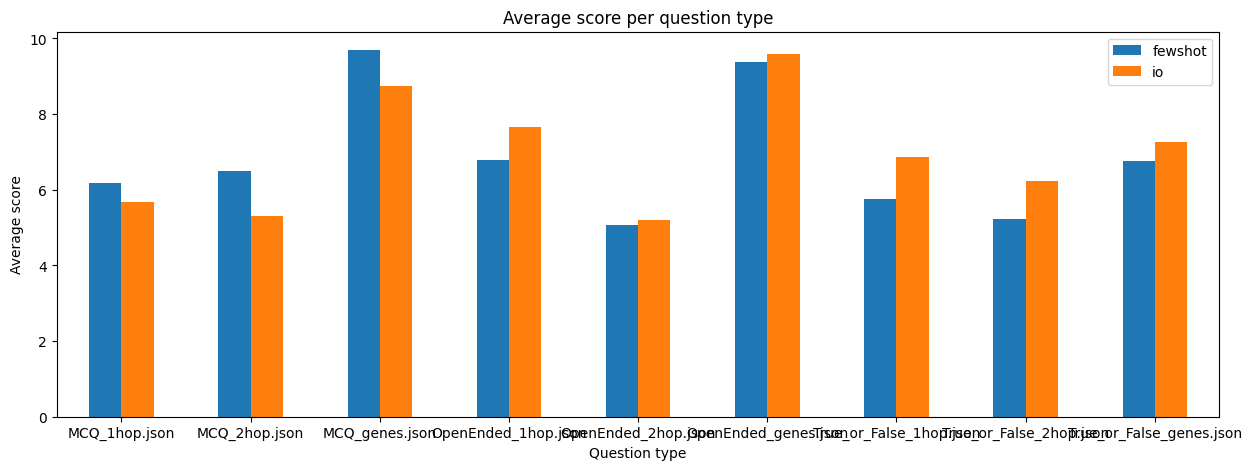

In [11]:
#make a bar plot of the average scores and compare the two methods per json file
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

df = pd.DataFrame({'fewshot': mean_scores_fewshot.values(), 'io': mean_scores_io.values()}, index=mean_scores_fewshot.keys())
plt.rcParams["figure.figsize"] = (15,5)
ax = df.plot.bar(rot=0)
ax.set_ylabel('Average score')
ax.set_xlabel('Question type')
ax.set_title('Average score per question type')
plt.show()
#make the plot larger


In [13]:
#get json files in directory
import json
import os
#C:\Users\matsumoton\Box\AutoQTL\Rat Data-PalmerLab\Genotypes\All_GWAS_files\LDPruned_PAGER\Genotypes\LD_pruned_PLINK\OtherPhen_PAGER_EDGE_files
csv_file = r'C:/Users/matsumoton/Box/AutoQTL/Rat Data-PalmerLab/Genotypes/All_GWAS_files/LDPruned_PAGER/Genotypes/LD_pruned_PLINK/OtherPhen_PAGER_EDGE_files/Geno_EDGE_RetroFat_Unencoded.csv'

# # get only the header row
# import csv
# with open(csv_file, newline='') as f:
#     reader = csv.reader(f)
#     header_row = next(reader)
    
# get only the last column
# import csv
# with open(csv_file, newline='') as f:
#     reader = csv.reader(f)
#     last_column = [row[-1] for row in reader]
    


import pandas as pd
df = pd.read_csv(csv_file)

#remove all rows that have 'NA' as a value in the RetroFat column
# df = df[df['RetroFat'] != 'NA']


In [14]:
backup_df = df.copy()


In [39]:
df.shape
# import numpy as np

(3166, 128402)

In [27]:
type(df["RetroFat"][0])

numpy.float64

In [28]:
#get all retrofat values that are not NA
retrofat = df["RetroFat"].values


In [34]:
len(retrofat)

3149

In [33]:
#remove nan values
retrofat = [x for x in retrofat if str(x) != 'nan']

In [41]:
#remove nan values in df for retrofat column 
df[df['RetroFat'].notna()].shape
#reindex
df = df[df['RetroFat'].notna()].reset_index(drop=True)

(3149, 128402)

In [44]:
print(df.shape)

(3149, 128402)


In [43]:
df = df[df['RetroFat'].notna()]


In [46]:
df.columns[0]

'chr1.55365'

In [47]:
edge_data = df[[df.columns[0]]].copy()
edge_data['bmi'] = df['RetroFat']


In [52]:
#rownames of edge_data
edge_data.index

Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
       ...
       3156, 3157, 3158, 3159, 3160, 3161, 3162, 3163, 3164, 3165],
      dtype='int64', length=3149)

In [51]:
#find all nan values in bmi column
edge_data[edge_data[df.columns[0]].isna()].shape

(0, 2)

In [10]:
#checik for empty values in last_column
empty = []
for i, value in enumerate(last_column):
    if value == "":
        empty.append(i)
        

In [12]:
last_column

['RetroFat',
 '-0.258711316',
 '0.197786336',
 '1.094029379',
 '1.350988773',
 '-0.790914163',
 '0.988434565',
 '1.851639062',
 '-0.831262697',
 '-1.988371654',
 '1.27397407',
 '-0.598487701',
 '0.891149545',
 '-0.210843096',
 '0.590932421',
 '0.859089278',
 '0.133667939',
 '0.289512326',
 '-0.632363588',
 '-1.290628354',
 '-0.942075775',
 '2.045793427',
 '-0.751892327',
 '0.609256802',
 '-0.628638424',
 '0.286157776',
 '0.05844012',
 '1.949590519',
 '0.040799646',
 '0.27603098',
 '0.284511921',
 '1.109239834',
 '-0.253923621',
 '-0.152619654',
 '-0.082821593',
 '1.052559295',
 '-0.0911892',
 '1.449394179',
 '0.07794749',
 '-0.612580107',
 '0.282861706',
 '0.120107861',
 '-2.972009024',
 '0.413435861',
 '0.326106352',
 '0.329671611',
 '1.469314252',
 '0.399738527',
 '0.336972452',
 '1.247437582',
 '1.064441565',
 '-0.79539076',
 '-0.323782838',
 '-1.449998909',
 '0.296314005',
 '-0.928524985',
 '-0.611718557',
 '0.953697697',
 '0.725001284',
 '0.107740952',
 '0.192901221',
 '-1.0640520

You are an AI prompt simplifier with access to a knowledge graph of Alzheimer's disease. You will receive a query related to simplifying the query into parts that can be separated by relationship between nodes.
The knowledge graph contains node types: Gene, DrugClass, Drug, Disease, Pathway, BiologicalProcess, MolecularFunction, CellularComponent, Symptom, BodyPart. 
Gene nodes have gene type as a property.
The knowledge graph contains relationships: "CHEMICAL BINDS GENE","CHEMICAL INCREASES EXPRESSION", "CHEMICAL DECREASES EXPRESSION", "DRUG IN CLASS", "DRUG TREATS DISEASE", "DRUG CAUSES EFFECT", "GENE PARTICIPATES IN BIOLOGICAL PROCESS", "GENE IN PATHWAY", "GENE INTERACTS WITH GENE", "GENE HAS MOLECULAR FUNCTION", "GENE ASSOCIATED WITH CELLULAR COMPONENT", "GENE ASSOCIATES WITH DISEASE", "BODYPART OVER EXPRESSES GENE", "BODYPART UNDEREXPRESSES GENE", "SYMPTOM MANIFESTATION OF DISEASE", "DISEASE LOCALIZES TO ANATOMY", "DISEASE ASSOCIATES WITH DISEASE".
From the query, split it into multiple instructions of simple single node to Relationship to node format that would answer the query. Start the instructions from specifics node names. The format of each <Node> tag would be Node Title-Relationship-Node Title. If there are any specific nodes to focus on, especially specific gene names, and not a node type or relationship, put a ! before and after the word. For instance, Alzheimer's is a specific Disease node, so it should be labeled "!Alzheimer's Disease!". Do not put the ! on relationships
<Example> 
<Query>List the drugs that can treat Alzheimer's Disease</Query>
<Instructions>
<Node>Drug-DRUG TREATS DISEASE-!Alzheimer's Disease!</Node>
</Instructions>
</Example>

<Example>
<Query>Provide a list of all genes associated with Alzheimer's Disease</Query>
<Instructions>
<Node>Gene-GENE ASSOCIATES WITH DISEASE-!Alzheimer's Disease!</Node>
</Instructions>
</Example>

<Example>
<Query>Which classes of drugs can be used to treat Alzheimer's disease?</Query>
<Instructions>
<Node>Drug-DRUG TREATS DISEASE-!Alzheimer's Disease!</Node>
<Node>DrugClass-DRUGINCLASS-Drug</Node>
</Instructions>
</Example>

<Example>
<Query>List ncRNA type genes that are associated with Alzheimer's Disease</Query>
<Instructions>
<Node>Gene-GENE ASSOCIATES WITH DISEASE-!Alzheimer's Disease!</Node>
<Node>Gene-GeneType-!ncRNA!</Node>
</Instructions>
</Example>

<Example>
<Query>List the body parts overexpressing the gene ACE</Query>
<Instructions>
<Node>BodyPart-BODYPART OVEREXPRESSES GENE-!ACE!</Node>
</Instructions>
</Example>

<Example>
<Query>Which of the following is not subject to increased expression by the drug Amlodipine? 1. ACAT2 2. FADS2 3. FOXO4 4. RMI1 5. NPC1</Query>
<Instructions> <Node>Drug-DRUG INCREASES EXPRESSION-!Amlodipine!</Node> <Node>Gene-CHEMICAL INCREASES EXPRESSION-Drug</Node> <Node>Drug-DRUG INCREASES EXPRESSION-!ACAT2!</Node> <Node>Drug-DRUG INCREASES EXPRESSION-!FADS2!</Node> <Node>Drug-DRUG INCREASES EXPRESSION-!FOXO4!</Node> <Node>Drug-DRUG INCREASES EXPRESSION-!RMI1!</Node> <Node>Drug-DRUG INCREASES EXPRESSION-!NPC1!</Node> </Instructions>
</Example>

